# SparseEdges : including prior information


Using prior information in the edge extraction


Table of content

* [A dipole as a second-order prior](#A-dipole-as-a-second-order-prior)
* [Prior on second-order distribution of edge co-occurences](#Prior-on-second-order-distribution-of-orientations)
* [Application to segmentation](#Application-to-segmentation)


## Initialization

In [26]:
from __future__ import division, print_function
import matplotlib
#matplotlib.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
matplotlib.rcParams.update({'text.usetex': False})
%matplotlib inline
#%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt

import numpy as np
np.set_printoptions(precision=4)#, suppress=True)

FORMATS = ['pdf', 'eps']

In [27]:
#! defining framework
#!-------------------
from SparseEdges import SparseEdges
mp = SparseEdges('https://raw.githubusercontent.com/meduz/SparseEdges/master/default_param.py')
mp.pe.datapath = '../../SLIP/database/'
#pe.N = 4
#pe.do_mask=False
#pe.MP_alpha=1.
#pe.do_whitening = False

print ('Range of spatial frequencies: ', mp.sf_0)

Range of spatial frequencies:  [ 0.618   0.382   0.2361  0.1459  0.0902  0.0557  0.0344  0.0213  0.0132
  0.0081  0.005 ]


In [28]:
print ('Range of angles: ', mp.theta*180./np.pi)

Range of angles:  [-82.5 -75.  -67.5 -60.  -52.5 -45.  -37.5 -30.  -22.5 -15.   -7.5   0.
   7.5  15.   22.5  30.   37.5  45.   52.5  60.   67.5  75.   82.5  90. ]


In [29]:
%cd test

[Errno 2] No such file or directory: 'test'
/Users/lolo/pool/science/BICV-book/SI_BICV_sparse/SparseEdges/test


## A dipole as a second-order prior

### constructing the dipole step by step

Let's contruct a dipole step by step.

A dipole is defined by a reference edge, given by its position, orientationand scale, and by the probability associated to this reference.

First, we define the relative difference of orientation $\psi$:

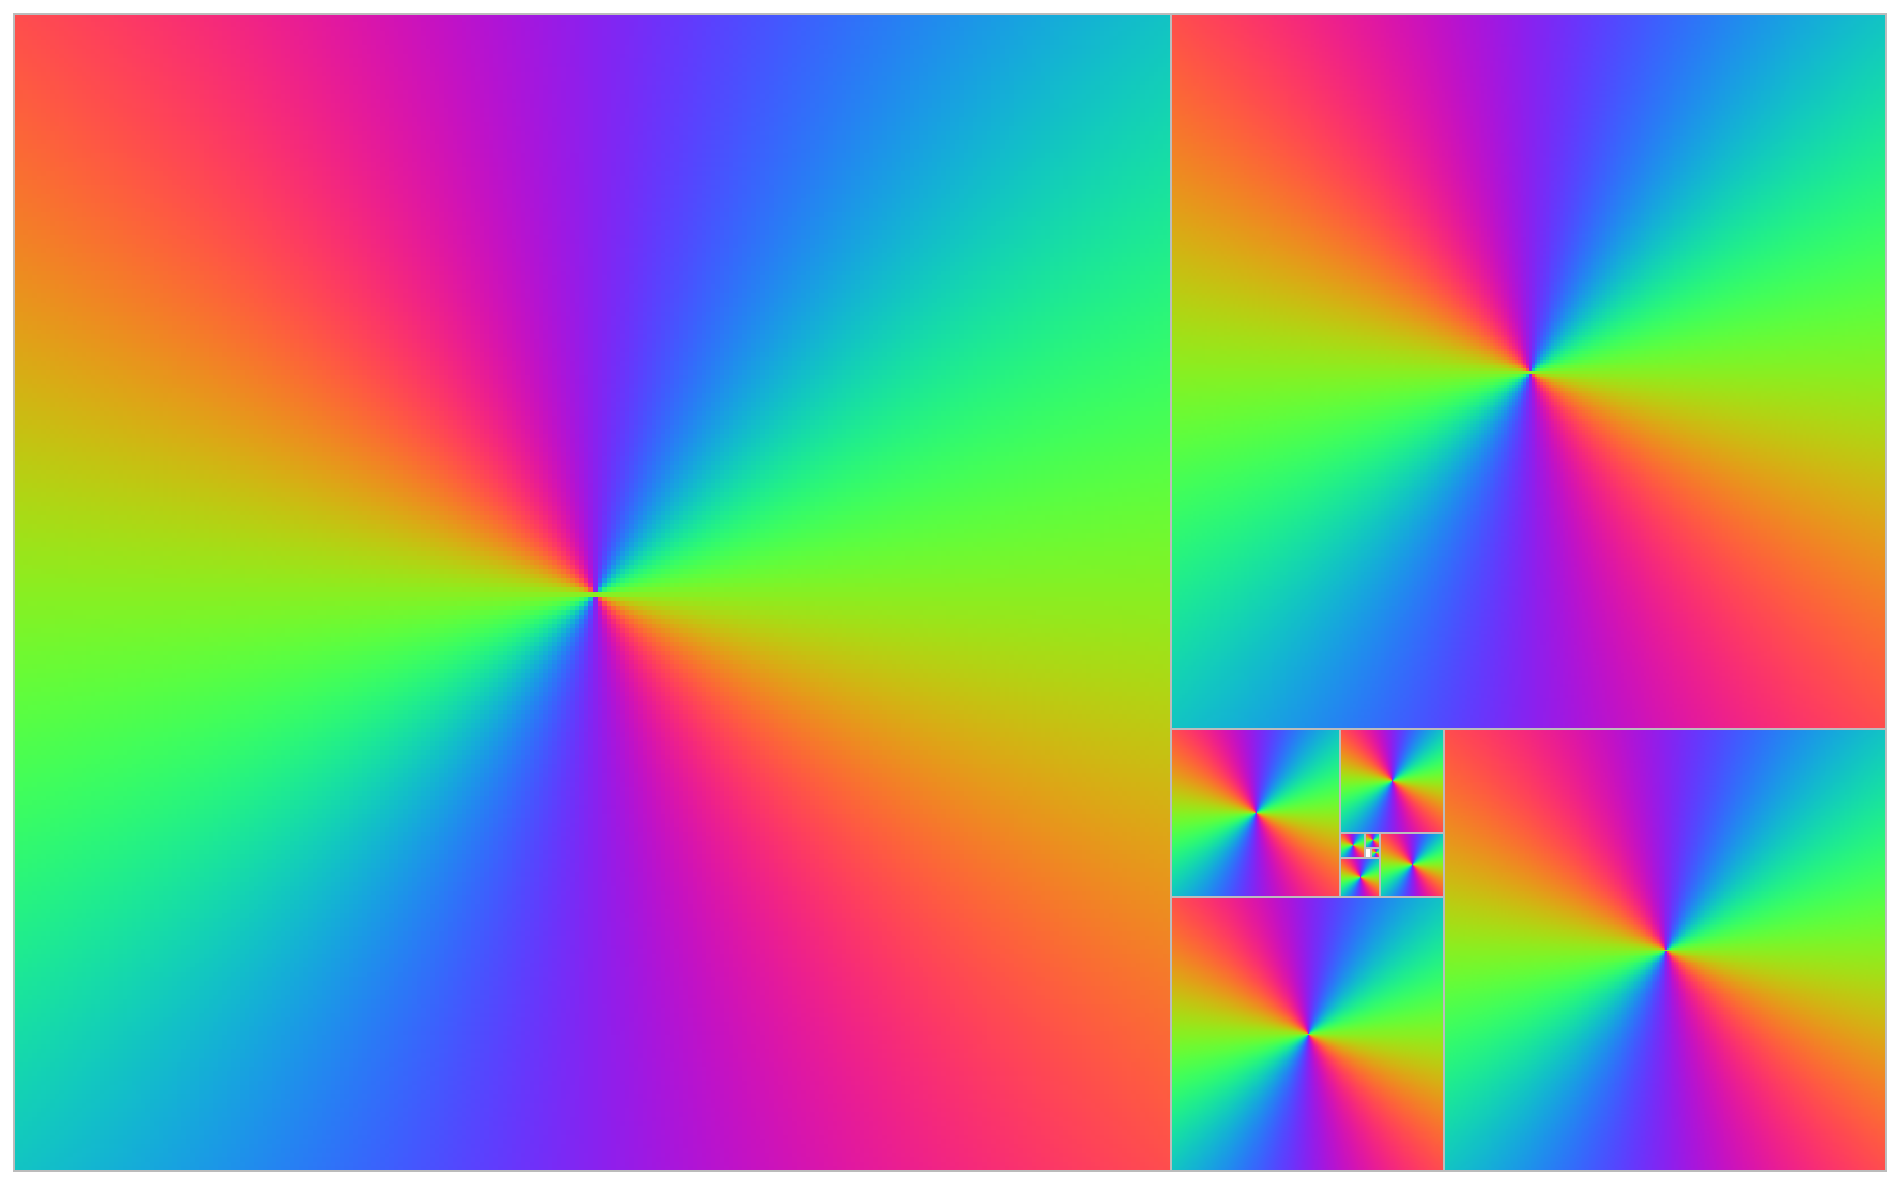

In [30]:
def plot_dipole( w=.25, B_psi=.5, B_theta=.5, scale=1.5, epsilon=1.e-6):
    x, y, theta_edge, sf_0, C, phase = mp.N_X/2, mp.N_Y/2, mp.theta[-1], mp.sf_0[2], 1, 0.
    D = np.ones((mp.N_X, mp.N_Y, mp.pe.n_theta, mp.n_levels))
    for i_sf_0, sf_0_ in enumerate(mp.sf_0):
        for i_theta, theta_layer in enumerate(mp.theta):
            psi = np.arctan2(mp.Y-y, mp.X-x) - theta_layer #- theta_edge + theta/2 - np.pi/4
            psi = ((psi + np.pi/2  - np.pi/mp.pe.N_phi/2 ) % (np.pi)) - np.pi/2  + np.pi/mp.pe.N_phi/2
            D[:, :, i_theta, i_sf_0] = np.exp((np.cos(2*psi)-1.)/(B_psi**2))
    mp.golden_pyramid(D)
plot_dipole()

Now we add difference of orientation $\theta$

0.0
-0.00140431596367 -2.47436291259e-20 1.0


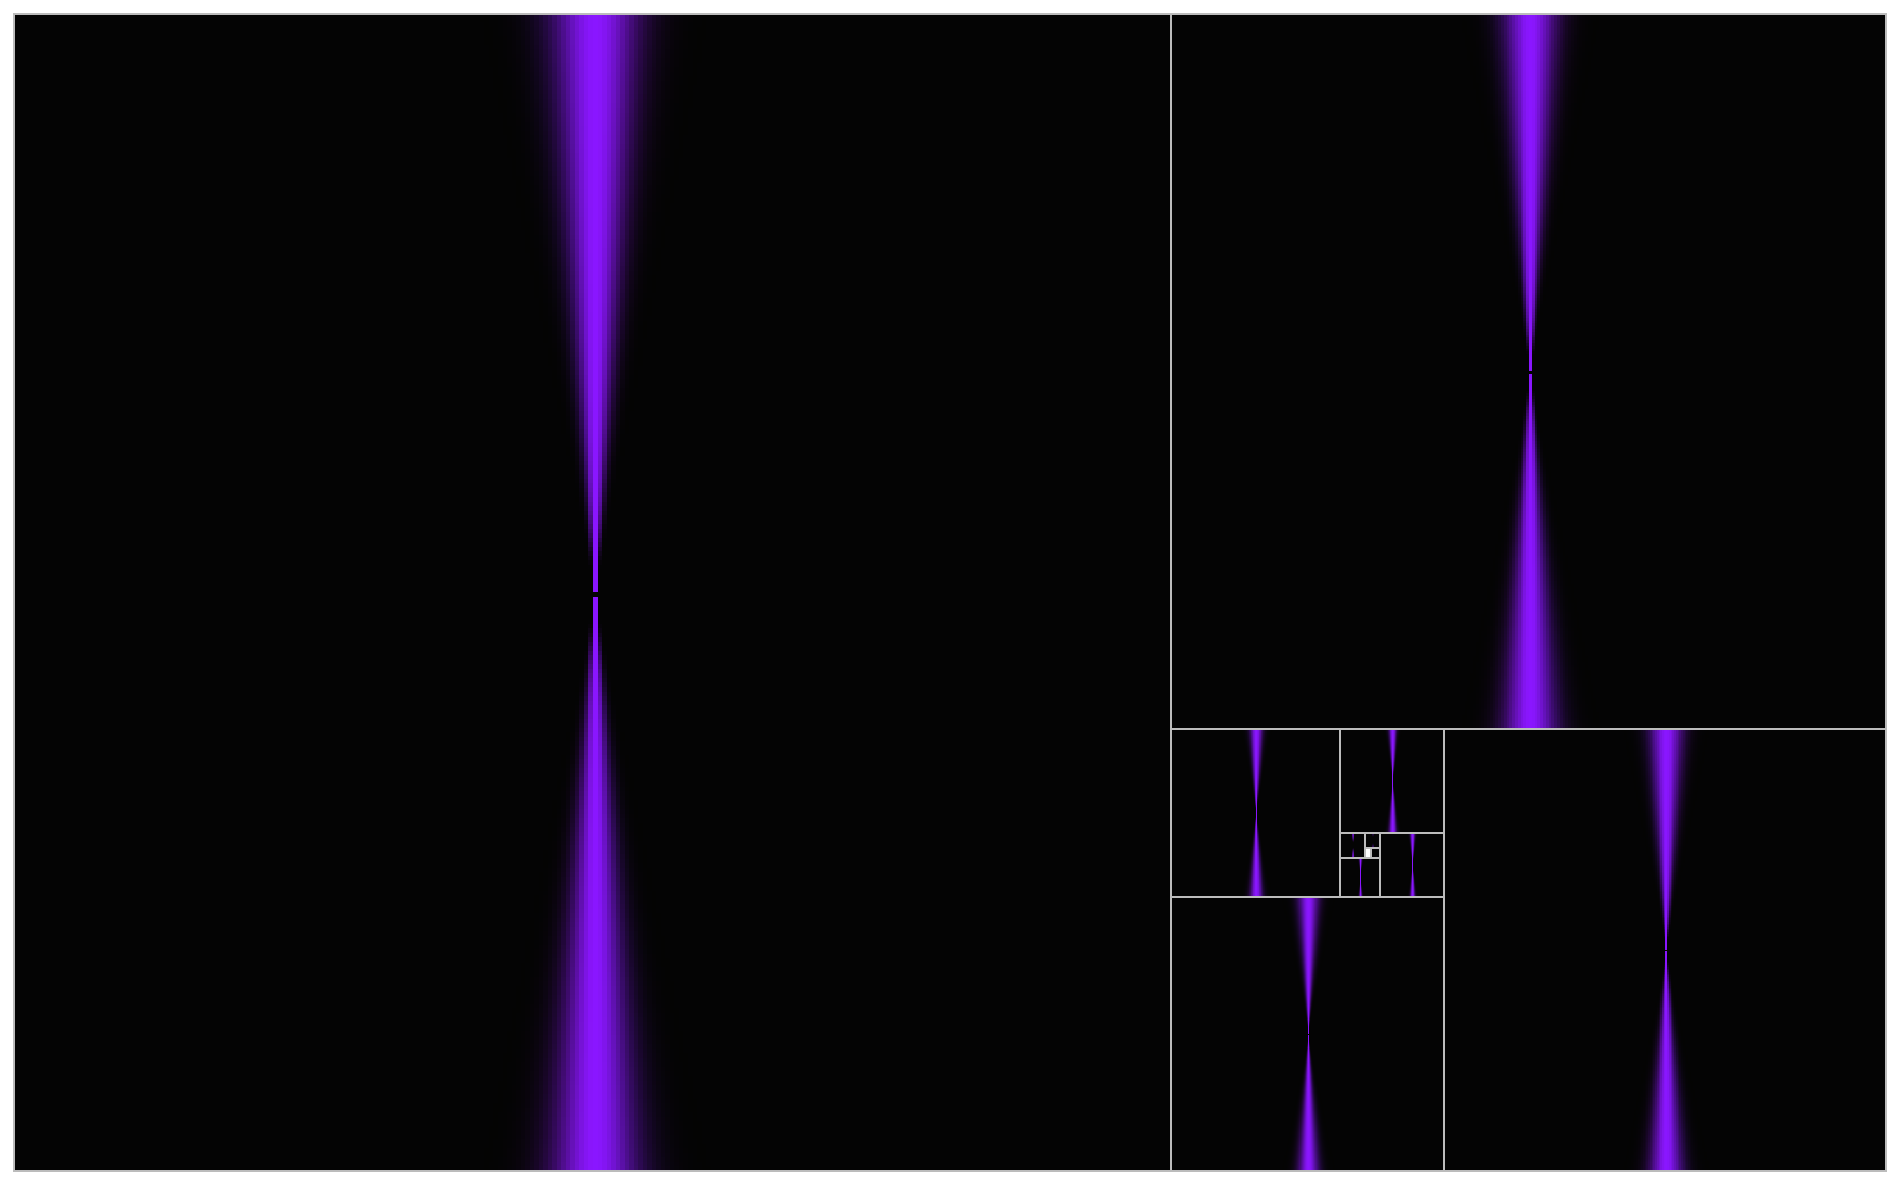

In [31]:
def plot_dipole(w=mp.pe.dip_w, B_psi=mp.pe.dip_B_psi, B_theta=mp.pe.dip_B_psi, scale=mp.pe.dip_B_psi, epsilon=mp.pe.dip_epsilon):
    x, y, theta_edge, sf_0, C, phase = mp.N_X/2, mp.N_Y/2, mp.theta[-1], mp.sf_0[2], 1, 0.
    theta_edge = np.pi/2 - theta_edge
    #theta_edge = ((theta_edge + np.pi/2 - np.pi/mp.pe.n_theta/2)  % (np.pi) ) - np.pi/2  + np.pi/mp.pe.n_theta/2
    print (theta_edge*180/np.pi)
    D = np.ones((mp.N_X, mp.N_Y, mp.pe.n_theta, mp.n_levels))
    for i_sf_0, sf_0_ in enumerate(mp.sf_0):
        for i_theta, theta_layer in enumerate(mp.theta):
            theta_layer = np.pi/2 - theta_layer
            theta_layer = ((theta_layer + np.pi/2 - np.pi/mp.pe.n_theta/2)  % (np.pi) ) - np.pi/2  + np.pi/mp.pe.n_theta/2
            theta = theta_layer - theta_edge # angle between edge's orientation and the layer's one
            psi = np.arctan2(mp.Y-y, mp.X-x) - theta_edge -np.pi/2 - theta/2 #- np.pi/4
            #print i_theta, theta*180/np.pi
            #psi = ((psi + np.pi/2  - np.pi/mp.pe.N_phi/2 ) % (np.pi)) - np.pi/2  + np.pi/mp.pe.N_phi/2
            D[:, :, i_theta, i_sf_0] = np.exp((np.cos(2*(psi))-1.)/(B_psi**2))
            D[:, :, i_theta, i_sf_0] *= np.exp((np.cos(2*theta)-1.)/(B_theta**2))
    D -= D.mean()
    D /= np.abs(D).max()
    
    print (D.min(), D.mean(), D.max())
    mp.golden_pyramid(D)
plot_dipole()

Now we modulate it according to distance $d$ and scale to obtain the final dipole as implemented in ``SparseEdges``:

0.0
-3.1057506945e-05 6.57541409887e-20 1.0


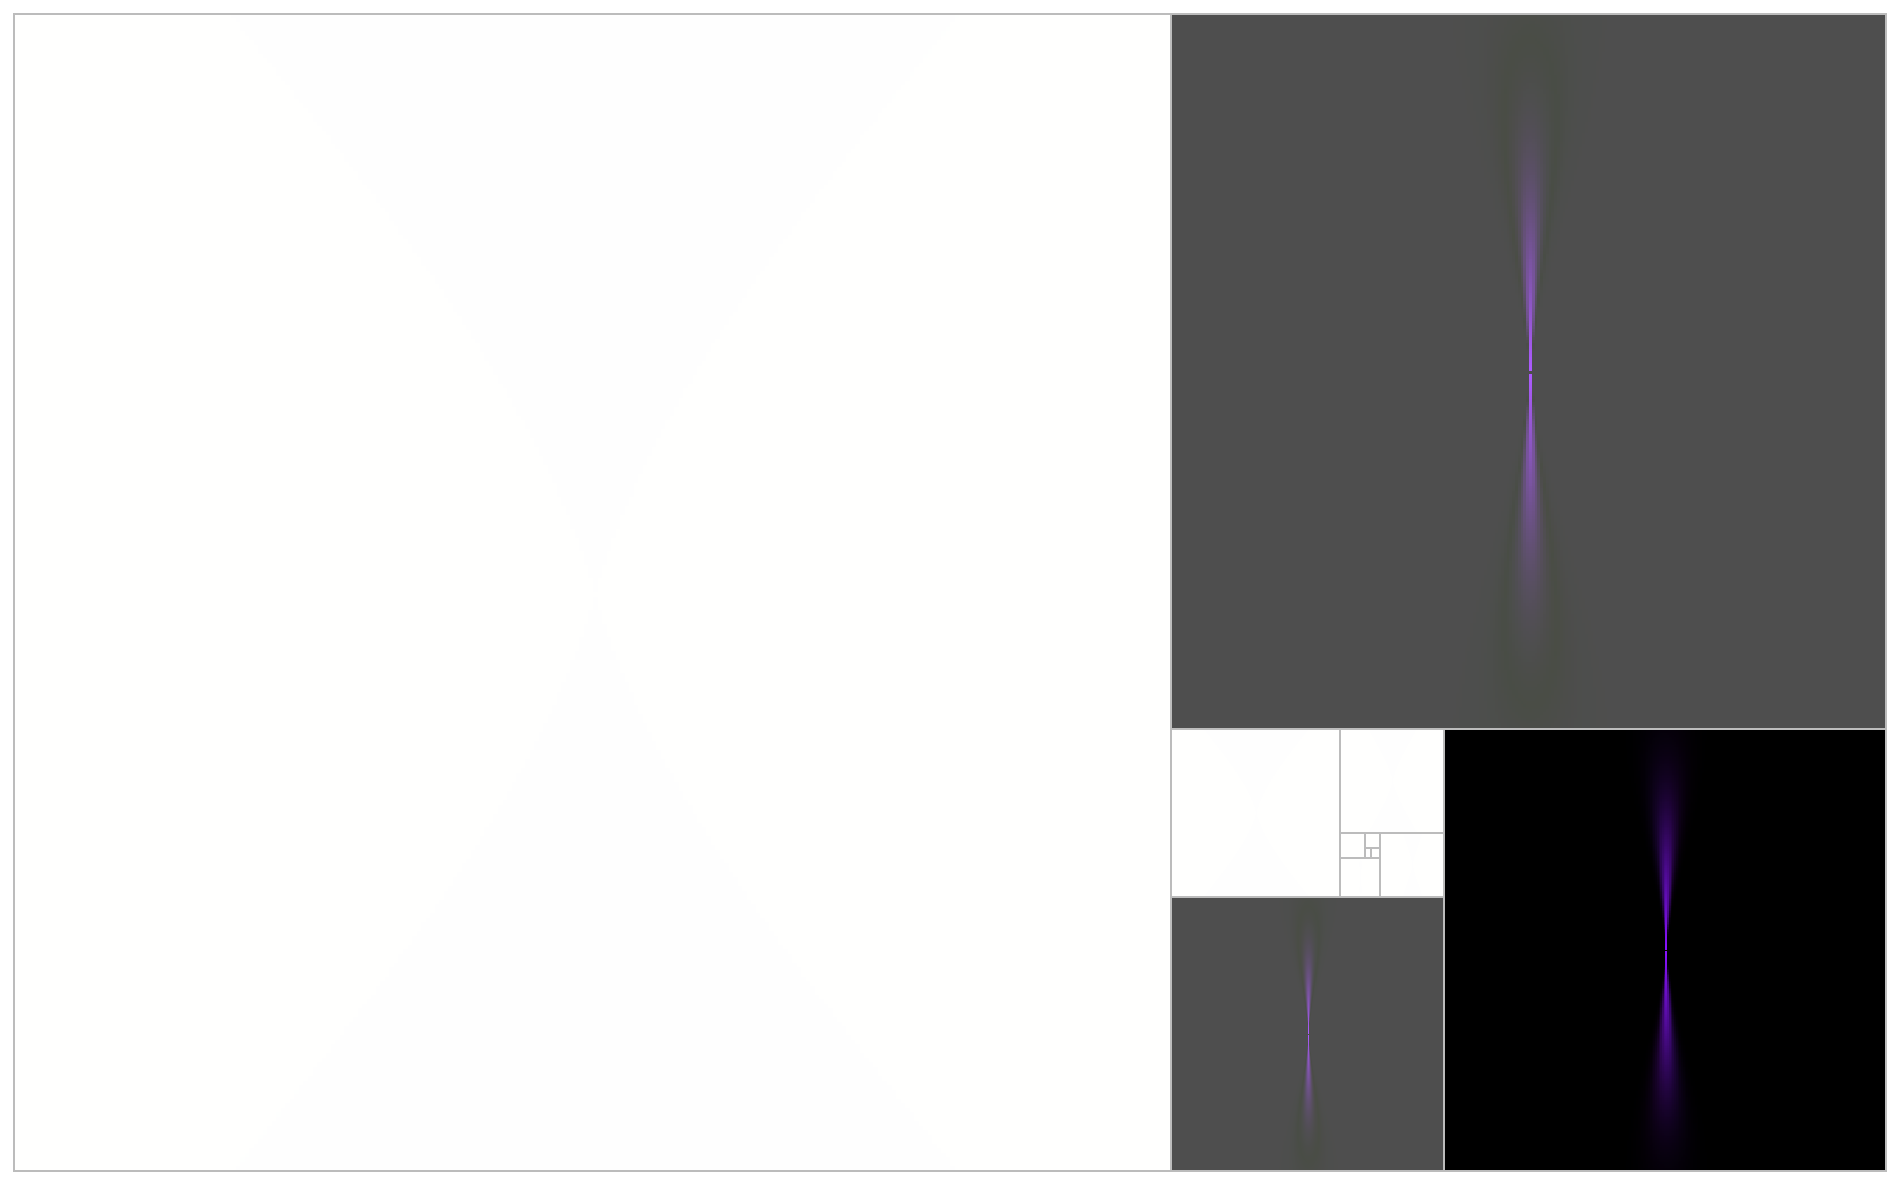

In [32]:
def plot_dipole(w=mp.pe.dip_w, B_psi=mp.pe.dip_B_psi, B_theta=mp.pe.dip_B_psi, scale=mp.pe.dip_B_psi, epsilon=mp.pe.dip_epsilon):
    x, y, theta_edge, sf_0, C, phase = mp.N_X/2., mp.N_Y/2., mp.theta[-1], mp.sf_0[2], 1, 0.
    theta_edge = np.pi/2 - theta_edge
    print( theta_edge*180/np.pi)
    D = np.zeros((mp.N_X, mp.N_Y, mp.pe.n_theta, mp.n_levels))
    distance = np.sqrt(((mp.X-x)**2+(mp.Y-y)**2)/(mp.N_X**2+mp.N_Y**2))/w
    #print distance.max()
    neighborhood = np.exp(-distance**2)
    for i_sf_0, sf_0_ in enumerate(mp.sf_0):
        for i_theta, theta_layer in enumerate(mp.theta):
#                                if self.pe.scale_invariant: d *= np.sqrt(Sf_0[:, np.newaxis]*Sf_0[np.newaxis, :])#*np.sqrt(self.N_X)
            theta_layer = np.pi/2 - theta_layer
            theta_layer = ((theta_layer + np.pi/2 - np.pi/mp.pe.n_theta/2)  % (np.pi) ) - np.pi/2  + np.pi/mp.pe.n_theta/2
            theta = theta_layer - theta_edge # angle between edge's orientation and the layer's one
            psi = np.arctan2(mp.Y-y, mp.X-x) - theta_edge -np.pi/2 - theta/2 #- np.pi/4

            d = distance + epsilon
            D[:, :, i_theta, i_sf_0] = np.exp((np.cos(2*(psi))-1)/(B_psi**2 * d))#/(B_psi*np.sqrt(d))
            D[:, :, i_theta, i_sf_0] *= np.exp((np.cos(2*theta)-1)/(B_theta**2 * d))/(B_theta*np.sqrt(d))
#        D[:, :, :, i_sf_0] /= D[:, :, :, i_sf_0].mean()
#        D[:, :, :, i_sf_0] -= 1.
        D[:, :, :, i_sf_0] *= neighborhood[:, :, np.newaxis] * np.exp(-np.abs( np.log2(mp.sf_0[i_sf_0] / sf_0)) / scale)
#        D[:, :, :, i_sf_0] += 1.
    D -= D.mean()
    D /= np.abs(D).max()
    
    print (D.min(), D.mean(), D.max())

    mp.golden_pyramid(np.log2(1.+D))
plot_dipole()

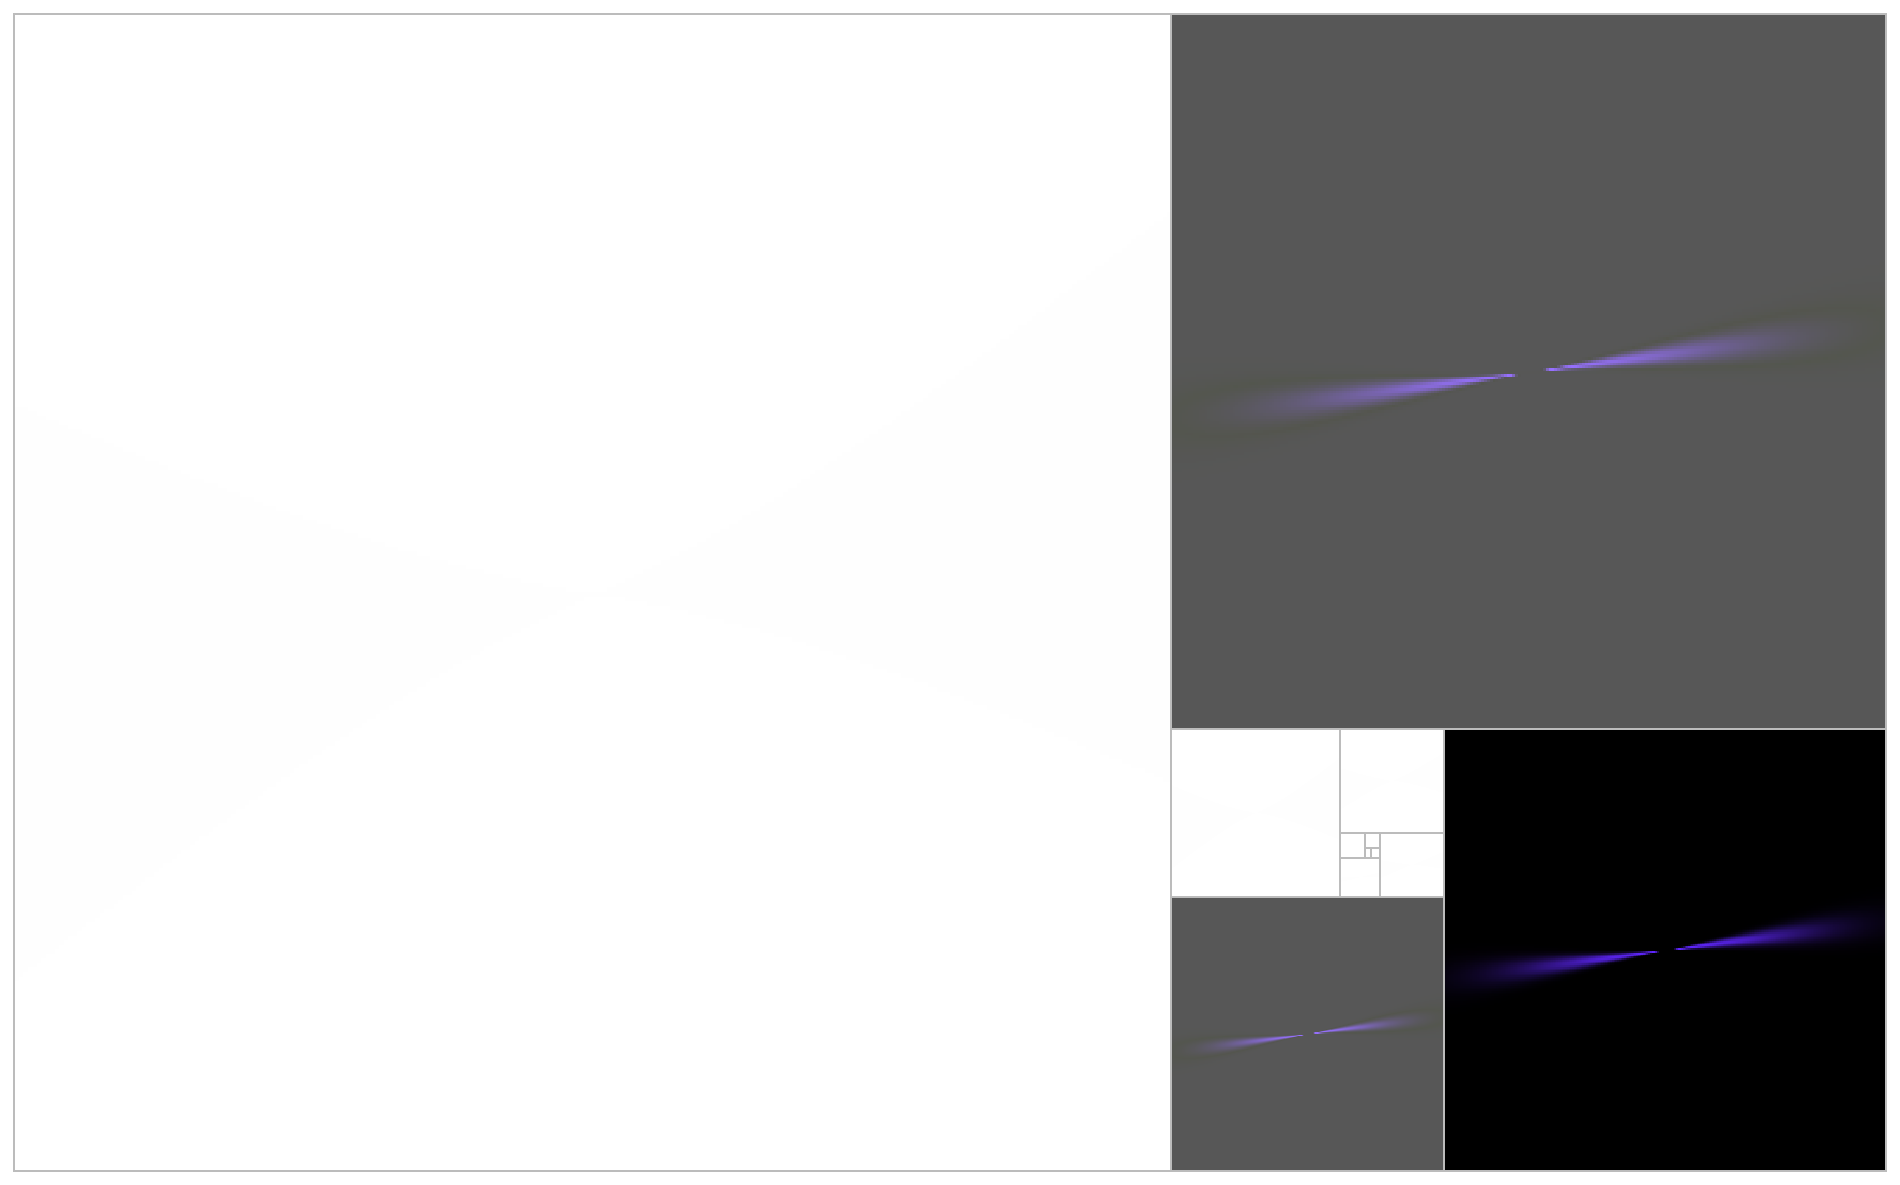

In [33]:
def plot_dipole(w=mp.pe.dip_w, B_psi=mp.pe.dip_B_psi, B_theta=mp.pe.dip_B_psi, scale=mp.pe.dip_B_psi, epsilon=mp.pe.dip_epsilon):
    mp.pe.dip_w = w
    mp.pe.dip_B_psi=B_psi
    mp.pe.dip_B_theta=B_theta
    mp.pe.dip_scale=scale
    mp.pe.dip_epsilon=epsilon
    logD = mp.dipole(np.array([mp.N_X/2, mp.N_Y/2, mp.theta[0], mp.sf_0[2], 1, 0.]))
    mp.golden_pyramid(logD)
#plot_dipole()
from IPython.html.widgets import interact
_ = interact(plot_dipole, w=(.0, .3, .0001), B_psi=(0.01, 2., 0.04), B_theta=(0.01, 2., 0.04), scale=(0.01, 20., .04), epsilon=(0, 1, 0.1))

co-circular axis of same angle are aligned.

### testing with a simple image of 2 edges

In [34]:
import matplotlib
#matplotlib.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
matplotlib.rcParams.update({'text.usetex': False})
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt

import numpy as np
np.set_printoptions(precision=4)#, suppress=True)
# http://ipython.org/ipython-doc/stable/config/extensions/autoreload.html
#%load_ext autoreload
#%autoreload 2

# where should we store the figures generated by this notebook
FORMATS = ['pdf', 'eps']

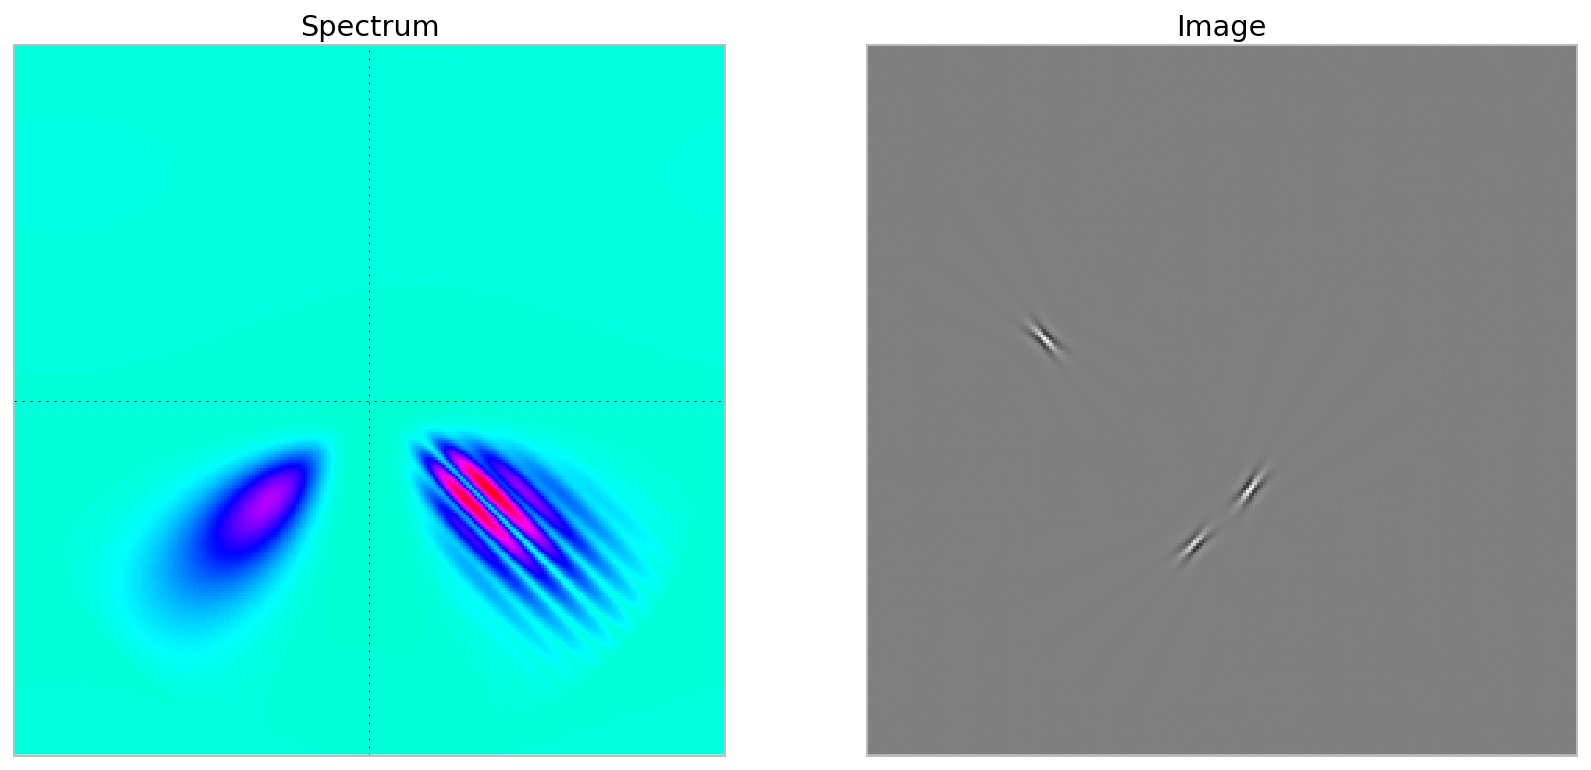

In [35]:
mp = SparseEdges('https://raw.githubusercontent.com/meduz/SparseEdges/master/default_param.py')
mp.pe.datapath = '../../SLIP/database/'
# filters in Fourier space
edge_in, edge_bis, edge_ter = [mp.N_X*.5-10+42, mp.N_Y*.5+10, 18, 2], [mp.N_X*.5+42+10, mp.N_Y*.5-10, 17, 2], [mp.N_X*.25+42, mp.N_Y*.25, 5, 2]
FT_lg_in = mp.loggabor(edge_in[0], edge_in[1], 
                       theta= mp.theta[edge_in[2]], B_theta=mp.pe.B_theta,
                       sf_0=mp.sf_0[edge_in[3]],  B_sf=mp.pe.B_sf)
FT_lg_bis = mp.loggabor(edge_bis[0], edge_bis[1], 
                        theta= mp.theta[edge_bis[2]], B_theta=mp.pe.B_theta,
                        sf_0=mp.sf_0[edge_bis[3]], B_sf=mp.pe.B_sf)
FT_lg_ter = mp.loggabor(edge_ter[0], edge_ter[1], 
                        theta= mp.theta[edge_ter[2]], B_theta=mp.pe.B_theta,
                        sf_0=mp.sf_0[edge_ter[3]], B_sf=mp.pe.B_sf)
# mixing both and shows one
FT_lg_ = 42. *  FT_lg_in + 35.*np.exp(1j*np.pi/4.) * FT_lg_bis + 40. *  FT_lg_ter
fig = mp.show_FT(FT_lg_)

In [36]:
image = mp.invert(FT_lg_)
mp.pe.do_whitening = False
mp.pe.N = 5
mp.pe.MP_alpha = 1.

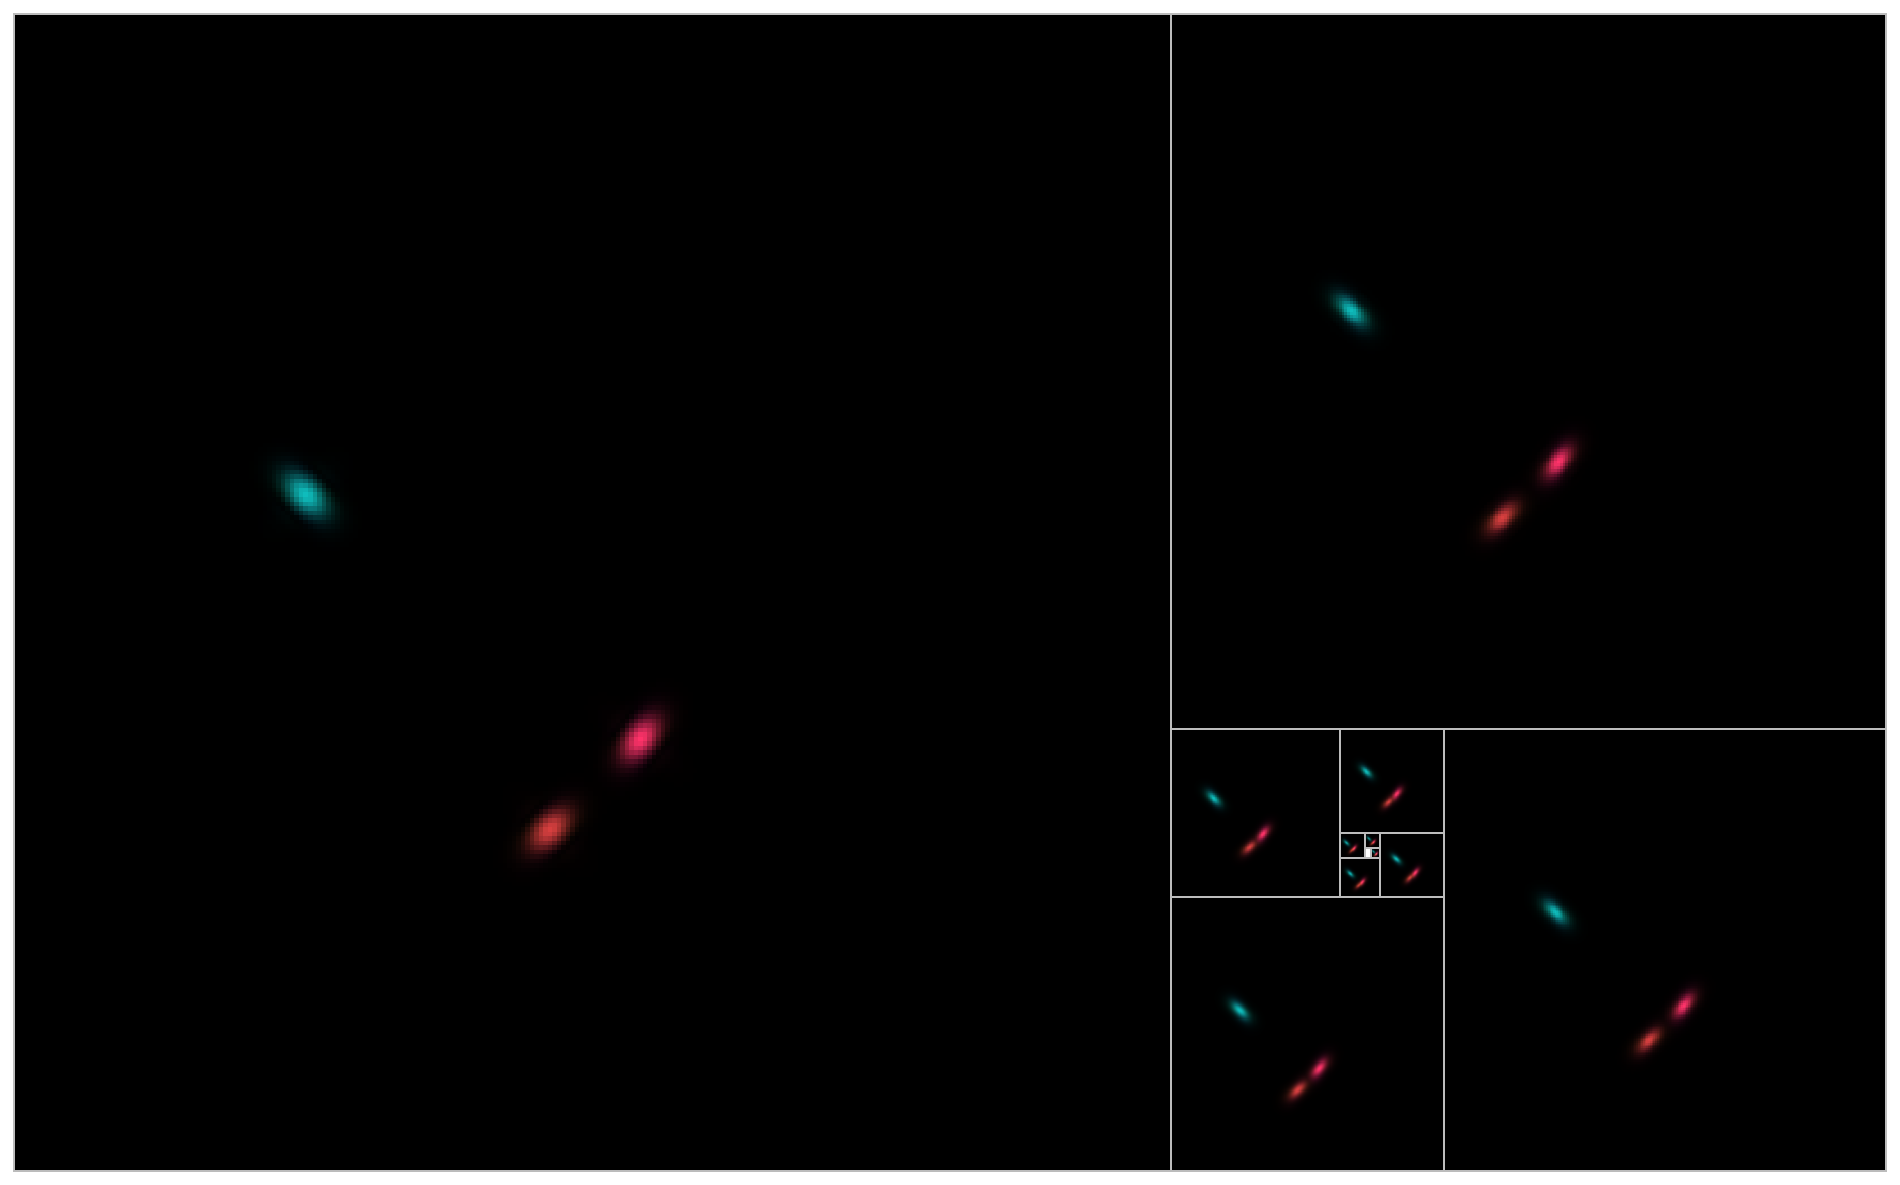

In [37]:
z = np.ones((mp.N_X, mp.N_Y, mp.pe.n_theta, mp.n_levels))
for i_sf_0, sf_0_ in enumerate(mp.sf_0):
    for i_theta, theta in enumerate(mp.theta):
        params = {'sf_0':sf_0_, 'B_sf':mp.pe.B_sf, 'theta':theta, 'B_theta':mp.pe.B_theta}
        # loggabor takes as args: u, v, sf_0, B_sf, theta, B_theta)
        FT_lg = mp.loggabor(0, 0, **params)
        z[:, :, i_theta, i_sf_0] = np.absolute(mp.FTfilter(image, FT_lg, full=True))

fig = mp.golden_pyramid(z)

In [38]:
print (' without second-order ')
mp.pe.eta_SO = 0.
edges, C_res = mp.run_mp(image, verbose=True)

 without second-order 
Edge

[ 20 %] elapsed[sec]: 1.424 | ETA[sec]: 5.697 

 0 / 5  - Max activity  :  41.9773763607  phase=  0.0332324914571  deg,  @  (160, 138, 18, 2)
Edge

[ 40 %] elapsed[sec]: 6.984 | ETA[sec]: 10.476 

 1 / 5  - Max activity  :  40.0  phase=  2.40762543886e-13  deg,  @  (106, 64, 5, 2)
Edge

[ 60 %] elapsed[sec]: 11.755 | ETA[sec]: 7.836 

 2 / 5  - Max activity  :  34.9999684299  phase=  45.0  deg,  @  (180, 118, 17, 2)
Edge

[ 80 %] elapsed[sec]: 16.506 | ETA[sec]: 4.126 

 3 / 5  - Max activity  :  0.0332407961848  phase=  -47.0929965704  deg,  @  (160, 138, 18, 2)
Edge

[100 %] elapsed[sec]: 21.370 | ETA[sec]: 0.000 

 4 / 5  - Max activity  :  3.15700436423e-05  phase=  44.9999989689  deg,  @  (180, 118, 17, 2)



Total time elapsed: 21.370 sec


In [39]:
print (' with second-order ')
mp.pe.eta_SO = .3
edges, C_res = mp.run_mp(image, verbose=True)

 with second-order 
Edge

[ 20 %] elapsed[sec]: 1.012 | ETA[sec]: 4.048 

 0 / 5  - Max activity  :  41.9773763607  phase=  0.0332324914571  deg,  @  (160, 138, 18, 2)
Edge

[ 40 %] elapsed[sec]: 8.259 | ETA[sec]: 12.389 

 1 / 5  - Max activity  :  21.8746069447  phase=  161.436467182  deg,  @  (178, 122, 17, 2)
Edge

[ 60 %] elapsed[sec]: 15.597 | ETA[sec]: 10.398 

 2 / 5  - Max activity  :  6.35436542694  phase=  -1.83031503313  deg,  @  (175, 125, 17, 2)
Edge

[ 80 %] elapsed[sec]: 22.625 | ETA[sec]: 5.656 

 3 / 5  - Max activity  :  12.6563629762  phase=  174.709842158  deg,  @  (180, 120, 17, 2)
Edge

[100 %] elapsed[sec]: 29.817 | ETA[sec]: 0.000 

 4 / 5  - Max activity  :  6.90954218661  phase=  -5.97166341157  deg,  @  (176, 124, 17, 2)



Total time elapsed: 29.817 sec


Max activity  :  41.9773763607  phase=  0.0332324914571  deg,  @  (160, 138, 18, 2)
Max activity  :  33.269740253  phase=  105.941628004  deg,  @  (180, 119, 17, 2)
Max activity  :  40.0  phase=  2.40914836052e-13  deg,  @  (106, 64, 5, 2)
Max activity  :  5.80924407768  phase=  -167.897700503  deg,  @  (181, 118, 17, 1)
Max activity  :  6.57213495724  phase=  22.2843440912  deg,  @  (182, 117, 17, 3)


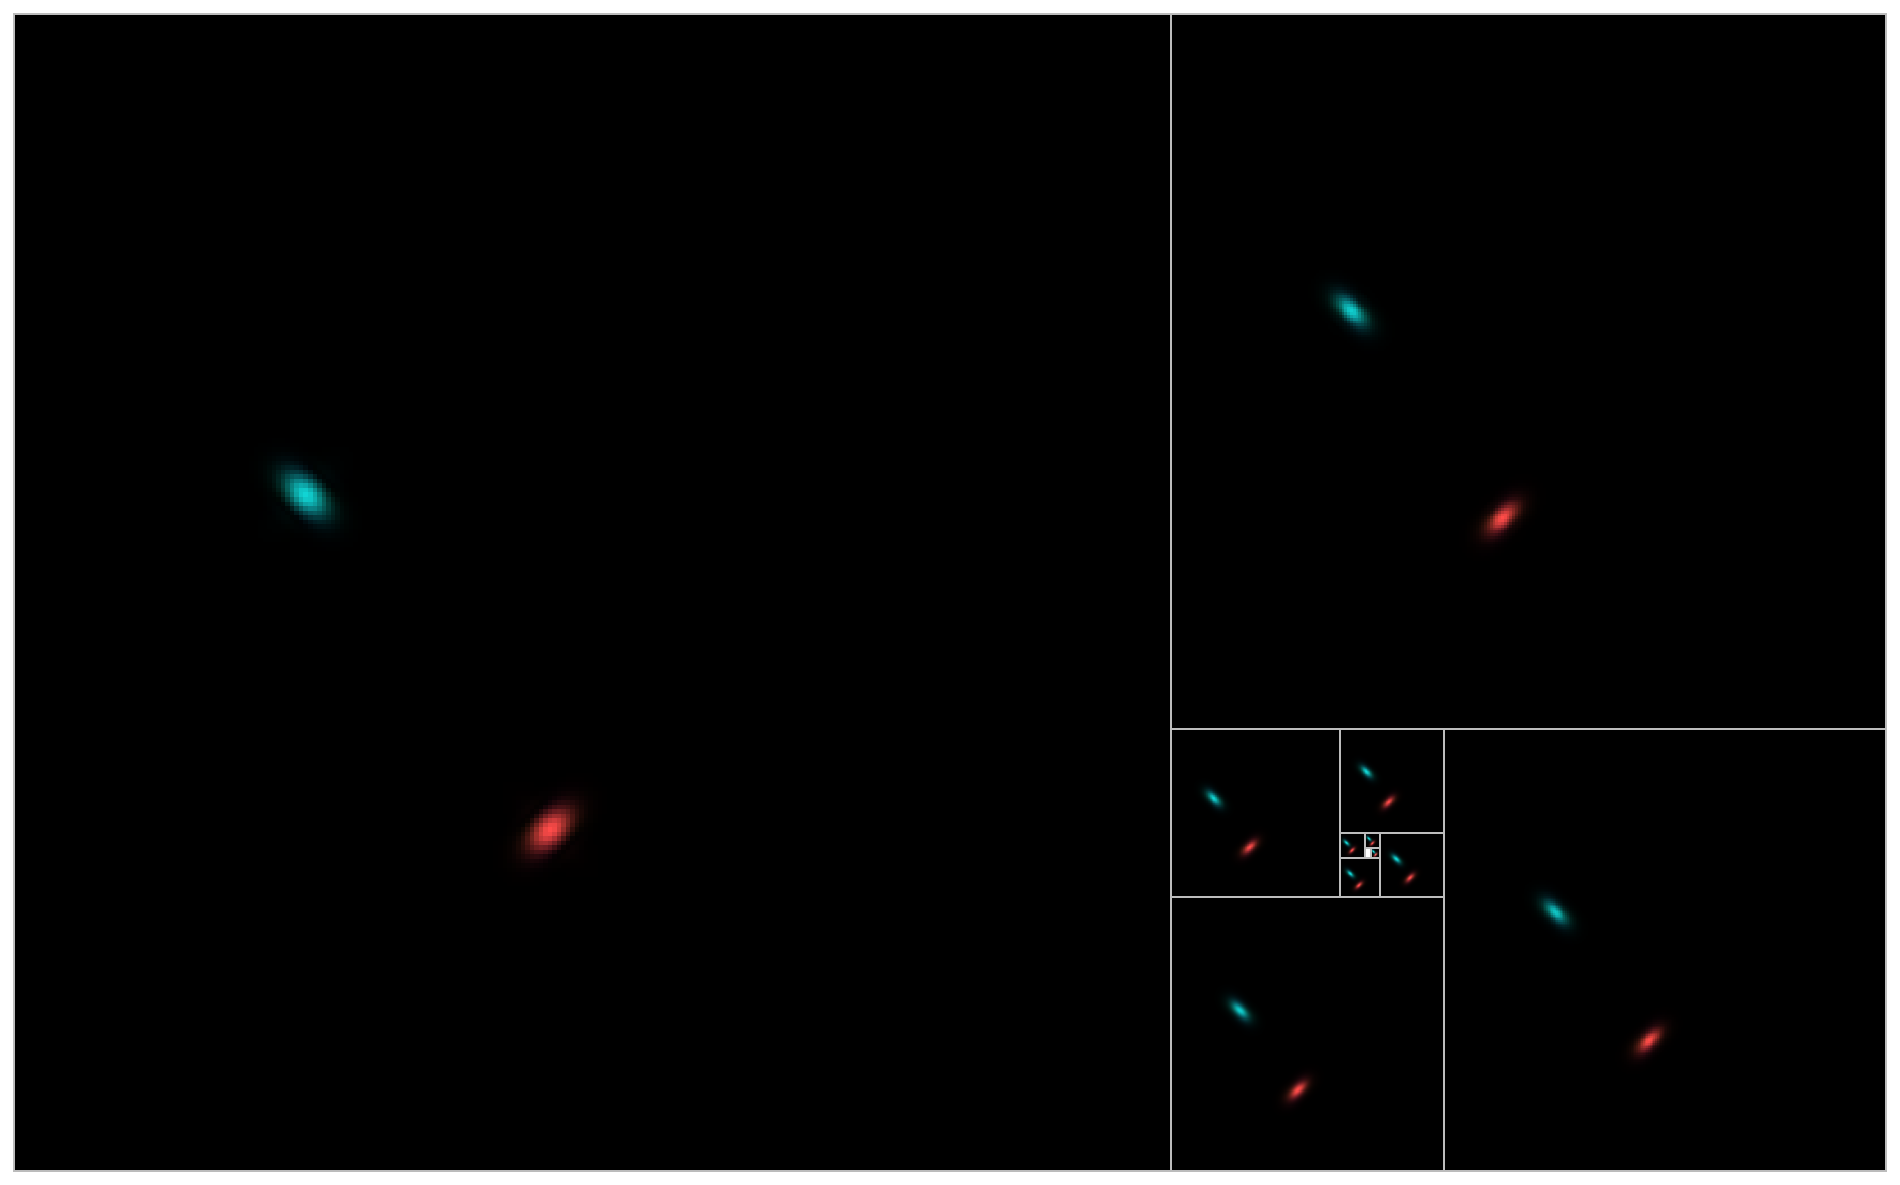

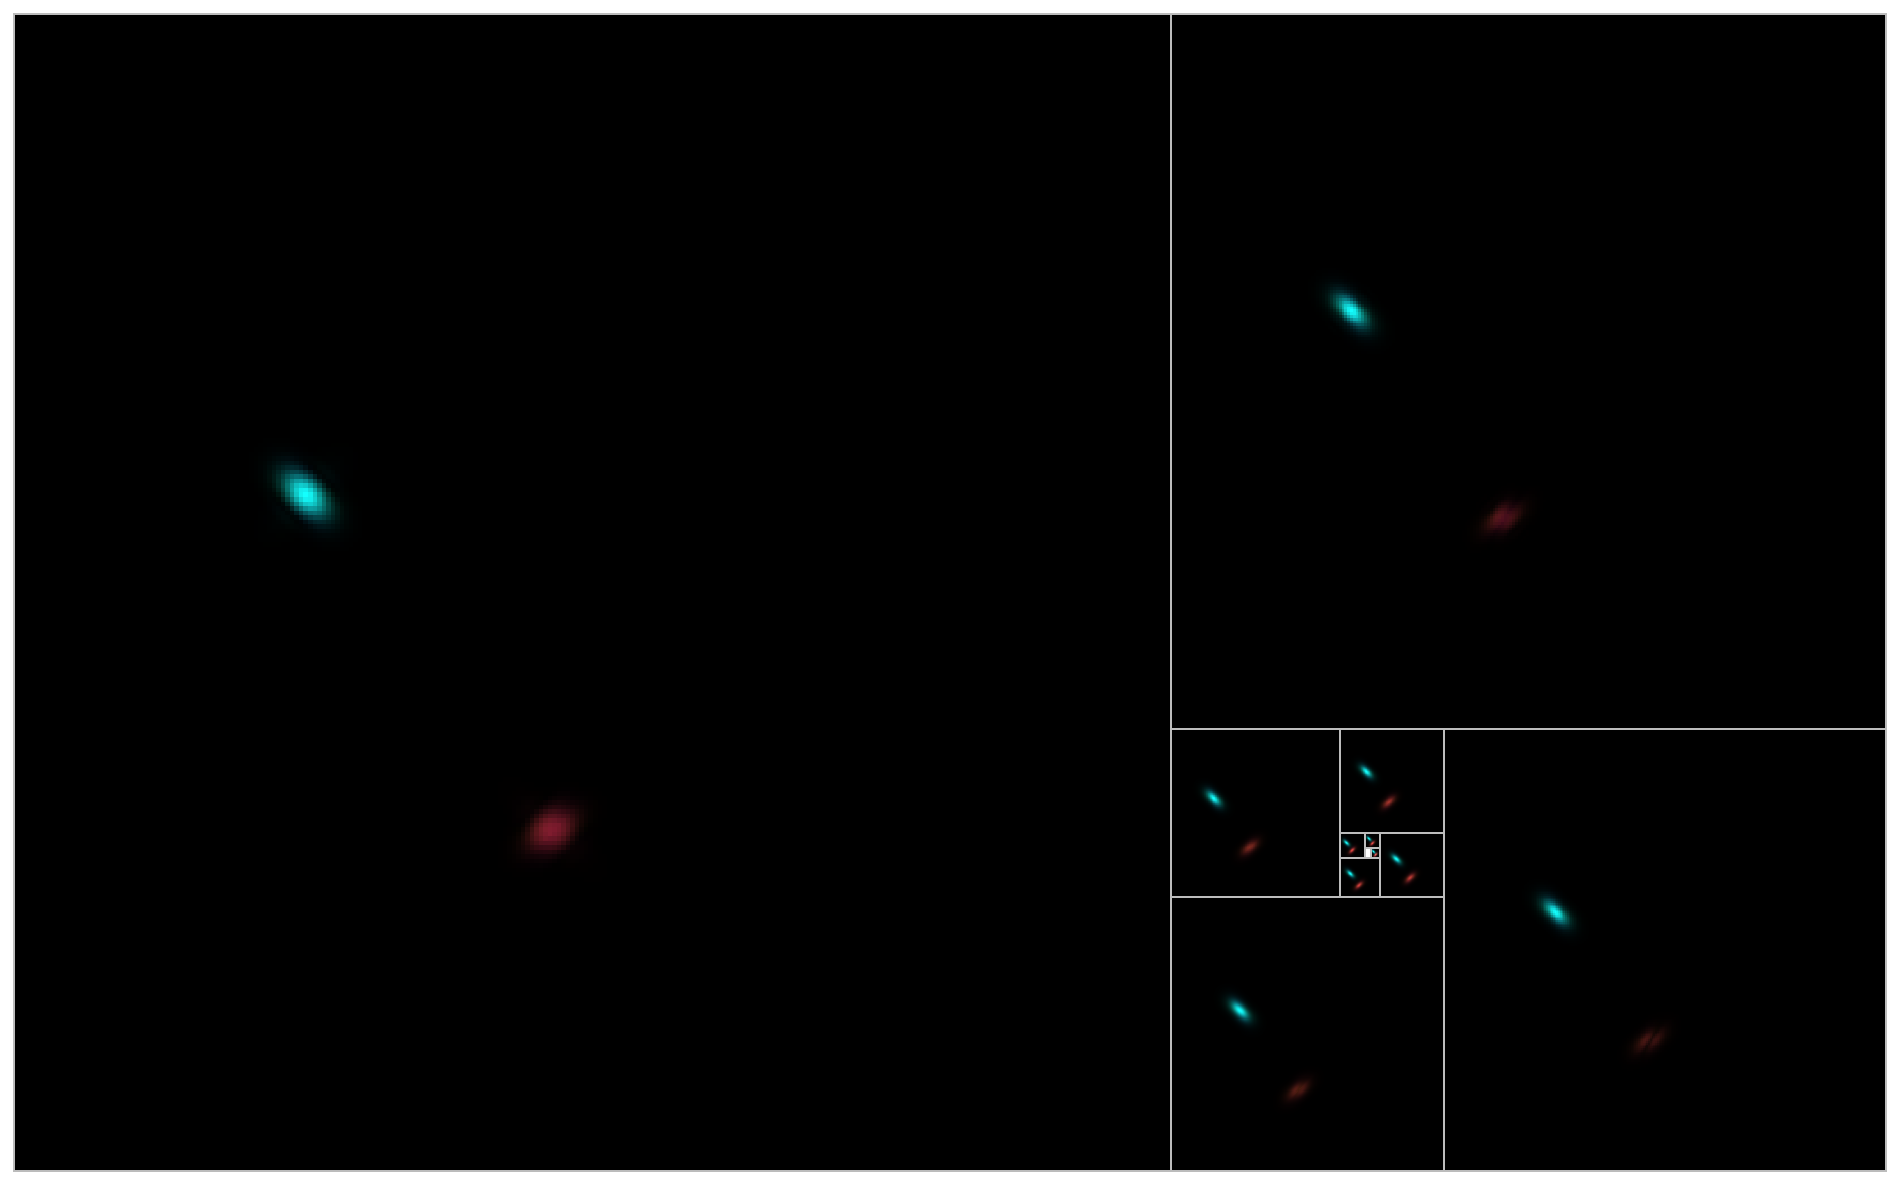

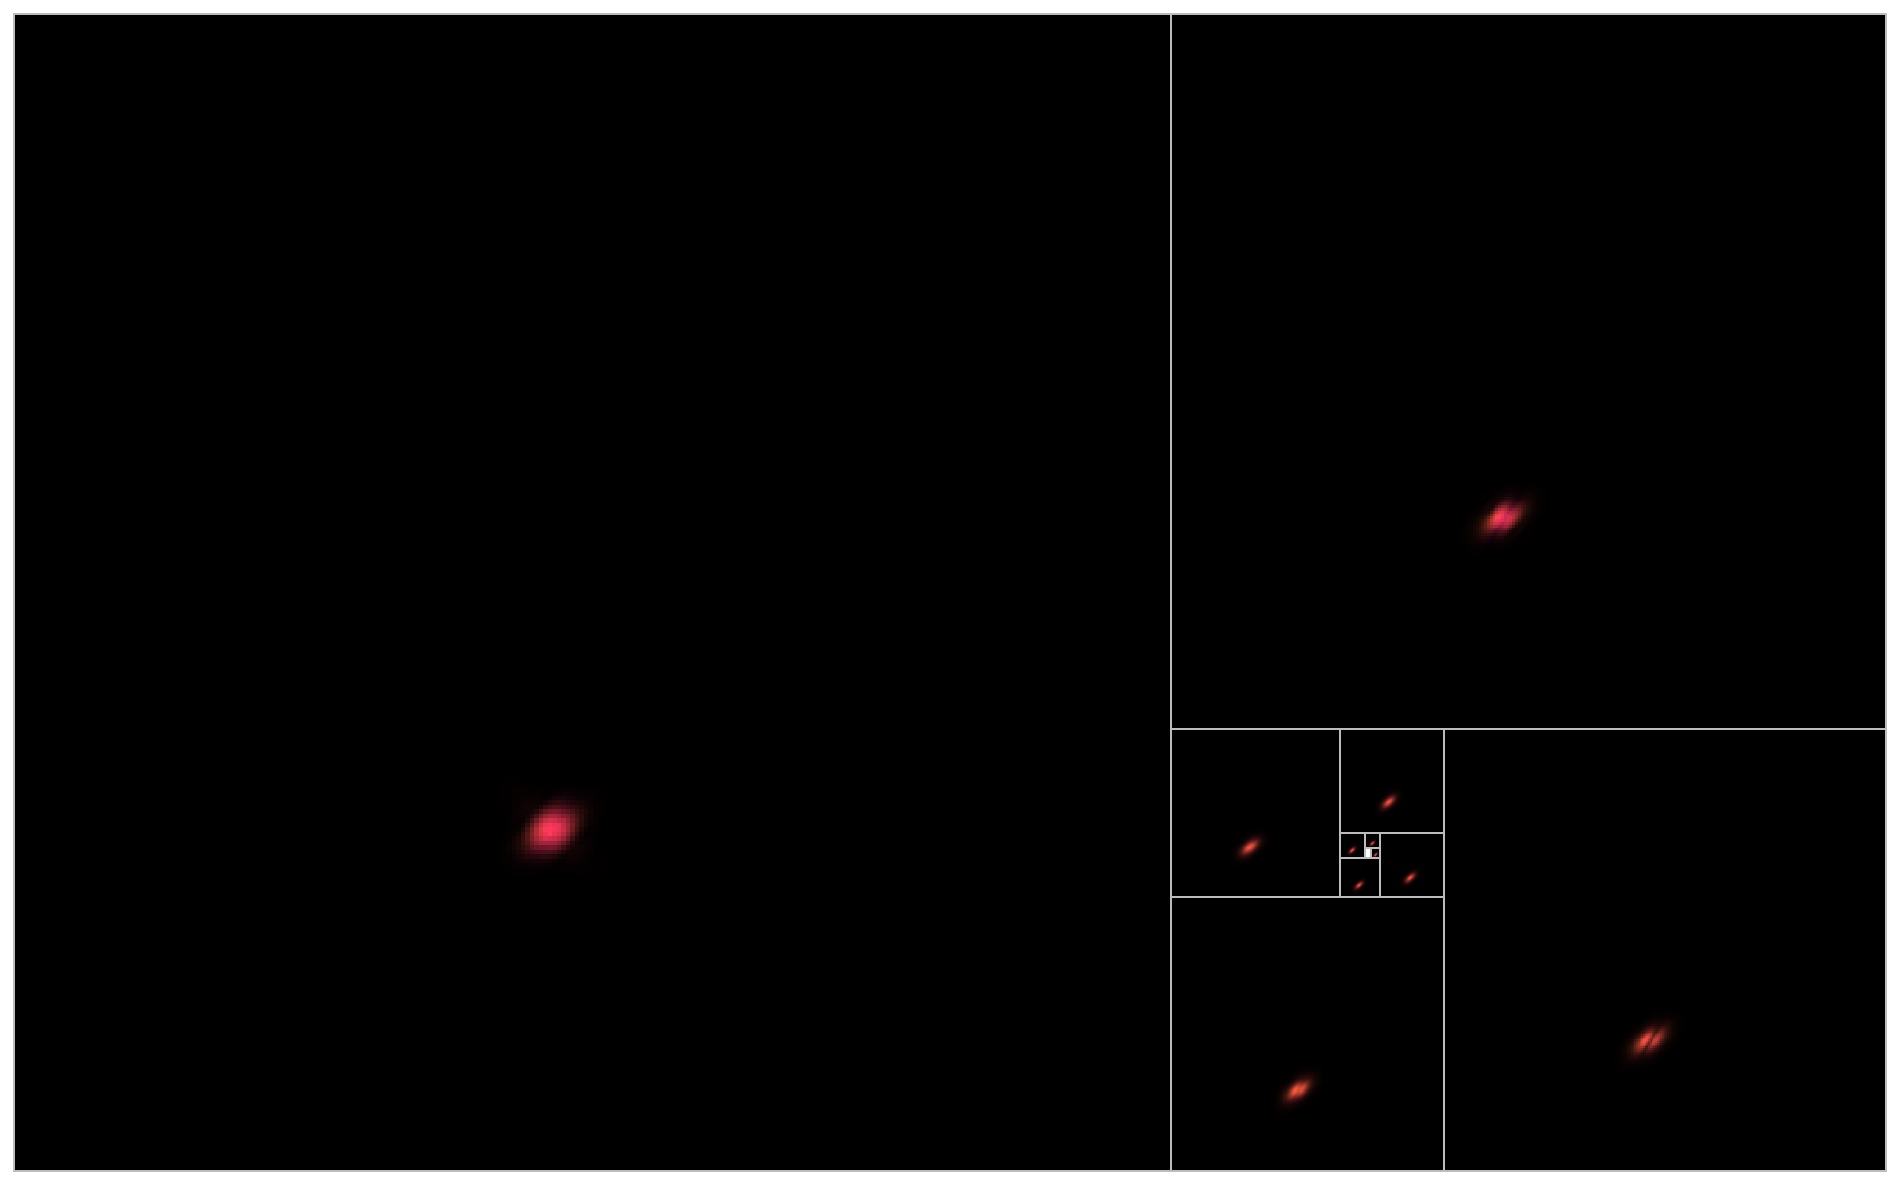

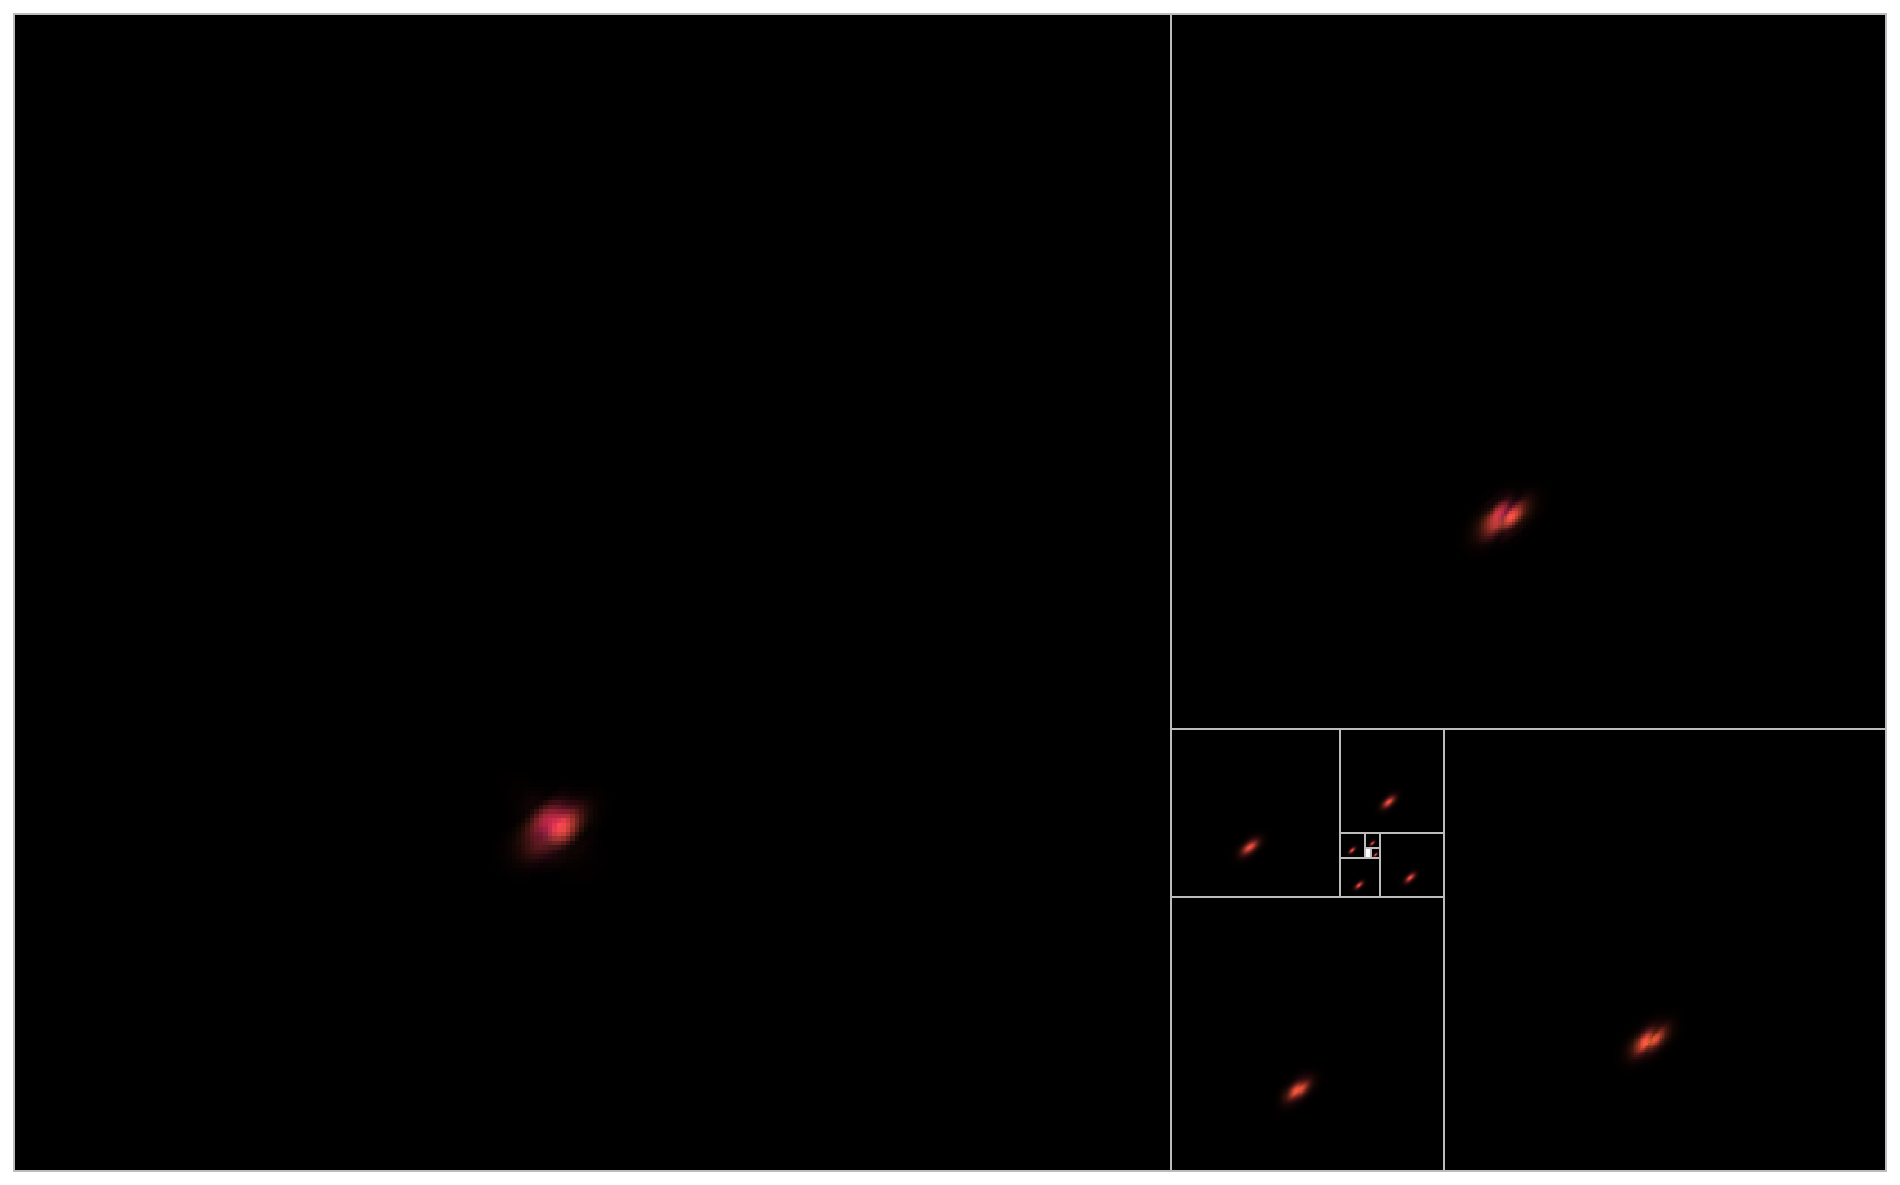

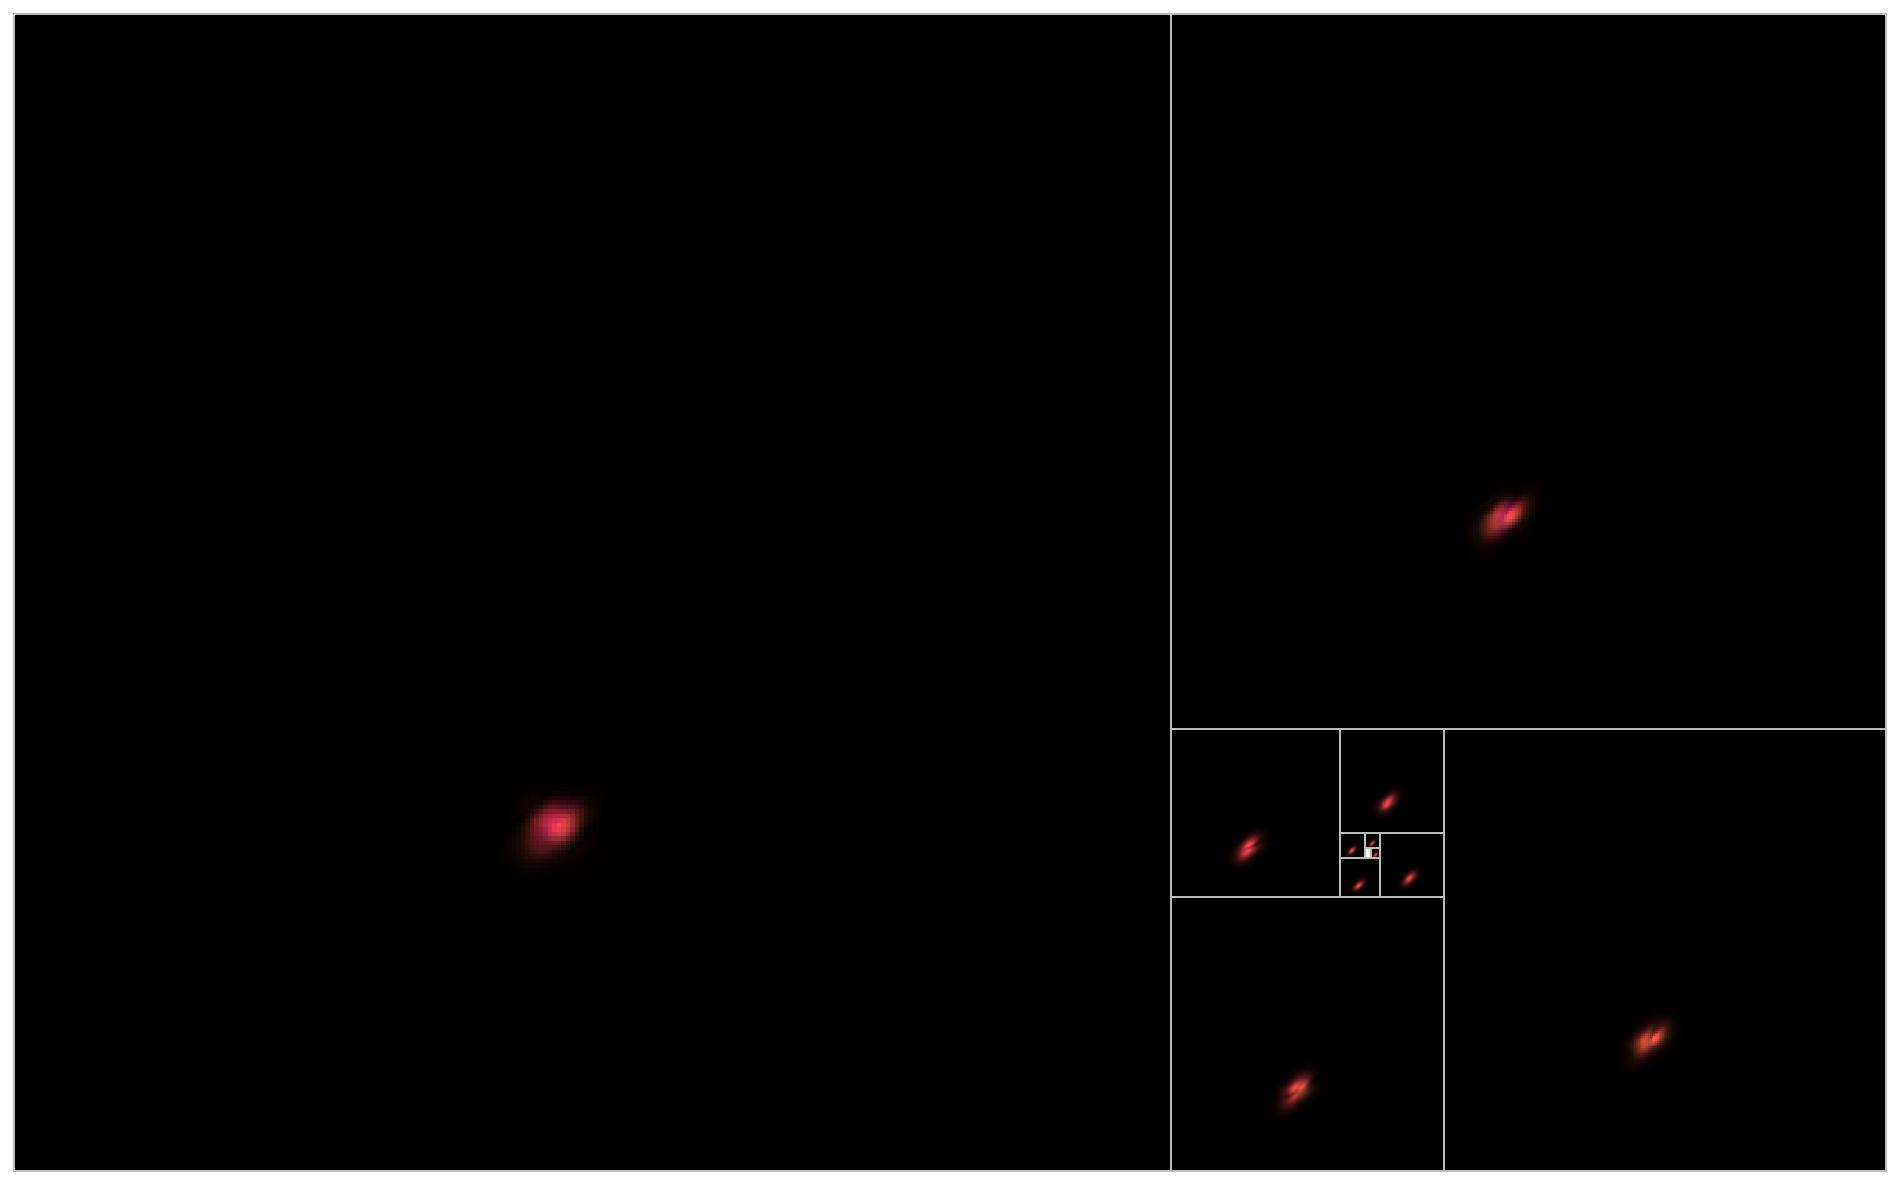

In [40]:
mp.pe.eta_SO = .01
self = mp
C = self.init_C(image)
logD = np.zeros((self.N_X, self.N_Y, self.pe.n_theta, self.n_levels))#, dtype=np.complex)
for i_edge in range(5):
    # MATCHING
    ind_edge_star = self.argmax(C * np.exp( self.pe.eta_SO * logD))

    coeff = self.pe.MP_alpha * np.absolute(C[ind_edge_star])
    # recording
    print ('Max activity  : ', np.absolute(C[ind_edge_star]), ' phase= ', np.angle(C[ind_edge_star], deg=True), ' deg,  @ ', ind_edge_star)
    edges[:, i_edge] = np.array([ind_edge_star[0]*1., ind_edge_star[1]*1.,
                             self.theta[ind_edge_star[2]],
                             self.sf_0[ind_edge_star[3]],
                             coeff, np.angle(C[ind_edge_star])])
    # PURSUIT
    if self.pe.eta_SO>0.: logD+= np.absolute(C[ind_edge_star]) * self.dipole(edges[:, i_edge])
    C = self.backprop(C, ind_edge_star)
    fig = self.golden_pyramid(C * np.exp( self.pe.eta_SO * logD))

## Dipole based on the measured statistics

(<matplotlib.figure.Figure at 0x141681dd0>,
 <matplotlib.axes._axes.Axes at 0x10e2d7b10>)

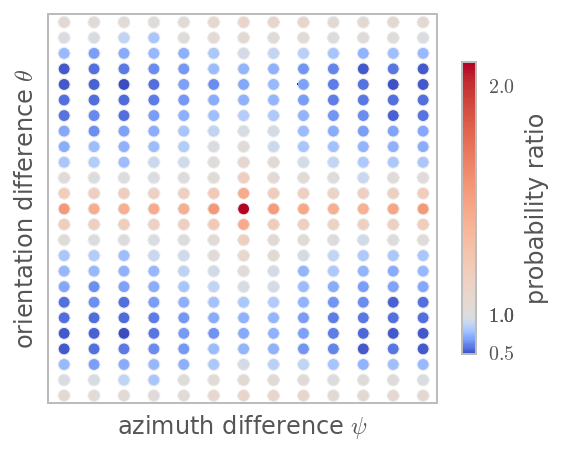

In [41]:

mp = SparseEdges('https://raw.githubusercontent.com/meduz/SparseEdges/master/default_param.py')
mp.pe.datapath = '../../SLIP/database/'
#edgeslist = np.load('mat/edges/prior_vanilla_serre07_distractors_edges.npy')
#edgeslist = np.load('mat/edges/efficiency_B_sf_0_5_serre07_distractors_edges.npy')
edgeslist = np.load('mat/edges/SparseLets_serre07_distractors_edges.npy')
v_hist = mp.cohistedges(edgeslist, display=False)
v_hist.mean(), v_hist.shape
mp.pe.d_max = 50.
mp.cohistedges(edgeslist=None, v_hist=v_hist)
    

2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
1.0 1.0 1.0
1.0 1.0 1.0
1.0 1.0 1.0
1.0 1.0 1.0
0.0 0.0 0.0
0.0 0.0 0.0


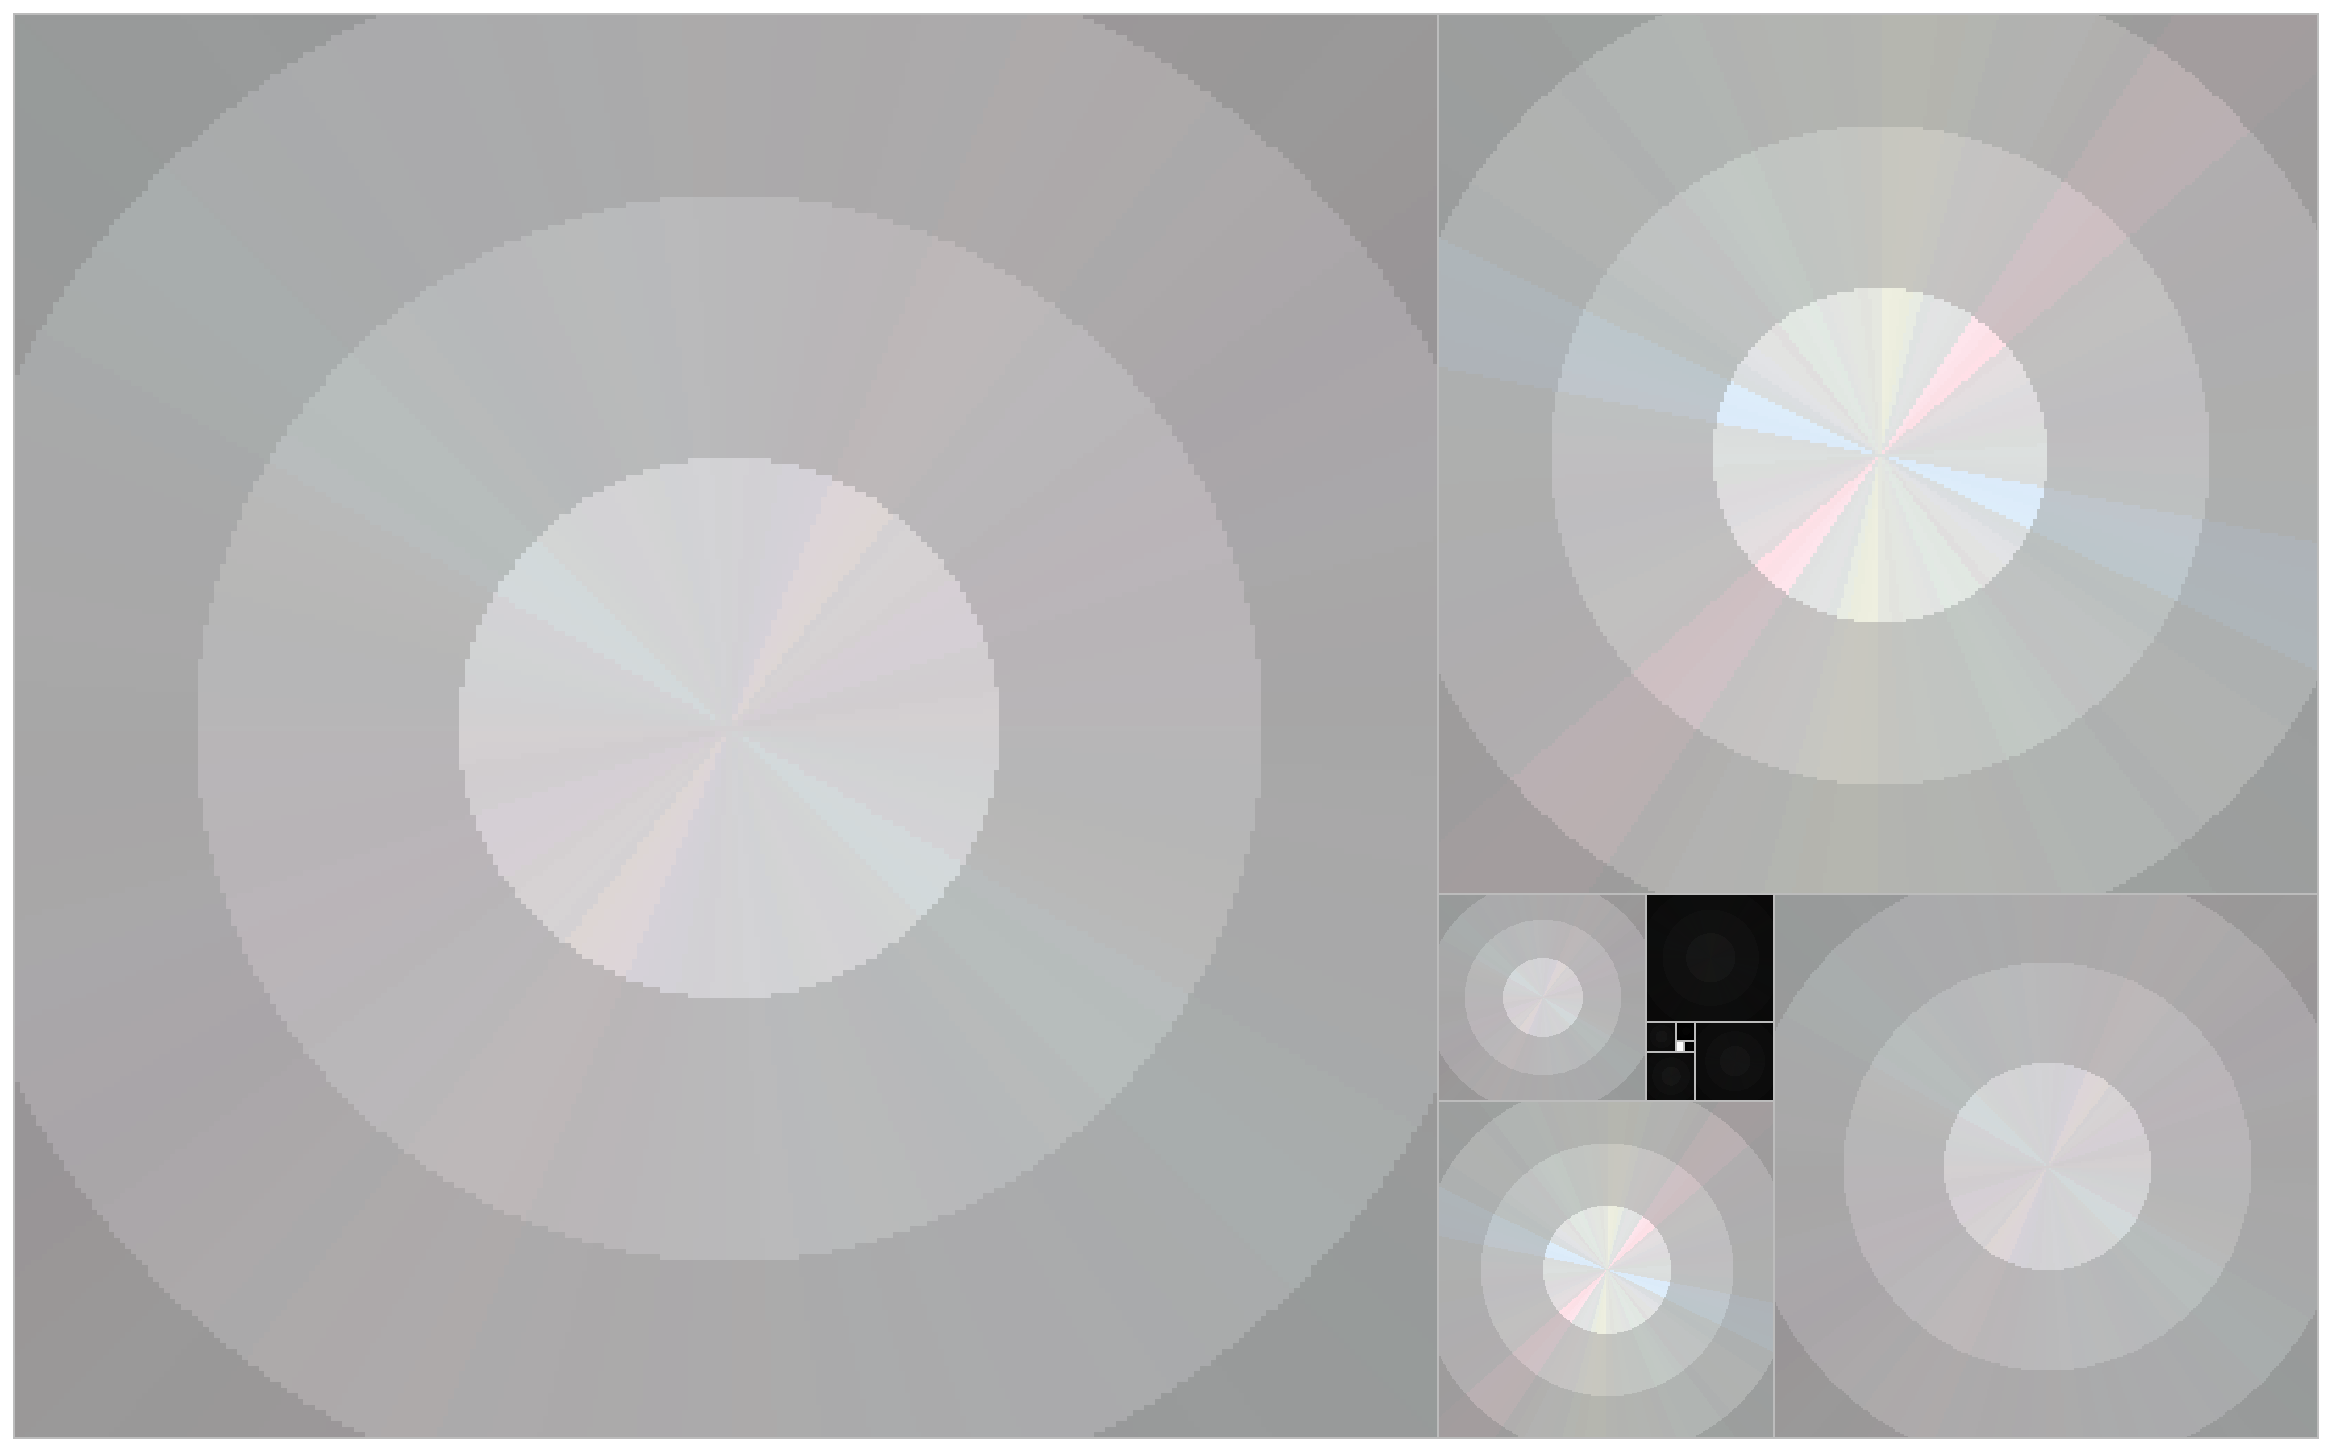

In [42]:
def plot_dipole():
    D = np.ones((mp.N_X, mp.N_Y, mp.pe.n_theta, mp.n_levels))
    x, y, theta, sf_0, C, phase = mp.N_X/2, mp.N_Y/2, mp.theta[8], mp.sf_0[2], 1, 0.
    d = np.sqrt((mp.X-x)**2+(mp.Y-y)**2)/mp.N_X
    #if mp.pe.scale_invariant: d *= np.sqrt(Sf_0[:, np.newaxis]*Sf_0[np.newaxis, :])#*np.sqrt(self.N_X)
    d *= mp.pe.d_width # distance in visual angle
    i_d = np.floor((d - mp.pe.d_min)/(mp.pe.d_max-mp.pe.d_min)*mp.pe.N_r)
    #print mp.pe.d_min, i_d.min(), i_d.mean(), i_d.max(), mp.pe.d_max
    i_d = i_d * (i_d>=0)
    #print mp.pe.d_min, i_d.min(), i_d.mean(), i_d.max(), mp.pe.d_max
    i_d = i_d * (i_d<mp.pe.N_r) + (mp.pe.N_r-1) * (i_d >= mp.pe.N_r)
    #print mp.pe.d_min, i_d.min(), i_d.mean(), i_d.max(), mp.pe.d_max

    for i_sf_0, sf_0_ in enumerate(mp.sf_0):
        loglevel = np.log2(sf_0_/sf_0)
        i_loglevel = np.floor((loglevel + mp.pe.loglevel_max)/(mp.pe.loglevel_max*2)*mp.pe.N_scale)* np.ones_like(i_d)
        print( i_loglevel.min(), i_loglevel.mean(), i_loglevel.max())

        for ii_theta, theta_ in enumerate(mp.theta):
            D_theta = theta - theta_ # angle between edge's orientation and the layer's one
            phi = np.arctan2(mp.Y-y, mp.X-x) - np.pi/2 - theta_ - D_theta/2
            # putting everything in the [-pi/2, pi/2[ quadrant
            theta = ((D_theta + np.pi/2 - np.pi/mp.pe.n_theta/2)  % (np.pi) ) - np.pi/2  + np.pi/mp.pe.n_theta/2
            phi = ((phi + np.pi/2  - np.pi/mp.pe.N_phi/2 ) % (np.pi)) - np.pi/2  + np.pi/mp.pe.N_phi/2
            # discretizing
            i_theta = np.floor((theta + np.pi/2)/np.pi*mp.pe.n_theta) * np.ones_like(i_d)
            i_theta = i_theta * (1-(i_theta == mp.pe.n_theta)) + 0. * (i_theta == mp.pe.n_theta)
            i_phi = np.floor((phi + np.pi/2)/np.pi*mp.pe.N_phi)
            #print 1-(i_phi == mp.pe.N_phi)
            i_phi = i_phi * (1-(i_phi == mp.pe.N_phi)) + 0. * (i_phi == mp.pe.N_phi)
            #print i_d.max(), i_phi.max(), i_theta.max(), i_loglevel.max()
            #print i_d.shape, i_phi.shape, i_theta.shape, i_loglevel.shape
            #print type(i_d), type(i_phi), type(i_theta), type(i_loglevel)
            #print ii_theta, i_sf_0, theta_
            D[:, :, ii_theta, i_sf_0] = v_hist[i_d.astype(int), i_phi.astype(int), i_theta.astype(int), i_loglevel.astype(int)]

    
    im_RGB, im_max = [], 0
    for i_sf_0, sf_0_ in enumerate(mp.sf_0):
        im_RGB_ = np.zeros((mp.N_X, mp.N_Y, 3))
        for i_theta, theta_ in enumerate(mp.theta):
            im_abs = np.absolute(D[:, :, i_theta, i_sf_0])
            RGB = np.array([.5*np.sin(2*theta_ + 2*i*np.pi/3)+.5 for i in range(3)])
            im_RGB_ += im_abs[:,:, np.newaxis] * RGB[np.newaxis, np.newaxis, :]

        im_max = np.max((im_max, im_RGB_.max()))
        im_RGB.append(im_RGB_)
       
    phi = (np.sqrt(5) +1.)/2. # golden number
    opts= {'vmin':0., 'vmax':1., 'interpolation':'nearest', 'origin':'upper'}
    fig_width = 16
    fig = plt.figure(figsize=(fig_width, fig_width/phi))
    xmin, ymin, size = 0, 0, 1.
    
    for i_sf_0, sf_0_ in enumerate(mp.sf_0):
        a = fig.add_axes((xmin/phi, ymin, size/phi, size), axisbg='w')
        a.axis(c='b', lw=0)
        plt.setp(a, xticks=[])
        plt.setp(a, yticks=[])
        a.imshow(im_RGB[i_sf_0]/im_max, **opts)
        a.grid(False)
        i_orientation = np.mod(i_sf_0, 4)
        if i_orientation==0:
            xmin += size
            ymin += size/phi**2
        elif i_orientation==1:
            xmin += size/phi**2
            ymin += -size/phi
        elif i_orientation==2:
            xmin += -size/phi
        elif i_orientation==3:
            ymin += size
        size /= phi 

plot_dipole()
#from IPython.html.widgets import interact
#_ = interact(plot_dipole, w=(pe.N_X*.01,pe.N_X,pe.N_X*.01), B_phi=(0.01, 2., 0.04), B_theta=(0.01, 2., 0.04), scale=(0.01, 2., 0.04))

In [43]:
ind = np.array([[0, 0], [1, 2]])
v_hist[ind, ind, ind, ind]

array([[  1.4651e-05,   1.4651e-05],
       [  4.7066e-05,   4.8305e-04]])

## Application to segmentation

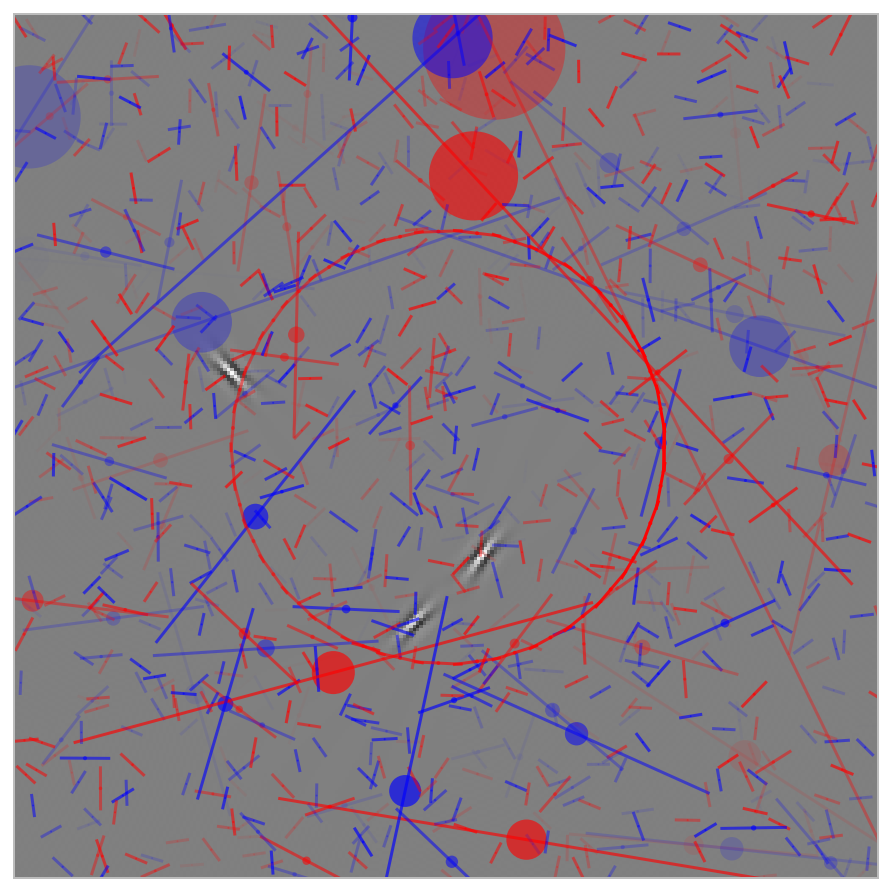

In [44]:
mp.pe.N, N_circle, N_image = 1024, 36, 1
edgeslist = np.zeros((6, mp.pe.N+N_circle, N_image))
# random edges:
edgeslist[0, :mp.pe.N, :] = mp.N_X * np.random.rand(mp.pe.N, N_image)
edgeslist[1, :mp.pe.N, :] = mp.N_X * np.random.rand(mp.pe.N, N_image)
edgeslist[2, :mp.pe.N, :] = (np.pi* np.random.rand(mp.pe.N, N_image) ) % np.pi
edgeslist[3, :mp.pe.N, :] = 0.5 * (1- mp.pe.base_levels**(-mp.n_levels*(np.random.rand(mp.pe.N, N_image))))
edgeslist[4, :mp.pe.N, :] = 1.2*np.random.rand(mp.pe.N, N_image) * np.sign(np.random.randn(mp.pe.N, N_image))
edgeslist[5, :mp.pe.N, :] = 2*np.pi*np.random.rand(mp.pe.N, N_image)
# cocircular edges:
for i_N, angle in enumerate(np.linspace(0, 2*np.pi, N_circle)): #2*np.pi*np.random.rand(N_circle)):
    edgeslist[0, mp.pe.N + i_N, :] = mp.N_X/2. - mp.N_X/4.*np.sin(angle) + .0 * np.random.randn(N_image)
    edgeslist[1, mp.pe.N + i_N, :] = mp.N_X/2. + mp.N_X/4.*np.cos(angle) + .0 * np.random.randn(N_image)
    edgeslist[2, mp.pe.N + i_N, :] = (np.pi/2 + angle + .5*np.pi/180 * np.random.randn(N_image)) % np.pi
    edgeslist[3, mp.pe.N + i_N, :] = mp.sf_0[2] #0.03
    edgeslist[4, mp.pe.N + i_N, :] = .7 + .4*np.exp(np.cos(angle)/1.**2)

#print edgeslist.shape
#image_rec = mp.reconstruct(edgeslist[:,:,0])
#from pylab import imsave, gray
#imsave(fname='database/circle_in_noise.png', arr=image_rec, vmin=image_rec.min(), vmax=image_rec.max(), cmap=gray())

mp.pe.scale = 1.7
mp.pe.line_width = 1.5

fig, a = mp.show_edges(edgeslist[:,:,0], image=image, color='toto', show_phase=False) #

In [45]:
%%writefile experiment_fig-secondorder_Geisler.py
# -*- coding: utf8 -*-
from __future__ import division, print_function

# rm **/Geisler01Fig7A_secondorder*
# rm **/circle_in_noise_secondorder*

import os
import numpy as np
import matplotlib.pyplot as plt

from SparseEdges import SparseEdges

#figpath = '../../CNRS/BICV-book/BICV_sparse/'
figpath = './'
FORMATS = ['pdf', 'eps']
fig_width_pt = 318.670  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
fig_width = fig_width_pt*inches_per_pt  # width in inches


def init_mp():
    mp = SparseEdges('https://raw.githubusercontent.com/meduz/SparseEdges/master/default_param.py')
    mp.pe.datapath = '../../SLIP/database/'
    mp.pe.N = 60
    mp.pe.do_whitening = True
    mp.pe.MP_alpha = 1.
    mp.pe.figsize_edges = 12
    mp.pe.figsize_edges = .382 * fig_width
    mp.pe.scale = 1.3
    mp.pe.line_width = 1.5
    return mp

mp = init_mp()
eta_SO = 0.15

##############################################################################################################
figname = 'Geisler01Fig7A_rec'
if False: #os.path.isfile('database/' + figname + '.png'):
    # defining input image 
    from pylab import imread
    image = imread('database/' + figname + '.png').mean(axis=-1)
    print (image.mean(), image.std())
else:
    N, N_circle, N_image = 1024, 36, 1
    edgeslist = np.zeros((6, N+N_circle, N_image))
    np.random.seed(seed=42)
    # random edges:
    edgeslist[0, :N, :] = mp.N_X * np.random.rand(N, N_image)
    edgeslist[1, :N, :] = mp.N_X * np.random.rand(N, N_image)
    edgeslist[2, :N, :] = (np.pi* np.random.rand(N, N_image) ) % np.pi
    edgeslist[3, :N, :] = 0.5 * (1- mp.pe.base_levels**(-mp.n_levels*(np.random.rand(N, N_image))))
    edgeslist[4, :N, :] = 1.25*np.random.rand(N, N_image) * np.sign(np.random.randn(N, N_image))
    edgeslist[5, :N, :] = 2*np.pi*np.random.rand(N, N_image)
    # cocircular edges:
    for i_N, angle in enumerate(np.linspace(0, 2*np.pi, N_circle)): #2*np.pi*np.random.rand(N_circle)):
        edgeslist[0, N + i_N, :] = mp.N_X/2. - mp.N_X/4.*np.sin(angle) + .0 * np.random.randn(N_image)
        edgeslist[1, N + i_N, :] = mp.N_X/2. + mp.N_X/4.*np.cos(angle) + .0 * np.random.randn(N_image)
        edgeslist[2, N + i_N, :] = (np.pi/2 + angle + .5*np.pi/180 * np.random.randn(N_image)) % np.pi
        edgeslist[3, N + i_N, :] = mp.sf_0[2] #0.03
        edgeslist[4, N + i_N, :] = 1.1 + .15*np.exp(np.cos(angle)/1.**2)

    print (edgeslist.shape)
    image = mp.reconstruct(edgeslist[:,:,0])
    #from pylab import imsave, gray
    #imsave(fname='database/' + figname + '.png', arr=image, vmin=image.min(), vmax=image.max(), cmap=gray())

image = mp.normalize(image, center=True)
print (image.mean(), image.std())
v_max = 1.*image.max()
v_min = -v_max
##############################################################################################################
print( ' without edges ')
matname = 'mat/' + figname + '_secondorder_A.npy'
try:
    fig, a = mp.show_edges(edges=np.zeros((6,0)), image=image, v_min=v_min, v_max=v_max, color='toto', show_phase=False) #
    if not(figpath==None): 
        for ext in FORMATS: 
                fig.savefig(matname.replace('mat/', mp.pe.figpath).replace('.npy', '.' + ext), dpi=450)
    fig.show()
except:
    print ('File ', matname, ' is locked')
##############################################################################################################
print (' without second-order ')
matname = 'mat/' + figname + '_secondorder_B.npy'
if not(os.path.isfile(matname)):
    if not(os.path.isfile(matname + '_lock')):
        file(matname + '_lock', 'w').close()
        mp.pe.eta_SO = 0.
        edges, C_res = mp.run_mp(image, verbose=True)
        np.save(matname, edges)
        os.remove(matname + '_lock')
try:
    edges = np.load(matname)
    fig, a = mp.show_edges(edges, image=image, v_min=v_min, v_max=v_max, color='toto', show_phase=False) #
    if not(figpath==None): 
        for ext in FORMATS: 
                fig.savefig(matname.replace('mat/', mp.pe.figpath).replace('.npy', '.' + ext), dpi=450)
    fig.show()
except:
    print ('File ', matname, ' is locked')
##############################################################################################################
print (' with second-order ')
matname = 'mat/' + figname + '_secondorder_C.npy'
if not(os.path.isfile(matname)):
    if not(os.path.isfile(matname + '_lock')):
        file(matname + '_lock', 'w').close()
        mp.pe.eta_SO = eta_SO
        edges, C_res = mp.run_mp(image, verbose=True)
        np.save(matname, edges)
        os.remove(matname + '_lock')
try:
    edges = np.load(matname)
    edges[4, :] *= -1 # turn red in blue...
    fig, a = mp.show_edges(edges, image=image, v_min=v_min, v_max=v_max, color='toto', show_phase=False) #
    fig.show()
    if not(figpath==None): 
        for ext in FORMATS: 
                fig.savefig(matname.replace('mat/', mp.pe.figpath).replace('.npy', '.' + ext), dpi=450)
except:
    print ('File ', matname, ' is locked')
##############################################################################################################
if True:
    N_explore = 25
    base = 1.5
    ##############################################################################################################
    mp = init_mp()
    for mp.pe.eta_SO in np.logspace(-1., 1., N_explore, base=base)*eta_SO:
        matname = 'mat/' + figname + '_secondorder_eta_SO_' + str(mp.pe.eta_SO).replace('.', '_') + '.npy'
        if not(os.path.isfile(matname)):
            if not(os.path.isfile(matname + '_lock')):
                file(matname + '_lock', 'w').close()
                edges, C_res = mp.run_mp(image, verbose=True)
                np.save(matname, edges)
                os.remove(matname + '_lock')
        try:
            edges = np.load(matname)
            edges[4, :] *= -1 # turn red in blue...
            fig, a = mp.show_edges(edges, image=image, v_min=v_min, v_max=v_max, color='toto', show_phase=False) #
            fig.savefig(matname.replace('mat/', mp.pe.figpath).replace('.npy', '.pdf'))
        except:
            print ('File ', matname, ' is locked')
        plt.close('all')
    ##############################################################################################################
    mp = init_mp()
    mp.pe.eta_SO = eta_SO
    for mp.pe.dip_epsilon in np.linspace(0, 1., N_explore):
        matname = 'mat/' + figname + '_secondorder_dip_epsilon_' + str(mp.pe.dip_epsilon).replace('.', '_') + '.npy'
        if not(os.path.isfile(matname)):
            if not(os.path.isfile(matname + '_lock')):
                file(matname + '_lock', 'w').close()
                edges, C_res = mp.run_mp(image, verbose=True)
                np.save(matname, edges)
                os.remove(matname + '_lock')
        try:
            edges = np.load(matname)
            edges[4, :] *= -1 # turn red in blue...
            fig, a = mp.show_edges(edges, image=image, v_min=v_min, v_max=v_max, color='toto', show_phase=False) #
            fig.savefig(matname.replace('mat/', mp.pe.figpath).replace('.npy', '.pdf'))
        except:
            print ('File ', matname, ' is locked')
        plt.close('all')       
    ##############################################################################################################
    base = 2.
    ##############################################################################################################
    mp = init_mp()
    mp.pe.eta_SO = eta_SO
    for mp.pe.dip_w in np.logspace(-1., 1., N_explore, base=base)*mp.pe.dip_w:
        matname = 'mat/' + figname + '_secondorder_dip_w_' + str(mp.pe.dip_w).replace('.', '_') + '.npy'
        if not(os.path.isfile(matname)):
            if not(os.path.isfile(matname + '_lock')):
                file(matname + '_lock', 'w').close()
                edges, C_res = mp.run_mp(image, verbose=True)
                np.save(matname, edges)
                os.remove(matname + '_lock')
        try:
            edges = np.load(matname)
            edges[4, :] *= -1 # turn red in blue...
            fig, a = mp.show_edges(edges, image=image, v_min=v_min, v_max=v_max, color='toto', show_phase=False) #
            fig.savefig(matname.replace('mat/', mp.pe.figpath).replace('.npy', '.pdf'))
        except:
            print ('File ', matname, ' is locked')
        plt.close('all')
    ##############################################################################################################
    mp = init_mp()
    mp.pe.eta_SO = eta_SO
    for mp.pe.dip_B_psi in np.logspace(-1., 1., N_explore, base=base)*mp.pe.dip_B_psi:
        matname = 'mat/' + figname + '_secondorder_dip_B_psi_' + str(mp.pe.dip_B_psi).replace('.', '_') + '.npy'
        if not(os.path.isfile(matname)):
            if not(os.path.isfile(matname + '_lock')):
                file(matname + '_lock', 'w').close()
                edges, C_res = mp.run_mp(image, verbose=True)
                np.save(matname, edges)
                os.remove(matname + '_lock')
        try:
            edges = np.load(matname)
            edges[4, :] *= -1 # turn red in blue...
            fig, a = mp.show_edges(edges, image=image, v_min=v_min, v_max=v_max, color='toto', show_phase=False) #
            fig.savefig(matname.replace('mat/', mp.pe.figpath).replace('.npy', '.pdf'))
        except:
            print ('File ', matname, ' is locked')
        plt.close('all')
    ##############################################################################################################
    mp = init_mp()
    mp.pe.eta_SO = eta_SO
    for mp.pe.dip_B_theta in np.logspace(-1., 1., N_explore, base=base)*mp.pe.dip_B_theta:
        matname = 'mat/' + figname + '_secondorder_dip_B_theta_' + str(mp.pe.dip_B_theta).replace('.', '_') + '.npy'
        if not(os.path.isfile(matname)):
            if not(os.path.isfile(matname + '_lock')):
                file(matname + '_lock', 'w').close()
                edges, C_res = mp.run_mp(image, verbose=True)
                np.save(matname, edges)
                os.remove(matname + '_lock')
        try:
            edges = np.load(matname)
            edges[4, :] *= -1 # turn red in blue...
            fig, a = mp.show_edges(edges, image=image, v_min=v_min, v_max=v_max, color='toto', show_phase=False) #
            fig.savefig(matname.replace('mat/', mp.pe.figpath).replace('.npy', '.pdf'))
        except:
            print( 'File ', matname, ' is locked')
        plt.close('all')
    ##############################################################################################################
    mp = init_mp()
    mp.pe.eta_SO = eta_SO
    for mp.pe.dip_scale in np.logspace(-1., 1., N_explore, base=base)*mp.pe.dip_scale:
        matname = 'mat/' + figname + '_secondorder_dip_scale_' + str(mp.pe.dip_scale).replace('.', '_') + '.npy'
        if not(os.path.isfile(matname)):
            if not(os.path.isfile(matname + '_lock')):
                file(matname + '_lock', 'w').close()
                edges, C_res = mp.run_mp(image, verbose=True)
                np.save(matname, edges)
                os.remove(matname + '_lock')
        try:
            edges = np.load(matname)
            edges[4, :] *= -1 # turn red in blue...
            fig, a = mp.show_edges(edges, image=image, v_min=v_min, v_max=v_max, color='toto', show_phase=False) #
            fig.savefig(matname.replace('mat/', mp.pe.figpath).replace('.npy', '.pdf'))
            fig
        except:
            print ('File ', matname, ' is locked')
        plt.close('all')
    ##############################################################################################################


Overwriting experiment_fig-secondorder_Geisler.py


In [46]:
%run experiment_fig-secondorder_Geisler.py

(6, 1060, 1)
-2.71050543121e-20 0.0975502156113
 without edges 
 without second-order 
 with second-order 
File  mat/Geisler01Fig7A_rec_secondorder_eta_SO_0_13103706971.npy  is locked
Edge

[  1 %] elapsed[sec]: 0.948 | ETA[sec]: 55.912 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.096 | ETA[sec]: 234.776 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 15.389 | ETA[sec]: 292.401 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 22.629 | ETA[sec]: 316.810 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 29.890 | ETA[sec]: 328.790 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 36.972 | ETA[sec]: 332.746 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 44.099 | ETA[sec]: 333.894 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 51.157 | ETA[sec]: 332.523 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 58.401 | ETA[sec]: 330.937 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 65.599 | ETA[sec]: 327.994 

 9 / 60  - Max activity  :  2.75826325641  phase=  31.9011798211  deg,  @  (192, 137, 12, 2)
Edge

[ 18 %] elapsed[sec]: 73.034 | ETA[sec]: 325.332 

 10 / 60  - Max activity  :  1.81714606913  phase=  77.043830453  deg,  @  (189, 150, 14, 2)
Edge

[ 20 %] elapsed[sec]: 80.229 | ETA[sec]: 320.915 

 11 / 60  - Max activity  :  2.15818182889  phase=  101.286386199  deg,  @  (193, 124, 11, 2)
Edge

[ 21 %] elapsed[sec]: 87.390 | ETA[sec]: 315.950 

 12 / 60  - Max activity  :  2.53444565412  phase=  7.35162229675  deg,  @  (87, 177, 4, 2)
Edge

[ 23 %] elapsed[sec]: 94.482 | ETA[sec]: 310.440 

 13 / 60  - Max activity  :  2.41794144097  phase=  -16.6509366827  deg,  @  (77, 167, 6, 2)
Edge

[ 25 %] elapsed[sec]: 101.746 | ETA[sec]: 305.239 

 14 / 60  - Max activity  :  2.83828288736  phase=  153.169179955  deg,  @  (110, 254, 13, 1)
Edge

[ 26 %] elapsed[sec]: 108.837 | ETA[sec]: 299.302 

 15 / 60  - Max activity  :  1.56215891789  phase=  -16.3296466451  deg,  @  (95, 183, 3, 2)
Edge

[ 28 %] elapsed[sec]: 116.001 | ETA[sec]: 293.414 

 16 / 60  - Max activity  :  1.67730466654  phase=  -121.519380732  deg,  @  (178, 180, 20, 1)
Edge

[ 30 %] elapsed[sec]: 123.332 | ETA[sec]: 287.774 

 17 / 60  - Max activity  :  2.31368893854  phase=  9.70600267628  deg,  @  (67, 147, 9, 2)
Edge

[ 31 %] elapsed[sec]: 130.467 | ETA[sec]: 281.534 

 18 / 60  - Max activity  :  2.03519047869  phase=  -4.92754079703  deg,  @  (64, 125, 11, 2)
Edge

[ 33 %] elapsed[sec]: 137.610 | ETA[sec]: 275.219 

 19 / 60  - Max activity  :  2.07716472451  phase=  -4.74528879853  deg,  @  (66, 112, 13, 2)
Edge

[ 35 %] elapsed[sec]: 144.895 | ETA[sec]: 269.091 

 20 / 60  - Max activity  :  2.02091269488  phase=  -12.0473862844  deg,  @  (73, 95, 15, 2)
Edge

[ 36 %] elapsed[sec]: 152.008 | ETA[sec]: 262.559 

 21 / 60  - Max activity  :  2.0446563785  phase=  -29.8451051199  deg,  @  (82, 83, 17, 2)
Edge

[ 38 %] elapsed[sec]: 159.075 | ETA[sec]: 255.903 

 22 / 60  - Max activity  :  1.28263205654  phase=  -3.72723382511  deg,  @  (69, 103, 14, 2)
Edge

[ 40 %] elapsed[sec]: 166.082 | ETA[sec]: 249.123 

 23 / 60  - Max activity  :  1.7571151523  phase=  -35.3576221954  deg,  @  (90, 76, 18, 2)
Edge

[ 41 %] elapsed[sec]: 173.098 | ETA[sec]: 242.338 

 24 / 60  - Max activity  :  1.97631305304  phase=  2.84762686543  deg,  @  (101, 70, 20, 2)
Edge

[ 43 %] elapsed[sec]: 180.177 | ETA[sec]: 235.616 

 25 / 60  - Max activity  :  1.87278721312  phase=  -1.96397693498  deg,  @  (112, 66, 21, 2)
Edge

[ 45 %] elapsed[sec]: 187.321 | ETA[sec]: 228.948 

 26 / 60  - Max activity  :  1.78837465704  phase=  -28.2944951057  deg,  @  (122, 64, 22, 2)
Edge

[ 46 %] elapsed[sec]: 194.494 | ETA[sec]: 222.279 

 27 / 60  - Max activity  :  1.95916094839  phase=  34.2179422659  deg,  @  (135, 64, 0, 2)
Edge

[ 48 %] elapsed[sec]: 201.664 | ETA[sec]: 215.572 

 28 / 60  - Max activity  :  1.82929840764  phase=  48.5538043819  deg,  @  (146, 66, 1, 2)
Edge

[ 50 %] elapsed[sec]: 208.982 | ETA[sec]: 208.982 

 29 / 60  - Max activity  :  2.2561930938  phase=  -45.9033398299  deg,  @  (166, 77, 4, 2)
Edge

[ 51 %] elapsed[sec]: 216.040 | ETA[sec]: 202.102 

 30 / 60  - Max activity  :  1.42436881499  phase=  -62.1537133136  deg,  @  (64, 136, 11, 2)
Edge

[ 53 %] elapsed[sec]: 223.249 | ETA[sec]: 195.343 

 31 / 60  - Max activity  :  0.693539238295  phase=  123.951086324  deg,  @  (64, 129, 11, 2)
Edge

[ 55 %] elapsed[sec]: 230.295 | ETA[sec]: 188.423 

 32 / 60  - Max activity  :  2.22085336453  phase=  3.65548944635  deg,  @  (187, 103, 8, 2)
Edge

[ 56 %] elapsed[sec]: 237.409 | ETA[sec]: 181.548 

 33 / 60  - Max activity  :  0.884773352632  phase=  -158.389624291  deg,  @  (129, 192, 23, 3)
Edge

[ 58 %] elapsed[sec]: 244.467 | ETA[sec]: 174.619 

 34 / 60  - Max activity  :  0.711463313439  phase=  -54.7696390212  deg,  @  (139, 191, 22, 2)
Edge

[ 60 %] elapsed[sec]: 251.689 | ETA[sec]: 167.793 

 35 / 60  - Max activity  :  2.59819670781  phase=  -24.6890408174  deg,  @  (240, 106, 22, 1)
Edge

[ 61 %] elapsed[sec]: 258.778 | ETA[sec]: 160.862 

 36 / 60  - Max activity  :  2.35823474624  phase=  173.102121258  deg,  @  (124, 28, 14, 1)
Edge

[ 63 %] elapsed[sec]: 265.914 | ETA[sec]: 153.950 

 37 / 60  - Max activity  :  1.87255303947  phase=  -152.390570571  deg,  @  (116, 148, 3, 2)
Edge

[ 65 %] elapsed[sec]: 272.870 | ETA[sec]: 146.930 

 38 / 60  - Max activity  :  1.55975842989  phase=  86.4683093406  deg,  @  (155, 69, 2, 2)
Edge

[ 66 %] elapsed[sec]: 280.138 | ETA[sec]: 140.069 

 39 / 60  - Max activity  :  1.89590629045  phase=  -38.8313134036  deg,  @  (71, 158, 7, 2)
Edge

[ 68 %] elapsed[sec]: 287.333 | ETA[sec]: 133.154 

 40 / 60  - Max activity  :  0.862315271228  phase=  -100.515562828  deg,  @  (64, 131, 11, 1)
Edge

[ 70 %] elapsed[sec]: 294.514 | ETA[sec]: 126.220 

 41 / 60  - Max activity  :  0.589067968697  phase=  79.4967863522  deg,  @  (64, 129, 11, 2)
Edge

[ 71 %] elapsed[sec]: 301.627 | ETA[sec]: 119.248 

 42 / 60  - Max activity  :  0.518101759886  phase=  -31.4117746327  deg,  @  (77, 89, 16, 2)
Edge

[ 73 %] elapsed[sec]: 308.751 | ETA[sec]: 112.273 

 43 / 60  - Max activity  :  0.517048233017  phase=  130.49223749  deg,  @  (83, 82, 17, 2)
Edge

[ 75 %] elapsed[sec]: 315.789 | ETA[sec]: 105.263 

 44 / 60  - Max activity  :  0.632323424238  phase=  172.257445036  deg,  @  (72, 97, 15, 2)
Edge

[ 76 %] elapsed[sec]: 322.896 | ETA[sec]: 98.273 

 45 / 60  - Max activity  :  0.500235340692  phase=  -3.7663825255  deg,  @  (65, 118, 12, 2)
Edge

[ 78 %] elapsed[sec]: 329.858 | ETA[sec]: 91.237 

 46 / 60  - Max activity  :  0.518163365086  phase=  -167.301514389  deg,  @  (67, 109, 13, 2)
Edge

[ 80 %] elapsed[sec]: 337.021 | ETA[sec]: 84.255 

 47 / 60  - Max activity  :  0.453355801975  phase=  -0.316332994943  deg,  @  (69, 103, 14, 2)
Edge

[ 81 %] elapsed[sec]: 344.112 | ETA[sec]: 77.250 

 48 / 60  - Max activity  :  1.88092195457  phase=  -28.6539657532  deg,  @  (175, 85, 6, 2)
Edge

[ 83 %] elapsed[sec]: 351.168 | ETA[sec]: 70.234 

 49 / 60  - Max activity  :  2.48401983981  phase=  -117.977048467  deg,  @  (148, 179, 8, 2)
Edge

[ 85 %] elapsed[sec]: 358.333 | ETA[sec]: 63.235 

 50 / 60  - Max activity  :  0.88208923554  phase=  -91.834772796  deg,  @  (178, 169, 16, 3)
Edge

[ 86 %] elapsed[sec]: 365.467 | ETA[sec]: 56.226 

 51 / 60  - Max activity  :  1.56614274913  phase=  160.384313889  deg,  @  (190, 125, 11, 2)
Edge

[ 88 %] elapsed[sec]: 372.533 | ETA[sec]: 49.202 

 52 / 60  - Max activity  :  0.753424080542  phase=  -131.277190822  deg,  @  (193, 124, 11, 2)
Edge

[ 90 %] elapsed[sec]: 379.691 | ETA[sec]: 42.188 

 53 / 60  - Max activity  :  0.459817848029  phase=  103.469793653  deg,  @  (190, 147, 13, 2)
Edge

[ 91 %] elapsed[sec]: 386.891 | ETA[sec]: 35.172 

 54 / 60  - Max activity  :  0.475361855225  phase=  -65.8746074502  deg,  @  (188, 152, 14, 2)
Edge

[ 93 %] elapsed[sec]: 393.925 | ETA[sec]: 28.138 

 55 / 60  - Max activity  :  0.852024071828  phase=  -45.5861318822  deg,  @  (160, 183, 19, 2)
Edge

[ 95 %] elapsed[sec]: 401.073 | ETA[sec]: 21.109 

 56 / 60  - Max activity  :  0.762818423133  phase=  -67.3545748882  deg,  @  (162, 184, 19, 2)
Edge

[ 96 %] elapsed[sec]: 408.161 | ETA[sec]: 14.075 

 57 / 60  - Max activity  :  2.0327755665  phase=  -126.610007075  deg,  @  (82, 204, 4, 1)
Edge

[ 98 %] elapsed[sec]: 415.339 | ETA[sec]: 7.040 

 58 / 60  - Max activity  :  2.36717469707  phase=  5.11074460535  deg,  @  (93, 27, 18, 1)
Edge

[100 %] elapsed[sec]: 422.378 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  1.65227407516  phase=  116.711447384  deg,  @  (131, 135, 8, 1)
Edge


Total time elapsed: 422.378 sec
[  1 %] elapsed[sec]: 1.088 | ETA[sec]: 64.188 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.267 | ETA[sec]: 239.740 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 15.317 | ETA[sec]: 291.032 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 22.355 | ETA[sec]: 312.966 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 29.537 | ETA[sec]: 324.909 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 36.650 | ETA[sec]: 329.847 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 43.919 | ETA[sec]: 332.532 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 51.179 | ETA[sec]: 332.666 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 58.347 | ETA[sec]: 330.630 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 65.578 | ETA[sec]: 327.889 

 9 / 60  - Max activity  :  2.75826325641  phase=  31.9011798211  deg,  @  (192, 137, 12, 2)
Edge

[ 18 %] elapsed[sec]: 72.648 | ETA[sec]: 323.614 

 10 / 60  - Max activity  :  1.81714606913  phase=  77.043830453  deg,  @  (189, 150, 14, 2)
Edge

[ 20 %] elapsed[sec]: 79.727 | ETA[sec]: 318.909 

 11 / 60  - Max activity  :  2.15818182889  phase=  101.286386199  deg,  @  (193, 124, 11, 2)
Edge

[ 21 %] elapsed[sec]: 86.758 | ETA[sec]: 313.664 

 12 / 60  - Max activity  :  2.15495926838  phase=  -35.3811063712  deg,  @  (93, 182, 3, 2)
Edge

[ 23 %] elapsed[sec]: 93.842 | ETA[sec]: 308.337 

 13 / 60  - Max activity  :  2.55021736967  phase=  -1.86795751889  deg,  @  (78, 168, 6, 2)
Edge

[ 25 %] elapsed[sec]: 101.083 | ETA[sec]: 303.249 

 14 / 60  - Max activity  :  2.83828288746  phase=  153.169179953  deg,  @  (110, 254, 13, 1)
Edge

[ 26 %] elapsed[sec]: 108.158 | ETA[sec]: 297.435 

 15 / 60  - Max activity  :  1.83827348094  phase=  -56.9733969662  deg,  @  (86, 177, 4, 2)
Edge

[ 28 %] elapsed[sec]: 115.428 | ETA[sec]: 291.965 

 16 / 60  - Max activity  :  1.67730466654  phase=  -121.519380731  deg,  @  (178, 180, 20, 1)
Edge

[ 30 %] elapsed[sec]: 122.595 | ETA[sec]: 286.054 

 17 / 60  - Max activity  :  2.31499807967  phase=  9.69809325031  deg,  @  (67, 147, 9, 2)
Edge

[ 31 %] elapsed[sec]: 129.728 | ETA[sec]: 279.939 

 18 / 60  - Max activity  :  2.03518554385  phase=  -4.92752430553  deg,  @  (64, 125, 11, 2)
Edge

[ 33 %] elapsed[sec]: 136.761 | ETA[sec]: 273.522 

 19 / 60  - Max activity  :  2.07716496678  phase=  -4.74528691334  deg,  @  (66, 112, 13, 2)
Edge

[ 35 %] elapsed[sec]: 143.770 | ETA[sec]: 267.001 

 20 / 60  - Max activity  :  1.77454514731  phase=  -7.07570390029  deg,  @  (69, 103, 14, 2)
Edge

[ 36 %] elapsed[sec]: 150.833 | ETA[sec]: 260.529 

 21 / 60  - Max activity  :  1.86255328096  phase=  -33.713402417  deg,  @  (74, 93, 15, 2)
Edge

[ 38 %] elapsed[sec]: 157.855 | ETA[sec]: 253.941 

 22 / 60  - Max activity  :  2.00004854678  phase=  -30.347208044  deg,  @  (82, 83, 17, 2)
Edge

[ 40 %] elapsed[sec]: 165.046 | ETA[sec]: 247.569 

 23 / 60  - Max activity  :  1.76336693479  phase=  -35.2686180925  deg,  @  (90, 76, 18, 2)
Edge

[ 41 %] elapsed[sec]: 172.238 | ETA[sec]: 241.133 

 24 / 60  - Max activity  :  1.97594516143  phase=  2.8455033787  deg,  @  (101, 70, 20, 2)
Edge

[ 43 %] elapsed[sec]: 179.480 | ETA[sec]: 234.704 

 25 / 60  - Max activity  :  1.87282746507  phase=  -1.96411022966  deg,  @  (112, 66, 21, 2)
Edge

[ 45 %] elapsed[sec]: 186.810 | ETA[sec]: 228.323 

 26 / 60  - Max activity  :  1.7883691862  phase=  -28.2945568884  deg,  @  (122, 64, 22, 2)
Edge

[ 46 %] elapsed[sec]: 193.850 | ETA[sec]: 221.543 

 27 / 60  - Max activity  :  1.95916125245  phase=  34.2179378886  deg,  @  (135, 64, 0, 2)
Edge

[ 48 %] elapsed[sec]: 201.092 | ETA[sec]: 214.961 

 28 / 60  - Max activity  :  1.8292984577  phase=  48.5538044417  deg,  @  (146, 66, 1, 2)
Edge

[ 50 %] elapsed[sec]: 208.262 | ETA[sec]: 208.262 

 29 / 60  - Max activity  :  1.42431265133  phase=  -62.1517382444  deg,  @  (64, 136, 11, 2)
Edge

[ 51 %] elapsed[sec]: 215.464 | ETA[sec]: 201.563 

 30 / 60  - Max activity  :  0.693692886713  phase=  123.967315525  deg,  @  (64, 129, 11, 2)
Edge

[ 53 %] elapsed[sec]: 222.509 | ETA[sec]: 194.695 

 31 / 60  - Max activity  :  2.25619325196  phase=  -45.9033451027  deg,  @  (166, 77, 4, 2)
Edge

[ 55 %] elapsed[sec]: 229.677 | ETA[sec]: 187.918 

 32 / 60  - Max activity  :  0.884735686473  phase=  -158.384654947  deg,  @  (129, 192, 23, 3)
Edge

[ 56 %] elapsed[sec]: 236.886 | ETA[sec]: 181.148 

 33 / 60  - Max activity  :  0.711445259985  phase=  -54.7694298349  deg,  @  (139, 191, 22, 2)
Edge

[ 58 %] elapsed[sec]: 244.090 | ETA[sec]: 174.350 

 34 / 60  - Max activity  :  2.22085348664  phase=  3.65548858239  deg,  @  (187, 103, 8, 2)
Edge

[ 60 %] elapsed[sec]: 251.156 | ETA[sec]: 167.438 

 35 / 60  - Max activity  :  1.98296827678  phase=  -37.1490927661  deg,  @  (71, 158, 7, 2)
Edge

[ 61 %] elapsed[sec]: 258.404 | ETA[sec]: 160.629 

 36 / 60  - Max activity  :  0.862325817491  phase=  -100.505361001  deg,  @  (64, 131, 11, 1)
Edge

[ 63 %] elapsed[sec]: 265.301 | ETA[sec]: 153.596 

 37 / 60  - Max activity  :  0.589070716171  phase=  79.5075104345  deg,  @  (64, 129, 11, 2)
Edge

[ 65 %] elapsed[sec]: 272.505 | ETA[sec]: 146.734 

 38 / 60  - Max activity  :  0.60405984812  phase=  -176.441537034  deg,  @  (67, 109, 13, 2)
Edge

[ 66 %] elapsed[sec]: 279.652 | ETA[sec]: 139.826 

 39 / 60  - Max activity  :  0.60746352147  phase=  -15.4249531558  deg,  @  (65, 117, 12, 2)
Edge

[ 68 %] elapsed[sec]: 286.644 | ETA[sec]: 132.835 

 40 / 60  - Max activity  :  2.59819670713  phase=  -24.6890408221  deg,  @  (240, 106, 22, 1)
Edge

[ 70 %] elapsed[sec]: 293.804 | ETA[sec]: 125.916 

 41 / 60  - Max activity  :  1.68252276794  phase=  -41.5710033288  deg,  @  (156, 71, 3, 2)
Edge

[ 71 %] elapsed[sec]: 300.728 | ETA[sec]: 118.893 

 42 / 60  - Max activity  :  1.80518979024  phase=  159.625004896  deg,  @  (115, 148, 3, 2)
Edge

[ 73 %] elapsed[sec]: 307.860 | ETA[sec]: 111.949 

 43 / 60  - Max activity  :  1.88095898056  phase=  -28.7012315902  deg,  @  (175, 85, 6, 2)
Edge

[ 75 %] elapsed[sec]: 315.116 | ETA[sec]: 105.039 

 44 / 60  - Max activity  :  2.35823469867  phase=  173.102117748  deg,  @  (124, 28, 14, 1)
Edge

[ 76 %] elapsed[sec]: 322.261 | ETA[sec]: 98.079 

 45 / 60  - Max activity  :  2.48401967533  phase=  -117.977045654  deg,  @  (148, 179, 8, 2)
Edge

[ 78 %] elapsed[sec]: 329.473 | ETA[sec]: 91.131 

 46 / 60  - Max activity  :  0.882089233574  phase=  -91.8347727161  deg,  @  (178, 169, 16, 3)
Edge

[ 80 %] elapsed[sec]: 336.440 | ETA[sec]: 84.110 

 47 / 60  - Max activity  :  0.453755800879  phase=  103.31643192  deg,  @  (190, 147, 13, 2)
Edge

[ 81 %] elapsed[sec]: 343.430 | ETA[sec]: 77.096 

 48 / 60  - Max activity  :  0.473094432679  phase=  -65.7087899398  deg,  @  (188, 152, 14, 2)
Edge

[ 83 %] elapsed[sec]: 350.782 | ETA[sec]: 70.156 

 49 / 60  - Max activity  :  0.466482672338  phase=  117.52835979  deg,  @  (84, 81, 17, 2)
Edge

[ 85 %] elapsed[sec]: 357.822 | ETA[sec]: 63.145 

 50 / 60  - Max activity  :  0.831707337987  phase=  -61.3051924506  deg,  @  (104, 185, 3, 2)
Edge

[ 86 %] elapsed[sec]: 364.934 | ETA[sec]: 56.144 

 51 / 60  - Max activity  :  1.56736783861  phase=  160.356287107  deg,  @  (190, 125, 11, 2)
Edge

[ 88 %] elapsed[sec]: 371.979 | ETA[sec]: 49.129 

 52 / 60  - Max activity  :  0.754669210306  phase=  -131.234411532  deg,  @  (193, 124, 11, 2)
Edge

[ 90 %] elapsed[sec]: 379.199 | ETA[sec]: 42.133 

 53 / 60  - Max activity  :  0.852024134348  phase=  -45.5861338848  deg,  @  (160, 183, 19, 2)
Edge

[ 91 %] elapsed[sec]: 386.448 | ETA[sec]: 35.132 

 54 / 60  - Max activity  :  0.762818524742  phase=  -67.3545741172  deg,  @  (162, 184, 19, 2)
Edge

[ 93 %] elapsed[sec]: 393.414 | ETA[sec]: 28.101 

 55 / 60  - Max activity  :  0.598150981833  phase=  85.6020227463  deg,  @  (119, 191, 0, 2)
Edge

[ 95 %] elapsed[sec]: 400.386 | ETA[sec]: 21.073 

 56 / 60  - Max activity  :  0.682403771366  phase=  152.695714427  deg,  @  (110, 191, 0, 2)
Edge

[ 96 %] elapsed[sec]: 407.708 | ETA[sec]: 14.059 

 57 / 60  - Max activity  :  0.648914845974  phase=  -5.85293039762  deg,  @  (168, 178, 18, 2)
Edge

[ 98 %] elapsed[sec]: 414.948 | ETA[sec]: 7.033 

 58 / 60  - Max activity  :  0.320416864349  phase=  -85.9317534797  deg,  @  (170, 178, 17, 2)
Edge

[100 %] elapsed[sec]: 422.129 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.683838679103  phase=  -43.0537668049  deg,  @  (152, 187, 20, 2)
Edge


Total time elapsed: 422.129 sec
[  1 %] elapsed[sec]: 0.932 | ETA[sec]: 54.998 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.019 | ETA[sec]: 232.558 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 15.196 | ETA[sec]: 288.720 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 22.353 | ETA[sec]: 312.943 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 29.536 | ETA[sec]: 324.898 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 36.679 | ETA[sec]: 330.107 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 43.807 | ETA[sec]: 331.683 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 50.993 | ETA[sec]: 331.452 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 58.276 | ETA[sec]: 330.231 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 65.537 | ETA[sec]: 327.686 

 9 / 60  - Max activity  :  2.75826325641  phase=  31.9011798211  deg,  @  (192, 137, 12, 2)
Edge

[ 18 %] elapsed[sec]: 72.764 | ETA[sec]: 324.132 

 10 / 60  - Max activity  :  1.59783834689  phase=  52.4045673326  deg,  @  (188, 152, 14, 2)
Edge

[ 20 %] elapsed[sec]: 80.097 | ETA[sec]: 320.388 

 11 / 60  - Max activity  :  2.15822042897  phase=  101.272903795  deg,  @  (193, 124, 11, 2)
Edge

[ 21 %] elapsed[sec]: 87.116 | ETA[sec]: 314.956 

 12 / 60  - Max activity  :  0.877470204201  phase=  59.2230452236  deg,  @  (190, 146, 13, 2)
Edge

[ 23 %] elapsed[sec]: 94.195 | ETA[sec]: 309.498 

 13 / 60  - Max activity  :  2.15495926838  phase=  -35.3811063712  deg,  @  (93, 182, 3, 2)
Edge

[ 25 %] elapsed[sec]: 101.113 | ETA[sec]: 303.338 

 14 / 60  - Max activity  :  2.55021736958  phase=  -1.86795751903  deg,  @  (78, 168, 6, 2)
Edge

[ 26 %] elapsed[sec]: 108.107 | ETA[sec]: 297.294 

 15 / 60  - Max activity  :  1.83827348094  phase=  -56.9733969661  deg,  @  (86, 177, 4, 2)
Edge

[ 28 %] elapsed[sec]: 115.121 | ETA[sec]: 291.189 

 16 / 60  - Max activity  :  2.83828287074  phase=  153.16917916  deg,  @  (110, 254, 13, 1)
Edge

[ 30 %] elapsed[sec]: 122.046 | ETA[sec]: 284.774 

 17 / 60  - Max activity  :  1.67730463257  phase=  -121.519383028  deg,  @  (178, 180, 20, 1)
Edge

[ 31 %] elapsed[sec]: 129.022 | ETA[sec]: 278.415 

 18 / 60  - Max activity  :  0.884735688864  phase=  -158.384654415  deg,  @  (129, 192, 23, 3)
Edge

[ 33 %] elapsed[sec]: 136.294 | ETA[sec]: 272.589 

 19 / 60  - Max activity  :  0.711445121145  phase=  -54.7694176415  deg,  @  (139, 191, 22, 2)
Edge

[ 35 %] elapsed[sec]: 143.517 | ETA[sec]: 266.531 

 20 / 60  - Max activity  :  0.543101678886  phase=  -116.251495439  deg,  @  (183, 162, 15, 2)
Edge

[ 36 %] elapsed[sec]: 150.602 | ETA[sec]: 260.130 

 21 / 60  - Max activity  :  0.556557060109  phase=  -83.3027411538  deg,  @  (191, 142, 13, 2)
Edge

[ 38 %] elapsed[sec]: 157.789 | ETA[sec]: 253.835 

 22 / 60  - Max activity  :  2.31499810001  phase=  9.69809369556  deg,  @  (67, 147, 9, 2)
Edge

[ 40 %] elapsed[sec]: 165.158 | ETA[sec]: 247.737 

 23 / 60  - Max activity  :  2.03518555648  phase=  -4.92752343642  deg,  @  (64, 125, 11, 2)
Edge

[ 41 %] elapsed[sec]: 172.476 | ETA[sec]: 241.466 

 24 / 60  - Max activity  :  2.07716487848  phase=  -4.74528595448  deg,  @  (66, 112, 13, 2)
Edge

[ 43 %] elapsed[sec]: 179.602 | ETA[sec]: 234.864 

 25 / 60  - Max activity  :  1.77454516587  phase=  -7.07570224154  deg,  @  (69, 103, 14, 2)
Edge

[ 45 %] elapsed[sec]: 186.824 | ETA[sec]: 228.340 

 26 / 60  - Max activity  :  1.86255332533  phase=  -33.7134042551  deg,  @  (74, 93, 15, 2)
Edge

[ 46 %] elapsed[sec]: 193.696 | ETA[sec]: 221.367 

 27 / 60  - Max activity  :  2.00004861284  phase=  -30.3472059659  deg,  @  (82, 83, 17, 2)
Edge

[ 48 %] elapsed[sec]: 200.279 | ETA[sec]: 214.091 

 28 / 60  - Max activity  :  1.76336689937  phase=  -35.2686191989  deg,  @  (90, 76, 18, 2)
Edge

[ 50 %] elapsed[sec]: 206.759 | ETA[sec]: 206.759 

 29 / 60  - Max activity  :  1.97594517019  phase=  2.84550221075  deg,  @  (101, 70, 20, 2)
Edge

[ 51 %] elapsed[sec]: 213.340 | ETA[sec]: 199.576 

 30 / 60  - Max activity  :  1.87282745479  phase=  -1.96410796033  deg,  @  (112, 66, 21, 2)
Edge

[ 53 %] elapsed[sec]: 219.857 | ETA[sec]: 192.375 

 31 / 60  - Max activity  :  1.788369202  phase=  -28.2945549953  deg,  @  (122, 64, 22, 2)
Edge

[ 55 %] elapsed[sec]: 226.316 | ETA[sec]: 185.167 

 32 / 60  - Max activity  :  1.95916129181  phase=  34.217938439  deg,  @  (135, 64, 0, 2)
Edge

[ 56 %] elapsed[sec]: 232.806 | ETA[sec]: 178.028 

 33 / 60  - Max activity  :  1.82929845254  phase=  48.553804715  deg,  @  (146, 66, 1, 2)
Edge

[ 58 %] elapsed[sec]: 239.263 | ETA[sec]: 170.902 

 34 / 60  - Max activity  :  1.42431260338  phase=  -62.1517354176  deg,  @  (64, 136, 11, 2)
Edge

[ 60 %] elapsed[sec]: 245.776 | ETA[sec]: 163.851 

 35 / 60  - Max activity  :  0.69369286927  phase=  123.967321838  deg,  @  (64, 129, 11, 2)
Edge

[ 61 %] elapsed[sec]: 252.223 | ETA[sec]: 156.787 

 36 / 60  - Max activity  :  2.25619325115  phase=  -45.9033451053  deg,  @  (166, 77, 4, 2)
Edge

[ 63 %] elapsed[sec]: 258.779 | ETA[sec]: 149.819 

 37 / 60  - Max activity  :  2.22085371011  phase=  3.65551704125  deg,  @  (187, 103, 8, 2)
Edge

[ 65 %] elapsed[sec]: 265.278 | ETA[sec]: 142.842 

 38 / 60  - Max activity  :  0.604569758412  phase=  -176.774463663  deg,  @  (67, 109, 13, 2)
Edge

[ 66 %] elapsed[sec]: 271.847 | ETA[sec]: 135.923 

 39 / 60  - Max activity  :  0.590298204762  phase=  -10.9885535427  deg,  @  (65, 117, 12, 2)
Edge

[ 68 %] elapsed[sec]: 278.303 | ETA[sec]: 128.970 

 40 / 60  - Max activity  :  0.861154273677  phase=  -101.161233269  deg,  @  (64, 131, 11, 1)
Edge

[ 70 %] elapsed[sec]: 284.964 | ETA[sec]: 122.127 

 41 / 60  - Max activity  :  0.606999801872  phase=  84.4308873768  deg,  @  (64, 129, 11, 2)
Edge

[ 71 %] elapsed[sec]: 291.447 | ETA[sec]: 115.223 

 42 / 60  - Max activity  :  0.41788272534  phase=  102.110930326  deg,  @  (190, 146, 13, 2)
Edge

[ 73 %] elapsed[sec]: 297.886 | ETA[sec]: 108.322 

 43 / 60  - Max activity  :  0.400397087215  phase=  -124.668237179  deg,  @  (187, 154, 14, 2)
Edge

[ 75 %] elapsed[sec]: 304.395 | ETA[sec]: 101.465 

 44 / 60  - Max activity  :  1.95895535973  phase=  -1.43097155284  deg,  @  (72, 159, 7, 2)
Edge

[ 76 %] elapsed[sec]: 310.876 | ETA[sec]: 94.614 

 45 / 60  - Max activity  :  2.59819670713  phase=  -24.6890408216  deg,  @  (240, 106, 22, 1)
Edge

[ 78 %] elapsed[sec]: 317.370 | ETA[sec]: 87.783 

 46 / 60  - Max activity  :  0.768537334842  phase=  -85.1022960092  deg,  @  (178, 169, 16, 3)
Edge

[ 80 %] elapsed[sec]: 323.881 | ETA[sec]: 80.970 

 47 / 60  - Max activity  :  0.851501557195  phase=  -45.6098690467  deg,  @  (160, 183, 19, 2)
Edge

[ 81 %] elapsed[sec]: 330.354 | ETA[sec]: 74.161 

 48 / 60  - Max activity  :  0.763129133674  phase=  -67.4014019013  deg,  @  (162, 184, 19, 2)
Edge

[ 83 %] elapsed[sec]: 336.801 | ETA[sec]: 67.360 

 49 / 60  - Max activity  :  0.399965590919  phase=  52.9838649027  deg,  @  (185, 158, 15, 2)
Edge

[ 85 %] elapsed[sec]: 343.352 | ETA[sec]: 60.592 

 50 / 60  - Max activity  :  0.639600614044  phase=  -6.12548841741  deg,  @  (168, 178, 18, 2)
Edge

[ 86 %] elapsed[sec]: 349.808 | ETA[sec]: 53.817 

 51 / 60  - Max activity  :  0.328772362539  phase=  -88.9963525448  deg,  @  (170, 178, 17, 2)
Edge

[ 88 %] elapsed[sec]: 356.261 | ETA[sec]: 47.053 

 52 / 60  - Max activity  :  0.831707426164  phase=  -61.3047754861  deg,  @  (104, 185, 3, 2)
Edge

[ 90 %] elapsed[sec]: 362.738 | ETA[sec]: 40.304 

 53 / 60  - Max activity  :  0.598150989059  phase=  85.6020224571  deg,  @  (119, 191, 0, 2)
Edge

[ 91 %] elapsed[sec]: 369.207 | ETA[sec]: 33.564 

 54 / 60  - Max activity  :  0.682403403529  phase=  152.695790307  deg,  @  (110, 191, 0, 2)
Edge

[ 93 %] elapsed[sec]: 375.674 | ETA[sec]: 26.834 

 55 / 60  - Max activity  :  1.55975766508  phase=  86.4683005277  deg,  @  (155, 69, 2, 2)
Edge

[ 95 %] elapsed[sec]: 382.224 | ETA[sec]: 20.117 

 56 / 60  - Max activity  :  1.80518998306  phase=  159.62502471  deg,  @  (115, 148, 3, 2)
Edge

[ 96 %] elapsed[sec]: 388.758 | ETA[sec]: 13.405 

 57 / 60  - Max activity  :  1.79932723747  phase=  -32.5198412331  deg,  @  (174, 84, 5, 2)
Edge

[ 98 %] elapsed[sec]: 395.296 | ETA[sec]: 6.700 

 58 / 60  - Max activity  :  1.1538784913  phase=  -110.005973055  deg,  @  (191, 126, 11, 2)
Edge

[100 %] elapsed[sec]: 401.888 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.760863524172  phase=  -116.152642182  deg,  @  (193, 125, 11, 2)
Edge


Total time elapsed: 401.888 sec
[  1 %] elapsed[sec]: 0.863 | ETA[sec]: 50.912 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.401 | ETA[sec]: 214.627 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.913 | ETA[sec]: 264.345 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.519 | ETA[sec]: 287.265 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 27.030 | ETA[sec]: 297.335 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 33.510 | ETA[sec]: 301.586 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.973 | ETA[sec]: 302.654 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 46.457 | ETA[sec]: 301.971 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 52.940 | ETA[sec]: 299.995 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 59.428 | ETA[sec]: 297.141 

 9 / 60  - Max activity  :  1.95121377811  phase=  76.0444422706  deg,  @  (189, 150, 14, 2)
Edge

[ 18 %] elapsed[sec]: 65.942 | ETA[sec]: 293.740 

 10 / 60  - Max activity  :  2.66332169838  phase=  31.418840499  deg,  @  (192, 137, 12, 2)
Edge

[ 20 %] elapsed[sec]: 72.461 | ETA[sec]: 289.844 

 11 / 60  - Max activity  :  2.133028742  phase=  98.9188594394  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 79.117 | ETA[sec]: 286.037 

 12 / 60  - Max activity  :  2.15495926836  phase=  -35.3811063695  deg,  @  (93, 182, 3, 2)
Edge

[ 23 %] elapsed[sec]: 85.614 | ETA[sec]: 281.303 

 13 / 60  - Max activity  :  2.5502173629  phase=  -1.86795742657  deg,  @  (78, 168, 6, 2)
Edge

[ 25 %] elapsed[sec]: 92.151 | ETA[sec]: 276.453 

 14 / 60  - Max activity  :  1.83827348107  phase=  -56.9733969698  deg,  @  (86, 177, 4, 2)
Edge

[ 26 %] elapsed[sec]: 98.650 | ETA[sec]: 271.287 

 15 / 60  - Max activity  :  2.83828289652  phase=  153.169180013  deg,  @  (110, 254, 13, 1)
Edge

[ 28 %] elapsed[sec]: 105.055 | ETA[sec]: 265.728 

 16 / 60  - Max activity  :  1.67730466804  phase=  -121.519380882  deg,  @  (178, 180, 20, 1)
Edge

[ 30 %] elapsed[sec]: 111.540 | ETA[sec]: 260.259 

 17 / 60  - Max activity  :  0.884735688861  phase=  -158.384654415  deg,  @  (129, 192, 23, 3)
Edge

[ 31 %] elapsed[sec]: 118.000 | ETA[sec]: 254.632 

 18 / 60  - Max activity  :  0.711445121144  phase=  -54.7694176409  deg,  @  (139, 191, 22, 2)
Edge

[ 33 %] elapsed[sec]: 124.489 | ETA[sec]: 248.978 

 19 / 60  - Max activity  :  2.31499811584  phase=  9.69809207628  deg,  @  (67, 147, 9, 2)
Edge

[ 35 %] elapsed[sec]: 130.926 | ETA[sec]: 243.149 

 20 / 60  - Max activity  :  2.03518555107  phase=  -4.9275245392  deg,  @  (64, 125, 11, 2)
Edge

[ 36 %] elapsed[sec]: 137.435 | ETA[sec]: 237.387 

 21 / 60  - Max activity  :  2.07716494214  phase=  -4.74528752078  deg,  @  (66, 112, 13, 2)
Edge

[ 38 %] elapsed[sec]: 143.970 | ETA[sec]: 231.604 

 22 / 60  - Max activity  :  1.77454512767  phase=  -7.0757030955  deg,  @  (69, 103, 14, 2)
Edge

[ 40 %] elapsed[sec]: 150.540 | ETA[sec]: 225.811 

 23 / 60  - Max activity  :  1.86255329621  phase=  -33.7134025921  deg,  @  (74, 93, 15, 2)
Edge

[ 41 %] elapsed[sec]: 157.115 | ETA[sec]: 219.961 

 24 / 60  - Max activity  :  2.00004854242  phase=  -30.3472079119  deg,  @  (82, 83, 17, 2)
Edge

[ 43 %] elapsed[sec]: 163.595 | ETA[sec]: 213.932 

 25 / 60  - Max activity  :  1.76336693878  phase=  -35.2686184462  deg,  @  (90, 76, 18, 2)
Edge

[ 45 %] elapsed[sec]: 170.078 | ETA[sec]: 207.874 

 26 / 60  - Max activity  :  1.9759451705  phase=  2.84550223228  deg,  @  (101, 70, 20, 2)
Edge

[ 46 %] elapsed[sec]: 176.514 | ETA[sec]: 201.730 

 27 / 60  - Max activity  :  1.87282745453  phase=  -1.96410798839  deg,  @  (112, 66, 21, 2)
Edge

[ 48 %] elapsed[sec]: 183.012 | ETA[sec]: 195.633 

 28 / 60  - Max activity  :  1.78836920212  phase=  -28.2945549898  deg,  @  (122, 64, 22, 2)
Edge

[ 50 %] elapsed[sec]: 189.537 | ETA[sec]: 189.537 

 29 / 60  - Max activity  :  1.95916129181  phase=  34.2179384393  deg,  @  (135, 64, 0, 2)
Edge

[ 51 %] elapsed[sec]: 195.992 | ETA[sec]: 183.347 

 30 / 60  - Max activity  :  1.82929845254  phase=  48.553804715  deg,  @  (146, 66, 1, 2)
Edge

[ 53 %] elapsed[sec]: 202.541 | ETA[sec]: 177.223 

 31 / 60  - Max activity  :  1.42431259544  phase=  -62.1517377218  deg,  @  (64, 136, 11, 2)
Edge

[ 55 %] elapsed[sec]: 209.073 | ETA[sec]: 171.060 

 32 / 60  - Max activity  :  0.667807976746  phase=  122.977974482  deg,  @  (64, 128, 11, 2)
Edge

[ 56 %] elapsed[sec]: 215.592 | ETA[sec]: 164.865 

 33 / 60  - Max activity  :  2.25619325165  phase=  -45.9033451052  deg,  @  (166, 77, 4, 2)
Edge

[ 58 %] elapsed[sec]: 222.188 | ETA[sec]: 158.706 

 34 / 60  - Max activity  :  0.603094447229  phase=  -176.750532511  deg,  @  (67, 109, 13, 2)
Edge

[ 60 %] elapsed[sec]: 228.743 | ETA[sec]: 152.495 

 35 / 60  - Max activity  :  0.610020837857  phase=  -11.3492406533  deg,  @  (65, 117, 12, 2)
Edge

[ 61 %] elapsed[sec]: 235.255 | ETA[sec]: 146.240 

 36 / 60  - Max activity  :  2.2219600211  phase=  3.64231362001  deg,  @  (187, 103, 8, 2)
Edge

[ 63 %] elapsed[sec]: 241.799 | ETA[sec]: 139.989 

 37 / 60  - Max activity  :  0.815604173898  phase=  -105.227193885  deg,  @  (64, 131, 11, 1)
Edge

[ 65 %] elapsed[sec]: 248.239 | ETA[sec]: 133.667 

 38 / 60  - Max activity  :  0.594311020076  phase=  84.3254609057  deg,  @  (64, 129, 11, 2)
Edge

[ 66 %] elapsed[sec]: 254.703 | ETA[sec]: 127.352 

 39 / 60  - Max activity  :  0.835202162568  phase=  -93.8762685691  deg,  @  (183, 162, 15, 3)
Edge

[ 68 %] elapsed[sec]: 261.202 | ETA[sec]: 121.045 

 40 / 60  - Max activity  :  1.95894630472  phase=  -1.43081117344  deg,  @  (72, 159, 7, 2)
Edge

[ 70 %] elapsed[sec]: 267.714 | ETA[sec]: 114.735 

 41 / 60  - Max activity  :  1.55975770807  phase=  86.4683017196  deg,  @  (155, 69, 2, 2)
Edge

[ 71 %] elapsed[sec]: 274.232 | ETA[sec]: 108.417 

 42 / 60  - Max activity  :  0.831707308391  phase=  -61.3047703315  deg,  @  (104, 185, 3, 2)
Edge

[ 73 %] elapsed[sec]: 280.816 | ETA[sec]: 102.115 

 43 / 60  - Max activity  :  1.80518991347  phase=  159.625016659  deg,  @  (115, 148, 3, 2)
Edge

[ 75 %] elapsed[sec]: 287.324 | ETA[sec]: 95.775 

 44 / 60  - Max activity  :  0.466482506479  phase=  117.528362301  deg,  @  (84, 81, 17, 2)
Edge

[ 76 %] elapsed[sec]: 293.795 | ETA[sec]: 89.416 

 45 / 60  - Max activity  :  2.59819670871  phase=  -24.6890408805  deg,  @  (240, 106, 22, 1)
Edge

[ 78 %] elapsed[sec]: 300.312 | ETA[sec]: 83.065 

 46 / 60  - Max activity  :  1.79932554317  phase=  -32.5198390323  deg,  @  (174, 84, 5, 2)
Edge

[ 80 %] elapsed[sec]: 306.797 | ETA[sec]: 76.699 

 47 / 60  - Max activity  :  0.418986543013  phase=  111.99822582  deg,  @  (190, 147, 13, 2)
Edge

[ 81 %] elapsed[sec]: 313.248 | ETA[sec]: 70.321 

 48 / 60  - Max activity  :  0.408657554822  phase=  -68.0379414125  deg,  @  (188, 152, 14, 2)
Edge

[ 83 %] elapsed[sec]: 319.712 | ETA[sec]: 63.942 

 49 / 60  - Max activity  :  0.481149543608  phase=  63.7885056787  deg,  @  (185, 158, 15, 2)
Edge

[ 85 %] elapsed[sec]: 326.197 | ETA[sec]: 57.564 

 50 / 60  - Max activity  :  0.850860653883  phase=  -45.82170904  deg,  @  (160, 183, 19, 2)
Edge

[ 86 %] elapsed[sec]: 332.854 | ETA[sec]: 51.208 

 51 / 60  - Max activity  :  0.766486153494  phase=  -67.4852433254  deg,  @  (162, 184, 19, 2)
Edge

[ 88 %] elapsed[sec]: 339.350 | ETA[sec]: 44.820 

 52 / 60  - Max activity  :  0.598151000628  phase=  85.6020137548  deg,  @  (119, 191, 0, 2)
Edge

[ 90 %] elapsed[sec]: 345.879 | ETA[sec]: 38.431 

 53 / 60  - Max activity  :  0.682403624026  phase=  152.695735799  deg,  @  (110, 191, 0, 2)
Edge

[ 91 %] elapsed[sec]: 352.345 | ETA[sec]: 32.031 

 54 / 60  - Max activity  :  2.35941668025  phase=  53.3823556853  deg,  @  (123, 28, 14, 1)
Edge

[ 93 %] elapsed[sec]: 358.876 | ETA[sec]: 25.634 

 55 / 60  - Max activity  :  0.542339755509  phase=  -35.9352603816  deg,  @  (173, 175, 17, 3)
Edge

[ 95 %] elapsed[sec]: 365.305 | ETA[sec]: 19.227 

 56 / 60  - Max activity  :  0.417278081881  phase=  152.802187162  deg,  @  (170, 178, 17, 2)
Edge

[ 96 %] elapsed[sec]: 371.795 | ETA[sec]: 12.821 

 57 / 60  - Max activity  :  2.48401967619  phase=  -117.977045587  deg,  @  (148, 179, 8, 2)
Edge

[ 98 %] elapsed[sec]: 378.215 | ETA[sec]: 6.410 

 58 / 60  - Max activity  :  0.29089540434  phase=  -90.0510331135  deg,  @  (64, 125, 11, 2)
Edge

[100 %] elapsed[sec]: 384.738 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.372908004335  phase=  108.153811091  deg,  @  (72, 97, 15, 2)
Edge


Total time elapsed: 384.738 sec
[  1 %] elapsed[sec]: 0.872 | ETA[sec]: 51.429 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.472 | ETA[sec]: 216.679 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.973 | ETA[sec]: 265.493 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.449 | ETA[sec]: 286.283 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.932 | ETA[sec]: 296.251 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 33.426 | ETA[sec]: 300.835 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.909 | ETA[sec]: 302.165 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 46.360 | ETA[sec]: 301.338 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 52.911 | ETA[sec]: 299.831 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 59.448 | ETA[sec]: 297.240 

 9 / 60  - Max activity  :  1.95121377811  phase=  76.0444422706  deg,  @  (189, 150, 14, 2)
Edge

[ 18 %] elapsed[sec]: 65.933 | ETA[sec]: 293.703 

 10 / 60  - Max activity  :  2.66332169838  phase=  31.418840499  deg,  @  (192, 137, 12, 2)
Edge

[ 20 %] elapsed[sec]: 72.503 | ETA[sec]: 290.010 

 11 / 60  - Max activity  :  2.133028742  phase=  98.9188594394  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 78.989 | ETA[sec]: 285.576 

 12 / 60  - Max activity  :  2.15495926836  phase=  -35.3811063695  deg,  @  (93, 182, 3, 2)
Edge

[ 23 %] elapsed[sec]: 85.481 | ETA[sec]: 280.867 

 13 / 60  - Max activity  :  2.5502173629  phase=  -1.86795742657  deg,  @  (78, 168, 6, 2)
Edge

[ 25 %] elapsed[sec]: 92.058 | ETA[sec]: 276.174 

 14 / 60  - Max activity  :  1.83827348107  phase=  -56.9733969698  deg,  @  (86, 177, 4, 2)
Edge

[ 26 %] elapsed[sec]: 98.544 | ETA[sec]: 270.996 

 15 / 60  - Max activity  :  0.884735573001  phase=  -158.384635782  deg,  @  (129, 192, 23, 3)
Edge

[ 28 %] elapsed[sec]: 105.151 | ETA[sec]: 265.970 

 16 / 60  - Max activity  :  1.67730472915  phase=  -121.5193757  deg,  @  (178, 180, 20, 1)
Edge

[ 30 %] elapsed[sec]: 111.713 | ETA[sec]: 260.664 

 17 / 60  - Max activity  :  0.711445055502  phase=  -54.7694164826  deg,  @  (139, 191, 22, 2)
Edge

[ 31 %] elapsed[sec]: 118.309 | ETA[sec]: 255.299 

 18 / 60  - Max activity  :  2.83828289652  phase=  153.169180012  deg,  @  (110, 254, 13, 1)
Edge

[ 33 %] elapsed[sec]: 124.827 | ETA[sec]: 249.654 

 19 / 60  - Max activity  :  2.31499811584  phase=  9.69809207628  deg,  @  (67, 147, 9, 2)
Edge

[ 35 %] elapsed[sec]: 131.295 | ETA[sec]: 243.833 

 20 / 60  - Max activity  :  2.03518555107  phase=  -4.9275245392  deg,  @  (64, 125, 11, 2)
Edge

[ 36 %] elapsed[sec]: 137.854 | ETA[sec]: 238.111 

 21 / 60  - Max activity  :  2.07716494214  phase=  -4.74528752078  deg,  @  (66, 112, 13, 2)
Edge

[ 38 %] elapsed[sec]: 144.323 | ETA[sec]: 232.172 

 22 / 60  - Max activity  :  1.77454512767  phase=  -7.0757030955  deg,  @  (69, 103, 14, 2)
Edge

[ 40 %] elapsed[sec]: 150.819 | ETA[sec]: 226.229 

 23 / 60  - Max activity  :  1.86255329621  phase=  -33.7134025921  deg,  @  (74, 93, 15, 2)
Edge

[ 41 %] elapsed[sec]: 157.330 | ETA[sec]: 220.262 

 24 / 60  - Max activity  :  2.00004854242  phase=  -30.3472079119  deg,  @  (82, 83, 17, 2)
Edge

[ 43 %] elapsed[sec]: 163.801 | ETA[sec]: 214.201 

 25 / 60  - Max activity  :  1.76336693878  phase=  -35.2686184462  deg,  @  (90, 76, 18, 2)
Edge

[ 45 %] elapsed[sec]: 170.379 | ETA[sec]: 208.242 

 26 / 60  - Max activity  :  1.9759451705  phase=  2.84550223228  deg,  @  (101, 70, 20, 2)
Edge

[ 46 %] elapsed[sec]: 177.005 | ETA[sec]: 202.291 

 27 / 60  - Max activity  :  1.87282745453  phase=  -1.96410798839  deg,  @  (112, 66, 21, 2)
Edge

[ 48 %] elapsed[sec]: 183.532 | ETA[sec]: 196.189 

 28 / 60  - Max activity  :  1.78836920212  phase=  -28.2945549898  deg,  @  (122, 64, 22, 2)
Edge

[ 50 %] elapsed[sec]: 190.006 | ETA[sec]: 190.006 

 29 / 60  - Max activity  :  1.95916129181  phase=  34.2179384393  deg,  @  (135, 64, 0, 2)
Edge

[ 51 %] elapsed[sec]: 196.522 | ETA[sec]: 183.843 

 30 / 60  - Max activity  :  1.82929845254  phase=  48.553804715  deg,  @  (146, 66, 1, 2)
Edge

[ 53 %] elapsed[sec]: 203.063 | ETA[sec]: 177.680 

 31 / 60  - Max activity  :  1.42431259544  phase=  -62.1517377218  deg,  @  (64, 136, 11, 2)
Edge

[ 55 %] elapsed[sec]: 209.530 | ETA[sec]: 171.434 

 32 / 60  - Max activity  :  0.667807976746  phase=  122.977974482  deg,  @  (64, 128, 11, 2)
Edge

[ 56 %] elapsed[sec]: 215.996 | ETA[sec]: 165.174 

 33 / 60  - Max activity  :  2.25619325165  phase=  -45.9033451052  deg,  @  (166, 77, 4, 2)
Edge

[ 58 %] elapsed[sec]: 222.420 | ETA[sec]: 158.872 

 34 / 60  - Max activity  :  0.603094447229  phase=  -176.750532511  deg,  @  (67, 109, 13, 2)
Edge

[ 60 %] elapsed[sec]: 228.973 | ETA[sec]: 152.648 

 35 / 60  - Max activity  :  0.610020837857  phase=  -11.3492406533  deg,  @  (65, 117, 12, 2)
Edge

[ 61 %] elapsed[sec]: 235.696 | ETA[sec]: 146.514 

 36 / 60  - Max activity  :  0.815604501766  phase=  -105.227179911  deg,  @  (64, 131, 11, 1)
Edge

[ 63 %] elapsed[sec]: 242.179 | ETA[sec]: 140.209 

 37 / 60  - Max activity  :  0.594311274177  phase=  84.3254633328  deg,  @  (64, 129, 11, 2)
Edge

[ 65 %] elapsed[sec]: 248.774 | ETA[sec]: 133.955 

 38 / 60  - Max activity  :  2.22195989789  phase=  3.64231500862  deg,  @  (187, 103, 8, 2)
Edge

[ 66 %] elapsed[sec]: 255.272 | ETA[sec]: 127.636 

 39 / 60  - Max activity  :  0.470616989311  phase=  -105.853163301  deg,  @  (183, 162, 15, 2)
Edge

[ 68 %] elapsed[sec]: 261.734 | ETA[sec]: 121.292 

 40 / 60  - Max activity  :  0.46648251011  phase=  117.528359185  deg,  @  (84, 81, 17, 2)
Edge

[ 70 %] elapsed[sec]: 268.263 | ETA[sec]: 114.970 

 41 / 60  - Max activity  :  1.95894630471  phase=  -1.43081117393  deg,  @  (72, 159, 7, 2)
Edge

[ 71 %] elapsed[sec]: 274.717 | ETA[sec]: 108.609 

 42 / 60  - Max activity  :  0.831707426801  phase=  -61.3047754636  deg,  @  (104, 185, 3, 2)
Edge

[ 73 %] elapsed[sec]: 281.194 | ETA[sec]: 102.252 

 43 / 60  - Max activity  :  1.559757645  phase=  86.4683002645  deg,  @  (155, 69, 2, 2)
Edge

[ 75 %] elapsed[sec]: 287.685 | ETA[sec]: 95.895 

 44 / 60  - Max activity  :  0.290895451508  phase=  -90.0510336034  deg,  @  (64, 125, 11, 2)
Edge

[ 76 %] elapsed[sec]: 294.158 | ETA[sec]: 89.526 

 45 / 60  - Max activity  :  1.80518991347  phase=  159.625016659  deg,  @  (115, 148, 3, 2)
Edge

[ 78 %] elapsed[sec]: 300.620 | ETA[sec]: 83.150 

 46 / 60  - Max activity  :  0.372908030672  phase=  108.153824906  deg,  @  (72, 97, 15, 2)
Edge

[ 80 %] elapsed[sec]: 307.127 | ETA[sec]: 76.782 

 47 / 60  - Max activity  :  0.410571942328  phase=  -63.3705013728  deg,  @  (77, 89, 16, 2)
Edge

[ 81 %] elapsed[sec]: 313.613 | ETA[sec]: 70.403 

 48 / 60  - Max activity  :  0.218071860923  phase=  89.9716430353  deg,  @  (64, 129, 11, 2)
Edge

[ 83 %] elapsed[sec]: 320.115 | ETA[sec]: 64.023 

 49 / 60  - Max activity  :  1.85883375324  phase=  -18.5016851959  deg,  @  (176, 86, 6, 2)
Edge

[ 85 %] elapsed[sec]: 326.706 | ETA[sec]: 57.654 

 50 / 60  - Max activity  :  0.590011170897  phase=  134.624585865  deg,  @  (109, 191, 0, 2)
Edge

[ 86 %] elapsed[sec]: 333.235 | ETA[sec]: 51.267 

 51 / 60  - Max activity  :  0.651649896349  phase=  65.1983453234  deg,  @  (118, 191, 0, 2)
Edge

[ 88 %] elapsed[sec]: 339.713 | ETA[sec]: 44.868 

 52 / 60  - Max activity  :  0.850822982713  phase=  -45.8323159868  deg,  @  (160, 183, 19, 2)
Edge

[ 90 %] elapsed[sec]: 346.177 | ETA[sec]: 38.464 

 53 / 60  - Max activity  :  0.76665096441  phase=  -67.4933715478  deg,  @  (162, 184, 19, 2)
Edge

[ 91 %] elapsed[sec]: 352.653 | ETA[sec]: 32.059 

 54 / 60  - Max activity  :  0.397472764289  phase=  111.186286835  deg,  @  (190, 147, 13, 2)
Edge

[ 93 %] elapsed[sec]: 359.165 | ETA[sec]: 25.655 

 55 / 60  - Max activity  :  0.479290648339  phase=  -70.1683056561  deg,  @  (188, 152, 14, 2)
Edge

[ 95 %] elapsed[sec]: 365.635 | ETA[sec]: 19.244 

 56 / 60  - Max activity  :  0.762675027164  phase=  -87.2789066323  deg,  @  (178, 169, 16, 3)
Edge

[ 96 %] elapsed[sec]: 372.140 | ETA[sec]: 12.832 

 57 / 60  - Max activity  :  0.46275790637  phase=  55.4615540878  deg,  @  (185, 158, 15, 2)
Edge

[ 98 %] elapsed[sec]: 378.702 | ETA[sec]: 6.419 

 58 / 60  - Max activity  :  0.642227085461  phase=  -6.22627114294  deg,  @  (168, 178, 18, 2)
Edge

[100 %] elapsed[sec]: 385.203 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.331305408436  phase=  -88.4703293358  deg,  @  (170, 178, 17, 2)
Edge


Total time elapsed: 385.203 sec
[  1 %] elapsed[sec]: 0.856 | ETA[sec]: 50.507 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.376 | ETA[sec]: 213.918 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.844 | ETA[sec]: 263.030 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.329 | ETA[sec]: 284.600 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.760 | ETA[sec]: 294.364 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 33.270 | ETA[sec]: 299.427 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.690 | ETA[sec]: 300.508 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 46.236 | ETA[sec]: 300.534 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 52.707 | ETA[sec]: 298.670 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 59.274 | ETA[sec]: 296.371 

 9 / 60  - Max activity  :  1.95121377811  phase=  76.0444422706  deg,  @  (189, 150, 14, 2)
Edge

[ 18 %] elapsed[sec]: 65.827 | ETA[sec]: 293.231 

 10 / 60  - Max activity  :  2.63689144645  phase=  40.9066926133  deg,  @  (192, 138, 12, 2)
Edge

[ 20 %] elapsed[sec]: 72.296 | ETA[sec]: 289.183 

 11 / 60  - Max activity  :  2.16374066278  phase=  97.0753912381  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 78.843 | ETA[sec]: 285.048 

 12 / 60  - Max activity  :  2.15495926835  phase=  -35.3811063695  deg,  @  (93, 182, 3, 2)
Edge

[ 23 %] elapsed[sec]: 85.318 | ETA[sec]: 280.332 

 13 / 60  - Max activity  :  2.55021736255  phase=  -1.86795747602  deg,  @  (78, 168, 6, 2)
Edge

[ 25 %] elapsed[sec]: 91.834 | ETA[sec]: 275.503 

 14 / 60  - Max activity  :  0.884732873709  phase=  -158.384828229  deg,  @  (129, 192, 23, 3)
Edge

[ 26 %] elapsed[sec]: 98.283 | ETA[sec]: 270.278 

 15 / 60  - Max activity  :  1.83827478019  phase=  -56.9733523848  deg,  @  (86, 177, 4, 2)
Edge

[ 28 %] elapsed[sec]: 104.834 | ETA[sec]: 265.169 

 16 / 60  - Max activity  :  0.711446334429  phase=  -54.769572892  deg,  @  (139, 191, 22, 2)
Edge

[ 30 %] elapsed[sec]: 111.306 | ETA[sec]: 259.714 

 17 / 60  - Max activity  :  1.67730427251  phase=  -121.519391584  deg,  @  (178, 180, 20, 1)
Edge

[ 31 %] elapsed[sec]: 117.763 | ETA[sec]: 254.120 

 18 / 60  - Max activity  :  2.83828290903  phase=  153.169179691  deg,  @  (110, 254, 13, 1)
Edge

[ 33 %] elapsed[sec]: 124.284 | ETA[sec]: 248.569 

 19 / 60  - Max activity  :  2.31499814584  phase=  9.69809219484  deg,  @  (67, 147, 9, 2)
Edge

[ 35 %] elapsed[sec]: 130.767 | ETA[sec]: 242.853 

 20 / 60  - Max activity  :  2.03518556403  phase=  -4.92752372702  deg,  @  (64, 125, 11, 2)
Edge

[ 36 %] elapsed[sec]: 137.266 | ETA[sec]: 237.097 

 21 / 60  - Max activity  :  2.07716504004  phase=  -4.74528877514  deg,  @  (66, 112, 13, 2)
Edge

[ 38 %] elapsed[sec]: 143.840 | ETA[sec]: 231.395 

 22 / 60  - Max activity  :  1.77454504071  phase=  -7.07569991042  deg,  @  (69, 103, 14, 2)
Edge

[ 40 %] elapsed[sec]: 150.387 | ETA[sec]: 225.580 

 23 / 60  - Max activity  :  1.86255331822  phase=  -33.7134004859  deg,  @  (74, 93, 15, 2)
Edge

[ 41 %] elapsed[sec]: 156.837 | ETA[sec]: 219.572 

 24 / 60  - Max activity  :  2.0000485519  phase=  -30.3472082103  deg,  @  (82, 83, 17, 2)
Edge

[ 43 %] elapsed[sec]: 163.319 | ETA[sec]: 213.571 

 25 / 60  - Max activity  :  1.7633669371  phase=  -35.2686185048  deg,  @  (90, 76, 18, 2)
Edge

[ 45 %] elapsed[sec]: 169.799 | ETA[sec]: 207.532 

 26 / 60  - Max activity  :  1.97594517055  phase=  2.84550223414  deg,  @  (101, 70, 20, 2)
Edge

[ 46 %] elapsed[sec]: 176.311 | ETA[sec]: 201.498 

 27 / 60  - Max activity  :  1.87282745451  phase=  -1.96410798868  deg,  @  (112, 66, 21, 2)
Edge

[ 48 %] elapsed[sec]: 182.779 | ETA[sec]: 195.385 

 28 / 60  - Max activity  :  1.78836920213  phase=  -28.2945549898  deg,  @  (122, 64, 22, 2)
Edge

[ 50 %] elapsed[sec]: 189.353 | ETA[sec]: 189.353 

 29 / 60  - Max activity  :  1.95916129181  phase=  34.2179384393  deg,  @  (135, 64, 0, 2)
Edge

[ 51 %] elapsed[sec]: 195.913 | ETA[sec]: 183.273 

 30 / 60  - Max activity  :  1.82929845254  phase=  48.553804715  deg,  @  (146, 66, 1, 2)
Edge

[ 53 %] elapsed[sec]: 202.407 | ETA[sec]: 177.106 

 31 / 60  - Max activity  :  1.30700893513  phase=  -60.9403092065  deg,  @  (64, 135, 11, 2)
Edge

[ 55 %] elapsed[sec]: 208.978 | ETA[sec]: 170.982 

 32 / 60  - Max activity  :  0.74033798398  phase=  123.420512804  deg,  @  (64, 128, 11, 2)
Edge

[ 56 %] elapsed[sec]: 215.367 | ETA[sec]: 164.692 

 33 / 60  - Max activity  :  2.25619325182  phase=  -45.9033450993  deg,  @  (166, 77, 4, 2)
Edge

[ 58 %] elapsed[sec]: 221.867 | ETA[sec]: 158.476 

 34 / 60  - Max activity  :  0.602689600828  phase=  -176.748166906  deg,  @  (67, 109, 13, 2)
Edge

[ 60 %] elapsed[sec]: 228.330 | ETA[sec]: 152.220 

 35 / 60  - Max activity  :  0.615651889912  phase=  -11.3822827164  deg,  @  (65, 117, 12, 2)
Edge

[ 61 %] elapsed[sec]: 234.826 | ETA[sec]: 145.973 

 36 / 60  - Max activity  :  0.791750045479  phase=  -107.53913385  deg,  @  (64, 131, 11, 1)
Edge

[ 63 %] elapsed[sec]: 241.286 | ETA[sec]: 139.692 

 37 / 60  - Max activity  :  0.577627576559  phase=  83.072283953  deg,  @  (64, 129, 11, 2)
Edge

[ 65 %] elapsed[sec]: 247.771 | ETA[sec]: 133.415 

 38 / 60  - Max activity  :  2.22191179996  phase=  3.64447160072  deg,  @  (187, 103, 8, 2)
Edge

[ 66 %] elapsed[sec]: 254.306 | ETA[sec]: 127.153 

 39 / 60  - Max activity  :  0.466482525733  phase=  117.528363592  deg,  @  (84, 81, 17, 2)
Edge

[ 68 %] elapsed[sec]: 260.734 | ETA[sec]: 120.828 

 40 / 60  - Max activity  :  0.470579623083  phase=  -105.906091095  deg,  @  (183, 162, 15, 2)
Edge

[ 70 %] elapsed[sec]: 267.248 | ETA[sec]: 114.535 

 41 / 60  - Max activity  :  0.448078825181  phase=  128.206455754  deg,  @  (190, 147, 13, 2)
Edge

[ 71 %] elapsed[sec]: 273.715 | ETA[sec]: 108.213 

 42 / 60  - Max activity  :  0.51438535779  phase=  -66.3552826735  deg,  @  (188, 152, 14, 2)
Edge

[ 73 %] elapsed[sec]: 280.190 | ETA[sec]: 101.887 

 43 / 60  - Max activity  :  0.831703827367  phase=  -61.3049954612  deg,  @  (104, 185, 3, 2)
Edge

[ 75 %] elapsed[sec]: 286.719 | ETA[sec]: 95.573 

 44 / 60  - Max activity  :  0.850823109161  phase=  -45.8323067203  deg,  @  (160, 183, 19, 2)
Edge

[ 76 %] elapsed[sec]: 293.314 | ETA[sec]: 89.270 

 45 / 60  - Max activity  :  0.766650994232  phase=  -67.4933715462  deg,  @  (162, 184, 19, 2)
Edge

[ 78 %] elapsed[sec]: 299.766 | ETA[sec]: 82.914 

 46 / 60  - Max activity  :  0.590011055786  phase=  134.62464041  deg,  @  (109, 191, 0, 2)
Edge

[ 80 %] elapsed[sec]: 306.280 | ETA[sec]: 76.570 

 47 / 60  - Max activity  :  0.651649780512  phase=  65.1984035566  deg,  @  (118, 191, 0, 2)
Edge

[ 81 %] elapsed[sec]: 312.766 | ETA[sec]: 70.213 

 48 / 60  - Max activity  :  0.762431429953  phase=  -87.3111763965  deg,  @  (178, 169, 16, 3)
Edge

[ 83 %] elapsed[sec]: 319.373 | ETA[sec]: 63.875 

 49 / 60  - Max activity  :  0.461799786042  phase=  56.8439901987  deg,  @  (185, 158, 15, 2)
Edge

[ 85 %] elapsed[sec]: 325.883 | ETA[sec]: 57.509 

 50 / 60  - Max activity  :  0.642250412887  phase=  -6.22911237375  deg,  @  (168, 178, 18, 2)
Edge

[ 86 %] elapsed[sec]: 332.445 | ETA[sec]: 51.145 

 51 / 60  - Max activity  :  0.331372069686  phase=  -88.4599482882  deg,  @  (170, 178, 17, 2)
Edge

[ 88 %] elapsed[sec]: 338.904 | ETA[sec]: 44.761 

 52 / 60  - Max activity  :  0.684826820832  phase=  -42.9713886197  deg,  @  (152, 187, 20, 2)
Edge

[ 90 %] elapsed[sec]: 345.368 | ETA[sec]: 38.374 

 53 / 60  - Max activity  :  0.428147984091  phase=  -99.1393473789  deg,  @  (147, 190, 21, 2)
Edge

[ 91 %] elapsed[sec]: 351.925 | ETA[sec]: 31.993 

 54 / 60  - Max activity  :  0.337403893825  phase=  -101.79066311  deg,  @  (154, 188, 20, 2)
Edge

[ 93 %] elapsed[sec]: 358.424 | ETA[sec]: 25.602 

 55 / 60  - Max activity  :  0.382778882767  phase=  160.351901555  deg,  @  (142, 191, 22, 2)
Edge

[ 95 %] elapsed[sec]: 364.902 | ETA[sec]: 19.205 

 56 / 60  - Max activity  :  0.27539238924  phase=  4.3951470392  deg,  @  (147, 190, 21, 2)
Edge

[ 96 %] elapsed[sec]: 371.392 | ETA[sec]: 12.807 

 57 / 60  - Max activity  :  0.293302451606  phase=  33.257092844  deg,  @  (131, 192, 23, 2)
Edge

[ 98 %] elapsed[sec]: 377.855 | ETA[sec]: 6.404 

 58 / 60  - Max activity  :  1.95904199515  phase=  -1.42676520849  deg,  @  (72, 159, 7, 2)
Edge

[100 %] elapsed[sec]: 384.366 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.297985557746  phase=  -88.2393181203  deg,  @  (64, 125, 11, 2)
Edge


Total time elapsed: 384.366 sec
[  1 %] elapsed[sec]: 0.859 | ETA[sec]: 50.711 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.366 | ETA[sec]: 213.623 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.893 | ETA[sec]: 263.976 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.395 | ETA[sec]: 285.537 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.855 | ETA[sec]: 295.402 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 33.405 | ETA[sec]: 300.644 

 5 / 60  - Max activity  :  2.14313582756  phase=  133.162632765  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.860 | ETA[sec]: 301.801 

 6 / 60  - Max activity  :  2.51676902747  phase=  -15.9667877033  deg,  @  (95, 183, 3, 2)
Edge

[ 13 %] elapsed[sec]: 46.399 | ETA[sec]: 301.593 

 7 / 60  - Max activity  :  2.61602168611  phase=  55.1705068514  deg,  @  (178, 169, 16, 2)
Edge

[ 15 %] elapsed[sec]: 52.863 | ETA[sec]: 299.559 

 8 / 60  - Max activity  :  1.6792990161  phase=  111.258893245  deg,  @  (171, 177, 17, 2)
Edge

[ 16 %] elapsed[sec]: 59.363 | ETA[sec]: 296.815 

 9 / 60  - Max activity  :  1.98117373532  phase=  41.6540039244  deg,  @  (184, 160, 15, 2)
Edge

[ 18 %] elapsed[sec]: 65.857 | ETA[sec]: 293.362 

 10 / 60  - Max activity  :  1.95121377811  phase=  76.0444422706  deg,  @  (189, 150, 14, 2)
Edge

[ 20 %] elapsed[sec]: 72.361 | ETA[sec]: 289.444 

 11 / 60  - Max activity  :  2.63689144646  phase=  40.9066926132  deg,  @  (192, 138, 12, 2)
Edge

[ 21 %] elapsed[sec]: 78.866 | ETA[sec]: 285.130 

 12 / 60  - Max activity  :  2.16374066276  phase=  97.0753912397  deg,  @  (193, 125, 11, 2)
Edge

[ 23 %] elapsed[sec]: 85.335 | ETA[sec]: 280.385 

 13 / 60  - Max activity  :  2.16648468902  phase=  -52.4727101995  deg,  @  (86, 177, 4, 2)
Edge

[ 25 %] elapsed[sec]: 91.838 | ETA[sec]: 275.515 

 14 / 60  - Max activity  :  2.40601706431  phase=  -16.1394345655  deg,  @  (77, 167, 6, 2)
Edge

[ 26 %] elapsed[sec]: 98.290 | ETA[sec]: 270.298 

 15 / 60  - Max activity  :  0.883261559338  phase=  -157.328080065  deg,  @  (129, 192, 23, 3)
Edge

[ 28 %] elapsed[sec]: 104.767 | ETA[sec]: 264.999 

 16 / 60  - Max activity  :  0.708467193195  phase=  -54.6357304878  deg,  @  (139, 191, 22, 2)
Edge

[ 30 %] elapsed[sec]: 111.311 | ETA[sec]: 259.725 

 17 / 60  - Max activity  :  1.677304273  phase=  -121.519391521  deg,  @  (178, 180, 20, 1)
Edge

[ 31 %] elapsed[sec]: 117.862 | ETA[sec]: 254.335 

 18 / 60  - Max activity  :  0.657035843048  phase=  76.0602420598  deg,  @  (118, 191, 0, 2)
Edge

[ 33 %] elapsed[sec]: 124.321 | ETA[sec]: 248.643 

 19 / 60  - Max activity  :  2.83828290893  phase=  153.169179693  deg,  @  (110, 254, 13, 1)
Edge

[ 35 %] elapsed[sec]: 130.792 | ETA[sec]: 242.899 

 20 / 60  - Max activity  :  0.964203786693  phase=  113.589304671  deg,  @  (105, 187, 2, 2)
Edge

[ 36 %] elapsed[sec]: 137.359 | ETA[sec]: 237.256 

 21 / 60  - Max activity  :  0.849382318899  phase=  75.5152559878  deg,  @  (103, 189, 1, 2)
Edge

[ 38 %] elapsed[sec]: 143.881 | ETA[sec]: 231.460 

 22 / 60  - Max activity  :  2.31368704665  phase=  9.70502854582  deg,  @  (67, 147, 9, 2)
Edge

[ 40 %] elapsed[sec]: 150.411 | ETA[sec]: 225.617 

 23 / 60  - Max activity  :  2.03519048935  phase=  -4.92753617771  deg,  @  (64, 125, 11, 2)
Edge

[ 41 %] elapsed[sec]: 157.014 | ETA[sec]: 219.820 

 24 / 60  - Max activity  :  2.077164801  phase=  -4.74529084039  deg,  @  (66, 112, 13, 2)
Edge

[ 43 %] elapsed[sec]: 163.556 | ETA[sec]: 213.881 

 25 / 60  - Max activity  :  1.77454508604  phase=  -7.07569956693  deg,  @  (69, 103, 14, 2)
Edge

[ 45 %] elapsed[sec]: 170.034 | ETA[sec]: 207.819 

 26 / 60  - Max activity  :  1.86255331446  phase=  -33.7134005913  deg,  @  (74, 93, 15, 2)
Edge

[ 46 %] elapsed[sec]: 176.618 | ETA[sec]: 201.849 

 27 / 60  - Max activity  :  2.00004855193  phase=  -30.3472082004  deg,  @  (82, 83, 17, 2)
Edge

[ 48 %] elapsed[sec]: 183.069 | ETA[sec]: 195.695 

 28 / 60  - Max activity  :  1.76336693771  phase=  -35.2686185034  deg,  @  (90, 76, 18, 2)
Edge

[ 50 %] elapsed[sec]: 189.642 | ETA[sec]: 189.642 

 29 / 60  - Max activity  :  1.97594517728  phase=  2.84550243675  deg,  @  (101, 70, 20, 2)
Edge

[ 51 %] elapsed[sec]: 196.120 | ETA[sec]: 183.467 

 30 / 60  - Max activity  :  1.87282745006  phase=  -1.96410773737  deg,  @  (112, 66, 21, 2)
Edge

[ 53 %] elapsed[sec]: 202.632 | ETA[sec]: 177.303 

 31 / 60  - Max activity  :  1.78836922326  phase=  -28.294558052  deg,  @  (122, 64, 22, 2)
Edge

[ 55 %] elapsed[sec]: 209.432 | ETA[sec]: 171.354 

 32 / 60  - Max activity  :  1.95916093731  phase=  34.2179382286  deg,  @  (135, 64, 0, 2)
Edge

[ 56 %] elapsed[sec]: 216.060 | ETA[sec]: 165.222 

 33 / 60  - Max activity  :  1.30707194898  phase=  -60.9424925053  deg,  @  (64, 135, 11, 2)
Edge

[ 58 %] elapsed[sec]: 222.742 | ETA[sec]: 159.102 

 34 / 60  - Max activity  :  0.770870154667  phase=  124.462794372  deg,  @  (64, 129, 11, 2)
Edge

[ 60 %] elapsed[sec]: 229.578 | ETA[sec]: 153.052 

 35 / 60  - Max activity  :  1.82929867304  phase=  48.553808268  deg,  @  (146, 66, 1, 2)
Edge

[ 61 %] elapsed[sec]: 236.304 | ETA[sec]: 146.892 

 36 / 60  - Max activity  :  2.25619312773  phase=  -45.9033463116  deg,  @  (166, 77, 4, 2)
Edge

[ 63 %] elapsed[sec]: 243.036 | ETA[sec]: 140.705 

 37 / 60  - Max activity  :  0.604314314885  phase=  -176.773142917  deg,  @  (67, 109, 13, 2)
Edge

[ 65 %] elapsed[sec]: 249.802 | ETA[sec]: 134.509 

 38 / 60  - Max activity  :  0.593965010915  phase=  -11.0051995204  deg,  @  (65, 117, 12, 2)
Edge

[ 66 %] elapsed[sec]: 256.585 | ETA[sec]: 128.292 

 39 / 60  - Max activity  :  0.83991345281  phase=  -102.675953366  deg,  @  (64, 131, 11, 1)
Edge

[ 68 %] elapsed[sec]: 263.329 | ETA[sec]: 122.031 

 40 / 60  - Max activity  :  0.591187309794  phase=  83.1432105614  deg,  @  (64, 129, 11, 2)
Edge

[ 70 %] elapsed[sec]: 270.019 | ETA[sec]: 115.723 

 41 / 60  - Max activity  :  0.466482522997  phase=  117.528355882  deg,  @  (84, 81, 17, 2)
Edge

[ 71 %] elapsed[sec]: 277.198 | ETA[sec]: 109.590 

 42 / 60  - Max activity  :  1.87256022318  phase=  -152.390532856  deg,  @  (116, 148, 3, 2)
Edge

[ 73 %] elapsed[sec]: 284.055 | ETA[sec]: 103.293 

 43 / 60  - Max activity  :  1.55975835978  phase=  86.4683124783  deg,  @  (155, 69, 2, 2)
Edge

[ 75 %] elapsed[sec]: 290.787 | ETA[sec]: 96.929 

 44 / 60  - Max activity  :  2.22191163828  phase=  3.64447297337  deg,  @  (187, 103, 8, 2)
Edge

[ 76 %] elapsed[sec]: 297.493 | ETA[sec]: 90.541 

 45 / 60  - Max activity  :  0.470579626028  phase=  -105.90609115  deg,  @  (183, 162, 15, 2)
Edge

[ 78 %] elapsed[sec]: 304.394 | ETA[sec]: 84.194 

 46 / 60  - Max activity  :  0.44807882803  phase=  128.206453984  deg,  @  (190, 147, 13, 2)
Edge

[ 80 %] elapsed[sec]: 311.371 | ETA[sec]: 77.843 

 47 / 60  - Max activity  :  0.514385358663  phase=  -66.3552836884  deg,  @  (188, 152, 14, 2)
Edge

[ 81 %] elapsed[sec]: 318.202 | ETA[sec]: 71.433 

 48 / 60  - Max activity  :  0.622669861185  phase=  -41.671498466  deg,  @  (173, 175, 17, 3)
Edge

[ 83 %] elapsed[sec]: 325.193 | ETA[sec]: 65.039 

 49 / 60  - Max activity  :  0.419176609941  phase=  148.188989693  deg,  @  (170, 178, 17, 2)
Edge

[ 85 %] elapsed[sec]: 332.053 | ETA[sec]: 58.598 

 50 / 60  - Max activity  :  0.381109447054  phase=  52.9702649591  deg,  @  (185, 158, 15, 2)
Edge

[ 86 %] elapsed[sec]: 338.849 | ETA[sec]: 52.131 

 51 / 60  - Max activity  :  0.657096857275  phase=  -10.6669469644  deg,  @  (153, 187, 20, 2)
Edge

[ 88 %] elapsed[sec]: 345.595 | ETA[sec]: 45.645 

 52 / 60  - Max activity  :  0.390367638656  phase=  -89.9117642995  deg,  @  (147, 190, 21, 2)
Edge

[ 90 %] elapsed[sec]: 352.413 | ETA[sec]: 39.157 

 53 / 60  - Max activity  :  0.321707454112  phase=  -90.5443416067  deg,  @  (154, 188, 20, 2)
Edge

[ 91 %] elapsed[sec]: 359.101 | ETA[sec]: 32.646 

 54 / 60  - Max activity  :  0.396680710221  phase=  162.887928717  deg,  @  (142, 191, 22, 2)
Edge

[ 93 %] elapsed[sec]: 365.850 | ETA[sec]: 26.132 

 55 / 60  - Max activity  :  0.308050537228  phase=  34.2938497508  deg,  @  (131, 192, 23, 2)
Edge

[ 95 %] elapsed[sec]: 372.624 | ETA[sec]: 19.612 

 56 / 60  - Max activity  :  0.259137648033  phase=  6.93398186861  deg,  @  (147, 190, 21, 2)
Edge

[ 96 %] elapsed[sec]: 379.354 | ETA[sec]: 13.081 

 57 / 60  - Max activity  :  0.703117118906  phase=  -120.871956445  deg,  @  (162, 184, 19, 1)
Edge

[ 98 %] elapsed[sec]: 386.098 | ETA[sec]: 6.544 

 58 / 60  - Max activity  :  0.38652702268  phase=  39.2286239074  deg,  @  (160, 185, 19, 2)
Edge

[100 %] elapsed[sec]: 392.861 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.611025540104  phase=  -101.030420097  deg,  @  (183, 162, 15, 3)
Edge


Total time elapsed: 392.861 sec
[  1 %] elapsed[sec]: 0.873 | ETA[sec]: 51.528 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.811 | ETA[sec]: 226.530 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.532 | ETA[sec]: 276.114 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.338 | ETA[sec]: 298.730 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 28.143 | ETA[sec]: 309.576 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 35.081 | ETA[sec]: 315.733 

 5 / 60  - Max activity  :  2.14313582756  phase=  133.162632765  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 42.101 | ETA[sec]: 318.764 

 6 / 60  - Max activity  :  2.51676902747  phase=  -15.9667877033  deg,  @  (95, 183, 3, 2)
Edge

[ 13 %] elapsed[sec]: 48.810 | ETA[sec]: 317.263 

 7 / 60  - Max activity  :  2.61602168611  phase=  55.1705068514  deg,  @  (178, 169, 16, 2)
Edge

[ 15 %] elapsed[sec]: 55.459 | ETA[sec]: 314.267 

 8 / 60  - Max activity  :  1.6792990161  phase=  111.258893245  deg,  @  (171, 177, 17, 2)
Edge

[ 16 %] elapsed[sec]: 62.095 | ETA[sec]: 310.477 

 9 / 60  - Max activity  :  1.98117373532  phase=  41.6540039244  deg,  @  (184, 160, 15, 2)
Edge

[ 18 %] elapsed[sec]: 68.711 | ETA[sec]: 306.075 

 10 / 60  - Max activity  :  1.95121377811  phase=  76.0444422706  deg,  @  (189, 150, 14, 2)
Edge

[ 20 %] elapsed[sec]: 75.445 | ETA[sec]: 301.779 

 11 / 60  - Max activity  :  2.63689144646  phase=  40.9066926132  deg,  @  (192, 138, 12, 2)
Edge

[ 21 %] elapsed[sec]: 82.205 | ETA[sec]: 297.201 

 12 / 60  - Max activity  :  2.16374066276  phase=  97.0753912397  deg,  @  (193, 125, 11, 2)
Edge

[ 23 %] elapsed[sec]: 89.105 | ETA[sec]: 292.773 

 13 / 60  - Max activity  :  2.16648468902  phase=  -52.4727101995  deg,  @  (86, 177, 4, 2)
Edge

[ 25 %] elapsed[sec]: 96.022 | ETA[sec]: 288.067 

 14 / 60  - Max activity  :  2.40601706431  phase=  -16.1394345655  deg,  @  (77, 167, 6, 2)
Edge

[ 26 %] elapsed[sec]: 102.906 | ETA[sec]: 282.991 

 15 / 60  - Max activity  :  0.883261559338  phase=  -157.328080065  deg,  @  (129, 192, 23, 3)
Edge

[ 28 %] elapsed[sec]: 109.669 | ETA[sec]: 277.399 

 16 / 60  - Max activity  :  0.708467193195  phase=  -54.6357304878  deg,  @  (139, 191, 22, 2)
Edge

[ 30 %] elapsed[sec]: 116.792 | ETA[sec]: 272.514 

 17 / 60  - Max activity  :  1.677304273  phase=  -121.519391521  deg,  @  (178, 180, 20, 1)
Edge

[ 31 %] elapsed[sec]: 123.598 | ETA[sec]: 266.712 

 18 / 60  - Max activity  :  0.657035843048  phase=  76.0602420598  deg,  @  (118, 191, 0, 2)
Edge

[ 33 %] elapsed[sec]: 130.278 | ETA[sec]: 260.556 

 19 / 60  - Max activity  :  0.964203786693  phase=  113.589304671  deg,  @  (105, 187, 2, 2)
Edge

[ 35 %] elapsed[sec]: 137.098 | ETA[sec]: 254.610 

 20 / 60  - Max activity  :  0.849382318899  phase=  75.5152559878  deg,  @  (103, 189, 1, 2)
Edge

[ 36 %] elapsed[sec]: 143.759 | ETA[sec]: 248.312 

 21 / 60  - Max activity  :  2.83828290893  phase=  153.169179693  deg,  @  (110, 254, 13, 1)
Edge

[ 38 %] elapsed[sec]: 150.409 | ETA[sec]: 241.962 

 22 / 60  - Max activity  :  0.907551059178  phase=  -98.878076584  deg,  @  (181, 165, 16, 3)
Edge

[ 40 %] elapsed[sec]: 157.108 | ETA[sec]: 235.662 

 23 / 60  - Max activity  :  2.31368704665  phase=  9.70502854596  deg,  @  (67, 147, 9, 2)
Edge

[ 41 %] elapsed[sec]: 163.802 | ETA[sec]: 229.323 

 24 / 60  - Max activity  :  2.03519048932  phase=  -4.92753617302  deg,  @  (64, 125, 11, 2)
Edge

[ 43 %] elapsed[sec]: 170.478 | ETA[sec]: 222.932 

 25 / 60  - Max activity  :  2.07716480132  phase=  -4.74529087791  deg,  @  (66, 112, 13, 2)
Edge

[ 45 %] elapsed[sec]: 177.261 | ETA[sec]: 216.652 

 26 / 60  - Max activity  :  1.77454508822  phase=  -7.07569950635  deg,  @  (69, 103, 14, 2)
Edge

[ 46 %] elapsed[sec]: 183.998 | ETA[sec]: 210.284 

 27 / 60  - Max activity  :  1.86255331296  phase=  -33.7134007244  deg,  @  (74, 93, 15, 2)
Edge

[ 48 %] elapsed[sec]: 191.501 | ETA[sec]: 204.708 

 28 / 60  - Max activity  :  2.00004855498  phase=  -30.3472082687  deg,  @  (82, 83, 17, 2)
Edge

[ 50 %] elapsed[sec]: 198.332 | ETA[sec]: 198.332 

 29 / 60  - Max activity  :  1.7633669346  phase=  -35.2686185261  deg,  @  (90, 76, 18, 2)
Edge

[ 51 %] elapsed[sec]: 205.652 | ETA[sec]: 192.384 

 30 / 60  - Max activity  :  1.97594517801  phase=  2.84550243434  deg,  @  (101, 70, 20, 2)
Edge

[ 53 %] elapsed[sec]: 212.403 | ETA[sec]: 185.853 

 31 / 60  - Max activity  :  1.87282744998  phase=  -1.96410774198  deg,  @  (112, 66, 21, 2)
Edge

[ 55 %] elapsed[sec]: 219.557 | ETA[sec]: 179.637 

 32 / 60  - Max activity  :  1.78836922324  phase=  -28.2945580523  deg,  @  (122, 64, 22, 2)
Edge

[ 56 %] elapsed[sec]: 227.259 | ETA[sec]: 173.786 

 33 / 60  - Max activity  :  1.95916093731  phase=  34.2179382286  deg,  @  (135, 64, 0, 2)
Edge

[ 58 %] elapsed[sec]: 234.057 | ETA[sec]: 167.183 

 34 / 60  - Max activity  :  1.30707194911  phase=  -60.942492511  deg,  @  (64, 135, 11, 2)
Edge

[ 60 %] elapsed[sec]: 241.374 | ETA[sec]: 160.916 

 35 / 60  - Max activity  :  0.770870154479  phase=  124.462794368  deg,  @  (64, 129, 11, 2)
Edge

[ 61 %] elapsed[sec]: 248.470 | ETA[sec]: 154.454 

 36 / 60  - Max activity  :  1.82929867304  phase=  48.553808268  deg,  @  (146, 66, 1, 2)
Edge

[ 63 %] elapsed[sec]: 255.148 | ETA[sec]: 147.717 

 37 / 60  - Max activity  :  0.604314317558  phase=  -176.773142897  deg,  @  (67, 109, 13, 2)
Edge

[ 65 %] elapsed[sec]: 262.015 | ETA[sec]: 141.085 

 38 / 60  - Max activity  :  0.593965010973  phase=  -11.0051994262  deg,  @  (65, 117, 12, 2)
Edge

[ 66 %] elapsed[sec]: 269.404 | ETA[sec]: 134.702 

 39 / 60  - Max activity  :  0.83991345113  phase=  -102.675953217  deg,  @  (64, 131, 11, 1)
Edge

[ 68 %] elapsed[sec]: 276.470 | ETA[sec]: 128.120 

 40 / 60  - Max activity  :  0.591187308691  phase=  83.1432107574  deg,  @  (64, 129, 11, 2)
Edge

[ 70 %] elapsed[sec]: 283.262 | ETA[sec]: 121.398 

 41 / 60  - Max activity  :  2.25619312801  phase=  -45.9033462899  deg,  @  (166, 77, 4, 2)
Edge

[ 71 %] elapsed[sec]: 290.090 | ETA[sec]: 114.687 

 42 / 60  - Max activity  :  0.466482522366  phase=  117.528355499  deg,  @  (84, 81, 17, 2)
Edge

[ 73 %] elapsed[sec]: 296.861 | ETA[sec]: 107.949 

 43 / 60  - Max activity  :  1.87256022318  phase=  -152.390532856  deg,  @  (116, 148, 3, 2)
Edge

[ 75 %] elapsed[sec]: 303.564 | ETA[sec]: 101.188 

 44 / 60  - Max activity  :  1.55975835975  phase=  86.4683124775  deg,  @  (155, 69, 2, 2)
Edge

[ 76 %] elapsed[sec]: 310.227 | ETA[sec]: 94.417 

 45 / 60  - Max activity  :  0.372839700951  phase=  108.139024095  deg,  @  (72, 97, 15, 2)
Edge

[ 78 %] elapsed[sec]: 316.851 | ETA[sec]: 87.640 

 46 / 60  - Max activity  :  0.410550553132  phase=  -63.3716571488  deg,  @  (77, 89, 16, 2)
Edge

[ 80 %] elapsed[sec]: 323.517 | ETA[sec]: 80.879 

 47 / 60  - Max activity  :  2.22191163839  phase=  3.64447297484  deg,  @  (187, 103, 8, 2)
Edge

[ 81 %] elapsed[sec]: 330.189 | ETA[sec]: 74.124 

 48 / 60  - Max activity  :  0.444548706229  phase=  127.76312054  deg,  @  (190, 147, 13, 2)
Edge

[ 83 %] elapsed[sec]: 336.917 | ETA[sec]: 67.383 

 49 / 60  - Max activity  :  0.537832715125  phase=  -66.0570648204  deg,  @  (188, 152, 14, 2)
Edge

[ 85 %] elapsed[sec]: 343.658 | ETA[sec]: 60.645 

 50 / 60  - Max activity  :  0.850288417321  phase=  -45.7534286006  deg,  @  (160, 183, 19, 2)
Edge

[ 86 %] elapsed[sec]: 350.382 | ETA[sec]: 53.905 

 51 / 60  - Max activity  :  0.765193939798  phase=  -67.5091226956  deg,  @  (162, 184, 19, 2)
Edge

[ 88 %] elapsed[sec]: 357.114 | ETA[sec]: 47.166 

 52 / 60  - Max activity  :  0.614533809015  phase=  -8.60586373189  deg,  @  (168, 178, 18, 2)
Edge

[ 90 %] elapsed[sec]: 363.850 | ETA[sec]: 40.428 

 53 / 60  - Max activity  :  0.385548132427  phase=  -93.8271419899  deg,  @  (170, 178, 17, 2)
Edge

[ 91 %] elapsed[sec]: 370.729 | ETA[sec]: 33.703 

 54 / 60  - Max activity  :  0.685045060414  phase=  -43.0008405048  deg,  @  (152, 187, 20, 2)
Edge

[ 93 %] elapsed[sec]: 377.674 | ETA[sec]: 26.977 

 55 / 60  - Max activity  :  0.428425405148  phase=  -99.0859225496  deg,  @  (147, 190, 21, 2)
Edge

[ 95 %] elapsed[sec]: 384.394 | ETA[sec]: 20.231 

 56 / 60  - Max activity  :  0.337312816123  phase=  -101.787382793  deg,  @  (154, 188, 20, 2)
Edge

[ 96 %] elapsed[sec]: 391.150 | ETA[sec]: 13.488 

 57 / 60  - Max activity  :  0.381660232254  phase=  160.314225964  deg,  @  (142, 191, 22, 2)
Edge

[ 98 %] elapsed[sec]: 397.843 | ETA[sec]: 6.743 

 58 / 60  - Max activity  :  0.306338221882  phase=  34.1412493974  deg,  @  (131, 192, 23, 2)
Edge

[100 %] elapsed[sec]: 404.685 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.269175816077  phase=  3.54443542098  deg,  @  (147, 190, 21, 2)
Edge


Total time elapsed: 404.685 sec
[  1 %] elapsed[sec]: 0.985 | ETA[sec]: 58.095 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.755 | ETA[sec]: 224.881 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.419 | ETA[sec]: 273.954 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.427 | ETA[sec]: 299.972 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 28.120 | ETA[sec]: 309.315 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 34.902 | ETA[sec]: 314.122 

 5 / 60  - Max activity  :  2.14313582756  phase=  133.162632765  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.646 | ETA[sec]: 315.319 

 6 / 60  - Max activity  :  2.51676902747  phase=  -15.9667877033  deg,  @  (95, 183, 3, 2)
Edge

[ 13 %] elapsed[sec]: 48.289 | ETA[sec]: 313.877 

 7 / 60  - Max activity  :  2.61602168611  phase=  55.1705068514  deg,  @  (178, 169, 16, 2)
Edge

[ 15 %] elapsed[sec]: 55.022 | ETA[sec]: 311.793 

 8 / 60  - Max activity  :  1.6792990161  phase=  111.258893245  deg,  @  (171, 177, 17, 2)
Edge

[ 16 %] elapsed[sec]: 61.659 | ETA[sec]: 308.296 

 9 / 60  - Max activity  :  1.98117373532  phase=  41.6540039244  deg,  @  (184, 160, 15, 2)
Edge

[ 18 %] elapsed[sec]: 68.332 | ETA[sec]: 304.389 

 10 / 60  - Max activity  :  1.95121377811  phase=  76.0444422706  deg,  @  (189, 150, 14, 2)
Edge

[ 20 %] elapsed[sec]: 75.352 | ETA[sec]: 301.410 

 11 / 60  - Max activity  :  2.63689144646  phase=  40.9066926132  deg,  @  (192, 138, 12, 2)
Edge

[ 21 %] elapsed[sec]: 82.213 | ETA[sec]: 297.232 

 12 / 60  - Max activity  :  2.16374066276  phase=  97.0753912397  deg,  @  (193, 125, 11, 2)
Edge

[ 23 %] elapsed[sec]: 89.066 | ETA[sec]: 292.645 

 13 / 60  - Max activity  :  2.16648468902  phase=  -52.4727101995  deg,  @  (86, 177, 4, 2)
Edge

[ 25 %] elapsed[sec]: 95.821 | ETA[sec]: 287.464 

 14 / 60  - Max activity  :  0.883261549979  phase=  -157.328079812  deg,  @  (129, 192, 23, 3)
Edge

[ 26 %] elapsed[sec]: 102.560 | ETA[sec]: 282.039 

 15 / 60  - Max activity  :  0.708467191383  phase=  -54.6357305869  deg,  @  (139, 191, 22, 2)
Edge

[ 28 %] elapsed[sec]: 109.098 | ETA[sec]: 275.954 

 16 / 60  - Max activity  :  2.40601706774  phase=  -16.1394345996  deg,  @  (77, 167, 6, 2)
Edge

[ 30 %] elapsed[sec]: 115.914 | ETA[sec]: 270.466 

 17 / 60  - Max activity  :  0.657035836895  phase=  76.0602425532  deg,  @  (118, 191, 0, 2)
Edge

[ 31 %] elapsed[sec]: 122.492 | ETA[sec]: 264.324 

 18 / 60  - Max activity  :  1.67730427506  phase=  -121.519391576  deg,  @  (178, 180, 20, 1)
Edge

[ 33 %] elapsed[sec]: 129.320 | ETA[sec]: 258.639 

 19 / 60  - Max activity  :  0.964203786963  phase=  113.589304656  deg,  @  (105, 187, 2, 2)
Edge

[ 35 %] elapsed[sec]: 135.907 | ETA[sec]: 252.398 

 20 / 60  - Max activity  :  0.849382318965  phase=  75.5152559579  deg,  @  (103, 189, 1, 2)
Edge

[ 36 %] elapsed[sec]: 142.597 | ETA[sec]: 246.305 

 21 / 60  - Max activity  :  0.470579550943  phase=  -105.90611825  deg,  @  (183, 162, 15, 2)
Edge

[ 38 %] elapsed[sec]: 149.248 | ETA[sec]: 240.094 

 22 / 60  - Max activity  :  2.83828289912  phase=  153.169180102  deg,  @  (110, 254, 13, 1)
Edge

[ 40 %] elapsed[sec]: 156.137 | ETA[sec]: 234.206 

 23 / 60  - Max activity  :  0.623372293058  phase=  -41.6818753087  deg,  @  (173, 175, 17, 3)
Edge

[ 41 %] elapsed[sec]: 162.649 | ETA[sec]: 227.709 

 24 / 60  - Max activity  :  0.419528066936  phase=  148.177183436  deg,  @  (170, 178, 17, 2)
Edge

[ 43 %] elapsed[sec]: 169.255 | ETA[sec]: 221.334 

 25 / 60  - Max activity  :  0.525316550762  phase=  -50.0919526165  deg,  @  (147, 190, 21, 3)
Edge

[ 45 %] elapsed[sec]: 175.707 | ETA[sec]: 214.753 

 26 / 60  - Max activity  :  0.521760959471  phase=  168.223968926  deg,  @  (142, 191, 22, 2)
Edge

[ 46 %] elapsed[sec]: 182.061 | ETA[sec]: 208.070 

 27 / 60  - Max activity  :  0.437895822256  phase=  74.2897473554  deg,  @  (155, 187, 20, 2)
Edge

[ 48 %] elapsed[sec]: 188.506 | ETA[sec]: 201.506 

 28 / 60  - Max activity  :  0.321616708453  phase=  36.2790472467  deg,  @  (131, 192, 23, 2)
Edge

[ 50 %] elapsed[sec]: 194.878 | ETA[sec]: 194.878 

 29 / 60  - Max activity  :  0.770345625062  phase=  174.284649885  deg,  @  (161, 184, 19, 1)
Edge

[ 51 %] elapsed[sec]: 201.348 | ETA[sec]: 188.358 

 30 / 60  - Max activity  :  0.491144358929  phase=  10.6457035851  deg,  @  (160, 185, 19, 2)
Edge

[ 53 %] elapsed[sec]: 207.701 | ETA[sec]: 181.738 

 31 / 60  - Max activity  :  0.4481552152  phase=  128.213569803  deg,  @  (190, 147, 13, 2)
Edge

[ 55 %] elapsed[sec]: 214.042 | ETA[sec]: 175.125 

 32 / 60  - Max activity  :  0.513536543682  phase=  -66.3693746396  deg,  @  (188, 152, 14, 2)
Edge

[ 56 %] elapsed[sec]: 220.471 | ETA[sec]: 168.595 

 33 / 60  - Max activity  :  0.380976499032  phase=  52.922662658  deg,  @  (185, 158, 15, 2)
Edge

[ 58 %] elapsed[sec]: 226.834 | ETA[sec]: 162.024 

 34 / 60  - Max activity  :  0.605286253615  phase=  -94.8127707944  deg,  @  (179, 168, 16, 3)
Edge

[ 60 %] elapsed[sec]: 233.210 | ETA[sec]: 155.473 

 35 / 60  - Max activity  :  0.188874393512  phase=  63.703786803  deg,  @  (172, 176, 17, 2)
Edge

[ 61 %] elapsed[sec]: 239.556 | ETA[sec]: 148.913 

 36 / 60  - Max activity  :  0.495264098157  phase=  -140.721687586  deg,  @  (154, 188, 20, 1)
Edge

[ 63 %] elapsed[sec]: 245.926 | ETA[sec]: 142.378 

 37 / 60  - Max activity  :  0.254276291588  phase=  -11.7470133191  deg,  @  (147, 190, 21, 2)
Edge

[ 65 %] elapsed[sec]: 252.244 | ETA[sec]: 135.824 

 38 / 60  - Max activity  :  0.47864213638  phase=  -143.770954011  deg,  @  (170, 178, 17, 1)
Edge

[ 66 %] elapsed[sec]: 258.619 | ETA[sec]: 129.309 

 39 / 60  - Max activity  :  0.294198889715  phase=  36.2337375907  deg,  @  (172, 176, 17, 2)
Edge

[ 68 %] elapsed[sec]: 264.974 | ETA[sec]: 122.793 

 40 / 60  - Max activity  :  2.3136870435  phase=  9.70502867569  deg,  @  (67, 147, 9, 2)
Edge

[ 70 %] elapsed[sec]: 271.401 | ETA[sec]: 116.315 

 41 / 60  - Max activity  :  2.03519049436  phase=  -4.9275377244  deg,  @  (64, 125, 11, 2)
Edge

[ 71 %] elapsed[sec]: 277.753 | ETA[sec]: 109.809 

 42 / 60  - Max activity  :  2.07716477404  phase=  -4.74528926489  deg,  @  (66, 112, 13, 2)
Edge

[ 73 %] elapsed[sec]: 284.156 | ETA[sec]: 103.329 

 43 / 60  - Max activity  :  1.77454517116  phase=  -7.07569916205  deg,  @  (69, 103, 14, 2)
Edge

[ 75 %] elapsed[sec]: 290.557 | ETA[sec]: 96.852 

 44 / 60  - Max activity  :  1.86255348014  phase=  -33.7134023637  deg,  @  (74, 93, 15, 2)
Edge

[ 76 %] elapsed[sec]: 297.009 | ETA[sec]: 90.394 

 45 / 60  - Max activity  :  2.00004862103  phase=  -30.3472067278  deg,  @  (82, 83, 17, 2)
Edge

[ 78 %] elapsed[sec]: 303.365 | ETA[sec]: 83.910 

 46 / 60  - Max activity  :  1.76336669722  phase=  -35.2686037739  deg,  @  (90, 76, 18, 2)
Edge

[ 80 %] elapsed[sec]: 309.726 | ETA[sec]: 77.431 

 47 / 60  - Max activity  :  1.97594492568  phase=  2.84551145644  deg,  @  (101, 70, 20, 2)
Edge

[ 81 %] elapsed[sec]: 316.155 | ETA[sec]: 70.974 

 48 / 60  - Max activity  :  1.8728274673  phase=  -1.9641097351  deg,  @  (112, 66, 21, 2)
Edge

[ 83 %] elapsed[sec]: 322.597 | ETA[sec]: 64.519 

 49 / 60  - Max activity  :  1.78836945647  phase=  -28.2945607105  deg,  @  (122, 64, 22, 2)
Edge

[ 85 %] elapsed[sec]: 328.993 | ETA[sec]: 58.058 

 50 / 60  - Max activity  :  1.95916087859  phase=  34.2179379006  deg,  @  (135, 64, 0, 2)
Edge

[ 86 %] elapsed[sec]: 335.372 | ETA[sec]: 51.596 

 51 / 60  - Max activity  :  1.30707192158  phase=  -60.9424931962  deg,  @  (64, 135, 11, 2)
Edge

[ 88 %] elapsed[sec]: 341.756 | ETA[sec]: 45.138 

 52 / 60  - Max activity  :  0.770870182942  phase=  124.462789109  deg,  @  (64, 129, 11, 2)
Edge

[ 90 %] elapsed[sec]: 348.092 | ETA[sec]: 38.677 

 53 / 60  - Max activity  :  1.82929867693  phase=  48.5538079815  deg,  @  (146, 66, 1, 2)
Edge

[ 91 %] elapsed[sec]: 354.603 | ETA[sec]: 32.237 

 54 / 60  - Max activity  :  0.604314298025  phase=  -176.773141654  deg,  @  (67, 109, 13, 2)
Edge

[ 93 %] elapsed[sec]: 360.974 | ETA[sec]: 25.784 

 55 / 60  - Max activity  :  0.593964988525  phase=  -11.0051965705  deg,  @  (65, 117, 12, 2)
Edge

[ 95 %] elapsed[sec]: 367.267 | ETA[sec]: 19.330 

 56 / 60  - Max activity  :  0.839913285391  phase=  -102.675959237  deg,  @  (64, 131, 11, 1)
Edge

[ 96 %] elapsed[sec]: 373.629 | ETA[sec]: 12.884 

 57 / 60  - Max activity  :  0.591187186154  phase=  83.1432059427  deg,  @  (64, 129, 11, 2)
Edge

[ 98 %] elapsed[sec]: 380.020 | ETA[sec]: 6.441 

 58 / 60  - Max activity  :  0.466482487408  phase=  117.528367236  deg,  @  (84, 81, 17, 2)
Edge

[100 %] elapsed[sec]: 386.369 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  2.25619312784  phase=  -45.9033463252  deg,  @  (166, 77, 4, 2)
Edge


Total time elapsed: 386.369 sec
[  1 %] elapsed[sec]: 0.858 | ETA[sec]: 50.596 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.244 | ETA[sec]: 210.078 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.556 | ETA[sec]: 257.560 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 19.946 | ETA[sec]: 279.244 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.284 | ETA[sec]: 289.120 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 32.645 | ETA[sec]: 293.802 

 5 / 60  - Max activity  :  2.14313582756  phase=  133.162632765  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.000 | ETA[sec]: 295.283 

 6 / 60  - Max activity  :  2.51676902747  phase=  -15.9667877033  deg,  @  (95, 183, 3, 2)
Edge

[ 13 %] elapsed[sec]: 45.503 | ETA[sec]: 295.769 

 7 / 60  - Max activity  :  2.61602168611  phase=  55.1705068514  deg,  @  (178, 169, 16, 2)
Edge

[ 15 %] elapsed[sec]: 51.981 | ETA[sec]: 294.560 

 8 / 60  - Max activity  :  1.6792990161  phase=  111.258893245  deg,  @  (171, 177, 17, 2)
Edge

[ 16 %] elapsed[sec]: 58.316 | ETA[sec]: 291.581 

 9 / 60  - Max activity  :  1.98117373532  phase=  41.6540039244  deg,  @  (184, 160, 15, 2)
Edge

[ 18 %] elapsed[sec]: 64.666 | ETA[sec]: 288.056 

 10 / 60  - Max activity  :  1.95121377811  phase=  76.0444422706  deg,  @  (189, 150, 14, 2)
Edge

[ 20 %] elapsed[sec]: 71.108 | ETA[sec]: 284.432 

 11 / 60  - Max activity  :  2.63689144646  phase=  40.9066926132  deg,  @  (192, 138, 12, 2)
Edge

[ 21 %] elapsed[sec]: 77.497 | ETA[sec]: 280.181 

 12 / 60  - Max activity  :  2.16374066276  phase=  97.0753912397  deg,  @  (193, 125, 11, 2)
Edge

[ 23 %] elapsed[sec]: 83.892 | ETA[sec]: 275.644 

 13 / 60  - Max activity  :  2.16648468902  phase=  -52.4727101995  deg,  @  (86, 177, 4, 2)
Edge

[ 25 %] elapsed[sec]: 90.284 | ETA[sec]: 270.851 

 14 / 60  - Max activity  :  0.883261549979  phase=  -157.328079812  deg,  @  (129, 192, 23, 3)
Edge

[ 26 %] elapsed[sec]: 96.660 | ETA[sec]: 265.815 

 15 / 60  - Max activity  :  0.708467191383  phase=  -54.6357305869  deg,  @  (139, 191, 22, 2)
Edge

[ 28 %] elapsed[sec]: 103.020 | ETA[sec]: 260.580 

 16 / 60  - Max activity  :  0.657035824782  phase=  76.0602376033  deg,  @  (118, 191, 0, 2)
Edge

[ 30 %] elapsed[sec]: 109.504 | ETA[sec]: 255.510 

 17 / 60  - Max activity  :  2.40601707105  phase=  -16.1394349687  deg,  @  (77, 167, 6, 2)
Edge

[ 31 %] elapsed[sec]: 115.847 | ETA[sec]: 249.985 

 18 / 60  - Max activity  :  1.67730427506  phase=  -121.519391576  deg,  @  (178, 180, 20, 1)
Edge

[ 33 %] elapsed[sec]: 122.254 | ETA[sec]: 244.508 

 19 / 60  - Max activity  :  0.470579550943  phase=  -105.90611825  deg,  @  (183, 162, 15, 2)
Edge

[ 35 %] elapsed[sec]: 128.735 | ETA[sec]: 239.079 

 20 / 60  - Max activity  :  0.964203787743  phase=  113.58930481  deg,  @  (105, 187, 2, 2)
Edge

[ 36 %] elapsed[sec]: 135.136 | ETA[sec]: 233.416 

 21 / 60  - Max activity  :  0.849382321746  phase=  75.5152561016  deg,  @  (103, 189, 1, 2)
Edge

[ 38 %] elapsed[sec]: 141.456 | ETA[sec]: 227.559 

 22 / 60  - Max activity  :  0.623372293796  phase=  -41.6818752278  deg,  @  (173, 175, 17, 3)
Edge

[ 40 %] elapsed[sec]: 147.835 | ETA[sec]: 221.752 

 23 / 60  - Max activity  :  0.419528074545  phase=  148.177181364  deg,  @  (170, 178, 17, 2)
Edge

[ 41 %] elapsed[sec]: 154.232 | ETA[sec]: 215.925 

 24 / 60  - Max activity  :  0.525316550784  phase=  -50.0919526241  deg,  @  (147, 190, 21, 3)
Edge

[ 43 %] elapsed[sec]: 160.667 | ETA[sec]: 210.103 

 25 / 60  - Max activity  :  0.521760959561  phase=  168.223968932  deg,  @  (142, 191, 22, 2)
Edge

[ 45 %] elapsed[sec]: 167.048 | ETA[sec]: 204.169 

 26 / 60  - Max activity  :  0.437895822208  phase=  74.2897473666  deg,  @  (155, 187, 20, 2)
Edge

[ 46 %] elapsed[sec]: 173.405 | ETA[sec]: 198.177 

 27 / 60  - Max activity  :  0.32161670359  phase=  36.2790472533  deg,  @  (131, 192, 23, 2)
Edge

[ 48 %] elapsed[sec]: 179.756 | ETA[sec]: 192.153 

 28 / 60  - Max activity  :  0.448155235186  phase=  128.213569441  deg,  @  (190, 147, 13, 2)
Edge

[ 50 %] elapsed[sec]: 186.206 | ETA[sec]: 186.206 

 29 / 60  - Max activity  :  0.513536698564  phase=  -66.3693676207  deg,  @  (188, 152, 14, 2)
Edge

[ 51 %] elapsed[sec]: 192.643 | ETA[sec]: 180.214 

 30 / 60  - Max activity  :  0.380976031514  phase=  52.9220732194  deg,  @  (185, 158, 15, 2)
Edge

[ 53 %] elapsed[sec]: 198.955 | ETA[sec]: 174.085 

 31 / 60  - Max activity  :  0.770345468524  phase=  174.284668004  deg,  @  (161, 184, 19, 1)
Edge

[ 55 %] elapsed[sec]: 205.321 | ETA[sec]: 167.990 

 32 / 60  - Max activity  :  0.491144659215  phase=  10.6453385445  deg,  @  (160, 185, 19, 2)
Edge

[ 56 %] elapsed[sec]: 211.767 | ETA[sec]: 161.939 

 33 / 60  - Max activity  :  0.290935653528  phase=  -119.562781311  deg,  @  (178, 169, 16, 2)
Edge

[ 58 %] elapsed[sec]: 218.130 | ETA[sec]: 155.807 

 34 / 60  - Max activity  :  0.495210926738  phase=  -140.72384138  deg,  @  (154, 188, 20, 1)
Edge

[ 60 %] elapsed[sec]: 224.455 | ETA[sec]: 149.636 

 35 / 60  - Max activity  :  0.254280273139  phase=  -11.7460709233  deg,  @  (147, 190, 21, 2)
Edge

[ 61 %] elapsed[sec]: 230.817 | ETA[sec]: 143.481 

 36 / 60  - Max activity  :  0.182571565482  phase=  40.040749733  deg,  @  (173, 175, 17, 2)
Edge

[ 63 %] elapsed[sec]: 237.218 | ETA[sec]: 137.336 

 37 / 60  - Max activity  :  0.464252298815  phase=  -149.130504413  deg,  @  (170, 178, 17, 1)
Edge

[ 65 %] elapsed[sec]: 243.547 | ETA[sec]: 131.141 

 38 / 60  - Max activity  :  0.256443517451  phase=  34.8774938228  deg,  @  (172, 176, 17, 2)
Edge

[ 66 %] elapsed[sec]: 249.911 | ETA[sec]: 124.956 

 39 / 60  - Max activity  :  0.541325394169  phase=  -101.640567418  deg,  @  (183, 162, 15, 3)
Edge

[ 68 %] elapsed[sec]: 256.248 | ETA[sec]: 118.749 

 40 / 60  - Max activity  :  0.299876484262  phase=  79.295420005  deg,  @  (184, 160, 15, 2)
Edge

[ 70 %] elapsed[sec]: 262.640 | ETA[sec]: 112.560 

 41 / 60  - Max activity  :  0.362219647631  phase=  -166.874720181  deg,  @  (114, 191, 0, 2)
Edge

[ 71 %] elapsed[sec]: 268.985 | ETA[sec]: 106.343 

 42 / 60  - Max activity  :  0.389218710635  phase=  -14.6952382452  deg,  @  (156, 187, 20, 3)
Edge

[ 73 %] elapsed[sec]: 275.346 | ETA[sec]: 100.126 

 43 / 60  - Max activity  :  0.182915204061  phase=  129.064177493  deg,  @  (156, 187, 20, 2)
Edge

[ 75 %] elapsed[sec]: 281.679 | ETA[sec]: 93.893 

 44 / 60  - Max activity  :  2.83828291772  phase=  153.169179081  deg,  @  (110, 254, 13, 1)
Edge

[ 76 %] elapsed[sec]: 288.134 | ETA[sec]: 87.693 

 45 / 60  - Max activity  :  2.3136870433  phase=  9.70502866915  deg,  @  (67, 147, 9, 2)
Edge

[ 78 %] elapsed[sec]: 294.546 | ETA[sec]: 81.470 

 46 / 60  - Max activity  :  2.03519049812  phase=  -4.92753767771  deg,  @  (64, 125, 11, 2)
Edge

[ 80 %] elapsed[sec]: 300.899 | ETA[sec]: 75.225 

 47 / 60  - Max activity  :  2.07716479178  phase=  -4.74528920324  deg,  @  (66, 112, 13, 2)
Edge

[ 81 %] elapsed[sec]: 307.237 | ETA[sec]: 68.972 

 48 / 60  - Max activity  :  1.77454514371  phase=  -7.07569851498  deg,  @  (69, 103, 14, 2)
Edge

[ 83 %] elapsed[sec]: 313.563 | ETA[sec]: 62.713 

 49 / 60  - Max activity  :  1.86255347459  phase=  -33.7134023561  deg,  @  (74, 93, 15, 2)
Edge

[ 85 %] elapsed[sec]: 319.890 | ETA[sec]: 56.451 

 50 / 60  - Max activity  :  2.00004863546  phase=  -30.3472078724  deg,  @  (82, 83, 17, 2)
Edge

[ 86 %] elapsed[sec]: 326.208 | ETA[sec]: 50.186 

 51 / 60  - Max activity  :  1.76336671856  phase=  -35.2686033925  deg,  @  (90, 76, 18, 2)
Edge

[ 88 %] elapsed[sec]: 332.576 | ETA[sec]: 43.925 

 52 / 60  - Max activity  :  1.97594493828  phase=  2.84551165514  deg,  @  (101, 70, 20, 2)
Edge

[ 90 %] elapsed[sec]: 338.897 | ETA[sec]: 37.655 

 53 / 60  - Max activity  :  1.87282744478  phase=  -1.96410921312  deg,  @  (112, 66, 21, 2)
Edge

[ 91 %] elapsed[sec]: 345.352 | ETA[sec]: 31.396 

 54 / 60  - Max activity  :  1.78836947371  phase=  -28.2945607834  deg,  @  (122, 64, 22, 2)
Edge

[ 93 %] elapsed[sec]: 351.729 | ETA[sec]: 25.124 

 55 / 60  - Max activity  :  1.95916083985  phase=  34.2179382086  deg,  @  (135, 64, 0, 2)
Edge

[ 95 %] elapsed[sec]: 358.134 | ETA[sec]: 18.849 

 56 / 60  - Max activity  :  1.30707191727  phase=  -60.9424932427  deg,  @  (64, 135, 11, 2)
Edge

[ 96 %] elapsed[sec]: 364.588 | ETA[sec]: 12.572 

 57 / 60  - Max activity  :  0.770870181617  phase=  124.462789661  deg,  @  (64, 129, 11, 2)
Edge

[ 98 %] elapsed[sec]: 370.923 | ETA[sec]: 6.287 

 58 / 60  - Max activity  :  1.82929865487  phase=  48.5538076142  deg,  @  (146, 66, 1, 2)
Edge

[100 %] elapsed[sec]: 377.363 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.604314293711  phase=  -176.773138001  deg,  @  (67, 109, 13, 2)
Edge


Total time elapsed: 377.363 sec
[  1 %] elapsed[sec]: 0.837 | ETA[sec]: 49.364 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.196 | ETA[sec]: 208.682 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.550 | ETA[sec]: 257.453 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 19.924 | ETA[sec]: 278.937 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.242 | ETA[sec]: 288.661 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 32.681 | ETA[sec]: 294.130 

 5 / 60  - Max activity  :  2.14313582756  phase=  133.162632765  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.106 | ETA[sec]: 296.091 

 6 / 60  - Max activity  :  2.51676902747  phase=  -15.9667877033  deg,  @  (95, 183, 3, 2)
Edge

[ 13 %] elapsed[sec]: 45.443 | ETA[sec]: 295.383 

 7 / 60  - Max activity  :  1.54222935901  phase=  175.005622012  deg,  @  (171, 178, 18, 2)
Edge

[ 15 %] elapsed[sec]: 51.872 | ETA[sec]: 293.939 

 8 / 60  - Max activity  :  2.25547652665  phase=  124.640586192  deg,  @  (179, 169, 16, 2)
Edge

[ 16 %] elapsed[sec]: 58.331 | ETA[sec]: 291.653 

 9 / 60  - Max activity  :  1.98364868306  phase=  69.6584456285  deg,  @  (186, 157, 14, 2)
Edge

[ 18 %] elapsed[sec]: 64.672 | ETA[sec]: 288.084 

 10 / 60  - Max activity  :  2.10271915287  phase=  7.69081523974  deg,  @  (189, 148, 13, 2)
Edge

[ 20 %] elapsed[sec]: 71.049 | ETA[sec]: 284.195 

 11 / 60  - Max activity  :  2.28703909533  phase=  -53.0785870218  deg,  @  (191, 138, 12, 2)
Edge

[ 21 %] elapsed[sec]: 77.481 | ETA[sec]: 280.125 

 12 / 60  - Max activity  :  2.61441868302  phase=  8.75025857534  deg,  @  (192, 125, 11, 2)
Edge

[ 23 %] elapsed[sec]: 83.822 | ETA[sec]: 275.415 

 13 / 60  - Max activity  :  0.537420049455  phase=  123.114890498  deg,  @  (183, 163, 15, 2)
Edge

[ 25 %] elapsed[sec]: 90.218 | ETA[sec]: 270.653 

 14 / 60  - Max activity  :  2.16648468861  phase=  -52.4727102079  deg,  @  (86, 177, 4, 2)
Edge

[ 26 %] elapsed[sec]: 96.595 | ETA[sec]: 265.637 

 15 / 60  - Max activity  :  0.883257056603  phase=  -157.327925217  deg,  @  (129, 192, 23, 3)
Edge

[ 28 %] elapsed[sec]: 102.946 | ETA[sec]: 260.393 

 16 / 60  - Max activity  :  0.391525299799  phase=  -31.4626004626  deg,  @  (147, 190, 21, 2)
Edge

[ 30 %] elapsed[sec]: 109.340 | ETA[sec]: 255.126 

 17 / 60  - Max activity  :  0.481068755463  phase=  8.54596951711  deg,  @  (132, 192, 23, 2)
Edge

[ 31 %] elapsed[sec]: 115.717 | ETA[sec]: 249.705 

 18 / 60  - Max activity  :  0.927846623666  phase=  18.3997700728  deg,  @  (168, 180, 18, 3)
Edge

[ 33 %] elapsed[sec]: 122.069 | ETA[sec]: 244.138 

 19 / 60  - Max activity  :  0.484271872813  phase=  -150.876560273  deg,  @  (173, 176, 17, 2)
Edge

[ 35 %] elapsed[sec]: 128.572 | ETA[sec]: 238.777 

 20 / 60  - Max activity  :  0.655413824465  phase=  78.5695543245  deg,  @  (118, 191, 0, 2)
Edge

[ 36 %] elapsed[sec]: 134.976 | ETA[sec]: 233.140 

 21 / 60  - Max activity  :  2.40601706315  phase=  -16.1394347655  deg,  @  (77, 167, 6, 2)
Edge

[ 38 %] elapsed[sec]: 141.392 | ETA[sec]: 227.457 

 22 / 60  - Max activity  :  0.964340359789  phase=  113.516093464  deg,  @  (105, 187, 2, 2)
Edge

[ 40 %] elapsed[sec]: 147.781 | ETA[sec]: 221.671 

 23 / 60  - Max activity  :  0.848568275385  phase=  75.4369276784  deg,  @  (103, 189, 1, 2)
Edge

[ 41 %] elapsed[sec]: 154.115 | ETA[sec]: 215.762 

 24 / 60  - Max activity  :  1.66520011595  phase=  -122.432975852  deg,  @  (178, 180, 20, 1)
Edge

[ 43 %] elapsed[sec]: 160.451 | ETA[sec]: 209.820 

 25 / 60  - Max activity  :  0.39263544796  phase=  78.8890695755  deg,  @  (155, 187, 20, 2)
Edge

[ 45 %] elapsed[sec]: 166.868 | ETA[sec]: 203.949 

 26 / 60  - Max activity  :  0.520890995505  phase=  -57.7381805829  deg,  @  (147, 190, 21, 3)
Edge

[ 46 %] elapsed[sec]: 173.364 | ETA[sec]: 198.130 

 27 / 60  - Max activity  :  0.281938509379  phase=  134.153531999  deg,  @  (147, 190, 21, 2)
Edge

[ 48 %] elapsed[sec]: 179.772 | ETA[sec]: 192.171 

 28 / 60  - Max activity  :  0.72657946003  phase=  -121.032079586  deg,  @  (162, 184, 19, 1)
Edge

[ 50 %] elapsed[sec]: 186.244 | ETA[sec]: 186.244 

 29 / 60  - Max activity  :  0.356540103118  phase=  43.3561798598  deg,  @  (162, 184, 19, 2)
Edge

[ 51 %] elapsed[sec]: 192.698 | ETA[sec]: 180.266 

 30 / 60  - Max activity  :  0.414364502694  phase=  -142.308688615  deg,  @  (186, 157, 14, 2)
Edge

[ 53 %] elapsed[sec]: 199.182 | ETA[sec]: 174.285 

 31 / 60  - Max activity  :  0.778549793664  phase=  -11.7890360496  deg,  @  (179, 169, 16, 3)
Edge

[ 55 %] elapsed[sec]: 205.607 | ETA[sec]: 168.224 

 32 / 60  - Max activity  :  0.803713480172  phase=  -147.915592624  deg,  @  (179, 169, 16, 1)
Edge

[ 56 %] elapsed[sec]: 211.982 | ETA[sec]: 162.104 

 33 / 60  - Max activity  :  0.475304632959  phase=  -141.517706797  deg,  @  (154, 188, 20, 1)
Edge

[ 58 %] elapsed[sec]: 218.378 | ETA[sec]: 155.984 

 34 / 60  - Max activity  :  0.264939731043  phase=  17.3898391801  deg,  @  (156, 187, 20, 2)
Edge

[ 60 %] elapsed[sec]: 224.756 | ETA[sec]: 149.837 

 35 / 60  - Max activity  :  0.236341800427  phase=  87.4388080973  deg,  @  (183, 163, 15, 2)
Edge

[ 61 %] elapsed[sec]: 231.154 | ETA[sec]: 143.690 

 36 / 60  - Max activity  :  0.40630445665  phase=  115.650764008  deg,  @  (189, 148, 13, 2)
Edge

[ 63 %] elapsed[sec]: 237.578 | ETA[sec]: 137.545 

 37 / 60  - Max activity  :  0.580633133553  phase=  -150.639173321  deg,  @  (169, 179, 18, 1)
Edge

[ 65 %] elapsed[sec]: 244.110 | ETA[sec]: 131.444 

 38 / 60  - Max activity  :  0.379130989231  phase=  70.8114289019  deg,  @  (168, 180, 18, 2)
Edge

[ 66 %] elapsed[sec]: 250.455 | ETA[sec]: 125.228 

 39 / 60  - Max activity  :  0.380619036546  phase=  -51.5296884513  deg,  @  (139, 191, 22, 2)
Edge

[ 68 %] elapsed[sec]: 256.810 | ETA[sec]: 119.009 

 40 / 60  - Max activity  :  0.388414880835  phase=  178.05808425  deg,  @  (142, 191, 22, 2)
Edge

[ 70 %] elapsed[sec]: 263.228 | ETA[sec]: 112.812 

 41 / 60  - Max activity  :  0.242053718307  phase=  106.502657114  deg,  @  (175, 174, 17, 2)
Edge

[ 71 %] elapsed[sec]: 269.694 | ETA[sec]: 106.623 

 42 / 60  - Max activity  :  0.185785547389  phase=  14.1118566304  deg,  @  (150, 189, 21, 2)
Edge

[ 73 %] elapsed[sec]: 276.158 | ETA[sec]: 100.421 

 43 / 60  - Max activity  :  0.185035758746  phase=  154.205272103  deg,  @  (130, 192, 23, 2)
Edge

[ 75 %] elapsed[sec]: 282.480 | ETA[sec]: 94.160 

 44 / 60  - Max activity  :  0.347964968164  phase=  -40.2205153883  deg,  @  (139, 191, 22, 2)
Edge

[ 76 %] elapsed[sec]: 288.826 | ETA[sec]: 87.904 

 45 / 60  - Max activity  :  0.313125029449  phase=  -177.294984005  deg,  @  (142, 191, 22, 2)
Edge

[ 78 %] elapsed[sec]: 295.167 | ETA[sec]: 81.642 

 46 / 60  - Max activity  :  0.351094440727  phase=  -163.606670062  deg,  @  (114, 191, 0, 2)
Edge

[ 80 %] elapsed[sec]: 301.486 | ETA[sec]: 75.371 

 47 / 60  - Max activity  :  0.359650944467  phase=  -77.6503332142  deg,  @  (187, 154, 14, 2)
Edge

[ 81 %] elapsed[sec]: 307.853 | ETA[sec]: 69.110 

 48 / 60  - Max activity  :  0.310154946738  phase=  123.600350868  deg,  @  (185, 159, 14, 2)
Edge

[ 83 %] elapsed[sec]: 314.177 | ETA[sec]: 62.835 

 49 / 60  - Max activity  :  0.451540915456  phase=  -93.8861518861  deg,  @  (173, 176, 17, 1)
Edge

[ 85 %] elapsed[sec]: 320.611 | ETA[sec]: 56.578 

 50 / 60  - Max activity  :  0.247175518782  phase=  87.8604814375  deg,  @  (174, 175, 17, 2)
Edge

[ 86 %] elapsed[sec]: 326.944 | ETA[sec]: 50.299 

 51 / 60  - Max activity  :  0.224584430685  phase=  -56.9926532377  deg,  @  (182, 165, 15, 2)
Edge

[ 88 %] elapsed[sec]: 333.310 | ETA[sec]: 44.022 

 52 / 60  - Max activity  :  0.287975836403  phase=  -46.0857390329  deg,  @  (156, 187, 20, 3)
Edge

[ 90 %] elapsed[sec]: 339.657 | ETA[sec]: 37.740 

 53 / 60  - Max activity  :  0.231905822526  phase=  153.058316837  deg,  @  (156, 187, 20, 2)
Edge

[ 91 %] elapsed[sec]: 346.067 | ETA[sec]: 31.461 

 54 / 60  - Max activity  :  0.753854228432  phase=  -131.291054176  deg,  @  (191, 139, 12, 1)
Edge

[ 93 %] elapsed[sec]: 352.407 | ETA[sec]: 25.172 

 55 / 60  - Max activity  :  0.753844478609  phase=  88.4987982663  deg,  @  (192, 118, 11, 2)
Edge

[ 95 %] elapsed[sec]: 358.751 | ETA[sec]: 18.882 

 56 / 60  - Max activity  :  0.378348224087  phase=  43.1092323948  deg,  @  (191, 138, 12, 2)
Edge

[ 96 %] elapsed[sec]: 365.106 | ETA[sec]: 12.590 

 57 / 60  - Max activity  :  0.405281019387  phase=  -98.8831177883  deg,  @  (192, 127, 11, 2)
Edge

[ 98 %] elapsed[sec]: 371.474 | ETA[sec]: 6.296 

 58 / 60  - Max activity  :  0.440593128915  phase=  148.643722096  deg,  @  (185, 159, 14, 1)
Edge

[100 %] elapsed[sec]: 377.848 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.326760383966  phase=  -23.2724809398  deg,  @  (186, 157, 14, 2)
Edge


Total time elapsed: 377.848 sec
[  1 %] elapsed[sec]: 0.854 | ETA[sec]: 50.373 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.234 | ETA[sec]: 209.786 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.606 | ETA[sec]: 258.519 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 19.941 | ETA[sec]: 279.173 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.280 | ETA[sec]: 289.075 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 32.636 | ETA[sec]: 293.721 

 5 / 60  - Max activity  :  2.14313582756  phase=  133.162632765  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.067 | ETA[sec]: 295.792 

 6 / 60  - Max activity  :  2.51676902747  phase=  -15.9667877033  deg,  @  (95, 183, 3, 2)
Edge

[ 13 %] elapsed[sec]: 45.509 | ETA[sec]: 295.810 

 7 / 60  - Max activity  :  1.54222935901  phase=  175.005622012  deg,  @  (171, 178, 18, 2)
Edge

[ 15 %] elapsed[sec]: 51.875 | ETA[sec]: 293.961 

 8 / 60  - Max activity  :  2.25547652665  phase=  124.640586192  deg,  @  (179, 169, 16, 2)
Edge

[ 16 %] elapsed[sec]: 58.218 | ETA[sec]: 291.091 

 9 / 60  - Max activity  :  1.98364868306  phase=  69.6584456285  deg,  @  (186, 157, 14, 2)
Edge

[ 18 %] elapsed[sec]: 64.601 | ETA[sec]: 287.766 

 10 / 60  - Max activity  :  2.10271915287  phase=  7.69081523974  deg,  @  (189, 148, 13, 2)
Edge

[ 20 %] elapsed[sec]: 70.905 | ETA[sec]: 283.619 

 11 / 60  - Max activity  :  2.28703909533  phase=  -53.0785870218  deg,  @  (191, 138, 12, 2)
Edge

[ 21 %] elapsed[sec]: 77.280 | ETA[sec]: 279.397 

 12 / 60  - Max activity  :  2.61441868302  phase=  8.75025857534  deg,  @  (192, 125, 11, 2)
Edge

[ 23 %] elapsed[sec]: 83.606 | ETA[sec]: 274.707 

 13 / 60  - Max activity  :  0.537420049455  phase=  123.114890498  deg,  @  (183, 163, 15, 2)
Edge

[ 25 %] elapsed[sec]: 89.963 | ETA[sec]: 269.890 

 14 / 60  - Max activity  :  0.883253551157  phase=  -157.328131352  deg,  @  (129, 192, 23, 3)
Edge

[ 26 %] elapsed[sec]: 96.398 | ETA[sec]: 265.095 

 15 / 60  - Max activity  :  0.391525353468  phase=  -31.4626173363  deg,  @  (147, 190, 21, 2)
Edge

[ 28 %] elapsed[sec]: 102.849 | ETA[sec]: 260.148 

 16 / 60  - Max activity  :  0.481067301304  phase=  8.54568476544  deg,  @  (132, 192, 23, 2)
Edge

[ 30 %] elapsed[sec]: 109.174 | ETA[sec]: 254.738 

 17 / 60  - Max activity  :  0.927846623734  phase=  18.3997700855  deg,  @  (168, 180, 18, 3)
Edge

[ 31 %] elapsed[sec]: 115.622 | ETA[sec]: 249.500 

 18 / 60  - Max activity  :  0.484271872828  phase=  -150.876560264  deg,  @  (173, 176, 17, 2)
Edge

[ 33 %] elapsed[sec]: 122.017 | ETA[sec]: 244.034 

 19 / 60  - Max activity  :  2.16648607332  phase=  -52.4726764691  deg,  @  (86, 177, 4, 2)
Edge

[ 35 %] elapsed[sec]: 128.479 | ETA[sec]: 238.603 

 20 / 60  - Max activity  :  0.655414202256  phase=  78.569604104  deg,  @  (118, 191, 0, 2)
Edge

[ 36 %] elapsed[sec]: 134.850 | ETA[sec]: 232.923 

 21 / 60  - Max activity  :  0.393323157393  phase=  78.9322541784  deg,  @  (155, 187, 20, 2)
Edge

[ 38 %] elapsed[sec]: 141.182 | ETA[sec]: 227.119 

 22 / 60  - Max activity  :  0.551164210987  phase=  -31.7164442539  deg,  @  (156, 187, 20, 3)
Edge

[ 40 %] elapsed[sec]: 147.625 | ETA[sec]: 221.438 

 23 / 60  - Max activity  :  0.321687391963  phase=  168.115883298  deg,  @  (156, 187, 20, 2)
Edge

[ 41 %] elapsed[sec]: 153.942 | ETA[sec]: 215.519 

 24 / 60  - Max activity  :  0.964348016413  phase=  113.513587049  deg,  @  (105, 187, 2, 2)
Edge

[ 43 %] elapsed[sec]: 160.302 | ETA[sec]: 209.626 

 25 / 60  - Max activity  :  0.848571037951  phase=  75.4362747125  deg,  @  (103, 189, 1, 2)
Edge

[ 45 %] elapsed[sec]: 166.602 | ETA[sec]: 203.625 

 26 / 60  - Max activity  :  0.414362962627  phase=  -142.308707242  deg,  @  (186, 157, 14, 2)
Edge

[ 46 %] elapsed[sec]: 173.053 | ETA[sec]: 197.775 

 27 / 60  - Max activity  :  0.778835104206  phase=  -11.5908501279  deg,  @  (179, 169, 16, 3)
Edge

[ 48 %] elapsed[sec]: 179.512 | ETA[sec]: 191.892 

 28 / 60  - Max activity  :  0.704925412228  phase=  -120.164924185  deg,  @  (162, 184, 19, 1)
Edge

[ 50 %] elapsed[sec]: 185.880 | ETA[sec]: 185.880 

 29 / 60  - Max activity  :  0.371900092288  phase=  54.5487530617  deg,  @  (162, 184, 19, 2)
Edge

[ 51 %] elapsed[sec]: 192.245 | ETA[sec]: 179.842 

 30 / 60  - Max activity  :  0.39901601392  phase=  -166.028968617  deg,  @  (179, 169, 16, 2)
Edge

[ 53 %] elapsed[sec]: 198.569 | ETA[sec]: 173.748 

 31 / 60  - Max activity  :  0.410139444398  phase=  115.12576992  deg,  @  (189, 148, 13, 2)
Edge

[ 55 %] elapsed[sec]: 204.956 | ETA[sec]: 167.691 

 32 / 60  - Max activity  :  0.30464747116  phase=  85.6626761867  deg,  @  (184, 161, 15, 2)
Edge

[ 56 %] elapsed[sec]: 211.379 | ETA[sec]: 161.642 

 33 / 60  - Max activity  :  0.400843845627  phase=  -83.5475758602  deg,  @  (187, 154, 14, 2)
Edge

[ 58 %] elapsed[sec]: 217.801 | ETA[sec]: 155.572 

 34 / 60  - Max activity  :  0.420993218664  phase=  -58.2215072003  deg,  @  (139, 191, 22, 2)
Edge

[ 60 %] elapsed[sec]: 224.180 | ETA[sec]: 149.453 

 35 / 60  - Max activity  :  0.407218467754  phase=  -178.040814932  deg,  @  (142, 191, 22, 2)
Edge

[ 61 %] elapsed[sec]: 230.554 | ETA[sec]: 143.318 

 36 / 60  - Max activity  :  1.66454895083  phase=  -122.426097203  deg,  @  (178, 180, 20, 1)
Edge

[ 63 %] elapsed[sec]: 236.880 | ETA[sec]: 137.141 

 37 / 60  - Max activity  :  0.332466577672  phase=  -53.8874250376  deg,  @  (147, 190, 21, 3)
Edge

[ 65 %] elapsed[sec]: 243.229 | ETA[sec]: 130.969 

 38 / 60  - Max activity  :  0.246096407158  phase=  94.9846101014  deg,  @  (150, 189, 21, 2)
Edge

[ 66 %] elapsed[sec]: 249.668 | ETA[sec]: 124.834 

 39 / 60  - Max activity  :  0.194426132906  phase=  150.479847861  deg,  @  (130, 192, 23, 2)
Edge

[ 68 %] elapsed[sec]: 256.048 | ETA[sec]: 118.656 

 40 / 60  - Max activity  :  0.346314063438  phase=  -25.9076519612  deg,  @  (139, 191, 22, 2)
Edge

[ 70 %] elapsed[sec]: 262.410 | ETA[sec]: 112.461 

 41 / 60  - Max activity  :  0.321900456686  phase=  177.92810516  deg,  @  (142, 191, 22, 2)
Edge

[ 71 %] elapsed[sec]: 268.715 | ETA[sec]: 106.236 

 42 / 60  - Max activity  :  0.35085483964  phase=  -163.700748522  deg,  @  (114, 191, 0, 2)
Edge

[ 73 %] elapsed[sec]: 275.132 | ETA[sec]: 100.048 

 43 / 60  - Max activity  :  0.583008366051  phase=  -149.867749505  deg,  @  (169, 179, 18, 1)
Edge

[ 75 %] elapsed[sec]: 281.448 | ETA[sec]: 93.816 

 44 / 60  - Max activity  :  0.380330746347  phase=  69.6180420539  deg,  @  (168, 180, 18, 2)
Edge

[ 76 %] elapsed[sec]: 287.810 | ETA[sec]: 87.594 

 45 / 60  - Max activity  :  0.405991160972  phase=  -127.473871827  deg,  @  (154, 188, 20, 1)
Edge

[ 78 %] elapsed[sec]: 294.159 | ETA[sec]: 81.363 

 46 / 60  - Max activity  :  0.211239057472  phase=  30.4082925682  deg,  @  (156, 187, 20, 2)
Edge

[ 80 %] elapsed[sec]: 300.647 | ETA[sec]: 75.162 

 47 / 60  - Max activity  :  0.116804335231  phase=  -28.5205724826  deg,  @  (147, 190, 21, 2)
Edge

[ 81 %] elapsed[sec]: 307.039 | ETA[sec]: 68.927 

 48 / 60  - Max activity  :  2.36936859906  phase=  52.7918402376  deg,  @  (78, 167, 6, 2)
Edge

[ 83 %] elapsed[sec]: 313.493 | ETA[sec]: 62.699 

 49 / 60  - Max activity  :  0.571987685504  phase=  146.168190518  deg,  @  (185, 159, 14, 1)
Edge

[ 85 %] elapsed[sec]: 319.867 | ETA[sec]: 56.447 

 50 / 60  - Max activity  :  0.256449615009  phase=  -39.2623089401  deg,  @  (183, 163, 15, 2)
Edge

[ 86 %] elapsed[sec]: 326.317 | ETA[sec]: 50.203 

 51 / 60  - Max activity  :  0.542760186761  phase=  -138.946373327  deg,  @  (179, 169, 16, 1)
Edge

[ 88 %] elapsed[sec]: 332.752 | ETA[sec]: 43.948 

 52 / 60  - Max activity  :  0.298578339544  phase=  88.8624274636  deg,  @  (175, 174, 17, 2)
Edge

[ 90 %] elapsed[sec]: 339.100 | ETA[sec]: 37.678 

 53 / 60  - Max activity  :  0.486040456399  phase=  -97.3219257224  deg,  @  (173, 176, 17, 1)
Edge

[ 91 %] elapsed[sec]: 345.496 | ETA[sec]: 31.409 

 54 / 60  - Max activity  :  0.253365543591  phase=  84.4510075797  deg,  @  (174, 175, 17, 2)
Edge

[ 93 %] elapsed[sec]: 351.813 | ETA[sec]: 25.129 

 55 / 60  - Max activity  :  0.223759228203  phase=  28.3800101779  deg,  @  (179, 169, 16, 2)
Edge

[ 95 %] elapsed[sec]: 358.167 | ETA[sec]: 18.851 

 56 / 60  - Max activity  :  0.753955729698  phase=  -131.282131183  deg,  @  (191, 139, 12, 1)
Edge

[ 96 %] elapsed[sec]: 364.596 | ETA[sec]: 12.572 

 57 / 60  - Max activity  :  0.234859110279  phase=  23.9566222609  deg,  @  (188, 151, 13, 2)
Edge

[ 98 %] elapsed[sec]: 370.971 | ETA[sec]: 6.288 

 58 / 60  - Max activity  :  0.75383858538  phase=  88.5014374792  deg,  @  (192, 118, 11, 2)
Edge

[100 %] elapsed[sec]: 377.410 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.354379637488  phase=  -96.1118672425  deg,  @  (192, 127, 11, 2)
Edge


Total time elapsed: 377.410 sec
[  1 %] elapsed[sec]: 0.836 | ETA[sec]: 49.307 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.243 | ETA[sec]: 210.046 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.613 | ETA[sec]: 258.656 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.126 | ETA[sec]: 281.763 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.592 | ETA[sec]: 292.508 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 32.943 | ETA[sec]: 296.483 

 5 / 60  - Max activity  :  2.14313582756  phase=  133.162632765  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.420 | ETA[sec]: 298.469 

 6 / 60  - Max activity  :  2.51676902747  phase=  -15.9667877033  deg,  @  (95, 183, 3, 2)
Edge

[ 13 %] elapsed[sec]: 45.764 | ETA[sec]: 297.464 

 7 / 60  - Max activity  :  1.54222935901  phase=  175.005622012  deg,  @  (171, 178, 18, 2)
Edge

[ 15 %] elapsed[sec]: 52.195 | ETA[sec]: 295.773 

 8 / 60  - Max activity  :  2.25547652665  phase=  124.640586192  deg,  @  (179, 169, 16, 2)
Edge

[ 16 %] elapsed[sec]: 58.654 | ETA[sec]: 293.269 

 9 / 60  - Max activity  :  1.77272397445  phase=  117.903107611  deg,  @  (185, 160, 15, 2)
Edge

[ 18 %] elapsed[sec]: 64.995 | ETA[sec]: 289.525 

 10 / 60  - Max activity  :  2.75800758718  phase=  41.8467723931  deg,  @  (192, 138, 12, 2)
Edge

[ 20 %] elapsed[sec]: 71.418 | ETA[sec]: 285.670 

 11 / 60  - Max activity  :  1.79036645245  phase=  111.966265183  deg,  @  (190, 148, 13, 2)
Edge

[ 21 %] elapsed[sec]: 77.825 | ETA[sec]: 281.369 

 12 / 60  - Max activity  :  2.14957444616  phase=  97.1353224119  deg,  @  (193, 125, 11, 2)
Edge

[ 23 %] elapsed[sec]: 84.139 | ETA[sec]: 276.457 

 13 / 60  - Max activity  :  0.883253551084  phase=  -157.328131345  deg,  @  (129, 192, 23, 3)
Edge

[ 25 %] elapsed[sec]: 90.498 | ETA[sec]: 271.495 

 14 / 60  - Max activity  :  0.391525369084  phase=  -31.4626151009  deg,  @  (147, 190, 21, 2)
Edge

[ 26 %] elapsed[sec]: 96.808 | ETA[sec]: 266.223 

 15 / 60  - Max activity  :  0.481067300597  phase=  8.54568476379  deg,  @  (132, 192, 23, 2)
Edge

[ 28 %] elapsed[sec]: 103.296 | ETA[sec]: 261.279 

 16 / 60  - Max activity  :  0.929532130158  phase=  18.3825982822  deg,  @  (168, 180, 18, 3)
Edge

[ 30 %] elapsed[sec]: 109.726 | ETA[sec]: 256.027 

 17 / 60  - Max activity  :  0.655382691493  phase=  78.5686003968  deg,  @  (118, 191, 0, 2)
Edge

[ 31 %] elapsed[sec]: 116.077 | ETA[sec]: 250.483 

 18 / 60  - Max activity  :  0.480456914077  phase=  -150.863214504  deg,  @  (173, 176, 17, 2)
Edge

[ 33 %] elapsed[sec]: 122.484 | ETA[sec]: 244.969 

 19 / 60  - Max activity  :  2.16649560591  phase=  -52.4727683163  deg,  @  (86, 177, 4, 2)
Edge

[ 35 %] elapsed[sec]: 128.944 | ETA[sec]: 239.468 

 20 / 60  - Max activity  :  0.889632543308  phase=  -23.8081546971  deg,  @  (183, 163, 15, 3)
Edge

[ 36 %] elapsed[sec]: 135.306 | ETA[sec]: 233.710 

 21 / 60  - Max activity  :  0.410802914822  phase=  125.222113715  deg,  @  (188, 154, 14, 2)
Edge

[ 38 %] elapsed[sec]: 141.767 | ETA[sec]: 228.059 

 22 / 60  - Max activity  :  0.606680985824  phase=  -53.1646992544  deg,  @  (191, 144, 13, 2)
Edge

[ 40 %] elapsed[sec]: 148.183 | ETA[sec]: 222.275 

 23 / 60  - Max activity  :  0.393337813562  phase=  78.949179482  deg,  @  (155, 187, 20, 2)
Edge

[ 41 %] elapsed[sec]: 154.629 | ETA[sec]: 216.480 

 24 / 60  - Max activity  :  0.550852043727  phase=  -31.7379512094  deg,  @  (156, 187, 20, 3)
Edge

[ 43 %] elapsed[sec]: 160.988 | ETA[sec]: 210.523 

 25 / 60  - Max activity  :  0.321462751519  phase=  168.104684141  deg,  @  (156, 187, 20, 2)
Edge

[ 45 %] elapsed[sec]: 167.412 | ETA[sec]: 204.615 

 26 / 60  - Max activity  :  0.444554278566  phase=  -159.267169014  deg,  @  (185, 160, 15, 2)
Edge

[ 46 %] elapsed[sec]: 173.771 | ETA[sec]: 198.595 

 27 / 60  - Max activity  :  0.704921196944  phase=  -120.154861921  deg,  @  (162, 184, 19, 1)
Edge

[ 48 %] elapsed[sec]: 180.191 | ETA[sec]: 192.618 

 28 / 60  - Max activity  :  0.373033969319  phase=  54.1892100825  deg,  @  (162, 184, 19, 2)
Edge

[ 50 %] elapsed[sec]: 186.534 | ETA[sec]: 186.534 

 29 / 60  - Max activity  :  0.964349536601  phase=  113.51361723  deg,  @  (105, 187, 2, 2)
Edge

[ 51 %] elapsed[sec]: 192.874 | ETA[sec]: 180.430 

 30 / 60  - Max activity  :  0.848572960452  phase=  75.436232939  deg,  @  (103, 189, 1, 2)
Edge

[ 53 %] elapsed[sec]: 199.204 | ETA[sec]: 174.303 

 31 / 60  - Max activity  :  0.420999511386  phase=  -58.2208653915  deg,  @  (139, 191, 22, 2)
Edge

[ 55 %] elapsed[sec]: 205.574 | ETA[sec]: 168.197 

 32 / 60  - Max activity  :  0.407212930678  phase=  -178.041147862  deg,  @  (142, 191, 22, 2)
Edge

[ 56 %] elapsed[sec]: 211.898 | ETA[sec]: 162.040 

 33 / 60  - Max activity  :  0.673280045565  phase=  -142.237132761  deg,  @  (179, 169, 16, 1)
Edge

[ 58 %] elapsed[sec]: 218.239 | ETA[sec]: 155.885 

 34 / 60  - Max activity  :  0.449306313999  phase=  32.3263321728  deg,  @  (179, 169, 16, 2)
Edge

[ 60 %] elapsed[sec]: 224.582 | ETA[sec]: 149.721 

 35 / 60  - Max activity  :  0.573168568881  phase=  -150.544097277  deg,  @  (169, 179, 18, 1)
Edge

[ 61 %] elapsed[sec]: 230.918 | ETA[sec]: 143.543 

 36 / 60  - Max activity  :  0.354615451161  phase=  70.779957152  deg,  @  (168, 180, 18, 2)
Edge

[ 63 %] elapsed[sec]: 237.246 | ETA[sec]: 137.353 

 37 / 60  - Max activity  :  0.186904010222  phase=  152.230371732  deg,  @  (130, 192, 23, 2)
Edge

[ 65 %] elapsed[sec]: 243.703 | ETA[sec]: 131.225 

 38 / 60  - Max activity  :  0.337935193408  phase=  -53.4402319241  deg,  @  (147, 190, 21, 3)
Edge

[ 66 %] elapsed[sec]: 250.070 | ETA[sec]: 125.035 

 39 / 60  - Max activity  :  0.191829381836  phase=  115.645689123  deg,  @  (147, 190, 21, 2)
Edge

[ 68 %] elapsed[sec]: 256.418 | ETA[sec]: 118.828 

 40 / 60  - Max activity  :  1.07739556586  phase=  -126.98126152  deg,  @  (178, 180, 20, 2)
Edge

[ 70 %] elapsed[sec]: 262.849 | ETA[sec]: 112.649 

 41 / 60  - Max activity  :  0.341617705385  phase=  -29.4152675018  deg,  @  (139, 191, 22, 2)
Edge

[ 71 %] elapsed[sec]: 269.160 | ETA[sec]: 106.412 

 42 / 60  - Max activity  :  0.316757798962  phase=  -179.108950197  deg,  @  (142, 191, 22, 2)
Edge

[ 73 %] elapsed[sec]: 275.595 | ETA[sec]: 100.216 

 43 / 60  - Max activity  :  0.351065131377  phase=  -163.656179326  deg,  @  (114, 191, 0, 2)
Edge

[ 75 %] elapsed[sec]: 282.001 | ETA[sec]: 94.000 

 44 / 60  - Max activity  :  0.384285234623  phase=  -137.450382619  deg,  @  (154, 188, 20, 1)
Edge

[ 76 %] elapsed[sec]: 288.362 | ETA[sec]: 87.762 

 45 / 60  - Max activity  :  0.239510725522  phase=  33.1375553392  deg,  @  (156, 187, 20, 2)
Edge

[ 78 %] elapsed[sec]: 294.748 | ETA[sec]: 81.526 

 46 / 60  - Max activity  :  0.107635727466  phase=  -20.6818722726  deg,  @  (147, 190, 21, 2)
Edge

[ 80 %] elapsed[sec]: 301.193 | ETA[sec]: 75.298 

 47 / 60  - Max activity  :  2.36936812225  phase=  52.7918473698  deg,  @  (78, 167, 6, 2)
Edge

[ 81 %] elapsed[sec]: 307.534 | ETA[sec]: 69.038 

 48 / 60  - Max activity  :  0.304455243961  phase=  160.519476145  deg,  @  (130, 192, 23, 3)
Edge

[ 83 %] elapsed[sec]: 313.887 | ETA[sec]: 62.777 

 49 / 60  - Max activity  :  0.172787053927  phase=  -15.5097680143  deg,  @  (131, 192, 23, 2)
Edge

[ 85 %] elapsed[sec]: 320.245 | ETA[sec]: 56.514 

 50 / 60  - Max activity  :  0.267159473588  phase=  -28.8101473184  deg,  @  (139, 191, 22, 2)
Edge

[ 86 %] elapsed[sec]: 326.659 | ETA[sec]: 50.255 

 51 / 60  - Max activity  :  0.259412767879  phase=  -178.001780868  deg,  @  (142, 191, 22, 2)
Edge

[ 88 %] elapsed[sec]: 333.139 | ETA[sec]: 44.000 

 52 / 60  - Max activity  :  0.128018943757  phase=  -133.322623741  deg,  @  (162, 184, 19, 2)
Edge

[ 90 %] elapsed[sec]: 339.532 | ETA[sec]: 37.726 

 53 / 60  - Max activity  :  0.297378968897  phase=  31.6212332818  deg,  @  (174, 175, 17, 3)
Edge

[ 91 %] elapsed[sec]: 345.875 | ETA[sec]: 31.443 

 54 / 60  - Max activity  :  0.154015950215  phase=  -159.909779212  deg,  @  (174, 175, 17, 2)
Edge

[ 93 %] elapsed[sec]: 352.252 | ETA[sec]: 25.161 

 55 / 60  - Max activity  :  0.262215678349  phase=  43.6077430391  deg,  @  (118, 191, 0, 2)
Edge

[ 95 %] elapsed[sec]: 358.602 | ETA[sec]: 18.874 

 56 / 60  - Max activity  :  0.152946661126  phase=  15.9273448712  deg,  @  (149, 189, 21, 2)
Edge

[ 96 %] elapsed[sec]: 364.924 | ETA[sec]: 12.584 

 57 / 60  - Max activity  :  0.128065626979  phase=  -92.8121270502  deg,  @  (147, 190, 21, 2)
Edge

[ 98 %] elapsed[sec]: 371.406 | ETA[sec]: 6.295 

 58 / 60  - Max activity  :  0.307709564211  phase=  160.727076263  deg,  @  (150, 189, 21, 1)
Edge

[100 %] elapsed[sec]: 377.811 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.179004318127  phase=  0.187374336052  deg,  @  (147, 190, 21, 2)
Edge


Total time elapsed: 377.811 sec
[  1 %] elapsed[sec]: 0.850 | ETA[sec]: 50.177 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.263 | ETA[sec]: 210.619 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.602 | ETA[sec]: 258.447 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.013 | ETA[sec]: 280.183 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.334 | ETA[sec]: 289.670 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 32.703 | ETA[sec]: 294.325 

 5 / 60  - Max activity  :  2.14313582756  phase=  133.162632765  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.110 | ETA[sec]: 296.121 

 6 / 60  - Max activity  :  2.51676902747  phase=  -15.9667877033  deg,  @  (95, 183, 3, 2)
Edge

[ 13 %] elapsed[sec]: 45.483 | ETA[sec]: 295.638 

 7 / 60  - Max activity  :  1.54222935901  phase=  175.005622012  deg,  @  (171, 178, 18, 2)
Edge

[ 15 %] elapsed[sec]: 51.823 | ETA[sec]: 293.665 

 8 / 60  - Max activity  :  2.25547652665  phase=  124.640586192  deg,  @  (179, 169, 16, 2)
Edge

[ 16 %] elapsed[sec]: 58.225 | ETA[sec]: 291.125 

 9 / 60  - Max activity  :  1.77272397445  phase=  117.903107611  deg,  @  (185, 160, 15, 2)
Edge

[ 18 %] elapsed[sec]: 64.578 | ETA[sec]: 287.667 

 10 / 60  - Max activity  :  2.75800758718  phase=  41.8467723931  deg,  @  (192, 138, 12, 2)
Edge

[ 20 %] elapsed[sec]: 70.922 | ETA[sec]: 283.686 

 11 / 60  - Max activity  :  1.79036645245  phase=  111.966265183  deg,  @  (190, 148, 13, 2)
Edge

[ 21 %] elapsed[sec]: 77.307 | ETA[sec]: 279.494 

 12 / 60  - Max activity  :  2.14957444616  phase=  97.1353224119  deg,  @  (193, 125, 11, 2)
Edge

[ 23 %] elapsed[sec]: 83.746 | ETA[sec]: 275.166 

 13 / 60  - Max activity  :  0.385149987656  phase=  -34.8415115732  deg,  @  (147, 190, 21, 2)
Edge

[ 25 %] elapsed[sec]: 90.190 | ETA[sec]: 270.570 

 14 / 60  - Max activity  :  0.885793952  phase=  -157.979016189  deg,  @  (129, 192, 23, 3)
Edge

[ 26 %] elapsed[sec]: 96.502 | ETA[sec]: 265.382 

 15 / 60  - Max activity  :  0.484758511602  phase=  7.91120913  deg,  @  (132, 192, 23, 2)
Edge

[ 28 %] elapsed[sec]: 102.879 | ETA[sec]: 260.224 

 16 / 60  - Max activity  :  0.92960839932  phase=  18.386167592  deg,  @  (168, 180, 18, 3)
Edge

[ 30 %] elapsed[sec]: 109.231 | ETA[sec]: 254.873 

 17 / 60  - Max activity  :  0.480481864179  phase=  -150.860262526  deg,  @  (173, 176, 17, 2)
Edge

[ 31 %] elapsed[sec]: 115.578 | ETA[sec]: 249.405 

 18 / 60  - Max activity  :  0.656864515028  phase=  78.5592401416  deg,  @  (118, 191, 0, 2)
Edge

[ 33 %] elapsed[sec]: 121.962 | ETA[sec]: 243.925 

 19 / 60  - Max activity  :  2.16649561603  phase=  -52.4727680555  deg,  @  (86, 177, 4, 2)
Edge

[ 35 %] elapsed[sec]: 128.439 | ETA[sec]: 238.530 

 20 / 60  - Max activity  :  0.396773188743  phase=  78.1611302493  deg,  @  (155, 187, 20, 2)
Edge

[ 36 %] elapsed[sec]: 134.789 | ETA[sec]: 232.818 

 21 / 60  - Max activity  :  0.551572104507  phase=  -31.6114479103  deg,  @  (156, 187, 20, 3)
Edge

[ 38 %] elapsed[sec]: 141.123 | ETA[sec]: 227.025 

 22 / 60  - Max activity  :  0.321985941677  phase=  168.468296417  deg,  @  (156, 187, 20, 2)
Edge

[ 40 %] elapsed[sec]: 147.543 | ETA[sec]: 221.315 

 23 / 60  - Max activity  :  0.889552053783  phase=  -23.8069124188  deg,  @  (183, 163, 15, 3)
Edge

[ 41 %] elapsed[sec]: 153.880 | ETA[sec]: 215.433 

 24 / 60  - Max activity  :  0.410791596717  phase=  125.220353351  deg,  @  (188, 154, 14, 2)
Edge

[ 43 %] elapsed[sec]: 160.245 | ETA[sec]: 209.551 

 25 / 60  - Max activity  :  0.606679470184  phase=  -53.1647463703  deg,  @  (191, 144, 13, 2)
Edge

[ 45 %] elapsed[sec]: 166.577 | ETA[sec]: 203.594 

 26 / 60  - Max activity  :  0.444523464724  phase=  -159.263307661  deg,  @  (185, 160, 15, 2)
Edge

[ 46 %] elapsed[sec]: 173.019 | ETA[sec]: 197.736 

 27 / 60  - Max activity  :  0.705541121357  phase=  -120.164381814  deg,  @  (162, 184, 19, 1)
Edge

[ 48 %] elapsed[sec]: 179.382 | ETA[sec]: 191.753 

 28 / 60  - Max activity  :  0.372270869508  phase=  54.2482482663  deg,  @  (162, 184, 19, 2)
Edge

[ 50 %] elapsed[sec]: 185.772 | ETA[sec]: 185.772 

 29 / 60  - Max activity  :  0.964300551249  phase=  113.512797609  deg,  @  (105, 187, 2, 2)
Edge

[ 51 %] elapsed[sec]: 192.124 | ETA[sec]: 179.729 

 30 / 60  - Max activity  :  0.848549328934  phase=  75.4379243593  deg,  @  (103, 189, 1, 2)
Edge

[ 53 %] elapsed[sec]: 198.634 | ETA[sec]: 173.805 

 31 / 60  - Max activity  :  0.425073228539  phase=  -57.3641194395  deg,  @  (139, 191, 22, 2)
Edge

[ 55 %] elapsed[sec]: 205.001 | ETA[sec]: 167.729 

 32 / 60  - Max activity  :  0.402638722141  phase=  -178.746954155  deg,  @  (142, 191, 22, 2)
Edge

[ 56 %] elapsed[sec]: 211.309 | ETA[sec]: 161.589 

 33 / 60  - Max activity  :  0.673276462935  phase=  -142.23674511  deg,  @  (179, 169, 16, 1)
Edge

[ 58 %] elapsed[sec]: 217.662 | ETA[sec]: 155.473 

 34 / 60  - Max activity  :  0.449312831344  phase=  32.3244006405  deg,  @  (179, 169, 16, 2)
Edge

[ 60 %] elapsed[sec]: 224.083 | ETA[sec]: 149.389 

 35 / 60  - Max activity  :  0.57305817577  phase=  -150.539314559  deg,  @  (169, 179, 18, 1)
Edge

[ 61 %] elapsed[sec]: 230.560 | ETA[sec]: 143.321 

 36 / 60  - Max activity  :  0.354699606018  phase=  70.7711560677  deg,  @  (168, 180, 18, 2)
Edge

[ 63 %] elapsed[sec]: 236.978 | ETA[sec]: 137.198 

 37 / 60  - Max activity  :  0.187001645365  phase=  153.136820658  deg,  @  (130, 192, 23, 2)
Edge

[ 65 %] elapsed[sec]: 243.324 | ETA[sec]: 131.021 

 38 / 60  - Max activity  :  0.337505781016  phase=  -51.7945269297  deg,  @  (147, 190, 21, 3)
Edge

[ 66 %] elapsed[sec]: 249.710 | ETA[sec]: 124.855 

 39 / 60  - Max activity  :  0.194419935591  phase=  112.926424484  deg,  @  (147, 190, 21, 2)
Edge

[ 68 %] elapsed[sec]: 256.089 | ETA[sec]: 118.675 

 40 / 60  - Max activity  :  0.389606545175  phase=  -137.787209122  deg,  @  (154, 188, 20, 1)
Edge

[ 70 %] elapsed[sec]: 262.423 | ETA[sec]: 112.467 

 41 / 60  - Max activity  :  0.234995690663  phase=  35.1641337854  deg,  @  (156, 187, 20, 2)
Edge

[ 71 %] elapsed[sec]: 268.817 | ETA[sec]: 106.276 

 42 / 60  - Max activity  :  1.07755652728  phase=  -126.923840699  deg,  @  (178, 180, 20, 2)
Edge

[ 73 %] elapsed[sec]: 275.259 | ETA[sec]: 100.094 

 43 / 60  - Max activity  :  0.332706440639  phase=  -30.8202103681  deg,  @  (139, 191, 22, 2)
Edge

[ 75 %] elapsed[sec]: 281.574 | ETA[sec]: 93.858 

 44 / 60  - Max activity  :  0.314777601273  phase=  -178.811711073  deg,  @  (142, 191, 22, 2)
Edge

[ 76 %] elapsed[sec]: 287.915 | ETA[sec]: 87.626 

 45 / 60  - Max activity  :  0.351558152984  phase=  -163.671298064  deg,  @  (114, 191, 0, 2)
Edge

[ 78 %] elapsed[sec]: 294.229 | ETA[sec]: 81.383 

 46 / 60  - Max activity  :  0.11021812972  phase=  -18.7412863974  deg,  @  (147, 190, 21, 2)
Edge

[ 80 %] elapsed[sec]: 300.589 | ETA[sec]: 75.147 

 47 / 60  - Max activity  :  0.300273647538  phase=  160.848515167  deg,  @  (130, 192, 23, 3)
Edge

[ 81 %] elapsed[sec]: 306.977 | ETA[sec]: 68.913 

 48 / 60  - Max activity  :  0.170233502628  phase=  -14.2170878845  deg,  @  (131, 192, 23, 2)
Edge

[ 83 %] elapsed[sec]: 313.354 | ETA[sec]: 62.671 

 49 / 60  - Max activity  :  2.36936812296  phase=  52.7918473597  deg,  @  (78, 167, 6, 2)
Edge

[ 85 %] elapsed[sec]: 319.720 | ETA[sec]: 56.421 

 50 / 60  - Max activity  :  0.127607529507  phase=  -131.618096189  deg,  @  (162, 184, 19, 2)
Edge

[ 86 %] elapsed[sec]: 326.049 | ETA[sec]: 50.161 

 51 / 60  - Max activity  :  0.297226878069  phase=  31.6478666426  deg,  @  (174, 175, 17, 3)
Edge

[ 88 %] elapsed[sec]: 332.409 | ETA[sec]: 43.903 

 52 / 60  - Max activity  :  0.153978797785  phase=  -159.90573432  deg,  @  (174, 175, 17, 2)
Edge

[ 90 %] elapsed[sec]: 338.735 | ETA[sec]: 37.637 

 53 / 60  - Max activity  :  0.264320707148  phase=  -28.3193202742  deg,  @  (139, 191, 22, 2)
Edge

[ 91 %] elapsed[sec]: 345.138 | ETA[sec]: 31.376 

 54 / 60  - Max activity  :  0.260714098603  phase=  -177.976631126  deg,  @  (142, 191, 22, 2)
Edge

[ 93 %] elapsed[sec]: 351.448 | ETA[sec]: 25.103 

 55 / 60  - Max activity  :  0.153921531706  phase=  14.2298655654  deg,  @  (149, 189, 21, 2)
Edge

[ 95 %] elapsed[sec]: 357.939 | ETA[sec]: 18.839 

 56 / 60  - Max activity  :  0.126759727298  phase=  -93.8267260519  deg,  @  (147, 190, 21, 2)
Edge

[ 96 %] elapsed[sec]: 364.257 | ETA[sec]: 12.561 

 57 / 60  - Max activity  :  0.303653694685  phase=  160.624156773  deg,  @  (150, 189, 21, 1)
Edge

[ 98 %] elapsed[sec]: 370.582 | ETA[sec]: 6.281 

 58 / 60  - Max activity  :  0.176644891435  phase=  0.084454846043  deg,  @  (147, 190, 21, 2)
Edge

[100 %] elapsed[sec]: 377.007 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.262192284562  phase=  43.5678289971  deg,  @  (118, 191, 0, 2)
Edge


Total time elapsed: 377.007 sec
[  1 %] elapsed[sec]: 0.853 | ETA[sec]: 50.340 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.230 | ETA[sec]: 209.659 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.570 | ETA[sec]: 257.834 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 19.891 | ETA[sec]: 278.480 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.361 | ETA[sec]: 289.976 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 32.720 | ETA[sec]: 294.483 

 5 / 60  - Max activity  :  1.33318319213  phase=  -150.630856353  deg,  @  (160, 186, 20, 2)
Edge

[ 11 %] elapsed[sec]: 39.067 | ETA[sec]: 295.793 

 6 / 60  - Max activity  :  2.51676902751  phase=  -15.9667877042  deg,  @  (95, 183, 3, 2)
Edge

[ 13 %] elapsed[sec]: 45.490 | ETA[sec]: 295.686 

 7 / 60  - Max activity  :  1.92843840847  phase=  125.107692575  deg,  @  (169, 179, 18, 2)
Edge

[ 15 %] elapsed[sec]: 51.912 | ETA[sec]: 294.166 

 8 / 60  - Max activity  :  2.29067396321  phase=  124.729412222  deg,  @  (179, 169, 16, 2)
Edge

[ 16 %] elapsed[sec]: 58.390 | ETA[sec]: 291.949 

 9 / 60  - Max activity  :  1.76816246346  phase=  117.865354457  deg,  @  (185, 160, 15, 2)
Edge

[ 18 %] elapsed[sec]: 64.700 | ETA[sec]: 288.209 

 10 / 60  - Max activity  :  2.75801020044  phase=  41.8468814602  deg,  @  (192, 138, 12, 2)
Edge

[ 20 %] elapsed[sec]: 71.056 | ETA[sec]: 284.225 

 11 / 60  - Max activity  :  1.79058113977  phase=  111.968460271  deg,  @  (190, 148, 13, 2)
Edge

[ 21 %] elapsed[sec]: 77.379 | ETA[sec]: 279.754 

 12 / 60  - Max activity  :  2.14957348075  phase=  97.135309114  deg,  @  (193, 125, 11, 2)
Edge

[ 23 %] elapsed[sec]: 83.801 | ETA[sec]: 275.346 

 13 / 60  - Max activity  :  0.989769023457  phase=  77.4470439309  deg,  @  (161, 184, 19, 2)
Edge

[ 25 %] elapsed[sec]: 90.223 | ETA[sec]: 270.669 

 14 / 60  - Max activity  :  0.436719258206  phase=  -27.7063558557  deg,  @  (147, 190, 21, 2)
Edge

[ 26 %] elapsed[sec]: 96.550 | ETA[sec]: 265.512 

 15 / 60  - Max activity  :  0.425482363197  phase=  -137.664605672  deg,  @  (127, 192, 23, 2)
Edge

[ 28 %] elapsed[sec]: 102.901 | ETA[sec]: 260.278 

 16 / 60  - Max activity  :  0.79305380119  phase=  20.4047275006  deg,  @  (160, 186, 20, 2)
Edge

[ 30 %] elapsed[sec]: 109.247 | ETA[sec]: 254.911 

 17 / 60  - Max activity  :  0.64496174859  phase=  81.0064242272  deg,  @  (118, 191, 0, 2)
Edge

[ 31 %] elapsed[sec]: 115.579 | ETA[sec]: 249.408 

 18 / 60  - Max activity  :  0.472336794781  phase=  69.4745925333  deg,  @  (155, 187, 20, 2)
Edge

[ 33 %] elapsed[sec]: 121.923 | ETA[sec]: 243.845 

 19 / 60  - Max activity  :  0.490885847363  phase=  -64.0375762318  deg,  @  (139, 191, 22, 2)
Edge

[ 35 %] elapsed[sec]: 128.255 | ETA[sec]: 238.189 

 20 / 60  - Max activity  :  0.454992391017  phase=  -179.804693983  deg,  @  (142, 191, 22, 2)
Edge

[ 36 %] elapsed[sec]: 134.610 | ETA[sec]: 232.509 

 21 / 60  - Max activity  :  0.686708996703  phase=  176.174420514  deg,  @  (129, 192, 23, 3)
Edge

[ 38 %] elapsed[sec]: 140.974 | ETA[sec]: 226.785 

 22 / 60  - Max activity  :  0.475309490221  phase=  17.8034583872  deg,  @  (130, 192, 23, 2)
Edge

[ 40 %] elapsed[sec]: 147.318 | ETA[sec]: 220.976 

 23 / 60  - Max activity  :  1.15345167224  phase=  -119.207244966  deg,  @  (178, 180, 20, 2)
Edge

[ 41 %] elapsed[sec]: 153.651 | ETA[sec]: 215.111 

 24 / 60  - Max activity  :  0.42372351132  phase=  -35.3324241065  deg,  @  (139, 191, 22, 2)
Edge

[ 43 %] elapsed[sec]: 160.008 | ETA[sec]: 209.241 

 25 / 60  - Max activity  :  0.325895130403  phase=  -178.755666783  deg,  @  (142, 191, 22, 2)
Edge

[ 45 %] elapsed[sec]: 166.434 | ETA[sec]: 203.420 

 26 / 60  - Max activity  :  0.524114294465  phase=  -47.3515512412  deg,  @  (147, 190, 21, 3)
Edge

[ 46 %] elapsed[sec]: 172.861 | ETA[sec]: 197.556 

 27 / 60  - Max activity  :  0.22387597379  phase=  124.788383367  deg,  @  (147, 190, 21, 2)
Edge

[ 48 %] elapsed[sec]: 179.291 | ETA[sec]: 191.656 

 28 / 60  - Max activity  :  0.96070400062  phase=  112.899839002  deg,  @  (105, 187, 2, 2)
Edge

[ 50 %] elapsed[sec]: 185.711 | ETA[sec]: 185.711 

 29 / 60  - Max activity  :  0.850680491359  phase=  75.2734546291  deg,  @  (103, 189, 1, 2)
Edge

[ 51 %] elapsed[sec]: 192.088 | ETA[sec]: 179.696 

 30 / 60  - Max activity  :  0.343918464128  phase=  -177.279978573  deg,  @  (113, 191, 0, 2)
Edge

[ 53 %] elapsed[sec]: 198.415 | ETA[sec]: 173.614 

 31 / 60  - Max activity  :  2.1674947841  phase=  -52.5320137526  deg,  @  (86, 177, 4, 2)
Edge

[ 55 %] elapsed[sec]: 204.817 | ETA[sec]: 167.578 

 32 / 60  - Max activity  :  0.410123727901  phase=  100.03350229  deg,  @  (161, 184, 19, 2)
Edge

[ 56 %] elapsed[sec]: 211.280 | ETA[sec]: 161.567 

 33 / 60  - Max activity  :  0.359099085316  phase=  -23.6740981467  deg,  @  (157, 187, 20, 2)
Edge

[ 58 %] elapsed[sec]: 217.638 | ETA[sec]: 155.455 

 34 / 60  - Max activity  :  0.564585293981  phase=  136.710192549  deg,  @  (170, 181, 19, 2)
Edge

[ 60 %] elapsed[sec]: 223.968 | ETA[sec]: 149.312 

 35 / 60  - Max activity  :  0.581768868187  phase=  93.5454163538  deg,  @  (173, 175, 17, 2)
Edge

[ 61 %] elapsed[sec]: 230.415 | ETA[sec]: 143.231 

 36 / 60  - Max activity  :  0.516263325053  phase=  -44.0609730221  deg,  @  (180, 168, 16, 2)
Edge

[ 63 %] elapsed[sec]: 236.803 | ETA[sec]: 137.096 

 37 / 60  - Max activity  :  0.370619600626  phase=  99.7423418514  deg,  @  (188, 154, 14, 2)
Edge

[ 65 %] elapsed[sec]: 243.204 | ETA[sec]: 130.956 

 38 / 60  - Max activity  :  0.593702329698  phase=  -54.0900245968  deg,  @  (191, 144, 13, 2)
Edge

[ 66 %] elapsed[sec]: 249.588 | ETA[sec]: 124.794 

 39 / 60  - Max activity  :  0.46466914605  phase=  -156.844586768  deg,  @  (151, 189, 21, 1)
Edge

[ 68 %] elapsed[sec]: 256.016 | ETA[sec]: 118.641 

 40 / 60  - Max activity  :  0.208170259721  phase=  27.9303263881  deg,  @  (147, 190, 21, 2)
Edge

[ 70 %] elapsed[sec]: 262.399 | ETA[sec]: 112.457 

 41 / 60  - Max activity  :  0.367231640614  phase=  -172.531026334  deg,  @  (130, 192, 23, 3)
Edge

[ 71 %] elapsed[sec]: 268.765 | ETA[sec]: 106.256 

 42 / 60  - Max activity  :  0.19695194023  phase=  19.1142294901  deg,  @  (129, 192, 23, 2)
Edge

[ 73 %] elapsed[sec]: 275.143 | ETA[sec]: 100.052 

 43 / 60  - Max activity  :  0.367508214963  phase=  25.0545996441  deg,  @  (165, 184, 20, 2)
Edge

[ 75 %] elapsed[sec]: 281.566 | ETA[sec]: 93.855 

 44 / 60  - Max activity  :  0.335130972763  phase=  87.5480246265  deg,  @  (161, 184, 19, 2)
Edge

[ 76 %] elapsed[sec]: 287.945 | ETA[sec]: 87.635 

 45 / 60  - Max activity  :  0.411446581406  phase=  -28.508394972  deg,  @  (168, 180, 18, 2)
Edge

[ 78 %] elapsed[sec]: 294.277 | ETA[sec]: 81.396 

 46 / 60  - Max activity  :  0.277192074768  phase=  33.9179169267  deg,  @  (118, 191, 0, 2)
Edge

[ 80 %] elapsed[sec]: 300.632 | ETA[sec]: 75.158 

 47 / 60  - Max activity  :  0.604730916801  phase=  -73.4104582674  deg,  @  (177, 178, 19, 2)
Edge

[ 81 %] elapsed[sec]: 307.050 | ETA[sec]: 68.930 

 48 / 60  - Max activity  :  0.127758622624  phase=  24.4584977483  deg,  @  (150, 189, 21, 2)
Edge

[ 83 %] elapsed[sec]: 313.394 | ETA[sec]: 62.679 

 49 / 60  - Max activity  :  0.107922256612  phase=  -134.171393026  deg,  @  (147, 190, 21, 2)
Edge

[ 85 %] elapsed[sec]: 319.836 | ETA[sec]: 56.442 

 50 / 60  - Max activity  :  0.23440164737  phase=  -15.5709826322  deg,  @  (139, 191, 22, 2)
Edge

[ 86 %] elapsed[sec]: 326.385 | ETA[sec]: 50.213 

 51 / 60  - Max activity  :  0.294859491324  phase=  -179.334149264  deg,  @  (142, 191, 22, 2)
Edge

[ 88 %] elapsed[sec]: 332.741 | ETA[sec]: 43.947 

 52 / 60  - Max activity  :  0.105908959371  phase=  -18.0285291943  deg,  @  (147, 190, 21, 2)
Edge

[ 90 %] elapsed[sec]: 339.178 | ETA[sec]: 37.686 

 53 / 60  - Max activity  :  0.220792134108  phase=  -28.4158400013  deg,  @  (139, 191, 22, 2)
Edge

[ 91 %] elapsed[sec]: 345.549 | ETA[sec]: 31.414 

 54 / 60  - Max activity  :  0.24041285971  phase=  179.447847017  deg,  @  (142, 191, 22, 2)
Edge

[ 93 %] elapsed[sec]: 351.885 | ETA[sec]: 25.135 

 55 / 60  - Max activity  :  0.0716368440017  phase=  -16.2973661369  deg,  @  (147, 190, 21, 2)
Edge

[ 95 %] elapsed[sec]: 358.310 | ETA[sec]: 18.858 

 56 / 60  - Max activity  :  0.0818010122471  phase=  167.507107405  deg,  @  (127, 192, 23, 2)
Edge

[ 96 %] elapsed[sec]: 364.630 | ETA[sec]: 12.573 

 57 / 60  - Max activity  :  0.728791301444  phase=  -5.92802538539  deg,  @  (184, 162, 15, 3)
Edge

[ 98 %] elapsed[sec]: 370.985 | ETA[sec]: 6.288 

 58 / 60  - Max activity  :  0.377106413164  phase=  172.085633371  deg,  @  (187, 156, 14, 2)
Edge

[100 %] elapsed[sec]: 377.354 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.286718734312  phase=  165.75008391  deg,  @  (170, 178, 18, 2)
Edge


Total time elapsed: 377.354 sec
[  1 %] elapsed[sec]: 0.858 | ETA[sec]: 50.628 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.181 | ETA[sec]: 208.261 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.547 | ETA[sec]: 257.390 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 19.915 | ETA[sec]: 278.808 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.284 | ETA[sec]: 289.121 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 32.665 | ETA[sec]: 293.981 

 5 / 60  - Max activity  :  1.33318319213  phase=  -150.630856353  deg,  @  (160, 186, 20, 2)
Edge

[ 11 %] elapsed[sec]: 39.118 | ETA[sec]: 296.179 

 6 / 60  - Max activity  :  2.51676902751  phase=  -15.9667877042  deg,  @  (95, 183, 3, 2)
Edge

[ 13 %] elapsed[sec]: 45.469 | ETA[sec]: 295.550 

 7 / 60  - Max activity  :  1.92843840847  phase=  125.107692575  deg,  @  (169, 179, 18, 2)
Edge

[ 15 %] elapsed[sec]: 51.835 | ETA[sec]: 293.733 

 8 / 60  - Max activity  :  2.29067396321  phase=  124.729412222  deg,  @  (179, 169, 16, 2)
Edge

[ 16 %] elapsed[sec]: 58.236 | ETA[sec]: 291.182 

 9 / 60  - Max activity  :  1.76816246346  phase=  117.865354457  deg,  @  (185, 160, 15, 2)
Edge

[ 18 %] elapsed[sec]: 64.650 | ETA[sec]: 287.986 

 10 / 60  - Max activity  :  2.75801020044  phase=  41.8468814602  deg,  @  (192, 138, 12, 2)
Edge

[ 20 %] elapsed[sec]: 71.096 | ETA[sec]: 284.383 

 11 / 60  - Max activity  :  1.79058113977  phase=  111.968460271  deg,  @  (190, 148, 13, 2)
Edge

[ 21 %] elapsed[sec]: 77.519 | ETA[sec]: 280.261 

 12 / 60  - Max activity  :  2.14957348075  phase=  97.135309114  deg,  @  (193, 125, 11, 2)
Edge

[ 23 %] elapsed[sec]: 84.050 | ETA[sec]: 276.163 

 13 / 60  - Max activity  :  0.860931761823  phase=  89.0991343536  deg,  @  (163, 183, 19, 2)
Edge

[ 25 %] elapsed[sec]: 90.436 | ETA[sec]: 271.309 

 14 / 60  - Max activity  :  0.433606968277  phase=  -25.4590545007  deg,  @  (147, 190, 21, 2)
Edge

[ 26 %] elapsed[sec]: 96.796 | ETA[sec]: 266.189 

 15 / 60  - Max activity  :  0.425595023644  phase=  -137.664980507  deg,  @  (127, 192, 23, 2)
Edge

[ 28 %] elapsed[sec]: 103.195 | ETA[sec]: 261.022 

 16 / 60  - Max activity  :  0.521262401597  phase=  23.8192992386  deg,  @  (155, 187, 20, 2)
Edge

[ 30 %] elapsed[sec]: 109.541 | ETA[sec]: 255.595 

 17 / 60  - Max activity  :  0.644961436658  phase=  81.0045748941  deg,  @  (118, 191, 0, 2)
Edge

[ 31 %] elapsed[sec]: 115.925 | ETA[sec]: 250.154 

 18 / 60  - Max activity  :  0.664244378359  phase=  -176.965741075  deg,  @  (129, 192, 23, 3)
Edge

[ 33 %] elapsed[sec]: 122.269 | ETA[sec]: 244.537 

 19 / 60  - Max activity  :  0.540303659402  phase=  11.7981112503  deg,  @  (131, 192, 23, 2)
Edge

[ 35 %] elapsed[sec]: 128.681 | ETA[sec]: 238.979 

 20 / 60  - Max activity  :  0.460136281559  phase=  -64.3307377591  deg,  @  (139, 191, 22, 2)
Edge

[ 36 %] elapsed[sec]: 135.079 | ETA[sec]: 233.319 

 21 / 60  - Max activity  :  0.441182747377  phase=  -178.473054998  deg,  @  (142, 191, 22, 2)
Edge

[ 38 %] elapsed[sec]: 141.460 | ETA[sec]: 227.567 

 22 / 60  - Max activity  :  1.15232313894  phase=  -120.107441248  deg,  @  (178, 180, 20, 2)
Edge

[ 40 %] elapsed[sec]: 147.859 | ETA[sec]: 221.788 

 23 / 60  - Max activity  :  0.612368797557  phase=  -0.317464152501  deg,  @  (160, 186, 20, 2)
Edge

[ 41 %] elapsed[sec]: 154.173 | ETA[sec]: 215.842 

 24 / 60  - Max activity  :  0.520962883578  phase=  89.3938292153  deg,  @  (161, 184, 19, 2)
Edge

[ 43 %] elapsed[sec]: 160.591 | ETA[sec]: 210.004 

 25 / 60  - Max activity  :  0.59970927342  phase=  -42.1577658781  deg,  @  (168, 180, 18, 2)
Edge

[ 45 %] elapsed[sec]: 166.920 | ETA[sec]: 204.013 

 26 / 60  - Max activity  :  0.439952661787  phase=  170.824717106  deg,  @  (174, 175, 17, 2)
Edge

[ 46 %] elapsed[sec]: 173.409 | ETA[sec]: 198.182 

 27 / 60  - Max activity  :  0.367973172318  phase=  -31.7110880769  deg,  @  (139, 191, 22, 2)
Edge

[ 48 %] elapsed[sec]: 179.861 | ETA[sec]: 192.265 

 28 / 60  - Max activity  :  0.314944956507  phase=  -178.13880236  deg,  @  (142, 191, 22, 2)
Edge

[ 50 %] elapsed[sec]: 186.204 | ETA[sec]: 186.204 

 29 / 60  - Max activity  :  0.166494846575  phase=  142.179643295  deg,  @  (130, 192, 23, 2)
Edge

[ 51 %] elapsed[sec]: 192.526 | ETA[sec]: 180.105 

 30 / 60  - Max activity  :  0.446689501478  phase=  -48.6946880229  deg,  @  (147, 190, 21, 3)
Edge

[ 53 %] elapsed[sec]: 198.970 | ETA[sec]: 174.099 

 31 / 60  - Max activity  :  0.238792709466  phase=  131.06513616  deg,  @  (147, 190, 21, 2)
Edge

[ 55 %] elapsed[sec]: 205.342 | ETA[sec]: 168.007 

 32 / 60  - Max activity  :  0.960496624588  phase=  112.897432677  deg,  @  (105, 187, 2, 2)
Edge

[ 56 %] elapsed[sec]: 211.806 | ETA[sec]: 161.969 

 33 / 60  - Max activity  :  0.850278913671  phase=  75.2666473818  deg,  @  (103, 189, 1, 2)
Edge

[ 58 %] elapsed[sec]: 218.190 | ETA[sec]: 155.850 

 34 / 60  - Max activity  :  0.340302755736  phase=  -176.583868798  deg,  @  (113, 191, 0, 2)
Edge

[ 60 %] elapsed[sec]: 224.534 | ETA[sec]: 149.689 

 35 / 60  - Max activity  :  0.490795690804  phase=  -39.9267988147  deg,  @  (180, 168, 16, 2)
Edge

[ 61 %] elapsed[sec]: 230.984 | ETA[sec]: 143.584 

 36 / 60  - Max activity  :  0.369877125822  phase=  99.7839254067  deg,  @  (188, 154, 14, 2)
Edge

[ 63 %] elapsed[sec]: 237.309 | ETA[sec]: 137.389 

 37 / 60  - Max activity  :  0.593666530569  phase=  -54.0794887703  deg,  @  (191, 144, 13, 2)
Edge

[ 65 %] elapsed[sec]: 243.686 | ETA[sec]: 131.215 

 38 / 60  - Max activity  :  2.16749521044  phase=  -52.5320192584  deg,  @  (86, 177, 4, 2)
Edge

[ 66 %] elapsed[sec]: 250.113 | ETA[sec]: 125.057 

 39 / 60  - Max activity  :  0.525609313892  phase=  -150.234791215  deg,  @  (151, 189, 21, 1)
Edge

[ 68 %] elapsed[sec]: 256.471 | ETA[sec]: 118.852 

 40 / 60  - Max activity  :  0.256354601792  phase=  22.7659985436  deg,  @  (147, 190, 21, 2)
Edge

[ 70 %] elapsed[sec]: 262.807 | ETA[sec]: 112.632 

 41 / 60  - Max activity  :  0.66518487663  phase=  -133.630134269  deg,  @  (162, 184, 19, 1)
Edge

[ 71 %] elapsed[sec]: 269.280 | ETA[sec]: 106.460 

 42 / 60  - Max activity  :  0.426650832007  phase=  39.9825603218  deg,  @  (162, 184, 19, 2)
Edge

[ 73 %] elapsed[sec]: 275.675 | ETA[sec]: 100.245 

 43 / 60  - Max activity  :  0.21122715938  phase=  50.6976415037  deg,  @  (121, 192, 23, 2)
Edge

[ 75 %] elapsed[sec]: 282.033 | ETA[sec]: 94.011 

 44 / 60  - Max activity  :  0.372211048333  phase=  -167.495339452  deg,  @  (130, 192, 23, 3)
Edge

[ 76 %] elapsed[sec]: 288.385 | ETA[sec]: 87.769 

 45 / 60  - Max activity  :  0.218247812387  phase=  4.09191197712  deg,  @  (129, 192, 23, 2)
Edge

[ 78 %] elapsed[sec]: 294.721 | ETA[sec]: 81.519 

 46 / 60  - Max activity  :  0.24449665813  phase=  -22.6789250593  deg,  @  (139, 191, 22, 2)
Edge

[ 80 %] elapsed[sec]: 301.108 | ETA[sec]: 75.277 

 47 / 60  - Max activity  :  0.297014721632  phase=  -176.833289071  deg,  @  (142, 191, 22, 2)
Edge

[ 81 %] elapsed[sec]: 307.550 | ETA[sec]: 69.042 

 48 / 60  - Max activity  :  0.100190469403  phase=  -10.1864020543  deg,  @  (147, 190, 21, 2)
Edge

[ 83 %] elapsed[sec]: 313.916 | ETA[sec]: 62.783 

 49 / 60  - Max activity  :  0.608713556196  phase=  29.6366174441  deg,  @  (175, 174, 17, 3)
Edge

[ 85 %] elapsed[sec]: 320.260 | ETA[sec]: 56.517 

 50 / 60  - Max activity  :  0.487956661271  phase=  -161.851436497  deg,  @  (174, 175, 17, 2)
Edge

[ 86 %] elapsed[sec]: 326.602 | ETA[sec]: 50.247 

 51 / 60  - Max activity  :  0.671893020316  phase=  -9.15625636657  deg,  @  (184, 162, 15, 3)
Edge

[ 88 %] elapsed[sec]: 332.972 | ETA[sec]: 43.977 

 52 / 60  - Max activity  :  0.358981827128  phase=  169.999620376  deg,  @  (187, 156, 14, 2)
Edge

[ 90 %] elapsed[sec]: 339.298 | ETA[sec]: 37.700 

 53 / 60  - Max activity  :  0.285927013791  phase=  -177.285946591  deg,  @  (180, 168, 16, 2)
Edge

[ 91 %] elapsed[sec]: 345.696 | ETA[sec]: 31.427 

 54 / 60  - Max activity  :  0.472475396081  phase=  -33.9474743975  deg,  @  (163, 183, 19, 3)
Edge

[ 93 %] elapsed[sec]: 352.011 | ETA[sec]: 25.144 

 55 / 60  - Max activity  :  0.360608570748  phase=  136.046845205  deg,  @  (163, 183, 19, 2)
Edge

[ 95 %] elapsed[sec]: 358.389 | ETA[sec]: 18.863 

 56 / 60  - Max activity  :  0.221694216742  phase=  -26.7648887371  deg,  @  (139, 191, 22, 2)
Edge

[ 96 %] elapsed[sec]: 364.704 | ETA[sec]: 12.576 

 57 / 60  - Max activity  :  0.241362904242  phase=  -177.257786253  deg,  @  (142, 191, 22, 2)
Edge

[ 98 %] elapsed[sec]: 371.150 | ETA[sec]: 6.291 

 58 / 60  - Max activity  :  0.536675191993  phase=  -128.717047808  deg,  @  (169, 179, 18, 1)
Edge

[100 %] elapsed[sec]: 377.510 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.29687022614  phase=  46.4985983144  deg,  @  (169, 179, 18, 2)
Edge


Total time elapsed: 377.510 sec
[  1 %] elapsed[sec]: 0.861 | ETA[sec]: 50.825 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.131 | ETA[sec]: 206.806 

 1 / 60  - Max activity  :  0.168325902449  phase=  86.4830864654  deg,  @  (0, 0, 0, 0)
Edge

[  5 %] elapsed[sec]: 13.365 | ETA[sec]: 253.928 

 2 / 60  - Max activity  :  1.17756934401e-16  phase=  135.0  deg,  @  (0, 0, 0, 0)
Edge

[  6 %] elapsed[sec]: 19.525 | ETA[sec]: 273.353 

 3 / 60  - Max activity  :  1.0164240113e-31  phase=  75.9637565321  deg,  @  (0, 0, 0, 0)
Edge

[  8 %] elapsed[sec]: 25.771 | ETA[sec]: 283.486 

 4 / 60  - Max activity  :  7.44520302205e-47  phase=  143.972626615  deg,  @  (0, 0, 0, 0)
Edge

[ 10 %] elapsed[sec]: 31.949 | ETA[sec]: 287.539 

 5 / 60  - Max activity  :  5.69050987244e-62  phase=  70.0168934781  deg,  @  (0, 0, 0, 0)
Edge

[ 11 %] elapsed[sec]: 38.061 | ETA[sec]: 288.174 

 6 / 60  - Max activity  :  4.25281980257e-77  phase=  156.037511025  deg,  @  (0, 0, 0, 0)
Edge

[ 13 %] elapsed[sec]: 44.301 | ETA[sec]: 287.959 

 7 / 60  - Max activity  :  3.53590667565e-92  phase=  49.398705355  deg,  @  (0, 0, 0, 0)
Edge

[ 15 %] elapsed[sec]: 50.424 | ETA[sec]: 285.734 

 8 / 60  - Max activity  :  2.72509429761e-107  phase=  180.0  deg,  @  (0, 0, 0, 0)
Edge

[ 16 %] elapsed[sec]: 56.577 | ETA[sec]: 282.883 

 9 / 60  - Max activity  :  2.25316540111e-122  phase=  36.3262905307  deg,  @  (0, 0, 0, 0)
Edge

[ 18 %] elapsed[sec]: 62.704 | ETA[sec]: 279.318 

 10 / 60  - Max activity  :  2.14972035442e-137  phase=  180.0  deg,  @  (0, 0, 0, 0)
Edge

[ 20 %] elapsed[sec]: 68.930 | ETA[sec]: 275.720 

 11 / 60  - Max activity  :  1.77743409793e-152  phase=  36.3262905307  deg,  @  (0, 0, 0, 0)
Edge

[ 21 %] elapsed[sec]: 75.054 | ETA[sec]: 271.349 

 12 / 60  - Max activity  :  1.69583034476e-167  phase=  180.0  deg,  @  (0, 0, 0, 0)
Edge

[ 23 %] elapsed[sec]: 81.303 | ETA[sec]: 267.139 

 13 / 60  - Max activity  :  1.40214827146e-182  phase=  36.3262905307  deg,  @  (0, 0, 0, 0)
Edge

[ 25 %] elapsed[sec]: 87.418 | ETA[sec]: 262.255 

 14 / 60  - Max activity  :  1.33777426087e-197  phase=  180.0  deg,  @  (0, 0, 0, 0)
Edge

[ 26 %] elapsed[sec]: 93.588 | ETA[sec]: 257.366 

 15 / 60  - Max activity  :  1.10609995468e-212  phase=  36.3262905307  deg,  @  (0, 0, 0, 0)
Edge

[ 28 %] elapsed[sec]: 99.708 | ETA[sec]: 252.203 

 16 / 60  - Max activity  :  1.05531781441e-227  phase=  180.0  deg,  @  (0, 0, 0, 0)
Edge

[ 30 %] elapsed[sec]: 105.883 | ETA[sec]: 247.060 

 17 / 60  - Max activity  :  8.72559011515e-243  phase=  36.3262905307  deg,  @  (0, 0, 0, 0)
Edge

[ 31 %] elapsed[sec]: 112.125 | ETA[sec]: 241.953 

 18 / 60  - Max activity  :  8.32498966372e-258  phase=  180.0  deg,  @  (0, 0, 0, 0)
Edge

[ 33 %] elapsed[sec]: 118.687 | ETA[sec]: 237.375 

 19 / 60  - Max activity  :  6.88327691683e-273  phase=  36.3262905307  deg,  @  (0, 0, 0, 0)
Edge

[ 35 %] elapsed[sec]: 126.241 | ETA[sec]: 234.447 

 20 / 60  - Max activity  :  6.56725888208e-288  phase=  180.0  deg,  @  (0, 0, 0, 0)
Edge

[ 36 %] elapsed[sec]: 136.918 | ETA[sec]: 236.495 

 21 / 60  - Max activity  :  5.42994805949e-303  phase=  36.3262905307  deg,  @  (0, 0, 0, 0)
Edge

[ 38 %] elapsed[sec]: 163.155 | ETA[sec]: 262.468 

 22 / 60  - Max activity  :  5.18065378654e-318  phase=  180.0  deg,  @  (0, 0, 0, 0)
Edge

[ 40 %] elapsed[sec]: 192.392 | ETA[sec]: 288.588 

 23 / 60  - Max activity  :  0.0  phase=  0.0  deg,  @  (0, 0, 0, 0)
Edge

[ 41 %] elapsed[sec]: 198.522 | ETA[sec]: 277.931 

 24 / 60  - Max activity  :  0.0  phase=  0.0  deg,  @  (0, 0, 0, 0)
Edge

[ 43 %] elapsed[sec]: 204.746 | ETA[sec]: 267.744 

 25 / 60  - Max activity  :  0.0  phase=  0.0  deg,  @  (0, 0, 0, 0)
Edge

[ 45 %] elapsed[sec]: 210.881 | ETA[sec]: 257.744 

 26 / 60  - Max activity  :  0.0  phase=  0.0  deg,  @  (0, 0, 0, 0)
Edge

[ 46 %] elapsed[sec]: 217.052 | ETA[sec]: 248.060 

 27 / 60  - Max activity  :  0.0  phase=  0.0  deg,  @  (0, 0, 0, 0)
Edge

[ 48 %] elapsed[sec]: 223.332 | ETA[sec]: 238.734 

 28 / 60  - Max activity  :  0.0  phase=  0.0  deg,  @  (0, 0, 0, 0)
Edge

[ 50 %] elapsed[sec]: 229.544 | ETA[sec]: 229.544 

 29 / 60  - Max activity  :  0.0  phase=  0.0  deg,  @  (0, 0, 0, 0)
Edge

[ 51 %] elapsed[sec]: 235.815 | ETA[sec]: 220.601 

 30 / 60  - Max activity  :  0.0  phase=  0.0  deg,  @  (0, 0, 0, 0)
Edge

[ 53 %] elapsed[sec]: 241.973 | ETA[sec]: 211.727 

 31 / 60  - Max activity  :  0.0  phase=  0.0  deg,  @  (0, 0, 0, 0)
Edge

[ 55 %] elapsed[sec]: 248.271 | ETA[sec]: 203.131 

 32 / 60  - Max activity  :  0.0  phase=  0.0  deg,  @  (0, 0, 0, 0)
Edge

[ 56 %] elapsed[sec]: 254.422 | ETA[sec]: 194.558 

 33 / 60  - Max activity  :  0.0  phase=  0.0  deg,  @  (0, 0, 0, 0)
Edge

[ 58 %] elapsed[sec]: 260.589 | ETA[sec]: 186.135 

 34 / 60  - Max activity  :  0.0  phase=  0.0  deg,  @  (0, 0, 0, 0)
Edge

[ 60 %] elapsed[sec]: 266.776 | ETA[sec]: 177.851 

 35 / 60  - Max activity  :  0.0  phase=  0.0  deg,  @  (0, 0, 0, 0)
Edge

[ 61 %] elapsed[sec]: 272.950 | ETA[sec]: 169.672 

 36 / 60  - Max activity  :  0.0  phase=  0.0  deg,  @  (0, 0, 0, 0)
Edge

[ 63 %] elapsed[sec]: 279.107 | ETA[sec]: 161.588 

 37 / 60  - Max activity  :  0.0  phase=  0.0  deg,  @  (0, 0, 0, 0)
Edge

[ 65 %] elapsed[sec]: 285.351 | ETA[sec]: 153.651 

 38 / 60  - Max activity  :  0.0  phase=  0.0  deg,  @  (0, 0, 0, 0)
Edge

[ 66 %] elapsed[sec]: 291.570 | ETA[sec]: 145.785 

 39 / 60  - Max activity  :  0.0  phase=  0.0  deg,  @  (0, 0, 0, 0)
Edge

[ 68 %] elapsed[sec]: 297.822 | ETA[sec]: 138.015 

 40 / 60  - Max activity  :  0.0  phase=  0.0  deg,  @  (0, 0, 0, 0)
Edge

[ 70 %] elapsed[sec]: 304.051 | ETA[sec]: 130.308 

 41 / 60  - Max activity  :  0.0  phase=  0.0  deg,  @  (0, 0, 0, 0)
Edge

[ 71 %] elapsed[sec]: 310.287 | ETA[sec]: 122.672 

 42 / 60  - Max activity  :  0.0  phase=  0.0  deg,  @  (0, 0, 0, 0)
Edge

[ 73 %] elapsed[sec]: 316.453 | ETA[sec]: 115.074 

 43 / 60  - Max activity  :  0.0  phase=  0.0  deg,  @  (0, 0, 0, 0)
Edge

[ 75 %] elapsed[sec]: 322.695 | ETA[sec]: 107.565 

 44 / 60  - Max activity  :  0.0  phase=  0.0  deg,  @  (0, 0, 0, 0)
Edge

[ 76 %] elapsed[sec]: 328.847 | ETA[sec]: 100.084 

 45 / 60  - Max activity  :  0.0  phase=  0.0  deg,  @  (0, 0, 0, 0)
Edge

[ 78 %] elapsed[sec]: 335.083 | ETA[sec]: 92.683 

 46 / 60  - Max activity  :  0.0  phase=  0.0  deg,  @  (0, 0, 0, 0)
Edge

[ 80 %] elapsed[sec]: 341.273 | ETA[sec]: 85.318 

 47 / 60  - Max activity  :  0.0  phase=  0.0  deg,  @  (0, 0, 0, 0)
Edge

[ 81 %] elapsed[sec]: 347.526 | ETA[sec]: 78.016 

 48 / 60  - Max activity  :  0.0  phase=  0.0  deg,  @  (0, 0, 0, 0)
Edge

[ 83 %] elapsed[sec]: 353.691 | ETA[sec]: 70.738 

 49 / 60  - Max activity  :  0.0  phase=  0.0  deg,  @  (0, 0, 0, 0)
Edge

[ 85 %] elapsed[sec]: 359.834 | ETA[sec]: 63.500 

 50 / 60  - Max activity  :  0.0  phase=  0.0  deg,  @  (0, 0, 0, 0)
Edge

[ 86 %] elapsed[sec]: 365.969 | ETA[sec]: 56.303 

 51 / 60  - Max activity  :  0.0  phase=  0.0  deg,  @  (0, 0, 0, 0)
Edge

[ 88 %] elapsed[sec]: 372.107 | ETA[sec]: 49.146 

 52 / 60  - Max activity  :  0.0  phase=  0.0  deg,  @  (0, 0, 0, 0)
Edge

[ 90 %] elapsed[sec]: 378.248 | ETA[sec]: 42.028 

 53 / 60  - Max activity  :  0.0  phase=  0.0  deg,  @  (0, 0, 0, 0)
Edge

[ 91 %] elapsed[sec]: 384.429 | ETA[sec]: 34.948 

 54 / 60  - Max activity  :  0.0  phase=  0.0  deg,  @  (0, 0, 0, 0)
Edge

[ 93 %] elapsed[sec]: 390.595 | ETA[sec]: 27.900 

 55 / 60  - Max activity  :  0.0  phase=  0.0  deg,  @  (0, 0, 0, 0)
Edge

[ 95 %] elapsed[sec]: 396.844 | ETA[sec]: 20.887 

 56 / 60  - Max activity  :  0.0  phase=  0.0  deg,  @  (0, 0, 0, 0)
Edge

[ 96 %] elapsed[sec]: 403.044 | ETA[sec]: 13.898 

 57 / 60  - Max activity  :  0.0  phase=  0.0  deg,  @  (0, 0, 0, 0)
Edge

[ 98 %] elapsed[sec]: 409.168 | ETA[sec]: 6.935 

 58 / 60  - Max activity  :  0.0  phase=  0.0  deg,  @  (0, 0, 0, 0)
Edge

[100 %] elapsed[sec]: 415.323 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.0  phase=  0.0  deg,  @  (0, 0, 0, 0)
Edge


Total time elapsed: 415.322 sec
[  1 %] elapsed[sec]: 0.857 | ETA[sec]: 50.536 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.334 | ETA[sec]: 212.699 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.764 | ETA[sec]: 261.525 

 2 / 60  - Max activity  :  2.19150245059  phase=  -42.9377503379  deg,  @  (114, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.156 | ETA[sec]: 282.186 

 3 / 60  - Max activity  :  2.08333265344  phase=  113.724323603  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.471 | ETA[sec]: 291.184 

 4 / 60  - Max activity  :  2.10738869164  phase=  -109.80990269  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 32.891 | ETA[sec]: 296.022 

 5 / 60  - Max activity  :  2.5150397995  phase=  -15.8430637403  deg,  @  (95, 183, 3, 2)
Edge

[ 11 %] elapsed[sec]: 39.321 | ETA[sec]: 297.720 

 6 / 60  - Max activity  :  2.44727661192  phase=  57.5987753471  deg,  @  (162, 183, 19, 2)
Edge

[ 13 %] elapsed[sec]: 45.732 | ETA[sec]: 297.258 

 7 / 60  - Max activity  :  2.59859830374  phase=  71.1898752384  deg,  @  (179, 168, 16, 2)
Edge

[ 15 %] elapsed[sec]: 52.055 | ETA[sec]: 294.980 

 8 / 60  - Max activity  :  2.76003621194  phase=  31.9138259694  deg,  @  (192, 137, 12, 2)
Edge

[ 16 %] elapsed[sec]: 58.422 | ETA[sec]: 292.110 

 9 / 60  - Max activity  :  2.0724586732  phase=  50.763674985  deg,  @  (188, 152, 14, 2)
Edge

[ 18 %] elapsed[sec]: 64.737 | ETA[sec]: 288.376 

 10 / 60  - Max activity  :  2.15808399622  phase=  101.278772733  deg,  @  (193, 124, 11, 2)
Edge

[ 20 %] elapsed[sec]: 71.217 | ETA[sec]: 284.868 

 11 / 60  - Max activity  :  1.60827627194  phase=  103.562755384  deg,  @  (172, 176, 17, 2)
Edge

[ 21 %] elapsed[sec]: 77.640 | ETA[sec]: 280.698 

 12 / 60  - Max activity  :  1.29914849714  phase=  39.720592807  deg,  @  (184, 160, 15, 2)
Edge

[ 23 %] elapsed[sec]: 84.005 | ETA[sec]: 276.016 

 13 / 60  - Max activity  :  2.55284229906  phase=  -1.84783320681  deg,  @  (78, 168, 6, 2)
Edge

[ 25 %] elapsed[sec]: 90.374 | ETA[sec]: 271.122 

 14 / 60  - Max activity  :  1.98579479826  phase=  -52.6927031602  deg,  @  (86, 177, 4, 2)
Edge

[ 26 %] elapsed[sec]: 96.669 | ETA[sec]: 265.839 

 15 / 60  - Max activity  :  2.83828293698  phase=  153.169181264  deg,  @  (110, 254, 13, 1)
Edge

[ 28 %] elapsed[sec]: 103.041 | ETA[sec]: 260.633 

 16 / 60  - Max activity  :  1.68011105642  phase=  -121.584247327  deg,  @  (178, 180, 20, 1)
Edge

[ 30 %] elapsed[sec]: 109.375 | ETA[sec]: 255.208 

 17 / 60  - Max activity  :  2.3149945188  phase=  9.69811935412  deg,  @  (67, 147, 9, 2)
Edge

[ 31 %] elapsed[sec]: 115.712 | ETA[sec]: 249.694 

 18 / 60  - Max activity  :  2.0351855915  phase=  -4.92752229742  deg,  @  (64, 125, 11, 2)
Edge

[ 33 %] elapsed[sec]: 122.047 | ETA[sec]: 244.094 

 19 / 60  - Max activity  :  2.02893060552  phase=  -27.2097299901  deg,  @  (66, 111, 13, 2)
Edge

[ 35 %] elapsed[sec]: 128.435 | ETA[sec]: 238.523 

 20 / 60  - Max activity  :  1.99832742982  phase=  -57.0713503219  deg,  @  (73, 94, 15, 2)
Edge

[ 36 %] elapsed[sec]: 134.794 | ETA[sec]: 232.826 

 21 / 60  - Max activity  :  2.02933747518  phase=  -29.6727689179  deg,  @  (82, 83, 17, 2)
Edge

[ 38 %] elapsed[sec]: 141.196 | ETA[sec]: 227.141 

 22 / 60  - Max activity  :  1.27571985591  phase=  -36.5319282868  deg,  @  (69, 102, 14, 2)
Edge

[ 40 %] elapsed[sec]: 147.571 | ETA[sec]: 221.357 

 23 / 60  - Max activity  :  1.75926049287  phase=  -35.3769984089  deg,  @  (90, 76, 18, 2)
Edge

[ 41 %] elapsed[sec]: 153.889 | ETA[sec]: 215.445 

 24 / 60  - Max activity  :  1.69556711879  phase=  -79.3492121353  deg,  @  (99, 70, 19, 2)
Edge

[ 43 %] elapsed[sec]: 160.297 | ETA[sec]: 209.620 

 25 / 60  - Max activity  :  1.88445478864  phase=  -88.4298693546  deg,  @  (112, 65, 21, 2)
Edge

[ 45 %] elapsed[sec]: 166.671 | ETA[sec]: 203.709 

 26 / 60  - Max activity  :  2.06718586398  phase=  24.4722848311  deg,  @  (134, 64, 0, 2)
Edge

[ 46 %] elapsed[sec]: 173.082 | ETA[sec]: 197.808 

 27 / 60  - Max activity  :  2.25826352559  phase=  -45.8582253667  deg,  @  (166, 77, 4, 2)
Edge

[ 48 %] elapsed[sec]: 179.405 | ETA[sec]: 191.777 

 28 / 60  - Max activity  :  1.4228944805  phase=  -117.09081457  deg,  @  (122, 63, 22, 2)
Edge

[ 50 %] elapsed[sec]: 185.826 | ETA[sec]: 185.826 

 29 / 60  - Max activity  :  2.22085354117  phase=  3.65550161801  deg,  @  (187, 103, 8, 2)
Edge

[ 51 %] elapsed[sec]: 192.138 | ETA[sec]: 179.742 

 30 / 60  - Max activity  :  0.698033620627  phase=  64.1258683983  deg,  @  (190, 146, 13, 2)
Edge

[ 53 %] elapsed[sec]: 198.501 | ETA[sec]: 173.689 

 31 / 60  - Max activity  :  1.9110413499  phase=  52.5034930268  deg,  @  (152, 68, 2, 2)
Edge

[ 55 %] elapsed[sec]: 204.978 | ETA[sec]: 167.709 

 32 / 60  - Max activity  :  1.87256189374  phase=  -152.390439003  deg,  @  (116, 148, 3, 2)
Edge

[ 56 %] elapsed[sec]: 211.473 | ETA[sec]: 161.715 

 33 / 60  - Max activity  :  1.98331327228  phase=  -37.1476214846  deg,  @  (71, 158, 7, 2)
Edge

[ 58 %] elapsed[sec]: 217.856 | ETA[sec]: 155.611 

 34 / 60  - Max activity  :  1.42197380716  phase=  -62.0983110761  deg,  @  (64, 136, 11, 2)
Edge

[ 60 %] elapsed[sec]: 224.244 | ETA[sec]: 149.496 

 35 / 60  - Max activity  :  0.66736779488  phase=  121.574832436  deg,  @  (64, 128, 11, 2)
Edge

[ 61 %] elapsed[sec]: 230.666 | ETA[sec]: 143.387 

 36 / 60  - Max activity  :  1.88091416845  phase=  -28.6536223248  deg,  @  (175, 85, 6, 2)
Edge

[ 63 %] elapsed[sec]: 237.003 | ETA[sec]: 137.212 

 37 / 60  - Max activity  :  0.796080083192  phase=  -155.631639629  deg,  @  (127, 192, 23, 3)
Edge

[ 65 %] elapsed[sec]: 243.353 | ETA[sec]: 131.036 

 38 / 60  - Max activity  :  0.800234170146  phase=  21.5202146585  deg,  @  (120, 192, 23, 2)
Edge

[ 66 %] elapsed[sec]: 249.655 | ETA[sec]: 124.828 

 39 / 60  - Max activity  :  2.59819664814  phase=  -24.68904107  deg,  @  (240, 106, 22, 1)
Edge

[ 68 %] elapsed[sec]: 256.128 | ETA[sec]: 118.693 

 40 / 60  - Max activity  :  1.93500593496  phase=  -31.6402362712  deg,  @  (82, 203, 4, 1)
Edge

[ 70 %] elapsed[sec]: 262.446 | ETA[sec]: 112.477 

 41 / 60  - Max activity  :  2.35823464241  phase=  173.10211911  deg,  @  (124, 28, 14, 1)
Edge

[ 71 %] elapsed[sec]: 268.955 | ETA[sec]: 106.331 

 42 / 60  - Max activity  :  0.613773232956  phase=  -125.035155718  deg,  @  (188, 152, 14, 2)
Edge

[ 73 %] elapsed[sec]: 275.332 | ETA[sec]: 100.121 

 43 / 60  - Max activity  :  2.48401986685  phase=  -117.977049993  deg,  @  (148, 179, 8, 2)
Edge

[ 75 %] elapsed[sec]: 281.677 | ETA[sec]: 93.892 

 44 / 60  - Max activity  :  2.36719093713  phase=  5.11066597348  deg,  @  (93, 27, 18, 1)
Edge

[ 76 %] elapsed[sec]: 288.068 | ETA[sec]: 87.673 

 45 / 60  - Max activity  :  1.41634191557  phase=  -31.2238998852  deg,  @  (63, 186, 0, 2)
Edge

[ 78 %] elapsed[sec]: 294.397 | ETA[sec]: 81.429 

 46 / 60  - Max activity  :  0.653756904787  phase=  -60.0602254861  deg,  @  (139, 191, 22, 2)
Edge

[ 80 %] elapsed[sec]: 300.723 | ETA[sec]: 75.181 

 47 / 60  - Max activity  :  1.00076688793  phase=  115.055969712  deg,  @  (105, 187, 2, 2)
Edge

[ 81 %] elapsed[sec]: 307.362 | ETA[sec]: 69.000 

 48 / 60  - Max activity  :  0.872922440353  phase=  50.4789192889  deg,  @  (102, 189, 1, 2)
Edge

[ 83 %] elapsed[sec]: 313.963 | ETA[sec]: 62.793 

 49 / 60  - Max activity  :  1.55886404584  phase=  -18.1728859416  deg,  @  (114, 127, 0, 2)
Edge

[ 85 %] elapsed[sec]: 320.550 | ETA[sec]: 56.568 

 50 / 60  - Max activity  :  1.69645063881  phase=  27.6419443306  deg,  @  (178, 56, 2, 2)
Edge

[ 86 %] elapsed[sec]: 327.258 | ETA[sec]: 50.347 

 51 / 60  - Max activity  :  2.12124916131  phase=  146.35763923  deg,  @  (229, 174, 1, 1)
Edge

[ 88 %] elapsed[sec]: 333.879 | ETA[sec]: 44.097 

 52 / 60  - Max activity  :  0.896629254165  phase=  -84.2229371019  deg,  @  (178, 169, 16, 3)
Edge

[ 90 %] elapsed[sec]: 340.631 | ETA[sec]: 37.848 

 53 / 60  - Max activity  :  0.642562869441  phase=  -5.90988417251  deg,  @  (65, 116, 12, 2)
Edge

[ 91 %] elapsed[sec]: 347.002 | ETA[sec]: 31.546 

 54 / 60  - Max activity  :  0.622535476528  phase=  161.994357906  deg,  @  (66, 111, 13, 2)
Edge

[ 93 %] elapsed[sec]: 353.436 | ETA[sec]: 25.245 

 55 / 60  - Max activity  :  0.823555634635  phase=  -105.424805008  deg,  @  (64, 131, 11, 1)
Edge

[ 95 %] elapsed[sec]: 359.933 | ETA[sec]: 18.944 

 56 / 60  - Max activity  :  0.586344087634  phase=  83.1117062735  deg,  @  (64, 129, 11, 2)
Edge

[ 96 %] elapsed[sec]: 366.386 | ETA[sec]: 12.634 

 57 / 60  - Max activity  :  2.26858780764  phase=  75.7469232256  deg,  @  (253, 221, 19, 1)
Edge

[ 98 %] elapsed[sec]: 372.909 | ETA[sec]: 6.320 

 58 / 60  - Max activity  :  1.44403557715  phase=  -94.402199753  deg,  @  (191, 199, 1, 2)
Edge

[100 %] elapsed[sec]: 379.558 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  1.59081947841  phase=  -47.7769647657  deg,  @  (181, 93, 7, 2)
Edge


Total time elapsed: 379.558 sec
[  1 %] elapsed[sec]: 0.861 | ETA[sec]: 50.796 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.348 | ETA[sec]: 213.082 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.727 | ETA[sec]: 260.812 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.252 | ETA[sec]: 283.523 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.802 | ETA[sec]: 294.822 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 33.295 | ETA[sec]: 299.656 

 5 / 60  - Max activity  :  2.51676902747  phase=  -15.9667877035  deg,  @  (95, 183, 3, 2)
Edge

[ 11 %] elapsed[sec]: 39.760 | ETA[sec]: 301.038 

 6 / 60  - Max activity  :  2.44727518029  phase=  57.5987516124  deg,  @  (162, 183, 19, 2)
Edge

[ 13 %] elapsed[sec]: 46.242 | ETA[sec]: 300.572 

 7 / 60  - Max activity  :  2.61341510862  phase=  55.2196463108  deg,  @  (178, 169, 16, 2)
Edge

[ 15 %] elapsed[sec]: 52.569 | ETA[sec]: 297.893 

 8 / 60  - Max activity  :  1.98466836651  phase=  41.8627814879  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 59.003 | ETA[sec]: 295.016 

 9 / 60  - Max activity  :  2.75826222183  phase=  31.9010288798  deg,  @  (192, 137, 12, 2)
Edge

[ 18 %] elapsed[sec]: 65.327 | ETA[sec]: 291.000 

 10 / 60  - Max activity  :  1.59688893055  phase=  52.3541787016  deg,  @  (188, 152, 14, 2)
Edge

[ 20 %] elapsed[sec]: 71.681 | ETA[sec]: 286.725 

 11 / 60  - Max activity  :  2.15822139628  phase=  101.272906425  deg,  @  (193, 124, 11, 2)
Edge

[ 21 %] elapsed[sec]: 78.009 | ETA[sec]: 282.034 

 12 / 60  - Max activity  :  1.61250615941  phase=  113.868789867  deg,  @  (171, 177, 17, 2)
Edge

[ 23 %] elapsed[sec]: 84.344 | ETA[sec]: 277.131 

 13 / 60  - Max activity  :  2.55284105645  phase=  -1.84764201429  deg,  @  (78, 168, 6, 2)
Edge

[ 25 %] elapsed[sec]: 90.688 | ETA[sec]: 272.066 

 14 / 60  - Max activity  :  0.877865072061  phase=  59.245197796  deg,  @  (190, 146, 13, 2)
Edge

[ 26 %] elapsed[sec]: 97.026 | ETA[sec]: 266.823 

 15 / 60  - Max activity  :  1.98519766455  phase=  -52.6797068745  deg,  @  (86, 177, 4, 2)
Edge

[ 28 %] elapsed[sec]: 103.341 | ETA[sec]: 261.391 

 16 / 60  - Max activity  :  2.83828287078  phase=  153.169179142  deg,  @  (110, 254, 13, 1)
Edge

[ 30 %] elapsed[sec]: 109.656 | ETA[sec]: 255.865 

 17 / 60  - Max activity  :  1.67651028996  phase=  -121.580573775  deg,  @  (178, 180, 20, 1)
Edge

[ 31 %] elapsed[sec]: 116.002 | ETA[sec]: 250.320 

 18 / 60  - Max activity  :  2.31499452343  phase=  9.69811929455  deg,  @  (67, 147, 9, 2)
Edge

[ 33 %] elapsed[sec]: 122.291 | ETA[sec]: 244.581 

 19 / 60  - Max activity  :  2.03518554377  phase=  -4.92752379668  deg,  @  (64, 125, 11, 2)
Edge

[ 35 %] elapsed[sec]: 128.678 | ETA[sec]: 238.973 

 20 / 60  - Max activity  :  2.02893060165  phase=  -27.2097324406  deg,  @  (66, 111, 13, 2)
Edge

[ 36 %] elapsed[sec]: 135.034 | ETA[sec]: 233.240 

 21 / 60  - Max activity  :  1.99832741682  phase=  -57.0713509436  deg,  @  (73, 94, 15, 2)
Edge

[ 38 %] elapsed[sec]: 141.367 | ETA[sec]: 227.417 

 22 / 60  - Max activity  :  1.97281770642  phase=  -32.5033954752  deg,  @  (81, 84, 17, 2)
Edge

[ 40 %] elapsed[sec]: 147.693 | ETA[sec]: 221.540 

 23 / 60  - Max activity  :  1.27435956902  phase=  -36.5639372567  deg,  @  (69, 102, 14, 2)
Edge

[ 41 %] elapsed[sec]: 154.017 | ETA[sec]: 215.623 

 24 / 60  - Max activity  :  1.86667396818  phase=  -33.9221339338  deg,  @  (90, 76, 18, 2)
Edge

[ 43 %] elapsed[sec]: 160.395 | ETA[sec]: 209.748 

 25 / 60  - Max activity  :  1.6902889622  phase=  -79.7906452755  deg,  @  (99, 70, 19, 2)
Edge

[ 45 %] elapsed[sec]: 166.725 | ETA[sec]: 203.775 

 26 / 60  - Max activity  :  1.88432194985  phase=  -88.4145731252  deg,  @  (112, 65, 21, 2)
Edge

[ 46 %] elapsed[sec]: 173.157 | ETA[sec]: 197.894 

 27 / 60  - Max activity  :  2.06718540903  phase=  24.4723086856  deg,  @  (134, 64, 0, 2)
Edge

[ 48 %] elapsed[sec]: 179.461 | ETA[sec]: 191.838 

 28 / 60  - Max activity  :  2.25826354871  phase=  -45.8582254172  deg,  @  (166, 77, 4, 2)
Edge

[ 50 %] elapsed[sec]: 185.827 | ETA[sec]: 185.827 

 29 / 60  - Max activity  :  1.42294692507  phase=  -117.093312988  deg,  @  (122, 63, 22, 2)
Edge

[ 51 %] elapsed[sec]: 192.140 | ETA[sec]: 179.744 

 30 / 60  - Max activity  :  0.888086635935  phase=  -157.696704762  deg,  @  (127, 192, 23, 3)
Edge

[ 53 %] elapsed[sec]: 198.558 | ETA[sec]: 173.739 

 31 / 60  - Max activity  :  1.91104129494  phase=  52.5034928689  deg,  @  (152, 68, 2, 2)
Edge

[ 55 %] elapsed[sec]: 204.894 | ETA[sec]: 167.641 

 32 / 60  - Max activity  :  1.87256199421  phase=  -152.390436097  deg,  @  (116, 148, 3, 2)
Edge

[ 56 %] elapsed[sec]: 211.295 | ETA[sec]: 161.579 

 33 / 60  - Max activity  :  2.22085304899  phase=  3.65550563232  deg,  @  (187, 103, 8, 2)
Edge

[ 58 %] elapsed[sec]: 217.682 | ETA[sec]: 155.487 

 34 / 60  - Max activity  :  0.594188002405  phase=  6.58444706593  deg,  @  (120, 192, 23, 2)
Edge

[ 60 %] elapsed[sec]: 224.129 | ETA[sec]: 149.419 

 35 / 60  - Max activity  :  1.98331429613  phase=  -37.1476400109  deg,  @  (71, 158, 7, 2)
Edge

[ 61 %] elapsed[sec]: 230.494 | ETA[sec]: 143.280 

 36 / 60  - Max activity  :  1.42197371773  phase=  -62.0983080647  deg,  @  (64, 136, 11, 2)
Edge

[ 63 %] elapsed[sec]: 236.809 | ETA[sec]: 137.100 

 37 / 60  - Max activity  :  0.667367335806  phase=  121.574773398  deg,  @  (64, 128, 11, 2)
Edge

[ 65 %] elapsed[sec]: 243.148 | ETA[sec]: 130.926 

 38 / 60  - Max activity  :  1.88091416615  phase=  -28.6536223637  deg,  @  (175, 85, 6, 2)
Edge

[ 66 %] elapsed[sec]: 249.493 | ETA[sec]: 124.746 

 39 / 60  - Max activity  :  1.93500624845  phase=  -31.6402117959  deg,  @  (82, 203, 4, 1)
Edge

[ 68 %] elapsed[sec]: 255.841 | ETA[sec]: 118.561 

 40 / 60  - Max activity  :  2.59819664211  phase=  -24.6890412372  deg,  @  (240, 106, 22, 1)
Edge

[ 70 %] elapsed[sec]: 262.166 | ETA[sec]: 112.357 

 41 / 60  - Max activity  :  2.35823467044  phase=  173.102117204  deg,  @  (124, 28, 14, 1)
Edge

[ 71 %] elapsed[sec]: 268.528 | ETA[sec]: 106.162 

 42 / 60  - Max activity  :  0.65897732287  phase=  -58.9183570002  deg,  @  (139, 191, 22, 2)
Edge

[ 73 %] elapsed[sec]: 274.847 | ETA[sec]: 99.945 

 43 / 60  - Max activity  :  2.48401986606  phase=  -117.977049983  deg,  @  (148, 179, 8, 2)
Edge

[ 75 %] elapsed[sec]: 281.415 | ETA[sec]: 93.805 

 44 / 60  - Max activity  :  0.558423273557  phase=  -83.486259207  deg,  @  (191, 142, 13, 2)
Edge

[ 76 %] elapsed[sec]: 287.900 | ETA[sec]: 87.622 

 45 / 60  - Max activity  :  0.836161766276  phase=  -112.714700118  deg,  @  (184, 160, 15, 3)
Edge

[ 78 %] elapsed[sec]: 294.410 | ETA[sec]: 81.432 

 46 / 60  - Max activity  :  0.642612328747  phase=  -5.91140017094  deg,  @  (65, 116, 12, 2)
Edge

[ 80 %] elapsed[sec]: 300.737 | ETA[sec]: 75.184 

 47 / 60  - Max activity  :  0.987926479543  phase=  113.277551522  deg,  @  (105, 187, 2, 2)
Edge

[ 81 %] elapsed[sec]: 307.028 | ETA[sec]: 68.925 

 48 / 60  - Max activity  :  0.901653971848  phase=  49.4227608991  deg,  @  (102, 189, 1, 2)
Edge

[ 83 %] elapsed[sec]: 313.403 | ETA[sec]: 62.681 

 49 / 60  - Max activity  :  0.622270688878  phase=  161.989157207  deg,  @  (66, 111, 13, 2)
Edge

[ 85 %] elapsed[sec]: 319.697 | ETA[sec]: 56.417 

 50 / 60  - Max activity  :  1.41635765942  phase=  -31.2227801422  deg,  @  (63, 186, 0, 2)
Edge

[ 86 %] elapsed[sec]: 326.053 | ETA[sec]: 50.162 

 51 / 60  - Max activity  :  2.36719091633  phase=  5.11066333119  deg,  @  (93, 27, 18, 1)
Edge

[ 88 %] elapsed[sec]: 332.369 | ETA[sec]: 43.898 

 52 / 60  - Max activity  :  0.82355585151  phase=  -105.424903595  deg,  @  (64, 131, 11, 1)
Edge

[ 90 %] elapsed[sec]: 338.722 | ETA[sec]: 37.636 

 53 / 60  - Max activity  :  0.586344952338  phase=  83.112322714  deg,  @  (64, 129, 11, 2)
Edge

[ 91 %] elapsed[sec]: 345.128 | ETA[sec]: 31.375 

 54 / 60  - Max activity  :  1.55886435391  phase=  -18.1728995253  deg,  @  (114, 127, 0, 2)
Edge

[ 93 %] elapsed[sec]: 351.572 | ETA[sec]: 25.112 

 55 / 60  - Max activity  :  0.450134424262  phase=  100.003011252  deg,  @  (190, 146, 13, 2)
Edge

[ 95 %] elapsed[sec]: 357.917 | ETA[sec]: 18.838 

 56 / 60  - Max activity  :  1.69645064764  phase=  27.6419434526  deg,  @  (178, 56, 2, 2)
Edge

[ 96 %] elapsed[sec]: 364.308 | ETA[sec]: 12.562 

 57 / 60  - Max activity  :  2.12124917174  phase=  146.35763905  deg,  @  (229, 174, 1, 1)
Edge

[ 98 %] elapsed[sec]: 370.673 | ETA[sec]: 6.283 

 58 / 60  - Max activity  :  0.397705105614  phase=  -86.6111315368  deg,  @  (64, 124, 11, 2)
Edge

[100 %] elapsed[sec]: 376.999 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  2.2685879069  phase=  75.7469230933  deg,  @  (253, 221, 19, 1)
Edge


Total time elapsed: 376.999 sec
[  1 %] elapsed[sec]: 0.852 | ETA[sec]: 50.247 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.191 | ETA[sec]: 208.540 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.587 | ETA[sec]: 258.158 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 19.897 | ETA[sec]: 278.552 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.225 | ETA[sec]: 288.471 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 32.559 | ETA[sec]: 293.030 

 5 / 60  - Max activity  :  2.51676902747  phase=  -15.9667877035  deg,  @  (95, 183, 3, 2)
Edge

[ 11 %] elapsed[sec]: 38.979 | ETA[sec]: 295.128 

 6 / 60  - Max activity  :  2.44727518029  phase=  57.5987516124  deg,  @  (162, 183, 19, 2)
Edge

[ 13 %] elapsed[sec]: 45.366 | ETA[sec]: 294.879 

 7 / 60  - Max activity  :  2.61341510862  phase=  55.2196463108  deg,  @  (178, 169, 16, 2)
Edge

[ 15 %] elapsed[sec]: 51.714 | ETA[sec]: 293.047 

 8 / 60  - Max activity  :  1.98466836651  phase=  41.8627814879  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 58.062 | ETA[sec]: 290.312 

 9 / 60  - Max activity  :  2.75826222183  phase=  31.9010288798  deg,  @  (192, 137, 12, 2)
Edge

[ 18 %] elapsed[sec]: 64.409 | ETA[sec]: 286.912 

 10 / 60  - Max activity  :  1.59688893055  phase=  52.3541787016  deg,  @  (188, 152, 14, 2)
Edge

[ 20 %] elapsed[sec]: 70.770 | ETA[sec]: 283.079 

 11 / 60  - Max activity  :  2.15822139628  phase=  101.272906425  deg,  @  (193, 124, 11, 2)
Edge

[ 21 %] elapsed[sec]: 77.090 | ETA[sec]: 278.709 

 12 / 60  - Max activity  :  1.61250615941  phase=  113.868789867  deg,  @  (171, 177, 17, 2)
Edge

[ 23 %] elapsed[sec]: 83.489 | ETA[sec]: 274.323 

 13 / 60  - Max activity  :  0.877865072515  phase=  59.2451978042  deg,  @  (190, 146, 13, 2)
Edge

[ 25 %] elapsed[sec]: 89.805 | ETA[sec]: 269.414 

 14 / 60  - Max activity  :  2.5528410563  phase=  -1.84764201331  deg,  @  (78, 168, 6, 2)
Edge

[ 26 %] elapsed[sec]: 96.167 | ETA[sec]: 264.459 

 15 / 60  - Max activity  :  1.98519766456  phase=  -52.6797068745  deg,  @  (86, 177, 4, 2)
Edge

[ 28 %] elapsed[sec]: 102.482 | ETA[sec]: 259.220 

 16 / 60  - Max activity  :  2.83828287078  phase=  153.169179142  deg,  @  (110, 254, 13, 1)
Edge

[ 30 %] elapsed[sec]: 108.888 | ETA[sec]: 254.071 

 17 / 60  - Max activity  :  1.67651028996  phase=  -121.580573775  deg,  @  (178, 180, 20, 1)
Edge

[ 31 %] elapsed[sec]: 115.247 | ETA[sec]: 248.692 

 18 / 60  - Max activity  :  0.888086629121  phase=  -157.696704659  deg,  @  (127, 192, 23, 3)
Edge

[ 33 %] elapsed[sec]: 121.670 | ETA[sec]: 243.339 

 19 / 60  - Max activity  :  2.31499452343  phase=  9.69811929455  deg,  @  (67, 147, 9, 2)
Edge

[ 35 %] elapsed[sec]: 128.080 | ETA[sec]: 237.863 

 20 / 60  - Max activity  :  2.03518554377  phase=  -4.92752379668  deg,  @  (64, 125, 11, 2)
Edge

[ 36 %] elapsed[sec]: 134.490 | ETA[sec]: 232.301 

 21 / 60  - Max activity  :  2.02893060165  phase=  -27.2097324406  deg,  @  (66, 111, 13, 2)
Edge

[ 38 %] elapsed[sec]: 140.896 | ETA[sec]: 226.659 

 22 / 60  - Max activity  :  1.99832741683  phase=  -57.0713509436  deg,  @  (73, 94, 15, 2)
Edge

[ 40 %] elapsed[sec]: 147.349 | ETA[sec]: 221.024 

 23 / 60  - Max activity  :  1.9728177064  phase=  -32.5033954741  deg,  @  (81, 84, 17, 2)
Edge

[ 41 %] elapsed[sec]: 153.695 | ETA[sec]: 215.173 

 24 / 60  - Max activity  :  1.27435956902  phase=  -36.5639372567  deg,  @  (69, 102, 14, 2)
Edge

[ 43 %] elapsed[sec]: 160.086 | ETA[sec]: 209.344 

 25 / 60  - Max activity  :  1.86667396829  phase=  -33.9221339298  deg,  @  (90, 76, 18, 2)
Edge

[ 45 %] elapsed[sec]: 166.459 | ETA[sec]: 203.450 

 26 / 60  - Max activity  :  1.69028896171  phase=  -79.7906452833  deg,  @  (99, 70, 19, 2)
Edge

[ 46 %] elapsed[sec]: 172.859 | ETA[sec]: 197.553 

 27 / 60  - Max activity  :  1.88432195002  phase=  -88.4145730329  deg,  @  (112, 65, 21, 2)
Edge

[ 48 %] elapsed[sec]: 179.314 | ETA[sec]: 191.681 

 28 / 60  - Max activity  :  2.06718541082  phase=  24.472308695  deg,  @  (134, 64, 0, 2)
Edge

[ 50 %] elapsed[sec]: 185.663 | ETA[sec]: 185.663 

 29 / 60  - Max activity  :  1.42294692977  phase=  -117.093310035  deg,  @  (122, 63, 22, 2)
Edge

[ 51 %] elapsed[sec]: 192.154 | ETA[sec]: 179.757 

 30 / 60  - Max activity  :  2.25826354701  phase=  -45.8582266423  deg,  @  (166, 77, 4, 2)
Edge

[ 53 %] elapsed[sec]: 198.529 | ETA[sec]: 173.713 

 31 / 60  - Max activity  :  1.91104129565  phase=  52.5034928858  deg,  @  (152, 68, 2, 2)
Edge

[ 55 %] elapsed[sec]: 204.939 | ETA[sec]: 167.677 

 32 / 60  - Max activity  :  1.87256199421  phase=  -152.390436097  deg,  @  (116, 148, 3, 2)
Edge

[ 56 %] elapsed[sec]: 211.380 | ETA[sec]: 161.644 

 33 / 60  - Max activity  :  0.594187999545  phase=  6.58444705317  deg,  @  (120, 192, 23, 2)
Edge

[ 58 %] elapsed[sec]: 217.740 | ETA[sec]: 155.528 

 34 / 60  - Max activity  :  2.22085304899  phase=  3.65550563238  deg,  @  (187, 103, 8, 2)
Edge

[ 60 %] elapsed[sec]: 224.108 | ETA[sec]: 149.405 

 35 / 60  - Max activity  :  1.42281542636  phase=  -62.1185865642  deg,  @  (64, 136, 11, 2)
Edge

[ 61 %] elapsed[sec]: 230.418 | ETA[sec]: 143.233 

 36 / 60  - Max activity  :  0.66761336875  phase=  121.549989695  deg,  @  (64, 128, 11, 2)
Edge

[ 63 %] elapsed[sec]: 236.896 | ETA[sec]: 137.151 

 37 / 60  - Max activity  :  1.98272386023  phase=  -37.1589664781  deg,  @  (71, 158, 7, 2)
Edge

[ 65 %] elapsed[sec]: 243.242 | ETA[sec]: 130.976 

 38 / 60  - Max activity  :  1.88091416447  phase=  -28.6536222744  deg,  @  (175, 85, 6, 2)
Edge

[ 66 %] elapsed[sec]: 249.709 | ETA[sec]: 124.854 

 39 / 60  - Max activity  :  0.658977305156  phase=  -58.9183585681  deg,  @  (139, 191, 22, 2)
Edge

[ 68 %] elapsed[sec]: 256.175 | ETA[sec]: 118.715 

 40 / 60  - Max activity  :  1.93500624834  phase=  -31.6402117995  deg,  @  (82, 203, 4, 1)
Edge

[ 70 %] elapsed[sec]: 262.551 | ETA[sec]: 112.522 

 41 / 60  - Max activity  :  2.59819664654  phase=  -24.6890413354  deg,  @  (240, 106, 22, 1)
Edge

[ 71 %] elapsed[sec]: 268.953 | ETA[sec]: 106.330 

 42 / 60  - Max activity  :  0.558423312754  phase=  -83.4862564316  deg,  @  (191, 142, 13, 2)
Edge

[ 73 %] elapsed[sec]: 275.385 | ETA[sec]: 100.140 

 43 / 60  - Max activity  :  0.642616837812  phase=  -5.91419579503  deg,  @  (65, 116, 12, 2)
Edge

[ 75 %] elapsed[sec]: 281.701 | ETA[sec]: 93.900 

 44 / 60  - Max activity  :  0.836161767532  phase=  -112.714700248  deg,  @  (184, 160, 15, 3)
Edge

[ 76 %] elapsed[sec]: 288.138 | ETA[sec]: 87.694 

 45 / 60  - Max activity  :  2.35823467737  phase=  173.102117316  deg,  @  (124, 28, 14, 1)
Edge

[ 78 %] elapsed[sec]: 294.459 | ETA[sec]: 81.446 

 46 / 60  - Max activity  :  0.450134732998  phase=  100.003002977  deg,  @  (190, 146, 13, 2)
Edge

[ 80 %] elapsed[sec]: 300.791 | ETA[sec]: 75.198 

 47 / 60  - Max activity  :  0.987926480143  phase=  113.277551478  deg,  @  (105, 187, 2, 2)
Edge

[ 81 %] elapsed[sec]: 307.208 | ETA[sec]: 68.965 

 48 / 60  - Max activity  :  0.901653972207  phase=  49.4227608869  deg,  @  (102, 189, 1, 2)
Edge

[ 83 %] elapsed[sec]: 313.595 | ETA[sec]: 62.719 

 49 / 60  - Max activity  :  0.622277254509  phase=  161.988133675  deg,  @  (66, 111, 13, 2)
Edge

[ 85 %] elapsed[sec]: 319.957 | ETA[sec]: 56.463 

 50 / 60  - Max activity  :  2.48401986467  phase=  -117.977049988  deg,  @  (148, 179, 8, 2)
Edge

[ 86 %] elapsed[sec]: 326.369 | ETA[sec]: 50.211 

 51 / 60  - Max activity  :  0.823398083379  phase=  -105.431511388  deg,  @  (64, 131, 11, 1)
Edge

[ 88 %] elapsed[sec]: 332.830 | ETA[sec]: 43.959 

 52 / 60  - Max activity  :  0.586297246016  phase=  83.1174814241  deg,  @  (64, 129, 11, 2)
Edge

[ 90 %] elapsed[sec]: 339.204 | ETA[sec]: 37.689 

 53 / 60  - Max activity  :  1.41635765941  phase=  -31.2227801422  deg,  @  (63, 186, 0, 2)
Edge

[ 91 %] elapsed[sec]: 345.530 | ETA[sec]: 31.412 

 54 / 60  - Max activity  :  2.36719091719  phase=  5.11066331369  deg,  @  (93, 27, 18, 1)
Edge

[ 93 %] elapsed[sec]: 351.903 | ETA[sec]: 25.136 

 55 / 60  - Max activity  :  0.397854811753  phase=  -86.6163185429  deg,  @  (64, 124, 11, 2)
Edge

[ 95 %] elapsed[sec]: 358.214 | ETA[sec]: 18.853 

 56 / 60  - Max activity  :  1.83704754318  phase=  59.3020301139  deg,  @  (179, 56, 2, 2)
Edge

[ 96 %] elapsed[sec]: 364.661 | ETA[sec]: 12.575 

 57 / 60  - Max activity  :  1.55886435685  phase=  -18.1728995858  deg,  @  (114, 127, 0, 2)
Edge

[ 98 %] elapsed[sec]: 370.994 | ETA[sec]: 6.288 

 58 / 60  - Max activity  :  2.12124894331  phase=  146.357634119  deg,  @  (229, 174, 1, 1)
Edge

[100 %] elapsed[sec]: 377.415 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  1.56746386415  phase=  160.507249579  deg,  @  (190, 125, 11, 2)
Edge


Total time elapsed: 377.415 sec
[  1 %] elapsed[sec]: 0.858 | ETA[sec]: 50.615 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.225 | ETA[sec]: 209.530 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.567 | ETA[sec]: 257.776 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 19.897 | ETA[sec]: 278.560 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.387 | ETA[sec]: 290.252 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 32.764 | ETA[sec]: 294.878 

 5 / 60  - Max activity  :  2.51676902747  phase=  -15.9667877035  deg,  @  (95, 183, 3, 2)
Edge

[ 11 %] elapsed[sec]: 39.158 | ETA[sec]: 296.482 

 6 / 60  - Max activity  :  2.44727518029  phase=  57.5987516124  deg,  @  (162, 183, 19, 2)
Edge

[ 13 %] elapsed[sec]: 45.507 | ETA[sec]: 295.796 

 7 / 60  - Max activity  :  2.61341510862  phase=  55.2196463108  deg,  @  (178, 169, 16, 2)
Edge

[ 15 %] elapsed[sec]: 51.875 | ETA[sec]: 293.957 

 8 / 60  - Max activity  :  1.98466836651  phase=  41.8627814879  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 58.252 | ETA[sec]: 291.258 

 9 / 60  - Max activity  :  2.75826222183  phase=  31.9010288798  deg,  @  (192, 137, 12, 2)
Edge

[ 18 %] elapsed[sec]: 64.604 | ETA[sec]: 287.780 

 10 / 60  - Max activity  :  1.59688893055  phase=  52.3541787016  deg,  @  (188, 152, 14, 2)
Edge

[ 20 %] elapsed[sec]: 70.993 | ETA[sec]: 283.972 

 11 / 60  - Max activity  :  1.51076456299  phase=  110.539742142  deg,  @  (172, 176, 17, 2)
Edge

[ 21 %] elapsed[sec]: 77.345 | ETA[sec]: 279.632 

 12 / 60  - Max activity  :  2.15822139238  phase=  101.272906437  deg,  @  (193, 124, 11, 2)
Edge

[ 23 %] elapsed[sec]: 83.734 | ETA[sec]: 275.127 

 13 / 60  - Max activity  :  0.877858394412  phase=  59.2448210755  deg,  @  (190, 146, 13, 2)
Edge

[ 25 %] elapsed[sec]: 90.181 | ETA[sec]: 270.543 

 14 / 60  - Max activity  :  2.16648468941  phase=  -52.4727102058  deg,  @  (86, 177, 4, 2)
Edge

[ 26 %] elapsed[sec]: 96.575 | ETA[sec]: 265.582 

 15 / 60  - Max activity  :  2.40601706188  phase=  -16.1394347466  deg,  @  (77, 167, 6, 2)
Edge

[ 28 %] elapsed[sec]: 102.918 | ETA[sec]: 260.323 

 16 / 60  - Max activity  :  2.83828288625  phase=  153.169179005  deg,  @  (110, 254, 13, 1)
Edge

[ 30 %] elapsed[sec]: 109.250 | ETA[sec]: 254.916 

 17 / 60  - Max activity  :  1.68141341634  phase=  -121.577833426  deg,  @  (178, 180, 20, 1)
Edge

[ 31 %] elapsed[sec]: 115.648 | ETA[sec]: 249.555 

 18 / 60  - Max activity  :  0.888086745697  phase=  -157.696662622  deg,  @  (127, 192, 23, 3)
Edge

[ 33 %] elapsed[sec]: 122.050 | ETA[sec]: 244.099 

 19 / 60  - Max activity  :  2.31368700028  phase=  9.7050299419  deg,  @  (67, 147, 9, 2)
Edge

[ 35 %] elapsed[sec]: 128.535 | ETA[sec]: 238.709 

 20 / 60  - Max activity  :  2.03519045655  phase=  -4.92753622975  deg,  @  (64, 125, 11, 2)
Edge

[ 36 %] elapsed[sec]: 135.018 | ETA[sec]: 233.213 

 21 / 60  - Max activity  :  2.02893042427  phase=  -27.2097347829  deg,  @  (66, 111, 13, 2)
Edge

[ 38 %] elapsed[sec]: 141.435 | ETA[sec]: 227.526 

 22 / 60  - Max activity  :  1.99832739966  phase=  -57.0713498834  deg,  @  (73, 94, 15, 2)
Edge

[ 40 %] elapsed[sec]: 147.783 | ETA[sec]: 221.674 

 23 / 60  - Max activity  :  1.97281770136  phase=  -32.503395681  deg,  @  (81, 84, 17, 2)
Edge

[ 41 %] elapsed[sec]: 154.166 | ETA[sec]: 215.832 

 24 / 60  - Max activity  :  1.27435962108  phase=  -36.5639356728  deg,  @  (69, 102, 14, 2)
Edge

[ 43 %] elapsed[sec]: 160.487 | ETA[sec]: 209.868 

 25 / 60  - Max activity  :  1.86667394104  phase=  -33.9221325742  deg,  @  (90, 76, 18, 2)
Edge

[ 45 %] elapsed[sec]: 166.948 | ETA[sec]: 204.048 

 26 / 60  - Max activity  :  1.69028896103  phase=  -79.7906474234  deg,  @  (99, 70, 19, 2)
Edge

[ 46 %] elapsed[sec]: 173.356 | ETA[sec]: 198.121 

 27 / 60  - Max activity  :  1.88432196976  phase=  -88.4145730525  deg,  @  (112, 65, 21, 2)
Edge

[ 48 %] elapsed[sec]: 179.784 | ETA[sec]: 192.183 

 28 / 60  - Max activity  :  2.06718541161  phase=  24.4723087329  deg,  @  (134, 64, 0, 2)
Edge

[ 50 %] elapsed[sec]: 186.199 | ETA[sec]: 186.199 

 29 / 60  - Max activity  :  1.42294692231  phase=  -117.093309832  deg,  @  (122, 63, 22, 2)
Edge

[ 51 %] elapsed[sec]: 192.544 | ETA[sec]: 180.122 

 30 / 60  - Max activity  :  2.25826353521  phase=  -45.8582282353  deg,  @  (166, 77, 4, 2)
Edge

[ 53 %] elapsed[sec]: 198.980 | ETA[sec]: 174.108 

 31 / 60  - Max activity  :  1.42288367963  phase=  -62.1216554318  deg,  @  (64, 136, 11, 2)
Edge

[ 55 %] elapsed[sec]: 205.331 | ETA[sec]: 167.998 

 32 / 60  - Max activity  :  0.667627963617  phase=  121.547365434  deg,  @  (64, 128, 11, 2)
Edge

[ 56 %] elapsed[sec]: 211.674 | ETA[sec]: 161.868 

 33 / 60  - Max activity  :  1.91104128917  phase=  52.5034936399  deg,  @  (152, 68, 2, 2)
Edge

[ 58 %] elapsed[sec]: 217.997 | ETA[sec]: 155.712 

 34 / 60  - Max activity  :  1.87256193667  phase=  -152.390445753  deg,  @  (116, 148, 3, 2)
Edge

[ 60 %] elapsed[sec]: 224.357 | ETA[sec]: 149.571 

 35 / 60  - Max activity  :  0.594188341574  phase=  6.58447045602  deg,  @  (120, 192, 23, 2)
Edge

[ 61 %] elapsed[sec]: 230.768 | ETA[sec]: 143.450 

 36 / 60  - Max activity  :  2.22085296333  phase=  3.65550754471  deg,  @  (187, 103, 8, 2)
Edge

[ 63 %] elapsed[sec]: 237.191 | ETA[sec]: 137.321 

 37 / 60  - Max activity  :  0.658977700279  phase=  -58.9181208579  deg,  @  (139, 191, 22, 2)
Edge

[ 65 %] elapsed[sec]: 243.612 | ETA[sec]: 131.176 

 38 / 60  - Max activity  :  0.558418857865  phase=  -83.4864355496  deg,  @  (191, 142, 13, 2)
Edge

[ 66 %] elapsed[sec]: 250.081 | ETA[sec]: 125.041 

 39 / 60  - Max activity  :  0.949409160992  phase=  -94.5940072146  deg,  @  (178, 169, 16, 3)
Edge

[ 68 %] elapsed[sec]: 256.496 | ETA[sec]: 118.864 

 40 / 60  - Max activity  :  1.89818458507  phase=  -38.8909139478  deg,  @  (71, 158, 7, 2)
Edge

[ 70 %] elapsed[sec]: 262.960 | ETA[sec]: 112.697 

 41 / 60  - Max activity  :  0.642615860242  phase=  -5.91447560238  deg,  @  (65, 116, 12, 2)
Edge

[ 71 %] elapsed[sec]: 269.396 | ETA[sec]: 106.506 

 42 / 60  - Max activity  :  1.88091416729  phase=  -28.6536235364  deg,  @  (175, 85, 6, 2)
Edge

[ 73 %] elapsed[sec]: 275.758 | ETA[sec]: 100.276 

 43 / 60  - Max activity  :  1.93500623882  phase=  -31.6402101053  deg,  @  (82, 203, 4, 1)
Edge

[ 75 %] elapsed[sec]: 282.199 | ETA[sec]: 94.066 

 44 / 60  - Max activity  :  2.59819664905  phase=  -24.6890412339  deg,  @  (240, 106, 22, 1)
Edge

[ 76 %] elapsed[sec]: 288.508 | ETA[sec]: 87.807 

 45 / 60  - Max activity  :  0.622277077074  phase=  161.988010575  deg,  @  (66, 111, 13, 2)
Edge

[ 78 %] elapsed[sec]: 294.937 | ETA[sec]: 81.578 

 46 / 60  - Max activity  :  0.98834847624  phase=  113.319883605  deg,  @  (105, 187, 2, 2)
Edge

[ 80 %] elapsed[sec]: 301.231 | ETA[sec]: 75.308 

 47 / 60  - Max activity  :  0.901472329753  phase=  49.4173749139  deg,  @  (102, 189, 1, 2)
Edge

[ 81 %] elapsed[sec]: 307.590 | ETA[sec]: 69.051 

 48 / 60  - Max activity  :  2.35823470183  phase=  173.102117215  deg,  @  (124, 28, 14, 1)
Edge

[ 83 %] elapsed[sec]: 313.962 | ETA[sec]: 62.792 

 49 / 60  - Max activity  :  0.823381073549  phase=  -105.431439861  deg,  @  (64, 131, 11, 1)
Edge

[ 85 %] elapsed[sec]: 320.403 | ETA[sec]: 56.542 

 50 / 60  - Max activity  :  0.586295814171  phase=  83.1166672306  deg,  @  (64, 129, 11, 2)
Edge

[ 86 %] elapsed[sec]: 326.713 | ETA[sec]: 50.264 

 51 / 60  - Max activity  :  2.4840198921  phase=  -117.977049401  deg,  @  (148, 179, 8, 2)
Edge

[ 88 %] elapsed[sec]: 333.126 | ETA[sec]: 43.998 

 52 / 60  - Max activity  :  0.397862228249  phase=  -86.6186593202  deg,  @  (64, 124, 11, 2)
Edge

[ 90 %] elapsed[sec]: 339.441 | ETA[sec]: 37.716 

 53 / 60  - Max activity  :  0.41336467241  phase=  102.326166769  deg,  @  (190, 146, 13, 2)
Edge

[ 91 %] elapsed[sec]: 345.888 | ETA[sec]: 31.444 

 54 / 60  - Max activity  :  0.510041790939  phase=  -123.677226816  deg,  @  (187, 154, 14, 2)
Edge

[ 93 %] elapsed[sec]: 352.289 | ETA[sec]: 25.163 

 55 / 60  - Max activity  :  0.576683071029  phase=  60.7673814812  deg,  @  (169, 178, 18, 2)
Edge

[ 95 %] elapsed[sec]: 358.653 | ETA[sec]: 18.876 

 56 / 60  - Max activity  :  1.41635864211  phase=  -31.2226851734  deg,  @  (63, 186, 0, 2)
Edge

[ 96 %] elapsed[sec]: 365.008 | ETA[sec]: 12.586 

 57 / 60  - Max activity  :  2.36719090866  phase=  5.11066336588  deg,  @  (93, 27, 18, 1)
Edge

[ 98 %] elapsed[sec]: 371.404 | ETA[sec]: 6.295 

 58 / 60  - Max activity  :  1.83704753503  phase=  59.302029992  deg,  @  (179, 56, 2, 2)
Edge

[100 %] elapsed[sec]: 377.886 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  1.55886435649  phase=  -18.1728988674  deg,  @  (114, 127, 0, 2)
Edge


Total time elapsed: 377.886 sec
[  1 %] elapsed[sec]: 0.855 | ETA[sec]: 50.461 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.309 | ETA[sec]: 211.952 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.639 | ETA[sec]: 259.148 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.092 | ETA[sec]: 281.286 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.437 | ETA[sec]: 290.807 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 32.899 | ETA[sec]: 296.090 

 5 / 60  - Max activity  :  2.51676902747  phase=  -15.9667877035  deg,  @  (95, 183, 3, 2)
Edge

[ 11 %] elapsed[sec]: 39.239 | ETA[sec]: 297.097 

 6 / 60  - Max activity  :  2.14313582756  phase=  133.162632765  deg,  @  (162, 184, 19, 2)
Edge

[ 13 %] elapsed[sec]: 45.540 | ETA[sec]: 296.008 

 7 / 60  - Max activity  :  2.61602168611  phase=  55.1705068514  deg,  @  (178, 169, 16, 2)
Edge

[ 15 %] elapsed[sec]: 51.925 | ETA[sec]: 294.242 

 8 / 60  - Max activity  :  1.6792990161  phase=  111.258893245  deg,  @  (171, 177, 17, 2)
Edge

[ 16 %] elapsed[sec]: 58.232 | ETA[sec]: 291.158 

 9 / 60  - Max activity  :  1.98117373532  phase=  41.6540039244  deg,  @  (184, 160, 15, 2)
Edge

[ 18 %] elapsed[sec]: 64.576 | ETA[sec]: 287.657 

 10 / 60  - Max activity  :  1.95121377811  phase=  76.0444422706  deg,  @  (189, 150, 14, 2)
Edge

[ 20 %] elapsed[sec]: 70.969 | ETA[sec]: 283.877 

 11 / 60  - Max activity  :  2.63689144646  phase=  40.9066926132  deg,  @  (192, 138, 12, 2)
Edge

[ 21 %] elapsed[sec]: 77.352 | ETA[sec]: 279.658 

 12 / 60  - Max activity  :  2.16374066276  phase=  97.0753912397  deg,  @  (193, 125, 11, 2)
Edge

[ 23 %] elapsed[sec]: 83.717 | ETA[sec]: 275.071 

 13 / 60  - Max activity  :  2.16648468902  phase=  -52.4727101995  deg,  @  (86, 177, 4, 2)
Edge

[ 25 %] elapsed[sec]: 90.172 | ETA[sec]: 270.517 

 14 / 60  - Max activity  :  2.40601706431  phase=  -16.1394345655  deg,  @  (77, 167, 6, 2)
Edge

[ 26 %] elapsed[sec]: 96.545 | ETA[sec]: 265.500 

 15 / 60  - Max activity  :  2.83828290892  phase=  153.169179693  deg,  @  (110, 254, 13, 1)
Edge

[ 28 %] elapsed[sec]: 102.857 | ETA[sec]: 260.168 

 16 / 60  - Max activity  :  1.67730466842  phase=  -121.519380878  deg,  @  (178, 180, 20, 1)
Edge

[ 30 %] elapsed[sec]: 109.298 | ETA[sec]: 255.029 

 17 / 60  - Max activity  :  2.31368704697  phase=  9.70502855171  deg,  @  (67, 147, 9, 2)
Edge

[ 31 %] elapsed[sec]: 115.626 | ETA[sec]: 249.510 

 18 / 60  - Max activity  :  2.03519048935  phase=  -4.92753617774  deg,  @  (64, 125, 11, 2)
Edge

[ 33 %] elapsed[sec]: 121.991 | ETA[sec]: 243.982 

 19 / 60  - Max activity  :  2.02893055009  phase=  -27.209740884  deg,  @  (66, 111, 13, 2)
Edge

[ 35 %] elapsed[sec]: 128.374 | ETA[sec]: 238.408 

 20 / 60  - Max activity  :  1.99832741127  phase=  -57.0713492228  deg,  @  (73, 94, 15, 2)
Edge

[ 36 %] elapsed[sec]: 134.743 | ETA[sec]: 232.737 

 21 / 60  - Max activity  :  1.97281761103  phase=  -32.503391928  deg,  @  (81, 84, 17, 2)
Edge

[ 38 %] elapsed[sec]: 141.213 | ETA[sec]: 227.168 

 22 / 60  - Max activity  :  1.2743595332  phase=  -36.5639337302  deg,  @  (69, 102, 14, 2)
Edge

[ 40 %] elapsed[sec]: 147.681 | ETA[sec]: 221.522 

 23 / 60  - Max activity  :  1.86667403716  phase=  -33.9221424965  deg,  @  (90, 76, 18, 2)
Edge

[ 41 %] elapsed[sec]: 154.062 | ETA[sec]: 215.687 

 24 / 60  - Max activity  :  1.92062209309  phase=  -41.4744945246  deg,  @  (102, 69, 20, 2)
Edge

[ 43 %] elapsed[sec]: 160.512 | ETA[sec]: 209.900 

 25 / 60  - Max activity  :  2.06634969971  phase=  -33.8312250225  deg,  @  (121, 64, 22, 2)
Edge

[ 45 %] elapsed[sec]: 166.905 | ETA[sec]: 203.995 

 26 / 60  - Max activity  :  1.34419994905  phase=  -20.1337707762  deg,  @  (111, 66, 21, 2)
Edge

[ 46 %] elapsed[sec]: 173.273 | ETA[sec]: 198.026 

 27 / 60  - Max activity  :  1.97252795358  phase=  33.9236825157  deg,  @  (135, 64, 0, 2)
Edge

[ 48 %] elapsed[sec]: 179.654 | ETA[sec]: 192.044 

 28 / 60  - Max activity  :  1.82751851476  phase=  48.5871082529  deg,  @  (146, 66, 1, 2)
Edge

[ 50 %] elapsed[sec]: 186.091 | ETA[sec]: 186.091 

 29 / 60  - Max activity  :  2.25619581017  phase=  -45.9033390561  deg,  @  (166, 77, 4, 2)
Edge

[ 51 %] elapsed[sec]: 192.453 | ETA[sec]: 180.037 

 30 / 60  - Max activity  :  1.8725612985  phase=  -152.39044202  deg,  @  (116, 148, 3, 2)
Edge

[ 53 %] elapsed[sec]: 198.833 | ETA[sec]: 173.979 

 31 / 60  - Max activity  :  1.42288370477  phase=  -62.121658299  deg,  @  (64, 136, 11, 2)
Edge

[ 55 %] elapsed[sec]: 205.173 | ETA[sec]: 167.869 

 32 / 60  - Max activity  :  0.667628036317  phase=  121.547353521  deg,  @  (64, 128, 11, 2)
Edge

[ 56 %] elapsed[sec]: 211.493 | ETA[sec]: 161.730 

 33 / 60  - Max activity  :  0.888002060446  phase=  -157.69182404  deg,  @  (127, 192, 23, 3)
Edge

[ 58 %] elapsed[sec]: 217.889 | ETA[sec]: 155.635 

 34 / 60  - Max activity  :  2.22191177686  phase=  3.6444729809  deg,  @  (187, 103, 8, 2)
Edge

[ 60 %] elapsed[sec]: 224.352 | ETA[sec]: 149.568 

 35 / 60  - Max activity  :  0.594146439677  phase=  6.58617100779  deg,  @  (120, 192, 23, 2)
Edge

[ 61 %] elapsed[sec]: 230.692 | ETA[sec]: 143.403 

 36 / 60  - Max activity  :  0.642616430127  phase=  -5.91439782869  deg,  @  (65, 116, 12, 2)
Edge

[ 63 %] elapsed[sec]: 237.097 | ETA[sec]: 137.266 

 37 / 60  - Max activity  :  1.55990628209  phase=  86.4566775539  deg,  @  (155, 69, 2, 2)
Edge

[ 65 %] elapsed[sec]: 243.423 | ETA[sec]: 131.074 

 38 / 60  - Max activity  :  0.659577052652  phase=  -58.8431357588  deg,  @  (139, 191, 22, 2)
Edge

[ 66 %] elapsed[sec]: 249.758 | ETA[sec]: 124.879 

 39 / 60  - Max activity  :  1.8981843714  phase=  -38.8909068989  deg,  @  (71, 158, 7, 2)
Edge

[ 68 %] elapsed[sec]: 256.084 | ETA[sec]: 118.673 

 40 / 60  - Max activity  :  0.62227728113  phase=  161.988057351  deg,  @  (66, 111, 13, 2)
Edge

[ 70 %] elapsed[sec]: 262.434 | ETA[sec]: 112.472 

 41 / 60  - Max activity  :  1.88091974147  phase=  -28.6538442595  deg,  @  (175, 85, 6, 2)
Edge

[ 71 %] elapsed[sec]: 268.785 | ETA[sec]: 106.264 

 42 / 60  - Max activity  :  1.93500654957  phase=  -31.6402024655  deg,  @  (82, 203, 4, 1)
Edge

[ 73 %] elapsed[sec]: 275.233 | ETA[sec]: 100.085 

 43 / 60  - Max activity  :  2.59819670677  phase=  -24.6890408304  deg,  @  (240, 106, 22, 1)
Edge

[ 75 %] elapsed[sec]: 281.624 | ETA[sec]: 93.875 

 44 / 60  - Max activity  :  0.988348631595  phase=  113.319931165  deg,  @  (105, 187, 2, 2)
Edge

[ 76 %] elapsed[sec]: 288.097 | ETA[sec]: 87.682 

 45 / 60  - Max activity  :  0.901472454545  phase=  49.4174342172  deg,  @  (102, 189, 1, 2)
Edge

[ 78 %] elapsed[sec]: 294.487 | ETA[sec]: 81.454 

 46 / 60  - Max activity  :  0.823380474794  phase=  -105.4314523  deg,  @  (64, 131, 11, 1)
Edge

[ 80 %] elapsed[sec]: 300.906 | ETA[sec]: 75.227 

 47 / 60  - Max activity  :  0.586295335932  phase=  83.1166669128  deg,  @  (64, 129, 11, 2)
Edge

[ 81 %] elapsed[sec]: 307.248 | ETA[sec]: 68.974 

 48 / 60  - Max activity  :  2.35823475419  phase=  173.102117366  deg,  @  (124, 28, 14, 1)
Edge

[ 83 %] elapsed[sec]: 313.556 | ETA[sec]: 62.711 

 49 / 60  - Max activity  :  0.397862208538  phase=  -86.6187085987  deg,  @  (64, 124, 11, 2)
Edge

[ 85 %] elapsed[sec]: 319.929 | ETA[sec]: 56.458 

 50 / 60  - Max activity  :  2.48401989232  phase=  -117.977049303  deg,  @  (148, 179, 8, 2)
Edge

[ 86 %] elapsed[sec]: 326.247 | ETA[sec]: 50.192 

 51 / 60  - Max activity  :  1.41635865585  phase=  -31.2226852402  deg,  @  (63, 186, 0, 2)
Edge

[ 88 %] elapsed[sec]: 332.687 | ETA[sec]: 43.940 

 52 / 60  - Max activity  :  2.36718872845  phase=  5.11073284537  deg,  @  (93, 27, 18, 1)
Edge

[ 90 %] elapsed[sec]: 339.074 | ETA[sec]: 37.675 

 53 / 60  - Max activity  :  0.883450791735  phase=  -91.8830117357  deg,  @  (178, 169, 16, 3)
Edge

[ 91 %] elapsed[sec]: 345.413 | ETA[sec]: 31.401 

 54 / 60  - Max activity  :  1.83702561113  phase=  59.3018953884  deg,  @  (179, 56, 2, 2)
Edge

[ 93 %] elapsed[sec]: 351.793 | ETA[sec]: 25.128 

 55 / 60  - Max activity  :  1.55886694796  phase=  -18.1729139755  deg,  @  (114, 127, 0, 2)
Edge

[ 95 %] elapsed[sec]: 358.112 | ETA[sec]: 18.848 

 56 / 60  - Max activity  :  0.488549836065  phase=  131.577688391  deg,  @  (72, 96, 15, 2)
Edge

[ 96 %] elapsed[sec]: 364.479 | ETA[sec]: 12.568 

 57 / 60  - Max activity  :  1.55683732666  phase=  162.79946114  deg,  @  (190, 125, 11, 2)
Edge

[ 98 %] elapsed[sec]: 370.800 | ETA[sec]: 6.285 

 58 / 60  - Max activity  :  0.758999060277  phase=  -128.432123806  deg,  @  (193, 125, 11, 2)
Edge

[100 %] elapsed[sec]: 377.214 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  1.67394630474  phase=  -178.369071865  deg,  @  (132, 136, 8, 1)
Edge


Total time elapsed: 377.214 sec
[  1 %] elapsed[sec]: 0.853 | ETA[sec]: 50.328 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.233 | ETA[sec]: 209.751 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.558 | ETA[sec]: 257.611 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 19.964 | ETA[sec]: 279.502 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.304 | ETA[sec]: 289.349 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 32.737 | ETA[sec]: 294.636 

 5 / 60  - Max activity  :  2.51676902747  phase=  -15.9667877035  deg,  @  (95, 183, 3, 2)
Edge

[ 11 %] elapsed[sec]: 39.115 | ETA[sec]: 296.160 

 6 / 60  - Max activity  :  2.14313582756  phase=  133.162632765  deg,  @  (162, 184, 19, 2)
Edge

[ 13 %] elapsed[sec]: 45.440 | ETA[sec]: 295.358 

 7 / 60  - Max activity  :  2.61602168611  phase=  55.1705068514  deg,  @  (178, 169, 16, 2)
Edge

[ 15 %] elapsed[sec]: 51.843 | ETA[sec]: 293.778 

 8 / 60  - Max activity  :  1.6792990161  phase=  111.258893245  deg,  @  (171, 177, 17, 2)
Edge

[ 16 %] elapsed[sec]: 58.158 | ETA[sec]: 290.791 

 9 / 60  - Max activity  :  1.98117373532  phase=  41.6540039244  deg,  @  (184, 160, 15, 2)
Edge

[ 18 %] elapsed[sec]: 64.532 | ETA[sec]: 287.462 

 10 / 60  - Max activity  :  1.95121377811  phase=  76.0444422706  deg,  @  (189, 150, 14, 2)
Edge

[ 20 %] elapsed[sec]: 70.865 | ETA[sec]: 283.460 

 11 / 60  - Max activity  :  2.63689144646  phase=  40.9066926132  deg,  @  (192, 138, 12, 2)
Edge

[ 21 %] elapsed[sec]: 77.258 | ETA[sec]: 279.317 

 12 / 60  - Max activity  :  2.16374066276  phase=  97.0753912397  deg,  @  (193, 125, 11, 2)
Edge

[ 23 %] elapsed[sec]: 83.581 | ETA[sec]: 274.624 

 13 / 60  - Max activity  :  2.16648468902  phase=  -52.4727101995  deg,  @  (86, 177, 4, 2)
Edge

[ 25 %] elapsed[sec]: 89.930 | ETA[sec]: 269.790 

 14 / 60  - Max activity  :  2.40601706431  phase=  -16.1394345655  deg,  @  (77, 167, 6, 2)
Edge

[ 26 %] elapsed[sec]: 96.270 | ETA[sec]: 264.743 

 15 / 60  - Max activity  :  2.83828290892  phase=  153.169179693  deg,  @  (110, 254, 13, 1)
Edge

[ 28 %] elapsed[sec]: 102.606 | ETA[sec]: 259.533 

 16 / 60  - Max activity  :  1.67730466842  phase=  -121.519380878  deg,  @  (178, 180, 20, 1)
Edge

[ 30 %] elapsed[sec]: 108.931 | ETA[sec]: 254.173 

 17 / 60  - Max activity  :  0.888002070673  phase=  -157.691820535  deg,  @  (127, 192, 23, 3)
Edge

[ 31 %] elapsed[sec]: 115.237 | ETA[sec]: 248.669 

 18 / 60  - Max activity  :  2.31368704697  phase=  9.7050285517  deg,  @  (67, 147, 9, 2)
Edge

[ 33 %] elapsed[sec]: 121.571 | ETA[sec]: 243.142 

 19 / 60  - Max activity  :  2.03519048935  phase=  -4.92753617774  deg,  @  (64, 125, 11, 2)
Edge

[ 35 %] elapsed[sec]: 127.881 | ETA[sec]: 237.493 

 20 / 60  - Max activity  :  2.02893055009  phase=  -27.209740884  deg,  @  (66, 111, 13, 2)
Edge

[ 36 %] elapsed[sec]: 134.227 | ETA[sec]: 231.847 

 21 / 60  - Max activity  :  1.99832741127  phase=  -57.0713492228  deg,  @  (73, 94, 15, 2)
Edge

[ 38 %] elapsed[sec]: 140.556 | ETA[sec]: 226.111 

 22 / 60  - Max activity  :  1.97281761101  phase=  -32.5033919268  deg,  @  (81, 84, 17, 2)
Edge

[ 40 %] elapsed[sec]: 146.990 | ETA[sec]: 220.485 

 23 / 60  - Max activity  :  1.2743595332  phase=  -36.5639337302  deg,  @  (69, 102, 14, 2)
Edge

[ 41 %] elapsed[sec]: 153.320 | ETA[sec]: 214.647 

 24 / 60  - Max activity  :  1.86667403727  phase=  -33.9221424925  deg,  @  (90, 76, 18, 2)
Edge

[ 43 %] elapsed[sec]: 159.770 | ETA[sec]: 208.929 

 25 / 60  - Max activity  :  1.97004633622  phase=  2.81356385547  deg,  @  (101, 70, 20, 2)
Edge

[ 45 %] elapsed[sec]: 166.087 | ETA[sec]: 202.995 

 26 / 60  - Max activity  :  1.87346939264  phase=  -1.96646256751  deg,  @  (112, 66, 21, 2)
Edge

[ 46 %] elapsed[sec]: 172.545 | ETA[sec]: 197.194 

 27 / 60  - Max activity  :  1.78828134099  phase=  -28.295508857  deg,  @  (122, 64, 22, 2)
Edge

[ 48 %] elapsed[sec]: 178.893 | ETA[sec]: 191.230 

 28 / 60  - Max activity  :  1.93278469893  phase=  44.5636905616  deg,  @  (136, 64, 0, 2)
Edge

[ 50 %] elapsed[sec]: 185.346 | ETA[sec]: 185.346 

 29 / 60  - Max activity  :  2.04354827881  phase=  41.461759366  deg,  @  (154, 69, 2, 2)
Edge

[ 51 %] elapsed[sec]: 191.692 | ETA[sec]: 179.325 

 30 / 60  - Max activity  :  2.19279371068  phase=  -46.758459668  deg,  @  (166, 77, 4, 2)
Edge

[ 53 %] elapsed[sec]: 198.115 | ETA[sec]: 173.351 

 31 / 60  - Max activity  :  1.8725618734  phase=  -152.390448812  deg,  @  (116, 148, 3, 2)
Edge

[ 55 %] elapsed[sec]: 204.457 | ETA[sec]: 167.283 

 32 / 60  - Max activity  :  1.42288370478  phase=  -62.1216582988  deg,  @  (64, 136, 11, 2)
Edge

[ 56 %] elapsed[sec]: 210.829 | ETA[sec]: 161.222 

 33 / 60  - Max activity  :  0.667628036303  phase=  121.547353522  deg,  @  (64, 128, 11, 2)
Edge

[ 58 %] elapsed[sec]: 217.172 | ETA[sec]: 155.123 

 34 / 60  - Max activity  :  2.22191338169  phase=  3.64448295897  deg,  @  (187, 103, 8, 2)
Edge

[ 60 %] elapsed[sec]: 223.466 | ETA[sec]: 148.978 

 35 / 60  - Max activity  :  0.6426164301  phase=  -5.91439783032  deg,  @  (65, 116, 12, 2)
Edge

[ 61 %] elapsed[sec]: 229.795 | ETA[sec]: 142.846 

 36 / 60  - Max activity  :  0.594146348692  phase=  6.5861937575  deg,  @  (120, 192, 23, 2)
Edge

[ 63 %] elapsed[sec]: 236.114 | ETA[sec]: 136.698 

 37 / 60  - Max activity  :  0.659577069543  phase=  -58.8431379725  deg,  @  (139, 191, 22, 2)
Edge

[ 65 %] elapsed[sec]: 242.569 | ETA[sec]: 130.614 

 38 / 60  - Max activity  :  1.93500636494  phase=  -31.6402163718  deg,  @  (82, 203, 4, 1)
Edge

[ 66 %] elapsed[sec]: 248.933 | ETA[sec]: 124.466 

 39 / 60  - Max activity  :  1.89818438337  phase=  -38.8909074704  deg,  @  (71, 158, 7, 2)
Edge

[ 68 %] elapsed[sec]: 255.269 | ETA[sec]: 118.296 

 40 / 60  - Max activity  :  0.622277281177  phase=  161.988057434  deg,  @  (66, 111, 13, 2)
Edge

[ 70 %] elapsed[sec]: 261.688 | ETA[sec]: 112.152 

 41 / 60  - Max activity  :  1.88349857795  phase=  -28.5219439308  deg,  @  (175, 85, 6, 2)
Edge

[ 71 %] elapsed[sec]: 268.013 | ETA[sec]: 105.959 

 42 / 60  - Max activity  :  0.82338047469  phase=  -105.431452301  deg,  @  (64, 131, 11, 1)
Edge

[ 73 %] elapsed[sec]: 274.452 | ETA[sec]: 99.801 

 43 / 60  - Max activity  :  0.586295335868  phase=  83.1166669156  deg,  @  (64, 129, 11, 2)
Edge

[ 75 %] elapsed[sec]: 280.840 | ETA[sec]: 93.613 

 44 / 60  - Max activity  :  2.59819670918  phase=  -24.6890409342  deg,  @  (240, 106, 22, 1)
Edge

[ 76 %] elapsed[sec]: 287.226 | ETA[sec]: 87.417 

 45 / 60  - Max activity  :  0.988348538214  phase=  113.319923506  deg,  @  (105, 187, 2, 2)
Edge

[ 78 %] elapsed[sec]: 293.601 | ETA[sec]: 81.209 

 46 / 60  - Max activity  :  0.90147229524  phase=  49.4174327266  deg,  @  (102, 189, 1, 2)
Edge

[ 80 %] elapsed[sec]: 300.075 | ETA[sec]: 75.019 

 47 / 60  - Max activity  :  0.397862217951  phase=  -86.6187094413  deg,  @  (64, 124, 11, 2)
Edge

[ 81 %] elapsed[sec]: 306.478 | ETA[sec]: 68.801 

 48 / 60  - Max activity  :  1.27315333369  phase=  19.8646957332  deg,  @  (145, 66, 1, 2)
Edge

[ 83 %] elapsed[sec]: 312.969 | ETA[sec]: 62.594 

 49 / 60  - Max activity  :  2.35823475314  phase=  173.102117327  deg,  @  (124, 28, 14, 1)
Edge

[ 85 %] elapsed[sec]: 319.371 | ETA[sec]: 56.360 

 50 / 60  - Max activity  :  2.48401989236  phase=  -117.977049302  deg,  @  (148, 179, 8, 2)
Edge

[ 86 %] elapsed[sec]: 325.690 | ETA[sec]: 50.106 

 51 / 60  - Max activity  :  0.488549292525  phase=  131.577878169  deg,  @  (72, 96, 15, 2)
Edge

[ 88 %] elapsed[sec]: 332.025 | ETA[sec]: 43.852 

 52 / 60  - Max activity  :  0.456161262323  phase=  -88.451791721  deg,  @  (75, 91, 16, 2)
Edge

[ 90 %] elapsed[sec]: 338.343 | ETA[sec]: 37.594 

 53 / 60  - Max activity  :  0.883450790442  phase=  -91.8830115055  deg,  @  (178, 169, 16, 3)
Edge

[ 91 %] elapsed[sec]: 344.753 | ETA[sec]: 31.341 

 54 / 60  - Max activity  :  1.22236276548  phase=  -13.3183103271  deg,  @  (64, 186, 1, 2)
Edge

[ 93 %] elapsed[sec]: 351.077 | ETA[sec]: 25.077 

 55 / 60  - Max activity  :  2.36717475663  phase=  5.11074258653  deg,  @  (93, 27, 18, 1)
Edge

[ 95 %] elapsed[sec]: 357.458 | ETA[sec]: 18.814 

 56 / 60  - Max activity  :  1.83704115679  phase=  59.3019800178  deg,  @  (179, 56, 2, 2)
Edge

[ 96 %] elapsed[sec]: 363.826 | ETA[sec]: 12.546 

 57 / 60  - Max activity  :  1.55886691061  phase=  -18.172904161  deg,  @  (114, 127, 0, 2)
Edge

[ 98 %] elapsed[sec]: 370.162 | ETA[sec]: 6.274 

 58 / 60  - Max activity  :  1.55683733008  phase=  162.799461121  deg,  @  (190, 125, 11, 2)
Edge

[100 %] elapsed[sec]: 376.576 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.75899906334  phase=  -128.432123499  deg,  @  (193, 125, 11, 2)
Edge


Total time elapsed: 376.576 sec
[  1 %] elapsed[sec]: 0.856 | ETA[sec]: 50.487 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.233 | ETA[sec]: 209.752 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.673 | ETA[sec]: 259.793 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.091 | ETA[sec]: 281.272 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.440 | ETA[sec]: 290.841 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 32.852 | ETA[sec]: 295.670 

 5 / 60  - Max activity  :  2.51676902747  phase=  -15.9667877035  deg,  @  (95, 183, 3, 2)
Edge

[ 11 %] elapsed[sec]: 39.227 | ETA[sec]: 297.004 

 6 / 60  - Max activity  :  2.14313582756  phase=  133.162632765  deg,  @  (162, 184, 19, 2)
Edge

[ 13 %] elapsed[sec]: 45.879 | ETA[sec]: 298.216 

 7 / 60  - Max activity  :  2.61602168611  phase=  55.1705068514  deg,  @  (178, 169, 16, 2)
Edge

[ 15 %] elapsed[sec]: 52.248 | ETA[sec]: 296.070 

 8 / 60  - Max activity  :  1.6792990161  phase=  111.258893245  deg,  @  (171, 177, 17, 2)
Edge

[ 16 %] elapsed[sec]: 58.736 | ETA[sec]: 293.679 

 9 / 60  - Max activity  :  1.98117373532  phase=  41.6540039244  deg,  @  (184, 160, 15, 2)
Edge

[ 18 %] elapsed[sec]: 65.126 | ETA[sec]: 290.105 

 10 / 60  - Max activity  :  1.95121377811  phase=  76.0444422706  deg,  @  (189, 150, 14, 2)
Edge

[ 20 %] elapsed[sec]: 71.650 | ETA[sec]: 286.599 

 11 / 60  - Max activity  :  2.63689144646  phase=  40.9066926132  deg,  @  (192, 138, 12, 2)
Edge

[ 21 %] elapsed[sec]: 78.059 | ETA[sec]: 282.215 

 12 / 60  - Max activity  :  2.16374066276  phase=  97.0753912397  deg,  @  (193, 125, 11, 2)
Edge

[ 23 %] elapsed[sec]: 84.498 | ETA[sec]: 277.635 

 13 / 60  - Max activity  :  2.16648468902  phase=  -52.4727101995  deg,  @  (86, 177, 4, 2)
Edge

[ 25 %] elapsed[sec]: 90.869 | ETA[sec]: 272.607 

 14 / 60  - Max activity  :  2.40601706431  phase=  -16.1394345655  deg,  @  (77, 167, 6, 2)
Edge

[ 26 %] elapsed[sec]: 97.186 | ETA[sec]: 267.260 

 15 / 60  - Max activity  :  2.83828290892  phase=  153.169179693  deg,  @  (110, 254, 13, 1)
Edge

[ 28 %] elapsed[sec]: 103.525 | ETA[sec]: 261.858 

 16 / 60  - Max activity  :  1.67730466842  phase=  -121.519380878  deg,  @  (178, 180, 20, 1)
Edge

[ 30 %] elapsed[sec]: 109.852 | ETA[sec]: 256.322 

 17 / 60  - Max activity  :  0.888002070673  phase=  -157.691820535  deg,  @  (127, 192, 23, 3)
Edge

[ 31 %] elapsed[sec]: 116.166 | ETA[sec]: 250.674 

 18 / 60  - Max activity  :  2.31368704697  phase=  9.7050285517  deg,  @  (67, 147, 9, 2)
Edge

[ 33 %] elapsed[sec]: 122.544 | ETA[sec]: 245.087 

 19 / 60  - Max activity  :  2.03519048935  phase=  -4.92753617774  deg,  @  (64, 125, 11, 2)
Edge

[ 35 %] elapsed[sec]: 129.004 | ETA[sec]: 239.578 

 20 / 60  - Max activity  :  2.02893055009  phase=  -27.209740884  deg,  @  (66, 111, 13, 2)
Edge

[ 36 %] elapsed[sec]: 135.387 | ETA[sec]: 233.851 

 21 / 60  - Max activity  :  1.99832741127  phase=  -57.0713492228  deg,  @  (73, 94, 15, 2)
Edge

[ 38 %] elapsed[sec]: 141.752 | ETA[sec]: 228.036 

 22 / 60  - Max activity  :  1.97281761101  phase=  -32.5033919268  deg,  @  (81, 84, 17, 2)
Edge

[ 40 %] elapsed[sec]: 148.116 | ETA[sec]: 222.174 

 23 / 60  - Max activity  :  1.2743595332  phase=  -36.5639337302  deg,  @  (69, 102, 14, 2)
Edge

[ 41 %] elapsed[sec]: 154.426 | ETA[sec]: 216.196 

 24 / 60  - Max activity  :  1.86667403727  phase=  -33.9221424925  deg,  @  (90, 76, 18, 2)
Edge

[ 43 %] elapsed[sec]: 160.778 | ETA[sec]: 210.248 

 25 / 60  - Max activity  :  1.97004633622  phase=  2.81356385547  deg,  @  (101, 70, 20, 2)
Edge

[ 45 %] elapsed[sec]: 167.144 | ETA[sec]: 204.287 

 26 / 60  - Max activity  :  1.87346939264  phase=  -1.96646256751  deg,  @  (112, 66, 21, 2)
Edge

[ 46 %] elapsed[sec]: 173.589 | ETA[sec]: 198.387 

 27 / 60  - Max activity  :  1.78828134099  phase=  -28.295508857  deg,  @  (122, 64, 22, 2)
Edge

[ 48 %] elapsed[sec]: 179.994 | ETA[sec]: 192.407 

 28 / 60  - Max activity  :  1.93278469893  phase=  44.5636905616  deg,  @  (136, 64, 0, 2)
Edge

[ 50 %] elapsed[sec]: 186.327 | ETA[sec]: 186.327 

 29 / 60  - Max activity  :  2.04354827881  phase=  41.461759366  deg,  @  (154, 69, 2, 2)
Edge

[ 51 %] elapsed[sec]: 192.712 | ETA[sec]: 180.279 

 30 / 60  - Max activity  :  2.19279371068  phase=  -46.758459668  deg,  @  (166, 77, 4, 2)
Edge

[ 53 %] elapsed[sec]: 199.041 | ETA[sec]: 174.161 

 31 / 60  - Max activity  :  1.8725618734  phase=  -152.390448812  deg,  @  (116, 148, 3, 2)
Edge

[ 55 %] elapsed[sec]: 205.378 | ETA[sec]: 168.037 

 32 / 60  - Max activity  :  1.42288370478  phase=  -62.1216582988  deg,  @  (64, 136, 11, 2)
Edge

[ 56 %] elapsed[sec]: 211.811 | ETA[sec]: 161.973 

 33 / 60  - Max activity  :  0.667628036303  phase=  121.547353522  deg,  @  (64, 128, 11, 2)
Edge

[ 58 %] elapsed[sec]: 218.239 | ETA[sec]: 155.885 

 34 / 60  - Max activity  :  0.642616398264  phase=  -5.91439834791  deg,  @  (65, 116, 12, 2)
Edge

[ 60 %] elapsed[sec]: 224.552 | ETA[sec]: 149.701 

 35 / 60  - Max activity  :  2.2219133909  phase=  3.64448291567  deg,  @  (187, 103, 8, 2)
Edge

[ 61 %] elapsed[sec]: 230.928 | ETA[sec]: 143.550 

 36 / 60  - Max activity  :  0.594146348692  phase=  6.5861937575  deg,  @  (120, 192, 23, 2)
Edge

[ 63 %] elapsed[sec]: 237.354 | ETA[sec]: 137.416 

 37 / 60  - Max activity  :  0.659577069543  phase=  -58.8431379725  deg,  @  (139, 191, 22, 2)
Edge

[ 65 %] elapsed[sec]: 243.760 | ETA[sec]: 131.256 

 38 / 60  - Max activity  :  0.622277219079  phase=  161.988055273  deg,  @  (66, 111, 13, 2)
Edge

[ 66 %] elapsed[sec]: 250.168 | ETA[sec]: 125.084 

 39 / 60  - Max activity  :  1.93500636494  phase=  -31.6402163718  deg,  @  (82, 203, 4, 1)
Edge

[ 68 %] elapsed[sec]: 256.454 | ETA[sec]: 118.844 

 40 / 60  - Max activity  :  0.988348191419  phase=  113.319899872  deg,  @  (105, 187, 2, 2)
Edge

[ 70 %] elapsed[sec]: 262.819 | ETA[sec]: 112.637 

 41 / 60  - Max activity  :  0.901472226156  phase=  49.4174269502  deg,  @  (102, 189, 1, 2)
Edge

[ 71 %] elapsed[sec]: 269.270 | ETA[sec]: 106.456 

 42 / 60  - Max activity  :  2.59819671036  phase=  -24.6890409211  deg,  @  (240, 106, 22, 1)
Edge

[ 73 %] elapsed[sec]: 275.628 | ETA[sec]: 100.228 

 43 / 60  - Max activity  :  1.88349847722  phase=  -28.5219483488  deg,  @  (175, 85, 6, 2)
Edge

[ 75 %] elapsed[sec]: 282.013 | ETA[sec]: 94.004 

 44 / 60  - Max activity  :  1.89818465355  phase=  -38.8909165979  deg,  @  (71, 158, 7, 2)
Edge

[ 76 %] elapsed[sec]: 288.345 | ETA[sec]: 87.757 

 45 / 60  - Max activity  :  0.823380474627  phase=  -105.431452278  deg,  @  (64, 131, 11, 1)
Edge

[ 78 %] elapsed[sec]: 294.674 | ETA[sec]: 81.506 

 46 / 60  - Max activity  :  0.586295335514  phase=  83.1166667437  deg,  @  (64, 129, 11, 2)
Edge

[ 80 %] elapsed[sec]: 301.022 | ETA[sec]: 75.255 

 47 / 60  - Max activity  :  0.397862221906  phase=  -86.6187089398  deg,  @  (64, 124, 11, 2)
Edge

[ 81 %] elapsed[sec]: 307.486 | ETA[sec]: 69.028 

 48 / 60  - Max activity  :  1.27315333369  phase=  19.8646957331  deg,  @  (145, 66, 1, 2)
Edge

[ 83 %] elapsed[sec]: 313.822 | ETA[sec]: 62.764 

 49 / 60  - Max activity  :  0.488549276662  phase=  131.577864252  deg,  @  (72, 96, 15, 2)
Edge

[ 85 %] elapsed[sec]: 320.140 | ETA[sec]: 56.495 

 50 / 60  - Max activity  :  2.35823475666  phase=  173.102116725  deg,  @  (124, 28, 14, 1)
Edge

[ 86 %] elapsed[sec]: 326.547 | ETA[sec]: 50.238 

 51 / 60  - Max activity  :  0.456161271891  phase=  -88.4517988635  deg,  @  (75, 91, 16, 2)
Edge

[ 88 %] elapsed[sec]: 332.935 | ETA[sec]: 43.972 

 52 / 60  - Max activity  :  2.48401989236  phase=  -117.977049302  deg,  @  (148, 179, 8, 2)
Edge

[ 90 %] elapsed[sec]: 339.280 | ETA[sec]: 37.698 

 53 / 60  - Max activity  :  0.883450790442  phase=  -91.8830115055  deg,  @  (178, 169, 16, 3)
Edge

[ 91 %] elapsed[sec]: 345.710 | ETA[sec]: 31.428 

 54 / 60  - Max activity  :  1.22236276548  phase=  -13.3183103269  deg,  @  (64, 186, 1, 2)
Edge

[ 93 %] elapsed[sec]: 352.014 | ETA[sec]: 25.144 

 55 / 60  - Max activity  :  2.36717475663  phase=  5.11074258653  deg,  @  (93, 27, 18, 1)
Edge

[ 95 %] elapsed[sec]: 358.366 | ETA[sec]: 18.861 

 56 / 60  - Max activity  :  1.55683733009  phase=  162.79946112  deg,  @  (190, 125, 11, 2)
Edge

[ 96 %] elapsed[sec]: 364.664 | ETA[sec]: 12.575 

 57 / 60  - Max activity  :  0.758999063357  phase=  -128.432123499  deg,  @  (193, 125, 11, 2)
Edge

[ 98 %] elapsed[sec]: 371.004 | ETA[sec]: 6.288 

 58 / 60  - Max activity  :  0.447095175284  phase=  128.187100392  deg,  @  (190, 147, 13, 2)
Edge

[100 %] elapsed[sec]: 377.351 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.551964568109  phase=  -69.7779748989  deg,  @  (188, 152, 14, 2)
Edge


Total time elapsed: 377.351 sec
[  1 %] elapsed[sec]: 0.849 | ETA[sec]: 50.066 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.262 | ETA[sec]: 210.612 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.609 | ETA[sec]: 258.569 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.014 | ETA[sec]: 280.201 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.462 | ETA[sec]: 291.079 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 32.848 | ETA[sec]: 295.637 

 5 / 60  - Max activity  :  2.51676902747  phase=  -15.9667877035  deg,  @  (95, 183, 3, 2)
Edge

[ 11 %] elapsed[sec]: 39.171 | ETA[sec]: 296.584 

 6 / 60  - Max activity  :  2.14313582756  phase=  133.162632765  deg,  @  (162, 184, 19, 2)
Edge

[ 13 %] elapsed[sec]: 45.553 | ETA[sec]: 296.094 

 7 / 60  - Max activity  :  2.61602168611  phase=  55.1705068514  deg,  @  (178, 169, 16, 2)
Edge

[ 15 %] elapsed[sec]: 51.972 | ETA[sec]: 294.507 

 8 / 60  - Max activity  :  1.6792990161  phase=  111.258893245  deg,  @  (171, 177, 17, 2)
Edge

[ 16 %] elapsed[sec]: 58.387 | ETA[sec]: 291.937 

 9 / 60  - Max activity  :  1.98117373532  phase=  41.6540039244  deg,  @  (184, 160, 15, 2)
Edge

[ 18 %] elapsed[sec]: 64.778 | ETA[sec]: 288.556 

 10 / 60  - Max activity  :  1.95121377811  phase=  76.0444422706  deg,  @  (189, 150, 14, 2)
Edge

[ 20 %] elapsed[sec]: 71.107 | ETA[sec]: 284.429 

 11 / 60  - Max activity  :  2.63689144646  phase=  40.9066926132  deg,  @  (192, 138, 12, 2)
Edge

[ 21 %] elapsed[sec]: 77.529 | ETA[sec]: 280.298 

 12 / 60  - Max activity  :  2.16374066276  phase=  97.0753912397  deg,  @  (193, 125, 11, 2)
Edge

[ 23 %] elapsed[sec]: 83.817 | ETA[sec]: 275.398 

 13 / 60  - Max activity  :  2.16648468902  phase=  -52.4727101995  deg,  @  (86, 177, 4, 2)
Edge

[ 25 %] elapsed[sec]: 90.157 | ETA[sec]: 270.472 

 14 / 60  - Max activity  :  2.40601706431  phase=  -16.1394345655  deg,  @  (77, 167, 6, 2)
Edge

[ 26 %] elapsed[sec]: 96.542 | ETA[sec]: 265.491 

 15 / 60  - Max activity  :  2.83828290892  phase=  153.169179693  deg,  @  (110, 254, 13, 1)
Edge

[ 28 %] elapsed[sec]: 102.957 | ETA[sec]: 260.420 

 16 / 60  - Max activity  :  1.67730466842  phase=  -121.519380878  deg,  @  (178, 180, 20, 1)
Edge

[ 30 %] elapsed[sec]: 109.262 | ETA[sec]: 254.945 

 17 / 60  - Max activity  :  0.883261669874  phase=  -157.328098864  deg,  @  (129, 192, 23, 3)
Edge

[ 31 %] elapsed[sec]: 115.598 | ETA[sec]: 249.449 

 18 / 60  - Max activity  :  2.31368704697  phase=  9.7050285517  deg,  @  (67, 147, 9, 2)
Edge

[ 33 %] elapsed[sec]: 121.886 | ETA[sec]: 243.771 

 19 / 60  - Max activity  :  2.03519048935  phase=  -4.92753617774  deg,  @  (64, 125, 11, 2)
Edge

[ 35 %] elapsed[sec]: 128.301 | ETA[sec]: 238.273 

 20 / 60  - Max activity  :  2.077164801  phase=  -4.74529084041  deg,  @  (66, 112, 13, 2)
Edge

[ 36 %] elapsed[sec]: 134.643 | ETA[sec]: 232.566 

 21 / 60  - Max activity  :  1.77454508602  phase=  -7.07569956691  deg,  @  (69, 103, 14, 2)
Edge

[ 38 %] elapsed[sec]: 141.103 | ETA[sec]: 226.991 

 22 / 60  - Max activity  :  1.86255331458  phase=  -33.7134005912  deg,  @  (74, 93, 15, 2)
Edge

[ 40 %] elapsed[sec]: 147.426 | ETA[sec]: 221.140 

 23 / 60  - Max activity  :  2.00004855165  phase=  -30.34720828  deg,  @  (82, 83, 17, 2)
Edge

[ 41 %] elapsed[sec]: 153.736 | ETA[sec]: 215.230 

 24 / 60  - Max activity  :  1.76336693445  phase=  -35.268618233  deg,  @  (90, 76, 18, 2)
Edge

[ 43 %] elapsed[sec]: 160.101 | ETA[sec]: 209.363 

 25 / 60  - Max activity  :  1.97594516113  phase=  2.84550364624  deg,  @  (101, 70, 20, 2)
Edge

[ 45 %] elapsed[sec]: 166.416 | ETA[sec]: 203.397 

 26 / 60  - Max activity  :  1.87282747104  phase=  -1.96410970673  deg,  @  (112, 66, 21, 2)
Edge

[ 46 %] elapsed[sec]: 172.744 | ETA[sec]: 197.422 

 27 / 60  - Max activity  :  1.78836915586  phase=  -28.294559117  deg,  @  (122, 64, 22, 2)
Edge

[ 48 %] elapsed[sec]: 179.034 | ETA[sec]: 191.381 

 28 / 60  - Max activity  :  1.9591608564  phase=  34.2179359564  deg,  @  (135, 64, 0, 2)
Edge

[ 50 %] elapsed[sec]: 185.368 | ETA[sec]: 185.368 

 29 / 60  - Max activity  :  1.82929865921  phase=  48.5538145345  deg,  @  (146, 66, 1, 2)
Edge

[ 51 %] elapsed[sec]: 191.708 | ETA[sec]: 179.340 

 30 / 60  - Max activity  :  1.42438113971  phase=  -62.1548124095  deg,  @  (64, 136, 11, 2)
Edge

[ 53 %] elapsed[sec]: 198.005 | ETA[sec]: 173.254 

 31 / 60  - Max activity  :  0.693706772269  phase=  123.964151671  deg,  @  (64, 129, 11, 2)
Edge

[ 55 %] elapsed[sec]: 204.331 | ETA[sec]: 167.180 

 32 / 60  - Max activity  :  2.25619306066  phase=  -45.9033464852  deg,  @  (166, 77, 4, 2)
Edge

[ 56 %] elapsed[sec]: 210.770 | ETA[sec]: 161.177 

 33 / 60  - Max activity  :  1.87256128001  phase=  -152.390442659  deg,  @  (116, 148, 3, 2)
Edge

[ 58 %] elapsed[sec]: 217.180 | ETA[sec]: 155.128 

 34 / 60  - Max activity  :  0.708466321479  phase=  -54.6356550287  deg,  @  (139, 191, 22, 2)
Edge

[ 60 %] elapsed[sec]: 223.506 | ETA[sec]: 149.004 

 35 / 60  - Max activity  :  2.2219117867  phase=  3.64447304428  deg,  @  (187, 103, 8, 2)
Edge

[ 61 %] elapsed[sec]: 229.906 | ETA[sec]: 142.915 

 36 / 60  - Max activity  :  1.5597582229  phase=  86.4683148485  deg,  @  (155, 69, 2, 2)
Edge

[ 63 %] elapsed[sec]: 236.234 | ETA[sec]: 136.767 

 37 / 60  - Max activity  :  0.994642062419  phase=  113.44364001  deg,  @  (105, 187, 2, 2)
Edge

[ 65 %] elapsed[sec]: 242.624 | ETA[sec]: 130.644 

 38 / 60  - Max activity  :  0.909987585405  phase=  49.4592696713  deg,  @  (102, 189, 1, 2)
Edge

[ 66 %] elapsed[sec]: 249.015 | ETA[sec]: 124.508 

 39 / 60  - Max activity  :  1.93500695413  phase=  -31.6401916614  deg,  @  (82, 203, 4, 1)
Edge

[ 68 %] elapsed[sec]: 255.375 | ETA[sec]: 118.345 

 40 / 60  - Max activity  :  1.89819867981  phase=  -38.8911009278  deg,  @  (71, 158, 7, 2)
Edge

[ 70 %] elapsed[sec]: 261.776 | ETA[sec]: 112.190 

 41 / 60  - Max activity  :  0.862314579846  phase=  -100.505477064  deg,  @  (64, 131, 11, 1)
Edge

[ 71 %] elapsed[sec]: 268.225 | ETA[sec]: 106.042 

 42 / 60  - Max activity  :  0.589067638723  phase=  79.5068880698  deg,  @  (64, 129, 11, 2)
Edge

[ 73 %] elapsed[sec]: 274.627 | ETA[sec]: 99.864 

 43 / 60  - Max activity  :  0.604059680432  phase=  -176.441522196  deg,  @  (67, 109, 13, 2)
Edge

[ 75 %] elapsed[sec]: 280.974 | ETA[sec]: 93.658 

 44 / 60  - Max activity  :  0.60746201658  phase=  -15.4253169573  deg,  @  (65, 117, 12, 2)
Edge

[ 76 %] elapsed[sec]: 287.419 | ETA[sec]: 87.475 

 45 / 60  - Max activity  :  1.88091987185  phase=  -28.6538485361  deg,  @  (175, 85, 6, 2)
Edge

[ 78 %] elapsed[sec]: 293.721 | ETA[sec]: 81.242 

 46 / 60  - Max activity  :  2.59819671312  phase=  -24.689040895  deg,  @  (240, 106, 22, 1)
Edge

[ 80 %] elapsed[sec]: 300.142 | ETA[sec]: 75.036 

 47 / 60  - Max activity  :  2.35823468461  phase=  173.102117159  deg,  @  (124, 28, 14, 1)
Edge

[ 81 %] elapsed[sec]: 306.461 | ETA[sec]: 68.797 

 48 / 60  - Max activity  :  0.474948903469  phase=  5.18519321128  deg,  @  (120, 192, 23, 2)
Edge

[ 83 %] elapsed[sec]: 312.796 | ETA[sec]: 62.559 

 49 / 60  - Max activity  :  0.883450777423  phase=  -91.8830100117  deg,  @  (178, 169, 16, 3)
Edge

[ 85 %] elapsed[sec]: 319.132 | ETA[sec]: 56.317 

 50 / 60  - Max activity  :  2.48401988703  phase=  -117.977049404  deg,  @  (148, 179, 8, 2)
Edge

[ 86 %] elapsed[sec]: 325.445 | ETA[sec]: 50.068 

 51 / 60  - Max activity  :  0.466482669078  phase=  117.528360907  deg,  @  (84, 81, 17, 2)
Edge

[ 88 %] elapsed[sec]: 331.864 | ETA[sec]: 43.831 

 52 / 60  - Max activity  :  1.2223629277  phase=  -13.3183106473  deg,  @  (64, 186, 1, 2)
Edge

[ 90 %] elapsed[sec]: 338.220 | ETA[sec]: 37.580 

 53 / 60  - Max activity  :  1.55683727055  phase=  162.799460313  deg,  @  (190, 125, 11, 2)
Edge

[ 91 %] elapsed[sec]: 344.654 | ETA[sec]: 31.332 

 54 / 60  - Max activity  :  0.758999077803  phase=  -128.432127227  deg,  @  (193, 125, 11, 2)
Edge

[ 93 %] elapsed[sec]: 351.146 | ETA[sec]: 25.082 

 55 / 60  - Max activity  :  0.447095099438  phase=  128.18709801  deg,  @  (190, 147, 13, 2)
Edge

[ 95 %] elapsed[sec]: 357.505 | ETA[sec]: 18.816 

 56 / 60  - Max activity  :  0.551964680238  phase=  -69.7779966802  deg,  @  (188, 152, 14, 2)
Edge

[ 96 %] elapsed[sec]: 363.807 | ETA[sec]: 12.545 

 57 / 60  - Max activity  :  0.790778405745  phase=  164.12738418  deg,  @  (193, 118, 11, 2)
Edge

[ 98 %] elapsed[sec]: 370.271 | ETA[sec]: 6.276 

 58 / 60  - Max activity  :  0.852028386959  phase=  -45.586148551  deg,  @  (160, 183, 19, 2)
Edge

[100 %] elapsed[sec]: 376.585 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.762816140439  phase=  -67.3543507828  deg,  @  (162, 184, 19, 2)
Edge


Total time elapsed: 376.585 sec
[  1 %] elapsed[sec]: 0.845 | ETA[sec]: 49.867 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.252 | ETA[sec]: 210.304 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.620 | ETA[sec]: 258.774 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.002 | ETA[sec]: 280.030 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.345 | ETA[sec]: 289.790 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 32.661 | ETA[sec]: 293.952 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.085 | ETA[sec]: 295.927 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 45.434 | ETA[sec]: 295.319 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 51.861 | ETA[sec]: 293.879 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 58.230 | ETA[sec]: 291.149 

 9 / 60  - Max activity  :  1.95121377811  phase=  76.0444422706  deg,  @  (189, 150, 14, 2)
Edge

[ 18 %] elapsed[sec]: 64.574 | ETA[sec]: 287.646 

 10 / 60  - Max activity  :  2.63689144645  phase=  40.9066926133  deg,  @  (192, 138, 12, 2)
Edge

[ 20 %] elapsed[sec]: 71.004 | ETA[sec]: 284.016 

 11 / 60  - Max activity  :  2.16374066278  phase=  97.0753912381  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 77.362 | ETA[sec]: 279.695 

 12 / 60  - Max activity  :  2.15495926835  phase=  -35.3811063695  deg,  @  (93, 182, 3, 2)
Edge

[ 23 %] elapsed[sec]: 83.691 | ETA[sec]: 274.984 

 13 / 60  - Max activity  :  2.55021736255  phase=  -1.86795747602  deg,  @  (78, 168, 6, 2)
Edge

[ 25 %] elapsed[sec]: 90.108 | ETA[sec]: 270.326 

 14 / 60  - Max activity  :  1.83827348106  phase=  -56.9733969623  deg,  @  (86, 177, 4, 2)
Edge

[ 26 %] elapsed[sec]: 96.593 | ETA[sec]: 265.631 

 15 / 60  - Max activity  :  2.83828290903  phase=  153.169179692  deg,  @  (110, 254, 13, 1)
Edge

[ 28 %] elapsed[sec]: 102.912 | ETA[sec]: 260.306 

 16 / 60  - Max activity  :  1.67730466802  phase=  -121.519380882  deg,  @  (178, 180, 20, 1)
Edge

[ 30 %] elapsed[sec]: 109.237 | ETA[sec]: 254.887 

 17 / 60  - Max activity  :  0.896066288422  phase=  -159.23333127  deg,  @  (127, 192, 23, 3)
Edge

[ 31 %] elapsed[sec]: 115.635 | ETA[sec]: 249.529 

 18 / 60  - Max activity  :  2.31499814584  phase=  9.69809219489  deg,  @  (67, 147, 9, 2)
Edge

[ 33 %] elapsed[sec]: 122.049 | ETA[sec]: 244.098 

 19 / 60  - Max activity  :  2.03518556403  phase=  -4.92752372702  deg,  @  (64, 125, 11, 2)
Edge

[ 35 %] elapsed[sec]: 128.395 | ETA[sec]: 238.448 

 20 / 60  - Max activity  :  2.07716504004  phase=  -4.74528877516  deg,  @  (66, 112, 13, 2)
Edge

[ 36 %] elapsed[sec]: 134.808 | ETA[sec]: 232.850 

 21 / 60  - Max activity  :  1.7745450407  phase=  -7.07569991042  deg,  @  (69, 103, 14, 2)
Edge

[ 38 %] elapsed[sec]: 141.249 | ETA[sec]: 227.227 

 22 / 60  - Max activity  :  1.86255331834  phase=  -33.7134004859  deg,  @  (74, 93, 15, 2)
Edge

[ 40 %] elapsed[sec]: 147.574 | ETA[sec]: 221.360 

 23 / 60  - Max activity  :  2.00004855164  phase=  -30.3472082851  deg,  @  (82, 83, 17, 2)
Edge

[ 41 %] elapsed[sec]: 154.004 | ETA[sec]: 215.606 

 24 / 60  - Max activity  :  1.76336693436  phase=  -35.2686182127  deg,  @  (90, 76, 18, 2)
Edge

[ 43 %] elapsed[sec]: 160.335 | ETA[sec]: 209.669 

 25 / 60  - Max activity  :  1.97594516008  phase=  2.84550337472  deg,  @  (101, 70, 20, 2)
Edge

[ 45 %] elapsed[sec]: 166.776 | ETA[sec]: 203.837 

 26 / 60  - Max activity  :  1.87282746208  phase=  -1.96411022639  deg,  @  (112, 66, 21, 2)
Edge

[ 46 %] elapsed[sec]: 173.183 | ETA[sec]: 197.924 

 27 / 60  - Max activity  :  1.78836918951  phase=  -28.2945568324  deg,  @  (122, 64, 22, 2)
Edge

[ 48 %] elapsed[sec]: 179.493 | ETA[sec]: 191.871 

 28 / 60  - Max activity  :  1.95916125353  phase=  34.2179379259  deg,  @  (135, 64, 0, 2)
Edge

[ 50 %] elapsed[sec]: 185.860 | ETA[sec]: 185.860 

 29 / 60  - Max activity  :  1.82929845625  phase=  48.5538043673  deg,  @  (146, 66, 1, 2)
Edge

[ 51 %] elapsed[sec]: 192.194 | ETA[sec]: 179.794 

 30 / 60  - Max activity  :  1.42431262731  phase=  -62.1517374978  deg,  @  (64, 136, 11, 2)
Edge

[ 53 %] elapsed[sec]: 198.538 | ETA[sec]: 173.721 

 31 / 60  - Max activity  :  0.667807996299  phase=  122.97797107  deg,  @  (64, 128, 11, 2)
Edge

[ 55 %] elapsed[sec]: 204.872 | ETA[sec]: 167.623 

 32 / 60  - Max activity  :  2.25619325259  phase=  -45.9033451043  deg,  @  (166, 77, 4, 2)
Edge

[ 56 %] elapsed[sec]: 211.205 | ETA[sec]: 161.510 

 33 / 60  - Max activity  :  0.664889015302  phase=  -58.1072269084  deg,  @  (139, 191, 22, 2)
Edge

[ 58 %] elapsed[sec]: 217.527 | ETA[sec]: 155.377 

 34 / 60  - Max activity  :  2.22191189687  phase=  3.64447083967  deg,  @  (187, 103, 8, 2)
Edge

[ 60 %] elapsed[sec]: 223.973 | ETA[sec]: 149.315 

 35 / 60  - Max activity  :  0.521447121049  phase=  3.44007052509  deg,  @  (121, 192, 23, 2)
Edge

[ 61 %] elapsed[sec]: 230.343 | ETA[sec]: 143.186 

 36 / 60  - Max activity  :  1.95895044584  phase=  -1.43016368619  deg,  @  (72, 159, 7, 2)
Edge

[ 63 %] elapsed[sec]: 236.770 | ETA[sec]: 137.077 

 37 / 60  - Max activity  :  0.603094408353  phase=  -176.750535238  deg,  @  (67, 109, 13, 2)
Edge

[ 65 %] elapsed[sec]: 243.115 | ETA[sec]: 130.908 

 38 / 60  - Max activity  :  0.610020403301  phase=  -11.3493197745  deg,  @  (65, 117, 12, 2)
Edge

[ 66 %] elapsed[sec]: 249.524 | ETA[sec]: 124.762 

 39 / 60  - Max activity  :  0.815601321145  phase=  -105.228131064  deg,  @  (64, 131, 11, 1)
Edge

[ 68 %] elapsed[sec]: 255.946 | ETA[sec]: 118.609 

 40 / 60  - Max activity  :  0.594298099391  phase=  84.3335218207  deg,  @  (64, 129, 11, 2)
Edge

[ 70 %] elapsed[sec]: 262.285 | ETA[sec]: 112.408 

 41 / 60  - Max activity  :  1.55975771439  phase=  86.4683023  deg,  @  (155, 69, 2, 2)
Edge

[ 71 %] elapsed[sec]: 268.630 | ETA[sec]: 106.203 

 42 / 60  - Max activity  :  1.8051898674  phase=  159.624974613  deg,  @  (115, 148, 3, 2)
Edge

[ 73 %] elapsed[sec]: 274.957 | ETA[sec]: 99.984 

 43 / 60  - Max activity  :  2.59819670815  phase=  -24.6890408914  deg,  @  (240, 106, 22, 1)
Edge

[ 75 %] elapsed[sec]: 281.310 | ETA[sec]: 93.770 

 44 / 60  - Max activity  :  1.88092004801  phase=  -28.6538430464  deg,  @  (175, 85, 6, 2)
Edge

[ 76 %] elapsed[sec]: 287.661 | ETA[sec]: 87.549 

 45 / 60  - Max activity  :  0.576588960749  phase=  135.957764729  deg,  @  (109, 191, 0, 2)
Edge

[ 78 %] elapsed[sec]: 293.979 | ETA[sec]: 81.313 

 46 / 60  - Max activity  :  2.35823468385  phase=  173.10211717  deg,  @  (124, 28, 14, 1)
Edge

[ 80 %] elapsed[sec]: 300.406 | ETA[sec]: 75.102 

 47 / 60  - Max activity  :  0.466482540211  phase=  117.52836254  deg,  @  (84, 81, 17, 2)
Edge

[ 81 %] elapsed[sec]: 306.768 | ETA[sec]: 68.866 

 48 / 60  - Max activity  :  0.855609484234  phase=  -62.5233672189  deg,  @  (104, 185, 3, 2)
Edge

[ 83 %] elapsed[sec]: 313.134 | ETA[sec]: 62.627 

 49 / 60  - Max activity  :  0.883450789339  phase=  -91.8830121187  deg,  @  (178, 169, 16, 3)
Edge

[ 85 %] elapsed[sec]: 319.457 | ETA[sec]: 56.375 

 50 / 60  - Max activity  :  2.48401967932  phase=  -117.977045614  deg,  @  (148, 179, 8, 2)
Edge

[ 86 %] elapsed[sec]: 325.836 | ETA[sec]: 50.129 

 51 / 60  - Max activity  :  0.441196073781  phase=  128.442333319  deg,  @  (190, 147, 13, 2)
Edge

[ 88 %] elapsed[sec]: 332.171 | ETA[sec]: 43.872 

 52 / 60  - Max activity  :  0.549718992134  phase=  -69.6283324438  deg,  @  (188, 152, 14, 2)
Edge

[ 90 %] elapsed[sec]: 338.710 | ETA[sec]: 37.634 

 53 / 60  - Max activity  :  0.852061145215  phase=  -45.5885462982  deg,  @  (160, 183, 19, 2)
Edge

[ 91 %] elapsed[sec]: 345.120 | ETA[sec]: 31.375 

 54 / 60  - Max activity  :  0.762840682712  phase=  -67.3549113252  deg,  @  (162, 184, 19, 2)
Edge

[ 93 %] elapsed[sec]: 351.479 | ETA[sec]: 25.106 

 55 / 60  - Max activity  :  1.55822175837  phase=  162.794868478  deg,  @  (190, 125, 11, 2)
Edge

[ 95 %] elapsed[sec]: 357.988 | ETA[sec]: 18.841 

 56 / 60  - Max activity  :  0.759735839102  phase=  -128.32309916  deg,  @  (193, 125, 11, 2)
Edge

[ 96 %] elapsed[sec]: 364.323 | ETA[sec]: 12.563 

 57 / 60  - Max activity  :  0.791514623847  phase=  164.104922926  deg,  @  (193, 118, 11, 2)
Edge

[ 98 %] elapsed[sec]: 370.721 | ETA[sec]: 6.283 

 58 / 60  - Max activity  :  0.649016389846  phase=  -5.84788987934  deg,  @  (168, 178, 18, 2)
Edge

[100 %] elapsed[sec]: 377.099 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.320299294018  phase=  -85.8959082571  deg,  @  (170, 178, 17, 2)
Edge


Total time elapsed: 377.099 sec
[  1 %] elapsed[sec]: 0.854 | ETA[sec]: 50.385 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.342 | ETA[sec]: 212.910 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.780 | ETA[sec]: 261.822 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.107 | ETA[sec]: 281.499 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.450 | ETA[sec]: 290.948 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 32.755 | ETA[sec]: 294.794 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.187 | ETA[sec]: 296.698 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 45.507 | ETA[sec]: 295.798 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 51.850 | ETA[sec]: 293.815 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 58.288 | ETA[sec]: 291.441 

 9 / 60  - Max activity  :  1.95121377811  phase=  76.0444422706  deg,  @  (189, 150, 14, 2)
Edge

[ 18 %] elapsed[sec]: 64.600 | ETA[sec]: 287.766 

 10 / 60  - Max activity  :  2.63689144645  phase=  40.9066926133  deg,  @  (192, 138, 12, 2)
Edge

[ 20 %] elapsed[sec]: 71.012 | ETA[sec]: 284.050 

 11 / 60  - Max activity  :  2.16374066278  phase=  97.0753912381  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 77.384 | ETA[sec]: 279.773 

 12 / 60  - Max activity  :  2.15495926835  phase=  -35.3811063695  deg,  @  (93, 182, 3, 2)
Edge

[ 23 %] elapsed[sec]: 83.742 | ETA[sec]: 275.152 

 13 / 60  - Max activity  :  2.55021736255  phase=  -1.86795747602  deg,  @  (78, 168, 6, 2)
Edge

[ 25 %] elapsed[sec]: 90.059 | ETA[sec]: 270.177 

 14 / 60  - Max activity  :  1.83827348106  phase=  -56.9733969623  deg,  @  (86, 177, 4, 2)
Edge

[ 26 %] elapsed[sec]: 96.501 | ETA[sec]: 265.377 

 15 / 60  - Max activity  :  2.83828290903  phase=  153.169179692  deg,  @  (110, 254, 13, 1)
Edge

[ 28 %] elapsed[sec]: 102.891 | ETA[sec]: 260.253 

 16 / 60  - Max activity  :  1.67730466802  phase=  -121.519380882  deg,  @  (178, 180, 20, 1)
Edge

[ 30 %] elapsed[sec]: 109.230 | ETA[sec]: 254.869 

 17 / 60  - Max activity  :  0.896066288422  phase=  -159.23333127  deg,  @  (127, 192, 23, 3)
Edge

[ 31 %] elapsed[sec]: 115.568 | ETA[sec]: 249.383 

 18 / 60  - Max activity  :  0.66488886914  phase=  -58.1072146964  deg,  @  (139, 191, 22, 2)
Edge

[ 33 %] elapsed[sec]: 121.997 | ETA[sec]: 243.994 

 19 / 60  - Max activity  :  2.31499814584  phase=  9.69809219489  deg,  @  (67, 147, 9, 2)
Edge

[ 35 %] elapsed[sec]: 128.341 | ETA[sec]: 238.348 

 20 / 60  - Max activity  :  2.03518556403  phase=  -4.92752372702  deg,  @  (64, 125, 11, 2)
Edge

[ 36 %] elapsed[sec]: 134.635 | ETA[sec]: 232.551 

 21 / 60  - Max activity  :  2.07716504004  phase=  -4.74528877514  deg,  @  (66, 112, 13, 2)
Edge

[ 38 %] elapsed[sec]: 140.974 | ETA[sec]: 226.784 

 22 / 60  - Max activity  :  1.77454504071  phase=  -7.07569991046  deg,  @  (69, 103, 14, 2)
Edge

[ 40 %] elapsed[sec]: 147.275 | ETA[sec]: 220.913 

 23 / 60  - Max activity  :  1.86255331823  phase=  -33.7134004857  deg,  @  (74, 93, 15, 2)
Edge

[ 41 %] elapsed[sec]: 153.701 | ETA[sec]: 215.181 

 24 / 60  - Max activity  :  2.00004855209  phase=  -30.3472082146  deg,  @  (82, 83, 17, 2)
Edge

[ 43 %] elapsed[sec]: 160.008 | ETA[sec]: 209.241 

 25 / 60  - Max activity  :  1.76336693646  phase=  -35.2686184818  deg,  @  (90, 76, 18, 2)
Edge

[ 45 %] elapsed[sec]: 166.419 | ETA[sec]: 203.401 

 26 / 60  - Max activity  :  1.9759451669  phase=  2.84550225077  deg,  @  (101, 70, 20, 2)
Edge

[ 46 %] elapsed[sec]: 172.827 | ETA[sec]: 197.516 

 27 / 60  - Max activity  :  1.87282745783  phase=  -1.96410816852  deg,  @  (112, 66, 21, 2)
Edge

[ 48 %] elapsed[sec]: 179.289 | ETA[sec]: 191.654 

 28 / 60  - Max activity  :  1.78836920553  phase=  -28.2945550738  deg,  @  (122, 64, 22, 2)
Edge

[ 50 %] elapsed[sec]: 185.709 | ETA[sec]: 185.709 

 29 / 60  - Max activity  :  1.95916128718  phase=  34.2179385251  deg,  @  (135, 64, 0, 2)
Edge

[ 51 %] elapsed[sec]: 192.153 | ETA[sec]: 179.756 

 30 / 60  - Max activity  :  1.82929845368  phase=  48.5538046132  deg,  @  (146, 66, 1, 2)
Edge

[ 53 %] elapsed[sec]: 198.543 | ETA[sec]: 173.725 

 31 / 60  - Max activity  :  1.42431262731  phase=  -62.1517374978  deg,  @  (64, 136, 11, 2)
Edge

[ 55 %] elapsed[sec]: 204.833 | ETA[sec]: 167.591 

 32 / 60  - Max activity  :  0.667807996299  phase=  122.97797107  deg,  @  (64, 128, 11, 2)
Edge

[ 56 %] elapsed[sec]: 211.165 | ETA[sec]: 161.479 

 33 / 60  - Max activity  :  2.25619325196  phase=  -45.9033451051  deg,  @  (166, 77, 4, 2)
Edge

[ 58 %] elapsed[sec]: 217.477 | ETA[sec]: 155.341 

 34 / 60  - Max activity  :  0.521447119239  phase=  3.44007012275  deg,  @  (121, 192, 23, 2)
Edge

[ 60 %] elapsed[sec]: 223.830 | ETA[sec]: 149.220 

 35 / 60  - Max activity  :  2.22191189687  phase=  3.64447083968  deg,  @  (187, 103, 8, 2)
Edge

[ 61 %] elapsed[sec]: 230.221 | ETA[sec]: 143.110 

 36 / 60  - Max activity  :  1.95895044584  phase=  -1.43016368619  deg,  @  (72, 159, 7, 2)
Edge

[ 63 %] elapsed[sec]: 236.666 | ETA[sec]: 137.017 

 37 / 60  - Max activity  :  0.603094408358  phase=  -176.750535238  deg,  @  (67, 109, 13, 2)
Edge

[ 65 %] elapsed[sec]: 243.042 | ETA[sec]: 130.869 

 38 / 60  - Max activity  :  0.610020403303  phase=  -11.3493197746  deg,  @  (65, 117, 12, 2)
Edge

[ 66 %] elapsed[sec]: 249.386 | ETA[sec]: 124.693 

 39 / 60  - Max activity  :  0.815601321145  phase=  -105.228131064  deg,  @  (64, 131, 11, 1)
Edge

[ 68 %] elapsed[sec]: 255.760 | ETA[sec]: 118.523 

 40 / 60  - Max activity  :  0.594298099391  phase=  84.3335218207  deg,  @  (64, 129, 11, 2)
Edge

[ 70 %] elapsed[sec]: 262.131 | ETA[sec]: 112.342 

 41 / 60  - Max activity  :  1.55975771369  phase=  86.4683022368  deg,  @  (155, 69, 2, 2)
Edge

[ 71 %] elapsed[sec]: 268.456 | ETA[sec]: 106.134 

 42 / 60  - Max activity  :  1.8051898674  phase=  159.624974613  deg,  @  (115, 148, 3, 2)
Edge

[ 73 %] elapsed[sec]: 274.787 | ETA[sec]: 99.923 

 43 / 60  - Max activity  :  2.59819670815  phase=  -24.6890408914  deg,  @  (240, 106, 22, 1)
Edge

[ 75 %] elapsed[sec]: 281.234 | ETA[sec]: 93.745 

 44 / 60  - Max activity  :  1.79932559541  phase=  -32.5198417555  deg,  @  (174, 84, 5, 2)
Edge

[ 76 %] elapsed[sec]: 287.548 | ETA[sec]: 87.515 

 45 / 60  - Max activity  :  0.576588960333  phase=  135.957765184  deg,  @  (109, 191, 0, 2)
Edge

[ 78 %] elapsed[sec]: 293.885 | ETA[sec]: 81.287 

 46 / 60  - Max activity  :  0.855609571875  phase=  -62.5233696349  deg,  @  (104, 185, 3, 2)
Edge

[ 80 %] elapsed[sec]: 300.275 | ETA[sec]: 75.069 

 47 / 60  - Max activity  :  0.907551055671  phase=  -98.8780765838  deg,  @  (181, 165, 16, 3)
Edge

[ 81 %] elapsed[sec]: 306.732 | ETA[sec]: 68.858 

 48 / 60  - Max activity  :  0.444548724715  phase=  127.763126168  deg,  @  (190, 147, 13, 2)
Edge

[ 83 %] elapsed[sec]: 313.127 | ETA[sec]: 62.625 

 49 / 60  - Max activity  :  0.537832766836  phase=  -66.0570680284  deg,  @  (188, 152, 14, 2)
Edge

[ 85 %] elapsed[sec]: 319.477 | ETA[sec]: 56.378 

 50 / 60  - Max activity  :  0.85032208441  phase=  -45.7559084812  deg,  @  (160, 183, 19, 2)
Edge

[ 86 %] elapsed[sec]: 325.912 | ETA[sec]: 50.140 

 51 / 60  - Max activity  :  0.765219981718  phase=  -67.5097160966  deg,  @  (162, 184, 19, 2)
Edge

[ 88 %] elapsed[sec]: 332.239 | ETA[sec]: 43.881 

 52 / 60  - Max activity  :  2.35823467555  phase=  173.102117196  deg,  @  (124, 28, 14, 1)
Edge

[ 90 %] elapsed[sec]: 338.600 | ETA[sec]: 37.622 

 53 / 60  - Max activity  :  0.466482537541  phase=  117.528372115  deg,  @  (84, 81, 17, 2)
Edge

[ 91 %] elapsed[sec]: 344.997 | ETA[sec]: 31.363 

 54 / 60  - Max activity  :  2.48401967708  phase=  -117.977045615  deg,  @  (148, 179, 8, 2)
Edge

[ 93 %] elapsed[sec]: 351.346 | ETA[sec]: 25.096 

 55 / 60  - Max activity  :  0.692090495358  phase=  -42.8109958793  deg,  @  (152, 187, 20, 2)
Edge

[ 95 %] elapsed[sec]: 357.734 | ETA[sec]: 18.828 

 56 / 60  - Max activity  :  0.425165731599  phase=  -98.3047976528  deg,  @  (147, 190, 21, 2)
Edge

[ 96 %] elapsed[sec]: 364.051 | ETA[sec]: 12.553 

 57 / 60  - Max activity  :  0.607404436365  phase=  -8.3051880345  deg,  @  (168, 178, 18, 2)
Edge

[ 98 %] elapsed[sec]: 370.436 | ETA[sec]: 6.279 

 58 / 60  - Max activity  :  0.381947274096  phase=  -93.680768383  deg,  @  (170, 178, 17, 2)
Edge

[100 %] elapsed[sec]: 376.946 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.384433586996  phase=  161.949453589  deg,  @  (142, 191, 22, 2)
Edge


Total time elapsed: 376.946 sec
[  1 %] elapsed[sec]: 0.859 | ETA[sec]: 50.689 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.361 | ETA[sec]: 213.467 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.725 | ETA[sec]: 260.774 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.103 | ETA[sec]: 281.439 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.537 | ETA[sec]: 291.907 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 32.844 | ETA[sec]: 295.594 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.225 | ETA[sec]: 296.991 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 45.621 | ETA[sec]: 296.540 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 51.976 | ETA[sec]: 294.528 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 58.411 | ETA[sec]: 292.057 

 9 / 60  - Max activity  :  1.95121377811  phase=  76.0444422706  deg,  @  (189, 150, 14, 2)
Edge

[ 18 %] elapsed[sec]: 64.737 | ETA[sec]: 288.374 

 10 / 60  - Max activity  :  2.63689144645  phase=  40.9066926133  deg,  @  (192, 138, 12, 2)
Edge

[ 20 %] elapsed[sec]: 71.147 | ETA[sec]: 284.586 

 11 / 60  - Max activity  :  2.16374066278  phase=  97.0753912381  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 77.493 | ETA[sec]: 280.165 

 12 / 60  - Max activity  :  2.15495926835  phase=  -35.3811063695  deg,  @  (93, 182, 3, 2)
Edge

[ 23 %] elapsed[sec]: 83.862 | ETA[sec]: 275.548 

 13 / 60  - Max activity  :  2.55021736255  phase=  -1.86795747602  deg,  @  (78, 168, 6, 2)
Edge

[ 25 %] elapsed[sec]: 90.173 | ETA[sec]: 270.519 

 14 / 60  - Max activity  :  1.83827348106  phase=  -56.9733969623  deg,  @  (86, 177, 4, 2)
Edge

[ 26 %] elapsed[sec]: 96.522 | ETA[sec]: 265.434 

 15 / 60  - Max activity  :  2.83828290903  phase=  153.169179692  deg,  @  (110, 254, 13, 1)
Edge

[ 28 %] elapsed[sec]: 102.901 | ETA[sec]: 260.278 

 16 / 60  - Max activity  :  1.67730466802  phase=  -121.519380882  deg,  @  (178, 180, 20, 1)
Edge

[ 30 %] elapsed[sec]: 109.384 | ETA[sec]: 255.229 

 17 / 60  - Max activity  :  0.884735688861  phase=  -158.384654415  deg,  @  (129, 192, 23, 3)
Edge

[ 31 %] elapsed[sec]: 115.760 | ETA[sec]: 249.797 

 18 / 60  - Max activity  :  0.711445121144  phase=  -54.7694176409  deg,  @  (139, 191, 22, 2)
Edge

[ 33 %] elapsed[sec]: 122.097 | ETA[sec]: 244.194 

 19 / 60  - Max activity  :  2.31499814584  phase=  9.69809219489  deg,  @  (67, 147, 9, 2)
Edge

[ 35 %] elapsed[sec]: 128.491 | ETA[sec]: 238.626 

 20 / 60  - Max activity  :  2.03518556403  phase=  -4.92752372702  deg,  @  (64, 125, 11, 2)
Edge

[ 36 %] elapsed[sec]: 134.833 | ETA[sec]: 232.894 

 21 / 60  - Max activity  :  2.07716504004  phase=  -4.74528877514  deg,  @  (66, 112, 13, 2)
Edge

[ 38 %] elapsed[sec]: 141.197 | ETA[sec]: 227.144 

 22 / 60  - Max activity  :  1.77454504071  phase=  -7.07569991042  deg,  @  (69, 103, 14, 2)
Edge

[ 40 %] elapsed[sec]: 147.515 | ETA[sec]: 221.273 

 23 / 60  - Max activity  :  1.86255331822  phase=  -33.7134004859  deg,  @  (74, 93, 15, 2)
Edge

[ 41 %] elapsed[sec]: 153.932 | ETA[sec]: 215.505 

 24 / 60  - Max activity  :  2.0000485519  phase=  -30.3472082103  deg,  @  (82, 83, 17, 2)
Edge

[ 43 %] elapsed[sec]: 160.350 | ETA[sec]: 209.689 

 25 / 60  - Max activity  :  1.7633669371  phase=  -35.2686185048  deg,  @  (90, 76, 18, 2)
Edge

[ 45 %] elapsed[sec]: 166.680 | ETA[sec]: 203.720 

 26 / 60  - Max activity  :  1.97594517055  phase=  2.84550223415  deg,  @  (101, 70, 20, 2)
Edge

[ 46 %] elapsed[sec]: 173.001 | ETA[sec]: 197.715 

 27 / 60  - Max activity  :  1.87282745451  phase=  -1.96410798868  deg,  @  (112, 66, 21, 2)
Edge

[ 48 %] elapsed[sec]: 179.327 | ETA[sec]: 191.694 

 28 / 60  - Max activity  :  1.78836920213  phase=  -28.2945549898  deg,  @  (122, 64, 22, 2)
Edge

[ 50 %] elapsed[sec]: 185.694 | ETA[sec]: 185.694 

 29 / 60  - Max activity  :  1.95916129181  phase=  34.2179384393  deg,  @  (135, 64, 0, 2)
Edge

[ 51 %] elapsed[sec]: 192.029 | ETA[sec]: 179.640 

 30 / 60  - Max activity  :  1.82929845254  phase=  48.553804715  deg,  @  (146, 66, 1, 2)
Edge

[ 53 %] elapsed[sec]: 198.448 | ETA[sec]: 173.642 

 31 / 60  - Max activity  :  1.42431262731  phase=  -62.1517374978  deg,  @  (64, 136, 11, 2)
Edge

[ 55 %] elapsed[sec]: 204.778 | ETA[sec]: 167.546 

 32 / 60  - Max activity  :  0.667807996299  phase=  122.97797107  deg,  @  (64, 128, 11, 2)
Edge

[ 56 %] elapsed[sec]: 211.239 | ETA[sec]: 161.536 

 33 / 60  - Max activity  :  2.25619325162  phase=  -45.9033451049  deg,  @  (166, 77, 4, 2)
Edge

[ 58 %] elapsed[sec]: 217.587 | ETA[sec]: 155.419 

 34 / 60  - Max activity  :  2.22191189687  phase=  3.64447083968  deg,  @  (187, 103, 8, 2)
Edge

[ 60 %] elapsed[sec]: 223.923 | ETA[sec]: 149.282 

 35 / 60  - Max activity  :  0.603094392961  phase=  -176.750536844  deg,  @  (67, 109, 13, 2)
Edge

[ 61 %] elapsed[sec]: 230.292 | ETA[sec]: 143.155 

 36 / 60  - Max activity  :  0.610020870294  phase=  -11.3492449278  deg,  @  (65, 117, 12, 2)
Edge

[ 63 %] elapsed[sec]: 236.636 | ETA[sec]: 137.000 

 37 / 60  - Max activity  :  0.815603973761  phase=  -105.22718185  deg,  @  (64, 131, 11, 1)
Edge

[ 65 %] elapsed[sec]: 243.062 | ETA[sec]: 130.880 

 38 / 60  - Max activity  :  0.594310912457  phase=  84.3254741349  deg,  @  (64, 129, 11, 2)
Edge

[ 66 %] elapsed[sec]: 249.680 | ETA[sec]: 124.840 

 39 / 60  - Max activity  :  1.982950774  phase=  -37.149790431  deg,  @  (71, 158, 7, 2)
Edge

[ 68 %] elapsed[sec]: 256.405 | ETA[sec]: 118.822 

 40 / 60  - Max activity  :  1.5597577067  phase=  86.4683019138  deg,  @  (155, 69, 2, 2)
Edge

[ 70 %] elapsed[sec]: 263.077 | ETA[sec]: 112.747 

 41 / 60  - Max activity  :  1.80518985376  phase=  159.624974489  deg,  @  (115, 148, 3, 2)
Edge

[ 71 %] elapsed[sec]: 269.696 | ETA[sec]: 106.624 

 42 / 60  - Max activity  :  0.907551065293  phase=  -98.8780756054  deg,  @  (181, 165, 16, 3)
Edge

[ 73 %] elapsed[sec]: 276.353 | ETA[sec]: 100.492 

 43 / 60  - Max activity  :  2.59819670832  phase=  -24.6890408612  deg,  @  (240, 106, 22, 1)
Edge

[ 75 %] elapsed[sec]: 282.983 | ETA[sec]: 94.328 

 44 / 60  - Max activity  :  1.88092003477  phase=  -28.6538424538  deg,  @  (175, 85, 6, 2)
Edge

[ 76 %] elapsed[sec]: 289.638 | ETA[sec]: 88.151 

 45 / 60  - Max activity  :  0.444548727989  phase=  127.763126286  deg,  @  (190, 147, 13, 2)
Edge

[ 78 %] elapsed[sec]: 296.330 | ETA[sec]: 81.964 

 46 / 60  - Max activity  :  0.537832767399  phase=  -66.0570679732  deg,  @  (188, 152, 14, 2)
Edge

[ 80 %] elapsed[sec]: 303.059 | ETA[sec]: 75.765 

 47 / 60  - Max activity  :  0.850289937414  phase=  -45.7531845682  deg,  @  (160, 183, 19, 2)
Edge

[ 81 %] elapsed[sec]: 309.842 | ETA[sec]: 69.556 

 48 / 60  - Max activity  :  0.765193432821  phase=  -67.5089258347  deg,  @  (162, 184, 19, 2)
Edge

[ 83 %] elapsed[sec]: 316.325 | ETA[sec]: 63.265 

 49 / 60  - Max activity  :  0.831707201678  phase=  -61.305177381  deg,  @  (104, 185, 3, 2)
Edge

[ 85 %] elapsed[sec]: 322.963 | ETA[sec]: 56.994 

 50 / 60  - Max activity  :  0.590011308399  phase=  134.624562336  deg,  @  (109, 191, 0, 2)
Edge

[ 86 %] elapsed[sec]: 329.438 | ETA[sec]: 50.683 

 51 / 60  - Max activity  :  0.651649449539  phase=  65.1983190275  deg,  @  (118, 191, 0, 2)
Edge

[ 88 %] elapsed[sec]: 336.011 | ETA[sec]: 44.379 

 52 / 60  - Max activity  :  0.466482526249  phase=  117.52837183  deg,  @  (84, 81, 17, 2)
Edge

[ 90 %] elapsed[sec]: 342.700 | ETA[sec]: 38.078 

 53 / 60  - Max activity  :  2.35941667034  phase=  53.3823549642  deg,  @  (123, 28, 14, 1)
Edge

[ 91 %] elapsed[sec]: 349.154 | ETA[sec]: 31.741 

 54 / 60  - Max activity  :  2.48401967706  phase=  -117.977045643  deg,  @  (148, 179, 8, 2)
Edge

[ 93 %] elapsed[sec]: 355.710 | ETA[sec]: 25.408 

 55 / 60  - Max activity  :  1.55822656691  phase=  162.793781438  deg,  @  (190, 125, 11, 2)
Edge

[ 95 %] elapsed[sec]: 362.149 | ETA[sec]: 19.060 

 56 / 60  - Max activity  :  0.759768490139  phase=  -128.323725213  deg,  @  (193, 125, 11, 2)
Edge

[ 96 %] elapsed[sec]: 368.485 | ETA[sec]: 12.706 

 57 / 60  - Max activity  :  0.791515218417  phase=  164.103910172  deg,  @  (193, 118, 11, 2)
Edge

[ 98 %] elapsed[sec]: 374.885 | ETA[sec]: 6.354 

 58 / 60  - Max activity  :  0.614533192965  phase=  -8.60586405859  deg,  @  (168, 178, 18, 2)
Edge

[100 %] elapsed[sec]: 381.343 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.385547928794  phase=  -93.8271521624  deg,  @  (170, 178, 17, 2)
Edge


Total time elapsed: 381.343 sec
[  1 %] elapsed[sec]: 0.856 | ETA[sec]: 50.530 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.274 | ETA[sec]: 210.937 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.670 | ETA[sec]: 259.721 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.070 | ETA[sec]: 280.977 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.455 | ETA[sec]: 291.003 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 32.773 | ETA[sec]: 294.958 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.142 | ETA[sec]: 296.360 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 45.443 | ETA[sec]: 295.378 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 51.804 | ETA[sec]: 293.556 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 58.121 | ETA[sec]: 290.607 

 9 / 60  - Max activity  :  1.95121377811  phase=  76.0444422706  deg,  @  (189, 150, 14, 2)
Edge

[ 18 %] elapsed[sec]: 64.482 | ETA[sec]: 287.238 

 10 / 60  - Max activity  :  2.66332169838  phase=  31.418840499  deg,  @  (192, 137, 12, 2)
Edge

[ 20 %] elapsed[sec]: 70.853 | ETA[sec]: 283.413 

 11 / 60  - Max activity  :  2.133028742  phase=  98.9188594394  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 77.325 | ETA[sec]: 279.559 

 12 / 60  - Max activity  :  2.15495926836  phase=  -35.3811063695  deg,  @  (93, 182, 3, 2)
Edge

[ 23 %] elapsed[sec]: 83.681 | ETA[sec]: 274.953 

 13 / 60  - Max activity  :  2.5502173629  phase=  -1.86795742657  deg,  @  (78, 168, 6, 2)
Edge

[ 25 %] elapsed[sec]: 90.001 | ETA[sec]: 270.004 

 14 / 60  - Max activity  :  1.83827348107  phase=  -56.9733969698  deg,  @  (86, 177, 4, 2)
Edge

[ 26 %] elapsed[sec]: 96.324 | ETA[sec]: 264.891 

 15 / 60  - Max activity  :  2.83828289652  phase=  153.169180013  deg,  @  (110, 254, 13, 1)
Edge

[ 28 %] elapsed[sec]: 102.716 | ETA[sec]: 259.810 

 16 / 60  - Max activity  :  1.67730466804  phase=  -121.519380882  deg,  @  (178, 180, 20, 1)
Edge

[ 30 %] elapsed[sec]: 109.106 | ETA[sec]: 254.580 

 17 / 60  - Max activity  :  0.884735688861  phase=  -158.384654415  deg,  @  (129, 192, 23, 3)
Edge

[ 31 %] elapsed[sec]: 115.521 | ETA[sec]: 249.282 

 18 / 60  - Max activity  :  0.711445121144  phase=  -54.7694176409  deg,  @  (139, 191, 22, 2)
Edge

[ 33 %] elapsed[sec]: 121.833 | ETA[sec]: 243.667 

 19 / 60  - Max activity  :  2.31499811584  phase=  9.69809207628  deg,  @  (67, 147, 9, 2)
Edge

[ 35 %] elapsed[sec]: 128.172 | ETA[sec]: 238.033 

 20 / 60  - Max activity  :  2.03518555107  phase=  -4.9275245392  deg,  @  (64, 125, 11, 2)
Edge

[ 36 %] elapsed[sec]: 134.497 | ETA[sec]: 232.313 

 21 / 60  - Max activity  :  2.07716494214  phase=  -4.74528752078  deg,  @  (66, 112, 13, 2)
Edge

[ 38 %] elapsed[sec]: 140.920 | ETA[sec]: 226.698 

 22 / 60  - Max activity  :  1.77454512767  phase=  -7.0757030955  deg,  @  (69, 103, 14, 2)
Edge

[ 40 %] elapsed[sec]: 147.221 | ETA[sec]: 220.832 

 23 / 60  - Max activity  :  1.86255329621  phase=  -33.7134025921  deg,  @  (74, 93, 15, 2)
Edge

[ 41 %] elapsed[sec]: 153.590 | ETA[sec]: 215.026 

 24 / 60  - Max activity  :  2.00004854242  phase=  -30.3472079119  deg,  @  (82, 83, 17, 2)
Edge

[ 43 %] elapsed[sec]: 159.878 | ETA[sec]: 209.072 

 25 / 60  - Max activity  :  1.76336693878  phase=  -35.2686184462  deg,  @  (90, 76, 18, 2)
Edge

[ 45 %] elapsed[sec]: 166.279 | ETA[sec]: 203.230 

 26 / 60  - Max activity  :  1.9759451705  phase=  2.84550223228  deg,  @  (101, 70, 20, 2)
Edge

[ 46 %] elapsed[sec]: 172.636 | ETA[sec]: 197.299 

 27 / 60  - Max activity  :  1.87282745453  phase=  -1.96410798839  deg,  @  (112, 66, 21, 2)
Edge

[ 48 %] elapsed[sec]: 179.041 | ETA[sec]: 191.388 

 28 / 60  - Max activity  :  1.78836920212  phase=  -28.2945549898  deg,  @  (122, 64, 22, 2)
Edge

[ 50 %] elapsed[sec]: 185.425 | ETA[sec]: 185.425 

 29 / 60  - Max activity  :  1.95916129181  phase=  34.2179384393  deg,  @  (135, 64, 0, 2)
Edge

[ 51 %] elapsed[sec]: 191.832 | ETA[sec]: 179.455 

 30 / 60  - Max activity  :  1.82929845254  phase=  48.553804715  deg,  @  (146, 66, 1, 2)
Edge

[ 53 %] elapsed[sec]: 198.194 | ETA[sec]: 173.419 

 31 / 60  - Max activity  :  1.42431259544  phase=  -62.1517377218  deg,  @  (64, 136, 11, 2)
Edge

[ 55 %] elapsed[sec]: 204.518 | ETA[sec]: 167.333 

 32 / 60  - Max activity  :  0.667807976746  phase=  122.977974482  deg,  @  (64, 128, 11, 2)
Edge

[ 56 %] elapsed[sec]: 210.956 | ETA[sec]: 161.320 

 33 / 60  - Max activity  :  2.25619325165  phase=  -45.9033451052  deg,  @  (166, 77, 4, 2)
Edge

[ 58 %] elapsed[sec]: 217.348 | ETA[sec]: 155.249 

 34 / 60  - Max activity  :  0.603094447229  phase=  -176.750532511  deg,  @  (67, 109, 13, 2)
Edge

[ 60 %] elapsed[sec]: 223.761 | ETA[sec]: 149.174 

 35 / 60  - Max activity  :  0.610020837857  phase=  -11.3492406533  deg,  @  (65, 117, 12, 2)
Edge

[ 61 %] elapsed[sec]: 230.074 | ETA[sec]: 143.019 

 36 / 60  - Max activity  :  2.2219600211  phase=  3.64231362001  deg,  @  (187, 103, 8, 2)
Edge

[ 63 %] elapsed[sec]: 236.421 | ETA[sec]: 136.875 

 37 / 60  - Max activity  :  0.815604173898  phase=  -105.227193885  deg,  @  (64, 131, 11, 1)
Edge

[ 65 %] elapsed[sec]: 242.743 | ETA[sec]: 130.708 

 38 / 60  - Max activity  :  0.594311020076  phase=  84.3254609057  deg,  @  (64, 129, 11, 2)
Edge

[ 66 %] elapsed[sec]: 249.050 | ETA[sec]: 124.525 

 39 / 60  - Max activity  :  0.835202162568  phase=  -93.8762685691  deg,  @  (183, 162, 15, 3)
Edge

[ 68 %] elapsed[sec]: 255.422 | ETA[sec]: 118.366 

 40 / 60  - Max activity  :  1.95894630472  phase=  -1.43081117344  deg,  @  (72, 159, 7, 2)
Edge

[ 70 %] elapsed[sec]: 261.758 | ETA[sec]: 112.182 

 41 / 60  - Max activity  :  1.55975770807  phase=  86.4683017196  deg,  @  (155, 69, 2, 2)
Edge

[ 71 %] elapsed[sec]: 268.088 | ETA[sec]: 105.988 

 42 / 60  - Max activity  :  0.831707308391  phase=  -61.3047703315  deg,  @  (104, 185, 3, 2)
Edge

[ 73 %] elapsed[sec]: 274.681 | ETA[sec]: 99.884 

 43 / 60  - Max activity  :  1.80518991347  phase=  159.625016659  deg,  @  (115, 148, 3, 2)
Edge

[ 75 %] elapsed[sec]: 281.096 | ETA[sec]: 93.699 

 44 / 60  - Max activity  :  0.466482506479  phase=  117.528362301  deg,  @  (84, 81, 17, 2)
Edge

[ 76 %] elapsed[sec]: 287.418 | ETA[sec]: 87.475 

 45 / 60  - Max activity  :  2.59819670871  phase=  -24.6890408805  deg,  @  (240, 106, 22, 1)
Edge

[ 78 %] elapsed[sec]: 293.840 | ETA[sec]: 81.275 

 46 / 60  - Max activity  :  1.79932554317  phase=  -32.5198390323  deg,  @  (174, 84, 5, 2)
Edge

[ 80 %] elapsed[sec]: 300.162 | ETA[sec]: 75.041 

 47 / 60  - Max activity  :  0.418986543013  phase=  111.99822582  deg,  @  (190, 147, 13, 2)
Edge

[ 81 %] elapsed[sec]: 306.533 | ETA[sec]: 68.814 

 48 / 60  - Max activity  :  0.408657554822  phase=  -68.0379414125  deg,  @  (188, 152, 14, 2)
Edge

[ 83 %] elapsed[sec]: 312.878 | ETA[sec]: 62.576 

 49 / 60  - Max activity  :  0.481149543608  phase=  63.7885056787  deg,  @  (185, 158, 15, 2)
Edge

[ 85 %] elapsed[sec]: 319.315 | ETA[sec]: 56.350 

 50 / 60  - Max activity  :  0.850860653883  phase=  -45.82170904  deg,  @  (160, 183, 19, 2)
Edge

[ 86 %] elapsed[sec]: 325.670 | ETA[sec]: 50.103 

 51 / 60  - Max activity  :  0.766486153494  phase=  -67.4852433254  deg,  @  (162, 184, 19, 2)
Edge

[ 88 %] elapsed[sec]: 331.997 | ETA[sec]: 43.849 

 52 / 60  - Max activity  :  0.598151000628  phase=  85.6020137548  deg,  @  (119, 191, 0, 2)
Edge

[ 90 %] elapsed[sec]: 338.453 | ETA[sec]: 37.606 

 53 / 60  - Max activity  :  0.682403624026  phase=  152.695735799  deg,  @  (110, 191, 0, 2)
Edge

[ 91 %] elapsed[sec]: 344.811 | ETA[sec]: 31.346 

 54 / 60  - Max activity  :  2.35941668025  phase=  53.3823556853  deg,  @  (123, 28, 14, 1)
Edge

[ 93 %] elapsed[sec]: 351.255 | ETA[sec]: 25.090 

 55 / 60  - Max activity  :  0.542339755509  phase=  -35.9352603816  deg,  @  (173, 175, 17, 3)
Edge

[ 95 %] elapsed[sec]: 357.601 | ETA[sec]: 18.821 

 56 / 60  - Max activity  :  0.417278081881  phase=  152.802187162  deg,  @  (170, 178, 17, 2)
Edge

[ 96 %] elapsed[sec]: 364.038 | ETA[sec]: 12.553 

 57 / 60  - Max activity  :  2.48401967619  phase=  -117.977045587  deg,  @  (148, 179, 8, 2)
Edge

[ 98 %] elapsed[sec]: 370.358 | ETA[sec]: 6.277 

 58 / 60  - Max activity  :  0.29089540434  phase=  -90.0510331135  deg,  @  (64, 125, 11, 2)
Edge

[100 %] elapsed[sec]: 376.759 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.372908004335  phase=  108.153811091  deg,  @  (72, 97, 15, 2)
Edge


Total time elapsed: 376.759 sec
[  1 %] elapsed[sec]: 0.854 | ETA[sec]: 50.363 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.229 | ETA[sec]: 209.646 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.580 | ETA[sec]: 258.012 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 19.994 | ETA[sec]: 279.910 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.337 | ETA[sec]: 289.705 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 32.810 | ETA[sec]: 295.287 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.246 | ETA[sec]: 297.147 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 45.570 | ETA[sec]: 296.208 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 51.987 | ETA[sec]: 294.591 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 58.368 | ETA[sec]: 291.838 

 9 / 60  - Max activity  :  2.75826325641  phase=  31.9011798211  deg,  @  (192, 137, 12, 2)
Edge

[ 18 %] elapsed[sec]: 64.721 | ETA[sec]: 288.301 

 10 / 60  - Max activity  :  1.59783834689  phase=  52.4045673326  deg,  @  (188, 152, 14, 2)
Edge

[ 20 %] elapsed[sec]: 71.029 | ETA[sec]: 284.116 

 11 / 60  - Max activity  :  2.15822042897  phase=  101.272903795  deg,  @  (193, 124, 11, 2)
Edge

[ 21 %] elapsed[sec]: 77.398 | ETA[sec]: 279.822 

 12 / 60  - Max activity  :  0.877470204201  phase=  59.2230452236  deg,  @  (190, 146, 13, 2)
Edge

[ 23 %] elapsed[sec]: 83.810 | ETA[sec]: 275.375 

 13 / 60  - Max activity  :  2.15495926838  phase=  -35.3811063712  deg,  @  (93, 182, 3, 2)
Edge

[ 25 %] elapsed[sec]: 90.157 | ETA[sec]: 270.471 

 14 / 60  - Max activity  :  2.55021736958  phase=  -1.86795751903  deg,  @  (78, 168, 6, 2)
Edge

[ 26 %] elapsed[sec]: 96.501 | ETA[sec]: 265.376 

 15 / 60  - Max activity  :  1.83827348094  phase=  -56.9733969661  deg,  @  (86, 177, 4, 2)
Edge

[ 28 %] elapsed[sec]: 102.817 | ETA[sec]: 260.066 

 16 / 60  - Max activity  :  0.54311129884  phase=  -116.249290954  deg,  @  (183, 162, 15, 2)
Edge

[ 30 %] elapsed[sec]: 109.211 | ETA[sec]: 254.825 

 17 / 60  - Max activity  :  0.556556992158  phase=  -83.302747362  deg,  @  (191, 142, 13, 2)
Edge

[ 31 %] elapsed[sec]: 115.549 | ETA[sec]: 249.342 

 18 / 60  - Max activity  :  2.83828285758  phase=  153.169179555  deg,  @  (110, 254, 13, 1)
Edge

[ 33 %] elapsed[sec]: 121.905 | ETA[sec]: 243.809 

 19 / 60  - Max activity  :  1.67730152921  phase=  -121.519153349  deg,  @  (178, 180, 20, 1)
Edge

[ 35 %] elapsed[sec]: 128.286 | ETA[sec]: 238.246 

 20 / 60  - Max activity  :  0.884735688767  phase=  -158.384654417  deg,  @  (129, 192, 23, 3)
Edge

[ 36 %] elapsed[sec]: 134.682 | ETA[sec]: 232.632 

 21 / 60  - Max activity  :  0.711445120994  phase=  -54.7694176076  deg,  @  (139, 191, 22, 2)
Edge

[ 38 %] elapsed[sec]: 141.068 | ETA[sec]: 226.935 

 22 / 60  - Max activity  :  2.31499810001  phase=  9.69809369556  deg,  @  (67, 147, 9, 2)
Edge

[ 40 %] elapsed[sec]: 147.506 | ETA[sec]: 221.259 

 23 / 60  - Max activity  :  2.03518555648  phase=  -4.92752343643  deg,  @  (64, 125, 11, 2)
Edge

[ 41 %] elapsed[sec]: 153.814 | ETA[sec]: 215.340 

 24 / 60  - Max activity  :  2.07716487848  phase=  -4.74528595451  deg,  @  (66, 112, 13, 2)
Edge

[ 43 %] elapsed[sec]: 160.251 | ETA[sec]: 209.558 

 25 / 60  - Max activity  :  1.77454516588  phase=  -7.07570224151  deg,  @  (69, 103, 14, 2)
Edge

[ 45 %] elapsed[sec]: 166.615 | ETA[sec]: 203.641 

 26 / 60  - Max activity  :  1.86255332533  phase=  -33.7134042551  deg,  @  (74, 93, 15, 2)
Edge

[ 46 %] elapsed[sec]: 172.950 | ETA[sec]: 197.657 

 27 / 60  - Max activity  :  2.00004861284  phase=  -30.3472059659  deg,  @  (82, 83, 17, 2)
Edge

[ 48 %] elapsed[sec]: 179.288 | ETA[sec]: 191.653 

 28 / 60  - Max activity  :  1.76336689937  phase=  -35.2686191989  deg,  @  (90, 76, 18, 2)
Edge

[ 50 %] elapsed[sec]: 185.707 | ETA[sec]: 185.707 

 29 / 60  - Max activity  :  1.97594517019  phase=  2.84550221077  deg,  @  (101, 70, 20, 2)
Edge

[ 51 %] elapsed[sec]: 192.038 | ETA[sec]: 179.648 

 30 / 60  - Max activity  :  1.87282745479  phase=  -1.96410796034  deg,  @  (112, 66, 21, 2)
Edge

[ 53 %] elapsed[sec]: 198.454 | ETA[sec]: 173.648 

 31 / 60  - Max activity  :  1.78836920201  phase=  -28.2945549953  deg,  @  (122, 64, 22, 2)
Edge

[ 55 %] elapsed[sec]: 204.766 | ETA[sec]: 167.536 

 32 / 60  - Max activity  :  1.95916129181  phase=  34.217938439  deg,  @  (135, 64, 0, 2)
Edge

[ 56 %] elapsed[sec]: 211.173 | ETA[sec]: 161.485 

 33 / 60  - Max activity  :  1.82929845254  phase=  48.553804715  deg,  @  (146, 66, 1, 2)
Edge

[ 58 %] elapsed[sec]: 217.495 | ETA[sec]: 155.354 

 34 / 60  - Max activity  :  1.42431260338  phase=  -62.1517354176  deg,  @  (64, 136, 11, 2)
Edge

[ 60 %] elapsed[sec]: 223.896 | ETA[sec]: 149.264 

 35 / 60  - Max activity  :  0.69369286927  phase=  123.967321838  deg,  @  (64, 129, 11, 2)
Edge

[ 61 %] elapsed[sec]: 230.263 | ETA[sec]: 143.136 

 36 / 60  - Max activity  :  2.25619325115  phase=  -45.9033451053  deg,  @  (166, 77, 4, 2)
Edge

[ 63 %] elapsed[sec]: 236.627 | ETA[sec]: 136.994 

 37 / 60  - Max activity  :  0.604569754999  phase=  -176.774463191  deg,  @  (67, 109, 13, 2)
Edge

[ 65 %] elapsed[sec]: 243.037 | ETA[sec]: 130.866 

 38 / 60  - Max activity  :  0.590298171436  phase=  -10.9885533884  deg,  @  (65, 117, 12, 2)
Edge

[ 66 %] elapsed[sec]: 249.421 | ETA[sec]: 124.711 

 39 / 60  - Max activity  :  0.861154614701  phase=  -101.161221577  deg,  @  (64, 131, 11, 1)
Edge

[ 68 %] elapsed[sec]: 255.841 | ETA[sec]: 118.561 

 40 / 60  - Max activity  :  0.607000054595  phase=  84.4308894299  deg,  @  (64, 129, 11, 2)
Edge

[ 70 %] elapsed[sec]: 262.274 | ETA[sec]: 112.403 

 41 / 60  - Max activity  :  2.22085358467  phase=  3.65551832291  deg,  @  (187, 103, 8, 2)
Edge

[ 71 %] elapsed[sec]: 268.660 | ETA[sec]: 106.214 

 42 / 60  - Max activity  :  0.417882913374  phase=  102.110959722  deg,  @  (190, 146, 13, 2)
Edge

[ 73 %] elapsed[sec]: 275.140 | ETA[sec]: 100.051 

 43 / 60  - Max activity  :  0.400395867446  phase=  -124.669016002  deg,  @  (187, 154, 14, 2)
Edge

[ 75 %] elapsed[sec]: 281.506 | ETA[sec]: 93.835 

 44 / 60  - Max activity  :  0.768531402088  phase=  -85.102434164  deg,  @  (178, 169, 16, 3)
Edge

[ 76 %] elapsed[sec]: 287.907 | ETA[sec]: 87.624 

 45 / 60  - Max activity  :  0.399961386622  phase=  52.9843840877  deg,  @  (185, 158, 15, 2)
Edge

[ 78 %] elapsed[sec]: 294.311 | ETA[sec]: 81.405 

 46 / 60  - Max activity  :  0.85150242362  phase=  -45.6102409685  deg,  @  (160, 183, 19, 2)
Edge

[ 80 %] elapsed[sec]: 300.644 | ETA[sec]: 75.161 

 47 / 60  - Max activity  :  0.763135432249  phase=  -67.4014698435  deg,  @  (162, 184, 19, 2)
Edge

[ 81 %] elapsed[sec]: 307.035 | ETA[sec]: 68.926 

 48 / 60  - Max activity  :  0.639602333381  phase=  -6.12544883053  deg,  @  (168, 178, 18, 2)
Edge

[ 83 %] elapsed[sec]: 313.369 | ETA[sec]: 62.674 

 49 / 60  - Max activity  :  0.328773629272  phase=  -88.9963101893  deg,  @  (170, 178, 17, 2)
Edge

[ 85 %] elapsed[sec]: 319.714 | ETA[sec]: 56.420 

 50 / 60  - Max activity  :  0.831703820784  phase=  -61.304996638  deg,  @  (104, 185, 3, 2)
Edge

[ 86 %] elapsed[sec]: 326.045 | ETA[sec]: 50.161 

 51 / 60  - Max activity  :  0.598150943422  phase=  85.6020203808  deg,  @  (119, 191, 0, 2)
Edge

[ 88 %] elapsed[sec]: 332.472 | ETA[sec]: 43.911 

 52 / 60  - Max activity  :  0.682403404964  phase=  152.695769166  deg,  @  (110, 191, 0, 2)
Edge

[ 90 %] elapsed[sec]: 338.882 | ETA[sec]: 37.654 

 53 / 60  - Max activity  :  1.95895688962  phase=  -1.43101141412  deg,  @  (72, 159, 7, 2)
Edge

[ 91 %] elapsed[sec]: 345.252 | ETA[sec]: 31.387 

 54 / 60  - Max activity  :  0.6841374225  phase=  -43.0500961777  deg,  @  (152, 187, 20, 2)
Edge

[ 93 %] elapsed[sec]: 351.627 | ETA[sec]: 25.116 

 55 / 60  - Max activity  :  0.427763822656  phase=  -99.1619586049  deg,  @  (147, 190, 21, 2)
Edge

[ 95 %] elapsed[sec]: 358.053 | ETA[sec]: 18.845 

 56 / 60  - Max activity  :  0.338055106376  phase=  -101.707110467  deg,  @  (154, 188, 20, 2)
Edge

[ 96 %] elapsed[sec]: 364.487 | ETA[sec]: 12.569 

 57 / 60  - Max activity  :  0.382371205336  phase=  160.268748522  deg,  @  (142, 191, 22, 2)
Edge

[ 98 %] elapsed[sec]: 370.947 | ETA[sec]: 6.287 

 58 / 60  - Max activity  :  0.317452721026  phase=  33.9481432427  deg,  @  (131, 192, 23, 2)
Edge

[100 %] elapsed[sec]: 377.310 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.269308469107  phase=  3.51630552483  deg,  @  (147, 190, 21, 2)
Edge


Total time elapsed: 377.310 sec
[  1 %] elapsed[sec]: 0.860 | ETA[sec]: 50.769 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.289 | ETA[sec]: 211.372 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.599 | ETA[sec]: 258.374 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 19.946 | ETA[sec]: 279.239 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.368 | ETA[sec]: 290.054 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 32.700 | ETA[sec]: 294.302 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.071 | ETA[sec]: 295.822 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 45.535 | ETA[sec]: 295.979 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 51.895 | ETA[sec]: 294.073 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 58.241 | ETA[sec]: 291.204 

 9 / 60  - Max activity  :  2.75826325641  phase=  31.9011798211  deg,  @  (192, 137, 12, 2)
Edge

[ 18 %] elapsed[sec]: 64.670 | ETA[sec]: 288.075 

 10 / 60  - Max activity  :  1.59783834689  phase=  52.4045673326  deg,  @  (188, 152, 14, 2)
Edge

[ 20 %] elapsed[sec]: 71.016 | ETA[sec]: 284.065 

 11 / 60  - Max activity  :  2.15822042897  phase=  101.272903795  deg,  @  (193, 124, 11, 2)
Edge

[ 21 %] elapsed[sec]: 77.432 | ETA[sec]: 279.947 

 12 / 60  - Max activity  :  0.877470204201  phase=  59.2230452236  deg,  @  (190, 146, 13, 2)
Edge

[ 23 %] elapsed[sec]: 83.820 | ETA[sec]: 275.409 

 13 / 60  - Max activity  :  2.15495926838  phase=  -35.3811063712  deg,  @  (93, 182, 3, 2)
Edge

[ 25 %] elapsed[sec]: 90.165 | ETA[sec]: 270.495 

 14 / 60  - Max activity  :  2.55021736958  phase=  -1.86795751903  deg,  @  (78, 168, 6, 2)
Edge

[ 26 %] elapsed[sec]: 96.550 | ETA[sec]: 265.512 

 15 / 60  - Max activity  :  0.54311129884  phase=  -116.249290954  deg,  @  (183, 162, 15, 2)
Edge

[ 28 %] elapsed[sec]: 102.861 | ETA[sec]: 260.177 

 16 / 60  - Max activity  :  0.556556992153  phase=  -83.3027473622  deg,  @  (191, 142, 13, 2)
Edge

[ 30 %] elapsed[sec]: 109.229 | ETA[sec]: 254.868 

 17 / 60  - Max activity  :  1.83827348095  phase=  -56.9733969661  deg,  @  (86, 177, 4, 2)
Edge

[ 31 %] elapsed[sec]: 115.645 | ETA[sec]: 249.549 

 18 / 60  - Max activity  :  2.83828285758  phase=  153.169179555  deg,  @  (110, 254, 13, 1)
Edge

[ 33 %] elapsed[sec]: 122.044 | ETA[sec]: 244.088 

 19 / 60  - Max activity  :  1.67730152921  phase=  -121.519153349  deg,  @  (178, 180, 20, 1)
Edge

[ 35 %] elapsed[sec]: 128.352 | ETA[sec]: 238.368 

 20 / 60  - Max activity  :  0.884735688767  phase=  -158.384654417  deg,  @  (129, 192, 23, 3)
Edge

[ 36 %] elapsed[sec]: 134.682 | ETA[sec]: 232.633 

 21 / 60  - Max activity  :  0.711445120994  phase=  -54.7694176076  deg,  @  (139, 191, 22, 2)
Edge

[ 38 %] elapsed[sec]: 141.081 | ETA[sec]: 226.957 

 22 / 60  - Max activity  :  2.31499810001  phase=  9.69809369556  deg,  @  (67, 147, 9, 2)
Edge

[ 40 %] elapsed[sec]: 147.425 | ETA[sec]: 221.137 

 23 / 60  - Max activity  :  2.03518555648  phase=  -4.92752343643  deg,  @  (64, 125, 11, 2)
Edge

[ 41 %] elapsed[sec]: 153.720 | ETA[sec]: 215.208 

 24 / 60  - Max activity  :  2.07716487848  phase=  -4.74528595451  deg,  @  (66, 112, 13, 2)
Edge

[ 43 %] elapsed[sec]: 160.166 | ETA[sec]: 209.448 

 25 / 60  - Max activity  :  1.77454516588  phase=  -7.07570224151  deg,  @  (69, 103, 14, 2)
Edge

[ 45 %] elapsed[sec]: 166.544 | ETA[sec]: 203.554 

 26 / 60  - Max activity  :  1.86255332533  phase=  -33.7134042551  deg,  @  (74, 93, 15, 2)
Edge

[ 46 %] elapsed[sec]: 172.888 | ETA[sec]: 197.586 

 27 / 60  - Max activity  :  2.00004861284  phase=  -30.3472059659  deg,  @  (82, 83, 17, 2)
Edge

[ 48 %] elapsed[sec]: 179.288 | ETA[sec]: 191.652 

 28 / 60  - Max activity  :  1.76336689937  phase=  -35.2686191989  deg,  @  (90, 76, 18, 2)
Edge

[ 50 %] elapsed[sec]: 185.589 | ETA[sec]: 185.589 

 29 / 60  - Max activity  :  1.97594517019  phase=  2.84550221077  deg,  @  (101, 70, 20, 2)
Edge

[ 51 %] elapsed[sec]: 192.010 | ETA[sec]: 179.622 

 30 / 60  - Max activity  :  1.87282745479  phase=  -1.96410796034  deg,  @  (112, 66, 21, 2)
Edge

[ 53 %] elapsed[sec]: 198.399 | ETA[sec]: 173.599 

 31 / 60  - Max activity  :  1.78836920201  phase=  -28.2945549953  deg,  @  (122, 64, 22, 2)
Edge

[ 55 %] elapsed[sec]: 204.836 | ETA[sec]: 167.593 

 32 / 60  - Max activity  :  1.95916129181  phase=  34.217938439  deg,  @  (135, 64, 0, 2)
Edge

[ 56 %] elapsed[sec]: 211.149 | ETA[sec]: 161.467 

 33 / 60  - Max activity  :  1.82929845254  phase=  48.553804715  deg,  @  (146, 66, 1, 2)
Edge

[ 58 %] elapsed[sec]: 217.507 | ETA[sec]: 155.362 

 34 / 60  - Max activity  :  1.42431260338  phase=  -62.1517354176  deg,  @  (64, 136, 11, 2)
Edge

[ 60 %] elapsed[sec]: 223.881 | ETA[sec]: 149.254 

 35 / 60  - Max activity  :  0.69369286927  phase=  123.967321838  deg,  @  (64, 129, 11, 2)
Edge

[ 61 %] elapsed[sec]: 230.219 | ETA[sec]: 143.109 

 36 / 60  - Max activity  :  2.25619325115  phase=  -45.9033451053  deg,  @  (166, 77, 4, 2)
Edge

[ 63 %] elapsed[sec]: 236.615 | ETA[sec]: 136.988 

 37 / 60  - Max activity  :  0.604569754999  phase=  -176.774463191  deg,  @  (67, 109, 13, 2)
Edge

[ 65 %] elapsed[sec]: 242.965 | ETA[sec]: 130.828 

 38 / 60  - Max activity  :  0.590298171436  phase=  -10.9885533884  deg,  @  (65, 117, 12, 2)
Edge

[ 66 %] elapsed[sec]: 249.346 | ETA[sec]: 124.673 

 39 / 60  - Max activity  :  0.861154614701  phase=  -101.161221577  deg,  @  (64, 131, 11, 1)
Edge

[ 68 %] elapsed[sec]: 255.769 | ETA[sec]: 118.527 

 40 / 60  - Max activity  :  0.607000054595  phase=  84.4308894299  deg,  @  (64, 129, 11, 2)
Edge

[ 70 %] elapsed[sec]: 262.081 | ETA[sec]: 112.321 

 41 / 60  - Max activity  :  2.22085358467  phase=  3.65551832291  deg,  @  (187, 103, 8, 2)
Edge

[ 71 %] elapsed[sec]: 268.440 | ETA[sec]: 106.127 

 42 / 60  - Max activity  :  0.417882913371  phase=  102.110959722  deg,  @  (190, 146, 13, 2)
Edge

[ 73 %] elapsed[sec]: 274.913 | ETA[sec]: 99.968 

 43 / 60  - Max activity  :  0.400395867446  phase=  -124.669016002  deg,  @  (187, 154, 14, 2)
Edge

[ 75 %] elapsed[sec]: 281.241 | ETA[sec]: 93.747 

 44 / 60  - Max activity  :  0.85082827736  phase=  -45.8323232466  deg,  @  (160, 183, 19, 2)
Edge

[ 76 %] elapsed[sec]: 287.676 | ETA[sec]: 87.554 

 45 / 60  - Max activity  :  0.766652090432  phase=  -67.492946238  deg,  @  (162, 184, 19, 2)
Edge

[ 78 %] elapsed[sec]: 294.076 | ETA[sec]: 81.340 

 46 / 60  - Max activity  :  0.479121303389  phase=  -63.4936520202  deg,  @  (177, 171, 16, 2)
Edge

[ 80 %] elapsed[sec]: 300.548 | ETA[sec]: 75.137 

 47 / 60  - Max activity  :  0.831703820785  phase=  -61.304996638  deg,  @  (104, 185, 3, 2)
Edge

[ 81 %] elapsed[sec]: 306.888 | ETA[sec]: 68.893 

 48 / 60  - Max activity  :  0.650064721143  phase=  -9.01824874182  deg,  @  (168, 178, 18, 2)
Edge

[ 83 %] elapsed[sec]: 313.195 | ETA[sec]: 62.639 

 49 / 60  - Max activity  :  0.370520819313  phase=  -87.3159222582  deg,  @  (170, 178, 17, 2)
Edge

[ 85 %] elapsed[sec]: 319.553 | ETA[sec]: 56.392 

 50 / 60  - Max activity  :  0.335678131642  phase=  47.850715136  deg,  @  (185, 158, 15, 2)
Edge

[ 86 %] elapsed[sec]: 326.003 | ETA[sec]: 50.154 

 51 / 60  - Max activity  :  0.598150941635  phase=  85.6020201016  deg,  @  (119, 191, 0, 2)
Edge

[ 88 %] elapsed[sec]: 332.359 | ETA[sec]: 43.896 

 52 / 60  - Max activity  :  0.68240340465  phase=  152.695769071  deg,  @  (110, 191, 0, 2)
Edge

[ 90 %] elapsed[sec]: 338.664 | ETA[sec]: 37.629 

 53 / 60  - Max activity  :  0.684696910323  phase=  -42.9549561492  deg,  @  (152, 187, 20, 2)
Edge

[ 91 %] elapsed[sec]: 345.085 | ETA[sec]: 31.371 

 54 / 60  - Max activity  :  0.428051104722  phase=  -99.1284435576  deg,  @  (147, 190, 21, 2)
Edge

[ 93 %] elapsed[sec]: 351.524 | ETA[sec]: 25.109 

 55 / 60  - Max activity  :  0.337462851106  phase=  -101.830334685  deg,  @  (154, 188, 20, 2)
Edge

[ 95 %] elapsed[sec]: 357.853 | ETA[sec]: 18.834 

 56 / 60  - Max activity  :  0.382431773064  phase=  160.26811441  deg,  @  (142, 191, 22, 2)
Edge

[ 96 %] elapsed[sec]: 364.248 | ETA[sec]: 12.560 

 57 / 60  - Max activity  :  0.317458230797  phase=  33.9483102679  deg,  @  (131, 192, 23, 2)
Edge

[ 98 %] elapsed[sec]: 370.630 | ETA[sec]: 6.282 

 58 / 60  - Max activity  :  0.269384268543  phase=  3.4422081869  deg,  @  (147, 190, 21, 2)
Edge

[100 %] elapsed[sec]: 377.045 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  1.95895688961  phase=  -1.4310114141  deg,  @  (72, 159, 7, 2)
Edge


Total time elapsed: 377.045 sec
[  1 %] elapsed[sec]: 0.840 | ETA[sec]: 49.561 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.227 | ETA[sec]: 209.571 

 1 / 60  - Max activity  :  2.53192521233  phase=  16.3453114818  deg,  @  (140, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.692 | ETA[sec]: 260.157 

 2 / 60  - Max activity  :  2.28794632301  phase=  -27.2648080176  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.004 | ETA[sec]: 280.052 

 3 / 60  - Max activity  :  2.12012761487  phase=  84.8217218996  deg,  @  (150, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.356 | ETA[sec]: 289.911 

 4 / 60  - Max activity  :  2.7165149439  phase=  -1.15624449887  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 32.692 | ETA[sec]: 294.224 

 5 / 60  - Max activity  :  2.34955483471  phase=  88.5563763021  deg,  @  (161, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.032 | ETA[sec]: 295.527 

 6 / 60  - Max activity  :  2.61606769563  phase=  55.187718329  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 45.490 | ETA[sec]: 295.683 

 7 / 60  - Max activity  :  1.48028790045  phase=  71.6678376202  deg,  @  (168, 179, 18, 2)
Edge

[ 15 %] elapsed[sec]: 51.899 | ETA[sec]: 294.093 

 8 / 60  - Max activity  :  1.98303749416  phase=  41.8625282285  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 58.261 | ETA[sec]: 291.304 

 9 / 60  - Max activity  :  2.75826362381  phase=  31.9010390235  deg,  @  (192, 137, 12, 2)
Edge

[ 18 %] elapsed[sec]: 64.612 | ETA[sec]: 287.818 

 10 / 60  - Max activity  :  1.59723210809  phase=  52.3528555974  deg,  @  (188, 152, 14, 2)
Edge

[ 20 %] elapsed[sec]: 71.047 | ETA[sec]: 284.190 

 11 / 60  - Max activity  :  2.12485732864  phase=  99.0821603665  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 77.452 | ETA[sec]: 280.020 

 12 / 60  - Max activity  :  0.874739315118  phase=  59.245737984  deg,  @  (190, 146, 13, 2)
Edge

[ 23 %] elapsed[sec]: 83.857 | ETA[sec]: 275.530 

 13 / 60  - Max activity  :  0.749924407353  phase=  115.157002157  deg,  @  (172, 176, 17, 2)
Edge

[ 25 %] elapsed[sec]: 90.221 | ETA[sec]: 270.663 

 14 / 60  - Max activity  :  2.15496301297  phase=  -35.3813781646  deg,  @  (93, 182, 3, 2)
Edge

[ 26 %] elapsed[sec]: 96.538 | ETA[sec]: 265.480 

 15 / 60  - Max activity  :  0.578735039538  phase=  -79.4306974395  deg,  @  (167, 180, 18, 2)
Edge

[ 28 %] elapsed[sec]: 102.888 | ETA[sec]: 260.246 

 16 / 60  - Max activity  :  0.487836697099  phase=  -76.1030528246  deg,  @  (146, 190, 21, 2)
Edge

[ 30 %] elapsed[sec]: 109.300 | ETA[sec]: 255.033 

 17 / 60  - Max activity  :  0.546986912542  phase=  -116.131131221  deg,  @  (183, 162, 15, 2)
Edge

[ 31 %] elapsed[sec]: 115.765 | ETA[sec]: 249.809 

 18 / 60  - Max activity  :  1.00038676477  phase=  -162.093290572  deg,  @  (129, 192, 23, 3)
Edge

[ 33 %] elapsed[sec]: 122.155 | ETA[sec]: 244.309 

 19 / 60  - Max activity  :  2.55021735321  phase=  -1.86795691666  deg,  @  (78, 168, 6, 2)
Edge

[ 35 %] elapsed[sec]: 128.477 | ETA[sec]: 238.601 

 20 / 60  - Max activity  :  0.565074897746  phase=  -83.3168902259  deg,  @  (191, 142, 13, 2)
Edge

[ 36 %] elapsed[sec]: 134.939 | ETA[sec]: 233.077 

 21 / 60  - Max activity  :  1.83827277092  phase=  -56.9733147816  deg,  @  (86, 177, 4, 2)
Edge

[ 38 %] elapsed[sec]: 141.249 | ETA[sec]: 227.226 

 22 / 60  - Max activity  :  0.33928464115  phase=  105.19565837  deg,  @  (153, 188, 20, 2)
Edge

[ 40 %] elapsed[sec]: 147.644 | ETA[sec]: 221.466 

 23 / 60  - Max activity  :  1.67061043894  phase=  -121.0871064  deg,  @  (178, 180, 20, 1)
Edge

[ 41 %] elapsed[sec]: 154.042 | ETA[sec]: 215.658 

 24 / 60  - Max activity  :  2.83828287249  phase=  153.169179433  deg,  @  (110, 254, 13, 1)
Edge

[ 43 %] elapsed[sec]: 160.382 | ETA[sec]: 209.730 

 25 / 60  - Max activity  :  0.704845940649  phase=  -65.7734712596  deg,  @  (159, 185, 19, 3)
Edge

[ 45 %] elapsed[sec]: 166.702 | ETA[sec]: 203.747 

 26 / 60  - Max activity  :  0.700488079536  phase=  -93.3370404281  deg,  @  (178, 169, 16, 3)
Edge

[ 46 %] elapsed[sec]: 173.140 | ETA[sec]: 197.875 

 27 / 60  - Max activity  :  0.387970889717  phase=  107.872874292  deg,  @  (173, 175, 17, 2)
Edge

[ 48 %] elapsed[sec]: 179.562 | ETA[sec]: 191.945 

 28 / 60  - Max activity  :  0.275815799998  phase=  105.409135449  deg,  @  (155, 187, 20, 2)
Edge

[ 50 %] elapsed[sec]: 185.972 | ETA[sec]: 185.972 

 29 / 60  - Max activity  :  0.425678072466  phase=  102.137034519  deg,  @  (190, 146, 13, 2)
Edge

[ 51 %] elapsed[sec]: 192.382 | ETA[sec]: 179.971 

 30 / 60  - Max activity  :  0.386233840524  phase=  -126.711080576  deg,  @  (187, 154, 14, 2)
Edge

[ 53 %] elapsed[sec]: 198.685 | ETA[sec]: 173.849 

 31 / 60  - Max activity  :  0.386477857768  phase=  48.9379751554  deg,  @  (185, 158, 15, 2)
Edge

[ 55 %] elapsed[sec]: 205.041 | ETA[sec]: 167.761 

 32 / 60  - Max activity  :  2.3149981379  phase=  9.69809262484  deg,  @  (67, 147, 9, 2)
Edge

[ 56 %] elapsed[sec]: 211.401 | ETA[sec]: 161.659 

 33 / 60  - Max activity  :  2.03518558114  phase=  -4.92752450146  deg,  @  (64, 125, 11, 2)
Edge

[ 58 %] elapsed[sec]: 217.892 | ETA[sec]: 155.637 

 34 / 60  - Max activity  :  2.07716482231  phase=  -4.74528643188  deg,  @  (66, 112, 13, 2)
Edge

[ 60 %] elapsed[sec]: 224.213 | ETA[sec]: 149.476 

 35 / 60  - Max activity  :  1.7745450776  phase=  -7.07570013223  deg,  @  (69, 103, 14, 2)
Edge

[ 61 %] elapsed[sec]: 230.649 | ETA[sec]: 143.377 

 36 / 60  - Max activity  :  1.86255346666  phase=  -33.713404209  deg,  @  (74, 93, 15, 2)
Edge

[ 63 %] elapsed[sec]: 237.009 | ETA[sec]: 137.216 

 37 / 60  - Max activity  :  2.00004858015  phase=  -30.3472090336  deg,  @  (82, 83, 17, 2)
Edge

[ 65 %] elapsed[sec]: 243.357 | ETA[sec]: 131.038 

 38 / 60  - Max activity  :  1.76336696913  phase=  -35.2686116759  deg,  @  (90, 76, 18, 2)
Edge

[ 66 %] elapsed[sec]: 249.690 | ETA[sec]: 124.845 

 39 / 60  - Max activity  :  1.97594512322  phase=  2.84550972519  deg,  @  (101, 70, 20, 2)
Edge

[ 68 %] elapsed[sec]: 256.095 | ETA[sec]: 118.678 

 40 / 60  - Max activity  :  1.87282730628  phase=  -1.96411172417  deg,  @  (112, 66, 21, 2)
Edge

[ 70 %] elapsed[sec]: 262.524 | ETA[sec]: 112.510 

 41 / 60  - Max activity  :  1.78836923564  phase=  -28.2945591367  deg,  @  (122, 64, 22, 2)
Edge

[ 71 %] elapsed[sec]: 268.837 | ETA[sec]: 106.284 

 42 / 60  - Max activity  :  1.95916129894  phase=  34.2179378625  deg,  @  (135, 64, 0, 2)
Edge

[ 73 %] elapsed[sec]: 275.177 | ETA[sec]: 100.064 

 43 / 60  - Max activity  :  1.30700887193  phase=  -60.9403068248  deg,  @  (64, 135, 11, 2)
Edge

[ 75 %] elapsed[sec]: 281.512 | ETA[sec]: 93.837 

 44 / 60  - Max activity  :  0.770851501739  phase=  124.465128469  deg,  @  (64, 129, 11, 2)
Edge

[ 76 %] elapsed[sec]: 287.859 | ETA[sec]: 87.609 

 45 / 60  - Max activity  :  1.82929845572  phase=  48.5538048847  deg,  @  (146, 66, 1, 2)
Edge

[ 78 %] elapsed[sec]: 294.171 | ETA[sec]: 81.366 

 46 / 60  - Max activity  :  2.25619325092  phase=  -45.9033450467  deg,  @  (166, 77, 4, 2)
Edge

[ 80 %] elapsed[sec]: 300.511 | ETA[sec]: 75.128 

 47 / 60  - Max activity  :  0.604314433809  phase=  -176.773155558  deg,  @  (67, 109, 13, 2)
Edge

[ 81 %] elapsed[sec]: 306.868 | ETA[sec]: 68.889 

 48 / 60  - Max activity  :  0.593965588908  phase=  -11.0048922928  deg,  @  (65, 117, 12, 2)
Edge

[ 83 %] elapsed[sec]: 313.203 | ETA[sec]: 62.641 

 49 / 60  - Max activity  :  0.839924342887  phase=  -102.675602766  deg,  @  (64, 131, 11, 1)
Edge

[ 85 %] elapsed[sec]: 319.524 | ETA[sec]: 56.387 

 50 / 60  - Max activity  :  0.591194752862  phase=  83.1434927494  deg,  @  (64, 129, 11, 2)
Edge

[ 86 %] elapsed[sec]: 325.872 | ETA[sec]: 50.134 

 51 / 60  - Max activity  :  0.343507074238  phase=  -3.81300119258  deg,  @  (131, 192, 23, 2)
Edge

[ 88 %] elapsed[sec]: 332.230 | ETA[sec]: 43.879 

 52 / 60  - Max activity  :  0.594235823061  phase=  87.1280169686  deg,  @  (119, 191, 0, 2)
Edge

[ 90 %] elapsed[sec]: 338.558 | ETA[sec]: 37.618 

 53 / 60  - Max activity  :  0.632018721865  phase=  160.61865374  deg,  @  (111, 191, 0, 2)
Edge

[ 91 %] elapsed[sec]: 344.973 | ETA[sec]: 31.361 

 54 / 60  - Max activity  :  0.848717730522  phase=  -63.0470987656  deg,  @  (104, 185, 3, 2)
Edge

[ 93 %] elapsed[sec]: 351.347 | ETA[sec]: 25.096 

 55 / 60  - Max activity  :  0.582280431629  phase=  -174.001954083  deg,  @  (161, 184, 19, 1)
Edge

[ 95 %] elapsed[sec]: 357.746 | ETA[sec]: 18.829 

 56 / 60  - Max activity  :  2.22197209659  phase=  3.64213300512  deg,  @  (187, 103, 8, 2)
Edge

[ 96 %] elapsed[sec]: 364.089 | ETA[sec]: 12.555 

 57 / 60  - Max activity  :  0.531439991875  phase=  -112.786316761  deg,  @  (187, 154, 14, 3)
Edge

[ 98 %] elapsed[sec]: 370.425 | ETA[sec]: 6.278 

 58 / 60  - Max activity  :  0.401509676703  phase=  76.8327499855  deg,  @  (189, 149, 14, 2)
Edge

[100 %] elapsed[sec]: 376.746 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.33157942763  phase=  -91.6925370369  deg,  @  (191, 142, 13, 2)
Edge


Total time elapsed: 376.746 sec
[  1 %] elapsed[sec]: 0.850 | ETA[sec]: 50.142 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.265 | ETA[sec]: 210.687 

 1 / 60  - Max activity  :  2.53192521233  phase=  16.3453114818  deg,  @  (140, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.682 | ETA[sec]: 259.952 

 2 / 60  - Max activity  :  2.28794632301  phase=  -27.2648080176  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.098 | ETA[sec]: 281.373 

 3 / 60  - Max activity  :  2.12012761487  phase=  84.8217218996  deg,  @  (150, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.545 | ETA[sec]: 292.000 

 4 / 60  - Max activity  :  2.7165149439  phase=  -1.15624449887  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 32.888 | ETA[sec]: 295.991 

 5 / 60  - Max activity  :  2.34955483471  phase=  88.5563763021  deg,  @  (161, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.302 | ETA[sec]: 297.569 

 6 / 60  - Max activity  :  2.61606769563  phase=  55.187718329  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 45.638 | ETA[sec]: 296.650 

 7 / 60  - Max activity  :  1.48028790045  phase=  71.6678376202  deg,  @  (168, 179, 18, 2)
Edge

[ 15 %] elapsed[sec]: 51.980 | ETA[sec]: 294.553 

 8 / 60  - Max activity  :  1.98303749416  phase=  41.8625282285  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 58.397 | ETA[sec]: 291.986 

 9 / 60  - Max activity  :  2.25818188788  phase=  15.2905873455  deg,  @  (189, 148, 13, 2)
Edge

[ 18 %] elapsed[sec]: 64.751 | ETA[sec]: 288.437 

 10 / 60  - Max activity  :  2.31466297646  phase=  -53.9612299378  deg,  @  (191, 138, 12, 2)
Edge

[ 20 %] elapsed[sec]: 71.209 | ETA[sec]: 284.836 

 11 / 60  - Max activity  :  2.61504908597  phase=  8.81535925414  deg,  @  (192, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 77.638 | ETA[sec]: 280.690 

 12 / 60  - Max activity  :  0.750164815248  phase=  115.132447575  deg,  @  (172, 176, 17, 2)
Edge

[ 23 %] elapsed[sec]: 84.030 | ETA[sec]: 276.100 

 13 / 60  - Max activity  :  2.1549630129  phase=  -35.3813781648  deg,  @  (93, 182, 3, 2)
Edge

[ 25 %] elapsed[sec]: 90.392 | ETA[sec]: 271.176 

 14 / 60  - Max activity  :  0.578795529927  phase=  -79.4447132293  deg,  @  (167, 180, 18, 2)
Edge

[ 26 %] elapsed[sec]: 96.721 | ETA[sec]: 265.982 

 15 / 60  - Max activity  :  0.487836689549  phase=  -76.1030323697  deg,  @  (146, 190, 21, 2)
Edge

[ 28 %] elapsed[sec]: 103.086 | ETA[sec]: 260.748 

 16 / 60  - Max activity  :  1.00038676952  phase=  -162.093290634  deg,  @  (129, 192, 23, 3)
Edge

[ 30 %] elapsed[sec]: 109.468 | ETA[sec]: 255.425 

 17 / 60  - Max activity  :  2.14065644181  phase=  -43.2679703772  deg,  @  (85, 176, 4, 2)
Edge

[ 31 %] elapsed[sec]: 115.824 | ETA[sec]: 249.936 

 18 / 60  - Max activity  :  2.36567653293  phase=  -17.0492035974  deg,  @  (77, 167, 6, 2)
Edge

[ 33 %] elapsed[sec]: 122.120 | ETA[sec]: 244.240 

 19 / 60  - Max activity  :  0.437313875226  phase=  50.9303086968  deg,  @  (186, 156, 14, 2)
Edge

[ 35 %] elapsed[sec]: 128.455 | ETA[sec]: 238.560 

 20 / 60  - Max activity  :  0.524650280174  phase=  -120.517378332  deg,  @  (183, 162, 15, 2)
Edge

[ 36 %] elapsed[sec]: 134.847 | ETA[sec]: 232.918 

 21 / 60  - Max activity  :  0.339285241322  phase=  105.195204288  deg,  @  (153, 188, 20, 2)
Edge

[ 38 %] elapsed[sec]: 141.182 | ETA[sec]: 227.119 

 22 / 60  - Max activity  :  1.6706080341  phase=  -121.087216028  deg,  @  (178, 180, 20, 1)
Edge

[ 40 %] elapsed[sec]: 147.541 | ETA[sec]: 221.311 

 23 / 60  - Max activity  :  2.83828280641  phase=  153.169179918  deg,  @  (110, 254, 13, 1)
Edge

[ 41 %] elapsed[sec]: 153.839 | ETA[sec]: 215.375 

 24 / 60  - Max activity  :  0.721334508614  phase=  -60.1202700786  deg,  @  (161, 184, 19, 3)
Edge

[ 43 %] elapsed[sec]: 160.247 | ETA[sec]: 209.554 

 25 / 60  - Max activity  :  0.462005272841  phase=  174.85916844  deg,  @  (190, 144, 13, 2)
Edge

[ 45 %] elapsed[sec]: 166.585 | ETA[sec]: 203.603 

 26 / 60  - Max activity  :  0.693907634139  phase=  -93.3661511942  deg,  @  (178, 169, 16, 3)
Edge

[ 46 %] elapsed[sec]: 173.032 | ETA[sec]: 197.751 

 27 / 60  - Max activity  :  0.402380057783  phase=  107.919553653  deg,  @  (173, 175, 17, 2)
Edge

[ 48 %] elapsed[sec]: 179.367 | ETA[sec]: 191.738 

 28 / 60  - Max activity  :  2.31377720924  phase=  9.7053953673  deg,  @  (67, 147, 9, 2)
Edge

[ 50 %] elapsed[sec]: 185.687 | ETA[sec]: 185.688 

 29 / 60  - Max activity  :  2.03518954366  phase=  -4.9275512481  deg,  @  (64, 125, 11, 2)
Edge

[ 51 %] elapsed[sec]: 192.132 | ETA[sec]: 179.737 

 30 / 60  - Max activity  :  2.07716445433  phase=  -4.74528611406  deg,  @  (66, 112, 13, 2)
Edge

[ 53 %] elapsed[sec]: 198.583 | ETA[sec]: 173.760 

 31 / 60  - Max activity  :  1.77454525509  phase=  -7.07570097891  deg,  @  (69, 103, 14, 2)
Edge

[ 55 %] elapsed[sec]: 204.940 | ETA[sec]: 167.679 

 32 / 60  - Max activity  :  1.86255342931  phase=  -33.7134080524  deg,  @  (74, 93, 15, 2)
Edge

[ 56 %] elapsed[sec]: 211.260 | ETA[sec]: 161.552 

 33 / 60  - Max activity  :  2.00004862435  phase=  -30.3472105845  deg,  @  (82, 83, 17, 2)
Edge

[ 58 %] elapsed[sec]: 217.627 | ETA[sec]: 155.448 

 34 / 60  - Max activity  :  1.76336698302  phase=  -35.2686102848  deg,  @  (90, 76, 18, 2)
Edge

[ 60 %] elapsed[sec]: 223.939 | ETA[sec]: 149.293 

 35 / 60  - Max activity  :  1.9759451167  phase=  2.8455089702  deg,  @  (101, 70, 20, 2)
Edge

[ 61 %] elapsed[sec]: 230.274 | ETA[sec]: 143.143 

 36 / 60  - Max activity  :  1.87282733079  phase=  -1.96411186815  deg,  @  (112, 66, 21, 2)
Edge

[ 63 %] elapsed[sec]: 236.611 | ETA[sec]: 136.986 

 37 / 60  - Max activity  :  1.78836921335  phase=  -28.2945593992  deg,  @  (122, 64, 22, 2)
Edge

[ 65 %] elapsed[sec]: 243.048 | ETA[sec]: 130.872 

 38 / 60  - Max activity  :  1.95916127777  phase=  34.2179372222  deg,  @  (135, 64, 0, 2)
Edge

[ 66 %] elapsed[sec]: 249.394 | ETA[sec]: 124.697 

 39 / 60  - Max activity  :  1.3070668048  phase=  -60.9423992191  deg,  @  (64, 135, 11, 2)
Edge

[ 68 %] elapsed[sec]: 255.698 | ETA[sec]: 118.494 

 40 / 60  - Max activity  :  0.770868167492  phase=  124.462918507  deg,  @  (64, 129, 11, 2)
Edge

[ 70 %] elapsed[sec]: 262.029 | ETA[sec]: 112.298 

 41 / 60  - Max activity  :  1.82929848943  phase=  48.5538063791  deg,  @  (146, 66, 1, 2)
Edge

[ 71 %] elapsed[sec]: 268.486 | ETA[sec]: 106.145 

 42 / 60  - Max activity  :  2.25619319659  phase=  -45.9033458896  deg,  @  (166, 77, 4, 2)
Edge

[ 73 %] elapsed[sec]: 274.846 | ETA[sec]: 99.944 

 43 / 60  - Max activity  :  0.604314587131  phase=  -176.773117671  deg,  @  (67, 109, 13, 2)
Edge

[ 75 %] elapsed[sec]: 281.277 | ETA[sec]: 93.759 

 44 / 60  - Max activity  :  0.593965045149  phase=  -11.0051784367  deg,  @  (65, 117, 12, 2)
Edge

[ 76 %] elapsed[sec]: 287.622 | ETA[sec]: 87.537 

 45 / 60  - Max activity  :  0.903309927555  phase=  -97.3374200894  deg,  @  (64, 132, 11, 1)
Edge

[ 78 %] elapsed[sec]: 294.017 | ETA[sec]: 81.324 

 46 / 60  - Max activity  :  0.609141078873  phase=  86.6875788772  deg,  @  (64, 130, 11, 2)
Edge

[ 80 %] elapsed[sec]: 300.436 | ETA[sec]: 75.109 

 47 / 60  - Max activity  :  0.609040268781  phase=  83.7961252391  deg,  @  (119, 191, 0, 2)
Edge

[ 81 %] elapsed[sec]: 306.846 | ETA[sec]: 68.884 

 48 / 60  - Max activity  :  0.637902703417  phase=  159.81863265  deg,  @  (111, 191, 0, 2)
Edge

[ 83 %] elapsed[sec]: 313.192 | ETA[sec]: 62.638 

 49 / 60  - Max activity  :  0.845893146028  phase=  -63.2850139442  deg,  @  (104, 185, 3, 2)
Edge

[ 85 %] elapsed[sec]: 319.563 | ETA[sec]: 56.394 

 50 / 60  - Max activity  :  2.22128579226  phase=  3.70877451206  deg,  @  (187, 103, 8, 2)
Edge

[ 86 %] elapsed[sec]: 325.980 | ETA[sec]: 50.151 

 51 / 60  - Max activity  :  0.460704260129  phase=  -75.9798588625  deg,  @  (138, 191, 22, 2)
Edge

[ 88 %] elapsed[sec]: 332.366 | ETA[sec]: 43.897 

 52 / 60  - Max activity  :  0.301499913167  phase=  153.116878311  deg,  @  (161, 184, 19, 2)
Edge

[ 90 %] elapsed[sec]: 338.779 | ETA[sec]: 37.642 

 53 / 60  - Max activity  :  0.466482808003  phase=  117.528357303  deg,  @  (84, 81, 17, 2)
Edge

[ 91 %] elapsed[sec]: 345.212 | ETA[sec]: 31.383 

 54 / 60  - Max activity  :  0.25679639183  phase=  59.3910708697  deg,  @  (186, 156, 14, 2)
Edge

[ 93 %] elapsed[sec]: 351.526 | ETA[sec]: 25.109 

 55 / 60  - Max activity  :  0.301978636041  phase=  139.338454245  deg,  @  (141, 191, 22, 2)
Edge

[ 95 %] elapsed[sec]: 357.913 | ETA[sec]: 18.838 

 56 / 60  - Max activity  :  0.386933055638  phase=  -83.8487273701  deg,  @  (146, 190, 21, 3)
Edge

[ 96 %] elapsed[sec]: 364.319 | ETA[sec]: 12.563 

 57 / 60  - Max activity  :  0.25656935416  phase=  111.235067352  deg,  @  (153, 188, 20, 2)
Edge

[ 98 %] elapsed[sec]: 370.766 | ETA[sec]: 6.284 

 58 / 60  - Max activity  :  0.263328972838  phase=  33.6352782808  deg,  @  (130, 192, 23, 2)
Edge

[100 %] elapsed[sec]: 377.182 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  1.90184374948  phase=  -38.6906977498  deg,  @  (71, 158, 7, 2)
Edge


Total time elapsed: 377.182 sec
[  1 %] elapsed[sec]: 0.854 | ETA[sec]: 50.376 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.246 | ETA[sec]: 210.125 

 1 / 60  - Max activity  :  2.53192521233  phase=  16.3453114818  deg,  @  (140, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.719 | ETA[sec]: 260.657 

 2 / 60  - Max activity  :  2.28794632301  phase=  -27.2648080176  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.042 | ETA[sec]: 280.592 

 3 / 60  - Max activity  :  2.12012761487  phase=  84.8217218996  deg,  @  (150, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.530 | ETA[sec]: 291.825 

 4 / 60  - Max activity  :  2.7165149439  phase=  -1.15624449887  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 32.968 | ETA[sec]: 296.708 

 5 / 60  - Max activity  :  2.34955483471  phase=  88.5563763021  deg,  @  (161, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.305 | ETA[sec]: 297.595 

 6 / 60  - Max activity  :  2.61606769563  phase=  55.187718329  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 45.660 | ETA[sec]: 296.789 

 7 / 60  - Max activity  :  1.48028790045  phase=  71.6678376202  deg,  @  (168, 179, 18, 2)
Edge

[ 15 %] elapsed[sec]: 51.967 | ETA[sec]: 294.480 

 8 / 60  - Max activity  :  1.98303749416  phase=  41.8625282285  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 58.398 | ETA[sec]: 291.988 

 9 / 60  - Max activity  :  2.25818188788  phase=  15.2905873455  deg,  @  (189, 148, 13, 2)
Edge

[ 18 %] elapsed[sec]: 64.779 | ETA[sec]: 288.560 

 10 / 60  - Max activity  :  2.31466297646  phase=  -53.9612299378  deg,  @  (191, 138, 12, 2)
Edge

[ 20 %] elapsed[sec]: 71.110 | ETA[sec]: 284.440 

 11 / 60  - Max activity  :  2.61504908597  phase=  8.81535925414  deg,  @  (192, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 77.494 | ETA[sec]: 280.170 

 12 / 60  - Max activity  :  0.750164815248  phase=  115.132447575  deg,  @  (172, 176, 17, 2)
Edge

[ 23 %] elapsed[sec]: 83.979 | ETA[sec]: 275.930 

 13 / 60  - Max activity  :  2.1549630129  phase=  -35.3813781648  deg,  @  (93, 182, 3, 2)
Edge

[ 25 %] elapsed[sec]: 90.354 | ETA[sec]: 271.063 

 14 / 60  - Max activity  :  0.578795529927  phase=  -79.4447132293  deg,  @  (167, 180, 18, 2)
Edge

[ 26 %] elapsed[sec]: 96.826 | ETA[sec]: 266.272 

 15 / 60  - Max activity  :  0.487836689549  phase=  -76.1030323697  deg,  @  (146, 190, 21, 2)
Edge

[ 28 %] elapsed[sec]: 103.214 | ETA[sec]: 261.070 

 16 / 60  - Max activity  :  1.00038676952  phase=  -162.093290634  deg,  @  (129, 192, 23, 3)
Edge

[ 30 %] elapsed[sec]: 109.686 | ETA[sec]: 255.935 

 17 / 60  - Max activity  :  2.14065644181  phase=  -43.2679703772  deg,  @  (85, 176, 4, 2)
Edge

[ 31 %] elapsed[sec]: 116.054 | ETA[sec]: 250.433 

 18 / 60  - Max activity  :  2.36567653293  phase=  -17.0492035974  deg,  @  (77, 167, 6, 2)
Edge

[ 33 %] elapsed[sec]: 122.366 | ETA[sec]: 244.731 

 19 / 60  - Max activity  :  0.437313875226  phase=  50.9303086968  deg,  @  (186, 156, 14, 2)
Edge

[ 35 %] elapsed[sec]: 128.785 | ETA[sec]: 239.172 

 20 / 60  - Max activity  :  0.524650280174  phase=  -120.517378332  deg,  @  (183, 162, 15, 2)
Edge

[ 36 %] elapsed[sec]: 135.146 | ETA[sec]: 233.434 

 21 / 60  - Max activity  :  0.339285241322  phase=  105.195204288  deg,  @  (153, 188, 20, 2)
Edge

[ 38 %] elapsed[sec]: 141.484 | ETA[sec]: 227.604 

 22 / 60  - Max activity  :  1.6706080341  phase=  -121.087216028  deg,  @  (178, 180, 20, 1)
Edge

[ 40 %] elapsed[sec]: 147.829 | ETA[sec]: 221.743 

 23 / 60  - Max activity  :  0.704852597712  phase=  -65.7721117169  deg,  @  (159, 185, 19, 3)
Edge

[ 41 %] elapsed[sec]: 154.326 | ETA[sec]: 216.056 

 24 / 60  - Max activity  :  0.276403456825  phase=  105.420704798  deg,  @  (155, 187, 20, 2)
Edge

[ 43 %] elapsed[sec]: 160.681 | ETA[sec]: 210.121 

 25 / 60  - Max activity  :  0.462005349866  phase=  174.859176976  deg,  @  (190, 144, 13, 2)
Edge

[ 45 %] elapsed[sec]: 167.162 | ETA[sec]: 204.309 

 26 / 60  - Max activity  :  0.699903811606  phase=  -93.3372529972  deg,  @  (178, 169, 16, 3)
Edge

[ 46 %] elapsed[sec]: 173.534 | ETA[sec]: 198.325 

 27 / 60  - Max activity  :  0.386294703979  phase=  107.916224133  deg,  @  (173, 175, 17, 2)
Edge

[ 48 %] elapsed[sec]: 179.920 | ETA[sec]: 192.328 

 28 / 60  - Max activity  :  2.83828280158  phase=  153.16917993  deg,  @  (110, 254, 13, 1)
Edge

[ 50 %] elapsed[sec]: 186.333 | ETA[sec]: 186.333 

 29 / 60  - Max activity  :  0.828710467435  phase=  -61.4876969071  deg,  @  (104, 185, 3, 2)
Edge

[ 51 %] elapsed[sec]: 192.677 | ETA[sec]: 180.246 

 30 / 60  - Max activity  :  0.617532817185  phase=  83.5382156683  deg,  @  (119, 191, 0, 2)
Edge

[ 53 %] elapsed[sec]: 199.009 | ETA[sec]: 174.133 

 31 / 60  - Max activity  :  0.684786446807  phase=  152.275054516  deg,  @  (110, 191, 0, 2)
Edge

[ 55 %] elapsed[sec]: 205.336 | ETA[sec]: 168.002 

 32 / 60  - Max activity  :  2.31377720907  phase=  9.70539526249  deg,  @  (67, 147, 9, 2)
Edge

[ 56 %] elapsed[sec]: 211.659 | ETA[sec]: 161.857 

 33 / 60  - Max activity  :  2.03518954366  phase=  -4.9275512473  deg,  @  (64, 125, 11, 2)
Edge

[ 58 %] elapsed[sec]: 218.038 | ETA[sec]: 155.742 

 34 / 60  - Max activity  :  2.07716445451  phase=  -4.7452861097  deg,  @  (66, 112, 13, 2)
Edge

[ 60 %] elapsed[sec]: 224.373 | ETA[sec]: 149.582 

 35 / 60  - Max activity  :  1.7745452551  phase=  -7.07570098463  deg,  @  (69, 103, 14, 2)
Edge

[ 61 %] elapsed[sec]: 230.717 | ETA[sec]: 143.419 

 36 / 60  - Max activity  :  1.86255342998  phase=  -33.7134081051  deg,  @  (74, 93, 15, 2)
Edge

[ 63 %] elapsed[sec]: 237.064 | ETA[sec]: 137.248 

 37 / 60  - Max activity  :  2.00004862272  phase=  -30.3472103756  deg,  @  (82, 83, 17, 2)
Edge

[ 65 %] elapsed[sec]: 243.416 | ETA[sec]: 131.070 

 38 / 60  - Max activity  :  1.76336697  phase=  -35.2686101658  deg,  @  (90, 76, 18, 2)
Edge

[ 66 %] elapsed[sec]: 249.825 | ETA[sec]: 124.913 

 39 / 60  - Max activity  :  1.97594513039  phase=  2.84550986457  deg,  @  (101, 70, 20, 2)
Edge

[ 68 %] elapsed[sec]: 256.194 | ETA[sec]: 118.724 

 40 / 60  - Max activity  :  1.87282727759  phase=  -1.9641122314  deg,  @  (112, 66, 21, 2)
Edge

[ 70 %] elapsed[sec]: 262.509 | ETA[sec]: 112.504 

 41 / 60  - Max activity  :  1.78836928701  phase=  -28.2945587336  deg,  @  (122, 64, 22, 2)
Edge

[ 71 %] elapsed[sec]: 268.957 | ETA[sec]: 106.332 

 42 / 60  - Max activity  :  1.95916126402  phase=  34.2179329837  deg,  @  (135, 64, 0, 2)
Edge

[ 73 %] elapsed[sec]: 275.264 | ETA[sec]: 100.096 

 43 / 60  - Max activity  :  1.30706680492  phase=  -60.9423992086  deg,  @  (64, 135, 11, 2)
Edge

[ 75 %] elapsed[sec]: 281.739 | ETA[sec]: 93.913 

 44 / 60  - Max activity  :  0.770868167564  phase=  124.462918513  deg,  @  (64, 129, 11, 2)
Edge

[ 76 %] elapsed[sec]: 288.046 | ETA[sec]: 87.666 

 45 / 60  - Max activity  :  1.82929847032  phase=  48.5538056969  deg,  @  (146, 66, 1, 2)
Edge

[ 78 %] elapsed[sec]: 294.474 | ETA[sec]: 81.450 

 46 / 60  - Max activity  :  0.604314587313  phase=  -176.773117643  deg,  @  (67, 109, 13, 2)
Edge

[ 80 %] elapsed[sec]: 300.797 | ETA[sec]: 75.199 

 47 / 60  - Max activity  :  0.593965045133  phase=  -11.0051784401  deg,  @  (65, 117, 12, 2)
Edge

[ 81 %] elapsed[sec]: 307.100 | ETA[sec]: 68.941 

 48 / 60  - Max activity  :  2.2561932369  phase=  -45.903347622  deg,  @  (166, 77, 4, 2)
Edge

[ 83 %] elapsed[sec]: 313.526 | ETA[sec]: 62.705 

 49 / 60  - Max activity  :  0.903309927622  phase=  -97.3374200987  deg,  @  (64, 132, 11, 1)
Edge

[ 85 %] elapsed[sec]: 319.853 | ETA[sec]: 56.445 

 50 / 60  - Max activity  :  0.609141078943  phase=  86.6875788694  deg,  @  (64, 130, 11, 2)
Edge

[ 86 %] elapsed[sec]: 326.250 | ETA[sec]: 50.192 

 51 / 60  - Max activity  :  0.463496492208  phase=  -76.0472282834  deg,  @  (138, 191, 22, 2)
Edge

[ 88 %] elapsed[sec]: 332.666 | ETA[sec]: 43.937 

 52 / 60  - Max activity  :  0.582280667369  phase=  -173.995162375  deg,  @  (161, 184, 19, 1)
Edge

[ 90 %] elapsed[sec]: 339.094 | ETA[sec]: 37.677 

 53 / 60  - Max activity  :  0.466482785046  phase=  117.528378919  deg,  @  (84, 81, 17, 2)
Edge

[ 91 %] elapsed[sec]: 345.500 | ETA[sec]: 31.409 

 54 / 60  - Max activity  :  2.22128579234  phase=  3.70877451405  deg,  @  (187, 103, 8, 2)
Edge

[ 93 %] elapsed[sec]: 351.903 | ETA[sec]: 25.136 

 55 / 60  - Max activity  :  0.256982179331  phase=  59.4490495012  deg,  @  (186, 156, 14, 2)
Edge

[ 95 %] elapsed[sec]: 358.375 | ETA[sec]: 18.862 

 56 / 60  - Max activity  :  0.297585995464  phase=  139.276228674  deg,  @  (141, 191, 22, 2)
Edge

[ 96 %] elapsed[sec]: 364.688 | ETA[sec]: 12.575 

 57 / 60  - Max activity  :  0.407776991104  phase=  -81.2011150196  deg,  @  (146, 190, 21, 3)
Edge

[ 98 %] elapsed[sec]: 371.061 | ETA[sec]: 6.289 

 58 / 60  - Max activity  :  0.261280320383  phase=  34.7882336471  deg,  @  (130, 192, 23, 2)
Edge

[100 %] elapsed[sec]: 377.381 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.372843262291  phase=  108.138834853  deg,  @  (72, 97, 15, 2)
Edge


Total time elapsed: 377.381 sec
[  1 %] elapsed[sec]: 0.860 | ETA[sec]: 50.734 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.287 | ETA[sec]: 211.321 

 1 / 60  - Max activity  :  2.53192521233  phase=  16.3453114818  deg,  @  (140, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.689 | ETA[sec]: 260.100 

 2 / 60  - Max activity  :  2.28794632301  phase=  -27.2648080176  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 19.991 | ETA[sec]: 279.879 

 3 / 60  - Max activity  :  2.12012761487  phase=  84.8217218996  deg,  @  (150, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.377 | ETA[sec]: 290.151 

 4 / 60  - Max activity  :  2.7165149439  phase=  -1.15624449887  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 32.761 | ETA[sec]: 294.853 

 5 / 60  - Max activity  :  2.34955483471  phase=  88.5563763021  deg,  @  (161, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.100 | ETA[sec]: 296.041 

 6 / 60  - Max activity  :  2.61606769563  phase=  55.187718329  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 45.467 | ETA[sec]: 295.538 

 7 / 60  - Max activity  :  1.48028790045  phase=  71.6678376202  deg,  @  (168, 179, 18, 2)
Edge

[ 15 %] elapsed[sec]: 51.794 | ETA[sec]: 293.498 

 8 / 60  - Max activity  :  1.98303749416  phase=  41.8625282285  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 58.130 | ETA[sec]: 290.652 

 9 / 60  - Max activity  :  2.25818188788  phase=  15.2905873455  deg,  @  (189, 148, 13, 2)
Edge

[ 18 %] elapsed[sec]: 64.555 | ETA[sec]: 287.565 

 10 / 60  - Max activity  :  2.31466297646  phase=  -53.9612299378  deg,  @  (191, 138, 12, 2)
Edge

[ 20 %] elapsed[sec]: 70.961 | ETA[sec]: 283.843 

 11 / 60  - Max activity  :  2.61504908597  phase=  8.81535925414  deg,  @  (192, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 77.304 | ETA[sec]: 279.483 

 12 / 60  - Max activity  :  0.750164815248  phase=  115.132447575  deg,  @  (172, 176, 17, 2)
Edge

[ 23 %] elapsed[sec]: 83.644 | ETA[sec]: 274.831 

 13 / 60  - Max activity  :  2.1549630129  phase=  -35.3813781648  deg,  @  (93, 182, 3, 2)
Edge

[ 25 %] elapsed[sec]: 90.069 | ETA[sec]: 270.207 

 14 / 60  - Max activity  :  0.675082779058  phase=  -64.0568020534  deg,  @  (166, 181, 18, 2)
Edge

[ 26 %] elapsed[sec]: 96.491 | ETA[sec]: 265.351 

 15 / 60  - Max activity  :  0.48741028885  phase=  -76.0574326741  deg,  @  (146, 190, 21, 2)
Edge

[ 28 %] elapsed[sec]: 102.861 | ETA[sec]: 260.177 

 16 / 60  - Max activity  :  1.00040109102  phase=  -162.092791535  deg,  @  (129, 192, 23, 3)
Edge

[ 30 %] elapsed[sec]: 109.196 | ETA[sec]: 254.790 

 17 / 60  - Max activity  :  2.14065644184  phase=  -43.2679703768  deg,  @  (85, 176, 4, 2)
Edge

[ 31 %] elapsed[sec]: 115.710 | ETA[sec]: 249.689 

 18 / 60  - Max activity  :  2.36567653293  phase=  -17.0492035974  deg,  @  (77, 167, 6, 2)
Edge

[ 33 %] elapsed[sec]: 122.111 | ETA[sec]: 244.222 

 19 / 60  - Max activity  :  0.437302016167  phase=  50.9296147794  deg,  @  (186, 156, 14, 2)
Edge

[ 35 %] elapsed[sec]: 128.571 | ETA[sec]: 238.775 

 20 / 60  - Max activity  :  0.524871736471  phase=  -120.514734006  deg,  @  (183, 162, 15, 2)
Edge

[ 36 %] elapsed[sec]: 134.909 | ETA[sec]: 233.025 

 21 / 60  - Max activity  :  0.347732464685  phase=  104.447119839  deg,  @  (153, 188, 20, 2)
Edge

[ 38 %] elapsed[sec]: 141.360 | ETA[sec]: 227.405 

 22 / 60  - Max activity  :  1.6682059595  phase=  -121.123066165  deg,  @  (178, 180, 20, 1)
Edge

[ 40 %] elapsed[sec]: 147.712 | ETA[sec]: 221.568 

 23 / 60  - Max activity  :  0.462003779495  phase=  174.858867487  deg,  @  (190, 144, 13, 2)
Edge

[ 41 %] elapsed[sec]: 154.059 | ETA[sec]: 215.683 

 24 / 60  - Max activity  :  0.570958724437  phase=  -57.4813311455  deg,  @  (155, 187, 20, 3)
Edge

[ 43 %] elapsed[sec]: 160.449 | ETA[sec]: 209.818 

 25 / 60  - Max activity  :  0.376582108202  phase=  133.347831287  deg,  @  (153, 188, 20, 2)
Edge

[ 45 %] elapsed[sec]: 166.819 | ETA[sec]: 203.890 

 26 / 60  - Max activity  :  0.711307694374  phase=  -93.2076360952  deg,  @  (178, 169, 16, 3)
Edge

[ 46 %] elapsed[sec]: 173.172 | ETA[sec]: 197.911 

 27 / 60  - Max activity  :  0.340812717759  phase=  108.579934124  deg,  @  (173, 175, 17, 2)
Edge

[ 48 %] elapsed[sec]: 179.485 | ETA[sec]: 191.863 

 28 / 60  - Max activity  :  2.83828280131  phase=  153.169179937  deg,  @  (110, 254, 13, 1)
Edge

[ 50 %] elapsed[sec]: 185.864 | ETA[sec]: 185.864 

 29 / 60  - Max activity  :  0.34247290643  phase=  -3.72431499431  deg,  @  (131, 192, 23, 2)
Edge

[ 51 %] elapsed[sec]: 192.262 | ETA[sec]: 179.858 

 30 / 60  - Max activity  :  0.828686669448  phase=  -61.489999419  deg,  @  (104, 185, 3, 2)
Edge

[ 53 %] elapsed[sec]: 198.723 | ETA[sec]: 173.883 

 31 / 60  - Max activity  :  0.602612111394  phase=  86.8092900844  deg,  @  (119, 191, 0, 2)
Edge

[ 55 %] elapsed[sec]: 205.040 | ETA[sec]: 167.760 

 32 / 60  - Max activity  :  0.680021311494  phase=  152.874780844  deg,  @  (110, 191, 0, 2)
Edge

[ 56 %] elapsed[sec]: 211.381 | ETA[sec]: 161.644 

 33 / 60  - Max activity  :  2.31377720907  phase=  9.70539526246  deg,  @  (67, 147, 9, 2)
Edge

[ 58 %] elapsed[sec]: 217.688 | ETA[sec]: 155.491 

 34 / 60  - Max activity  :  2.03518954378  phase=  -4.92755124335  deg,  @  (64, 125, 11, 2)
Edge

[ 60 %] elapsed[sec]: 224.120 | ETA[sec]: 149.413 

 35 / 60  - Max activity  :  2.07716445291  phase=  -4.74528614121  deg,  @  (66, 112, 13, 2)
Edge

[ 61 %] elapsed[sec]: 230.472 | ETA[sec]: 143.267 

 36 / 60  - Max activity  :  1.77454526156  phase=  -7.07570086282  deg,  @  (69, 103, 14, 2)
Edge

[ 63 %] elapsed[sec]: 236.856 | ETA[sec]: 137.127 

 37 / 60  - Max activity  :  1.86255343622  phase=  -33.7134083314  deg,  @  (74, 93, 15, 2)
Edge

[ 65 %] elapsed[sec]: 243.301 | ETA[sec]: 131.008 

 38 / 60  - Max activity  :  2.00004859986  phase=  -30.3472107987  deg,  @  (82, 83, 17, 2)
Edge

[ 66 %] elapsed[sec]: 249.611 | ETA[sec]: 124.806 

 39 / 60  - Max activity  :  1.76336695962  phase=  -35.2686097768  deg,  @  (90, 76, 18, 2)
Edge

[ 68 %] elapsed[sec]: 256.016 | ETA[sec]: 118.642 

 40 / 60  - Max activity  :  1.97594510431  phase=  2.84550930339  deg,  @  (101, 70, 20, 2)
Edge

[ 70 %] elapsed[sec]: 262.370 | ETA[sec]: 112.444 

 41 / 60  - Max activity  :  1.87282724685  phase=  -1.96411229156  deg,  @  (112, 66, 21, 2)
Edge

[ 71 %] elapsed[sec]: 268.689 | ETA[sec]: 106.226 

 42 / 60  - Max activity  :  1.78836928908  phase=  -28.2945590439  deg,  @  (122, 64, 22, 2)
Edge

[ 73 %] elapsed[sec]: 275.088 | ETA[sec]: 100.032 

 43 / 60  - Max activity  :  1.95916124629  phase=  34.2179332238  deg,  @  (135, 64, 0, 2)
Edge

[ 75 %] elapsed[sec]: 281.517 | ETA[sec]: 93.839 

 44 / 60  - Max activity  :  1.30706680474  phase=  -60.9423992077  deg,  @  (64, 135, 11, 2)
Edge

[ 76 %] elapsed[sec]: 287.915 | ETA[sec]: 87.626 

 45 / 60  - Max activity  :  0.770868167368  phase=  124.462918508  deg,  @  (64, 129, 11, 2)
Edge

[ 78 %] elapsed[sec]: 294.250 | ETA[sec]: 81.388 

 46 / 60  - Max activity  :  1.82929849817  phase=  48.5538054821  deg,  @  (146, 66, 1, 2)
Edge

[ 80 %] elapsed[sec]: 300.643 | ETA[sec]: 75.161 

 47 / 60  - Max activity  :  0.604314587678  phase=  -176.773117741  deg,  @  (67, 109, 13, 2)
Edge

[ 81 %] elapsed[sec]: 307.086 | ETA[sec]: 68.938 

 48 / 60  - Max activity  :  0.593965045216  phase=  -11.0051784484  deg,  @  (65, 117, 12, 2)
Edge

[ 83 %] elapsed[sec]: 313.469 | ETA[sec]: 62.694 

 49 / 60  - Max activity  :  2.25619323844  phase=  -45.9033476464  deg,  @  (166, 77, 4, 2)
Edge

[ 85 %] elapsed[sec]: 319.807 | ETA[sec]: 56.437 

 50 / 60  - Max activity  :  0.903309928738  phase=  -97.3374201314  deg,  @  (64, 132, 11, 1)
Edge

[ 86 %] elapsed[sec]: 326.273 | ETA[sec]: 50.196 

 51 / 60  - Max activity  :  0.60914107983  phase=  86.6875788496  deg,  @  (64, 130, 11, 2)
Edge

[ 88 %] elapsed[sec]: 332.692 | ETA[sec]: 43.940 

 52 / 60  - Max activity  :  0.466482794808  phase=  117.528353884  deg,  @  (84, 81, 17, 2)
Edge

[ 90 %] elapsed[sec]: 339.079 | ETA[sec]: 37.675 

 53 / 60  - Max activity  :  2.22128579233  phase=  3.70877451403  deg,  @  (187, 103, 8, 2)
Edge

[ 91 %] elapsed[sec]: 345.498 | ETA[sec]: 31.409 

 54 / 60  - Max activity  :  0.257411838182  phase=  59.5725971587  deg,  @  (186, 156, 14, 2)
Edge

[ 93 %] elapsed[sec]: 351.949 | ETA[sec]: 25.139 

 55 / 60  - Max activity  :  0.372843303799  phase=  108.13883108  deg,  @  (72, 97, 15, 2)
Edge

[ 95 %] elapsed[sec]: 358.301 | ETA[sec]: 18.858 

 56 / 60  - Max activity  :  0.410550695069  phase=  -63.3717392506  deg,  @  (77, 89, 16, 2)
Edge

[ 96 %] elapsed[sec]: 364.654 | ETA[sec]: 12.574 

 57 / 60  - Max activity  :  1.55975775943  phase=  86.4683012342  deg,  @  (155, 69, 2, 2)
Edge

[ 98 %] elapsed[sec]: 370.999 | ETA[sec]: 6.288 

 58 / 60  - Max activity  :  1.90184371654  phase=  -38.6906964071  deg,  @  (71, 158, 7, 2)
Edge

[100 %] elapsed[sec]: 377.327 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  1.80519057206  phase=  159.625015903  deg,  @  (115, 148, 3, 2)
Edge


Total time elapsed: 377.327 sec
[  1 %] elapsed[sec]: 0.859 | ETA[sec]: 50.693 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.400 | ETA[sec]: 214.595 

 1 / 60  - Max activity  :  2.53192521233  phase=  16.3453114818  deg,  @  (140, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.778 | ETA[sec]: 261.774 

 2 / 60  - Max activity  :  2.28794632301  phase=  -27.2648080176  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.169 | ETA[sec]: 282.367 

 3 / 60  - Max activity  :  2.12012761487  phase=  84.8217218996  deg,  @  (150, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.580 | ETA[sec]: 292.384 

 4 / 60  - Max activity  :  2.7165149439  phase=  -1.15624449887  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 32.965 | ETA[sec]: 296.686 

 5 / 60  - Max activity  :  2.34955483471  phase=  88.5563763021  deg,  @  (161, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.409 | ETA[sec]: 298.385 

 6 / 60  - Max activity  :  2.61606769563  phase=  55.187718329  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 45.781 | ETA[sec]: 297.577 

 7 / 60  - Max activity  :  1.48028790045  phase=  71.6678376202  deg,  @  (168, 179, 18, 2)
Edge

[ 15 %] elapsed[sec]: 52.236 | ETA[sec]: 296.002 

 8 / 60  - Max activity  :  1.98303749416  phase=  41.8625282285  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 58.581 | ETA[sec]: 292.907 

 9 / 60  - Max activity  :  2.25818188788  phase=  15.2905873455  deg,  @  (189, 148, 13, 2)
Edge

[ 18 %] elapsed[sec]: 64.909 | ETA[sec]: 289.140 

 10 / 60  - Max activity  :  2.31466297646  phase=  -53.9612299378  deg,  @  (191, 138, 12, 2)
Edge

[ 20 %] elapsed[sec]: 71.378 | ETA[sec]: 285.511 

 11 / 60  - Max activity  :  2.61504908597  phase=  8.81535925414  deg,  @  (192, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 77.828 | ETA[sec]: 281.377 

 12 / 60  - Max activity  :  0.750164815248  phase=  115.132447575  deg,  @  (172, 176, 17, 2)
Edge

[ 23 %] elapsed[sec]: 84.231 | ETA[sec]: 276.760 

 13 / 60  - Max activity  :  2.1549630129  phase=  -35.3813781648  deg,  @  (93, 182, 3, 2)
Edge

[ 25 %] elapsed[sec]: 90.642 | ETA[sec]: 271.925 

 14 / 60  - Max activity  :  0.675082779058  phase=  -64.0568020534  deg,  @  (166, 181, 18, 2)
Edge

[ 26 %] elapsed[sec]: 97.046 | ETA[sec]: 266.875 

 15 / 60  - Max activity  :  0.48741028885  phase=  -76.0574326741  deg,  @  (146, 190, 21, 2)
Edge

[ 28 %] elapsed[sec]: 103.380 | ETA[sec]: 261.491 

 16 / 60  - Max activity  :  1.00040109102  phase=  -162.092791535  deg,  @  (129, 192, 23, 3)
Edge

[ 30 %] elapsed[sec]: 109.855 | ETA[sec]: 256.329 

 17 / 60  - Max activity  :  2.14065644184  phase=  -43.2679703768  deg,  @  (85, 176, 4, 2)
Edge

[ 31 %] elapsed[sec]: 116.256 | ETA[sec]: 250.869 

 18 / 60  - Max activity  :  0.437302016166  phase=  50.929614771  deg,  @  (186, 156, 14, 2)
Edge

[ 33 %] elapsed[sec]: 122.576 | ETA[sec]: 245.152 

 19 / 60  - Max activity  :  0.524871736459  phase=  -120.514734008  deg,  @  (183, 162, 15, 2)
Edge

[ 35 %] elapsed[sec]: 128.947 | ETA[sec]: 239.473 

 20 / 60  - Max activity  :  0.347732464685  phase=  104.447119839  deg,  @  (153, 188, 20, 2)
Edge

[ 36 %] elapsed[sec]: 135.274 | ETA[sec]: 233.655 

 21 / 60  - Max activity  :  2.36567653293  phase=  -17.0492035977  deg,  @  (77, 167, 6, 2)
Edge

[ 38 %] elapsed[sec]: 141.673 | ETA[sec]: 227.909 

 22 / 60  - Max activity  :  1.6682059595  phase=  -121.123066165  deg,  @  (178, 180, 20, 1)
Edge

[ 40 %] elapsed[sec]: 148.011 | ETA[sec]: 222.016 

 23 / 60  - Max activity  :  0.462003779499  phase=  174.858867486  deg,  @  (190, 144, 13, 2)
Edge

[ 41 %] elapsed[sec]: 154.324 | ETA[sec]: 216.053 

 24 / 60  - Max activity  :  0.570958724437  phase=  -57.4813311455  deg,  @  (155, 187, 20, 3)
Edge

[ 43 %] elapsed[sec]: 160.758 | ETA[sec]: 210.222 

 25 / 60  - Max activity  :  0.376582108202  phase=  133.347831287  deg,  @  (153, 188, 20, 2)
Edge

[ 45 %] elapsed[sec]: 167.166 | ETA[sec]: 204.314 

 26 / 60  - Max activity  :  0.711307694378  phase=  -93.2076360951  deg,  @  (178, 169, 16, 3)
Edge

[ 46 %] elapsed[sec]: 173.501 | ETA[sec]: 198.286 

 27 / 60  - Max activity  :  0.34081271776  phase=  108.579934124  deg,  @  (173, 175, 17, 2)
Edge

[ 48 %] elapsed[sec]: 179.837 | ETA[sec]: 192.240 

 28 / 60  - Max activity  :  0.609008853959  phase=  83.7961641471  deg,  @  (119, 191, 0, 2)
Edge

[ 50 %] elapsed[sec]: 186.193 | ETA[sec]: 186.193 

 29 / 60  - Max activity  :  0.637889127225  phase=  159.818624609  deg,  @  (111, 191, 0, 2)
Edge

[ 51 %] elapsed[sec]: 192.645 | ETA[sec]: 180.216 

 30 / 60  - Max activity  :  0.845892544549  phase=  -63.2849923776  deg,  @  (104, 185, 3, 2)
Edge

[ 53 %] elapsed[sec]: 199.030 | ETA[sec]: 174.151 

 31 / 60  - Max activity  :  2.83828280131  phase=  153.169179937  deg,  @  (110, 254, 13, 1)
Edge

[ 55 %] elapsed[sec]: 205.454 | ETA[sec]: 168.099 

 32 / 60  - Max activity  :  0.362114644221  phase=  3.53883937378  deg,  @  (132, 192, 23, 2)
Edge

[ 56 %] elapsed[sec]: 211.866 | ETA[sec]: 162.015 

 33 / 60  - Max activity  :  2.31377720893  phase=  9.70539526047  deg,  @  (67, 147, 9, 2)
Edge

[ 58 %] elapsed[sec]: 218.171 | ETA[sec]: 155.836 

 34 / 60  - Max activity  :  2.03518954378  phase=  -4.92755124334  deg,  @  (64, 125, 11, 2)
Edge

[ 60 %] elapsed[sec]: 224.588 | ETA[sec]: 149.725 

 35 / 60  - Max activity  :  2.07716445291  phase=  -4.74528614121  deg,  @  (66, 112, 13, 2)
Edge

[ 61 %] elapsed[sec]: 230.959 | ETA[sec]: 143.569 

 36 / 60  - Max activity  :  1.77454526156  phase=  -7.07570086287  deg,  @  (69, 103, 14, 2)
Edge

[ 63 %] elapsed[sec]: 237.321 | ETA[sec]: 137.396 

 37 / 60  - Max activity  :  1.86255343623  phase=  -33.7134083315  deg,  @  (74, 93, 15, 2)
Edge

[ 65 %] elapsed[sec]: 243.647 | ETA[sec]: 131.195 

 38 / 60  - Max activity  :  2.00004859976  phase=  -30.3472107919  deg,  @  (82, 83, 17, 2)
Edge

[ 66 %] elapsed[sec]: 249.956 | ETA[sec]: 124.978 

 39 / 60  - Max activity  :  1.76336695853  phase=  -35.2686097937  deg,  @  (90, 76, 18, 2)
Edge

[ 68 %] elapsed[sec]: 256.320 | ETA[sec]: 118.782 

 40 / 60  - Max activity  :  1.97594510833  phase=  2.84550949195  deg,  @  (101, 70, 20, 2)
Edge

[ 70 %] elapsed[sec]: 262.631 | ETA[sec]: 112.556 

 41 / 60  - Max activity  :  1.87282723883  phase=  -1.96411207968  deg,  @  (112, 66, 21, 2)
Edge

[ 71 %] elapsed[sec]: 268.994 | ETA[sec]: 106.346 

 42 / 60  - Max activity  :  1.78836929725  phase=  -28.2945592236  deg,  @  (122, 64, 22, 2)
Edge

[ 73 %] elapsed[sec]: 275.455 | ETA[sec]: 100.165 

 43 / 60  - Max activity  :  1.95916121656  phase=  34.2179339774  deg,  @  (135, 64, 0, 2)
Edge

[ 75 %] elapsed[sec]: 281.843 | ETA[sec]: 93.948 

 44 / 60  - Max activity  :  1.30706680475  phase=  -60.9423992077  deg,  @  (64, 135, 11, 2)
Edge

[ 76 %] elapsed[sec]: 288.299 | ETA[sec]: 87.743 

 45 / 60  - Max activity  :  0.770868167373  phase=  124.462918508  deg,  @  (64, 129, 11, 2)
Edge

[ 78 %] elapsed[sec]: 294.651 | ETA[sec]: 81.499 

 46 / 60  - Max activity  :  1.8292984767  phase=  48.5538042636  deg,  @  (146, 66, 1, 2)
Edge

[ 80 %] elapsed[sec]: 301.010 | ETA[sec]: 75.253 

 47 / 60  - Max activity  :  0.604314587678  phase=  -176.773117742  deg,  @  (67, 109, 13, 2)
Edge

[ 81 %] elapsed[sec]: 307.472 | ETA[sec]: 69.024 

 48 / 60  - Max activity  :  0.593965045216  phase=  -11.0051784485  deg,  @  (65, 117, 12, 2)
Edge

[ 83 %] elapsed[sec]: 313.850 | ETA[sec]: 62.770 

 49 / 60  - Max activity  :  2.25619323145  phase=  -45.9033475516  deg,  @  (166, 77, 4, 2)
Edge

[ 85 %] elapsed[sec]: 320.230 | ETA[sec]: 56.511 

 50 / 60  - Max activity  :  0.903309928737  phase=  -97.3374201315  deg,  @  (64, 132, 11, 1)
Edge

[ 86 %] elapsed[sec]: 326.674 | ETA[sec]: 50.258 

 51 / 60  - Max activity  :  0.609141079829  phase=  86.6875788495  deg,  @  (64, 130, 11, 2)
Edge

[ 88 %] elapsed[sec]: 332.993 | ETA[sec]: 43.980 

 52 / 60  - Max activity  :  0.466482794044  phase=  117.528353884  deg,  @  (84, 81, 17, 2)
Edge

[ 90 %] elapsed[sec]: 339.338 | ETA[sec]: 37.704 

 53 / 60  - Max activity  :  0.37284328169  phase=  108.138830165  deg,  @  (72, 97, 15, 2)
Edge

[ 91 %] elapsed[sec]: 345.725 | ETA[sec]: 31.430 

 54 / 60  - Max activity  :  0.410550692535  phase=  -63.3717369523  deg,  @  (77, 89, 16, 2)
Edge

[ 93 %] elapsed[sec]: 352.158 | ETA[sec]: 25.154 

 55 / 60  - Max activity  :  2.22128579222  phase=  3.70877451213  deg,  @  (187, 103, 8, 2)
Edge

[ 95 %] elapsed[sec]: 358.558 | ETA[sec]: 18.872 

 56 / 60  - Max activity  :  0.257411866948  phase=  59.5726006502  deg,  @  (186, 156, 14, 2)
Edge

[ 96 %] elapsed[sec]: 365.024 | ETA[sec]: 12.587 

 57 / 60  - Max activity  :  1.55975774168  phase=  86.468301079  deg,  @  (155, 69, 2, 2)
Edge

[ 98 %] elapsed[sec]: 371.371 | ETA[sec]: 6.294 

 58 / 60  - Max activity  :  1.80519065915  phase=  159.625013626  deg,  @  (115, 148, 3, 2)
Edge

[100 %] elapsed[sec]: 377.834 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  1.90184373938  phase=  -38.6906977194  deg,  @  (71, 158, 7, 2)
Edge


Total time elapsed: 377.834 sec
[  1 %] elapsed[sec]: 0.857 | ETA[sec]: 50.580 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.340 | ETA[sec]: 212.848 

 1 / 60  - Max activity  :  2.53192521233  phase=  16.3453114818  deg,  @  (140, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.737 | ETA[sec]: 261.002 

 2 / 60  - Max activity  :  2.28794632301  phase=  -27.2648080176  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.092 | ETA[sec]: 281.286 

 3 / 60  - Max activity  :  2.12012761487  phase=  84.8217218996  deg,  @  (150, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.489 | ETA[sec]: 291.379 

 4 / 60  - Max activity  :  2.7165149439  phase=  -1.15624449887  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 32.871 | ETA[sec]: 295.836 

 5 / 60  - Max activity  :  2.34955483471  phase=  88.5563763021  deg,  @  (161, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.285 | ETA[sec]: 297.444 

 6 / 60  - Max activity  :  2.61606769563  phase=  55.187718329  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 45.707 | ETA[sec]: 297.096 

 7 / 60  - Max activity  :  1.48028790045  phase=  71.6678376202  deg,  @  (168, 179, 18, 2)
Edge

[ 15 %] elapsed[sec]: 52.065 | ETA[sec]: 295.035 

 8 / 60  - Max activity  :  1.98303749416  phase=  41.8625282285  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 58.435 | ETA[sec]: 292.177 

 9 / 60  - Max activity  :  2.25818188788  phase=  15.2905873455  deg,  @  (189, 148, 13, 2)
Edge

[ 18 %] elapsed[sec]: 64.883 | ETA[sec]: 289.026 

 10 / 60  - Max activity  :  2.31466297646  phase=  -53.9612299378  deg,  @  (191, 138, 12, 2)
Edge

[ 20 %] elapsed[sec]: 71.258 | ETA[sec]: 285.033 

 11 / 60  - Max activity  :  2.61504908597  phase=  8.81535925414  deg,  @  (192, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 77.636 | ETA[sec]: 280.685 

 12 / 60  - Max activity  :  0.750164815248  phase=  115.132447575  deg,  @  (172, 176, 17, 2)
Edge

[ 23 %] elapsed[sec]: 84.008 | ETA[sec]: 276.025 

 13 / 60  - Max activity  :  2.1549630129  phase=  -35.3813781648  deg,  @  (93, 182, 3, 2)
Edge

[ 25 %] elapsed[sec]: 90.345 | ETA[sec]: 271.034 

 14 / 60  - Max activity  :  0.675082779058  phase=  -64.0568020534  deg,  @  (166, 181, 18, 2)
Edge

[ 26 %] elapsed[sec]: 96.727 | ETA[sec]: 265.999 

 15 / 60  - Max activity  :  0.48741028885  phase=  -76.0574326741  deg,  @  (146, 190, 21, 2)
Edge

[ 28 %] elapsed[sec]: 103.117 | ETA[sec]: 260.827 

 16 / 60  - Max activity  :  1.00040109102  phase=  -162.092791535  deg,  @  (129, 192, 23, 3)
Edge

[ 30 %] elapsed[sec]: 109.466 | ETA[sec]: 255.420 

 17 / 60  - Max activity  :  2.14065644184  phase=  -43.2679703768  deg,  @  (85, 176, 4, 2)
Edge

[ 31 %] elapsed[sec]: 115.870 | ETA[sec]: 250.034 

 18 / 60  - Max activity  :  0.437302016166  phase=  50.929614771  deg,  @  (186, 156, 14, 2)
Edge

[ 33 %] elapsed[sec]: 122.233 | ETA[sec]: 244.466 

 19 / 60  - Max activity  :  0.524871736459  phase=  -120.514734008  deg,  @  (183, 162, 15, 2)
Edge

[ 35 %] elapsed[sec]: 128.580 | ETA[sec]: 238.792 

 20 / 60  - Max activity  :  0.347732464685  phase=  104.447119839  deg,  @  (153, 188, 20, 2)
Edge

[ 36 %] elapsed[sec]: 134.895 | ETA[sec]: 233.001 

 21 / 60  - Max activity  :  2.36567653293  phase=  -17.0492035977  deg,  @  (77, 167, 6, 2)
Edge

[ 38 %] elapsed[sec]: 141.235 | ETA[sec]: 227.205 

 22 / 60  - Max activity  :  0.462003778429  phase=  174.858867556  deg,  @  (190, 144, 13, 2)
Edge

[ 40 %] elapsed[sec]: 147.638 | ETA[sec]: 221.458 

 23 / 60  - Max activity  :  1.66820595979  phase=  -121.12306616  deg,  @  (178, 180, 20, 1)
Edge

[ 41 %] elapsed[sec]: 154.024 | ETA[sec]: 215.634 

 24 / 60  - Max activity  :  0.570958724437  phase=  -57.4813311455  deg,  @  (155, 187, 20, 3)
Edge

[ 43 %] elapsed[sec]: 160.328 | ETA[sec]: 209.660 

 25 / 60  - Max activity  :  0.376582108202  phase=  133.347831287  deg,  @  (153, 188, 20, 2)
Edge

[ 45 %] elapsed[sec]: 166.768 | ETA[sec]: 203.828 

 26 / 60  - Max activity  :  0.711307694378  phase=  -93.2076360952  deg,  @  (178, 169, 16, 3)
Edge

[ 46 %] elapsed[sec]: 173.160 | ETA[sec]: 197.897 

 27 / 60  - Max activity  :  0.34081271776  phase=  108.579934124  deg,  @  (173, 175, 17, 2)
Edge

[ 48 %] elapsed[sec]: 179.510 | ETA[sec]: 191.890 

 28 / 60  - Max activity  :  0.609008853959  phase=  83.7961641471  deg,  @  (119, 191, 0, 2)
Edge

[ 50 %] elapsed[sec]: 185.873 | ETA[sec]: 185.873 

 29 / 60  - Max activity  :  0.637889127225  phase=  159.818624609  deg,  @  (111, 191, 0, 2)
Edge

[ 51 %] elapsed[sec]: 192.310 | ETA[sec]: 179.903 

 30 / 60  - Max activity  :  0.845892544549  phase=  -63.2849923776  deg,  @  (104, 185, 3, 2)
Edge

[ 53 %] elapsed[sec]: 198.616 | ETA[sec]: 173.789 

 31 / 60  - Max activity  :  2.83828280131  phase=  153.169179937  deg,  @  (110, 254, 13, 1)
Edge

[ 55 %] elapsed[sec]: 205.057 | ETA[sec]: 167.774 

 32 / 60  - Max activity  :  0.362114644221  phase=  3.53883937378  deg,  @  (132, 192, 23, 2)
Edge

[ 56 %] elapsed[sec]: 211.450 | ETA[sec]: 161.697 

 33 / 60  - Max activity  :  2.31377720893  phase=  9.70539526047  deg,  @  (67, 147, 9, 2)
Edge

[ 58 %] elapsed[sec]: 217.896 | ETA[sec]: 155.640 

 34 / 60  - Max activity  :  2.03518954378  phase=  -4.92755124334  deg,  @  (64, 125, 11, 2)
Edge

[ 60 %] elapsed[sec]: 224.251 | ETA[sec]: 149.501 

 35 / 60  - Max activity  :  2.07716445291  phase=  -4.74528614121  deg,  @  (66, 112, 13, 2)
Edge

[ 61 %] elapsed[sec]: 230.691 | ETA[sec]: 143.402 

 36 / 60  - Max activity  :  1.77454526156  phase=  -7.07570086287  deg,  @  (69, 103, 14, 2)
Edge

[ 63 %] elapsed[sec]: 237.020 | ETA[sec]: 137.222 

 37 / 60  - Max activity  :  1.86255343623  phase=  -33.7134083315  deg,  @  (74, 93, 15, 2)
Edge

[ 65 %] elapsed[sec]: 243.424 | ETA[sec]: 131.075 

 38 / 60  - Max activity  :  2.00004859976  phase=  -30.3472107919  deg,  @  (82, 83, 17, 2)
Edge

[ 66 %] elapsed[sec]: 249.926 | ETA[sec]: 124.963 

 39 / 60  - Max activity  :  1.76336695853  phase=  -35.2686097937  deg,  @  (90, 76, 18, 2)
Edge

[ 68 %] elapsed[sec]: 256.316 | ETA[sec]: 118.781 

 40 / 60  - Max activity  :  1.97594510833  phase=  2.84550949195  deg,  @  (101, 70, 20, 2)
Edge

[ 70 %] elapsed[sec]: 262.646 | ETA[sec]: 112.563 

 41 / 60  - Max activity  :  1.87282723883  phase=  -1.96411207968  deg,  @  (112, 66, 21, 2)
Edge

[ 71 %] elapsed[sec]: 269.024 | ETA[sec]: 106.358 

 42 / 60  - Max activity  :  1.78836929725  phase=  -28.2945592236  deg,  @  (122, 64, 22, 2)
Edge

[ 73 %] elapsed[sec]: 275.478 | ETA[sec]: 100.174 

 43 / 60  - Max activity  :  1.95916121656  phase=  34.2179339774  deg,  @  (135, 64, 0, 2)
Edge

[ 75 %] elapsed[sec]: 281.904 | ETA[sec]: 93.968 

 44 / 60  - Max activity  :  1.30706680475  phase=  -60.9423992077  deg,  @  (64, 135, 11, 2)
Edge

[ 76 %] elapsed[sec]: 288.328 | ETA[sec]: 87.752 

 45 / 60  - Max activity  :  0.770868167373  phase=  124.462918508  deg,  @  (64, 129, 11, 2)
Edge

[ 78 %] elapsed[sec]: 294.710 | ETA[sec]: 81.516 

 46 / 60  - Max activity  :  1.8292984767  phase=  48.5538042636  deg,  @  (146, 66, 1, 2)
Edge

[ 80 %] elapsed[sec]: 301.119 | ETA[sec]: 75.280 

 47 / 60  - Max activity  :  0.604314587678  phase=  -176.773117742  deg,  @  (67, 109, 13, 2)
Edge

[ 81 %] elapsed[sec]: 307.473 | ETA[sec]: 69.024 

 48 / 60  - Max activity  :  0.593965045216  phase=  -11.0051784485  deg,  @  (65, 117, 12, 2)
Edge

[ 83 %] elapsed[sec]: 313.839 | ETA[sec]: 62.768 

 49 / 60  - Max activity  :  0.903309930675  phase=  -97.3374200872  deg,  @  (64, 132, 11, 1)
Edge

[ 85 %] elapsed[sec]: 320.173 | ETA[sec]: 56.501 

 50 / 60  - Max activity  :  0.609141081577  phase=  86.6875788891  deg,  @  (64, 130, 11, 2)
Edge

[ 86 %] elapsed[sec]: 326.551 | ETA[sec]: 50.239 

 51 / 60  - Max activity  :  2.25619323057  phase=  -45.9033475442  deg,  @  (166, 77, 4, 2)
Edge

[ 88 %] elapsed[sec]: 332.883 | ETA[sec]: 43.966 

 52 / 60  - Max activity  :  0.466482794044  phase=  117.528353884  deg,  @  (84, 81, 17, 2)
Edge

[ 90 %] elapsed[sec]: 339.241 | ETA[sec]: 37.693 

 53 / 60  - Max activity  :  0.37284328169  phase=  108.138830165  deg,  @  (72, 97, 15, 2)
Edge

[ 91 %] elapsed[sec]: 345.685 | ETA[sec]: 31.426 

 54 / 60  - Max activity  :  0.410550692535  phase=  -63.3717369523  deg,  @  (77, 89, 16, 2)
Edge

[ 93 %] elapsed[sec]: 352.105 | ETA[sec]: 25.150 

 55 / 60  - Max activity  :  2.22128579222  phase=  3.70877451213  deg,  @  (187, 103, 8, 2)
Edge

[ 95 %] elapsed[sec]: 358.685 | ETA[sec]: 18.878 

 56 / 60  - Max activity  :  0.257411866944  phase=  59.5726006755  deg,  @  (186, 156, 14, 2)
Edge

[ 96 %] elapsed[sec]: 365.163 | ETA[sec]: 12.592 

 57 / 60  - Max activity  :  1.5597577417  phase=  86.4683010778  deg,  @  (155, 69, 2, 2)
Edge

[ 98 %] elapsed[sec]: 371.544 | ETA[sec]: 6.297 

 58 / 60  - Max activity  :  1.80519065915  phase=  159.625013626  deg,  @  (115, 148, 3, 2)
Edge

[100 %] elapsed[sec]: 377.887 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  1.90184373938  phase=  -38.6906977195  deg,  @  (71, 158, 7, 2)
Edge


Total time elapsed: 377.887 sec
[  1 %] elapsed[sec]: 0.854 | ETA[sec]: 50.374 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.222 | ETA[sec]: 209.449 

 1 / 60  - Max activity  :  2.53192521233  phase=  16.3453114818  deg,  @  (140, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.552 | ETA[sec]: 257.484 

 2 / 60  - Max activity  :  2.28794632301  phase=  -27.2648080176  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 19.903 | ETA[sec]: 278.636 

 3 / 60  - Max activity  :  2.12012761487  phase=  84.8217218996  deg,  @  (150, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.232 | ETA[sec]: 288.557 

 4 / 60  - Max activity  :  2.7165149439  phase=  -1.15624449887  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 32.649 | ETA[sec]: 293.844 

 5 / 60  - Max activity  :  2.34955483471  phase=  88.5563763021  deg,  @  (161, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.029 | ETA[sec]: 295.509 

 6 / 60  - Max activity  :  2.61606769563  phase=  55.187718329  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 45.467 | ETA[sec]: 295.536 

 7 / 60  - Max activity  :  1.48028790045  phase=  71.6678376202  deg,  @  (168, 179, 18, 2)
Edge

[ 15 %] elapsed[sec]: 51.833 | ETA[sec]: 293.719 

 8 / 60  - Max activity  :  1.98303749416  phase=  41.8625282285  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 58.194 | ETA[sec]: 290.971 

 9 / 60  - Max activity  :  2.25818188788  phase=  15.2905873455  deg,  @  (189, 148, 13, 2)
Edge

[ 18 %] elapsed[sec]: 64.591 | ETA[sec]: 287.725 

 10 / 60  - Max activity  :  2.31466297646  phase=  -53.9612299378  deg,  @  (191, 138, 12, 2)
Edge

[ 20 %] elapsed[sec]: 70.918 | ETA[sec]: 283.670 

 11 / 60  - Max activity  :  2.61504908597  phase=  8.81535925414  deg,  @  (192, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 77.359 | ETA[sec]: 279.684 

 12 / 60  - Max activity  :  0.750164815248  phase=  115.132447575  deg,  @  (172, 176, 17, 2)
Edge

[ 23 %] elapsed[sec]: 83.718 | ETA[sec]: 275.074 

 13 / 60  - Max activity  :  2.1549630129  phase=  -35.3813781648  deg,  @  (93, 182, 3, 2)
Edge

[ 25 %] elapsed[sec]: 90.187 | ETA[sec]: 270.562 

 14 / 60  - Max activity  :  0.675082779058  phase=  -64.0568020534  deg,  @  (166, 181, 18, 2)
Edge

[ 26 %] elapsed[sec]: 96.545 | ETA[sec]: 265.500 

 15 / 60  - Max activity  :  0.48741028885  phase=  -76.0574326741  deg,  @  (146, 190, 21, 2)
Edge

[ 28 %] elapsed[sec]: 102.947 | ETA[sec]: 260.395 

 16 / 60  - Max activity  :  1.00040109102  phase=  -162.092791535  deg,  @  (129, 192, 23, 3)
Edge

[ 30 %] elapsed[sec]: 109.347 | ETA[sec]: 255.144 

 17 / 60  - Max activity  :  2.14065644184  phase=  -43.2679703768  deg,  @  (85, 176, 4, 2)
Edge

[ 31 %] elapsed[sec]: 115.781 | ETA[sec]: 249.844 

 18 / 60  - Max activity  :  0.437302016166  phase=  50.929614771  deg,  @  (186, 156, 14, 2)
Edge

[ 33 %] elapsed[sec]: 122.128 | ETA[sec]: 244.256 

 19 / 60  - Max activity  :  0.524871736459  phase=  -120.514734008  deg,  @  (183, 162, 15, 2)
Edge

[ 35 %] elapsed[sec]: 128.683 | ETA[sec]: 238.982 

 20 / 60  - Max activity  :  0.347732464685  phase=  104.447119839  deg,  @  (153, 188, 20, 2)
Edge

[ 36 %] elapsed[sec]: 135.041 | ETA[sec]: 233.253 

 21 / 60  - Max activity  :  2.36567653293  phase=  -17.0492035977  deg,  @  (77, 167, 6, 2)
Edge

[ 38 %] elapsed[sec]: 141.470 | ETA[sec]: 227.583 

 22 / 60  - Max activity  :  0.462003778429  phase=  174.858867556  deg,  @  (190, 144, 13, 2)
Edge

[ 40 %] elapsed[sec]: 147.916 | ETA[sec]: 221.874 

 23 / 60  - Max activity  :  0.56926508258  phase=  -57.4689690183  deg,  @  (155, 187, 20, 3)
Edge

[ 41 %] elapsed[sec]: 154.324 | ETA[sec]: 216.054 

 24 / 60  - Max activity  :  0.375795869382  phase=  133.346950094  deg,  @  (153, 188, 20, 2)
Edge

[ 43 %] elapsed[sec]: 160.818 | ETA[sec]: 210.301 

 25 / 60  - Max activity  :  0.710826610721  phase=  -93.1462024257  deg,  @  (178, 169, 16, 3)
Edge

[ 45 %] elapsed[sec]: 167.339 | ETA[sec]: 204.526 

 26 / 60  - Max activity  :  0.336552966036  phase=  107.132554875  deg,  @  (173, 175, 17, 2)
Edge

[ 46 %] elapsed[sec]: 174.256 | ETA[sec]: 199.150 

 27 / 60  - Max activity  :  1.66972805004  phase=  -121.172540915  deg,  @  (178, 180, 20, 1)
Edge

[ 48 %] elapsed[sec]: 180.940 | ETA[sec]: 193.419 

 28 / 60  - Max activity  :  0.609008957438  phase=  83.7961645045  deg,  @  (119, 191, 0, 2)
Edge

[ 50 %] elapsed[sec]: 187.507 | ETA[sec]: 187.507 

 29 / 60  - Max activity  :  0.637889171662  phase=  159.818624984  deg,  @  (111, 191, 0, 2)
Edge

[ 51 %] elapsed[sec]: 194.095 | ETA[sec]: 181.572 

 30 / 60  - Max activity  :  0.845892546566  phase=  -63.2849924755  deg,  @  (104, 185, 3, 2)
Edge

[ 53 %] elapsed[sec]: 200.661 | ETA[sec]: 175.578 

 31 / 60  - Max activity  :  0.454511738059  phase=  -76.4982844937  deg,  @  (138, 191, 22, 2)
Edge

[ 55 %] elapsed[sec]: 207.126 | ETA[sec]: 169.467 

 32 / 60  - Max activity  :  2.83828280123  phase=  153.169179938  deg,  @  (110, 254, 13, 1)
Edge

[ 56 %] elapsed[sec]: 213.608 | ETA[sec]: 163.347 

 33 / 60  - Max activity  :  0.429183997804  phase=  -168.792742121  deg,  @  (143, 191, 21, 2)
Edge

[ 58 %] elapsed[sec]: 219.969 | ETA[sec]: 157.121 

 34 / 60  - Max activity  :  0.222805736963  phase=  -18.8479659071  deg,  @  (146, 190, 21, 2)
Edge

[ 60 %] elapsed[sec]: 226.581 | ETA[sec]: 151.054 

 35 / 60  - Max activity  :  2.31377720893  phase=  9.70539526047  deg,  @  (67, 147, 9, 2)
Edge

[ 61 %] elapsed[sec]: 233.213 | ETA[sec]: 144.970 

 36 / 60  - Max activity  :  2.03518954377  phase=  -4.92755124319  deg,  @  (64, 125, 11, 2)
Edge

[ 63 %] elapsed[sec]: 239.785 | ETA[sec]: 138.823 

 37 / 60  - Max activity  :  2.0771644529  phase=  -4.74528613824  deg,  @  (66, 112, 13, 2)
Edge

[ 65 %] elapsed[sec]: 246.470 | ETA[sec]: 132.715 

 38 / 60  - Max activity  :  1.77454526174  phase=  -7.07570085481  deg,  @  (69, 103, 14, 2)
Edge

[ 66 %] elapsed[sec]: 252.861 | ETA[sec]: 126.431 

 39 / 60  - Max activity  :  1.86255343707  phase=  -33.7134083175  deg,  @  (74, 93, 15, 2)
Edge

[ 68 %] elapsed[sec]: 259.420 | ETA[sec]: 120.219 

 40 / 60  - Max activity  :  2.00004860641  phase=  -30.3472108152  deg,  @  (82, 83, 17, 2)
Edge

[ 70 %] elapsed[sec]: 265.959 | ETA[sec]: 113.982 

 41 / 60  - Max activity  :  1.76336696244  phase=  -35.268610361  deg,  @  (90, 76, 18, 2)
Edge

[ 71 %] elapsed[sec]: 272.442 | ETA[sec]: 107.710 

 42 / 60  - Max activity  :  1.97594516308  phase=  2.84550839598  deg,  @  (101, 70, 20, 2)
Edge

[ 73 %] elapsed[sec]: 278.904 | ETA[sec]: 101.420 

 43 / 60  - Max activity  :  1.87282721567  phase=  -1.96411030567  deg,  @  (112, 66, 21, 2)
Edge

[ 75 %] elapsed[sec]: 285.265 | ETA[sec]: 95.088 

 44 / 60  - Max activity  :  1.7883692638  phase=  -28.2945587211  deg,  @  (122, 64, 22, 2)
Edge

[ 76 %] elapsed[sec]: 291.779 | ETA[sec]: 88.802 

 45 / 60  - Max activity  :  1.95916127274  phase=  34.2179338884  deg,  @  (135, 64, 0, 2)
Edge

[ 78 %] elapsed[sec]: 298.135 | ETA[sec]: 82.463 

 46 / 60  - Max activity  :  1.30706680474  phase=  -60.9423992075  deg,  @  (64, 135, 11, 2)
Edge

[ 80 %] elapsed[sec]: 304.564 | ETA[sec]: 76.141 

 47 / 60  - Max activity  :  0.770868167366  phase=  124.462918508  deg,  @  (64, 129, 11, 2)
Edge

[ 81 %] elapsed[sec]: 310.939 | ETA[sec]: 69.803 

 48 / 60  - Max activity  :  1.82929843855  phase=  48.5538051756  deg,  @  (146, 66, 1, 2)
Edge

[ 83 %] elapsed[sec]: 317.391 | ETA[sec]: 63.478 

 49 / 60  - Max activity  :  0.604314587656  phase=  -176.773117717  deg,  @  (67, 109, 13, 2)
Edge

[ 85 %] elapsed[sec]: 323.732 | ETA[sec]: 57.129 

 50 / 60  - Max activity  :  0.593965045271  phase=  -11.0051784462  deg,  @  (65, 117, 12, 2)
Edge

[ 86 %] elapsed[sec]: 330.048 | ETA[sec]: 50.777 

 51 / 60  - Max activity  :  0.903309930732  phase=  -97.3374200873  deg,  @  (64, 132, 11, 1)
Edge

[ 88 %] elapsed[sec]: 336.389 | ETA[sec]: 44.429 

 52 / 60  - Max activity  :  0.609141081615  phase=  86.6875788902  deg,  @  (64, 130, 11, 2)
Edge

[ 90 %] elapsed[sec]: 342.707 | ETA[sec]: 38.079 

 53 / 60  - Max activity  :  2.25619323066  phase=  -45.9033475165  deg,  @  (166, 77, 4, 2)
Edge

[ 91 %] elapsed[sec]: 349.063 | ETA[sec]: 31.733 

 54 / 60  - Max activity  :  0.466482802691  phase=  117.528354474  deg,  @  (84, 81, 17, 2)
Edge

[ 93 %] elapsed[sec]: 355.407 | ETA[sec]: 25.386 

 55 / 60  - Max activity  :  0.372843281309  phase=  108.138830317  deg,  @  (72, 97, 15, 2)
Edge

[ 95 %] elapsed[sec]: 361.812 | ETA[sec]: 19.043 

 56 / 60  - Max activity  :  0.410550692033  phase=  -63.3717367237  deg,  @  (77, 89, 16, 2)
Edge

[ 96 %] elapsed[sec]: 368.166 | ETA[sec]: 12.695 

 57 / 60  - Max activity  :  0.257359189811  phase=  59.5763714852  deg,  @  (186, 156, 14, 2)
Edge

[ 98 %] elapsed[sec]: 374.475 | ETA[sec]: 6.347 

 58 / 60  - Max activity  :  2.22128579218  phase=  3.7087744743  deg,  @  (187, 103, 8, 2)
Edge

[100 %] elapsed[sec]: 380.840 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.473151547341  phase=  -175.120041052  deg,  @  (161, 184, 19, 1)
Edge


Total time elapsed: 380.840 sec
[  1 %] elapsed[sec]: 0.846 | ETA[sec]: 49.902 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.262 | ETA[sec]: 210.586 

 1 / 60  - Max activity  :  2.53192521233  phase=  16.3453114818  deg,  @  (140, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.687 | ETA[sec]: 260.062 

 2 / 60  - Max activity  :  2.28794632301  phase=  -27.2648080176  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.056 | ETA[sec]: 280.784 

 3 / 60  - Max activity  :  2.12012761487  phase=  84.8217218996  deg,  @  (150, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.483 | ETA[sec]: 291.309 

 4 / 60  - Max activity  :  2.7165149439  phase=  -1.15624449887  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 32.830 | ETA[sec]: 295.474 

 5 / 60  - Max activity  :  2.34955483471  phase=  88.5563763021  deg,  @  (161, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.222 | ETA[sec]: 296.969 

 6 / 60  - Max activity  :  2.61606769563  phase=  55.187718329  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 45.694 | ETA[sec]: 297.014 

 7 / 60  - Max activity  :  1.48028790045  phase=  71.6678376202  deg,  @  (168, 179, 18, 2)
Edge

[ 15 %] elapsed[sec]: 52.033 | ETA[sec]: 294.854 

 8 / 60  - Max activity  :  1.98303749416  phase=  41.8625282285  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 58.499 | ETA[sec]: 292.497 

 9 / 60  - Max activity  :  2.25818188788  phase=  15.2905873455  deg,  @  (189, 148, 13, 2)
Edge

[ 18 %] elapsed[sec]: 64.841 | ETA[sec]: 288.839 

 10 / 60  - Max activity  :  2.31466297646  phase=  -53.9612299378  deg,  @  (191, 138, 12, 2)
Edge

[ 20 %] elapsed[sec]: 71.172 | ETA[sec]: 284.687 

 11 / 60  - Max activity  :  2.61504908597  phase=  8.81535925414  deg,  @  (192, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 77.522 | ETA[sec]: 280.271 

 12 / 60  - Max activity  :  0.750164815248  phase=  115.132447575  deg,  @  (172, 176, 17, 2)
Edge

[ 23 %] elapsed[sec]: 83.861 | ETA[sec]: 275.542 

 13 / 60  - Max activity  :  2.1549630129  phase=  -35.3813781648  deg,  @  (93, 182, 3, 2)
Edge

[ 25 %] elapsed[sec]: 90.263 | ETA[sec]: 270.790 

 14 / 60  - Max activity  :  0.675082779058  phase=  -64.0568020534  deg,  @  (166, 181, 18, 2)
Edge

[ 26 %] elapsed[sec]: 96.588 | ETA[sec]: 265.616 

 15 / 60  - Max activity  :  0.48741028885  phase=  -76.0574326741  deg,  @  (146, 190, 21, 2)
Edge

[ 28 %] elapsed[sec]: 103.026 | ETA[sec]: 260.596 

 16 / 60  - Max activity  :  1.00040109102  phase=  -162.092791535  deg,  @  (129, 192, 23, 3)
Edge

[ 30 %] elapsed[sec]: 109.368 | ETA[sec]: 255.193 

 17 / 60  - Max activity  :  2.14065644184  phase=  -43.2679703768  deg,  @  (85, 176, 4, 2)
Edge

[ 31 %] elapsed[sec]: 115.820 | ETA[sec]: 249.928 

 18 / 60  - Max activity  :  0.347732141851  phase=  104.447191197  deg,  @  (153, 188, 20, 2)
Edge

[ 33 %] elapsed[sec]: 122.182 | ETA[sec]: 244.363 

 19 / 60  - Max activity  :  0.43730201364  phase=  50.9296131463  deg,  @  (186, 156, 14, 2)
Edge

[ 35 %] elapsed[sec]: 128.547 | ETA[sec]: 238.730 

 20 / 60  - Max activity  :  0.524871950436  phase=  -120.514702077  deg,  @  (183, 162, 15, 2)
Edge

[ 36 %] elapsed[sec]: 135.037 | ETA[sec]: 233.247 

 21 / 60  - Max activity  :  2.36567653293  phase=  -17.0492035977  deg,  @  (77, 167, 6, 2)
Edge

[ 38 %] elapsed[sec]: 141.476 | ETA[sec]: 227.591 

 22 / 60  - Max activity  :  0.462003779434  phase=  174.858867047  deg,  @  (190, 144, 13, 2)
Edge

[ 40 %] elapsed[sec]: 147.831 | ETA[sec]: 221.746 

 23 / 60  - Max activity  :  0.569265034166  phase=  -57.4689334606  deg,  @  (155, 187, 20, 3)
Edge

[ 41 %] elapsed[sec]: 154.244 | ETA[sec]: 215.941 

 24 / 60  - Max activity  :  0.375795910754  phase=  133.346904058  deg,  @  (153, 188, 20, 2)
Edge

[ 43 %] elapsed[sec]: 160.581 | ETA[sec]: 209.991 

 25 / 60  - Max activity  :  0.710826511309  phase=  -93.1462038789  deg,  @  (178, 169, 16, 3)
Edge

[ 45 %] elapsed[sec]: 166.897 | ETA[sec]: 203.985 

 26 / 60  - Max activity  :  0.336552941123  phase=  107.132555058  deg,  @  (173, 175, 17, 2)
Edge

[ 46 %] elapsed[sec]: 173.435 | ETA[sec]: 198.212 

 27 / 60  - Max activity  :  1.6697280499  phase=  -121.172540901  deg,  @  (178, 180, 20, 1)
Edge

[ 48 %] elapsed[sec]: 179.867 | ETA[sec]: 192.272 

 28 / 60  - Max activity  :  0.609008957442  phase=  83.7961645064  deg,  @  (119, 191, 0, 2)
Edge

[ 50 %] elapsed[sec]: 186.189 | ETA[sec]: 186.189 

 29 / 60  - Max activity  :  0.637889171663  phase=  159.818624984  deg,  @  (111, 191, 0, 2)
Edge

[ 51 %] elapsed[sec]: 192.604 | ETA[sec]: 180.178 

 30 / 60  - Max activity  :  0.845892546566  phase=  -63.2849924755  deg,  @  (104, 185, 3, 2)
Edge

[ 53 %] elapsed[sec]: 198.986 | ETA[sec]: 174.113 

 31 / 60  - Max activity  :  0.45451174064  phase=  -76.498285124  deg,  @  (138, 191, 22, 2)
Edge

[ 55 %] elapsed[sec]: 205.413 | ETA[sec]: 168.065 

 32 / 60  - Max activity  :  2.83828280123  phase=  153.169179938  deg,  @  (110, 254, 13, 1)
Edge

[ 56 %] elapsed[sec]: 211.723 | ETA[sec]: 161.906 

 33 / 60  - Max activity  :  0.429184003029  phase=  -168.792741024  deg,  @  (143, 191, 21, 2)
Edge

[ 58 %] elapsed[sec]: 218.154 | ETA[sec]: 155.824 

 34 / 60  - Max activity  :  0.222805753631  phase=  -18.8479671358  deg,  @  (146, 190, 21, 2)
Edge

[ 60 %] elapsed[sec]: 224.572 | ETA[sec]: 149.715 

 35 / 60  - Max activity  :  2.31377720893  phase=  9.70539526047  deg,  @  (67, 147, 9, 2)
Edge

[ 61 %] elapsed[sec]: 230.982 | ETA[sec]: 143.583 

 36 / 60  - Max activity  :  2.12357213142  phase=  70.4946947779  deg,  @  (65, 123, 12, 2)
Edge

[ 63 %] elapsed[sec]: 237.313 | ETA[sec]: 137.392 

 37 / 60  - Max activity  :  1.80888662857  phase=  39.444731825  deg,  @  (65, 135, 11, 2)
Edge

[ 65 %] elapsed[sec]: 243.725 | ETA[sec]: 131.237 

 38 / 60  - Max activity  :  2.10491131946  phase=  73.0126134866  deg,  @  (70, 103, 14, 2)
Edge

[ 66 %] elapsed[sec]: 250.114 | ETA[sec]: 125.057 

 39 / 60  - Max activity  :  1.83852243955  phase=  37.8722893751  deg,  @  (75, 93, 15, 2)
Edge

[ 68 %] elapsed[sec]: 256.536 | ETA[sec]: 118.882 

 40 / 60  - Max activity  :  1.2935946356  phase=  85.9379971811  deg,  @  (67, 112, 13, 2)
Edge

[ 70 %] elapsed[sec]: 262.952 | ETA[sec]: 112.694 

 41 / 60  - Max activity  :  1.85869082568  phase=  -41.3354100761  deg,  @  (81, 84, 16, 2)
Edge

[ 71 %] elapsed[sec]: 269.320 | ETA[sec]: 106.475 

 42 / 60  - Max activity  :  1.95509288214  phase=  -55.8438172244  deg,  @  (91, 75, 18, 2)
Edge

[ 73 %] elapsed[sec]: 275.744 | ETA[sec]: 100.271 

 43 / 60  - Max activity  :  1.87936151029  phase=  -41.7547474325  deg,  @  (102, 69, 20, 2)
Edge

[ 75 %] elapsed[sec]: 282.067 | ETA[sec]: 94.022 

 44 / 60  - Max activity  :  1.99791280816  phase=  -43.7592141377  deg,  @  (120, 64, 22, 2)
Edge

[ 76 %] elapsed[sec]: 288.521 | ETA[sec]: 87.811 

 45 / 60  - Max activity  :  1.99123881617  phase=  23.7442071845  deg,  @  (134, 64, 0, 2)
Edge

[ 78 %] elapsed[sec]: 294.931 | ETA[sec]: 81.577 

 46 / 60  - Max activity  :  1.25814285857  phase=  -20.9554235981  deg,  @  (111, 66, 21, 2)
Edge

[ 80 %] elapsed[sec]: 301.287 | ETA[sec]: 75.322 

 47 / 60  - Max activity  :  1.8722663816  phase=  23.7008796403  deg,  @  (145, 66, 1, 2)
Edge

[ 81 %] elapsed[sec]: 307.680 | ETA[sec]: 69.071 

 48 / 60  - Max activity  :  2.25660043483  phase=  -45.8931781314  deg,  @  (166, 77, 4, 2)
Edge

[ 83 %] elapsed[sec]: 314.040 | ETA[sec]: 62.808 

 49 / 60  - Max activity  :  0.257359334934  phase=  59.5764632058  deg,  @  (186, 156, 14, 2)
Edge

[ 85 %] elapsed[sec]: 320.446 | ETA[sec]: 56.549 

 50 / 60  - Max activity  :  0.469601511895  phase=  -120.276446735  deg,  @  (71, 101, 14, 2)
Edge

[ 86 %] elapsed[sec]: 326.783 | ETA[sec]: 50.274 

 51 / 60  - Max activity  :  0.473151429305  phase=  -175.12014234  deg,  @  (161, 184, 19, 1)
Edge

[ 88 %] elapsed[sec]: 333.118 | ETA[sec]: 43.997 

 52 / 60  - Max activity  :  0.299070253772  phase=  -23.0215282776  deg,  @  (159, 185, 19, 2)
Edge

[ 90 %] elapsed[sec]: 339.498 | ETA[sec]: 37.722 

 53 / 60  - Max activity  :  0.236651890293  phase=  34.6531454899  deg,  @  (130, 192, 23, 2)
Edge

[ 91 %] elapsed[sec]: 345.873 | ETA[sec]: 31.443 

 54 / 60  - Max activity  :  2.22128580942  phase=  3.70877357167  deg,  @  (187, 103, 8, 2)
Edge

[ 93 %] elapsed[sec]: 352.305 | ETA[sec]: 25.165 

 55 / 60  - Max activity  :  1.63382741822  phase=  85.1623517876  deg,  @  (155, 69, 2, 2)
Edge

[ 95 %] elapsed[sec]: 358.664 | ETA[sec]: 18.877 

 56 / 60  - Max activity  :  0.732601914676  phase=  87.3600153815  deg,  @  (192, 118, 11, 2)
Edge

[ 96 %] elapsed[sec]: 365.019 | ETA[sec]: 12.587 

 57 / 60  - Max activity  :  0.373576265929  phase=  -97.5889417072  deg,  @  (192, 127, 11, 2)
Edge

[ 98 %] elapsed[sec]: 371.429 | ETA[sec]: 6.295 

 58 / 60  - Max activity  :  0.648667884862  phase=  -123.828204658  deg,  @  (191, 139, 12, 1)
Edge

[100 %] elapsed[sec]: 377.845 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.458703004796  phase=  38.9129955955  deg,  @  (191, 138, 12, 2)
Edge


Total time elapsed: 377.845 sec
[  1 %] elapsed[sec]: 0.846 | ETA[sec]: 49.919 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.295 | ETA[sec]: 211.568 

 1 / 60  - Max activity  :  2.53192521233  phase=  16.3453114818  deg,  @  (140, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.666 | ETA[sec]: 259.653 

 2 / 60  - Max activity  :  2.28794632301  phase=  -27.2648080176  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.031 | ETA[sec]: 280.430 

 3 / 60  - Max activity  :  2.12012761487  phase=  84.8217218996  deg,  @  (150, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.365 | ETA[sec]: 290.015 

 4 / 60  - Max activity  :  2.7165149439  phase=  -1.15624449887  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 32.729 | ETA[sec]: 294.564 

 5 / 60  - Max activity  :  2.34955483471  phase=  88.5563763021  deg,  @  (161, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.059 | ETA[sec]: 295.734 

 6 / 60  - Max activity  :  2.20323894704  phase=  37.0293075985  deg,  @  (171, 176, 17, 2)
Edge

[ 13 %] elapsed[sec]: 45.482 | ETA[sec]: 295.633 

 7 / 60  - Max activity  :  2.42619537833  phase=  -3.59791134357  deg,  @  (178, 168, 16, 2)
Edge

[ 15 %] elapsed[sec]: 51.808 | ETA[sec]: 293.578 

 8 / 60  - Max activity  :  2.08988179894  phase=  1.94175397108  deg,  @  (184, 159, 15, 2)
Edge

[ 16 %] elapsed[sec]: 58.268 | ETA[sec]: 291.339 

 9 / 60  - Max activity  :  2.06578038618  phase=  48.9776187536  deg,  @  (189, 149, 14, 2)
Edge

[ 18 %] elapsed[sec]: 64.590 | ETA[sec]: 287.719 

 10 / 60  - Max activity  :  2.62153670753  phase=  31.7651384717  deg,  @  (192, 137, 12, 2)
Edge

[ 20 %] elapsed[sec]: 71.059 | ETA[sec]: 284.235 

 11 / 60  - Max activity  :  2.13485288641  phase=  98.8095583898  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 77.405 | ETA[sec]: 279.849 

 12 / 60  - Max activity  :  2.15496301297  phase=  -35.3813781646  deg,  @  (93, 182, 3, 2)
Edge

[ 23 %] elapsed[sec]: 83.737 | ETA[sec]: 275.136 

 13 / 60  - Max activity  :  0.487336795302  phase=  -76.0890541452  deg,  @  (146, 190, 21, 2)
Edge

[ 25 %] elapsed[sec]: 90.125 | ETA[sec]: 270.374 

 14 / 60  - Max activity  :  0.486561271951  phase=  142.101419007  deg,  @  (169, 178, 17, 2)
Edge

[ 26 %] elapsed[sec]: 96.489 | ETA[sec]: 265.344 

 15 / 60  - Max activity  :  0.431646285972  phase=  -113.812858523  deg,  @  (173, 174, 17, 2)
Edge

[ 28 %] elapsed[sec]: 102.922 | ETA[sec]: 260.332 

 16 / 60  - Max activity  :  1.00039292589  phase=  -162.092608362  deg,  @  (129, 192, 23, 3)
Edge

[ 30 %] elapsed[sec]: 109.393 | ETA[sec]: 255.249 

 17 / 60  - Max activity  :  2.14065644202  phase=  -43.2679703879  deg,  @  (85, 176, 4, 2)
Edge

[ 31 %] elapsed[sec]: 115.855 | ETA[sec]: 250.002 

 18 / 60  - Max activity  :  0.345308673206  phase=  105.12577853  deg,  @  (153, 188, 20, 2)
Edge

[ 33 %] elapsed[sec]: 122.267 | ETA[sec]: 244.534 

 19 / 60  - Max activity  :  0.44617268456  phase=  -176.098917864  deg,  @  (182, 162, 15, 2)
Edge

[ 35 %] elapsed[sec]: 128.650 | ETA[sec]: 238.922 

 20 / 60  - Max activity  :  2.36567654323  phase=  -17.0492038231  deg,  @  (77, 167, 6, 2)
Edge

[ 36 %] elapsed[sec]: 135.059 | ETA[sec]: 233.285 

 21 / 60  - Max activity  :  0.639934925891  phase=  -62.6762600312  deg,  @  (159, 185, 19, 3)
Edge

[ 38 %] elapsed[sec]: 141.440 | ETA[sec]: 227.534 

 22 / 60  - Max activity  :  1.67210064246  phase=  -121.349579408  deg,  @  (178, 180, 20, 1)
Edge

[ 40 %] elapsed[sec]: 147.813 | ETA[sec]: 221.719 

 23 / 60  - Max activity  :  0.43515829842  phase=  -93.5466484703  deg,  @  (187, 153, 14, 2)
Edge

[ 41 %] elapsed[sec]: 154.320 | ETA[sec]: 216.048 

 24 / 60  - Max activity  :  0.273815475121  phase=  70.70138155  deg,  @  (165, 181, 18, 2)
Edge

[ 43 %] elapsed[sec]: 160.705 | ETA[sec]: 210.153 

 25 / 60  - Max activity  :  0.828710477706  phase=  -61.4876970083  deg,  @  (104, 185, 3, 2)
Edge

[ 45 %] elapsed[sec]: 167.058 | ETA[sec]: 204.182 

 26 / 60  - Max activity  :  0.617528056294  phase=  83.53802454  deg,  @  (119, 191, 0, 2)
Edge

[ 46 %] elapsed[sec]: 173.632 | ETA[sec]: 198.437 

 27 / 60  - Max activity  :  0.684785142468  phase=  152.275011917  deg,  @  (110, 191, 0, 2)
Edge

[ 48 %] elapsed[sec]: 180.522 | ETA[sec]: 192.972 

 28 / 60  - Max activity  :  2.83828289303  phase=  153.169180717  deg,  @  (110, 254, 13, 1)
Edge

[ 50 %] elapsed[sec]: 187.432 | ETA[sec]: 187.432 

 29 / 60  - Max activity  :  0.272231596764  phase=  158.667922189  deg,  @  (159, 185, 19, 2)
Edge

[ 51 %] elapsed[sec]: 193.824 | ETA[sec]: 181.319 

 30 / 60  - Max activity  :  0.460707161817  phase=  -75.8683919235  deg,  @  (138, 191, 22, 2)
Edge

[ 53 %] elapsed[sec]: 200.261 | ETA[sec]: 175.229 

 31 / 60  - Max activity  :  2.31377695306  phase=  9.70539371773  deg,  @  (67, 147, 9, 2)
Edge

[ 55 %] elapsed[sec]: 206.650 | ETA[sec]: 169.078 

 32 / 60  - Max activity  :  2.12357185522  phase=  70.4947105432  deg,  @  (65, 123, 12, 2)
Edge

[ 56 %] elapsed[sec]: 213.157 | ETA[sec]: 163.002 

 33 / 60  - Max activity  :  1.8088870492  phase=  39.4447266286  deg,  @  (65, 135, 11, 2)
Edge

[ 58 %] elapsed[sec]: 219.544 | ETA[sec]: 156.817 

 34 / 60  - Max activity  :  2.10491135666  phase=  73.0126103745  deg,  @  (70, 103, 14, 2)
Edge

[ 60 %] elapsed[sec]: 225.937 | ETA[sec]: 150.625 

 35 / 60  - Max activity  :  1.83852238417  phase=  37.8722789884  deg,  @  (75, 93, 15, 2)
Edge

[ 61 %] elapsed[sec]: 232.436 | ETA[sec]: 144.487 

 36 / 60  - Max activity  :  1.29359473795  phase=  85.9380083625  deg,  @  (67, 112, 13, 2)
Edge

[ 63 %] elapsed[sec]: 238.850 | ETA[sec]: 138.282 

 37 / 60  - Max activity  :  1.85869053254  phase=  -41.3354084959  deg,  @  (81, 84, 16, 2)
Edge

[ 65 %] elapsed[sec]: 245.343 | ETA[sec]: 132.108 

 38 / 60  - Max activity  :  1.95509310397  phase=  -55.8438123089  deg,  @  (91, 75, 18, 2)
Edge

[ 66 %] elapsed[sec]: 251.841 | ETA[sec]: 125.920 

 39 / 60  - Max activity  :  1.8793615864  phase=  -41.7547453271  deg,  @  (102, 69, 20, 2)
Edge

[ 68 %] elapsed[sec]: 258.520 | ETA[sec]: 119.802 

 40 / 60  - Max activity  :  1.71695930523  phase=  -22.9513871423  deg,  @  (111, 66, 21, 2)
Edge

[ 70 %] elapsed[sec]: 264.946 | ETA[sec]: 113.548 

 41 / 60  - Max activity  :  1.76291641529  phase=  -35.5957035685  deg,  @  (121, 64, 22, 2)
Edge

[ 71 %] elapsed[sec]: 271.369 | ETA[sec]: 107.286 

 42 / 60  - Max activity  :  1.9848777759  phase=  33.8535544205  deg,  @  (135, 64, 0, 2)
Edge

[ 73 %] elapsed[sec]: 277.869 | ETA[sec]: 101.043 

 43 / 60  - Max activity  :  1.82597681659  phase=  48.5943179407  deg,  @  (146, 66, 1, 2)
Edge

[ 75 %] elapsed[sec]: 284.333 | ETA[sec]: 94.778 

 44 / 60  - Max activity  :  2.25619782253  phase=  -45.9033151571  deg,  @  (166, 77, 4, 2)
Edge

[ 76 %] elapsed[sec]: 290.760 | ETA[sec]: 88.492 

 45 / 60  - Max activity  :  0.4696013858  phase=  -120.276475489  deg,  @  (71, 101, 14, 2)
Edge

[ 78 %] elapsed[sec]: 297.078 | ETA[sec]: 82.171 

 46 / 60  - Max activity  :  0.408659397385  phase=  -169.547418159  deg,  @  (143, 191, 21, 2)
Edge

[ 80 %] elapsed[sec]: 303.520 | ETA[sec]: 75.880 

 47 / 60  - Max activity  :  0.427777001973  phase=  5.41855479603  deg,  @  (151, 188, 20, 2)
Edge

[ 81 %] elapsed[sec]: 310.005 | ETA[sec]: 69.593 

 48 / 60  - Max activity  :  2.22195680505  phase=  3.64244604143  deg,  @  (187, 103, 8, 2)
Edge

[ 83 %] elapsed[sec]: 316.473 | ETA[sec]: 63.295 

 49 / 60  - Max activity  :  0.364376508002  phase=  123.645461197  deg,  @  (190, 146, 13, 2)
Edge

[ 85 %] elapsed[sec]: 323.286 | ETA[sec]: 57.051 

 50 / 60  - Max activity  :  0.375680946085  phase=  -63.2359244775  deg,  @  (191, 142, 13, 2)
Edge

[ 86 %] elapsed[sec]: 330.193 | ETA[sec]: 50.799 

 51 / 60  - Max activity  :  1.52860744623  phase=  162.043008467  deg,  @  (190, 125, 11, 2)
Edge

[ 88 %] elapsed[sec]: 336.600 | ETA[sec]: 44.457 

 52 / 60  - Max activity  :  0.741396432627  phase=  -129.435322751  deg,  @  (193, 125, 11, 2)
Edge

[ 90 %] elapsed[sec]: 343.027 | ETA[sec]: 38.114 

 53 / 60  - Max activity  :  0.776123888778  phase=  162.612549485  deg,  @  (193, 118, 11, 2)
Edge

[ 91 %] elapsed[sec]: 349.438 | ETA[sec]: 31.767 

 54 / 60  - Max activity  :  0.284228500152  phase=  121.944464616  deg,  @  (190, 146, 13, 2)
Edge

[ 93 %] elapsed[sec]: 356.086 | ETA[sec]: 25.435 

 55 / 60  - Max activity  :  0.363913098037  phase=  -19.4052436018  deg,  @  (193, 126, 11, 2)
Edge

[ 95 %] elapsed[sec]: 362.632 | ETA[sec]: 19.086 

 56 / 60  - Max activity  :  0.221827194354  phase=  -103.422782249  deg,  @  (188, 151, 14, 2)
Edge

[ 96 %] elapsed[sec]: 369.012 | ETA[sec]: 12.725 

 57 / 60  - Max activity  :  0.250145878765  phase=  24.8268196519  deg,  @  (185, 157, 15, 2)
Edge

[ 98 %] elapsed[sec]: 375.559 | ETA[sec]: 6.365 

 58 / 60  - Max activity  :  0.460796592842  phase=  -162.776602324  deg,  @  (183, 161, 15, 3)
Edge

[100 %] elapsed[sec]: 381.917 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.253956894577  phase=  28.6245911184  deg,  @  (183, 161, 15, 2)
Edge


Total time elapsed: 381.917 sec
[  1 %] elapsed[sec]: 0.861 | ETA[sec]: 50.816 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.224 | ETA[sec]: 209.504 

 1 / 60  - Max activity  :  2.53192521233  phase=  16.3453114818  deg,  @  (140, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.582 | ETA[sec]: 258.063 

 2 / 60  - Max activity  :  2.28794632301  phase=  -27.2648080176  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 19.992 | ETA[sec]: 279.892 

 3 / 60  - Max activity  :  2.12012761487  phase=  84.8217218996  deg,  @  (150, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.440 | ETA[sec]: 290.838 

 4 / 60  - Max activity  :  2.7165149439  phase=  -1.15624449887  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 32.803 | ETA[sec]: 295.227 

 5 / 60  - Max activity  :  2.34955483471  phase=  88.5563763021  deg,  @  (161, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.147 | ETA[sec]: 296.400 

 6 / 60  - Max activity  :  2.20323894704  phase=  37.0293075985  deg,  @  (171, 176, 17, 2)
Edge

[ 13 %] elapsed[sec]: 45.553 | ETA[sec]: 296.096 

 7 / 60  - Max activity  :  2.42619537833  phase=  -3.59791134357  deg,  @  (178, 168, 16, 2)
Edge

[ 15 %] elapsed[sec]: 52.055 | ETA[sec]: 294.979 

 8 / 60  - Max activity  :  2.08988179894  phase=  1.94175397108  deg,  @  (184, 159, 15, 2)
Edge

[ 16 %] elapsed[sec]: 58.570 | ETA[sec]: 292.852 

 9 / 60  - Max activity  :  2.06578038618  phase=  48.9776187536  deg,  @  (189, 149, 14, 2)
Edge

[ 18 %] elapsed[sec]: 65.040 | ETA[sec]: 289.723 

 10 / 60  - Max activity  :  2.62153670753  phase=  31.7651384717  deg,  @  (192, 137, 12, 2)
Edge

[ 20 %] elapsed[sec]: 71.589 | ETA[sec]: 286.355 

 11 / 60  - Max activity  :  2.13485288641  phase=  98.8095583898  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 78.812 | ETA[sec]: 284.934 

 12 / 60  - Max activity  :  2.15496301297  phase=  -35.3813781646  deg,  @  (93, 182, 3, 2)
Edge

[ 23 %] elapsed[sec]: 85.776 | ETA[sec]: 281.836 

 13 / 60  - Max activity  :  0.487336795302  phase=  -76.0890541452  deg,  @  (146, 190, 21, 2)
Edge

[ 25 %] elapsed[sec]: 92.129 | ETA[sec]: 276.386 

 14 / 60  - Max activity  :  0.486561271951  phase=  142.101419007  deg,  @  (169, 178, 17, 2)
Edge

[ 26 %] elapsed[sec]: 98.598 | ETA[sec]: 271.146 

 15 / 60  - Max activity  :  0.431646285972  phase=  -113.812858523  deg,  @  (173, 174, 17, 2)
Edge

[ 28 %] elapsed[sec]: 104.921 | ETA[sec]: 265.388 

 16 / 60  - Max activity  :  1.00039292589  phase=  -162.092608362  deg,  @  (129, 192, 23, 3)
Edge

[ 30 %] elapsed[sec]: 112.276 | ETA[sec]: 261.977 

 17 / 60  - Max activity  :  2.14065644202  phase=  -43.2679703879  deg,  @  (85, 176, 4, 2)
Edge

[ 31 %] elapsed[sec]: 118.619 | ETA[sec]: 255.968 

 18 / 60  - Max activity  :  0.345308673206  phase=  105.12577853  deg,  @  (153, 188, 20, 2)
Edge

[ 33 %] elapsed[sec]: 125.091 | ETA[sec]: 250.182 

 19 / 60  - Max activity  :  0.44617268456  phase=  -176.098917864  deg,  @  (182, 162, 15, 2)
Edge

[ 35 %] elapsed[sec]: 131.499 | ETA[sec]: 244.213 

 20 / 60  - Max activity  :  2.36567654323  phase=  -17.0492038231  deg,  @  (77, 167, 6, 2)
Edge

[ 36 %] elapsed[sec]: 138.494 | ETA[sec]: 239.216 

 21 / 60  - Max activity  :  0.639934925891  phase=  -62.6762600312  deg,  @  (159, 185, 19, 3)
Edge

[ 38 %] elapsed[sec]: 145.266 | ETA[sec]: 233.689 

 22 / 60  - Max activity  :  1.67210064246  phase=  -121.349579408  deg,  @  (178, 180, 20, 1)
Edge

[ 40 %] elapsed[sec]: 151.874 | ETA[sec]: 227.812 

 23 / 60  - Max activity  :  0.43515829842  phase=  -93.5466484703  deg,  @  (187, 153, 14, 2)
Edge

[ 41 %] elapsed[sec]: 158.535 | ETA[sec]: 221.949 

 24 / 60  - Max activity  :  0.273815475121  phase=  70.70138155  deg,  @  (165, 181, 18, 2)
Edge

[ 43 %] elapsed[sec]: 165.087 | ETA[sec]: 215.883 

 25 / 60  - Max activity  :  0.60903793966  phase=  83.7957719772  deg,  @  (119, 191, 0, 2)
Edge

[ 45 %] elapsed[sec]: 171.719 | ETA[sec]: 209.879 

 26 / 60  - Max activity  :  0.834947959  phase=  -61.3475989462  deg,  @  (104, 185, 3, 2)
Edge

[ 46 %] elapsed[sec]: 178.305 | ETA[sec]: 203.777 

 27 / 60  - Max activity  :  0.682556032509  phase=  152.279020797  deg,  @  (110, 191, 0, 2)
Edge

[ 48 %] elapsed[sec]: 185.195 | ETA[sec]: 197.967 

 28 / 60  - Max activity  :  0.460252166307  phase=  -75.8630705532  deg,  @  (138, 191, 22, 2)
Edge

[ 50 %] elapsed[sec]: 191.827 | ETA[sec]: 191.827 

 29 / 60  - Max activity  :  0.273146166751  phase=  158.678168439  deg,  @  (159, 185, 19, 2)
Edge

[ 51 %] elapsed[sec]: 198.474 | ETA[sec]: 185.669 

 30 / 60  - Max activity  :  2.83828289301  phase=  153.169180717  deg,  @  (110, 254, 13, 1)
Edge

[ 53 %] elapsed[sec]: 205.072 | ETA[sec]: 179.438 

 31 / 60  - Max activity  :  0.40840643516  phase=  -169.538452643  deg,  @  (143, 191, 21, 2)
Edge

[ 55 %] elapsed[sec]: 211.723 | ETA[sec]: 173.228 

 32 / 60  - Max activity  :  0.427740072054  phase=  5.38842888315  deg,  @  (151, 188, 20, 2)
Edge

[ 56 %] elapsed[sec]: 218.481 | ETA[sec]: 167.074 

 33 / 60  - Max activity  :  2.31377695307  phase=  9.70539371693  deg,  @  (67, 147, 9, 2)
Edge

[ 58 %] elapsed[sec]: 225.051 | ETA[sec]: 160.750 

 34 / 60  - Max activity  :  2.12357185522  phase=  70.4947105435  deg,  @  (65, 123, 12, 2)
Edge

[ 60 %] elapsed[sec]: 231.658 | ETA[sec]: 154.439 

 35 / 60  - Max activity  :  1.80888704921  phase=  39.4447266286  deg,  @  (65, 135, 11, 2)
Edge

[ 61 %] elapsed[sec]: 238.220 | ETA[sec]: 148.083 

 36 / 60  - Max activity  :  2.1049113562  phase=  73.0126103761  deg,  @  (70, 103, 14, 2)
Edge

[ 63 %] elapsed[sec]: 244.727 | ETA[sec]: 141.684 

 37 / 60  - Max activity  :  1.83852238295  phase=  37.8722790188  deg,  @  (75, 93, 15, 2)
Edge

[ 65 %] elapsed[sec]: 251.388 | ETA[sec]: 135.363 

 38 / 60  - Max activity  :  1.29359473797  phase=  85.9380083603  deg,  @  (67, 112, 13, 2)
Edge

[ 66 %] elapsed[sec]: 258.250 | ETA[sec]: 129.125 

 39 / 60  - Max activity  :  1.85869053511  phase=  -41.3354085924  deg,  @  (81, 84, 16, 2)
Edge

[ 68 %] elapsed[sec]: 264.928 | ETA[sec]: 122.771 

 40 / 60  - Max activity  :  1.95509306854  phase=  -55.8438125287  deg,  @  (91, 75, 18, 2)
Edge

[ 70 %] elapsed[sec]: 271.562 | ETA[sec]: 116.384 

 41 / 60  - Max activity  :  1.8793615955  phase=  -41.754745168  deg,  @  (102, 69, 20, 2)
Edge

[ 71 %] elapsed[sec]: 278.186 | ETA[sec]: 109.980 

 42 / 60  - Max activity  :  1.71695926591  phase=  -22.951385312  deg,  @  (111, 66, 21, 2)
Edge

[ 73 %] elapsed[sec]: 284.751 | ETA[sec]: 103.546 

 43 / 60  - Max activity  :  1.76291637792  phase=  -35.5957048986  deg,  @  (121, 64, 22, 2)
Edge

[ 75 %] elapsed[sec]: 291.369 | ETA[sec]: 97.123 

 44 / 60  - Max activity  :  1.98487778034  phase=  33.8535542931  deg,  @  (135, 64, 0, 2)
Edge

[ 76 %] elapsed[sec]: 298.084 | ETA[sec]: 90.721 

 45 / 60  - Max activity  :  1.82597681165  phase=  48.5943181207  deg,  @  (146, 66, 1, 2)
Edge

[ 78 %] elapsed[sec]: 304.696 | ETA[sec]: 84.278 

 46 / 60  - Max activity  :  2.25619782307  phase=  -45.9033151614  deg,  @  (166, 77, 4, 2)
Edge

[ 80 %] elapsed[sec]: 311.190 | ETA[sec]: 77.797 

 47 / 60  - Max activity  :  0.469601384885  phase=  -120.276475501  deg,  @  (71, 101, 14, 2)
Edge

[ 81 %] elapsed[sec]: 317.583 | ETA[sec]: 71.294 

 48 / 60  - Max activity  :  2.22195680506  phase=  3.64244604084  deg,  @  (187, 103, 8, 2)
Edge

[ 83 %] elapsed[sec]: 323.980 | ETA[sec]: 64.796 

 49 / 60  - Max activity  :  0.364376507998  phase=  123.645461195  deg,  @  (190, 146, 13, 2)
Edge

[ 85 %] elapsed[sec]: 330.632 | ETA[sec]: 58.347 

 50 / 60  - Max activity  :  0.375680946086  phase=  -63.2359244785  deg,  @  (191, 142, 13, 2)
Edge

[ 86 %] elapsed[sec]: 337.130 | ETA[sec]: 51.866 

 51 / 60  - Max activity  :  1.52860744623  phase=  162.043008467  deg,  @  (190, 125, 11, 2)
Edge

[ 88 %] elapsed[sec]: 343.902 | ETA[sec]: 45.421 

 52 / 60  - Max activity  :  0.741396432627  phase=  -129.435322751  deg,  @  (193, 125, 11, 2)
Edge

[ 90 %] elapsed[sec]: 350.422 | ETA[sec]: 38.936 

 53 / 60  - Max activity  :  0.776123888778  phase=  162.612549485  deg,  @  (193, 118, 11, 2)
Edge

[ 91 %] elapsed[sec]: 357.098 | ETA[sec]: 32.463 

 54 / 60  - Max activity  :  0.284228500152  phase=  121.944464615  deg,  @  (190, 146, 13, 2)
Edge

[ 93 %] elapsed[sec]: 363.739 | ETA[sec]: 25.981 

 55 / 60  - Max activity  :  0.363913098037  phase=  -19.4052436018  deg,  @  (193, 126, 11, 2)
Edge

[ 95 %] elapsed[sec]: 370.442 | ETA[sec]: 19.497 

 56 / 60  - Max activity  :  0.221827194465  phase=  -103.422782194  deg,  @  (188, 151, 14, 2)
Edge

[ 96 %] elapsed[sec]: 377.112 | ETA[sec]: 13.004 

 57 / 60  - Max activity  :  0.25014587784  phase=  24.8268184161  deg,  @  (185, 157, 15, 2)
Edge

[ 98 %] elapsed[sec]: 383.773 | ETA[sec]: 6.505 

 58 / 60  - Max activity  :  0.460796505793  phase=  -162.776595024  deg,  @  (183, 161, 15, 3)
Edge

[100 %] elapsed[sec]: 390.550 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.253956855174  phase=  28.62460073  deg,  @  (183, 161, 15, 2)
Edge


Total time elapsed: 390.550 sec
[  1 %] elapsed[sec]: 0.887 | ETA[sec]: 52.307 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.607 | ETA[sec]: 220.596 

 1 / 60  - Max activity  :  2.53192521233  phase=  16.3453114818  deg,  @  (140, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.272 | ETA[sec]: 271.170 

 2 / 60  - Max activity  :  2.28794632301  phase=  -27.2648080176  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.955 | ETA[sec]: 293.373 

 3 / 60  - Max activity  :  2.12012761487  phase=  84.8217218996  deg,  @  (150, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 27.655 | ETA[sec]: 304.207 

 4 / 60  - Max activity  :  2.7165149439  phase=  -1.15624449887  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 34.525 | ETA[sec]: 310.729 

 5 / 60  - Max activity  :  2.34955483471  phase=  88.5563763021  deg,  @  (161, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.244 | ETA[sec]: 312.278 

 6 / 60  - Max activity  :  2.20323894704  phase=  37.0293075985  deg,  @  (171, 176, 17, 2)
Edge

[ 13 %] elapsed[sec]: 48.247 | ETA[sec]: 313.604 

 7 / 60  - Max activity  :  2.42619537833  phase=  -3.59791134357  deg,  @  (178, 168, 16, 2)
Edge

[ 15 %] elapsed[sec]: 54.962 | ETA[sec]: 311.449 

 8 / 60  - Max activity  :  2.08988179894  phase=  1.94175397108  deg,  @  (184, 159, 15, 2)
Edge

[ 16 %] elapsed[sec]: 61.609 | ETA[sec]: 308.047 

 9 / 60  - Max activity  :  2.06578038618  phase=  48.9776187536  deg,  @  (189, 149, 14, 2)
Edge

[ 18 %] elapsed[sec]: 68.305 | ETA[sec]: 304.266 

 10 / 60  - Max activity  :  2.62153670753  phase=  31.7651384717  deg,  @  (192, 137, 12, 2)
Edge

[ 20 %] elapsed[sec]: 74.958 | ETA[sec]: 299.831 

 11 / 60  - Max activity  :  2.13485288641  phase=  98.8095583898  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 81.538 | ETA[sec]: 294.793 

 12 / 60  - Max activity  :  2.53444584572  phase=  7.35160397018  deg,  @  (87, 177, 4, 2)
Edge

[ 23 %] elapsed[sec]: 88.432 | ETA[sec]: 290.562 

 13 / 60  - Max activity  :  2.83828291188  phase=  153.169181012  deg,  @  (110, 254, 13, 1)
Edge

[ 25 %] elapsed[sec]: 95.449 | ETA[sec]: 286.348 

 14 / 60  - Max activity  :  1.00500054883  phase=  -161.199361431  deg,  @  (129, 192, 23, 3)
Edge

[ 26 %] elapsed[sec]: 102.437 | ETA[sec]: 281.703 

 15 / 60  - Max activity  :  2.59819733327  phase=  -24.6890395692  deg,  @  (240, 106, 22, 1)
Edge

[ 28 %] elapsed[sec]: 109.471 | ETA[sec]: 276.899 

 16 / 60  - Max activity  :  0.478480407074  phase=  -72.2209979711  deg,  @  (146, 190, 21, 2)
Edge

[ 30 %] elapsed[sec]: 116.614 | ETA[sec]: 272.100 

 17 / 60  - Max activity  :  2.41794142878  phase=  -16.6509359904  deg,  @  (77, 167, 6, 2)
Edge

[ 31 %] elapsed[sec]: 123.658 | ETA[sec]: 266.841 

 18 / 60  - Max activity  :  2.48401976194  phase=  -117.977036656  deg,  @  (148, 179, 8, 2)
Edge

[ 33 %] elapsed[sec]: 130.739 | ETA[sec]: 261.477 

 19 / 60  - Max activity  :  0.486557964075  phase=  142.102046339  deg,  @  (169, 178, 17, 2)
Edge

[ 35 %] elapsed[sec]: 137.818 | ETA[sec]: 255.948 

 20 / 60  - Max activity  :  2.36718621422  phase=  5.11097603601  deg,  @  (93, 27, 18, 1)
Edge

[ 36 %] elapsed[sec]: 144.993 | ETA[sec]: 250.443 

 21 / 60  - Max activity  :  2.3594167363  phase=  53.3823521924  deg,  @  (123, 28, 14, 1)
Edge

[ 38 %] elapsed[sec]: 152.289 | ETA[sec]: 244.987 

 22 / 60  - Max activity  :  2.31368902987  phase=  9.70600155195  deg,  @  (67, 147, 9, 2)
Edge

[ 40 %] elapsed[sec]: 159.655 | ETA[sec]: 239.483 

 23 / 60  - Max activity  :  2.0351904682  phase=  -4.92754073147  deg,  @  (64, 125, 11, 2)
Edge

[ 41 %] elapsed[sec]: 167.014 | ETA[sec]: 233.819 

 24 / 60  - Max activity  :  2.07716478016  phase=  -4.74529268901  deg,  @  (66, 112, 13, 2)
Edge

[ 43 %] elapsed[sec]: 174.621 | ETA[sec]: 228.350 

 25 / 60  - Max activity  :  1.77454482424  phase=  -7.07570246273  deg,  @  (69, 103, 14, 2)
Edge

[ 45 %] elapsed[sec]: 181.475 | ETA[sec]: 221.802 

 26 / 60  - Max activity  :  1.8625530447  phase=  -33.7134074818  deg,  @  (74, 93, 15, 2)
Edge

[ 46 %] elapsed[sec]: 188.485 | ETA[sec]: 215.411 

 27 / 60  - Max activity  :  2.00004834268  phase=  -30.3472073872  deg,  @  (82, 83, 17, 2)
Edge

[ 48 %] elapsed[sec]: 195.227 | ETA[sec]: 208.691 

 28 / 60  - Max activity  :  1.76336700479  phase=  -35.2686103916  deg,  @  (90, 76, 18, 2)
Edge

[ 50 %] elapsed[sec]: 202.124 | ETA[sec]: 202.124 

 29 / 60  - Max activity  :  1.97594438321  phase=  2.84555028496  deg,  @  (101, 70, 20, 2)
Edge

[ 51 %] elapsed[sec]: 208.956 | ETA[sec]: 195.475 

 30 / 60  - Max activity  :  1.87281448657  phase=  -1.96381123541  deg,  @  (112, 66, 21, 2)
Edge

[ 53 %] elapsed[sec]: 215.765 | ETA[sec]: 188.795 

 31 / 60  - Max activity  :  1.78837249378  phase=  -28.2945551246  deg,  @  (122, 64, 22, 2)
Edge

[ 55 %] elapsed[sec]: 222.604 | ETA[sec]: 182.130 

 32 / 60  - Max activity  :  1.95916108163  phase=  34.2179385285  deg,  @  (135, 64, 0, 2)
Edge

[ 56 %] elapsed[sec]: 229.421 | ETA[sec]: 175.439 

 33 / 60  - Max activity  :  1.42437923246  phase=  -62.1549061327  deg,  @  (64, 136, 11, 2)
Edge

[ 58 %] elapsed[sec]: 236.220 | ETA[sec]: 168.729 

 34 / 60  - Max activity  :  0.693705686094  phase=  123.964107625  deg,  @  (64, 129, 11, 2)
Edge

[ 60 %] elapsed[sec]: 243.025 | ETA[sec]: 162.017 

 35 / 60  - Max activity  :  1.82929839642  phase=  48.553802376  deg,  @  (146, 66, 1, 2)
Edge

[ 61 %] elapsed[sec]: 249.884 | ETA[sec]: 155.333 

 36 / 60  - Max activity  :  2.2561932394  phase=  -45.9033394016  deg,  @  (166, 77, 4, 2)
Edge

[ 63 %] elapsed[sec]: 256.710 | ETA[sec]: 148.622 

 37 / 60  - Max activity  :  2.26858775078  phase=  75.7469173356  deg,  @  (253, 221, 19, 1)
Edge

[ 65 %] elapsed[sec]: 263.551 | ETA[sec]: 141.912 

 38 / 60  - Max activity  :  1.67292463952  phase=  -121.427536461  deg,  @  (178, 180, 20, 1)
Edge

[ 66 %] elapsed[sec]: 270.327 | ETA[sec]: 135.164 

 39 / 60  - Max activity  :  1.56224782541  phase=  -16.3307023831  deg,  @  (95, 183, 3, 2)
Edge

[ 68 %] elapsed[sec]: 276.918 | ETA[sec]: 128.328 

 40 / 60  - Max activity  :  2.22195688667  phase=  3.64244773753  deg,  @  (187, 103, 8, 2)
Edge

[ 70 %] elapsed[sec]: 283.354 | ETA[sec]: 121.437 

 41 / 60  - Max activity  :  2.03278461924  phase=  -126.6100038  deg,  @  (82, 204, 4, 1)
Edge

[ 71 %] elapsed[sec]: 289.853 | ETA[sec]: 114.593 

 42 / 60  - Max activity  :  1.83702440767  phase=  59.3007736007  deg,  @  (179, 56, 2, 2)
Edge

[ 73 %] elapsed[sec]: 296.274 | ETA[sec]: 107.736 

 43 / 60  - Max activity  :  2.2027153992  phase=  169.136499724  deg,  @  (150, 156, 18, 1)
Edge

[ 75 %] elapsed[sec]: 302.739 | ETA[sec]: 100.913 

 44 / 60  - Max activity  :  0.429986249556  phase=  -114.100430914  deg,  @  (173, 174, 17, 2)
Edge

[ 76 %] elapsed[sec]: 309.154 | ETA[sec]: 94.090 

 45 / 60  - Max activity  :  2.12124897586  phase=  146.357644135  deg,  @  (229, 174, 1, 1)
Edge

[ 78 %] elapsed[sec]: 315.540 | ETA[sec]: 87.277 

 46 / 60  - Max activity  :  2.16615645803  phase=  90.4902753467  deg,  @  (44, 117, 8, 1)
Edge

[ 80 %] elapsed[sec]: 322.042 | ETA[sec]: 80.510 

 47 / 60  - Max activity  :  2.14692610567  phase=  35.9350274385  deg,  @  (229, 2, 14, 1)
Edge

[ 81 %] elapsed[sec]: 328.439 | ETA[sec]: 73.731 

 48 / 60  - Max activity  :  2.13007833236  phase=  147.710478032  deg,  @  (129, 109, 13, 1)
Edge

[ 83 %] elapsed[sec]: 334.883 | ETA[sec]: 66.977 

 49 / 60  - Max activity  :  0.91965994293  phase=  -95.6549165247  deg,  @  (64, 132, 11, 1)
Edge

[ 85 %] elapsed[sec]: 341.325 | ETA[sec]: 60.234 

 50 / 60  - Max activity  :  0.609417087334  phase=  83.9209132552  deg,  @  (64, 130, 11, 2)
Edge

[ 86 %] elapsed[sec]: 347.764 | ETA[sec]: 53.502 

 51 / 60  - Max activity  :  0.604324783762  phase=  -176.514143359  deg,  @  (67, 109, 13, 2)
Edge

[ 88 %] elapsed[sec]: 354.212 | ETA[sec]: 46.783 

 52 / 60  - Max activity  :  0.603395663526  phase=  -14.5864715989  deg,  @  (65, 117, 12, 2)
Edge

[ 90 %] elapsed[sec]: 360.566 | ETA[sec]: 40.063 

 53 / 60  - Max activity  :  2.11751356413  phase=  -106.728974197  deg,  @  (251, 133, 20, 1)
Edge

[ 91 %] elapsed[sec]: 366.999 | ETA[sec]: 33.364 

 54 / 60  - Max activity  :  2.11104472612  phase=  -94.912499499  deg,  @  (95, 8, 23, 1)
Edge

[ 93 %] elapsed[sec]: 373.345 | ETA[sec]: 26.668 

 55 / 60  - Max activity  :  2.03124903803  phase=  15.4233146855  deg,  @  (141, 10, 1, 1)
Edge

[ 95 %] elapsed[sec]: 379.749 | ETA[sec]: 19.987 

 56 / 60  - Max activity  :  2.05648197752  phase=  -41.7829471169  deg,  @  (44, 91, 7, 1)
Edge

[ 96 %] elapsed[sec]: 386.169 | ETA[sec]: 13.316 

 57 / 60  - Max activity  :  1.87254317019  phase=  -152.390526057  deg,  @  (116, 148, 3, 2)
Edge

[ 98 %] elapsed[sec]: 392.591 | ETA[sec]: 6.654 

 58 / 60  - Max activity  :  1.79045445336  phase=  176.583926613  deg,  @  (190, 124, 11, 1)
Edge

[100 %] elapsed[sec]: 399.015 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.605403666628  phase=  140.277997956  deg,  @  (153, 188, 20, 1)
Edge


Total time elapsed: 399.015 sec
[  1 %] elapsed[sec]: 0.860 | ETA[sec]: 50.731 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.339 | ETA[sec]: 212.837 

 1 / 60  - Max activity  :  2.53192521233  phase=  16.3453114818  deg,  @  (140, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.790 | ETA[sec]: 262.015 

 2 / 60  - Max activity  :  2.28794632301  phase=  -27.2648080176  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.230 | ETA[sec]: 283.221 

 3 / 60  - Max activity  :  2.12012761487  phase=  84.8217218996  deg,  @  (150, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.642 | ETA[sec]: 293.067 

 4 / 60  - Max activity  :  2.7165149439  phase=  -1.15624449887  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 33.074 | ETA[sec]: 297.664 

 5 / 60  - Max activity  :  2.34955483471  phase=  88.5563763021  deg,  @  (161, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.463 | ETA[sec]: 298.789 

 6 / 60  - Max activity  :  2.20323894704  phase=  37.0293075985  deg,  @  (171, 176, 17, 2)
Edge

[ 13 %] elapsed[sec]: 45.890 | ETA[sec]: 298.287 

 7 / 60  - Max activity  :  2.42619537833  phase=  -3.59791134357  deg,  @  (178, 168, 16, 2)
Edge

[ 15 %] elapsed[sec]: 52.385 | ETA[sec]: 296.847 

 8 / 60  - Max activity  :  2.08988179894  phase=  1.94175397108  deg,  @  (184, 159, 15, 2)
Edge

[ 16 %] elapsed[sec]: 58.802 | ETA[sec]: 294.012 

 9 / 60  - Max activity  :  2.06578038618  phase=  48.9776187536  deg,  @  (189, 149, 14, 2)
Edge

[ 18 %] elapsed[sec]: 65.135 | ETA[sec]: 290.145 

 10 / 60  - Max activity  :  2.62153670753  phase=  31.7651384717  deg,  @  (192, 137, 12, 2)
Edge

[ 20 %] elapsed[sec]: 71.481 | ETA[sec]: 285.923 

 11 / 60  - Max activity  :  2.13485288641  phase=  98.8095583898  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 77.917 | ETA[sec]: 281.698 

 12 / 60  - Max activity  :  2.53444584572  phase=  7.35160397018  deg,  @  (87, 177, 4, 2)
Edge

[ 23 %] elapsed[sec]: 84.330 | ETA[sec]: 277.084 

 13 / 60  - Max activity  :  2.83828291188  phase=  153.169181012  deg,  @  (110, 254, 13, 1)
Edge

[ 25 %] elapsed[sec]: 90.689 | ETA[sec]: 272.066 

 14 / 60  - Max activity  :  1.00500054883  phase=  -161.199361431  deg,  @  (129, 192, 23, 3)
Edge

[ 26 %] elapsed[sec]: 97.037 | ETA[sec]: 266.851 

 15 / 60  - Max activity  :  0.478480438526  phase=  -72.2209992079  deg,  @  (146, 190, 21, 2)
Edge

[ 28 %] elapsed[sec]: 103.542 | ETA[sec]: 261.901 

 16 / 60  - Max activity  :  2.59819732748  phase=  -24.6890396111  deg,  @  (240, 106, 22, 1)
Edge

[ 30 %] elapsed[sec]: 109.998 | ETA[sec]: 256.662 

 17 / 60  - Max activity  :  2.41794142878  phase=  -16.6509359904  deg,  @  (77, 167, 6, 2)
Edge

[ 31 %] elapsed[sec]: 116.441 | ETA[sec]: 251.268 

 18 / 60  - Max activity  :  0.486557966378  phase=  142.102046342  deg,  @  (169, 178, 17, 2)
Edge

[ 33 %] elapsed[sec]: 122.807 | ETA[sec]: 245.613 

 19 / 60  - Max activity  :  2.48401976149  phase=  -117.977036656  deg,  @  (148, 179, 8, 2)
Edge

[ 35 %] elapsed[sec]: 129.188 | ETA[sec]: 239.921 

 20 / 60  - Max activity  :  2.36718621422  phase=  5.11097603601  deg,  @  (93, 27, 18, 1)
Edge

[ 36 %] elapsed[sec]: 135.580 | ETA[sec]: 234.184 

 21 / 60  - Max activity  :  2.3594167363  phase=  53.3823521924  deg,  @  (123, 28, 14, 1)
Edge

[ 38 %] elapsed[sec]: 141.944 | ETA[sec]: 228.345 

 22 / 60  - Max activity  :  2.31368902987  phase=  9.70600155195  deg,  @  (67, 147, 9, 2)
Edge

[ 40 %] elapsed[sec]: 148.365 | ETA[sec]: 222.548 

 23 / 60  - Max activity  :  2.0351904682  phase=  -4.92754073147  deg,  @  (64, 125, 11, 2)
Edge

[ 41 %] elapsed[sec]: 154.809 | ETA[sec]: 216.733 

 24 / 60  - Max activity  :  2.07716478016  phase=  -4.74529268901  deg,  @  (66, 112, 13, 2)
Edge

[ 43 %] elapsed[sec]: 161.239 | ETA[sec]: 210.851 

 25 / 60  - Max activity  :  1.77454482424  phase=  -7.07570246273  deg,  @  (69, 103, 14, 2)
Edge

[ 45 %] elapsed[sec]: 167.585 | ETA[sec]: 204.826 

 26 / 60  - Max activity  :  1.8625530447  phase=  -33.7134074818  deg,  @  (74, 93, 15, 2)
Edge

[ 46 %] elapsed[sec]: 173.938 | ETA[sec]: 198.787 

 27 / 60  - Max activity  :  2.00004834268  phase=  -30.3472073872  deg,  @  (82, 83, 17, 2)
Edge

[ 48 %] elapsed[sec]: 180.370 | ETA[sec]: 192.810 

 28 / 60  - Max activity  :  1.76336700479  phase=  -35.2686103916  deg,  @  (90, 76, 18, 2)
Edge

[ 50 %] elapsed[sec]: 186.743 | ETA[sec]: 186.743 

 29 / 60  - Max activity  :  1.97594438321  phase=  2.84555028496  deg,  @  (101, 70, 20, 2)
Edge

[ 51 %] elapsed[sec]: 193.203 | ETA[sec]: 180.739 

 30 / 60  - Max activity  :  1.87281448657  phase=  -1.96381123541  deg,  @  (112, 66, 21, 2)
Edge

[ 53 %] elapsed[sec]: 199.695 | ETA[sec]: 174.733 

 31 / 60  - Max activity  :  1.78837249378  phase=  -28.2945551246  deg,  @  (122, 64, 22, 2)
Edge

[ 55 %] elapsed[sec]: 206.108 | ETA[sec]: 168.634 

 32 / 60  - Max activity  :  1.95916108163  phase=  34.2179385285  deg,  @  (135, 64, 0, 2)
Edge

[ 56 %] elapsed[sec]: 212.471 | ETA[sec]: 162.478 

 33 / 60  - Max activity  :  1.42437923246  phase=  -62.1549061327  deg,  @  (64, 136, 11, 2)
Edge

[ 58 %] elapsed[sec]: 219.036 | ETA[sec]: 156.454 

 34 / 60  - Max activity  :  0.693705686094  phase=  123.964107625  deg,  @  (64, 129, 11, 2)
Edge

[ 60 %] elapsed[sec]: 225.379 | ETA[sec]: 150.253 

 35 / 60  - Max activity  :  1.82929839642  phase=  48.553802376  deg,  @  (146, 66, 1, 2)
Edge

[ 61 %] elapsed[sec]: 231.789 | ETA[sec]: 144.085 

 36 / 60  - Max activity  :  2.2561932394  phase=  -45.9033394016  deg,  @  (166, 77, 4, 2)
Edge

[ 63 %] elapsed[sec]: 238.177 | ETA[sec]: 137.892 

 37 / 60  - Max activity  :  1.56224782539  phase=  -16.3307023824  deg,  @  (95, 183, 3, 2)
Edge

[ 65 %] elapsed[sec]: 244.531 | ETA[sec]: 131.671 

 38 / 60  - Max activity  :  1.67292469366  phase=  -121.427531921  deg,  @  (178, 180, 20, 1)
Edge

[ 66 %] elapsed[sec]: 251.002 | ETA[sec]: 125.501 

 39 / 60  - Max activity  :  0.429903895791  phase=  -114.101031036  deg,  @  (173, 174, 17, 2)
Edge

[ 68 %] elapsed[sec]: 257.380 | ETA[sec]: 119.274 

 40 / 60  - Max activity  :  2.26858770893  phase=  75.7469201517  deg,  @  (253, 221, 19, 1)
Edge

[ 70 %] elapsed[sec]: 263.854 | ETA[sec]: 113.080 

 41 / 60  - Max activity  :  2.22195688667  phase=  3.64244773753  deg,  @  (187, 103, 8, 2)
Edge

[ 71 %] elapsed[sec]: 270.273 | ETA[sec]: 106.852 

 42 / 60  - Max activity  :  2.03278461924  phase=  -126.6100038  deg,  @  (82, 204, 4, 1)
Edge

[ 73 %] elapsed[sec]: 276.654 | ETA[sec]: 100.601 

 43 / 60  - Max activity  :  1.83702440767  phase=  59.3007736007  deg,  @  (179, 56, 2, 2)
Edge

[ 75 %] elapsed[sec]: 283.136 | ETA[sec]: 94.379 

 44 / 60  - Max activity  :  2.20273147425  phase=  169.136476487  deg,  @  (150, 156, 18, 1)
Edge

[ 76 %] elapsed[sec]: 289.538 | ETA[sec]: 88.120 

 45 / 60  - Max activity  :  0.919660530335  phase=  -95.6548691975  deg,  @  (64, 132, 11, 1)
Edge

[ 78 %] elapsed[sec]: 295.865 | ETA[sec]: 81.835 

 46 / 60  - Max activity  :  0.609412732365  phase=  83.9204746396  deg,  @  (64, 130, 11, 2)
Edge

[ 80 %] elapsed[sec]: 302.259 | ETA[sec]: 75.565 

 47 / 60  - Max activity  :  0.604328709454  phase=  -176.514385041  deg,  @  (67, 109, 13, 2)
Edge

[ 81 %] elapsed[sec]: 308.595 | ETA[sec]: 69.276 

 48 / 60  - Max activity  :  0.603442301577  phase=  -14.5870852618  deg,  @  (65, 117, 12, 2)
Edge

[ 83 %] elapsed[sec]: 315.115 | ETA[sec]: 63.023 

 49 / 60  - Max activity  :  2.12124897586  phase=  146.357644135  deg,  @  (229, 174, 1, 1)
Edge

[ 85 %] elapsed[sec]: 321.507 | ETA[sec]: 56.737 

 50 / 60  - Max activity  :  2.16614426223  phase=  90.4901933302  deg,  @  (44, 117, 8, 1)
Edge

[ 86 %] elapsed[sec]: 327.873 | ETA[sec]: 50.442 

 51 / 60  - Max activity  :  2.14692612111  phase=  35.935026812  deg,  @  (229, 2, 14, 1)
Edge

[ 88 %] elapsed[sec]: 334.254 | ETA[sec]: 44.147 

 52 / 60  - Max activity  :  2.13007763419  phase=  147.710469409  deg,  @  (129, 109, 13, 1)
Edge

[ 90 %] elapsed[sec]: 340.632 | ETA[sec]: 37.848 

 53 / 60  - Max activity  :  2.11751356413  phase=  -106.728974197  deg,  @  (251, 133, 20, 1)
Edge

[ 91 %] elapsed[sec]: 347.078 | ETA[sec]: 31.553 

 54 / 60  - Max activity  :  2.11104472612  phase=  -94.912499499  deg,  @  (95, 8, 23, 1)
Edge

[ 93 %] elapsed[sec]: 353.400 | ETA[sec]: 25.243 

 55 / 60  - Max activity  :  1.87254318016  phase=  -152.390522313  deg,  @  (116, 148, 3, 2)
Edge

[ 95 %] elapsed[sec]: 359.810 | ETA[sec]: 18.937 

 56 / 60  - Max activity  :  2.0312490285  phase=  15.4233178683  deg,  @  (141, 10, 1, 1)
Edge

[ 96 %] elapsed[sec]: 366.260 | ETA[sec]: 12.630 

 57 / 60  - Max activity  :  0.605403665558  phase=  140.277998345  deg,  @  (153, 188, 20, 1)
Edge

[ 98 %] elapsed[sec]: 372.669 | ETA[sec]: 6.316 

 58 / 60  - Max activity  :  1.79045488251  phase=  176.583897684  deg,  @  (190, 124, 11, 1)
Edge

[100 %] elapsed[sec]: 379.067 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  2.05648160415  phase=  -41.7829690444  deg,  @  (44, 91, 7, 1)
Edge


Total time elapsed: 379.067 sec
[  1 %] elapsed[sec]: 0.862 | ETA[sec]: 50.878 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.220 | ETA[sec]: 209.377 

 1 / 60  - Max activity  :  2.53192521233  phase=  16.3453114818  deg,  @  (140, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.616 | ETA[sec]: 258.705 

 2 / 60  - Max activity  :  2.28794632301  phase=  -27.2648080176  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 19.984 | ETA[sec]: 279.779 

 3 / 60  - Max activity  :  2.12012761487  phase=  84.8217218996  deg,  @  (150, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.392 | ETA[sec]: 290.314 

 4 / 60  - Max activity  :  2.7165149439  phase=  -1.15624449887  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 32.777 | ETA[sec]: 294.989 

 5 / 60  - Max activity  :  2.34955483471  phase=  88.5563763021  deg,  @  (161, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.226 | ETA[sec]: 296.998 

 6 / 60  - Max activity  :  2.20323894704  phase=  37.0293075985  deg,  @  (171, 176, 17, 2)
Edge

[ 13 %] elapsed[sec]: 45.638 | ETA[sec]: 296.645 

 7 / 60  - Max activity  :  2.42619537833  phase=  -3.59791134357  deg,  @  (178, 168, 16, 2)
Edge

[ 15 %] elapsed[sec]: 52.121 | ETA[sec]: 295.350 

 8 / 60  - Max activity  :  2.08988179894  phase=  1.94175397108  deg,  @  (184, 159, 15, 2)
Edge

[ 16 %] elapsed[sec]: 58.505 | ETA[sec]: 292.526 

 9 / 60  - Max activity  :  2.06578038618  phase=  48.9776187536  deg,  @  (189, 149, 14, 2)
Edge

[ 18 %] elapsed[sec]: 64.915 | ETA[sec]: 289.166 

 10 / 60  - Max activity  :  2.62153670753  phase=  31.7651384717  deg,  @  (192, 137, 12, 2)
Edge

[ 20 %] elapsed[sec]: 71.321 | ETA[sec]: 285.284 

 11 / 60  - Max activity  :  2.13485288641  phase=  98.8095583898  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 77.721 | ETA[sec]: 280.992 

 12 / 60  - Max activity  :  2.53444584572  phase=  7.35160397018  deg,  @  (87, 177, 4, 2)
Edge

[ 23 %] elapsed[sec]: 84.145 | ETA[sec]: 276.476 

 13 / 60  - Max activity  :  1.00500054883  phase=  -161.199361431  deg,  @  (129, 192, 23, 3)
Edge

[ 25 %] elapsed[sec]: 90.624 | ETA[sec]: 271.871 

 14 / 60  - Max activity  :  2.83828291188  phase=  153.169181012  deg,  @  (110, 254, 13, 1)
Edge

[ 26 %] elapsed[sec]: 97.133 | ETA[sec]: 267.115 

 15 / 60  - Max activity  :  0.478480438526  phase=  -72.2209992079  deg,  @  (146, 190, 21, 2)
Edge

[ 28 %] elapsed[sec]: 103.563 | ETA[sec]: 261.954 

 16 / 60  - Max activity  :  0.486557969482  phase=  142.102045396  deg,  @  (169, 178, 17, 2)
Edge

[ 30 %] elapsed[sec]: 109.982 | ETA[sec]: 256.624 

 17 / 60  - Max activity  :  2.41794142878  phase=  -16.6509359897  deg,  @  (77, 167, 6, 2)
Edge

[ 31 %] elapsed[sec]: 116.409 | ETA[sec]: 251.197 

 18 / 60  - Max activity  :  2.5981973269  phase=  -24.6890396449  deg,  @  (240, 106, 22, 1)
Edge

[ 33 %] elapsed[sec]: 122.885 | ETA[sec]: 245.770 

 19 / 60  - Max activity  :  2.48401976149  phase=  -117.977036656  deg,  @  (148, 179, 8, 2)
Edge

[ 35 %] elapsed[sec]: 129.352 | ETA[sec]: 240.225 

 20 / 60  - Max activity  :  1.56224814924  phase=  -16.3306948336  deg,  @  (95, 183, 3, 2)
Edge

[ 36 %] elapsed[sec]: 135.810 | ETA[sec]: 234.581 

 21 / 60  - Max activity  :  1.67292558342  phase=  -121.427529179  deg,  @  (178, 180, 20, 1)
Edge

[ 38 %] elapsed[sec]: 142.227 | ETA[sec]: 228.800 

 22 / 60  - Max activity  :  0.429903614253  phase=  -114.101048705  deg,  @  (173, 174, 17, 2)
Edge

[ 40 %] elapsed[sec]: 148.607 | ETA[sec]: 222.911 

 23 / 60  - Max activity  :  2.36718521601  phase=  5.110977974  deg,  @  (93, 27, 18, 1)
Edge

[ 41 %] elapsed[sec]: 155.037 | ETA[sec]: 217.052 

 24 / 60  - Max activity  :  2.35941674129  phase=  53.3823521589  deg,  @  (123, 28, 14, 1)
Edge

[ 43 %] elapsed[sec]: 161.414 | ETA[sec]: 211.080 

 25 / 60  - Max activity  :  2.31368897951  phase=  9.70600247874  deg,  @  (67, 147, 9, 2)
Edge

[ 45 %] elapsed[sec]: 167.887 | ETA[sec]: 205.195 

 26 / 60  - Max activity  :  2.03519046829  phase=  -4.92754072474  deg,  @  (64, 125, 11, 2)
Edge

[ 46 %] elapsed[sec]: 174.275 | ETA[sec]: 199.171 

 27 / 60  - Max activity  :  2.07716478077  phase=  -4.74529254446  deg,  @  (66, 112, 13, 2)
Edge

[ 48 %] elapsed[sec]: 180.690 | ETA[sec]: 193.152 

 28 / 60  - Max activity  :  1.7745448347  phase=  -7.07570215864  deg,  @  (69, 103, 14, 2)
Edge

[ 50 %] elapsed[sec]: 187.082 | ETA[sec]: 187.082 

 29 / 60  - Max activity  :  1.86255305378  phase=  -33.7134064935  deg,  @  (74, 93, 15, 2)
Edge

[ 51 %] elapsed[sec]: 193.464 | ETA[sec]: 180.983 

 30 / 60  - Max activity  :  2.00004841803  phase=  -30.3472096492  deg,  @  (82, 83, 17, 2)
Edge

[ 53 %] elapsed[sec]: 199.842 | ETA[sec]: 174.862 

 31 / 60  - Max activity  :  1.76336718663  phase=  -35.2686098514  deg,  @  (90, 76, 18, 2)
Edge

[ 55 %] elapsed[sec]: 206.232 | ETA[sec]: 168.735 

 32 / 60  - Max activity  :  1.97594453037  phase=  2.84554768344  deg,  @  (101, 70, 20, 2)
Edge

[ 56 %] elapsed[sec]: 212.638 | ETA[sec]: 162.605 

 33 / 60  - Max activity  :  1.87281456728  phase=  -1.96380444998  deg,  @  (112, 66, 21, 2)
Edge

[ 58 %] elapsed[sec]: 219.025 | ETA[sec]: 156.447 

 34 / 60  - Max activity  :  1.78837246401  phase=  -28.2945619228  deg,  @  (122, 64, 22, 2)
Edge

[ 60 %] elapsed[sec]: 225.540 | ETA[sec]: 150.360 

 35 / 60  - Max activity  :  1.95916106934  phase=  34.2179390021  deg,  @  (135, 64, 0, 2)
Edge

[ 61 %] elapsed[sec]: 231.992 | ETA[sec]: 144.211 

 36 / 60  - Max activity  :  1.42437923364  phase=  -62.1549063227  deg,  @  (64, 136, 11, 2)
Edge

[ 63 %] elapsed[sec]: 238.388 | ETA[sec]: 138.014 

 37 / 60  - Max activity  :  0.69370568543  phase=  123.964107443  deg,  @  (64, 129, 11, 2)
Edge

[ 65 %] elapsed[sec]: 244.813 | ETA[sec]: 131.823 

 38 / 60  - Max activity  :  1.82929839211  phase=  48.5538051951  deg,  @  (146, 66, 1, 2)
Edge

[ 66 %] elapsed[sec]: 251.219 | ETA[sec]: 125.610 

 39 / 60  - Max activity  :  2.2561930915  phase=  -45.9033397326  deg,  @  (166, 77, 4, 2)
Edge

[ 68 %] elapsed[sec]: 257.614 | ETA[sec]: 119.382 

 40 / 60  - Max activity  :  2.26858770893  phase=  75.7469201517  deg,  @  (253, 221, 19, 1)
Edge

[ 70 %] elapsed[sec]: 264.114 | ETA[sec]: 113.192 

 41 / 60  - Max activity  :  0.919660891442  phase=  -95.6548767261  deg,  @  (64, 132, 11, 1)
Edge

[ 71 %] elapsed[sec]: 270.622 | ETA[sec]: 106.990 

 42 / 60  - Max activity  :  0.609412946657  phase=  83.9204613062  deg,  @  (64, 130, 11, 2)
Edge

[ 73 %] elapsed[sec]: 277.122 | ETA[sec]: 100.772 

 43 / 60  - Max activity  :  0.604328779312  phase=  -176.514377572  deg,  @  (67, 109, 13, 2)
Edge

[ 75 %] elapsed[sec]: 283.527 | ETA[sec]: 94.509 

 44 / 60  - Max activity  :  0.603442272318  phase=  -14.5870868271  deg,  @  (65, 117, 12, 2)
Edge

[ 76 %] elapsed[sec]: 289.916 | ETA[sec]: 88.235 

 45 / 60  - Max activity  :  2.22195676019  phase=  3.64244603805  deg,  @  (187, 103, 8, 2)
Edge

[ 78 %] elapsed[sec]: 296.486 | ETA[sec]: 82.007 

 46 / 60  - Max activity  :  2.03278461931  phase=  -126.610003797  deg,  @  (82, 204, 4, 1)
Edge

[ 80 %] elapsed[sec]: 302.914 | ETA[sec]: 75.728 

 47 / 60  - Max activity  :  1.83702440768  phase=  59.3007736009  deg,  @  (179, 56, 2, 2)
Edge

[ 81 %] elapsed[sec]: 309.407 | ETA[sec]: 69.459 

 48 / 60  - Max activity  :  2.20273145553  phase=  169.136476853  deg,  @  (150, 156, 18, 1)
Edge

[ 83 %] elapsed[sec]: 315.795 | ETA[sec]: 63.159 

 49 / 60  - Max activity  :  2.12124897586  phase=  146.357644135  deg,  @  (229, 174, 1, 1)
Edge

[ 85 %] elapsed[sec]: 322.245 | ETA[sec]: 56.867 

 50 / 60  - Max activity  :  2.16614426223  phase=  90.4901933302  deg,  @  (44, 117, 8, 1)
Edge

[ 86 %] elapsed[sec]: 328.655 | ETA[sec]: 50.562 

 51 / 60  - Max activity  :  0.605403860129  phase=  140.278046528  deg,  @  (153, 188, 20, 1)
Edge

[ 88 %] elapsed[sec]: 335.133 | ETA[sec]: 44.263 

 52 / 60  - Max activity  :  2.14692610015  phase=  35.9350264126  deg,  @  (229, 2, 14, 1)
Edge

[ 90 %] elapsed[sec]: 341.529 | ETA[sec]: 37.948 

 53 / 60  - Max activity  :  1.87254320011  phase=  -152.390526632  deg,  @  (116, 148, 3, 2)
Edge

[ 91 %] elapsed[sec]: 348.009 | ETA[sec]: 31.637 

 54 / 60  - Max activity  :  2.1300776341  phase=  147.710469409  deg,  @  (129, 109, 13, 1)
Edge

[ 93 %] elapsed[sec]: 354.531 | ETA[sec]: 25.324 

 55 / 60  - Max activity  :  1.79045488246  phase=  176.583897685  deg,  @  (190, 124, 11, 1)
Edge

[ 95 %] elapsed[sec]: 361.005 | ETA[sec]: 19.000 

 56 / 60  - Max activity  :  2.11751370638  phase=  -106.728970268  deg,  @  (251, 133, 20, 1)
Edge

[ 96 %] elapsed[sec]: 367.534 | ETA[sec]: 12.674 

 57 / 60  - Max activity  :  2.11104462267  phase=  -94.9124954567  deg,  @  (95, 8, 23, 1)
Edge

[ 98 %] elapsed[sec]: 373.933 | ETA[sec]: 6.338 

 58 / 60  - Max activity  :  2.03124893359  phase=  15.4233181098  deg,  @  (141, 10, 1, 1)
Edge

[100 %] elapsed[sec]: 380.279 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.491949574858  phase=  -100.122013432  deg,  @  (187, 153, 14, 2)
Edge


Total time elapsed: 380.279 sec
[  1 %] elapsed[sec]: 0.859 | ETA[sec]: 50.654 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.367 | ETA[sec]: 213.647 

 1 / 60  - Max activity  :  2.53192521233  phase=  16.3453114818  deg,  @  (140, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.846 | ETA[sec]: 263.079 

 2 / 60  - Max activity  :  2.28794632301  phase=  -27.2648080176  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.253 | ETA[sec]: 283.545 

 3 / 60  - Max activity  :  2.12012761487  phase=  84.8217218996  deg,  @  (150, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.760 | ETA[sec]: 294.357 

 4 / 60  - Max activity  :  2.7165149439  phase=  -1.15624449887  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 33.156 | ETA[sec]: 298.401 

 5 / 60  - Max activity  :  2.34955483471  phase=  88.5563763021  deg,  @  (161, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.635 | ETA[sec]: 300.097 

 6 / 60  - Max activity  :  2.20323894704  phase=  37.0293075985  deg,  @  (171, 176, 17, 2)
Edge

[ 13 %] elapsed[sec]: 46.032 | ETA[sec]: 299.205 

 7 / 60  - Max activity  :  2.42619537833  phase=  -3.59791134357  deg,  @  (178, 168, 16, 2)
Edge

[ 15 %] elapsed[sec]: 52.597 | ETA[sec]: 298.051 

 8 / 60  - Max activity  :  2.08988179894  phase=  1.94175397108  deg,  @  (184, 159, 15, 2)
Edge

[ 16 %] elapsed[sec]: 59.104 | ETA[sec]: 295.521 

 9 / 60  - Max activity  :  2.06578038618  phase=  48.9776187536  deg,  @  (189, 149, 14, 2)
Edge

[ 18 %] elapsed[sec]: 65.541 | ETA[sec]: 291.955 

 10 / 60  - Max activity  :  2.62153670753  phase=  31.7651384717  deg,  @  (192, 137, 12, 2)
Edge

[ 20 %] elapsed[sec]: 71.933 | ETA[sec]: 287.733 

 11 / 60  - Max activity  :  2.13485288641  phase=  98.8095583898  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 78.301 | ETA[sec]: 283.089 

 12 / 60  - Max activity  :  2.53444584572  phase=  7.35160397018  deg,  @  (87, 177, 4, 2)
Edge

[ 23 %] elapsed[sec]: 84.733 | ETA[sec]: 278.408 

 13 / 60  - Max activity  :  1.00500054883  phase=  -161.199361431  deg,  @  (129, 192, 23, 3)
Edge

[ 25 %] elapsed[sec]: 91.095 | ETA[sec]: 273.286 

 14 / 60  - Max activity  :  0.478480438523  phase=  -72.2209992078  deg,  @  (146, 190, 21, 2)
Edge

[ 26 %] elapsed[sec]: 97.582 | ETA[sec]: 268.352 

 15 / 60  - Max activity  :  2.83828291188  phase=  153.169181012  deg,  @  (110, 254, 13, 1)
Edge

[ 28 %] elapsed[sec]: 104.203 | ETA[sec]: 263.573 

 16 / 60  - Max activity  :  0.486557969482  phase=  142.102045396  deg,  @  (169, 178, 17, 2)
Edge

[ 30 %] elapsed[sec]: 110.920 | ETA[sec]: 258.814 

 17 / 60  - Max activity  :  2.41794142878  phase=  -16.6509359897  deg,  @  (77, 167, 6, 2)
Edge

[ 31 %] elapsed[sec]: 117.367 | ETA[sec]: 253.265 

 18 / 60  - Max activity  :  2.5981973269  phase=  -24.6890396449  deg,  @  (240, 106, 22, 1)
Edge

[ 33 %] elapsed[sec]: 124.004 | ETA[sec]: 248.008 

 19 / 60  - Max activity  :  2.48401976149  phase=  -117.977036656  deg,  @  (148, 179, 8, 2)
Edge

[ 35 %] elapsed[sec]: 130.439 | ETA[sec]: 242.245 

 20 / 60  - Max activity  :  1.56224814924  phase=  -16.3306948336  deg,  @  (95, 183, 3, 2)
Edge

[ 36 %] elapsed[sec]: 136.792 | ETA[sec]: 236.278 

 21 / 60  - Max activity  :  0.431643554349  phase=  -113.813132944  deg,  @  (173, 174, 17, 2)
Edge

[ 38 %] elapsed[sec]: 143.257 | ETA[sec]: 230.458 

 22 / 60  - Max activity  :  1.67247534138  phase=  -121.408434005  deg,  @  (178, 180, 20, 1)
Edge

[ 40 %] elapsed[sec]: 149.659 | ETA[sec]: 224.489 

 23 / 60  - Max activity  :  2.13511659643  phase=  61.7369912709  deg,  @  (65, 122, 12, 2)
Edge

[ 41 %] elapsed[sec]: 156.158 | ETA[sec]: 218.621 

 24 / 60  - Max activity  :  2.10030237539  phase=  73.0099759597  deg,  @  (70, 103, 14, 2)
Edge

[ 43 %] elapsed[sec]: 162.557 | ETA[sec]: 212.575 

 25 / 60  - Max activity  :  1.82555309475  phase=  -60.0269792535  deg,  @  (64, 136, 11, 2)
Edge

[ 45 %] elapsed[sec]: 169.048 | ETA[sec]: 206.614 

 26 / 60  - Max activity  :  1.83895770179  phase=  37.8834391847  deg,  @  (75, 93, 15, 2)
Edge

[ 46 %] elapsed[sec]: 175.416 | ETA[sec]: 200.475 

 27 / 60  - Max activity  :  1.8586096569  phase=  -41.333778458  deg,  @  (81, 84, 16, 2)
Edge

[ 48 %] elapsed[sec]: 181.903 | ETA[sec]: 194.449 

 28 / 60  - Max activity  :  1.20470299564  phase=  86.3654310316  deg,  @  (67, 112, 13, 2)
Edge

[ 50 %] elapsed[sec]: 188.269 | ETA[sec]: 188.269 

 29 / 60  - Max activity  :  1.98830768871  phase=  -36.9311352199  deg,  @  (90, 76, 18, 2)
Edge

[ 51 %] elapsed[sec]: 194.664 | ETA[sec]: 182.105 

 30 / 60  - Max activity  :  1.91598631389  phase=  -41.3769955114  deg,  @  (102, 69, 20, 2)
Edge

[ 53 %] elapsed[sec]: 201.104 | ETA[sec]: 175.966 

 31 / 60  - Max activity  :  1.70978242484  phase=  -22.9559985644  deg,  @  (111, 66, 21, 2)
Edge

[ 55 %] elapsed[sec]: 207.592 | ETA[sec]: 169.848 

 32 / 60  - Max activity  :  1.76389405322  phase=  -35.5888285699  deg,  @  (121, 64, 22, 2)
Edge

[ 56 %] elapsed[sec]: 214.033 | ETA[sec]: 163.672 

 33 / 60  - Max activity  :  1.9848430354  phase=  33.8538071663  deg,  @  (135, 64, 0, 2)
Edge

[ 58 %] elapsed[sec]: 220.432 | ETA[sec]: 157.451 

 34 / 60  - Max activity  :  1.82598104672  phase=  48.5942901802  deg,  @  (146, 66, 1, 2)
Edge

[ 60 %] elapsed[sec]: 226.842 | ETA[sec]: 151.228 

 35 / 60  - Max activity  :  2.25619767883  phase=  -45.9033074016  deg,  @  (166, 77, 4, 2)
Edge

[ 61 %] elapsed[sec]: 233.213 | ETA[sec]: 144.970 

 36 / 60  - Max activity  :  2.35823468809  phase=  173.102122027  deg,  @  (124, 28, 14, 1)
Edge

[ 63 %] elapsed[sec]: 239.567 | ETA[sec]: 138.697 

 37 / 60  - Max activity  :  2.36718846248  phase=  5.11067202207  deg,  @  (93, 27, 18, 1)
Edge

[ 65 %] elapsed[sec]: 245.920 | ETA[sec]: 132.419 

 38 / 60  - Max activity  :  2.24264019846  phase=  -17.9233221221  deg,  @  (67, 148, 9, 2)
Edge

[ 66 %] elapsed[sec]: 252.327 | ETA[sec]: 126.164 

 39 / 60  - Max activity  :  2.26858796549  phase=  75.7469141482  deg,  @  (253, 221, 19, 1)
Edge

[ 68 %] elapsed[sec]: 258.837 | ETA[sec]: 119.949 

 40 / 60  - Max activity  :  1.83702457132  phase=  59.3007796574  deg,  @  (179, 56, 2, 2)
Edge

[ 70 %] elapsed[sec]: 265.182 | ETA[sec]: 113.649 

 41 / 60  - Max activity  :  2.22195690142  phase=  3.64244502926  deg,  @  (187, 103, 8, 2)
Edge

[ 71 %] elapsed[sec]: 271.553 | ETA[sec]: 107.358 

 42 / 60  - Max activity  :  2.03278447055  phase=  -126.610000996  deg,  @  (82, 204, 4, 1)
Edge

[ 73 %] elapsed[sec]: 277.935 | ETA[sec]: 101.067 

 43 / 60  - Max activity  :  2.1212489749  phase=  146.357644084  deg,  @  (229, 174, 1, 1)
Edge

[ 75 %] elapsed[sec]: 284.318 | ETA[sec]: 94.773 

 44 / 60  - Max activity  :  2.20273166146  phase=  169.136507148  deg,  @  (150, 156, 18, 1)
Edge

[ 76 %] elapsed[sec]: 290.731 | ETA[sec]: 88.483 

 45 / 60  - Max activity  :  0.605405391541  phase=  140.278098595  deg,  @  (153, 188, 20, 1)
Edge

[ 78 %] elapsed[sec]: 297.247 | ETA[sec]: 82.217 

 46 / 60  - Max activity  :  1.87254320513  phase=  -152.390526643  deg,  @  (116, 148, 3, 2)
Edge

[ 80 %] elapsed[sec]: 303.594 | ETA[sec]: 75.898 

 47 / 60  - Max activity  :  0.491965514377  phase=  -100.118844172  deg,  @  (187, 153, 14, 2)
Edge

[ 81 %] elapsed[sec]: 309.962 | ETA[sec]: 69.583 

 48 / 60  - Max activity  :  2.16615105863  phase=  90.49023514  deg,  @  (44, 117, 8, 1)
Edge

[ 83 %] elapsed[sec]: 316.312 | ETA[sec]: 63.262 

 49 / 60  - Max activity  :  1.79041757401  phase=  176.58422246  deg,  @  (190, 124, 11, 1)
Edge

[ 85 %] elapsed[sec]: 322.650 | ETA[sec]: 56.938 

 50 / 60  - Max activity  :  2.14692683171  phase=  35.9350237652  deg,  @  (229, 2, 14, 1)
Edge

[ 86 %] elapsed[sec]: 329.008 | ETA[sec]: 50.617 

 51 / 60  - Max activity  :  2.13009982737  phase=  147.710853284  deg,  @  (129, 109, 13, 1)
Edge

[ 88 %] elapsed[sec]: 335.352 | ETA[sec]: 44.292 

 52 / 60  - Max activity  :  2.11751375912  phase=  -106.728970716  deg,  @  (251, 133, 20, 1)
Edge

[ 90 %] elapsed[sec]: 341.702 | ETA[sec]: 37.967 

 53 / 60  - Max activity  :  2.11104773102  phase=  -94.9126422337  deg,  @  (95, 8, 23, 1)
Edge

[ 91 %] elapsed[sec]: 348.110 | ETA[sec]: 31.646 

 54 / 60  - Max activity  :  2.03124854388  phase=  15.423304505  deg,  @  (141, 10, 1, 1)
Edge

[ 93 %] elapsed[sec]: 354.473 | ETA[sec]: 25.319 

 55 / 60  - Max activity  :  0.592668483027  phase=  -52.0699511183  deg,  @  (193, 127, 11, 2)
Edge

[ 95 %] elapsed[sec]: 360.911 | ETA[sec]: 18.995 

 56 / 60  - Max activity  :  0.458140907683  phase=  -1.18306156683  deg,  @  (121, 192, 23, 2)
Edge

[ 96 %] elapsed[sec]: 367.566 | ETA[sec]: 12.675 

 57 / 60  - Max activity  :  0.793705556195  phase=  -52.1679875842  deg,  @  (104, 185, 3, 2)
Edge

[ 98 %] elapsed[sec]: 373.977 | ETA[sec]: 6.339 

 58 / 60  - Max activity  :  2.05648186624  phase=  -41.7829734871  deg,  @  (44, 91, 7, 1)
Edge

[100 %] elapsed[sec]: 380.373 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  1.84266103544  phase=  -160.213263215  deg,  @  (142, 150, 8, 1)
Edge


Total time elapsed: 380.373 sec
[  1 %] elapsed[sec]: 0.856 | ETA[sec]: 50.511 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.386 | ETA[sec]: 214.200 

 1 / 60  - Max activity  :  2.53192521233  phase=  16.3453114818  deg,  @  (140, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.748 | ETA[sec]: 261.221 

 2 / 60  - Max activity  :  2.28794632301  phase=  -27.2648080176  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.096 | ETA[sec]: 281.347 

 3 / 60  - Max activity  :  2.12012761487  phase=  84.8217218996  deg,  @  (150, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.446 | ETA[sec]: 290.906 

 4 / 60  - Max activity  :  2.7165149439  phase=  -1.15624449887  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 32.769 | ETA[sec]: 294.924 

 5 / 60  - Max activity  :  2.34955483471  phase=  88.5563763021  deg,  @  (161, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.205 | ETA[sec]: 296.839 

 6 / 60  - Max activity  :  2.61606769563  phase=  55.187718329  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 45.602 | ETA[sec]: 296.415 

 7 / 60  - Max activity  :  1.48028790045  phase=  71.6678376202  deg,  @  (168, 179, 18, 2)
Edge

[ 15 %] elapsed[sec]: 51.922 | ETA[sec]: 294.227 

 8 / 60  - Max activity  :  1.98303749416  phase=  41.8625282285  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 58.307 | ETA[sec]: 291.537 

 9 / 60  - Max activity  :  2.25818188788  phase=  15.2905873455  deg,  @  (189, 148, 13, 2)
Edge

[ 18 %] elapsed[sec]: 64.810 | ETA[sec]: 288.701 

 10 / 60  - Max activity  :  2.31466297646  phase=  -53.9612299378  deg,  @  (191, 138, 12, 2)
Edge

[ 20 %] elapsed[sec]: 71.237 | ETA[sec]: 284.950 

 11 / 60  - Max activity  :  2.61504908597  phase=  8.81535925414  deg,  @  (192, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 77.568 | ETA[sec]: 280.437 

 12 / 60  - Max activity  :  0.750164815248  phase=  115.132447575  deg,  @  (172, 176, 17, 2)
Edge

[ 23 %] elapsed[sec]: 83.998 | ETA[sec]: 275.992 

 13 / 60  - Max activity  :  2.1549630129  phase=  -35.3813781648  deg,  @  (93, 182, 3, 2)
Edge

[ 25 %] elapsed[sec]: 90.311 | ETA[sec]: 270.932 

 14 / 60  - Max activity  :  1.00509969822  phase=  -161.195770735  deg,  @  (129, 192, 23, 3)
Edge

[ 26 %] elapsed[sec]: 96.803 | ETA[sec]: 266.209 

 15 / 60  - Max activity  :  0.479667746644  phase=  -72.2759357273  deg,  @  (146, 190, 21, 2)
Edge

[ 28 %] elapsed[sec]: 103.115 | ETA[sec]: 260.819 

 16 / 60  - Max activity  :  0.578210977581  phase=  -79.4695090276  deg,  @  (167, 180, 18, 2)
Edge

[ 30 %] elapsed[sec]: 109.452 | ETA[sec]: 255.387 

 17 / 60  - Max activity  :  2.55021734607  phase=  -1.86795714199  deg,  @  (78, 168, 6, 2)
Edge

[ 31 %] elapsed[sec]: 115.859 | ETA[sec]: 250.011 

 18 / 60  - Max activity  :  2.83828280477  phase=  153.169179714  deg,  @  (110, 254, 13, 1)
Edge

[ 33 %] elapsed[sec]: 122.318 | ETA[sec]: 244.636 

 19 / 60  - Max activity  :  2.59819731894  phase=  -24.6890391363  deg,  @  (240, 106, 22, 1)
Edge

[ 35 %] elapsed[sec]: 128.727 | ETA[sec]: 239.065 

 20 / 60  - Max activity  :  1.67067218586  phase=  -121.08786251  deg,  @  (178, 180, 20, 1)
Edge

[ 36 %] elapsed[sec]: 135.154 | ETA[sec]: 233.447 

 21 / 60  - Max activity  :  2.484019755  phase=  -117.977036667  deg,  @  (148, 179, 8, 2)
Edge

[ 38 %] elapsed[sec]: 141.570 | ETA[sec]: 227.743 

 22 / 60  - Max activity  :  1.83827280383  phase=  -56.9733152046  deg,  @  (86, 177, 4, 2)
Edge

[ 40 %] elapsed[sec]: 147.967 | ETA[sec]: 221.950 

 23 / 60  - Max activity  :  0.410833244042  phase=  72.620911893  deg,  @  (187, 154, 14, 2)
Edge

[ 41 %] elapsed[sec]: 154.365 | ETA[sec]: 216.111 

 24 / 60  - Max activity  :  0.869674211615  phase=  -103.461579699  deg,  @  (181, 165, 16, 3)
Edge

[ 43 %] elapsed[sec]: 160.789 | ETA[sec]: 210.263 

 25 / 60  - Max activity  :  0.331098583859  phase=  106.712291644  deg,  @  (153, 188, 20, 2)
Edge

[ 45 %] elapsed[sec]: 167.174 | ETA[sec]: 204.324 

 26 / 60  - Max activity  :  0.698990148748  phase=  -65.5072909466  deg,  @  (159, 185, 19, 3)
Edge

[ 46 %] elapsed[sec]: 173.541 | ETA[sec]: 198.333 

 27 / 60  - Max activity  :  2.13511687333  phase=  61.7369773599  deg,  @  (65, 122, 12, 2)
Edge

[ 48 %] elapsed[sec]: 179.940 | ETA[sec]: 192.350 

 28 / 60  - Max activity  :  2.10030227135  phase=  73.0099793596  deg,  @  (70, 103, 14, 2)
Edge

[ 50 %] elapsed[sec]: 186.324 | ETA[sec]: 186.324 

 29 / 60  - Max activity  :  1.82555675238  phase=  -60.0270454307  deg,  @  (64, 136, 11, 2)
Edge

[ 51 %] elapsed[sec]: 192.704 | ETA[sec]: 180.271 

 30 / 60  - Max activity  :  1.83895773091  phase=  37.8834529587  deg,  @  (75, 93, 15, 2)
Edge

[ 53 %] elapsed[sec]: 199.123 | ETA[sec]: 174.233 

 31 / 60  - Max activity  :  1.85860992955  phase=  -41.3337776306  deg,  @  (81, 84, 16, 2)
Edge

[ 55 %] elapsed[sec]: 205.467 | ETA[sec]: 168.109 

 32 / 60  - Max activity  :  1.20470284728  phase=  86.3654200287  deg,  @  (67, 112, 13, 2)
Edge

[ 56 %] elapsed[sec]: 211.827 | ETA[sec]: 161.986 

 33 / 60  - Max activity  :  1.95509740559  phase=  -55.8437626936  deg,  @  (91, 75, 18, 2)
Edge

[ 58 %] elapsed[sec]: 218.144 | ETA[sec]: 155.817 

 34 / 60  - Max activity  :  1.87936125628  phase=  -41.7547494787  deg,  @  (102, 69, 20, 2)
Edge

[ 60 %] elapsed[sec]: 224.586 | ETA[sec]: 149.724 

 35 / 60  - Max activity  :  2.06666737673  phase=  -33.8300468757  deg,  @  (121, 64, 22, 2)
Edge

[ 61 %] elapsed[sec]: 230.920 | ETA[sec]: 143.545 

 36 / 60  - Max activity  :  1.35191520621  phase=  -20.1793408382  deg,  @  (111, 66, 21, 2)
Edge

[ 63 %] elapsed[sec]: 237.317 | ETA[sec]: 137.394 

 37 / 60  - Max activity  :  1.97250830329  phase=  33.9236837137  deg,  @  (135, 64, 0, 2)
Edge

[ 65 %] elapsed[sec]: 243.705 | ETA[sec]: 131.226 

 38 / 60  - Max activity  :  1.82752081818  phase=  48.5871022325  deg,  @  (146, 66, 1, 2)
Edge

[ 66 %] elapsed[sec]: 250.051 | ETA[sec]: 125.025 

 39 / 60  - Max activity  :  2.2561960032  phase=  -45.9033377226  deg,  @  (166, 77, 4, 2)
Edge

[ 68 %] elapsed[sec]: 256.486 | ETA[sec]: 118.860 

 40 / 60  - Max activity  :  2.35823469075  phase=  173.10212295  deg,  @  (124, 28, 14, 1)
Edge

[ 70 %] elapsed[sec]: 262.981 | ETA[sec]: 112.706 

 41 / 60  - Max activity  :  2.36718871429  phase=  5.11073264125  deg,  @  (93, 27, 18, 1)
Edge

[ 71 %] elapsed[sec]: 269.384 | ETA[sec]: 106.501 

 42 / 60  - Max activity  :  0.480582652162  phase=  177.62727509  deg,  @  (190, 144, 13, 2)
Edge

[ 73 %] elapsed[sec]: 275.823 | ETA[sec]: 100.299 

 43 / 60  - Max activity  :  2.2282911427  phase=  7.87571427759  deg,  @  (68, 150, 8, 2)
Edge

[ 75 %] elapsed[sec]: 282.193 | ETA[sec]: 94.064 

 44 / 60  - Max activity  :  2.26858778413  phase=  75.7469176906  deg,  @  (253, 221, 19, 1)
Edge

[ 76 %] elapsed[sec]: 288.530 | ETA[sec]: 87.813 

 45 / 60  - Max activity  :  0.83165804196  phase=  -61.298145455  deg,  @  (104, 185, 3, 2)
Edge

[ 78 %] elapsed[sec]: 294.907 | ETA[sec]: 81.570 

 46 / 60  - Max activity  :  1.83702465118  phase=  59.3007762073  deg,  @  (179, 56, 2, 2)
Edge

[ 80 %] elapsed[sec]: 301.277 | ETA[sec]: 75.319 

 47 / 60  - Max activity  :  2.22128599893  phase=  3.70877222996  deg,  @  (187, 103, 8, 2)
Edge

[ 81 %] elapsed[sec]: 307.689 | ETA[sec]: 69.073 

 48 / 60  - Max activity  :  0.27659157074  phase=  105.074949079  deg,  @  (155, 187, 20, 2)
Edge

[ 83 %] elapsed[sec]: 314.091 | ETA[sec]: 62.818 

 49 / 60  - Max activity  :  0.471801618049  phase=  46.6949437139  deg,  @  (171, 176, 17, 2)
Edge

[ 85 %] elapsed[sec]: 320.446 | ETA[sec]: 56.549 

 50 / 60  - Max activity  :  0.459673747901  phase=  -1.10066556213  deg,  @  (121, 192, 23, 2)
Edge

[ 86 %] elapsed[sec]: 326.854 | ETA[sec]: 50.285 

 51 / 60  - Max activity  :  2.12124891041  phase=  146.357641635  deg,  @  (229, 174, 1, 1)
Edge

[ 88 %] elapsed[sec]: 333.185 | ETA[sec]: 44.006 

 52 / 60  - Max activity  :  2.20274775237  phase=  169.138158634  deg,  @  (150, 156, 18, 1)
Edge

[ 90 %] elapsed[sec]: 339.593 | ETA[sec]: 37.733 

 53 / 60  - Max activity  :  0.61249627439  phase=  138.617777142  deg,  @  (109, 191, 0, 2)
Edge

[ 91 %] elapsed[sec]: 345.920 | ETA[sec]: 31.447 

 54 / 60  - Max activity  :  2.1661520242  phase=  90.4903290884  deg,  @  (44, 117, 8, 1)
Edge

[ 93 %] elapsed[sec]: 352.281 | ETA[sec]: 25.163 

 55 / 60  - Max activity  :  2.14692674803  phase=  35.9350234477  deg,  @  (229, 2, 14, 1)
Edge

[ 95 %] elapsed[sec]: 358.715 | ETA[sec]: 18.880 

 56 / 60  - Max activity  :  0.460144149447  phase=  -78.4311237099  deg,  @  (138, 191, 22, 2)
Edge

[ 96 %] elapsed[sec]: 365.063 | ETA[sec]: 12.588 

 57 / 60  - Max activity  :  0.585735240252  phase=  -173.473238618  deg,  @  (161, 184, 19, 1)
Edge

[ 98 %] elapsed[sec]: 371.451 | ETA[sec]: 6.296 

 58 / 60  - Max activity  :  0.30194233467  phase=  140.154249752  deg,  @  (141, 191, 22, 2)
Edge

[100 %] elapsed[sec]: 377.824 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.41378134162  phase=  -82.9524591283  deg,  @  (146, 190, 21, 3)
Edge


Total time elapsed: 377.824 sec
[  1 %] elapsed[sec]: 0.854 | ETA[sec]: 50.383 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.266 | ETA[sec]: 210.719 

 1 / 60  - Max activity  :  2.53192521233  phase=  16.3453114818  deg,  @  (140, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.616 | ETA[sec]: 258.700 

 2 / 60  - Max activity  :  2.28794632301  phase=  -27.2648080176  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.122 | ETA[sec]: 281.706 

 3 / 60  - Max activity  :  2.12012761487  phase=  84.8217218996  deg,  @  (150, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.501 | ETA[sec]: 291.515 

 4 / 60  - Max activity  :  2.7165149439  phase=  -1.15624449887  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 32.883 | ETA[sec]: 295.945 

 5 / 60  - Max activity  :  2.34955483471  phase=  88.5563763021  deg,  @  (161, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.317 | ETA[sec]: 297.683 

 6 / 60  - Max activity  :  2.61606769563  phase=  55.187718329  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 45.720 | ETA[sec]: 297.180 

 7 / 60  - Max activity  :  1.48028790045  phase=  71.6678376202  deg,  @  (168, 179, 18, 2)
Edge

[ 15 %] elapsed[sec]: 52.123 | ETA[sec]: 295.362 

 8 / 60  - Max activity  :  1.98303749416  phase=  41.8625282285  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 58.508 | ETA[sec]: 292.539 

 9 / 60  - Max activity  :  2.25818188788  phase=  15.2905873455  deg,  @  (189, 148, 13, 2)
Edge

[ 18 %] elapsed[sec]: 64.955 | ETA[sec]: 289.344 

 10 / 60  - Max activity  :  2.31466297646  phase=  -53.9612299378  deg,  @  (191, 138, 12, 2)
Edge

[ 20 %] elapsed[sec]: 71.295 | ETA[sec]: 285.181 

 11 / 60  - Max activity  :  2.61504908597  phase=  8.81535925414  deg,  @  (192, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 77.731 | ETA[sec]: 281.026 

 12 / 60  - Max activity  :  0.750164815248  phase=  115.132447575  deg,  @  (172, 176, 17, 2)
Edge

[ 23 %] elapsed[sec]: 84.090 | ETA[sec]: 276.296 

 13 / 60  - Max activity  :  2.1549630129  phase=  -35.3813781648  deg,  @  (93, 182, 3, 2)
Edge

[ 25 %] elapsed[sec]: 90.397 | ETA[sec]: 271.192 

 14 / 60  - Max activity  :  1.00509969822  phase=  -161.195770735  deg,  @  (129, 192, 23, 3)
Edge

[ 26 %] elapsed[sec]: 96.819 | ETA[sec]: 266.252 

 15 / 60  - Max activity  :  0.479667746644  phase=  -72.2759357273  deg,  @  (146, 190, 21, 2)
Edge

[ 28 %] elapsed[sec]: 103.259 | ETA[sec]: 261.186 

 16 / 60  - Max activity  :  0.578210977581  phase=  -79.4695090276  deg,  @  (167, 180, 18, 2)
Edge

[ 30 %] elapsed[sec]: 109.608 | ETA[sec]: 255.751 

 17 / 60  - Max activity  :  2.55021734607  phase=  -1.86795714199  deg,  @  (78, 168, 6, 2)
Edge

[ 31 %] elapsed[sec]: 115.910 | ETA[sec]: 250.123 

 18 / 60  - Max activity  :  2.83828280477  phase=  153.169179714  deg,  @  (110, 254, 13, 1)
Edge

[ 33 %] elapsed[sec]: 122.268 | ETA[sec]: 244.535 

 19 / 60  - Max activity  :  1.67067323166  phase=  -121.087864328  deg,  @  (178, 180, 20, 1)
Edge

[ 35 %] elapsed[sec]: 128.606 | ETA[sec]: 238.840 

 20 / 60  - Max activity  :  2.59819664648  phase=  -24.6890398883  deg,  @  (240, 106, 22, 1)
Edge

[ 36 %] elapsed[sec]: 134.949 | ETA[sec]: 233.094 

 21 / 60  - Max activity  :  1.83827280398  phase=  -56.9733151849  deg,  @  (86, 177, 4, 2)
Edge

[ 38 %] elapsed[sec]: 141.267 | ETA[sec]: 227.256 

 22 / 60  - Max activity  :  2.48401975489  phase=  -117.977036656  deg,  @  (148, 179, 8, 2)
Edge

[ 40 %] elapsed[sec]: 147.803 | ETA[sec]: 221.705 

 23 / 60  - Max activity  :  0.410833244042  phase=  72.620911893  deg,  @  (187, 154, 14, 2)
Edge

[ 41 %] elapsed[sec]: 154.145 | ETA[sec]: 215.803 

 24 / 60  - Max activity  :  0.869674211649  phase=  -103.461579711  deg,  @  (181, 165, 16, 3)
Edge

[ 43 %] elapsed[sec]: 160.464 | ETA[sec]: 209.838 

 25 / 60  - Max activity  :  0.331098583647  phase=  106.712291638  deg,  @  (153, 188, 20, 2)
Edge

[ 45 %] elapsed[sec]: 166.827 | ETA[sec]: 203.899 

 26 / 60  - Max activity  :  0.698990148179  phase=  -65.5072911741  deg,  @  (159, 185, 19, 3)
Edge

[ 46 %] elapsed[sec]: 173.199 | ETA[sec]: 197.941 

 27 / 60  - Max activity  :  2.13511687333  phase=  61.7369773599  deg,  @  (65, 122, 12, 2)
Edge

[ 48 %] elapsed[sec]: 179.597 | ETA[sec]: 191.983 

 28 / 60  - Max activity  :  2.10030227135  phase=  73.0099793596  deg,  @  (70, 103, 14, 2)
Edge

[ 50 %] elapsed[sec]: 185.899 | ETA[sec]: 185.899 

 29 / 60  - Max activity  :  1.82555675238  phase=  -60.0270454307  deg,  @  (64, 136, 11, 2)
Edge

[ 51 %] elapsed[sec]: 192.243 | ETA[sec]: 179.841 

 30 / 60  - Max activity  :  1.83895773091  phase=  37.8834529587  deg,  @  (75, 93, 15, 2)
Edge

[ 53 %] elapsed[sec]: 198.567 | ETA[sec]: 173.746 

 31 / 60  - Max activity  :  1.85860992955  phase=  -41.3337776306  deg,  @  (81, 84, 16, 2)
Edge

[ 55 %] elapsed[sec]: 204.901 | ETA[sec]: 167.646 

 32 / 60  - Max activity  :  1.20470284728  phase=  86.3654200287  deg,  @  (67, 112, 13, 2)
Edge

[ 56 %] elapsed[sec]: 211.211 | ETA[sec]: 161.514 

 33 / 60  - Max activity  :  1.95509740559  phase=  -55.8437626936  deg,  @  (91, 75, 18, 2)
Edge

[ 58 %] elapsed[sec]: 217.590 | ETA[sec]: 155.421 

 34 / 60  - Max activity  :  1.87936125628  phase=  -41.7547494787  deg,  @  (102, 69, 20, 2)
Edge

[ 60 %] elapsed[sec]: 223.906 | ETA[sec]: 149.271 

 35 / 60  - Max activity  :  2.06666737673  phase=  -33.8300468757  deg,  @  (121, 64, 22, 2)
Edge

[ 61 %] elapsed[sec]: 230.355 | ETA[sec]: 143.194 

 36 / 60  - Max activity  :  1.35191520621  phase=  -20.1793408382  deg,  @  (111, 66, 21, 2)
Edge

[ 63 %] elapsed[sec]: 236.871 | ETA[sec]: 137.136 

 37 / 60  - Max activity  :  1.97250830329  phase=  33.9236837137  deg,  @  (135, 64, 0, 2)
Edge

[ 65 %] elapsed[sec]: 243.258 | ETA[sec]: 130.985 

 38 / 60  - Max activity  :  1.82752081818  phase=  48.5871022325  deg,  @  (146, 66, 1, 2)
Edge

[ 66 %] elapsed[sec]: 249.618 | ETA[sec]: 124.809 

 39 / 60  - Max activity  :  2.2561960032  phase=  -45.9033377226  deg,  @  (166, 77, 4, 2)
Edge

[ 68 %] elapsed[sec]: 255.941 | ETA[sec]: 118.607 

 40 / 60  - Max activity  :  2.35823469075  phase=  173.10212295  deg,  @  (124, 28, 14, 1)
Edge

[ 70 %] elapsed[sec]: 262.270 | ETA[sec]: 112.402 

 41 / 60  - Max activity  :  0.480582651829  phase=  177.627274438  deg,  @  (190, 144, 13, 2)
Edge

[ 71 %] elapsed[sec]: 268.757 | ETA[sec]: 106.253 

 42 / 60  - Max activity  :  2.36718871436  phase=  5.11073261439  deg,  @  (93, 27, 18, 1)
Edge

[ 73 %] elapsed[sec]: 275.196 | ETA[sec]: 100.071 

 43 / 60  - Max activity  :  2.2282911427  phase=  7.87571427759  deg,  @  (68, 150, 8, 2)
Edge

[ 75 %] elapsed[sec]: 281.531 | ETA[sec]: 93.844 

 44 / 60  - Max activity  :  0.83165804196  phase=  -61.2981454546  deg,  @  (104, 185, 3, 2)
Edge

[ 76 %] elapsed[sec]: 287.836 | ETA[sec]: 87.602 

 45 / 60  - Max activity  :  0.276591554345  phase=  105.074949235  deg,  @  (155, 187, 20, 2)
Edge

[ 78 %] elapsed[sec]: 294.258 | ETA[sec]: 81.391 

 46 / 60  - Max activity  :  0.459673755088  phase=  -1.10066695771  deg,  @  (121, 192, 23, 2)
Edge

[ 80 %] elapsed[sec]: 300.598 | ETA[sec]: 75.149 

 47 / 60  - Max activity  :  0.471801657549  phase=  46.6949429102  deg,  @  (171, 176, 17, 2)
Edge

[ 81 %] elapsed[sec]: 306.968 | ETA[sec]: 68.911 

 48 / 60  - Max activity  :  2.22128599616  phase=  3.70877220585  deg,  @  (187, 103, 8, 2)
Edge

[ 83 %] elapsed[sec]: 313.323 | ETA[sec]: 62.665 

 49 / 60  - Max activity  :  1.83702465282  phase=  59.3007762161  deg,  @  (179, 56, 2, 2)
Edge

[ 85 %] elapsed[sec]: 319.656 | ETA[sec]: 56.410 

 50 / 60  - Max activity  :  2.26858777749  phase=  75.7469176457  deg,  @  (253, 221, 19, 1)
Edge

[ 86 %] elapsed[sec]: 326.063 | ETA[sec]: 50.164 

 51 / 60  - Max activity  :  0.612496275597  phase=  138.617774499  deg,  @  (109, 191, 0, 2)
Edge

[ 88 %] elapsed[sec]: 332.408 | ETA[sec]: 43.903 

 52 / 60  - Max activity  :  2.12124890974  phase=  146.357641411  deg,  @  (229, 174, 1, 1)
Edge

[ 90 %] elapsed[sec]: 338.762 | ETA[sec]: 37.640 

 53 / 60  - Max activity  :  0.460144158177  phase=  -78.4311235791  deg,  @  (138, 191, 22, 2)
Edge

[ 91 %] elapsed[sec]: 345.325 | ETA[sec]: 31.393 

 54 / 60  - Max activity  :  0.585990861042  phase=  -173.455535753  deg,  @  (161, 184, 19, 1)
Edge

[ 93 %] elapsed[sec]: 351.716 | ETA[sec]: 25.123 

 55 / 60  - Max activity  :  0.301942344798  phase=  140.154228032  deg,  @  (141, 191, 22, 2)
Edge

[ 95 %] elapsed[sec]: 358.013 | ETA[sec]: 18.843 

 56 / 60  - Max activity  :  0.413780738407  phase=  -82.9522307456  deg,  @  (146, 190, 21, 3)
Edge

[ 96 %] elapsed[sec]: 364.373 | ETA[sec]: 12.565 

 57 / 60  - Max activity  :  2.20267975209  phase=  169.139408291  deg,  @  (150, 156, 18, 1)
Edge

[ 98 %] elapsed[sec]: 370.693 | ETA[sec]: 6.283 

 58 / 60  - Max activity  :  2.1661520242  phase=  90.4903290884  deg,  @  (44, 117, 8, 1)
Edge

[100 %] elapsed[sec]: 377.159 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  1.74455203662  phase=  -156.022593575  deg,  @  (116, 148, 4, 2)
Edge


Total time elapsed: 377.159 sec
[  1 %] elapsed[sec]: 0.874 | ETA[sec]: 51.550 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.228 | ETA[sec]: 209.624 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.581 | ETA[sec]: 258.038 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 19.923 | ETA[sec]: 278.915 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.274 | ETA[sec]: 289.009 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 32.713 | ETA[sec]: 294.417 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.444 | ETA[sec]: 298.650 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 46.082 | ETA[sec]: 299.534 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 52.799 | ETA[sec]: 299.196 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 59.479 | ETA[sec]: 297.393 

 9 / 60  - Max activity  :  1.95121377811  phase=  76.0444422706  deg,  @  (189, 150, 14, 2)
Edge

[ 18 %] elapsed[sec]: 66.141 | ETA[sec]: 294.626 

 10 / 60  - Max activity  :  2.63689144645  phase=  40.9066926133  deg,  @  (192, 138, 12, 2)
Edge

[ 20 %] elapsed[sec]: 72.656 | ETA[sec]: 290.625 

 11 / 60  - Max activity  :  2.16374066278  phase=  97.0753912381  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 79.064 | ETA[sec]: 285.847 

 12 / 60  - Max activity  :  2.15495926835  phase=  -35.3811063695  deg,  @  (93, 182, 3, 2)
Edge

[ 23 %] elapsed[sec]: 85.643 | ETA[sec]: 281.400 

 13 / 60  - Max activity  :  2.55021736255  phase=  -1.86795747602  deg,  @  (78, 168, 6, 2)
Edge

[ 25 %] elapsed[sec]: 92.241 | ETA[sec]: 276.722 

 14 / 60  - Max activity  :  2.83828290903  phase=  153.169179692  deg,  @  (110, 254, 13, 1)
Edge

[ 26 %] elapsed[sec]: 98.822 | ETA[sec]: 271.760 

 15 / 60  - Max activity  :  0.884732873709  phase=  -158.384828229  deg,  @  (129, 192, 23, 3)
Edge

[ 28 %] elapsed[sec]: 106.423 | ETA[sec]: 269.189 

 16 / 60  - Max activity  :  1.67730472913  phase=  -121.519375698  deg,  @  (178, 180, 20, 1)
Edge

[ 30 %] elapsed[sec]: 113.312 | ETA[sec]: 264.394 

 17 / 60  - Max activity  :  0.711445256072  phase=  -54.769484082  deg,  @  (139, 191, 22, 2)
Edge

[ 31 %] elapsed[sec]: 120.275 | ETA[sec]: 259.541 

 18 / 60  - Max activity  :  1.83827478089  phase=  -56.9733524631  deg,  @  (86, 177, 4, 2)
Edge

[ 33 %] elapsed[sec]: 127.222 | ETA[sec]: 254.445 

 19 / 60  - Max activity  :  2.59819669573  phase=  -24.6890403325  deg,  @  (240, 106, 22, 1)
Edge

[ 35 %] elapsed[sec]: 133.966 | ETA[sec]: 248.794 

 20 / 60  - Max activity  :  2.48401976007  phase=  -117.977036823  deg,  @  (148, 179, 8, 2)
Edge

[ 36 %] elapsed[sec]: 140.819 | ETA[sec]: 243.232 

 21 / 60  - Max activity  :  2.13511663089  phase=  61.7369906811  deg,  @  (65, 122, 12, 2)
Edge

[ 38 %] elapsed[sec]: 147.814 | ETA[sec]: 237.787 

 22 / 60  - Max activity  :  2.10030232352  phase=  73.0099775937  deg,  @  (70, 103, 14, 2)
Edge

[ 40 %] elapsed[sec]: 154.654 | ETA[sec]: 231.981 

 23 / 60  - Max activity  :  1.82555671662  phase=  -60.0270609878  deg,  @  (64, 136, 11, 2)
Edge

[ 41 %] elapsed[sec]: 161.388 | ETA[sec]: 225.944 

 24 / 60  - Max activity  :  1.83895746213  phase=  37.8834467047  deg,  @  (75, 93, 15, 2)
Edge

[ 43 %] elapsed[sec]: 168.225 | ETA[sec]: 219.987 

 25 / 60  - Max activity  :  1.85860982222  phase=  -41.3337721133  deg,  @  (81, 84, 16, 2)
Edge

[ 45 %] elapsed[sec]: 174.865 | ETA[sec]: 213.724 

 26 / 60  - Max activity  :  1.20470308225  phase=  86.3654339741  deg,  @  (67, 112, 13, 2)
Edge

[ 46 %] elapsed[sec]: 181.501 | ETA[sec]: 207.429 

 27 / 60  - Max activity  :  1.95509737522  phase=  -55.8437660335  deg,  @  (91, 75, 18, 2)
Edge

[ 48 %] elapsed[sec]: 187.998 | ETA[sec]: 200.964 

 28 / 60  - Max activity  :  1.87936117071  phase=  -41.7547538787  deg,  @  (102, 69, 20, 2)
Edge

[ 50 %] elapsed[sec]: 194.628 | ETA[sec]: 194.628 

 29 / 60  - Max activity  :  2.06666745966  phase=  -33.8300427844  deg,  @  (121, 64, 22, 2)
Edge

[ 51 %] elapsed[sec]: 201.333 | ETA[sec]: 188.344 

 30 / 60  - Max activity  :  1.35191535481  phase=  -20.1793393473  deg,  @  (111, 66, 21, 2)
Edge

[ 53 %] elapsed[sec]: 207.957 | ETA[sec]: 181.963 

 31 / 60  - Max activity  :  1.97250828711  phase=  33.9236842472  deg,  @  (135, 64, 0, 2)
Edge

[ 55 %] elapsed[sec]: 214.523 | ETA[sec]: 175.519 

 32 / 60  - Max activity  :  1.82752081695  phase=  48.5871020428  deg,  @  (146, 66, 1, 2)
Edge

[ 56 %] elapsed[sec]: 220.947 | ETA[sec]: 168.960 

 33 / 60  - Max activity  :  2.25619600466  phase=  -45.9033378019  deg,  @  (166, 77, 4, 2)
Edge

[ 58 %] elapsed[sec]: 227.475 | ETA[sec]: 162.482 

 34 / 60  - Max activity  :  2.35823473679  phase=  173.102123065  deg,  @  (124, 28, 14, 1)
Edge

[ 60 %] elapsed[sec]: 233.861 | ETA[sec]: 155.907 

 35 / 60  - Max activity  :  0.907551071534  phase=  -98.8780755102  deg,  @  (181, 165, 16, 3)
Edge

[ 61 %] elapsed[sec]: 240.273 | ETA[sec]: 149.359 

 36 / 60  - Max activity  :  2.16105728571  phase=  -36.20348124  deg,  @  (71, 158, 7, 2)
Edge

[ 63 %] elapsed[sec]: 246.643 | ETA[sec]: 142.794 

 37 / 60  - Max activity  :  2.36718869879  phase=  5.11073235776  deg,  @  (93, 27, 18, 1)
Edge

[ 65 %] elapsed[sec]: 253.127 | ETA[sec]: 136.299 

 38 / 60  - Max activity  :  0.831707468598  phase=  -61.3049810309  deg,  @  (104, 185, 3, 2)
Edge

[ 66 %] elapsed[sec]: 259.590 | ETA[sec]: 129.795 

 39 / 60  - Max activity  :  2.22191199205  phase=  3.64446749711  deg,  @  (187, 103, 8, 2)
Edge

[ 68 %] elapsed[sec]: 266.035 | ETA[sec]: 123.284 

 40 / 60  - Max activity  :  1.8370246525  phase=  59.3007763799  deg,  @  (179, 56, 2, 2)
Edge

[ 70 %] elapsed[sec]: 272.415 | ETA[sec]: 116.749 

 41 / 60  - Max activity  :  2.26858775624  phase=  75.7469211438  deg,  @  (253, 221, 19, 1)
Edge

[ 71 %] elapsed[sec]: 278.809 | ETA[sec]: 110.227 

 42 / 60  - Max activity  :  0.444548977596  phase=  127.763176545  deg,  @  (190, 147, 13, 2)
Edge

[ 73 %] elapsed[sec]: 285.234 | ETA[sec]: 103.721 

 43 / 60  - Max activity  :  0.537832715389  phase=  -66.0570846683  deg,  @  (188, 152, 14, 2)
Edge

[ 75 %] elapsed[sec]: 291.664 | ETA[sec]: 97.221 

 44 / 60  - Max activity  :  0.850289841961  phase=  -45.7532025496  deg,  @  (160, 183, 19, 2)
Edge

[ 76 %] elapsed[sec]: 298.154 | ETA[sec]: 90.743 

 45 / 60  - Max activity  :  0.765193300857  phase=  -67.5089496517  deg,  @  (162, 184, 19, 2)
Edge

[ 78 %] elapsed[sec]: 304.487 | ETA[sec]: 84.220 

 46 / 60  - Max activity  :  2.12124891136  phase=  146.357641713  deg,  @  (229, 174, 1, 1)
Edge

[ 80 %] elapsed[sec]: 311.002 | ETA[sec]: 77.751 

 47 / 60  - Max activity  :  1.80636768365  phase=  177.013871866  deg,  @  (190, 124, 11, 1)
Edge

[ 81 %] elapsed[sec]: 317.418 | ETA[sec]: 71.257 

 48 / 60  - Max activity  :  0.58557018573  phase=  -47.1030895585  deg,  @  (193, 127, 11, 2)
Edge

[ 83 %] elapsed[sec]: 323.883 | ETA[sec]: 64.777 

 49 / 60  - Max activity  :  2.20282616493  phase=  169.13847344  deg,  @  (150, 156, 18, 1)
Edge

[ 85 %] elapsed[sec]: 330.304 | ETA[sec]: 58.289 

 50 / 60  - Max activity  :  1.74455199594  phase=  -156.022595816  deg,  @  (116, 148, 4, 2)
Edge

[ 86 %] elapsed[sec]: 336.664 | ETA[sec]: 51.795 

 51 / 60  - Max activity  :  1.67394220657  phase=  -178.370985973  deg,  @  (132, 136, 8, 1)
Edge

[ 88 %] elapsed[sec]: 343.044 | ETA[sec]: 45.308 

 52 / 60  - Max activity  :  2.13009744305  phase=  147.710887311  deg,  @  (129, 109, 13, 1)
Edge

[ 90 %] elapsed[sec]: 349.493 | ETA[sec]: 38.833 

 53 / 60  - Max activity  :  2.16615231219  phase=  90.4902797492  deg,  @  (44, 117, 8, 1)
Edge

[ 91 %] elapsed[sec]: 355.854 | ETA[sec]: 32.350 

 54 / 60  - Max activity  :  0.441740248855  phase=  3.96998963704  deg,  @  (120, 192, 23, 2)
Edge

[ 93 %] elapsed[sec]: 362.343 | ETA[sec]: 25.882 

 55 / 60  - Max activity  :  0.623408298978  phase=  139.751350787  deg,  @  (109, 191, 0, 2)
Edge

[ 95 %] elapsed[sec]: 368.743 | ETA[sec]: 19.408 

 56 / 60  - Max activity  :  0.531575287037  phase=  -170.255388417  deg,  @  (170, 178, 17, 1)
Edge

[ 96 %] elapsed[sec]: 375.153 | ETA[sec]: 12.936 

 57 / 60  - Max activity  :  0.382567506728  phase=  16.4643492613  deg,  @  (172, 176, 17, 2)
Edge

[ 98 %] elapsed[sec]: 381.654 | ETA[sec]: 6.469 

 58 / 60  - Max activity  :  0.497148121984  phase=  -53.7312458444  deg,  @  (147, 190, 21, 3)
Edge

[100 %] elapsed[sec]: 388.004 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.50770371688  phase=  168.363465643  deg,  @  (142, 191, 22, 2)
Edge


Total time elapsed: 388.004 sec
[  1 %] elapsed[sec]: 0.855 | ETA[sec]: 50.429 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.240 | ETA[sec]: 209.970 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.608 | ETA[sec]: 258.559 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 19.984 | ETA[sec]: 279.770 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.402 | ETA[sec]: 290.425 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 32.780 | ETA[sec]: 295.021 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.126 | ETA[sec]: 296.239 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 45.598 | ETA[sec]: 296.389 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 52.018 | ETA[sec]: 294.771 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 58.390 | ETA[sec]: 291.951 

 9 / 60  - Max activity  :  1.95121377811  phase=  76.0444422706  deg,  @  (189, 150, 14, 2)
Edge

[ 18 %] elapsed[sec]: 64.751 | ETA[sec]: 288.437 

 10 / 60  - Max activity  :  2.63689144645  phase=  40.9066926133  deg,  @  (192, 138, 12, 2)
Edge

[ 20 %] elapsed[sec]: 71.101 | ETA[sec]: 284.403 

 11 / 60  - Max activity  :  2.16374066278  phase=  97.0753912381  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 77.458 | ETA[sec]: 280.041 

 12 / 60  - Max activity  :  2.15495926835  phase=  -35.3811063695  deg,  @  (93, 182, 3, 2)
Edge

[ 23 %] elapsed[sec]: 83.813 | ETA[sec]: 275.385 

 13 / 60  - Max activity  :  2.55021736255  phase=  -1.86795747602  deg,  @  (78, 168, 6, 2)
Edge

[ 25 %] elapsed[sec]: 90.175 | ETA[sec]: 270.524 

 14 / 60  - Max activity  :  2.83828290903  phase=  153.169179692  deg,  @  (110, 254, 13, 1)
Edge

[ 26 %] elapsed[sec]: 96.530 | ETA[sec]: 265.456 

 15 / 60  - Max activity  :  0.884732873709  phase=  -158.384828229  deg,  @  (129, 192, 23, 3)
Edge

[ 28 %] elapsed[sec]: 102.874 | ETA[sec]: 260.212 

 16 / 60  - Max activity  :  1.67730472913  phase=  -121.519375698  deg,  @  (178, 180, 20, 1)
Edge

[ 30 %] elapsed[sec]: 109.253 | ETA[sec]: 254.924 

 17 / 60  - Max activity  :  0.711445256072  phase=  -54.769484082  deg,  @  (139, 191, 22, 2)
Edge

[ 31 %] elapsed[sec]: 115.609 | ETA[sec]: 249.472 

 18 / 60  - Max activity  :  1.83827478089  phase=  -56.9733524631  deg,  @  (86, 177, 4, 2)
Edge

[ 33 %] elapsed[sec]: 122.040 | ETA[sec]: 244.079 

 19 / 60  - Max activity  :  2.59819669573  phase=  -24.6890403325  deg,  @  (240, 106, 22, 1)
Edge

[ 35 %] elapsed[sec]: 128.488 | ETA[sec]: 238.620 

 20 / 60  - Max activity  :  2.48401976007  phase=  -117.977036823  deg,  @  (148, 179, 8, 2)
Edge

[ 36 %] elapsed[sec]: 134.903 | ETA[sec]: 233.014 

 21 / 60  - Max activity  :  2.13511663089  phase=  61.7369906811  deg,  @  (65, 122, 12, 2)
Edge

[ 38 %] elapsed[sec]: 141.378 | ETA[sec]: 227.434 

 22 / 60  - Max activity  :  2.10030232352  phase=  73.0099775937  deg,  @  (70, 103, 14, 2)
Edge

[ 40 %] elapsed[sec]: 147.715 | ETA[sec]: 221.572 

 23 / 60  - Max activity  :  1.82555671662  phase=  -60.0270609878  deg,  @  (64, 136, 11, 2)
Edge

[ 41 %] elapsed[sec]: 154.069 | ETA[sec]: 215.696 

 24 / 60  - Max activity  :  1.83895746213  phase=  37.8834467047  deg,  @  (75, 93, 15, 2)
Edge

[ 43 %] elapsed[sec]: 160.557 | ETA[sec]: 209.959 

 25 / 60  - Max activity  :  1.85860982222  phase=  -41.3337721133  deg,  @  (81, 84, 16, 2)
Edge

[ 45 %] elapsed[sec]: 166.964 | ETA[sec]: 204.067 

 26 / 60  - Max activity  :  1.20470308225  phase=  86.3654339741  deg,  @  (67, 112, 13, 2)
Edge

[ 46 %] elapsed[sec]: 173.419 | ETA[sec]: 198.193 

 27 / 60  - Max activity  :  1.95509737522  phase=  -55.8437660335  deg,  @  (91, 75, 18, 2)
Edge

[ 48 %] elapsed[sec]: 179.754 | ETA[sec]: 192.151 

 28 / 60  - Max activity  :  1.87936117071  phase=  -41.7547538787  deg,  @  (102, 69, 20, 2)
Edge

[ 50 %] elapsed[sec]: 186.141 | ETA[sec]: 186.141 

 29 / 60  - Max activity  :  2.06666745966  phase=  -33.8300427844  deg,  @  (121, 64, 22, 2)
Edge

[ 51 %] elapsed[sec]: 192.589 | ETA[sec]: 180.164 

 30 / 60  - Max activity  :  1.35191535481  phase=  -20.1793393473  deg,  @  (111, 66, 21, 2)
Edge

[ 53 %] elapsed[sec]: 198.945 | ETA[sec]: 174.077 

 31 / 60  - Max activity  :  1.97250828711  phase=  33.9236842472  deg,  @  (135, 64, 0, 2)
Edge

[ 55 %] elapsed[sec]: 205.378 | ETA[sec]: 168.036 

 32 / 60  - Max activity  :  1.82752081695  phase=  48.5871020428  deg,  @  (146, 66, 1, 2)
Edge

[ 56 %] elapsed[sec]: 211.738 | ETA[sec]: 161.917 

 33 / 60  - Max activity  :  2.25619600466  phase=  -45.9033378019  deg,  @  (166, 77, 4, 2)
Edge

[ 58 %] elapsed[sec]: 218.125 | ETA[sec]: 155.803 

 34 / 60  - Max activity  :  0.907551069414  phase=  -98.8780758653  deg,  @  (181, 165, 16, 3)
Edge

[ 60 %] elapsed[sec]: 224.565 | ETA[sec]: 149.710 

 35 / 60  - Max activity  :  2.35823473761  phase=  173.102123012  deg,  @  (124, 28, 14, 1)
Edge

[ 61 %] elapsed[sec]: 231.012 | ETA[sec]: 143.602 

 36 / 60  - Max activity  :  2.16105728571  phase=  -36.20348124  deg,  @  (71, 158, 7, 2)
Edge

[ 63 %] elapsed[sec]: 237.429 | ETA[sec]: 137.459 

 37 / 60  - Max activity  :  2.36718869879  phase=  5.11073235776  deg,  @  (93, 27, 18, 1)
Edge

[ 65 %] elapsed[sec]: 243.901 | ETA[sec]: 131.331 

 38 / 60  - Max activity  :  0.831707468598  phase=  -61.3049810309  deg,  @  (104, 185, 3, 2)
Edge

[ 66 %] elapsed[sec]: 250.299 | ETA[sec]: 125.149 

 39 / 60  - Max activity  :  2.22191199205  phase=  3.64446749711  deg,  @  (187, 103, 8, 2)
Edge

[ 68 %] elapsed[sec]: 256.674 | ETA[sec]: 118.946 

 40 / 60  - Max activity  :  0.444548980843  phase=  127.763177183  deg,  @  (190, 147, 13, 2)
Edge

[ 70 %] elapsed[sec]: 263.051 | ETA[sec]: 112.736 

 41 / 60  - Max activity  :  0.537832773359  phase=  -66.0570916569  deg,  @  (188, 152, 14, 2)
Edge

[ 71 %] elapsed[sec]: 269.434 | ETA[sec]: 106.521 

 42 / 60  - Max activity  :  0.850289799641  phase=  -45.7532037087  deg,  @  (160, 183, 19, 2)
Edge

[ 73 %] elapsed[sec]: 275.828 | ETA[sec]: 100.301 

 43 / 60  - Max activity  :  0.765193240616  phase=  -67.508954312  deg,  @  (162, 184, 19, 2)
Edge

[ 75 %] elapsed[sec]: 282.171 | ETA[sec]: 94.057 

 44 / 60  - Max activity  :  2.12124877449  phase=  146.357655697  deg,  @  (229, 174, 1, 1)
Edge

[ 76 %] elapsed[sec]: 288.584 | ETA[sec]: 87.830 

 45 / 60  - Max activity  :  1.83702481575  phase=  59.3007966565  deg,  @  (179, 56, 2, 2)
Edge

[ 78 %] elapsed[sec]: 294.976 | ETA[sec]: 81.589 

 46 / 60  - Max activity  :  2.26858776396  phase=  75.7469212454  deg,  @  (253, 221, 19, 1)
Edge

[ 80 %] elapsed[sec]: 301.477 | ETA[sec]: 75.369 

 47 / 60  - Max activity  :  1.80636768365  phase=  177.013871866  deg,  @  (190, 124, 11, 1)
Edge

[ 81 %] elapsed[sec]: 307.855 | ETA[sec]: 69.110 

 48 / 60  - Max activity  :  0.585570185719  phase=  -47.1030895494  deg,  @  (193, 127, 11, 2)
Edge

[ 83 %] elapsed[sec]: 314.213 | ETA[sec]: 62.843 

 49 / 60  - Max activity  :  1.74455199595  phase=  -156.022595816  deg,  @  (116, 148, 4, 2)
Edge

[ 85 %] elapsed[sec]: 320.577 | ETA[sec]: 56.572 

 50 / 60  - Max activity  :  1.67394220658  phase=  -178.370985974  deg,  @  (132, 136, 8, 1)
Edge

[ 86 %] elapsed[sec]: 327.094 | ETA[sec]: 50.322 

 51 / 60  - Max activity  :  2.13009743709  phase=  147.710887361  deg,  @  (129, 109, 13, 1)
Edge

[ 88 %] elapsed[sec]: 333.506 | ETA[sec]: 44.048 

 52 / 60  - Max activity  :  0.590011327545  phase=  134.624641091  deg,  @  (109, 191, 0, 2)
Edge

[ 90 %] elapsed[sec]: 339.883 | ETA[sec]: 37.765 

 53 / 60  - Max activity  :  0.651649905622  phase=  65.198401705  deg,  @  (118, 191, 0, 2)
Edge

[ 91 %] elapsed[sec]: 346.337 | ETA[sec]: 31.485 

 54 / 60  - Max activity  :  0.532458971894  phase=  -170.237369354  deg,  @  (170, 178, 17, 1)
Edge

[ 93 %] elapsed[sec]: 352.718 | ETA[sec]: 25.194 

 55 / 60  - Max activity  :  0.38299640149  phase=  16.4742976784  deg,  @  (172, 176, 17, 2)
Edge

[ 95 %] elapsed[sec]: 359.110 | ETA[sec]: 18.901 

 56 / 60  - Max activity  :  0.495716507492  phase=  -53.6245778196  deg,  @  (147, 190, 21, 3)
Edge

[ 96 %] elapsed[sec]: 365.487 | ETA[sec]: 12.603 

 57 / 60  - Max activity  :  0.506268309642  phase=  168.121448846  deg,  @  (142, 191, 22, 2)
Edge

[ 98 %] elapsed[sec]: 371.846 | ETA[sec]: 6.302 

 58 / 60  - Max activity  :  0.534479397012  phase=  -165.299763705  deg,  @  (154, 188, 20, 1)
Edge

[100 %] elapsed[sec]: 378.198 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.337366155302  phase=  18.3358786003  deg,  @  (150, 189, 21, 2)
Edge


Total time elapsed: 378.198 sec
[  1 %] elapsed[sec]: 0.849 | ETA[sec]: 50.115 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.213 | ETA[sec]: 209.184 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.726 | ETA[sec]: 260.794 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.088 | ETA[sec]: 281.228 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.469 | ETA[sec]: 291.160 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 32.911 | ETA[sec]: 296.201 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.265 | ETA[sec]: 297.295 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 45.630 | ETA[sec]: 296.593 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 52.081 | ETA[sec]: 295.125 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 58.426 | ETA[sec]: 292.131 

 9 / 60  - Max activity  :  1.95121377811  phase=  76.0444422706  deg,  @  (189, 150, 14, 2)
Edge

[ 18 %] elapsed[sec]: 64.806 | ETA[sec]: 288.680 

 10 / 60  - Max activity  :  2.63689144645  phase=  40.9066926133  deg,  @  (192, 138, 12, 2)
Edge

[ 20 %] elapsed[sec]: 71.149 | ETA[sec]: 284.595 

 11 / 60  - Max activity  :  2.16374066278  phase=  97.0753912381  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 77.568 | ETA[sec]: 280.439 

 12 / 60  - Max activity  :  2.15495926835  phase=  -35.3811063695  deg,  @  (93, 182, 3, 2)
Edge

[ 23 %] elapsed[sec]: 83.934 | ETA[sec]: 275.784 

 13 / 60  - Max activity  :  2.55021736255  phase=  -1.86795747602  deg,  @  (78, 168, 6, 2)
Edge

[ 25 %] elapsed[sec]: 90.325 | ETA[sec]: 270.976 

 14 / 60  - Max activity  :  2.83828290903  phase=  153.169179692  deg,  @  (110, 254, 13, 1)
Edge

[ 26 %] elapsed[sec]: 96.658 | ETA[sec]: 265.808 

 15 / 60  - Max activity  :  0.884732873709  phase=  -158.384828229  deg,  @  (129, 192, 23, 3)
Edge

[ 28 %] elapsed[sec]: 103.004 | ETA[sec]: 260.539 

 16 / 60  - Max activity  :  1.67730472913  phase=  -121.519375698  deg,  @  (178, 180, 20, 1)
Edge

[ 30 %] elapsed[sec]: 109.348 | ETA[sec]: 255.145 

 17 / 60  - Max activity  :  0.711445256072  phase=  -54.769484082  deg,  @  (139, 191, 22, 2)
Edge

[ 31 %] elapsed[sec]: 115.793 | ETA[sec]: 249.870 

 18 / 60  - Max activity  :  1.83827478089  phase=  -56.9733524631  deg,  @  (86, 177, 4, 2)
Edge

[ 33 %] elapsed[sec]: 122.132 | ETA[sec]: 244.265 

 19 / 60  - Max activity  :  2.59819669573  phase=  -24.6890403325  deg,  @  (240, 106, 22, 1)
Edge

[ 35 %] elapsed[sec]: 128.475 | ETA[sec]: 238.596 

 20 / 60  - Max activity  :  2.13511663019  phase=  61.7369906135  deg,  @  (65, 122, 12, 2)
Edge

[ 36 %] elapsed[sec]: 134.906 | ETA[sec]: 233.019 

 21 / 60  - Max activity  :  2.10030232355  phase=  73.0099775942  deg,  @  (70, 103, 14, 2)
Edge

[ 38 %] elapsed[sec]: 141.224 | ETA[sec]: 227.187 

 22 / 60  - Max activity  :  1.82555670082  phase=  -60.0270614611  deg,  @  (64, 136, 11, 2)
Edge

[ 40 %] elapsed[sec]: 147.618 | ETA[sec]: 221.427 

 23 / 60  - Max activity  :  1.83895746212  phase=  37.8834467046  deg,  @  (75, 93, 15, 2)
Edge

[ 41 %] elapsed[sec]: 153.945 | ETA[sec]: 215.523 

 24 / 60  - Max activity  :  1.85860982222  phase=  -41.3337721133  deg,  @  (81, 84, 16, 2)
Edge

[ 43 %] elapsed[sec]: 160.371 | ETA[sec]: 209.716 

 25 / 60  - Max activity  :  1.20470308247  phase=  86.3654339913  deg,  @  (67, 112, 13, 2)
Edge

[ 45 %] elapsed[sec]: 166.823 | ETA[sec]: 203.895 

 26 / 60  - Max activity  :  1.95509737522  phase=  -55.8437660335  deg,  @  (91, 75, 18, 2)
Edge

[ 46 %] elapsed[sec]: 173.190 | ETA[sec]: 197.932 

 27 / 60  - Max activity  :  1.87936117071  phase=  -41.7547538787  deg,  @  (102, 69, 20, 2)
Edge

[ 48 %] elapsed[sec]: 179.603 | ETA[sec]: 191.990 

 28 / 60  - Max activity  :  2.06666745966  phase=  -33.8300427844  deg,  @  (121, 64, 22, 2)
Edge

[ 50 %] elapsed[sec]: 185.996 | ETA[sec]: 185.996 

 29 / 60  - Max activity  :  1.35191535481  phase=  -20.1793393473  deg,  @  (111, 66, 21, 2)
Edge

[ 51 %] elapsed[sec]: 192.326 | ETA[sec]: 179.918 

 30 / 60  - Max activity  :  1.97250828711  phase=  33.9236842472  deg,  @  (135, 64, 0, 2)
Edge

[ 53 %] elapsed[sec]: 198.826 | ETA[sec]: 173.973 

 31 / 60  - Max activity  :  1.82752081695  phase=  48.5871020427  deg,  @  (146, 66, 1, 2)
Edge

[ 55 %] elapsed[sec]: 205.204 | ETA[sec]: 167.894 

 32 / 60  - Max activity  :  2.25619600594  phase=  -45.9033378192  deg,  @  (166, 77, 4, 2)
Edge

[ 56 %] elapsed[sec]: 211.567 | ETA[sec]: 161.786 

 33 / 60  - Max activity  :  2.48401977101  phase=  -117.977037142  deg,  @  (148, 179, 8, 2)
Edge

[ 58 %] elapsed[sec]: 218.058 | ETA[sec]: 155.756 

 34 / 60  - Max activity  :  0.907551069414  phase=  -98.8780758653  deg,  @  (181, 165, 16, 3)
Edge

[ 60 %] elapsed[sec]: 224.510 | ETA[sec]: 149.673 

 35 / 60  - Max activity  :  2.16105728571  phase=  -36.2034812399  deg,  @  (71, 158, 7, 2)
Edge

[ 61 %] elapsed[sec]: 230.956 | ETA[sec]: 143.567 

 36 / 60  - Max activity  :  2.35823473761  phase=  173.102123012  deg,  @  (124, 28, 14, 1)
Edge

[ 63 %] elapsed[sec]: 237.368 | ETA[sec]: 137.423 

 37 / 60  - Max activity  :  0.831707468583  phase=  -61.3049810323  deg,  @  (104, 185, 3, 2)
Edge

[ 65 %] elapsed[sec]: 243.750 | ETA[sec]: 131.250 

 38 / 60  - Max activity  :  2.22191199205  phase=  3.64446749711  deg,  @  (187, 103, 8, 2)
Edge

[ 66 %] elapsed[sec]: 250.159 | ETA[sec]: 125.080 

 39 / 60  - Max activity  :  0.444548986327  phase=  127.763176763  deg,  @  (190, 147, 13, 2)
Edge

[ 68 %] elapsed[sec]: 256.535 | ETA[sec]: 118.882 

 40 / 60  - Max activity  :  0.53783277233  phase=  -66.057089955  deg,  @  (188, 152, 14, 2)
Edge

[ 70 %] elapsed[sec]: 262.878 | ETA[sec]: 112.662 

 41 / 60  - Max activity  :  0.850289879171  phase=  -45.7531951595  deg,  @  (160, 183, 19, 2)
Edge

[ 71 %] elapsed[sec]: 269.252 | ETA[sec]: 106.448 

 42 / 60  - Max activity  :  0.76519343494  phase=  -67.5089415074  deg,  @  (162, 184, 19, 2)
Edge

[ 73 %] elapsed[sec]: 275.626 | ETA[sec]: 100.228 

 43 / 60  - Max activity  :  2.36718862596  phase=  5.11073415661  deg,  @  (93, 27, 18, 1)
Edge

[ 75 %] elapsed[sec]: 282.087 | ETA[sec]: 94.029 

 44 / 60  - Max activity  :  0.590011215358  phase=  134.624653869  deg,  @  (109, 191, 0, 2)
Edge

[ 76 %] elapsed[sec]: 288.525 | ETA[sec]: 87.812 

 45 / 60  - Max activity  :  0.65164991069  phase=  65.1984013696  deg,  @  (118, 191, 0, 2)
Edge

[ 78 %] elapsed[sec]: 294.873 | ETA[sec]: 81.561 

 46 / 60  - Max activity  :  2.12124877144  phase=  146.357655316  deg,  @  (229, 174, 1, 1)
Edge

[ 80 %] elapsed[sec]: 301.305 | ETA[sec]: 75.326 

 47 / 60  - Max activity  :  1.83702481457  phase=  59.3007962487  deg,  @  (179, 56, 2, 2)
Edge

[ 81 %] elapsed[sec]: 307.637 | ETA[sec]: 69.061 

 48 / 60  - Max activity  :  1.74455203536  phase=  -156.022594001  deg,  @  (116, 148, 4, 2)
Edge

[ 83 %] elapsed[sec]: 314.001 | ETA[sec]: 62.800 

 49 / 60  - Max activity  :  1.80636768078  phase=  177.013871791  deg,  @  (190, 124, 11, 1)
Edge

[ 85 %] elapsed[sec]: 320.421 | ETA[sec]: 56.545 

 50 / 60  - Max activity  :  0.585570185003  phase=  -47.1030895515  deg,  @  (193, 127, 11, 2)
Edge

[ 86 %] elapsed[sec]: 326.827 | ETA[sec]: 50.281 

 51 / 60  - Max activity  :  1.67394220656  phase=  -178.370985969  deg,  @  (132, 136, 8, 1)
Edge

[ 88 %] elapsed[sec]: 333.239 | ETA[sec]: 44.013 

 52 / 60  - Max activity  :  0.614533268048  phase=  -8.60586977968  deg,  @  (168, 178, 18, 2)
Edge

[ 90 %] elapsed[sec]: 339.608 | ETA[sec]: 37.734 

 53 / 60  - Max activity  :  0.38554784766  phase=  -93.8271539713  deg,  @  (170, 178, 17, 2)
Edge

[ 91 %] elapsed[sec]: 345.982 | ETA[sec]: 31.453 

 54 / 60  - Max activity  :  0.685046688027  phase=  -42.9915823483  deg,  @  (152, 187, 20, 2)
Edge

[ 93 %] elapsed[sec]: 352.383 | ETA[sec]: 25.170 

 55 / 60  - Max activity  :  0.428199415438  phase=  -99.1512228443  deg,  @  (147, 190, 21, 2)
Edge

[ 95 %] elapsed[sec]: 358.878 | ETA[sec]: 18.888 

 56 / 60  - Max activity  :  0.337254963735  phase=  -101.750730721  deg,  @  (154, 188, 20, 2)
Edge

[ 96 %] elapsed[sec]: 365.232 | ETA[sec]: 12.594 

 57 / 60  - Max activity  :  0.382775413086  phase=  160.349129764  deg,  @  (142, 191, 22, 2)
Edge

[ 98 %] elapsed[sec]: 371.578 | ETA[sec]: 6.298 

 58 / 60  - Max activity  :  0.27528866188  phase=  4.39750443708  deg,  @  (147, 190, 21, 2)
Edge

[100 %] elapsed[sec]: 378.067 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.293304053295  phase=  33.2563020119  deg,  @  (131, 192, 23, 2)
Edge


Total time elapsed: 378.067 sec
[  1 %] elapsed[sec]: 0.853 | ETA[sec]: 50.332 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.337 | ETA[sec]: 212.774 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.714 | ETA[sec]: 260.569 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.171 | ETA[sec]: 282.396 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.540 | ETA[sec]: 291.941 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 32.939 | ETA[sec]: 296.451 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.423 | ETA[sec]: 298.491 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 45.843 | ETA[sec]: 297.981 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 52.309 | ETA[sec]: 296.419 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 58.762 | ETA[sec]: 293.811 

 9 / 60  - Max activity  :  1.95121377811  phase=  76.0444422706  deg,  @  (189, 150, 14, 2)
Edge

[ 18 %] elapsed[sec]: 65.114 | ETA[sec]: 290.054 

 10 / 60  - Max activity  :  2.63689144645  phase=  40.9066926133  deg,  @  (192, 138, 12, 2)
Edge

[ 20 %] elapsed[sec]: 71.501 | ETA[sec]: 286.006 

 11 / 60  - Max activity  :  2.16374066278  phase=  97.0753912381  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 77.890 | ETA[sec]: 281.603 

 12 / 60  - Max activity  :  2.15495926835  phase=  -35.3811063695  deg,  @  (93, 182, 3, 2)
Edge

[ 23 %] elapsed[sec]: 84.243 | ETA[sec]: 276.798 

 13 / 60  - Max activity  :  2.55021736255  phase=  -1.86795747602  deg,  @  (78, 168, 6, 2)
Edge

[ 25 %] elapsed[sec]: 90.602 | ETA[sec]: 271.806 

 14 / 60  - Max activity  :  2.83828290903  phase=  153.169179692  deg,  @  (110, 254, 13, 1)
Edge

[ 26 %] elapsed[sec]: 96.943 | ETA[sec]: 266.592 

 15 / 60  - Max activity  :  1.67730466802  phase=  -121.519380882  deg,  @  (178, 180, 20, 1)
Edge

[ 28 %] elapsed[sec]: 103.363 | ETA[sec]: 261.448 

 16 / 60  - Max activity  :  0.884732989571  phase=  -158.384846862  deg,  @  (129, 192, 23, 3)
Edge

[ 30 %] elapsed[sec]: 109.845 | ETA[sec]: 256.305 

 17 / 60  - Max activity  :  0.711445321714  phase=  -54.7694852403  deg,  @  (139, 191, 22, 2)
Edge

[ 31 %] elapsed[sec]: 116.242 | ETA[sec]: 250.838 

 18 / 60  - Max activity  :  1.83827478089  phase=  -56.9733524631  deg,  @  (86, 177, 4, 2)
Edge

[ 33 %] elapsed[sec]: 122.582 | ETA[sec]: 245.164 

 19 / 60  - Max activity  :  2.59819669573  phase=  -24.6890403325  deg,  @  (240, 106, 22, 1)
Edge

[ 35 %] elapsed[sec]: 128.996 | ETA[sec]: 239.565 

 20 / 60  - Max activity  :  2.31499814584  phase=  9.69809219484  deg,  @  (67, 147, 9, 2)
Edge

[ 36 %] elapsed[sec]: 135.501 | ETA[sec]: 234.048 

 21 / 60  - Max activity  :  2.03518556403  phase=  -4.92752372702  deg,  @  (64, 125, 11, 2)
Edge

[ 38 %] elapsed[sec]: 141.860 | ETA[sec]: 228.210 

 22 / 60  - Max activity  :  2.07716504004  phase=  -4.74528877514  deg,  @  (66, 112, 13, 2)
Edge

[ 40 %] elapsed[sec]: 148.300 | ETA[sec]: 222.450 

 23 / 60  - Max activity  :  1.77454504072  phase=  -7.07569991025  deg,  @  (69, 103, 14, 2)
Edge

[ 41 %] elapsed[sec]: 154.671 | ETA[sec]: 216.539 

 24 / 60  - Max activity  :  1.86255331818  phase=  -33.7134004831  deg,  @  (74, 93, 15, 2)
Edge

[ 43 %] elapsed[sec]: 161.039 | ETA[sec]: 210.589 

 25 / 60  - Max activity  :  2.00004855725  phase=  -30.3472081638  deg,  @  (82, 83, 17, 2)
Edge

[ 45 %] elapsed[sec]: 167.360 | ETA[sec]: 204.551 

 26 / 60  - Max activity  :  1.76336692552  phase=  -35.268618502  deg,  @  (90, 76, 18, 2)
Edge

[ 46 %] elapsed[sec]: 173.756 | ETA[sec]: 198.578 

 27 / 60  - Max activity  :  1.97594516429  phase=  2.84550214327  deg,  @  (101, 70, 20, 2)
Edge

[ 48 %] elapsed[sec]: 180.090 | ETA[sec]: 192.511 

 28 / 60  - Max activity  :  1.87282748602  phase=  -1.96410754396  deg,  @  (112, 66, 21, 2)
Edge

[ 50 %] elapsed[sec]: 186.564 | ETA[sec]: 186.564 

 29 / 60  - Max activity  :  1.78836920341  phase=  -28.294554674  deg,  @  (122, 64, 22, 2)
Edge

[ 51 %] elapsed[sec]: 192.953 | ETA[sec]: 180.505 

 30 / 60  - Max activity  :  1.95916128613  phase=  34.2179383751  deg,  @  (135, 64, 0, 2)
Edge

[ 53 %] elapsed[sec]: 199.372 | ETA[sec]: 174.450 

 31 / 60  - Max activity  :  1.42431262731  phase=  -62.1517374977  deg,  @  (64, 136, 11, 2)
Edge

[ 55 %] elapsed[sec]: 205.775 | ETA[sec]: 168.361 

 32 / 60  - Max activity  :  0.667807996299  phase=  122.97797107  deg,  @  (64, 128, 11, 2)
Edge

[ 56 %] elapsed[sec]: 212.118 | ETA[sec]: 162.208 

 33 / 60  - Max activity  :  1.8292984505  phase=  48.5538046695  deg,  @  (146, 66, 1, 2)
Edge

[ 58 %] elapsed[sec]: 218.540 | ETA[sec]: 156.100 

 34 / 60  - Max activity  :  2.25619325208  phase=  -45.9033450775  deg,  @  (166, 77, 4, 2)
Edge

[ 60 %] elapsed[sec]: 225.035 | ETA[sec]: 150.023 

 35 / 60  - Max activity  :  0.603094389553  phase=  -176.750536371  deg,  @  (67, 109, 13, 2)
Edge

[ 61 %] elapsed[sec]: 231.501 | ETA[sec]: 143.906 

 36 / 60  - Max activity  :  0.610020836942  phase=  -11.3492447975  deg,  @  (65, 117, 12, 2)
Edge

[ 63 %] elapsed[sec]: 237.960 | ETA[sec]: 137.766 

 37 / 60  - Max activity  :  0.815604301658  phase=  -105.227167835  deg,  @  (64, 131, 11, 1)
Edge

[ 65 %] elapsed[sec]: 244.398 | ETA[sec]: 131.599 

 38 / 60  - Max activity  :  0.594311165264  phase=  84.325476273  deg,  @  (64, 129, 11, 2)
Edge

[ 66 %] elapsed[sec]: 250.831 | ETA[sec]: 125.415 

 39 / 60  - Max activity  :  2.3582346838  phase=  173.102117171  deg,  @  (124, 28, 14, 1)
Edge

[ 68 %] elapsed[sec]: 257.190 | ETA[sec]: 119.185 

 40 / 60  - Max activity  :  0.907551067062  phase=  -98.8780752438  deg,  @  (181, 165, 16, 3)
Edge

[ 70 %] elapsed[sec]: 263.620 | ETA[sec]: 112.980 

 41 / 60  - Max activity  :  2.48401978406  phase=  -117.977037201  deg,  @  (148, 179, 8, 2)
Edge

[ 71 %] elapsed[sec]: 269.998 | ETA[sec]: 106.743 

 42 / 60  - Max activity  :  0.466482537348  phase=  117.52836253  deg,  @  (84, 81, 17, 2)
Edge

[ 73 %] elapsed[sec]: 276.468 | ETA[sec]: 100.534 

 43 / 60  - Max activity  :  2.22191178069  phase=  3.64447216661  deg,  @  (187, 103, 8, 2)
Edge

[ 75 %] elapsed[sec]: 282.821 | ETA[sec]: 94.274 

 44 / 60  - Max activity  :  0.444548700748  phase=  127.763130966  deg,  @  (190, 147, 13, 2)
Edge

[ 76 %] elapsed[sec]: 289.253 | ETA[sec]: 88.034 

 45 / 60  - Max activity  :  0.537832753123  phase=  -66.0570692165  deg,  @  (188, 152, 14, 2)
Edge

[ 78 %] elapsed[sec]: 295.717 | ETA[sec]: 81.794 

 46 / 60  - Max activity  :  0.850289927698  phase=  -45.7531863187  deg,  @  (160, 183, 19, 2)
Edge

[ 80 %] elapsed[sec]: 302.105 | ETA[sec]: 75.526 

 47 / 60  - Max activity  :  0.765193425594  phase=  -67.5089293441  deg,  @  (162, 184, 19, 2)
Edge

[ 81 %] elapsed[sec]: 308.596 | ETA[sec]: 69.277 

 48 / 60  - Max activity  :  0.831703827347  phase=  -61.304995627  deg,  @  (104, 185, 3, 2)
Edge

[ 83 %] elapsed[sec]: 314.955 | ETA[sec]: 62.991 

 49 / 60  - Max activity  :  0.590011053461  phase=  134.624639562  deg,  @  (109, 191, 0, 2)
Edge

[ 85 %] elapsed[sec]: 321.299 | ETA[sec]: 56.700 

 50 / 60  - Max activity  :  0.651649838507  phase=  65.1984037221  deg,  @  (118, 191, 0, 2)
Edge

[ 86 %] elapsed[sec]: 327.763 | ETA[sec]: 50.425 

 51 / 60  - Max activity  :  1.98295217447  phase=  -37.1497923726  deg,  @  (71, 158, 7, 2)
Edge

[ 88 %] elapsed[sec]: 334.189 | ETA[sec]: 44.138 

 52 / 60  - Max activity  :  2.36717469478  phase=  5.11074458407  deg,  @  (93, 27, 18, 1)
Edge

[ 90 %] elapsed[sec]: 340.678 | ETA[sec]: 37.853 

 53 / 60  - Max activity  :  1.74455198093  phase=  -156.022599016  deg,  @  (116, 148, 4, 2)
Edge

[ 91 %] elapsed[sec]: 347.195 | ETA[sec]: 31.563 

 54 / 60  - Max activity  :  1.66080614935  phase=  40.0307954031  deg,  @  (156, 70, 2, 2)
Edge

[ 93 %] elapsed[sec]: 353.509 | ETA[sec]: 25.251 

 55 / 60  - Max activity  :  1.83703722445  phase=  59.3016672407  deg,  @  (179, 56, 2, 2)
Edge

[ 95 %] elapsed[sec]: 359.980 | ETA[sec]: 18.946 

 56 / 60  - Max activity  :  2.12124880282  phase=  146.357635623  deg,  @  (229, 174, 1, 1)
Edge

[ 96 %] elapsed[sec]: 366.376 | ETA[sec]: 12.634 

 57 / 60  - Max activity  :  1.80636811252  phase=  177.013857353  deg,  @  (190, 124, 11, 1)
Edge

[ 98 %] elapsed[sec]: 372.752 | ETA[sec]: 6.318 

 58 / 60  - Max activity  :  0.585570519662  phase=  -47.103129818  deg,  @  (193, 127, 11, 2)
Edge

[100 %] elapsed[sec]: 379.193 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  1.67394726351  phase=  -178.370888027  deg,  @  (132, 136, 8, 1)
Edge


Total time elapsed: 379.193 sec
[  1 %] elapsed[sec]: 0.855 | ETA[sec]: 50.456 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.310 | ETA[sec]: 211.985 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.774 | ETA[sec]: 261.713 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.101 | ETA[sec]: 281.413 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.512 | ETA[sec]: 291.635 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 32.879 | ETA[sec]: 295.908 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.348 | ETA[sec]: 297.921 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 45.737 | ETA[sec]: 297.294 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 52.059 | ETA[sec]: 295.001 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 58.541 | ETA[sec]: 292.706 

 9 / 60  - Max activity  :  1.95121377811  phase=  76.0444422706  deg,  @  (189, 150, 14, 2)
Edge

[ 18 %] elapsed[sec]: 64.891 | ETA[sec]: 289.058 

 10 / 60  - Max activity  :  2.63689144645  phase=  40.9066926133  deg,  @  (192, 138, 12, 2)
Edge

[ 20 %] elapsed[sec]: 71.349 | ETA[sec]: 285.397 

 11 / 60  - Max activity  :  2.16374066278  phase=  97.0753912381  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 77.678 | ETA[sec]: 280.837 

 12 / 60  - Max activity  :  2.15495926835  phase=  -35.3811063695  deg,  @  (93, 182, 3, 2)
Edge

[ 23 %] elapsed[sec]: 84.176 | ETA[sec]: 276.580 

 13 / 60  - Max activity  :  2.55021736255  phase=  -1.86795747602  deg,  @  (78, 168, 6, 2)
Edge

[ 25 %] elapsed[sec]: 90.501 | ETA[sec]: 271.503 

 14 / 60  - Max activity  :  2.83828290903  phase=  153.169179692  deg,  @  (110, 254, 13, 1)
Edge

[ 26 %] elapsed[sec]: 96.863 | ETA[sec]: 266.372 

 15 / 60  - Max activity  :  1.67730466802  phase=  -121.519380882  deg,  @  (178, 180, 20, 1)
Edge

[ 28 %] elapsed[sec]: 103.232 | ETA[sec]: 261.115 

 16 / 60  - Max activity  :  0.884732989571  phase=  -158.384846862  deg,  @  (129, 192, 23, 3)
Edge

[ 30 %] elapsed[sec]: 109.738 | ETA[sec]: 256.055 

 17 / 60  - Max activity  :  0.711445321714  phase=  -54.7694852403  deg,  @  (139, 191, 22, 2)
Edge

[ 31 %] elapsed[sec]: 116.144 | ETA[sec]: 250.627 

 18 / 60  - Max activity  :  1.83827478089  phase=  -56.9733524631  deg,  @  (86, 177, 4, 2)
Edge

[ 33 %] elapsed[sec]: 122.506 | ETA[sec]: 245.012 

 19 / 60  - Max activity  :  2.31499814584  phase=  9.69809219484  deg,  @  (67, 147, 9, 2)
Edge

[ 35 %] elapsed[sec]: 128.934 | ETA[sec]: 239.448 

 20 / 60  - Max activity  :  2.03518556403  phase=  -4.92752372702  deg,  @  (64, 125, 11, 2)
Edge

[ 36 %] elapsed[sec]: 135.361 | ETA[sec]: 233.806 

 21 / 60  - Max activity  :  2.07716504004  phase=  -4.74528877514  deg,  @  (66, 112, 13, 2)
Edge

[ 38 %] elapsed[sec]: 141.706 | ETA[sec]: 227.963 

 22 / 60  - Max activity  :  1.77454504071  phase=  -7.07569991042  deg,  @  (69, 103, 14, 2)
Edge

[ 40 %] elapsed[sec]: 148.063 | ETA[sec]: 222.095 

 23 / 60  - Max activity  :  1.86255331822  phase=  -33.7134004859  deg,  @  (74, 93, 15, 2)
Edge

[ 41 %] elapsed[sec]: 154.523 | ETA[sec]: 216.332 

 24 / 60  - Max activity  :  2.0000485519  phase=  -30.3472082103  deg,  @  (82, 83, 17, 2)
Edge

[ 43 %] elapsed[sec]: 160.864 | ETA[sec]: 210.361 

 25 / 60  - Max activity  :  1.7633669371  phase=  -35.2686185048  deg,  @  (90, 76, 18, 2)
Edge

[ 45 %] elapsed[sec]: 167.310 | ETA[sec]: 204.490 

 26 / 60  - Max activity  :  1.97594517055  phase=  2.84550223415  deg,  @  (101, 70, 20, 2)
Edge

[ 46 %] elapsed[sec]: 173.722 | ETA[sec]: 198.539 

 27 / 60  - Max activity  :  1.87282745451  phase=  -1.96410798868  deg,  @  (112, 66, 21, 2)
Edge

[ 48 %] elapsed[sec]: 180.054 | ETA[sec]: 192.472 

 28 / 60  - Max activity  :  1.78836920213  phase=  -28.2945549898  deg,  @  (122, 64, 22, 2)
Edge

[ 50 %] elapsed[sec]: 186.414 | ETA[sec]: 186.414 

 29 / 60  - Max activity  :  1.95916129181  phase=  34.2179384393  deg,  @  (135, 64, 0, 2)
Edge

[ 51 %] elapsed[sec]: 192.869 | ETA[sec]: 180.425 

 30 / 60  - Max activity  :  1.42431262731  phase=  -62.1517374977  deg,  @  (64, 136, 11, 2)
Edge

[ 53 %] elapsed[sec]: 199.298 | ETA[sec]: 174.386 

 31 / 60  - Max activity  :  0.667807996299  phase=  122.97797107  deg,  @  (64, 128, 11, 2)
Edge

[ 55 %] elapsed[sec]: 205.705 | ETA[sec]: 168.304 

 32 / 60  - Max activity  :  1.82929845254  phase=  48.553804715  deg,  @  (146, 66, 1, 2)
Edge

[ 56 %] elapsed[sec]: 212.144 | ETA[sec]: 162.227 

 33 / 60  - Max activity  :  2.25619325162  phase=  -45.9033451049  deg,  @  (166, 77, 4, 2)
Edge

[ 58 %] elapsed[sec]: 218.502 | ETA[sec]: 156.073 

 34 / 60  - Max activity  :  0.603094389548  phase=  -176.750536371  deg,  @  (67, 109, 13, 2)
Edge

[ 60 %] elapsed[sec]: 224.902 | ETA[sec]: 149.935 

 35 / 60  - Max activity  :  0.610020836942  phase=  -11.3492447975  deg,  @  (65, 117, 12, 2)
Edge

[ 61 %] elapsed[sec]: 231.426 | ETA[sec]: 143.859 

 36 / 60  - Max activity  :  0.815604301658  phase=  -105.227167835  deg,  @  (64, 131, 11, 1)
Edge

[ 63 %] elapsed[sec]: 237.843 | ETA[sec]: 137.699 

 37 / 60  - Max activity  :  0.594311165264  phase=  84.3254762729  deg,  @  (64, 129, 11, 2)
Edge

[ 65 %] elapsed[sec]: 244.266 | ETA[sec]: 131.528 

 38 / 60  - Max activity  :  2.59819670713  phase=  -24.689040822  deg,  @  (240, 106, 22, 1)
Edge

[ 66 %] elapsed[sec]: 250.616 | ETA[sec]: 125.308 

 39 / 60  - Max activity  :  2.2219117836  phase=  3.64447226143  deg,  @  (187, 103, 8, 2)
Edge

[ 68 %] elapsed[sec]: 257.090 | ETA[sec]: 119.139 

 40 / 60  - Max activity  :  0.907551065286  phase=  -98.8780756072  deg,  @  (181, 165, 16, 3)
Edge

[ 70 %] elapsed[sec]: 263.436 | ETA[sec]: 112.901 

 41 / 60  - Max activity  :  2.35823468469  phase=  173.102117117  deg,  @  (124, 28, 14, 1)
Edge

[ 71 %] elapsed[sec]: 269.928 | ETA[sec]: 106.716 

 42 / 60  - Max activity  :  0.466482537817  phase=  117.528362179  deg,  @  (84, 81, 17, 2)
Edge

[ 73 %] elapsed[sec]: 276.282 | ETA[sec]: 100.466 

 43 / 60  - Max activity  :  0.444548701025  phase=  127.763131022  deg,  @  (190, 147, 13, 2)
Edge

[ 75 %] elapsed[sec]: 282.717 | ETA[sec]: 94.239 

 44 / 60  - Max activity  :  0.537832753509  phase=  -66.0570692005  deg,  @  (188, 152, 14, 2)
Edge

[ 76 %] elapsed[sec]: 289.152 | ETA[sec]: 88.003 

 45 / 60  - Max activity  :  0.850289928136  phase=  -45.7531863393  deg,  @  (160, 183, 19, 2)
Edge

[ 78 %] elapsed[sec]: 295.579 | ETA[sec]: 81.756 

 46 / 60  - Max activity  :  0.765193425942  phase=  -67.5089293481  deg,  @  (162, 184, 19, 2)
Edge

[ 80 %] elapsed[sec]: 302.067 | ETA[sec]: 75.517 

 47 / 60  - Max activity  :  0.831703826711  phase=  -61.3049954791  deg,  @  (104, 185, 3, 2)
Edge

[ 81 %] elapsed[sec]: 308.508 | ETA[sec]: 69.257 

 48 / 60  - Max activity  :  2.4840197813  phase=  -117.977037106  deg,  @  (148, 179, 8, 2)
Edge

[ 83 %] elapsed[sec]: 314.971 | ETA[sec]: 62.994 

 49 / 60  - Max activity  :  1.98295217511  phase=  -37.1497923608  deg,  @  (71, 158, 7, 2)
Edge

[ 85 %] elapsed[sec]: 321.493 | ETA[sec]: 56.734 

 50 / 60  - Max activity  :  0.590011050739  phase=  134.624639668  deg,  @  (109, 191, 0, 2)
Edge

[ 86 %] elapsed[sec]: 327.916 | ETA[sec]: 50.449 

 51 / 60  - Max activity  :  0.65164983837  phase=  65.1984038  deg,  @  (118, 191, 0, 2)
Edge

[ 88 %] elapsed[sec]: 334.389 | ETA[sec]: 44.165 

 52 / 60  - Max activity  :  1.55975765186  phase=  86.4683013815  deg,  @  (155, 69, 2, 2)
Edge

[ 90 %] elapsed[sec]: 340.910 | ETA[sec]: 37.879 

 53 / 60  - Max activity  :  1.80518978027  phase=  159.625042  deg,  @  (115, 148, 3, 2)
Edge

[ 91 %] elapsed[sec]: 347.358 | ETA[sec]: 31.578 

 54 / 60  - Max activity  :  0.614533195753  phase=  -8.60586449093  deg,  @  (168, 178, 18, 2)
Edge

[ 93 %] elapsed[sec]: 353.869 | ETA[sec]: 25.276 

 55 / 60  - Max activity  :  0.385547928356  phase=  -93.8271505264  deg,  @  (170, 178, 17, 2)
Edge

[ 95 %] elapsed[sec]: 360.291 | ETA[sec]: 18.963 

 56 / 60  - Max activity  :  0.685046399628  phase=  -42.9915697399  deg,  @  (152, 187, 20, 2)
Edge

[ 96 %] elapsed[sec]: 366.670 | ETA[sec]: 12.644 

 57 / 60  - Max activity  :  0.428199486543  phase=  -99.1511866026  deg,  @  (147, 190, 21, 2)
Edge

[ 98 %] elapsed[sec]: 373.088 | ETA[sec]: 6.324 

 58 / 60  - Max activity  :  0.337254432414  phase=  -101.750712088  deg,  @  (154, 188, 20, 2)
Edge

[100 %] elapsed[sec]: 379.515 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.382775699892  phase=  160.349150172  deg,  @  (142, 191, 22, 2)
Edge


Total time elapsed: 379.515 sec
[  1 %] elapsed[sec]: 0.868 | ETA[sec]: 51.185 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.319 | ETA[sec]: 212.250 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.845 | ETA[sec]: 263.064 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.293 | ETA[sec]: 284.099 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 27.661 | ETA[sec]: 304.269 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 34.053 | ETA[sec]: 306.475 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 40.553 | ETA[sec]: 307.041 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 46.968 | ETA[sec]: 305.295 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 53.385 | ETA[sec]: 302.513 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 59.808 | ETA[sec]: 299.038 

 9 / 60  - Max activity  :  1.95121377811  phase=  76.0444422706  deg,  @  (189, 150, 14, 2)
Edge

[ 18 %] elapsed[sec]: 66.275 | ETA[sec]: 295.223 

 10 / 60  - Max activity  :  2.63689144645  phase=  40.9066926133  deg,  @  (192, 138, 12, 2)
Edge

[ 20 %] elapsed[sec]: 72.747 | ETA[sec]: 290.988 

 11 / 60  - Max activity  :  2.16374066278  phase=  97.0753912381  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 79.104 | ETA[sec]: 285.991 

 12 / 60  - Max activity  :  2.15495926835  phase=  -35.3811063695  deg,  @  (93, 182, 3, 2)
Edge

[ 23 %] elapsed[sec]: 86.296 | ETA[sec]: 283.543 

 13 / 60  - Max activity  :  2.55021736255  phase=  -1.86795747602  deg,  @  (78, 168, 6, 2)
Edge

[ 25 %] elapsed[sec]: 92.992 | ETA[sec]: 278.977 

 14 / 60  - Max activity  :  2.83828290903  phase=  153.169179692  deg,  @  (110, 254, 13, 1)
Edge

[ 26 %] elapsed[sec]: 99.576 | ETA[sec]: 273.833 

 15 / 60  - Max activity  :  1.67730466802  phase=  -121.519380882  deg,  @  (178, 180, 20, 1)
Edge

[ 28 %] elapsed[sec]: 106.145 | ETA[sec]: 268.485 

 16 / 60  - Max activity  :  0.884732989571  phase=  -158.384846862  deg,  @  (129, 192, 23, 3)
Edge

[ 30 %] elapsed[sec]: 112.711 | ETA[sec]: 262.992 

 17 / 60  - Max activity  :  0.711445321714  phase=  -54.7694852403  deg,  @  (139, 191, 22, 2)
Edge

[ 31 %] elapsed[sec]: 119.324 | ETA[sec]: 257.488 

 18 / 60  - Max activity  :  1.83827478089  phase=  -56.9733524631  deg,  @  (86, 177, 4, 2)
Edge

[ 33 %] elapsed[sec]: 126.437 | ETA[sec]: 252.874 

 19 / 60  - Max activity  :  2.31499814584  phase=  9.69809219484  deg,  @  (67, 147, 9, 2)
Edge

[ 35 %] elapsed[sec]: 133.202 | ETA[sec]: 247.375 

 20 / 60  - Max activity  :  2.03518556403  phase=  -4.92752372702  deg,  @  (64, 125, 11, 2)
Edge

[ 36 %] elapsed[sec]: 139.836 | ETA[sec]: 241.535 

 21 / 60  - Max activity  :  2.07716504004  phase=  -4.74528877514  deg,  @  (66, 112, 13, 2)
Edge

[ 38 %] elapsed[sec]: 146.495 | ETA[sec]: 235.665 

 22 / 60  - Max activity  :  1.77454504071  phase=  -7.07569991042  deg,  @  (69, 103, 14, 2)
Edge

[ 40 %] elapsed[sec]: 153.114 | ETA[sec]: 229.670 

 23 / 60  - Max activity  :  1.86255331822  phase=  -33.7134004859  deg,  @  (74, 93, 15, 2)
Edge

[ 41 %] elapsed[sec]: 159.745 | ETA[sec]: 223.643 

 24 / 60  - Max activity  :  2.0000485519  phase=  -30.3472082103  deg,  @  (82, 83, 17, 2)
Edge

[ 43 %] elapsed[sec]: 166.390 | ETA[sec]: 217.587 

 25 / 60  - Max activity  :  1.7633669371  phase=  -35.2686185048  deg,  @  (90, 76, 18, 2)
Edge

[ 45 %] elapsed[sec]: 173.075 | ETA[sec]: 211.536 

 26 / 60  - Max activity  :  1.97594517055  phase=  2.84550223415  deg,  @  (101, 70, 20, 2)
Edge

[ 46 %] elapsed[sec]: 179.718 | ETA[sec]: 205.392 

 27 / 60  - Max activity  :  1.87282745451  phase=  -1.96410798868  deg,  @  (112, 66, 21, 2)
Edge

[ 48 %] elapsed[sec]: 186.594 | ETA[sec]: 199.463 

 28 / 60  - Max activity  :  1.78836920213  phase=  -28.2945549898  deg,  @  (122, 64, 22, 2)
Edge

[ 50 %] elapsed[sec]: 193.345 | ETA[sec]: 193.345 

 29 / 60  - Max activity  :  1.95916129181  phase=  34.2179384393  deg,  @  (135, 64, 0, 2)
Edge

[ 51 %] elapsed[sec]: 200.269 | ETA[sec]: 187.348 

 30 / 60  - Max activity  :  1.42431262731  phase=  -62.1517374977  deg,  @  (64, 136, 11, 2)
Edge

[ 53 %] elapsed[sec]: 206.911 | ETA[sec]: 181.047 

 31 / 60  - Max activity  :  0.667807996299  phase=  122.97797107  deg,  @  (64, 128, 11, 2)
Edge

[ 55 %] elapsed[sec]: 213.392 | ETA[sec]: 174.594 

 32 / 60  - Max activity  :  1.82929845254  phase=  48.553804715  deg,  @  (146, 66, 1, 2)
Edge

[ 56 %] elapsed[sec]: 219.884 | ETA[sec]: 168.147 

 33 / 60  - Max activity  :  2.25619325162  phase=  -45.9033451049  deg,  @  (166, 77, 4, 2)
Edge

[ 58 %] elapsed[sec]: 226.317 | ETA[sec]: 161.655 

 34 / 60  - Max activity  :  0.603094389548  phase=  -176.750536371  deg,  @  (67, 109, 13, 2)
Edge

[ 60 %] elapsed[sec]: 232.792 | ETA[sec]: 155.195 

 35 / 60  - Max activity  :  0.610020836942  phase=  -11.3492447975  deg,  @  (65, 117, 12, 2)
Edge

[ 61 %] elapsed[sec]: 239.325 | ETA[sec]: 148.769 

 36 / 60  - Max activity  :  0.815604301658  phase=  -105.227167835  deg,  @  (64, 131, 11, 1)
Edge

[ 63 %] elapsed[sec]: 245.724 | ETA[sec]: 142.261 

 37 / 60  - Max activity  :  0.594311165264  phase=  84.3254762729  deg,  @  (64, 129, 11, 2)
Edge

[ 65 %] elapsed[sec]: 252.323 | ETA[sec]: 135.866 

 38 / 60  - Max activity  :  2.2219117836  phase=  3.64447226142  deg,  @  (187, 103, 8, 2)
Edge

[ 66 %] elapsed[sec]: 258.898 | ETA[sec]: 129.449 

 39 / 60  - Max activity  :  0.907551065293  phase=  -98.8780756054  deg,  @  (181, 165, 16, 3)
Edge

[ 68 %] elapsed[sec]: 265.561 | ETA[sec]: 123.065 

 40 / 60  - Max activity  :  2.59819670712  phase=  -24.6890408218  deg,  @  (240, 106, 22, 1)
Edge

[ 70 %] elapsed[sec]: 272.233 | ETA[sec]: 116.671 

 41 / 60  - Max activity  :  0.444548726358  phase=  127.763126325  deg,  @  (190, 147, 13, 2)
Edge

[ 71 %] elapsed[sec]: 278.926 | ETA[sec]: 110.273 

 42 / 60  - Max activity  :  0.537832766583  phase=  -66.0570679662  deg,  @  (188, 152, 14, 2)
Edge

[ 73 %] elapsed[sec]: 285.622 | ETA[sec]: 103.862 

 43 / 60  - Max activity  :  0.850289938533  phase=  -45.7531845381  deg,  @  (160, 183, 19, 2)
Edge

[ 75 %] elapsed[sec]: 292.323 | ETA[sec]: 97.441 

 44 / 60  - Max activity  :  0.765193433196  phase=  -67.5089258022  deg,  @  (162, 184, 19, 2)
Edge

[ 76 %] elapsed[sec]: 299.042 | ETA[sec]: 91.013 

 45 / 60  - Max activity  :  0.831703826711  phase=  -61.3049954791  deg,  @  (104, 185, 3, 2)
Edge

[ 78 %] elapsed[sec]: 305.823 | ETA[sec]: 84.589 

 46 / 60  - Max activity  :  1.982952178  phase=  -37.1497924386  deg,  @  (71, 158, 7, 2)
Edge

[ 80 %] elapsed[sec]: 312.479 | ETA[sec]: 78.120 

 47 / 60  - Max activity  :  0.466482526279  phase=  117.528371806  deg,  @  (84, 81, 17, 2)
Edge

[ 81 %] elapsed[sec]: 319.265 | ETA[sec]: 71.672 

 48 / 60  - Max activity  :  2.35823467783  phase=  173.102117184  deg,  @  (124, 28, 14, 1)
Edge

[ 83 %] elapsed[sec]: 325.981 | ETA[sec]: 65.196 

 49 / 60  - Max activity  :  0.590011050784  phase=  134.624639667  deg,  @  (109, 191, 0, 2)
Edge

[ 85 %] elapsed[sec]: 332.800 | ETA[sec]: 58.729 

 50 / 60  - Max activity  :  0.65164983805  phase=  65.1984038344  deg,  @  (118, 191, 0, 2)
Edge

[ 86 %] elapsed[sec]: 339.467 | ETA[sec]: 52.226 

 51 / 60  - Max activity  :  1.55975765188  phase=  86.4683013811  deg,  @  (155, 69, 2, 2)
Edge

[ 88 %] elapsed[sec]: 346.224 | ETA[sec]: 45.728 

 52 / 60  - Max activity  :  1.8051899235  phase=  159.625025732  deg,  @  (115, 148, 3, 2)
Edge

[ 90 %] elapsed[sec]: 352.916 | ETA[sec]: 39.213 

 53 / 60  - Max activity  :  2.48401967497  phase=  -117.977045745  deg,  @  (148, 179, 8, 2)
Edge

[ 91 %] elapsed[sec]: 359.619 | ETA[sec]: 32.693 

 54 / 60  - Max activity  :  1.88092005108  phase=  -28.6538430789  deg,  @  (175, 85, 6, 2)
Edge

[ 93 %] elapsed[sec]: 366.398 | ETA[sec]: 26.171 

 55 / 60  - Max activity  :  1.55822655666  phase=  162.793781247  deg,  @  (190, 125, 11, 2)
Edge

[ 95 %] elapsed[sec]: 373.076 | ETA[sec]: 19.636 

 56 / 60  - Max activity  :  0.759768490351  phase=  -128.323726167  deg,  @  (193, 125, 11, 2)
Edge

[ 96 %] elapsed[sec]: 379.761 | ETA[sec]: 13.095 

 57 / 60  - Max activity  :  0.79151521993  phase=  164.103910477  deg,  @  (193, 118, 11, 2)
Edge

[ 98 %] elapsed[sec]: 386.387 | ETA[sec]: 6.549 

 58 / 60  - Max activity  :  0.614533194235  phase=  -8.60586382953  deg,  @  (168, 178, 18, 2)
Edge

[100 %] elapsed[sec]: 393.100 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.38554792539  phase=  -93.8271497155  deg,  @  (170, 178, 17, 2)
Edge


Total time elapsed: 393.100 sec
[  1 %] elapsed[sec]: 0.903 | ETA[sec]: 53.261 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.754 | ETA[sec]: 224.881 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.511 | ETA[sec]: 275.715 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.110 | ETA[sec]: 295.541 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 27.852 | ETA[sec]: 306.374 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 34.430 | ETA[sec]: 309.872 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.123 | ETA[sec]: 311.357 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 47.678 | ETA[sec]: 309.904 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 54.350 | ETA[sec]: 307.984 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 60.906 | ETA[sec]: 304.532 

 9 / 60  - Max activity  :  1.95121377811  phase=  76.0444422706  deg,  @  (189, 150, 14, 2)
Edge

[ 18 %] elapsed[sec]: 67.765 | ETA[sec]: 301.861 

 10 / 60  - Max activity  :  2.66332169838  phase=  31.418840499  deg,  @  (192, 137, 12, 2)
Edge

[ 20 %] elapsed[sec]: 74.489 | ETA[sec]: 297.955 

 11 / 60  - Max activity  :  2.133028742  phase=  98.9188594394  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 81.173 | ETA[sec]: 293.473 

 12 / 60  - Max activity  :  2.15495926836  phase=  -35.3811063695  deg,  @  (93, 182, 3, 2)
Edge

[ 23 %] elapsed[sec]: 87.859 | ETA[sec]: 288.679 

 13 / 60  - Max activity  :  2.5502173629  phase=  -1.86795742657  deg,  @  (78, 168, 6, 2)
Edge

[ 25 %] elapsed[sec]: 94.466 | ETA[sec]: 283.398 

 14 / 60  - Max activity  :  1.83827348107  phase=  -56.9733969698  deg,  @  (86, 177, 4, 2)
Edge

[ 26 %] elapsed[sec]: 101.167 | ETA[sec]: 278.209 

 15 / 60  - Max activity  :  2.83828289652  phase=  153.169180013  deg,  @  (110, 254, 13, 1)
Edge

[ 28 %] elapsed[sec]: 107.674 | ETA[sec]: 272.352 

 16 / 60  - Max activity  :  1.67730466804  phase=  -121.519380882  deg,  @  (178, 180, 20, 1)
Edge

[ 30 %] elapsed[sec]: 114.102 | ETA[sec]: 266.238 

 17 / 60  - Max activity  :  0.884735688861  phase=  -158.384654415  deg,  @  (129, 192, 23, 3)
Edge

[ 31 %] elapsed[sec]: 120.636 | ETA[sec]: 260.319 

 18 / 60  - Max activity  :  0.711445121144  phase=  -54.7694176409  deg,  @  (139, 191, 22, 2)
Edge

[ 33 %] elapsed[sec]: 127.083 | ETA[sec]: 254.167 

 19 / 60  - Max activity  :  2.31499811584  phase=  9.69809207628  deg,  @  (67, 147, 9, 2)
Edge

[ 35 %] elapsed[sec]: 133.567 | ETA[sec]: 248.054 

 20 / 60  - Max activity  :  2.03518555107  phase=  -4.9275245392  deg,  @  (64, 125, 11, 2)
Edge

[ 36 %] elapsed[sec]: 140.253 | ETA[sec]: 242.255 

 21 / 60  - Max activity  :  2.07716494214  phase=  -4.74528752078  deg,  @  (66, 112, 13, 2)
Edge

[ 38 %] elapsed[sec]: 146.997 | ETA[sec]: 236.473 

 22 / 60  - Max activity  :  1.77454512767  phase=  -7.0757030955  deg,  @  (69, 103, 14, 2)
Edge

[ 40 %] elapsed[sec]: 153.764 | ETA[sec]: 230.645 

 23 / 60  - Max activity  :  1.86255329621  phase=  -33.7134025921  deg,  @  (74, 93, 15, 2)
Edge

[ 41 %] elapsed[sec]: 160.481 | ETA[sec]: 224.674 

 24 / 60  - Max activity  :  2.00004854242  phase=  -30.3472079119  deg,  @  (82, 83, 17, 2)
Edge

[ 43 %] elapsed[sec]: 167.153 | ETA[sec]: 218.584 

 25 / 60  - Max activity  :  1.76336693878  phase=  -35.2686184462  deg,  @  (90, 76, 18, 2)
Edge

[ 45 %] elapsed[sec]: 173.888 | ETA[sec]: 212.530 

 26 / 60  - Max activity  :  1.9759451705  phase=  2.84550223228  deg,  @  (101, 70, 20, 2)
Edge

[ 46 %] elapsed[sec]: 180.703 | ETA[sec]: 206.518 

 27 / 60  - Max activity  :  1.87282745453  phase=  -1.96410798839  deg,  @  (112, 66, 21, 2)
Edge

[ 48 %] elapsed[sec]: 187.404 | ETA[sec]: 200.328 

 28 / 60  - Max activity  :  1.78836920212  phase=  -28.2945549898  deg,  @  (122, 64, 22, 2)
Edge

[ 50 %] elapsed[sec]: 194.051 | ETA[sec]: 194.051 

 29 / 60  - Max activity  :  1.95916129181  phase=  34.2179384393  deg,  @  (135, 64, 0, 2)
Edge

[ 51 %] elapsed[sec]: 200.762 | ETA[sec]: 187.810 

 30 / 60  - Max activity  :  1.82929845254  phase=  48.553804715  deg,  @  (146, 66, 1, 2)
Edge

[ 53 %] elapsed[sec]: 207.528 | ETA[sec]: 181.587 

 31 / 60  - Max activity  :  1.42431259544  phase=  -62.1517377218  deg,  @  (64, 136, 11, 2)
Edge

[ 55 %] elapsed[sec]: 214.202 | ETA[sec]: 175.256 

 32 / 60  - Max activity  :  0.667807976746  phase=  122.977974482  deg,  @  (64, 128, 11, 2)
Edge

[ 56 %] elapsed[sec]: 220.947 | ETA[sec]: 168.960 

 33 / 60  - Max activity  :  2.25619325165  phase=  -45.9033451052  deg,  @  (166, 77, 4, 2)
Edge

[ 58 %] elapsed[sec]: 227.741 | ETA[sec]: 162.672 

 34 / 60  - Max activity  :  0.603094447229  phase=  -176.750532511  deg,  @  (67, 109, 13, 2)
Edge

[ 60 %] elapsed[sec]: 234.480 | ETA[sec]: 156.320 

 35 / 60  - Max activity  :  0.610020837857  phase=  -11.3492406533  deg,  @  (65, 117, 12, 2)
Edge

[ 61 %] elapsed[sec]: 241.247 | ETA[sec]: 149.964 

 36 / 60  - Max activity  :  2.2219600211  phase=  3.64231362001  deg,  @  (187, 103, 8, 2)
Edge

[ 63 %] elapsed[sec]: 247.949 | ETA[sec]: 143.550 

 37 / 60  - Max activity  :  0.815604173898  phase=  -105.227193885  deg,  @  (64, 131, 11, 1)
Edge

[ 65 %] elapsed[sec]: 254.599 | ETA[sec]: 137.092 

 38 / 60  - Max activity  :  0.594311020076  phase=  84.3254609057  deg,  @  (64, 129, 11, 2)
Edge

[ 66 %] elapsed[sec]: 261.175 | ETA[sec]: 130.588 

 39 / 60  - Max activity  :  0.835202162568  phase=  -93.8762685691  deg,  @  (183, 162, 15, 3)
Edge

[ 68 %] elapsed[sec]: 268.270 | ETA[sec]: 124.320 

 40 / 60  - Max activity  :  1.95894630472  phase=  -1.43081117344  deg,  @  (72, 159, 7, 2)
Edge

[ 70 %] elapsed[sec]: 274.876 | ETA[sec]: 117.804 

 41 / 60  - Max activity  :  1.55975770807  phase=  86.4683017196  deg,  @  (155, 69, 2, 2)
Edge

[ 71 %] elapsed[sec]: 281.394 | ETA[sec]: 111.249 

 42 / 60  - Max activity  :  0.831707308391  phase=  -61.3047703315  deg,  @  (104, 185, 3, 2)
Edge

[ 73 %] elapsed[sec]: 287.863 | ETA[sec]: 104.678 

 43 / 60  - Max activity  :  1.80518991347  phase=  159.625016659  deg,  @  (115, 148, 3, 2)
Edge

[ 75 %] elapsed[sec]: 294.270 | ETA[sec]: 98.090 

 44 / 60  - Max activity  :  0.466482506479  phase=  117.528362301  deg,  @  (84, 81, 17, 2)
Edge

[ 76 %] elapsed[sec]: 300.668 | ETA[sec]: 91.508 

 45 / 60  - Max activity  :  2.59819670871  phase=  -24.6890408805  deg,  @  (240, 106, 22, 1)
Edge

[ 78 %] elapsed[sec]: 307.080 | ETA[sec]: 84.937 

 46 / 60  - Max activity  :  1.79932554317  phase=  -32.5198390323  deg,  @  (174, 84, 5, 2)
Edge

[ 80 %] elapsed[sec]: 313.493 | ETA[sec]: 78.373 

 47 / 60  - Max activity  :  0.418986543013  phase=  111.99822582  deg,  @  (190, 147, 13, 2)
Edge

[ 81 %] elapsed[sec]: 319.902 | ETA[sec]: 71.815 

 48 / 60  - Max activity  :  0.408657554822  phase=  -68.0379414125  deg,  @  (188, 152, 14, 2)
Edge

[ 83 %] elapsed[sec]: 326.341 | ETA[sec]: 65.268 

 49 / 60  - Max activity  :  0.481149543608  phase=  63.7885056787  deg,  @  (185, 158, 15, 2)
Edge

[ 85 %] elapsed[sec]: 332.921 | ETA[sec]: 58.751 

 50 / 60  - Max activity  :  0.850860653883  phase=  -45.82170904  deg,  @  (160, 183, 19, 2)
Edge

[ 86 %] elapsed[sec]: 339.384 | ETA[sec]: 52.213 

 51 / 60  - Max activity  :  0.766486153494  phase=  -67.4852433254  deg,  @  (162, 184, 19, 2)
Edge

[ 88 %] elapsed[sec]: 345.898 | ETA[sec]: 45.685 

 52 / 60  - Max activity  :  0.598151000628  phase=  85.6020137548  deg,  @  (119, 191, 0, 2)
Edge

[ 90 %] elapsed[sec]: 352.437 | ETA[sec]: 39.160 

 53 / 60  - Max activity  :  0.682403624026  phase=  152.695735799  deg,  @  (110, 191, 0, 2)
Edge

[ 91 %] elapsed[sec]: 358.925 | ETA[sec]: 32.630 

 54 / 60  - Max activity  :  2.35941668025  phase=  53.3823556853  deg,  @  (123, 28, 14, 1)
Edge

[ 93 %] elapsed[sec]: 365.455 | ETA[sec]: 26.104 

 55 / 60  - Max activity  :  0.542339755509  phase=  -35.9352603816  deg,  @  (173, 175, 17, 3)
Edge

[ 95 %] elapsed[sec]: 371.938 | ETA[sec]: 19.576 

 56 / 60  - Max activity  :  0.417278081881  phase=  152.802187162  deg,  @  (170, 178, 17, 2)
Edge

[ 96 %] elapsed[sec]: 378.453 | ETA[sec]: 13.050 

 57 / 60  - Max activity  :  2.48401967619  phase=  -117.977045587  deg,  @  (148, 179, 8, 2)
Edge

[ 98 %] elapsed[sec]: 384.911 | ETA[sec]: 6.524 

 58 / 60  - Max activity  :  0.29089540434  phase=  -90.0510331135  deg,  @  (64, 125, 11, 2)
Edge

[100 %] elapsed[sec]: 391.421 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.372908004335  phase=  108.153811091  deg,  @  (72, 97, 15, 2)
Edge


Total time elapsed: 391.421 sec
[  1 %] elapsed[sec]: 0.858 | ETA[sec]: 50.639 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.266 | ETA[sec]: 210.710 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.609 | ETA[sec]: 258.566 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.238 | ETA[sec]: 283.336 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.708 | ETA[sec]: 293.789 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 33.337 | ETA[sec]: 300.036 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.707 | ETA[sec]: 300.639 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 46.126 | ETA[sec]: 299.821 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 52.496 | ETA[sec]: 297.476 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 58.827 | ETA[sec]: 294.136 

 9 / 60  - Max activity  :  2.75826325641  phase=  31.9011798211  deg,  @  (192, 137, 12, 2)
Edge

[ 18 %] elapsed[sec]: 65.243 | ETA[sec]: 290.629 

 10 / 60  - Max activity  :  1.59783834689  phase=  52.4045673326  deg,  @  (188, 152, 14, 2)
Edge

[ 20 %] elapsed[sec]: 71.686 | ETA[sec]: 286.743 

 11 / 60  - Max activity  :  2.15822042897  phase=  101.272903795  deg,  @  (193, 124, 11, 2)
Edge

[ 21 %] elapsed[sec]: 78.035 | ETA[sec]: 282.127 

 12 / 60  - Max activity  :  0.877470204201  phase=  59.2230452236  deg,  @  (190, 146, 13, 2)
Edge

[ 23 %] elapsed[sec]: 84.458 | ETA[sec]: 277.504 

 13 / 60  - Max activity  :  2.15495926838  phase=  -35.3811063712  deg,  @  (93, 182, 3, 2)
Edge

[ 25 %] elapsed[sec]: 91.055 | ETA[sec]: 273.164 

 14 / 60  - Max activity  :  2.55021736958  phase=  -1.86795751903  deg,  @  (78, 168, 6, 2)
Edge

[ 26 %] elapsed[sec]: 97.507 | ETA[sec]: 268.146 

 15 / 60  - Max activity  :  1.83827348094  phase=  -56.9733969661  deg,  @  (86, 177, 4, 2)
Edge

[ 28 %] elapsed[sec]: 103.951 | ETA[sec]: 262.935 

 16 / 60  - Max activity  :  2.83828287074  phase=  153.16917916  deg,  @  (110, 254, 13, 1)
Edge

[ 30 %] elapsed[sec]: 110.348 | ETA[sec]: 257.478 

 17 / 60  - Max activity  :  1.67730463257  phase=  -121.519383028  deg,  @  (178, 180, 20, 1)
Edge

[ 31 %] elapsed[sec]: 116.681 | ETA[sec]: 251.786 

 18 / 60  - Max activity  :  0.884735688864  phase=  -158.384654415  deg,  @  (129, 192, 23, 3)
Edge

[ 33 %] elapsed[sec]: 123.145 | ETA[sec]: 246.290 

 19 / 60  - Max activity  :  0.711445121145  phase=  -54.7694176415  deg,  @  (139, 191, 22, 2)
Edge

[ 35 %] elapsed[sec]: 129.467 | ETA[sec]: 240.439 

 20 / 60  - Max activity  :  0.543101678886  phase=  -116.251495439  deg,  @  (183, 162, 15, 2)
Edge

[ 36 %] elapsed[sec]: 135.975 | ETA[sec]: 234.865 

 21 / 60  - Max activity  :  0.556557060109  phase=  -83.3027411538  deg,  @  (191, 142, 13, 2)
Edge

[ 38 %] elapsed[sec]: 142.394 | ETA[sec]: 229.069 

 22 / 60  - Max activity  :  2.31499810001  phase=  9.69809369556  deg,  @  (67, 147, 9, 2)
Edge

[ 40 %] elapsed[sec]: 148.872 | ETA[sec]: 223.308 

 23 / 60  - Max activity  :  2.03518555648  phase=  -4.92752343642  deg,  @  (64, 125, 11, 2)
Edge

[ 41 %] elapsed[sec]: 155.303 | ETA[sec]: 217.424 

 24 / 60  - Max activity  :  2.07716487848  phase=  -4.74528595448  deg,  @  (66, 112, 13, 2)
Edge

[ 43 %] elapsed[sec]: 161.650 | ETA[sec]: 211.389 

 25 / 60  - Max activity  :  1.77454516587  phase=  -7.07570224154  deg,  @  (69, 103, 14, 2)
Edge

[ 45 %] elapsed[sec]: 168.095 | ETA[sec]: 205.449 

 26 / 60  - Max activity  :  1.86255332533  phase=  -33.7134042551  deg,  @  (74, 93, 15, 2)
Edge

[ 46 %] elapsed[sec]: 174.526 | ETA[sec]: 199.458 

 27 / 60  - Max activity  :  2.00004861284  phase=  -30.3472059659  deg,  @  (82, 83, 17, 2)
Edge

[ 48 %] elapsed[sec]: 180.960 | ETA[sec]: 193.440 

 28 / 60  - Max activity  :  1.76336689937  phase=  -35.2686191989  deg,  @  (90, 76, 18, 2)
Edge

[ 50 %] elapsed[sec]: 187.329 | ETA[sec]: 187.329 

 29 / 60  - Max activity  :  1.97594517019  phase=  2.84550221075  deg,  @  (101, 70, 20, 2)
Edge

[ 51 %] elapsed[sec]: 193.712 | ETA[sec]: 181.215 

 30 / 60  - Max activity  :  1.87282745479  phase=  -1.96410796033  deg,  @  (112, 66, 21, 2)
Edge

[ 53 %] elapsed[sec]: 200.180 | ETA[sec]: 175.157 

 31 / 60  - Max activity  :  1.788369202  phase=  -28.2945549953  deg,  @  (122, 64, 22, 2)
Edge

[ 55 %] elapsed[sec]: 206.552 | ETA[sec]: 168.997 

 32 / 60  - Max activity  :  1.95916129181  phase=  34.217938439  deg,  @  (135, 64, 0, 2)
Edge

[ 56 %] elapsed[sec]: 212.972 | ETA[sec]: 162.861 

 33 / 60  - Max activity  :  1.82929845254  phase=  48.553804715  deg,  @  (146, 66, 1, 2)
Edge

[ 58 %] elapsed[sec]: 219.436 | ETA[sec]: 156.740 

 34 / 60  - Max activity  :  1.42431260338  phase=  -62.1517354176  deg,  @  (64, 136, 11, 2)
Edge

[ 60 %] elapsed[sec]: 225.909 | ETA[sec]: 150.606 

 35 / 60  - Max activity  :  0.667807964779  phase=  122.977981691  deg,  @  (64, 128, 11, 2)
Edge

[ 61 %] elapsed[sec]: 232.243 | ETA[sec]: 144.367 

 36 / 60  - Max activity  :  2.25619325131  phase=  -45.9033451055  deg,  @  (166, 77, 4, 2)
Edge

[ 63 %] elapsed[sec]: 238.613 | ETA[sec]: 138.144 

 37 / 60  - Max activity  :  2.22085369614  phase=  3.65551698307  deg,  @  (187, 103, 8, 2)
Edge

[ 65 %] elapsed[sec]: 245.078 | ETA[sec]: 131.965 

 38 / 60  - Max activity  :  0.417883010304  phase=  102.11092314  deg,  @  (190, 146, 13, 2)
Edge

[ 66 %] elapsed[sec]: 251.558 | ETA[sec]: 125.779 

 39 / 60  - Max activity  :  0.400397217531  phase=  -124.668245865  deg,  @  (187, 154, 14, 2)
Edge

[ 68 %] elapsed[sec]: 257.978 | ETA[sec]: 119.551 

 40 / 60  - Max activity  :  1.95895042806  phase=  -1.43016340545  deg,  @  (72, 159, 7, 2)
Edge

[ 70 %] elapsed[sec]: 264.482 | ETA[sec]: 113.349 

 41 / 60  - Max activity  :  0.603094525943  phase=  -176.750538459  deg,  @  (67, 109, 13, 2)
Edge

[ 71 %] elapsed[sec]: 270.896 | ETA[sec]: 107.099 

 42 / 60  - Max activity  :  0.610020473674  phase=  -11.3493302571  deg,  @  (65, 117, 12, 2)
Edge

[ 73 %] elapsed[sec]: 277.283 | ETA[sec]: 100.830 

 43 / 60  - Max activity  :  0.815601780047  phase=  -105.228129367  deg,  @  (64, 131, 11, 1)
Edge

[ 75 %] elapsed[sec]: 283.690 | ETA[sec]: 94.563 

 44 / 60  - Max activity  :  0.594298419418  phase=  84.3335165812  deg,  @  (64, 129, 11, 2)
Edge

[ 76 %] elapsed[sec]: 290.112 | ETA[sec]: 88.295 

 45 / 60  - Max activity  :  1.68252277288  phase=  -41.5710040226  deg,  @  (156, 71, 3, 2)
Edge

[ 78 %] elapsed[sec]: 296.577 | ETA[sec]: 82.032 

 46 / 60  - Max activity  :  0.768537334704  phase=  -85.1022957043  deg,  @  (178, 169, 16, 3)
Edge

[ 80 %] elapsed[sec]: 303.069 | ETA[sec]: 75.767 

 47 / 60  - Max activity  :  0.399953283357  phase=  52.9830726864  deg,  @  (185, 158, 15, 2)
Edge

[ 81 %] elapsed[sec]: 309.419 | ETA[sec]: 69.461 

 48 / 60  - Max activity  :  0.851502430937  phase=  -45.6102384232  deg,  @  (160, 183, 19, 2)
Edge

[ 83 %] elapsed[sec]: 315.783 | ETA[sec]: 63.157 

 49 / 60  - Max activity  :  0.763135371669  phase=  -67.4014689904  deg,  @  (162, 184, 19, 2)
Edge

[ 85 %] elapsed[sec]: 322.168 | ETA[sec]: 56.853 

 50 / 60  - Max activity  :  0.639602349728  phase=  -6.12541257822  deg,  @  (168, 178, 18, 2)
Edge

[ 86 %] elapsed[sec]: 328.637 | ETA[sec]: 50.560 

 51 / 60  - Max activity  :  0.328772808877  phase=  -88.9963136578  deg,  @  (170, 178, 17, 2)
Edge

[ 88 %] elapsed[sec]: 335.010 | ETA[sec]: 44.247 

 52 / 60  - Max activity  :  0.58972662554  phase=  85.8962281782  deg,  @  (119, 191, 0, 2)
Edge

[ 90 %] elapsed[sec]: 341.384 | ETA[sec]: 37.932 

 53 / 60  - Max activity  :  0.634874328444  phase=  160.336660233  deg,  @  (111, 191, 0, 2)
Edge

[ 91 %] elapsed[sec]: 347.915 | ETA[sec]: 31.629 

 54 / 60  - Max activity  :  0.848727228918  phase=  -63.0735808744  deg,  @  (104, 185, 3, 2)
Edge

[ 93 %] elapsed[sec]: 354.321 | ETA[sec]: 25.309 

 55 / 60  - Max activity  :  0.684137744279  phase=  -43.0500643541  deg,  @  (152, 187, 20, 2)
Edge

[ 95 %] elapsed[sec]: 360.801 | ETA[sec]: 18.990 

 56 / 60  - Max activity  :  0.427761058777  phase=  -99.1611670044  deg,  @  (147, 190, 21, 2)
Edge

[ 96 %] elapsed[sec]: 367.205 | ETA[sec]: 12.662 

 57 / 60  - Max activity  :  0.338056884005  phase=  -101.707250622  deg,  @  (154, 188, 20, 2)
Edge

[ 98 %] elapsed[sec]: 373.569 | ETA[sec]: 6.332 

 58 / 60  - Max activity  :  0.382315103779  phase=  160.2707352  deg,  @  (142, 191, 22, 2)
Edge

[100 %] elapsed[sec]: 379.977 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.318524151674  phase=  33.568963607  deg,  @  (131, 192, 23, 2)
Edge


Total time elapsed: 379.977 sec
[  1 %] elapsed[sec]: 0.853 | ETA[sec]: 50.326 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.314 | ETA[sec]: 212.101 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.685 | ETA[sec]: 260.024 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.090 | ETA[sec]: 281.258 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.543 | ETA[sec]: 291.978 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 33.031 | ETA[sec]: 297.278 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.415 | ETA[sec]: 298.427 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 45.919 | ETA[sec]: 298.475 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 52.305 | ETA[sec]: 296.394 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 58.767 | ETA[sec]: 293.834 

 9 / 60  - Max activity  :  2.75826325641  phase=  31.9011798211  deg,  @  (192, 137, 12, 2)
Edge

[ 18 %] elapsed[sec]: 65.162 | ETA[sec]: 290.268 

 10 / 60  - Max activity  :  1.59783834689  phase=  52.4045673326  deg,  @  (188, 152, 14, 2)
Edge

[ 20 %] elapsed[sec]: 71.489 | ETA[sec]: 285.957 

 11 / 60  - Max activity  :  2.15822042897  phase=  101.272903795  deg,  @  (193, 124, 11, 2)
Edge

[ 21 %] elapsed[sec]: 77.876 | ETA[sec]: 281.553 

 12 / 60  - Max activity  :  0.877470204201  phase=  59.2230452236  deg,  @  (190, 146, 13, 2)
Edge

[ 23 %] elapsed[sec]: 84.206 | ETA[sec]: 276.678 

 13 / 60  - Max activity  :  2.15495926838  phase=  -35.3811063712  deg,  @  (93, 182, 3, 2)
Edge

[ 25 %] elapsed[sec]: 90.688 | ETA[sec]: 272.064 

 14 / 60  - Max activity  :  2.55021736958  phase=  -1.86795751903  deg,  @  (78, 168, 6, 2)
Edge

[ 26 %] elapsed[sec]: 97.076 | ETA[sec]: 266.958 

 15 / 60  - Max activity  :  1.83827348094  phase=  -56.9733969661  deg,  @  (86, 177, 4, 2)
Edge

[ 28 %] elapsed[sec]: 103.586 | ETA[sec]: 262.013 

 16 / 60  - Max activity  :  2.31499809923  phase=  9.69809357532  deg,  @  (67, 147, 9, 2)
Edge

[ 30 %] elapsed[sec]: 109.946 | ETA[sec]: 256.542 

 17 / 60  - Max activity  :  2.0351855418  phase=  -4.9275235704  deg,  @  (64, 125, 11, 2)
Edge

[ 31 %] elapsed[sec]: 116.359 | ETA[sec]: 251.090 

 18 / 60  - Max activity  :  2.07716486781  phase=  -4.74528476602  deg,  @  (66, 112, 13, 2)
Edge

[ 33 %] elapsed[sec]: 122.724 | ETA[sec]: 245.449 

 19 / 60  - Max activity  :  1.77454511899  phase=  -7.0757007983  deg,  @  (69, 103, 14, 2)
Edge

[ 35 %] elapsed[sec]: 129.122 | ETA[sec]: 239.798 

 20 / 60  - Max activity  :  1.86255324748  phase=  -33.7134025344  deg,  @  (74, 93, 15, 2)
Edge

[ 36 %] elapsed[sec]: 135.465 | ETA[sec]: 233.986 

 21 / 60  - Max activity  :  2.00004851462  phase=  -30.3472052565  deg,  @  (82, 83, 17, 2)
Edge

[ 38 %] elapsed[sec]: 141.838 | ETA[sec]: 228.174 

 22 / 60  - Max activity  :  1.76336674316  phase=  -35.2686191909  deg,  @  (90, 76, 18, 2)
Edge

[ 40 %] elapsed[sec]: 148.267 | ETA[sec]: 222.401 

 23 / 60  - Max activity  :  1.97594501698  phase=  2.84550556558  deg,  @  (101, 70, 20, 2)
Edge

[ 41 %] elapsed[sec]: 154.670 | ETA[sec]: 216.538 

 24 / 60  - Max activity  :  1.87282738916  phase=  -1.96411689348  deg,  @  (112, 66, 21, 2)
Edge

[ 43 %] elapsed[sec]: 161.024 | ETA[sec]: 210.570 

 25 / 60  - Max activity  :  1.78836920815  phase=  -28.2945500741  deg,  @  (122, 64, 22, 2)
Edge

[ 45 %] elapsed[sec]: 167.413 | ETA[sec]: 204.616 

 26 / 60  - Max activity  :  1.95916125855  phase=  34.2179388875  deg,  @  (135, 64, 0, 2)
Edge

[ 46 %] elapsed[sec]: 173.881 | ETA[sec]: 198.721 

 27 / 60  - Max activity  :  1.82929844579  phase=  48.5538043054  deg,  @  (146, 66, 1, 2)
Edge

[ 48 %] elapsed[sec]: 180.267 | ETA[sec]: 192.699 

 28 / 60  - Max activity  :  2.25619325214  phase=  -45.9033451047  deg,  @  (166, 77, 4, 2)
Edge

[ 50 %] elapsed[sec]: 186.720 | ETA[sec]: 186.720 

 29 / 60  - Max activity  :  1.42431259367  phase=  -62.1517344952  deg,  @  (64, 136, 11, 2)
Edge

[ 51 %] elapsed[sec]: 193.104 | ETA[sec]: 180.646 

 30 / 60  - Max activity  :  0.667807929427  phase=  122.977984266  deg,  @  (64, 128, 11, 2)
Edge

[ 53 %] elapsed[sec]: 199.431 | ETA[sec]: 174.503 

 31 / 60  - Max activity  :  2.2208531598  phase=  3.655506685  deg,  @  (187, 103, 8, 2)
Edge

[ 55 %] elapsed[sec]: 205.828 | ETA[sec]: 168.405 

 32 / 60  - Max activity  :  0.558251812812  phase=  -83.4902917256  deg,  @  (191, 142, 13, 2)
Edge

[ 56 %] elapsed[sec]: 212.173 | ETA[sec]: 162.250 

 33 / 60  - Max activity  :  0.541372082501  phase=  -116.447288059  deg,  @  (183, 162, 15, 2)
Edge

[ 58 %] elapsed[sec]: 218.775 | ETA[sec]: 156.268 

 34 / 60  - Max activity  :  0.884735570517  phase=  -158.384636316  deg,  @  (129, 192, 23, 3)
Edge

[ 60 %] elapsed[sec]: 225.158 | ETA[sec]: 150.105 

 35 / 60  - Max activity  :  0.711446270722  phase=  -54.7695169287  deg,  @  (139, 191, 22, 2)
Edge

[ 61 %] elapsed[sec]: 231.537 | ETA[sec]: 143.928 

 36 / 60  - Max activity  :  1.67730167187  phase=  -121.519163644  deg,  @  (178, 180, 20, 1)
Edge

[ 63 %] elapsed[sec]: 237.956 | ETA[sec]: 137.764 

 37 / 60  - Max activity  :  1.95895042804  phase=  -1.43016340677  deg,  @  (72, 159, 7, 2)
Edge

[ 65 %] elapsed[sec]: 244.352 | ETA[sec]: 131.574 

 38 / 60  - Max activity  :  0.603094530368  phase=  -176.750531467  deg,  @  (67, 109, 13, 2)
Edge

[ 66 %] elapsed[sec]: 250.768 | ETA[sec]: 125.384 

 39 / 60  - Max activity  :  0.610020525725  phase=  -11.3493327455  deg,  @  (65, 117, 12, 2)
Edge

[ 68 %] elapsed[sec]: 257.067 | ETA[sec]: 119.129 

 40 / 60  - Max activity  :  0.815601950438  phase=  -105.228125048  deg,  @  (64, 131, 11, 1)
Edge

[ 70 %] elapsed[sec]: 263.429 | ETA[sec]: 112.898 

 41 / 60  - Max activity  :  0.594298555552  phase=  84.3335208129  deg,  @  (64, 129, 11, 2)
Edge

[ 71 %] elapsed[sec]: 269.819 | ETA[sec]: 106.672 

 42 / 60  - Max activity  :  2.83828290454  phase=  153.169180617  deg,  @  (110, 254, 13, 1)
Edge

[ 73 %] elapsed[sec]: 276.191 | ETA[sec]: 100.433 

 43 / 60  - Max activity  :  0.4191055909  phase=  101.925390665  deg,  @  (190, 146, 13, 2)
Edge

[ 75 %] elapsed[sec]: 283.617 | ETA[sec]: 94.539 

 44 / 60  - Max activity  :  0.400944399802  phase=  -124.616974226  deg,  @  (187, 154, 14, 2)
Edge

[ 76 %] elapsed[sec]: 291.632 | ETA[sec]: 88.758 

 45 / 60  - Max activity  :  1.68252277267  phase=  -41.5710039741  deg,  @  (156, 71, 3, 2)
Edge

[ 78 %] elapsed[sec]: 298.267 | ETA[sec]: 82.499 

 46 / 60  - Max activity  :  1.84440804994  phase=  -31.0268959469  deg,  @  (179, 90, 6, 2)
Edge

[ 80 %] elapsed[sec]: 304.883 | ETA[sec]: 76.221 

 47 / 60  - Max activity  :  0.850828284782  phase=  -45.8323307845  deg,  @  (160, 183, 19, 2)
Edge

[ 81 %] elapsed[sec]: 311.399 | ETA[sec]: 69.906 

 48 / 60  - Max activity  :  0.766652216827  phase=  -67.4929469011  deg,  @  (162, 184, 19, 2)
Edge

[ 83 %] elapsed[sec]: 318.223 | ETA[sec]: 63.645 

 49 / 60  - Max activity  :  0.765962501408  phase=  -85.2869644003  deg,  @  (178, 169, 16, 3)
Edge

[ 85 %] elapsed[sec]: 325.030 | ETA[sec]: 57.358 

 50 / 60  - Max activity  :  0.39864025771  phase=  52.8125575243  deg,  @  (185, 158, 15, 2)
Edge

[ 86 %] elapsed[sec]: 331.972 | ETA[sec]: 51.073 

 51 / 60  - Max activity  :  0.589726551415  phase=  85.8962292828  deg,  @  (119, 191, 0, 2)
Edge

[ 88 %] elapsed[sec]: 339.004 | ETA[sec]: 44.774 

 52 / 60  - Max activity  :  0.634874311847  phase=  160.336660458  deg,  @  (111, 191, 0, 2)
Edge

[ 90 %] elapsed[sec]: 345.667 | ETA[sec]: 38.407 

 53 / 60  - Max activity  :  0.848727286646  phase=  -63.0735828307  deg,  @  (104, 185, 3, 2)
Edge

[ 91 %] elapsed[sec]: 352.648 | ETA[sec]: 32.059 

 54 / 60  - Max activity  :  0.640867298687  phase=  -6.12540759672  deg,  @  (168, 178, 18, 2)
Edge

[ 93 %] elapsed[sec]: 359.195 | ETA[sec]: 25.657 

 55 / 60  - Max activity  :  0.329602744046  phase=  -88.9518183514  deg,  @  (170, 178, 17, 2)
Edge

[ 95 %] elapsed[sec]: 365.709 | ETA[sec]: 19.248 

 56 / 60  - Max activity  :  0.684833705332  phase=  -42.971646357  deg,  @  (152, 187, 20, 2)
Edge

[ 96 %] elapsed[sec]: 372.288 | ETA[sec]: 12.838 

 57 / 60  - Max activity  :  0.428063260871  phase=  -99.1386762177  deg,  @  (147, 190, 21, 2)
Edge

[ 98 %] elapsed[sec]: 378.794 | ETA[sec]: 6.420 

 58 / 60  - Max activity  :  0.337425128692  phase=  -101.786157898  deg,  @  (154, 188, 20, 2)
Edge

[100 %] elapsed[sec]: 385.242 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  1.15391970083  phase=  -110.005355568  deg,  @  (191, 126, 11, 2)
Edge


Total time elapsed: 385.242 sec
[  1 %] elapsed[sec]: 0.854 | ETA[sec]: 50.399 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.293 | ETA[sec]: 211.505 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.826 | ETA[sec]: 262.688 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.237 | ETA[sec]: 283.318 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.773 | ETA[sec]: 294.504 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 33.352 | ETA[sec]: 300.164 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.700 | ETA[sec]: 300.582 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 46.133 | ETA[sec]: 299.865 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 52.745 | ETA[sec]: 298.888 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 59.152 | ETA[sec]: 295.760 

 9 / 60  - Max activity  :  2.75826325641  phase=  31.9011798211  deg,  @  (192, 137, 12, 2)
Edge

[ 18 %] elapsed[sec]: 65.553 | ETA[sec]: 292.007 

 10 / 60  - Max activity  :  1.59783834689  phase=  52.4045673326  deg,  @  (188, 152, 14, 2)
Edge

[ 20 %] elapsed[sec]: 71.929 | ETA[sec]: 287.716 

 11 / 60  - Max activity  :  2.15822042897  phase=  101.272903795  deg,  @  (193, 124, 11, 2)
Edge

[ 21 %] elapsed[sec]: 78.313 | ETA[sec]: 283.133 

 12 / 60  - Max activity  :  0.877470204201  phase=  59.2230452236  deg,  @  (190, 146, 13, 2)
Edge

[ 23 %] elapsed[sec]: 84.653 | ETA[sec]: 278.145 

 13 / 60  - Max activity  :  2.15495926838  phase=  -35.3811063712  deg,  @  (93, 182, 3, 2)
Edge

[ 25 %] elapsed[sec]: 91.033 | ETA[sec]: 273.100 

 14 / 60  - Max activity  :  2.55021736958  phase=  -1.86795751903  deg,  @  (78, 168, 6, 2)
Edge

[ 26 %] elapsed[sec]: 97.403 | ETA[sec]: 267.859 

 15 / 60  - Max activity  :  1.83827348094  phase=  -56.9733969661  deg,  @  (86, 177, 4, 2)
Edge

[ 28 %] elapsed[sec]: 103.747 | ETA[sec]: 262.419 

 16 / 60  - Max activity  :  2.26881648515  phase=  26.676309829  deg,  @  (65, 137, 10, 2)
Edge

[ 30 %] elapsed[sec]: 110.099 | ETA[sec]: 256.898 

 17 / 60  - Max activity  :  2.07719525364  phase=  62.8660867716  deg,  @  (65, 122, 12, 2)
Edge

[ 31 %] elapsed[sec]: 116.472 | ETA[sec]: 251.335 

 18 / 60  - Max activity  :  2.14027203507  phase=  39.2133610334  deg,  @  (70, 102, 14, 2)
Edge

[ 33 %] elapsed[sec]: 122.806 | ETA[sec]: 245.611 

 19 / 60  - Max activity  :  1.86085999948  phase=  -10.4805389602  deg,  @  (75, 92, 15, 2)
Edge

[ 35 %] elapsed[sec]: 129.282 | ETA[sec]: 240.095 

 20 / 60  - Max activity  :  1.2831177142  phase=  62.897823286  deg,  @  (67, 111, 13, 2)
Edge

[ 36 %] elapsed[sec]: 135.661 | ETA[sec]: 234.324 

 21 / 60  - Max activity  :  1.7411605593  phase=  -99.9357008213  deg,  @  (81, 83, 16, 2)
Edge

[ 38 %] elapsed[sec]: 142.007 | ETA[sec]: 228.447 

 22 / 60  - Max activity  :  1.80575402803  phase=  -107.644162664  deg,  @  (90, 75, 18, 2)
Edge

[ 40 %] elapsed[sec]: 148.409 | ETA[sec]: 222.613 

 23 / 60  - Max activity  :  1.83307097369  phase=  -76.2221038847  deg,  @  (101, 69, 20, 2)
Edge

[ 41 %] elapsed[sec]: 154.835 | ETA[sec]: 216.770 

 24 / 60  - Max activity  :  2.00476807178  phase=  -43.6423563074  deg,  @  (120, 64, 22, 2)
Edge

[ 43 %] elapsed[sec]: 161.200 | ETA[sec]: 210.799 

 25 / 60  - Max activity  :  1.99826371228  phase=  33.6204681801  deg,  @  (135, 64, 0, 2)
Edge

[ 45 %] elapsed[sec]: 167.666 | ETA[sec]: 204.925 

 26 / 60  - Max activity  :  1.3398655129  phase=  -43.5986233733  deg,  @  (110, 66, 21, 2)
Edge

[ 46 %] elapsed[sec]: 174.036 | ETA[sec]: 198.899 

 27 / 60  - Max activity  :  2.02764658118  phase=  5.59655702346  deg,  @  (153, 69, 2, 2)
Edge

[ 48 %] elapsed[sec]: 180.386 | ETA[sec]: 192.826 

 28 / 60  - Max activity  :  2.2049121598  phase=  -46.4916447774  deg,  @  (166, 77, 4, 2)
Edge

[ 50 %] elapsed[sec]: 186.788 | ETA[sec]: 186.788 

 29 / 60  - Max activity  :  2.22085467566  phase=  3.65551414043  deg,  @  (187, 103, 8, 2)
Edge

[ 51 %] elapsed[sec]: 193.169 | ETA[sec]: 180.707 

 30 / 60  - Max activity  :  2.15732727034  phase=  -36.2018189212  deg,  @  (71, 158, 7, 2)
Edge

[ 53 %] elapsed[sec]: 199.515 | ETA[sec]: 174.576 

 31 / 60  - Max activity  :  0.558251724504  phase=  -83.4903484334  deg,  @  (191, 142, 13, 2)
Edge

[ 55 %] elapsed[sec]: 205.973 | ETA[sec]: 168.523 

 32 / 60  - Max activity  :  0.541372109547  phase=  -116.447267861  deg,  @  (183, 162, 15, 2)
Edge

[ 56 %] elapsed[sec]: 212.358 | ETA[sec]: 162.391 

 33 / 60  - Max activity  :  0.884735579995  phase=  -158.384636124  deg,  @  (129, 192, 23, 3)
Edge

[ 58 %] elapsed[sec]: 218.727 | ETA[sec]: 156.233 

 34 / 60  - Max activity  :  0.711446328533  phase=  -54.7695155014  deg,  @  (139, 191, 22, 2)
Edge

[ 60 %] elapsed[sec]: 225.073 | ETA[sec]: 150.049 

 35 / 60  - Max activity  :  1.67730121196  phase=  -121.519152374  deg,  @  (178, 180, 20, 1)
Edge

[ 61 %] elapsed[sec]: 231.558 | ETA[sec]: 143.942 

 36 / 60  - Max activity  :  0.41910600936  phase=  101.925371579  deg,  @  (190, 146, 13, 2)
Edge

[ 63 %] elapsed[sec]: 237.961 | ETA[sec]: 137.767 

 37 / 60  - Max activity  :  0.400944497484  phase=  -124.617015926  deg,  @  (187, 154, 14, 2)
Edge

[ 65 %] elapsed[sec]: 244.331 | ETA[sec]: 131.563 

 38 / 60  - Max activity  :  2.83828286153  phase=  153.169178992  deg,  @  (110, 254, 13, 1)
Edge

[ 66 %] elapsed[sec]: 250.733 | ETA[sec]: 125.367 

 39 / 60  - Max activity  :  1.86076635405  phase=  -18.4424837318  deg,  @  (176, 86, 6, 2)
Edge

[ 68 %] elapsed[sec]: 257.148 | ETA[sec]: 119.166 

 40 / 60  - Max activity  :  1.74454949411  phase=  -156.022600349  deg,  @  (116, 148, 4, 2)
Edge

[ 70 %] elapsed[sec]: 263.624 | ETA[sec]: 112.982 

 41 / 60  - Max activity  :  0.850828345645  phase=  -45.8323402514  deg,  @  (160, 183, 19, 2)
Edge

[ 71 %] elapsed[sec]: 270.077 | ETA[sec]: 106.775 

 42 / 60  - Max activity  :  0.766652380274  phase=  -67.4929570688  deg,  @  (162, 184, 19, 2)
Edge

[ 73 %] elapsed[sec]: 276.545 | ETA[sec]: 100.562 

 43 / 60  - Max activity  :  0.589726673445  phase=  85.8961969757  deg,  @  (119, 191, 0, 2)
Edge

[ 75 %] elapsed[sec]: 282.969 | ETA[sec]: 94.323 

 44 / 60  - Max activity  :  0.63487433029  phase=  160.33664229  deg,  @  (111, 191, 0, 2)
Edge

[ 76 %] elapsed[sec]: 289.430 | ETA[sec]: 88.087 

 45 / 60  - Max activity  :  0.848727498393  phase=  -63.0738661658  deg,  @  (104, 185, 3, 2)
Edge

[ 78 %] elapsed[sec]: 295.795 | ETA[sec]: 81.816 

 46 / 60  - Max activity  :  0.479508095257  phase=  -63.4973547011  deg,  @  (177, 171, 16, 2)
Edge

[ 80 %] elapsed[sec]: 302.214 | ETA[sec]: 75.554 

 47 / 60  - Max activity  :  1.76132832274  phase=  6.58913532326  deg,  @  (67, 147, 9, 2)
Edge

[ 81 %] elapsed[sec]: 308.578 | ETA[sec]: 69.273 

 48 / 60  - Max activity  :  1.24946976561  phase=  -2.04774513091  deg,  @  (144, 66, 1, 2)
Edge

[ 83 %] elapsed[sec]: 314.924 | ETA[sec]: 62.985 

 49 / 60  - Max activity  :  0.650092927746  phase=  -9.01760984249  deg,  @  (168, 178, 18, 2)
Edge

[ 85 %] elapsed[sec]: 321.299 | ETA[sec]: 56.700 

 50 / 60  - Max activity  :  0.370489101713  phase=  -87.3097528317  deg,  @  (170, 178, 17, 2)
Edge

[ 86 %] elapsed[sec]: 327.684 | ETA[sec]: 50.413 

 51 / 60  - Max activity  :  0.334588951004  phase=  47.6989127985  deg,  @  (185, 158, 15, 2)
Edge

[ 88 %] elapsed[sec]: 334.271 | ETA[sec]: 44.149 

 52 / 60  - Max activity  :  0.684697163912  phase=  -42.9549332092  deg,  @  (152, 187, 20, 2)
Edge

[ 90 %] elapsed[sec]: 340.636 | ETA[sec]: 37.848 

 53 / 60  - Max activity  :  0.428047661043  phase=  -99.1277304656  deg,  @  (147, 190, 21, 2)
Edge

[ 91 %] elapsed[sec]: 347.071 | ETA[sec]: 31.552 

 54 / 60  - Max activity  :  0.337465451637  phase=  -101.830497751  deg,  @  (154, 188, 20, 2)
Edge

[ 93 %] elapsed[sec]: 353.458 | ETA[sec]: 25.247 

 55 / 60  - Max activity  :  1.1021333368  phase=  -115.433055295  deg,  @  (191, 127, 11, 2)
Edge

[ 95 %] elapsed[sec]: 359.906 | ETA[sec]: 18.942 

 56 / 60  - Max activity  :  0.658128930365  phase=  -117.918541114  deg,  @  (193, 126, 11, 2)
Edge

[ 96 %] elapsed[sec]: 366.329 | ETA[sec]: 12.632 

 57 / 60  - Max activity  :  0.545141142073  phase=  -110.362154836  deg,  @  (187, 154, 14, 3)
Edge

[ 98 %] elapsed[sec]: 372.770 | ETA[sec]: 6.318 

 58 / 60  - Max activity  :  0.424673503423  phase=  78.2783259458  deg,  @  (189, 149, 14, 2)
Edge

[100 %] elapsed[sec]: 379.296 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.322138248747  phase=  -97.0768378811  deg,  @  (191, 142, 13, 2)
Edge


Total time elapsed: 379.296 sec
[  1 %] elapsed[sec]: 0.854 | ETA[sec]: 50.407 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.373 | ETA[sec]: 213.829 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.851 | ETA[sec]: 263.162 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.581 | ETA[sec]: 288.140 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 27.121 | ETA[sec]: 298.328 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 33.613 | ETA[sec]: 302.520 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 40.067 | ETA[sec]: 303.367 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 46.624 | ETA[sec]: 303.056 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 53.089 | ETA[sec]: 300.837 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 59.750 | ETA[sec]: 298.748 

 9 / 60  - Max activity  :  2.75826325641  phase=  31.9011798211  deg,  @  (192, 137, 12, 2)
Edge

[ 18 %] elapsed[sec]: 66.472 | ETA[sec]: 296.104 

 10 / 60  - Max activity  :  1.59783834689  phase=  52.4045673326  deg,  @  (188, 152, 14, 2)
Edge

[ 20 %] elapsed[sec]: 73.303 | ETA[sec]: 293.211 

 11 / 60  - Max activity  :  2.15822042897  phase=  101.272903795  deg,  @  (193, 124, 11, 2)
Edge

[ 21 %] elapsed[sec]: 80.122 | ETA[sec]: 289.671 

 12 / 60  - Max activity  :  0.877470204201  phase=  59.2230452236  deg,  @  (190, 146, 13, 2)
Edge

[ 23 %] elapsed[sec]: 87.085 | ETA[sec]: 286.135 

 13 / 60  - Max activity  :  2.15495926838  phase=  -35.3811063712  deg,  @  (93, 182, 3, 2)
Edge

[ 25 %] elapsed[sec]: 93.939 | ETA[sec]: 281.818 

 14 / 60  - Max activity  :  2.55021736958  phase=  -1.86795751903  deg,  @  (78, 168, 6, 2)
Edge

[ 26 %] elapsed[sec]: 100.803 | ETA[sec]: 277.208 

 15 / 60  - Max activity  :  2.26881656269  phase=  26.6763091602  deg,  @  (65, 137, 10, 2)
Edge

[ 28 %] elapsed[sec]: 107.638 | ETA[sec]: 272.261 

 16 / 60  - Max activity  :  2.07719525218  phase=  62.8660868289  deg,  @  (65, 122, 12, 2)
Edge

[ 30 %] elapsed[sec]: 114.377 | ETA[sec]: 266.881 

 17 / 60  - Max activity  :  2.14027203508  phase=  39.2133610331  deg,  @  (70, 102, 14, 2)
Edge

[ 31 %] elapsed[sec]: 121.316 | ETA[sec]: 261.787 

 18 / 60  - Max activity  :  1.86085999948  phase=  -10.4805389602  deg,  @  (75, 92, 15, 2)
Edge

[ 33 %] elapsed[sec]: 128.169 | ETA[sec]: 256.337 

 19 / 60  - Max activity  :  1.2831177143  phase=  62.8978232729  deg,  @  (67, 111, 13, 2)
Edge

[ 35 %] elapsed[sec]: 135.069 | ETA[sec]: 250.842 

 20 / 60  - Max activity  :  1.7411605593  phase=  -99.9357008213  deg,  @  (81, 83, 16, 2)
Edge

[ 36 %] elapsed[sec]: 141.790 | ETA[sec]: 244.910 

 21 / 60  - Max activity  :  1.80575402803  phase=  -107.644162664  deg,  @  (90, 75, 18, 2)
Edge

[ 38 %] elapsed[sec]: 148.783 | ETA[sec]: 239.346 

 22 / 60  - Max activity  :  1.83307097368  phase=  -76.2221038864  deg,  @  (101, 69, 20, 2)
Edge

[ 40 %] elapsed[sec]: 155.648 | ETA[sec]: 233.473 

 23 / 60  - Max activity  :  2.00476807291  phase=  -43.6423562707  deg,  @  (120, 64, 22, 2)
Edge

[ 41 %] elapsed[sec]: 162.575 | ETA[sec]: 227.605 

 24 / 60  - Max activity  :  1.99826368895  phase=  33.62046829  deg,  @  (135, 64, 0, 2)
Edge

[ 43 %] elapsed[sec]: 169.404 | ETA[sec]: 221.529 

 25 / 60  - Max activity  :  1.33986551251  phase=  -43.5986233709  deg,  @  (110, 66, 21, 2)
Edge

[ 45 %] elapsed[sec]: 176.215 | ETA[sec]: 215.375 

 26 / 60  - Max activity  :  2.02764646986  phase=  5.59655670891  deg,  @  (153, 69, 2, 2)
Edge

[ 46 %] elapsed[sec]: 182.842 | ETA[sec]: 208.962 

 27 / 60  - Max activity  :  2.20491228321  phase=  -46.4916406158  deg,  @  (166, 77, 4, 2)
Edge

[ 48 %] elapsed[sec]: 189.478 | ETA[sec]: 202.546 

 28 / 60  - Max activity  :  1.83827338785  phase=  -56.9733923646  deg,  @  (86, 177, 4, 2)
Edge

[ 50 %] elapsed[sec]: 196.115 | ETA[sec]: 196.115 

 29 / 60  - Max activity  :  2.22085467565  phase=  3.65551414036  deg,  @  (187, 103, 8, 2)
Edge

[ 51 %] elapsed[sec]: 202.845 | ETA[sec]: 189.758 

 30 / 60  - Max activity  :  2.15732727035  phase=  -36.2018189213  deg,  @  (71, 158, 7, 2)
Edge

[ 53 %] elapsed[sec]: 209.767 | ETA[sec]: 183.547 

 31 / 60  - Max activity  :  0.558251724504  phase=  -83.4903484334  deg,  @  (191, 142, 13, 2)
Edge

[ 55 %] elapsed[sec]: 216.479 | ETA[sec]: 177.119 

 32 / 60  - Max activity  :  0.541372109547  phase=  -116.447267861  deg,  @  (183, 162, 15, 2)
Edge

[ 56 %] elapsed[sec]: 223.217 | ETA[sec]: 170.695 

 33 / 60  - Max activity  :  0.884735579995  phase=  -158.384636124  deg,  @  (129, 192, 23, 3)
Edge

[ 58 %] elapsed[sec]: 229.693 | ETA[sec]: 164.067 

 34 / 60  - Max activity  :  0.711446328533  phase=  -54.7695155014  deg,  @  (139, 191, 22, 2)
Edge

[ 60 %] elapsed[sec]: 236.181 | ETA[sec]: 157.454 

 35 / 60  - Max activity  :  1.81966483427  phase=  -7.98400472921  deg,  @  (177, 87, 6, 2)
Edge

[ 61 %] elapsed[sec]: 242.766 | ETA[sec]: 150.909 

 36 / 60  - Max activity  :  0.419106008889  phase=  101.925371255  deg,  @  (190, 146, 13, 2)
Edge

[ 63 %] elapsed[sec]: 249.358 | ETA[sec]: 144.365 

 37 / 60  - Max activity  :  0.400944470658  phase=  -124.616977484  deg,  @  (187, 154, 14, 2)
Edge

[ 65 %] elapsed[sec]: 255.890 | ETA[sec]: 137.787 

 38 / 60  - Max activity  :  1.67730121852  phase=  -121.519150194  deg,  @  (178, 180, 20, 1)
Edge

[ 66 %] elapsed[sec]: 262.390 | ETA[sec]: 131.195 

 39 / 60  - Max activity  :  1.76132825261  phase=  6.58913540392  deg,  @  (67, 147, 9, 2)
Edge

[ 68 %] elapsed[sec]: 268.848 | ETA[sec]: 124.588 

 40 / 60  - Max activity  :  1.74454956027  phase=  -156.022602604  deg,  @  (116, 148, 4, 2)
Edge

[ 70 %] elapsed[sec]: 275.290 | ETA[sec]: 117.982 

 41 / 60  - Max activity  :  2.8382828614  phase=  153.169178988  deg,  @  (110, 254, 13, 1)
Edge

[ 71 %] elapsed[sec]: 281.756 | ETA[sec]: 111.392 

 42 / 60  - Max activity  :  1.24946968209  phase=  -2.04781374395  deg,  @  (144, 66, 1, 2)
Edge

[ 73 %] elapsed[sec]: 288.110 | ETA[sec]: 104.767 

 43 / 60  - Max activity  :  0.589727228603  phase=  85.8961936324  deg,  @  (119, 191, 0, 2)
Edge

[ 75 %] elapsed[sec]: 294.589 | ETA[sec]: 98.196 

 44 / 60  - Max activity  :  0.634874557052  phase=  160.336653502  deg,  @  (111, 191, 0, 2)
Edge

[ 76 %] elapsed[sec]: 300.902 | ETA[sec]: 91.579 

 45 / 60  - Max activity  :  0.848727481707  phase=  -63.0738721292  deg,  @  (104, 185, 3, 2)
Edge

[ 78 %] elapsed[sec]: 307.277 | ETA[sec]: 84.992 

 46 / 60  - Max activity  :  0.85082803032  phase=  -45.832324423  deg,  @  (160, 183, 19, 2)
Edge

[ 80 %] elapsed[sec]: 313.631 | ETA[sec]: 78.408 

 47 / 60  - Max activity  :  0.766651951918  phase=  -67.492954307  deg,  @  (162, 184, 19, 2)
Edge

[ 81 %] elapsed[sec]: 320.255 | ETA[sec]: 71.894 

 48 / 60  - Max activity  :  0.479508094967  phase=  -63.4973546762  deg,  @  (177, 171, 16, 2)
Edge

[ 83 %] elapsed[sec]: 326.642 | ETA[sec]: 65.328 

 49 / 60  - Max activity  :  0.650092875729  phase=  -9.01761463396  deg,  @  (168, 178, 18, 2)
Edge

[ 85 %] elapsed[sec]: 332.996 | ETA[sec]: 58.764 

 50 / 60  - Max activity  :  0.370489093794  phase=  -87.3097544497  deg,  @  (170, 178, 17, 2)
Edge

[ 86 %] elapsed[sec]: 339.509 | ETA[sec]: 52.232 

 51 / 60  - Max activity  :  0.334588918565  phase=  47.6989404226  deg,  @  (185, 158, 15, 2)
Edge

[ 88 %] elapsed[sec]: 346.273 | ETA[sec]: 45.734 

 52 / 60  - Max activity  :  0.684697184183  phase=  -42.9549404038  deg,  @  (152, 187, 20, 2)
Edge

[ 90 %] elapsed[sec]: 352.886 | ETA[sec]: 39.210 

 53 / 60  - Max activity  :  0.428047657569  phase=  -99.1277337724  deg,  @  (147, 190, 21, 2)
Edge

[ 91 %] elapsed[sec]: 359.404 | ETA[sec]: 32.673 

 54 / 60  - Max activity  :  0.337465474064  phase=  -101.830489281  deg,  @  (154, 188, 20, 2)
Edge

[ 93 %] elapsed[sec]: 365.959 | ETA[sec]: 26.140 

 55 / 60  - Max activity  :  0.382376122839  phase=  160.269944463  deg,  @  (142, 191, 22, 2)
Edge

[ 95 %] elapsed[sec]: 372.986 | ETA[sec]: 19.631 

 56 / 60  - Max activity  :  0.318529716582  phase=  33.5692172515  deg,  @  (131, 192, 23, 2)
Edge

[ 96 %] elapsed[sec]: 379.666 | ETA[sec]: 13.092 

 57 / 60  - Max activity  :  0.269311752566  phase=  3.45125256636  deg,  @  (147, 190, 21, 2)
Edge

[ 98 %] elapsed[sec]: 386.708 | ETA[sec]: 6.554 

 58 / 60  - Max activity  :  1.10213336487  phase=  -115.433071158  deg,  @  (191, 127, 11, 2)
Edge

[100 %] elapsed[sec]: 393.079 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.658129235377  phase=  -117.918557758  deg,  @  (193, 126, 11, 2)
Edge


Total time elapsed: 393.078 sec
[  1 %] elapsed[sec]: 0.866 | ETA[sec]: 51.109 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.256 | ETA[sec]: 210.435 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.662 | ETA[sec]: 259.569 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.057 | ETA[sec]: 280.796 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.469 | ETA[sec]: 291.157 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 32.839 | ETA[sec]: 295.550 

 5 / 60  - Max activity  :  2.14313582756  phase=  133.162632765  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.249 | ETA[sec]: 297.173 

 6 / 60  - Max activity  :  2.51676902747  phase=  -15.9667877033  deg,  @  (95, 183, 3, 2)
Edge

[ 13 %] elapsed[sec]: 45.607 | ETA[sec]: 296.444 

 7 / 60  - Max activity  :  2.61602168611  phase=  55.1705068514  deg,  @  (178, 169, 16, 2)
Edge

[ 15 %] elapsed[sec]: 52.105 | ETA[sec]: 295.264 

 8 / 60  - Max activity  :  1.6792990161  phase=  111.258893245  deg,  @  (171, 177, 17, 2)
Edge

[ 16 %] elapsed[sec]: 58.467 | ETA[sec]: 292.334 

 9 / 60  - Max activity  :  1.98117373532  phase=  41.6540039244  deg,  @  (184, 160, 15, 2)
Edge

[ 18 %] elapsed[sec]: 64.845 | ETA[sec]: 288.854 

 10 / 60  - Max activity  :  2.75826325641  phase=  31.9011798213  deg,  @  (192, 137, 12, 2)
Edge

[ 20 %] elapsed[sec]: 71.232 | ETA[sec]: 284.927 

 11 / 60  - Max activity  :  1.59783834689  phase=  52.4045673326  deg,  @  (188, 152, 14, 2)
Edge

[ 21 %] elapsed[sec]: 77.594 | ETA[sec]: 280.531 

 12 / 60  - Max activity  :  2.15822042891  phase=  101.272903794  deg,  @  (193, 124, 11, 2)
Edge

[ 23 %] elapsed[sec]: 83.972 | ETA[sec]: 275.908 

 13 / 60  - Max activity  :  0.877470204198  phase=  59.2230452236  deg,  @  (190, 146, 13, 2)
Edge

[ 25 %] elapsed[sec]: 90.343 | ETA[sec]: 271.029 

 14 / 60  - Max activity  :  2.5528410563  phase=  -1.84764201331  deg,  @  (78, 168, 6, 2)
Edge

[ 26 %] elapsed[sec]: 96.714 | ETA[sec]: 265.964 

 15 / 60  - Max activity  :  2.268816503  phase=  26.6763095987  deg,  @  (65, 137, 10, 2)
Edge

[ 28 %] elapsed[sec]: 103.037 | ETA[sec]: 260.623 

 16 / 60  - Max activity  :  1.98519756668  phase=  -52.6797076085  deg,  @  (86, 177, 4, 2)
Edge

[ 30 %] elapsed[sec]: 109.523 | ETA[sec]: 255.554 

 17 / 60  - Max activity  :  2.07719525333  phase=  62.8660867888  deg,  @  (65, 122, 12, 2)
Edge

[ 31 %] elapsed[sec]: 115.917 | ETA[sec]: 250.136 

 18 / 60  - Max activity  :  2.14027203508  phase=  39.2133610333  deg,  @  (70, 102, 14, 2)
Edge

[ 33 %] elapsed[sec]: 122.411 | ETA[sec]: 244.823 

 19 / 60  - Max activity  :  1.86085999948  phase=  -10.4805389602  deg,  @  (75, 92, 15, 2)
Edge

[ 35 %] elapsed[sec]: 128.790 | ETA[sec]: 239.182 

 20 / 60  - Max activity  :  1.28311771421  phase=  62.8978232823  deg,  @  (67, 111, 13, 2)
Edge

[ 36 %] elapsed[sec]: 135.151 | ETA[sec]: 233.442 

 21 / 60  - Max activity  :  1.7411605593  phase=  -99.9357008214  deg,  @  (81, 83, 16, 2)
Edge

[ 38 %] elapsed[sec]: 141.503 | ETA[sec]: 227.635 

 22 / 60  - Max activity  :  1.8057540277  phase=  -107.644162665  deg,  @  (90, 75, 18, 2)
Edge

[ 40 %] elapsed[sec]: 147.974 | ETA[sec]: 221.961 

 23 / 60  - Max activity  :  1.83307098109  phase=  -76.2221039298  deg,  @  (101, 69, 20, 2)
Edge

[ 41 %] elapsed[sec]: 154.431 | ETA[sec]: 216.203 

 24 / 60  - Max activity  :  2.00476814091  phase=  -43.6423588281  deg,  @  (120, 64, 22, 2)
Edge

[ 43 %] elapsed[sec]: 160.756 | ETA[sec]: 210.219 

 25 / 60  - Max activity  :  1.99094051879  phase=  23.746127963  deg,  @  (134, 64, 0, 2)
Edge

[ 45 %] elapsed[sec]: 167.236 | ETA[sec]: 204.400 

 26 / 60  - Max activity  :  1.33968598896  phase=  -43.6262092722  deg,  @  (110, 66, 21, 2)
Edge

[ 46 %] elapsed[sec]: 173.567 | ETA[sec]: 198.362 

 27 / 60  - Max activity  :  1.87231060084  phase=  23.7007302997  deg,  @  (145, 66, 1, 2)
Edge

[ 48 %] elapsed[sec]: 179.939 | ETA[sec]: 192.349 

 28 / 60  - Max activity  :  2.25660024058  phase=  -45.8931762108  deg,  @  (166, 77, 4, 2)
Edge

[ 50 %] elapsed[sec]: 186.368 | ETA[sec]: 186.368 

 29 / 60  - Max activity  :  2.22085337358  phase=  3.6555080183  deg,  @  (187, 103, 8, 2)
Edge

[ 51 %] elapsed[sec]: 192.753 | ETA[sec]: 180.317 

 30 / 60  - Max activity  :  2.15709060161  phase=  -36.2109618659  deg,  @  (71, 158, 7, 2)
Edge

[ 53 %] elapsed[sec]: 199.117 | ETA[sec]: 174.227 

 31 / 60  - Max activity  :  1.71131211764  phase=  -41.1297400391  deg,  @  (156, 71, 3, 2)
Edge

[ 55 %] elapsed[sec]: 205.494 | ETA[sec]: 168.131 

 32 / 60  - Max activity  :  1.80519858922  phase=  159.625216109  deg,  @  (115, 148, 3, 2)
Edge

[ 56 %] elapsed[sec]: 211.977 | ETA[sec]: 162.100 

 33 / 60  - Max activity  :  1.85853964373  phase=  -18.5339914933  deg,  @  (176, 86, 6, 2)
Edge

[ 58 %] elapsed[sec]: 218.348 | ETA[sec]: 155.963 

 34 / 60  - Max activity  :  0.995785297317  phase=  113.52393536  deg,  @  (105, 187, 2, 2)
Edge

[ 60 %] elapsed[sec]: 224.744 | ETA[sec]: 149.830 

 35 / 60  - Max activity  :  0.558251724921  phase=  -83.4903484354  deg,  @  (191, 142, 13, 2)
Edge

[ 61 %] elapsed[sec]: 231.097 | ETA[sec]: 143.655 

 36 / 60  - Max activity  :  0.541372109546  phase=  -116.447267862  deg,  @  (183, 162, 15, 2)
Edge

[ 63 %] elapsed[sec]: 237.539 | ETA[sec]: 137.522 

 37 / 60  - Max activity  :  0.881499166843  phase=  -157.484623172  deg,  @  (129, 192, 23, 3)
Edge

[ 65 %] elapsed[sec]: 243.892 | ETA[sec]: 131.327 

 38 / 60  - Max activity  :  0.880656113191  phase=  73.9106330218  deg,  @  (103, 189, 1, 2)
Edge

[ 66 %] elapsed[sec]: 250.348 | ETA[sec]: 125.174 

 39 / 60  - Max activity  :  0.708665885924  phase=  -54.6819966982  deg,  @  (139, 191, 22, 2)
Edge

[ 68 %] elapsed[sec]: 256.855 | ETA[sec]: 119.031 

 40 / 60  - Max activity  :  1.75492638679  phase=  -51.2348737648  deg,  @  (67, 149, 8, 2)
Edge

[ 70 %] elapsed[sec]: 263.344 | ETA[sec]: 112.862 

 41 / 60  - Max activity  :  0.591710123613  phase=  72.4003382583  deg,  @  (118, 191, 0, 2)
Edge

[ 71 %] elapsed[sec]: 269.833 | ETA[sec]: 106.678 

 42 / 60  - Max activity  :  0.419106004817  phase=  101.925370633  deg,  @  (190, 146, 13, 2)
Edge

[ 73 %] elapsed[sec]: 276.216 | ETA[sec]: 100.442 

 43 / 60  - Max activity  :  0.400944470397  phase=  -124.616977868  deg,  @  (187, 154, 14, 2)
Edge

[ 75 %] elapsed[sec]: 282.628 | ETA[sec]: 94.209 

 44 / 60  - Max activity  :  1.67730124902  phase=  -121.519149344  deg,  @  (178, 180, 20, 1)
Edge

[ 76 %] elapsed[sec]: 289.047 | ETA[sec]: 87.971 

 45 / 60  - Max activity  :  1.65545034013  phase=  -14.8594875359  deg,  @  (190, 113, 9, 2)
Edge

[ 78 %] elapsed[sec]: 295.497 | ETA[sec]: 81.733 

 46 / 60  - Max activity  :  2.83828286107  phase=  153.169178992  deg,  @  (110, 254, 13, 1)
Edge

[ 80 %] elapsed[sec]: 301.811 | ETA[sec]: 75.453 

 47 / 60  - Max activity  :  0.850827428111  phase=  -45.832560506  deg,  @  (160, 183, 19, 2)
Edge

[ 81 %] elapsed[sec]: 308.278 | ETA[sec]: 69.205 

 48 / 60  - Max activity  :  0.766653078049  phase=  -67.4931138891  deg,  @  (162, 184, 19, 2)
Edge

[ 83 %] elapsed[sec]: 314.627 | ETA[sec]: 62.925 

 49 / 60  - Max activity  :  0.479508082901  phase=  -63.4973544761  deg,  @  (177, 171, 16, 2)
Edge

[ 85 %] elapsed[sec]: 320.996 | ETA[sec]: 56.646 

 50 / 60  - Max activity  :  0.561471601609  phase=  -41.3626587201  deg,  @  (192, 128, 11, 2)
Edge

[ 86 %] elapsed[sec]: 327.347 | ETA[sec]: 50.361 

 51 / 60  - Max activity  :  0.942205856947  phase=  -147.778397035  deg,  @  (193, 124, 11, 1)
Edge

[ 88 %] elapsed[sec]: 333.750 | ETA[sec]: 44.080 

 52 / 60  - Max activity  :  0.650093399221  phase=  -9.01760335341  deg,  @  (168, 178, 18, 2)
Edge

[ 90 %] elapsed[sec]: 340.108 | ETA[sec]: 37.790 

 53 / 60  - Max activity  :  0.370489203074  phase=  -87.309745443  deg,  @  (170, 178, 17, 2)
Edge

[ 91 %] elapsed[sec]: 346.545 | ETA[sec]: 31.504 

 54 / 60  - Max activity  :  0.334569134061  phase=  47.7023929304  deg,  @  (185, 158, 15, 2)
Edge

[ 93 %] elapsed[sec]: 352.997 | ETA[sec]: 25.214 

 55 / 60  - Max activity  :  0.282275780912  phase=  -83.5209112279  deg,  @  (191, 142, 13, 2)
Edge

[ 95 %] elapsed[sec]: 359.347 | ETA[sec]: 18.913 

 56 / 60  - Max activity  :  0.298850013345  phase=  96.8480345312  deg,  @  (190, 146, 13, 2)
Edge

[ 96 %] elapsed[sec]: 365.810 | ETA[sec]: 12.614 

 57 / 60  - Max activity  :  0.258420255142  phase=  -127.655631181  deg,  @  (187, 154, 14, 2)
Edge

[ 98 %] elapsed[sec]: 372.252 | ETA[sec]: 6.309 

 58 / 60  - Max activity  :  0.684711410272  phase=  -42.9637270996  deg,  @  (152, 187, 20, 2)
Edge

[100 %] elapsed[sec]: 378.669 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.428288794847  phase=  -99.0667024307  deg,  @  (147, 190, 21, 2)
Edge


Total time elapsed: 378.669 sec
[  1 %] elapsed[sec]: 0.853 | ETA[sec]: 50.326 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.268 | ETA[sec]: 210.759 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.628 | ETA[sec]: 258.936 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.066 | ETA[sec]: 280.919 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.458 | ETA[sec]: 291.040 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 32.825 | ETA[sec]: 295.423 

 5 / 60  - Max activity  :  2.14313582756  phase=  133.162632765  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.248 | ETA[sec]: 297.162 

 6 / 60  - Max activity  :  2.51676902747  phase=  -15.9667877033  deg,  @  (95, 183, 3, 2)
Edge

[ 13 %] elapsed[sec]: 45.716 | ETA[sec]: 297.155 

 7 / 60  - Max activity  :  2.61602168611  phase=  55.1705068514  deg,  @  (178, 169, 16, 2)
Edge

[ 15 %] elapsed[sec]: 52.206 | ETA[sec]: 295.833 

 8 / 60  - Max activity  :  1.6792990161  phase=  111.258893245  deg,  @  (171, 177, 17, 2)
Edge

[ 16 %] elapsed[sec]: 58.558 | ETA[sec]: 292.788 

 9 / 60  - Max activity  :  1.98117373532  phase=  41.6540039244  deg,  @  (184, 160, 15, 2)
Edge

[ 18 %] elapsed[sec]: 64.943 | ETA[sec]: 289.293 

 10 / 60  - Max activity  :  2.75826325641  phase=  31.9011798213  deg,  @  (192, 137, 12, 2)
Edge

[ 20 %] elapsed[sec]: 71.313 | ETA[sec]: 285.253 

 11 / 60  - Max activity  :  1.59783834689  phase=  52.4045673326  deg,  @  (188, 152, 14, 2)
Edge

[ 21 %] elapsed[sec]: 77.698 | ETA[sec]: 280.909 

 12 / 60  - Max activity  :  2.15822042891  phase=  101.272903794  deg,  @  (193, 124, 11, 2)
Edge

[ 23 %] elapsed[sec]: 84.047 | ETA[sec]: 276.154 

 13 / 60  - Max activity  :  0.877470204198  phase=  59.2230452236  deg,  @  (190, 146, 13, 2)
Edge

[ 25 %] elapsed[sec]: 90.541 | ETA[sec]: 271.624 

 14 / 60  - Max activity  :  2.5528410563  phase=  -1.84764201331  deg,  @  (78, 168, 6, 2)
Edge

[ 26 %] elapsed[sec]: 96.911 | ETA[sec]: 266.506 

 15 / 60  - Max activity  :  2.268816503  phase=  26.6763095987  deg,  @  (65, 137, 10, 2)
Edge

[ 28 %] elapsed[sec]: 103.245 | ETA[sec]: 261.149 

 16 / 60  - Max activity  :  1.98519756668  phase=  -52.6797076085  deg,  @  (86, 177, 4, 2)
Edge

[ 30 %] elapsed[sec]: 109.618 | ETA[sec]: 255.776 

 17 / 60  - Max activity  :  2.25826959832  phase=  -45.8573293613  deg,  @  (166, 77, 4, 2)
Edge

[ 31 %] elapsed[sec]: 115.945 | ETA[sec]: 250.197 

 18 / 60  - Max activity  :  2.15709392458  phase=  -36.2108536254  deg,  @  (71, 158, 7, 2)
Edge

[ 33 %] elapsed[sec]: 122.380 | ETA[sec]: 244.760 

 19 / 60  - Max activity  :  2.07719187441  phase=  62.8662087684  deg,  @  (65, 122, 12, 2)
Edge

[ 35 %] elapsed[sec]: 128.777 | ETA[sec]: 239.158 

 20 / 60  - Max activity  :  2.14027205665  phase=  39.2133603617  deg,  @  (70, 102, 14, 2)
Edge

[ 36 %] elapsed[sec]: 135.130 | ETA[sec]: 233.406 

 21 / 60  - Max activity  :  1.8608599955  phase=  -10.4805389676  deg,  @  (75, 92, 15, 2)
Edge

[ 38 %] elapsed[sec]: 141.592 | ETA[sec]: 227.778 

 22 / 60  - Max activity  :  1.28311798098  phase=  62.8977930508  deg,  @  (67, 111, 13, 2)
Edge

[ 40 %] elapsed[sec]: 148.058 | ETA[sec]: 222.086 

 23 / 60  - Max activity  :  1.74116055929  phase=  -99.9357008082  deg,  @  (81, 83, 16, 2)
Edge

[ 41 %] elapsed[sec]: 154.443 | ETA[sec]: 216.220 

 24 / 60  - Max activity  :  2.22085329249  phase=  3.65550249521  deg,  @  (187, 103, 8, 2)
Edge

[ 43 %] elapsed[sec]: 160.917 | ETA[sec]: 210.430 

 25 / 60  - Max activity  :  1.80575402772  phase=  -107.644162666  deg,  @  (90, 75, 18, 2)
Edge

[ 45 %] elapsed[sec]: 167.383 | ETA[sec]: 204.579 

 26 / 60  - Max activity  :  1.94827356959  phase=  -72.163806705  deg,  @  (109, 66, 21, 2)
Edge

[ 46 %] elapsed[sec]: 173.722 | ETA[sec]: 198.539 

 27 / 60  - Max activity  :  2.0693161409  phase=  24.4999211254  deg,  @  (134, 64, 0, 2)
Edge

[ 48 %] elapsed[sec]: 180.137 | ETA[sec]: 192.560 

 28 / 60  - Max activity  :  1.68393937897  phase=  -20.5370480657  deg,  @  (123, 64, 23, 2)
Edge

[ 50 %] elapsed[sec]: 186.466 | ETA[sec]: 186.466 

 29 / 60  - Max activity  :  1.35882862761  phase=  -122.748850479  deg,  @  (100, 69, 20, 2)
Edge

[ 51 %] elapsed[sec]: 192.816 | ETA[sec]: 180.376 

 30 / 60  - Max activity  :  1.85214904781  phase=  -62.8172520654  deg,  @  (145, 67, 1, 2)
Edge

[ 53 %] elapsed[sec]: 199.147 | ETA[sec]: 174.253 

 31 / 60  - Max activity  :  1.73269536494  phase=  3.99225447933  deg,  @  (155, 70, 2, 2)
Edge

[ 55 %] elapsed[sec]: 205.532 | ETA[sec]: 168.162 

 32 / 60  - Max activity  :  1.87256130863  phase=  -152.390433235  deg,  @  (116, 148, 3, 2)
Edge

[ 56 %] elapsed[sec]: 211.925 | ETA[sec]: 162.060 

 33 / 60  - Max activity  :  1.858559836  phase=  -18.5028142926  deg,  @  (176, 86, 6, 2)
Edge

[ 58 %] elapsed[sec]: 218.331 | ETA[sec]: 155.951 

 34 / 60  - Max activity  :  0.995784822995  phase=  113.523972294  deg,  @  (105, 187, 2, 2)
Edge

[ 60 %] elapsed[sec]: 224.768 | ETA[sec]: 149.845 

 35 / 60  - Max activity  :  0.558251725277  phase=  -83.4903484374  deg,  @  (191, 142, 13, 2)
Edge

[ 61 %] elapsed[sec]: 231.277 | ETA[sec]: 143.767 

 36 / 60  - Max activity  :  0.541372111771  phase=  -116.447267349  deg,  @  (183, 162, 15, 2)
Edge

[ 63 %] elapsed[sec]: 237.686 | ETA[sec]: 137.608 

 37 / 60  - Max activity  :  1.76134624066  phase=  6.58994740537  deg,  @  (67, 147, 9, 2)
Edge

[ 65 %] elapsed[sec]: 244.040 | ETA[sec]: 131.406 

 38 / 60  - Max activity  :  0.9110063913  phase=  49.7103892607  deg,  @  (102, 189, 1, 2)
Edge

[ 66 %] elapsed[sec]: 250.393 | ETA[sec]: 125.197 

 39 / 60  - Max activity  :  0.881196281853  phase=  -157.680997933  deg,  @  (129, 192, 23, 3)
Edge

[ 68 %] elapsed[sec]: 256.727 | ETA[sec]: 118.971 

 40 / 60  - Max activity  :  0.709176685879  phase=  -54.7165669907  deg,  @  (139, 191, 22, 2)
Edge

[ 70 %] elapsed[sec]: 263.072 | ETA[sec]: 112.745 

 41 / 60  - Max activity  :  0.659162561472  phase=  86.1828274095  deg,  @  (119, 191, 0, 2)
Edge

[ 71 %] elapsed[sec]: 269.480 | ETA[sec]: 106.539 

 42 / 60  - Max activity  :  1.6554452241  phase=  -14.8591489015  deg,  @  (190, 113, 9, 2)
Edge

[ 73 %] elapsed[sec]: 275.929 | ETA[sec]: 100.338 

 43 / 60  - Max activity  :  0.4191261189  phase=  101.930812495  deg,  @  (190, 146, 13, 2)
Edge

[ 75 %] elapsed[sec]: 282.369 | ETA[sec]: 94.123 

 44 / 60  - Max activity  :  0.400944738191  phase=  -124.615424163  deg,  @  (187, 154, 14, 2)
Edge

[ 76 %] elapsed[sec]: 288.761 | ETA[sec]: 87.884 

 45 / 60  - Max activity  :  1.67730109893  phase=  -121.519149269  deg,  @  (178, 180, 20, 1)
Edge

[ 78 %] elapsed[sec]: 295.127 | ETA[sec]: 81.631 

 46 / 60  - Max activity  :  1.42757152123  phase=  -17.7653024263  deg,  @  (182, 94, 7, 2)
Edge

[ 80 %] elapsed[sec]: 301.636 | ETA[sec]: 75.409 

 47 / 60  - Max activity  :  0.561462870188  phase=  -41.3643510222  deg,  @  (192, 128, 11, 2)
Edge

[ 81 %] elapsed[sec]: 308.034 | ETA[sec]: 69.151 

 48 / 60  - Max activity  :  0.480687965982  phase=  -63.3085241558  deg,  @  (177, 171, 16, 2)
Edge

[ 83 %] elapsed[sec]: 314.369 | ETA[sec]: 62.874 

 49 / 60  - Max activity  :  0.65863043303  phase=  -10.7625135917  deg,  @  (153, 187, 20, 2)
Edge

[ 85 %] elapsed[sec]: 320.756 | ETA[sec]: 56.604 

 50 / 60  - Max activity  :  0.390465962569  phase=  -90.0069279771  deg,  @  (147, 190, 21, 2)
Edge

[ 86 %] elapsed[sec]: 327.112 | ETA[sec]: 50.325 

 51 / 60  - Max activity  :  0.942205740507  phase=  -147.778704558  deg,  @  (193, 124, 11, 1)
Edge

[ 88 %] elapsed[sec]: 333.482 | ETA[sec]: 44.045 

 52 / 60  - Max activity  :  2.83828285648  phase=  153.169179064  deg,  @  (110, 254, 13, 1)
Edge

[ 90 %] elapsed[sec]: 339.776 | ETA[sec]: 37.753 

 53 / 60  - Max activity  :  0.632616555795  phase=  -12.485103543  deg,  @  (168, 178, 18, 2)
Edge

[ 91 %] elapsed[sec]: 346.178 | ETA[sec]: 31.471 

 54 / 60  - Max activity  :  0.443434581507  phase=  -80.3237991024  deg,  @  (165, 182, 18, 2)
Edge

[ 93 %] elapsed[sec]: 352.582 | ETA[sec]: 25.184 

 55 / 60  - Max activity  :  0.334118222602  phase=  47.6650530067  deg,  @  (185, 158, 15, 2)
Edge

[ 95 %] elapsed[sec]: 359.107 | ETA[sec]: 18.900 

 56 / 60  - Max activity  :  0.725286624449  phase=  -50.1204308125  deg,  @  (160, 183, 19, 2)
Edge

[ 96 %] elapsed[sec]: 365.467 | ETA[sec]: 12.602 

 57 / 60  - Max activity  :  0.646504472793  phase=  -82.0632816666  deg,  @  (160, 185, 19, 2)
Edge

[ 98 %] elapsed[sec]: 371.864 | ETA[sec]: 6.303 

 58 / 60  - Max activity  :  0.282285545585  phase=  -83.5136159158  deg,  @  (191, 142, 13, 2)
Edge

[100 %] elapsed[sec]: 378.253 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.298863589802  phase=  96.8435540335  deg,  @  (190, 146, 13, 2)
Edge


Total time elapsed: 378.253 sec
[  1 %] elapsed[sec]: 0.844 | ETA[sec]: 49.822 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.318 | ETA[sec]: 212.228 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.664 | ETA[sec]: 259.616 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.133 | ETA[sec]: 281.865 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.499 | ETA[sec]: 291.491 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 32.868 | ETA[sec]: 295.810 

 5 / 60  - Max activity  :  2.14313582756  phase=  133.162632765  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.253 | ETA[sec]: 297.201 

 6 / 60  - Max activity  :  2.51676902747  phase=  -15.9667877033  deg,  @  (95, 183, 3, 2)
Edge

[ 13 %] elapsed[sec]: 45.574 | ETA[sec]: 296.229 

 7 / 60  - Max activity  :  2.61602168611  phase=  55.1705068514  deg,  @  (178, 169, 16, 2)
Edge

[ 15 %] elapsed[sec]: 52.045 | ETA[sec]: 294.924 

 8 / 60  - Max activity  :  1.6792990161  phase=  111.258893245  deg,  @  (171, 177, 17, 2)
Edge

[ 16 %] elapsed[sec]: 58.432 | ETA[sec]: 292.158 

 9 / 60  - Max activity  :  1.98117373532  phase=  41.6540039244  deg,  @  (184, 160, 15, 2)
Edge

[ 18 %] elapsed[sec]: 64.820 | ETA[sec]: 288.742 

 10 / 60  - Max activity  :  2.75826325641  phase=  31.9011798213  deg,  @  (192, 137, 12, 2)
Edge

[ 20 %] elapsed[sec]: 71.170 | ETA[sec]: 284.682 

 11 / 60  - Max activity  :  1.59783834689  phase=  52.4045673326  deg,  @  (188, 152, 14, 2)
Edge

[ 21 %] elapsed[sec]: 77.573 | ETA[sec]: 280.455 

 12 / 60  - Max activity  :  2.15822042891  phase=  101.272903794  deg,  @  (193, 124, 11, 2)
Edge

[ 23 %] elapsed[sec]: 83.937 | ETA[sec]: 275.793 

 13 / 60  - Max activity  :  0.877470204198  phase=  59.2230452236  deg,  @  (190, 146, 13, 2)
Edge

[ 25 %] elapsed[sec]: 90.292 | ETA[sec]: 270.876 

 14 / 60  - Max activity  :  2.5528410563  phase=  -1.84764201331  deg,  @  (78, 168, 6, 2)
Edge

[ 26 %] elapsed[sec]: 96.666 | ETA[sec]: 265.832 

 15 / 60  - Max activity  :  2.268816503  phase=  26.6763095987  deg,  @  (65, 137, 10, 2)
Edge

[ 28 %] elapsed[sec]: 103.022 | ETA[sec]: 260.586 

 16 / 60  - Max activity  :  1.98519756668  phase=  -52.6797076085  deg,  @  (86, 177, 4, 2)
Edge

[ 30 %] elapsed[sec]: 109.403 | ETA[sec]: 255.273 

 17 / 60  - Max activity  :  2.25826959832  phase=  -45.8573293613  deg,  @  (166, 77, 4, 2)
Edge

[ 31 %] elapsed[sec]: 115.772 | ETA[sec]: 249.824 

 18 / 60  - Max activity  :  2.15709392458  phase=  -36.2108536254  deg,  @  (71, 158, 7, 2)
Edge

[ 33 %] elapsed[sec]: 122.125 | ETA[sec]: 244.250 

 19 / 60  - Max activity  :  2.07719187441  phase=  62.8662087684  deg,  @  (65, 122, 12, 2)
Edge

[ 35 %] elapsed[sec]: 128.603 | ETA[sec]: 238.833 

 20 / 60  - Max activity  :  2.22085328797  phase=  3.65550247679  deg,  @  (187, 103, 8, 2)
Edge

[ 36 %] elapsed[sec]: 135.053 | ETA[sec]: 233.274 

 21 / 60  - Max activity  :  2.14027205794  phase=  39.2133603105  deg,  @  (70, 102, 14, 2)
Edge

[ 38 %] elapsed[sec]: 141.426 | ETA[sec]: 227.511 

 22 / 60  - Max activity  :  1.86085999553  phase=  -10.4805389602  deg,  @  (75, 92, 15, 2)
Edge

[ 40 %] elapsed[sec]: 147.781 | ETA[sec]: 221.672 

 23 / 60  - Max activity  :  1.28311798604  phase=  62.8977931482  deg,  @  (67, 111, 13, 2)
Edge

[ 41 %] elapsed[sec]: 154.135 | ETA[sec]: 215.789 

 24 / 60  - Max activity  :  1.74116055931  phase=  -99.9357008106  deg,  @  (81, 83, 16, 2)
Edge

[ 43 %] elapsed[sec]: 160.554 | ETA[sec]: 209.955 

 25 / 60  - Max activity  :  2.12632838068  phase=  3.09845901956  deg,  @  (144, 66, 1, 2)
Edge

[ 45 %] elapsed[sec]: 167.034 | ETA[sec]: 204.152 

 26 / 60  - Max activity  :  1.80575402704  phase=  -107.644162691  deg,  @  (90, 75, 18, 2)
Edge

[ 46 %] elapsed[sec]: 173.391 | ETA[sec]: 198.161 

 27 / 60  - Max activity  :  1.94826201237  phase=  -72.1646951738  deg,  @  (109, 66, 21, 2)
Edge

[ 48 %] elapsed[sec]: 179.825 | ETA[sec]: 192.226 

 28 / 60  - Max activity  :  1.90024117444  phase=  -9.13090681694  deg,  @  (124, 64, 23, 2)
Edge

[ 50 %] elapsed[sec]: 186.332 | ETA[sec]: 186.332 

 29 / 60  - Max activity  :  1.35865568133  phase=  -122.735378237  deg,  @  (100, 69, 20, 2)
Edge

[ 51 %] elapsed[sec]: 192.716 | ETA[sec]: 180.283 

 30 / 60  - Max activity  :  1.39921107506  phase=  -70.6235466226  deg,  @  (134, 65, 0, 2)
Edge

[ 53 %] elapsed[sec]: 199.065 | ETA[sec]: 174.182 

 31 / 60  - Max activity  :  1.72910628883  phase=  -41.0793218901  deg,  @  (156, 71, 3, 2)
Edge

[ 55 %] elapsed[sec]: 205.427 | ETA[sec]: 168.077 

 32 / 60  - Max activity  :  1.7936257639  phase=  -47.6860998938  deg,  @  (178, 89, 6, 2)
Edge

[ 56 %] elapsed[sec]: 211.786 | ETA[sec]: 161.954 

 33 / 60  - Max activity  :  0.995787765853  phase=  113.523843677  deg,  @  (105, 187, 2, 2)
Edge

[ 58 %] elapsed[sec]: 218.188 | ETA[sec]: 155.849 

 34 / 60  - Max activity  :  1.80519672974  phase=  159.625185082  deg,  @  (115, 148, 3, 2)
Edge

[ 60 %] elapsed[sec]: 224.544 | ETA[sec]: 149.696 

 35 / 60  - Max activity  :  1.75492656578  phase=  -51.2349037786  deg,  @  (67, 149, 8, 2)
Edge

[ 61 %] elapsed[sec]: 230.907 | ETA[sec]: 143.537 

 36 / 60  - Max activity  :  1.65495547916  phase=  -14.8440632183  deg,  @  (190, 113, 9, 2)
Edge

[ 63 %] elapsed[sec]: 237.388 | ETA[sec]: 137.435 

 37 / 60  - Max activity  :  0.558311734012  phase=  -83.503429449  deg,  @  (191, 142, 13, 2)
Edge

[ 65 %] elapsed[sec]: 243.792 | ETA[sec]: 131.272 

 38 / 60  - Max activity  :  0.541371494027  phase=  -116.4472492  deg,  @  (183, 162, 15, 2)
Edge

[ 66 %] elapsed[sec]: 250.173 | ETA[sec]: 125.086 

 39 / 60  - Max activity  :  0.419170862105  phase=  101.918017497  deg,  @  (190, 146, 13, 2)
Edge

[ 68 %] elapsed[sec]: 256.547 | ETA[sec]: 118.888 

 40 / 60  - Max activity  :  0.882215301112  phase=  74.1293148906  deg,  @  (103, 189, 1, 2)
Edge

[ 70 %] elapsed[sec]: 263.005 | ETA[sec]: 112.716 

 41 / 60  - Max activity  :  0.879940003042  phase=  -157.703702401  deg,  @  (129, 192, 23, 3)
Edge

[ 71 %] elapsed[sec]: 269.377 | ETA[sec]: 106.498 

 42 / 60  - Max activity  :  0.709086918656  phase=  -54.7373540209  deg,  @  (139, 191, 22, 2)
Edge

[ 73 %] elapsed[sec]: 275.771 | ETA[sec]: 100.280 

 43 / 60  - Max activity  :  0.592349586243  phase=  72.4256603829  deg,  @  (118, 191, 0, 2)
Edge

[ 75 %] elapsed[sec]: 282.089 | ETA[sec]: 94.030 

 44 / 60  - Max activity  :  0.400954438423  phase=  -124.617284796  deg,  @  (187, 154, 14, 2)
Edge

[ 76 %] elapsed[sec]: 288.499 | ETA[sec]: 87.804 

 45 / 60  - Max activity  :  1.67730105509  phase=  -121.519151035  deg,  @  (178, 180, 20, 1)
Edge

[ 78 %] elapsed[sec]: 294.858 | ETA[sec]: 81.556 

 46 / 60  - Max activity  :  1.32319097705  phase=  -57.2916294289  deg,  @  (83, 204, 3, 2)
Edge

[ 80 %] elapsed[sec]: 301.337 | ETA[sec]: 75.334 

 47 / 60  - Max activity  :  1.40756474713  phase=  66.2083676083  deg,  @  (189, 124, 10, 2)
Edge

[ 81 %] elapsed[sec]: 307.767 | ETA[sec]: 69.091 

 48 / 60  - Max activity  :  0.480688201388  phase=  -63.3085239669  deg,  @  (177, 171, 16, 2)
Edge

[ 83 %] elapsed[sec]: 314.153 | ETA[sec]: 62.831 

 49 / 60  - Max activity  :  0.658637126362  phase=  -10.7630137571  deg,  @  (153, 187, 20, 2)
Edge

[ 85 %] elapsed[sec]: 320.574 | ETA[sec]: 56.572 

 50 / 60  - Max activity  :  0.390507242623  phase=  -90.0009063221  deg,  @  (147, 190, 21, 2)
Edge

[ 86 %] elapsed[sec]: 326.934 | ETA[sec]: 50.297 

 51 / 60  - Max activity  :  2.83828285974  phase=  153.169179272  deg,  @  (110, 254, 13, 1)
Edge

[ 88 %] elapsed[sec]: 333.288 | ETA[sec]: 44.019 

 52 / 60  - Max activity  :  0.6326165135  phase=  -12.4850888949  deg,  @  (168, 178, 18, 2)
Edge

[ 90 %] elapsed[sec]: 339.729 | ETA[sec]: 37.748 

 53 / 60  - Max activity  :  0.443434851353  phase=  -80.3238495869  deg,  @  (165, 182, 18, 2)
Edge

[ 91 %] elapsed[sec]: 346.146 | ETA[sec]: 31.468 

 54 / 60  - Max activity  :  0.725284441745  phase=  -50.1198263267  deg,  @  (160, 183, 19, 2)
Edge

[ 93 %] elapsed[sec]: 352.490 | ETA[sec]: 25.178 

 55 / 60  - Max activity  :  0.646500406874  phase=  -82.0631319267  deg,  @  (160, 185, 19, 2)
Edge

[ 95 %] elapsed[sec]: 358.921 | ETA[sec]: 18.891 

 56 / 60  - Max activity  :  0.334152572468  phase=  47.6614518238  deg,  @  (185, 158, 15, 2)
Edge

[ 96 %] elapsed[sec]: 365.255 | ETA[sec]: 12.595 

 57 / 60  - Max activity  :  0.398500275022  phase=  165.827868903  deg,  @  (142, 191, 22, 2)
Edge

[ 98 %] elapsed[sec]: 371.654 | ETA[sec]: 6.299 

 58 / 60  - Max activity  :  0.302584121656  phase=  33.2463581593  deg,  @  (131, 192, 23, 2)
Edge

[100 %] elapsed[sec]: 378.027 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  1.17310973022  phase=  6.30716176963  deg,  @  (65, 186, 1, 2)
Edge


Total time elapsed: 378.027 sec
[  1 %] elapsed[sec]: 0.849 | ETA[sec]: 50.099 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.302 | ETA[sec]: 211.762 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.812 | ETA[sec]: 262.424 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.184 | ETA[sec]: 282.574 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.685 | ETA[sec]: 293.534 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 33.077 | ETA[sec]: 297.694 

 5 / 60  - Max activity  :  2.51676902747  phase=  -15.9667877035  deg,  @  (95, 183, 3, 2)
Edge

[ 11 %] elapsed[sec]: 39.539 | ETA[sec]: 299.364 

 6 / 60  - Max activity  :  2.14313582756  phase=  133.162632765  deg,  @  (162, 184, 19, 2)
Edge

[ 13 %] elapsed[sec]: 45.936 | ETA[sec]: 298.583 

 7 / 60  - Max activity  :  2.61602168611  phase=  55.1705068514  deg,  @  (178, 169, 16, 2)
Edge

[ 15 %] elapsed[sec]: 52.391 | ETA[sec]: 296.881 

 8 / 60  - Max activity  :  1.6792990161  phase=  111.258893245  deg,  @  (171, 177, 17, 2)
Edge

[ 16 %] elapsed[sec]: 58.787 | ETA[sec]: 293.935 

 9 / 60  - Max activity  :  1.98117373532  phase=  41.6540039244  deg,  @  (184, 160, 15, 2)
Edge

[ 18 %] elapsed[sec]: 65.152 | ETA[sec]: 290.223 

 10 / 60  - Max activity  :  2.75826325641  phase=  31.9011798213  deg,  @  (192, 137, 12, 2)
Edge

[ 20 %] elapsed[sec]: 71.661 | ETA[sec]: 286.644 

 11 / 60  - Max activity  :  1.59783834689  phase=  52.4045673326  deg,  @  (188, 152, 14, 2)
Edge

[ 21 %] elapsed[sec]: 78.018 | ETA[sec]: 282.066 

 12 / 60  - Max activity  :  2.15822042891  phase=  101.272903794  deg,  @  (193, 124, 11, 2)
Edge

[ 23 %] elapsed[sec]: 84.401 | ETA[sec]: 277.316 

 13 / 60  - Max activity  :  0.877470204198  phase=  59.2230452236  deg,  @  (190, 146, 13, 2)
Edge

[ 25 %] elapsed[sec]: 90.782 | ETA[sec]: 272.345 

 14 / 60  - Max activity  :  2.26886381275  phase=  26.6754777292  deg,  @  (65, 137, 10, 2)
Edge

[ 26 %] elapsed[sec]: 97.103 | ETA[sec]: 267.034 

 15 / 60  - Max activity  :  2.55279900922  phase=  -1.8482990999  deg,  @  (78, 168, 6, 2)
Edge

[ 28 %] elapsed[sec]: 103.499 | ETA[sec]: 261.792 

 16 / 60  - Max activity  :  1.98520046262  phase=  -52.6796438887  deg,  @  (86, 177, 4, 2)
Edge

[ 30 %] elapsed[sec]: 109.850 | ETA[sec]: 256.317 

 17 / 60  - Max activity  :  2.25826959832  phase=  -45.8573293614  deg,  @  (166, 77, 4, 2)
Edge

[ 31 %] elapsed[sec]: 116.293 | ETA[sec]: 250.949 

 18 / 60  - Max activity  :  2.15709721826  phase=  -36.2107402137  deg,  @  (71, 158, 7, 2)
Edge

[ 33 %] elapsed[sec]: 122.634 | ETA[sec]: 245.268 

 19 / 60  - Max activity  :  2.22085331149  phase=  3.65550267399  deg,  @  (187, 103, 8, 2)
Edge

[ 35 %] elapsed[sec]: 129.017 | ETA[sec]: 239.602 

 20 / 60  - Max activity  :  2.07719126098  phase=  62.8662562236  deg,  @  (65, 122, 12, 2)
Edge

[ 36 %] elapsed[sec]: 135.369 | ETA[sec]: 233.820 

 21 / 60  - Max activity  :  2.12632838068  phase=  3.09845901955  deg,  @  (144, 66, 1, 2)
Edge

[ 38 %] elapsed[sec]: 141.738 | ETA[sec]: 228.013 

 22 / 60  - Max activity  :  2.14027206175  phase=  39.2133600525  deg,  @  (70, 102, 14, 2)
Edge

[ 40 %] elapsed[sec]: 148.116 | ETA[sec]: 222.173 

 23 / 60  - Max activity  :  1.86085999433  phase=  -10.4805389499  deg,  @  (75, 92, 15, 2)
Edge

[ 41 %] elapsed[sec]: 154.554 | ETA[sec]: 216.376 

 24 / 60  - Max activity  :  1.28311799732  phase=  62.8977831877  deg,  @  (67, 111, 13, 2)
Edge

[ 43 %] elapsed[sec]: 161.004 | ETA[sec]: 210.543 

 25 / 60  - Max activity  :  1.74116055935  phase=  -99.9357008067  deg,  @  (81, 83, 16, 2)
Edge

[ 45 %] elapsed[sec]: 167.346 | ETA[sec]: 204.534 

 26 / 60  - Max activity  :  1.81816187919  phase=  -8.01343114923  deg,  @  (177, 87, 6, 2)
Edge

[ 46 %] elapsed[sec]: 173.758 | ETA[sec]: 198.581 

 27 / 60  - Max activity  :  1.76133586622  phase=  6.59001912919  deg,  @  (67, 147, 9, 2)
Edge

[ 48 %] elapsed[sec]: 180.114 | ETA[sec]: 192.536 

 28 / 60  - Max activity  :  1.80575402705  phase=  -107.644162691  deg,  @  (90, 75, 18, 2)
Edge

[ 50 %] elapsed[sec]: 186.535 | ETA[sec]: 186.535 

 29 / 60  - Max activity  :  1.94826201237  phase=  -72.1646951738  deg,  @  (109, 66, 21, 2)
Edge

[ 51 %] elapsed[sec]: 192.923 | ETA[sec]: 180.476 

 30 / 60  - Max activity  :  1.90024117454  phase=  -9.13090682926  deg,  @  (124, 64, 23, 2)
Edge

[ 53 %] elapsed[sec]: 199.273 | ETA[sec]: 174.364 

 31 / 60  - Max activity  :  1.35865568133  phase=  -122.735378237  deg,  @  (100, 69, 20, 2)
Edge

[ 55 %] elapsed[sec]: 205.684 | ETA[sec]: 168.287 

 32 / 60  - Max activity  :  1.73008977883  phase=  -41.0066506678  deg,  @  (156, 71, 3, 2)
Edge

[ 56 %] elapsed[sec]: 212.045 | ETA[sec]: 162.152 

 33 / 60  - Max activity  :  1.39736320037  phase=  -70.5509510957  deg,  @  (134, 65, 0, 2)
Edge

[ 58 %] elapsed[sec]: 218.477 | ETA[sec]: 156.055 

 34 / 60  - Max activity  :  0.99578773629  phase=  113.523846581  deg,  @  (105, 187, 2, 2)
Edge

[ 60 %] elapsed[sec]: 224.801 | ETA[sec]: 149.867 

 35 / 60  - Max activity  :  1.65527750113  phase=  -14.8600825996  deg,  @  (190, 113, 9, 2)
Edge

[ 61 %] elapsed[sec]: 231.201 | ETA[sec]: 143.719 

 36 / 60  - Max activity  :  1.87255903795  phase=  -152.390456164  deg,  @  (116, 148, 3, 2)
Edge

[ 63 %] elapsed[sec]: 237.539 | ETA[sec]: 137.523 

 37 / 60  - Max activity  :  0.911007809735  phase=  49.7103564452  deg,  @  (102, 189, 1, 2)
Edge

[ 65 %] elapsed[sec]: 243.932 | ETA[sec]: 131.348 

 38 / 60  - Max activity  :  0.558311713483  phase=  -83.503434852  deg,  @  (191, 142, 13, 2)
Edge

[ 66 %] elapsed[sec]: 250.289 | ETA[sec]: 125.145 

 39 / 60  - Max activity  :  0.541371492014  phase=  -116.447249156  deg,  @  (183, 162, 15, 2)
Edge

[ 68 %] elapsed[sec]: 256.681 | ETA[sec]: 118.950 

 40 / 60  - Max activity  :  0.887082167196  phase=  -158.292378322  deg,  @  (127, 192, 23, 3)
Edge

[ 70 %] elapsed[sec]: 263.020 | ETA[sec]: 112.723 

 41 / 60  - Max activity  :  0.645107077782  phase=  68.3520703423  deg,  @  (118, 191, 0, 2)
Edge

[ 71 %] elapsed[sec]: 269.416 | ETA[sec]: 106.513 

 42 / 60  - Max activity  :  0.419170868315  phase=  101.918009492  deg,  @  (190, 146, 13, 2)
Edge

[ 73 %] elapsed[sec]: 275.811 | ETA[sec]: 100.295 

 43 / 60  - Max activity  :  0.659041487004  phase=  -58.0881889449  deg,  @  (139, 191, 22, 2)
Edge

[ 75 %] elapsed[sec]: 282.315 | ETA[sec]: 94.105 

 44 / 60  - Max activity  :  0.400954448538  phase=  -124.617285623  deg,  @  (187, 154, 14, 2)
Edge

[ 76 %] elapsed[sec]: 288.778 | ETA[sec]: 87.889 

 45 / 60  - Max activity  :  1.2802458081  phase=  -18.8347939009  deg,  @  (182, 94, 7, 2)
Edge

[ 78 %] elapsed[sec]: 295.120 | ETA[sec]: 81.629 

 46 / 60  - Max activity  :  1.40763623382  phase=  66.2040009094  deg,  @  (189, 124, 10, 2)
Edge

[ 80 %] elapsed[sec]: 301.507 | ETA[sec]: 75.377 

 47 / 60  - Max activity  :  1.32319461281  phase=  -57.2916963887  deg,  @  (83, 204, 3, 2)
Edge

[ 81 %] elapsed[sec]: 307.881 | ETA[sec]: 69.116 

 48 / 60  - Max activity  :  0.481803113281  phase=  -63.2144073502  deg,  @  (177, 171, 16, 2)
Edge

[ 83 %] elapsed[sec]: 314.264 | ETA[sec]: 62.853 

 49 / 60  - Max activity  :  1.67698058882  phase=  -121.511401526  deg,  @  (178, 180, 20, 1)
Edge

[ 85 %] elapsed[sec]: 320.626 | ETA[sec]: 56.581 

 50 / 60  - Max activity  :  0.659608052012  phase=  -10.8350625523  deg,  @  (153, 187, 20, 2)
Edge

[ 86 %] elapsed[sec]: 326.985 | ETA[sec]: 50.305 

 51 / 60  - Max activity  :  0.385778413893  phase=  -88.8079284915  deg,  @  (147, 190, 21, 2)
Edge

[ 88 %] elapsed[sec]: 333.381 | ETA[sec]: 44.031 

 52 / 60  - Max activity  :  2.83828285988  phase=  153.16917927  deg,  @  (110, 254, 13, 1)
Edge

[ 90 %] elapsed[sec]: 339.731 | ETA[sec]: 37.748 

 53 / 60  - Max activity  :  0.632644221421  phase=  -12.4739966455  deg,  @  (168, 178, 18, 2)
Edge

[ 91 %] elapsed[sec]: 346.170 | ETA[sec]: 31.470 

 54 / 60  - Max activity  :  0.443506625248  phase=  -80.322679991  deg,  @  (165, 182, 18, 2)
Edge

[ 93 %] elapsed[sec]: 352.661 | ETA[sec]: 25.190 

 55 / 60  - Max activity  :  0.724767911166  phase=  -50.1005186208  deg,  @  (160, 183, 19, 2)
Edge

[ 95 %] elapsed[sec]: 359.092 | ETA[sec]: 18.900 

 56 / 60  - Max activity  :  0.646627466896  phase=  -82.0922264582  deg,  @  (160, 185, 19, 2)
Edge

[ 96 %] elapsed[sec]: 365.522 | ETA[sec]: 12.604 

 57 / 60  - Max activity  :  0.334174861314  phase=  47.6711526411  deg,  @  (185, 158, 15, 2)
Edge

[ 98 %] elapsed[sec]: 371.939 | ETA[sec]: 6.304 

 58 / 60  - Max activity  :  0.378895068988  phase=  166.843245267  deg,  @  (113, 191, 0, 2)
Edge

[100 %] elapsed[sec]: 378.297 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.391803556592  phase=  163.882337651  deg,  @  (142, 191, 22, 2)
Edge


Total time elapsed: 378.297 sec
[  1 %] elapsed[sec]: 0.854 | ETA[sec]: 50.387 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.308 | ETA[sec]: 211.918 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.740 | ETA[sec]: 261.062 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.090 | ETA[sec]: 281.263 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.503 | ETA[sec]: 291.531 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 32.944 | ETA[sec]: 296.499 

 5 / 60  - Max activity  :  2.51676902747  phase=  -15.9667877035  deg,  @  (95, 183, 3, 2)
Edge

[ 11 %] elapsed[sec]: 39.309 | ETA[sec]: 297.629 

 6 / 60  - Max activity  :  2.14313582756  phase=  133.162632765  deg,  @  (162, 184, 19, 2)
Edge

[ 13 %] elapsed[sec]: 45.697 | ETA[sec]: 297.028 

 7 / 60  - Max activity  :  2.61602168611  phase=  55.1705068514  deg,  @  (178, 169, 16, 2)
Edge

[ 15 %] elapsed[sec]: 52.058 | ETA[sec]: 294.996 

 8 / 60  - Max activity  :  1.6792990161  phase=  111.258893245  deg,  @  (171, 177, 17, 2)
Edge

[ 16 %] elapsed[sec]: 58.431 | ETA[sec]: 292.154 

 9 / 60  - Max activity  :  1.98117373532  phase=  41.6540039244  deg,  @  (184, 160, 15, 2)
Edge

[ 18 %] elapsed[sec]: 64.787 | ETA[sec]: 288.599 

 10 / 60  - Max activity  :  2.75826325641  phase=  31.9011798213  deg,  @  (192, 137, 12, 2)
Edge

[ 20 %] elapsed[sec]: 71.236 | ETA[sec]: 284.946 

 11 / 60  - Max activity  :  1.59783834689  phase=  52.4045673326  deg,  @  (188, 152, 14, 2)
Edge

[ 21 %] elapsed[sec]: 77.593 | ETA[sec]: 280.529 

 12 / 60  - Max activity  :  2.15822042891  phase=  101.272903794  deg,  @  (193, 124, 11, 2)
Edge

[ 23 %] elapsed[sec]: 83.953 | ETA[sec]: 275.846 

 13 / 60  - Max activity  :  0.877470204198  phase=  59.2230452236  deg,  @  (190, 146, 13, 2)
Edge

[ 25 %] elapsed[sec]: 90.326 | ETA[sec]: 270.978 

 14 / 60  - Max activity  :  2.26886381275  phase=  26.6754777292  deg,  @  (65, 137, 10, 2)
Edge

[ 26 %] elapsed[sec]: 96.751 | ETA[sec]: 266.065 

 15 / 60  - Max activity  :  2.50864584525  phase=  -15.7152390323  deg,  @  (77, 167, 6, 2)
Edge

[ 28 %] elapsed[sec]: 103.187 | ETA[sec]: 261.002 

 16 / 60  - Max activity  :  2.04759703365  phase=  -51.8945121454  deg,  @  (86, 177, 4, 2)
Edge

[ 30 %] elapsed[sec]: 109.566 | ETA[sec]: 255.654 

 17 / 60  - Max activity  :  2.25826960191  phase=  -45.8573306903  deg,  @  (166, 77, 4, 2)
Edge

[ 31 %] elapsed[sec]: 116.030 | ETA[sec]: 250.380 

 18 / 60  - Max activity  :  2.09698418842  phase=  -22.6130257971  deg,  @  (68, 151, 8, 2)
Edge

[ 33 %] elapsed[sec]: 122.472 | ETA[sec]: 244.945 

 19 / 60  - Max activity  :  2.22085320581  phase=  3.65550382295  deg,  @  (187, 103, 8, 2)
Edge

[ 35 %] elapsed[sec]: 128.848 | ETA[sec]: 239.290 

 20 / 60  - Max activity  :  2.12632839218  phase=  3.09845906964  deg,  @  (144, 66, 1, 2)
Edge

[ 36 %] elapsed[sec]: 135.341 | ETA[sec]: 233.772 

 21 / 60  - Max activity  :  2.05632039346  phase=  72.2640402869  deg,  @  (65, 123, 12, 2)
Edge

[ 38 %] elapsed[sec]: 141.737 | ETA[sec]: 228.012 

 22 / 60  - Max activity  :  1.81816208471  phase=  -8.0134416109  deg,  @  (177, 87, 6, 2)
Edge

[ 40 %] elapsed[sec]: 148.139 | ETA[sec]: 222.208 

 23 / 60  - Max activity  :  0.99585094888  phase=  113.54120856  deg,  @  (105, 187, 2, 2)
Edge

[ 41 %] elapsed[sec]: 154.632 | ETA[sec]: 216.485 

 24 / 60  - Max activity  :  2.1051069979  phase=  72.994822604  deg,  @  (70, 103, 14, 2)
Edge

[ 43 %] elapsed[sec]: 161.128 | ETA[sec]: 210.706 

 25 / 60  - Max activity  :  1.73006562893  phase=  -41.0050464961  deg,  @  (156, 71, 3, 2)
Edge

[ 45 %] elapsed[sec]: 167.557 | ETA[sec]: 204.792 

 26 / 60  - Max activity  :  1.87255898191  phase=  -152.390462767  deg,  @  (116, 148, 3, 2)
Edge

[ 46 %] elapsed[sec]: 173.965 | ETA[sec]: 198.817 

 27 / 60  - Max activity  :  1.4704490191  phase=  52.1556396756  deg,  @  (72, 158, 7, 2)
Edge

[ 48 %] elapsed[sec]: 180.328 | ETA[sec]: 192.764 

 28 / 60  - Max activity  :  1.83845490784  phase=  37.8737653544  deg,  @  (75, 93, 15, 2)
Edge

[ 50 %] elapsed[sec]: 186.740 | ETA[sec]: 186.740 

 29 / 60  - Max activity  :  1.29562365084  phase=  85.2243587827  deg,  @  (67, 112, 13, 2)
Edge

[ 51 %] elapsed[sec]: 193.073 | ETA[sec]: 180.617 

 30 / 60  - Max activity  :  1.85869682986  phase=  -41.3352345051  deg,  @  (81, 84, 16, 2)
Edge

[ 53 %] elapsed[sec]: 199.537 | ETA[sec]: 174.595 

 31 / 60  - Max activity  :  1.98830013433  phase=  -36.9311768617  deg,  @  (90, 76, 18, 2)
Edge

[ 55 %] elapsed[sec]: 205.890 | ETA[sec]: 168.455 

 32 / 60  - Max activity  :  2.05695579781  phase=  -48.7992789526  deg,  @  (110, 66, 21, 2)
Edge

[ 56 %] elapsed[sec]: 212.344 | ETA[sec]: 162.380 

 33 / 60  - Max activity  :  1.86391006749  phase=  -4.34413421547  deg,  @  (125, 64, 23, 2)
Edge

[ 58 %] elapsed[sec]: 218.671 | ETA[sec]: 156.194 

 34 / 60  - Max activity  :  1.44484532123  phase=  -84.3478846984  deg,  @  (101, 69, 20, 2)
Edge

[ 60 %] elapsed[sec]: 225.133 | ETA[sec]: 150.089 

 35 / 60  - Max activity  :  1.28466883537  phase=  -71.5584994  deg,  @  (134, 65, 0, 2)
Edge

[ 61 %] elapsed[sec]: 231.550 | ETA[sec]: 143.937 

 36 / 60  - Max activity  :  1.65527747697  phase=  -14.8600870701  deg,  @  (190, 113, 9, 2)
Edge

[ 63 %] elapsed[sec]: 237.965 | ETA[sec]: 137.769 

 37 / 60  - Max activity  :  0.910958155075  phase=  49.7069033982  deg,  @  (102, 189, 1, 2)
Edge

[ 65 %] elapsed[sec]: 244.392 | ETA[sec]: 131.596 

 38 / 60  - Max activity  :  1.28024549465  phase=  -18.8347811981  deg,  @  (182, 94, 7, 2)
Edge

[ 66 %] elapsed[sec]: 250.755 | ETA[sec]: 125.378 

 39 / 60  - Max activity  :  0.558311577727  phase=  -83.5034440199  deg,  @  (191, 142, 13, 2)
Edge

[ 68 %] elapsed[sec]: 257.152 | ETA[sec]: 119.168 

 40 / 60  - Max activity  :  0.541371824911  phase=  -116.447266827  deg,  @  (183, 162, 15, 2)
Edge

[ 70 %] elapsed[sec]: 263.506 | ETA[sec]: 112.931 

 41 / 60  - Max activity  :  0.887081150782  phase=  -158.292341201  deg,  @  (127, 192, 23, 3)
Edge

[ 71 %] elapsed[sec]: 269.927 | ETA[sec]: 106.715 

 42 / 60  - Max activity  :  0.645107145283  phase=  68.3511109769  deg,  @  (118, 191, 0, 2)
Edge

[ 73 %] elapsed[sec]: 276.307 | ETA[sec]: 100.475 

 43 / 60  - Max activity  :  0.419170894434  phase=  101.918006177  deg,  @  (190, 146, 13, 2)
Edge

[ 75 %] elapsed[sec]: 282.714 | ETA[sec]: 94.238 

 44 / 60  - Max activity  :  0.659041300346  phase=  -58.088203603  deg,  @  (139, 191, 22, 2)
Edge

[ 76 %] elapsed[sec]: 289.044 | ETA[sec]: 87.970 

 45 / 60  - Max activity  :  0.400954414092  phase=  -124.617315822  deg,  @  (187, 154, 14, 2)
Edge

[ 78 %] elapsed[sec]: 295.567 | ETA[sec]: 81.753 

 46 / 60  - Max activity  :  1.40763618727  phase=  66.2040091287  deg,  @  (189, 124, 10, 2)
Edge

[ 80 %] elapsed[sec]: 302.059 | ETA[sec]: 75.515 

 47 / 60  - Max activity  :  1.32319375531  phase=  -57.2917207114  deg,  @  (83, 204, 3, 2)
Edge

[ 81 %] elapsed[sec]: 308.435 | ETA[sec]: 69.240 

 48 / 60  - Max activity  :  1.67730143152  phase=  -121.519152669  deg,  @  (178, 180, 20, 1)
Edge

[ 83 %] elapsed[sec]: 314.834 | ETA[sec]: 62.967 

 49 / 60  - Max activity  :  1.2220601474  phase=  -13.3393387774  deg,  @  (64, 186, 1, 2)
Edge

[ 85 %] elapsed[sec]: 321.186 | ETA[sec]: 56.680 

 50 / 60  - Max activity  :  0.480688390617  phase=  -63.3084924999  deg,  @  (177, 171, 16, 2)
Edge

[ 86 %] elapsed[sec]: 327.564 | ETA[sec]: 50.394 

 51 / 60  - Max activity  :  0.659607786769  phase=  -10.8350745749  deg,  @  (153, 187, 20, 2)
Edge

[ 88 %] elapsed[sec]: 333.916 | ETA[sec]: 44.102 

 52 / 60  - Max activity  :  0.385778190335  phase=  -88.8078935056  deg,  @  (147, 190, 21, 2)
Edge

[ 90 %] elapsed[sec]: 340.342 | ETA[sec]: 37.816 

 53 / 60  - Max activity  :  0.888465755351  phase=  151.646366781  deg,  @  (87, 159, 6, 2)
Edge

[ 91 %] elapsed[sec]: 346.709 | ETA[sec]: 31.519 

 54 / 60  - Max activity  :  0.754946297568  phase=  -131.583684133  deg,  @  (175, 108, 8, 2)
Edge

[ 93 %] elapsed[sec]: 353.170 | ETA[sec]: 25.226 

 55 / 60  - Max activity  :  0.378911671503  phase=  166.847126475  deg,  @  (113, 191, 0, 2)
Edge

[ 95 %] elapsed[sec]: 359.555 | ETA[sec]: 18.924 

 56 / 60  - Max activity  :  2.8382828461  phase=  153.169179027  deg,  @  (110, 254, 13, 1)
Edge

[ 96 %] elapsed[sec]: 366.068 | ETA[sec]: 12.623 

 57 / 60  - Max activity  :  0.632597263924  phase=  -12.4832740473  deg,  @  (168, 178, 18, 2)
Edge

[ 98 %] elapsed[sec]: 372.501 | ETA[sec]: 6.314 

 58 / 60  - Max activity  :  0.443505066824  phase=  -80.3292671569  deg,  @  (165, 182, 18, 2)
Edge

[100 %] elapsed[sec]: 378.897 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.724766951207  phase=  -50.100584194  deg,  @  (160, 183, 19, 2)
Edge


Total time elapsed: 378.897 sec
[  1 %] elapsed[sec]: 0.855 | ETA[sec]: 50.438 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.410 | ETA[sec]: 214.883 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.794 | ETA[sec]: 262.083 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.154 | ETA[sec]: 282.154 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.592 | ETA[sec]: 292.514 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 32.965 | ETA[sec]: 296.683 

 5 / 60  - Max activity  :  2.51676902747  phase=  -15.9667877035  deg,  @  (95, 183, 3, 2)
Edge

[ 11 %] elapsed[sec]: 39.334 | ETA[sec]: 297.812 

 6 / 60  - Max activity  :  2.14313582756  phase=  133.162632765  deg,  @  (162, 184, 19, 2)
Edge

[ 13 %] elapsed[sec]: 45.716 | ETA[sec]: 297.154 

 7 / 60  - Max activity  :  2.61602168611  phase=  55.1705068514  deg,  @  (178, 169, 16, 2)
Edge

[ 15 %] elapsed[sec]: 52.098 | ETA[sec]: 295.221 

 8 / 60  - Max activity  :  1.6792990161  phase=  111.258893245  deg,  @  (171, 177, 17, 2)
Edge

[ 16 %] elapsed[sec]: 58.457 | ETA[sec]: 292.287 

 9 / 60  - Max activity  :  1.98117373532  phase=  41.6540039244  deg,  @  (184, 160, 15, 2)
Edge

[ 18 %] elapsed[sec]: 64.816 | ETA[sec]: 288.726 

 10 / 60  - Max activity  :  2.75826325641  phase=  31.9011798213  deg,  @  (192, 137, 12, 2)
Edge

[ 20 %] elapsed[sec]: 71.200 | ETA[sec]: 284.799 

 11 / 60  - Max activity  :  1.59783834689  phase=  52.4045673326  deg,  @  (188, 152, 14, 2)
Edge

[ 21 %] elapsed[sec]: 77.563 | ETA[sec]: 280.419 

 12 / 60  - Max activity  :  2.15822042891  phase=  101.272903794  deg,  @  (193, 124, 11, 2)
Edge

[ 23 %] elapsed[sec]: 84.041 | ETA[sec]: 276.135 

 13 / 60  - Max activity  :  2.26886381526  phase=  26.6754781754  deg,  @  (65, 137, 10, 2)
Edge

[ 25 %] elapsed[sec]: 90.421 | ETA[sec]: 271.262 

 14 / 60  - Max activity  :  0.877470197698  phase=  59.223048207  deg,  @  (190, 146, 13, 2)
Edge

[ 26 %] elapsed[sec]: 96.806 | ETA[sec]: 266.216 

 15 / 60  - Max activity  :  2.50864584525  phase=  -15.7152390323  deg,  @  (77, 167, 6, 2)
Edge

[ 28 %] elapsed[sec]: 103.153 | ETA[sec]: 260.916 

 16 / 60  - Max activity  :  2.25826972219  phase=  -45.8573259607  deg,  @  (166, 77, 4, 2)
Edge

[ 30 %] elapsed[sec]: 109.547 | ETA[sec]: 255.610 

 17 / 60  - Max activity  :  2.04759690099  phase=  -51.8945063925  deg,  @  (86, 177, 4, 2)
Edge

[ 31 %] elapsed[sec]: 115.985 | ETA[sec]: 250.284 

 18 / 60  - Max activity  :  2.09698418836  phase=  -22.6130258154  deg,  @  (68, 151, 8, 2)
Edge

[ 33 %] elapsed[sec]: 122.351 | ETA[sec]: 244.701 

 19 / 60  - Max activity  :  2.2208532058  phase=  3.65550382285  deg,  @  (187, 103, 8, 2)
Edge

[ 35 %] elapsed[sec]: 128.716 | ETA[sec]: 239.044 

 20 / 60  - Max activity  :  2.12632839199  phase=  3.09845906825  deg,  @  (144, 66, 1, 2)
Edge

[ 36 %] elapsed[sec]: 135.184 | ETA[sec]: 233.500 

 21 / 60  - Max activity  :  1.81816208235  phase=  -8.01344176002  deg,  @  (177, 87, 6, 2)
Edge

[ 38 %] elapsed[sec]: 141.652 | ETA[sec]: 227.875 

 22 / 60  - Max activity  :  0.995850947748  phase=  113.541208556  deg,  @  (105, 187, 2, 2)
Edge

[ 40 %] elapsed[sec]: 148.015 | ETA[sec]: 222.023 

 23 / 60  - Max activity  :  1.7300656027  phase=  -41.0050466984  deg,  @  (156, 71, 3, 2)
Edge

[ 41 %] elapsed[sec]: 154.400 | ETA[sec]: 216.160 

 24 / 60  - Max activity  :  1.47045526627  phase=  52.1557360715  deg,  @  (72, 158, 7, 2)
Edge

[ 43 %] elapsed[sec]: 160.800 | ETA[sec]: 210.278 

 25 / 60  - Max activity  :  2.05631592734  phase=  72.2640897104  deg,  @  (65, 123, 12, 2)
Edge

[ 45 %] elapsed[sec]: 167.269 | ETA[sec]: 204.440 

 26 / 60  - Max activity  :  1.87255898012  phase=  -152.390462875  deg,  @  (116, 148, 3, 2)
Edge

[ 46 %] elapsed[sec]: 173.664 | ETA[sec]: 198.473 

 27 / 60  - Max activity  :  0.910958097426  phase=  49.7069102347  deg,  @  (102, 189, 1, 2)
Edge

[ 48 %] elapsed[sec]: 180.130 | ETA[sec]: 192.553 

 28 / 60  - Max activity  :  2.10510701892  phase=  72.9948220714  deg,  @  (70, 103, 14, 2)
Edge

[ 50 %] elapsed[sec]: 186.470 | ETA[sec]: 186.470 

 29 / 60  - Max activity  :  1.65527748232  phase=  -14.8600877498  deg,  @  (190, 113, 9, 2)
Edge

[ 51 %] elapsed[sec]: 192.946 | ETA[sec]: 180.498 

 30 / 60  - Max activity  :  1.76831801055  phase=  20.1700861599  deg,  @  (133, 64, 0, 2)
Edge

[ 53 %] elapsed[sec]: 199.332 | ETA[sec]: 174.415 

 31 / 60  - Max activity  :  0.887081149392  phase=  -158.292340549  deg,  @  (127, 192, 23, 3)
Edge

[ 55 %] elapsed[sec]: 205.716 | ETA[sec]: 168.313 

 32 / 60  - Max activity  :  0.645107286165  phase=  68.3511365445  deg,  @  (118, 191, 0, 2)
Edge

[ 56 %] elapsed[sec]: 212.097 | ETA[sec]: 162.192 

 33 / 60  - Max activity  :  0.558311296041  phase=  -83.503425514  deg,  @  (191, 142, 13, 2)
Edge

[ 58 %] elapsed[sec]: 218.439 | ETA[sec]: 156.028 

 34 / 60  - Max activity  :  0.541371600345  phase=  -116.447299265  deg,  @  (183, 162, 15, 2)
Edge

[ 60 %] elapsed[sec]: 224.846 | ETA[sec]: 149.898 

 35 / 60  - Max activity  :  1.83845497108  phase=  37.8737643403  deg,  @  (75, 93, 15, 2)
Edge

[ 61 %] elapsed[sec]: 231.204 | ETA[sec]: 143.721 

 36 / 60  - Max activity  :  1.29562411585  phase=  85.2243365626  deg,  @  (67, 112, 13, 2)
Edge

[ 63 %] elapsed[sec]: 237.594 | ETA[sec]: 137.555 

 37 / 60  - Max activity  :  1.85869688211  phase=  -41.3352349629  deg,  @  (81, 84, 16, 2)
Edge

[ 65 %] elapsed[sec]: 244.082 | ETA[sec]: 131.429 

 38 / 60  - Max activity  :  1.98830006248  phase=  -36.9311788188  deg,  @  (90, 76, 18, 2)
Edge

[ 66 %] elapsed[sec]: 250.541 | ETA[sec]: 125.270 

 39 / 60  - Max activity  :  2.05552787376  phase=  -48.8549611486  deg,  @  (110, 66, 21, 2)
Edge

[ 68 %] elapsed[sec]: 256.958 | ETA[sec]: 119.078 

 40 / 60  - Max activity  :  1.53120746099  phase=  -17.3460112166  deg,  @  (124, 64, 23, 2)
Edge

[ 70 %] elapsed[sec]: 263.305 | ETA[sec]: 112.845 

 41 / 60  - Max activity  :  1.44480755206  phase=  -84.3356976146  deg,  @  (101, 69, 20, 2)
Edge

[ 71 %] elapsed[sec]: 269.698 | ETA[sec]: 106.625 

 42 / 60  - Max activity  :  1.2802455035  phase=  -18.8347809761  deg,  @  (182, 94, 7, 2)
Edge

[ 73 %] elapsed[sec]: 276.178 | ETA[sec]: 100.428 

 43 / 60  - Max activity  :  1.32319376659  phase=  -57.2917207845  deg,  @  (83, 204, 3, 2)
Edge

[ 75 %] elapsed[sec]: 282.614 | ETA[sec]: 94.205 

 44 / 60  - Max activity  :  1.40757625301  phase=  66.1749154904  deg,  @  (189, 124, 10, 2)
Edge

[ 76 %] elapsed[sec]: 288.979 | ETA[sec]: 87.950 

 45 / 60  - Max activity  :  0.659041316755  phase=  -58.0881921763  deg,  @  (139, 191, 22, 2)
Edge

[ 78 %] elapsed[sec]: 295.348 | ETA[sec]: 81.692 

 46 / 60  - Max activity  :  0.419391636756  phase=  101.578981589  deg,  @  (190, 146, 13, 2)
Edge

[ 80 %] elapsed[sec]: 301.738 | ETA[sec]: 75.435 

 47 / 60  - Max activity  :  0.401289862705  phase=  -124.687274091  deg,  @  (187, 154, 14, 2)
Edge

[ 81 %] elapsed[sec]: 308.179 | ETA[sec]: 69.183 

 48 / 60  - Max activity  :  0.754945506286  phase=  -131.583642462  deg,  @  (175, 108, 8, 2)
Edge

[ 83 %] elapsed[sec]: 314.686 | ETA[sec]: 62.937 

 49 / 60  - Max activity  :  0.888465517761  phase=  151.64636863  deg,  @  (87, 159, 6, 2)
Edge

[ 85 %] elapsed[sec]: 321.060 | ETA[sec]: 56.658 

 50 / 60  - Max activity  :  0.804512465832  phase=  -47.028579744  deg,  @  (152, 187, 20, 2)
Edge

[ 86 %] elapsed[sec]: 327.437 | ETA[sec]: 50.375 

 51 / 60  - Max activity  :  0.496993753421  phase=  -87.594081357  deg,  @  (154, 188, 20, 2)
Edge

[ 88 %] elapsed[sec]: 333.856 | ETA[sec]: 44.094 

 52 / 60  - Max activity  :  0.481793827077  phase=  -63.2187227774  deg,  @  (177, 171, 16, 2)
Edge

[ 90 %] elapsed[sec]: 340.335 | ETA[sec]: 37.815 

 53 / 60  - Max activity  :  0.793647658723  phase=  -45.000306125  deg,  @  (160, 183, 19, 2)
Edge

[ 91 %] elapsed[sec]: 346.676 | ETA[sec]: 31.516 

 54 / 60  - Max activity  :  0.714279462296  phase=  -68.0485982431  deg,  @  (162, 184, 19, 2)
Edge

[ 93 %] elapsed[sec]: 353.086 | ETA[sec]: 25.220 

 55 / 60  - Max activity  :  0.652922363703  phase=  -8.2537016992  deg,  @  (168, 178, 18, 2)
Edge

[ 95 %] elapsed[sec]: 359.435 | ETA[sec]: 18.918 

 56 / 60  - Max activity  :  0.360411038111  phase=  -85.4370781958  deg,  @  (170, 178, 17, 2)
Edge

[ 96 %] elapsed[sec]: 365.897 | ETA[sec]: 12.617 

 57 / 60  - Max activity  :  0.355352250872  phase=  -179.756840497  deg,  @  (114, 191, 0, 2)
Edge

[ 98 %] elapsed[sec]: 372.247 | ETA[sec]: 6.309 

 58 / 60  - Max activity  :  0.571701773807  phase=  -109.812699212  deg,  @  (144, 191, 21, 2)
Edge

[100 %] elapsed[sec]: 378.727 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  1.67522732856  phase=  -121.279590124  deg,  @  (178, 180, 20, 1)
Edge


Total time elapsed: 378.727 sec
[  1 %] elapsed[sec]: 0.852 | ETA[sec]: 50.261 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.247 | ETA[sec]: 210.160 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.631 | ETA[sec]: 258.983 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.010 | ETA[sec]: 280.138 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.378 | ETA[sec]: 290.153 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 32.773 | ETA[sec]: 294.956 

 5 / 60  - Max activity  :  2.51676902747  phase=  -15.9667877035  deg,  @  (95, 183, 3, 2)
Edge

[ 11 %] elapsed[sec]: 39.209 | ETA[sec]: 296.865 

 6 / 60  - Max activity  :  2.14313582756  phase=  133.162632765  deg,  @  (162, 184, 19, 2)
Edge

[ 13 %] elapsed[sec]: 45.578 | ETA[sec]: 296.255 

 7 / 60  - Max activity  :  2.61602168611  phase=  55.1705068514  deg,  @  (178, 169, 16, 2)
Edge

[ 15 %] elapsed[sec]: 52.034 | ETA[sec]: 294.857 

 8 / 60  - Max activity  :  1.6792990161  phase=  111.258893245  deg,  @  (171, 177, 17, 2)
Edge

[ 16 %] elapsed[sec]: 58.411 | ETA[sec]: 292.056 

 9 / 60  - Max activity  :  1.98117373532  phase=  41.6540039244  deg,  @  (184, 160, 15, 2)
Edge

[ 18 %] elapsed[sec]: 64.823 | ETA[sec]: 288.758 

 10 / 60  - Max activity  :  2.75826325641  phase=  31.9011798213  deg,  @  (192, 137, 12, 2)
Edge

[ 20 %] elapsed[sec]: 71.293 | ETA[sec]: 285.174 

 11 / 60  - Max activity  :  1.59783834689  phase=  52.4045673326  deg,  @  (188, 152, 14, 2)
Edge

[ 21 %] elapsed[sec]: 77.683 | ETA[sec]: 280.855 

 12 / 60  - Max activity  :  2.15822042891  phase=  101.272903794  deg,  @  (193, 124, 11, 2)
Edge

[ 23 %] elapsed[sec]: 84.134 | ETA[sec]: 276.439 

 13 / 60  - Max activity  :  2.26886381526  phase=  26.6754781754  deg,  @  (65, 137, 10, 2)
Edge

[ 25 %] elapsed[sec]: 90.524 | ETA[sec]: 271.573 

 14 / 60  - Max activity  :  0.877470197698  phase=  59.223048207  deg,  @  (190, 146, 13, 2)
Edge

[ 26 %] elapsed[sec]: 96.925 | ETA[sec]: 266.545 

 15 / 60  - Max activity  :  2.47556062139  phase=  -0.691651278845  deg,  @  (72, 159, 7, 2)
Edge

[ 28 %] elapsed[sec]: 103.259 | ETA[sec]: 261.185 

 16 / 60  - Max activity  :  2.25826961588  phase=  -45.8573243507  deg,  @  (166, 77, 4, 2)
Edge

[ 30 %] elapsed[sec]: 109.668 | ETA[sec]: 255.891 

 17 / 60  - Max activity  :  2.16301744854  phase=  -52.4409334408  deg,  @  (86, 177, 4, 2)
Edge

[ 31 %] elapsed[sec]: 116.019 | ETA[sec]: 250.358 

 18 / 60  - Max activity  :  2.12632839032  phase=  3.09845888543  deg,  @  (144, 66, 1, 2)
Edge

[ 33 %] elapsed[sec]: 122.388 | ETA[sec]: 244.777 

 19 / 60  - Max activity  :  2.01911240209  phase=  -1.74538332751  deg,  @  (78, 168, 6, 2)
Edge

[ 35 %] elapsed[sec]: 128.813 | ETA[sec]: 239.224 

 20 / 60  - Max activity  :  2.22085312399  phase=  3.65550420735  deg,  @  (187, 103, 8, 2)
Edge

[ 36 %] elapsed[sec]: 135.211 | ETA[sec]: 233.546 

 21 / 60  - Max activity  :  1.7946414583  phase=  6.63059621664  deg,  @  (67, 147, 9, 2)
Edge

[ 38 %] elapsed[sec]: 141.581 | ETA[sec]: 227.761 

 22 / 60  - Max activity  :  1.79392547246  phase=  -47.6736101846  deg,  @  (178, 89, 6, 2)
Edge

[ 40 %] elapsed[sec]: 147.955 | ETA[sec]: 221.933 

 23 / 60  - Max activity  :  2.07682107479  phase=  62.9029045658  deg,  @  (65, 122, 12, 2)
Edge

[ 41 %] elapsed[sec]: 154.350 | ETA[sec]: 216.090 

 24 / 60  - Max activity  :  1.73026576829  phase=  -41.0168123676  deg,  @  (156, 71, 3, 2)
Edge

[ 43 %] elapsed[sec]: 160.725 | ETA[sec]: 210.178 

 25 / 60  - Max activity  :  0.996177375008  phase=  113.565257469  deg,  @  (105, 187, 2, 2)
Edge

[ 45 %] elapsed[sec]: 167.145 | ETA[sec]: 204.288 

 26 / 60  - Max activity  :  2.14027453019  phase=  39.2131570422  deg,  @  (70, 102, 14, 2)
Edge

[ 46 %] elapsed[sec]: 173.614 | ETA[sec]: 198.416 

 27 / 60  - Max activity  :  1.65495531611  phase=  -14.8440689629  deg,  @  (190, 113, 9, 2)
Edge

[ 48 %] elapsed[sec]: 180.025 | ETA[sec]: 192.441 

 28 / 60  - Max activity  :  1.86085908789  phase=  -10.4805292583  deg,  @  (75, 92, 15, 2)
Edge

[ 50 %] elapsed[sec]: 186.368 | ETA[sec]: 186.368 

 29 / 60  - Max activity  :  1.28311548953  phase=  62.890049003  deg,  @  (67, 111, 13, 2)
Edge

[ 51 %] elapsed[sec]: 192.741 | ETA[sec]: 180.306 

 30 / 60  - Max activity  :  1.74116059591  phase=  -99.9356978575  deg,  @  (81, 83, 16, 2)
Edge

[ 53 %] elapsed[sec]: 199.186 | ETA[sec]: 174.288 

 31 / 60  - Max activity  :  1.90760365148  phase=  -5.68848692397  deg,  @  (125, 64, 23, 2)
Edge

[ 55 %] elapsed[sec]: 205.557 | ETA[sec]: 168.183 

 32 / 60  - Max activity  :  2.01978389437  phase=  -49.9406073124  deg,  @  (110, 66, 21, 2)
Edge

[ 56 %] elapsed[sec]: 211.884 | ETA[sec]: 162.029 

 33 / 60  - Max activity  :  1.96445425016  phase=  -36.6190274148  deg,  @  (90, 76, 18, 2)
Edge

[ 58 %] elapsed[sec]: 218.271 | ETA[sec]: 155.908 

 34 / 60  - Max activity  :  1.44838941726  phase=  -83.8999953159  deg,  @  (101, 69, 20, 2)
Edge

[ 60 %] elapsed[sec]: 224.628 | ETA[sec]: 149.752 

 35 / 60  - Max activity  :  1.28520999375  phase=  -72.2164565326  deg,  @  (134, 65, 0, 2)
Edge

[ 61 %] elapsed[sec]: 230.976 | ETA[sec]: 143.580 

 36 / 60  - Max activity  :  1.41011366264  phase=  66.2285248301  deg,  @  (189, 124, 10, 2)
Edge

[ 63 %] elapsed[sec]: 237.373 | ETA[sec]: 137.427 

 37 / 60  - Max activity  :  1.805196374  phase=  159.625183685  deg,  @  (115, 148, 3, 2)
Edge

[ 65 %] elapsed[sec]: 243.722 | ETA[sec]: 131.235 

 38 / 60  - Max activity  :  0.882137229546  phase=  74.1313213599  deg,  @  (103, 189, 1, 2)
Edge

[ 66 %] elapsed[sec]: 250.114 | ETA[sec]: 125.057 

 39 / 60  - Max activity  :  1.06065088382  phase=  -40.5523502887  deg,  @  (173, 83, 5, 2)
Edge

[ 68 %] elapsed[sec]: 256.451 | ETA[sec]: 118.843 

 40 / 60  - Max activity  :  1.32318879141  phase=  -57.2916796667  deg,  @  (83, 204, 3, 2)
Edge

[ 70 %] elapsed[sec]: 262.813 | ETA[sec]: 112.634 

 41 / 60  - Max activity  :  0.681128450366  phase=  101.378719629  deg,  @  (119, 191, 0, 2)
Edge

[ 71 %] elapsed[sec]: 269.305 | ETA[sec]: 106.469 

 42 / 60  - Max activity  :  0.897106043847  phase=  -171.557698185  deg,  @  (127, 192, 23, 3)
Edge

[ 73 %] elapsed[sec]: 275.755 | ETA[sec]: 100.274 

 43 / 60  - Max activity  :  0.686595783387  phase=  -58.9997632412  deg,  @  (139, 191, 22, 2)
Edge

[ 75 %] elapsed[sec]: 282.252 | ETA[sec]: 94.084 

 44 / 60  - Max activity  :  0.543112309699  phase=  -116.249051788  deg,  @  (183, 162, 15, 2)
Edge

[ 76 %] elapsed[sec]: 288.791 | ETA[sec]: 87.893 

 45 / 60  - Max activity  :  0.550045827867  phase=  -82.9957415206  deg,  @  (191, 142, 13, 2)
Edge

[ 78 %] elapsed[sec]: 295.185 | ETA[sec]: 81.647 

 46 / 60  - Max activity  :  0.413296091037  phase=  102.068629067  deg,  @  (190, 146, 13, 2)
Edge

[ 80 %] elapsed[sec]: 301.553 | ETA[sec]: 75.388 

 47 / 60  - Max activity  :  0.399934101328  phase=  -124.711375437  deg,  @  (187, 154, 14, 2)
Edge

[ 81 %] elapsed[sec]: 307.987 | ETA[sec]: 69.140 

 48 / 60  - Max activity  :  0.754309487541  phase=  -131.513440287  deg,  @  (175, 108, 8, 2)
Edge

[ 83 %] elapsed[sec]: 314.360 | ETA[sec]: 62.872 

 49 / 60  - Max activity  :  0.964811969371  phase=  71.8078721743  deg,  @  (183, 94, 7, 2)
Edge

[ 85 %] elapsed[sec]: 320.817 | ETA[sec]: 56.615 

 50 / 60  - Max activity  :  0.883771914319  phase=  -55.2853194939  deg,  @  (153, 66, 2, 2)
Edge

[ 86 %] elapsed[sec]: 327.284 | ETA[sec]: 50.351 

 51 / 60  - Max activity  :  0.348924268014  phase=  140.759248427  deg,  @  (95, 183, 3, 2)
Edge

[ 88 %] elapsed[sec]: 333.629 | ETA[sec]: 44.064 

 52 / 60  - Max activity  :  0.468114978909  phase=  -7.61671816331  deg,  @  (103, 187, 2, 2)
Edge

[ 90 %] elapsed[sec]: 340.063 | ETA[sec]: 37.785 

 53 / 60  - Max activity  :  0.804383669378  phase=  -46.9542716348  deg,  @  (152, 187, 20, 2)
Edge

[ 91 %] elapsed[sec]: 346.508 | ETA[sec]: 31.501 

 54 / 60  - Max activity  :  0.449896345379  phase=  -101.893152416  deg,  @  (147, 190, 21, 2)
Edge

[ 93 %] elapsed[sec]: 352.898 | ETA[sec]: 25.207 

 55 / 60  - Max activity  :  1.67730709086  phase=  -121.515286479  deg,  @  (178, 180, 20, 1)
Edge

[ 95 %] elapsed[sec]: 359.269 | ETA[sec]: 18.909 

 56 / 60  - Max activity  :  1.01669618931  phase=  138.812024547  deg,  @  (86, 158, 6, 2)
Edge

[ 96 %] elapsed[sec]: 365.669 | ETA[sec]: 12.609 

 57 / 60  - Max activity  :  0.480339099187  phase=  -63.3096946471  deg,  @  (177, 171, 16, 2)
Edge

[ 98 %] elapsed[sec]: 372.012 | ETA[sec]: 6.305 

 58 / 60  - Max activity  :  0.908652742432  phase=  38.8889781718  deg,  @  (42, 140, 10, 2)
Edge

[100 %] elapsed[sec]: 378.438 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  1.33710765993  phase=  -33.1789098237  deg,  @  (179, 57, 3, 2)
Edge


Total time elapsed: 378.438 sec
[  1 %] elapsed[sec]: 0.848 | ETA[sec]: 50.047 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.223 | ETA[sec]: 209.475 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.571 | ETA[sec]: 257.850 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 19.982 | ETA[sec]: 279.742 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.354 | ETA[sec]: 289.897 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 32.744 | ETA[sec]: 294.694 

 5 / 60  - Max activity  :  2.51676902747  phase=  -15.9667877035  deg,  @  (95, 183, 3, 2)
Edge

[ 11 %] elapsed[sec]: 39.083 | ETA[sec]: 295.917 

 6 / 60  - Max activity  :  2.14313582756  phase=  133.162632765  deg,  @  (162, 184, 19, 2)
Edge

[ 13 %] elapsed[sec]: 45.441 | ETA[sec]: 295.365 

 7 / 60  - Max activity  :  2.61602168611  phase=  55.1705068514  deg,  @  (178, 169, 16, 2)
Edge

[ 15 %] elapsed[sec]: 51.866 | ETA[sec]: 293.907 

 8 / 60  - Max activity  :  1.6792990161  phase=  111.258893245  deg,  @  (171, 177, 17, 2)
Edge

[ 16 %] elapsed[sec]: 58.235 | ETA[sec]: 291.175 

 9 / 60  - Max activity  :  1.98117373532  phase=  41.6540039244  deg,  @  (184, 160, 15, 2)
Edge

[ 18 %] elapsed[sec]: 64.628 | ETA[sec]: 287.889 

 10 / 60  - Max activity  :  2.75826325641  phase=  31.9011798213  deg,  @  (192, 137, 12, 2)
Edge

[ 20 %] elapsed[sec]: 71.102 | ETA[sec]: 284.407 

 11 / 60  - Max activity  :  1.59783834689  phase=  52.4045673326  deg,  @  (188, 152, 14, 2)
Edge

[ 21 %] elapsed[sec]: 77.493 | ETA[sec]: 280.166 

 12 / 60  - Max activity  :  2.15822042891  phase=  101.272903794  deg,  @  (193, 124, 11, 2)
Edge

[ 23 %] elapsed[sec]: 83.853 | ETA[sec]: 275.516 

 13 / 60  - Max activity  :  2.26886381526  phase=  26.6754781754  deg,  @  (65, 137, 10, 2)
Edge

[ 25 %] elapsed[sec]: 90.209 | ETA[sec]: 270.628 

 14 / 60  - Max activity  :  0.877470197698  phase=  59.223048207  deg,  @  (190, 146, 13, 2)
Edge

[ 26 %] elapsed[sec]: 96.651 | ETA[sec]: 265.791 

 15 / 60  - Max activity  :  2.47556062139  phase=  -0.691651278845  deg,  @  (72, 159, 7, 2)
Edge

[ 28 %] elapsed[sec]: 103.001 | ETA[sec]: 260.533 

 16 / 60  - Max activity  :  2.25826961588  phase=  -45.8573243507  deg,  @  (166, 77, 4, 2)
Edge

[ 30 %] elapsed[sec]: 109.400 | ETA[sec]: 255.266 

 17 / 60  - Max activity  :  2.16301744854  phase=  -52.4409334408  deg,  @  (86, 177, 4, 2)
Edge

[ 31 %] elapsed[sec]: 115.735 | ETA[sec]: 249.743 

 18 / 60  - Max activity  :  2.12632839032  phase=  3.09845888543  deg,  @  (144, 66, 1, 2)
Edge

[ 33 %] elapsed[sec]: 122.127 | ETA[sec]: 244.254 

 19 / 60  - Max activity  :  2.01911240209  phase=  -1.74538332751  deg,  @  (78, 168, 6, 2)
Edge

[ 35 %] elapsed[sec]: 128.485 | ETA[sec]: 238.616 

 20 / 60  - Max activity  :  2.22085312399  phase=  3.65550420735  deg,  @  (187, 103, 8, 2)
Edge

[ 36 %] elapsed[sec]: 134.940 | ETA[sec]: 233.078 

 21 / 60  - Max activity  :  1.7946414583  phase=  6.63059621664  deg,  @  (67, 147, 9, 2)
Edge

[ 38 %] elapsed[sec]: 141.340 | ETA[sec]: 227.372 

 22 / 60  - Max activity  :  1.79392547246  phase=  -47.6736101846  deg,  @  (178, 89, 6, 2)
Edge

[ 40 %] elapsed[sec]: 147.776 | ETA[sec]: 221.665 

 23 / 60  - Max activity  :  2.07682107479  phase=  62.9029045658  deg,  @  (65, 122, 12, 2)
Edge

[ 41 %] elapsed[sec]: 154.152 | ETA[sec]: 215.813 

 24 / 60  - Max activity  :  1.69508639977  phase=  2.26958890026  deg,  @  (157, 71, 3, 2)
Edge

[ 43 %] elapsed[sec]: 160.527 | ETA[sec]: 209.919 

 25 / 60  - Max activity  :  0.99617736237  phase=  113.565261979  deg,  @  (105, 187, 2, 2)
Edge

[ 45 %] elapsed[sec]: 166.917 | ETA[sec]: 204.010 

 26 / 60  - Max activity  :  1.65495530905  phase=  -14.8440692296  deg,  @  (190, 113, 9, 2)
Edge

[ 46 %] elapsed[sec]: 173.335 | ETA[sec]: 198.097 

 27 / 60  - Max activity  :  1.80519664423  phase=  159.625170412  deg,  @  (115, 148, 3, 2)
Edge

[ 48 %] elapsed[sec]: 179.723 | ETA[sec]: 192.118 

 28 / 60  - Max activity  :  2.14027453576  phase=  39.2131569398  deg,  @  (70, 102, 14, 2)
Edge

[ 50 %] elapsed[sec]: 186.126 | ETA[sec]: 186.126 

 29 / 60  - Max activity  :  1.76759676993  phase=  20.1535136507  deg,  @  (133, 64, 0, 2)
Edge

[ 51 %] elapsed[sec]: 192.512 | ETA[sec]: 180.092 

 30 / 60  - Max activity  :  0.702922040515  phase=  103.086187583  deg,  @  (119, 191, 0, 2)
Edge

[ 53 %] elapsed[sec]: 198.878 | ETA[sec]: 174.018 

 31 / 60  - Max activity  :  0.770527688418  phase=  -163.97590838  deg,  @  (101, 187, 2, 2)
Edge

[ 55 %] elapsed[sec]: 205.240 | ETA[sec]: 167.924 

 32 / 60  - Max activity  :  1.32318022525  phase=  -57.2916105919  deg,  @  (83, 204, 3, 2)
Edge

[ 56 %] elapsed[sec]: 211.632 | ETA[sec]: 161.836 

 33 / 60  - Max activity  :  1.860859087  phase=  -10.480529268  deg,  @  (75, 92, 15, 2)
Edge

[ 58 %] elapsed[sec]: 218.061 | ETA[sec]: 155.758 

 34 / 60  - Max activity  :  1.28311548868  phase=  62.8900490556  deg,  @  (67, 111, 13, 2)
Edge

[ 60 %] elapsed[sec]: 224.419 | ETA[sec]: 149.613 

 35 / 60  - Max activity  :  1.7411605958  phase=  -99.9356978538  deg,  @  (81, 83, 16, 2)
Edge

[ 61 %] elapsed[sec]: 230.793 | ETA[sec]: 143.466 

 36 / 60  - Max activity  :  2.05894952736  phase=  -48.8459308399  deg,  @  (110, 66, 21, 2)
Edge

[ 63 %] elapsed[sec]: 237.142 | ETA[sec]: 137.293 

 37 / 60  - Max activity  :  1.62368368781  phase=  -21.4359291418  deg,  @  (123, 64, 23, 2)
Edge

[ 65 %] elapsed[sec]: 243.494 | ETA[sec]: 131.112 

 38 / 60  - Max activity  :  1.9643787589  phase=  -36.6208283894  deg,  @  (90, 76, 18, 2)
Edge

[ 66 %] elapsed[sec]: 249.867 | ETA[sec]: 124.933 

 39 / 60  - Max activity  :  1.44572178437  phase=  -84.3942099628  deg,  @  (101, 69, 20, 2)
Edge

[ 68 %] elapsed[sec]: 256.218 | ETA[sec]: 118.735 

 40 / 60  - Max activity  :  1.06051747253  phase=  -40.7216763814  deg,  @  (173, 83, 5, 2)
Edge

[ 70 %] elapsed[sec]: 262.650 | ETA[sec]: 112.564 

 41 / 60  - Max activity  :  1.41011379888  phase=  66.2285129129  deg,  @  (189, 124, 10, 2)
Edge

[ 71 %] elapsed[sec]: 269.024 | ETA[sec]: 106.358 

 42 / 60  - Max activity  :  0.500618494773  phase=  125.433825909  deg,  @  (95, 183, 3, 2)
Edge

[ 73 %] elapsed[sec]: 275.539 | ETA[sec]: 100.196 

 43 / 60  - Max activity  :  0.890699194241  phase=  -171.612522362  deg,  @  (127, 192, 23, 3)
Edge

[ 75 %] elapsed[sec]: 281.905 | ETA[sec]: 93.968 

 44 / 60  - Max activity  :  0.686169923653  phase=  -59.0545259229  deg,  @  (139, 191, 22, 2)
Edge

[ 76 %] elapsed[sec]: 288.330 | ETA[sec]: 87.753 

 45 / 60  - Max activity  :  0.543112309609  phase=  -116.249051776  deg,  @  (183, 162, 15, 2)
Edge

[ 78 %] elapsed[sec]: 294.715 | ETA[sec]: 81.517 

 46 / 60  - Max activity  :  0.550045827876  phase=  -82.9957413468  deg,  @  (191, 142, 13, 2)
Edge

[ 80 %] elapsed[sec]: 301.217 | ETA[sec]: 75.304 

 47 / 60  - Max activity  :  0.963980198838  phase=  71.7993611698  deg,  @  (183, 94, 7, 2)
Edge

[ 81 %] elapsed[sec]: 307.632 | ETA[sec]: 69.060 

 48 / 60  - Max activity  :  0.755442791733  phase=  -131.534371298  deg,  @  (175, 108, 8, 2)
Edge

[ 83 %] elapsed[sec]: 313.992 | ETA[sec]: 62.798 

 49 / 60  - Max activity  :  0.413296223274  phase=  102.068663467  deg,  @  (190, 146, 13, 2)
Edge

[ 85 %] elapsed[sec]: 320.456 | ETA[sec]: 56.551 

 50 / 60  - Max activity  :  0.399934096157  phase=  -124.711365732  deg,  @  (187, 154, 14, 2)
Edge

[ 86 %] elapsed[sec]: 326.840 | ETA[sec]: 50.283 

 51 / 60  - Max activity  :  0.816175592005  phase=  -53.988805692  deg,  @  (153, 66, 2, 2)
Edge

[ 88 %] elapsed[sec]: 333.209 | ETA[sec]: 44.009 

 52 / 60  - Max activity  :  0.586780807237  phase=  173.859342855  deg,  @  (151, 70, 2, 2)
Edge

[ 90 %] elapsed[sec]: 339.572 | ETA[sec]: 37.730 

 53 / 60  - Max activity  :  1.01671208687  phase=  138.812957251  deg,  @  (86, 158, 6, 2)
Edge

[ 91 %] elapsed[sec]: 346.026 | ETA[sec]: 31.457 

 54 / 60  - Max activity  :  0.908652742498  phase=  38.8889781969  deg,  @  (42, 140, 10, 2)
Edge

[ 93 %] elapsed[sec]: 352.381 | ETA[sec]: 25.170 

 55 / 60  - Max activity  :  0.370586478796  phase=  -140.015937764  deg,  @  (96, 181, 3, 2)
Edge

[ 95 %] elapsed[sec]: 358.844 | ETA[sec]: 18.887 

 56 / 60  - Max activity  :  1.33710297643  phase=  -33.1792946404  deg,  @  (179, 57, 3, 2)
Edge

[ 96 %] elapsed[sec]: 365.333 | ETA[sec]: 12.598 

 57 / 60  - Max activity  :  0.478774654101  phase=  156.125188655  deg,  @  (166, 77, 4, 2)
Edge

[ 98 %] elapsed[sec]: 371.757 | ETA[sec]: 6.301 

 58 / 60  - Max activity  :  0.567046427059  phase=  103.575390525  deg,  @  (108, 160, 3, 2)
Edge

[100 %] elapsed[sec]: 378.117 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.872904283116  phase=  -50.5981583287  deg,  @  (81, 206, 3, 2)
Edge


Total time elapsed: 378.117 sec
[  1 %] elapsed[sec]: 0.845 | ETA[sec]: 49.885 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.341 | ETA[sec]: 212.896 

 1 / 60  - Max activity  :  2.84178338171  phase=  0.010238444172  deg,  @  (103, 187, 2, 2)
Edge

[  5 %] elapsed[sec]: 13.723 | ETA[sec]: 260.733 

 2 / 60  - Max activity  :  2.46864392781  phase=  32.1197775653  deg,  @  (141, 191, 22, 2)
Edge

[  6 %] elapsed[sec]: 20.239 | ETA[sec]: 283.352 

 3 / 60  - Max activity  :  2.0833618117  phase=  113.723112132  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.679 | ETA[sec]: 293.465 

 4 / 60  - Max activity  :  2.13386833197  phase=  -25.389833957  deg,  @  (115, 191, 0, 2)
Edge

[ 10 %] elapsed[sec]: 33.055 | ETA[sec]: 297.493 

 5 / 60  - Max activity  :  2.44727651792  phase=  57.5988506953  deg,  @  (162, 183, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.539 | ETA[sec]: 299.367 

 6 / 60  - Max activity  :  2.61341510603  phase=  55.2196460933  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 45.889 | ETA[sec]: 298.279 

 7 / 60  - Max activity  :  2.14639186193  phase=  -7.58903355475  deg,  @  (185, 157, 14, 2)
Edge

[ 15 %] elapsed[sec]: 52.320 | ETA[sec]: 296.481 

 8 / 60  - Max activity  :  1.24524273079  phase=  79.7174112585  deg,  @  (168, 179, 18, 2)
Edge

[ 16 %] elapsed[sec]: 58.797 | ETA[sec]: 293.984 

 9 / 60  - Max activity  :  2.06608437232  phase=  -76.5890014159  deg,  @  (188, 148, 13, 2)
Edge

[ 18 %] elapsed[sec]: 65.249 | ETA[sec]: 290.655 

 10 / 60  - Max activity  :  2.78290219515  phase=  -86.2896354442  deg,  @  (191, 126, 11, 2)
Edge

[ 20 %] elapsed[sec]: 71.677 | ETA[sec]: 286.709 

 11 / 60  - Max activity  :  1.50975858564  phase=  -146.03525781  deg,  @  (190, 138, 12, 2)
Edge

[ 21 %] elapsed[sec]: 78.172 | ETA[sec]: 282.623 

 12 / 60  - Max activity  :  2.45201975051  phase=  -5.89863146459  deg,  @  (88, 178, 4, 2)
Edge

[ 23 %] elapsed[sec]: 84.632 | ETA[sec]: 278.076 

 13 / 60  - Max activity  :  2.44662344245  phase=  -15.9683320792  deg,  @  (77, 167, 6, 2)
Edge

[ 25 %] elapsed[sec]: 91.039 | ETA[sec]: 273.118 

 14 / 60  - Max activity  :  0.624098909652  phase=  55.4295780087  deg,  @  (182, 163, 15, 2)
Edge

[ 26 %] elapsed[sec]: 97.479 | ETA[sec]: 268.067 

 15 / 60  - Max activity  :  2.83828285051  phase=  153.169179026  deg,  @  (110, 254, 13, 1)
Edge

[ 28 %] elapsed[sec]: 103.948 | ETA[sec]: 262.926 

 16 / 60  - Max activity  :  0.877748634575  phase=  -160.388715391  deg,  @  (127, 192, 23, 3)
Edge

[ 30 %] elapsed[sec]: 110.370 | ETA[sec]: 257.531 

 17 / 60  - Max activity  :  2.31362347967  phase=  9.70567321648  deg,  @  (67, 147, 9, 2)
Edge

[ 31 %] elapsed[sec]: 116.719 | ETA[sec]: 251.867 

 18 / 60  - Max activity  :  2.12733174218  phase=  52.5774787175  deg,  @  (65, 121, 12, 2)
Edge

[ 33 %] elapsed[sec]: 123.138 | ETA[sec]: 246.276 

 19 / 60  - Max activity  :  2.13585370772  phase=  39.1723853604  deg,  @  (70, 102, 14, 2)
Edge

[ 35 %] elapsed[sec]: 129.502 | ETA[sec]: 240.503 

 20 / 60  - Max activity  :  1.8610378451  phase=  -10.463869977  deg,  @  (75, 92, 15, 2)
Edge

[ 36 %] elapsed[sec]: 135.912 | ETA[sec]: 234.756 

 21 / 60  - Max activity  :  1.7410692015  phase=  -99.9355928204  deg,  @  (81, 83, 16, 2)
Edge

[ 38 %] elapsed[sec]: 142.276 | ETA[sec]: 228.878 

 22 / 60  - Max activity  :  1.18960826369  phase=  62.8160356732  deg,  @  (67, 111, 13, 2)
Edge

[ 40 %] elapsed[sec]: 148.799 | ETA[sec]: 223.199 

 23 / 60  - Max activity  :  1.61603808292  phase=  -52.2641408001  deg,  @  (64, 135, 11, 2)
Edge

[ 41 %] elapsed[sec]: 155.220 | ETA[sec]: 217.309 

 24 / 60  - Max activity  :  1.96793369762  phase=  -36.6308305104  deg,  @  (90, 76, 18, 2)
Edge

[ 43 %] elapsed[sec]: 161.614 | ETA[sec]: 211.341 

 25 / 60  - Max activity  :  1.91675954002  phase=  -41.3873242468  deg,  @  (102, 69, 20, 2)
Edge

[ 45 %] elapsed[sec]: 167.998 | ETA[sec]: 205.331 

 26 / 60  - Max activity  :  1.99752060068  phase=  -43.760815454  deg,  @  (120, 64, 22, 2)
Edge

[ 46 %] elapsed[sec]: 174.477 | ETA[sec]: 199.403 

 27 / 60  - Max activity  :  1.9984872635  phase=  33.6180336452  deg,  @  (135, 64, 0, 2)
Edge

[ 48 %] elapsed[sec]: 180.899 | ETA[sec]: 193.374 

 28 / 60  - Max activity  :  2.25825669217  phase=  -45.8584224002  deg,  @  (166, 77, 4, 2)
Edge

[ 50 %] elapsed[sec]: 187.278 | ETA[sec]: 187.278 

 29 / 60  - Max activity  :  1.25145099648  phase=  -20.9110108226  deg,  @  (111, 66, 21, 2)
Edge

[ 51 %] elapsed[sec]: 193.804 | ETA[sec]: 181.301 

 30 / 60  - Max activity  :  1.82166267956  phase=  48.690773654  deg,  @  (146, 66, 1, 2)
Edge

[ 53 %] elapsed[sec]: 200.218 | ETA[sec]: 175.191 

 31 / 60  - Max activity  :  1.35256519453  phase=  -18.0849767718  deg,  @  (95, 183, 3, 2)
Edge

[ 55 %] elapsed[sec]: 206.553 | ETA[sec]: 168.998 

 32 / 60  - Max activity  :  2.22331944503  phase=  3.7388913207  deg,  @  (187, 103, 8, 2)
Edge

[ 56 %] elapsed[sec]: 213.031 | ETA[sec]: 162.906 

 33 / 60  - Max activity  :  0.822856244509  phase=  110.261930625  deg,  @  (172, 176, 17, 2)
Edge

[ 58 %] elapsed[sec]: 219.372 | ETA[sec]: 156.694 

 34 / 60  - Max activity  :  0.888492469598  phase=  -52.0037367822  deg,  @  (165, 182, 18, 2)
Edge

[ 60 %] elapsed[sec]: 225.835 | ETA[sec]: 150.557 

 35 / 60  - Max activity  :  2.58978435544  phase=  -39.6605988551  deg,  @  (239, 106, 22, 1)
Edge

[ 61 %] elapsed[sec]: 232.190 | ETA[sec]: 144.335 

 36 / 60  - Max activity  :  2.44597939021  phase=  -83.0174359352  deg,  @  (148, 178, 8, 2)
Edge

[ 63 %] elapsed[sec]: 238.643 | ETA[sec]: 138.162 

 37 / 60  - Max activity  :  1.66834798608  phase=  -121.33841719  deg,  @  (178, 180, 20, 1)
Edge

[ 65 %] elapsed[sec]: 245.092 | ETA[sec]: 131.973 

 38 / 60  - Max activity  :  1.89355929367  phase=  -38.9767570739  deg,  @  (71, 158, 7, 2)
Edge

[ 66 %] elapsed[sec]: 251.477 | ETA[sec]: 125.738 

 39 / 60  - Max activity  :  2.26855719785  phase=  54.1853720851  deg,  @  (123, 28, 13, 1)
Edge

[ 68 %] elapsed[sec]: 257.886 | ETA[sec]: 119.508 

 40 / 60  - Max activity  :  1.56033476349  phase=  86.413580645  deg,  @  (155, 69, 2, 2)
Edge

[ 70 %] elapsed[sec]: 264.268 | ETA[sec]: 113.258 

 41 / 60  - Max activity  :  1.87255314331  phase=  -152.390577672  deg,  @  (116, 148, 3, 2)
Edge

[ 71 %] elapsed[sec]: 270.653 | ETA[sec]: 107.002 

 42 / 60  - Max activity  :  2.36718725038  phase=  5.11075061987  deg,  @  (93, 27, 18, 1)
Edge

[ 73 %] elapsed[sec]: 277.000 | ETA[sec]: 100.727 

 43 / 60  - Max activity  :  1.81391314682  phase=  33.6015370068  deg,  @  (175, 84, 5, 2)
Edge

[ 75 %] elapsed[sec]: 283.385 | ETA[sec]: 94.462 

 44 / 60  - Max activity  :  1.69642855553  phase=  27.6413075835  deg,  @  (178, 56, 2, 2)
Edge

[ 76 %] elapsed[sec]: 289.843 | ETA[sec]: 88.213 

 45 / 60  - Max activity  :  0.6654960753  phase=  -58.4540009785  deg,  @  (139, 191, 22, 2)
Edge

[ 78 %] elapsed[sec]: 296.269 | ETA[sec]: 81.947 

 46 / 60  - Max activity  :  0.462621980743  phase=  30.7690385107  deg,  @  (154, 187, 20, 2)
Edge

[ 80 %] elapsed[sec]: 302.652 | ETA[sec]: 75.663 

 47 / 60  - Max activity  :  1.57201216102  phase=  138.87037162  deg,  @  (193, 137, 12, 2)
Edge

[ 81 %] elapsed[sec]: 309.053 | ETA[sec]: 69.379 

 48 / 60  - Max activity  :  0.828564304951  phase=  96.2333352045  deg,  @  (190, 139, 12, 2)
Edge

[ 83 %] elapsed[sec]: 315.511 | ETA[sec]: 63.102 

 49 / 60  - Max activity  :  0.438799564314  phase=  -116.240013413  deg,  @  (178, 169, 16, 2)
Edge

[ 85 %] elapsed[sec]: 321.905 | ETA[sec]: 56.807 

 50 / 60  - Max activity  :  0.674884654948  phase=  -30.9381342346  deg,  @  (191, 121, 11, 2)
Edge

[ 86 %] elapsed[sec]: 328.378 | ETA[sec]: 50.520 

 51 / 60  - Max activity  :  0.619776882811  phase=  125.618280235  deg,  @  (191, 127, 11, 2)
Edge

[ 88 %] elapsed[sec]: 334.790 | ETA[sec]: 44.218 

 52 / 60  - Max activity  :  0.340033991646  phase=  138.631424529  deg,  @  (185, 157, 14, 2)
Edge

[ 90 %] elapsed[sec]: 341.204 | ETA[sec]: 37.912 

 53 / 60  - Max activity  :  0.736540213763  phase=  123.451961171  deg,  @  (98, 186, 2, 2)
Edge

[ 91 %] elapsed[sec]: 347.612 | ETA[sec]: 31.601 

 54 / 60  - Max activity  :  2.26858772357  phase=  75.7469244233  deg,  @  (253, 221, 19, 1)
Edge

[ 93 %] elapsed[sec]: 353.986 | ETA[sec]: 25.285 

 55 / 60  - Max activity  :  1.93516789049  phase=  -31.6426634229  deg,  @  (82, 203, 4, 1)
Edge

[ 95 %] elapsed[sec]: 360.394 | ETA[sec]: 18.968 

 56 / 60  - Max activity  :  2.12125600087  phase=  146.357399934  deg,  @  (229, 174, 1, 1)
Edge

[ 96 %] elapsed[sec]: 366.766 | ETA[sec]: 12.647 

 57 / 60  - Max activity  :  0.675388053  phase=  -83.4305105917  deg,  @  (191, 123, 11, 1)
Edge

[ 98 %] elapsed[sec]: 373.167 | ETA[sec]: 6.325 

 58 / 60  - Max activity  :  0.937293695049  phase=  71.4878017234  deg,  @  (191, 114, 11, 2)
Edge

[100 %] elapsed[sec]: 379.668 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  1.20087185466  phase=  71.7912452008  deg,  @  (191, 100, 11, 1)
Edge


Total time elapsed: 379.668 sec
[  1 %] elapsed[sec]: 0.848 | ETA[sec]: 50.024 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.271 | ETA[sec]: 210.863 

 1 / 60  - Max activity  :  2.84178338171  phase=  0.010238444172  deg,  @  (103, 187, 2, 2)
Edge

[  5 %] elapsed[sec]: 13.698 | ETA[sec]: 260.265 

 2 / 60  - Max activity  :  2.46864392781  phase=  32.1197775653  deg,  @  (141, 191, 22, 2)
Edge

[  6 %] elapsed[sec]: 20.299 | ETA[sec]: 284.181 

 3 / 60  - Max activity  :  2.0833618117  phase=  113.723112132  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.696 | ETA[sec]: 293.659 

 4 / 60  - Max activity  :  2.13386833197  phase=  -25.389833957  deg,  @  (115, 191, 0, 2)
Edge

[ 10 %] elapsed[sec]: 33.052 | ETA[sec]: 297.465 

 5 / 60  - Max activity  :  2.44727651792  phase=  57.5988506953  deg,  @  (162, 183, 19, 2)
Edge

[ 11 %] elapsed[sec]: 39.431 | ETA[sec]: 298.553 

 6 / 60  - Max activity  :  2.61341510603  phase=  55.2196460933  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 45.814 | ETA[sec]: 297.793 

 7 / 60  - Max activity  :  2.14639186193  phase=  -7.58903355475  deg,  @  (185, 157, 14, 2)
Edge

[ 15 %] elapsed[sec]: 52.203 | ETA[sec]: 295.817 

 8 / 60  - Max activity  :  1.24524273079  phase=  79.7174112585  deg,  @  (168, 179, 18, 2)
Edge

[ 16 %] elapsed[sec]: 58.790 | ETA[sec]: 293.949 

 9 / 60  - Max activity  :  2.06608437232  phase=  -76.5890014159  deg,  @  (188, 148, 13, 2)
Edge

[ 18 %] elapsed[sec]: 65.472 | ETA[sec]: 291.647 

 10 / 60  - Max activity  :  2.78290219515  phase=  -86.2896354442  deg,  @  (191, 126, 11, 2)
Edge

[ 20 %] elapsed[sec]: 72.163 | ETA[sec]: 288.651 

 11 / 60  - Max activity  :  1.50975858564  phase=  -146.03525781  deg,  @  (190, 138, 12, 2)
Edge

[ 21 %] elapsed[sec]: 78.768 | ETA[sec]: 284.777 

 12 / 60  - Max activity  :  2.45201975051  phase=  -5.89863146459  deg,  @  (88, 178, 4, 2)
Edge

[ 23 %] elapsed[sec]: 85.494 | ETA[sec]: 280.910 

 13 / 60  - Max activity  :  0.624098909645  phase=  55.4295780089  deg,  @  (182, 163, 15, 2)
Edge

[ 25 %] elapsed[sec]: 92.126 | ETA[sec]: 276.377 

 14 / 60  - Max activity  :  2.44662344246  phase=  -15.9683320791  deg,  @  (77, 167, 6, 2)
Edge

[ 26 %] elapsed[sec]: 98.655 | ETA[sec]: 271.300 

 15 / 60  - Max activity  :  2.83828285051  phase=  153.169179026  deg,  @  (110, 254, 13, 1)
Edge

[ 28 %] elapsed[sec]: 105.095 | ETA[sec]: 265.829 

 16 / 60  - Max activity  :  0.877748634575  phase=  -160.388715391  deg,  @  (127, 192, 23, 3)
Edge

[ 30 %] elapsed[sec]: 111.668 | ETA[sec]: 260.559 

 17 / 60  - Max activity  :  1.26966165226  phase=  164.357911389  deg,  @  (95, 185, 2, 2)
Edge

[ 31 %] elapsed[sec]: 118.284 | ETA[sec]: 255.244 

 18 / 60  - Max activity  :  2.31362347794  phase=  9.70567331812  deg,  @  (67, 147, 9, 2)
Edge

[ 33 %] elapsed[sec]: 125.252 | ETA[sec]: 250.505 

 19 / 60  - Max activity  :  2.13451520446  phase=  61.7819246142  deg,  @  (65, 122, 12, 2)
Edge

[ 35 %] elapsed[sec]: 131.891 | ETA[sec]: 244.940 

 20 / 60  - Max activity  :  2.10030285058  phase=  73.0096037253  deg,  @  (70, 103, 14, 2)
Edge

[ 36 %] elapsed[sec]: 138.592 | ETA[sec]: 239.387 

 21 / 60  - Max activity  :  1.83895559615  phase=  37.8834350321  deg,  @  (75, 93, 15, 2)
Edge

[ 38 %] elapsed[sec]: 145.082 | ETA[sec]: 233.393 

 22 / 60  - Max activity  :  1.85860997386  phase=  -41.3337669396  deg,  @  (81, 84, 16, 2)
Edge

[ 40 %] elapsed[sec]: 151.547 | ETA[sec]: 227.321 

 23 / 60  - Max activity  :  1.20122715131  phase=  86.2736157067  deg,  @  (67, 112, 13, 2)
Edge

[ 41 %] elapsed[sec]: 158.150 | ETA[sec]: 221.410 

 24 / 60  - Max activity  :  1.63955870376  phase=  -53.6849536362  deg,  @  (64, 135, 11, 2)
Edge

[ 43 %] elapsed[sec]: 164.560 | ETA[sec]: 215.194 

 25 / 60  - Max activity  :  1.28682708096  phase=  -149.826240635  deg,  @  (88, 76, 17, 2)
Edge

[ 45 %] elapsed[sec]: 170.968 | ETA[sec]: 208.961 

 26 / 60  - Max activity  :  1.87806965854  phase=  -38.0146920724  deg,  @  (98, 71, 19, 2)
Edge

[ 46 %] elapsed[sec]: 177.368 | ETA[sec]: 202.706 

 27 / 60  - Max activity  :  1.95733217533  phase=  -49.2678185786  deg,  @  (110, 66, 21, 2)
Edge

[ 48 %] elapsed[sec]: 183.872 | ETA[sec]: 196.553 

 28 / 60  - Max activity  :  1.88350592006  phase=  -4.09319442425  deg,  @  (125, 64, 23, 2)
Edge

[ 50 %] elapsed[sec]: 190.280 | ETA[sec]: 190.280 

 29 / 60  - Max activity  :  2.03700015477  phase=  -18.7439229796  deg,  @  (143, 66, 1, 2)
Edge

[ 51 %] elapsed[sec]: 196.703 | ETA[sec]: 184.012 

 30 / 60  - Max activity  :  2.25724758429  phase=  -45.8810893187  deg,  @  (166, 77, 4, 2)
Edge

[ 53 %] elapsed[sec]: 203.099 | ETA[sec]: 177.711 

 31 / 60  - Max activity  :  0.822856104077  phase=  110.261941098  deg,  @  (172, 176, 17, 2)
Edge

[ 55 %] elapsed[sec]: 209.441 | ETA[sec]: 171.360 

 32 / 60  - Max activity  :  0.888492740844  phase=  -52.0037320562  deg,  @  (165, 182, 18, 2)
Edge

[ 56 %] elapsed[sec]: 215.857 | ETA[sec]: 165.067 

 33 / 60  - Max activity  :  2.22331947639  phase=  3.73889133484  deg,  @  (187, 103, 8, 2)
Edge

[ 58 %] elapsed[sec]: 222.235 | ETA[sec]: 158.739 

 34 / 60  - Max activity  :  2.58978437545  phase=  -39.660598628  deg,  @  (239, 106, 22, 1)
Edge

[ 60 %] elapsed[sec]: 228.620 | ETA[sec]: 152.413 

 35 / 60  - Max activity  :  1.80391267072  phase=  -0.511564217719  deg,  @  (155, 70, 2, 2)
Edge

[ 61 %] elapsed[sec]: 235.005 | ETA[sec]: 146.084 

 36 / 60  - Max activity  :  1.6683472782  phase=  -121.33840586  deg,  @  (178, 180, 20, 1)
Edge

[ 63 %] elapsed[sec]: 241.388 | ETA[sec]: 139.751 

 37 / 60  - Max activity  :  2.44597939237  phase=  -83.0174359424  deg,  @  (148, 178, 8, 2)
Edge

[ 65 %] elapsed[sec]: 247.814 | ETA[sec]: 133.438 

 38 / 60  - Max activity  :  1.89355598655  phase=  -38.9760484461  deg,  @  (71, 158, 7, 2)
Edge

[ 66 %] elapsed[sec]: 254.171 | ETA[sec]: 127.086 

 39 / 60  - Max activity  :  2.35941680218  phase=  53.3823578533  deg,  @  (123, 28, 14, 1)
Edge

[ 68 %] elapsed[sec]: 260.561 | ETA[sec]: 120.748 

 40 / 60  - Max activity  :  1.79860764005  phase=  -32.4782863011  deg,  @  (174, 84, 5, 2)
Edge

[ 70 %] elapsed[sec]: 266.913 | ETA[sec]: 114.391 

 41 / 60  - Max activity  :  0.665496278716  phase=  -58.4538721694  deg,  @  (139, 191, 22, 2)
Edge

[ 71 %] elapsed[sec]: 273.308 | ETA[sec]: 108.052 

 42 / 60  - Max activity  :  0.462621972967  phase=  30.7689930172  deg,  @  (154, 187, 20, 2)
Edge

[ 73 %] elapsed[sec]: 279.636 | ETA[sec]: 101.686 

 43 / 60  - Max activity  :  2.36719606526  phase=  5.11077576017  deg,  @  (93, 27, 18, 1)
Edge

[ 75 %] elapsed[sec]: 286.011 | ETA[sec]: 95.337 

 44 / 60  - Max activity  :  1.69644656927  phase=  27.6411868756  deg,  @  (178, 56, 2, 2)
Edge

[ 76 %] elapsed[sec]: 292.374 | ETA[sec]: 88.983 

 45 / 60  - Max activity  :  1.57201216693  phase=  138.870370657  deg,  @  (193, 137, 12, 2)
Edge

[ 78 %] elapsed[sec]: 298.886 | ETA[sec]: 82.671 

 46 / 60  - Max activity  :  0.828564285891  phase=  96.2333399256  deg,  @  (190, 139, 12, 2)
Edge

[ 80 %] elapsed[sec]: 305.273 | ETA[sec]: 76.318 

 47 / 60  - Max activity  :  0.438799704873  phase=  -116.239953261  deg,  @  (178, 169, 16, 2)
Edge

[ 81 %] elapsed[sec]: 311.638 | ETA[sec]: 69.959 

 48 / 60  - Max activity  :  2.26858858988  phase=  75.7469317331  deg,  @  (253, 221, 19, 1)
Edge

[ 83 %] elapsed[sec]: 318.038 | ETA[sec]: 63.608 

 49 / 60  - Max activity  :  0.674884529698  phase=  -30.9381264807  deg,  @  (191, 121, 11, 2)
Edge

[ 85 %] elapsed[sec]: 324.417 | ETA[sec]: 57.250 

 50 / 60  - Max activity  :  0.619776796228  phase=  125.618280294  deg,  @  (191, 127, 11, 2)
Edge

[ 86 %] elapsed[sec]: 330.848 | ETA[sec]: 50.900 

 51 / 60  - Max activity  :  0.340033901988  phase=  138.631380225  deg,  @  (185, 157, 14, 2)
Edge

[ 88 %] elapsed[sec]: 337.309 | ETA[sec]: 44.550 

 52 / 60  - Max activity  :  2.12125603591  phase=  146.357393739  deg,  @  (229, 174, 1, 1)
Edge

[ 90 %] elapsed[sec]: 343.723 | ETA[sec]: 38.191 

 53 / 60  - Max activity  :  0.67538817842  phase=  -83.4305085892  deg,  @  (191, 123, 11, 1)
Edge

[ 91 %] elapsed[sec]: 350.122 | ETA[sec]: 31.829 

 54 / 60  - Max activity  :  0.937292916563  phase=  71.4878173095  deg,  @  (191, 114, 11, 2)
Edge

[ 93 %] elapsed[sec]: 356.625 | ETA[sec]: 25.473 

 55 / 60  - Max activity  :  1.20087114935  phase=  71.7912988489  deg,  @  (191, 100, 11, 1)
Edge

[ 95 %] elapsed[sec]: 363.049 | ETA[sec]: 19.108 

 56 / 60  - Max activity  :  0.511467725239  phase=  10.9006825603  deg,  @  (121, 192, 23, 2)
Edge

[ 96 %] elapsed[sec]: 369.530 | ETA[sec]: 12.742 

 57 / 60  - Max activity  :  1.74455395818  phase=  -156.022659618  deg,  @  (116, 148, 4, 2)
Edge

[ 98 %] elapsed[sec]: 375.972 | ETA[sec]: 6.372 

 58 / 60  - Max activity  :  1.67394229477  phase=  -178.370277612  deg,  @  (132, 136, 8, 1)
Edge

[100 %] elapsed[sec]: 382.433 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  2.11774148051  phase=  -106.737733416  deg,  @  (251, 133, 20, 1)
Edge


Total time elapsed: 382.433 sec
[  1 %] elapsed[sec]: 0.851 | ETA[sec]: 50.184 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.252 | ETA[sec]: 210.321 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.685 | ETA[sec]: 260.009 

 2 / 60  - Max activity  :  2.19150245059  phase=  -42.9377503379  deg,  @  (114, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.120 | ETA[sec]: 281.682 

 3 / 60  - Max activity  :  2.08333265344  phase=  113.724323603  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.506 | ETA[sec]: 291.563 

 4 / 60  - Max activity  :  2.10738869164  phase=  -109.80990269  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 32.856 | ETA[sec]: 295.703 

 5 / 60  - Max activity  :  2.5150397995  phase=  -15.8430637403  deg,  @  (95, 183, 3, 2)
Edge

[ 11 %] elapsed[sec]: 39.223 | ETA[sec]: 296.973 

 6 / 60  - Max activity  :  2.44727661192  phase=  57.5987753471  deg,  @  (162, 183, 19, 2)
Edge

[ 13 %] elapsed[sec]: 45.639 | ETA[sec]: 296.654 

 7 / 60  - Max activity  :  2.61341510543  phase=  55.2196462559  deg,  @  (178, 169, 16, 2)
Edge

[ 15 %] elapsed[sec]: 52.017 | ETA[sec]: 294.761 

 8 / 60  - Max activity  :  2.14639186222  phase=  -7.58903355736  deg,  @  (185, 157, 14, 2)
Edge

[ 16 %] elapsed[sec]: 58.419 | ETA[sec]: 292.096 

 9 / 60  - Max activity  :  1.24524308682  phase=  79.7174534775  deg,  @  (168, 179, 18, 2)
Edge

[ 18 %] elapsed[sec]: 64.846 | ETA[sec]: 288.861 

 10 / 60  - Max activity  :  2.06608437229  phase=  -76.589001417  deg,  @  (188, 148, 13, 2)
Edge

[ 20 %] elapsed[sec]: 71.229 | ETA[sec]: 284.916 

 11 / 60  - Max activity  :  2.78290219512  phase=  -86.2896354454  deg,  @  (191, 126, 11, 2)
Edge

[ 21 %] elapsed[sec]: 77.617 | ETA[sec]: 280.616 

 12 / 60  - Max activity  :  1.50975858563  phase=  -146.035257809  deg,  @  (190, 138, 12, 2)
Edge

[ 23 %] elapsed[sec]: 84.127 | ETA[sec]: 276.418 

 13 / 60  - Max activity  :  2.16708030038  phase=  -52.4846921659  deg,  @  (86, 177, 4, 2)
Edge

[ 25 %] elapsed[sec]: 90.502 | ETA[sec]: 271.507 

 14 / 60  - Max activity  :  0.624098909869  phase=  55.4295775844  deg,  @  (182, 163, 15, 2)
Edge

[ 26 %] elapsed[sec]: 96.904 | ETA[sec]: 266.485 

 15 / 60  - Max activity  :  2.405987509  phase=  -16.1391649998  deg,  @  (77, 167, 6, 2)
Edge

[ 28 %] elapsed[sec]: 103.287 | ETA[sec]: 261.254 

 16 / 60  - Max activity  :  2.83828285051  phase=  153.169179026  deg,  @  (110, 254, 13, 1)
Edge

[ 30 %] elapsed[sec]: 109.783 | ETA[sec]: 256.160 

 17 / 60  - Max activity  :  0.822855751874  phase=  110.261907115  deg,  @  (172, 176, 17, 2)
Edge

[ 31 %] elapsed[sec]: 116.176 | ETA[sec]: 250.696 

 18 / 60  - Max activity  :  0.888500331606  phase=  -52.003897388  deg,  @  (165, 182, 18, 2)
Edge

[ 33 %] elapsed[sec]: 122.569 | ETA[sec]: 245.138 

 19 / 60  - Max activity  :  2.3136872301  phase=  9.70503593025  deg,  @  (67, 147, 9, 2)
Edge

[ 35 %] elapsed[sec]: 128.952 | ETA[sec]: 239.483 

 20 / 60  - Max activity  :  2.13451520386  phase=  61.781925942  deg,  @  (65, 122, 12, 2)
Edge

[ 36 %] elapsed[sec]: 135.300 | ETA[sec]: 233.700 

 21 / 60  - Max activity  :  2.1003028512  phase=  73.0096033134  deg,  @  (70, 103, 14, 2)
Edge

[ 38 %] elapsed[sec]: 141.702 | ETA[sec]: 227.956 

 22 / 60  - Max activity  :  1.83895560192  phase=  37.8834330714  deg,  @  (75, 93, 15, 2)
Edge

[ 40 %] elapsed[sec]: 148.063 | ETA[sec]: 222.095 

 23 / 60  - Max activity  :  1.85861002151  phase=  -41.3337669113  deg,  @  (81, 84, 16, 2)
Edge

[ 41 %] elapsed[sec]: 154.407 | ETA[sec]: 216.169 

 24 / 60  - Max activity  :  1.20122715876  phase=  86.2736151785  deg,  @  (67, 112, 13, 2)
Edge

[ 43 %] elapsed[sec]: 160.780 | ETA[sec]: 210.251 

 25 / 60  - Max activity  :  1.63955633098  phase=  -53.6848364004  deg,  @  (64, 135, 11, 2)
Edge

[ 45 %] elapsed[sec]: 167.134 | ETA[sec]: 204.275 

 26 / 60  - Max activity  :  1.28682712671  phase=  -149.82624197  deg,  @  (88, 76, 17, 2)
Edge

[ 46 %] elapsed[sec]: 173.528 | ETA[sec]: 198.317 

 27 / 60  - Max activity  :  1.87806953506  phase=  -38.0146921926  deg,  @  (98, 71, 19, 2)
Edge

[ 48 %] elapsed[sec]: 179.888 | ETA[sec]: 192.294 

 28 / 60  - Max activity  :  1.9573321503  phase=  -49.2678171898  deg,  @  (110, 66, 21, 2)
Edge

[ 50 %] elapsed[sec]: 186.307 | ETA[sec]: 186.307 

 29 / 60  - Max activity  :  1.88350582641  phase=  -4.09319099297  deg,  @  (125, 64, 23, 2)
Edge

[ 51 %] elapsed[sec]: 192.671 | ETA[sec]: 180.241 

 30 / 60  - Max activity  :  2.03700061159  phase=  -18.743940931  deg,  @  (143, 66, 1, 2)
Edge

[ 53 %] elapsed[sec]: 199.074 | ETA[sec]: 174.190 

 31 / 60  - Max activity  :  2.2572473124  phase=  -45.881093105  deg,  @  (166, 77, 4, 2)
Edge

[ 55 %] elapsed[sec]: 205.408 | ETA[sec]: 168.062 

 32 / 60  - Max activity  :  0.822942449664  phase=  -155.38684852  deg,  @  (129, 192, 23, 3)
Edge

[ 56 %] elapsed[sec]: 211.801 | ETA[sec]: 161.965 

 33 / 60  - Max activity  :  0.839119415247  phase=  51.5803981994  deg,  @  (117, 191, 0, 2)
Edge

[ 58 %] elapsed[sec]: 218.167 | ETA[sec]: 155.834 

 34 / 60  - Max activity  :  2.22331949454  phase=  3.73889233543  deg,  @  (187, 103, 8, 2)
Edge

[ 60 %] elapsed[sec]: 224.563 | ETA[sec]: 149.709 

 35 / 60  - Max activity  :  1.87256064647  phase=  -152.390458738  deg,  @  (116, 148, 3, 2)
Edge

[ 61 %] elapsed[sec]: 230.948 | ETA[sec]: 143.562 

 36 / 60  - Max activity  :  1.80391289921  phase=  -0.51157847699  deg,  @  (155, 70, 2, 2)
Edge

[ 63 %] elapsed[sec]: 237.307 | ETA[sec]: 137.388 

 37 / 60  - Max activity  :  2.58978437723  phase=  -39.6605986631  deg,  @  (239, 106, 22, 1)
Edge

[ 65 %] elapsed[sec]: 243.674 | ETA[sec]: 131.209 

 38 / 60  - Max activity  :  1.66834725414  phase=  -121.338406625  deg,  @  (178, 180, 20, 1)
Edge

[ 66 %] elapsed[sec]: 250.080 | ETA[sec]: 125.040 

 39 / 60  - Max activity  :  0.693382726882  phase=  -55.2276329386  deg,  @  (139, 191, 22, 2)
Edge

[ 68 %] elapsed[sec]: 256.484 | ETA[sec]: 118.858 

 40 / 60  - Max activity  :  1.9350058844  phase=  -31.640244326  deg,  @  (82, 203, 4, 1)
Edge

[ 70 %] elapsed[sec]: 262.862 | ETA[sec]: 112.655 

 41 / 60  - Max activity  :  1.89824871589  phase=  -38.8878723923  deg,  @  (71, 158, 7, 2)
Edge

[ 71 %] elapsed[sec]: 269.232 | ETA[sec]: 106.440 

 42 / 60  - Max activity  :  2.44597943845  phase=  -83.0174499306  deg,  @  (148, 178, 8, 2)
Edge

[ 73 %] elapsed[sec]: 275.588 | ETA[sec]: 100.214 

 43 / 60  - Max activity  :  0.960457066115  phase=  115.712863283  deg,  @  (105, 187, 2, 2)
Edge

[ 75 %] elapsed[sec]: 281.955 | ETA[sec]: 93.985 

 44 / 60  - Max activity  :  0.752152520929  phase=  87.3485330907  deg,  @  (100, 188, 1, 2)
Edge

[ 76 %] elapsed[sec]: 288.377 | ETA[sec]: 87.767 

 45 / 60  - Max activity  :  0.462197400962  phase=  30.8081561027  deg,  @  (154, 187, 20, 2)
Edge

[ 78 %] elapsed[sec]: 294.752 | ETA[sec]: 81.527 

 46 / 60  - Max activity  :  1.79860778652  phase=  -32.4783076639  deg,  @  (174, 84, 5, 2)
Edge

[ 80 %] elapsed[sec]: 301.170 | ETA[sec]: 75.293 

 47 / 60  - Max activity  :  2.35941680219  phase=  53.3823578532  deg,  @  (123, 28, 14, 1)
Edge

[ 81 %] elapsed[sec]: 307.500 | ETA[sec]: 69.031 

 48 / 60  - Max activity  :  0.539549468803  phase=  150.110533907  deg,  @  (113, 191, 0, 2)
Edge

[ 83 %] elapsed[sec]: 313.922 | ETA[sec]: 62.784 

 49 / 60  - Max activity  :  1.57201216723  phase=  138.870370648  deg,  @  (193, 137, 12, 2)
Edge

[ 85 %] elapsed[sec]: 320.286 | ETA[sec]: 56.521 

 50 / 60  - Max activity  :  0.828564286039  phase=  96.2333399292  deg,  @  (190, 139, 12, 2)
Edge

[ 86 %] elapsed[sec]: 326.717 | ETA[sec]: 50.264 

 51 / 60  - Max activity  :  0.438799601222  phase=  -116.239964737  deg,  @  (178, 169, 16, 2)
Edge

[ 88 %] elapsed[sec]: 333.186 | ETA[sec]: 44.006 

 52 / 60  - Max activity  :  2.36719607081  phase=  5.11077604134  deg,  @  (93, 27, 18, 1)
Edge

[ 90 %] elapsed[sec]: 339.525 | ETA[sec]: 37.725 

 53 / 60  - Max activity  :  0.674884530611  phase=  -30.9381265095  deg,  @  (191, 121, 11, 2)
Edge

[ 91 %] elapsed[sec]: 345.870 | ETA[sec]: 31.443 

 54 / 60  - Max activity  :  0.61977679635  phase=  125.618280341  deg,  @  (191, 127, 11, 2)
Edge

[ 93 %] elapsed[sec]: 352.375 | ETA[sec]: 25.170 

 55 / 60  - Max activity  :  0.340034016297  phase=  138.631379309  deg,  @  (185, 157, 14, 2)
Edge

[ 95 %] elapsed[sec]: 358.813 | ETA[sec]: 18.885 

 56 / 60  - Max activity  :  1.69644633314  phase=  27.6411919925  deg,  @  (178, 56, 2, 2)
Edge

[ 96 %] elapsed[sec]: 365.184 | ETA[sec]: 12.593 

 57 / 60  - Max activity  :  2.26858857164  phase=  75.7469317054  deg,  @  (253, 221, 19, 1)
Edge

[ 98 %] elapsed[sec]: 371.542 | ETA[sec]: 6.297 

 58 / 60  - Max activity  :  0.675388175126  phase=  -83.4305087643  deg,  @  (191, 123, 11, 1)
Edge

[100 %] elapsed[sec]: 377.892 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.937292916725  phase=  71.4878172074  deg,  @  (191, 114, 11, 2)
Edge


Total time elapsed: 377.892 sec
[  1 %] elapsed[sec]: 0.845 | ETA[sec]: 49.869 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.326 | ETA[sec]: 212.454 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.725 | ETA[sec]: 260.780 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.077 | ETA[sec]: 281.075 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.577 | ETA[sec]: 292.348 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 32.994 | ETA[sec]: 296.950 

 5 / 60  - Max activity  :  2.51676902747  phase=  -15.9667877035  deg,  @  (95, 183, 3, 2)
Edge

[ 11 %] elapsed[sec]: 39.353 | ETA[sec]: 297.958 

 6 / 60  - Max activity  :  2.44727518029  phase=  57.5987516124  deg,  @  (162, 183, 19, 2)
Edge

[ 13 %] elapsed[sec]: 45.762 | ETA[sec]: 297.455 

 7 / 60  - Max activity  :  2.61341510862  phase=  55.2196463108  deg,  @  (178, 169, 16, 2)
Edge

[ 15 %] elapsed[sec]: 52.163 | ETA[sec]: 295.588 

 8 / 60  - Max activity  :  2.14639186226  phase=  -7.58903356168  deg,  @  (185, 157, 14, 2)
Edge

[ 16 %] elapsed[sec]: 58.613 | ETA[sec]: 293.065 

 9 / 60  - Max activity  :  1.24524361201  phase=  79.7174585923  deg,  @  (168, 179, 18, 2)
Edge

[ 18 %] elapsed[sec]: 64.993 | ETA[sec]: 289.515 

 10 / 60  - Max activity  :  2.06608437226  phase=  -76.5890014169  deg,  @  (188, 148, 13, 2)
Edge

[ 20 %] elapsed[sec]: 71.434 | ETA[sec]: 285.736 

 11 / 60  - Max activity  :  2.78290219512  phase=  -86.2896354454  deg,  @  (191, 126, 11, 2)
Edge

[ 21 %] elapsed[sec]: 77.837 | ETA[sec]: 281.410 

 12 / 60  - Max activity  :  1.50975858563  phase=  -146.035257809  deg,  @  (190, 138, 12, 2)
Edge

[ 23 %] elapsed[sec]: 84.241 | ETA[sec]: 276.791 

 13 / 60  - Max activity  :  2.1664846894  phase=  -52.4727102171  deg,  @  (86, 177, 4, 2)
Edge

[ 25 %] elapsed[sec]: 90.632 | ETA[sec]: 271.895 

 14 / 60  - Max activity  :  0.62409890783  phase=  55.429577448  deg,  @  (182, 163, 15, 2)
Edge

[ 26 %] elapsed[sec]: 97.117 | ETA[sec]: 267.071 

 15 / 60  - Max activity  :  2.40601704605  phase=  -16.1394347848  deg,  @  (77, 167, 6, 2)
Edge

[ 28 %] elapsed[sec]: 103.474 | ETA[sec]: 261.727 

 16 / 60  - Max activity  :  2.83828285051  phase=  153.169179026  deg,  @  (110, 254, 13, 1)
Edge

[ 30 %] elapsed[sec]: 109.876 | ETA[sec]: 256.378 

 17 / 60  - Max activity  :  0.822855566698  phase=  110.261904941  deg,  @  (172, 176, 17, 2)
Edge

[ 31 %] elapsed[sec]: 116.286 | ETA[sec]: 250.932 

 18 / 60  - Max activity  :  0.883425390216  phase=  -157.332236312  deg,  @  (129, 192, 23, 3)
Edge

[ 33 %] elapsed[sec]: 122.629 | ETA[sec]: 245.257 

 19 / 60  - Max activity  :  0.888489212109  phase=  -52.0035340906  deg,  @  (165, 182, 18, 2)
Edge

[ 35 %] elapsed[sec]: 129.016 | ETA[sec]: 239.601 

 20 / 60  - Max activity  :  2.31368719868  phase=  9.70503696629  deg,  @  (67, 147, 9, 2)
Edge

[ 36 %] elapsed[sec]: 135.340 | ETA[sec]: 233.769 

 21 / 60  - Max activity  :  2.13451520384  phase=  61.7819259411  deg,  @  (65, 122, 12, 2)
Edge

[ 38 %] elapsed[sec]: 141.745 | ETA[sec]: 228.025 

 22 / 60  - Max activity  :  2.10030285119  phase=  73.0096033133  deg,  @  (70, 103, 14, 2)
Edge

[ 40 %] elapsed[sec]: 148.082 | ETA[sec]: 222.122 

 23 / 60  - Max activity  :  1.83895560191  phase=  37.8834330716  deg,  @  (75, 93, 15, 2)
Edge

[ 41 %] elapsed[sec]: 154.553 | ETA[sec]: 216.375 

 24 / 60  - Max activity  :  1.85861002151  phase=  -41.3337669097  deg,  @  (81, 84, 16, 2)
Edge

[ 43 %] elapsed[sec]: 160.940 | ETA[sec]: 210.460 

 25 / 60  - Max activity  :  1.20122715876  phase=  86.2736151787  deg,  @  (67, 112, 13, 2)
Edge

[ 45 %] elapsed[sec]: 167.320 | ETA[sec]: 204.502 

 26 / 60  - Max activity  :  1.63955633121  phase=  -53.6848365094  deg,  @  (64, 135, 11, 2)
Edge

[ 46 %] elapsed[sec]: 173.700 | ETA[sec]: 198.514 

 27 / 60  - Max activity  :  1.28682712657  phase=  -149.826241979  deg,  @  (88, 76, 17, 2)
Edge

[ 48 %] elapsed[sec]: 180.048 | ETA[sec]: 192.465 

 28 / 60  - Max activity  :  1.87806953501  phase=  -38.0146923681  deg,  @  (98, 71, 19, 2)
Edge

[ 50 %] elapsed[sec]: 186.470 | ETA[sec]: 186.470 

 29 / 60  - Max activity  :  1.95733216709  phase=  -49.2678176395  deg,  @  (110, 66, 21, 2)
Edge

[ 51 %] elapsed[sec]: 192.824 | ETA[sec]: 180.384 

 30 / 60  - Max activity  :  1.88350583737  phase=  -4.09318951976  deg,  @  (125, 64, 23, 2)
Edge

[ 53 %] elapsed[sec]: 199.255 | ETA[sec]: 174.349 

 31 / 60  - Max activity  :  2.03700053199  phase=  -18.7439406087  deg,  @  (143, 66, 1, 2)
Edge

[ 55 %] elapsed[sec]: 205.656 | ETA[sec]: 168.264 

 32 / 60  - Max activity  :  2.25724733543  phase=  -45.8810931574  deg,  @  (166, 77, 4, 2)
Edge

[ 56 %] elapsed[sec]: 212.071 | ETA[sec]: 162.172 

 33 / 60  - Max activity  :  2.22331949449  phase=  3.73889233773  deg,  @  (187, 103, 8, 2)
Edge

[ 58 %] elapsed[sec]: 218.454 | ETA[sec]: 156.039 

 34 / 60  - Max activity  :  1.87256079555  phase=  -152.390455655  deg,  @  (116, 148, 3, 2)
Edge

[ 60 %] elapsed[sec]: 224.852 | ETA[sec]: 149.901 

 35 / 60  - Max activity  :  1.80391296204  phase=  -0.511578217487  deg,  @  (155, 70, 2, 2)
Edge

[ 61 %] elapsed[sec]: 231.308 | ETA[sec]: 143.786 

 36 / 60  - Max activity  :  2.58978437879  phase=  -39.6605986937  deg,  @  (239, 106, 22, 1)
Edge

[ 63 %] elapsed[sec]: 237.810 | ETA[sec]: 137.680 

 37 / 60  - Max activity  :  1.66834730652  phase=  -121.33840356  deg,  @  (178, 180, 20, 1)
Edge

[ 65 %] elapsed[sec]: 244.207 | ETA[sec]: 131.496 

 38 / 60  - Max activity  :  0.707828101745  phase=  -54.6943506774  deg,  @  (139, 191, 22, 2)
Edge

[ 66 %] elapsed[sec]: 250.550 | ETA[sec]: 125.275 

 39 / 60  - Max activity  :  0.994641500283  phase=  113.443593372  deg,  @  (105, 187, 2, 2)
Edge

[ 68 %] elapsed[sec]: 256.988 | ETA[sec]: 119.092 

 40 / 60  - Max activity  :  0.808027062138  phase=  85.7177438543  deg,  @  (100, 188, 1, 2)
Edge

[ 70 %] elapsed[sec]: 263.406 | ETA[sec]: 112.888 

 41 / 60  - Max activity  :  0.462113868272  phase=  30.8403569834  deg,  @  (154, 187, 20, 2)
Edge

[ 71 %] elapsed[sec]: 269.846 | ETA[sec]: 106.683 

 42 / 60  - Max activity  :  1.93500526716  phase=  -31.6401590972  deg,  @  (82, 203, 4, 1)
Edge

[ 73 %] elapsed[sec]: 276.215 | ETA[sec]: 100.442 

 43 / 60  - Max activity  :  1.89824458671  phase=  -38.8878790278  deg,  @  (71, 158, 7, 2)
Edge

[ 75 %] elapsed[sec]: 282.640 | ETA[sec]: 94.213 

 44 / 60  - Max activity  :  2.44597943826  phase=  -83.0174499404  deg,  @  (148, 178, 8, 2)
Edge

[ 76 %] elapsed[sec]: 289.114 | ETA[sec]: 87.991 

 45 / 60  - Max activity  :  1.79860777951  phase=  -32.478307868  deg,  @  (174, 84, 5, 2)
Edge

[ 78 %] elapsed[sec]: 295.521 | ETA[sec]: 81.740 

 46 / 60  - Max activity  :  1.57201217324  phase=  138.870369532  deg,  @  (193, 137, 12, 2)
Edge

[ 80 %] elapsed[sec]: 301.925 | ETA[sec]: 75.481 

 47 / 60  - Max activity  :  0.828564295215  phase=  96.2333364983  deg,  @  (190, 139, 12, 2)
Edge

[ 81 %] elapsed[sec]: 308.337 | ETA[sec]: 69.219 

 48 / 60  - Max activity  :  0.438799600342  phase=  -116.239955907  deg,  @  (178, 169, 16, 2)
Edge

[ 83 %] elapsed[sec]: 314.723 | ETA[sec]: 62.945 

 49 / 60  - Max activity  :  0.674884539323  phase=  -30.9381270911  deg,  @  (191, 121, 11, 2)
Edge

[ 85 %] elapsed[sec]: 321.085 | ETA[sec]: 56.662 

 50 / 60  - Max activity  :  0.619776802792  phase=  125.618281409  deg,  @  (191, 127, 11, 2)
Edge

[ 86 %] elapsed[sec]: 327.619 | ETA[sec]: 50.403 

 51 / 60  - Max activity  :  0.340033991384  phase=  138.631373247  deg,  @  (185, 157, 14, 2)
Edge

[ 88 %] elapsed[sec]: 334.008 | ETA[sec]: 44.114 

 52 / 60  - Max activity  :  2.35941682024  phase=  53.3823568361  deg,  @  (123, 28, 14, 1)
Edge

[ 90 %] elapsed[sec]: 340.383 | ETA[sec]: 37.820 

 53 / 60  - Max activity  :  2.36719606728  phase=  5.11077607295  deg,  @  (93, 27, 18, 1)
Edge

[ 91 %] elapsed[sec]: 346.726 | ETA[sec]: 31.521 

 54 / 60  - Max activity  :  1.69644633693  phase=  27.6411916776  deg,  @  (178, 56, 2, 2)
Edge

[ 93 %] elapsed[sec]: 353.109 | ETA[sec]: 25.222 

 55 / 60  - Max activity  :  0.675388167722  phase=  -83.4305083669  deg,  @  (191, 123, 11, 1)
Edge

[ 95 %] elapsed[sec]: 359.485 | ETA[sec]: 18.920 

 56 / 60  - Max activity  :  0.937292920085  phase=  71.4878173394  deg,  @  (191, 114, 11, 2)
Edge

[ 96 %] elapsed[sec]: 365.949 | ETA[sec]: 12.619 

 57 / 60  - Max activity  :  0.96959444208  phase=  86.035985831  deg,  @  (191, 100, 11, 2)
Edge

[ 98 %] elapsed[sec]: 372.341 | ETA[sec]: 6.311 

 58 / 60  - Max activity  :  0.800062610854  phase=  -122.266827936  deg,  @  (191, 106, 11, 2)
Edge

[100 %] elapsed[sec]: 378.701 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.261165704507  phase=  104.146470528  deg,  @  (191, 127, 11, 2)
Edge


Total time elapsed: 378.701 sec
[  1 %] elapsed[sec]: 0.851 | ETA[sec]: 50.210 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.261 | ETA[sec]: 210.564 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.635 | ETA[sec]: 259.067 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.117 | ETA[sec]: 281.635 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.557 | ETA[sec]: 292.129 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 32.952 | ETA[sec]: 296.564 

 5 / 60  - Max activity  :  2.51676902747  phase=  -15.9667877035  deg,  @  (95, 183, 3, 2)
Edge

[ 11 %] elapsed[sec]: 39.360 | ETA[sec]: 298.013 

 6 / 60  - Max activity  :  2.44727518029  phase=  57.5987516124  deg,  @  (162, 183, 19, 2)
Edge

[ 13 %] elapsed[sec]: 45.708 | ETA[sec]: 297.102 

 7 / 60  - Max activity  :  2.61341510862  phase=  55.2196463108  deg,  @  (178, 169, 16, 2)
Edge

[ 15 %] elapsed[sec]: 52.186 | ETA[sec]: 295.721 

 8 / 60  - Max activity  :  2.14639186226  phase=  -7.58903356168  deg,  @  (185, 157, 14, 2)
Edge

[ 16 %] elapsed[sec]: 58.681 | ETA[sec]: 293.403 

 9 / 60  - Max activity  :  1.24524361201  phase=  79.7174585923  deg,  @  (168, 179, 18, 2)
Edge

[ 18 %] elapsed[sec]: 65.127 | ETA[sec]: 290.111 

 10 / 60  - Max activity  :  2.06608437226  phase=  -76.5890014169  deg,  @  (188, 148, 13, 2)
Edge

[ 20 %] elapsed[sec]: 71.587 | ETA[sec]: 286.348 

 11 / 60  - Max activity  :  2.78290219512  phase=  -86.2896354454  deg,  @  (191, 126, 11, 2)
Edge

[ 21 %] elapsed[sec]: 78.002 | ETA[sec]: 282.009 

 12 / 60  - Max activity  :  1.50975858563  phase=  -146.035257809  deg,  @  (190, 138, 12, 2)
Edge

[ 23 %] elapsed[sec]: 84.485 | ETA[sec]: 277.593 

 13 / 60  - Max activity  :  0.62409890783  phase=  55.429577448  deg,  @  (182, 163, 15, 2)
Edge

[ 25 %] elapsed[sec]: 90.984 | ETA[sec]: 272.952 

 14 / 60  - Max activity  :  2.1664846894  phase=  -52.4727102171  deg,  @  (86, 177, 4, 2)
Edge

[ 26 %] elapsed[sec]: 97.490 | ETA[sec]: 268.098 

 15 / 60  - Max activity  :  2.40601704605  phase=  -16.1394347848  deg,  @  (77, 167, 6, 2)
Edge

[ 28 %] elapsed[sec]: 103.822 | ETA[sec]: 262.609 

 16 / 60  - Max activity  :  0.822855546137  phase=  110.261905351  deg,  @  (172, 176, 17, 2)
Edge

[ 30 %] elapsed[sec]: 110.294 | ETA[sec]: 257.353 

 17 / 60  - Max activity  :  2.83828285647  phase=  153.16917906  deg,  @  (110, 254, 13, 1)
Edge

[ 31 %] elapsed[sec]: 116.698 | ETA[sec]: 251.822 

 18 / 60  - Max activity  :  0.888499895408  phase=  -52.0039193286  deg,  @  (165, 182, 18, 2)
Edge

[ 33 %] elapsed[sec]: 123.147 | ETA[sec]: 246.294 

 19 / 60  - Max activity  :  0.883414641838  phase=  -157.332626201  deg,  @  (129, 192, 23, 3)
Edge

[ 35 %] elapsed[sec]: 129.571 | ETA[sec]: 240.632 

 20 / 60  - Max activity  :  2.31368719868  phase=  9.70503696629  deg,  @  (67, 147, 9, 2)
Edge

[ 36 %] elapsed[sec]: 135.969 | ETA[sec]: 234.856 

 21 / 60  - Max activity  :  2.13451520384  phase=  61.7819259411  deg,  @  (65, 122, 12, 2)
Edge

[ 38 %] elapsed[sec]: 142.435 | ETA[sec]: 229.135 

 22 / 60  - Max activity  :  2.1003028512  phase=  73.0096033133  deg,  @  (70, 103, 14, 2)
Edge

[ 40 %] elapsed[sec]: 148.819 | ETA[sec]: 223.229 

 23 / 60  - Max activity  :  1.83895560191  phase=  37.8834330716  deg,  @  (75, 93, 15, 2)
Edge

[ 41 %] elapsed[sec]: 155.249 | ETA[sec]: 217.348 

 24 / 60  - Max activity  :  1.85861002151  phase=  -41.3337669097  deg,  @  (81, 84, 16, 2)
Edge

[ 43 %] elapsed[sec]: 161.672 | ETA[sec]: 211.417 

 25 / 60  - Max activity  :  1.20122715876  phase=  86.2736151787  deg,  @  (67, 112, 13, 2)
Edge

[ 45 %] elapsed[sec]: 168.102 | ETA[sec]: 205.458 

 26 / 60  - Max activity  :  1.63955633121  phase=  -53.6848365094  deg,  @  (64, 135, 11, 2)
Edge

[ 46 %] elapsed[sec]: 174.467 | ETA[sec]: 199.391 

 27 / 60  - Max activity  :  1.95509731691  phase=  -55.8437544656  deg,  @  (91, 75, 18, 2)
Edge

[ 48 %] elapsed[sec]: 180.833 | ETA[sec]: 193.304 

 28 / 60  - Max activity  :  2.05547207205  phase=  -48.8166795215  deg,  @  (110, 66, 21, 2)
Edge

[ 50 %] elapsed[sec]: 187.216 | ETA[sec]: 187.216 

 29 / 60  - Max activity  :  1.88132040138  phase=  -4.04022434312  deg,  @  (125, 64, 23, 2)
Edge

[ 51 %] elapsed[sec]: 193.763 | ETA[sec]: 181.262 

 30 / 60  - Max activity  :  1.40073956732  phase=  -85.2207026483  deg,  @  (101, 69, 20, 2)
Edge

[ 53 %] elapsed[sec]: 200.183 | ETA[sec]: 175.160 

 31 / 60  - Max activity  :  2.03700388886  phase=  -18.7430384637  deg,  @  (143, 66, 1, 2)
Edge

[ 55 %] elapsed[sec]: 206.547 | ETA[sec]: 168.993 

 32 / 60  - Max activity  :  2.25724734788  phase=  -45.8810935799  deg,  @  (166, 77, 4, 2)
Edge

[ 56 %] elapsed[sec]: 213.003 | ETA[sec]: 162.885 

 33 / 60  - Max activity  :  1.80391199216  phase=  -0.511640378314  deg,  @  (155, 70, 2, 2)
Edge

[ 58 %] elapsed[sec]: 219.360 | ETA[sec]: 156.686 

 34 / 60  - Max activity  :  1.87256110311  phase=  -152.390438248  deg,  @  (116, 148, 3, 2)
Edge

[ 60 %] elapsed[sec]: 225.736 | ETA[sec]: 150.491 

 35 / 60  - Max activity  :  2.2233194395  phase=  3.73889349057  deg,  @  (187, 103, 8, 2)
Edge

[ 61 %] elapsed[sec]: 232.083 | ETA[sec]: 144.268 

 36 / 60  - Max activity  :  1.66834861576  phase=  -121.338382818  deg,  @  (178, 180, 20, 1)
Edge

[ 63 %] elapsed[sec]: 238.468 | ETA[sec]: 138.061 

 37 / 60  - Max activity  :  0.707827760966  phase=  -54.6945681908  deg,  @  (139, 191, 22, 2)
Edge

[ 65 %] elapsed[sec]: 244.844 | ETA[sec]: 131.839 

 38 / 60  - Max activity  :  0.994641533304  phase=  113.443594228  deg,  @  (105, 187, 2, 2)
Edge

[ 66 %] elapsed[sec]: 251.198 | ETA[sec]: 125.599 

 39 / 60  - Max activity  :  0.808027098403  phase=  85.717745428  deg,  @  (100, 188, 1, 2)
Edge

[ 68 %] elapsed[sec]: 257.636 | ETA[sec]: 119.392 

 40 / 60  - Max activity  :  0.462114672958  phase=  30.8403453093  deg,  @  (154, 187, 20, 2)
Edge

[ 70 %] elapsed[sec]: 264.043 | ETA[sec]: 113.161 

 41 / 60  - Max activity  :  2.58978384063  phase=  -39.660589185  deg,  @  (239, 106, 22, 1)
Edge

[ 71 %] elapsed[sec]: 270.467 | ETA[sec]: 106.929 

 42 / 60  - Max activity  :  1.9350052672  phase=  -31.640159098  deg,  @  (82, 203, 4, 1)
Edge

[ 73 %] elapsed[sec]: 276.899 | ETA[sec]: 100.690 

 43 / 60  - Max activity  :  1.89824458671  phase=  -38.8878790279  deg,  @  (71, 158, 7, 2)
Edge

[ 75 %] elapsed[sec]: 283.307 | ETA[sec]: 94.436 

 44 / 60  - Max activity  :  1.79860778443  phase=  -32.4783076842  deg,  @  (174, 84, 5, 2)
Edge

[ 76 %] elapsed[sec]: 289.658 | ETA[sec]: 88.157 

 45 / 60  - Max activity  :  1.57201217633  phase=  138.870369545  deg,  @  (193, 137, 12, 2)
Edge

[ 78 %] elapsed[sec]: 296.061 | ETA[sec]: 81.889 

 46 / 60  - Max activity  :  0.828564295564  phase=  96.2333367235  deg,  @  (190, 139, 12, 2)
Edge

[ 80 %] elapsed[sec]: 302.406 | ETA[sec]: 75.602 

 47 / 60  - Max activity  :  0.438799484495  phase=  -116.239997799  deg,  @  (178, 169, 16, 2)
Edge

[ 81 %] elapsed[sec]: 308.809 | ETA[sec]: 69.325 

 48 / 60  - Max activity  :  0.674884542795  phase=  -30.938126837  deg,  @  (191, 121, 11, 2)
Edge

[ 83 %] elapsed[sec]: 315.229 | ETA[sec]: 63.046 

 49 / 60  - Max activity  :  0.619776805082  phase=  125.618281853  deg,  @  (191, 127, 11, 2)
Edge

[ 85 %] elapsed[sec]: 321.694 | ETA[sec]: 56.770 

 50 / 60  - Max activity  :  0.340033932019  phase=  138.631372232  deg,  @  (185, 157, 14, 2)
Edge

[ 86 %] elapsed[sec]: 328.115 | ETA[sec]: 50.479 

 51 / 60  - Max activity  :  2.44597943491  phase=  -83.0174498681  deg,  @  (148, 178, 8, 2)
Edge

[ 88 %] elapsed[sec]: 334.464 | ETA[sec]: 44.174 

 52 / 60  - Max activity  :  2.3582346793  phase=  173.102121336  deg,  @  (124, 28, 14, 1)
Edge

[ 90 %] elapsed[sec]: 340.811 | ETA[sec]: 37.868 

 53 / 60  - Max activity  :  2.36719773168  phase=  5.11075635058  deg,  @  (93, 27, 18, 1)
Edge

[ 91 %] elapsed[sec]: 347.139 | ETA[sec]: 31.558 

 54 / 60  - Max activity  :  0.675388097889  phase=  -83.4305077801  deg,  @  (191, 123, 11, 1)
Edge

[ 93 %] elapsed[sec]: 353.524 | ETA[sec]: 25.252 

 55 / 60  - Max activity  :  0.937292918014  phase=  71.4878169121  deg,  @  (191, 114, 11, 2)
Edge

[ 95 %] elapsed[sec]: 359.914 | ETA[sec]: 18.943 

 56 / 60  - Max activity  :  0.969594444371  phase=  86.0359863847  deg,  @  (191, 100, 11, 2)
Edge

[ 96 %] elapsed[sec]: 366.280 | ETA[sec]: 12.630 

 57 / 60  - Max activity  :  0.800062603216  phase=  -122.266827306  deg,  @  (191, 106, 11, 2)
Edge

[ 98 %] elapsed[sec]: 372.606 | ETA[sec]: 6.315 

 58 / 60  - Max activity  :  0.261165661275  phase=  104.146471625  deg,  @  (191, 127, 11, 2)
Edge

[100 %] elapsed[sec]: 378.981 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.319927072613  phase=  -77.7231326112  deg,  @  (191, 121, 11, 2)
Edge


Total time elapsed: 378.981 sec
[  1 %] elapsed[sec]: 0.846 | ETA[sec]: 49.940 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.259 | ETA[sec]: 210.506 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.698 | ETA[sec]: 260.259 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.104 | ETA[sec]: 281.462 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.477 | ETA[sec]: 291.249 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 32.925 | ETA[sec]: 296.326 

 5 / 60  - Max activity  :  2.51676902747  phase=  -15.9667877035  deg,  @  (95, 183, 3, 2)
Edge

[ 11 %] elapsed[sec]: 39.308 | ETA[sec]: 297.618 

 6 / 60  - Max activity  :  2.44727518029  phase=  57.5987516124  deg,  @  (162, 183, 19, 2)
Edge

[ 13 %] elapsed[sec]: 45.668 | ETA[sec]: 296.840 

 7 / 60  - Max activity  :  2.61341510862  phase=  55.2196463108  deg,  @  (178, 169, 16, 2)
Edge

[ 15 %] elapsed[sec]: 52.031 | ETA[sec]: 294.843 

 8 / 60  - Max activity  :  2.14639186226  phase=  -7.58903356168  deg,  @  (185, 157, 14, 2)
Edge

[ 16 %] elapsed[sec]: 58.429 | ETA[sec]: 292.143 

 9 / 60  - Max activity  :  1.24524361201  phase=  79.7174585923  deg,  @  (168, 179, 18, 2)
Edge

[ 18 %] elapsed[sec]: 64.800 | ETA[sec]: 288.656 

 10 / 60  - Max activity  :  2.06608437226  phase=  -76.5890014169  deg,  @  (188, 148, 13, 2)
Edge

[ 20 %] elapsed[sec]: 71.236 | ETA[sec]: 284.944 

 11 / 60  - Max activity  :  2.78290219512  phase=  -86.2896354454  deg,  @  (191, 126, 11, 2)
Edge

[ 21 %] elapsed[sec]: 77.647 | ETA[sec]: 280.723 

 12 / 60  - Max activity  :  1.50975858563  phase=  -146.035257809  deg,  @  (190, 138, 12, 2)
Edge

[ 23 %] elapsed[sec]: 84.093 | ETA[sec]: 276.305 

 13 / 60  - Max activity  :  0.62409890783  phase=  55.429577448  deg,  @  (182, 163, 15, 2)
Edge

[ 25 %] elapsed[sec]: 90.489 | ETA[sec]: 271.467 

 14 / 60  - Max activity  :  2.1664846894  phase=  -52.4727102171  deg,  @  (86, 177, 4, 2)
Edge

[ 26 %] elapsed[sec]: 96.924 | ETA[sec]: 266.540 

 15 / 60  - Max activity  :  2.40601704605  phase=  -16.1394347848  deg,  @  (77, 167, 6, 2)
Edge

[ 28 %] elapsed[sec]: 103.307 | ETA[sec]: 261.306 

 16 / 60  - Max activity  :  0.822855546137  phase=  110.261905351  deg,  @  (172, 176, 17, 2)
Edge

[ 30 %] elapsed[sec]: 109.758 | ETA[sec]: 256.103 

 17 / 60  - Max activity  :  2.83828285647  phase=  153.16917906  deg,  @  (110, 254, 13, 1)
Edge

[ 31 %] elapsed[sec]: 116.161 | ETA[sec]: 250.663 

 18 / 60  - Max activity  :  0.888499895408  phase=  -52.0039193286  deg,  @  (165, 182, 18, 2)
Edge

[ 33 %] elapsed[sec]: 122.642 | ETA[sec]: 245.284 

 19 / 60  - Max activity  :  0.883414641838  phase=  -157.332626201  deg,  @  (129, 192, 23, 3)
Edge

[ 35 %] elapsed[sec]: 129.072 | ETA[sec]: 239.704 

 20 / 60  - Max activity  :  2.31368719868  phase=  9.70503696629  deg,  @  (67, 147, 9, 2)
Edge

[ 36 %] elapsed[sec]: 135.409 | ETA[sec]: 233.888 

 21 / 60  - Max activity  :  2.13451520384  phase=  61.7819259411  deg,  @  (65, 122, 12, 2)
Edge

[ 38 %] elapsed[sec]: 141.854 | ETA[sec]: 228.201 

 22 / 60  - Max activity  :  2.1003028512  phase=  73.0096033133  deg,  @  (70, 103, 14, 2)
Edge

[ 40 %] elapsed[sec]: 148.232 | ETA[sec]: 222.349 

 23 / 60  - Max activity  :  1.83895560191  phase=  37.8834330716  deg,  @  (75, 93, 15, 2)
Edge

[ 41 %] elapsed[sec]: 154.629 | ETA[sec]: 216.480 

 24 / 60  - Max activity  :  1.85861002151  phase=  -41.3337669097  deg,  @  (81, 84, 16, 2)
Edge

[ 43 %] elapsed[sec]: 161.016 | ETA[sec]: 210.559 

 25 / 60  - Max activity  :  1.20122715876  phase=  86.2736151787  deg,  @  (67, 112, 13, 2)
Edge

[ 45 %] elapsed[sec]: 167.373 | ETA[sec]: 204.567 

 26 / 60  - Max activity  :  1.63955633121  phase=  -53.6848365094  deg,  @  (64, 135, 11, 2)
Edge

[ 46 %] elapsed[sec]: 173.715 | ETA[sec]: 198.531 

 27 / 60  - Max activity  :  1.95509731691  phase=  -55.8437544656  deg,  @  (91, 75, 18, 2)
Edge

[ 48 %] elapsed[sec]: 180.160 | ETA[sec]: 192.585 

 28 / 60  - Max activity  :  2.05547207205  phase=  -48.8166795215  deg,  @  (110, 66, 21, 2)
Edge

[ 50 %] elapsed[sec]: 186.533 | ETA[sec]: 186.533 

 29 / 60  - Max activity  :  1.88132040138  phase=  -4.04022434312  deg,  @  (125, 64, 23, 2)
Edge

[ 51 %] elapsed[sec]: 192.923 | ETA[sec]: 180.476 

 30 / 60  - Max activity  :  1.40073956732  phase=  -85.2207026483  deg,  @  (101, 69, 20, 2)
Edge

[ 53 %] elapsed[sec]: 199.327 | ETA[sec]: 174.411 

 31 / 60  - Max activity  :  2.03700388886  phase=  -18.7430384637  deg,  @  (143, 66, 1, 2)
Edge

[ 55 %] elapsed[sec]: 205.779 | ETA[sec]: 168.365 

 32 / 60  - Max activity  :  2.25724734788  phase=  -45.8810935799  deg,  @  (166, 77, 4, 2)
Edge

[ 56 %] elapsed[sec]: 212.198 | ETA[sec]: 162.269 

 33 / 60  - Max activity  :  1.80391199216  phase=  -0.511640378314  deg,  @  (155, 70, 2, 2)
Edge

[ 58 %] elapsed[sec]: 218.576 | ETA[sec]: 156.126 

 34 / 60  - Max activity  :  1.87256110311  phase=  -152.390438248  deg,  @  (116, 148, 3, 2)
Edge

[ 60 %] elapsed[sec]: 224.988 | ETA[sec]: 149.992 

 35 / 60  - Max activity  :  2.2233194395  phase=  3.73889349057  deg,  @  (187, 103, 8, 2)
Edge

[ 61 %] elapsed[sec]: 231.329 | ETA[sec]: 143.799 

 36 / 60  - Max activity  :  0.707828833759  phase=  -54.6946562932  deg,  @  (139, 191, 22, 2)
Edge

[ 63 %] elapsed[sec]: 237.732 | ETA[sec]: 137.634 

 37 / 60  - Max activity  :  1.66834816061  phase=  -121.338398677  deg,  @  (178, 180, 20, 1)
Edge

[ 65 %] elapsed[sec]: 244.074 | ETA[sec]: 131.424 

 38 / 60  - Max activity  :  0.994641533279  phase=  113.443594228  deg,  @  (105, 187, 2, 2)
Edge

[ 66 %] elapsed[sec]: 250.459 | ETA[sec]: 125.229 

 39 / 60  - Max activity  :  0.808027098376  phase=  85.7177454276  deg,  @  (100, 188, 1, 2)
Edge

[ 68 %] elapsed[sec]: 256.845 | ETA[sec]: 119.026 

 40 / 60  - Max activity  :  0.462114699327  phase=  30.8403492648  deg,  @  (154, 187, 20, 2)
Edge

[ 70 %] elapsed[sec]: 263.239 | ETA[sec]: 112.817 

 41 / 60  - Max activity  :  2.58978384063  phase=  -39.660589185  deg,  @  (239, 106, 22, 1)
Edge

[ 71 %] elapsed[sec]: 269.670 | ETA[sec]: 106.614 

 42 / 60  - Max activity  :  1.9350052672  phase=  -31.640159098  deg,  @  (82, 203, 4, 1)
Edge

[ 73 %] elapsed[sec]: 276.039 | ETA[sec]: 100.378 

 43 / 60  - Max activity  :  1.89824458671  phase=  -38.8878790279  deg,  @  (71, 158, 7, 2)
Edge

[ 75 %] elapsed[sec]: 282.423 | ETA[sec]: 94.141 

 44 / 60  - Max activity  :  1.79860778443  phase=  -32.4783076842  deg,  @  (174, 84, 5, 2)
Edge

[ 76 %] elapsed[sec]: 288.807 | ETA[sec]: 87.898 

 45 / 60  - Max activity  :  1.57201217633  phase=  138.870369545  deg,  @  (193, 137, 12, 2)
Edge

[ 78 %] elapsed[sec]: 295.231 | ETA[sec]: 81.660 

 46 / 60  - Max activity  :  0.828564295564  phase=  96.2333367235  deg,  @  (190, 139, 12, 2)
Edge

[ 80 %] elapsed[sec]: 301.676 | ETA[sec]: 75.419 

 47 / 60  - Max activity  :  0.438799484479  phase=  -116.239997763  deg,  @  (178, 169, 16, 2)
Edge

[ 81 %] elapsed[sec]: 308.069 | ETA[sec]: 69.158 

 48 / 60  - Max activity  :  0.674884542795  phase=  -30.938126837  deg,  @  (191, 121, 11, 2)
Edge

[ 83 %] elapsed[sec]: 314.413 | ETA[sec]: 62.883 

 49 / 60  - Max activity  :  0.619776805082  phase=  125.618281853  deg,  @  (191, 127, 11, 2)
Edge

[ 85 %] elapsed[sec]: 320.873 | ETA[sec]: 56.625 

 50 / 60  - Max activity  :  0.340033932029  phase=  138.631372233  deg,  @  (185, 157, 14, 2)
Edge

[ 86 %] elapsed[sec]: 327.244 | ETA[sec]: 50.345 

 51 / 60  - Max activity  :  2.44597943491  phase=  -83.0174498681  deg,  @  (148, 178, 8, 2)
Edge

[ 88 %] elapsed[sec]: 333.595 | ETA[sec]: 44.060 

 52 / 60  - Max activity  :  2.3582346793  phase=  173.102121336  deg,  @  (124, 28, 14, 1)
Edge

[ 90 %] elapsed[sec]: 339.966 | ETA[sec]: 37.774 

 53 / 60  - Max activity  :  0.675388098226  phase=  -83.4305078001  deg,  @  (191, 123, 11, 1)
Edge

[ 91 %] elapsed[sec]: 346.458 | ETA[sec]: 31.496 

 54 / 60  - Max activity  :  0.937292917918  phase=  71.4878169173  deg,  @  (191, 114, 11, 2)
Edge

[ 93 %] elapsed[sec]: 352.826 | ETA[sec]: 25.202 

 55 / 60  - Max activity  :  0.969594445083  phase=  86.0359863845  deg,  @  (191, 100, 11, 2)
Edge

[ 95 %] elapsed[sec]: 359.239 | ETA[sec]: 18.907 

 56 / 60  - Max activity  :  0.80006260318  phase=  -122.266827275  deg,  @  (191, 106, 11, 2)
Edge

[ 96 %] elapsed[sec]: 365.640 | ETA[sec]: 12.608 

 57 / 60  - Max activity  :  0.261165661434  phase=  104.146471581  deg,  @  (191, 127, 11, 2)
Edge

[ 98 %] elapsed[sec]: 371.988 | ETA[sec]: 6.305 

 58 / 60  - Max activity  :  0.374744366697  phase=  -67.7638245005  deg,  @  (191, 120, 11, 2)
Edge

[100 %] elapsed[sec]: 378.369 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  2.36719773146  phase=  5.11075635136  deg,  @  (93, 27, 18, 1)
Edge


Total time elapsed: 378.369 sec
[  1 %] elapsed[sec]: 0.844 | ETA[sec]: 49.797 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.284 | ETA[sec]: 211.236 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.618 | ETA[sec]: 258.750 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 19.988 | ETA[sec]: 279.828 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.343 | ETA[sec]: 289.772 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 32.768 | ETA[sec]: 294.909 

 5 / 60  - Max activity  :  2.51676902747  phase=  -15.9667877035  deg,  @  (95, 183, 3, 2)
Edge

[ 11 %] elapsed[sec]: 39.173 | ETA[sec]: 296.595 

 6 / 60  - Max activity  :  2.14313582756  phase=  133.162632765  deg,  @  (162, 184, 19, 2)
Edge

[ 13 %] elapsed[sec]: 45.531 | ETA[sec]: 295.951 

 7 / 60  - Max activity  :  2.36502561579  phase=  124.733510411  deg,  @  (179, 169, 16, 2)
Edge

[ 15 %] elapsed[sec]: 51.906 | ETA[sec]: 294.137 

 8 / 60  - Max activity  :  2.75949795954  phase=  41.8874632852  deg,  @  (192, 138, 12, 2)
Edge

[ 16 %] elapsed[sec]: 58.286 | ETA[sec]: 291.431 

 9 / 60  - Max activity  :  1.97415479842  phase=  81.8365342102  deg,  @  (188, 153, 14, 2)
Edge

[ 18 %] elapsed[sec]: 64.756 | ETA[sec]: 288.457 

 10 / 60  - Max activity  :  1.37393878072  phase=  128.3050626  deg,  @  (169, 179, 18, 2)
Edge

[ 20 %] elapsed[sec]: 71.107 | ETA[sec]: 284.428 

 11 / 60  - Max activity  :  2.15385432999  phase=  97.1751746787  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 77.460 | ETA[sec]: 280.046 

 12 / 60  - Max activity  :  1.21316222029  phase=  83.2322593152  deg,  @  (184, 161, 15, 2)
Edge

[ 23 %] elapsed[sec]: 83.910 | ETA[sec]: 275.704 

 13 / 60  - Max activity  :  0.873316119596  phase=  94.1199200157  deg,  @  (190, 147, 13, 2)
Edge

[ 25 %] elapsed[sec]: 90.285 | ETA[sec]: 270.856 

 14 / 60  - Max activity  :  2.16648468902  phase=  -52.4727101995  deg,  @  (86, 177, 4, 2)
Edge

[ 26 %] elapsed[sec]: 96.693 | ETA[sec]: 265.906 

 15 / 60  - Max activity  :  2.40601706415  phase=  -16.1394345597  deg,  @  (77, 167, 6, 2)
Edge

[ 28 %] elapsed[sec]: 103.027 | ETA[sec]: 260.598 

 16 / 60  - Max activity  :  2.83828288854  phase=  153.169180565  deg,  @  (110, 254, 13, 1)
Edge

[ 30 %] elapsed[sec]: 109.454 | ETA[sec]: 255.392 

 17 / 60  - Max activity  :  0.680298234141  phase=  -87.4636115554  deg,  @  (188, 153, 14, 2)
Edge

[ 31 %] elapsed[sec]: 115.867 | ETA[sec]: 250.028 

 18 / 60  - Max activity  :  0.883261045018  phase=  -157.327668223  deg,  @  (129, 192, 23, 3)
Edge

[ 33 %] elapsed[sec]: 122.345 | ETA[sec]: 244.690 

 19 / 60  - Max activity  :  2.31368706014  phase=  9.70502895504  deg,  @  (67, 147, 9, 2)
Edge

[ 35 %] elapsed[sec]: 128.700 | ETA[sec]: 239.014 

 20 / 60  - Max activity  :  2.13451462775  phase=  61.7819283889  deg,  @  (65, 122, 12, 2)
Edge

[ 36 %] elapsed[sec]: 135.073 | ETA[sec]: 233.309 

 21 / 60  - Max activity  :  2.10030281818  phase=  73.0096044327  deg,  @  (70, 103, 14, 2)
Edge

[ 38 %] elapsed[sec]: 141.529 | ETA[sec]: 227.677 

 22 / 60  - Max activity  :  1.83895586294  phase=  37.8834371912  deg,  @  (75, 93, 15, 2)
Edge

[ 40 %] elapsed[sec]: 147.913 | ETA[sec]: 221.869 

 23 / 60  - Max activity  :  1.85861002631  phase=  -41.3337713703  deg,  @  (81, 84, 16, 2)
Edge

[ 41 %] elapsed[sec]: 154.262 | ETA[sec]: 215.967 

 24 / 60  - Max activity  :  1.2012268272  phase=  86.2736409833  deg,  @  (67, 112, 13, 2)
Edge

[ 43 %] elapsed[sec]: 160.621 | ETA[sec]: 210.042 

 25 / 60  - Max activity  :  1.63955631106  phase=  -53.6848507099  deg,  @  (64, 135, 11, 2)
Edge

[ 45 %] elapsed[sec]: 167.026 | ETA[sec]: 204.142 

 26 / 60  - Max activity  :  1.95509706706  phase=  -55.8437648941  deg,  @  (91, 75, 18, 2)
Edge

[ 46 %] elapsed[sec]: 173.485 | ETA[sec]: 198.268 

 27 / 60  - Max activity  :  2.05547208074  phase=  -48.8166749834  deg,  @  (110, 66, 21, 2)
Edge

[ 48 %] elapsed[sec]: 179.839 | ETA[sec]: 192.242 

 28 / 60  - Max activity  :  1.88132041405  phase=  -4.04022550282  deg,  @  (125, 64, 23, 2)
Edge

[ 50 %] elapsed[sec]: 186.224 | ETA[sec]: 186.224 

 29 / 60  - Max activity  :  1.40073965953  phase=  -85.2207094463  deg,  @  (101, 69, 20, 2)
Edge

[ 51 %] elapsed[sec]: 192.644 | ETA[sec]: 180.216 

 30 / 60  - Max activity  :  2.11241255264  phase=  2.8250166804  deg,  @  (144, 66, 1, 2)
Edge

[ 53 %] elapsed[sec]: 199.027 | ETA[sec]: 174.148 

 31 / 60  - Max activity  :  2.25687041907  phase=  -45.8891165778  deg,  @  (166, 77, 4, 2)
Edge

[ 55 %] elapsed[sec]: 205.473 | ETA[sec]: 168.114 

 32 / 60  - Max activity  :  2.22192561533  phase=  3.64435363003  deg,  @  (187, 103, 8, 2)
Edge

[ 56 %] elapsed[sec]: 211.930 | ETA[sec]: 162.064 

 33 / 60  - Max activity  :  1.8725607465  phase=  -152.390447585  deg,  @  (116, 148, 3, 2)
Edge

[ 58 %] elapsed[sec]: 218.300 | ETA[sec]: 155.928 

 34 / 60  - Max activity  :  1.74166706442  phase=  0.0618858120444  deg,  @  (155, 70, 2, 2)
Edge

[ 60 %] elapsed[sec]: 224.675 | ETA[sec]: 149.783 

 35 / 60  - Max activity  :  1.66056069972  phase=  -120.910396578  deg,  @  (178, 180, 20, 1)
Edge

[ 61 %] elapsed[sec]: 231.021 | ETA[sec]: 143.607 

 36 / 60  - Max activity  :  0.566852565253  phase=  -48.0657323698  deg,  @  (140, 191, 22, 2)
Edge

[ 63 %] elapsed[sec]: 237.411 | ETA[sec]: 137.448 

 37 / 60  - Max activity  :  0.994644270471  phase=  113.443338102  deg,  @  (105, 187, 2, 2)
Edge

[ 65 %] elapsed[sec]: 244.008 | ETA[sec]: 131.389 

 38 / 60  - Max activity  :  0.808032213802  phase=  85.7176575079  deg,  @  (100, 188, 1, 2)
Edge

[ 66 %] elapsed[sec]: 250.362 | ETA[sec]: 125.181 

 39 / 60  - Max activity  :  0.947599871326  phase=  -23.0123795292  deg,  @  (163, 183, 19, 3)
Edge

[ 68 %] elapsed[sec]: 256.686 | ETA[sec]: 118.952 

 40 / 60  - Max activity  :  0.779006513438  phase=  96.9303748357  deg,  @  (173, 175, 17, 2)
Edge

[ 70 %] elapsed[sec]: 263.157 | ETA[sec]: 112.781 

 41 / 60  - Max activity  :  0.965253933751  phase=  -24.8077592868  deg,  @  (179, 169, 16, 3)
Edge

[ 71 %] elapsed[sec]: 269.492 | ETA[sec]: 106.543 

 42 / 60  - Max activity  :  2.59819671261  phase=  -24.6890399563  deg,  @  (240, 106, 22, 1)
Edge

[ 73 %] elapsed[sec]: 275.864 | ETA[sec]: 100.314 

 43 / 60  - Max activity  :  0.90968209623  phase=  166.254788545  deg,  @  (161, 184, 19, 1)
Edge

[ 75 %] elapsed[sec]: 282.279 | ETA[sec]: 94.093 

 44 / 60  - Max activity  :  0.847883042892  phase=  163.79750555  deg,  @  (180, 167, 16, 1)
Edge

[ 76 %] elapsed[sec]: 288.668 | ETA[sec]: 87.855 

 45 / 60  - Max activity  :  1.89824453344  phase=  -38.8878784978  deg,  @  (71, 158, 7, 2)
Edge

[ 78 %] elapsed[sec]: 295.076 | ETA[sec]: 81.617 

 46 / 60  - Max activity  :  1.9350054266  phase=  -31.6401560756  deg,  @  (82, 203, 4, 1)
Edge

[ 80 %] elapsed[sec]: 301.430 | ETA[sec]: 75.358 

 47 / 60  - Max activity  :  1.79872882589  phase=  -32.4785867744  deg,  @  (174, 84, 5, 2)
Edge

[ 81 %] elapsed[sec]: 307.857 | ETA[sec]: 69.111 

 48 / 60  - Max activity  :  2.48401987336  phase=  -117.977050211  deg,  @  (148, 179, 8, 2)
Edge

[ 83 %] elapsed[sec]: 314.195 | ETA[sec]: 62.839 

 49 / 60  - Max activity  :  0.366080842132  phase=  66.7403760123  deg,  @  (155, 187, 20, 2)
Edge

[ 85 %] elapsed[sec]: 320.533 | ETA[sec]: 56.565 

 50 / 60  - Max activity  :  0.550417878654  phase=  -61.3391850275  deg,  @  (147, 190, 21, 3)
Edge

[ 86 %] elapsed[sec]: 326.862 | ETA[sec]: 50.286 

 51 / 60  - Max activity  :  0.418611907407  phase=  161.480893093  deg,  @  (142, 191, 22, 2)
Edge

[ 88 %] elapsed[sec]: 333.303 | ETA[sec]: 44.021 

 52 / 60  - Max activity  :  0.359684911074  phase=  17.3025364713  deg,  @  (131, 192, 23, 2)
Edge

[ 90 %] elapsed[sec]: 339.659 | ETA[sec]: 37.740 

 53 / 60  - Max activity  :  0.59818507953  phase=  77.470738085  deg,  @  (118, 191, 0, 2)
Edge

[ 91 %] elapsed[sec]: 346.037 | ETA[sec]: 31.458 

 54 / 60  - Max activity  :  2.35823454178  phase=  173.102126094  deg,  @  (124, 28, 14, 1)
Edge

[ 93 %] elapsed[sec]: 352.374 | ETA[sec]: 25.170 

 55 / 60  - Max activity  :  0.299710254832  phase=  90.2487792121  deg,  @  (190, 147, 13, 2)
Edge

[ 95 %] elapsed[sec]: 358.810 | ETA[sec]: 18.885 

 56 / 60  - Max activity  :  0.537902033426  phase=  -72.9554128458  deg,  @  (191, 143, 13, 2)
Edge

[ 96 %] elapsed[sec]: 365.142 | ETA[sec]: 12.591 

 57 / 60  - Max activity  :  0.396244040076  phase=  112.8133536  deg,  @  (190, 147, 13, 2)
Edge

[ 98 %] elapsed[sec]: 371.524 | ETA[sec]: 6.297 

 58 / 60  - Max activity  :  0.732737421369  phase=  -42.1649770239  deg,  @  (193, 128, 11, 3)
Edge

[100 %] elapsed[sec]: 377.933 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.904125094478  phase=  -173.817475534  deg,  @  (193, 124, 11, 1)
Edge


Total time elapsed: 377.933 sec
[  1 %] elapsed[sec]: 0.845 | ETA[sec]: 49.846 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.275 | ETA[sec]: 210.988 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.758 | ETA[sec]: 261.402 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.146 | ETA[sec]: 282.047 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.537 | ETA[sec]: 291.904 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 32.916 | ETA[sec]: 296.248 

 5 / 60  - Max activity  :  2.51676902747  phase=  -15.9667877035  deg,  @  (95, 183, 3, 2)
Edge

[ 11 %] elapsed[sec]: 39.253 | ETA[sec]: 297.201 

 6 / 60  - Max activity  :  2.14313582756  phase=  133.162632765  deg,  @  (162, 184, 19, 2)
Edge

[ 13 %] elapsed[sec]: 45.617 | ETA[sec]: 296.513 

 7 / 60  - Max activity  :  2.36502561579  phase=  124.733510411  deg,  @  (179, 169, 16, 2)
Edge

[ 15 %] elapsed[sec]: 51.958 | ETA[sec]: 294.429 

 8 / 60  - Max activity  :  2.75949795954  phase=  41.8874632852  deg,  @  (192, 138, 12, 2)
Edge

[ 16 %] elapsed[sec]: 58.316 | ETA[sec]: 291.582 

 9 / 60  - Max activity  :  1.97415479842  phase=  81.8365342102  deg,  @  (188, 153, 14, 2)
Edge

[ 18 %] elapsed[sec]: 64.745 | ETA[sec]: 288.408 

 10 / 60  - Max activity  :  1.37393878072  phase=  128.3050626  deg,  @  (169, 179, 18, 2)
Edge

[ 20 %] elapsed[sec]: 71.197 | ETA[sec]: 284.786 

 11 / 60  - Max activity  :  2.15385432999  phase=  97.1751746787  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 77.620 | ETA[sec]: 280.627 

 12 / 60  - Max activity  :  1.21316222029  phase=  83.2322593152  deg,  @  (184, 161, 15, 2)
Edge

[ 23 %] elapsed[sec]: 83.952 | ETA[sec]: 275.842 

 13 / 60  - Max activity  :  0.873316119596  phase=  94.1199200157  deg,  @  (190, 147, 13, 2)
Edge

[ 25 %] elapsed[sec]: 90.339 | ETA[sec]: 271.017 

 14 / 60  - Max activity  :  2.16648468902  phase=  -52.4727101995  deg,  @  (86, 177, 4, 2)
Edge

[ 26 %] elapsed[sec]: 96.661 | ETA[sec]: 265.819 

 15 / 60  - Max activity  :  2.40601706415  phase=  -16.1394345597  deg,  @  (77, 167, 6, 2)
Edge

[ 28 %] elapsed[sec]: 103.024 | ETA[sec]: 260.591 

 16 / 60  - Max activity  :  2.83828288854  phase=  153.169180565  deg,  @  (110, 254, 13, 1)
Edge

[ 30 %] elapsed[sec]: 109.324 | ETA[sec]: 255.089 

 17 / 60  - Max activity  :  0.680298234141  phase=  -87.4636115554  deg,  @  (188, 153, 14, 2)
Edge

[ 31 %] elapsed[sec]: 115.830 | ETA[sec]: 249.948 

 18 / 60  - Max activity  :  0.883261045018  phase=  -157.327668223  deg,  @  (129, 192, 23, 3)
Edge

[ 33 %] elapsed[sec]: 122.165 | ETA[sec]: 244.330 

 19 / 60  - Max activity  :  1.66056037397  phase=  -120.910406877  deg,  @  (178, 180, 20, 1)
Edge

[ 35 %] elapsed[sec]: 128.555 | ETA[sec]: 238.744 

 20 / 60  - Max activity  :  2.31368706014  phase=  9.70502895504  deg,  @  (67, 147, 9, 2)
Edge

[ 36 %] elapsed[sec]: 134.920 | ETA[sec]: 233.043 

 21 / 60  - Max activity  :  2.13451462771  phase=  61.7819283901  deg,  @  (65, 122, 12, 2)
Edge

[ 38 %] elapsed[sec]: 141.320 | ETA[sec]: 227.341 

 22 / 60  - Max activity  :  2.1003028158  phase=  73.0096044431  deg,  @  (70, 103, 14, 2)
Edge

[ 40 %] elapsed[sec]: 147.719 | ETA[sec]: 221.578 

 23 / 60  - Max activity  :  1.83895585238  phase=  37.8834372588  deg,  @  (75, 93, 15, 2)
Edge

[ 41 %] elapsed[sec]: 154.051 | ETA[sec]: 215.671 

 24 / 60  - Max activity  :  1.85861007031  phase=  -41.333771836  deg,  @  (81, 84, 16, 2)
Edge

[ 43 %] elapsed[sec]: 160.471 | ETA[sec]: 209.847 

 25 / 60  - Max activity  :  1.20122682764  phase=  86.2736409492  deg,  @  (67, 112, 13, 2)
Edge

[ 45 %] elapsed[sec]: 166.817 | ETA[sec]: 203.887 

 26 / 60  - Max activity  :  1.63955631107  phase=  -53.6848507099  deg,  @  (64, 135, 11, 2)
Edge

[ 46 %] elapsed[sec]: 173.164 | ETA[sec]: 197.901 

 27 / 60  - Max activity  :  1.95509724551  phase=  -55.8437644981  deg,  @  (91, 75, 18, 2)
Edge

[ 48 %] elapsed[sec]: 179.485 | ETA[sec]: 191.863 

 28 / 60  - Max activity  :  1.59854607457  phase=  -120.490074596  deg,  @  (100, 69, 19, 2)
Edge

[ 50 %] elapsed[sec]: 185.943 | ETA[sec]: 185.943 

 29 / 60  - Max activity  :  1.77873525509  phase=  -111.31770288  deg,  @  (111, 65, 21, 2)
Edge

[ 51 %] elapsed[sec]: 192.285 | ETA[sec]: 179.880 

 30 / 60  - Max activity  :  2.0686777389  phase=  24.4761035743  deg,  @  (134, 64, 0, 2)
Edge

[ 53 %] elapsed[sec]: 198.650 | ETA[sec]: 173.819 

 31 / 60  - Max activity  :  2.25826353503  phase=  -45.85822766  deg,  @  (166, 77, 4, 2)
Edge

[ 55 %] elapsed[sec]: 205.007 | ETA[sec]: 167.733 

 32 / 60  - Max activity  :  1.40660312748  phase=  -123.336205367  deg,  @  (121, 63, 22, 2)
Edge

[ 56 %] elapsed[sec]: 211.359 | ETA[sec]: 161.627 

 33 / 60  - Max activity  :  1.91105156472  phase=  52.5030967866  deg,  @  (152, 68, 2, 2)
Edge

[ 58 %] elapsed[sec]: 217.738 | ETA[sec]: 155.527 

 34 / 60  - Max activity  :  1.87256193128  phase=  -152.390445863  deg,  @  (116, 148, 3, 2)
Edge

[ 60 %] elapsed[sec]: 224.114 | ETA[sec]: 149.410 

 35 / 60  - Max activity  :  0.566852766358  phase=  -48.0656830854  deg,  @  (140, 191, 22, 2)
Edge

[ 61 %] elapsed[sec]: 230.491 | ETA[sec]: 143.278 

 36 / 60  - Max activity  :  2.22192556129  phase=  3.64435290827  deg,  @  (187, 103, 8, 2)
Edge

[ 63 %] elapsed[sec]: 236.850 | ETA[sec]: 137.124 

 37 / 60  - Max activity  :  0.725347507422  phase=  92.4577233951  deg,  @  (173, 175, 17, 2)
Edge

[ 65 %] elapsed[sec]: 243.306 | ETA[sec]: 131.011 

 38 / 60  - Max activity  :  0.595323453228  phase=  -37.5908773495  deg,  @  (165, 182, 18, 2)
Edge

[ 66 %] elapsed[sec]: 249.651 | ETA[sec]: 124.826 

 39 / 60  - Max activity  :  0.956994798353  phase=  -25.5198434083  deg,  @  (179, 169, 16, 3)
Edge

[ 68 %] elapsed[sec]: 256.010 | ETA[sec]: 118.639 

 40 / 60  - Max activity  :  0.994644811061  phase=  113.443343756  deg,  @  (105, 187, 2, 2)
Edge

[ 70 %] elapsed[sec]: 262.352 | ETA[sec]: 112.437 

 41 / 60  - Max activity  :  0.909996113947  phase=  49.459148954  deg,  @  (102, 189, 1, 2)
Edge

[ 71 %] elapsed[sec]: 268.754 | ETA[sec]: 106.252 

 42 / 60  - Max activity  :  2.59819671618  phase=  -24.6890394186  deg,  @  (240, 106, 22, 1)
Edge

[ 73 %] elapsed[sec]: 275.134 | ETA[sec]: 100.049 

 43 / 60  - Max activity  :  1.89824460013  phase=  -38.8878769985  deg,  @  (71, 158, 7, 2)
Edge

[ 75 %] elapsed[sec]: 281.465 | ETA[sec]: 93.822 

 44 / 60  - Max activity  :  1.93500664926  phase=  -31.6401988539  deg,  @  (82, 203, 4, 1)
Edge

[ 76 %] elapsed[sec]: 287.883 | ETA[sec]: 87.617 

 45 / 60  - Max activity  :  1.88091206364  phase=  -28.6534992347  deg,  @  (175, 85, 6, 2)
Edge

[ 78 %] elapsed[sec]: 294.318 | ETA[sec]: 81.407 

 46 / 60  - Max activity  :  2.48401987538  phase=  -117.977050177  deg,  @  (148, 179, 8, 2)
Edge

[ 80 %] elapsed[sec]: 300.778 | ETA[sec]: 75.195 

 47 / 60  - Max activity  :  0.848986274958  phase=  163.636347624  deg,  @  (180, 167, 16, 1)
Edge

[ 81 %] elapsed[sec]: 307.162 | ETA[sec]: 68.955 

 48 / 60  - Max activity  :  2.35823454277  phase=  173.102126004  deg,  @  (124, 28, 14, 1)
Edge

[ 83 %] elapsed[sec]: 313.653 | ETA[sec]: 62.731 

 49 / 60  - Max activity  :  2.36719852621  phase=  5.11092333708  deg,  @  (93, 27, 18, 1)
Edge

[ 85 %] elapsed[sec]: 320.163 | ETA[sec]: 56.499 

 50 / 60  - Max activity  :  0.670837970545  phase=  7.06823173445  deg,  @  (162, 184, 19, 3)
Edge

[ 86 %] elapsed[sec]: 326.673 | ETA[sec]: 50.257 

 51 / 60  - Max activity  :  0.601014644879  phase=  122.718480859  deg,  @  (161, 184, 19, 2)
Edge

[ 88 %] elapsed[sec]: 333.121 | ETA[sec]: 43.997 

 52 / 60  - Max activity  :  0.505884852085  phase=  -53.8152577084  deg,  @  (147, 190, 21, 3)
Edge

[ 90 %] elapsed[sec]: 339.588 | ETA[sec]: 37.732 

 53 / 60  - Max activity  :  0.429517166349  phase=  164.488452674  deg,  @  (142, 191, 22, 2)
Edge

[ 91 %] elapsed[sec]: 346.045 | ETA[sec]: 31.459 

 54 / 60  - Max activity  :  0.35969495305  phase=  17.441270663  deg,  @  (131, 192, 23, 2)
Edge

[ 93 %] elapsed[sec]: 352.549 | ETA[sec]: 25.182 

 55 / 60  - Max activity  :  0.587202557433  phase=  76.3746828069  deg,  @  (118, 191, 0, 2)
Edge

[ 95 %] elapsed[sec]: 359.004 | ETA[sec]: 18.895 

 56 / 60  - Max activity  :  0.299734683689  phase=  90.2425939656  deg,  @  (190, 147, 13, 2)
Edge

[ 96 %] elapsed[sec]: 365.469 | ETA[sec]: 12.602 

 57 / 60  - Max activity  :  0.537913917664  phase=  -72.9568693769  deg,  @  (191, 143, 13, 2)
Edge

[ 98 %] elapsed[sec]: 372.015 | ETA[sec]: 6.305 

 58 / 60  - Max activity  :  0.396252794567  phase=  112.811897069  deg,  @  (190, 147, 13, 2)
Edge

[100 %] elapsed[sec]: 378.539 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.648454267833  phase=  -144.374065744  deg,  @  (169, 179, 18, 1)
Edge


Total time elapsed: 378.539 sec
[  1 %] elapsed[sec]: 0.859 | ETA[sec]: 50.702 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.356 | ETA[sec]: 213.332 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 13.925 | ETA[sec]: 264.584 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.367 | ETA[sec]: 285.142 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 26.859 | ETA[sec]: 295.447 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 33.327 | ETA[sec]: 299.944 

 5 / 60  - Max activity  :  2.51676902747  phase=  -15.9667877035  deg,  @  (95, 183, 3, 2)
Edge

[ 11 %] elapsed[sec]: 39.795 | ETA[sec]: 301.304 

 6 / 60  - Max activity  :  2.14313582756  phase=  133.162632765  deg,  @  (162, 184, 19, 2)
Edge

[ 13 %] elapsed[sec]: 46.220 | ETA[sec]: 300.428 

 7 / 60  - Max activity  :  2.36502561579  phase=  124.733510411  deg,  @  (179, 169, 16, 2)
Edge

[ 15 %] elapsed[sec]: 52.769 | ETA[sec]: 299.022 

 8 / 60  - Max activity  :  2.75949795954  phase=  41.8874632852  deg,  @  (192, 138, 12, 2)
Edge

[ 16 %] elapsed[sec]: 59.114 | ETA[sec]: 295.572 

 9 / 60  - Max activity  :  1.97415479842  phase=  81.8365342102  deg,  @  (188, 153, 14, 2)
Edge

[ 18 %] elapsed[sec]: 65.462 | ETA[sec]: 291.605 

 10 / 60  - Max activity  :  1.37393878072  phase=  128.3050626  deg,  @  (169, 179, 18, 2)
Edge

[ 20 %] elapsed[sec]: 71.806 | ETA[sec]: 287.223 

 11 / 60  - Max activity  :  2.15385432999  phase=  97.1751746787  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 78.223 | ETA[sec]: 282.807 

 12 / 60  - Max activity  :  1.21316222029  phase=  83.2322593152  deg,  @  (184, 161, 15, 2)
Edge

[ 23 %] elapsed[sec]: 84.596 | ETA[sec]: 277.960 

 13 / 60  - Max activity  :  0.873316119596  phase=  94.1199200157  deg,  @  (190, 147, 13, 2)
Edge

[ 25 %] elapsed[sec]: 90.950 | ETA[sec]: 272.849 

 14 / 60  - Max activity  :  2.16648468902  phase=  -52.4727101995  deg,  @  (86, 177, 4, 2)
Edge

[ 26 %] elapsed[sec]: 97.324 | ETA[sec]: 267.641 

 15 / 60  - Max activity  :  2.40601706415  phase=  -16.1394345597  deg,  @  (77, 167, 6, 2)
Edge

[ 28 %] elapsed[sec]: 103.666 | ETA[sec]: 262.215 

 16 / 60  - Max activity  :  2.83828288854  phase=  153.169180565  deg,  @  (110, 254, 13, 1)
Edge

[ 30 %] elapsed[sec]: 110.006 | ETA[sec]: 256.681 

 17 / 60  - Max activity  :  0.680298234141  phase=  -87.4636115554  deg,  @  (188, 153, 14, 2)
Edge

[ 31 %] elapsed[sec]: 116.354 | ETA[sec]: 251.081 

 18 / 60  - Max activity  :  0.883261045018  phase=  -157.327668223  deg,  @  (129, 192, 23, 3)
Edge

[ 33 %] elapsed[sec]: 122.773 | ETA[sec]: 245.546 

 19 / 60  - Max activity  :  1.66056037397  phase=  -120.910406877  deg,  @  (178, 180, 20, 1)
Edge

[ 35 %] elapsed[sec]: 129.155 | ETA[sec]: 239.859 

 20 / 60  - Max activity  :  0.708507621385  phase=  -54.6359513772  deg,  @  (139, 191, 22, 2)
Edge

[ 36 %] elapsed[sec]: 135.484 | ETA[sec]: 234.017 

 21 / 60  - Max activity  :  2.31368706014  phase=  9.70502895504  deg,  @  (67, 147, 9, 2)
Edge

[ 38 %] elapsed[sec]: 141.877 | ETA[sec]: 228.236 

 22 / 60  - Max activity  :  2.13451462771  phase=  61.7819283901  deg,  @  (65, 122, 12, 2)
Edge

[ 40 %] elapsed[sec]: 148.213 | ETA[sec]: 222.319 

 23 / 60  - Max activity  :  2.10030281581  phase=  73.0096044434  deg,  @  (70, 103, 14, 2)
Edge

[ 41 %] elapsed[sec]: 154.554 | ETA[sec]: 216.375 

 24 / 60  - Max activity  :  1.83895585227  phase=  37.883437257  deg,  @  (75, 93, 15, 2)
Edge

[ 43 %] elapsed[sec]: 160.920 | ETA[sec]: 210.433 

 25 / 60  - Max activity  :  1.85861006972  phase=  -41.3337718316  deg,  @  (81, 84, 16, 2)
Edge

[ 45 %] elapsed[sec]: 167.297 | ETA[sec]: 204.474 

 26 / 60  - Max activity  :  1.20122682763  phase=  86.2736409491  deg,  @  (67, 112, 13, 2)
Edge

[ 46 %] elapsed[sec]: 173.733 | ETA[sec]: 198.552 

 27 / 60  - Max activity  :  1.63955631107  phase=  -53.6848507099  deg,  @  (64, 135, 11, 2)
Edge

[ 48 %] elapsed[sec]: 180.157 | ETA[sec]: 192.581 

 28 / 60  - Max activity  :  1.95509723827  phase=  -55.8437646348  deg,  @  (91, 75, 18, 2)
Edge

[ 50 %] elapsed[sec]: 186.576 | ETA[sec]: 186.576 

 29 / 60  - Max activity  :  1.59854605318  phase=  -120.490074557  deg,  @  (100, 69, 19, 2)
Edge

[ 51 %] elapsed[sec]: 192.902 | ETA[sec]: 180.457 

 30 / 60  - Max activity  :  1.77873532002  phase=  -111.317703097  deg,  @  (111, 65, 21, 2)
Edge

[ 53 %] elapsed[sec]: 199.379 | ETA[sec]: 174.457 

 31 / 60  - Max activity  :  2.06867776546  phase=  24.4761040681  deg,  @  (134, 64, 0, 2)
Edge

[ 55 %] elapsed[sec]: 205.730 | ETA[sec]: 168.325 

 32 / 60  - Max activity  :  2.25826353434  phase=  -45.8582276596  deg,  @  (166, 77, 4, 2)
Edge

[ 56 %] elapsed[sec]: 212.106 | ETA[sec]: 162.198 

 33 / 60  - Max activity  :  1.40660317184  phase=  -123.336206636  deg,  @  (121, 63, 22, 2)
Edge

[ 58 %] elapsed[sec]: 218.426 | ETA[sec]: 156.019 

 34 / 60  - Max activity  :  1.91105155443  phase=  52.5030967749  deg,  @  (152, 68, 2, 2)
Edge

[ 60 %] elapsed[sec]: 224.801 | ETA[sec]: 149.867 

 35 / 60  - Max activity  :  1.87256193102  phase=  -152.390445873  deg,  @  (116, 148, 3, 2)
Edge

[ 61 %] elapsed[sec]: 231.200 | ETA[sec]: 143.719 

 36 / 60  - Max activity  :  0.725347263637  phase=  92.4577323529  deg,  @  (173, 175, 17, 2)
Edge

[ 63 %] elapsed[sec]: 237.684 | ETA[sec]: 137.606 

 37 / 60  - Max activity  :  0.595341657867  phase=  -37.5913306213  deg,  @  (165, 182, 18, 2)
Edge

[ 65 %] elapsed[sec]: 244.157 | ETA[sec]: 131.469 

 38 / 60  - Max activity  :  0.956994345309  phase=  -25.5198462491  deg,  @  (179, 169, 16, 3)
Edge

[ 66 %] elapsed[sec]: 250.601 | ETA[sec]: 125.301 

 39 / 60  - Max activity  :  0.994642148342  phase=  113.443635725  deg,  @  (105, 187, 2, 2)
Edge

[ 68 %] elapsed[sec]: 257.002 | ETA[sec]: 119.099 

 40 / 60  - Max activity  :  0.909987586293  phase=  49.4592629262  deg,  @  (102, 189, 1, 2)
Edge

[ 70 %] elapsed[sec]: 263.433 | ETA[sec]: 112.900 

 41 / 60  - Max activity  :  2.22192556062  phase=  3.64435289474  deg,  @  (187, 103, 8, 2)
Edge

[ 71 %] elapsed[sec]: 269.846 | ETA[sec]: 106.683 

 42 / 60  - Max activity  :  2.59819672005  phase=  -24.6890393951  deg,  @  (240, 106, 22, 1)
Edge

[ 73 %] elapsed[sec]: 276.327 | ETA[sec]: 100.483 

 43 / 60  - Max activity  :  1.89824460013  phase=  -38.8878769985  deg,  @  (71, 158, 7, 2)
Edge

[ 75 %] elapsed[sec]: 282.667 | ETA[sec]: 94.222 

 44 / 60  - Max activity  :  1.93500664927  phase=  -31.6401988574  deg,  @  (82, 203, 4, 1)
Edge

[ 76 %] elapsed[sec]: 289.023 | ETA[sec]: 87.964 

 45 / 60  - Max activity  :  1.8809120637  phase=  -28.6534992341  deg,  @  (175, 85, 6, 2)
Edge

[ 78 %] elapsed[sec]: 295.394 | ETA[sec]: 81.705 

 46 / 60  - Max activity  :  0.848986197143  phase=  163.636350838  deg,  @  (180, 167, 16, 1)
Edge

[ 80 %] elapsed[sec]: 301.747 | ETA[sec]: 75.437 

 47 / 60  - Max activity  :  2.48401987508  phase=  -117.977050183  deg,  @  (148, 179, 8, 2)
Edge

[ 81 %] elapsed[sec]: 308.187 | ETA[sec]: 69.185 

 48 / 60  - Max activity  :  2.35823454277  phase=  173.102126004  deg,  @  (124, 28, 14, 1)
Edge

[ 83 %] elapsed[sec]: 314.618 | ETA[sec]: 62.924 

 49 / 60  - Max activity  :  0.589587922995  phase=  73.5747849163  deg,  @  (118, 191, 0, 2)
Edge

[ 85 %] elapsed[sec]: 321.104 | ETA[sec]: 56.665 

 50 / 60  - Max activity  :  0.670677995039  phase=  7.04557021422  deg,  @  (162, 184, 19, 3)
Edge

[ 86 %] elapsed[sec]: 327.556 | ETA[sec]: 50.393 

 51 / 60  - Max activity  :  0.600895752421  phase=  122.711479346  deg,  @  (161, 184, 19, 2)
Edge

[ 88 %] elapsed[sec]: 334.005 | ETA[sec]: 44.114 

 52 / 60  - Max activity  :  0.504054343747  phase=  -56.4775882874  deg,  @  (147, 190, 21, 3)
Edge

[ 90 %] elapsed[sec]: 340.774 | ETA[sec]: 37.864 

 53 / 60  - Max activity  :  0.499539514304  phase=  167.008138786  deg,  @  (142, 191, 22, 2)
Edge

[ 91 %] elapsed[sec]: 347.521 | ETA[sec]: 31.593 

 54 / 60  - Max activity  :  0.317047364614  phase=  35.2657911607  deg,  @  (131, 192, 23, 2)
Edge

[ 93 %] elapsed[sec]: 354.281 | ETA[sec]: 25.306 

 55 / 60  - Max activity  :  0.648436796398  phase=  -144.375598522  deg,  @  (169, 179, 18, 1)
Edge

[ 95 %] elapsed[sec]: 361.059 | ETA[sec]: 19.003 

 56 / 60  - Max activity  :  0.340387675613  phase=  74.6565319353  deg,  @  (155, 187, 20, 2)
Edge

[ 96 %] elapsed[sec]: 367.837 | ETA[sec]: 12.684 

 57 / 60  - Max activity  :  0.433395444234  phase=  92.0300520966  deg,  @  (185, 159, 15, 2)
Edge

[ 98 %] elapsed[sec]: 374.577 | ETA[sec]: 6.349 

 58 / 60  - Max activity  :  0.320517580557  phase=  -39.0704724264  deg,  @  (183, 163, 15, 2)
Edge

[100 %] elapsed[sec]: 381.484 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.277377596757  phase=  90.889521296  deg,  @  (190, 147, 13, 2)
Edge


Total time elapsed: 381.484 sec
[  1 %] elapsed[sec]: 0.930 | ETA[sec]: 54.873 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.923 | ETA[sec]: 229.771 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 15.332 | ETA[sec]: 291.317 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 22.318 | ETA[sec]: 312.455 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 28.754 | ETA[sec]: 316.293 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 35.098 | ETA[sec]: 315.885 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.582 | ETA[sec]: 314.835 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 47.931 | ETA[sec]: 311.554 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 54.379 | ETA[sec]: 308.150 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 60.747 | ETA[sec]: 303.735 

 9 / 60  - Max activity  :  2.75826325641  phase=  31.9011798211  deg,  @  (192, 137, 12, 2)
Edge

[ 18 %] elapsed[sec]: 67.148 | ETA[sec]: 299.115 

 10 / 60  - Max activity  :  1.59783834689  phase=  52.4045673326  deg,  @  (188, 152, 14, 2)
Edge

[ 20 %] elapsed[sec]: 73.579 | ETA[sec]: 294.316 

 11 / 60  - Max activity  :  2.15822042897  phase=  101.272903795  deg,  @  (193, 124, 11, 2)
Edge

[ 21 %] elapsed[sec]: 80.903 | ETA[sec]: 292.494 

 12 / 60  - Max activity  :  0.877470204201  phase=  59.2230452236  deg,  @  (190, 146, 13, 2)
Edge

[ 23 %] elapsed[sec]: 87.510 | ETA[sec]: 287.532 

 13 / 60  - Max activity  :  2.15495926838  phase=  -35.3811063712  deg,  @  (93, 182, 3, 2)
Edge

[ 25 %] elapsed[sec]: 94.206 | ETA[sec]: 282.618 

 14 / 60  - Max activity  :  2.55021736958  phase=  -1.86795751903  deg,  @  (78, 168, 6, 2)
Edge

[ 26 %] elapsed[sec]: 100.868 | ETA[sec]: 277.387 

 15 / 60  - Max activity  :  1.83827348094  phase=  -56.9733969661  deg,  @  (86, 177, 4, 2)
Edge

[ 28 %] elapsed[sec]: 107.500 | ETA[sec]: 271.911 

 16 / 60  - Max activity  :  2.83828287074  phase=  153.16917916  deg,  @  (110, 254, 13, 1)
Edge

[ 30 %] elapsed[sec]: 114.173 | ETA[sec]: 266.404 

 17 / 60  - Max activity  :  1.67730463257  phase=  -121.519383028  deg,  @  (178, 180, 20, 1)
Edge

[ 31 %] elapsed[sec]: 120.793 | ETA[sec]: 260.660 

 18 / 60  - Max activity  :  0.884735688864  phase=  -158.384654415  deg,  @  (129, 192, 23, 3)
Edge

[ 33 %] elapsed[sec]: 127.490 | ETA[sec]: 254.980 

 19 / 60  - Max activity  :  0.711445121145  phase=  -54.7694176415  deg,  @  (139, 191, 22, 2)
Edge

[ 35 %] elapsed[sec]: 134.082 | ETA[sec]: 249.010 

 20 / 60  - Max activity  :  2.31499809906  phase=  9.69809358315  deg,  @  (67, 147, 9, 2)
Edge

[ 36 %] elapsed[sec]: 140.684 | ETA[sec]: 243.000 

 21 / 60  - Max activity  :  2.03518553036  phase=  -4.92752373212  deg,  @  (64, 125, 11, 2)
Edge

[ 38 %] elapsed[sec]: 147.233 | ETA[sec]: 236.854 

 22 / 60  - Max activity  :  2.02893060054  phase=  -27.2097324061  deg,  @  (66, 111, 13, 2)
Edge

[ 40 %] elapsed[sec]: 153.893 | ETA[sec]: 230.839 

 23 / 60  - Max activity  :  1.73905698822  phase=  -43.2003390728  deg,  @  (69, 102, 14, 2)
Edge

[ 41 %] elapsed[sec]: 160.523 | ETA[sec]: 224.733 

 24 / 60  - Max activity  :  1.7760292047  phase=  -80.9308226279  deg,  @  (74, 92, 15, 2)
Edge

[ 43 %] elapsed[sec]: 167.176 | ETA[sec]: 218.614 

 25 / 60  - Max activity  :  1.84443750576  phase=  -90.9226222825  deg,  @  (82, 82, 17, 2)
Edge

[ 45 %] elapsed[sec]: 173.909 | ETA[sec]: 212.556 

 26 / 60  - Max activity  :  1.59007417653  phase=  -107.150218229  deg,  @  (90, 75, 18, 2)
Edge

[ 46 %] elapsed[sec]: 180.473 | ETA[sec]: 206.255 

 27 / 60  - Max activity  :  1.8444240889  phase=  -76.2806338995  deg,  @  (101, 69, 20, 2)
Edge

[ 48 %] elapsed[sec]: 187.011 | ETA[sec]: 199.908 

 28 / 60  - Max activity  :  1.70085355576  phase=  -43.3735625057  deg,  @  (110, 66, 21, 2)
Edge

[ 50 %] elapsed[sec]: 193.592 | ETA[sec]: 193.592 

 29 / 60  - Max activity  :  1.88518940706  phase=  -4.33266679833  deg,  @  (125, 64, 23, 2)
Edge

[ 51 %] elapsed[sec]: 200.323 | ETA[sec]: 187.399 

 30 / 60  - Max activity  :  2.1124282463  phase=  2.82260111957  deg,  @  (144, 66, 1, 2)
Edge

[ 53 %] elapsed[sec]: 207.006 | ETA[sec]: 181.130 

 31 / 60  - Max activity  :  2.25687055066  phase=  -45.8891140056  deg,  @  (166, 77, 4, 2)
Edge

[ 55 %] elapsed[sec]: 213.681 | ETA[sec]: 174.830 

 32 / 60  - Max activity  :  1.42280781072  phase=  -62.1194706889  deg,  @  (64, 136, 11, 2)
Edge

[ 56 %] elapsed[sec]: 220.499 | ETA[sec]: 168.617 

 33 / 60  - Max activity  :  0.667843508021  phase=  121.550718424  deg,  @  (64, 128, 11, 2)
Edge

[ 58 %] elapsed[sec]: 227.165 | ETA[sec]: 162.261 

 34 / 60  - Max activity  :  0.637824324869  phase=  -4.55438049631  deg,  @  (65, 116, 12, 2)
Edge

[ 60 %] elapsed[sec]: 233.880 | ETA[sec]: 155.920 

 35 / 60  - Max activity  :  0.688438792556  phase=  157.381711746  deg,  @  (66, 111, 13, 2)
Edge

[ 61 %] elapsed[sec]: 240.592 | ETA[sec]: 149.557 

 36 / 60  - Max activity  :  0.558249556083  phase=  -83.4901187324  deg,  @  (191, 142, 13, 2)
Edge

[ 63 %] elapsed[sec]: 247.382 | ETA[sec]: 143.221 

 37 / 60  - Max activity  :  0.541362390411  phase=  -116.449505474  deg,  @  (183, 162, 15, 2)
Edge

[ 65 %] elapsed[sec]: 253.982 | ETA[sec]: 136.759 

 38 / 60  - Max activity  :  1.74166702651  phase=  0.0622142195426  deg,  @  (155, 70, 2, 2)
Edge

[ 66 %] elapsed[sec]: 260.700 | ETA[sec]: 130.350 

 39 / 60  - Max activity  :  2.2208536376  phase=  3.65551745937  deg,  @  (187, 103, 8, 2)
Edge

[ 68 %] elapsed[sec]: 267.378 | ETA[sec]: 123.907 

 40 / 60  - Max activity  :  0.419104047775  phase=  101.925512471  deg,  @  (190, 146, 13, 2)
Edge

[ 70 %] elapsed[sec]: 274.000 | ETA[sec]: 117.428 

 41 / 60  - Max activity  :  0.402144474847  phase=  -112.986202073  deg,  @  (188, 152, 14, 2)
Edge

[ 71 %] elapsed[sec]: 280.549 | ETA[sec]: 110.915 

 42 / 60  - Max activity  :  1.95895033979  phase=  -1.43016315129  deg,  @  (72, 159, 7, 2)
Edge

[ 73 %] elapsed[sec]: 287.243 | ETA[sec]: 104.452 

 43 / 60  - Max activity  :  0.823660989071  phase=  -105.411109749  deg,  @  (64, 131, 11, 1)
Edge

[ 75 %] elapsed[sec]: 293.941 | ETA[sec]: 97.980 

 44 / 60  - Max activity  :  0.584578885495  phase=  83.0168120492  deg,  @  (64, 129, 11, 2)
Edge

[ 76 %] elapsed[sec]: 300.609 | ETA[sec]: 91.490 

 45 / 60  - Max activity  :  0.404652620062  phase=  -86.8714816475  deg,  @  (64, 124, 11, 2)
Edge

[ 78 %] elapsed[sec]: 307.250 | ETA[sec]: 84.984 

 46 / 60  - Max activity  :  0.770308614849  phase=  -85.5269841589  deg,  @  (178, 169, 16, 3)
Edge

[ 80 %] elapsed[sec]: 314.097 | ETA[sec]: 78.524 

 47 / 60  - Max activity  :  2.59819669926  phase=  -24.6890402804  deg,  @  (240, 106, 22, 1)
Edge

[ 81 %] elapsed[sec]: 320.815 | ETA[sec]: 72.020 

 48 / 60  - Max activity  :  1.79873038918  phase=  -32.478567432  deg,  @  (174, 84, 5, 2)
Edge

[ 83 %] elapsed[sec]: 327.549 | ETA[sec]: 65.510 

 49 / 60  - Max activity  :  1.74454903825  phase=  -156.022591862  deg,  @  (116, 148, 4, 2)
Edge

[ 85 %] elapsed[sec]: 334.218 | ETA[sec]: 58.980 

 50 / 60  - Max activity  :  1.27903547715  phase=  -71.9074406385  deg,  @  (134, 65, 0, 2)
Edge

[ 86 %] elapsed[sec]: 340.865 | ETA[sec]: 52.441 

 51 / 60  - Max activity  :  0.83170770001  phase=  -61.3048857586  deg,  @  (104, 185, 3, 2)
Edge

[ 88 %] elapsed[sec]: 347.506 | ETA[sec]: 45.897 

 52 / 60  - Max activity  :  0.260444991536  phase=  93.1285181737  deg,  @  (64, 129, 11, 2)
Edge

[ 90 %] elapsed[sec]: 354.180 | ETA[sec]: 39.353 

 53 / 60  - Max activity  :  2.35823463748  phase=  173.102113259  deg,  @  (124, 28, 14, 1)
Edge

[ 91 %] elapsed[sec]: 360.792 | ETA[sec]: 32.799 

 54 / 60  - Max activity  :  0.851527456458  phase=  -45.6097241339  deg,  @  (160, 183, 19, 2)
Edge

[ 93 %] elapsed[sec]: 367.459 | ETA[sec]: 26.247 

 55 / 60  - Max activity  :  0.76313043474  phase=  -67.3992607469  deg,  @  (162, 184, 19, 2)
Edge

[ 95 %] elapsed[sec]: 374.234 | ETA[sec]: 19.697 

 56 / 60  - Max activity  :  2.48402129806  phase=  -117.977024955  deg,  @  (148, 179, 8, 2)
Edge

[ 96 %] elapsed[sec]: 381.008 | ETA[sec]: 13.138 

 57 / 60  - Max activity  :  0.590011248301  phase=  134.624636378  deg,  @  (109, 191, 0, 2)
Edge

[ 98 %] elapsed[sec]: 387.609 | ETA[sec]: 6.570 

 58 / 60  - Max activity  :  0.651649270441  phase=  65.1983217424  deg,  @  (118, 191, 0, 2)
Edge

[100 %] elapsed[sec]: 394.273 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.304197490058  phase=  79.4139607987  deg,  @  (184, 160, 15, 2)
Edge


Total time elapsed: 394.273 sec
[  1 %] elapsed[sec]: 0.895 | ETA[sec]: 52.819 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.563 | ETA[sec]: 219.320 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.178 | ETA[sec]: 269.383 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 20.750 | ETA[sec]: 290.494 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 27.864 | ETA[sec]: 306.502 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 34.432 | ETA[sec]: 309.890 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 40.868 | ETA[sec]: 309.433 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 47.333 | ETA[sec]: 307.664 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 53.859 | ETA[sec]: 305.199 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 61.052 | ETA[sec]: 305.261 

 9 / 60  - Max activity  :  2.75826325641  phase=  31.9011798211  deg,  @  (192, 137, 12, 2)
Edge

[ 18 %] elapsed[sec]: 67.426 | ETA[sec]: 300.354 

 10 / 60  - Max activity  :  1.59783834689  phase=  52.4045673326  deg,  @  (188, 152, 14, 2)
Edge

[ 20 %] elapsed[sec]: 73.820 | ETA[sec]: 295.281 

 11 / 60  - Max activity  :  2.15822042897  phase=  101.272903795  deg,  @  (193, 124, 11, 2)
Edge

[ 21 %] elapsed[sec]: 80.269 | ETA[sec]: 290.205 

 12 / 60  - Max activity  :  0.877470204201  phase=  59.2230452236  deg,  @  (190, 146, 13, 2)
Edge

[ 23 %] elapsed[sec]: 86.604 | ETA[sec]: 284.557 

 13 / 60  - Max activity  :  2.15495926838  phase=  -35.3811063712  deg,  @  (93, 182, 3, 2)
Edge

[ 25 %] elapsed[sec]: 93.832 | ETA[sec]: 281.495 

 14 / 60  - Max activity  :  2.55021736958  phase=  -1.86795751903  deg,  @  (78, 168, 6, 2)
Edge

[ 26 %] elapsed[sec]: 100.328 | ETA[sec]: 275.903 

 15 / 60  - Max activity  :  1.83827348094  phase=  -56.9733969661  deg,  @  (86, 177, 4, 2)
Edge

[ 28 %] elapsed[sec]: 106.853 | ETA[sec]: 270.275 

 16 / 60  - Max activity  :  2.83828287074  phase=  153.16917916  deg,  @  (110, 254, 13, 1)
Edge

[ 30 %] elapsed[sec]: 113.396 | ETA[sec]: 264.591 

 17 / 60  - Max activity  :  1.67730463257  phase=  -121.519383028  deg,  @  (178, 180, 20, 1)
Edge

[ 31 %] elapsed[sec]: 120.010 | ETA[sec]: 258.969 

 18 / 60  - Max activity  :  0.884735688864  phase=  -158.384654415  deg,  @  (129, 192, 23, 3)
Edge

[ 33 %] elapsed[sec]: 126.638 | ETA[sec]: 253.275 

 19 / 60  - Max activity  :  0.711445121145  phase=  -54.7694176415  deg,  @  (139, 191, 22, 2)
Edge

[ 35 %] elapsed[sec]: 133.219 | ETA[sec]: 247.407 

 20 / 60  - Max activity  :  0.558249167318  phase=  -83.4901410835  deg,  @  (191, 142, 13, 2)
Edge

[ 36 %] elapsed[sec]: 139.823 | ETA[sec]: 241.513 

 21 / 60  - Max activity  :  0.541362551242  phase=  -116.449528609  deg,  @  (183, 162, 15, 2)
Edge

[ 38 %] elapsed[sec]: 146.335 | ETA[sec]: 235.409 

 22 / 60  - Max activity  :  2.31499810003  phase=  9.69809369584  deg,  @  (67, 147, 9, 2)
Edge

[ 40 %] elapsed[sec]: 152.877 | ETA[sec]: 229.316 

 23 / 60  - Max activity  :  2.03518555659  phase=  -4.92752343679  deg,  @  (64, 125, 11, 2)
Edge

[ 41 %] elapsed[sec]: 159.589 | ETA[sec]: 223.424 

 24 / 60  - Max activity  :  2.0771648786  phase=  -4.74528595996  deg,  @  (66, 112, 13, 2)
Edge

[ 43 %] elapsed[sec]: 166.306 | ETA[sec]: 217.477 

 25 / 60  - Max activity  :  1.77454516585  phase=  -7.07570224146  deg,  @  (69, 103, 14, 2)
Edge

[ 45 %] elapsed[sec]: 172.994 | ETA[sec]: 211.437 

 26 / 60  - Max activity  :  1.86255332524  phase=  -33.7134042513  deg,  @  (74, 93, 15, 2)
Edge

[ 46 %] elapsed[sec]: 179.797 | ETA[sec]: 205.482 

 27 / 60  - Max activity  :  2.00004861277  phase=  -30.347205969  deg,  @  (82, 83, 17, 2)
Edge

[ 48 %] elapsed[sec]: 186.459 | ETA[sec]: 199.318 

 28 / 60  - Max activity  :  1.76336689932  phase=  -35.2686191978  deg,  @  (90, 76, 18, 2)
Edge

[ 50 %] elapsed[sec]: 193.249 | ETA[sec]: 193.249 

 29 / 60  - Max activity  :  1.97594517021  phase=  2.84550221074  deg,  @  (101, 70, 20, 2)
Edge

[ 51 %] elapsed[sec]: 199.988 | ETA[sec]: 187.086 

 30 / 60  - Max activity  :  1.8728274548  phase=  -1.96410796033  deg,  @  (112, 66, 21, 2)
Edge

[ 53 %] elapsed[sec]: 206.637 | ETA[sec]: 180.807 

 31 / 60  - Max activity  :  1.788369202  phase=  -28.2945549953  deg,  @  (122, 64, 22, 2)
Edge

[ 55 %] elapsed[sec]: 213.236 | ETA[sec]: 174.466 

 32 / 60  - Max activity  :  1.93278242658  phase=  44.5637605212  deg,  @  (136, 64, 0, 2)
Edge

[ 56 %] elapsed[sec]: 219.932 | ETA[sec]: 168.183 

 33 / 60  - Max activity  :  2.04354823772  phase=  41.4617516234  deg,  @  (154, 69, 2, 2)
Edge

[ 58 %] elapsed[sec]: 227.114 | ETA[sec]: 162.224 

 34 / 60  - Max activity  :  1.42431260335  phase=  -62.151735422  deg,  @  (64, 136, 11, 2)
Edge

[ 60 %] elapsed[sec]: 233.481 | ETA[sec]: 155.654 

 35 / 60  - Max activity  :  0.667807964827  phase=  122.977981681  deg,  @  (64, 128, 11, 2)
Edge

[ 61 %] elapsed[sec]: 239.830 | ETA[sec]: 149.084 

 36 / 60  - Max activity  :  2.19279389661  phase=  -46.7584579375  deg,  @  (166, 77, 4, 2)
Edge

[ 63 %] elapsed[sec]: 246.216 | ETA[sec]: 142.546 

 37 / 60  - Max activity  :  2.22085530392  phase=  3.65552694397  deg,  @  (187, 103, 8, 2)
Edge

[ 65 %] elapsed[sec]: 252.628 | ETA[sec]: 136.031 

 38 / 60  - Max activity  :  0.419103686275  phase=  101.925492093  deg,  @  (190, 146, 13, 2)
Edge

[ 66 %] elapsed[sec]: 259.015 | ETA[sec]: 129.508 

 39 / 60  - Max activity  :  0.402144621868  phase=  -112.986213442  deg,  @  (188, 152, 14, 2)
Edge

[ 68 %] elapsed[sec]: 265.404 | ETA[sec]: 122.992 

 40 / 60  - Max activity  :  1.95895041919  phase=  -1.43016353491  deg,  @  (72, 159, 7, 2)
Edge

[ 70 %] elapsed[sec]: 272.492 | ETA[sec]: 116.782 

 41 / 60  - Max activity  :  0.603094540181  phase=  -176.750536995  deg,  @  (67, 109, 13, 2)
Edge

[ 71 %] elapsed[sec]: 279.647 | ETA[sec]: 110.558 

 42 / 60  - Max activity  :  0.633735685767  phase=  -0.247560414519  deg,  @  (65, 118, 12, 2)
Edge

[ 73 %] elapsed[sec]: 286.184 | ETA[sec]: 104.067 

 43 / 60  - Max activity  :  0.81702826839  phase=  -105.60160099  deg,  @  (64, 131, 11, 1)
Edge

[ 75 %] elapsed[sec]: 292.735 | ETA[sec]: 97.578 

 44 / 60  - Max activity  :  0.594019213875  phase=  86.4169076229  deg,  @  (64, 129, 11, 2)
Edge

[ 76 %] elapsed[sec]: 299.433 | ETA[sec]: 91.132 

 45 / 60  - Max activity  :  0.77030863091  phase=  -85.5269782174  deg,  @  (178, 169, 16, 3)
Edge

[ 78 %] elapsed[sec]: 305.961 | ETA[sec]: 84.628 

 46 / 60  - Max activity  :  2.59819671089  phase=  -24.6890408248  deg,  @  (240, 106, 22, 1)
Edge

[ 80 %] elapsed[sec]: 312.559 | ETA[sec]: 78.140 

 47 / 60  - Max activity  :  0.831707366187  phase=  -61.3047731657  deg,  @  (104, 185, 3, 2)
Edge

[ 81 %] elapsed[sec]: 319.070 | ETA[sec]: 71.628 

 48 / 60  - Max activity  :  1.8236262685  phase=  33.5851162803  deg,  @  (175, 84, 5, 2)
Edge

[ 83 %] elapsed[sec]: 325.616 | ETA[sec]: 65.123 

 49 / 60  - Max activity  :  1.74454975834  phase=  -156.022560439  deg,  @  (116, 148, 4, 2)
Edge

[ 85 %] elapsed[sec]: 332.144 | ETA[sec]: 58.614 

 50 / 60  - Max activity  :  0.851527413355  phase=  -45.6097176949  deg,  @  (160, 183, 19, 2)
Edge

[ 86 %] elapsed[sec]: 339.168 | ETA[sec]: 52.180 

 51 / 60  - Max activity  :  0.763130383623  phase=  -67.3992520694  deg,  @  (162, 184, 19, 2)
Edge

[ 88 %] elapsed[sec]: 346.361 | ETA[sec]: 45.746 

 52 / 60  - Max activity  :  2.48402130206  phase=  -117.977025093  deg,  @  (148, 179, 8, 2)
Edge

[ 90 %] elapsed[sec]: 353.266 | ETA[sec]: 39.252 

 53 / 60  - Max activity  :  0.590011137522  phase=  134.624660991  deg,  @  (109, 191, 0, 2)
Edge

[ 91 %] elapsed[sec]: 360.171 | ETA[sec]: 32.743 

 54 / 60  - Max activity  :  0.651649622072  phase=  65.1983257641  deg,  @  (118, 191, 0, 2)
Edge

[ 93 %] elapsed[sec]: 367.202 | ETA[sec]: 26.229 

 55 / 60  - Max activity  :  2.35823463427  phase=  173.102116343  deg,  @  (124, 28, 14, 1)
Edge

[ 95 %] elapsed[sec]: 373.905 | ETA[sec]: 19.679 

 56 / 60  - Max activity  :  0.466482642535  phase=  117.528371421  deg,  @  (84, 81, 17, 2)
Edge

[ 96 %] elapsed[sec]: 380.757 | ETA[sec]: 13.130 

 57 / 60  - Max activity  :  1.27313237402  phase=  19.8636257378  deg,  @  (145, 66, 1, 2)
Edge

[ 98 %] elapsed[sec]: 388.144 | ETA[sec]: 6.579 

 58 / 60  - Max activity  :  0.64005012913  phase=  -6.11409352473  deg,  @  (168, 178, 18, 2)
Edge

[100 %] elapsed[sec]: 394.715 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.328225952811  phase=  -88.7785639776  deg,  @  (170, 178, 17, 2)
Edge


Total time elapsed: 394.715 sec
[  1 %] elapsed[sec]: 1.081 | ETA[sec]: 63.775 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.286 | ETA[sec]: 240.304 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 15.063 | ETA[sec]: 286.189 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.894 | ETA[sec]: 306.520 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 28.901 | ETA[sec]: 317.915 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 35.656 | ETA[sec]: 320.905 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 42.493 | ETA[sec]: 321.735 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 49.155 | ETA[sec]: 319.510 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 55.823 | ETA[sec]: 316.328 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 62.454 | ETA[sec]: 312.268 

 9 / 60  - Max activity  :  2.75826325641  phase=  31.9011798211  deg,  @  (192, 137, 12, 2)
Edge

[ 18 %] elapsed[sec]: 69.439 | ETA[sec]: 309.320 

 10 / 60  - Max activity  :  1.59783834689  phase=  52.4045673326  deg,  @  (188, 152, 14, 2)
Edge

[ 20 %] elapsed[sec]: 76.774 | ETA[sec]: 307.096 

 11 / 60  - Max activity  :  2.15822042897  phase=  101.272903795  deg,  @  (193, 124, 11, 2)
Edge

[ 21 %] elapsed[sec]: 83.850 | ETA[sec]: 303.149 

 12 / 60  - Max activity  :  0.877470204201  phase=  59.2230452236  deg,  @  (190, 146, 13, 2)
Edge

[ 23 %] elapsed[sec]: 91.159 | ETA[sec]: 299.522 

 13 / 60  - Max activity  :  2.15495926838  phase=  -35.3811063712  deg,  @  (93, 182, 3, 2)
Edge

[ 25 %] elapsed[sec]: 97.876 | ETA[sec]: 293.629 

 14 / 60  - Max activity  :  2.55021736958  phase=  -1.86795751903  deg,  @  (78, 168, 6, 2)
Edge

[ 26 %] elapsed[sec]: 104.394 | ETA[sec]: 287.082 

 15 / 60  - Max activity  :  1.83827348094  phase=  -56.9733969661  deg,  @  (86, 177, 4, 2)
Edge

[ 28 %] elapsed[sec]: 110.939 | ETA[sec]: 280.612 

 16 / 60  - Max activity  :  2.83828287074  phase=  153.16917916  deg,  @  (110, 254, 13, 1)
Edge

[ 30 %] elapsed[sec]: 117.716 | ETA[sec]: 274.670 

 17 / 60  - Max activity  :  1.67730463257  phase=  -121.519383028  deg,  @  (178, 180, 20, 1)
Edge

[ 31 %] elapsed[sec]: 125.013 | ETA[sec]: 269.765 

 18 / 60  - Max activity  :  0.884735688864  phase=  -158.384654415  deg,  @  (129, 192, 23, 3)
Edge

[ 33 %] elapsed[sec]: 131.598 | ETA[sec]: 263.196 

 19 / 60  - Max activity  :  0.711445121145  phase=  -54.7694176415  deg,  @  (139, 191, 22, 2)
Edge

[ 35 %] elapsed[sec]: 138.153 | ETA[sec]: 256.570 

 20 / 60  - Max activity  :  0.558249167318  phase=  -83.4901410835  deg,  @  (191, 142, 13, 2)
Edge

[ 36 %] elapsed[sec]: 144.529 | ETA[sec]: 249.640 

 21 / 60  - Max activity  :  0.541362551242  phase=  -116.449528609  deg,  @  (183, 162, 15, 2)
Edge

[ 38 %] elapsed[sec]: 151.000 | ETA[sec]: 242.913 

 22 / 60  - Max activity  :  2.31499810003  phase=  9.69809369584  deg,  @  (67, 147, 9, 2)
Edge

[ 40 %] elapsed[sec]: 157.448 | ETA[sec]: 236.172 

 23 / 60  - Max activity  :  2.03518555659  phase=  -4.92752343679  deg,  @  (64, 125, 11, 2)
Edge

[ 41 %] elapsed[sec]: 163.901 | ETA[sec]: 229.461 

 24 / 60  - Max activity  :  2.0771648786  phase=  -4.74528595996  deg,  @  (66, 112, 13, 2)
Edge

[ 43 %] elapsed[sec]: 171.679 | ETA[sec]: 224.504 

 25 / 60  - Max activity  :  1.77454516585  phase=  -7.07570224146  deg,  @  (69, 103, 14, 2)
Edge

[ 45 %] elapsed[sec]: 178.234 | ETA[sec]: 217.842 

 26 / 60  - Max activity  :  1.86255332524  phase=  -33.7134042513  deg,  @  (74, 93, 15, 2)
Edge

[ 46 %] elapsed[sec]: 184.854 | ETA[sec]: 211.261 

 27 / 60  - Max activity  :  2.00004861277  phase=  -30.347205969  deg,  @  (82, 83, 17, 2)
Edge

[ 48 %] elapsed[sec]: 191.462 | ETA[sec]: 204.666 

 28 / 60  - Max activity  :  1.76336689932  phase=  -35.2686191978  deg,  @  (90, 76, 18, 2)
Edge

[ 50 %] elapsed[sec]: 198.075 | ETA[sec]: 198.075 

 29 / 60  - Max activity  :  1.97594517021  phase=  2.84550221074  deg,  @  (101, 70, 20, 2)
Edge

[ 51 %] elapsed[sec]: 204.653 | ETA[sec]: 191.450 

 30 / 60  - Max activity  :  1.8728274548  phase=  -1.96410796033  deg,  @  (112, 66, 21, 2)
Edge

[ 53 %] elapsed[sec]: 211.303 | ETA[sec]: 184.890 

 31 / 60  - Max activity  :  1.788369202  phase=  -28.2945549953  deg,  @  (122, 64, 22, 2)
Edge

[ 55 %] elapsed[sec]: 217.876 | ETA[sec]: 178.262 

 32 / 60  - Max activity  :  1.95916129181  phase=  34.217938439  deg,  @  (135, 64, 0, 2)
Edge

[ 56 %] elapsed[sec]: 224.456 | ETA[sec]: 171.643 

 33 / 60  - Max activity  :  1.82929845254  phase=  48.553804715  deg,  @  (146, 66, 1, 2)
Edge

[ 58 %] elapsed[sec]: 231.063 | ETA[sec]: 165.045 

 34 / 60  - Max activity  :  1.42431260335  phase=  -62.1517354219  deg,  @  (64, 136, 11, 2)
Edge

[ 60 %] elapsed[sec]: 237.651 | ETA[sec]: 158.434 

 35 / 60  - Max activity  :  0.667807964831  phase=  122.977981681  deg,  @  (64, 128, 11, 2)
Edge

[ 61 %] elapsed[sec]: 244.267 | ETA[sec]: 151.841 

 36 / 60  - Max activity  :  2.25619325131  phase=  -45.9033451055  deg,  @  (166, 77, 4, 2)
Edge

[ 63 %] elapsed[sec]: 251.054 | ETA[sec]: 145.347 

 37 / 60  - Max activity  :  2.22085369907  phase=  3.65551696892  deg,  @  (187, 103, 8, 2)
Edge

[ 65 %] elapsed[sec]: 257.724 | ETA[sec]: 138.775 

 38 / 60  - Max activity  :  0.419103686275  phase=  101.925492093  deg,  @  (190, 146, 13, 2)
Edge

[ 66 %] elapsed[sec]: 264.513 | ETA[sec]: 132.256 

 39 / 60  - Max activity  :  0.402144621867  phase=  -112.986213442  deg,  @  (188, 152, 14, 2)
Edge

[ 68 %] elapsed[sec]: 271.145 | ETA[sec]: 125.652 

 40 / 60  - Max activity  :  0.603094524784  phase=  -176.750538602  deg,  @  (67, 109, 13, 2)
Edge

[ 70 %] elapsed[sec]: 277.906 | ETA[sec]: 119.103 

 41 / 60  - Max activity  :  0.61002096929  phase=  -11.3492555646  deg,  @  (65, 117, 12, 2)
Edge

[ 71 %] elapsed[sec]: 284.966 | ETA[sec]: 112.661 

 42 / 60  - Max activity  :  0.815604372649  phase=  -105.227173587  deg,  @  (64, 131, 11, 1)
Edge

[ 73 %] elapsed[sec]: 291.322 | ETA[sec]: 105.935 

 43 / 60  - Max activity  :  0.594311191232  phase=  84.3254745168  deg,  @  (64, 129, 11, 2)
Edge

[ 75 %] elapsed[sec]: 297.686 | ETA[sec]: 99.229 

 44 / 60  - Max activity  :  1.95894628522  phase=  -1.43081112641  deg,  @  (72, 159, 7, 2)
Edge

[ 76 %] elapsed[sec]: 304.024 | ETA[sec]: 92.529 

 45 / 60  - Max activity  :  0.770308631014  phase=  -85.5269781887  deg,  @  (178, 169, 16, 3)
Edge

[ 78 %] elapsed[sec]: 310.414 | ETA[sec]: 85.859 

 46 / 60  - Max activity  :  0.851527460085  phase=  -45.6097214637  deg,  @  (160, 183, 19, 2)
Edge

[ 80 %] elapsed[sec]: 316.835 | ETA[sec]: 79.209 

 47 / 60  - Max activity  :  0.763130435518  phase=  -67.399260214  deg,  @  (162, 184, 19, 2)
Edge

[ 81 %] elapsed[sec]: 323.211 | ETA[sec]: 72.558 

 48 / 60  - Max activity  :  0.831707426662  phase=  -61.3047754583  deg,  @  (104, 185, 3, 2)
Edge

[ 83 %] elapsed[sec]: 329.552 | ETA[sec]: 65.910 

 49 / 60  - Max activity  :  1.55975764495  phase=  86.4683002652  deg,  @  (155, 69, 2, 2)
Edge

[ 85 %] elapsed[sec]: 335.980 | ETA[sec]: 59.291 

 50 / 60  - Max activity  :  2.59819668472  phase=  -24.6890417057  deg,  @  (240, 106, 22, 1)
Edge

[ 86 %] elapsed[sec]: 342.369 | ETA[sec]: 52.672 

 51 / 60  - Max activity  :  0.640050116641  phase=  -6.114098104  deg,  @  (168, 178, 18, 2)
Edge

[ 88 %] elapsed[sec]: 348.792 | ETA[sec]: 46.067 

 52 / 60  - Max activity  :  0.328225929744  phase=  -88.7785719485  deg,  @  (170, 178, 17, 2)
Edge

[ 90 %] elapsed[sec]: 355.188 | ETA[sec]: 39.465 

 53 / 60  - Max activity  :  0.305026362928  phase=  79.6008072143  deg,  @  (184, 160, 15, 2)
Edge

[ 91 %] elapsed[sec]: 361.553 | ETA[sec]: 32.868 

 54 / 60  - Max activity  :  0.598150994764  phase=  85.6020133168  deg,  @  (119, 191, 0, 2)
Edge

[ 93 %] elapsed[sec]: 367.975 | ETA[sec]: 26.284 

 55 / 60  - Max activity  :  0.682403452027  phase=  152.695793389  deg,  @  (110, 191, 0, 2)
Edge

[ 95 %] elapsed[sec]: 374.369 | ETA[sec]: 19.704 

 56 / 60  - Max activity  :  0.684123985233  phase=  -43.0499435061  deg,  @  (152, 187, 20, 2)
Edge

[ 96 %] elapsed[sec]: 380.736 | ETA[sec]: 13.129 

 57 / 60  - Max activity  :  0.427760158987  phase=  -99.161650633  deg,  @  (147, 190, 21, 2)
Edge

[ 98 %] elapsed[sec]: 387.102 | ETA[sec]: 6.561 

 58 / 60  - Max activity  :  0.338063632659  phase=  -101.708056315  deg,  @  (154, 188, 20, 2)
Edge

[100 %] elapsed[sec]: 393.479 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.382370995013  phase=  160.268864568  deg,  @  (142, 191, 22, 2)
Edge


Total time elapsed: 393.479 sec
[  1 %] elapsed[sec]: 1.030 | ETA[sec]: 60.748 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.975 | ETA[sec]: 231.274 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.578 | ETA[sec]: 276.985 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.114 | ETA[sec]: 295.595 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 27.673 | ETA[sec]: 304.405 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 34.248 | ETA[sec]: 308.232 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 40.827 | ETA[sec]: 309.119 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 47.341 | ETA[sec]: 307.713 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 53.956 | ETA[sec]: 305.753 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 60.483 | ETA[sec]: 302.414 

 9 / 60  - Max activity  :  1.95121377811  phase=  76.0444422706  deg,  @  (189, 150, 14, 2)
Edge

[ 18 %] elapsed[sec]: 67.083 | ETA[sec]: 298.822 

 10 / 60  - Max activity  :  2.66332169838  phase=  31.418840499  deg,  @  (192, 137, 12, 2)
Edge

[ 20 %] elapsed[sec]: 73.793 | ETA[sec]: 295.173 

 11 / 60  - Max activity  :  2.133028742  phase=  98.9188594394  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 80.401 | ETA[sec]: 290.680 

 12 / 60  - Max activity  :  2.15495926836  phase=  -35.3811063695  deg,  @  (93, 182, 3, 2)
Edge

[ 23 %] elapsed[sec]: 86.805 | ETA[sec]: 285.218 

 13 / 60  - Max activity  :  2.5502173629  phase=  -1.86795742657  deg,  @  (78, 168, 6, 2)
Edge

[ 25 %] elapsed[sec]: 93.230 | ETA[sec]: 279.690 

 14 / 60  - Max activity  :  1.83827348107  phase=  -56.9733969698  deg,  @  (86, 177, 4, 2)
Edge

[ 26 %] elapsed[sec]: 99.629 | ETA[sec]: 273.980 

 15 / 60  - Max activity  :  2.83828289652  phase=  153.169180013  deg,  @  (110, 254, 13, 1)
Edge

[ 28 %] elapsed[sec]: 107.089 | ETA[sec]: 270.872 

 16 / 60  - Max activity  :  1.67730466804  phase=  -121.519380882  deg,  @  (178, 180, 20, 1)
Edge

[ 30 %] elapsed[sec]: 113.527 | ETA[sec]: 264.897 

 17 / 60  - Max activity  :  0.884735688861  phase=  -158.384654415  deg,  @  (129, 192, 23, 3)
Edge

[ 31 %] elapsed[sec]: 119.864 | ETA[sec]: 258.654 

 18 / 60  - Max activity  :  0.711445121144  phase=  -54.7694176409  deg,  @  (139, 191, 22, 2)
Edge

[ 33 %] elapsed[sec]: 126.317 | ETA[sec]: 252.634 

 19 / 60  - Max activity  :  2.31499811584  phase=  9.69809207628  deg,  @  (67, 147, 9, 2)
Edge

[ 35 %] elapsed[sec]: 132.649 | ETA[sec]: 246.348 

 20 / 60  - Max activity  :  2.03518555107  phase=  -4.9275245392  deg,  @  (64, 125, 11, 2)
Edge

[ 36 %] elapsed[sec]: 139.108 | ETA[sec]: 240.277 

 21 / 60  - Max activity  :  2.07716494214  phase=  -4.74528752078  deg,  @  (66, 112, 13, 2)
Edge

[ 38 %] elapsed[sec]: 145.433 | ETA[sec]: 233.958 

 22 / 60  - Max activity  :  1.77454512767  phase=  -7.0757030955  deg,  @  (69, 103, 14, 2)
Edge

[ 40 %] elapsed[sec]: 152.110 | ETA[sec]: 228.166 

 23 / 60  - Max activity  :  1.86255329621  phase=  -33.7134025921  deg,  @  (74, 93, 15, 2)
Edge

[ 41 %] elapsed[sec]: 159.598 | ETA[sec]: 223.437 

 24 / 60  - Max activity  :  2.00004854242  phase=  -30.3472079119  deg,  @  (82, 83, 17, 2)
Edge

[ 43 %] elapsed[sec]: 166.180 | ETA[sec]: 217.312 

 25 / 60  - Max activity  :  1.76336693878  phase=  -35.2686184462  deg,  @  (90, 76, 18, 2)
Edge

[ 45 %] elapsed[sec]: 172.736 | ETA[sec]: 211.121 

 26 / 60  - Max activity  :  1.9759451705  phase=  2.84550223228  deg,  @  (101, 70, 20, 2)
Edge

[ 46 %] elapsed[sec]: 179.279 | ETA[sec]: 204.890 

 27 / 60  - Max activity  :  1.87282745453  phase=  -1.96410798839  deg,  @  (112, 66, 21, 2)
Edge

[ 48 %] elapsed[sec]: 185.972 | ETA[sec]: 198.798 

 28 / 60  - Max activity  :  1.78836920212  phase=  -28.2945549898  deg,  @  (122, 64, 22, 2)
Edge

[ 50 %] elapsed[sec]: 192.541 | ETA[sec]: 192.541 

 29 / 60  - Max activity  :  1.95916129181  phase=  34.2179384393  deg,  @  (135, 64, 0, 2)
Edge

[ 51 %] elapsed[sec]: 199.107 | ETA[sec]: 186.261 

 30 / 60  - Max activity  :  1.82929845254  phase=  48.553804715  deg,  @  (146, 66, 1, 2)
Edge

[ 53 %] elapsed[sec]: 205.635 | ETA[sec]: 179.931 

 31 / 60  - Max activity  :  1.42431259544  phase=  -62.1517377218  deg,  @  (64, 136, 11, 2)
Edge

[ 55 %] elapsed[sec]: 212.173 | ETA[sec]: 173.596 

 32 / 60  - Max activity  :  0.667807976746  phase=  122.977974482  deg,  @  (64, 128, 11, 2)
Edge

[ 56 %] elapsed[sec]: 218.700 | ETA[sec]: 167.241 

 33 / 60  - Max activity  :  2.25619325165  phase=  -45.9033451052  deg,  @  (166, 77, 4, 2)
Edge

[ 58 %] elapsed[sec]: 225.374 | ETA[sec]: 160.982 

 34 / 60  - Max activity  :  0.603094447229  phase=  -176.750532511  deg,  @  (67, 109, 13, 2)
Edge

[ 60 %] elapsed[sec]: 232.007 | ETA[sec]: 154.672 

 35 / 60  - Max activity  :  0.610020837857  phase=  -11.3492406533  deg,  @  (65, 117, 12, 2)
Edge

[ 61 %] elapsed[sec]: 238.600 | ETA[sec]: 148.319 

 36 / 60  - Max activity  :  2.2219600211  phase=  3.64231362001  deg,  @  (187, 103, 8, 2)
Edge

[ 63 %] elapsed[sec]: 245.305 | ETA[sec]: 142.019 

 37 / 60  - Max activity  :  0.815604173898  phase=  -105.227193885  deg,  @  (64, 131, 11, 1)
Edge

[ 65 %] elapsed[sec]: 252.100 | ETA[sec]: 135.746 

 38 / 60  - Max activity  :  0.594311020076  phase=  84.3254609057  deg,  @  (64, 129, 11, 2)
Edge

[ 66 %] elapsed[sec]: 258.792 | ETA[sec]: 129.396 

 39 / 60  - Max activity  :  0.835202162568  phase=  -93.8762685691  deg,  @  (183, 162, 15, 3)
Edge

[ 68 %] elapsed[sec]: 266.150 | ETA[sec]: 123.338 

 40 / 60  - Max activity  :  1.95894630472  phase=  -1.43081117344  deg,  @  (72, 159, 7, 2)
Edge

[ 70 %] elapsed[sec]: 272.607 | ETA[sec]: 116.831 

 41 / 60  - Max activity  :  1.55975770807  phase=  86.4683017196  deg,  @  (155, 69, 2, 2)
Edge

[ 71 %] elapsed[sec]: 278.952 | ETA[sec]: 110.283 

 42 / 60  - Max activity  :  0.831707308391  phase=  -61.3047703315  deg,  @  (104, 185, 3, 2)
Edge

[ 73 %] elapsed[sec]: 285.317 | ETA[sec]: 103.752 

 43 / 60  - Max activity  :  1.80518991347  phase=  159.625016659  deg,  @  (115, 148, 3, 2)
Edge

[ 75 %] elapsed[sec]: 291.690 | ETA[sec]: 97.230 

 44 / 60  - Max activity  :  0.466482506479  phase=  117.528362301  deg,  @  (84, 81, 17, 2)
Edge

[ 76 %] elapsed[sec]: 298.073 | ETA[sec]: 90.718 

 45 / 60  - Max activity  :  2.59819670871  phase=  -24.6890408805  deg,  @  (240, 106, 22, 1)
Edge

[ 78 %] elapsed[sec]: 304.489 | ETA[sec]: 84.220 

 46 / 60  - Max activity  :  1.79932554317  phase=  -32.5198390323  deg,  @  (174, 84, 5, 2)
Edge

[ 80 %] elapsed[sec]: 310.893 | ETA[sec]: 77.723 

 47 / 60  - Max activity  :  0.418986543013  phase=  111.99822582  deg,  @  (190, 147, 13, 2)
Edge

[ 81 %] elapsed[sec]: 317.286 | ETA[sec]: 71.228 

 48 / 60  - Max activity  :  0.408657554822  phase=  -68.0379414125  deg,  @  (188, 152, 14, 2)
Edge

[ 83 %] elapsed[sec]: 323.804 | ETA[sec]: 64.761 

 49 / 60  - Max activity  :  0.481149543608  phase=  63.7885056787  deg,  @  (185, 158, 15, 2)
Edge

[ 85 %] elapsed[sec]: 330.220 | ETA[sec]: 58.274 

 50 / 60  - Max activity  :  0.850860653883  phase=  -45.82170904  deg,  @  (160, 183, 19, 2)
Edge

[ 86 %] elapsed[sec]: 336.687 | ETA[sec]: 51.798 

 51 / 60  - Max activity  :  0.766486153494  phase=  -67.4852433254  deg,  @  (162, 184, 19, 2)
Edge

[ 88 %] elapsed[sec]: 343.142 | ETA[sec]: 45.321 

 52 / 60  - Max activity  :  0.598151000628  phase=  85.6020137548  deg,  @  (119, 191, 0, 2)
Edge

[ 90 %] elapsed[sec]: 349.530 | ETA[sec]: 38.837 

 53 / 60  - Max activity  :  0.682403624026  phase=  152.695735799  deg,  @  (110, 191, 0, 2)
Edge

[ 91 %] elapsed[sec]: 355.992 | ETA[sec]: 32.363 

 54 / 60  - Max activity  :  2.35941668025  phase=  53.3823556853  deg,  @  (123, 28, 14, 1)
Edge

[ 93 %] elapsed[sec]: 362.355 | ETA[sec]: 25.883 

 55 / 60  - Max activity  :  0.542339755509  phase=  -35.9352603816  deg,  @  (173, 175, 17, 3)
Edge

[ 95 %] elapsed[sec]: 368.744 | ETA[sec]: 19.408 

 56 / 60  - Max activity  :  0.417278081881  phase=  152.802187162  deg,  @  (170, 178, 17, 2)
Edge

[ 96 %] elapsed[sec]: 375.109 | ETA[sec]: 12.935 

 57 / 60  - Max activity  :  2.48401967619  phase=  -117.977045587  deg,  @  (148, 179, 8, 2)
Edge

[ 98 %] elapsed[sec]: 381.467 | ETA[sec]: 6.466 

 58 / 60  - Max activity  :  0.29089540434  phase=  -90.0510331135  deg,  @  (64, 125, 11, 2)
Edge

[100 %] elapsed[sec]: 387.912 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.372908004335  phase=  108.153811091  deg,  @  (72, 97, 15, 2)
Edge


Total time elapsed: 387.912 sec
[  1 %] elapsed[sec]: 1.015 | ETA[sec]: 59.908 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.976 | ETA[sec]: 231.318 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.815 | ETA[sec]: 281.479 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.434 | ETA[sec]: 300.070 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 28.209 | ETA[sec]: 310.300 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 34.825 | ETA[sec]: 313.428 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.394 | ETA[sec]: 313.413 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 48.050 | ETA[sec]: 312.326 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 54.582 | ETA[sec]: 309.298 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 61.135 | ETA[sec]: 305.675 

 9 / 60  - Max activity  :  1.95121377811  phase=  76.0444422706  deg,  @  (189, 150, 14, 2)
Edge

[ 18 %] elapsed[sec]: 67.727 | ETA[sec]: 301.695 

 10 / 60  - Max activity  :  2.66332169838  phase=  31.418840499  deg,  @  (192, 137, 12, 2)
Edge

[ 20 %] elapsed[sec]: 74.364 | ETA[sec]: 297.454 

 11 / 60  - Max activity  :  2.133028742  phase=  98.9188594394  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 81.027 | ETA[sec]: 292.945 

 12 / 60  - Max activity  :  2.15495926836  phase=  -35.3811063695  deg,  @  (93, 182, 3, 2)
Edge

[ 23 %] elapsed[sec]: 87.432 | ETA[sec]: 287.277 

 13 / 60  - Max activity  :  2.5502173629  phase=  -1.86795742657  deg,  @  (78, 168, 6, 2)
Edge

[ 25 %] elapsed[sec]: 93.881 | ETA[sec]: 281.644 

 14 / 60  - Max activity  :  1.83827348107  phase=  -56.9733969698  deg,  @  (86, 177, 4, 2)
Edge

[ 26 %] elapsed[sec]: 101.022 | ETA[sec]: 277.809 

 15 / 60  - Max activity  :  2.83828289652  phase=  153.169180013  deg,  @  (110, 254, 13, 1)
Edge

[ 28 %] elapsed[sec]: 107.416 | ETA[sec]: 271.699 

 16 / 60  - Max activity  :  1.67730466804  phase=  -121.519380882  deg,  @  (178, 180, 20, 1)
Edge

[ 30 %] elapsed[sec]: 113.828 | ETA[sec]: 265.599 

 17 / 60  - Max activity  :  0.884735688861  phase=  -158.384654415  deg,  @  (129, 192, 23, 3)
Edge

[ 31 %] elapsed[sec]: 120.259 | ETA[sec]: 259.506 

 18 / 60  - Max activity  :  0.711445121144  phase=  -54.7694176409  deg,  @  (139, 191, 22, 2)
Edge

[ 33 %] elapsed[sec]: 126.652 | ETA[sec]: 253.304 

 19 / 60  - Max activity  :  2.31499811584  phase=  9.69809207628  deg,  @  (67, 147, 9, 2)
Edge

[ 35 %] elapsed[sec]: 133.027 | ETA[sec]: 247.051 

 20 / 60  - Max activity  :  2.03518555107  phase=  -4.9275245392  deg,  @  (64, 125, 11, 2)
Edge

[ 36 %] elapsed[sec]: 139.398 | ETA[sec]: 240.779 

 21 / 60  - Max activity  :  2.07716494214  phase=  -4.74528752078  deg,  @  (66, 112, 13, 2)
Edge

[ 38 %] elapsed[sec]: 146.655 | ETA[sec]: 235.924 

 22 / 60  - Max activity  :  1.77454512767  phase=  -7.0757030955  deg,  @  (69, 103, 14, 2)
Edge

[ 40 %] elapsed[sec]: 153.733 | ETA[sec]: 230.599 

 23 / 60  - Max activity  :  1.86255329621  phase=  -33.7134025921  deg,  @  (74, 93, 15, 2)
Edge

[ 41 %] elapsed[sec]: 160.344 | ETA[sec]: 224.482 

 24 / 60  - Max activity  :  2.00004854242  phase=  -30.3472079119  deg,  @  (82, 83, 17, 2)
Edge

[ 43 %] elapsed[sec]: 166.952 | ETA[sec]: 218.322 

 25 / 60  - Max activity  :  1.76336693878  phase=  -35.2686184462  deg,  @  (90, 76, 18, 2)
Edge

[ 45 %] elapsed[sec]: 173.497 | ETA[sec]: 212.052 

 26 / 60  - Max activity  :  1.9759451705  phase=  2.84550223228  deg,  @  (101, 70, 20, 2)
Edge

[ 46 %] elapsed[sec]: 180.102 | ETA[sec]: 205.831 

 27 / 60  - Max activity  :  1.87282745453  phase=  -1.96410798839  deg,  @  (112, 66, 21, 2)
Edge

[ 48 %] elapsed[sec]: 186.699 | ETA[sec]: 199.575 

 28 / 60  - Max activity  :  1.78836920212  phase=  -28.2945549898  deg,  @  (122, 64, 22, 2)
Edge

[ 50 %] elapsed[sec]: 193.267 | ETA[sec]: 193.267 

 29 / 60  - Max activity  :  1.95916129181  phase=  34.2179384393  deg,  @  (135, 64, 0, 2)
Edge

[ 51 %] elapsed[sec]: 199.773 | ETA[sec]: 186.885 

 30 / 60  - Max activity  :  1.42431259544  phase=  -62.1517377218  deg,  @  (64, 136, 11, 2)
Edge

[ 53 %] elapsed[sec]: 206.319 | ETA[sec]: 180.529 

 31 / 60  - Max activity  :  0.693692907321  phase=  123.967313726  deg,  @  (64, 129, 11, 2)
Edge

[ 55 %] elapsed[sec]: 212.999 | ETA[sec]: 174.272 

 32 / 60  - Max activity  :  1.82929845254  phase=  48.553804715  deg,  @  (146, 66, 1, 2)
Edge

[ 56 %] elapsed[sec]: 219.657 | ETA[sec]: 167.973 

 33 / 60  - Max activity  :  2.25619325149  phase=  -45.903345105  deg,  @  (166, 77, 4, 2)
Edge

[ 58 %] elapsed[sec]: 226.343 | ETA[sec]: 161.674 

 34 / 60  - Max activity  :  0.60456969941  phase=  -176.774456718  deg,  @  (67, 109, 13, 2)
Edge

[ 60 %] elapsed[sec]: 233.193 | ETA[sec]: 155.462 

 35 / 60  - Max activity  :  0.590298061146  phase=  -10.9885365537  deg,  @  (65, 117, 12, 2)
Edge

[ 61 %] elapsed[sec]: 239.866 | ETA[sec]: 149.106 

 36 / 60  - Max activity  :  0.861154199573  phase=  -101.161237124  deg,  @  (64, 131, 11, 1)
Edge

[ 63 %] elapsed[sec]: 246.396 | ETA[sec]: 142.650 

 37 / 60  - Max activity  :  0.606999735133  phase=  84.4308766053  deg,  @  (64, 129, 11, 2)
Edge

[ 65 %] elapsed[sec]: 253.239 | ETA[sec]: 136.359 

 38 / 60  - Max activity  :  2.22195989969  phase=  3.64231492553  deg,  @  (187, 103, 8, 2)
Edge

[ 66 %] elapsed[sec]: 260.144 | ETA[sec]: 130.072 

 39 / 60  - Max activity  :  0.835202162692  phase=  -93.8762685729  deg,  @  (183, 162, 15, 3)
Edge

[ 68 %] elapsed[sec]: 266.536 | ETA[sec]: 123.517 

 40 / 60  - Max activity  :  1.98296395769  phase=  -37.1499992998  deg,  @  (71, 158, 7, 2)
Edge

[ 70 %] elapsed[sec]: 272.859 | ETA[sec]: 116.939 

 41 / 60  - Max activity  :  0.466482503415  phase=  117.528355246  deg,  @  (84, 81, 17, 2)
Edge

[ 71 %] elapsed[sec]: 279.299 | ETA[sec]: 110.421 

 42 / 60  - Max activity  :  1.55975770671  phase=  86.4683019139  deg,  @  (155, 69, 2, 2)
Edge

[ 73 %] elapsed[sec]: 285.710 | ETA[sec]: 103.895 

 43 / 60  - Max activity  :  0.831707048899  phase=  -61.3049804095  deg,  @  (104, 185, 3, 2)
Edge

[ 75 %] elapsed[sec]: 292.088 | ETA[sec]: 97.363 

 44 / 60  - Max activity  :  1.80518991045  phase=  159.625016769  deg,  @  (115, 148, 3, 2)
Edge

[ 76 %] elapsed[sec]: 298.441 | ETA[sec]: 90.830 

 45 / 60  - Max activity  :  1.88092014504  phase=  -28.6538311826  deg,  @  (175, 85, 6, 2)
Edge

[ 78 %] elapsed[sec]: 304.900 | ETA[sec]: 84.334 

 46 / 60  - Max activity  :  0.418986551758  phase=  111.998224653  deg,  @  (190, 147, 13, 2)
Edge

[ 80 %] elapsed[sec]: 311.299 | ETA[sec]: 77.825 

 47 / 60  - Max activity  :  0.408657557893  phase=  -68.0379424095  deg,  @  (188, 152, 14, 2)
Edge

[ 81 %] elapsed[sec]: 317.898 | ETA[sec]: 71.365 

 48 / 60  - Max activity  :  0.481149546898  phase=  63.788505572  deg,  @  (185, 158, 15, 2)
Edge

[ 83 %] elapsed[sec]: 324.254 | ETA[sec]: 64.851 

 49 / 60  - Max activity  :  0.850860705965  phase=  -45.8217124248  deg,  @  (160, 183, 19, 2)
Edge

[ 85 %] elapsed[sec]: 330.615 | ETA[sec]: 58.344 

 50 / 60  - Max activity  :  0.766486213917  phase=  -67.4852514534  deg,  @  (162, 184, 19, 2)
Edge

[ 86 %] elapsed[sec]: 337.059 | ETA[sec]: 51.855 

 51 / 60  - Max activity  :  0.59815098606  phase=  85.6020112668  deg,  @  (119, 191, 0, 2)
Edge

[ 88 %] elapsed[sec]: 343.504 | ETA[sec]: 45.368 

 52 / 60  - Max activity  :  0.682403738715  phase=  152.695726149  deg,  @  (110, 191, 0, 2)
Edge

[ 90 %] elapsed[sec]: 349.869 | ETA[sec]: 38.874 

 53 / 60  - Max activity  :  2.59819668443  phase=  -24.6890417123  deg,  @  (240, 106, 22, 1)
Edge

[ 91 %] elapsed[sec]: 356.213 | ETA[sec]: 32.383 

 54 / 60  - Max activity  :  0.617235652452  phase=  -10.3706654707  deg,  @  (168, 178, 18, 2)
Edge

[ 93 %] elapsed[sec]: 362.715 | ETA[sec]: 25.908 

 55 / 60  - Max activity  :  0.427887975756  phase=  -93.5788166476  deg,  @  (170, 178, 17, 2)
Edge

[ 95 %] elapsed[sec]: 369.085 | ETA[sec]: 19.426 

 56 / 60  - Max activity  :  0.685089127612  phase=  -42.9473044021  deg,  @  (152, 187, 20, 2)
Edge

[ 96 %] elapsed[sec]: 375.461 | ETA[sec]: 12.947 

 57 / 60  - Max activity  :  0.428199582139  phase=  -99.1317998376  deg,  @  (147, 190, 21, 2)
Edge

[ 98 %] elapsed[sec]: 381.841 | ETA[sec]: 6.472 

 58 / 60  - Max activity  :  0.337107174176  phase=  -101.799110357  deg,  @  (154, 188, 20, 2)
Edge

[100 %] elapsed[sec]: 388.313 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.382455577787  phase=  160.264397939  deg,  @  (142, 191, 22, 2)
Edge


Total time elapsed: 388.313 sec
[  1 %] elapsed[sec]: 1.020 | ETA[sec]: 60.198 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.969 | ETA[sec]: 231.094 

 1 / 60  - Max activity  :  2.53192521233  phase=  16.3453114818  deg,  @  (140, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.509 | ETA[sec]: 275.676 

 2 / 60  - Max activity  :  2.28794632301  phase=  -27.2648080176  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.036 | ETA[sec]: 294.503 

 3 / 60  - Max activity  :  2.12012761487  phase=  84.8217218996  deg,  @  (150, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 27.581 | ETA[sec]: 303.387 

 4 / 60  - Max activity  :  2.7165149439  phase=  -1.15624449887  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 34.139 | ETA[sec]: 307.254 

 5 / 60  - Max activity  :  2.34955483471  phase=  88.5563763021  deg,  @  (161, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 40.694 | ETA[sec]: 308.113 

 6 / 60  - Max activity  :  2.61606769563  phase=  55.187718329  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 47.230 | ETA[sec]: 306.995 

 7 / 60  - Max activity  :  1.48028790045  phase=  71.6678376202  deg,  @  (168, 179, 18, 2)
Edge

[ 15 %] elapsed[sec]: 53.769 | ETA[sec]: 304.691 

 8 / 60  - Max activity  :  1.98303749416  phase=  41.8625282285  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 60.318 | ETA[sec]: 301.588 

 9 / 60  - Max activity  :  2.75826362381  phase=  31.9010390235  deg,  @  (192, 137, 12, 2)
Edge

[ 18 %] elapsed[sec]: 67.173 | ETA[sec]: 299.224 

 10 / 60  - Max activity  :  1.81651845539  phase=  77.0237334092  deg,  @  (189, 150, 14, 2)
Edge

[ 20 %] elapsed[sec]: 73.853 | ETA[sec]: 295.412 

 11 / 60  - Max activity  :  2.12467840263  phase=  99.1000806084  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 80.632 | ETA[sec]: 291.516 

 12 / 60  - Max activity  :  0.749900204804  phase=  115.136346414  deg,  @  (172, 176, 17, 2)
Edge

[ 23 %] elapsed[sec]: 87.044 | ETA[sec]: 286.001 

 13 / 60  - Max activity  :  2.15496301297  phase=  -35.3813781646  deg,  @  (93, 182, 3, 2)
Edge

[ 25 %] elapsed[sec]: 93.395 | ETA[sec]: 280.186 

 14 / 60  - Max activity  :  0.593428512594  phase=  -93.2872762638  deg,  @  (164, 182, 18, 2)
Edge

[ 26 %] elapsed[sec]: 100.538 | ETA[sec]: 276.481 

 15 / 60  - Max activity  :  0.487488198725  phase=  -75.9010704224  deg,  @  (146, 190, 21, 2)
Edge

[ 28 %] elapsed[sec]: 106.887 | ETA[sec]: 270.361 

 16 / 60  - Max activity  :  1.00043795728  phase=  -162.093391875  deg,  @  (129, 192, 23, 3)
Edge

[ 30 %] elapsed[sec]: 113.279 | ETA[sec]: 264.317 

 17 / 60  - Max activity  :  2.14065644203  phase=  -43.267970386  deg,  @  (85, 176, 4, 2)
Edge

[ 31 %] elapsed[sec]: 119.628 | ETA[sec]: 258.145 

 18 / 60  - Max activity  :  2.36567654334  phase=  -17.0492038198  deg,  @  (77, 167, 6, 2)
Edge

[ 33 %] elapsed[sec]: 126.004 | ETA[sec]: 252.008 

 19 / 60  - Max activity  :  1.66571912093  phase=  -120.991309366  deg,  @  (178, 180, 20, 1)
Edge

[ 35 %] elapsed[sec]: 132.358 | ETA[sec]: 245.808 

 20 / 60  - Max activity  :  0.355244519672  phase=  101.80339137  deg,  @  (153, 188, 20, 2)
Edge

[ 36 %] elapsed[sec]: 139.965 | ETA[sec]: 241.758 

 21 / 60  - Max activity  :  2.83828290215  phase=  153.169179838  deg,  @  (110, 254, 13, 1)
Edge

[ 38 %] elapsed[sec]: 146.803 | ETA[sec]: 236.161 

 22 / 60  - Max activity  :  0.876172010998  phase=  -100.916794985  deg,  @  (181, 165, 16, 3)
Edge

[ 40 %] elapsed[sec]: 153.473 | ETA[sec]: 230.209 

 23 / 60  - Max activity  :  2.3137769539  phase=  9.70539368953  deg,  @  (67, 147, 9, 2)
Edge

[ 41 %] elapsed[sec]: 160.055 | ETA[sec]: 224.078 

 24 / 60  - Max activity  :  2.03519015967  phase=  -4.92753925962  deg,  @  (64, 125, 11, 2)
Edge

[ 43 %] elapsed[sec]: 166.564 | ETA[sec]: 217.814 

 25 / 60  - Max activity  :  2.07716469199  phase=  -4.74528944566  deg,  @  (66, 112, 13, 2)
Edge

[ 45 %] elapsed[sec]: 173.144 | ETA[sec]: 211.620 

 26 / 60  - Max activity  :  1.77454515982  phase=  -7.07570124753  deg,  @  (69, 103, 14, 2)
Edge

[ 46 %] elapsed[sec]: 179.709 | ETA[sec]: 205.382 

 27 / 60  - Max activity  :  1.86255341595  phase=  -33.7134031578  deg,  @  (74, 93, 15, 2)
Edge

[ 48 %] elapsed[sec]: 186.292 | ETA[sec]: 199.140 

 28 / 60  - Max activity  :  2.00004851151  phase=  -30.3472105373  deg,  @  (82, 83, 17, 2)
Edge

[ 50 %] elapsed[sec]: 192.870 | ETA[sec]: 192.870 

 29 / 60  - Max activity  :  1.76336699114  phase=  -35.2686117117  deg,  @  (90, 76, 18, 2)
Edge

[ 51 %] elapsed[sec]: 199.423 | ETA[sec]: 186.557 

 30 / 60  - Max activity  :  1.97594509379  phase=  2.8455083793  deg,  @  (101, 70, 20, 2)
Edge

[ 53 %] elapsed[sec]: 206.019 | ETA[sec]: 180.266 

 31 / 60  - Max activity  :  1.87282730644  phase=  -1.96411170645  deg,  @  (112, 66, 21, 2)
Edge

[ 55 %] elapsed[sec]: 212.683 | ETA[sec]: 174.013 

 32 / 60  - Max activity  :  1.78836920413  phase=  -28.294559463  deg,  @  (122, 64, 22, 2)
Edge

[ 56 %] elapsed[sec]: 219.371 | ETA[sec]: 167.754 

 33 / 60  - Max activity  :  1.95916127746  phase=  34.2179372201  deg,  @  (135, 64, 0, 2)
Edge

[ 58 %] elapsed[sec]: 226.040 | ETA[sec]: 161.457 

 34 / 60  - Max activity  :  1.42437488934  phase=  -62.1546869108  deg,  @  (64, 136, 11, 2)
Edge

[ 60 %] elapsed[sec]: 232.716 | ETA[sec]: 155.144 

 35 / 60  - Max activity  :  0.693704926391  phase=  123.964327073  deg,  @  (64, 129, 11, 2)
Edge

[ 61 %] elapsed[sec]: 239.258 | ETA[sec]: 148.728 

 36 / 60  - Max activity  :  1.82929848932  phase=  48.5538063827  deg,  @  (146, 66, 1, 2)
Edge

[ 63 %] elapsed[sec]: 246.193 | ETA[sec]: 142.533 

 37 / 60  - Max activity  :  2.25619319717  phase=  -45.9033459217  deg,  @  (166, 77, 4, 2)
Edge

[ 65 %] elapsed[sec]: 253.036 | ETA[sec]: 136.250 

 38 / 60  - Max activity  :  0.60456961568  phase=  -176.774439256  deg,  @  (67, 109, 13, 2)
Edge

[ 66 %] elapsed[sec]: 259.412 | ETA[sec]: 129.706 

 39 / 60  - Max activity  :  0.590297002663  phase=  -10.9888756338  deg,  @  (65, 117, 12, 2)
Edge

[ 68 %] elapsed[sec]: 265.751 | ETA[sec]: 123.153 

 40 / 60  - Max activity  :  0.918839872447  phase=  -96.0791778259  deg,  @  (64, 132, 11, 1)
Edge

[ 70 %] elapsed[sec]: 272.217 | ETA[sec]: 116.665 

 41 / 60  - Max activity  :  0.622645070142  phase=  87.6345870969  deg,  @  (64, 130, 11, 2)
Edge

[ 71 %] elapsed[sec]: 278.581 | ETA[sec]: 110.137 

 42 / 60  - Max activity  :  0.66018534813  phase=  -57.3242331697  deg,  @  (159, 185, 19, 3)
Edge

[ 73 %] elapsed[sec]: 285.056 | ETA[sec]: 103.657 

 43 / 60  - Max activity  :  2.22197206736  phase=  3.64211068682  deg,  @  (187, 103, 8, 2)
Edge

[ 75 %] elapsed[sec]: 291.451 | ETA[sec]: 97.150 

 44 / 60  - Max activity  :  0.457290253025  phase=  103.033975282  deg,  @  (190, 147, 13, 2)
Edge

[ 76 %] elapsed[sec]: 297.842 | ETA[sec]: 90.648 

 45 / 60  - Max activity  :  0.466925384687  phase=  -61.4260595489  deg,  @  (188, 152, 14, 2)
Edge

[ 78 %] elapsed[sec]: 304.223 | ETA[sec]: 84.147 

 46 / 60  - Max activity  :  0.6090414068  phase=  83.7950421494  deg,  @  (119, 191, 0, 2)
Edge

[ 80 %] elapsed[sec]: 310.587 | ETA[sec]: 77.647 

 47 / 60  - Max activity  :  0.637902354705  phase=  159.818338359  deg,  @  (111, 191, 0, 2)
Edge

[ 81 %] elapsed[sec]: 316.979 | ETA[sec]: 71.158 

 48 / 60  - Max activity  :  0.845893070092  phase=  -63.2850215757  deg,  @  (104, 185, 3, 2)
Edge

[ 83 %] elapsed[sec]: 323.344 | ETA[sec]: 64.669 

 49 / 60  - Max activity  :  0.269254735476  phase=  111.688654113  deg,  @  (155, 187, 20, 2)
Edge

[ 85 %] elapsed[sec]: 329.717 | ETA[sec]: 58.185 

 50 / 60  - Max activity  :  0.466482635337  phase=  117.528359395  deg,  @  (84, 81, 17, 2)
Edge

[ 86 %] elapsed[sec]: 336.074 | ETA[sec]: 51.704 

 51 / 60  - Max activity  :  0.463062176284  phase=  -76.1757512086  deg,  @  (138, 191, 22, 2)
Edge

[ 88 %] elapsed[sec]: 342.510 | ETA[sec]: 45.237 

 52 / 60  - Max activity  :  1.66080587661  phase=  40.0308001277  deg,  @  (156, 70, 2, 2)
Edge

[ 90 %] elapsed[sec]: 348.994 | ETA[sec]: 38.777 

 53 / 60  - Max activity  :  1.80519083288  phase=  159.625021018  deg,  @  (115, 148, 3, 2)
Edge

[ 91 %] elapsed[sec]: 355.415 | ETA[sec]: 32.310 

 54 / 60  - Max activity  :  1.90170728539  phase=  -38.6971306179  deg,  @  (71, 158, 7, 2)
Edge

[ 93 %] elapsed[sec]: 361.798 | ETA[sec]: 25.843 

 55 / 60  - Max activity  :  1.88055531943  phase=  -28.6568698988  deg,  @  (175, 85, 6, 2)
Edge

[ 95 %] elapsed[sec]: 368.159 | ETA[sec]: 19.377 

 56 / 60  - Max activity  :  1.53066869327  phase=  161.568745916  deg,  @  (190, 125, 11, 2)
Edge

[ 96 %] elapsed[sec]: 374.551 | ETA[sec]: 12.916 

 57 / 60  - Max activity  :  0.722421181128  phase=  -122.440247264  deg,  @  (193, 126, 11, 2)
Edge

[ 98 %] elapsed[sec]: 380.895 | ETA[sec]: 6.456 

 58 / 60  - Max activity  :  0.788199841914  phase=  162.74811515  deg,  @  (193, 119, 11, 2)
Edge

[100 %] elapsed[sec]: 387.297 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.364229769617  phase=  -66.9696413516  deg,  @  (191, 142, 13, 2)
Edge


Total time elapsed: 387.297 sec
[  1 %] elapsed[sec]: 1.029 | ETA[sec]: 60.688 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.964 | ETA[sec]: 230.969 

 1 / 60  - Max activity  :  2.53192521233  phase=  16.3453114818  deg,  @  (140, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.467 | ETA[sec]: 274.877 

 2 / 60  - Max activity  :  2.28794632301  phase=  -27.2648080176  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.054 | ETA[sec]: 294.754 

 3 / 60  - Max activity  :  2.12012761487  phase=  84.8217218996  deg,  @  (150, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 27.649 | ETA[sec]: 304.138 

 4 / 60  - Max activity  :  2.7165149439  phase=  -1.15624449887  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 34.198 | ETA[sec]: 307.784 

 5 / 60  - Max activity  :  2.34955483471  phase=  88.5563763021  deg,  @  (161, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 40.830 | ETA[sec]: 309.143 

 6 / 60  - Max activity  :  2.61606769563  phase=  55.187718329  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 47.435 | ETA[sec]: 308.326 

 7 / 60  - Max activity  :  1.48028790045  phase=  71.6678376202  deg,  @  (168, 179, 18, 2)
Edge

[ 15 %] elapsed[sec]: 53.989 | ETA[sec]: 305.939 

 8 / 60  - Max activity  :  1.98303749416  phase=  41.8625282285  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 60.713 | ETA[sec]: 303.566 

 9 / 60  - Max activity  :  2.75826362381  phase=  31.9010390235  deg,  @  (192, 137, 12, 2)
Edge

[ 18 %] elapsed[sec]: 67.564 | ETA[sec]: 300.965 

 10 / 60  - Max activity  :  1.81651845539  phase=  77.0237334092  deg,  @  (189, 150, 14, 2)
Edge

[ 20 %] elapsed[sec]: 74.119 | ETA[sec]: 296.478 

 11 / 60  - Max activity  :  2.12467840263  phase=  99.1000806084  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 80.799 | ETA[sec]: 292.118 

 12 / 60  - Max activity  :  0.749900204804  phase=  115.136346414  deg,  @  (172, 176, 17, 2)
Edge

[ 23 %] elapsed[sec]: 87.211 | ETA[sec]: 286.551 

 13 / 60  - Max activity  :  2.15496301297  phase=  -35.3813781646  deg,  @  (93, 182, 3, 2)
Edge

[ 25 %] elapsed[sec]: 93.733 | ETA[sec]: 281.199 

 14 / 60  - Max activity  :  0.593428512594  phase=  -93.2872762638  deg,  @  (164, 182, 18, 2)
Edge

[ 26 %] elapsed[sec]: 100.868 | ETA[sec]: 277.388 

 15 / 60  - Max activity  :  0.487488198725  phase=  -75.9010704224  deg,  @  (146, 190, 21, 2)
Edge

[ 28 %] elapsed[sec]: 107.276 | ETA[sec]: 271.345 

 16 / 60  - Max activity  :  1.00043795728  phase=  -162.093391875  deg,  @  (129, 192, 23, 3)
Edge

[ 30 %] elapsed[sec]: 113.651 | ETA[sec]: 265.186 

 17 / 60  - Max activity  :  2.14065644203  phase=  -43.267970386  deg,  @  (85, 176, 4, 2)
Edge

[ 31 %] elapsed[sec]: 120.369 | ETA[sec]: 259.744 

 18 / 60  - Max activity  :  2.36567654334  phase=  -17.0492038198  deg,  @  (77, 167, 6, 2)
Edge

[ 33 %] elapsed[sec]: 126.745 | ETA[sec]: 253.490 

 19 / 60  - Max activity  :  1.66571912093  phase=  -120.991309366  deg,  @  (178, 180, 20, 1)
Edge

[ 35 %] elapsed[sec]: 134.746 | ETA[sec]: 250.243 

 20 / 60  - Max activity  :  0.355244519672  phase=  101.80339137  deg,  @  (153, 188, 20, 2)
Edge

[ 36 %] elapsed[sec]: 141.358 | ETA[sec]: 244.163 

 21 / 60  - Max activity  :  0.876172014489  phase=  -100.916795113  deg,  @  (181, 165, 16, 3)
Edge

[ 38 %] elapsed[sec]: 147.907 | ETA[sec]: 237.938 

 22 / 60  - Max activity  :  2.83828290107  phase=  153.169179826  deg,  @  (110, 254, 13, 1)
Edge

[ 40 %] elapsed[sec]: 154.437 | ETA[sec]: 231.656 

 23 / 60  - Max activity  :  0.660185345587  phase=  -57.3242337791  deg,  @  (159, 185, 19, 3)
Edge

[ 41 %] elapsed[sec]: 160.994 | ETA[sec]: 225.391 

 24 / 60  - Max activity  :  2.3137769539  phase=  9.70539368953  deg,  @  (67, 147, 9, 2)
Edge

[ 43 %] elapsed[sec]: 167.567 | ETA[sec]: 219.126 

 25 / 60  - Max activity  :  2.03519015967  phase=  -4.92753925961  deg,  @  (64, 125, 11, 2)
Edge

[ 45 %] elapsed[sec]: 174.078 | ETA[sec]: 212.762 

 26 / 60  - Max activity  :  2.07716469202  phase=  -4.74528944514  deg,  @  (66, 112, 13, 2)
Edge

[ 46 %] elapsed[sec]: 180.599 | ETA[sec]: 206.399 

 27 / 60  - Max activity  :  1.77454515974  phase=  -7.07570124453  deg,  @  (69, 103, 14, 2)
Edge

[ 48 %] elapsed[sec]: 187.147 | ETA[sec]: 200.054 

 28 / 60  - Max activity  :  1.86255341582  phase=  -33.7134031683  deg,  @  (74, 93, 15, 2)
Edge

[ 50 %] elapsed[sec]: 193.669 | ETA[sec]: 193.669 

 29 / 60  - Max activity  :  2.00004850993  phase=  -30.3472104998  deg,  @  (82, 83, 17, 2)
Edge

[ 51 %] elapsed[sec]: 200.397 | ETA[sec]: 187.469 

 30 / 60  - Max activity  :  1.7633669923  phase=  -35.2686118096  deg,  @  (90, 76, 18, 2)
Edge

[ 53 %] elapsed[sec]: 207.089 | ETA[sec]: 181.203 

 31 / 60  - Max activity  :  1.97594509461  phase=  2.84550830233  deg,  @  (101, 70, 20, 2)
Edge

[ 55 %] elapsed[sec]: 213.687 | ETA[sec]: 174.835 

 32 / 60  - Max activity  :  1.87282730661  phase=  -1.96411163435  deg,  @  (112, 66, 21, 2)
Edge

[ 56 %] elapsed[sec]: 220.514 | ETA[sec]: 168.628 

 33 / 60  - Max activity  :  1.78836920529  phase=  -28.2945594721  deg,  @  (122, 64, 22, 2)
Edge

[ 58 %] elapsed[sec]: 227.156 | ETA[sec]: 162.255 

 34 / 60  - Max activity  :  1.9591612773  phase=  34.2179372224  deg,  @  (135, 64, 0, 2)
Edge

[ 60 %] elapsed[sec]: 233.737 | ETA[sec]: 155.825 

 35 / 60  - Max activity  :  1.42437488934  phase=  -62.1546869109  deg,  @  (64, 136, 11, 2)
Edge

[ 61 %] elapsed[sec]: 241.010 | ETA[sec]: 149.817 

 36 / 60  - Max activity  :  0.693704926391  phase=  123.964327073  deg,  @  (64, 129, 11, 2)
Edge

[ 63 %] elapsed[sec]: 247.392 | ETA[sec]: 143.227 

 37 / 60  - Max activity  :  1.82929848931  phase=  48.5538063822  deg,  @  (146, 66, 1, 2)
Edge

[ 65 %] elapsed[sec]: 253.760 | ETA[sec]: 136.640 

 38 / 60  - Max activity  :  2.25619319717  phase=  -45.9033459216  deg,  @  (166, 77, 4, 2)
Edge

[ 66 %] elapsed[sec]: 260.132 | ETA[sec]: 130.066 

 39 / 60  - Max activity  :  0.604569615693  phase=  -176.77443925  deg,  @  (67, 109, 13, 2)
Edge

[ 68 %] elapsed[sec]: 266.575 | ETA[sec]: 123.535 

 40 / 60  - Max activity  :  0.590297002662  phase=  -10.9888756331  deg,  @  (65, 117, 12, 2)
Edge

[ 70 %] elapsed[sec]: 273.023 | ETA[sec]: 117.010 

 41 / 60  - Max activity  :  0.918839872452  phase=  -96.0791778257  deg,  @  (64, 132, 11, 1)
Edge

[ 71 %] elapsed[sec]: 279.481 | ETA[sec]: 110.493 

 42 / 60  - Max activity  :  0.622645070146  phase=  87.6345870971  deg,  @  (64, 130, 11, 2)
Edge

[ 73 %] elapsed[sec]: 285.835 | ETA[sec]: 103.940 

 43 / 60  - Max activity  :  0.609041406859  phase=  83.7950421504  deg,  @  (119, 191, 0, 2)
Edge

[ 75 %] elapsed[sec]: 292.536 | ETA[sec]: 97.512 

 44 / 60  - Max activity  :  0.637902354711  phase=  159.818338364  deg,  @  (111, 191, 0, 2)
Edge

[ 76 %] elapsed[sec]: 298.967 | ETA[sec]: 90.990 

 45 / 60  - Max activity  :  2.22197206735  phase=  3.64211068721  deg,  @  (187, 103, 8, 2)
Edge

[ 78 %] elapsed[sec]: 305.350 | ETA[sec]: 84.459 

 46 / 60  - Max activity  :  0.457290253047  phase=  103.033975279  deg,  @  (190, 147, 13, 2)
Edge

[ 80 %] elapsed[sec]: 311.773 | ETA[sec]: 77.943 

 47 / 60  - Max activity  :  0.466925384698  phase=  -61.4260595237  deg,  @  (188, 152, 14, 2)
Edge

[ 81 %] elapsed[sec]: 318.159 | ETA[sec]: 71.423 

 48 / 60  - Max activity  :  0.269254734969  phase=  111.688653112  deg,  @  (155, 187, 20, 2)
Edge

[ 83 %] elapsed[sec]: 324.641 | ETA[sec]: 64.928 

 49 / 60  - Max activity  :  0.84589307011  phase=  -63.2850215516  deg,  @  (104, 185, 3, 2)
Edge

[ 85 %] elapsed[sec]: 330.997 | ETA[sec]: 58.411 

 50 / 60  - Max activity  :  0.463062177955  phase=  -76.17575128  deg,  @  (138, 191, 22, 2)
Edge

[ 86 %] elapsed[sec]: 337.428 | ETA[sec]: 51.912 

 51 / 60  - Max activity  :  0.466482632502  phase=  117.52835925  deg,  @  (84, 81, 17, 2)
Edge

[ 88 %] elapsed[sec]: 343.819 | ETA[sec]: 45.410 

 52 / 60  - Max activity  :  1.66080587661  phase=  40.0308001277  deg,  @  (156, 70, 2, 2)
Edge

[ 90 %] elapsed[sec]: 350.306 | ETA[sec]: 38.923 

 53 / 60  - Max activity  :  1.80519083288  phase=  159.625021018  deg,  @  (115, 148, 3, 2)
Edge

[ 91 %] elapsed[sec]: 356.714 | ETA[sec]: 32.429 

 54 / 60  - Max activity  :  1.90170728539  phase=  -38.6971306179  deg,  @  (71, 158, 7, 2)
Edge

[ 93 %] elapsed[sec]: 363.075 | ETA[sec]: 25.934 

 55 / 60  - Max activity  :  0.372836689782  phase=  108.135566135  deg,  @  (72, 97, 15, 2)
Edge

[ 95 %] elapsed[sec]: 369.485 | ETA[sec]: 19.447 

 56 / 60  - Max activity  :  0.410547572085  phase=  -63.3721329793  deg,  @  (77, 89, 16, 2)
Edge

[ 96 %] elapsed[sec]: 375.844 | ETA[sec]: 12.960 

 57 / 60  - Max activity  :  1.88055531943  phase=  -28.6568698988  deg,  @  (175, 85, 6, 2)
Edge

[ 98 %] elapsed[sec]: 382.214 | ETA[sec]: 6.478 

 58 / 60  - Max activity  :  1.53066869602  phase=  161.568746113  deg,  @  (190, 125, 11, 2)
Edge

[100 %] elapsed[sec]: 388.594 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.722421177546  phase=  -122.44024718  deg,  @  (193, 126, 11, 2)
Edge


Total time elapsed: 388.594 sec
[  1 %] elapsed[sec]: 1.049 | ETA[sec]: 61.879 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.013 | ETA[sec]: 232.363 

 1 / 60  - Max activity  :  2.53192521233  phase=  16.3453114818  deg,  @  (140, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.584 | ETA[sec]: 277.100 

 2 / 60  - Max activity  :  2.28794632301  phase=  -27.2648080176  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.180 | ETA[sec]: 296.516 

 3 / 60  - Max activity  :  2.12012761487  phase=  84.8217218996  deg,  @  (150, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 27.777 | ETA[sec]: 305.547 

 4 / 60  - Max activity  :  2.7165149439  phase=  -1.15624449887  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 34.281 | ETA[sec]: 308.529 

 5 / 60  - Max activity  :  2.34955483471  phase=  88.5563763021  deg,  @  (161, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.039 | ETA[sec]: 310.721 

 6 / 60  - Max activity  :  2.61606769563  phase=  55.187718329  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 47.654 | ETA[sec]: 309.750 

 7 / 60  - Max activity  :  1.48028790045  phase=  71.6678376202  deg,  @  (168, 179, 18, 2)
Edge

[ 15 %] elapsed[sec]: 54.216 | ETA[sec]: 307.227 

 8 / 60  - Max activity  :  1.98303749416  phase=  41.8625282285  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 60.777 | ETA[sec]: 303.886 

 9 / 60  - Max activity  :  1.95059730906  phase=  76.0253980711  deg,  @  (189, 150, 14, 2)
Edge

[ 18 %] elapsed[sec]: 67.369 | ETA[sec]: 300.100 

 10 / 60  - Max activity  :  2.63691576375  phase=  40.9076837763  deg,  @  (192, 138, 12, 2)
Edge

[ 20 %] elapsed[sec]: 74.085 | ETA[sec]: 296.339 

 11 / 60  - Max activity  :  2.16373698313  phase=  97.0753536595  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 80.796 | ETA[sec]: 292.108 

 12 / 60  - Max activity  :  0.749885999557  phase=  115.137229443  deg,  @  (172, 176, 17, 2)
Edge

[ 23 %] elapsed[sec]: 87.298 | ETA[sec]: 286.837 

 13 / 60  - Max activity  :  2.15496301296  phase=  -35.3813781646  deg,  @  (93, 182, 3, 2)
Edge

[ 25 %] elapsed[sec]: 93.661 | ETA[sec]: 280.985 

 14 / 60  - Max activity  :  0.593427468148  phase=  -93.2870026881  deg,  @  (164, 182, 18, 2)
Edge

[ 26 %] elapsed[sec]: 100.841 | ETA[sec]: 277.312 

 15 / 60  - Max activity  :  0.487488190654  phase=  -75.9010712819  deg,  @  (146, 190, 21, 2)
Edge

[ 28 %] elapsed[sec]: 107.278 | ETA[sec]: 271.351 

 16 / 60  - Max activity  :  1.00043795713  phase=  -162.093391859  deg,  @  (129, 192, 23, 3)
Edge

[ 30 %] elapsed[sec]: 113.840 | ETA[sec]: 265.627 

 17 / 60  - Max activity  :  2.14065644211  phase=  -43.2679703864  deg,  @  (85, 176, 4, 2)
Edge

[ 31 %] elapsed[sec]: 120.254 | ETA[sec]: 259.496 

 18 / 60  - Max activity  :  2.3656765416  phase=  -17.0492037947  deg,  @  (77, 167, 6, 2)
Edge

[ 33 %] elapsed[sec]: 126.713 | ETA[sec]: 253.427 

 19 / 60  - Max activity  :  0.880794560346  phase=  -100.836148786  deg,  @  (181, 165, 16, 3)
Edge

[ 35 %] elapsed[sec]: 133.181 | ETA[sec]: 247.336 

 20 / 60  - Max activity  :  0.355628436427  phase=  101.823136662  deg,  @  (153, 188, 20, 2)
Edge

[ 36 %] elapsed[sec]: 139.541 | ETA[sec]: 241.025 

 21 / 60  - Max activity  :  1.66567837349  phase=  -120.985264688  deg,  @  (178, 180, 20, 1)
Edge

[ 38 %] elapsed[sec]: 146.012 | ETA[sec]: 234.888 

 22 / 60  - Max activity  :  2.83828291841  phase=  153.169179517  deg,  @  (110, 254, 13, 1)
Edge

[ 40 %] elapsed[sec]: 153.413 | ETA[sec]: 230.120 

 23 / 60  - Max activity  :  0.660307677368  phase=  -57.3251416665  deg,  @  (159, 185, 19, 3)
Edge

[ 41 %] elapsed[sec]: 160.334 | ETA[sec]: 224.468 

 24 / 60  - Max activity  :  0.458588924746  phase=  -1.88846233771  deg,  @  (121, 192, 23, 2)
Edge

[ 43 %] elapsed[sec]: 166.905 | ETA[sec]: 218.260 

 25 / 60  - Max activity  :  0.268924486102  phase=  111.70126332  deg,  @  (155, 187, 20, 2)
Edge

[ 45 %] elapsed[sec]: 173.519 | ETA[sec]: 212.078 

 26 / 60  - Max activity  :  0.46731240991  phase=  -77.8363687124  deg,  @  (138, 191, 22, 2)
Edge

[ 46 %] elapsed[sec]: 180.035 | ETA[sec]: 205.754 

 27 / 60  - Max activity  :  0.578230655809  phase=  136.068012824  deg,  @  (109, 191, 0, 2)
Edge

[ 48 %] elapsed[sec]: 186.871 | ETA[sec]: 199.759 

 28 / 60  - Max activity  :  0.85281985198  phase=  -62.7372682319  deg,  @  (104, 185, 3, 2)
Edge

[ 50 %] elapsed[sec]: 193.484 | ETA[sec]: 193.484 

 29 / 60  - Max activity  :  2.31377698363  phase=  9.70539374842  deg,  @  (67, 147, 9, 2)
Edge

[ 51 %] elapsed[sec]: 200.044 | ETA[sec]: 187.138 

 30 / 60  - Max activity  :  2.03519016913  phase=  -4.92753878846  deg,  @  (64, 125, 11, 2)
Edge

[ 53 %] elapsed[sec]: 206.616 | ETA[sec]: 180.789 

 31 / 60  - Max activity  :  2.07716479584  phase=  -4.74529064198  deg,  @  (66, 112, 13, 2)
Edge

[ 55 %] elapsed[sec]: 213.119 | ETA[sec]: 174.370 

 32 / 60  - Max activity  :  1.77454508386  phase=  -7.07569759422  deg,  @  (69, 103, 14, 2)
Edge

[ 56 %] elapsed[sec]: 219.811 | ETA[sec]: 168.091 

 33 / 60  - Max activity  :  1.86255342791  phase=  -33.7134009926  deg,  @  (74, 93, 15, 2)
Edge

[ 58 %] elapsed[sec]: 226.441 | ETA[sec]: 161.743 

 34 / 60  - Max activity  :  2.00004851541  phase=  -30.347210546  deg,  @  (82, 83, 17, 2)
Edge

[ 60 %] elapsed[sec]: 233.142 | ETA[sec]: 155.428 

 35 / 60  - Max activity  :  1.76336698104  phase=  -35.2686118655  deg,  @  (90, 76, 18, 2)
Edge

[ 61 %] elapsed[sec]: 239.809 | ETA[sec]: 149.070 

 36 / 60  - Max activity  :  1.9759451004  phase=  2.84550850391  deg,  @  (101, 70, 20, 2)
Edge

[ 63 %] elapsed[sec]: 246.658 | ETA[sec]: 142.802 

 37 / 60  - Max activity  :  1.87282726283  phase=  -1.96411009871  deg,  @  (112, 66, 21, 2)
Edge

[ 65 %] elapsed[sec]: 253.206 | ETA[sec]: 136.341 

 38 / 60  - Max activity  :  1.78836920471  phase=  -28.2945570153  deg,  @  (122, 64, 22, 2)
Edge

[ 66 %] elapsed[sec]: 260.385 | ETA[sec]: 130.192 

 39 / 60  - Max activity  :  1.95916135382  phase=  34.2179350987  deg,  @  (135, 64, 0, 2)
Edge

[ 68 %] elapsed[sec]: 267.066 | ETA[sec]: 123.762 

 40 / 60  - Max activity  :  1.42437491952  phase=  -62.1546863923  deg,  @  (64, 136, 11, 2)
Edge

[ 70 %] elapsed[sec]: 273.504 | ETA[sec]: 117.216 

 41 / 60  - Max activity  :  0.693704948029  phase=  123.964322774  deg,  @  (64, 129, 11, 2)
Edge

[ 71 %] elapsed[sec]: 279.925 | ETA[sec]: 110.668 

 42 / 60  - Max activity  :  1.82929846497  phase=  48.5538072857  deg,  @  (146, 66, 1, 2)
Edge

[ 73 %] elapsed[sec]: 286.288 | ETA[sec]: 104.105 

 43 / 60  - Max activity  :  2.25619324651  phase=  -45.9033475046  deg,  @  (166, 77, 4, 2)
Edge

[ 75 %] elapsed[sec]: 292.689 | ETA[sec]: 97.563 

 44 / 60  - Max activity  :  0.60456955383  phase=  -176.774443047  deg,  @  (67, 109, 13, 2)
Edge

[ 76 %] elapsed[sec]: 299.037 | ETA[sec]: 91.011 

 45 / 60  - Max activity  :  0.590296985095  phase=  -10.9888801898  deg,  @  (65, 117, 12, 2)
Edge

[ 78 %] elapsed[sec]: 305.429 | ETA[sec]: 84.481 

 46 / 60  - Max activity  :  0.918839739313  phase=  -96.0791655661  deg,  @  (64, 132, 11, 1)
Edge

[ 80 %] elapsed[sec]: 311.772 | ETA[sec]: 77.943 

 47 / 60  - Max activity  :  0.622644990392  phase=  87.6345998447  deg,  @  (64, 130, 11, 2)
Edge

[ 81 %] elapsed[sec]: 318.177 | ETA[sec]: 71.428 

 48 / 60  - Max activity  :  2.2219116663  phase=  3.64447125012  deg,  @  (187, 103, 8, 2)
Edge

[ 83 %] elapsed[sec]: 324.605 | ETA[sec]: 64.921 

 49 / 60  - Max activity  :  0.444596040289  phase=  127.734314206  deg,  @  (190, 147, 13, 2)
Edge

[ 85 %] elapsed[sec]: 331.029 | ETA[sec]: 58.417 

 50 / 60  - Max activity  :  0.541010504318  phase=  -66.0829656603  deg,  @  (188, 152, 14, 2)
Edge

[ 86 %] elapsed[sec]: 337.449 | ETA[sec]: 51.915 

 51 / 60  - Max activity  :  0.466482641447  phase=  117.528359066  deg,  @  (84, 81, 17, 2)
Edge

[ 88 %] elapsed[sec]: 344.033 | ETA[sec]: 45.438 

 52 / 60  - Max activity  :  0.415750811417  phase=  -167.691401386  deg,  @  (143, 191, 21, 2)
Edge

[ 90 %] elapsed[sec]: 350.414 | ETA[sec]: 38.935 

 53 / 60  - Max activity  :  0.239296741137  phase=  -15.3796877213  deg,  @  (146, 190, 21, 2)
Edge

[ 91 %] elapsed[sec]: 356.807 | ETA[sec]: 32.437 

 54 / 60  - Max activity  :  0.558825085207  phase=  170.890495501  deg,  @  (161, 184, 19, 1)
Edge

[ 93 %] elapsed[sec]: 363.184 | ETA[sec]: 25.942 

 55 / 60  - Max activity  :  0.311566929118  phase=  46.4722447183  deg,  @  (185, 158, 15, 2)
Edge

[ 95 %] elapsed[sec]: 369.596 | ETA[sec]: 19.452 

 56 / 60  - Max activity  :  0.299234987918  phase=  42.3234037317  deg,  @  (171, 176, 17, 2)
Edge

[ 96 %] elapsed[sec]: 375.983 | ETA[sec]: 12.965 

 57 / 60  - Max activity  :  1.90170729799  phase=  -38.6971303202  deg,  @  (71, 158, 7, 2)
Edge

[ 98 %] elapsed[sec]: 382.335 | ETA[sec]: 6.480 

 58 / 60  - Max activity  :  0.372836558942  phase=  108.135566078  deg,  @  (72, 97, 15, 2)
Edge

[100 %] elapsed[sec]: 388.689 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.410547494358  phase=  -63.3721486096  deg,  @  (77, 89, 16, 2)
Edge


Total time elapsed: 388.689 sec
[  1 %] elapsed[sec]: 1.018 | ETA[sec]: 60.069 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.929 | ETA[sec]: 229.935 

 1 / 60  - Max activity  :  2.53192521233  phase=  16.3453114818  deg,  @  (140, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.496 | ETA[sec]: 275.433 

 2 / 60  - Max activity  :  2.28794632301  phase=  -27.2648080176  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.097 | ETA[sec]: 295.364 

 3 / 60  - Max activity  :  2.12012761487  phase=  84.8217218996  deg,  @  (150, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 27.648 | ETA[sec]: 304.126 

 4 / 60  - Max activity  :  2.7165149439  phase=  -1.15624449887  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 34.182 | ETA[sec]: 307.641 

 5 / 60  - Max activity  :  2.34955483471  phase=  88.5563763021  deg,  @  (161, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 40.824 | ETA[sec]: 309.100 

 6 / 60  - Max activity  :  2.61606769563  phase=  55.187718329  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 47.367 | ETA[sec]: 307.884 

 7 / 60  - Max activity  :  1.6992384787  phase=  60.1105354592  deg,  @  (169, 178, 18, 2)
Edge

[ 15 %] elapsed[sec]: 53.966 | ETA[sec]: 305.806 

 8 / 60  - Max activity  :  2.04342033498  phase=  77.332105435  deg,  @  (185, 159, 15, 2)
Edge

[ 16 %] elapsed[sec]: 60.522 | ETA[sec]: 302.611 

 9 / 60  - Max activity  :  2.75616453191  phase=  41.8496416604  deg,  @  (192, 138, 12, 2)
Edge

[ 18 %] elapsed[sec]: 67.179 | ETA[sec]: 299.253 

 10 / 60  - Max activity  :  1.66767829543  phase=  79.7255096456  deg,  @  (189, 150, 14, 2)
Edge

[ 20 %] elapsed[sec]: 73.880 | ETA[sec]: 295.520 

 11 / 60  - Max activity  :  2.1540716093  phase=  97.1921616259  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 80.510 | ETA[sec]: 291.074 

 12 / 60  - Max activity  :  2.15496301296  phase=  -35.3813781646  deg,  @  (93, 182, 3, 2)
Edge

[ 23 %] elapsed[sec]: 86.918 | ETA[sec]: 285.588 

 13 / 60  - Max activity  :  0.488295901298  phase=  -76.0943804589  deg,  @  (146, 190, 21, 2)
Edge

[ 25 %] elapsed[sec]: 93.307 | ETA[sec]: 279.922 

 14 / 60  - Max activity  :  1.00038552995  phase=  -162.093985637  deg,  @  (129, 192, 23, 3)
Edge

[ 26 %] elapsed[sec]: 100.414 | ETA[sec]: 276.139 

 15 / 60  - Max activity  :  2.14065644205  phase=  -43.2679703882  deg,  @  (85, 176, 4, 2)
Edge

[ 28 %] elapsed[sec]: 106.952 | ETA[sec]: 270.527 

 16 / 60  - Max activity  :  2.36567654153  phase=  -17.0492037912  deg,  @  (77, 167, 6, 2)
Edge

[ 30 %] elapsed[sec]: 113.359 | ETA[sec]: 264.504 

 17 / 60  - Max activity  :  1.66068955762  phase=  -120.92410924  deg,  @  (178, 180, 20, 1)
Edge

[ 31 %] elapsed[sec]: 119.723 | ETA[sec]: 258.351 

 18 / 60  - Max activity  :  2.83828285212  phase=  153.169179781  deg,  @  (110, 254, 13, 1)
Edge

[ 33 %] elapsed[sec]: 126.095 | ETA[sec]: 252.189 

 19 / 60  - Max activity  :  0.445920914061  phase=  135.437469718  deg,  @  (173, 175, 17, 2)
Edge

[ 35 %] elapsed[sec]: 132.475 | ETA[sec]: 246.025 

 20 / 60  - Max activity  :  0.494603669028  phase=  -55.5584248885  deg,  @  (167, 180, 18, 2)
Edge

[ 36 %] elapsed[sec]: 138.888 | ETA[sec]: 239.897 

 21 / 60  - Max activity  :  0.342290675425  phase=  105.241173362  deg,  @  (153, 188, 20, 2)
Edge

[ 38 %] elapsed[sec]: 146.624 | ETA[sec]: 235.874 

 22 / 60  - Max activity  :  0.88808857413  phase=  -77.5331336862  deg,  @  (183, 162, 15, 3)
Edge

[ 40 %] elapsed[sec]: 153.260 | ETA[sec]: 229.890 

 23 / 60  - Max activity  :  0.523631684055  phase=  111.834602113  deg,  @  (190, 147, 13, 2)
Edge

[ 41 %] elapsed[sec]: 159.804 | ETA[sec]: 223.726 

 24 / 60  - Max activity  :  0.6829186432  phase=  -65.8060982749  deg,  @  (159, 185, 19, 3)
Edge

[ 43 %] elapsed[sec]: 166.349 | ETA[sec]: 217.534 

 25 / 60  - Max activity  :  0.458578298276  phase=  -1.89046936404  deg,  @  (121, 192, 23, 2)
Edge

[ 45 %] elapsed[sec]: 172.937 | ETA[sec]: 211.368 

 26 / 60  - Max activity  :  0.438406317403  phase=  -44.8536211645  deg,  @  (188, 153, 14, 2)
Edge

[ 46 %] elapsed[sec]: 179.565 | ETA[sec]: 205.217 

 27 / 60  - Max activity  :  0.464186874764  phase=  -77.4458002988  deg,  @  (138, 191, 22, 2)
Edge

[ 48 %] elapsed[sec]: 186.188 | ETA[sec]: 199.029 

 28 / 60  - Max activity  :  0.275754720685  phase=  106.027625583  deg,  @  (155, 187, 20, 2)
Edge

[ 50 %] elapsed[sec]: 192.948 | ETA[sec]: 192.948 

 29 / 60  - Max activity  :  0.578232205247  phase=  136.067936074  deg,  @  (109, 191, 0, 2)
Edge

[ 51 %] elapsed[sec]: 199.569 | ETA[sec]: 186.693 

 30 / 60  - Max activity  :  0.852819814189  phase=  -62.7372736821  deg,  @  (104, 185, 3, 2)
Edge

[ 53 %] elapsed[sec]: 206.167 | ETA[sec]: 180.396 

 31 / 60  - Max activity  :  2.31377698714  phase=  9.70539394681  deg,  @  (67, 147, 9, 2)
Edge

[ 55 %] elapsed[sec]: 212.873 | ETA[sec]: 174.169 

 32 / 60  - Max activity  :  2.03519013832  phase=  -4.92754006436  deg,  @  (64, 125, 11, 2)
Edge

[ 56 %] elapsed[sec]: 219.614 | ETA[sec]: 167.940 

 33 / 60  - Max activity  :  2.07716467672  phase=  -4.74528857833  deg,  @  (66, 112, 13, 2)
Edge

[ 58 %] elapsed[sec]: 226.281 | ETA[sec]: 161.629 

 34 / 60  - Max activity  :  1.7745452218  phase=  -7.07569911374  deg,  @  (69, 103, 14, 2)
Edge

[ 60 %] elapsed[sec]: 233.023 | ETA[sec]: 155.349 

 35 / 60  - Max activity  :  1.86255352926  phase=  -33.7134053647  deg,  @  (74, 93, 15, 2)
Edge

[ 61 %] elapsed[sec]: 239.699 | ETA[sec]: 149.002 

 36 / 60  - Max activity  :  2.0000484585  phase=  -30.3472101597  deg,  @  (82, 83, 17, 2)
Edge

[ 63 %] elapsed[sec]: 246.359 | ETA[sec]: 142.629 

 37 / 60  - Max activity  :  1.76336696208  phase=  -35.2686105095  deg,  @  (90, 76, 18, 2)
Edge

[ 65 %] elapsed[sec]: 254.169 | ETA[sec]: 136.860 

 38 / 60  - Max activity  :  1.97594515041  phase=  2.84550852198  deg,  @  (101, 70, 20, 2)
Edge

[ 66 %] elapsed[sec]: 260.652 | ETA[sec]: 130.326 

 39 / 60  - Max activity  :  1.87282730196  phase=  -1.96411159155  deg,  @  (112, 66, 21, 2)
Edge

[ 68 %] elapsed[sec]: 267.009 | ETA[sec]: 123.736 

 40 / 60  - Max activity  :  1.78836923689  phase=  -28.2945564539  deg,  @  (122, 64, 22, 2)
Edge

[ 70 %] elapsed[sec]: 273.457 | ETA[sec]: 117.196 

 41 / 60  - Max activity  :  1.959161353  phase=  34.2179350341  deg,  @  (135, 64, 0, 2)
Edge

[ 71 %] elapsed[sec]: 279.828 | ETA[sec]: 110.630 

 42 / 60  - Max activity  :  1.42437493115  phase=  -62.154686569  deg,  @  (64, 136, 11, 2)
Edge

[ 73 %] elapsed[sec]: 286.288 | ETA[sec]: 104.105 

 43 / 60  - Max activity  :  0.693704962824  phase=  123.964313564  deg,  @  (64, 129, 11, 2)
Edge

[ 75 %] elapsed[sec]: 292.625 | ETA[sec]: 97.542 

 44 / 60  - Max activity  :  1.82929846476  phase=  48.5538072998  deg,  @  (146, 66, 1, 2)
Edge

[ 76 %] elapsed[sec]: 299.116 | ETA[sec]: 91.035 

 45 / 60  - Max activity  :  0.604569560613  phase=  -176.774451532  deg,  @  (67, 109, 13, 2)
Edge

[ 78 %] elapsed[sec]: 305.593 | ETA[sec]: 84.526 

 46 / 60  - Max activity  :  0.590297086686  phase=  -10.9888851858  deg,  @  (65, 117, 12, 2)
Edge

[ 80 %] elapsed[sec]: 312.030 | ETA[sec]: 78.008 

 47 / 60  - Max activity  :  0.918839556157  phase=  -96.079183546  deg,  @  (64, 132, 11, 1)
Edge

[ 81 %] elapsed[sec]: 318.438 | ETA[sec]: 71.486 

 48 / 60  - Max activity  :  0.622644881003  phase=  87.6345865867  deg,  @  (64, 130, 11, 2)
Edge

[ 83 %] elapsed[sec]: 324.942 | ETA[sec]: 64.988 

 49 / 60  - Max activity  :  2.25619324563  phase=  -45.9033474973  deg,  @  (166, 77, 4, 2)
Edge

[ 85 %] elapsed[sec]: 331.371 | ETA[sec]: 58.477 

 50 / 60  - Max activity  :  2.22192547208  phase=  3.64433268455  deg,  @  (187, 103, 8, 2)
Edge

[ 86 %] elapsed[sec]: 337.775 | ETA[sec]: 51.965 

 51 / 60  - Max activity  :  0.389129235352  phase=  90.1480962997  deg,  @  (184, 160, 15, 2)
Edge

[ 88 %] elapsed[sec]: 344.203 | ETA[sec]: 45.461 

 52 / 60  - Max activity  :  0.466482626676  phase=  117.528353107  deg,  @  (84, 81, 17, 2)
Edge

[ 90 %] elapsed[sec]: 350.576 | ETA[sec]: 38.953 

 53 / 60  - Max activity  :  0.40890878225  phase=  -167.545675461  deg,  @  (143, 191, 21, 2)
Edge

[ 91 %] elapsed[sec]: 356.978 | ETA[sec]: 32.453 

 54 / 60  - Max activity  :  0.242341922108  phase=  -14.4724029195  deg,  @  (146, 190, 21, 2)
Edge

[ 93 %] elapsed[sec]: 363.352 | ETA[sec]: 25.954 

 55 / 60  - Max activity  :  0.282371837342  phase=  137.441754316  deg,  @  (172, 176, 17, 2)
Edge

[ 95 %] elapsed[sec]: 369.731 | ETA[sec]: 19.460 

 56 / 60  - Max activity  :  0.378638219149  phase=  -56.1953780767  deg,  @  (176, 172, 17, 2)
Edge

[ 96 %] elapsed[sec]: 376.131 | ETA[sec]: 12.970 

 57 / 60  - Max activity  :  0.588783815434  phase=  -176.938379665  deg,  @  (161, 184, 19, 1)
Edge

[ 98 %] elapsed[sec]: 382.735 | ETA[sec]: 6.487 

 58 / 60  - Max activity  :  1.90170729792  phase=  -38.6971303335  deg,  @  (71, 158, 7, 2)
Edge

[100 %] elapsed[sec]: 389.115 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.372836601726  phase=  108.135562109  deg,  @  (72, 97, 15, 2)
Edge


Total time elapsed: 389.115 sec
[  1 %] elapsed[sec]: 1.159 | ETA[sec]: 68.393 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.130 | ETA[sec]: 235.775 

 1 / 60  - Max activity  :  2.53192521233  phase=  16.3453114818  deg,  @  (140, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.703 | ETA[sec]: 279.348 

 2 / 60  - Max activity  :  2.28794632301  phase=  -27.2648080176  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.327 | ETA[sec]: 298.572 

 3 / 60  - Max activity  :  2.12012761487  phase=  84.8217218996  deg,  @  (150, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 27.870 | ETA[sec]: 306.567 

 4 / 60  - Max activity  :  2.7165149439  phase=  -1.15624449887  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 34.460 | ETA[sec]: 310.140 

 5 / 60  - Max activity  :  2.34955483471  phase=  88.5563763021  deg,  @  (161, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.016 | ETA[sec]: 310.553 

 6 / 60  - Max activity  :  2.61606769563  phase=  55.187718329  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 47.632 | ETA[sec]: 309.606 

 7 / 60  - Max activity  :  1.6992384787  phase=  60.1105354592  deg,  @  (169, 178, 18, 2)
Edge

[ 15 %] elapsed[sec]: 54.200 | ETA[sec]: 307.134 

 8 / 60  - Max activity  :  2.04342033498  phase=  77.332105435  deg,  @  (185, 159, 15, 2)
Edge

[ 16 %] elapsed[sec]: 60.776 | ETA[sec]: 303.881 

 9 / 60  - Max activity  :  2.75616453191  phase=  41.8496416604  deg,  @  (192, 138, 12, 2)
Edge

[ 18 %] elapsed[sec]: 67.391 | ETA[sec]: 300.195 

 10 / 60  - Max activity  :  1.66767829543  phase=  79.7255096456  deg,  @  (189, 150, 14, 2)
Edge

[ 20 %] elapsed[sec]: 74.070 | ETA[sec]: 296.282 

 11 / 60  - Max activity  :  2.1540716093  phase=  97.1921616259  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 80.762 | ETA[sec]: 291.988 

 12 / 60  - Max activity  :  2.15496301296  phase=  -35.3813781646  deg,  @  (93, 182, 3, 2)
Edge

[ 23 %] elapsed[sec]: 87.320 | ETA[sec]: 286.910 

 13 / 60  - Max activity  :  0.488295901298  phase=  -76.0943804589  deg,  @  (146, 190, 21, 2)
Edge

[ 25 %] elapsed[sec]: 93.793 | ETA[sec]: 281.380 

 14 / 60  - Max activity  :  1.00038552995  phase=  -162.093985637  deg,  @  (129, 192, 23, 3)
Edge

[ 26 %] elapsed[sec]: 100.929 | ETA[sec]: 277.554 

 15 / 60  - Max activity  :  2.14065644205  phase=  -43.2679703882  deg,  @  (85, 176, 4, 2)
Edge

[ 28 %] elapsed[sec]: 107.350 | ETA[sec]: 271.533 

 16 / 60  - Max activity  :  2.36567654153  phase=  -17.0492037912  deg,  @  (77, 167, 6, 2)
Edge

[ 30 %] elapsed[sec]: 113.781 | ETA[sec]: 265.488 

 17 / 60  - Max activity  :  1.66068955762  phase=  -120.92410924  deg,  @  (178, 180, 20, 1)
Edge

[ 31 %] elapsed[sec]: 120.303 | ETA[sec]: 259.602 

 18 / 60  - Max activity  :  2.83828285212  phase=  153.169179781  deg,  @  (110, 254, 13, 1)
Edge

[ 33 %] elapsed[sec]: 126.680 | ETA[sec]: 253.360 

 19 / 60  - Max activity  :  0.445920914061  phase=  135.437469718  deg,  @  (173, 175, 17, 2)
Edge

[ 35 %] elapsed[sec]: 133.776 | ETA[sec]: 248.442 

 20 / 60  - Max activity  :  0.494603669028  phase=  -55.5584248885  deg,  @  (167, 180, 18, 2)
Edge

[ 36 %] elapsed[sec]: 141.022 | ETA[sec]: 243.583 

 21 / 60  - Max activity  :  0.342290675425  phase=  105.241173362  deg,  @  (153, 188, 20, 2)
Edge

[ 38 %] elapsed[sec]: 147.856 | ETA[sec]: 237.856 

 22 / 60  - Max activity  :  0.88808857413  phase=  -77.5331336862  deg,  @  (183, 162, 15, 3)
Edge

[ 40 %] elapsed[sec]: 154.465 | ETA[sec]: 231.698 

 23 / 60  - Max activity  :  0.682918574769  phase=  -65.8060920114  deg,  @  (159, 185, 19, 3)
Edge

[ 41 %] elapsed[sec]: 160.995 | ETA[sec]: 225.393 

 24 / 60  - Max activity  :  0.523631773303  phase=  111.834612767  deg,  @  (190, 147, 13, 2)
Edge

[ 43 %] elapsed[sec]: 167.595 | ETA[sec]: 219.163 

 25 / 60  - Max activity  :  0.458578298274  phase=  -1.89046936373  deg,  @  (121, 192, 23, 2)
Edge

[ 45 %] elapsed[sec]: 174.192 | ETA[sec]: 212.901 

 26 / 60  - Max activity  :  0.464186874804  phase=  -77.4458003676  deg,  @  (138, 191, 22, 2)
Edge

[ 46 %] elapsed[sec]: 180.780 | ETA[sec]: 206.606 

 27 / 60  - Max activity  :  0.275754675413  phase=  106.027629981  deg,  @  (155, 187, 20, 2)
Edge

[ 48 %] elapsed[sec]: 187.316 | ETA[sec]: 200.234 

 28 / 60  - Max activity  :  0.578232205247  phase=  136.067936074  deg,  @  (109, 191, 0, 2)
Edge

[ 50 %] elapsed[sec]: 193.914 | ETA[sec]: 193.914 

 29 / 60  - Max activity  :  0.4384063732  phase=  -44.853618452  deg,  @  (188, 153, 14, 2)
Edge

[ 51 %] elapsed[sec]: 200.568 | ETA[sec]: 187.628 

 30 / 60  - Max activity  :  0.852819814189  phase=  -62.7372736821  deg,  @  (104, 185, 3, 2)
Edge

[ 53 %] elapsed[sec]: 207.207 | ETA[sec]: 181.306 

 31 / 60  - Max activity  :  2.31377698714  phase=  9.70539394681  deg,  @  (67, 147, 9, 2)
Edge

[ 55 %] elapsed[sec]: 213.908 | ETA[sec]: 175.016 

 32 / 60  - Max activity  :  2.03519013832  phase=  -4.92754006436  deg,  @  (64, 125, 11, 2)
Edge

[ 56 %] elapsed[sec]: 220.513 | ETA[sec]: 168.628 

 33 / 60  - Max activity  :  2.07716467672  phase=  -4.74528857833  deg,  @  (66, 112, 13, 2)
Edge

[ 58 %] elapsed[sec]: 227.192 | ETA[sec]: 162.280 

 34 / 60  - Max activity  :  1.7745452218  phase=  -7.07569911374  deg,  @  (69, 103, 14, 2)
Edge

[ 60 %] elapsed[sec]: 233.739 | ETA[sec]: 155.826 

 35 / 60  - Max activity  :  1.86255352926  phase=  -33.7134053647  deg,  @  (74, 93, 15, 2)
Edge

[ 61 %] elapsed[sec]: 240.468 | ETA[sec]: 149.480 

 36 / 60  - Max activity  :  2.0000484585  phase=  -30.3472101597  deg,  @  (82, 83, 17, 2)
Edge

[ 63 %] elapsed[sec]: 247.543 | ETA[sec]: 143.315 

 37 / 60  - Max activity  :  1.76336696208  phase=  -35.2686105095  deg,  @  (90, 76, 18, 2)
Edge

[ 65 %] elapsed[sec]: 254.045 | ETA[sec]: 136.793 

 38 / 60  - Max activity  :  1.97594515041  phase=  2.84550852198  deg,  @  (101, 70, 20, 2)
Edge

[ 66 %] elapsed[sec]: 260.435 | ETA[sec]: 130.217 

 39 / 60  - Max activity  :  1.87282730196  phase=  -1.96411159155  deg,  @  (112, 66, 21, 2)
Edge

[ 68 %] elapsed[sec]: 266.834 | ETA[sec]: 123.655 

 40 / 60  - Max activity  :  1.78836923689  phase=  -28.2945564539  deg,  @  (122, 64, 22, 2)
Edge

[ 70 %] elapsed[sec]: 273.236 | ETA[sec]: 117.101 

 41 / 60  - Max activity  :  1.959161353  phase=  34.2179350341  deg,  @  (135, 64, 0, 2)
Edge

[ 71 %] elapsed[sec]: 279.749 | ETA[sec]: 110.598 

 42 / 60  - Max activity  :  1.42437493115  phase=  -62.154686569  deg,  @  (64, 136, 11, 2)
Edge

[ 73 %] elapsed[sec]: 286.112 | ETA[sec]: 104.041 

 43 / 60  - Max activity  :  0.693704962824  phase=  123.964313564  deg,  @  (64, 129, 11, 2)
Edge

[ 75 %] elapsed[sec]: 292.601 | ETA[sec]: 97.534 

 44 / 60  - Max activity  :  1.82929846476  phase=  48.5538072998  deg,  @  (146, 66, 1, 2)
Edge

[ 76 %] elapsed[sec]: 299.030 | ETA[sec]: 91.009 

 45 / 60  - Max activity  :  0.604569560613  phase=  -176.774451532  deg,  @  (67, 109, 13, 2)
Edge

[ 78 %] elapsed[sec]: 305.424 | ETA[sec]: 84.479 

 46 / 60  - Max activity  :  0.590297086686  phase=  -10.9888851858  deg,  @  (65, 117, 12, 2)
Edge

[ 80 %] elapsed[sec]: 311.830 | ETA[sec]: 77.957 

 47 / 60  - Max activity  :  0.918839556157  phase=  -96.079183546  deg,  @  (64, 132, 11, 1)
Edge

[ 81 %] elapsed[sec]: 318.182 | ETA[sec]: 71.429 

 48 / 60  - Max activity  :  0.622644881003  phase=  87.6345865867  deg,  @  (64, 130, 11, 2)
Edge

[ 83 %] elapsed[sec]: 324.590 | ETA[sec]: 64.918 

 49 / 60  - Max activity  :  2.25619324563  phase=  -45.9033474973  deg,  @  (166, 77, 4, 2)
Edge

[ 85 %] elapsed[sec]: 331.130 | ETA[sec]: 58.435 

 50 / 60  - Max activity  :  2.22192547208  phase=  3.64433268455  deg,  @  (187, 103, 8, 2)
Edge

[ 86 %] elapsed[sec]: 337.543 | ETA[sec]: 51.930 

 51 / 60  - Max activity  :  0.389129246881  phase=  90.1480971388  deg,  @  (184, 160, 15, 2)
Edge

[ 88 %] elapsed[sec]: 343.899 | ETA[sec]: 45.421 

 52 / 60  - Max activity  :  0.408908780095  phase=  -167.545675246  deg,  @  (143, 191, 21, 2)
Edge

[ 90 %] elapsed[sec]: 350.447 | ETA[sec]: 38.939 

 53 / 60  - Max activity  :  0.242341918035  phase=  -14.4724002212  deg,  @  (146, 190, 21, 2)
Edge

[ 91 %] elapsed[sec]: 356.841 | ETA[sec]: 32.440 

 54 / 60  - Max activity  :  0.282371850178  phase=  137.441746872  deg,  @  (172, 176, 17, 2)
Edge

[ 93 %] elapsed[sec]: 363.209 | ETA[sec]: 25.944 

 55 / 60  - Max activity  :  0.37863821645  phase=  -56.1953743262  deg,  @  (176, 172, 17, 2)
Edge

[ 95 %] elapsed[sec]: 369.642 | ETA[sec]: 19.455 

 56 / 60  - Max activity  :  0.588783811049  phase=  -176.938363643  deg,  @  (161, 184, 19, 1)
Edge

[ 96 %] elapsed[sec]: 375.991 | ETA[sec]: 12.965 

 57 / 60  - Max activity  :  0.466482642019  phase=  117.528378779  deg,  @  (84, 81, 17, 2)
Edge

[ 98 %] elapsed[sec]: 382.444 | ETA[sec]: 6.482 

 58 / 60  - Max activity  :  1.5605668076  phase=  162.555278655  deg,  @  (190, 125, 11, 2)
Edge

[100 %] elapsed[sec]: 388.804 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.761521256797  phase=  -128.550370823  deg,  @  (193, 125, 11, 2)
Edge


Total time elapsed: 388.804 sec
[  1 %] elapsed[sec]: 1.036 | ETA[sec]: 61.117 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.080 | ETA[sec]: 234.306 

 1 / 60  - Max activity  :  2.53192521233  phase=  16.3453114818  deg,  @  (140, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.694 | ETA[sec]: 279.194 

 2 / 60  - Max activity  :  2.28794632301  phase=  -27.2648080176  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.284 | ETA[sec]: 297.980 

 3 / 60  - Max activity  :  2.12012761487  phase=  84.8217218996  deg,  @  (150, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 27.861 | ETA[sec]: 306.467 

 4 / 60  - Max activity  :  2.7165149439  phase=  -1.15624449887  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 34.359 | ETA[sec]: 309.230 

 5 / 60  - Max activity  :  2.34955483471  phase=  88.5563763021  deg,  @  (161, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 40.959 | ETA[sec]: 310.116 

 6 / 60  - Max activity  :  1.91079928279  phase=  107.092093086  deg,  @  (171, 177, 18, 2)
Edge

[ 13 %] elapsed[sec]: 47.580 | ETA[sec]: 309.269 

 7 / 60  - Max activity  :  2.46742804149  phase=  71.8347085324  deg,  @  (179, 168, 16, 2)
Edge

[ 15 %] elapsed[sec]: 54.253 | ETA[sec]: 307.432 

 8 / 60  - Max activity  :  1.94157797467  phase=  78.0017148211  deg,  @  (185, 159, 15, 2)
Edge

[ 16 %] elapsed[sec]: 60.803 | ETA[sec]: 304.016 

 9 / 60  - Max activity  :  2.75633323523  phase=  41.8505046496  deg,  @  (192, 138, 12, 2)
Edge

[ 18 %] elapsed[sec]: 67.636 | ETA[sec]: 301.286 

 10 / 60  - Max activity  :  1.67892799178  phase=  79.333995008  deg,  @  (189, 150, 14, 2)
Edge

[ 20 %] elapsed[sec]: 74.282 | ETA[sec]: 297.126 

 11 / 60  - Max activity  :  2.15406352716  phase=  97.1926106493  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 80.961 | ETA[sec]: 292.705 

 12 / 60  - Max activity  :  2.15496301296  phase=  -35.3813781646  deg,  @  (93, 182, 3, 2)
Edge

[ 23 %] elapsed[sec]: 87.476 | ETA[sec]: 287.422 

 13 / 60  - Max activity  :  0.487819085434  phase=  -76.0279015387  deg,  @  (146, 190, 21, 2)
Edge

[ 25 %] elapsed[sec]: 93.853 | ETA[sec]: 281.559 

 14 / 60  - Max activity  :  0.449165191716  phase=  -0.98694092858  deg,  @  (167, 180, 18, 2)
Edge

[ 26 %] elapsed[sec]: 100.960 | ETA[sec]: 277.639 

 15 / 60  - Max activity  :  1.0004043981  phase=  -162.093647112  deg,  @  (129, 192, 23, 3)
Edge

[ 28 %] elapsed[sec]: 107.320 | ETA[sec]: 271.457 

 16 / 60  - Max activity  :  2.14065644208  phase=  -43.2679703876  deg,  @  (85, 176, 4, 2)
Edge

[ 30 %] elapsed[sec]: 113.810 | ETA[sec]: 265.557 

 17 / 60  - Max activity  :  0.582051519982  phase=  -81.2356043553  deg,  @  (182, 164, 15, 2)
Edge

[ 31 %] elapsed[sec]: 120.179 | ETA[sec]: 259.334 

 18 / 60  - Max activity  :  2.36567654153  phase=  -17.0492037913  deg,  @  (77, 167, 6, 2)
Edge

[ 33 %] elapsed[sec]: 126.753 | ETA[sec]: 253.506 

 19 / 60  - Max activity  :  1.65697902348  phase=  -121.676981227  deg,  @  (178, 180, 20, 1)
Edge

[ 35 %] elapsed[sec]: 133.187 | ETA[sec]: 247.348 

 20 / 60  - Max activity  :  0.343672189557  phase=  105.1859502  deg,  @  (153, 188, 20, 2)
Edge

[ 36 %] elapsed[sec]: 139.658 | ETA[sec]: 241.227 

 21 / 60  - Max activity  :  0.458556804976  phase=  -1.89028173728  deg,  @  (121, 192, 23, 2)
Edge

[ 38 %] elapsed[sec]: 146.049 | ETA[sec]: 234.948 

 22 / 60  - Max activity  :  0.700534217183  phase=  -62.5567064986  deg,  @  (159, 185, 19, 3)
Edge

[ 40 %] elapsed[sec]: 152.710 | ETA[sec]: 229.065 

 23 / 60  - Max activity  :  0.463975491893  phase=  -77.4900359785  deg,  @  (138, 191, 22, 2)
Edge

[ 41 %] elapsed[sec]: 160.242 | ETA[sec]: 224.339 

 24 / 60  - Max activity  :  0.283213251379  phase=  110.346740286  deg,  @  (155, 187, 20, 2)
Edge

[ 43 %] elapsed[sec]: 166.766 | ETA[sec]: 218.079 

 25 / 60  - Max activity  :  0.57823053908  phase=  136.067711691  deg,  @  (109, 191, 0, 2)
Edge

[ 45 %] elapsed[sec]: 173.377 | ETA[sec]: 211.905 

 26 / 60  - Max activity  :  2.83828286366  phase=  153.169181812  deg,  @  (110, 254, 13, 1)
Edge

[ 46 %] elapsed[sec]: 179.901 | ETA[sec]: 205.601 

 27 / 60  - Max activity  :  0.500034788089  phase=  111.28992612  deg,  @  (190, 147, 13, 2)
Edge

[ 48 %] elapsed[sec]: 186.449 | ETA[sec]: 199.307 

 28 / 60  - Max activity  :  0.547238129917  phase=  -43.6330793298  deg,  @  (188, 153, 14, 2)
Edge

[ 50 %] elapsed[sec]: 193.030 | ETA[sec]: 193.030 

 29 / 60  - Max activity  :  0.852819650861  phase=  -62.7372767214  deg,  @  (104, 185, 3, 2)
Edge

[ 51 %] elapsed[sec]: 199.651 | ETA[sec]: 186.770 

 30 / 60  - Max activity  :  0.633490226696  phase=  177.967549671  deg,  @  (172, 176, 17, 1)
Edge

[ 53 %] elapsed[sec]: 206.266 | ETA[sec]: 180.483 

 31 / 60  - Max activity  :  0.622247985265  phase=  -176.698249931  deg,  @  (161, 184, 19, 1)
Edge

[ 55 %] elapsed[sec]: 212.835 | ETA[sec]: 174.138 

 32 / 60  - Max activity  :  0.407508265085  phase=  -167.435001803  deg,  @  (143, 191, 21, 2)
Edge

[ 56 %] elapsed[sec]: 219.485 | ETA[sec]: 167.842 

 33 / 60  - Max activity  :  0.245852155807  phase=  -14.3156762699  deg,  @  (146, 190, 21, 2)
Edge

[ 58 %] elapsed[sec]: 226.125 | ETA[sec]: 161.518 

 34 / 60  - Max activity  :  2.31377698673  phase=  9.70539393417  deg,  @  (67, 147, 9, 2)
Edge

[ 60 %] elapsed[sec]: 232.839 | ETA[sec]: 155.226 

 35 / 60  - Max activity  :  2.03519015825  phase=  -4.92753985822  deg,  @  (64, 125, 11, 2)
Edge

[ 61 %] elapsed[sec]: 239.523 | ETA[sec]: 148.892 

 36 / 60  - Max activity  :  2.07716467204  phase=  -4.74528763419  deg,  @  (66, 112, 13, 2)
Edge

[ 63 %] elapsed[sec]: 246.300 | ETA[sec]: 142.595 

 37 / 60  - Max activity  :  1.77454511207  phase=  -7.07570461515  deg,  @  (69, 103, 14, 2)
Edge

[ 65 %] elapsed[sec]: 252.901 | ETA[sec]: 136.178 

 38 / 60  - Max activity  :  1.8625535285  phase=  -33.7134124415  deg,  @  (74, 93, 15, 2)
Edge

[ 66 %] elapsed[sec]: 259.602 | ETA[sec]: 129.801 

 39 / 60  - Max activity  :  2.0000487185  phase=  -30.3472095458  deg,  @  (82, 83, 17, 2)
Edge

[ 68 %] elapsed[sec]: 266.732 | ETA[sec]: 123.608 

 40 / 60  - Max activity  :  1.76336684164  phase=  -35.2685993567  deg,  @  (90, 76, 18, 2)
Edge

[ 70 %] elapsed[sec]: 273.089 | ETA[sec]: 117.038 

 41 / 60  - Max activity  :  1.97594498692  phase=  2.84551217684  deg,  @  (101, 70, 20, 2)
Edge

[ 71 %] elapsed[sec]: 279.492 | ETA[sec]: 110.497 

 42 / 60  - Max activity  :  1.87282755897  phase=  -1.9641118365  deg,  @  (112, 66, 21, 2)
Edge

[ 73 %] elapsed[sec]: 286.250 | ETA[sec]: 104.091 

 43 / 60  - Max activity  :  1.84431192799  phase=  -18.8016678911  deg,  @  (123, 64, 22, 2)
Edge

[ 75 %] elapsed[sec]: 292.762 | ETA[sec]: 97.587 

 44 / 60  - Max activity  :  1.92812644587  phase=  34.9771170674  deg,  @  (135, 64, 0, 2)
Edge

[ 76 %] elapsed[sec]: 299.116 | ETA[sec]: 91.035 

 45 / 60  - Max activity  :  1.42437494017  phase=  -62.1546873161  deg,  @  (64, 136, 11, 2)
Edge

[ 78 %] elapsed[sec]: 305.552 | ETA[sec]: 84.514 

 46 / 60  - Max activity  :  0.693704956323  phase=  123.964315174  deg,  @  (64, 129, 11, 2)
Edge

[ 80 %] elapsed[sec]: 311.903 | ETA[sec]: 77.976 

 47 / 60  - Max activity  :  1.83348032675  phase=  48.4664770172  deg,  @  (146, 66, 1, 2)
Edge

[ 81 %] elapsed[sec]: 318.289 | ETA[sec]: 71.453 

 48 / 60  - Max activity  :  0.604569484466  phase=  -176.774457564  deg,  @  (67, 109, 13, 2)
Edge

[ 83 %] elapsed[sec]: 324.682 | ETA[sec]: 64.936 

 49 / 60  - Max activity  :  0.590297119717  phase=  -10.9888878687  deg,  @  (65, 117, 12, 2)
Edge

[ 85 %] elapsed[sec]: 331.100 | ETA[sec]: 58.429 

 50 / 60  - Max activity  :  0.918839450697  phase=  -96.0791806601  deg,  @  (64, 132, 11, 1)
Edge

[ 86 %] elapsed[sec]: 337.473 | ETA[sec]: 51.919 

 51 / 60  - Max activity  :  0.622644823215  phase=  87.6345883529  deg,  @  (64, 130, 11, 2)
Edge

[ 88 %] elapsed[sec]: 343.978 | ETA[sec]: 45.431 

 52 / 60  - Max activity  :  2.25618654572  phase=  -45.9033567307  deg,  @  (166, 77, 4, 2)
Edge

[ 90 %] elapsed[sec]: 350.417 | ETA[sec]: 38.935 

 53 / 60  - Max activity  :  0.466482485434  phase=  117.52838403  deg,  @  (84, 81, 17, 2)
Edge

[ 91 %] elapsed[sec]: 356.909 | ETA[sec]: 32.446 

 54 / 60  - Max activity  :  2.22192548277  phase=  3.64433221841  deg,  @  (187, 103, 8, 2)
Edge

[ 93 %] elapsed[sec]: 363.322 | ETA[sec]: 25.952 

 55 / 60  - Max activity  :  0.372836811388  phase=  108.135496724  deg,  @  (72, 97, 15, 2)
Edge

[ 95 %] elapsed[sec]: 369.790 | ETA[sec]: 19.463 

 56 / 60  - Max activity  :  0.410547138657  phase=  -63.372165273  deg,  @  (77, 89, 16, 2)
Edge

[ 96 %] elapsed[sec]: 376.163 | ETA[sec]: 12.971 

 57 / 60  - Max activity  :  1.872554944  phase=  -152.390619808  deg,  @  (116, 148, 3, 2)
Edge

[ 98 %] elapsed[sec]: 382.613 | ETA[sec]: 6.485 

 58 / 60  - Max activity  :  1.66057208716  phase=  40.0502716066  deg,  @  (156, 70, 2, 2)
Edge

[100 %] elapsed[sec]: 388.982 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  1.56048123949  phase=  162.556055594  deg,  @  (190, 125, 11, 2)
Edge


Total time elapsed: 388.982 sec
[  1 %] elapsed[sec]: 1.023 | ETA[sec]: 60.361 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.061 | ETA[sec]: 233.758 

 1 / 60  - Max activity  :  2.53192521233  phase=  16.3453114818  deg,  @  (140, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.753 | ETA[sec]: 280.305 

 2 / 60  - Max activity  :  2.28794632301  phase=  -27.2648080176  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.300 | ETA[sec]: 298.196 

 3 / 60  - Max activity  :  2.12012761487  phase=  84.8217218996  deg,  @  (150, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 27.837 | ETA[sec]: 306.209 

 4 / 60  - Max activity  :  2.7165149439  phase=  -1.15624449887  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 34.745 | ETA[sec]: 312.706 

 5 / 60  - Max activity  :  2.34955483471  phase=  88.5563763021  deg,  @  (161, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.369 | ETA[sec]: 313.219 

 6 / 60  - Max activity  :  1.91079928279  phase=  107.092093086  deg,  @  (171, 177, 18, 2)
Edge

[ 13 %] elapsed[sec]: 47.948 | ETA[sec]: 311.665 

 7 / 60  - Max activity  :  2.46742804149  phase=  71.8347085324  deg,  @  (179, 168, 16, 2)
Edge

[ 15 %] elapsed[sec]: 54.532 | ETA[sec]: 309.014 

 8 / 60  - Max activity  :  1.94157797467  phase=  78.0017148211  deg,  @  (185, 159, 15, 2)
Edge

[ 16 %] elapsed[sec]: 61.066 | ETA[sec]: 305.328 

 9 / 60  - Max activity  :  2.75633323523  phase=  41.8505046496  deg,  @  (192, 138, 12, 2)
Edge

[ 18 %] elapsed[sec]: 67.791 | ETA[sec]: 301.980 

 10 / 60  - Max activity  :  1.67892799178  phase=  79.333995008  deg,  @  (189, 150, 14, 2)
Edge

[ 20 %] elapsed[sec]: 74.388 | ETA[sec]: 297.554 

 11 / 60  - Max activity  :  2.15406352716  phase=  97.1926106493  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 81.064 | ETA[sec]: 293.076 

 12 / 60  - Max activity  :  2.15496301296  phase=  -35.3813781646  deg,  @  (93, 182, 3, 2)
Edge

[ 23 %] elapsed[sec]: 87.477 | ETA[sec]: 287.426 

 13 / 60  - Max activity  :  0.487819085434  phase=  -76.0279015387  deg,  @  (146, 190, 21, 2)
Edge

[ 25 %] elapsed[sec]: 93.853 | ETA[sec]: 281.558 

 14 / 60  - Max activity  :  0.449165191716  phase=  -0.98694092858  deg,  @  (167, 180, 18, 2)
Edge

[ 26 %] elapsed[sec]: 100.221 | ETA[sec]: 275.607 

 15 / 60  - Max activity  :  1.0004043981  phase=  -162.093647112  deg,  @  (129, 192, 23, 3)
Edge

[ 28 %] elapsed[sec]: 107.292 | ETA[sec]: 271.385 

 16 / 60  - Max activity  :  2.14065644208  phase=  -43.2679703876  deg,  @  (85, 176, 4, 2)
Edge

[ 30 %] elapsed[sec]: 113.771 | ETA[sec]: 265.466 

 17 / 60  - Max activity  :  0.582051519982  phase=  -81.2356043553  deg,  @  (182, 164, 15, 2)
Edge

[ 31 %] elapsed[sec]: 120.134 | ETA[sec]: 259.237 

 18 / 60  - Max activity  :  2.36567654153  phase=  -17.0492037913  deg,  @  (77, 167, 6, 2)
Edge

[ 33 %] elapsed[sec]: 126.521 | ETA[sec]: 253.042 

 19 / 60  - Max activity  :  1.65697902348  phase=  -121.676981227  deg,  @  (178, 180, 20, 1)
Edge

[ 35 %] elapsed[sec]: 132.984 | ETA[sec]: 246.970 

 20 / 60  - Max activity  :  0.343672189557  phase=  105.1859502  deg,  @  (153, 188, 20, 2)
Edge

[ 36 %] elapsed[sec]: 139.378 | ETA[sec]: 240.745 

 21 / 60  - Max activity  :  0.458556804976  phase=  -1.89028173728  deg,  @  (121, 192, 23, 2)
Edge

[ 38 %] elapsed[sec]: 146.631 | ETA[sec]: 235.884 

 22 / 60  - Max activity  :  0.700534217183  phase=  -62.5567064986  deg,  @  (159, 185, 19, 3)
Edge

[ 40 %] elapsed[sec]: 153.744 | ETA[sec]: 230.616 

 23 / 60  - Max activity  :  0.463975491893  phase=  -77.4900359785  deg,  @  (138, 191, 22, 2)
Edge

[ 41 %] elapsed[sec]: 160.254 | ETA[sec]: 224.355 

 24 / 60  - Max activity  :  0.283213251379  phase=  110.346740286  deg,  @  (155, 187, 20, 2)
Edge

[ 43 %] elapsed[sec]: 166.837 | ETA[sec]: 218.172 

 25 / 60  - Max activity  :  0.57823053908  phase=  136.067711691  deg,  @  (109, 191, 0, 2)
Edge

[ 45 %] elapsed[sec]: 173.387 | ETA[sec]: 211.917 

 26 / 60  - Max activity  :  2.83828286366  phase=  153.169181812  deg,  @  (110, 254, 13, 1)
Edge

[ 46 %] elapsed[sec]: 179.986 | ETA[sec]: 205.698 

 27 / 60  - Max activity  :  0.500034788089  phase=  111.28992612  deg,  @  (190, 147, 13, 2)
Edge

[ 48 %] elapsed[sec]: 186.779 | ETA[sec]: 199.660 

 28 / 60  - Max activity  :  0.547238129917  phase=  -43.6330793298  deg,  @  (188, 153, 14, 2)
Edge

[ 50 %] elapsed[sec]: 193.541 | ETA[sec]: 193.541 

 29 / 60  - Max activity  :  0.852819650861  phase=  -62.7372767214  deg,  @  (104, 185, 3, 2)
Edge

[ 51 %] elapsed[sec]: 200.173 | ETA[sec]: 187.259 

 30 / 60  - Max activity  :  0.633490226696  phase=  177.967549671  deg,  @  (172, 176, 17, 1)
Edge

[ 53 %] elapsed[sec]: 206.700 | ETA[sec]: 180.863 

 31 / 60  - Max activity  :  0.588754401027  phase=  -166.975155155  deg,  @  (163, 183, 19, 1)
Edge

[ 55 %] elapsed[sec]: 213.324 | ETA[sec]: 174.538 

 32 / 60  - Max activity  :  0.40789657279  phase=  -167.500093604  deg,  @  (143, 191, 21, 2)
Edge

[ 56 %] elapsed[sec]: 219.973 | ETA[sec]: 168.215 

 33 / 60  - Max activity  :  0.244265466177  phase=  -14.3112759633  deg,  @  (146, 190, 21, 2)
Edge

[ 58 %] elapsed[sec]: 226.874 | ETA[sec]: 162.053 

 34 / 60  - Max activity  :  0.234974333324  phase=  -7.11233598042  deg,  @  (167, 180, 18, 2)
Edge

[ 60 %] elapsed[sec]: 233.988 | ETA[sec]: 155.992 

 35 / 60  - Max activity  :  2.31377698673  phase=  9.70539393412  deg,  @  (67, 147, 9, 2)
Edge

[ 61 %] elapsed[sec]: 241.319 | ETA[sec]: 150.009 

 36 / 60  - Max activity  :  2.03519015815  phase=  -4.92753986034  deg,  @  (64, 125, 11, 2)
Edge

[ 63 %] elapsed[sec]: 248.287 | ETA[sec]: 143.745 

 37 / 60  - Max activity  :  2.07716467261  phase=  -4.74528778968  deg,  @  (66, 112, 13, 2)
Edge

[ 65 %] elapsed[sec]: 255.940 | ETA[sec]: 137.814 

 38 / 60  - Max activity  :  1.77454512914  phase=  -7.07570398878  deg,  @  (69, 103, 14, 2)
Edge

[ 66 %] elapsed[sec]: 262.887 | ETA[sec]: 131.444 

 39 / 60  - Max activity  :  1.86255348223  phase=  -33.7134140817  deg,  @  (74, 93, 15, 2)
Edge

[ 68 %] elapsed[sec]: 269.483 | ETA[sec]: 124.883 

 40 / 60  - Max activity  :  2.00004849323  phase=  -30.3472083623  deg,  @  (82, 83, 17, 2)
Edge

[ 70 %] elapsed[sec]: 276.049 | ETA[sec]: 118.307 

 41 / 60  - Max activity  :  1.42437494001  phase=  -62.1546873086  deg,  @  (64, 136, 11, 2)
Edge

[ 71 %] elapsed[sec]: 282.714 | ETA[sec]: 111.771 

 42 / 60  - Max activity  :  1.76336708767  phase=  -35.2685994226  deg,  @  (90, 76, 18, 2)
Edge

[ 73 %] elapsed[sec]: 289.333 | ETA[sec]: 105.212 

 43 / 60  - Max activity  :  1.97594500759  phase=  2.84551264647  deg,  @  (101, 70, 20, 2)
Edge

[ 75 %] elapsed[sec]: 295.973 | ETA[sec]: 98.658 

 44 / 60  - Max activity  :  1.87282752602  phase=  -1.96410830109  deg,  @  (112, 66, 21, 2)
Edge

[ 76 %] elapsed[sec]: 302.814 | ETA[sec]: 92.161 

 45 / 60  - Max activity  :  1.8443118793  phase=  -18.8016648927  deg,  @  (123, 64, 22, 2)
Edge

[ 78 %] elapsed[sec]: 309.356 | ETA[sec]: 85.567 

 46 / 60  - Max activity  :  1.92812647122  phase=  34.9771173444  deg,  @  (135, 64, 0, 2)
Edge

[ 80 %] elapsed[sec]: 315.908 | ETA[sec]: 78.977 

 47 / 60  - Max activity  :  0.693704956338  phase=  123.964315184  deg,  @  (64, 129, 11, 2)
Edge

[ 81 %] elapsed[sec]: 322.488 | ETA[sec]: 72.395 

 48 / 60  - Max activity  :  1.83348032916  phase=  48.4664769963  deg,  @  (146, 66, 1, 2)
Edge

[ 83 %] elapsed[sec]: 329.219 | ETA[sec]: 65.844 

 49 / 60  - Max activity  :  0.604569492217  phase=  -176.774457839  deg,  @  (67, 109, 13, 2)
Edge

[ 85 %] elapsed[sec]: 335.750 | ETA[sec]: 59.250 

 50 / 60  - Max activity  :  0.590297120796  phase=  -10.9888878366  deg,  @  (65, 117, 12, 2)
Edge

[ 86 %] elapsed[sec]: 342.131 | ETA[sec]: 52.636 

 51 / 60  - Max activity  :  0.918839449964  phase=  -96.0791806846  deg,  @  (64, 132, 11, 1)
Edge

[ 88 %] elapsed[sec]: 348.612 | ETA[sec]: 46.043 

 52 / 60  - Max activity  :  0.622644822592  phase=  87.6345883191  deg,  @  (64, 130, 11, 2)
Edge

[ 90 %] elapsed[sec]: 355.069 | ETA[sec]: 39.452 

 53 / 60  - Max activity  :  2.25618654571  phase=  -45.9033567303  deg,  @  (166, 77, 4, 2)
Edge

[ 91 %] elapsed[sec]: 361.526 | ETA[sec]: 32.866 

 54 / 60  - Max activity  :  0.466482536076  phase=  117.528362444  deg,  @  (84, 81, 17, 2)
Edge

[ 93 %] elapsed[sec]: 367.976 | ETA[sec]: 26.284 

 55 / 60  - Max activity  :  2.22192548277  phase=  3.64433221841  deg,  @  (187, 103, 8, 2)
Edge

[ 95 %] elapsed[sec]: 374.385 | ETA[sec]: 19.704 

 56 / 60  - Max activity  :  1.87255494399  phase=  -152.390619808  deg,  @  (116, 148, 3, 2)
Edge

[ 96 %] elapsed[sec]: 380.833 | ETA[sec]: 13.132 

 57 / 60  - Max activity  :  1.66057208596  phase=  40.0502716054  deg,  @  (156, 70, 2, 2)
Edge

[ 98 %] elapsed[sec]: 387.284 | ETA[sec]: 6.564 

 58 / 60  - Max activity  :  1.56048123664  phase=  162.556055402  deg,  @  (190, 125, 11, 2)
Edge

[100 %] elapsed[sec]: 393.705 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.761463493069  phase=  -128.556288576  deg,  @  (193, 125, 11, 2)
Edge


Total time elapsed: 393.705 sec
[  1 %] elapsed[sec]: 1.179 | ETA[sec]: 69.572 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.174 | ETA[sec]: 237.047 

 1 / 60  - Max activity  :  2.53192521233  phase=  16.3453114818  deg,  @  (140, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.957 | ETA[sec]: 284.190 

 2 / 60  - Max activity  :  2.3090834719  phase=  -11.7921888894  deg,  @  (116, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.538 | ETA[sec]: 301.529 

 3 / 60  - Max activity  :  2.12013758326  phase=  84.823003304  deg,  @  (150, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 28.109 | ETA[sec]: 309.204 

 4 / 60  - Max activity  :  2.74181088392  phase=  -0.792305724982  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 34.705 | ETA[sec]: 312.342 

 5 / 60  - Max activity  :  2.34955234053  phase=  88.5563193666  deg,  @  (161, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.279 | ETA[sec]: 312.542 

 6 / 60  - Max activity  :  1.91079959776  phase=  107.092094858  deg,  @  (171, 177, 18, 2)
Edge

[ 13 %] elapsed[sec]: 47.873 | ETA[sec]: 311.174 

 7 / 60  - Max activity  :  2.46742802081  phase=  71.8347086175  deg,  @  (179, 168, 16, 2)
Edge

[ 15 %] elapsed[sec]: 54.381 | ETA[sec]: 308.160 

 8 / 60  - Max activity  :  1.9415779774  phase=  78.0017148012  deg,  @  (185, 159, 15, 2)
Edge

[ 16 %] elapsed[sec]: 60.974 | ETA[sec]: 304.872 

 9 / 60  - Max activity  :  2.75633323522  phase=  41.8505046495  deg,  @  (192, 138, 12, 2)
Edge

[ 18 %] elapsed[sec]: 67.585 | ETA[sec]: 301.058 

 10 / 60  - Max activity  :  1.67892799148  phase=  79.3339950187  deg,  @  (189, 150, 14, 2)
Edge

[ 20 %] elapsed[sec]: 74.192 | ETA[sec]: 296.766 

 11 / 60  - Max activity  :  2.15406352716  phase=  97.1926106492  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 80.840 | ETA[sec]: 292.266 

 12 / 60  - Max activity  :  2.15371717046  phase=  -35.4748511078  deg,  @  (93, 182, 3, 2)
Edge

[ 23 %] elapsed[sec]: 87.346 | ETA[sec]: 286.993 

 13 / 60  - Max activity  :  0.487852747487  phase=  -76.0424583156  deg,  @  (146, 190, 21, 2)
Edge

[ 25 %] elapsed[sec]: 93.831 | ETA[sec]: 281.493 

 14 / 60  - Max activity  :  1.06578953331  phase=  -165.138614564  deg,  @  (127, 192, 23, 3)
Edge

[ 26 %] elapsed[sec]: 100.933 | ETA[sec]: 277.566 

 15 / 60  - Max activity  :  0.449166816707  phase=  -0.986217510686  deg,  @  (167, 180, 18, 2)
Edge

[ 28 %] elapsed[sec]: 107.328 | ETA[sec]: 271.478 

 16 / 60  - Max activity  :  0.582051523658  phase=  -81.2356039334  deg,  @  (182, 164, 15, 2)
Edge

[ 30 %] elapsed[sec]: 113.680 | ETA[sec]: 265.253 

 17 / 60  - Max activity  :  2.14036796572  phase=  -43.2552465051  deg,  @  (85, 176, 4, 2)
Edge

[ 31 %] elapsed[sec]: 120.174 | ETA[sec]: 259.322 

 18 / 60  - Max activity  :  2.36570758315  phase=  -17.0496144046  deg,  @  (77, 167, 6, 2)
Edge

[ 33 %] elapsed[sec]: 126.549 | ETA[sec]: 253.097 

 19 / 60  - Max activity  :  0.577009423614  phase=  1.49519858227  deg,  @  (153, 187, 20, 2)
Edge

[ 35 %] elapsed[sec]: 134.055 | ETA[sec]: 248.960 

 20 / 60  - Max activity  :  1.65692560294  phase=  -121.67309693  deg,  @  (178, 180, 20, 1)
Edge

[ 36 %] elapsed[sec]: 140.935 | ETA[sec]: 243.433 

 21 / 60  - Max activity  :  0.448261319478  phase=  -82.6692667805  deg,  @  (158, 186, 19, 2)
Edge

[ 38 %] elapsed[sec]: 147.688 | ETA[sec]: 237.586 

 22 / 60  - Max activity  :  2.8382828637  phase=  153.169181812  deg,  @  (110, 254, 13, 1)
Edge

[ 40 %] elapsed[sec]: 154.377 | ETA[sec]: 231.565 

 23 / 60  - Max activity  :  0.500034707268  phase=  111.289914398  deg,  @  (190, 147, 13, 2)
Edge

[ 41 %] elapsed[sec]: 161.177 | ETA[sec]: 225.648 

 24 / 60  - Max activity  :  0.547240536037  phase=  -43.6330583028  deg,  @  (188, 153, 14, 2)
Edge

[ 43 %] elapsed[sec]: 167.762 | ETA[sec]: 219.381 

 25 / 60  - Max activity  :  0.481667333705  phase=  -98.3183073205  deg,  @  (137, 191, 22, 2)
Edge

[ 45 %] elapsed[sec]: 174.303 | ETA[sec]: 213.037 

 26 / 60  - Max activity  :  0.388272495347  phase=  -17.0528411861  deg,  @  (121, 192, 23, 2)
Edge

[ 46 %] elapsed[sec]: 180.909 | ETA[sec]: 206.753 

 27 / 60  - Max activity  :  0.436348998562  phase=  -170.477898928  deg,  @  (143, 191, 21, 2)
Edge

[ 48 %] elapsed[sec]: 187.452 | ETA[sec]: 200.379 

 28 / 60  - Max activity  :  0.513119936323  phase=  176.261695052  deg,  @  (110, 191, 0, 2)
Edge

[ 50 %] elapsed[sec]: 194.004 | ETA[sec]: 194.004 

 29 / 60  - Max activity  :  0.836328669331  phase=  -61.5587628264  deg,  @  (104, 185, 3, 2)
Edge

[ 51 %] elapsed[sec]: 200.651 | ETA[sec]: 187.706 

 30 / 60  - Max activity  :  0.630181887228  phase=  177.971350415  deg,  @  (172, 176, 17, 1)
Edge

[ 53 %] elapsed[sec]: 207.352 | ETA[sec]: 181.433 

 31 / 60  - Max activity  :  0.589780346746  phase=  -45.8248101129  deg,  @  (167, 180, 18, 3)
Edge

[ 55 %] elapsed[sec]: 214.035 | ETA[sec]: 175.119 

 32 / 60  - Max activity  :  0.378738772728  phase=  115.253580755  deg,  @  (164, 182, 19, 2)
Edge

[ 56 %] elapsed[sec]: 220.835 | ETA[sec]: 168.874 

 33 / 60  - Max activity  :  2.31377695948  phase=  9.70539521557  deg,  @  (67, 147, 9, 2)
Edge

[ 58 %] elapsed[sec]: 227.525 | ETA[sec]: 162.518 

 34 / 60  - Max activity  :  2.03519015832  phase=  -4.92753986469  deg,  @  (64, 125, 11, 2)
Edge

[ 60 %] elapsed[sec]: 234.210 | ETA[sec]: 156.140 

 35 / 60  - Max activity  :  2.07716467239  phase=  -4.74528770877  deg,  @  (66, 112, 13, 2)
Edge

[ 61 %] elapsed[sec]: 241.398 | ETA[sec]: 150.058 

 36 / 60  - Max activity  :  1.77454512336  phase=  -7.07570432859  deg,  @  (69, 103, 14, 2)
Edge

[ 63 %] elapsed[sec]: 247.864 | ETA[sec]: 143.500 

 37 / 60  - Max activity  :  1.86255348149  phase=  -33.7134126911  deg,  @  (74, 93, 15, 2)
Edge

[ 65 %] elapsed[sec]: 254.367 | ETA[sec]: 136.967 

 38 / 60  - Max activity  :  2.00004858193  phase=  -30.3472041662  deg,  @  (82, 83, 17, 2)
Edge

[ 66 %] elapsed[sec]: 260.799 | ETA[sec]: 130.400 

 39 / 60  - Max activity  :  1.54535819923  phase=  37.245097796  deg,  @  (65, 136, 11, 2)
Edge

[ 68 %] elapsed[sec]: 267.205 | ETA[sec]: 123.827 

 40 / 60  - Max activity  :  1.78923842514  phase=  -55.7436798729  deg,  @  (91, 75, 18, 2)
Edge

[ 70 %] elapsed[sec]: 273.642 | ETA[sec]: 117.275 

 41 / 60  - Max activity  :  1.88824422512  phase=  -41.7011561107  deg,  @  (102, 69, 20, 2)
Edge

[ 71 %] elapsed[sec]: 280.014 | ETA[sec]: 110.703 

 42 / 60  - Max activity  :  2.06659951701  phase=  -33.8302429539  deg,  @  (121, 64, 22, 2)
Edge

[ 73 %] elapsed[sec]: 286.432 | ETA[sec]: 104.157 

 43 / 60  - Max activity  :  1.35027238176  phase=  -20.1679650958  deg,  @  (111, 66, 21, 2)
Edge

[ 75 %] elapsed[sec]: 292.862 | ETA[sec]: 97.621 

 44 / 60  - Max activity  :  1.97251258256  phase=  33.9236855661  deg,  @  (135, 64, 0, 2)
Edge

[ 76 %] elapsed[sec]: 299.350 | ETA[sec]: 91.107 

 45 / 60  - Max activity  :  0.726497769663  phase=  142.984767154  deg,  @  (64, 129, 11, 2)
Edge

[ 78 %] elapsed[sec]: 305.803 | ETA[sec]: 84.584 

 46 / 60  - Max activity  :  0.604665845758  phase=  -176.86187549  deg,  @  (67, 109, 13, 2)
Edge

[ 80 %] elapsed[sec]: 312.208 | ETA[sec]: 78.052 

 47 / 60  - Max activity  :  0.591059924128  phase=  -9.79094017809  deg,  @  (65, 117, 12, 2)
Edge

[ 81 %] elapsed[sec]: 318.676 | ETA[sec]: 71.539 

 48 / 60  - Max activity  :  1.82752021607  phase=  48.5871021238  deg,  @  (146, 66, 1, 2)
Edge

[ 83 %] elapsed[sec]: 325.074 | ETA[sec]: 65.015 

 49 / 60  - Max activity  :  2.25619600183  phase=  -45.9033406641  deg,  @  (166, 77, 4, 2)
Edge

[ 85 %] elapsed[sec]: 331.476 | ETA[sec]: 58.496 

 50 / 60  - Max activity  :  1.87255488965  phase=  -152.39062763  deg,  @  (116, 148, 3, 2)
Edge

[ 86 %] elapsed[sec]: 337.903 | ETA[sec]: 51.985 

 51 / 60  - Max activity  :  1.66091476428  phase=  40.0229546964  deg,  @  (156, 70, 2, 2)
Edge

[ 88 %] elapsed[sec]: 344.288 | ETA[sec]: 45.472 

 52 / 60  - Max activity  :  0.199299649468  phase=  -22.2293506694  deg,  @  (146, 190, 21, 2)
Edge

[ 90 %] elapsed[sec]: 350.781 | ETA[sec]: 38.976 

 53 / 60  - Max activity  :  2.22192556741  phase=  3.64433358862  deg,  @  (187, 103, 8, 2)
Edge

[ 91 %] elapsed[sec]: 357.229 | ETA[sec]: 32.475 

 54 / 60  - Max activity  :  1.56048139458  phase=  162.556056477  deg,  @  (190, 125, 11, 2)
Edge

[ 93 %] elapsed[sec]: 363.679 | ETA[sec]: 25.977 

 55 / 60  - Max activity  :  0.761463438765  phase=  -128.55627362  deg,  @  (193, 125, 11, 2)
Edge

[ 95 %] elapsed[sec]: 370.132 | ETA[sec]: 19.481 

 56 / 60  - Max activity  :  0.792228318338  phase=  163.791795477  deg,  @  (193, 118, 11, 2)
Edge

[ 96 %] elapsed[sec]: 376.640 | ETA[sec]: 12.988 

 57 / 60  - Max activity  :  0.382995794101  phase=  -14.6182844355  deg,  @  (193, 127, 11, 2)
Edge

[ 98 %] elapsed[sec]: 383.080 | ETA[sec]: 6.493 

 58 / 60  - Max activity  :  1.06865808146  phase=  -174.428559199  deg,  @  (192, 100, 11, 2)
Edge

[100 %] elapsed[sec]: 389.441 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.397968534587  phase=  -140.905348485  deg,  @  (191, 142, 12, 2)
Edge


Total time elapsed: 389.441 sec
[  1 %] elapsed[sec]: 1.040 | ETA[sec]: 61.338 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.998 | ETA[sec]: 231.945 

 1 / 60  - Max activity  :  2.53192521233  phase=  16.3453114818  deg,  @  (140, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.596 | ETA[sec]: 277.318 

 2 / 60  - Max activity  :  2.3090834719  phase=  -11.7921888894  deg,  @  (116, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.192 | ETA[sec]: 296.693 

 3 / 60  - Max activity  :  2.12013758326  phase=  84.823003304  deg,  @  (150, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 27.792 | ETA[sec]: 305.711 

 4 / 60  - Max activity  :  2.74181088392  phase=  -0.792305724982  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 34.320 | ETA[sec]: 308.879 

 5 / 60  - Max activity  :  2.34955234053  phase=  88.5563193666  deg,  @  (161, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.003 | ETA[sec]: 310.448 

 6 / 60  - Max activity  :  1.91079959776  phase=  107.092094858  deg,  @  (171, 177, 18, 2)
Edge

[ 13 %] elapsed[sec]: 47.610 | ETA[sec]: 309.465 

 7 / 60  - Max activity  :  2.46742802081  phase=  71.8347086175  deg,  @  (179, 168, 16, 2)
Edge

[ 15 %] elapsed[sec]: 54.609 | ETA[sec]: 309.449 

 8 / 60  - Max activity  :  1.9415779774  phase=  78.0017148012  deg,  @  (185, 159, 15, 2)
Edge

[ 16 %] elapsed[sec]: 61.298 | ETA[sec]: 306.489 

 9 / 60  - Max activity  :  2.75633323522  phase=  41.8505046495  deg,  @  (192, 138, 12, 2)
Edge

[ 18 %] elapsed[sec]: 67.937 | ETA[sec]: 302.628 

 10 / 60  - Max activity  :  1.67892799148  phase=  79.3339950187  deg,  @  (189, 150, 14, 2)
Edge

[ 20 %] elapsed[sec]: 74.583 | ETA[sec]: 298.333 

 11 / 60  - Max activity  :  2.15406352716  phase=  97.1926106492  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 81.249 | ETA[sec]: 293.747 

 12 / 60  - Max activity  :  2.15371717046  phase=  -35.4748511078  deg,  @  (93, 182, 3, 2)
Edge

[ 23 %] elapsed[sec]: 87.762 | ETA[sec]: 288.360 

 13 / 60  - Max activity  :  0.487852747487  phase=  -76.0424583156  deg,  @  (146, 190, 21, 2)
Edge

[ 25 %] elapsed[sec]: 94.204 | ETA[sec]: 282.613 

 14 / 60  - Max activity  :  1.06578953331  phase=  -165.138614564  deg,  @  (127, 192, 23, 3)
Edge

[ 26 %] elapsed[sec]: 100.583 | ETA[sec]: 276.602 

 15 / 60  - Max activity  :  0.449166816707  phase=  -0.986217510686  deg,  @  (167, 180, 18, 2)
Edge

[ 28 %] elapsed[sec]: 107.414 | ETA[sec]: 271.694 

 16 / 60  - Max activity  :  0.582051523658  phase=  -81.2356039334  deg,  @  (182, 164, 15, 2)
Edge

[ 30 %] elapsed[sec]: 114.184 | ETA[sec]: 266.429 

 17 / 60  - Max activity  :  2.14036796572  phase=  -43.2552465051  deg,  @  (85, 176, 4, 2)
Edge

[ 31 %] elapsed[sec]: 120.557 | ETA[sec]: 260.148 

 18 / 60  - Max activity  :  0.577009423614  phase=  1.49519858227  deg,  @  (153, 187, 20, 2)
Edge

[ 33 %] elapsed[sec]: 127.296 | ETA[sec]: 254.591 

 19 / 60  - Max activity  :  2.36570758315  phase=  -17.0496144046  deg,  @  (77, 167, 6, 2)
Edge

[ 35 %] elapsed[sec]: 133.696 | ETA[sec]: 248.292 

 20 / 60  - Max activity  :  1.65692560294  phase=  -121.67309693  deg,  @  (178, 180, 20, 1)
Edge

[ 36 %] elapsed[sec]: 140.194 | ETA[sec]: 242.154 

 21 / 60  - Max activity  :  0.448261319478  phase=  -82.6692667805  deg,  @  (158, 186, 19, 2)
Edge

[ 38 %] elapsed[sec]: 146.576 | ETA[sec]: 235.797 

 22 / 60  - Max activity  :  0.481667333708  phase=  -98.3183073202  deg,  @  (137, 191, 22, 2)
Edge

[ 40 %] elapsed[sec]: 154.079 | ETA[sec]: 231.119 

 23 / 60  - Max activity  :  2.8382828637  phase=  153.169181812  deg,  @  (110, 254, 13, 1)
Edge

[ 41 %] elapsed[sec]: 161.614 | ETA[sec]: 226.259 

 24 / 60  - Max activity  :  0.500034707268  phase=  111.289914398  deg,  @  (190, 147, 13, 2)
Edge

[ 43 %] elapsed[sec]: 168.134 | ETA[sec]: 219.867 

 25 / 60  - Max activity  :  0.547240536035  phase=  -43.6330583027  deg,  @  (188, 153, 14, 2)
Edge

[ 45 %] elapsed[sec]: 174.690 | ETA[sec]: 213.510 

 26 / 60  - Max activity  :  0.43595831398  phase=  -170.664300506  deg,  @  (143, 191, 21, 2)
Edge

[ 46 %] elapsed[sec]: 181.251 | ETA[sec]: 207.144 

 27 / 60  - Max activity  :  0.388711837202  phase=  -17.287785312  deg,  @  (121, 192, 23, 2)
Edge

[ 48 %] elapsed[sec]: 188.172 | ETA[sec]: 201.149 

 28 / 60  - Max activity  :  0.513019124431  phase=  176.285806772  deg,  @  (110, 191, 0, 2)
Edge

[ 50 %] elapsed[sec]: 194.794 | ETA[sec]: 194.794 

 29 / 60  - Max activity  :  0.630181884478  phase=  177.971350511  deg,  @  (172, 176, 17, 1)
Edge

[ 51 %] elapsed[sec]: 201.396 | ETA[sec]: 188.403 

 30 / 60  - Max activity  :  0.589783036098  phase=  -45.8248933514  deg,  @  (167, 180, 18, 3)
Edge

[ 53 %] elapsed[sec]: 207.961 | ETA[sec]: 181.966 

 31 / 60  - Max activity  :  0.378737072751  phase=  115.254082081  deg,  @  (164, 182, 19, 2)
Edge

[ 55 %] elapsed[sec]: 214.507 | ETA[sec]: 175.506 

 32 / 60  - Max activity  :  0.836327806744  phase=  -61.5577379377  deg,  @  (104, 185, 3, 2)
Edge

[ 56 %] elapsed[sec]: 221.130 | ETA[sec]: 169.099 

 33 / 60  - Max activity  :  1.3929921921  phase=  -18.3001347694  deg,  @  (64, 186, 0, 2)
Edge

[ 58 %] elapsed[sec]: 227.743 | ETA[sec]: 162.673 

 34 / 60  - Max activity  :  2.31377695947  phase=  9.70539521547  deg,  @  (67, 147, 9, 2)
Edge

[ 60 %] elapsed[sec]: 234.432 | ETA[sec]: 156.288 

 35 / 60  - Max activity  :  2.03519015832  phase=  -4.92753986468  deg,  @  (64, 125, 11, 2)
Edge

[ 61 %] elapsed[sec]: 241.109 | ETA[sec]: 149.879 

 36 / 60  - Max activity  :  2.07716467239  phase=  -4.74528770877  deg,  @  (66, 112, 13, 2)
Edge

[ 63 %] elapsed[sec]: 247.871 | ETA[sec]: 143.504 

 37 / 60  - Max activity  :  1.77454512336  phase=  -7.07570432859  deg,  @  (69, 103, 14, 2)
Edge

[ 65 %] elapsed[sec]: 254.450 | ETA[sec]: 137.012 

 38 / 60  - Max activity  :  1.86255348149  phase=  -33.7134126911  deg,  @  (74, 93, 15, 2)
Edge

[ 66 %] elapsed[sec]: 261.261 | ETA[sec]: 130.630 

 39 / 60  - Max activity  :  1.54535820055  phase=  37.2450979967  deg,  @  (65, 136, 11, 2)
Edge

[ 68 %] elapsed[sec]: 267.657 | ETA[sec]: 124.036 

 40 / 60  - Max activity  :  2.0000485809  phase=  -30.3472040475  deg,  @  (82, 83, 17, 2)
Edge

[ 70 %] elapsed[sec]: 274.364 | ETA[sec]: 117.584 

 41 / 60  - Max activity  :  1.78923842498  phase=  -55.7436798931  deg,  @  (91, 75, 18, 2)
Edge

[ 71 %] elapsed[sec]: 281.272 | ETA[sec]: 111.200 

 42 / 60  - Max activity  :  1.88824422852  phase=  -41.701156248  deg,  @  (102, 69, 20, 2)
Edge

[ 73 %] elapsed[sec]: 287.627 | ETA[sec]: 104.592 

 43 / 60  - Max activity  :  2.0665995164  phase=  -33.8302429388  deg,  @  (121, 64, 22, 2)
Edge

[ 75 %] elapsed[sec]: 294.846 | ETA[sec]: 98.282 

 44 / 60  - Max activity  :  1.35027238043  phase=  -20.1679651195  deg,  @  (111, 66, 21, 2)
Edge

[ 76 %] elapsed[sec]: 301.352 | ETA[sec]: 91.716 

 45 / 60  - Max activity  :  1.97251258377  phase=  33.9236854944  deg,  @  (135, 64, 0, 2)
Edge

[ 78 %] elapsed[sec]: 307.919 | ETA[sec]: 85.169 

 46 / 60  - Max activity  :  0.726497770348  phase=  142.984767327  deg,  @  (64, 129, 11, 2)
Edge

[ 80 %] elapsed[sec]: 314.399 | ETA[sec]: 78.600 

 47 / 60  - Max activity  :  0.604665845752  phase=  -176.861875491  deg,  @  (67, 109, 13, 2)
Edge

[ 81 %] elapsed[sec]: 320.988 | ETA[sec]: 72.058 

 48 / 60  - Max activity  :  0.591059924202  phase=  -9.79094016309  deg,  @  (65, 117, 12, 2)
Edge

[ 83 %] elapsed[sec]: 327.533 | ETA[sec]: 65.507 

 49 / 60  - Max activity  :  1.82752021851  phase=  48.5871020505  deg,  @  (146, 66, 1, 2)
Edge

[ 85 %] elapsed[sec]: 334.211 | ETA[sec]: 58.978 

 50 / 60  - Max activity  :  2.25619600192  phase=  -45.9033406584  deg,  @  (166, 77, 4, 2)
Edge

[ 86 %] elapsed[sec]: 340.810 | ETA[sec]: 52.432 

 51 / 60  - Max activity  :  1.87255488932  phase=  -152.390627607  deg,  @  (116, 148, 3, 2)
Edge

[ 88 %] elapsed[sec]: 347.627 | ETA[sec]: 45.913 

 52 / 60  - Max activity  :  0.199306333999  phase=  -22.5809392735  deg,  @  (146, 190, 21, 2)
Edge

[ 90 %] elapsed[sec]: 354.259 | ETA[sec]: 39.362 

 53 / 60  - Max activity  :  1.66091476687  phase=  40.0229547106  deg,  @  (156, 70, 2, 2)
Edge

[ 91 %] elapsed[sec]: 361.035 | ETA[sec]: 32.821 

 54 / 60  - Max activity  :  2.22192556741  phase=  3.64433358869  deg,  @  (187, 103, 8, 2)
Edge

[ 93 %] elapsed[sec]: 367.805 | ETA[sec]: 26.272 

 55 / 60  - Max activity  :  1.56048139458  phase=  162.556056477  deg,  @  (190, 125, 11, 2)
Edge

[ 95 %] elapsed[sec]: 374.378 | ETA[sec]: 19.704 

 56 / 60  - Max activity  :  0.761463438765  phase=  -128.55627362  deg,  @  (193, 125, 11, 2)
Edge

[ 96 %] elapsed[sec]: 381.093 | ETA[sec]: 13.141 

 57 / 60  - Max activity  :  0.792228318338  phase=  163.791795477  deg,  @  (193, 118, 11, 2)
Edge

[ 98 %] elapsed[sec]: 387.800 | ETA[sec]: 6.573 

 58 / 60  - Max activity  :  0.382995794101  phase=  -14.6182844355  deg,  @  (193, 127, 11, 2)
Edge

[100 %] elapsed[sec]: 394.625 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  1.06865808146  phase=  -174.428559199  deg,  @  (192, 100, 11, 2)
Edge


Total time elapsed: 394.625 sec
[  1 %] elapsed[sec]: 0.892 | ETA[sec]: 52.657 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.053 | ETA[sec]: 233.529 

 1 / 60  - Max activity  :  2.53192521233  phase=  16.3453114818  deg,  @  (140, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.674 | ETA[sec]: 278.800 

 2 / 60  - Max activity  :  2.3090834719  phase=  -11.7921888894  deg,  @  (116, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.756 | ETA[sec]: 304.583 

 3 / 60  - Max activity  :  2.12013758326  phase=  84.823003304  deg,  @  (150, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 28.661 | ETA[sec]: 315.272 

 4 / 60  - Max activity  :  2.74181088392  phase=  -0.792305724982  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 35.701 | ETA[sec]: 321.309 

 5 / 60  - Max activity  :  2.34955234053  phase=  88.5563193666  deg,  @  (161, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 42.252 | ETA[sec]: 319.911 

 6 / 60  - Max activity  :  1.91079959776  phase=  107.092094858  deg,  @  (171, 177, 18, 2)
Edge

[ 13 %] elapsed[sec]: 48.802 | ETA[sec]: 317.213 

 7 / 60  - Max activity  :  2.46742802081  phase=  71.8347086175  deg,  @  (179, 168, 16, 2)
Edge

[ 15 %] elapsed[sec]: 55.331 | ETA[sec]: 313.542 

 8 / 60  - Max activity  :  1.9415779774  phase=  78.0017148012  deg,  @  (185, 159, 15, 2)
Edge

[ 16 %] elapsed[sec]: 61.871 | ETA[sec]: 309.355 

 9 / 60  - Max activity  :  2.75633323522  phase=  41.8505046495  deg,  @  (192, 138, 12, 2)
Edge

[ 18 %] elapsed[sec]: 68.542 | ETA[sec]: 305.323 

 10 / 60  - Max activity  :  1.67892799148  phase=  79.3339950187  deg,  @  (189, 150, 14, 2)
Edge

[ 20 %] elapsed[sec]: 75.147 | ETA[sec]: 300.590 

 11 / 60  - Max activity  :  2.15406352716  phase=  97.1926106492  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 81.749 | ETA[sec]: 295.554 

 12 / 60  - Max activity  :  2.15371717046  phase=  -35.4748511078  deg,  @  (93, 182, 3, 2)
Edge

[ 23 %] elapsed[sec]: 88.365 | ETA[sec]: 290.342 

 13 / 60  - Max activity  :  0.487852747487  phase=  -76.0424583156  deg,  @  (146, 190, 21, 2)
Edge

[ 25 %] elapsed[sec]: 95.195 | ETA[sec]: 285.584 

 14 / 60  - Max activity  :  1.06222360896  phase=  -164.472857917  deg,  @  (129, 192, 23, 3)
Edge

[ 26 %] elapsed[sec]: 101.833 | ETA[sec]: 280.041 

 15 / 60  - Max activity  :  0.449170503946  phase=  -0.986075876268  deg,  @  (167, 180, 18, 2)
Edge

[ 28 %] elapsed[sec]: 109.070 | ETA[sec]: 275.884 

 16 / 60  - Max activity  :  0.58205152901  phase=  -81.2356044341  deg,  @  (182, 164, 15, 2)
Edge

[ 30 %] elapsed[sec]: 115.667 | ETA[sec]: 269.890 

 17 / 60  - Max activity  :  2.14036848583  phase=  -43.2552761854  deg,  @  (85, 176, 4, 2)
Edge

[ 31 %] elapsed[sec]: 122.886 | ETA[sec]: 265.175 

 18 / 60  - Max activity  :  0.578298362921  phase=  1.44710347511  deg,  @  (153, 187, 20, 2)
Edge

[ 33 %] elapsed[sec]: 129.362 | ETA[sec]: 258.724 

 19 / 60  - Max activity  :  0.448349103701  phase=  -82.4477252653  deg,  @  (158, 186, 19, 2)
Edge

[ 35 %] elapsed[sec]: 135.847 | ETA[sec]: 252.288 

 20 / 60  - Max activity  :  1.65705229192  phase=  -121.656624835  deg,  @  (178, 180, 20, 1)
Edge

[ 36 %] elapsed[sec]: 142.329 | ETA[sec]: 245.841 

 21 / 60  - Max activity  :  0.53170992894  phase=  -88.8212528356  deg,  @  (137, 191, 22, 2)
Edge

[ 38 %] elapsed[sec]: 148.722 | ETA[sec]: 239.248 

 22 / 60  - Max activity  :  2.36570751702  phase=  -17.0496130321  deg,  @  (77, 167, 6, 2)
Edge

[ 40 %] elapsed[sec]: 155.230 | ETA[sec]: 232.845 

 23 / 60  - Max activity  :  0.442044418173  phase=  -168.294759903  deg,  @  (143, 191, 21, 2)
Edge

[ 41 %] elapsed[sec]: 161.680 | ETA[sec]: 226.352 

 24 / 60  - Max activity  :  0.500034725139  phase=  111.289915723  deg,  @  (190, 147, 13, 2)
Edge

[ 43 %] elapsed[sec]: 169.105 | ETA[sec]: 221.137 

 25 / 60  - Max activity  :  0.547240612361  phase=  -43.6330571513  deg,  @  (188, 153, 14, 2)
Edge

[ 45 %] elapsed[sec]: 176.195 | ETA[sec]: 215.350 

 26 / 60  - Max activity  :  2.83828284749  phase=  153.169181889  deg,  @  (110, 254, 13, 1)
Edge

[ 46 %] elapsed[sec]: 182.868 | ETA[sec]: 208.992 

 27 / 60  - Max activity  :  0.63018988215  phase=  177.972029721  deg,  @  (172, 176, 17, 1)
Edge

[ 48 %] elapsed[sec]: 189.491 | ETA[sec]: 202.560 

 28 / 60  - Max activity  :  0.589534245522  phase=  -45.8531352593  deg,  @  (167, 180, 18, 3)
Edge

[ 50 %] elapsed[sec]: 196.092 | ETA[sec]: 196.092 

 29 / 60  - Max activity  :  0.37935398737  phase=  115.30175721  deg,  @  (164, 182, 19, 2)
Edge

[ 51 %] elapsed[sec]: 202.715 | ETA[sec]: 189.636 

 30 / 60  - Max activity  :  0.514807106167  phase=  157.611521309  deg,  @  (109, 191, 0, 2)
Edge

[ 53 %] elapsed[sec]: 209.328 | ETA[sec]: 183.162 

 31 / 60  - Max activity  :  0.83800878969  phase=  -61.3994857803  deg,  @  (104, 185, 3, 2)
Edge

[ 55 %] elapsed[sec]: 215.981 | ETA[sec]: 176.711 

 32 / 60  - Max activity  :  0.488310965899  phase=  98.3493369586  deg,  @  (119, 191, 0, 2)
Edge

[ 56 %] elapsed[sec]: 222.552 | ETA[sec]: 170.187 

 33 / 60  - Max activity  :  2.31377695953  phase=  9.70539521191  deg,  @  (67, 147, 9, 2)
Edge

[ 58 %] elapsed[sec]: 229.117 | ETA[sec]: 163.655 

 34 / 60  - Max activity  :  2.03519015832  phase=  -4.92753986467  deg,  @  (64, 125, 11, 2)
Edge

[ 60 %] elapsed[sec]: 235.711 | ETA[sec]: 157.141 

 35 / 60  - Max activity  :  2.07716467239  phase=  -4.74528770873  deg,  @  (66, 112, 13, 2)
Edge

[ 61 %] elapsed[sec]: 242.672 | ETA[sec]: 150.850 

 36 / 60  - Max activity  :  1.85417918819  phase=  3.75246121042  deg,  @  (70, 101, 14, 2)
Edge

[ 63 %] elapsed[sec]: 249.430 | ETA[sec]: 144.407 

 37 / 60  - Max activity  :  1.54536387648  phase=  37.2472625787  deg,  @  (65, 136, 11, 2)
Edge

[ 65 %] elapsed[sec]: 256.127 | ETA[sec]: 137.915 

 38 / 60  - Max activity  :  1.79503809776  phase=  -57.6399369259  deg,  @  (75, 91, 15, 2)
Edge

[ 66 %] elapsed[sec]: 262.858 | ETA[sec]: 131.429 

 39 / 60  - Max activity  :  1.69935481004  phase=  -101.59221992  deg,  @  (81, 83, 16, 2)
Edge

[ 68 %] elapsed[sec]: 269.518 | ETA[sec]: 124.899 

 40 / 60  - Max activity  :  1.80394185481  phase=  -107.522656166  deg,  @  (90, 75, 18, 2)
Edge

[ 70 %] elapsed[sec]: 276.293 | ETA[sec]: 118.411 

 41 / 60  - Max activity  :  1.83313911129  phase=  -76.2294950601  deg,  @  (101, 69, 20, 2)
Edge

[ 71 %] elapsed[sec]: 283.359 | ETA[sec]: 112.026 

 42 / 60  - Max activity  :  1.83368308105  phase=  -21.8565536068  deg,  @  (111, 66, 21, 2)
Edge

[ 73 %] elapsed[sec]: 289.731 | ETA[sec]: 105.357 

 43 / 60  - Max activity  :  1.85298358587  phase=  -26.2919685876  deg,  @  (122, 64, 22, 2)
Edge

[ 75 %] elapsed[sec]: 296.128 | ETA[sec]: 98.709 

 44 / 60  - Max activity  :  1.95676936049  phase=  34.314794187  deg,  @  (135, 64, 0, 2)
Edge

[ 76 %] elapsed[sec]: 302.584 | ETA[sec]: 92.091 

 45 / 60  - Max activity  :  0.72624897523  phase=  142.956377363  deg,  @  (64, 129, 11, 2)
Edge

[ 78 %] elapsed[sec]: 309.043 | ETA[sec]: 85.480 

 46 / 60  - Max activity  :  1.82961810993  phase=  48.5415683563  deg,  @  (146, 66, 1, 2)
Edge

[ 80 %] elapsed[sec]: 315.749 | ETA[sec]: 78.937 

 47 / 60  - Max activity  :  2.25619260302  phase=  -45.9033439733  deg,  @  (166, 77, 4, 2)
Edge

[ 81 %] elapsed[sec]: 322.148 | ETA[sec]: 72.319 

 48 / 60  - Max activity  :  1.86986415792  phase=  175.398719198  deg,  @  (117, 149, 3, 2)
Edge

[ 83 %] elapsed[sec]: 328.513 | ETA[sec]: 65.703 

 49 / 60  - Max activity  :  0.50209216349  phase=  6.20221874737  deg,  @  (65, 118, 12, 2)
Edge

[ 85 %] elapsed[sec]: 334.933 | ETA[sec]: 59.106 

 50 / 60  - Max activity  :  1.66080079633  phase=  40.0329255601  deg,  @  (156, 70, 2, 2)
Edge

[ 86 %] elapsed[sec]: 341.275 | ETA[sec]: 52.504 

 51 / 60  - Max activity  :  0.195644867764  phase=  -20.4677917021  deg,  @  (146, 190, 21, 2)
Edge

[ 88 %] elapsed[sec]: 347.676 | ETA[sec]: 45.919 

 52 / 60  - Max activity  :  2.22192558017  phase=  3.64433329862  deg,  @  (187, 103, 8, 2)
Edge

[ 90 %] elapsed[sec]: 354.022 | ETA[sec]: 39.336 

 53 / 60  - Max activity  :  1.5604814029  phase=  162.556060698  deg,  @  (190, 125, 11, 2)
Edge

[ 91 %] elapsed[sec]: 360.408 | ETA[sec]: 32.764 

 54 / 60  - Max activity  :  0.761463343512  phase=  -128.556270882  deg,  @  (193, 125, 11, 2)
Edge

[ 93 %] elapsed[sec]: 366.785 | ETA[sec]: 26.199 

 55 / 60  - Max activity  :  0.792228282994  phase=  163.791807946  deg,  @  (193, 118, 11, 2)
Edge

[ 95 %] elapsed[sec]: 373.375 | ETA[sec]: 19.651 

 56 / 60  - Max activity  :  1.06843390543  phase=  -174.397385901  deg,  @  (192, 100, 11, 2)
Edge

[ 96 %] elapsed[sec]: 379.775 | ETA[sec]: 13.096 

 57 / 60  - Max activity  :  0.383624123496  phase=  -14.3760278237  deg,  @  (193, 127, 11, 2)
Edge

[ 98 %] elapsed[sec]: 386.238 | ETA[sec]: 6.546 

 58 / 60  - Max activity  :  0.398020582238  phase=  -140.913933585  deg,  @  (191, 142, 12, 2)
Edge

[100 %] elapsed[sec]: 392.732 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.318339179465  phase=  89.7598163172  deg,  @  (190, 147, 13, 2)
Edge


Total time elapsed: 392.732 sec
[  1 %] elapsed[sec]: 1.227 | ETA[sec]: 72.405 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.186 | ETA[sec]: 237.390 

 1 / 60  - Max activity  :  2.53192521233  phase=  16.3453114818  deg,  @  (140, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.725 | ETA[sec]: 279.779 

 2 / 60  - Max activity  :  2.3090834719  phase=  -11.7921888894  deg,  @  (116, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.351 | ETA[sec]: 298.910 

 3 / 60  - Max activity  :  2.12013758326  phase=  84.823003304  deg,  @  (150, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 27.922 | ETA[sec]: 307.139 

 4 / 60  - Max activity  :  2.74181088392  phase=  -0.792305724982  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 34.471 | ETA[sec]: 310.241 

 5 / 60  - Max activity  :  2.34955234053  phase=  88.5563193666  deg,  @  (161, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.004 | ETA[sec]: 310.456 

 6 / 60  - Max activity  :  1.91079959776  phase=  107.092094858  deg,  @  (171, 177, 18, 2)
Edge

[ 13 %] elapsed[sec]: 47.537 | ETA[sec]: 308.992 

 7 / 60  - Max activity  :  2.46742802081  phase=  71.8347086175  deg,  @  (179, 168, 16, 2)
Edge

[ 15 %] elapsed[sec]: 54.146 | ETA[sec]: 306.830 

 8 / 60  - Max activity  :  1.9415779774  phase=  78.0017148012  deg,  @  (185, 159, 15, 2)
Edge

[ 16 %] elapsed[sec]: 60.830 | ETA[sec]: 304.151 

 9 / 60  - Max activity  :  2.75633323522  phase=  41.8505046495  deg,  @  (192, 138, 12, 2)
Edge

[ 18 %] elapsed[sec]: 67.494 | ETA[sec]: 300.656 

 10 / 60  - Max activity  :  1.67892799148  phase=  79.3339950187  deg,  @  (189, 150, 14, 2)
Edge

[ 20 %] elapsed[sec]: 74.083 | ETA[sec]: 296.332 

 11 / 60  - Max activity  :  2.15406352716  phase=  97.1926106492  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 80.738 | ETA[sec]: 291.898 

 12 / 60  - Max activity  :  2.15371717046  phase=  -35.4748511078  deg,  @  (93, 182, 3, 2)
Edge

[ 23 %] elapsed[sec]: 87.157 | ETA[sec]: 286.372 

 13 / 60  - Max activity  :  0.487852747487  phase=  -76.0424583156  deg,  @  (146, 190, 21, 2)
Edge

[ 25 %] elapsed[sec]: 93.612 | ETA[sec]: 280.837 

 14 / 60  - Max activity  :  1.06222360896  phase=  -164.472857917  deg,  @  (129, 192, 23, 3)
Edge

[ 26 %] elapsed[sec]: 100.684 | ETA[sec]: 276.880 

 15 / 60  - Max activity  :  0.449170503946  phase=  -0.986075876268  deg,  @  (167, 180, 18, 2)
Edge

[ 28 %] elapsed[sec]: 107.096 | ETA[sec]: 270.889 

 16 / 60  - Max activity  :  0.58205152901  phase=  -81.2356044341  deg,  @  (182, 164, 15, 2)
Edge

[ 30 %] elapsed[sec]: 113.513 | ETA[sec]: 264.864 

 17 / 60  - Max activity  :  2.14036848583  phase=  -43.2552761854  deg,  @  (85, 176, 4, 2)
Edge

[ 31 %] elapsed[sec]: 119.979 | ETA[sec]: 258.902 

 18 / 60  - Max activity  :  0.578298362921  phase=  1.44710347511  deg,  @  (153, 187, 20, 2)
Edge

[ 33 %] elapsed[sec]: 126.425 | ETA[sec]: 252.850 

 19 / 60  - Max activity  :  0.448349103701  phase=  -82.4477252653  deg,  @  (158, 186, 19, 2)
Edge

[ 35 %] elapsed[sec]: 133.381 | ETA[sec]: 247.707 

 20 / 60  - Max activity  :  1.65705229192  phase=  -121.656624835  deg,  @  (178, 180, 20, 1)
Edge

[ 36 %] elapsed[sec]: 140.047 | ETA[sec]: 241.899 

 21 / 60  - Max activity  :  0.53170992894  phase=  -88.8212528356  deg,  @  (137, 191, 22, 2)
Edge

[ 38 %] elapsed[sec]: 146.429 | ETA[sec]: 235.559 

 22 / 60  - Max activity  :  2.36570751702  phase=  -17.0496130321  deg,  @  (77, 167, 6, 2)
Edge

[ 40 %] elapsed[sec]: 153.137 | ETA[sec]: 229.706 

 23 / 60  - Max activity  :  0.442044418173  phase=  -168.294759903  deg,  @  (143, 191, 21, 2)
Edge

[ 41 %] elapsed[sec]: 160.708 | ETA[sec]: 224.991 

 24 / 60  - Max activity  :  0.500034725139  phase=  111.289915723  deg,  @  (190, 147, 13, 2)
Edge

[ 43 %] elapsed[sec]: 167.283 | ETA[sec]: 218.755 

 25 / 60  - Max activity  :  0.547240612361  phase=  -43.6330571513  deg,  @  (188, 153, 14, 2)
Edge

[ 45 %] elapsed[sec]: 173.860 | ETA[sec]: 212.496 

 26 / 60  - Max activity  :  2.83828284749  phase=  153.169181889  deg,  @  (110, 254, 13, 1)
Edge

[ 46 %] elapsed[sec]: 180.568 | ETA[sec]: 206.364 

 27 / 60  - Max activity  :  0.63018988215  phase=  177.972029721  deg,  @  (172, 176, 17, 1)
Edge

[ 48 %] elapsed[sec]: 187.167 | ETA[sec]: 200.075 

 28 / 60  - Max activity  :  0.589534245522  phase=  -45.8531352593  deg,  @  (167, 180, 18, 3)
Edge

[ 50 %] elapsed[sec]: 193.899 | ETA[sec]: 193.899 

 29 / 60  - Max activity  :  0.37935398737  phase=  115.30175721  deg,  @  (164, 182, 19, 2)
Edge

[ 51 %] elapsed[sec]: 200.490 | ETA[sec]: 187.555 

 30 / 60  - Max activity  :  0.514807106167  phase=  157.611521309  deg,  @  (109, 191, 0, 2)
Edge

[ 53 %] elapsed[sec]: 207.083 | ETA[sec]: 181.198 

 31 / 60  - Max activity  :  0.507433295125  phase=  115.382168713  deg,  @  (120, 191, 0, 2)
Edge

[ 55 %] elapsed[sec]: 213.711 | ETA[sec]: 174.855 

 32 / 60  - Max activity  :  0.841675383928  phase=  -61.2604336756  deg,  @  (104, 185, 3, 2)
Edge

[ 56 %] elapsed[sec]: 220.351 | ETA[sec]: 168.504 

 33 / 60  - Max activity  :  0.284604859389  phase=  43.0931311572  deg,  @  (130, 192, 23, 2)
Edge

[ 58 %] elapsed[sec]: 227.166 | ETA[sec]: 162.261 

 34 / 60  - Max activity  :  1.39299215929  phase=  -18.3002319581  deg,  @  (64, 186, 0, 2)
Edge

[ 60 %] elapsed[sec]: 233.813 | ETA[sec]: 155.876 

 35 / 60  - Max activity  :  2.31377695953  phase=  9.70539521134  deg,  @  (67, 147, 9, 2)
Edge

[ 61 %] elapsed[sec]: 240.445 | ETA[sec]: 149.466 

 36 / 60  - Max activity  :  2.03519015832  phase=  -4.92753986467  deg,  @  (64, 125, 11, 2)
Edge

[ 63 %] elapsed[sec]: 247.143 | ETA[sec]: 143.083 

 37 / 60  - Max activity  :  2.07716467239  phase=  -4.74528770873  deg,  @  (66, 112, 13, 2)
Edge

[ 65 %] elapsed[sec]: 253.763 | ETA[sec]: 136.641 

 38 / 60  - Max activity  :  1.85417918819  phase=  3.75246121042  deg,  @  (70, 101, 14, 2)
Edge

[ 66 %] elapsed[sec]: 260.427 | ETA[sec]: 130.214 

 39 / 60  - Max activity  :  1.54536387648  phase=  37.2472625788  deg,  @  (65, 136, 11, 2)
Edge

[ 68 %] elapsed[sec]: 267.947 | ETA[sec]: 124.171 

 40 / 60  - Max activity  :  1.79503809776  phase=  -57.6399369257  deg,  @  (75, 91, 15, 2)
Edge

[ 70 %] elapsed[sec]: 274.463 | ETA[sec]: 117.627 

 41 / 60  - Max activity  :  1.69935481009  phase=  -101.592219921  deg,  @  (81, 83, 16, 2)
Edge

[ 71 %] elapsed[sec]: 280.943 | ETA[sec]: 111.071 

 42 / 60  - Max activity  :  1.80394185544  phase=  -107.522656174  deg,  @  (90, 75, 18, 2)
Edge

[ 73 %] elapsed[sec]: 287.332 | ETA[sec]: 104.484 

 43 / 60  - Max activity  :  1.83313910252  phase=  -76.2294951159  deg,  @  (101, 69, 20, 2)
Edge

[ 75 %] elapsed[sec]: 293.737 | ETA[sec]: 97.912 

 44 / 60  - Max activity  :  1.83368308854  phase=  -21.8565539029  deg,  @  (111, 66, 21, 2)
Edge

[ 76 %] elapsed[sec]: 300.245 | ETA[sec]: 91.379 

 45 / 60  - Max activity  :  1.85298356643  phase=  -26.2919685425  deg,  @  (122, 64, 22, 2)
Edge

[ 78 %] elapsed[sec]: 306.692 | ETA[sec]: 84.830 

 46 / 60  - Max activity  :  1.95676935146  phase=  34.3147943668  deg,  @  (135, 64, 0, 2)
Edge

[ 80 %] elapsed[sec]: 313.085 | ETA[sec]: 78.271 

 47 / 60  - Max activity  :  0.726248975231  phase=  142.956377363  deg,  @  (64, 129, 11, 2)
Edge

[ 81 %] elapsed[sec]: 319.505 | ETA[sec]: 71.726 

 48 / 60  - Max activity  :  1.82961811052  phase=  48.5415679475  deg,  @  (146, 66, 1, 2)
Edge

[ 83 %] elapsed[sec]: 325.862 | ETA[sec]: 65.172 

 49 / 60  - Max activity  :  2.25619260013  phase=  -45.9033438936  deg,  @  (166, 77, 4, 2)
Edge

[ 85 %] elapsed[sec]: 332.253 | ETA[sec]: 58.633 

 50 / 60  - Max activity  :  1.86986415989  phase=  175.398719376  deg,  @  (117, 149, 3, 2)
Edge

[ 86 %] elapsed[sec]: 338.670 | ETA[sec]: 52.103 

 51 / 60  - Max activity  :  0.50209216349  phase=  6.20221874737  deg,  @  (65, 118, 12, 2)
Edge

[ 88 %] elapsed[sec]: 345.044 | ETA[sec]: 45.572 

 52 / 60  - Max activity  :  0.193549679452  phase=  -22.2288868482  deg,  @  (146, 190, 21, 2)
Edge

[ 90 %] elapsed[sec]: 351.418 | ETA[sec]: 39.046 

 53 / 60  - Max activity  :  1.66080080582  phase=  40.0329246587  deg,  @  (156, 70, 2, 2)
Edge

[ 91 %] elapsed[sec]: 357.835 | ETA[sec]: 32.530 

 54 / 60  - Max activity  :  1.45833481984  phase=  -5.20506217488  deg,  @  (127, 214, 17, 1)
Edge

[ 93 %] elapsed[sec]: 364.296 | ETA[sec]: 26.021 

 55 / 60  - Max activity  :  2.22192558019  phase=  3.64433329875  deg,  @  (187, 103, 8, 2)
Edge

[ 95 %] elapsed[sec]: 370.748 | ETA[sec]: 19.513 

 56 / 60  - Max activity  :  1.56048140229  phase=  162.556060677  deg,  @  (190, 125, 11, 2)
Edge

[ 96 %] elapsed[sec]: 377.157 | ETA[sec]: 13.005 

 57 / 60  - Max activity  :  0.761463343438  phase=  -128.556270964  deg,  @  (193, 125, 11, 2)
Edge

[ 98 %] elapsed[sec]: 383.628 | ETA[sec]: 6.502 

 58 / 60  - Max activity  :  0.792228281906  phase=  163.791807957  deg,  @  (193, 118, 11, 2)
Edge

[100 %] elapsed[sec]: 390.036 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.301491290818  phase=  1.16717854801  deg,  @  (175, 172, 17, 2)
Edge


Total time elapsed: 390.036 sec
[  1 %] elapsed[sec]: 1.045 | ETA[sec]: 61.636 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.008 | ETA[sec]: 232.218 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.888 | ETA[sec]: 282.867 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.563 | ETA[sec]: 301.885 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 28.149 | ETA[sec]: 309.645 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 34.760 | ETA[sec]: 312.839 

 5 / 60  - Max activity  :  2.84401179934  phase=  -84.4606478647  deg,  @  (191, 125, 11, 2)
Edge

[ 11 %] elapsed[sec]: 41.410 | ETA[sec]: 313.533 

 6 / 60  - Max activity  :  1.94243465556  phase=  -55.1818757475  deg,  @  (191, 137, 11, 2)
Edge

[ 13 %] elapsed[sec]: 48.037 | ETA[sec]: 312.242 

 7 / 60  - Max activity  :  2.39327523127  phase=  45.6716383988  deg,  @  (189, 149, 13, 2)
Edge

[ 15 %] elapsed[sec]: 54.669 | ETA[sec]: 309.791 

 8 / 60  - Max activity  :  2.83828289861  phase=  153.169181474  deg,  @  (110, 254, 13, 1)
Edge

[ 16 %] elapsed[sec]: 61.259 | ETA[sec]: 306.296 

 9 / 60  - Max activity  :  2.59930952459  phase=  71.263169423  deg,  @  (179, 168, 16, 2)
Edge

[ 18 %] elapsed[sec]: 67.945 | ETA[sec]: 302.665 

 10 / 60  - Max activity  :  2.44336287875  phase=  57.5701730435  deg,  @  (162, 183, 19, 2)
Edge

[ 20 %] elapsed[sec]: 74.622 | ETA[sec]: 298.490 

 11 / 60  - Max activity  :  1.70461484951  phase=  81.371149819  deg,  @  (185, 159, 15, 2)
Edge

[ 21 %] elapsed[sec]: 81.302 | ETA[sec]: 293.937 

 12 / 60  - Max activity  :  1.60089797993  phase=  103.638995723  deg,  @  (172, 176, 17, 2)
Edge

[ 23 %] elapsed[sec]: 88.286 | ETA[sec]: 290.082 

 13 / 60  - Max activity  :  2.51676902758  phase=  -15.9667877024  deg,  @  (95, 183, 3, 2)
Edge

[ 25 %] elapsed[sec]: 94.878 | ETA[sec]: 284.634 

 14 / 60  - Max activity  :  2.59819730587  phase=  -24.6890410086  deg,  @  (240, 106, 22, 1)
Edge

[ 26 %] elapsed[sec]: 101.976 | ETA[sec]: 280.433 

 15 / 60  - Max activity  :  2.55284104129  phase=  -1.84764247333  deg,  @  (78, 168, 6, 2)
Edge

[ 28 %] elapsed[sec]: 108.472 | ETA[sec]: 274.372 

 16 / 60  - Max activity  :  1.87256171666  phase=  -152.39038322  deg,  @  (116, 148, 3, 2)
Edge

[ 30 %] elapsed[sec]: 114.822 | ETA[sec]: 267.919 

 17 / 60  - Max activity  :  2.25826981187  phase=  -45.8573412775  deg,  @  (166, 77, 4, 2)
Edge

[ 31 %] elapsed[sec]: 121.259 | ETA[sec]: 261.663 

 18 / 60  - Max activity  :  1.93500617962  phase=  -31.6402070365  deg,  @  (82, 203, 4, 1)
Edge

[ 33 %] elapsed[sec]: 127.673 | ETA[sec]: 255.346 

 19 / 60  - Max activity  :  2.48401985929  phase=  -117.977049232  deg,  @  (148, 179, 8, 2)
Edge

[ 35 %] elapsed[sec]: 134.076 | ETA[sec]: 248.999 

 20 / 60  - Max activity  :  2.31500094401  phase=  9.69805011475  deg,  @  (67, 147, 9, 2)
Edge

[ 36 %] elapsed[sec]: 140.485 | ETA[sec]: 242.656 

 21 / 60  - Max activity  :  2.04654877119  phase=  -8.53147335055  deg,  @  (64, 124, 11, 2)
Edge

[ 38 %] elapsed[sec]: 148.210 | ETA[sec]: 238.425 

 22 / 60  - Max activity  :  1.81093854411  phase=  -71.954672182  deg,  @  (65, 113, 12, 2)
Edge

[ 40 %] elapsed[sec]: 154.981 | ETA[sec]: 232.472 

 23 / 60  - Max activity  :  1.47747435349  phase=  -61.6554018691  deg,  @  (64, 137, 11, 2)
Edge

[ 41 %] elapsed[sec]: 161.548 | ETA[sec]: 226.167 

 24 / 60  - Max activity  :  2.36718604557  phase=  5.11097947614  deg,  @  (93, 27, 18, 1)
Edge

[ 43 %] elapsed[sec]: 168.109 | ETA[sec]: 219.835 

 25 / 60  - Max activity  :  2.35941684917  phase=  53.3823571696  deg,  @  (123, 28, 14, 1)
Edge

[ 45 %] elapsed[sec]: 174.628 | ETA[sec]: 213.434 

 26 / 60  - Max activity  :  1.68011740946  phase=  -121.582135919  deg,  @  (178, 180, 20, 1)
Edge

[ 46 %] elapsed[sec]: 181.315 | ETA[sec]: 207.217 

 27 / 60  - Max activity  :  2.22322744957  phase=  3.77369350196  deg,  @  (187, 103, 8, 2)
Edge

[ 48 %] elapsed[sec]: 187.909 | ETA[sec]: 200.868 

 28 / 60  - Max activity  :  2.14319537  phase=  25.4111164478  deg,  @  (145, 66, 1, 2)
Edge

[ 50 %] elapsed[sec]: 194.525 | ETA[sec]: 194.525 

 29 / 60  - Max activity  :  1.90312050049  phase=  -91.3565486246  deg,  @  (68, 103, 14, 2)
Edge

[ 51 %] elapsed[sec]: 201.115 | ETA[sec]: 188.140 

 30 / 60  - Max activity  :  2.10616516693  phase=  -29.5973778234  deg,  @  (82, 83, 17, 2)
Edge

[ 53 %] elapsed[sec]: 207.863 | ETA[sec]: 181.880 

 31 / 60  - Max activity  :  1.68755952024  phase=  -79.4967337062  deg,  @  (74, 92, 16, 2)
Edge

[ 55 %] elapsed[sec]: 214.517 | ETA[sec]: 175.514 

 32 / 60  - Max activity  :  1.77644560859  phase=  -55.8695681788  deg,  @  (91, 75, 18, 2)
Edge

[ 56 %] elapsed[sec]: 221.200 | ETA[sec]: 169.153 

 33 / 60  - Max activity  :  1.60758511085  phase=  -119.796713508  deg,  @  (100, 69, 19, 2)
Edge

[ 58 %] elapsed[sec]: 227.983 | ETA[sec]: 162.845 

 34 / 60  - Max activity  :  2.2685877296  phase=  75.7469183423  deg,  @  (253, 221, 19, 1)
Edge

[ 60 %] elapsed[sec]: 234.667 | ETA[sec]: 156.444 

 35 / 60  - Max activity  :  2.20279702673  phase=  169.139690167  deg,  @  (150, 156, 18, 1)
Edge

[ 61 %] elapsed[sec]: 241.345 | ETA[sec]: 150.025 

 36 / 60  - Max activity  :  2.10125959479  phase=  -24.279251033  deg,  @  (122, 64, 22, 2)
Edge

[ 63 %] elapsed[sec]: 248.043 | ETA[sec]: 143.604 

 37 / 60  - Max activity  :  1.69615776344  phase=  -24.2812552808  deg,  @  (111, 66, 21, 2)
Edge

[ 65 %] elapsed[sec]: 255.291 | ETA[sec]: 137.464 

 38 / 60  - Max activity  :  1.46259319344  phase=  -115.202852548  deg,  @  (134, 63, 23, 2)
Edge

[ 66 %] elapsed[sec]: 261.721 | ETA[sec]: 130.861 

 39 / 60  - Max activity  :  2.11751362786  phase=  -106.728977489  deg,  @  (251, 133, 20, 1)
Edge

[ 68 %] elapsed[sec]: 268.198 | ETA[sec]: 124.287 

 40 / 60  - Max activity  :  0.888083409764  phase=  -157.697099655  deg,  @  (127, 192, 23, 3)
Edge

[ 70 %] elapsed[sec]: 274.619 | ETA[sec]: 117.694 

 41 / 60  - Max activity  :  0.594183208262  phase=  6.5842213316  deg,  @  (120, 192, 23, 2)
Edge

[ 71 %] elapsed[sec]: 281.377 | ETA[sec]: 111.242 

 42 / 60  - Max activity  :  1.41632754034  phase=  -31.2248691481  deg,  @  (63, 186, 0, 2)
Edge

[ 73 %] elapsed[sec]: 287.842 | ETA[sec]: 104.670 

 43 / 60  - Max activity  :  2.16618543434  phase=  90.4914762092  deg,  @  (44, 117, 8, 1)
Edge

[ 75 %] elapsed[sec]: 294.326 | ETA[sec]: 98.109 

 44 / 60  - Max activity  :  2.14692585995  phase=  35.9350261149  deg,  @  (229, 2, 14, 1)
Edge

[ 76 %] elapsed[sec]: 300.716 | ETA[sec]: 91.522 

 45 / 60  - Max activity  :  2.0189912731  phase=  18.6802498444  deg,  @  (86, 176, 4, 2)
Edge

[ 78 %] elapsed[sec]: 307.073 | ETA[sec]: 84.935 

 46 / 60  - Max activity  :  2.12124878174  phase=  146.357654519  deg,  @  (229, 174, 1, 1)
Edge

[ 80 %] elapsed[sec]: 313.470 | ETA[sec]: 78.368 

 47 / 60  - Max activity  :  2.13007642614  phase=  147.710269529  deg,  @  (129, 109, 13, 1)
Edge

[ 81 %] elapsed[sec]: 319.852 | ETA[sec]: 71.803 

 48 / 60  - Max activity  :  2.11105237852  phase=  -94.9124825396  deg,  @  (95, 8, 23, 1)
Edge

[ 83 %] elapsed[sec]: 326.208 | ETA[sec]: 65.242 

 49 / 60  - Max activity  :  1.83701875164  phase=  59.3008139373  deg,  @  (179, 56, 2, 2)
Edge

[ 85 %] elapsed[sec]: 332.594 | ETA[sec]: 58.693 

 50 / 60  - Max activity  :  1.74115824667  phase=  -10.8565111698  deg,  @  (140, 10, 0, 1)
Edge

[ 86 %] elapsed[sec]: 338.955 | ETA[sec]: 52.147 

 51 / 60  - Max activity  :  1.9838005367  phase=  -37.1985763174  deg,  @  (71, 158, 7, 2)
Edge

[ 88 %] elapsed[sec]: 345.357 | ETA[sec]: 45.613 

 52 / 60  - Max activity  :  1.8808463555  phase=  -28.6487280463  deg,  @  (175, 85, 6, 2)
Edge

[ 90 %] elapsed[sec]: 351.816 | ETA[sec]: 39.091 

 53 / 60  - Max activity  :  1.76232385254  phase=  -120.346648314  deg,  @  (93, 226, 2, 1)
Edge

[ 91 %] elapsed[sec]: 358.280 | ETA[sec]: 32.571 

 54 / 60  - Max activity  :  1.45751152879  phase=  71.4237541532  deg,  @  (97, 216, 2, 2)
Edge

[ 93 %] elapsed[sec]: 364.730 | ETA[sec]: 26.052 

 55 / 60  - Max activity  :  2.05648193947  phase=  -41.7829511047  deg,  @  (44, 91, 7, 1)
Edge

[ 95 %] elapsed[sec]: 371.193 | ETA[sec]: 19.536 

 56 / 60  - Max activity  :  1.82345279354  phase=  66.0210068533  deg,  @  (141, 6, 2, 1)
Edge

[ 96 %] elapsed[sec]: 377.641 | ETA[sec]: 13.022 

 57 / 60  - Max activity  :  1.75685825945  phase=  -26.8145133223  deg,  @  (113, 127, 0, 1)
Edge

[ 98 %] elapsed[sec]: 384.439 | ETA[sec]: 6.516 

 58 / 60  - Max activity  :  1.8888139896  phase=  -167.321523344  deg,  @  (156, 226, 14, 1)
Edge

[100 %] elapsed[sec]: 390.849 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.96080858959  phase=  45.7145870121  deg,  @  (191, 115, 11, 2)
Edge


Total time elapsed: 390.849 sec
[  1 %] elapsed[sec]: 1.035 | ETA[sec]: 61.065 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.035 | ETA[sec]: 233.018 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.713 | ETA[sec]: 279.540 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.278 | ETA[sec]: 297.899 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 28.117 | ETA[sec]: 309.282 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 34.712 | ETA[sec]: 312.411 

 5 / 60  - Max activity  :  2.84401179934  phase=  -84.4606478647  deg,  @  (191, 125, 11, 2)
Edge

[ 11 %] elapsed[sec]: 41.430 | ETA[sec]: 313.686 

 6 / 60  - Max activity  :  1.94243465556  phase=  -55.1818757475  deg,  @  (191, 137, 11, 2)
Edge

[ 13 %] elapsed[sec]: 48.155 | ETA[sec]: 313.009 

 7 / 60  - Max activity  :  2.39327523127  phase=  45.6716383988  deg,  @  (189, 149, 13, 2)
Edge

[ 15 %] elapsed[sec]: 54.712 | ETA[sec]: 310.034 

 8 / 60  - Max activity  :  2.59930956465  phase=  71.2631709056  deg,  @  (179, 168, 16, 2)
Edge

[ 16 %] elapsed[sec]: 61.376 | ETA[sec]: 306.879 

 9 / 60  - Max activity  :  2.44336287898  phase=  57.5701730438  deg,  @  (162, 183, 19, 2)
Edge

[ 18 %] elapsed[sec]: 67.945 | ETA[sec]: 302.663 

 10 / 60  - Max activity  :  1.70461490948  phase=  81.3711462402  deg,  @  (185, 159, 15, 2)
Edge

[ 20 %] elapsed[sec]: 74.640 | ETA[sec]: 298.561 

 11 / 60  - Max activity  :  1.60089794755  phase=  103.638995658  deg,  @  (172, 176, 17, 2)
Edge

[ 21 %] elapsed[sec]: 81.312 | ETA[sec]: 293.975 

 12 / 60  - Max activity  :  2.8382828328  phase=  153.169181577  deg,  @  (110, 254, 13, 1)
Edge

[ 23 %] elapsed[sec]: 88.345 | ETA[sec]: 290.277 

 13 / 60  - Max activity  :  2.51676902758  phase=  -15.9667877024  deg,  @  (95, 183, 3, 2)
Edge

[ 25 %] elapsed[sec]: 94.805 | ETA[sec]: 284.416 

 14 / 60  - Max activity  :  2.59819730587  phase=  -24.6890410086  deg,  @  (240, 106, 22, 1)
Edge

[ 26 %] elapsed[sec]: 102.696 | ETA[sec]: 282.413 

 15 / 60  - Max activity  :  2.55284104129  phase=  -1.84764247333  deg,  @  (78, 168, 6, 2)
Edge

[ 28 %] elapsed[sec]: 109.145 | ETA[sec]: 276.073 

 16 / 60  - Max activity  :  1.87256171666  phase=  -152.39038322  deg,  @  (116, 148, 3, 2)
Edge

[ 30 %] elapsed[sec]: 115.630 | ETA[sec]: 269.803 

 17 / 60  - Max activity  :  2.25826981187  phase=  -45.8573412775  deg,  @  (166, 77, 4, 2)
Edge

[ 31 %] elapsed[sec]: 122.071 | ETA[sec]: 263.415 

 18 / 60  - Max activity  :  1.93500617962  phase=  -31.6402070365  deg,  @  (82, 203, 4, 1)
Edge

[ 33 %] elapsed[sec]: 128.565 | ETA[sec]: 257.131 

 19 / 60  - Max activity  :  2.48401985929  phase=  -117.977049232  deg,  @  (148, 179, 8, 2)
Edge

[ 35 %] elapsed[sec]: 136.111 | ETA[sec]: 252.778 

 20 / 60  - Max activity  :  2.31500094401  phase=  9.69805011475  deg,  @  (67, 147, 9, 2)
Edge

[ 36 %] elapsed[sec]: 142.987 | ETA[sec]: 246.978 

 21 / 60  - Max activity  :  2.04654877119  phase=  -8.53147335055  deg,  @  (64, 124, 11, 2)
Edge

[ 38 %] elapsed[sec]: 149.682 | ETA[sec]: 240.793 

 22 / 60  - Max activity  :  1.81093854411  phase=  -71.954672182  deg,  @  (65, 113, 12, 2)
Edge

[ 40 %] elapsed[sec]: 156.243 | ETA[sec]: 234.365 

 23 / 60  - Max activity  :  1.47747435349  phase=  -61.6554018691  deg,  @  (64, 137, 11, 2)
Edge

[ 41 %] elapsed[sec]: 163.040 | ETA[sec]: 228.255 

 24 / 60  - Max activity  :  1.68011880409  phase=  -121.582132303  deg,  @  (178, 180, 20, 1)
Edge

[ 43 %] elapsed[sec]: 169.627 | ETA[sec]: 221.820 

 25 / 60  - Max activity  :  2.36718505582  phase=  5.11098128186  deg,  @  (93, 27, 18, 1)
Edge

[ 45 %] elapsed[sec]: 176.488 | ETA[sec]: 215.708 

 26 / 60  - Max activity  :  2.22322744958  phase=  3.77369349946  deg,  @  (187, 103, 8, 2)
Edge

[ 46 %] elapsed[sec]: 183.105 | ETA[sec]: 209.263 

 27 / 60  - Max activity  :  2.35941684909  phase=  53.3823571795  deg,  @  (123, 28, 14, 1)
Edge

[ 48 %] elapsed[sec]: 189.660 | ETA[sec]: 202.740 

 28 / 60  - Max activity  :  2.14319537  phase=  25.4111164478  deg,  @  (145, 66, 1, 2)
Edge

[ 50 %] elapsed[sec]: 196.249 | ETA[sec]: 196.249 

 29 / 60  - Max activity  :  1.90312050049  phase=  -91.3565486246  deg,  @  (68, 103, 14, 2)
Edge

[ 51 %] elapsed[sec]: 202.877 | ETA[sec]: 189.789 

 30 / 60  - Max activity  :  1.94047135491  phase=  -54.1562972638  deg,  @  (75, 91, 16, 2)
Edge

[ 53 %] elapsed[sec]: 209.579 | ETA[sec]: 183.382 

 31 / 60  - Max activity  :  1.82855714071  phase=  -25.3891025999  deg,  @  (82, 83, 17, 2)
Edge

[ 55 %] elapsed[sec]: 216.365 | ETA[sec]: 177.026 

 32 / 60  - Max activity  :  1.80789858349  phase=  -56.0114824622  deg,  @  (91, 75, 18, 2)
Edge

[ 56 %] elapsed[sec]: 223.054 | ETA[sec]: 170.570 

 33 / 60  - Max activity  :  1.6054480888  phase=  -119.915349856  deg,  @  (100, 69, 19, 2)
Edge

[ 58 %] elapsed[sec]: 229.712 | ETA[sec]: 164.080 

 34 / 60  - Max activity  :  2.26858782728  phase=  75.7469171321  deg,  @  (253, 221, 19, 1)
Edge

[ 60 %] elapsed[sec]: 236.686 | ETA[sec]: 157.791 

 35 / 60  - Max activity  :  0.888083396975  phase=  -157.697099949  deg,  @  (127, 192, 23, 3)
Edge

[ 61 %] elapsed[sec]: 243.898 | ETA[sec]: 151.612 

 36 / 60  - Max activity  :  0.594183273113  phase=  6.58419925336  deg,  @  (120, 192, 23, 2)
Edge

[ 63 %] elapsed[sec]: 250.774 | ETA[sec]: 145.185 

 37 / 60  - Max activity  :  1.41632753855  phase=  -31.2248690977  deg,  @  (63, 186, 0, 2)
Edge

[ 65 %] elapsed[sec]: 257.243 | ETA[sec]: 138.516 

 38 / 60  - Max activity  :  2.1012592757  phase=  -24.2790950976  deg,  @  (122, 64, 22, 2)
Edge

[ 66 %] elapsed[sec]: 263.630 | ETA[sec]: 131.815 

 39 / 60  - Max activity  :  1.6962515468  phase=  -24.2720352922  deg,  @  (111, 66, 21, 2)
Edge

[ 68 %] elapsed[sec]: 270.047 | ETA[sec]: 125.144 

 40 / 60  - Max activity  :  1.46259452794  phase=  -115.202868817  deg,  @  (134, 63, 23, 2)
Edge

[ 70 %] elapsed[sec]: 276.421 | ETA[sec]: 118.466 

 41 / 60  - Max activity  :  2.20279718983  phase=  169.139709918  deg,  @  (150, 156, 18, 1)
Edge

[ 71 %] elapsed[sec]: 282.908 | ETA[sec]: 111.847 

 42 / 60  - Max activity  :  2.11751362651  phase=  -106.728977407  deg,  @  (251, 133, 20, 1)
Edge

[ 73 %] elapsed[sec]: 289.273 | ETA[sec]: 105.190 

 43 / 60  - Max activity  :  2.16618543431  phase=  90.4914762096  deg,  @  (44, 117, 8, 1)
Edge

[ 75 %] elapsed[sec]: 295.755 | ETA[sec]: 98.585 

 44 / 60  - Max activity  :  2.0189912731  phase=  18.6802498444  deg,  @  (86, 176, 4, 2)
Edge

[ 76 %] elapsed[sec]: 302.182 | ETA[sec]: 91.969 

 45 / 60  - Max activity  :  2.14692580217  phase=  35.9350248693  deg,  @  (229, 2, 14, 1)
Edge

[ 78 %] elapsed[sec]: 308.583 | ETA[sec]: 85.353 

 46 / 60  - Max activity  :  2.12124878174  phase=  146.357654519  deg,  @  (229, 174, 1, 1)
Edge

[ 80 %] elapsed[sec]: 314.986 | ETA[sec]: 78.746 

 47 / 60  - Max activity  :  1.83701874471  phase=  59.3008142992  deg,  @  (179, 56, 2, 2)
Edge

[ 81 %] elapsed[sec]: 321.377 | ETA[sec]: 72.146 

 48 / 60  - Max activity  :  2.13007256764  phase=  147.710309114  deg,  @  (129, 109, 13, 1)
Edge

[ 83 %] elapsed[sec]: 327.863 | ETA[sec]: 65.573 

 49 / 60  - Max activity  :  2.11105238343  phase=  -94.9124828069  deg,  @  (95, 8, 23, 1)
Edge

[ 85 %] elapsed[sec]: 334.323 | ETA[sec]: 58.998 

 50 / 60  - Max activity  :  1.74115824677  phase=  -10.8565111678  deg,  @  (140, 10, 0, 1)
Edge

[ 86 %] elapsed[sec]: 340.797 | ETA[sec]: 52.430 

 51 / 60  - Max activity  :  1.9838005367  phase=  -37.1985763174  deg,  @  (71, 158, 7, 2)
Edge

[ 88 %] elapsed[sec]: 347.237 | ETA[sec]: 45.861 

 52 / 60  - Max activity  :  1.8808463555  phase=  -28.6487280463  deg,  @  (175, 85, 6, 2)
Edge

[ 90 %] elapsed[sec]: 353.644 | ETA[sec]: 39.294 

 53 / 60  - Max activity  :  1.76232385254  phase=  -120.346648314  deg,  @  (93, 226, 2, 1)
Edge

[ 91 %] elapsed[sec]: 360.093 | ETA[sec]: 32.736 

 54 / 60  - Max activity  :  1.45751152879  phase=  71.4237541531  deg,  @  (97, 216, 2, 2)
Edge

[ 93 %] elapsed[sec]: 366.556 | ETA[sec]: 26.183 

 55 / 60  - Max activity  :  2.05648193901  phase=  -41.7829512217  deg,  @  (44, 91, 7, 1)
Edge

[ 95 %] elapsed[sec]: 372.988 | ETA[sec]: 19.631 

 56 / 60  - Max activity  :  1.82345279354  phase=  66.0210068528  deg,  @  (141, 6, 2, 1)
Edge

[ 96 %] elapsed[sec]: 379.408 | ETA[sec]: 13.083 

 57 / 60  - Max activity  :  1.75685825783  phase=  -26.8145132729  deg,  @  (113, 127, 0, 1)
Edge

[ 98 %] elapsed[sec]: 385.846 | ETA[sec]: 6.540 

 58 / 60  - Max activity  :  0.96080857605  phase=  45.7145869385  deg,  @  (191, 115, 11, 2)
Edge

[100 %] elapsed[sec]: 392.225 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  1.26455047563  phase=  -171.960607673  deg,  @  (192, 100, 12, 2)
Edge


Total time elapsed: 392.225 sec
[  1 %] elapsed[sec]: 1.043 | ETA[sec]: 61.557 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.049 | ETA[sec]: 233.431 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.672 | ETA[sec]: 278.774 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.253 | ETA[sec]: 297.541 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 27.851 | ETA[sec]: 306.359 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 34.415 | ETA[sec]: 309.739 

 5 / 60  - Max activity  :  2.14313582756  phase=  133.162632765  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 40.976 | ETA[sec]: 310.250 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068514  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 47.549 | ETA[sec]: 309.069 

 7 / 60  - Max activity  :  2.19478471225  phase=  34.5914441735  deg,  @  (185, 158, 15, 2)
Edge

[ 15 %] elapsed[sec]: 54.373 | ETA[sec]: 308.116 

 8 / 60  - Max activity  :  1.67600753891  phase=  111.407129753  deg,  @  (171, 177, 17, 2)
Edge

[ 16 %] elapsed[sec]: 60.944 | ETA[sec]: 304.718 

 9 / 60  - Max activity  :  1.94860330137  phase=  104.936190431  deg,  @  (190, 148, 14, 2)
Edge

[ 18 %] elapsed[sec]: 67.574 | ETA[sec]: 301.013 

 10 / 60  - Max activity  :  1.80734003052  phase=  150.709944701  deg,  @  (193, 139, 13, 2)
Edge

[ 20 %] elapsed[sec]: 74.236 | ETA[sec]: 296.944 

 11 / 60  - Max activity  :  2.79126923498  phase=  -84.2937361654  deg,  @  (191, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 80.868 | ETA[sec]: 292.370 

 12 / 60  - Max activity  :  2.51676902753  phase=  -15.9667877025  deg,  @  (95, 183, 3, 2)
Edge

[ 23 %] elapsed[sec]: 87.308 | ETA[sec]: 286.869 

 13 / 60  - Max activity  :  2.83828283149  phase=  153.169178898  deg,  @  (110, 254, 13, 1)
Edge

[ 25 %] elapsed[sec]: 93.668 | ETA[sec]: 281.005 

 14 / 60  - Max activity  :  2.59819736801  phase=  -24.6890396583  deg,  @  (240, 106, 22, 1)
Edge

[ 26 %] elapsed[sec]: 100.074 | ETA[sec]: 275.202 

 15 / 60  - Max activity  :  2.5528410465  phase=  -1.84764235567  deg,  @  (78, 168, 6, 2)
Edge

[ 28 %] elapsed[sec]: 107.297 | ETA[sec]: 271.397 

 16 / 60  - Max activity  :  1.87256171665  phase=  -152.390383219  deg,  @  (116, 148, 3, 2)
Edge

[ 30 %] elapsed[sec]: 113.733 | ETA[sec]: 265.378 

 17 / 60  - Max activity  :  2.25826981185  phase=  -45.8573412764  deg,  @  (166, 77, 4, 2)
Edge

[ 31 %] elapsed[sec]: 120.214 | ETA[sec]: 259.409 

 18 / 60  - Max activity  :  1.93500618057  phase=  -31.6402070211  deg,  @  (82, 203, 4, 1)
Edge

[ 33 %] elapsed[sec]: 126.646 | ETA[sec]: 253.293 

 19 / 60  - Max activity  :  2.48401986173  phase=  -117.977049189  deg,  @  (148, 179, 8, 2)
Edge

[ 35 %] elapsed[sec]: 133.054 | ETA[sec]: 247.101 

 20 / 60  - Max activity  :  1.67734027261  phase=  -121.518981736  deg,  @  (178, 180, 20, 1)
Edge

[ 36 %] elapsed[sec]: 139.525 | ETA[sec]: 240.998 

 21 / 60  - Max activity  :  2.31500087307  phase=  9.69805140163  deg,  @  (67, 147, 9, 2)
Edge

[ 38 %] elapsed[sec]: 145.964 | ETA[sec]: 234.811 

 22 / 60  - Max activity  :  2.04654896834  phase=  -8.53147792252  deg,  @  (64, 124, 11, 2)
Edge

[ 40 %] elapsed[sec]: 153.361 | ETA[sec]: 230.041 

 23 / 60  - Max activity  :  1.81093844719  phase=  -71.9546865725  deg,  @  (65, 113, 12, 2)
Edge

[ 41 %] elapsed[sec]: 160.353 | ETA[sec]: 224.494 

 24 / 60  - Max activity  :  1.47747385374  phase=  -61.6554005577  deg,  @  (64, 137, 11, 2)
Edge

[ 43 %] elapsed[sec]: 166.937 | ETA[sec]: 218.302 

 25 / 60  - Max activity  :  1.45818201071  phase=  -151.683435422  deg,  @  (67, 104, 13, 2)
Edge

[ 45 %] elapsed[sec]: 173.576 | ETA[sec]: 212.148 

 26 / 60  - Max activity  :  2.22329812758  phase=  3.77353364709  deg,  @  (187, 103, 8, 2)
Edge

[ 46 %] elapsed[sec]: 180.149 | ETA[sec]: 205.885 

 27 / 60  - Max activity  :  2.36718518934  phase=  5.11097476064  deg,  @  (93, 27, 18, 1)
Edge

[ 48 %] elapsed[sec]: 186.971 | ETA[sec]: 199.865 

 28 / 60  - Max activity  :  2.35941677352  phase=  53.3823538616  deg,  @  (123, 28, 14, 1)
Edge

[ 50 %] elapsed[sec]: 193.529 | ETA[sec]: 193.529 

 29 / 60  - Max activity  :  2.14319537266  phase=  25.4111164069  deg,  @  (145, 66, 1, 2)
Edge

[ 51 %] elapsed[sec]: 200.438 | ETA[sec]: 187.507 

 30 / 60  - Max activity  :  2.26858862554  phase=  75.7469222687  deg,  @  (253, 221, 19, 1)
Edge

[ 53 %] elapsed[sec]: 207.217 | ETA[sec]: 181.315 

 31 / 60  - Max activity  :  0.887998919086  phase=  -157.692243618  deg,  @  (127, 192, 23, 3)
Edge

[ 55 %] elapsed[sec]: 213.801 | ETA[sec]: 174.928 

 32 / 60  - Max activity  :  0.594141528684  phase=  6.58590714231  deg,  @  (120, 192, 23, 2)
Edge

[ 56 %] elapsed[sec]: 220.494 | ETA[sec]: 168.613 

 33 / 60  - Max activity  :  1.41632753565  phase=  -31.2248690651  deg,  @  (63, 186, 0, 2)
Edge

[ 58 %] elapsed[sec]: 227.122 | ETA[sec]: 162.230 

 34 / 60  - Max activity  :  2.11849255284  phase=  30.4118221968  deg,  @  (82, 84, 17, 2)
Edge

[ 60 %] elapsed[sec]: 233.864 | ETA[sec]: 155.909 

 35 / 60  - Max activity  :  1.86137525589  phase=  -33.3535749938  deg,  @  (74, 93, 16, 2)
Edge

[ 61 %] elapsed[sec]: 240.534 | ETA[sec]: 149.521 

 36 / 60  - Max activity  :  1.86012569343  phase=  16.1062931455  deg,  @  (91, 76, 18, 2)
Edge

[ 63 %] elapsed[sec]: 247.243 | ETA[sec]: 143.141 

 37 / 60  - Max activity  :  1.81079012451  phase=  -41.3443590818  deg,  @  (100, 70, 19, 2)
Edge

[ 65 %] elapsed[sec]: 253.832 | ETA[sec]: 136.679 

 38 / 60  - Max activity  :  1.4682687045  phase=  -140.738674886  deg,  @  (110, 65, 20, 2)
Edge

[ 66 %] elapsed[sec]: 260.799 | ETA[sec]: 130.400 

 39 / 60  - Max activity  :  2.02182602839  phase=  -25.5969125716  deg,  @  (122, 64, 22, 2)
Edge

[ 68 %] elapsed[sec]: 267.743 | ETA[sec]: 124.076 

 40 / 60  - Max activity  :  2.20286983557  phase=  169.138052891  deg,  @  (150, 156, 18, 1)
Edge

[ 70 %] elapsed[sec]: 274.199 | ETA[sec]: 117.514 

 41 / 60  - Max activity  :  2.01899127526  phase=  18.6802496953  deg,  @  (86, 176, 4, 2)
Edge

[ 71 %] elapsed[sec]: 280.611 | ETA[sec]: 110.939 

 42 / 60  - Max activity  :  2.16618575974  phase=  90.4914867102  deg,  @  (44, 117, 8, 1)
Edge

[ 73 %] elapsed[sec]: 287.120 | ETA[sec]: 104.407 

 43 / 60  - Max activity  :  2.11751381155  phase=  -106.728975007  deg,  @  (251, 133, 20, 1)
Edge

[ 75 %] elapsed[sec]: 293.563 | ETA[sec]: 97.854 

 44 / 60  - Max activity  :  1.3388554992  phase=  -67.5671022042  deg,  @  (191, 137, 11, 2)
Edge

[ 76 %] elapsed[sec]: 299.941 | ETA[sec]: 91.286 

 45 / 60  - Max activity  :  2.14692615909  phase=  35.9350236228  deg,  @  (229, 2, 14, 1)
Edge

[ 78 %] elapsed[sec]: 306.418 | ETA[sec]: 84.754 

 46 / 60  - Max activity  :  1.83701826497  phase=  59.3007535755  deg,  @  (179, 56, 2, 2)
Edge

[ 80 %] elapsed[sec]: 312.824 | ETA[sec]: 78.206 

 47 / 60  - Max activity  :  1.88881426948  phase=  -167.321521383  deg,  @  (156, 226, 14, 1)
Edge

[ 81 %] elapsed[sec]: 319.321 | ETA[sec]: 71.684 

 48 / 60  - Max activity  :  2.12124893043  phase=  146.357639422  deg,  @  (229, 174, 1, 1)
Edge

[ 83 %] elapsed[sec]: 325.750 | ETA[sec]: 65.150 

 49 / 60  - Max activity  :  2.13008509314  phase=  147.710251752  deg,  @  (129, 109, 13, 1)
Edge

[ 85 %] elapsed[sec]: 332.287 | ETA[sec]: 58.639 

 50 / 60  - Max activity  :  1.63091870716  phase=  26.6303654731  deg,  @  (134, 64, 0, 2)
Edge

[ 86 %] elapsed[sec]: 338.673 | ETA[sec]: 52.103 

 51 / 60  - Max activity  :  2.03124899031  phase=  15.4234350055  deg,  @  (141, 10, 1, 1)
Edge

[ 88 %] elapsed[sec]: 345.033 | ETA[sec]: 45.570 

 52 / 60  - Max activity  :  2.11105638767  phase=  -94.9125759878  deg,  @  (95, 8, 23, 1)
Edge

[ 90 %] elapsed[sec]: 351.493 | ETA[sec]: 39.055 

 53 / 60  - Max activity  :  1.98380055722  phase=  -37.1985765864  deg,  @  (71, 158, 7, 2)
Edge

[ 91 %] elapsed[sec]: 357.834 | ETA[sec]: 32.530 

 54 / 60  - Max activity  :  1.88084618328  phase=  -28.6487220122  deg,  @  (175, 85, 6, 2)
Edge

[ 93 %] elapsed[sec]: 364.335 | ETA[sec]: 26.024 

 55 / 60  - Max activity  :  1.76232399439  phase=  -120.346640924  deg,  @  (93, 226, 2, 1)
Edge

[ 95 %] elapsed[sec]: 370.762 | ETA[sec]: 19.514 

 56 / 60  - Max activity  :  1.45751157475  phase=  71.4237539421  deg,  @  (97, 216, 2, 2)
Edge

[ 96 %] elapsed[sec]: 377.247 | ETA[sec]: 13.009 

 57 / 60  - Max activity  :  1.75685685942  phase=  -26.8143660826  deg,  @  (113, 127, 0, 1)
Edge

[ 98 %] elapsed[sec]: 383.621 | ETA[sec]: 6.502 

 58 / 60  - Max activity  :  2.05648193365  phase=  -41.7829496264  deg,  @  (44, 91, 7, 1)
Edge

[100 %] elapsed[sec]: 390.103 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  1.96738322847  phase=  35.0078124  deg,  @  (69, 205, 6, 1)
Edge


Total time elapsed: 390.103 sec
[  1 %] elapsed[sec]: 1.035 | ETA[sec]: 61.048 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.045 | ETA[sec]: 233.309 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.657 | ETA[sec]: 278.474 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.666 | ETA[sec]: 303.317 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 28.355 | ETA[sec]: 311.905 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 35.082 | ETA[sec]: 315.742 

 5 / 60  - Max activity  :  2.14313582756  phase=  133.162632765  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.801 | ETA[sec]: 316.495 

 6 / 60  - Max activity  :  2.51676902747  phase=  -15.9667877033  deg,  @  (95, 183, 3, 2)
Edge

[ 13 %] elapsed[sec]: 48.520 | ETA[sec]: 315.382 

 7 / 60  - Max activity  :  2.61602168611  phase=  55.1705068514  deg,  @  (178, 169, 16, 2)
Edge

[ 15 %] elapsed[sec]: 55.167 | ETA[sec]: 312.613 

 8 / 60  - Max activity  :  1.6792990161  phase=  111.258893245  deg,  @  (171, 177, 17, 2)
Edge

[ 16 %] elapsed[sec]: 61.742 | ETA[sec]: 308.710 

 9 / 60  - Max activity  :  2.19226451788  phase=  34.504733217  deg,  @  (185, 158, 15, 2)
Edge

[ 18 %] elapsed[sec]: 68.357 | ETA[sec]: 304.501 

 10 / 60  - Max activity  :  1.9491690057  phase=  104.932269623  deg,  @  (190, 148, 14, 2)
Edge

[ 20 %] elapsed[sec]: 75.080 | ETA[sec]: 300.321 

 11 / 60  - Max activity  :  1.80729669149  phase=  150.712813342  deg,  @  (193, 139, 13, 2)
Edge

[ 21 %] elapsed[sec]: 81.792 | ETA[sec]: 295.708 

 12 / 60  - Max activity  :  2.79126936695  phase=  -84.2937885476  deg,  @  (191, 125, 11, 2)
Edge

[ 23 %] elapsed[sec]: 88.445 | ETA[sec]: 290.606 

 13 / 60  - Max activity  :  2.83828283137  phase=  153.169178901  deg,  @  (110, 254, 13, 1)
Edge

[ 25 %] elapsed[sec]: 95.183 | ETA[sec]: 285.548 

 14 / 60  - Max activity  :  2.55284104653  phase=  -1.84764235568  deg,  @  (78, 168, 6, 2)
Edge

[ 26 %] elapsed[sec]: 102.230 | ETA[sec]: 281.133 

 15 / 60  - Max activity  :  2.59819736796  phase=  -24.6890396585  deg,  @  (240, 106, 22, 1)
Edge

[ 28 %] elapsed[sec]: 108.789 | ETA[sec]: 275.173 

 16 / 60  - Max activity  :  1.67730232163  phase=  -121.519171395  deg,  @  (178, 180, 20, 1)
Edge

[ 30 %] elapsed[sec]: 115.256 | ETA[sec]: 268.932 

 17 / 60  - Max activity  :  1.8725617167  phase=  -152.39038322  deg,  @  (116, 148, 3, 2)
Edge

[ 31 %] elapsed[sec]: 121.734 | ETA[sec]: 262.690 

 18 / 60  - Max activity  :  2.25826981196  phase=  -45.8573412761  deg,  @  (166, 77, 4, 2)
Edge

[ 33 %] elapsed[sec]: 128.189 | ETA[sec]: 256.378 

 19 / 60  - Max activity  :  1.93500618057  phase=  -31.6402070206  deg,  @  (82, 203, 4, 1)
Edge

[ 35 %] elapsed[sec]: 134.602 | ETA[sec]: 249.975 

 20 / 60  - Max activity  :  2.48401986173  phase=  -117.977049189  deg,  @  (148, 179, 8, 2)
Edge

[ 36 %] elapsed[sec]: 141.819 | ETA[sec]: 244.961 

 21 / 60  - Max activity  :  2.31500087307  phase=  9.69805140159  deg,  @  (67, 147, 9, 2)
Edge

[ 38 %] elapsed[sec]: 148.970 | ETA[sec]: 239.648 

 22 / 60  - Max activity  :  2.04654896832  phase=  -8.53147792107  deg,  @  (64, 124, 11, 2)
Edge

[ 40 %] elapsed[sec]: 155.674 | ETA[sec]: 233.511 

 23 / 60  - Max activity  :  1.81093844726  phase=  -71.9546865697  deg,  @  (65, 113, 12, 2)
Edge

[ 41 %] elapsed[sec]: 162.228 | ETA[sec]: 227.120 

 24 / 60  - Max activity  :  1.47747385376  phase=  -61.6554005592  deg,  @  (64, 137, 11, 2)
Edge

[ 43 %] elapsed[sec]: 168.917 | ETA[sec]: 220.891 

 25 / 60  - Max activity  :  1.45818201053  phase=  -151.68343543  deg,  @  (67, 104, 13, 2)
Edge

[ 45 %] elapsed[sec]: 175.467 | ETA[sec]: 214.460 

 26 / 60  - Max activity  :  2.22329813167  phase=  3.77353368891  deg,  @  (187, 103, 8, 2)
Edge

[ 46 %] elapsed[sec]: 182.030 | ETA[sec]: 208.034 

 27 / 60  - Max activity  :  2.36718518944  phase=  5.11097476253  deg,  @  (93, 27, 18, 1)
Edge

[ 48 %] elapsed[sec]: 188.653 | ETA[sec]: 201.664 

 28 / 60  - Max activity  :  2.14319537266  phase=  25.4111164068  deg,  @  (145, 66, 1, 2)
Edge

[ 50 %] elapsed[sec]: 195.197 | ETA[sec]: 195.197 

 29 / 60  - Max activity  :  2.35941677364  phase=  53.3823538598  deg,  @  (123, 28, 14, 1)
Edge

[ 51 %] elapsed[sec]: 201.820 | ETA[sec]: 188.800 

 30 / 60  - Max activity  :  0.887998919987  phase=  -157.692243735  deg,  @  (127, 192, 23, 3)
Edge

[ 53 %] elapsed[sec]: 208.415 | ETA[sec]: 182.363 

 31 / 60  - Max activity  :  0.594141526668  phase=  6.58590695577  deg,  @  (120, 192, 23, 2)
Edge

[ 55 %] elapsed[sec]: 215.210 | ETA[sec]: 176.081 

 32 / 60  - Max activity  :  2.26858862556  phase=  75.7469222561  deg,  @  (253, 221, 19, 1)
Edge

[ 56 %] elapsed[sec]: 221.874 | ETA[sec]: 169.668 

 33 / 60  - Max activity  :  2.11849255308  phase=  30.4118221998  deg,  @  (82, 84, 17, 2)
Edge

[ 58 %] elapsed[sec]: 228.641 | ETA[sec]: 163.315 

 34 / 60  - Max activity  :  1.86137525566  phase=  -33.3535749977  deg,  @  (74, 93, 16, 2)
Edge

[ 60 %] elapsed[sec]: 235.324 | ETA[sec]: 156.883 

 35 / 60  - Max activity  :  1.86012569329  phase=  16.1062931454  deg,  @  (91, 76, 18, 2)
Edge

[ 61 %] elapsed[sec]: 241.959 | ETA[sec]: 150.407 

 36 / 60  - Max activity  :  1.81079012418  phase=  -41.3443591601  deg,  @  (100, 70, 19, 2)
Edge

[ 63 %] elapsed[sec]: 248.737 | ETA[sec]: 144.006 

 37 / 60  - Max activity  :  1.89556735642  phase=  -67.3661816459  deg,  @  (113, 65, 21, 2)
Edge

[ 65 %] elapsed[sec]: 255.755 | ETA[sec]: 137.714 

 38 / 60  - Max activity  :  1.59900959483  phase=  -108.12077008  deg,  @  (123, 63, 22, 2)
Edge

[ 66 %] elapsed[sec]: 262.310 | ETA[sec]: 131.155 

 39 / 60  - Max activity  :  1.41632753986  phase=  -31.2248690845  deg,  @  (63, 186, 0, 2)
Edge

[ 68 %] elapsed[sec]: 268.704 | ETA[sec]: 124.521 

 40 / 60  - Max activity  :  2.01899127747  phase=  18.6802497538  deg,  @  (86, 176, 4, 2)
Edge

[ 70 %] elapsed[sec]: 275.122 | ETA[sec]: 117.909 

 41 / 60  - Max activity  :  2.20287124464  phase=  169.138067517  deg,  @  (150, 156, 18, 1)
Edge

[ 71 %] elapsed[sec]: 281.503 | ETA[sec]: 111.292 

 42 / 60  - Max activity  :  1.33887735409  phase=  -67.5690503441  deg,  @  (191, 137, 11, 2)
Edge

[ 73 %] elapsed[sec]: 287.964 | ETA[sec]: 104.714 

 43 / 60  - Max activity  :  2.16618549723  phase=  90.4914800373  deg,  @  (44, 117, 8, 1)
Edge

[ 75 %] elapsed[sec]: 294.348 | ETA[sec]: 98.116 

 44 / 60  - Max activity  :  1.83701830529  phase=  59.3007538815  deg,  @  (179, 56, 2, 2)
Edge

[ 76 %] elapsed[sec]: 301.064 | ETA[sec]: 91.628 

 45 / 60  - Max activity  :  2.11751373797  phase=  -106.728977494  deg,  @  (251, 133, 20, 1)
Edge

[ 78 %] elapsed[sec]: 307.490 | ETA[sec]: 85.050 

 46 / 60  - Max activity  :  2.14692615926  phase=  35.935023627  deg,  @  (229, 2, 14, 1)
Edge

[ 80 %] elapsed[sec]: 313.857 | ETA[sec]: 78.464 

 47 / 60  - Max activity  :  2.12124893364  phase=  146.357639379  deg,  @  (229, 174, 1, 1)
Edge

[ 81 %] elapsed[sec]: 320.357 | ETA[sec]: 71.917 

 48 / 60  - Max activity  :  1.88881426939  phase=  -167.321521381  deg,  @  (156, 226, 14, 1)
Edge

[ 83 %] elapsed[sec]: 326.702 | ETA[sec]: 65.340 

 49 / 60  - Max activity  :  2.13008509328  phase=  147.710251755  deg,  @  (129, 109, 13, 1)
Edge

[ 85 %] elapsed[sec]: 333.124 | ETA[sec]: 58.787 

 50 / 60  - Max activity  :  1.98380055726  phase=  -37.1985765627  deg,  @  (71, 158, 7, 2)
Edge

[ 86 %] elapsed[sec]: 339.473 | ETA[sec]: 52.227 

 51 / 60  - Max activity  :  1.880846141  phase=  -28.6487208491  deg,  @  (175, 85, 6, 2)
Edge

[ 88 %] elapsed[sec]: 345.869 | ETA[sec]: 45.681 

 52 / 60  - Max activity  :  2.11105309936  phase=  -94.9125213014  deg,  @  (95, 8, 23, 1)
Edge

[ 90 %] elapsed[sec]: 352.297 | ETA[sec]: 39.144 

 53 / 60  - Max activity  :  1.74116283419  phase=  -10.8561015  deg,  @  (140, 10, 0, 1)
Edge

[ 91 %] elapsed[sec]: 358.758 | ETA[sec]: 32.614 

 54 / 60  - Max activity  :  1.48783310615  phase=  116.032383172  deg,  @  (134, 63, 0, 2)
Edge

[ 93 %] elapsed[sec]: 365.233 | ETA[sec]: 26.088 

 55 / 60  - Max activity  :  0.651050305025  phase=  98.5587050492  deg,  @  (64, 128, 11, 2)
Edge

[ 95 %] elapsed[sec]: 371.708 | ETA[sec]: 19.564 

 56 / 60  - Max activity  :  0.989635914545  phase=  -95.6060461119  deg,  @  (64, 132, 11, 1)
Edge

[ 96 %] elapsed[sec]: 378.131 | ETA[sec]: 13.039 

 57 / 60  - Max activity  :  0.621463684902  phase=  85.5009883182  deg,  @  (64, 130, 11, 2)
Edge

[ 98 %] elapsed[sec]: 384.467 | ETA[sec]: 6.516 

 58 / 60  - Max activity  :  1.823451622  phase=  66.0210013407  deg,  @  (141, 6, 2, 1)
Edge

[100 %] elapsed[sec]: 390.940 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  1.76232388285  phase=  -120.346638487  deg,  @  (93, 226, 2, 1)
Edge


Total time elapsed: 390.940 sec
[  1 %] elapsed[sec]: 1.294 | ETA[sec]: 76.355 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.318 | ETA[sec]: 241.214 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.908 | ETA[sec]: 283.250 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.518 | ETA[sec]: 301.252 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 28.109 | ETA[sec]: 309.202 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 34.718 | ETA[sec]: 312.464 

 5 / 60  - Max activity  :  2.14313582756  phase=  133.162632765  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.349 | ETA[sec]: 313.070 

 6 / 60  - Max activity  :  2.51676902747  phase=  -15.9667877033  deg,  @  (95, 183, 3, 2)
Edge

[ 13 %] elapsed[sec]: 47.970 | ETA[sec]: 311.804 

 7 / 60  - Max activity  :  2.61602168611  phase=  55.1705068514  deg,  @  (178, 169, 16, 2)
Edge

[ 15 %] elapsed[sec]: 54.531 | ETA[sec]: 309.007 

 8 / 60  - Max activity  :  1.6792990161  phase=  111.258893245  deg,  @  (171, 177, 17, 2)
Edge

[ 16 %] elapsed[sec]: 61.306 | ETA[sec]: 306.529 

 9 / 60  - Max activity  :  2.19226451788  phase=  34.504733217  deg,  @  (185, 158, 15, 2)
Edge

[ 18 %] elapsed[sec]: 67.892 | ETA[sec]: 302.427 

 10 / 60  - Max activity  :  1.9491690057  phase=  104.932269623  deg,  @  (190, 148, 14, 2)
Edge

[ 20 %] elapsed[sec]: 74.565 | ETA[sec]: 298.260 

 11 / 60  - Max activity  :  1.80729669149  phase=  150.712813342  deg,  @  (193, 139, 13, 2)
Edge

[ 21 %] elapsed[sec]: 81.139 | ETA[sec]: 293.350 

 12 / 60  - Max activity  :  2.79126936695  phase=  -84.2937885476  deg,  @  (191, 125, 11, 2)
Edge

[ 23 %] elapsed[sec]: 87.746 | ETA[sec]: 288.309 

 13 / 60  - Max activity  :  2.83828283137  phase=  153.169178901  deg,  @  (110, 254, 13, 1)
Edge

[ 25 %] elapsed[sec]: 94.134 | ETA[sec]: 282.403 

 14 / 60  - Max activity  :  2.55284104653  phase=  -1.84764235568  deg,  @  (78, 168, 6, 2)
Edge

[ 26 %] elapsed[sec]: 101.127 | ETA[sec]: 278.098 

 15 / 60  - Max activity  :  2.59819736796  phase=  -24.6890396585  deg,  @  (240, 106, 22, 1)
Edge

[ 28 %] elapsed[sec]: 107.626 | ETA[sec]: 272.230 

 16 / 60  - Max activity  :  1.67730232163  phase=  -121.519171395  deg,  @  (178, 180, 20, 1)
Edge

[ 30 %] elapsed[sec]: 114.016 | ETA[sec]: 266.037 

 17 / 60  - Max activity  :  1.8725617167  phase=  -152.39038322  deg,  @  (116, 148, 3, 2)
Edge

[ 31 %] elapsed[sec]: 120.405 | ETA[sec]: 259.821 

 18 / 60  - Max activity  :  2.25826981196  phase=  -45.8573412761  deg,  @  (166, 77, 4, 2)
Edge

[ 33 %] elapsed[sec]: 126.815 | ETA[sec]: 253.629 

 19 / 60  - Max activity  :  1.93500618057  phase=  -31.6402070206  deg,  @  (82, 203, 4, 1)
Edge

[ 35 %] elapsed[sec]: 133.689 | ETA[sec]: 248.280 

 20 / 60  - Max activity  :  2.48401986173  phase=  -117.977049189  deg,  @  (148, 179, 8, 2)
Edge

[ 36 %] elapsed[sec]: 140.190 | ETA[sec]: 242.147 

 21 / 60  - Max activity  :  2.31500087307  phase=  9.69805140159  deg,  @  (67, 147, 9, 2)
Edge

[ 38 %] elapsed[sec]: 146.585 | ETA[sec]: 235.810 

 22 / 60  - Max activity  :  2.04654896832  phase=  -8.53147792107  deg,  @  (64, 124, 11, 2)
Edge

[ 40 %] elapsed[sec]: 152.970 | ETA[sec]: 229.456 

 23 / 60  - Max activity  :  1.81093844726  phase=  -71.9546865697  deg,  @  (65, 113, 12, 2)
Edge

[ 41 %] elapsed[sec]: 159.788 | ETA[sec]: 223.703 

 24 / 60  - Max activity  :  1.90312616281  phase=  -91.3588337192  deg,  @  (68, 103, 14, 2)
Edge

[ 43 %] elapsed[sec]: 167.163 | ETA[sec]: 218.597 

 25 / 60  - Max activity  :  1.47746682065  phase=  -61.6591759468  deg,  @  (64, 137, 11, 2)
Edge

[ 45 %] elapsed[sec]: 173.679 | ETA[sec]: 212.275 

 26 / 60  - Max activity  :  1.94047285111  phase=  -54.1562053703  deg,  @  (75, 91, 16, 2)
Edge

[ 46 %] elapsed[sec]: 180.266 | ETA[sec]: 206.018 

 27 / 60  - Max activity  :  1.8285568495  phase=  -25.3891087165  deg,  @  (82, 83, 17, 2)
Edge

[ 48 %] elapsed[sec]: 186.772 | ETA[sec]: 199.653 

 28 / 60  - Max activity  :  1.80789848638  phase=  -56.0114879209  deg,  @  (91, 75, 18, 2)
Edge

[ 50 %] elapsed[sec]: 193.327 | ETA[sec]: 193.327 

 29 / 60  - Max activity  :  1.60544749431  phase=  -119.915344412  deg,  @  (100, 69, 19, 2)
Edge

[ 51 %] elapsed[sec]: 199.918 | ETA[sec]: 187.020 

 30 / 60  - Max activity  :  2.35941664683  phase=  53.3823540859  deg,  @  (123, 28, 14, 1)
Edge

[ 53 %] elapsed[sec]: 206.471 | ETA[sec]: 180.662 

 31 / 60  - Max activity  :  2.22329812759  phase=  3.77353353998  deg,  @  (187, 103, 8, 2)
Edge

[ 55 %] elapsed[sec]: 213.078 | ETA[sec]: 174.336 

 32 / 60  - Max activity  :  2.14319530123  phase=  25.4111167244  deg,  @  (145, 66, 1, 2)
Edge

[ 56 %] elapsed[sec]: 219.636 | ETA[sec]: 167.957 

 33 / 60  - Max activity  :  1.98273507049  phase=  -26.1659524375  deg,  @  (111, 66, 21, 2)
Edge

[ 58 %] elapsed[sec]: 226.210 | ETA[sec]: 161.579 

 34 / 60  - Max activity  :  1.83082371969  phase=  -25.9342746611  deg,  @  (122, 64, 22, 2)
Edge

[ 60 %] elapsed[sec]: 232.852 | ETA[sec]: 155.234 

 35 / 60  - Max activity  :  1.46414765739  phase=  -114.040075366  deg,  @  (134, 63, 23, 2)
Edge

[ 61 %] elapsed[sec]: 239.610 | ETA[sec]: 148.947 

 36 / 60  - Max activity  :  0.887998921298  phase=  -157.692243913  deg,  @  (127, 192, 23, 3)
Edge

[ 63 %] elapsed[sec]: 246.226 | ETA[sec]: 142.552 

 37 / 60  - Max activity  :  2.3671862393  phase=  5.11063000542  deg,  @  (93, 27, 18, 1)
Edge

[ 65 %] elapsed[sec]: 253.024 | ETA[sec]: 136.244 

 38 / 60  - Max activity  :  0.594141466426  phase=  6.58592569399  deg,  @  (120, 192, 23, 2)
Edge

[ 66 %] elapsed[sec]: 259.696 | ETA[sec]: 129.848 

 39 / 60  - Max activity  :  1.98519279933  phase=  -52.6796468667  deg,  @  (86, 177, 4, 2)
Edge

[ 68 %] elapsed[sec]: 266.680 | ETA[sec]: 123.583 

 40 / 60  - Max activity  :  2.2685882241  phase=  75.746919025  deg,  @  (253, 221, 19, 1)
Edge

[ 70 %] elapsed[sec]: 273.841 | ETA[sec]: 117.360 

 41 / 60  - Max activity  :  1.41634317773  phase=  -31.2239713309  deg,  @  (63, 186, 0, 2)
Edge

[ 71 %] elapsed[sec]: 280.726 | ETA[sec]: 110.985 

 42 / 60  - Max activity  :  1.33887737267  phase=  -67.5690484433  deg,  @  (191, 137, 11, 2)
Edge

[ 73 %] elapsed[sec]: 287.164 | ETA[sec]: 104.423 

 43 / 60  - Max activity  :  2.20287366541  phase=  169.138219898  deg,  @  (150, 156, 18, 1)
Edge

[ 75 %] elapsed[sec]: 293.508 | ETA[sec]: 97.836 

 44 / 60  - Max activity  :  1.83701861466  phase=  59.300792698  deg,  @  (179, 56, 2, 2)
Edge

[ 76 %] elapsed[sec]: 299.928 | ETA[sec]: 91.282 

 45 / 60  - Max activity  :  2.16618543075  phase=  90.4914814032  deg,  @  (44, 117, 8, 1)
Edge

[ 78 %] elapsed[sec]: 306.299 | ETA[sec]: 84.721 

 46 / 60  - Max activity  :  2.11751383932  phase=  -106.728979579  deg,  @  (251, 133, 20, 1)
Edge

[ 80 %] elapsed[sec]: 312.771 | ETA[sec]: 78.193 

 47 / 60  - Max activity  :  2.12124891292  phase=  146.357640398  deg,  @  (229, 174, 1, 1)
Edge

[ 81 %] elapsed[sec]: 319.255 | ETA[sec]: 71.670 

 48 / 60  - Max activity  :  2.14692580208  phase=  35.9350223442  deg,  @  (229, 2, 14, 1)
Edge

[ 83 %] elapsed[sec]: 325.651 | ETA[sec]: 65.130 

 49 / 60  - Max activity  :  1.88881421449  phase=  -167.321521138  deg,  @  (156, 226, 14, 1)
Edge

[ 85 %] elapsed[sec]: 332.084 | ETA[sec]: 58.603 

 50 / 60  - Max activity  :  0.65957757326  phase=  -58.8432078857  deg,  @  (139, 191, 22, 2)
Edge

[ 86 %] elapsed[sec]: 338.549 | ETA[sec]: 52.085 

 51 / 60  - Max activity  :  1.98266149953  phase=  -37.1678325308  deg,  @  (71, 158, 7, 2)
Edge

[ 88 %] elapsed[sec]: 344.969 | ETA[sec]: 45.562 

 52 / 60  - Max activity  :  1.88084612513  phase=  -28.6487245233  deg,  @  (175, 85, 6, 2)
Edge

[ 90 %] elapsed[sec]: 351.342 | ETA[sec]: 39.038 

 53 / 60  - Max activity  :  2.13007631061  phase=  147.710354301  deg,  @  (129, 109, 13, 1)
Edge

[ 91 %] elapsed[sec]: 357.760 | ETA[sec]: 32.524 

 54 / 60  - Max activity  :  1.71119763037  phase=  39.5264609248  deg,  @  (156, 70, 3, 2)
Edge

[ 93 %] elapsed[sec]: 364.257 | ETA[sec]: 26.018 

 55 / 60  - Max activity  :  2.11105162395  phase=  -94.9124745611  deg,  @  (95, 8, 23, 1)
Edge

[ 95 %] elapsed[sec]: 370.832 | ETA[sec]: 19.517 

 56 / 60  - Max activity  :  1.74115919712  phase=  -10.8564954789  deg,  @  (140, 10, 0, 1)
Edge

[ 96 %] elapsed[sec]: 377.301 | ETA[sec]: 13.010 

 57 / 60  - Max activity  :  1.82345287917  phase=  66.0210181128  deg,  @  (141, 6, 2, 1)
Edge

[ 98 %] elapsed[sec]: 383.693 | ETA[sec]: 6.503 

 58 / 60  - Max activity  :  1.75685489616  phase=  -26.8143486676  deg,  @  (113, 127, 0, 1)
Edge

[100 %] elapsed[sec]: 390.078 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  1.76232865766  phase=  -120.346514466  deg,  @  (93, 226, 2, 1)
Edge


Total time elapsed: 390.078 sec
[  1 %] elapsed[sec]: 1.030 | ETA[sec]: 60.767 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.212 | ETA[sec]: 238.148 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 15.075 | ETA[sec]: 286.432 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 22.032 | ETA[sec]: 308.446 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 29.357 | ETA[sec]: 322.922 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 36.361 | ETA[sec]: 327.251 

 5 / 60  - Max activity  :  2.14313582756  phase=  133.162632765  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 43.606 | ETA[sec]: 330.159 

 6 / 60  - Max activity  :  2.51676902747  phase=  -15.9667877033  deg,  @  (95, 183, 3, 2)
Edge

[ 13 %] elapsed[sec]: 50.418 | ETA[sec]: 327.716 

 7 / 60  - Max activity  :  2.61602168611  phase=  55.1705068514  deg,  @  (178, 169, 16, 2)
Edge

[ 15 %] elapsed[sec]: 57.247 | ETA[sec]: 324.402 

 8 / 60  - Max activity  :  1.6792990161  phase=  111.258893245  deg,  @  (171, 177, 17, 2)
Edge

[ 16 %] elapsed[sec]: 64.098 | ETA[sec]: 320.491 

 9 / 60  - Max activity  :  2.19226451788  phase=  34.504733217  deg,  @  (185, 158, 15, 2)
Edge

[ 18 %] elapsed[sec]: 70.927 | ETA[sec]: 315.946 

 10 / 60  - Max activity  :  1.9491690057  phase=  104.932269623  deg,  @  (190, 148, 14, 2)
Edge

[ 20 %] elapsed[sec]: 77.859 | ETA[sec]: 311.435 

 11 / 60  - Max activity  :  1.80729669149  phase=  150.712813342  deg,  @  (193, 139, 13, 2)
Edge

[ 21 %] elapsed[sec]: 84.809 | ETA[sec]: 306.618 

 12 / 60  - Max activity  :  2.69221035014  phase=  6.39783191716  deg,  @  (192, 125, 11, 2)
Edge

[ 23 %] elapsed[sec]: 91.934 | ETA[sec]: 302.069 

 13 / 60  - Max activity  :  2.83828282933  phase=  153.1691791  deg,  @  (110, 254, 13, 1)
Edge

[ 25 %] elapsed[sec]: 98.720 | ETA[sec]: 296.160 

 14 / 60  - Max activity  :  2.55284104145  phase=  -1.84764208329  deg,  @  (78, 168, 6, 2)
Edge

[ 26 %] elapsed[sec]: 105.443 | ETA[sec]: 289.967 

 15 / 60  - Max activity  :  1.6773033678  phase=  -121.519172937  deg,  @  (178, 180, 20, 1)
Edge

[ 28 %] elapsed[sec]: 112.110 | ETA[sec]: 283.572 

 16 / 60  - Max activity  :  2.5981966926  phase=  -24.6890403013  deg,  @  (240, 106, 22, 1)
Edge

[ 30 %] elapsed[sec]: 119.627 | ETA[sec]: 279.130 

 17 / 60  - Max activity  :  1.87256171677  phase=  -152.39038322  deg,  @  (116, 148, 3, 2)
Edge

[ 31 %] elapsed[sec]: 126.281 | ETA[sec]: 272.501 

 18 / 60  - Max activity  :  2.25826981099  phase=  -45.8573413085  deg,  @  (166, 77, 4, 2)
Edge

[ 33 %] elapsed[sec]: 132.768 | ETA[sec]: 265.536 

 19 / 60  - Max activity  :  1.93500618104  phase=  -31.6402070338  deg,  @  (82, 203, 4, 1)
Edge

[ 35 %] elapsed[sec]: 139.207 | ETA[sec]: 258.528 

 20 / 60  - Max activity  :  2.48401986426  phase=  -117.977049076  deg,  @  (148, 179, 8, 2)
Edge

[ 36 %] elapsed[sec]: 145.597 | ETA[sec]: 251.485 

 21 / 60  - Max activity  :  2.31500088274  phase=  9.69804566747  deg,  @  (67, 147, 9, 2)
Edge

[ 38 %] elapsed[sec]: 153.124 | ETA[sec]: 246.329 

 22 / 60  - Max activity  :  2.0465485333  phase=  -8.53147014256  deg,  @  (64, 124, 11, 2)
Edge

[ 40 %] elapsed[sec]: 159.987 | ETA[sec]: 239.981 

 23 / 60  - Max activity  :  1.81093815956  phase=  -71.9546939581  deg,  @  (65, 113, 12, 2)
Edge

[ 41 %] elapsed[sec]: 166.700 | ETA[sec]: 233.379 

 24 / 60  - Max activity  :  1.90312605049  phase=  -91.3588330574  deg,  @  (68, 103, 14, 2)
Edge

[ 43 %] elapsed[sec]: 173.231 | ETA[sec]: 226.533 

 25 / 60  - Max activity  :  1.94047266679  phase=  -54.1562072389  deg,  @  (75, 91, 16, 2)
Edge

[ 45 %] elapsed[sec]: 180.059 | ETA[sec]: 220.072 

 26 / 60  - Max activity  :  1.82855687466  phase=  -25.3891088854  deg,  @  (82, 83, 17, 2)
Edge

[ 46 %] elapsed[sec]: 186.676 | ETA[sec]: 213.344 

 27 / 60  - Max activity  :  1.80789848481  phase=  -56.0114879322  deg,  @  (91, 75, 18, 2)
Edge

[ 48 %] elapsed[sec]: 193.205 | ETA[sec]: 206.529 

 28 / 60  - Max activity  :  1.60544749432  phase=  -119.915344409  deg,  @  (100, 69, 19, 2)
Edge

[ 50 %] elapsed[sec]: 199.819 | ETA[sec]: 199.819 

 29 / 60  - Max activity  :  1.47746760553  phase=  -61.6591703314  deg,  @  (64, 137, 11, 2)
Edge

[ 51 %] elapsed[sec]: 206.332 | ETA[sec]: 193.020 

 30 / 60  - Max activity  :  1.98277842531  phase=  -26.1659359369  deg,  @  (111, 66, 21, 2)
Edge

[ 53 %] elapsed[sec]: 212.905 | ETA[sec]: 186.292 

 31 / 60  - Max activity  :  1.83351012453  phase=  -25.9740303551  deg,  @  (122, 64, 22, 2)
Edge

[ 55 %] elapsed[sec]: 219.504 | ETA[sec]: 179.594 

 32 / 60  - Max activity  :  1.95779085236  phase=  34.3238530408  deg,  @  (135, 64, 0, 2)
Edge

[ 56 %] elapsed[sec]: 226.294 | ETA[sec]: 173.048 

 33 / 60  - Max activity  :  1.97604738028  phase=  42.5112878979  deg,  @  (154, 69, 2, 2)
Edge

[ 58 %] elapsed[sec]: 233.036 | ETA[sec]: 166.454 

 34 / 60  - Max activity  :  2.35941662907  phase=  53.3823538954  deg,  @  (123, 28, 14, 1)
Edge

[ 60 %] elapsed[sec]: 239.823 | ETA[sec]: 159.882 

 35 / 60  - Max activity  :  0.887998929096  phase=  -157.69224362  deg,  @  (127, 192, 23, 3)
Edge

[ 61 %] elapsed[sec]: 246.496 | ETA[sec]: 153.227 

 36 / 60  - Max activity  :  2.22128632284  phase=  3.7139893503  deg,  @  (187, 103, 8, 2)
Edge

[ 63 %] elapsed[sec]: 253.232 | ETA[sec]: 146.608 

 37 / 60  - Max activity  :  0.594141504397  phase=  6.58591443065  deg,  @  (120, 192, 23, 2)
Edge

[ 65 %] elapsed[sec]: 260.435 | ETA[sec]: 140.234 

 38 / 60  - Max activity  :  1.28808348771  phase=  24.0100432405  deg,  @  (192, 137, 11, 2)
Edge

[ 66 %] elapsed[sec]: 267.051 | ETA[sec]: 133.525 

 39 / 60  - Max activity  :  1.98519287523  phase=  -52.679648042  deg,  @  (86, 177, 4, 2)
Edge

[ 68 %] elapsed[sec]: 273.540 | ETA[sec]: 126.762 

 40 / 60  - Max activity  :  2.36718624035  phase=  5.11062994367  deg,  @  (93, 27, 18, 1)
Edge

[ 70 %] elapsed[sec]: 280.018 | ETA[sec]: 120.008 

 41 / 60  - Max activity  :  1.41634316834  phase=  -31.2239714021  deg,  @  (63, 186, 0, 2)
Edge

[ 71 %] elapsed[sec]: 286.413 | ETA[sec]: 113.233 

 42 / 60  - Max activity  :  2.2685882264  phase=  75.7469189715  deg,  @  (253, 221, 19, 1)
Edge

[ 73 %] elapsed[sec]: 292.812 | ETA[sec]: 106.477 

 43 / 60  - Max activity  :  0.659577786307  phase=  -58.843210492  deg,  @  (139, 191, 22, 2)
Edge

[ 75 %] elapsed[sec]: 299.200 | ETA[sec]: 99.733 

 44 / 60  - Max activity  :  1.83704469074  phase=  59.3022594633  deg,  @  (179, 56, 2, 2)
Edge

[ 76 %] elapsed[sec]: 305.611 | ETA[sec]: 93.012 

 45 / 60  - Max activity  :  2.20287361846  phase=  169.138219296  deg,  @  (150, 156, 18, 1)
Edge

[ 78 %] elapsed[sec]: 312.154 | ETA[sec]: 86.340 

 46 / 60  - Max activity  :  2.16618485015  phase=  90.4915026933  deg,  @  (44, 117, 8, 1)
Edge

[ 80 %] elapsed[sec]: 318.549 | ETA[sec]: 79.637 

 47 / 60  - Max activity  :  1.98266148521  phase=  -37.1678332738  deg,  @  (71, 158, 7, 2)
Edge

[ 81 %] elapsed[sec]: 324.902 | ETA[sec]: 72.937 

 48 / 60  - Max activity  :  0.650709922171  phase=  98.8668010629  deg,  @  (64, 128, 11, 2)
Edge

[ 83 %] elapsed[sec]: 331.328 | ETA[sec]: 66.266 

 49 / 60  - Max activity  :  1.88076690241  phase=  -28.6593043234  deg,  @  (175, 85, 6, 2)
Edge

[ 85 %] elapsed[sec]: 337.767 | ETA[sec]: 59.606 

 50 / 60  - Max activity  :  2.12124887396  phase=  146.357635198  deg,  @  (229, 174, 1, 1)
Edge

[ 86 %] elapsed[sec]: 344.178 | ETA[sec]: 52.950 

 51 / 60  - Max activity  :  2.11751380093  phase=  -106.728979757  deg,  @  (251, 133, 20, 1)
Edge

[ 88 %] elapsed[sec]: 350.551 | ETA[sec]: 46.299 

 52 / 60  - Max activity  :  2.14692580276  phase=  35.9350222633  deg,  @  (229, 2, 14, 1)
Edge

[ 90 %] elapsed[sec]: 356.936 | ETA[sec]: 39.660 

 53 / 60  - Max activity  :  1.88881422036  phase=  -167.321521032  deg,  @  (156, 226, 14, 1)
Edge

[ 91 %] elapsed[sec]: 363.277 | ETA[sec]: 33.025 

 54 / 60  - Max activity  :  0.989104270554  phase=  -95.5120732792  deg,  @  (64, 132, 11, 1)
Edge

[ 93 %] elapsed[sec]: 369.651 | ETA[sec]: 26.404 

 55 / 60  - Max activity  :  0.621111089868  phase=  85.4722434309  deg,  @  (64, 130, 11, 2)
Edge

[ 95 %] elapsed[sec]: 376.049 | ETA[sec]: 19.792 

 56 / 60  - Max activity  :  2.13007170455  phase=  147.710564254  deg,  @  (129, 109, 13, 1)
Edge

[ 96 %] elapsed[sec]: 382.657 | ETA[sec]: 13.195 

 57 / 60  - Max activity  :  1.44403580535  phase=  -94.4021971512  deg,  @  (191, 199, 1, 2)
Edge

[ 98 %] elapsed[sec]: 389.037 | ETA[sec]: 6.594 

 58 / 60  - Max activity  :  2.11105150366  phase=  -94.9124768779  deg,  @  (95, 8, 23, 1)
Edge

[100 %] elapsed[sec]: 395.500 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  1.68805083983  phase=  -101.358659223  deg,  @  (141, 11, 0, 1)
Edge


Total time elapsed: 395.500 sec
[  1 %] elapsed[sec]: 1.056 | ETA[sec]: 62.307 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.164 | ETA[sec]: 236.769 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.771 | ETA[sec]: 280.646 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.327 | ETA[sec]: 298.580 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 27.884 | ETA[sec]: 306.721 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 34.484 | ETA[sec]: 310.358 

 5 / 60  - Max activity  :  2.14313582756  phase=  133.162632765  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.165 | ETA[sec]: 311.678 

 6 / 60  - Max activity  :  2.51676902747  phase=  -15.9667877033  deg,  @  (95, 183, 3, 2)
Edge

[ 13 %] elapsed[sec]: 47.700 | ETA[sec]: 310.050 

 7 / 60  - Max activity  :  2.61602168611  phase=  55.1705068514  deg,  @  (178, 169, 16, 2)
Edge

[ 15 %] elapsed[sec]: 54.324 | ETA[sec]: 307.838 

 8 / 60  - Max activity  :  1.6792990161  phase=  111.258893245  deg,  @  (171, 177, 17, 2)
Edge

[ 16 %] elapsed[sec]: 60.933 | ETA[sec]: 304.666 

 9 / 60  - Max activity  :  2.19226451788  phase=  34.504733217  deg,  @  (185, 158, 15, 2)
Edge

[ 18 %] elapsed[sec]: 67.708 | ETA[sec]: 301.608 

 10 / 60  - Max activity  :  1.9491690057  phase=  104.932269623  deg,  @  (190, 148, 14, 2)
Edge

[ 20 %] elapsed[sec]: 74.396 | ETA[sec]: 297.585 

 11 / 60  - Max activity  :  1.80729669149  phase=  150.712813342  deg,  @  (193, 139, 13, 2)
Edge

[ 21 %] elapsed[sec]: 81.088 | ETA[sec]: 293.164 

 12 / 60  - Max activity  :  2.69221035014  phase=  6.39783191716  deg,  @  (192, 125, 11, 2)
Edge

[ 23 %] elapsed[sec]: 87.539 | ETA[sec]: 287.629 

 13 / 60  - Max activity  :  2.83828282933  phase=  153.1691791  deg,  @  (110, 254, 13, 1)
Edge

[ 25 %] elapsed[sec]: 93.886 | ETA[sec]: 281.657 

 14 / 60  - Max activity  :  2.55284104145  phase=  -1.84764208329  deg,  @  (78, 168, 6, 2)
Edge

[ 26 %] elapsed[sec]: 100.258 | ETA[sec]: 275.709 

 15 / 60  - Max activity  :  1.6773033678  phase=  -121.519172937  deg,  @  (178, 180, 20, 1)
Edge

[ 28 %] elapsed[sec]: 107.429 | ETA[sec]: 271.733 

 16 / 60  - Max activity  :  2.5981966926  phase=  -24.6890403013  deg,  @  (240, 106, 22, 1)
Edge

[ 30 %] elapsed[sec]: 113.921 | ETA[sec]: 265.816 

 17 / 60  - Max activity  :  1.87256171677  phase=  -152.39038322  deg,  @  (116, 148, 3, 2)
Edge

[ 31 %] elapsed[sec]: 120.392 | ETA[sec]: 259.793 

 18 / 60  - Max activity  :  2.25826981099  phase=  -45.8573413085  deg,  @  (166, 77, 4, 2)
Edge

[ 33 %] elapsed[sec]: 126.985 | ETA[sec]: 253.971 

 19 / 60  - Max activity  :  1.93500618104  phase=  -31.6402070338  deg,  @  (82, 203, 4, 1)
Edge

[ 35 %] elapsed[sec]: 133.562 | ETA[sec]: 248.044 

 20 / 60  - Max activity  :  2.48401986426  phase=  -117.977049076  deg,  @  (148, 179, 8, 2)
Edge

[ 36 %] elapsed[sec]: 140.592 | ETA[sec]: 242.841 

 21 / 60  - Max activity  :  2.31500088274  phase=  9.69804566747  deg,  @  (67, 147, 9, 2)
Edge

[ 38 %] elapsed[sec]: 147.113 | ETA[sec]: 236.660 

 22 / 60  - Max activity  :  2.0465485333  phase=  -8.53147014256  deg,  @  (64, 124, 11, 2)
Edge

[ 40 %] elapsed[sec]: 153.600 | ETA[sec]: 230.400 

 23 / 60  - Max activity  :  1.81093815956  phase=  -71.9546939581  deg,  @  (65, 113, 12, 2)
Edge

[ 41 %] elapsed[sec]: 160.187 | ETA[sec]: 224.261 

 24 / 60  - Max activity  :  1.90312605049  phase=  -91.3588330574  deg,  @  (68, 103, 14, 2)
Edge

[ 43 %] elapsed[sec]: 167.834 | ETA[sec]: 219.475 

 25 / 60  - Max activity  :  1.94047266679  phase=  -54.1562072389  deg,  @  (75, 91, 16, 2)
Edge

[ 45 %] elapsed[sec]: 174.638 | ETA[sec]: 213.447 

 26 / 60  - Max activity  :  1.82855687466  phase=  -25.3891088854  deg,  @  (82, 83, 17, 2)
Edge

[ 46 %] elapsed[sec]: 181.226 | ETA[sec]: 207.116 

 27 / 60  - Max activity  :  1.78703793271  phase=  -35.8325388181  deg,  @  (90, 76, 18, 2)
Edge

[ 48 %] elapsed[sec]: 187.822 | ETA[sec]: 200.776 

 28 / 60  - Max activity  :  1.69195386774  phase=  -79.3881036233  deg,  @  (99, 70, 19, 2)
Edge

[ 50 %] elapsed[sec]: 194.382 | ETA[sec]: 194.382 

 29 / 60  - Max activity  :  1.8845358092  phase=  -88.4263888607  deg,  @  (112, 65, 21, 2)
Edge

[ 51 %] elapsed[sec]: 201.167 | ETA[sec]: 188.189 

 30 / 60  - Max activity  :  2.06717905557  phase=  24.4733571712  deg,  @  (134, 64, 0, 2)
Edge

[ 53 %] elapsed[sec]: 207.843 | ETA[sec]: 181.863 

 31 / 60  - Max activity  :  1.47746760556  phase=  -61.6591703319  deg,  @  (64, 137, 11, 2)
Edge

[ 55 %] elapsed[sec]: 214.511 | ETA[sec]: 175.509 

 32 / 60  - Max activity  :  2.35941662188  phase=  53.3823539378  deg,  @  (123, 28, 14, 1)
Edge

[ 56 %] elapsed[sec]: 221.118 | ETA[sec]: 169.090 

 33 / 60  - Max activity  :  0.887998927867  phase=  -157.692243824  deg,  @  (127, 192, 23, 3)
Edge

[ 58 %] elapsed[sec]: 227.809 | ETA[sec]: 162.721 

 34 / 60  - Max activity  :  0.594141783853  phase=  6.58590828143  deg,  @  (120, 192, 23, 2)
Edge

[ 60 %] elapsed[sec]: 234.479 | ETA[sec]: 156.320 

 35 / 60  - Max activity  :  1.98519279509  phase=  -52.679643882  deg,  @  (86, 177, 4, 2)
Edge

[ 61 %] elapsed[sec]: 241.126 | ETA[sec]: 149.889 

 36 / 60  - Max activity  :  2.22128639062  phase=  3.71398997564  deg,  @  (187, 103, 8, 2)
Edge

[ 63 %] elapsed[sec]: 247.806 | ETA[sec]: 143.466 

 37 / 60  - Max activity  :  1.28808348827  phase=  24.0100432473  deg,  @  (192, 137, 11, 2)
Edge

[ 65 %] elapsed[sec]: 254.424 | ETA[sec]: 136.997 

 38 / 60  - Max activity  :  1.97935469711  phase=  42.4769645466  deg,  @  (154, 69, 2, 2)
Edge

[ 66 %] elapsed[sec]: 261.112 | ETA[sec]: 130.556 

 39 / 60  - Max activity  :  1.42283086091  phase=  -117.091452774  deg,  @  (122, 63, 22, 2)
Edge

[ 68 %] elapsed[sec]: 267.750 | ETA[sec]: 124.079 

 40 / 60  - Max activity  :  0.659578013672  phase=  -58.8431716667  deg,  @  (139, 191, 22, 2)
Edge

[ 70 %] elapsed[sec]: 274.694 | ETA[sec]: 117.726 

 41 / 60  - Max activity  :  2.36719107603  phase=  5.1106598287  deg,  @  (93, 27, 18, 1)
Edge

[ 71 %] elapsed[sec]: 281.796 | ETA[sec]: 111.408 

 42 / 60  - Max activity  :  1.41634316421  phase=  -31.2239712449  deg,  @  (63, 186, 0, 2)
Edge

[ 73 %] elapsed[sec]: 288.176 | ETA[sec]: 104.791 

 43 / 60  - Max activity  :  2.26858825367  phase=  75.7469185817  deg,  @  (253, 221, 19, 1)
Edge

[ 75 %] elapsed[sec]: 294.631 | ETA[sec]: 98.210 

 44 / 60  - Max activity  :  0.63564700016  phase=  97.3241146139  deg,  @  (64, 127, 11, 2)
Edge

[ 76 %] elapsed[sec]: 300.975 | ETA[sec]: 91.601 

 45 / 60  - Max activity  :  1.83704536775  phase=  59.3022551312  deg,  @  (179, 56, 2, 2)
Edge

[ 78 %] elapsed[sec]: 307.365 | ETA[sec]: 85.016 

 46 / 60  - Max activity  :  1.98265692134  phase=  -37.1685156446  deg,  @  (71, 158, 7, 2)
Edge

[ 80 %] elapsed[sec]: 313.801 | ETA[sec]: 78.450 

 47 / 60  - Max activity  :  1.88076655707  phase=  -28.6593212772  deg,  @  (175, 85, 6, 2)
Edge

[ 81 %] elapsed[sec]: 320.206 | ETA[sec]: 71.883 

 48 / 60  - Max activity  :  2.2028735842  phase=  169.138184313  deg,  @  (150, 156, 18, 1)
Edge

[ 83 %] elapsed[sec]: 326.679 | ETA[sec]: 65.336 

 49 / 60  - Max activity  :  2.166184734  phase=  90.4914518891  deg,  @  (44, 117, 8, 1)
Edge

[ 85 %] elapsed[sec]: 333.196 | ETA[sec]: 58.799 

 50 / 60  - Max activity  :  2.12124888349  phase=  146.357635379  deg,  @  (229, 174, 1, 1)
Edge

[ 86 %] elapsed[sec]: 339.605 | ETA[sec]: 52.247 

 51 / 60  - Max activity  :  2.11751382912  phase=  -106.728978998  deg,  @  (251, 133, 20, 1)
Edge

[ 88 %] elapsed[sec]: 346.048 | ETA[sec]: 45.704 

 52 / 60  - Max activity  :  2.14692586536  phase=  35.9350232619  deg,  @  (229, 2, 14, 1)
Edge

[ 90 %] elapsed[sec]: 352.463 | ETA[sec]: 39.163 

 53 / 60  - Max activity  :  1.88881422901  phase=  -167.321520868  deg,  @  (156, 226, 14, 1)
Edge

[ 91 %] elapsed[sec]: 358.817 | ETA[sec]: 32.620 

 54 / 60  - Max activity  :  2.03125340552  phase=  15.4233563751  deg,  @  (141, 10, 1, 1)
Edge

[ 93 %] elapsed[sec]: 365.213 | ETA[sec]: 26.087 

 55 / 60  - Max activity  :  1.75684659334  phase=  -26.8141553032  deg,  @  (113, 127, 0, 1)
Edge

[ 95 %] elapsed[sec]: 371.569 | ETA[sec]: 19.556 

 56 / 60  - Max activity  :  1.76231934775  phase=  -120.347304339  deg,  @  (93, 226, 2, 1)
Edge

[ 96 %] elapsed[sec]: 377.987 | ETA[sec]: 13.034 

 57 / 60  - Max activity  :  0.542433216982  phase=  -49.421663745  deg,  @  (102, 190, 0, 2)
Edge

[ 98 %] elapsed[sec]: 384.342 | ETA[sec]: 6.514 

 58 / 60  - Max activity  :  1.51290592341  phase=  159.249743658  deg,  @  (97, 215, 2, 2)
Edge

[100 %] elapsed[sec]: 390.695 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  1.44403573052  phase=  -94.4021964077  deg,  @  (191, 199, 1, 2)
Edge


Total time elapsed: 390.695 sec
[  1 %] elapsed[sec]: 1.024 | ETA[sec]: 60.399 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.941 | ETA[sec]: 230.294 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.488 | ETA[sec]: 275.273 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.240 | ETA[sec]: 297.355 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 27.897 | ETA[sec]: 306.870 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 34.420 | ETA[sec]: 309.784 

 5 / 60  - Max activity  :  2.14313582756  phase=  133.162632765  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.054 | ETA[sec]: 310.838 

 6 / 60  - Max activity  :  2.51676902747  phase=  -15.9667877033  deg,  @  (95, 183, 3, 2)
Edge

[ 13 %] elapsed[sec]: 47.561 | ETA[sec]: 309.147 

 7 / 60  - Max activity  :  2.61602168611  phase=  55.1705068514  deg,  @  (178, 169, 16, 2)
Edge

[ 15 %] elapsed[sec]: 54.196 | ETA[sec]: 307.109 

 8 / 60  - Max activity  :  1.6792990161  phase=  111.258893245  deg,  @  (171, 177, 17, 2)
Edge

[ 16 %] elapsed[sec]: 60.733 | ETA[sec]: 303.666 

 9 / 60  - Max activity  :  2.19226451788  phase=  34.504733217  deg,  @  (185, 158, 15, 2)
Edge

[ 18 %] elapsed[sec]: 67.401 | ETA[sec]: 300.243 

 10 / 60  - Max activity  :  1.9491690057  phase=  104.932269623  deg,  @  (190, 148, 14, 2)
Edge

[ 20 %] elapsed[sec]: 73.991 | ETA[sec]: 295.962 

 11 / 60  - Max activity  :  2.44379002609  phase=  111.351034026  deg,  @  (193, 136, 12, 2)
Edge

[ 21 %] elapsed[sec]: 80.655 | ETA[sec]: 291.600 

 12 / 60  - Max activity  :  1.56110099996  phase=  -170.799331212  deg,  @  (194, 124, 11, 2)
Edge

[ 23 %] elapsed[sec]: 87.108 | ETA[sec]: 286.212 

 13 / 60  - Max activity  :  2.83828286531  phase=  153.16917978  deg,  @  (110, 254, 13, 1)
Edge

[ 25 %] elapsed[sec]: 93.724 | ETA[sec]: 281.172 

 14 / 60  - Max activity  :  2.55284105728  phase=  -1.84764224067  deg,  @  (78, 168, 6, 2)
Edge

[ 26 %] elapsed[sec]: 100.105 | ETA[sec]: 275.288 

 15 / 60  - Max activity  :  1.67730336757  phase=  -121.519172938  deg,  @  (178, 180, 20, 1)
Edge

[ 28 %] elapsed[sec]: 107.281 | ETA[sec]: 271.357 

 16 / 60  - Max activity  :  2.5981966926  phase=  -24.6890403013  deg,  @  (240, 106, 22, 1)
Edge

[ 30 %] elapsed[sec]: 113.698 | ETA[sec]: 265.296 

 17 / 60  - Max activity  :  0.887998940466  phase=  -157.692239779  deg,  @  (127, 192, 23, 3)
Edge

[ 31 %] elapsed[sec]: 120.069 | ETA[sec]: 259.096 

 18 / 60  - Max activity  :  1.87256171139  phase=  -152.390383893  deg,  @  (116, 148, 3, 2)
Edge

[ 33 %] elapsed[sec]: 126.463 | ETA[sec]: 252.926 

 19 / 60  - Max activity  :  2.25826981264  phase=  -45.8573413389  deg,  @  (166, 77, 4, 2)
Edge

[ 35 %] elapsed[sec]: 132.964 | ETA[sec]: 246.934 

 20 / 60  - Max activity  :  1.9350061771  phase=  -31.6402071213  deg,  @  (82, 203, 4, 1)
Edge

[ 36 %] elapsed[sec]: 139.351 | ETA[sec]: 240.698 

 21 / 60  - Max activity  :  1.98519868988  phase=  -52.6795417166  deg,  @  (86, 177, 4, 2)
Edge

[ 38 %] elapsed[sec]: 145.769 | ETA[sec]: 234.499 

 22 / 60  - Max activity  :  2.31499457533  phase=  9.69812561564  deg,  @  (67, 147, 9, 2)
Edge

[ 40 %] elapsed[sec]: 152.719 | ETA[sec]: 229.078 

 23 / 60  - Max activity  :  2.03518570057  phase=  -4.92754199564  deg,  @  (64, 125, 11, 2)
Edge

[ 41 %] elapsed[sec]: 160.186 | ETA[sec]: 224.260 

 24 / 60  - Max activity  :  1.8154582195  phase=  -69.7352969308  deg,  @  (65, 113, 12, 2)
Edge

[ 43 %] elapsed[sec]: 167.294 | ETA[sec]: 218.769 

 25 / 60  - Max activity  :  1.90797554922  phase=  -91.5003422975  deg,  @  (68, 103, 14, 2)
Edge

[ 45 %] elapsed[sec]: 173.906 | ETA[sec]: 212.552 

 26 / 60  - Max activity  :  1.94041935527  phase=  -54.1484503559  deg,  @  (75, 91, 16, 2)
Edge

[ 46 %] elapsed[sec]: 180.509 | ETA[sec]: 206.296 

 27 / 60  - Max activity  :  1.82854286477  phase=  -25.3902051834  deg,  @  (82, 83, 17, 2)
Edge

[ 48 %] elapsed[sec]: 187.071 | ETA[sec]: 199.973 

 28 / 60  - Max activity  :  1.78703883426  phase=  -35.8323875041  deg,  @  (90, 76, 18, 2)
Edge

[ 50 %] elapsed[sec]: 193.663 | ETA[sec]: 193.663 

 29 / 60  - Max activity  :  1.69195419  phase=  -79.3881200875  deg,  @  (99, 70, 19, 2)
Edge

[ 51 %] elapsed[sec]: 200.343 | ETA[sec]: 187.418 

 30 / 60  - Max activity  :  1.884535789  phase=  -88.4263885412  deg,  @  (112, 65, 21, 2)
Edge

[ 53 %] elapsed[sec]: 206.897 | ETA[sec]: 181.035 

 31 / 60  - Max activity  :  2.06717906763  phase=  24.4733565194  deg,  @  (134, 64, 0, 2)
Edge

[ 55 %] elapsed[sec]: 213.509 | ETA[sec]: 174.689 

 32 / 60  - Max activity  :  1.45512014253  phase=  -63.9936246002  deg,  @  (64, 137, 11, 2)
Edge

[ 56 %] elapsed[sec]: 220.156 | ETA[sec]: 168.355 

 33 / 60  - Max activity  :  1.422890115  phase=  -117.091573424  deg,  @  (122, 63, 22, 2)
Edge

[ 58 %] elapsed[sec]: 226.957 | ETA[sec]: 162.112 

 34 / 60  - Max activity  :  1.97931219146  phase=  42.4770251005  deg,  @  (154, 69, 2, 2)
Edge

[ 60 %] elapsed[sec]: 233.759 | ETA[sec]: 155.839 

 35 / 60  - Max activity  :  0.594145697776  phase=  6.58589305104  deg,  @  (120, 192, 23, 2)
Edge

[ 61 %] elapsed[sec]: 240.638 | ETA[sec]: 149.586 

 36 / 60  - Max activity  :  2.22296426476  phase=  3.61627370368  deg,  @  (187, 103, 8, 2)
Edge

[ 63 %] elapsed[sec]: 247.340 | ETA[sec]: 143.197 

 37 / 60  - Max activity  :  1.93143329323  phase=  -95.1891455962  deg,  @  (191, 125, 11, 2)
Edge

[ 65 %] elapsed[sec]: 253.895 | ETA[sec]: 136.713 

 38 / 60  - Max activity  :  2.35941667186  phase=  53.3823534386  deg,  @  (123, 28, 14, 1)
Edge

[ 66 %] elapsed[sec]: 260.694 | ETA[sec]: 130.347 

 39 / 60  - Max activity  :  0.659577993869  phase=  -58.8431763574  deg,  @  (139, 191, 22, 2)
Edge

[ 68 %] elapsed[sec]: 267.794 | ETA[sec]: 124.100 

 40 / 60  - Max activity  :  2.48401986994  phase=  -117.977050056  deg,  @  (148, 179, 8, 2)
Edge

[ 70 %] elapsed[sec]: 274.218 | ETA[sec]: 117.522 

 41 / 60  - Max activity  :  2.36719107535  phase=  5.11065982717  deg,  @  (93, 27, 18, 1)
Edge

[ 71 %] elapsed[sec]: 280.614 | ETA[sec]: 110.941 

 42 / 60  - Max activity  :  1.41634316421  phase=  -31.2239712412  deg,  @  (63, 186, 0, 2)
Edge

[ 73 %] elapsed[sec]: 287.154 | ETA[sec]: 104.420 

 43 / 60  - Max activity  :  0.633945405192  phase=  117.00730972  deg,  @  (64, 128, 11, 2)
Edge

[ 75 %] elapsed[sec]: 293.576 | ETA[sec]: 97.859 

 44 / 60  - Max activity  :  1.98264177985  phase=  -37.1675452852  deg,  @  (71, 158, 7, 2)
Edge

[ 76 %] elapsed[sec]: 300.479 | ETA[sec]: 91.450 

 45 / 60  - Max activity  :  0.929563787099  phase=  -27.1114444898  deg,  @  (194, 124, 11, 2)
Edge

[ 78 %] elapsed[sec]: 306.915 | ETA[sec]: 84.891 

 46 / 60  - Max activity  :  1.88077327802  phase=  -28.6588059432  deg,  @  (175, 85, 6, 2)
Edge

[ 80 %] elapsed[sec]: 313.432 | ETA[sec]: 78.358 

 47 / 60  - Max activity  :  1.83704517887  phase=  59.3022791297  deg,  @  (179, 56, 2, 2)
Edge

[ 81 %] elapsed[sec]: 319.821 | ETA[sec]: 71.797 

 48 / 60  - Max activity  :  2.26858825533  phase=  75.746918604  deg,  @  (253, 221, 19, 1)
Edge

[ 83 %] elapsed[sec]: 326.200 | ETA[sec]: 65.240 

 49 / 60  - Max activity  :  1.67393313876  phase=  -178.368942982  deg,  @  (132, 136, 8, 1)
Edge

[ 85 %] elapsed[sec]: 332.610 | ETA[sec]: 58.696 

 50 / 60  - Max activity  :  0.959199878524  phase=  -96.1374667975  deg,  @  (64, 132, 11, 1)
Edge

[ 86 %] elapsed[sec]: 338.947 | ETA[sec]: 52.146 

 51 / 60  - Max activity  :  0.62344423574  phase=  86.3779733395  deg,  @  (64, 130, 11, 2)
Edge

[ 88 %] elapsed[sec]: 345.348 | ETA[sec]: 45.612 

 52 / 60  - Max activity  :  1.19923724754  phase=  -153.237801129  deg,  @  (160, 127, 10, 1)
Edge

[ 90 %] elapsed[sec]: 351.710 | ETA[sec]: 39.079 

 53 / 60  - Max activity  :  2.20287357728  phase=  169.138184208  deg,  @  (150, 156, 18, 1)
Edge

[ 91 %] elapsed[sec]: 358.190 | ETA[sec]: 32.563 

 54 / 60  - Max activity  :  2.12124888773  phase=  146.357635649  deg,  @  (229, 174, 1, 1)
Edge

[ 93 %] elapsed[sec]: 364.598 | ETA[sec]: 26.043 

 55 / 60  - Max activity  :  2.16618547624  phase=  90.4914259402  deg,  @  (44, 117, 8, 1)
Edge

[ 95 %] elapsed[sec]: 370.983 | ETA[sec]: 19.525 

 56 / 60  - Max activity  :  2.1300704118  phase=  147.710424899  deg,  @  (129, 109, 13, 1)
Edge

[ 96 %] elapsed[sec]: 377.381 | ETA[sec]: 13.013 

 57 / 60  - Max activity  :  2.11751382904  phase=  -106.728978997  deg,  @  (251, 133, 20, 1)
Edge

[ 98 %] elapsed[sec]: 383.890 | ETA[sec]: 6.507 

 58 / 60  - Max activity  :  2.13839666024  phase=  -23.2729265449  deg,  @  (228, 3, 15, 1)
Edge

[100 %] elapsed[sec]: 390.270 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  1.44403583271  phase=  -94.4021973857  deg,  @  (191, 199, 1, 2)
Edge


Total time elapsed: 390.270 sec
[  1 %] elapsed[sec]: 1.017 | ETA[sec]: 60.007 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.988 | ETA[sec]: 231.660 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.534 | ETA[sec]: 276.155 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.151 | ETA[sec]: 296.113 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 27.731 | ETA[sec]: 305.043 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 34.268 | ETA[sec]: 308.410 

 5 / 60  - Max activity  :  2.14313582756  phase=  133.162632765  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 40.879 | ETA[sec]: 309.516 

 6 / 60  - Max activity  :  2.51676902747  phase=  -15.9667877033  deg,  @  (95, 183, 3, 2)
Edge

[ 13 %] elapsed[sec]: 47.595 | ETA[sec]: 309.369 

 7 / 60  - Max activity  :  2.61602168611  phase=  55.1705068514  deg,  @  (178, 169, 16, 2)
Edge

[ 15 %] elapsed[sec]: 54.228 | ETA[sec]: 307.291 

 8 / 60  - Max activity  :  1.6792990161  phase=  111.258893245  deg,  @  (171, 177, 17, 2)
Edge

[ 16 %] elapsed[sec]: 60.974 | ETA[sec]: 304.868 

 9 / 60  - Max activity  :  1.98117373532  phase=  41.6540039244  deg,  @  (184, 160, 15, 2)
Edge

[ 18 %] elapsed[sec]: 67.699 | ETA[sec]: 301.567 

 10 / 60  - Max activity  :  1.95121377811  phase=  76.0444422706  deg,  @  (189, 150, 14, 2)
Edge

[ 20 %] elapsed[sec]: 74.300 | ETA[sec]: 297.201 

 11 / 60  - Max activity  :  2.63689144646  phase=  40.9066926132  deg,  @  (192, 138, 12, 2)
Edge

[ 21 %] elapsed[sec]: 80.996 | ETA[sec]: 292.831 

 12 / 60  - Max activity  :  2.16374066276  phase=  97.0753912397  deg,  @  (193, 125, 11, 2)
Edge

[ 23 %] elapsed[sec]: 87.494 | ETA[sec]: 287.480 

 13 / 60  - Max activity  :  2.55284104926  phase=  -1.84764197029  deg,  @  (78, 168, 6, 2)
Edge

[ 25 %] elapsed[sec]: 93.951 | ETA[sec]: 281.854 

 14 / 60  - Max activity  :  2.83828290903  phase=  153.169179692  deg,  @  (110, 254, 13, 1)
Edge

[ 26 %] elapsed[sec]: 100.303 | ETA[sec]: 275.834 

 15 / 60  - Max activity  :  1.67730466842  phase=  -121.519380879  deg,  @  (178, 180, 20, 1)
Edge

[ 28 %] elapsed[sec]: 107.473 | ETA[sec]: 271.845 

 16 / 60  - Max activity  :  2.59819669267  phase=  -24.6890403007  deg,  @  (240, 106, 22, 1)
Edge

[ 30 %] elapsed[sec]: 113.900 | ETA[sec]: 265.768 

 17 / 60  - Max activity  :  0.887998940521  phase=  -157.692239783  deg,  @  (127, 192, 23, 3)
Edge

[ 31 %] elapsed[sec]: 120.255 | ETA[sec]: 259.497 

 18 / 60  - Max activity  :  1.98519893964  phase=  -52.6796299754  deg,  @  (86, 177, 4, 2)
Edge

[ 33 %] elapsed[sec]: 126.628 | ETA[sec]: 253.256 

 19 / 60  - Max activity  :  2.3149945702  phase=  9.69811790629  deg,  @  (67, 147, 9, 2)
Edge

[ 35 %] elapsed[sec]: 133.115 | ETA[sec]: 247.213 

 20 / 60  - Max activity  :  2.03518557747  phase=  -4.92752378975  deg,  @  (64, 125, 11, 2)
Edge

[ 36 %] elapsed[sec]: 139.532 | ETA[sec]: 241.010 

 21 / 60  - Max activity  :  1.81545820047  phase=  -69.7352958973  deg,  @  (65, 113, 12, 2)
Edge

[ 38 %] elapsed[sec]: 147.262 | ETA[sec]: 236.899 

 22 / 60  - Max activity  :  1.90797546947  phase=  -91.5003408948  deg,  @  (68, 103, 14, 2)
Edge

[ 40 %] elapsed[sec]: 153.915 | ETA[sec]: 230.873 

 23 / 60  - Max activity  :  1.9404193792  phase=  -54.148450516  deg,  @  (75, 91, 16, 2)
Edge

[ 41 %] elapsed[sec]: 160.531 | ETA[sec]: 224.743 

 24 / 60  - Max activity  :  1.8285427027  phase=  -25.3902031824  deg,  @  (82, 83, 17, 2)
Edge

[ 43 %] elapsed[sec]: 167.055 | ETA[sec]: 218.456 

 25 / 60  - Max activity  :  1.78703878685  phase=  -35.8323874899  deg,  @  (90, 76, 18, 2)
Edge

[ 45 %] elapsed[sec]: 173.636 | ETA[sec]: 212.222 

 26 / 60  - Max activity  :  1.69195417865  phase=  -79.3881215031  deg,  @  (99, 70, 19, 2)
Edge

[ 46 %] elapsed[sec]: 180.181 | ETA[sec]: 205.921 

 27 / 60  - Max activity  :  1.88453579239  phase=  -88.4263883821  deg,  @  (112, 65, 21, 2)
Edge

[ 48 %] elapsed[sec]: 186.730 | ETA[sec]: 199.608 

 28 / 60  - Max activity  :  2.06718557354  phase=  24.4722864697  deg,  @  (134, 64, 0, 2)
Edge

[ 50 %] elapsed[sec]: 193.365 | ETA[sec]: 193.365 

 29 / 60  - Max activity  :  1.41440450881  phase=  -62.1031623946  deg,  @  (64, 136, 11, 2)
Edge

[ 51 %] elapsed[sec]: 199.938 | ETA[sec]: 187.038 

 30 / 60  - Max activity  :  0.727474609754  phase=  118.179974779  deg,  @  (64, 128, 11, 2)
Edge

[ 53 %] elapsed[sec]: 206.855 | ETA[sec]: 180.998 

 31 / 60  - Max activity  :  1.42289082392  phase=  -117.09167706  deg,  @  (122, 63, 22, 2)
Edge

[ 55 %] elapsed[sec]: 213.617 | ETA[sec]: 174.777 

 32 / 60  - Max activity  :  2.2582635477  phase=  -45.8582266113  deg,  @  (166, 77, 4, 2)
Edge

[ 56 %] elapsed[sec]: 220.269 | ETA[sec]: 168.441 

 33 / 60  - Max activity  :  1.87256140093  phase=  -152.390442957  deg,  @  (116, 148, 3, 2)
Edge

[ 58 %] elapsed[sec]: 226.941 | ETA[sec]: 162.101 

 34 / 60  - Max activity  :  1.97931329037  phase=  42.4770605371  deg,  @  (154, 69, 2, 2)
Edge

[ 60 %] elapsed[sec]: 233.721 | ETA[sec]: 155.814 

 35 / 60  - Max activity  :  1.93500622008  phase=  -31.6402168695  deg,  @  (82, 203, 4, 1)
Edge

[ 61 %] elapsed[sec]: 240.396 | ETA[sec]: 149.436 

 36 / 60  - Max activity  :  0.594145697808  phase=  6.58589305058  deg,  @  (120, 192, 23, 2)
Edge

[ 63 %] elapsed[sec]: 247.000 | ETA[sec]: 143.000 

 37 / 60  - Max activity  :  0.65957799389  phase=  -58.8431764015  deg,  @  (139, 191, 22, 2)
Edge

[ 65 %] elapsed[sec]: 254.251 | ETA[sec]: 136.904 

 38 / 60  - Max activity  :  2.22191182209  phase=  3.64446956367  deg,  @  (187, 103, 8, 2)
Edge

[ 66 %] elapsed[sec]: 260.706 | ETA[sec]: 130.353 

 39 / 60  - Max activity  :  2.35941671552  phase=  53.3823515199  deg,  @  (123, 28, 14, 1)
Edge

[ 68 %] elapsed[sec]: 267.267 | ETA[sec]: 123.855 

 40 / 60  - Max activity  :  2.48401986616  phase=  -117.977050021  deg,  @  (148, 179, 8, 2)
Edge

[ 70 %] elapsed[sec]: 273.699 | ETA[sec]: 117.300 

 41 / 60  - Max activity  :  2.36719105579  phase=  5.11065839963  deg,  @  (93, 27, 18, 1)
Edge

[ 71 %] elapsed[sec]: 280.381 | ETA[sec]: 110.848 

 42 / 60  - Max activity  :  1.41634316425  phase=  -31.2239712421  deg,  @  (63, 186, 0, 2)
Edge

[ 73 %] elapsed[sec]: 286.822 | ETA[sec]: 104.299 

 43 / 60  - Max activity  :  1.98272704426  phase=  -37.1590066606  deg,  @  (71, 158, 7, 2)
Edge

[ 75 %] elapsed[sec]: 293.198 | ETA[sec]: 97.733 

 44 / 60  - Max activity  :  1.88077136509  phase=  -28.65892906  deg,  @  (175, 85, 6, 2)
Edge

[ 76 %] elapsed[sec]: 299.582 | ETA[sec]: 91.177 

 45 / 60  - Max activity  :  1.83704517845  phase=  59.3022791348  deg,  @  (179, 56, 2, 2)
Edge

[ 78 %] elapsed[sec]: 305.986 | ETA[sec]: 84.635 

 46 / 60  - Max activity  :  2.26858758411  phase=  75.7469216201  deg,  @  (253, 221, 19, 1)
Edge

[ 80 %] elapsed[sec]: 312.405 | ETA[sec]: 78.101 

 47 / 60  - Max activity  :  2.12124888737  phase=  146.357635652  deg,  @  (229, 174, 1, 1)
Edge

[ 81 %] elapsed[sec]: 318.768 | ETA[sec]: 71.560 

 48 / 60  - Max activity  :  2.16618222922  phase=  90.4914385801  deg,  @  (44, 117, 8, 1)
Edge

[ 83 %] elapsed[sec]: 325.157 | ETA[sec]: 65.031 

 49 / 60  - Max activity  :  2.20287359001  phase=  169.138184757  deg,  @  (150, 156, 18, 1)
Edge

[ 85 %] elapsed[sec]: 331.541 | ETA[sec]: 58.507 

 50 / 60  - Max activity  :  0.862208604169  phase=  -104.48595632  deg,  @  (64, 131, 11, 1)
Edge

[ 86 %] elapsed[sec]: 337.977 | ETA[sec]: 51.996 

 51 / 60  - Max activity  :  0.623985383  phase=  80.2568188944  deg,  @  (64, 130, 11, 2)
Edge

[ 88 %] elapsed[sec]: 344.381 | ETA[sec]: 45.484 

 52 / 60  - Max activity  :  0.47024282406  phase=  -55.2790987958  deg,  @  (64, 122, 11, 2)
Edge

[ 90 %] elapsed[sec]: 350.745 | ETA[sec]: 38.972 

 53 / 60  - Max activity  :  1.44403583222  phase=  -94.4021973571  deg,  @  (191, 199, 1, 2)
Edge

[ 91 %] elapsed[sec]: 357.182 | ETA[sec]: 32.471 

 54 / 60  - Max activity  :  0.907550676436  phase=  -98.8780671816  deg,  @  (181, 165, 16, 3)
Edge

[ 93 %] elapsed[sec]: 363.726 | ETA[sec]: 25.980 

 55 / 60  - Max activity  :  2.11751382829  phase=  -106.728979041  deg,  @  (251, 133, 20, 1)
Edge

[ 95 %] elapsed[sec]: 370.153 | ETA[sec]: 19.482 

 56 / 60  - Max activity  :  1.81880244762  phase=  -178.972883862  deg,  @  (153, 226, 13, 1)
Edge

[ 96 %] elapsed[sec]: 376.494 | ETA[sec]: 12.983 

 57 / 60  - Max activity  :  2.14692089783  phase=  35.9355410938  deg,  @  (229, 2, 14, 1)
Edge

[ 98 %] elapsed[sec]: 382.977 | ETA[sec]: 6.491 

 58 / 60  - Max activity  :  1.75684943446  phase=  -26.814354045  deg,  @  (113, 127, 0, 1)
Edge

[100 %] elapsed[sec]: 389.342 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  2.03125088623  phase=  15.4232071522  deg,  @  (141, 10, 1, 1)
Edge


Total time elapsed: 389.342 sec
[  1 %] elapsed[sec]: 1.042 | ETA[sec]: 61.459 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.172 | ETA[sec]: 236.999 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 15.014 | ETA[sec]: 285.264 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.599 | ETA[sec]: 302.384 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 28.218 | ETA[sec]: 310.401 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 34.839 | ETA[sec]: 313.550 

 5 / 60  - Max activity  :  2.14313582756  phase=  133.162632765  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.586 | ETA[sec]: 314.863 

 6 / 60  - Max activity  :  2.51676902747  phase=  -15.9667877033  deg,  @  (95, 183, 3, 2)
Edge

[ 13 %] elapsed[sec]: 48.153 | ETA[sec]: 312.993 

 7 / 60  - Max activity  :  2.61602168611  phase=  55.1705068514  deg,  @  (178, 169, 16, 2)
Edge

[ 15 %] elapsed[sec]: 54.935 | ETA[sec]: 311.298 

 8 / 60  - Max activity  :  1.6792990161  phase=  111.258893245  deg,  @  (171, 177, 17, 2)
Edge

[ 16 %] elapsed[sec]: 61.539 | ETA[sec]: 307.696 

 9 / 60  - Max activity  :  1.98117373532  phase=  41.6540039244  deg,  @  (184, 160, 15, 2)
Edge

[ 18 %] elapsed[sec]: 68.636 | ETA[sec]: 305.742 

 10 / 60  - Max activity  :  1.95121377811  phase=  76.0444422706  deg,  @  (189, 150, 14, 2)
Edge

[ 20 %] elapsed[sec]: 75.418 | ETA[sec]: 301.674 

 11 / 60  - Max activity  :  2.63689144646  phase=  40.9066926132  deg,  @  (192, 138, 12, 2)
Edge

[ 21 %] elapsed[sec]: 81.995 | ETA[sec]: 296.444 

 12 / 60  - Max activity  :  2.16374066276  phase=  97.0753912397  deg,  @  (193, 125, 11, 2)
Edge

[ 23 %] elapsed[sec]: 88.594 | ETA[sec]: 291.095 

 13 / 60  - Max activity  :  2.55284104926  phase=  -1.84764197029  deg,  @  (78, 168, 6, 2)
Edge

[ 25 %] elapsed[sec]: 94.978 | ETA[sec]: 284.933 

 14 / 60  - Max activity  :  2.83828290903  phase=  153.169179692  deg,  @  (110, 254, 13, 1)
Edge

[ 26 %] elapsed[sec]: 102.194 | ETA[sec]: 281.033 

 15 / 60  - Max activity  :  1.67730466842  phase=  -121.519380879  deg,  @  (178, 180, 20, 1)
Edge

[ 28 %] elapsed[sec]: 108.582 | ETA[sec]: 274.648 

 16 / 60  - Max activity  :  1.98519766466  phase=  -52.6797068709  deg,  @  (86, 177, 4, 2)
Edge

[ 30 %] elapsed[sec]: 115.039 | ETA[sec]: 268.424 

 17 / 60  - Max activity  :  0.888001791259  phase=  -157.691855516  deg,  @  (127, 192, 23, 3)
Edge

[ 31 %] elapsed[sec]: 121.549 | ETA[sec]: 262.291 

 18 / 60  - Max activity  :  2.59819669253  phase=  -24.6890403013  deg,  @  (240, 106, 22, 1)
Edge

[ 33 %] elapsed[sec]: 128.179 | ETA[sec]: 256.358 

 19 / 60  - Max activity  :  2.31499457021  phase=  9.69811790644  deg,  @  (67, 147, 9, 2)
Edge

[ 35 %] elapsed[sec]: 135.559 | ETA[sec]: 251.752 

 20 / 60  - Max activity  :  2.03518557747  phase=  -4.92752378975  deg,  @  (64, 125, 11, 2)
Edge

[ 36 %] elapsed[sec]: 142.912 | ETA[sec]: 246.848 

 21 / 60  - Max activity  :  2.07716503937  phase=  -4.74528877948  deg,  @  (66, 112, 13, 2)
Edge

[ 38 %] elapsed[sec]: 149.500 | ETA[sec]: 240.500 

 22 / 60  - Max activity  :  1.77454504083  phase=  -7.07569990961  deg,  @  (69, 103, 14, 2)
Edge

[ 40 %] elapsed[sec]: 156.046 | ETA[sec]: 234.069 

 23 / 60  - Max activity  :  1.8625533183  phase=  -33.7134004833  deg,  @  (74, 93, 15, 2)
Edge

[ 41 %] elapsed[sec]: 162.601 | ETA[sec]: 227.641 

 24 / 60  - Max activity  :  2.00004855693  phase=  -30.3472082388  deg,  @  (82, 83, 17, 2)
Edge

[ 43 %] elapsed[sec]: 169.135 | ETA[sec]: 221.176 

 25 / 60  - Max activity  :  1.76336692291  phase=  -35.2686182201  deg,  @  (90, 76, 18, 2)
Edge

[ 45 %] elapsed[sec]: 175.758 | ETA[sec]: 214.816 

 26 / 60  - Max activity  :  1.69549422211  phase=  -79.3707328918  deg,  @  (99, 70, 19, 2)
Edge

[ 46 %] elapsed[sec]: 182.317 | ETA[sec]: 208.363 

 27 / 60  - Max activity  :  1.88444270151  phase=  -88.4292440135  deg,  @  (112, 65, 21, 2)
Edge

[ 48 %] elapsed[sec]: 188.894 | ETA[sec]: 201.921 

 28 / 60  - Max activity  :  2.06718581351  phase=  24.4722858424  deg,  @  (134, 64, 0, 2)
Edge

[ 50 %] elapsed[sec]: 195.489 | ETA[sec]: 195.489 

 29 / 60  - Max activity  :  1.42431280322  phase=  -62.1517465537  deg,  @  (64, 136, 11, 2)
Edge

[ 51 %] elapsed[sec]: 202.119 | ETA[sec]: 189.079 

 30 / 60  - Max activity  :  0.693692957098  phase=  123.967301199  deg,  @  (64, 129, 11, 2)
Edge

[ 53 %] elapsed[sec]: 208.773 | ETA[sec]: 182.676 

 31 / 60  - Max activity  :  1.42289765851  phase=  -117.090893045  deg,  @  (122, 63, 22, 2)
Edge

[ 55 %] elapsed[sec]: 215.471 | ETA[sec]: 176.294 

 32 / 60  - Max activity  :  2.2582635475  phase=  -45.8582266126  deg,  @  (166, 77, 4, 2)
Edge

[ 56 %] elapsed[sec]: 222.209 | ETA[sec]: 169.925 

 33 / 60  - Max activity  :  1.87256140092  phase=  -152.390442957  deg,  @  (116, 148, 3, 2)
Edge

[ 58 %] elapsed[sec]: 229.037 | ETA[sec]: 163.598 

 34 / 60  - Max activity  :  1.91104187152  phase=  52.5034865854  deg,  @  (152, 68, 2, 2)
Edge

[ 60 %] elapsed[sec]: 235.614 | ETA[sec]: 157.076 

 35 / 60  - Max activity  :  0.594146121901  phase=  6.58614562952  deg,  @  (120, 192, 23, 2)
Edge

[ 61 %] elapsed[sec]: 243.068 | ETA[sec]: 151.096 

 36 / 60  - Max activity  :  0.659577305945  phase=  -58.8431172168  deg,  @  (139, 191, 22, 2)
Edge

[ 63 %] elapsed[sec]: 249.882 | ETA[sec]: 144.668 

 37 / 60  - Max activity  :  2.22191182059  phase=  3.64447000538  deg,  @  (187, 103, 8, 2)
Edge

[ 65 %] elapsed[sec]: 256.257 | ETA[sec]: 137.985 

 38 / 60  - Max activity  :  1.93500632797  phase=  -31.6402200542  deg,  @  (82, 203, 4, 1)
Edge

[ 66 %] elapsed[sec]: 262.705 | ETA[sec]: 131.353 

 39 / 60  - Max activity  :  2.3594166608  phase=  53.3823565815  deg,  @  (123, 28, 14, 1)
Edge

[ 68 %] elapsed[sec]: 269.093 | ETA[sec]: 124.702 

 40 / 60  - Max activity  :  2.48401986276  phase=  -117.977050111  deg,  @  (148, 179, 8, 2)
Edge

[ 70 %] elapsed[sec]: 275.532 | ETA[sec]: 118.085 

 41 / 60  - Max activity  :  1.982737627  phase=  -37.1591527935  deg,  @  (71, 158, 7, 2)
Edge

[ 71 %] elapsed[sec]: 281.896 | ETA[sec]: 111.447 

 42 / 60  - Max activity  :  0.919663787702  phase=  -95.6566518705  deg,  @  (64, 132, 11, 1)
Edge

[ 73 %] elapsed[sec]: 288.306 | ETA[sec]: 104.839 

 43 / 60  - Max activity  :  0.609436277074  phase=  83.9357226591  deg,  @  (64, 130, 11, 2)
Edge

[ 75 %] elapsed[sec]: 294.706 | ETA[sec]: 98.236 

 44 / 60  - Max activity  :  0.60432799843  phase=  -176.514394055  deg,  @  (67, 109, 13, 2)
Edge

[ 76 %] elapsed[sec]: 301.240 | ETA[sec]: 91.682 

 45 / 60  - Max activity  :  0.603456313164  phase=  -14.5865841594  deg,  @  (65, 117, 12, 2)
Edge

[ 78 %] elapsed[sec]: 307.615 | ETA[sec]: 85.085 

 46 / 60  - Max activity  :  1.8809120823  phase=  -28.6535005835  deg,  @  (175, 85, 6, 2)
Edge

[ 80 %] elapsed[sec]: 314.118 | ETA[sec]: 78.529 

 47 / 60  - Max activity  :  2.36719105302  phase=  5.11065854809  deg,  @  (93, 27, 18, 1)
Edge

[ 81 %] elapsed[sec]: 320.521 | ETA[sec]: 71.954 

 48 / 60  - Max activity  :  1.41634316954  phase=  -31.2239710203  deg,  @  (63, 186, 0, 2)
Edge

[ 83 %] elapsed[sec]: 326.999 | ETA[sec]: 65.400 

 49 / 60  - Max activity  :  1.83704751751  phase=  59.3020299166  deg,  @  (179, 56, 2, 2)
Edge

[ 85 %] elapsed[sec]: 333.469 | ETA[sec]: 58.848 

 50 / 60  - Max activity  :  0.987934438775  phase=  113.278126136  deg,  @  (105, 187, 2, 2)
Edge

[ 86 %] elapsed[sec]: 339.853 | ETA[sec]: 52.285 

 51 / 60  - Max activity  :  0.901671103927  phase=  49.4195047509  deg,  @  (102, 189, 1, 2)
Edge

[ 88 %] elapsed[sec]: 346.295 | ETA[sec]: 45.737 

 52 / 60  - Max activity  :  0.907551051443  phase=  -98.8780762291  deg,  @  (181, 165, 16, 3)
Edge

[ 90 %] elapsed[sec]: 352.667 | ETA[sec]: 39.185 

 53 / 60  - Max activity  :  1.55886435766  phase=  -18.1728996224  deg,  @  (114, 127, 0, 2)
Edge

[ 91 %] elapsed[sec]: 359.064 | ETA[sec]: 32.642 

 54 / 60  - Max activity  :  2.26858752198  phase=  75.746923896  deg,  @  (253, 221, 19, 1)
Edge

[ 93 %] elapsed[sec]: 365.453 | ETA[sec]: 26.104 

 55 / 60  - Max activity  :  2.12124893881  phase=  146.357635362  deg,  @  (229, 174, 1, 1)
Edge

[ 95 %] elapsed[sec]: 371.936 | ETA[sec]: 19.576 

 56 / 60  - Max activity  :  0.476640943204  phase=  115.499331507  deg,  @  (84, 81, 17, 2)
Edge

[ 96 %] elapsed[sec]: 378.396 | ETA[sec]: 13.048 

 57 / 60  - Max activity  :  1.72723664725  phase=  -169.870593621  deg,  @  (92, 226, 2, 1)
Edge

[ 98 %] elapsed[sec]: 384.828 | ETA[sec]: 6.523 

 58 / 60  - Max activity  :  1.5129918447  phase=  159.257641462  deg,  @  (97, 215, 2, 2)
Edge

[100 %] elapsed[sec]: 391.303 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  2.2028728367  phase=  169.138219617  deg,  @  (150, 156, 18, 1)
Edge


Total time elapsed: 391.303 sec
[  1 %] elapsed[sec]: 1.187 | ETA[sec]: 70.061 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.242 | ETA[sec]: 239.016 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 15.132 | ETA[sec]: 287.511 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.728 | ETA[sec]: 304.192 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 28.279 | ETA[sec]: 311.065 

 4 / 60  - Max activity  :  2.13101258116  phase=  -107.409314015  deg,  @  (105, 189, 1, 2)
Edge

[ 10 %] elapsed[sec]: 34.853 | ETA[sec]: 313.677 

 5 / 60  - Max activity  :  2.14313582756  phase=  133.162632765  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.391 | ETA[sec]: 313.392 

 6 / 60  - Max activity  :  2.51676902747  phase=  -15.9667877033  deg,  @  (95, 183, 3, 2)
Edge

[ 13 %] elapsed[sec]: 48.073 | ETA[sec]: 312.471 

 7 / 60  - Max activity  :  2.61602168611  phase=  55.1705068514  deg,  @  (178, 169, 16, 2)
Edge

[ 15 %] elapsed[sec]: 54.760 | ETA[sec]: 310.305 

 8 / 60  - Max activity  :  1.6792990161  phase=  111.258893245  deg,  @  (171, 177, 17, 2)
Edge

[ 16 %] elapsed[sec]: 61.407 | ETA[sec]: 307.038 

 9 / 60  - Max activity  :  1.98117373532  phase=  41.6540039244  deg,  @  (184, 160, 15, 2)
Edge

[ 18 %] elapsed[sec]: 67.997 | ETA[sec]: 302.896 

 10 / 60  - Max activity  :  1.95121377811  phase=  76.0444422706  deg,  @  (189, 150, 14, 2)
Edge

[ 20 %] elapsed[sec]: 74.628 | ETA[sec]: 298.514 

 11 / 60  - Max activity  :  2.63689144646  phase=  40.9066926132  deg,  @  (192, 138, 12, 2)
Edge

[ 21 %] elapsed[sec]: 81.305 | ETA[sec]: 293.949 

 12 / 60  - Max activity  :  2.16374066276  phase=  97.0753912397  deg,  @  (193, 125, 11, 2)
Edge

[ 23 %] elapsed[sec]: 87.834 | ETA[sec]: 288.597 

 13 / 60  - Max activity  :  2.55284104926  phase=  -1.84764197029  deg,  @  (78, 168, 6, 2)
Edge

[ 25 %] elapsed[sec]: 94.231 | ETA[sec]: 282.693 

 14 / 60  - Max activity  :  2.83828290903  phase=  153.169179692  deg,  @  (110, 254, 13, 1)
Edge

[ 26 %] elapsed[sec]: 101.529 | ETA[sec]: 279.206 

 15 / 60  - Max activity  :  1.98519766466  phase=  -52.6797068711  deg,  @  (86, 177, 4, 2)
Edge

[ 28 %] elapsed[sec]: 108.097 | ETA[sec]: 273.421 

 16 / 60  - Max activity  :  1.67730466842  phase=  -121.519380878  deg,  @  (178, 180, 20, 1)
Edge

[ 30 %] elapsed[sec]: 114.477 | ETA[sec]: 267.112 

 17 / 60  - Max activity  :  0.883261365856  phase=  -157.328115819  deg,  @  (129, 192, 23, 3)
Edge

[ 31 %] elapsed[sec]: 120.936 | ETA[sec]: 260.967 

 18 / 60  - Max activity  :  0.708466195803  phase=  -54.6356497173  deg,  @  (139, 191, 22, 2)
Edge

[ 33 %] elapsed[sec]: 127.358 | ETA[sec]: 254.715 

 19 / 60  - Max activity  :  2.31499457021  phase=  9.69811790644  deg,  @  (67, 147, 9, 2)
Edge

[ 35 %] elapsed[sec]: 133.767 | ETA[sec]: 248.425 

 20 / 60  - Max activity  :  2.03518557747  phase=  -4.92752378975  deg,  @  (64, 125, 11, 2)
Edge

[ 36 %] elapsed[sec]: 140.216 | ETA[sec]: 242.191 

 21 / 60  - Max activity  :  2.07716503937  phase=  -4.74528877947  deg,  @  (66, 112, 13, 2)
Edge

[ 38 %] elapsed[sec]: 146.601 | ETA[sec]: 235.836 

 22 / 60  - Max activity  :  1.77454504084  phase=  -7.07569990978  deg,  @  (69, 103, 14, 2)
Edge

[ 40 %] elapsed[sec]: 153.903 | ETA[sec]: 230.854 

 23 / 60  - Max activity  :  1.86255331821  phase=  -33.7134004862  deg,  @  (74, 93, 15, 2)
Edge

[ 41 %] elapsed[sec]: 161.475 | ETA[sec]: 226.064 

 24 / 60  - Max activity  :  2.00004855185  phase=  -30.3472082108  deg,  @  (82, 83, 17, 2)
Edge

[ 43 %] elapsed[sec]: 168.093 | ETA[sec]: 219.813 

 25 / 60  - Max activity  :  1.76336693723  phase=  -35.2686185136  deg,  @  (90, 76, 18, 2)
Edge

[ 45 %] elapsed[sec]: 174.626 | ETA[sec]: 213.432 

 26 / 60  - Max activity  :  1.97594517089  phase=  2.8455024635  deg,  @  (101, 70, 20, 2)
Edge

[ 46 %] elapsed[sec]: 181.213 | ETA[sec]: 207.101 

 27 / 60  - Max activity  :  1.8728274622  phase=  -1.96410752648  deg,  @  (112, 66, 21, 2)
Edge

[ 48 %] elapsed[sec]: 187.732 | ETA[sec]: 200.679 

 28 / 60  - Max activity  :  1.78836916945  phase=  -28.2945572208  deg,  @  (122, 64, 22, 2)
Edge

[ 50 %] elapsed[sec]: 194.340 | ETA[sec]: 194.340 

 29 / 60  - Max activity  :  1.95916089423  phase=  34.2179365167  deg,  @  (135, 64, 0, 2)
Edge

[ 51 %] elapsed[sec]: 200.921 | ETA[sec]: 187.959 

 30 / 60  - Max activity  :  1.82929867164  phase=  48.553814662  deg,  @  (146, 66, 1, 2)
Edge

[ 53 %] elapsed[sec]: 207.578 | ETA[sec]: 181.630 

 31 / 60  - Max activity  :  1.42431280322  phase=  -62.1517465537  deg,  @  (64, 136, 11, 2)
Edge

[ 55 %] elapsed[sec]: 214.133 | ETA[sec]: 175.200 

 32 / 60  - Max activity  :  0.667808029172  phase=  122.977963473  deg,  @  (64, 128, 11, 2)
Edge

[ 56 %] elapsed[sec]: 220.819 | ETA[sec]: 168.862 

 33 / 60  - Max activity  :  2.25619307187  phase=  -45.9033448908  deg,  @  (166, 77, 4, 2)
Edge

[ 58 %] elapsed[sec]: 227.593 | ETA[sec]: 162.566 

 34 / 60  - Max activity  :  1.8725613373  phase=  -152.390433012  deg,  @  (116, 148, 3, 2)
Edge

[ 60 %] elapsed[sec]: 234.701 | ETA[sec]: 156.467 

 35 / 60  - Max activity  :  2.22191188158  phase=  3.64447122857  deg,  @  (187, 103, 8, 2)
Edge

[ 61 %] elapsed[sec]: 241.394 | ETA[sec]: 150.056 

 36 / 60  - Max activity  :  1.93500684706  phase=  -31.6402175545  deg,  @  (82, 203, 4, 1)
Edge

[ 63 %] elapsed[sec]: 248.178 | ETA[sec]: 143.682 

 37 / 60  - Max activity  :  0.657033485684  phase=  76.0601731933  deg,  @  (118, 191, 0, 2)
Edge

[ 65 %] elapsed[sec]: 254.805 | ETA[sec]: 137.203 

 38 / 60  - Max activity  :  2.59819670973  phase=  -24.6890408487  deg,  @  (240, 106, 22, 1)
Edge

[ 66 %] elapsed[sec]: 261.556 | ETA[sec]: 130.778 

 39 / 60  - Max activity  :  2.35823462455  phase=  173.102118013  deg,  @  (124, 28, 14, 1)
Edge

[ 68 %] elapsed[sec]: 268.797 | ETA[sec]: 124.565 

 40 / 60  - Max activity  :  1.66080624815  phase=  40.0307961941  deg,  @  (156, 70, 2, 2)
Edge

[ 70 %] elapsed[sec]: 275.183 | ETA[sec]: 117.936 

 41 / 60  - Max activity  :  1.982723744  phase=  -37.1589589542  deg,  @  (71, 158, 7, 2)
Edge

[ 71 %] elapsed[sec]: 281.634 | ETA[sec]: 111.344 

 42 / 60  - Max activity  :  2.48401986226  phase=  -117.977050096  deg,  @  (148, 179, 8, 2)
Edge

[ 73 %] elapsed[sec]: 288.119 | ETA[sec]: 104.771 

 43 / 60  - Max activity  :  0.603094593229  phase=  -176.750532131  deg,  @  (67, 109, 13, 2)
Edge

[ 75 %] elapsed[sec]: 294.603 | ETA[sec]: 98.201 

 44 / 60  - Max activity  :  0.610020196141  phase=  -11.3493379974  deg,  @  (65, 117, 12, 2)
Edge

[ 76 %] elapsed[sec]: 301.019 | ETA[sec]: 91.615 

 45 / 60  - Max activity  :  0.815600299641  phase=  -105.228683667  deg,  @  (64, 131, 11, 1)
Edge

[ 78 %] elapsed[sec]: 307.422 | ETA[sec]: 85.032 

 46 / 60  - Max activity  :  0.630701909856  phase=  83.3157012575  deg,  @  (64, 130, 11, 2)
Edge

[ 80 %] elapsed[sec]: 313.803 | ETA[sec]: 78.451 

 47 / 60  - Max activity  :  1.88055502998  phase=  -28.6568854242  deg,  @  (175, 85, 6, 2)
Edge

[ 81 %] elapsed[sec]: 320.427 | ETA[sec]: 71.933 

 48 / 60  - Max activity  :  0.963776484442  phase=  113.546101473  deg,  @  (105, 187, 2, 2)
Edge

[ 83 %] elapsed[sec]: 326.843 | ETA[sec]: 65.369 

 49 / 60  - Max activity  :  0.881648976231  phase=  50.4320512807  deg,  @  (102, 189, 1, 2)
Edge

[ 85 %] elapsed[sec]: 333.333 | ETA[sec]: 58.823 

 50 / 60  - Max activity  :  0.907551065456  phase=  -98.8780752054  deg,  @  (181, 165, 16, 3)
Edge

[ 86 %] elapsed[sec]: 339.764 | ETA[sec]: 52.271 

 51 / 60  - Max activity  :  2.36717477444  phase=  5.11074280964  deg,  @  (93, 27, 18, 1)
Edge

[ 88 %] elapsed[sec]: 346.258 | ETA[sec]: 45.732 

 52 / 60  - Max activity  :  1.83703678569  phase=  59.301693118  deg,  @  (179, 56, 2, 2)
Edge

[ 90 %] elapsed[sec]: 352.681 | ETA[sec]: 39.187 

 53 / 60  - Max activity  :  1.55886682457  phase=  -18.1729184232  deg,  @  (114, 127, 0, 2)
Edge

[ 91 %] elapsed[sec]: 359.156 | ETA[sec]: 32.651 

 54 / 60  - Max activity  :  0.466482503829  phase=  117.528362476  deg,  @  (84, 81, 17, 2)
Edge

[ 93 %] elapsed[sec]: 365.554 | ETA[sec]: 26.111 

 55 / 60  - Max activity  :  1.41635609351  phase=  -31.2228184109  deg,  @  (63, 186, 0, 2)
Edge

[ 95 %] elapsed[sec]: 371.912 | ETA[sec]: 19.574 

 56 / 60  - Max activity  :  2.12124889473  phase=  146.357634716  deg,  @  (229, 174, 1, 1)
Edge

[ 96 %] elapsed[sec]: 378.359 | ETA[sec]: 13.047 

 57 / 60  - Max activity  :  1.80626897351  phase=  177.016998032  deg,  @  (190, 124, 11, 1)
Edge

[ 98 %] elapsed[sec]: 384.748 | ETA[sec]: 6.521 

 58 / 60  - Max activity  :  1.67368827277  phase=  -131.124745183  deg,  @  (132, 135, 8, 1)
Edge

[100 %] elapsed[sec]: 391.591 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  1.1994971776  phase=  -153.210862305  deg,  @  (160, 127, 10, 1)
Edge


Total time elapsed: 391.591 sec
[  1 %] elapsed[sec]: 1.021 | ETA[sec]: 60.242 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.307 | ETA[sec]: 240.910 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.922 | ETA[sec]: 283.525 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.954 | ETA[sec]: 307.354 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 28.606 | ETA[sec]: 314.661 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 35.157 | ETA[sec]: 316.413 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.810 | ETA[sec]: 316.559 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 48.349 | ETA[sec]: 314.270 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 54.925 | ETA[sec]: 311.242 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 61.493 | ETA[sec]: 307.465 

 9 / 60  - Max activity  :  1.95121377811  phase=  76.0444422706  deg,  @  (189, 150, 14, 2)
Edge

[ 18 %] elapsed[sec]: 68.218 | ETA[sec]: 303.878 

 10 / 60  - Max activity  :  2.66332169838  phase=  31.418840499  deg,  @  (192, 137, 12, 2)
Edge

[ 20 %] elapsed[sec]: 74.819 | ETA[sec]: 299.276 

 11 / 60  - Max activity  :  2.133028742  phase=  98.9188594394  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 81.497 | ETA[sec]: 294.641 

 12 / 60  - Max activity  :  2.15495926836  phase=  -35.3811063695  deg,  @  (93, 182, 3, 2)
Edge

[ 23 %] elapsed[sec]: 87.920 | ETA[sec]: 288.880 

 13 / 60  - Max activity  :  2.5502173629  phase=  -1.86795742657  deg,  @  (78, 168, 6, 2)
Edge

[ 25 %] elapsed[sec]: 94.745 | ETA[sec]: 284.236 

 14 / 60  - Max activity  :  2.83828289652  phase=  153.169180013  deg,  @  (110, 254, 13, 1)
Edge

[ 26 %] elapsed[sec]: 101.755 | ETA[sec]: 279.826 

 15 / 60  - Max activity  :  1.67730466804  phase=  -121.519380882  deg,  @  (178, 180, 20, 1)
Edge

[ 28 %] elapsed[sec]: 108.329 | ETA[sec]: 274.009 

 16 / 60  - Max activity  :  0.896064223229  phase=  -159.23369925  deg,  @  (127, 192, 23, 3)
Edge

[ 30 %] elapsed[sec]: 114.741 | ETA[sec]: 267.728 

 17 / 60  - Max activity  :  1.83827448774  phase=  -56.9733095353  deg,  @  (86, 177, 4, 2)
Edge

[ 31 %] elapsed[sec]: 121.086 | ETA[sec]: 261.291 

 18 / 60  - Max activity  :  0.664889536102  phase=  -58.1072685852  deg,  @  (139, 191, 22, 2)
Edge

[ 33 %] elapsed[sec]: 127.584 | ETA[sec]: 255.169 

 19 / 60  - Max activity  :  2.31499811584  phase=  9.69809207612  deg,  @  (67, 147, 9, 2)
Edge

[ 35 %] elapsed[sec]: 133.953 | ETA[sec]: 248.770 

 20 / 60  - Max activity  :  2.03518555107  phase=  -4.9275245392  deg,  @  (64, 125, 11, 2)
Edge

[ 36 %] elapsed[sec]: 140.963 | ETA[sec]: 243.482 

 21 / 60  - Max activity  :  2.07716494214  phase=  -4.74528752078  deg,  @  (66, 112, 13, 2)
Edge

[ 38 %] elapsed[sec]: 148.299 | ETA[sec]: 238.567 

 22 / 60  - Max activity  :  1.77454512766  phase=  -7.07570309554  deg,  @  (69, 103, 14, 2)
Edge

[ 40 %] elapsed[sec]: 154.869 | ETA[sec]: 232.303 

 23 / 60  - Max activity  :  1.86255329622  phase=  -33.7134025919  deg,  @  (74, 93, 15, 2)
Edge

[ 41 %] elapsed[sec]: 161.476 | ETA[sec]: 226.067 

 24 / 60  - Max activity  :  2.0000485426  phase=  -30.3472079162  deg,  @  (82, 83, 17, 2)
Edge

[ 43 %] elapsed[sec]: 168.384 | ETA[sec]: 220.194 

 25 / 60  - Max activity  :  1.76336693814  phase=  -35.2686184231  deg,  @  (90, 76, 18, 2)
Edge

[ 45 %] elapsed[sec]: 174.984 | ETA[sec]: 213.870 

 26 / 60  - Max activity  :  1.97594516686  phase=  2.8455022489  deg,  @  (101, 70, 20, 2)
Edge

[ 46 %] elapsed[sec]: 181.518 | ETA[sec]: 207.449 

 27 / 60  - Max activity  :  1.87282745785  phase=  -1.96410816822  deg,  @  (112, 66, 21, 2)
Edge

[ 48 %] elapsed[sec]: 188.097 | ETA[sec]: 201.069 

 28 / 60  - Max activity  :  1.78836920553  phase=  -28.2945550739  deg,  @  (122, 64, 22, 2)
Edge

[ 50 %] elapsed[sec]: 194.627 | ETA[sec]: 194.627 

 29 / 60  - Max activity  :  1.95916128718  phase=  34.2179385251  deg,  @  (135, 64, 0, 2)
Edge

[ 51 %] elapsed[sec]: 201.195 | ETA[sec]: 188.214 

 30 / 60  - Max activity  :  1.82929845368  phase=  48.5538046132  deg,  @  (146, 66, 1, 2)
Edge

[ 53 %] elapsed[sec]: 207.720 | ETA[sec]: 181.755 

 31 / 60  - Max activity  :  1.42431259544  phase=  -62.1517377218  deg,  @  (64, 136, 11, 2)
Edge

[ 55 %] elapsed[sec]: 214.389 | ETA[sec]: 175.409 

 32 / 60  - Max activity  :  0.667807976746  phase=  122.977974482  deg,  @  (64, 128, 11, 2)
Edge

[ 56 %] elapsed[sec]: 221.016 | ETA[sec]: 169.012 

 33 / 60  - Max activity  :  2.25619325199  phase=  -45.9033451054  deg,  @  (166, 77, 4, 2)
Edge

[ 58 %] elapsed[sec]: 227.733 | ETA[sec]: 162.666 

 34 / 60  - Max activity  :  0.521447006438  phase=  3.43975757165  deg,  @  (121, 192, 23, 2)
Edge

[ 60 %] elapsed[sec]: 234.453 | ETA[sec]: 156.302 

 35 / 60  - Max activity  :  2.22196001117  phase=  3.64231358701  deg,  @  (187, 103, 8, 2)
Edge

[ 61 %] elapsed[sec]: 241.161 | ETA[sec]: 149.911 

 36 / 60  - Max activity  :  0.603094450641  phase=  -176.750532984  deg,  @  (67, 109, 13, 2)
Edge

[ 63 %] elapsed[sec]: 247.857 | ETA[sec]: 143.496 

 37 / 60  - Max activity  :  0.61002087121  phase=  -11.3492407837  deg,  @  (65, 117, 12, 2)
Edge

[ 65 %] elapsed[sec]: 255.309 | ETA[sec]: 137.474 

 38 / 60  - Max activity  :  0.815604173853  phase=  -105.227193926  deg,  @  (64, 131, 11, 1)
Edge

[ 66 %] elapsed[sec]: 261.712 | ETA[sec]: 130.856 

 39 / 60  - Max activity  :  0.594311021364  phase=  84.3254611956  deg,  @  (64, 129, 11, 2)
Edge

[ 68 %] elapsed[sec]: 268.072 | ETA[sec]: 124.229 

 40 / 60  - Max activity  :  2.59819670695  phase=  -24.6890408521  deg,  @  (240, 106, 22, 1)
Edge

[ 70 %] elapsed[sec]: 274.507 | ETA[sec]: 117.646 

 41 / 60  - Max activity  :  1.98295078441  phase=  -37.149790564  deg,  @  (71, 158, 7, 2)
Edge

[ 71 %] elapsed[sec]: 280.973 | ETA[sec]: 111.082 

 42 / 60  - Max activity  :  2.35823468753  phase=  173.102117854  deg,  @  (124, 28, 14, 1)
Edge

[ 73 %] elapsed[sec]: 287.340 | ETA[sec]: 104.487 

 43 / 60  - Max activity  :  0.835202160871  phase=  -93.8762682786  deg,  @  (183, 162, 15, 3)
Edge

[ 75 %] elapsed[sec]: 293.834 | ETA[sec]: 97.945 

 44 / 60  - Max activity  :  0.576588740125  phase=  135.957847745  deg,  @  (109, 191, 0, 2)
Edge

[ 76 %] elapsed[sec]: 300.317 | ETA[sec]: 91.401 

 45 / 60  - Max activity  :  1.68252275252  phase=  -41.5710037869  deg,  @  (156, 71, 3, 2)
Edge

[ 78 %] elapsed[sec]: 306.662 | ETA[sec]: 84.822 

 46 / 60  - Max activity  :  1.80518981247  phase=  159.625014179  deg,  @  (115, 148, 3, 2)
Edge

[ 80 %] elapsed[sec]: 313.182 | ETA[sec]: 78.295 

 47 / 60  - Max activity  :  1.88095706954  phase=  -28.7010889609  deg,  @  (175, 85, 6, 2)
Edge

[ 81 %] elapsed[sec]: 319.634 | ETA[sec]: 71.754 

 48 / 60  - Max activity  :  0.466482520815  phase=  117.528363116  deg,  @  (84, 81, 17, 2)
Edge

[ 83 %] elapsed[sec]: 326.060 | ETA[sec]: 65.212 

 49 / 60  - Max activity  :  2.4840196772  phase=  -117.977045607  deg,  @  (148, 179, 8, 2)
Edge

[ 85 %] elapsed[sec]: 332.464 | ETA[sec]: 58.670 

 50 / 60  - Max activity  :  0.855609441987  phase=  -62.5235811531  deg,  @  (104, 185, 3, 2)
Edge

[ 86 %] elapsed[sec]: 338.836 | ETA[sec]: 52.129 

 51 / 60  - Max activity  :  0.418986506481  phase=  111.998229433  deg,  @  (190, 147, 13, 2)
Edge

[ 88 %] elapsed[sec]: 345.301 | ETA[sec]: 45.606 

 52 / 60  - Max activity  :  0.850890799407  phase=  -45.8240203486  deg,  @  (160, 183, 19, 2)
Edge

[ 90 %] elapsed[sec]: 351.767 | ETA[sec]: 39.085 

 53 / 60  - Max activity  :  0.766505493103  phase=  -67.4860603657  deg,  @  (162, 184, 19, 2)
Edge

[ 91 %] elapsed[sec]: 358.160 | ETA[sec]: 32.560 

 54 / 60  - Max activity  :  0.408656898293  phase=  -68.037932476  deg,  @  (188, 152, 14, 2)
Edge

[ 93 %] elapsed[sec]: 364.553 | ETA[sec]: 26.040 

 55 / 60  - Max activity  :  0.481162504075  phase=  63.788839776  deg,  @  (185, 158, 15, 2)
Edge

[ 95 %] elapsed[sec]: 370.937 | ETA[sec]: 19.523 

 56 / 60  - Max activity  :  1.83703297377  phase=  59.3010956594  deg,  @  (179, 56, 2, 2)
Edge

[ 96 %] elapsed[sec]: 377.318 | ETA[sec]: 13.011 

 57 / 60  - Max activity  :  2.36717469813  phase=  5.11074428425  deg,  @  (93, 27, 18, 1)
Edge

[ 98 %] elapsed[sec]: 383.683 | ETA[sec]: 6.503 

 58 / 60  - Max activity  :  1.53028053349  phase=  161.798187231  deg,  @  (190, 125, 11, 2)
Edge

[100 %] elapsed[sec]: 390.067 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.718882491862  phase=  -122.315556585  deg,  @  (193, 126, 11, 2)
Edge


Total time elapsed: 390.067 sec
[  1 %] elapsed[sec]: 1.050 | ETA[sec]: 61.980 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.114 | ETA[sec]: 235.305 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 15.015 | ETA[sec]: 285.288 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.627 | ETA[sec]: 302.779 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 28.230 | ETA[sec]: 310.527 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 34.924 | ETA[sec]: 314.317 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.477 | ETA[sec]: 314.041 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 48.032 | ETA[sec]: 312.208 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 54.561 | ETA[sec]: 309.179 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 61.209 | ETA[sec]: 306.044 

 9 / 60  - Max activity  :  1.95121377811  phase=  76.0444422706  deg,  @  (189, 150, 14, 2)
Edge

[ 18 %] elapsed[sec]: 67.830 | ETA[sec]: 302.152 

 10 / 60  - Max activity  :  2.66332169838  phase=  31.418840499  deg,  @  (192, 137, 12, 2)
Edge

[ 20 %] elapsed[sec]: 74.445 | ETA[sec]: 297.781 

 11 / 60  - Max activity  :  2.133028742  phase=  98.9188594394  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 81.153 | ETA[sec]: 293.400 

 12 / 60  - Max activity  :  2.15495926836  phase=  -35.3811063695  deg,  @  (93, 182, 3, 2)
Edge

[ 23 %] elapsed[sec]: 87.842 | ETA[sec]: 288.625 

 13 / 60  - Max activity  :  2.5502173629  phase=  -1.86795742657  deg,  @  (78, 168, 6, 2)
Edge

[ 25 %] elapsed[sec]: 94.478 | ETA[sec]: 283.435 

 14 / 60  - Max activity  :  1.83827348107  phase=  -56.9733969698  deg,  @  (86, 177, 4, 2)
Edge

[ 26 %] elapsed[sec]: 101.003 | ETA[sec]: 277.757 

 15 / 60  - Max activity  :  2.83828289652  phase=  153.169180013  deg,  @  (110, 254, 13, 1)
Edge

[ 28 %] elapsed[sec]: 107.952 | ETA[sec]: 273.055 

 16 / 60  - Max activity  :  1.67730466804  phase=  -121.519380882  deg,  @  (178, 180, 20, 1)
Edge

[ 30 %] elapsed[sec]: 114.724 | ETA[sec]: 267.690 

 17 / 60  - Max activity  :  0.884735688861  phase=  -158.384654415  deg,  @  (129, 192, 23, 3)
Edge

[ 31 %] elapsed[sec]: 121.215 | ETA[sec]: 261.569 

 18 / 60  - Max activity  :  0.711445121144  phase=  -54.7694176409  deg,  @  (139, 191, 22, 2)
Edge

[ 33 %] elapsed[sec]: 127.660 | ETA[sec]: 255.320 

 19 / 60  - Max activity  :  2.31499811584  phase=  9.69809207628  deg,  @  (67, 147, 9, 2)
Edge

[ 35 %] elapsed[sec]: 134.037 | ETA[sec]: 248.926 

 20 / 60  - Max activity  :  2.03518555107  phase=  -4.9275245392  deg,  @  (64, 125, 11, 2)
Edge

[ 36 %] elapsed[sec]: 140.402 | ETA[sec]: 242.512 

 21 / 60  - Max activity  :  2.07716494214  phase=  -4.74528752078  deg,  @  (66, 112, 13, 2)
Edge

[ 38 %] elapsed[sec]: 147.236 | ETA[sec]: 236.858 

 22 / 60  - Max activity  :  1.77454512767  phase=  -7.0757030955  deg,  @  (69, 103, 14, 2)
Edge

[ 40 %] elapsed[sec]: 153.668 | ETA[sec]: 230.502 

 23 / 60  - Max activity  :  1.86255329621  phase=  -33.7134025921  deg,  @  (74, 93, 15, 2)
Edge

[ 41 %] elapsed[sec]: 160.739 | ETA[sec]: 225.035 

 24 / 60  - Max activity  :  2.00004854242  phase=  -30.3472079119  deg,  @  (82, 83, 17, 2)
Edge

[ 43 %] elapsed[sec]: 168.167 | ETA[sec]: 219.911 

 25 / 60  - Max activity  :  1.76336693878  phase=  -35.2686184462  deg,  @  (90, 76, 18, 2)
Edge

[ 45 %] elapsed[sec]: 174.687 | ETA[sec]: 213.506 

 26 / 60  - Max activity  :  1.9759451705  phase=  2.84550223228  deg,  @  (101, 70, 20, 2)
Edge

[ 46 %] elapsed[sec]: 181.242 | ETA[sec]: 207.134 

 27 / 60  - Max activity  :  1.87282745453  phase=  -1.96410798839  deg,  @  (112, 66, 21, 2)
Edge

[ 48 %] elapsed[sec]: 187.738 | ETA[sec]: 200.685 

 28 / 60  - Max activity  :  1.78836920212  phase=  -28.2945549898  deg,  @  (122, 64, 22, 2)
Edge

[ 50 %] elapsed[sec]: 194.393 | ETA[sec]: 194.393 

 29 / 60  - Max activity  :  1.95916129181  phase=  34.2179384393  deg,  @  (135, 64, 0, 2)
Edge

[ 51 %] elapsed[sec]: 200.905 | ETA[sec]: 187.943 

 30 / 60  - Max activity  :  1.82929845254  phase=  48.553804715  deg,  @  (146, 66, 1, 2)
Edge

[ 53 %] elapsed[sec]: 207.588 | ETA[sec]: 181.639 

 31 / 60  - Max activity  :  1.42431259544  phase=  -62.1517377218  deg,  @  (64, 136, 11, 2)
Edge

[ 55 %] elapsed[sec]: 214.117 | ETA[sec]: 175.187 

 32 / 60  - Max activity  :  0.667807976746  phase=  122.977974482  deg,  @  (64, 128, 11, 2)
Edge

[ 56 %] elapsed[sec]: 221.061 | ETA[sec]: 169.047 

 33 / 60  - Max activity  :  2.25619325165  phase=  -45.9033451052  deg,  @  (166, 77, 4, 2)
Edge

[ 58 %] elapsed[sec]: 227.688 | ETA[sec]: 162.634 

 34 / 60  - Max activity  :  0.603094447229  phase=  -176.750532511  deg,  @  (67, 109, 13, 2)
Edge

[ 60 %] elapsed[sec]: 234.310 | ETA[sec]: 156.207 

 35 / 60  - Max activity  :  0.610020837857  phase=  -11.3492406533  deg,  @  (65, 117, 12, 2)
Edge

[ 61 %] elapsed[sec]: 241.017 | ETA[sec]: 149.822 

 36 / 60  - Max activity  :  2.2219600211  phase=  3.64231362001  deg,  @  (187, 103, 8, 2)
Edge

[ 63 %] elapsed[sec]: 247.605 | ETA[sec]: 143.350 

 37 / 60  - Max activity  :  0.815604173898  phase=  -105.227193885  deg,  @  (64, 131, 11, 1)
Edge

[ 65 %] elapsed[sec]: 254.283 | ETA[sec]: 136.922 

 38 / 60  - Max activity  :  0.594311020076  phase=  84.3254609057  deg,  @  (64, 129, 11, 2)
Edge

[ 66 %] elapsed[sec]: 260.864 | ETA[sec]: 130.432 

 39 / 60  - Max activity  :  0.835202162568  phase=  -93.8762685691  deg,  @  (183, 162, 15, 3)
Edge

[ 68 %] elapsed[sec]: 267.570 | ETA[sec]: 123.996 

 40 / 60  - Max activity  :  1.95894630472  phase=  -1.43081117344  deg,  @  (72, 159, 7, 2)
Edge

[ 70 %] elapsed[sec]: 274.644 | ETA[sec]: 117.705 

 41 / 60  - Max activity  :  1.55975770807  phase=  86.4683017196  deg,  @  (155, 69, 2, 2)
Edge

[ 71 %] elapsed[sec]: 281.071 | ETA[sec]: 111.121 

 42 / 60  - Max activity  :  0.831707308391  phase=  -61.3047703315  deg,  @  (104, 185, 3, 2)
Edge

[ 73 %] elapsed[sec]: 287.400 | ETA[sec]: 104.509 

 43 / 60  - Max activity  :  1.80518991347  phase=  159.625016659  deg,  @  (115, 148, 3, 2)
Edge

[ 75 %] elapsed[sec]: 293.781 | ETA[sec]: 97.927 

 44 / 60  - Max activity  :  0.466482506479  phase=  117.528362301  deg,  @  (84, 81, 17, 2)
Edge

[ 76 %] elapsed[sec]: 300.146 | ETA[sec]: 91.349 

 45 / 60  - Max activity  :  2.59819670871  phase=  -24.6890408805  deg,  @  (240, 106, 22, 1)
Edge

[ 78 %] elapsed[sec]: 306.630 | ETA[sec]: 84.813 

 46 / 60  - Max activity  :  1.79932554317  phase=  -32.5198390323  deg,  @  (174, 84, 5, 2)
Edge

[ 80 %] elapsed[sec]: 313.075 | ETA[sec]: 78.269 

 47 / 60  - Max activity  :  0.418986543013  phase=  111.99822582  deg,  @  (190, 147, 13, 2)
Edge

[ 81 %] elapsed[sec]: 319.726 | ETA[sec]: 71.775 

 48 / 60  - Max activity  :  0.408657554822  phase=  -68.0379414125  deg,  @  (188, 152, 14, 2)
Edge

[ 83 %] elapsed[sec]: 326.138 | ETA[sec]: 65.228 

 49 / 60  - Max activity  :  0.481149543608  phase=  63.7885056787  deg,  @  (185, 158, 15, 2)
Edge

[ 85 %] elapsed[sec]: 332.502 | ETA[sec]: 58.677 

 50 / 60  - Max activity  :  0.850860653883  phase=  -45.82170904  deg,  @  (160, 183, 19, 2)
Edge

[ 86 %] elapsed[sec]: 338.976 | ETA[sec]: 52.150 

 51 / 60  - Max activity  :  0.766486153494  phase=  -67.4852433254  deg,  @  (162, 184, 19, 2)
Edge

[ 88 %] elapsed[sec]: 345.344 | ETA[sec]: 45.612 

 52 / 60  - Max activity  :  0.598151000628  phase=  85.6020137548  deg,  @  (119, 191, 0, 2)
Edge

[ 90 %] elapsed[sec]: 351.732 | ETA[sec]: 39.081 

 53 / 60  - Max activity  :  0.682403624026  phase=  152.695735799  deg,  @  (110, 191, 0, 2)
Edge

[ 91 %] elapsed[sec]: 358.102 | ETA[sec]: 32.555 

 54 / 60  - Max activity  :  2.35941668025  phase=  53.3823556853  deg,  @  (123, 28, 14, 1)
Edge

[ 93 %] elapsed[sec]: 364.567 | ETA[sec]: 26.041 

 55 / 60  - Max activity  :  0.542339755509  phase=  -35.9352603816  deg,  @  (173, 175, 17, 3)
Edge

[ 95 %] elapsed[sec]: 370.935 | ETA[sec]: 19.523 

 56 / 60  - Max activity  :  0.417278081881  phase=  152.802187162  deg,  @  (170, 178, 17, 2)
Edge

[ 96 %] elapsed[sec]: 377.440 | ETA[sec]: 13.015 

 57 / 60  - Max activity  :  2.48401967619  phase=  -117.977045587  deg,  @  (148, 179, 8, 2)
Edge

[ 98 %] elapsed[sec]: 383.836 | ETA[sec]: 6.506 

 58 / 60  - Max activity  :  0.29089540434  phase=  -90.0510331135  deg,  @  (64, 125, 11, 2)
Edge

[100 %] elapsed[sec]: 390.197 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.372908004335  phase=  108.153811091  deg,  @  (72, 97, 15, 2)
Edge


Total time elapsed: 390.197 sec
[  1 %] elapsed[sec]: 1.032 | ETA[sec]: 60.876 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.432 | ETA[sec]: 244.522 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 15.033 | ETA[sec]: 285.632 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.658 | ETA[sec]: 303.213 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 28.306 | ETA[sec]: 311.364 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 34.899 | ETA[sec]: 314.093 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.458 | ETA[sec]: 313.898 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 48.060 | ETA[sec]: 312.393 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 54.604 | ETA[sec]: 309.425 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 61.221 | ETA[sec]: 306.107 

 9 / 60  - Max activity  :  2.75826325641  phase=  31.9011798211  deg,  @  (192, 137, 12, 2)
Edge

[ 18 %] elapsed[sec]: 67.982 | ETA[sec]: 302.830 

 10 / 60  - Max activity  :  1.59783834689  phase=  52.4045673326  deg,  @  (188, 152, 14, 2)
Edge

[ 20 %] elapsed[sec]: 74.731 | ETA[sec]: 298.925 

 11 / 60  - Max activity  :  2.15822042897  phase=  101.272903795  deg,  @  (193, 124, 11, 2)
Edge

[ 21 %] elapsed[sec]: 81.499 | ETA[sec]: 294.651 

 12 / 60  - Max activity  :  0.877470204201  phase=  59.2230452236  deg,  @  (190, 146, 13, 2)
Edge

[ 23 %] elapsed[sec]: 88.057 | ETA[sec]: 289.330 

 13 / 60  - Max activity  :  2.15495926838  phase=  -35.3811063712  deg,  @  (93, 182, 3, 2)
Edge

[ 25 %] elapsed[sec]: 94.477 | ETA[sec]: 283.432 

 14 / 60  - Max activity  :  2.55021736958  phase=  -1.86795751903  deg,  @  (78, 168, 6, 2)
Edge

[ 26 %] elapsed[sec]: 101.683 | ETA[sec]: 279.627 

 15 / 60  - Max activity  :  1.83827348094  phase=  -56.9733969661  deg,  @  (86, 177, 4, 2)
Edge

[ 28 %] elapsed[sec]: 108.056 | ETA[sec]: 273.319 

 16 / 60  - Max activity  :  0.54311129884  phase=  -116.249290954  deg,  @  (183, 162, 15, 2)
Edge

[ 30 %] elapsed[sec]: 114.468 | ETA[sec]: 267.093 

 17 / 60  - Max activity  :  0.556556992158  phase=  -83.302747362  deg,  @  (191, 142, 13, 2)
Edge

[ 31 %] elapsed[sec]: 120.871 | ETA[sec]: 260.826 

 18 / 60  - Max activity  :  0.884735572905  phase=  -158.384635784  deg,  @  (129, 192, 23, 3)
Edge

[ 33 %] elapsed[sec]: 127.413 | ETA[sec]: 254.825 

 19 / 60  - Max activity  :  0.711446131877  phase=  -54.7695047346  deg,  @  (139, 191, 22, 2)
Edge

[ 35 %] elapsed[sec]: 133.819 | ETA[sec]: 248.521 

 20 / 60  - Max activity  :  1.6773011337  phase=  -121.519164051  deg,  @  (178, 180, 20, 1)
Edge

[ 36 %] elapsed[sec]: 140.468 | ETA[sec]: 242.627 

 21 / 60  - Max activity  :  2.83828285758  phase=  153.169179554  deg,  @  (110, 254, 13, 1)
Edge

[ 38 %] elapsed[sec]: 146.871 | ETA[sec]: 236.271 

 22 / 60  - Max activity  :  2.16182615982  phase=  -36.1906784784  deg,  @  (71, 158, 7, 2)
Edge

[ 40 %] elapsed[sec]: 154.610 | ETA[sec]: 231.916 

 23 / 60  - Max activity  :  2.12387429557  phase=  70.4309235603  deg,  @  (65, 123, 12, 2)
Edge

[ 41 %] elapsed[sec]: 161.304 | ETA[sec]: 225.826 

 24 / 60  - Max activity  :  1.79264476736  phase=  -57.5912150947  deg,  @  (64, 135, 11, 2)
Edge

[ 43 %] elapsed[sec]: 167.934 | ETA[sec]: 219.606 

 25 / 60  - Max activity  :  2.10503761665  phase=  73.0108960609  deg,  @  (70, 103, 14, 2)
Edge

[ 45 %] elapsed[sec]: 174.532 | ETA[sec]: 213.317 

 26 / 60  - Max activity  :  1.83850568178  phase=  37.8721755566  deg,  @  (75, 93, 15, 2)
Edge

[ 46 %] elapsed[sec]: 181.101 | ETA[sec]: 206.973 

 27 / 60  - Max activity  :  1.29691215972  phase=  85.8534296979  deg,  @  (67, 112, 13, 2)
Edge

[ 48 %] elapsed[sec]: 187.736 | ETA[sec]: 200.683 

 28 / 60  - Max activity  :  1.85869094161  phase=  -41.3353523576  deg,  @  (81, 84, 16, 2)
Edge

[ 50 %] elapsed[sec]: 194.417 | ETA[sec]: 194.417 

 29 / 60  - Max activity  :  1.9550928894  phase=  -55.8438241534  deg,  @  (91, 75, 18, 2)
Edge

[ 51 %] elapsed[sec]: 201.055 | ETA[sec]: 188.084 

 30 / 60  - Max activity  :  1.87936142148  phase=  -41.7547496903  deg,  @  (102, 69, 20, 2)
Edge

[ 53 %] elapsed[sec]: 207.679 | ETA[sec]: 181.719 

 31 / 60  - Max activity  :  1.99791290842  phase=  -43.7592123136  deg,  @  (120, 64, 22, 2)
Edge

[ 55 %] elapsed[sec]: 214.608 | ETA[sec]: 175.588 

 32 / 60  - Max activity  :  1.99847580839  phase=  33.6180282522  deg,  @  (135, 64, 0, 2)
Edge

[ 56 %] elapsed[sec]: 221.254 | ETA[sec]: 169.194 

 33 / 60  - Max activity  :  1.25865085153  phase=  -20.9213181487  deg,  @  (111, 66, 21, 2)
Edge

[ 58 %] elapsed[sec]: 228.095 | ETA[sec]: 162.925 

 34 / 60  - Max activity  :  1.82420912638  phase=  48.6219799225  deg,  @  (146, 66, 1, 2)
Edge

[ 60 %] elapsed[sec]: 234.860 | ETA[sec]: 156.573 

 35 / 60  - Max activity  :  2.25620049552  phase=  -45.9032996289  deg,  @  (166, 77, 4, 2)
Edge

[ 61 %] elapsed[sec]: 241.471 | ETA[sec]: 150.104 

 36 / 60  - Max activity  :  2.2208538201  phase=  3.65551262584  deg,  @  (187, 103, 8, 2)
Edge

[ 63 %] elapsed[sec]: 248.322 | ETA[sec]: 143.766 

 37 / 60  - Max activity  :  0.417883400451  phase=  102.110998331  deg,  @  (190, 146, 13, 2)
Edge

[ 65 %] elapsed[sec]: 254.968 | ETA[sec]: 137.291 

 38 / 60  - Max activity  :  0.400396040271  phase=  -124.669079907  deg,  @  (187, 154, 14, 2)
Edge

[ 66 %] elapsed[sec]: 261.681 | ETA[sec]: 130.840 

 39 / 60  - Max activity  :  0.850828177224  phase=  -45.8323363184  deg,  @  (160, 183, 19, 2)
Edge

[ 68 %] elapsed[sec]: 268.895 | ETA[sec]: 124.610 

 40 / 60  - Max activity  :  0.766652003193  phase=  -67.4929629459  deg,  @  (162, 184, 19, 2)
Edge

[ 70 %] elapsed[sec]: 275.347 | ETA[sec]: 118.006 

 41 / 60  - Max activity  :  0.479121541238  phase=  -63.4936345031  deg,  @  (177, 171, 16, 2)
Edge

[ 71 %] elapsed[sec]: 281.710 | ETA[sec]: 111.374 

 42 / 60  - Max activity  :  0.831707468257  phase=  -61.3049815846  deg,  @  (104, 185, 3, 2)
Edge

[ 73 %] elapsed[sec]: 288.392 | ETA[sec]: 104.870 

 43 / 60  - Max activity  :  0.650064642402  phase=  -9.01824614163  deg,  @  (168, 178, 18, 2)
Edge

[ 75 %] elapsed[sec]: 294.787 | ETA[sec]: 98.262 

 44 / 60  - Max activity  :  0.370520644051  phase=  -87.3159079701  deg,  @  (170, 178, 17, 2)
Edge

[ 76 %] elapsed[sec]: 301.374 | ETA[sec]: 91.723 

 45 / 60  - Max activity  :  0.335678011024  phase=  47.8507322839  deg,  @  (185, 158, 15, 2)
Edge

[ 78 %] elapsed[sec]: 307.827 | ETA[sec]: 85.144 

 46 / 60  - Max activity  :  0.598150929351  phase=  85.6020204884  deg,  @  (119, 191, 0, 2)
Edge

[ 80 %] elapsed[sec]: 314.192 | ETA[sec]: 78.548 

 47 / 60  - Max activity  :  0.652909255683  phase=  163.628495982  deg,  @  (111, 191, 0, 2)
Edge

[ 81 %] elapsed[sec]: 320.669 | ETA[sec]: 71.987 

 48 / 60  - Max activity  :  0.684697231091  phase=  -42.9549148987  deg,  @  (152, 187, 20, 2)
Edge

[ 83 %] elapsed[sec]: 327.066 | ETA[sec]: 65.413 

 49 / 60  - Max activity  :  0.428046494505  phase=  -99.1278956326  deg,  @  (147, 190, 21, 2)
Edge

[ 85 %] elapsed[sec]: 333.510 | ETA[sec]: 58.855 

 50 / 60  - Max activity  :  0.337464939615  phase=  -101.830348132  deg,  @  (154, 188, 20, 2)
Edge

[ 86 %] elapsed[sec]: 339.979 | ETA[sec]: 52.304 

 51 / 60  - Max activity  :  0.382383156336  phase=  160.267953469  deg,  @  (142, 191, 22, 2)
Edge

[ 88 %] elapsed[sec]: 346.474 | ETA[sec]: 45.761 

 52 / 60  - Max activity  :  0.318385606837  phase=  33.665287834  deg,  @  (131, 192, 23, 2)
Edge

[ 90 %] elapsed[sec]: 352.907 | ETA[sec]: 39.212 

 53 / 60  - Max activity  :  0.269321872201  phase=  3.44786053733  deg,  @  (147, 190, 21, 2)
Edge

[ 91 %] elapsed[sec]: 359.421 | ETA[sec]: 32.675 

 54 / 60  - Max activity  :  0.547342779469  phase=  -110.245348733  deg,  @  (187, 154, 14, 3)
Edge

[ 93 %] elapsed[sec]: 365.855 | ETA[sec]: 26.132 

 55 / 60  - Max activity  :  0.425576698633  phase=  77.9951200329  deg,  @  (189, 149, 14, 2)
Edge

[ 95 %] elapsed[sec]: 372.376 | ETA[sec]: 19.599 

 56 / 60  - Max activity  :  0.329694381156  phase=  -92.6587340464  deg,  @  (191, 142, 13, 2)
Edge

[ 96 %] elapsed[sec]: 378.783 | ETA[sec]: 13.061 

 57 / 60  - Max activity  :  0.609419256044  phase=  -37.921266298  deg,  @  (192, 128, 11, 2)
Edge

[ 98 %] elapsed[sec]: 385.138 | ETA[sec]: 6.528 

 58 / 60  - Max activity  :  0.943815467098  phase=  -148.986253561  deg,  @  (193, 124, 11, 1)
Edge

[100 %] elapsed[sec]: 391.580 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.349738320029  phase=  0.994887357424  deg,  @  (193, 126, 11, 2)
Edge


Total time elapsed: 391.580 sec
[  1 %] elapsed[sec]: 1.043 | ETA[sec]: 61.567 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.092 | ETA[sec]: 234.674 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.676 | ETA[sec]: 278.844 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.336 | ETA[sec]: 298.701 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 27.966 | ETA[sec]: 307.622 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 34.558 | ETA[sec]: 311.024 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.188 | ETA[sec]: 311.849 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 48.087 | ETA[sec]: 312.566 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 54.642 | ETA[sec]: 309.636 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 61.275 | ETA[sec]: 306.377 

 9 / 60  - Max activity  :  2.75826325641  phase=  31.9011798211  deg,  @  (192, 137, 12, 2)
Edge

[ 18 %] elapsed[sec]: 67.963 | ETA[sec]: 302.746 

 10 / 60  - Max activity  :  1.59783834689  phase=  52.4045673326  deg,  @  (188, 152, 14, 2)
Edge

[ 20 %] elapsed[sec]: 74.750 | ETA[sec]: 299.002 

 11 / 60  - Max activity  :  2.15822042897  phase=  101.272903795  deg,  @  (193, 124, 11, 2)
Edge

[ 21 %] elapsed[sec]: 81.388 | ETA[sec]: 294.250 

 12 / 60  - Max activity  :  0.877470204201  phase=  59.2230452236  deg,  @  (190, 146, 13, 2)
Edge

[ 23 %] elapsed[sec]: 87.930 | ETA[sec]: 288.912 

 13 / 60  - Max activity  :  2.15495926838  phase=  -35.3811063712  deg,  @  (93, 182, 3, 2)
Edge

[ 25 %] elapsed[sec]: 94.372 | ETA[sec]: 283.116 

 14 / 60  - Max activity  :  2.55021736958  phase=  -1.86795751903  deg,  @  (78, 168, 6, 2)
Edge

[ 26 %] elapsed[sec]: 101.546 | ETA[sec]: 279.251 

 15 / 60  - Max activity  :  1.83827348094  phase=  -56.9733969661  deg,  @  (86, 177, 4, 2)
Edge

[ 28 %] elapsed[sec]: 108.210 | ETA[sec]: 273.708 

 16 / 60  - Max activity  :  0.54311129884  phase=  -116.249290954  deg,  @  (183, 162, 15, 2)
Edge

[ 30 %] elapsed[sec]: 114.588 | ETA[sec]: 267.372 

 17 / 60  - Max activity  :  0.556556992158  phase=  -83.302747362  deg,  @  (191, 142, 13, 2)
Edge

[ 31 %] elapsed[sec]: 121.211 | ETA[sec]: 261.560 

 18 / 60  - Max activity  :  0.884735572905  phase=  -158.384635784  deg,  @  (129, 192, 23, 3)
Edge

[ 33 %] elapsed[sec]: 127.603 | ETA[sec]: 255.205 

 19 / 60  - Max activity  :  0.711446131877  phase=  -54.7695047346  deg,  @  (139, 191, 22, 2)
Edge

[ 35 %] elapsed[sec]: 133.955 | ETA[sec]: 248.773 

 20 / 60  - Max activity  :  1.6773011337  phase=  -121.519164051  deg,  @  (178, 180, 20, 1)
Edge

[ 36 %] elapsed[sec]: 141.530 | ETA[sec]: 244.462 

 21 / 60  - Max activity  :  2.83828285758  phase=  153.169179554  deg,  @  (110, 254, 13, 1)
Edge

[ 38 %] elapsed[sec]: 148.701 | ETA[sec]: 239.214 

 22 / 60  - Max activity  :  2.16182615982  phase=  -36.1906784784  deg,  @  (71, 158, 7, 2)
Edge

[ 40 %] elapsed[sec]: 155.295 | ETA[sec]: 232.942 

 23 / 60  - Max activity  :  2.12387429557  phase=  70.4309235603  deg,  @  (65, 123, 12, 2)
Edge

[ 41 %] elapsed[sec]: 161.889 | ETA[sec]: 226.644 

 24 / 60  - Max activity  :  1.79264476736  phase=  -57.5912150947  deg,  @  (64, 135, 11, 2)
Edge

[ 43 %] elapsed[sec]: 168.472 | ETA[sec]: 220.310 

 25 / 60  - Max activity  :  2.10503761665  phase=  73.0108960609  deg,  @  (70, 103, 14, 2)
Edge

[ 45 %] elapsed[sec]: 175.076 | ETA[sec]: 213.982 

 26 / 60  - Max activity  :  1.83850568178  phase=  37.8721755566  deg,  @  (75, 93, 15, 2)
Edge

[ 46 %] elapsed[sec]: 181.915 | ETA[sec]: 207.903 

 27 / 60  - Max activity  :  1.29691215972  phase=  85.8534296979  deg,  @  (67, 112, 13, 2)
Edge

[ 48 %] elapsed[sec]: 188.686 | ETA[sec]: 201.699 

 28 / 60  - Max activity  :  1.85869094161  phase=  -41.3353523576  deg,  @  (81, 84, 16, 2)
Edge

[ 50 %] elapsed[sec]: 195.802 | ETA[sec]: 195.802 

 29 / 60  - Max activity  :  1.9550928894  phase=  -55.8438241534  deg,  @  (91, 75, 18, 2)
Edge

[ 51 %] elapsed[sec]: 202.901 | ETA[sec]: 189.811 

 30 / 60  - Max activity  :  1.87936142148  phase=  -41.7547496903  deg,  @  (102, 69, 20, 2)
Edge

[ 53 %] elapsed[sec]: 209.810 | ETA[sec]: 183.584 

 31 / 60  - Max activity  :  1.99791290842  phase=  -43.7592123136  deg,  @  (120, 64, 22, 2)
Edge

[ 55 %] elapsed[sec]: 216.795 | ETA[sec]: 177.378 

 32 / 60  - Max activity  :  1.99847580839  phase=  33.6180282522  deg,  @  (135, 64, 0, 2)
Edge

[ 56 %] elapsed[sec]: 223.706 | ETA[sec]: 171.069 

 33 / 60  - Max activity  :  1.25865085153  phase=  -20.9213181487  deg,  @  (111, 66, 21, 2)
Edge

[ 58 %] elapsed[sec]: 230.546 | ETA[sec]: 164.676 

 34 / 60  - Max activity  :  1.82420912638  phase=  48.6219799225  deg,  @  (146, 66, 1, 2)
Edge

[ 60 %] elapsed[sec]: 237.408 | ETA[sec]: 158.272 

 35 / 60  - Max activity  :  2.25620049552  phase=  -45.9032996289  deg,  @  (166, 77, 4, 2)
Edge

[ 61 %] elapsed[sec]: 244.353 | ETA[sec]: 151.895 

 36 / 60  - Max activity  :  0.831707466316  phase=  -61.3049821849  deg,  @  (104, 185, 3, 2)
Edge

[ 63 %] elapsed[sec]: 250.916 | ETA[sec]: 145.267 

 37 / 60  - Max activity  :  0.417883372306  phase=  102.110872303  deg,  @  (190, 146, 13, 2)
Edge

[ 65 %] elapsed[sec]: 258.322 | ETA[sec]: 139.096 

 38 / 60  - Max activity  :  0.400396131211  phase=  -124.669109777  deg,  @  (187, 154, 14, 2)
Edge

[ 66 %] elapsed[sec]: 265.029 | ETA[sec]: 132.514 

 39 / 60  - Max activity  :  0.850828177202  phase=  -45.8323363199  deg,  @  (160, 183, 19, 2)
Edge

[ 68 %] elapsed[sec]: 271.708 | ETA[sec]: 125.914 

 40 / 60  - Max activity  :  0.766652003181  phase=  -67.4929629485  deg,  @  (162, 184, 19, 2)
Edge

[ 70 %] elapsed[sec]: 278.165 | ETA[sec]: 119.214 

 41 / 60  - Max activity  :  0.479121542345  phase=  -63.4936343802  deg,  @  (177, 171, 16, 2)
Edge

[ 71 %] elapsed[sec]: 284.780 | ETA[sec]: 112.588 

 42 / 60  - Max activity  :  0.650064642456  phase=  -9.01824613241  deg,  @  (168, 178, 18, 2)
Edge

[ 73 %] elapsed[sec]: 291.396 | ETA[sec]: 105.962 

 43 / 60  - Max activity  :  0.370520643833  phase=  -87.3159079681  deg,  @  (170, 178, 17, 2)
Edge

[ 75 %] elapsed[sec]: 298.257 | ETA[sec]: 99.419 

 44 / 60  - Max activity  :  0.598150929359  phase=  85.6020204815  deg,  @  (119, 191, 0, 2)
Edge

[ 76 %] elapsed[sec]: 304.825 | ETA[sec]: 92.773 

 45 / 60  - Max activity  :  0.65290925603  phase=  163.628495961  deg,  @  (111, 191, 0, 2)
Edge

[ 78 %] elapsed[sec]: 311.355 | ETA[sec]: 86.120 

 46 / 60  - Max activity  :  0.335678039821  phase=  47.8507171376  deg,  @  (185, 158, 15, 2)
Edge

[ 80 %] elapsed[sec]: 317.785 | ETA[sec]: 79.446 

 47 / 60  - Max activity  :  0.684697231096  phase=  -42.9549148988  deg,  @  (152, 187, 20, 2)
Edge

[ 81 %] elapsed[sec]: 324.236 | ETA[sec]: 72.788 

 48 / 60  - Max activity  :  0.428046494506  phase=  -99.1278956327  deg,  @  (147, 190, 21, 2)
Edge

[ 83 %] elapsed[sec]: 330.617 | ETA[sec]: 66.123 

 49 / 60  - Max activity  :  0.337464939613  phase=  -101.830348132  deg,  @  (154, 188, 20, 2)
Edge

[ 85 %] elapsed[sec]: 337.009 | ETA[sec]: 59.472 

 50 / 60  - Max activity  :  0.382383156337  phase=  160.267953469  deg,  @  (142, 191, 22, 2)
Edge

[ 86 %] elapsed[sec]: 343.413 | ETA[sec]: 52.833 

 51 / 60  - Max activity  :  0.318385606829  phase=  33.6652878335  deg,  @  (131, 192, 23, 2)
Edge

[ 88 %] elapsed[sec]: 349.761 | ETA[sec]: 46.195 

 52 / 60  - Max activity  :  0.2693218722  phase=  3.4478605374  deg,  @  (147, 190, 21, 2)
Edge

[ 90 %] elapsed[sec]: 356.255 | ETA[sec]: 39.584 

 53 / 60  - Max activity  :  2.22085382834  phase=  3.65550815777  deg,  @  (187, 103, 8, 2)
Edge

[ 91 %] elapsed[sec]: 362.732 | ETA[sec]: 32.976 

 54 / 60  - Max activity  :  0.547342814346  phase=  -110.245363166  deg,  @  (187, 154, 14, 3)
Edge

[ 93 %] elapsed[sec]: 369.240 | ETA[sec]: 26.374 

 55 / 60  - Max activity  :  0.425576432866  phase=  77.9951758493  deg,  @  (189, 149, 14, 2)
Edge

[ 95 %] elapsed[sec]: 375.664 | ETA[sec]: 19.772 

 56 / 60  - Max activity  :  0.329694485876  phase=  -92.6588135294  deg,  @  (191, 142, 13, 2)
Edge

[ 96 %] elapsed[sec]: 382.044 | ETA[sec]: 13.174 

 57 / 60  - Max activity  :  0.60941926608  phase=  -37.9212669674  deg,  @  (192, 128, 11, 2)
Edge

[ 98 %] elapsed[sec]: 388.460 | ETA[sec]: 6.584 

 58 / 60  - Max activity  :  0.943815472398  phase=  -148.986253537  deg,  @  (193, 124, 11, 1)
Edge

[100 %] elapsed[sec]: 394.839 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.349738318564  phase=  0.994886936123  deg,  @  (193, 126, 11, 2)
Edge


Total time elapsed: 394.839 sec
[  1 %] elapsed[sec]: 1.032 | ETA[sec]: 60.876 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.040 | ETA[sec]: 233.150 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.699 | ETA[sec]: 279.277 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.348 | ETA[sec]: 298.877 

 3 / 60  - Max activity  :  2.71649070752  phase=  -1.15805639755  deg,  @  (103, 187, 2, 2)
Edge

[  8 %] elapsed[sec]: 27.994 | ETA[sec]: 307.937 

 4 / 60  - Max activity  :  2.08334141342  phase=  113.725070718  deg,  @  (151, 189, 21, 2)
Edge

[ 10 %] elapsed[sec]: 34.666 | ETA[sec]: 311.994 

 5 / 60  - Max activity  :  2.14313581032  phase=  133.162633052  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.321 | ETA[sec]: 312.856 

 6 / 60  - Max activity  :  2.61602168615  phase=  55.1705068515  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 47.907 | ETA[sec]: 311.394 

 7 / 60  - Max activity  :  1.67929901763  phase=  111.258893229  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 55.396 | ETA[sec]: 313.912 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039242  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 62.182 | ETA[sec]: 310.908 

 9 / 60  - Max activity  :  2.75826325641  phase=  31.9011798211  deg,  @  (192, 137, 12, 2)
Edge

[ 18 %] elapsed[sec]: 68.904 | ETA[sec]: 306.936 

 10 / 60  - Max activity  :  1.5978383469  phase=  52.4045673326  deg,  @  (188, 152, 14, 2)
Edge

[ 20 %] elapsed[sec]: 75.582 | ETA[sec]: 302.328 

 11 / 60  - Max activity  :  2.12485624143  phase=  99.0821464481  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 82.157 | ETA[sec]: 297.031 

 12 / 60  - Max activity  :  0.87444744279  phase=  59.2200198226  deg,  @  (190, 146, 13, 2)
Edge

[ 23 %] elapsed[sec]: 88.752 | ETA[sec]: 291.613 

 13 / 60  - Max activity  :  2.15495928123  phase=  -35.38110559  deg,  @  (93, 182, 3, 2)
Edge

[ 25 %] elapsed[sec]: 95.206 | ETA[sec]: 285.619 

 14 / 60  - Max activity  :  2.55021736267  phase=  -1.8679574283  deg,  @  (78, 168, 6, 2)
Edge

[ 26 %] elapsed[sec]: 101.626 | ETA[sec]: 279.472 

 15 / 60  - Max activity  :  0.543072852076  phase=  -116.24731076  deg,  @  (183, 162, 15, 2)
Edge

[ 28 %] elapsed[sec]: 108.814 | ETA[sec]: 275.235 

 16 / 60  - Max activity  :  0.564938391526  phase=  -83.3253712984  deg,  @  (191, 142, 13, 2)
Edge

[ 30 %] elapsed[sec]: 115.245 | ETA[sec]: 268.906 

 17 / 60  - Max activity  :  1.83827348364  phase=  -56.9733971662  deg,  @  (86, 177, 4, 2)
Edge

[ 31 %] elapsed[sec]: 121.753 | ETA[sec]: 262.730 

 18 / 60  - Max activity  :  0.884735570853  phase=  -158.384635592  deg,  @  (129, 192, 23, 3)
Edge

[ 33 %] elapsed[sec]: 128.367 | ETA[sec]: 256.733 

 19 / 60  - Max activity  :  0.711446162539  phase=  -54.7695051637  deg,  @  (139, 191, 22, 2)
Edge

[ 35 %] elapsed[sec]: 134.763 | ETA[sec]: 250.273 

 20 / 60  - Max activity  :  0.831703783554  phase=  -61.3050174387  deg,  @  (104, 185, 3, 2)
Edge

[ 36 %] elapsed[sec]: 141.250 | ETA[sec]: 243.977 

 21 / 60  - Max activity  :  2.16182756045  phase=  -36.1906814135  deg,  @  (71, 158, 7, 2)
Edge

[ 38 %] elapsed[sec]: 147.659 | ETA[sec]: 237.538 

 22 / 60  - Max activity  :  2.12387433234  phase=  70.4309243649  deg,  @  (65, 123, 12, 2)
Edge

[ 40 %] elapsed[sec]: 154.823 | ETA[sec]: 232.234 

 23 / 60  - Max activity  :  1.89785816369  phase=  35.3491661128  deg,  @  (65, 135, 11, 2)
Edge

[ 41 %] elapsed[sec]: 161.994 | ETA[sec]: 226.792 

 24 / 60  - Max activity  :  2.10492781002  phase=  73.0131649698  deg,  @  (70, 103, 14, 2)
Edge

[ 43 %] elapsed[sec]: 168.536 | ETA[sec]: 220.393 

 25 / 60  - Max activity  :  1.83852223903  phase=  37.8721844408  deg,  @  (75, 93, 15, 2)
Edge

[ 45 %] elapsed[sec]: 175.116 | ETA[sec]: 214.031 

 26 / 60  - Max activity  :  1.29414246073  phase=  85.9575235863  deg,  @  (67, 112, 13, 2)
Edge

[ 46 %] elapsed[sec]: 181.648 | ETA[sec]: 207.597 

 27 / 60  - Max activity  :  1.8586905362  phase=  -41.3353994456  deg,  @  (81, 84, 16, 2)
Edge

[ 48 %] elapsed[sec]: 188.205 | ETA[sec]: 201.185 

 28 / 60  - Max activity  :  1.95509265587  phase=  -55.8438233496  deg,  @  (91, 75, 18, 2)
Edge

[ 50 %] elapsed[sec]: 194.860 | ETA[sec]: 194.860 

 29 / 60  - Max activity  :  1.87936125618  phase=  -41.7547463597  deg,  @  (102, 69, 20, 2)
Edge

[ 51 %] elapsed[sec]: 201.866 | ETA[sec]: 188.843 

 30 / 60  - Max activity  :  1.99791296504  phase=  -43.7592160034  deg,  @  (120, 64, 22, 2)
Edge

[ 53 %] elapsed[sec]: 208.432 | ETA[sec]: 182.378 

 31 / 60  - Max activity  :  1.99847582362  phase=  33.6180281979  deg,  @  (135, 64, 0, 2)
Edge

[ 55 %] elapsed[sec]: 215.268 | ETA[sec]: 176.128 

 32 / 60  - Max activity  :  1.25865066548  phase=  -20.9213177122  deg,  @  (111, 66, 21, 2)
Edge

[ 56 %] elapsed[sec]: 221.868 | ETA[sec]: 169.664 

 33 / 60  - Max activity  :  1.82420906875  phase=  48.6219805966  deg,  @  (146, 66, 1, 2)
Edge

[ 58 %] elapsed[sec]: 228.523 | ETA[sec]: 163.231 

 34 / 60  - Max activity  :  2.25620054355  phase=  -45.9033010289  deg,  @  (166, 77, 4, 2)
Edge

[ 60 %] elapsed[sec]: 235.203 | ETA[sec]: 156.802 

 35 / 60  - Max activity  :  0.424058040049  phase=  102.093911576  deg,  @  (190, 146, 13, 2)
Edge

[ 61 %] elapsed[sec]: 241.831 | ETA[sec]: 150.327 

 36 / 60  - Max activity  :  0.400691513605  phase=  -124.614116673  deg,  @  (187, 154, 14, 2)
Edge

[ 63 %] elapsed[sec]: 248.515 | ETA[sec]: 143.877 

 37 / 60  - Max activity  :  0.852301517691  phase=  -46.0418899432  deg,  @  (160, 183, 19, 2)
Edge

[ 65 %] elapsed[sec]: 255.050 | ETA[sec]: 137.335 

 38 / 60  - Max activity  :  0.771770619155  phase=  -67.085790376  deg,  @  (162, 184, 19, 2)
Edge

[ 66 %] elapsed[sec]: 262.149 | ETA[sec]: 131.074 

 39 / 60  - Max activity  :  0.480211802692  phase=  -63.4029366166  deg,  @  (177, 171, 16, 2)
Edge

[ 68 %] elapsed[sec]: 268.935 | ETA[sec]: 124.628 

 40 / 60  - Max activity  :  0.656439401902  phase=  -7.8749514074  deg,  @  (168, 178, 18, 2)
Edge

[ 70 %] elapsed[sec]: 275.356 | ETA[sec]: 118.010 

 41 / 60  - Max activity  :  0.361385241647  phase=  -85.4496423114  deg,  @  (170, 178, 17, 2)
Edge

[ 71 %] elapsed[sec]: 281.800 | ETA[sec]: 111.409 

 42 / 60  - Max activity  :  0.335760388068  phase=  47.8886054917  deg,  @  (185, 158, 15, 2)
Edge

[ 73 %] elapsed[sec]: 288.323 | ETA[sec]: 104.845 

 43 / 60  - Max activity  :  0.68451294357  phase=  -42.787888303  deg,  @  (152, 187, 20, 2)
Edge

[ 75 %] elapsed[sec]: 294.765 | ETA[sec]: 98.255 

 44 / 60  - Max activity  :  0.475573546663  phase=  -92.6303893874  deg,  @  (154, 188, 20, 2)
Edge

[ 76 %] elapsed[sec]: 301.386 | ETA[sec]: 91.726 

 45 / 60  - Max activity  :  0.598133795301  phase=  85.6021643978  deg,  @  (119, 191, 0, 2)
Edge

[ 78 %] elapsed[sec]: 307.875 | ETA[sec]: 85.157 

 46 / 60  - Max activity  :  0.65290232079  phase=  163.628450091  deg,  @  (111, 191, 0, 2)
Edge

[ 80 %] elapsed[sec]: 314.246 | ETA[sec]: 78.562 

 47 / 60  - Max activity  :  1.67490456624  phase=  -121.275055078  deg,  @  (178, 180, 20, 1)
Edge

[ 81 %] elapsed[sec]: 320.725 | ETA[sec]: 71.999 

 48 / 60  - Max activity  :  0.574004279856  phase=  -107.034725033  deg,  @  (144, 191, 21, 2)
Edge

[ 83 %] elapsed[sec]: 327.206 | ETA[sec]: 65.441 

 49 / 60  - Max activity  :  0.305121543323  phase=  24.0252950454  deg,  @  (147, 190, 21, 2)
Edge

[ 85 %] elapsed[sec]: 333.587 | ETA[sec]: 58.868 

 50 / 60  - Max activity  :  0.290309878684  phase=  38.0637714642  deg,  @  (131, 192, 23, 2)
Edge

[ 86 %] elapsed[sec]: 339.981 | ETA[sec]: 52.305 

 51 / 60  - Max activity  :  2.83828286329  phase=  153.169178911  deg,  @  (110, 254, 13, 1)
Edge

[ 88 %] elapsed[sec]: 346.414 | ETA[sec]: 45.753 

 52 / 60  - Max activity  :  0.54759007015  phase=  -110.246652492  deg,  @  (187, 154, 14, 3)
Edge

[ 90 %] elapsed[sec]: 352.820 | ETA[sec]: 39.202 

 53 / 60  - Max activity  :  0.42555519518  phase=  77.9181263539  deg,  @  (189, 149, 14, 2)
Edge

[ 91 %] elapsed[sec]: 359.314 | ETA[sec]: 32.665 

 54 / 60  - Max activity  :  0.334000208247  phase=  -92.5793829602  deg,  @  (191, 142, 13, 2)
Edge

[ 93 %] elapsed[sec]: 365.712 | ETA[sec]: 26.122 

 55 / 60  - Max activity  :  0.777002872275  phase=  -166.554233863  deg,  @  (193, 124, 11, 1)
Edge

[ 95 %] elapsed[sec]: 372.063 | ETA[sec]: 19.582 

 56 / 60  - Max activity  :  0.6115537201  phase=  8.44155549145  deg,  @  (193, 126, 11, 2)
Edge

[ 96 %] elapsed[sec]: 378.499 | ETA[sec]: 13.052 

 57 / 60  - Max activity  :  0.576941405804  phase=  153.070578286  deg,  @  (193, 119, 11, 2)
Edge

[ 98 %] elapsed[sec]: 384.858 | ETA[sec]: 6.523 

 58 / 60  - Max activity  :  0.694594181215  phase=  -47.8479011901  deg,  @  (193, 126, 11, 3)
Edge

[100 %] elapsed[sec]: 391.269 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.213187155071  phase=  109.054600956  deg,  @  (190, 146, 13, 2)
Edge


Total time elapsed: 391.269 sec
[  1 %] elapsed[sec]: 1.026 | ETA[sec]: 60.520 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.028 | ETA[sec]: 232.817 

 1 / 60  - Max activity  :  2.84178338171  phase=  0.010238444172  deg,  @  (103, 187, 2, 2)
Edge

[  5 %] elapsed[sec]: 14.596 | ETA[sec]: 277.319 

 2 / 60  - Max activity  :  2.46864392781  phase=  32.1197775653  deg,  @  (141, 191, 22, 2)
Edge

[  6 %] elapsed[sec]: 21.234 | ETA[sec]: 297.270 

 3 / 60  - Max activity  :  2.13388739662  phase=  -25.3915583599  deg,  @  (115, 191, 0, 2)
Edge

[  8 %] elapsed[sec]: 27.817 | ETA[sec]: 305.986 

 4 / 60  - Max activity  :  2.08334228474  phase=  113.72492119  deg,  @  (151, 189, 21, 2)
Edge

[ 10 %] elapsed[sec]: 34.395 | ETA[sec]: 309.553 

 5 / 60  - Max activity  :  2.14313604268  phase=  133.162641023  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 40.952 | ETA[sec]: 310.068 

 6 / 60  - Max activity  :  2.61602168616  phase=  55.170506836  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 47.608 | ETA[sec]: 309.451 

 7 / 60  - Max activity  :  1.67929900634  phase=  111.258892285  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 54.259 | ETA[sec]: 307.470 

 8 / 60  - Max activity  :  2.14756685827  phase=  -7.61420057537  deg,  @  (185, 157, 14, 2)
Edge

[ 16 %] elapsed[sec]: 61.030 | ETA[sec]: 305.151 

 9 / 60  - Max activity  :  2.06582658675  phase=  -76.5927524187  deg,  @  (188, 148, 13, 2)
Edge

[ 18 %] elapsed[sec]: 67.654 | ETA[sec]: 301.368 

 10 / 60  - Max activity  :  2.78290285758  phase=  -86.289622051  deg,  @  (191, 126, 11, 2)
Edge

[ 20 %] elapsed[sec]: 74.311 | ETA[sec]: 297.245 

 11 / 60  - Max activity  :  1.47542769546  phase=  -136.126814587  deg,  @  (190, 139, 12, 2)
Edge

[ 21 %] elapsed[sec]: 81.024 | ETA[sec]: 292.933 

 12 / 60  - Max activity  :  2.08299417027  phase=  -66.3366284555  deg,  @  (94, 183, 3, 2)
Edge

[ 23 %] elapsed[sec]: 87.529 | ETA[sec]: 287.597 

 13 / 60  - Max activity  :  0.617988745085  phase=  53.65019301  deg,  @  (182, 163, 15, 2)
Edge

[ 25 %] elapsed[sec]: 94.034 | ETA[sec]: 282.103 

 14 / 60  - Max activity  :  2.11849246178  phase=  -51.3630079039  deg,  @  (86, 177, 4, 2)
Edge

[ 26 %] elapsed[sec]: 100.392 | ETA[sec]: 276.077 

 15 / 60  - Max activity  :  2.40852477131  phase=  -16.1590701783  deg,  @  (77, 167, 6, 2)
Edge

[ 28 %] elapsed[sec]: 107.559 | ETA[sec]: 272.062 

 16 / 60  - Max activity  :  0.861896318382  phase=  -53.3060673652  deg,  @  (104, 185, 3, 2)
Edge

[ 30 %] elapsed[sec]: 113.927 | ETA[sec]: 265.831 

 17 / 60  - Max activity  :  0.871260083616  phase=  -158.99315746  deg,  @  (129, 192, 23, 3)
Edge

[ 31 %] elapsed[sec]: 120.327 | ETA[sec]: 259.653 

 18 / 60  - Max activity  :  0.711369256077  phase=  -55.0266412097  deg,  @  (139, 191, 22, 2)
Edge

[ 33 %] elapsed[sec]: 126.739 | ETA[sec]: 253.478 

 19 / 60  - Max activity  :  1.67730438667  phase=  -121.519379606  deg,  @  (178, 180, 20, 1)
Edge

[ 35 %] elapsed[sec]: 133.238 | ETA[sec]: 247.442 

 20 / 60  - Max activity  :  2.31368439865  phase=  9.70511974497  deg,  @  (67, 147, 9, 2)
Edge

[ 36 %] elapsed[sec]: 139.698 | ETA[sec]: 241.296 

 21 / 60  - Max activity  :  2.13451518491  phase=  61.781925613  deg,  @  (65, 122, 12, 2)
Edge

[ 38 %] elapsed[sec]: 147.496 | ETA[sec]: 237.276 

 22 / 60  - Max activity  :  2.10030290762  phase=  73.0096025646  deg,  @  (70, 103, 14, 2)
Edge

[ 40 %] elapsed[sec]: 154.123 | ETA[sec]: 231.184 

 23 / 60  - Max activity  :  1.71449001625  phase=  44.0078245403  deg,  @  (65, 134, 11, 2)
Edge

[ 41 %] elapsed[sec]: 160.755 | ETA[sec]: 225.057 

 24 / 60  - Max activity  :  1.83895251125  phase=  37.8834808139  deg,  @  (75, 93, 15, 2)
Edge

[ 43 %] elapsed[sec]: 167.378 | ETA[sec]: 218.879 

 25 / 60  - Max activity  :  1.20108074696  phase=  86.5810010219  deg,  @  (67, 112, 13, 2)
Edge

[ 45 %] elapsed[sec]: 173.969 | ETA[sec]: 212.629 

 26 / 60  - Max activity  :  1.8587172066  phase=  -41.3369731256  deg,  @  (81, 84, 16, 2)
Edge

[ 46 %] elapsed[sec]: 180.606 | ETA[sec]: 206.406 

 27 / 60  - Max activity  :  1.95509050871  phase=  -55.84382601  deg,  @  (91, 75, 18, 2)
Edge

[ 48 %] elapsed[sec]: 187.141 | ETA[sec]: 200.047 

 28 / 60  - Max activity  :  1.87936156649  phase=  -41.7547492406  deg,  @  (102, 69, 20, 2)
Edge

[ 50 %] elapsed[sec]: 193.704 | ETA[sec]: 193.704 

 29 / 60  - Max activity  :  1.99791289589  phase=  -43.7592128668  deg,  @  (120, 64, 22, 2)
Edge

[ 51 %] elapsed[sec]: 200.291 | ETA[sec]: 187.369 

 30 / 60  - Max activity  :  1.99847575226  phase=  33.6180293683  deg,  @  (135, 64, 0, 2)
Edge

[ 53 %] elapsed[sec]: 207.258 | ETA[sec]: 181.351 

 31 / 60  - Max activity  :  1.25865082068  phase=  -20.9213177918  deg,  @  (111, 66, 21, 2)
Edge

[ 55 %] elapsed[sec]: 214.114 | ETA[sec]: 175.184 

 32 / 60  - Max activity  :  1.82420894425  phase=  48.6219800578  deg,  @  (146, 66, 1, 2)
Edge

[ 56 %] elapsed[sec]: 220.740 | ETA[sec]: 168.801 

 33 / 60  - Max activity  :  2.25620052952  phase=  -45.9033044078  deg,  @  (166, 77, 4, 2)
Edge

[ 58 %] elapsed[sec]: 227.331 | ETA[sec]: 162.380 

 34 / 60  - Max activity  :  1.522667122  phase=  129.916513184  deg,  @  (193, 136, 12, 2)
Edge

[ 60 %] elapsed[sec]: 234.121 | ETA[sec]: 156.081 

 35 / 60  - Max activity  :  0.750123197037  phase=  98.6352298364  deg,  @  (190, 139, 12, 2)
Edge

[ 61 %] elapsed[sec]: 240.857 | ETA[sec]: 149.722 

 36 / 60  - Max activity  :  0.513463301379  phase=  -69.7234467357  deg,  @  (177, 171, 16, 2)
Edge

[ 63 %] elapsed[sec]: 247.577 | ETA[sec]: 143.334 

 37 / 60  - Max activity  :  0.6587132281  phase=  -10.7572407819  deg,  @  (153, 187, 20, 2)
Edge

[ 65 %] elapsed[sec]: 254.798 | ETA[sec]: 137.199 

 38 / 60  - Max activity  :  0.450845585093  phase=  -81.9903855128  deg,  @  (154, 188, 20, 2)
Edge

[ 66 %] elapsed[sec]: 261.255 | ETA[sec]: 130.628 

 39 / 60  - Max activity  :  0.603953671546  phase=  74.1998861905  deg,  @  (119, 191, 0, 2)
Edge

[ 68 %] elapsed[sec]: 267.804 | ETA[sec]: 124.104 

 40 / 60  - Max activity  :  0.635747494829  phase=  169.768076469  deg,  @  (111, 191, 0, 2)
Edge

[ 70 %] elapsed[sec]: 274.182 | ETA[sec]: 117.507 

 41 / 60  - Max activity  :  0.266575886842  phase=  32.962036092  deg,  @  (173, 175, 17, 2)
Edge

[ 71 %] elapsed[sec]: 281.134 | ETA[sec]: 111.146 

 42 / 60  - Max activity  :  0.411630459697  phase=  140.289585807  deg,  @  (186, 154, 14, 2)
Edge

[ 73 %] elapsed[sec]: 287.682 | ETA[sec]: 104.612 

 43 / 60  - Max activity  :  0.480171726336  phase=  104.325880996  deg,  @  (191, 129, 11, 2)
Edge

[ 75 %] elapsed[sec]: 294.058 | ETA[sec]: 98.019 

 44 / 60  - Max activity  :  0.791363727853  phase=  -38.3881238476  deg,  @  (191, 121, 11, 2)
Edge

[ 76 %] elapsed[sec]: 300.479 | ETA[sec]: 91.450 

 45 / 60  - Max activity  :  0.982892238981  phase=  77.5173370367  deg,  @  (191, 114, 11, 2)
Edge

[ 78 %] elapsed[sec]: 306.958 | ETA[sec]: 84.903 

 46 / 60  - Max activity  :  0.358237227686  phase=  4.6517614103  deg,  @  (188, 149, 13, 2)
Edge

[ 80 %] elapsed[sec]: 313.364 | ETA[sec]: 78.341 

 47 / 60  - Max activity  :  0.346354494165  phase=  164.927059967  deg,  @  (191, 127, 11, 2)
Edge

[ 81 %] elapsed[sec]: 319.720 | ETA[sec]: 71.774 

 48 / 60  - Max activity  :  0.479167841525  phase=  -79.628010888  deg,  @  (191, 121, 11, 2)
Edge

[ 83 %] elapsed[sec]: 326.111 | ETA[sec]: 65.222 

 49 / 60  - Max activity  :  0.619762954471  phase=  -166.235239095  deg,  @  (170, 178, 17, 1)
Edge

[ 85 %] elapsed[sec]: 332.497 | ETA[sec]: 58.676 

 50 / 60  - Max activity  :  0.307090742222  phase=  18.015746639  deg,  @  (172, 176, 17, 2)
Edge

[ 86 %] elapsed[sec]: 338.878 | ETA[sec]: 52.135 

 51 / 60  - Max activity  :  0.390681878236  phase=  -167.094186021  deg,  @  (142, 191, 22, 2)
Edge

[ 88 %] elapsed[sec]: 345.273 | ETA[sec]: 45.602 

 52 / 60  - Max activity  :  0.325811186528  phase=  -35.9448020286  deg,  @  (147, 190, 21, 2)
Edge

[ 90 %] elapsed[sec]: 351.785 | ETA[sec]: 39.087 

 53 / 60  - Max activity  :  0.686268646408  phase=  -121.843637585  deg,  @  (162, 184, 19, 1)
Edge

[ 91 %] elapsed[sec]: 358.264 | ETA[sec]: 32.569 

 54 / 60  - Max activity  :  0.394840666431  phase=  44.6451425061  deg,  @  (160, 185, 19, 2)
Edge

[ 93 %] elapsed[sec]: 364.608 | ETA[sec]: 26.043 

 55 / 60  - Max activity  :  0.304535805627  phase=  39.3461761955  deg,  @  (131, 192, 23, 2)
Edge

[ 95 %] elapsed[sec]: 371.017 | ETA[sec]: 19.527 

 56 / 60  - Max activity  :  0.263311174034  phase=  57.3385480656  deg,  @  (184, 159, 14, 2)
Edge

[ 96 %] elapsed[sec]: 377.386 | ETA[sec]: 13.013 

 57 / 60  - Max activity  :  0.258023556777  phase=  100.373291022  deg,  @  (191, 127, 11, 2)
Edge

[ 98 %] elapsed[sec]: 383.780 | ETA[sec]: 6.505 

 58 / 60  - Max activity  :  0.282411951425  phase=  -166.519574524  deg,  @  (186, 154, 14, 2)
Edge

[100 %] elapsed[sec]: 390.132 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.496677422232  phase=  -17.9339034572  deg,  @  (165, 182, 18, 3)
Edge


Total time elapsed: 390.132 sec
[  1 %] elapsed[sec]: 1.039 | ETA[sec]: 61.329 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.060 | ETA[sec]: 233.750 

 1 / 60  - Max activity  :  2.84178338171  phase=  0.010238444172  deg,  @  (103, 187, 2, 2)
Edge

[  5 %] elapsed[sec]: 14.727 | ETA[sec]: 279.805 

 2 / 60  - Max activity  :  2.46864392781  phase=  32.1197775653  deg,  @  (141, 191, 22, 2)
Edge

[  6 %] elapsed[sec]: 21.266 | ETA[sec]: 297.718 

 3 / 60  - Max activity  :  2.13388739662  phase=  -25.3915583599  deg,  @  (115, 191, 0, 2)
Edge

[  8 %] elapsed[sec]: 27.943 | ETA[sec]: 307.371 

 4 / 60  - Max activity  :  2.08334228474  phase=  113.72492119  deg,  @  (151, 189, 21, 2)
Edge

[ 10 %] elapsed[sec]: 34.578 | ETA[sec]: 311.199 

 5 / 60  - Max activity  :  2.14313604268  phase=  133.162641023  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.585 | ETA[sec]: 314.861 

 6 / 60  - Max activity  :  2.61602168616  phase=  55.170506836  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 48.608 | ETA[sec]: 315.954 

 7 / 60  - Max activity  :  1.67929900634  phase=  111.258892285  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 55.200 | ETA[sec]: 312.801 

 8 / 60  - Max activity  :  2.14756685827  phase=  -7.61420057537  deg,  @  (185, 157, 14, 2)
Edge

[ 16 %] elapsed[sec]: 61.810 | ETA[sec]: 309.048 

 9 / 60  - Max activity  :  2.06582658675  phase=  -76.5927524187  deg,  @  (188, 148, 13, 2)
Edge

[ 18 %] elapsed[sec]: 68.526 | ETA[sec]: 305.251 

 10 / 60  - Max activity  :  2.78290285758  phase=  -86.289622051  deg,  @  (191, 126, 11, 2)
Edge

[ 20 %] elapsed[sec]: 75.253 | ETA[sec]: 301.014 

 11 / 60  - Max activity  :  1.47542769546  phase=  -136.126814587  deg,  @  (190, 139, 12, 2)
Edge

[ 21 %] elapsed[sec]: 81.922 | ETA[sec]: 296.181 

 12 / 60  - Max activity  :  2.08299417027  phase=  -66.3366284555  deg,  @  (94, 183, 3, 2)
Edge

[ 23 %] elapsed[sec]: 88.484 | ETA[sec]: 290.733 

 13 / 60  - Max activity  :  0.617988745085  phase=  53.65019301  deg,  @  (182, 163, 15, 2)
Edge

[ 25 %] elapsed[sec]: 94.930 | ETA[sec]: 284.791 

 14 / 60  - Max activity  :  2.11849246178  phase=  -51.3630079039  deg,  @  (86, 177, 4, 2)
Edge

[ 26 %] elapsed[sec]: 102.566 | ETA[sec]: 282.056 

 15 / 60  - Max activity  :  2.37195574862  phase=  52.7442735712  deg,  @  (78, 167, 6, 2)
Edge

[ 28 %] elapsed[sec]: 109.038 | ETA[sec]: 275.803 

 16 / 60  - Max activity  :  0.86177485143  phase=  -53.2986792658  deg,  @  (104, 185, 3, 2)
Edge

[ 30 %] elapsed[sec]: 115.408 | ETA[sec]: 269.286 

 17 / 60  - Max activity  :  0.871260071065  phase=  -158.993166367  deg,  @  (129, 192, 23, 3)
Edge

[ 31 %] elapsed[sec]: 121.864 | ETA[sec]: 262.970 

 18 / 60  - Max activity  :  0.711369278464  phase=  -55.0266426907  deg,  @  (139, 191, 22, 2)
Edge

[ 33 %] elapsed[sec]: 128.234 | ETA[sec]: 256.468 

 19 / 60  - Max activity  :  2.16261582789  phase=  -38.4677040185  deg,  @  (71, 158, 7, 2)
Edge

[ 35 %] elapsed[sec]: 135.893 | ETA[sec]: 252.372 

 20 / 60  - Max activity  :  2.12387520301  phase=  70.4309211463  deg,  @  (65, 123, 12, 2)
Edge

[ 36 %] elapsed[sec]: 142.682 | ETA[sec]: 246.451 

 21 / 60  - Max activity  :  1.89788263956  phase=  35.3496710297  deg,  @  (65, 135, 11, 2)
Edge

[ 38 %] elapsed[sec]: 149.225 | ETA[sec]: 240.057 

 22 / 60  - Max activity  :  2.10492789014  phase=  73.0131599783  deg,  @  (70, 103, 14, 2)
Edge

[ 40 %] elapsed[sec]: 155.757 | ETA[sec]: 233.635 

 23 / 60  - Max activity  :  1.83852219027  phase=  37.8721854789  deg,  @  (75, 93, 15, 2)
Edge

[ 41 %] elapsed[sec]: 162.349 | ETA[sec]: 227.289 

 24 / 60  - Max activity  :  1.2941425565  phase=  85.9575120223  deg,  @  (67, 112, 13, 2)
Edge

[ 43 %] elapsed[sec]: 168.907 | ETA[sec]: 220.878 

 25 / 60  - Max activity  :  1.85869065586  phase=  -41.3354014333  deg,  @  (81, 84, 16, 2)
Edge

[ 45 %] elapsed[sec]: 175.711 | ETA[sec]: 214.758 

 26 / 60  - Max activity  :  1.95509267289  phase=  -55.8438204845  deg,  @  (91, 75, 18, 2)
Edge

[ 46 %] elapsed[sec]: 182.275 | ETA[sec]: 208.314 

 27 / 60  - Max activity  :  1.87936126397  phase=  -41.7547468179  deg,  @  (102, 69, 20, 2)
Edge

[ 48 %] elapsed[sec]: 188.865 | ETA[sec]: 201.890 

 28 / 60  - Max activity  :  1.99791295581  phase=  -43.7592164944  deg,  @  (120, 64, 22, 2)
Edge

[ 50 %] elapsed[sec]: 195.519 | ETA[sec]: 195.519 

 29 / 60  - Max activity  :  1.99847575641  phase=  33.6180299268  deg,  @  (135, 64, 0, 2)
Edge

[ 51 %] elapsed[sec]: 202.250 | ETA[sec]: 189.202 

 30 / 60  - Max activity  :  1.25865065907  phase=  -20.9213175282  deg,  @  (111, 66, 21, 2)
Edge

[ 53 %] elapsed[sec]: 209.004 | ETA[sec]: 182.879 

 31 / 60  - Max activity  :  1.82420892993  phase=  48.6219800575  deg,  @  (146, 66, 1, 2)
Edge

[ 55 %] elapsed[sec]: 215.695 | ETA[sec]: 176.478 

 32 / 60  - Max activity  :  2.25620051971  phase=  -45.903306706  deg,  @  (166, 77, 4, 2)
Edge

[ 56 %] elapsed[sec]: 222.534 | ETA[sec]: 170.173 

 33 / 60  - Max activity  :  1.52266719379  phase=  129.916515951  deg,  @  (193, 136, 12, 2)
Edge

[ 58 %] elapsed[sec]: 229.269 | ETA[sec]: 163.764 

 34 / 60  - Max activity  :  0.750123135205  phase=  98.6352312117  deg,  @  (190, 139, 12, 2)
Edge

[ 60 %] elapsed[sec]: 235.916 | ETA[sec]: 157.277 

 35 / 60  - Max activity  :  0.514482971039  phase=  -69.6219998591  deg,  @  (177, 171, 16, 2)
Edge

[ 61 %] elapsed[sec]: 243.067 | ETA[sec]: 151.096 

 36 / 60  - Max activity  :  0.658794663396  phase=  -10.7266034032  deg,  @  (153, 187, 20, 2)
Edge

[ 63 %] elapsed[sec]: 250.058 | ETA[sec]: 144.771 

 37 / 60  - Max activity  :  0.450516393998  phase=  -81.9909901475  deg,  @  (154, 188, 20, 2)
Edge

[ 65 %] elapsed[sec]: 256.557 | ETA[sec]: 138.146 

 38 / 60  - Max activity  :  0.27407185154  phase=  31.7702236887  deg,  @  (173, 175, 17, 2)
Edge

[ 66 %] elapsed[sec]: 263.006 | ETA[sec]: 131.503 

 39 / 60  - Max activity  :  0.411648913146  phase=  140.28861088  deg,  @  (186, 154, 14, 2)
Edge

[ 68 %] elapsed[sec]: 269.416 | ETA[sec]: 124.851 

 40 / 60  - Max activity  :  0.480171647802  phase=  104.325880959  deg,  @  (191, 129, 11, 2)
Edge

[ 70 %] elapsed[sec]: 275.797 | ETA[sec]: 118.199 

 41 / 60  - Max activity  :  0.79136365119  phase=  -38.3881268907  deg,  @  (191, 121, 11, 2)
Edge

[ 71 %] elapsed[sec]: 282.193 | ETA[sec]: 111.565 

 42 / 60  - Max activity  :  0.358177459129  phase=  4.65955349517  deg,  @  (188, 149, 13, 2)
Edge

[ 73 %] elapsed[sec]: 288.663 | ETA[sec]: 104.968 

 43 / 60  - Max activity  :  0.363735150557  phase=  149.551777279  deg,  @  (191, 127, 11, 2)
Edge

[ 75 %] elapsed[sec]: 295.094 | ETA[sec]: 98.365 

 44 / 60  - Max activity  :  0.972490005126  phase=  75.5158886732  deg,  @  (191, 114, 11, 2)
Edge

[ 76 %] elapsed[sec]: 301.583 | ETA[sec]: 91.786 

 45 / 60  - Max activity  :  0.475200586181  phase=  -88.9926233453  deg,  @  (191, 122, 11, 2)
Edge

[ 78 %] elapsed[sec]: 308.110 | ETA[sec]: 85.222 

 46 / 60  - Max activity  :  0.617485130666  phase=  -166.299818248  deg,  @  (170, 178, 17, 1)
Edge

[ 80 %] elapsed[sec]: 314.582 | ETA[sec]: 78.646 

 47 / 60  - Max activity  :  0.308479591042  phase=  18.8097766814  deg,  @  (172, 176, 17, 2)
Edge

[ 81 %] elapsed[sec]: 321.110 | ETA[sec]: 72.086 

 48 / 60  - Max activity  :  0.68651798438  phase=  -121.494629583  deg,  @  (162, 184, 19, 1)
Edge

[ 83 %] elapsed[sec]: 327.576 | ETA[sec]: 65.515 

 49 / 60  - Max activity  :  0.403950010952  phase=  43.1547661946  deg,  @  (160, 185, 19, 2)
Edge

[ 85 %] elapsed[sec]: 333.953 | ETA[sec]: 58.933 

 50 / 60  - Max activity  :  0.6039521565  phase=  74.2000157277  deg,  @  (119, 191, 0, 2)
Edge

[ 86 %] elapsed[sec]: 340.416 | ETA[sec]: 52.372 

 51 / 60  - Max activity  :  0.392471589281  phase=  -167.00435283  deg,  @  (142, 191, 22, 2)
Edge

[ 88 %] elapsed[sec]: 346.816 | ETA[sec]: 45.806 

 52 / 60  - Max activity  :  0.317491276027  phase=  -37.7536265864  deg,  @  (147, 190, 21, 2)
Edge

[ 90 %] elapsed[sec]: 353.217 | ETA[sec]: 39.246 

 53 / 60  - Max activity  :  0.635625433691  phase=  169.769175476  deg,  @  (111, 191, 0, 2)
Edge

[ 91 %] elapsed[sec]: 359.664 | ETA[sec]: 32.697 

 54 / 60  - Max activity  :  0.305053192524  phase=  39.3274415376  deg,  @  (131, 192, 23, 2)
Edge

[ 93 %] elapsed[sec]: 366.103 | ETA[sec]: 26.150 

 55 / 60  - Max activity  :  0.263252802528  phase=  57.3506293274  deg,  @  (184, 159, 14, 2)
Edge

[ 95 %] elapsed[sec]: 372.557 | ETA[sec]: 19.608 

 56 / 60  - Max activity  :  0.282384461983  phase=  -166.525492492  deg,  @  (186, 154, 14, 2)
Edge

[ 96 %] elapsed[sec]: 378.930 | ETA[sec]: 13.067 

 57 / 60  - Max activity  :  0.497226793723  phase=  -19.7069263933  deg,  @  (165, 182, 18, 3)
Edge

[ 98 %] elapsed[sec]: 385.308 | ETA[sec]: 6.531 

 58 / 60  - Max activity  :  0.251797004393  phase=  153.281743441  deg,  @  (156, 187, 20, 2)
Edge

[100 %] elapsed[sec]: 391.704 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.238266488195  phase=  138.149984569  deg,  @  (166, 181, 18, 2)
Edge


Total time elapsed: 391.704 sec
[  1 %] elapsed[sec]: 1.041 | ETA[sec]: 61.410 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.279 | ETA[sec]: 240.081 

 1 / 60  - Max activity  :  2.84178338171  phase=  0.010238444172  deg,  @  (103, 187, 2, 2)
Edge

[  5 %] elapsed[sec]: 14.864 | ETA[sec]: 282.423 

 2 / 60  - Max activity  :  2.46864392781  phase=  32.1197775653  deg,  @  (141, 191, 22, 2)
Edge

[  6 %] elapsed[sec]: 21.483 | ETA[sec]: 300.767 

 3 / 60  - Max activity  :  2.13388739662  phase=  -25.3915583599  deg,  @  (115, 191, 0, 2)
Edge

[  8 %] elapsed[sec]: 28.143 | ETA[sec]: 309.570 

 4 / 60  - Max activity  :  2.08334228474  phase=  113.72492119  deg,  @  (151, 189, 21, 2)
Edge

[ 10 %] elapsed[sec]: 34.777 | ETA[sec]: 312.998 

 5 / 60  - Max activity  :  2.14313604268  phase=  133.162641023  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.498 | ETA[sec]: 314.201 

 6 / 60  - Max activity  :  2.61602168616  phase=  55.170506836  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 48.235 | ETA[sec]: 313.530 

 7 / 60  - Max activity  :  1.67929900634  phase=  111.258892285  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 55.279 | ETA[sec]: 313.248 

 8 / 60  - Max activity  :  2.14756685827  phase=  -7.61420057537  deg,  @  (185, 157, 14, 2)
Edge

[ 16 %] elapsed[sec]: 61.883 | ETA[sec]: 309.416 

 9 / 60  - Max activity  :  2.06582658675  phase=  -76.5927524187  deg,  @  (188, 148, 13, 2)
Edge

[ 18 %] elapsed[sec]: 68.566 | ETA[sec]: 305.431 

 10 / 60  - Max activity  :  2.67180235301  phase=  -87.6548679493  deg,  @  (191, 127, 11, 2)
Edge

[ 20 %] elapsed[sec]: 75.289 | ETA[sec]: 301.154 

 11 / 60  - Max activity  :  1.40965787067  phase=  -136.70484313  deg,  @  (190, 139, 12, 2)
Edge

[ 21 %] elapsed[sec]: 81.917 | ETA[sec]: 296.162 

 12 / 60  - Max activity  :  2.08299417018  phase=  -66.3366284543  deg,  @  (94, 183, 3, 2)
Edge

[ 23 %] elapsed[sec]: 88.542 | ETA[sec]: 290.925 

 13 / 60  - Max activity  :  0.617946102162  phase=  53.6497320859  deg,  @  (182, 163, 15, 2)
Edge

[ 25 %] elapsed[sec]: 94.929 | ETA[sec]: 284.788 

 14 / 60  - Max activity  :  2.11849246178  phase=  -51.3630078885  deg,  @  (86, 177, 4, 2)
Edge

[ 26 %] elapsed[sec]: 101.409 | ETA[sec]: 278.874 

 15 / 60  - Max activity  :  2.37195575172  phase=  52.7442738249  deg,  @  (78, 167, 6, 2)
Edge

[ 28 %] elapsed[sec]: 107.831 | ETA[sec]: 272.750 

 16 / 60  - Max activity  :  0.861774851512  phase=  -53.2986792611  deg,  @  (104, 185, 3, 2)
Edge

[ 30 %] elapsed[sec]: 115.009 | ETA[sec]: 268.355 

 17 / 60  - Max activity  :  0.974539113391  phase=  -46.8816272866  deg,  @  (191, 121, 11, 2)
Edge

[ 31 %] elapsed[sec]: 121.512 | ETA[sec]: 262.209 

 18 / 60  - Max activity  :  0.630593021262  phase=  111.975593325  deg,  @  (191, 128, 11, 2)
Edge

[ 33 %] elapsed[sec]: 128.544 | ETA[sec]: 257.088 

 19 / 60  - Max activity  :  0.871260071065  phase=  -158.993166367  deg,  @  (129, 192, 23, 3)
Edge

[ 35 %] elapsed[sec]: 135.049 | ETA[sec]: 250.805 

 20 / 60  - Max activity  :  0.711369278464  phase=  -55.0266426907  deg,  @  (139, 191, 22, 2)
Edge

[ 36 %] elapsed[sec]: 141.436 | ETA[sec]: 244.298 

 21 / 60  - Max activity  :  2.16261579962  phase=  -38.4677040061  deg,  @  (71, 158, 7, 2)
Edge

[ 38 %] elapsed[sec]: 147.824 | ETA[sec]: 237.803 

 22 / 60  - Max activity  :  2.12387516363  phase=  70.4309224994  deg,  @  (65, 123, 12, 2)
Edge

[ 40 %] elapsed[sec]: 155.622 | ETA[sec]: 233.433 

 23 / 60  - Max activity  :  1.89788270975  phase=  35.3496691805  deg,  @  (65, 135, 11, 2)
Edge

[ 41 %] elapsed[sec]: 162.298 | ETA[sec]: 227.218 

 24 / 60  - Max activity  :  2.10492795761  phase=  73.0131588792  deg,  @  (70, 103, 14, 2)
Edge

[ 43 %] elapsed[sec]: 168.910 | ETA[sec]: 220.882 

 25 / 60  - Max activity  :  1.83852214839  phase=  37.8721862124  deg,  @  (75, 93, 15, 2)
Edge

[ 45 %] elapsed[sec]: 175.540 | ETA[sec]: 214.548 

 26 / 60  - Max activity  :  1.29414262801  phase=  85.9575123387  deg,  @  (67, 112, 13, 2)
Edge

[ 46 %] elapsed[sec]: 182.067 | ETA[sec]: 208.076 

 27 / 60  - Max activity  :  1.85869066823  phase=  -41.3354011552  deg,  @  (81, 84, 16, 2)
Edge

[ 48 %] elapsed[sec]: 188.839 | ETA[sec]: 201.863 

 28 / 60  - Max activity  :  1.95509267299  phase=  -55.8438205183  deg,  @  (91, 75, 18, 2)
Edge

[ 50 %] elapsed[sec]: 195.423 | ETA[sec]: 195.423 

 29 / 60  - Max activity  :  1.87936126397  phase=  -41.7547468159  deg,  @  (102, 69, 20, 2)
Edge

[ 51 %] elapsed[sec]: 202.226 | ETA[sec]: 189.179 

 30 / 60  - Max activity  :  1.99791295581  phase=  -43.7592164944  deg,  @  (120, 64, 22, 2)
Edge

[ 53 %] elapsed[sec]: 208.784 | ETA[sec]: 182.686 

 31 / 60  - Max activity  :  1.99847575641  phase=  33.6180299268  deg,  @  (135, 64, 0, 2)
Edge

[ 55 %] elapsed[sec]: 215.344 | ETA[sec]: 176.191 

 32 / 60  - Max activity  :  1.25865065907  phase=  -20.9213175289  deg,  @  (111, 66, 21, 2)
Edge

[ 56 %] elapsed[sec]: 222.071 | ETA[sec]: 169.819 

 33 / 60  - Max activity  :  1.82420892993  phase=  48.6219800575  deg,  @  (146, 66, 1, 2)
Edge

[ 58 %] elapsed[sec]: 228.724 | ETA[sec]: 163.374 

 34 / 60  - Max activity  :  2.25620052006  phase=  -45.9033066819  deg,  @  (166, 77, 4, 2)
Edge

[ 60 %] elapsed[sec]: 235.365 | ETA[sec]: 156.910 

 35 / 60  - Max activity  :  0.514455668729  phase=  -69.6209735596  deg,  @  (177, 171, 16, 2)
Edge

[ 61 %] elapsed[sec]: 242.039 | ETA[sec]: 150.457 

 36 / 60  - Max activity  :  1.57962444598  phase=  129.802291779  deg,  @  (193, 136, 12, 2)
Edge

[ 63 %] elapsed[sec]: 248.711 | ETA[sec]: 143.990 

 37 / 60  - Max activity  :  0.701948584616  phase=  100.44276954  deg,  @  (190, 139, 12, 2)
Edge

[ 65 %] elapsed[sec]: 255.307 | ETA[sec]: 137.473 

 38 / 60  - Max activity  :  0.412017871432  phase=  140.378867334  deg,  @  (186, 154, 14, 2)
Edge

[ 66 %] elapsed[sec]: 262.811 | ETA[sec]: 131.406 

 39 / 60  - Max activity  :  0.274793572932  phase=  31.6786863794  deg,  @  (173, 175, 17, 2)
Edge

[ 68 %] elapsed[sec]: 269.260 | ETA[sec]: 124.779 

 40 / 60  - Max activity  :  0.658458460183  phase=  -10.7177722025  deg,  @  (153, 187, 20, 2)
Edge

[ 70 %] elapsed[sec]: 275.968 | ETA[sec]: 118.272 

 41 / 60  - Max activity  :  0.450456043192  phase=  -82.0216358288  deg,  @  (154, 188, 20, 2)
Edge

[ 71 %] elapsed[sec]: 282.419 | ETA[sec]: 111.654 

 42 / 60  - Max activity  :  0.35372796112  phase=  5.27738701405  deg,  @  (188, 149, 13, 2)
Edge

[ 73 %] elapsed[sec]: 288.828 | ETA[sec]: 105.029 

 43 / 60  - Max activity  :  0.617877991327  phase=  -166.308313337  deg,  @  (170, 178, 17, 1)
Edge

[ 75 %] elapsed[sec]: 295.261 | ETA[sec]: 98.420 

 44 / 60  - Max activity  :  0.30793649908  phase=  18.8419589077  deg,  @  (172, 176, 17, 2)
Edge

[ 76 %] elapsed[sec]: 301.768 | ETA[sec]: 91.842 

 45 / 60  - Max activity  :  0.686477347623  phase=  -121.492427669  deg,  @  (162, 184, 19, 1)
Edge

[ 78 %] elapsed[sec]: 308.193 | ETA[sec]: 85.245 

 46 / 60  - Max activity  :  0.404084316206  phase=  43.1525759738  deg,  @  (160, 185, 19, 2)
Edge

[ 80 %] elapsed[sec]: 314.665 | ETA[sec]: 78.666 

 47 / 60  - Max activity  :  0.392351365571  phase=  -166.743051776  deg,  @  (142, 191, 22, 2)
Edge

[ 81 %] elapsed[sec]: 321.175 | ETA[sec]: 72.100 

 48 / 60  - Max activity  :  0.316989227509  phase=  -37.6227069754  deg,  @  (147, 190, 21, 2)
Edge

[ 83 %] elapsed[sec]: 327.576 | ETA[sec]: 65.515 

 49 / 60  - Max activity  :  0.603903248638  phase=  74.08893022  deg,  @  (119, 191, 0, 2)
Edge

[ 85 %] elapsed[sec]: 334.070 | ETA[sec]: 58.953 

 50 / 60  - Max activity  :  0.330932982343  phase=  39.1155680863  deg,  @  (132, 192, 23, 2)
Edge

[ 86 %] elapsed[sec]: 340.500 | ETA[sec]: 52.385 

 51 / 60  - Max activity  :  0.637422512687  phase=  169.54647392  deg,  @  (111, 191, 0, 2)
Edge

[ 88 %] elapsed[sec]: 346.964 | ETA[sec]: 45.825 

 52 / 60  - Max activity  :  0.497311061988  phase=  -19.7099582096  deg,  @  (165, 182, 18, 3)
Edge

[ 90 %] elapsed[sec]: 353.374 | ETA[sec]: 39.264 

 53 / 60  - Max activity  :  0.251680738706  phase=  153.269937339  deg,  @  (156, 187, 20, 2)
Edge

[ 91 %] elapsed[sec]: 359.823 | ETA[sec]: 32.711 

 54 / 60  - Max activity  :  0.238195620908  phase=  138.158874184  deg,  @  (166, 181, 18, 2)
Edge

[ 93 %] elapsed[sec]: 366.274 | ETA[sec]: 26.162 

 55 / 60  - Max activity  :  0.213223055975  phase=  42.0850092752  deg,  @  (183, 161, 15, 2)
Edge

[ 95 %] elapsed[sec]: 372.758 | ETA[sec]: 19.619 

 56 / 60  - Max activity  :  0.514825962928  phase=  -107.351460217  deg,  @  (178, 169, 16, 3)
Edge

[ 96 %] elapsed[sec]: 379.273 | ETA[sec]: 13.078 

 57 / 60  - Max activity  :  0.307025480147  phase=  99.6450726952  deg,  @  (178, 169, 16, 2)
Edge

[ 98 %] elapsed[sec]: 385.784 | ETA[sec]: 6.539 

 58 / 60  - Max activity  :  0.289648170773  phase=  107.041864441  deg,  @  (191, 129, 11, 2)
Edge

[100 %] elapsed[sec]: 392.263 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.416114734017  phase=  -98.9394193378  deg,  @  (191, 124, 11, 2)
Edge


Total time elapsed: 392.263 sec
[  1 %] elapsed[sec]: 1.031 | ETA[sec]: 60.811 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.165 | ETA[sec]: 236.775 

 1 / 60  - Max activity  :  2.84178338171  phase=  0.010238444172  deg,  @  (103, 187, 2, 2)
Edge

[  5 %] elapsed[sec]: 14.783 | ETA[sec]: 280.882 

 2 / 60  - Max activity  :  2.57284230655  phase=  -32.1110249129  deg,  @  (142, 190, 21, 2)
Edge

[  6 %] elapsed[sec]: 21.545 | ETA[sec]: 301.631 

 3 / 60  - Max activity  :  2.64740247755  phase=  -32.3609423081  deg,  @  (160, 183, 19, 2)
Edge

[  8 %] elapsed[sec]: 28.148 | ETA[sec]: 309.632 

 4 / 60  - Max activity  :  2.19148814521  phase=  -10.6058025865  deg,  @  (116, 191, 0, 2)
Edge

[ 10 %] elapsed[sec]: 34.875 | ETA[sec]: 313.879 

 5 / 60  - Max activity  :  2.61621808196  phase=  -52.183042277  deg,  @  (178, 167, 16, 2)
Edge

[ 11 %] elapsed[sec]: 41.552 | ETA[sec]: 314.610 

 6 / 60  - Max activity  :  1.57190667303  phase=  -31.0503252347  deg,  @  (152, 187, 20, 2)
Edge

[ 13 %] elapsed[sec]: 48.141 | ETA[sec]: 312.914 

 7 / 60  - Max activity  :  1.86025523541  phase=  -5.29597296786  deg,  @  (169, 177, 18, 2)
Edge

[ 15 %] elapsed[sec]: 54.759 | ETA[sec]: 310.299 

 8 / 60  - Max activity  :  2.13998771703  phase=  -3.46851328374  deg,  @  (185, 157, 15, 2)
Edge

[ 16 %] elapsed[sec]: 61.418 | ETA[sec]: 307.092 

 9 / 60  - Max activity  :  1.94577582021  phase=  54.9902739116  deg,  @  (189, 149, 14, 2)
Edge

[ 18 %] elapsed[sec]: 68.101 | ETA[sec]: 303.358 

 10 / 60  - Max activity  :  2.62871506291  phase=  31.5274008847  deg,  @  (192, 137, 12, 2)
Edge

[ 20 %] elapsed[sec]: 74.787 | ETA[sec]: 299.147 

 11 / 60  - Max activity  :  2.13516435751  phase=  98.8430951796  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 81.700 | ETA[sec]: 295.377 

 12 / 60  - Max activity  :  0.76806343888  phase=  143.101824991  deg,  @  (158, 184, 19, 2)
Edge

[ 23 %] elapsed[sec]: 88.298 | ETA[sec]: 290.122 

 13 / 60  - Max activity  :  2.08292913834  phase=  -66.3149703642  deg,  @  (94, 183, 3, 2)
Edge

[ 25 %] elapsed[sec]: 94.829 | ETA[sec]: 284.487 

 14 / 60  - Max activity  :  0.451267609267  phase=  -5.31550092201  deg,  @  (173, 173, 17, 2)
Edge

[ 26 %] elapsed[sec]: 102.035 | ETA[sec]: 280.597 

 15 / 60  - Max activity  :  2.27519313595  phase=  30.8195556646  deg,  @  (84, 174, 5, 2)
Edge

[ 28 %] elapsed[sec]: 108.999 | ETA[sec]: 275.703 

 16 / 60  - Max activity  :  0.606468517249  phase=  -25.602070094  deg,  @  (137, 191, 22, 2)
Edge

[ 30 %] elapsed[sec]: 115.860 | ETA[sec]: 270.340 

 17 / 60  - Max activity  :  0.668484003358  phase=  164.767809647  deg,  @  (143, 190, 21, 2)
Edge

[ 31 %] elapsed[sec]: 122.696 | ETA[sec]: 264.765 

 18 / 60  - Max activity  :  0.590889334186  phase=  -8.86819550081  deg,  @  (150, 188, 20, 2)
Edge

[ 33 %] elapsed[sec]: 129.388 | ETA[sec]: 258.776 

 19 / 60  - Max activity  :  0.467637410843  phase=  -163.057986728  deg,  @  (127, 192, 23, 2)
Edge

[ 35 %] elapsed[sec]: 135.973 | ETA[sec]: 252.521 

 20 / 60  - Max activity  :  0.323155851338  phase=  -160.341886435  deg,  @  (166, 179, 18, 2)
Edge

[ 36 %] elapsed[sec]: 143.309 | ETA[sec]: 247.533 

 21 / 60  - Max activity  :  0.5633151836  phase=  -141.710843285  deg,  @  (186, 155, 15, 2)
Edge

[ 38 %] elapsed[sec]: 150.006 | ETA[sec]: 241.313 

 22 / 60  - Max activity  :  0.399577870916  phase=  158.361194807  deg,  @  (179, 166, 16, 2)
Edge

[ 40 %] elapsed[sec]: 156.613 | ETA[sec]: 234.919 

 23 / 60  - Max activity  :  0.829608214998  phase=  -53.6171586693  deg,  @  (104, 185, 3, 2)
Edge

[ 41 %] elapsed[sec]: 163.174 | ETA[sec]: 228.444 

 24 / 60  - Max activity  :  2.45819880942  phase=  -0.763721690309  deg,  @  (72, 159, 7, 2)
Edge

[ 43 %] elapsed[sec]: 169.783 | ETA[sec]: 222.024 

 25 / 60  - Max activity  :  0.411029555854  phase=  -10.2178349736  deg,  @  (138, 191, 22, 2)
Edge

[ 45 %] elapsed[sec]: 176.347 | ETA[sec]: 215.535 

 26 / 60  - Max activity  :  0.419418357195  phase=  155.783256471  deg,  @  (143, 190, 21, 2)
Edge

[ 46 %] elapsed[sec]: 182.958 | ETA[sec]: 209.095 

 27 / 60  - Max activity  :  0.753979040127  phase=  173.802926541  deg,  @  (129, 192, 23, 3)
Edge

[ 48 %] elapsed[sec]: 189.728 | ETA[sec]: 202.812 

 28 / 60  - Max activity  :  0.454426220189  phase=  -13.9112161215  deg,  @  (126, 192, 23, 2)
Edge

[ 50 %] elapsed[sec]: 196.351 | ETA[sec]: 196.351 

 29 / 60  - Max activity  :  0.373373243707  phase=  -27.0467341064  deg,  @  (138, 191, 22, 2)
Edge

[ 51 %] elapsed[sec]: 202.996 | ETA[sec]: 189.899 

 30 / 60  - Max activity  :  0.524474684263  phase=  -100.730505118  deg,  @  (109, 190, 1, 2)
Edge

[ 53 %] elapsed[sec]: 209.712 | ETA[sec]: 183.498 

 31 / 60  - Max activity  :  0.760210600627  phase=  102.524048058  deg,  @  (100, 187, 2, 2)
Edge

[ 55 %] elapsed[sec]: 216.670 | ETA[sec]: 177.276 

 32 / 60  - Max activity  :  0.466481891939  phase=  142.745050859  deg,  @  (152, 187, 20, 3)
Edge

[ 56 %] elapsed[sec]: 223.285 | ETA[sec]: 170.747 

 33 / 60  - Max activity  :  0.404712535014  phase=  -58.1026114806  deg,  @  (149, 188, 20, 2)
Edge

[ 58 %] elapsed[sec]: 229.844 | ETA[sec]: 164.174 

 34 / 60  - Max activity  :  0.172457164911  phase=  1.23203298429  deg,  @  (172, 174, 17, 2)
Edge

[ 60 %] elapsed[sec]: 236.922 | ETA[sec]: 157.948 

 35 / 60  - Max activity  :  0.417324696762  phase=  135.902233453  deg,  @  (166, 179, 18, 3)
Edge

[ 61 %] elapsed[sec]: 243.558 | ETA[sec]: 151.401 

 36 / 60  - Max activity  :  0.2663956401  phase=  -49.2316480755  deg,  @  (166, 179, 18, 2)
Edge

[ 63 %] elapsed[sec]: 249.974 | ETA[sec]: 144.722 

 37 / 60  - Max activity  :  0.218799224303  phase=  131.255061126  deg,  @  (143, 190, 21, 2)
Edge

[ 65 %] elapsed[sec]: 256.355 | ETA[sec]: 138.038 

 38 / 60  - Max activity  :  0.171153121034  phase=  -26.4214324282  deg,  @  (160, 183, 19, 2)
Edge

[ 66 %] elapsed[sec]: 262.731 | ETA[sec]: 131.366 

 39 / 60  - Max activity  :  0.165235750565  phase=  169.778076154  deg,  @  (154, 186, 20, 2)
Edge

[ 68 %] elapsed[sec]: 269.172 | ETA[sec]: 124.738 

 40 / 60  - Max activity  :  1.56936772574  phase=  1.67371145078  deg,  @  (78, 168, 6, 2)
Edge

[ 70 %] elapsed[sec]: 276.102 | ETA[sec]: 118.330 

 41 / 60  - Max activity  :  2.13511349113  phase=  61.737082636  deg,  @  (65, 122, 12, 2)
Edge

[ 71 %] elapsed[sec]: 282.540 | ETA[sec]: 111.702 

 42 / 60  - Max activity  :  2.10030218758  phase=  73.0099785476  deg,  @  (70, 103, 14, 2)
Edge

[ 73 %] elapsed[sec]: 290.056 | ETA[sec]: 105.475 

 43 / 60  - Max activity  :  1.78989327876  phase=  40.8757996082  deg,  @  (65, 134, 11, 2)
Edge

[ 75 %] elapsed[sec]: 297.086 | ETA[sec]: 99.029 

 44 / 60  - Max activity  :  1.83895386157  phase=  37.8834392907  deg,  @  (75, 93, 15, 2)
Edge

[ 76 %] elapsed[sec]: 303.714 | ETA[sec]: 92.435 

 45 / 60  - Max activity  :  1.2014908811  phase=  86.6077232449  deg,  @  (67, 112, 13, 2)
Edge

[ 78 %] elapsed[sec]: 310.271 | ETA[sec]: 85.820 

 46 / 60  - Max activity  :  1.85871660324  phase=  -41.3369862966  deg,  @  (81, 84, 16, 2)
Edge

[ 80 %] elapsed[sec]: 316.790 | ETA[sec]: 79.197 

 47 / 60  - Max activity  :  1.95509019949  phase=  -55.8438101662  deg,  @  (91, 75, 18, 2)
Edge

[ 81 %] elapsed[sec]: 323.356 | ETA[sec]: 72.590 

 48 / 60  - Max activity  :  1.87936109973  phase=  -41.7547411903  deg,  @  (102, 69, 20, 2)
Edge

[ 83 %] elapsed[sec]: 329.886 | ETA[sec]: 65.977 

 49 / 60  - Max activity  :  1.99791280654  phase=  -43.7592317754  deg,  @  (120, 64, 22, 2)
Edge

[ 85 %] elapsed[sec]: 336.455 | ETA[sec]: 59.374 

 50 / 60  - Max activity  :  1.99847565689  phase=  33.6180263586  deg,  @  (135, 64, 0, 2)
Edge

[ 86 %] elapsed[sec]: 343.040 | ETA[sec]: 52.775 

 51 / 60  - Max activity  :  1.25865029032  phase=  -20.9213292672  deg,  @  (111, 66, 21, 2)
Edge

[ 88 %] elapsed[sec]: 349.695 | ETA[sec]: 46.186 

 52 / 60  - Max activity  :  1.82420887075  phase=  48.6219795197  deg,  @  (146, 66, 1, 2)
Edge

[ 90 %] elapsed[sec]: 356.339 | ETA[sec]: 39.593 

 53 / 60  - Max activity  :  2.2562005336  phase=  -45.903293459  deg,  @  (166, 77, 4, 2)
Edge

[ 91 %] elapsed[sec]: 363.211 | ETA[sec]: 33.019 

 54 / 60  - Max activity  :  0.402458790058  phase=  107.948181186  deg,  @  (119, 191, 0, 2)
Edge

[ 93 %] elapsed[sec]: 369.842 | ETA[sec]: 26.417 

 55 / 60  - Max activity  :  2.12196109833  phase=  8.45033957865  deg,  @  (67, 147, 9, 2)
Edge

[ 95 %] elapsed[sec]: 376.585 | ETA[sec]: 19.820 

 56 / 60  - Max activity  :  0.413290600021  phase=  175.479660803  deg,  @  (65, 129, 11, 2)
Edge

[ 96 %] elapsed[sec]: 383.297 | ETA[sec]: 13.217 

 57 / 60  - Max activity  :  0.467322855403  phase=  -122.604493917  deg,  @  (70, 103, 14, 2)
Edge

[ 98 %] elapsed[sec]: 390.079 | ETA[sec]: 6.612 

 58 / 60  - Max activity  :  1.45183610744  phase=  158.633429855  deg,  @  (190, 126, 11, 2)
Edge

[100 %] elapsed[sec]: 396.793 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.682388311701  phase=  -124.896835549  deg,  @  (193, 126, 11, 2)
Edge


Total time elapsed: 396.793 sec
[  1 %] elapsed[sec]: 1.047 | ETA[sec]: 61.765 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.057 | ETA[sec]: 233.650 

 1 / 60  - Max activity  :  2.84178338171  phase=  0.010238444172  deg,  @  (103, 187, 2, 2)
Edge

[  5 %] elapsed[sec]: 14.418 | ETA[sec]: 273.948 

 2 / 60  - Max activity  :  2.57284230655  phase=  -32.1110249129  deg,  @  (142, 190, 21, 2)
Edge

[  6 %] elapsed[sec]: 21.703 | ETA[sec]: 303.837 

 3 / 60  - Max activity  :  2.64740247755  phase=  -32.3609423081  deg,  @  (160, 183, 19, 2)
Edge

[  8 %] elapsed[sec]: 28.262 | ETA[sec]: 310.887 

 4 / 60  - Max activity  :  2.19148814521  phase=  -10.6058025865  deg,  @  (116, 191, 0, 2)
Edge

[ 10 %] elapsed[sec]: 35.201 | ETA[sec]: 316.813 

 5 / 60  - Max activity  :  2.61621808196  phase=  -52.183042277  deg,  @  (178, 167, 16, 2)
Edge

[ 11 %] elapsed[sec]: 41.883 | ETA[sec]: 317.114 

 6 / 60  - Max activity  :  1.57190667303  phase=  -31.0503252347  deg,  @  (152, 187, 20, 2)
Edge

[ 13 %] elapsed[sec]: 48.463 | ETA[sec]: 315.008 

 7 / 60  - Max activity  :  1.86025523541  phase=  -5.29597296786  deg,  @  (169, 177, 18, 2)
Edge

[ 15 %] elapsed[sec]: 55.092 | ETA[sec]: 312.186 

 8 / 60  - Max activity  :  2.04469969441  phase=  -39.086409443  deg,  @  (184, 158, 15, 2)
Edge

[ 16 %] elapsed[sec]: 61.621 | ETA[sec]: 308.106 

 9 / 60  - Max activity  :  2.14896883957  phase=  21.0915642292  deg,  @  (189, 148, 14, 2)
Edge

[ 18 %] elapsed[sec]: 68.242 | ETA[sec]: 303.986 

 10 / 60  - Max activity  :  2.550800464  phase=  23.7397604522  deg,  @  (192, 136, 12, 2)
Edge

[ 20 %] elapsed[sec]: 74.850 | ETA[sec]: 299.400 

 11 / 60  - Max activity  :  2.14942955511  phase=  102.672874286  deg,  @  (193, 124, 11, 2)
Edge

[ 21 %] elapsed[sec]: 81.528 | ETA[sec]: 294.754 

 12 / 60  - Max activity  :  0.768071244435  phase=  143.101222143  deg,  @  (158, 184, 19, 2)
Edge

[ 23 %] elapsed[sec]: 88.297 | ETA[sec]: 290.120 

 13 / 60  - Max activity  :  2.0829291384  phase=  -66.3149703631  deg,  @  (94, 183, 3, 2)
Edge

[ 25 %] elapsed[sec]: 94.927 | ETA[sec]: 284.782 

 14 / 60  - Max activity  :  0.4602220282  phase=  -8.33417783281  deg,  @  (172, 174, 17, 2)
Edge

[ 26 %] elapsed[sec]: 101.647 | ETA[sec]: 279.529 

 15 / 60  - Max activity  :  2.2751931344  phase=  30.8195556784  deg,  @  (84, 174, 5, 2)
Edge

[ 28 %] elapsed[sec]: 108.468 | ETA[sec]: 274.359 

 16 / 60  - Max activity  :  0.606468284881  phase=  -25.6020612709  deg,  @  (137, 191, 22, 2)
Edge

[ 30 %] elapsed[sec]: 115.475 | ETA[sec]: 269.442 

 17 / 60  - Max activity  :  0.668487060031  phase=  164.767488395  deg,  @  (143, 190, 21, 2)
Edge

[ 31 %] elapsed[sec]: 122.142 | ETA[sec]: 263.571 

 18 / 60  - Max activity  :  0.590828717426  phase=  -8.85968046054  deg,  @  (150, 188, 20, 2)
Edge

[ 33 %] elapsed[sec]: 128.558 | ETA[sec]: 257.116 

 19 / 60  - Max activity  :  0.346364272042  phase=  -167.799364481  deg,  @  (166, 179, 18, 2)
Edge

[ 35 %] elapsed[sec]: 134.892 | ETA[sec]: 250.514 

 20 / 60  - Max activity  :  0.499899785467  phase=  144.183845276  deg,  @  (178, 167, 16, 2)
Edge

[ 36 %] elapsed[sec]: 141.373 | ETA[sec]: 244.190 

 21 / 60  - Max activity  :  0.467637181792  phase=  -163.057947313  deg,  @  (127, 192, 23, 2)
Edge

[ 38 %] elapsed[sec]: 147.764 | ETA[sec]: 237.707 

 22 / 60  - Max activity  :  0.467445909682  phase=  -127.179291838  deg,  @  (187, 152, 14, 2)
Edge

[ 40 %] elapsed[sec]: 155.448 | ETA[sec]: 233.173 

 23 / 60  - Max activity  :  0.829608215101  phase=  -53.6171586813  deg,  @  (104, 185, 3, 2)
Edge

[ 41 %] elapsed[sec]: 162.180 | ETA[sec]: 227.052 

 24 / 60  - Max activity  :  2.45819879399  phase=  -0.763721499481  deg,  @  (72, 159, 7, 2)
Edge

[ 43 %] elapsed[sec]: 169.100 | ETA[sec]: 221.131 

 25 / 60  - Max activity  :  0.229065908968  phase=  0.41462845008  deg,  @  (173, 173, 17, 2)
Edge

[ 45 %] elapsed[sec]: 175.758 | ETA[sec]: 214.816 

 26 / 60  - Max activity  :  0.411035973764  phase=  -10.2191919597  deg,  @  (138, 191, 22, 2)
Edge

[ 46 %] elapsed[sec]: 182.316 | ETA[sec]: 208.362 

 27 / 60  - Max activity  :  0.419385627693  phase=  155.790401048  deg,  @  (143, 190, 21, 2)
Edge

[ 48 %] elapsed[sec]: 188.869 | ETA[sec]: 201.894 

 28 / 60  - Max activity  :  0.753982370984  phase=  173.802587626  deg,  @  (129, 192, 23, 3)
Edge

[ 50 %] elapsed[sec]: 195.500 | ETA[sec]: 195.500 

 29 / 60  - Max activity  :  0.454427258598  phase=  -13.9113067822  deg,  @  (126, 192, 23, 2)
Edge

[ 51 %] elapsed[sec]: 202.089 | ETA[sec]: 189.051 

 30 / 60  - Max activity  :  0.373354283973  phase=  -27.0426562835  deg,  @  (138, 191, 22, 2)
Edge

[ 53 %] elapsed[sec]: 208.624 | ETA[sec]: 182.546 

 31 / 60  - Max activity  :  0.524474637766  phase=  -100.730498918  deg,  @  (109, 190, 1, 2)
Edge

[ 55 %] elapsed[sec]: 215.167 | ETA[sec]: 176.046 

 32 / 60  - Max activity  :  0.760210598517  phase=  102.52404889  deg,  @  (100, 187, 2, 2)
Edge

[ 56 %] elapsed[sec]: 221.868 | ETA[sec]: 169.664 

 33 / 60  - Max activity  :  0.461942555316  phase=  137.368738444  deg,  @  (166, 179, 18, 3)
Edge

[ 58 %] elapsed[sec]: 228.535 | ETA[sec]: 163.239 

 34 / 60  - Max activity  :  0.291397094103  phase=  -48.3984950999  deg,  @  (166, 179, 18, 2)
Edge

[ 60 %] elapsed[sec]: 235.213 | ETA[sec]: 156.809 

 35 / 60  - Max activity  :  0.421189192764  phase=  143.561960288  deg,  @  (152, 187, 20, 3)
Edge

[ 61 %] elapsed[sec]: 241.992 | ETA[sec]: 150.427 

 36 / 60  - Max activity  :  0.383380826254  phase=  -58.2816241916  deg,  @  (149, 188, 20, 2)
Edge

[ 63 %] elapsed[sec]: 248.700 | ETA[sec]: 143.984 

 37 / 60  - Max activity  :  0.179284963144  phase=  -26.0562521714  deg,  @  (160, 183, 19, 2)
Edge

[ 65 %] elapsed[sec]: 255.332 | ETA[sec]: 137.486 

 38 / 60  - Max activity  :  0.194149530794  phase=  159.650412009  deg,  @  (154, 186, 20, 2)
Edge

[ 66 %] elapsed[sec]: 262.424 | ETA[sec]: 131.212 

 39 / 60  - Max activity  :  0.26682176269  phase=  140.522629072  deg,  @  (182, 161, 15, 2)
Edge

[ 68 %] elapsed[sec]: 269.157 | ETA[sec]: 124.731 

 40 / 60  - Max activity  :  0.206476511832  phase=  127.222496587  deg,  @  (143, 190, 21, 2)
Edge

[ 70 %] elapsed[sec]: 275.542 | ETA[sec]: 118.090 

 41 / 60  - Max activity  :  1.56936773717  phase=  1.67371124798  deg,  @  (78, 168, 6, 2)
Edge

[ 71 %] elapsed[sec]: 281.889 | ETA[sec]: 111.444 

 42 / 60  - Max activity  :  2.13511358239  phase=  61.7370812952  deg,  @  (65, 122, 12, 2)
Edge

[ 73 %] elapsed[sec]: 288.249 | ETA[sec]: 104.818 

 43 / 60  - Max activity  :  1.78992248067  phase=  40.883801111  deg,  @  (65, 134, 11, 2)
Edge

[ 75 %] elapsed[sec]: 294.753 | ETA[sec]: 98.251 

 44 / 60  - Max activity  :  2.10027743295  phase=  73.0157883551  deg,  @  (70, 103, 14, 2)
Edge

[ 76 %] elapsed[sec]: 301.186 | ETA[sec]: 91.665 

 45 / 60  - Max activity  :  1.83897554633  phase=  37.8827954087  deg,  @  (75, 93, 15, 2)
Edge

[ 78 %] elapsed[sec]: 307.569 | ETA[sec]: 85.072 

 46 / 60  - Max activity  :  1.20148734521  phase=  86.6055387029  deg,  @  (67, 112, 13, 2)
Edge

[ 80 %] elapsed[sec]: 314.085 | ETA[sec]: 78.521 

 47 / 60  - Max activity  :  1.85871364397  phase=  -41.3370503287  deg,  @  (81, 84, 16, 2)
Edge

[ 81 %] elapsed[sec]: 320.551 | ETA[sec]: 71.960 

 48 / 60  - Max activity  :  1.95509010751  phase=  -55.8438067045  deg,  @  (91, 75, 18, 2)
Edge

[ 83 %] elapsed[sec]: 326.979 | ETA[sec]: 65.396 

 49 / 60  - Max activity  :  1.87936110598  phase=  -41.754741686  deg,  @  (102, 69, 20, 2)
Edge

[ 85 %] elapsed[sec]: 333.372 | ETA[sec]: 58.830 

 50 / 60  - Max activity  :  1.99791280094  phase=  -43.7592317218  deg,  @  (120, 64, 22, 2)
Edge

[ 86 %] elapsed[sec]: 339.767 | ETA[sec]: 52.272 

 51 / 60  - Max activity  :  1.99847565716  phase=  33.6180263425  deg,  @  (135, 64, 0, 2)
Edge

[ 88 %] elapsed[sec]: 346.149 | ETA[sec]: 45.718 

 52 / 60  - Max activity  :  1.25865029665  phase=  -20.9213288661  deg,  @  (111, 66, 21, 2)
Edge

[ 90 %] elapsed[sec]: 352.574 | ETA[sec]: 39.175 

 53 / 60  - Max activity  :  1.82420887054  phase=  48.6219795317  deg,  @  (146, 66, 1, 2)
Edge

[ 91 %] elapsed[sec]: 358.956 | ETA[sec]: 32.632 

 54 / 60  - Max activity  :  0.402452801786  phase=  107.951540629  deg,  @  (119, 191, 0, 2)
Edge

[ 93 %] elapsed[sec]: 365.356 | ETA[sec]: 26.097 

 55 / 60  - Max activity  :  2.25620053244  phase=  -45.9032935909  deg,  @  (166, 77, 4, 2)
Edge

[ 95 %] elapsed[sec]: 371.884 | ETA[sec]: 19.573 

 56 / 60  - Max activity  :  0.303174232023  phase=  -60.0499482945  deg,  @  (191, 141, 13, 2)
Edge

[ 96 %] elapsed[sec]: 378.270 | ETA[sec]: 13.044 

 57 / 60  - Max activity  :  0.435383021331  phase=  120.798517508  deg,  @  (190, 145, 13, 2)
Edge

[ 98 %] elapsed[sec]: 384.748 | ETA[sec]: 6.521 

 58 / 60  - Max activity  :  0.320723694339  phase=  -64.9702489378  deg,  @  (191, 141, 13, 2)
Edge

[100 %] elapsed[sec]: 391.189 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  1.34065797777  phase=  154.756474899  deg,  @  (190, 127, 11, 2)
Edge


Total time elapsed: 391.189 sec
[  1 %] elapsed[sec]: 1.027 | ETA[sec]: 60.595 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.043 | ETA[sec]: 233.261 

 1 / 60  - Max activity  :  2.84178338171  phase=  0.010238444172  deg,  @  (103, 187, 2, 2)
Edge

[  5 %] elapsed[sec]: 14.591 | ETA[sec]: 277.224 

 2 / 60  - Max activity  :  2.57284230655  phase=  -32.1110249129  deg,  @  (142, 190, 21, 2)
Edge

[  6 %] elapsed[sec]: 21.255 | ETA[sec]: 297.564 

 3 / 60  - Max activity  :  2.64740247755  phase=  -32.3609423081  deg,  @  (160, 183, 19, 2)
Edge

[  8 %] elapsed[sec]: 27.822 | ETA[sec]: 306.039 

 4 / 60  - Max activity  :  2.19148814521  phase=  -10.6058025865  deg,  @  (116, 191, 0, 2)
Edge

[ 10 %] elapsed[sec]: 34.367 | ETA[sec]: 309.302 

 5 / 60  - Max activity  :  2.61621808196  phase=  -52.183042277  deg,  @  (178, 167, 16, 2)
Edge

[ 11 %] elapsed[sec]: 40.976 | ETA[sec]: 310.248 

 6 / 60  - Max activity  :  1.57190667303  phase=  -31.0503252347  deg,  @  (152, 187, 20, 2)
Edge

[ 13 %] elapsed[sec]: 47.862 | ETA[sec]: 311.106 

 7 / 60  - Max activity  :  1.86025523541  phase=  -5.29597296786  deg,  @  (169, 177, 18, 2)
Edge

[ 15 %] elapsed[sec]: 54.439 | ETA[sec]: 308.488 

 8 / 60  - Max activity  :  2.04469969441  phase=  -39.086409443  deg,  @  (184, 158, 15, 2)
Edge

[ 16 %] elapsed[sec]: 61.069 | ETA[sec]: 305.347 

 9 / 60  - Max activity  :  2.14896883957  phase=  21.0915642292  deg,  @  (189, 148, 14, 2)
Edge

[ 18 %] elapsed[sec]: 67.746 | ETA[sec]: 301.777 

 10 / 60  - Max activity  :  2.550800464  phase=  23.7397604522  deg,  @  (192, 136, 12, 2)
Edge

[ 20 %] elapsed[sec]: 74.330 | ETA[sec]: 297.321 

 11 / 60  - Max activity  :  2.14942955511  phase=  102.672874286  deg,  @  (193, 124, 11, 2)
Edge

[ 21 %] elapsed[sec]: 80.994 | ETA[sec]: 292.823 

 12 / 60  - Max activity  :  0.768071244435  phase=  143.101222143  deg,  @  (158, 184, 19, 2)
Edge

[ 23 %] elapsed[sec]: 87.388 | ETA[sec]: 287.131 

 13 / 60  - Max activity  :  2.0829291384  phase=  -66.3149703631  deg,  @  (94, 183, 3, 2)
Edge

[ 25 %] elapsed[sec]: 93.798 | ETA[sec]: 281.393 

 14 / 60  - Max activity  :  0.4602220282  phase=  -8.33417783281  deg,  @  (172, 174, 17, 2)
Edge

[ 26 %] elapsed[sec]: 100.965 | ETA[sec]: 277.653 

 15 / 60  - Max activity  :  2.2751931344  phase=  30.8195556784  deg,  @  (84, 174, 5, 2)
Edge

[ 28 %] elapsed[sec]: 107.356 | ETA[sec]: 271.547 

 16 / 60  - Max activity  :  0.606468284881  phase=  -25.6020612709  deg,  @  (137, 191, 22, 2)
Edge

[ 30 %] elapsed[sec]: 113.779 | ETA[sec]: 265.484 

 17 / 60  - Max activity  :  0.668487060031  phase=  164.767488395  deg,  @  (143, 190, 21, 2)
Edge

[ 31 %] elapsed[sec]: 120.560 | ETA[sec]: 260.156 

 18 / 60  - Max activity  :  0.590828717426  phase=  -8.85968046054  deg,  @  (150, 188, 20, 2)
Edge

[ 33 %] elapsed[sec]: 127.010 | ETA[sec]: 254.020 

 19 / 60  - Max activity  :  0.346364272042  phase=  -167.799364481  deg,  @  (166, 179, 18, 2)
Edge

[ 35 %] elapsed[sec]: 133.484 | ETA[sec]: 247.899 

 20 / 60  - Max activity  :  0.499899785467  phase=  144.183845276  deg,  @  (178, 167, 16, 2)
Edge

[ 36 %] elapsed[sec]: 140.422 | ETA[sec]: 242.546 

 21 / 60  - Max activity  :  0.467637181792  phase=  -163.057947313  deg,  @  (127, 192, 23, 2)
Edge

[ 38 %] elapsed[sec]: 147.843 | ETA[sec]: 237.835 

 22 / 60  - Max activity  :  0.829608215101  phase=  -53.6171586813  deg,  @  (104, 185, 3, 2)
Edge

[ 40 %] elapsed[sec]: 154.416 | ETA[sec]: 231.624 

 23 / 60  - Max activity  :  0.467445909682  phase=  -127.179291838  deg,  @  (187, 152, 14, 2)
Edge

[ 41 %] elapsed[sec]: 161.033 | ETA[sec]: 225.447 

 24 / 60  - Max activity  :  2.45819879399  phase=  -0.763721499481  deg,  @  (72, 159, 7, 2)
Edge

[ 43 %] elapsed[sec]: 167.623 | ETA[sec]: 219.199 

 25 / 60  - Max activity  :  0.229065908968  phase=  0.41462845008  deg,  @  (173, 173, 17, 2)
Edge

[ 45 %] elapsed[sec]: 174.275 | ETA[sec]: 213.003 

 26 / 60  - Max activity  :  0.411035973764  phase=  -10.2191919597  deg,  @  (138, 191, 22, 2)
Edge

[ 46 %] elapsed[sec]: 181.346 | ETA[sec]: 207.253 

 27 / 60  - Max activity  :  0.419385627693  phase=  155.790401048  deg,  @  (143, 190, 21, 2)
Edge

[ 48 %] elapsed[sec]: 188.222 | ETA[sec]: 201.203 

 28 / 60  - Max activity  :  0.753982370984  phase=  173.802587626  deg,  @  (129, 192, 23, 3)
Edge

[ 50 %] elapsed[sec]: 194.759 | ETA[sec]: 194.759 

 29 / 60  - Max activity  :  0.454427258598  phase=  -13.9113067822  deg,  @  (126, 192, 23, 2)
Edge

[ 51 %] elapsed[sec]: 201.307 | ETA[sec]: 188.320 

 30 / 60  - Max activity  :  0.373354283973  phase=  -27.0426562835  deg,  @  (138, 191, 22, 2)
Edge

[ 53 %] elapsed[sec]: 207.908 | ETA[sec]: 181.920 

 31 / 60  - Max activity  :  0.524474637766  phase=  -100.730498918  deg,  @  (109, 190, 1, 2)
Edge

[ 55 %] elapsed[sec]: 214.646 | ETA[sec]: 175.620 

 32 / 60  - Max activity  :  0.760210598517  phase=  102.52404889  deg,  @  (100, 187, 2, 2)
Edge

[ 56 %] elapsed[sec]: 221.373 | ETA[sec]: 169.285 

 33 / 60  - Max activity  :  0.461942555316  phase=  137.368738444  deg,  @  (166, 179, 18, 3)
Edge

[ 58 %] elapsed[sec]: 228.119 | ETA[sec]: 162.942 

 34 / 60  - Max activity  :  0.291397094103  phase=  -48.3984950999  deg,  @  (166, 179, 18, 2)
Edge

[ 60 %] elapsed[sec]: 234.850 | ETA[sec]: 156.567 

 35 / 60  - Max activity  :  0.421189192764  phase=  143.561960288  deg,  @  (152, 187, 20, 3)
Edge

[ 61 %] elapsed[sec]: 241.555 | ETA[sec]: 150.156 

 36 / 60  - Max activity  :  0.383380826254  phase=  -58.2816241916  deg,  @  (149, 188, 20, 2)
Edge

[ 63 %] elapsed[sec]: 248.335 | ETA[sec]: 143.773 

 37 / 60  - Max activity  :  0.179284963144  phase=  -26.0562521714  deg,  @  (160, 183, 19, 2)
Edge

[ 65 %] elapsed[sec]: 255.689 | ETA[sec]: 137.679 

 38 / 60  - Max activity  :  0.194149530794  phase=  159.650412009  deg,  @  (154, 186, 20, 2)
Edge

[ 66 %] elapsed[sec]: 262.163 | ETA[sec]: 131.082 

 39 / 60  - Max activity  :  0.26682176269  phase=  140.522629072  deg,  @  (182, 161, 15, 2)
Edge

[ 68 %] elapsed[sec]: 268.637 | ETA[sec]: 124.490 

 40 / 60  - Max activity  :  0.206476511832  phase=  127.222496587  deg,  @  (143, 190, 21, 2)
Edge

[ 70 %] elapsed[sec]: 275.053 | ETA[sec]: 117.880 

 41 / 60  - Max activity  :  1.56936773717  phase=  1.67371124798  deg,  @  (78, 168, 6, 2)
Edge

[ 71 %] elapsed[sec]: 281.417 | ETA[sec]: 111.258 

 42 / 60  - Max activity  :  2.13511358239  phase=  61.7370812952  deg,  @  (65, 122, 12, 2)
Edge

[ 73 %] elapsed[sec]: 287.817 | ETA[sec]: 104.661 

 43 / 60  - Max activity  :  0.402452677064  phase=  107.951510737  deg,  @  (119, 191, 0, 2)
Edge

[ 75 %] elapsed[sec]: 294.217 | ETA[sec]: 98.072 

 44 / 60  - Max activity  :  1.78992248067  phase=  40.883801111  deg,  @  (65, 134, 11, 2)
Edge

[ 76 %] elapsed[sec]: 300.597 | ETA[sec]: 91.486 

 45 / 60  - Max activity  :  2.10027743295  phase=  73.0157883551  deg,  @  (70, 103, 14, 2)
Edge

[ 78 %] elapsed[sec]: 307.042 | ETA[sec]: 84.927 

 46 / 60  - Max activity  :  1.83897554633  phase=  37.8827954087  deg,  @  (75, 93, 15, 2)
Edge

[ 80 %] elapsed[sec]: 313.673 | ETA[sec]: 78.418 

 47 / 60  - Max activity  :  1.20148734521  phase=  86.6055387029  deg,  @  (67, 112, 13, 2)
Edge

[ 81 %] elapsed[sec]: 320.135 | ETA[sec]: 71.867 

 48 / 60  - Max activity  :  1.85871364396  phase=  -41.3370503286  deg,  @  (81, 84, 16, 2)
Edge

[ 83 %] elapsed[sec]: 326.521 | ETA[sec]: 65.304 

 49 / 60  - Max activity  :  1.95509010716  phase=  -55.8438067078  deg,  @  (91, 75, 18, 2)
Edge

[ 85 %] elapsed[sec]: 332.999 | ETA[sec]: 58.765 

 50 / 60  - Max activity  :  1.87936110201  phase=  -41.7547417726  deg,  @  (102, 69, 20, 2)
Edge

[ 86 %] elapsed[sec]: 339.421 | ETA[sec]: 52.219 

 51 / 60  - Max activity  :  1.99791281363  phase=  -43.7592325422  deg,  @  (120, 64, 22, 2)
Edge

[ 88 %] elapsed[sec]: 345.825 | ETA[sec]: 45.675 

 52 / 60  - Max activity  :  1.99847567807  phase=  33.6180252137  deg,  @  (135, 64, 0, 2)
Edge

[ 90 %] elapsed[sec]: 352.299 | ETA[sec]: 39.144 

 53 / 60  - Max activity  :  1.25865028921  phase=  -20.9213284909  deg,  @  (111, 66, 21, 2)
Edge

[ 91 %] elapsed[sec]: 358.725 | ETA[sec]: 32.611 

 54 / 60  - Max activity  :  1.82420886722  phase=  48.6219785158  deg,  @  (146, 66, 1, 2)
Edge

[ 93 %] elapsed[sec]: 365.217 | ETA[sec]: 26.087 

 55 / 60  - Max activity  :  0.303174232024  phase=  -60.0499482944  deg,  @  (191, 141, 13, 2)
Edge

[ 95 %] elapsed[sec]: 371.634 | ETA[sec]: 19.560 

 56 / 60  - Max activity  :  0.43538302133  phase=  120.798517508  deg,  @  (190, 145, 13, 2)
Edge

[ 96 %] elapsed[sec]: 378.105 | ETA[sec]: 13.038 

 57 / 60  - Max activity  :  0.320723694338  phase=  -64.9702489377  deg,  @  (191, 141, 13, 2)
Edge

[ 98 %] elapsed[sec]: 384.633 | ETA[sec]: 6.519 

 58 / 60  - Max activity  :  0.208360237611  phase=  10.2966115081  deg,  @  (150, 188, 20, 2)
Edge

[100 %] elapsed[sec]: 391.059 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  2.25620053241  phase=  -45.90329359  deg,  @  (166, 77, 4, 2)
Edge


Total time elapsed: 391.059 sec
[  1 %] elapsed[sec]: 1.219 | ETA[sec]: 71.921 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.514 | ETA[sec]: 246.900 

 1 / 60  - Max activity  :  2.84178338171  phase=  0.010238444172  deg,  @  (103, 187, 2, 2)
Edge

[  5 %] elapsed[sec]: 15.107 | ETA[sec]: 287.038 

 2 / 60  - Max activity  :  2.57284230655  phase=  -32.1110249129  deg,  @  (142, 190, 21, 2)
Edge

[  6 %] elapsed[sec]: 21.774 | ETA[sec]: 304.837 

 3 / 60  - Max activity  :  2.64740247755  phase=  -32.3609423081  deg,  @  (160, 183, 19, 2)
Edge

[  8 %] elapsed[sec]: 28.627 | ETA[sec]: 314.898 

 4 / 60  - Max activity  :  2.19148814521  phase=  -10.6058025865  deg,  @  (116, 191, 0, 2)
Edge

[ 10 %] elapsed[sec]: 35.756 | ETA[sec]: 321.804 

 5 / 60  - Max activity  :  2.61621808196  phase=  -52.183042277  deg,  @  (178, 167, 16, 2)
Edge

[ 11 %] elapsed[sec]: 42.940 | ETA[sec]: 325.120 

 6 / 60  - Max activity  :  1.57190667303  phase=  -31.0503252347  deg,  @  (152, 187, 20, 2)
Edge

[ 13 %] elapsed[sec]: 50.366 | ETA[sec]: 327.382 

 7 / 60  - Max activity  :  1.86025523541  phase=  -5.29597296786  deg,  @  (169, 177, 18, 2)
Edge

[ 15 %] elapsed[sec]: 57.031 | ETA[sec]: 323.174 

 8 / 60  - Max activity  :  2.04469969441  phase=  -39.086409443  deg,  @  (184, 158, 15, 2)
Edge

[ 16 %] elapsed[sec]: 63.838 | ETA[sec]: 319.188 

 9 / 60  - Max activity  :  2.14896883957  phase=  21.0915642292  deg,  @  (189, 148, 14, 2)
Edge

[ 18 %] elapsed[sec]: 70.509 | ETA[sec]: 314.087 

 10 / 60  - Max activity  :  2.550800464  phase=  23.7397604522  deg,  @  (192, 136, 12, 2)
Edge

[ 20 %] elapsed[sec]: 77.313 | ETA[sec]: 309.252 

 11 / 60  - Max activity  :  2.14942955511  phase=  102.672874286  deg,  @  (193, 124, 11, 2)
Edge

[ 21 %] elapsed[sec]: 83.975 | ETA[sec]: 303.602 

 12 / 60  - Max activity  :  0.768071244435  phase=  143.101222143  deg,  @  (158, 184, 19, 2)
Edge

[ 23 %] elapsed[sec]: 90.611 | ETA[sec]: 297.721 

 13 / 60  - Max activity  :  2.0829291384  phase=  -66.3149703631  deg,  @  (94, 183, 3, 2)
Edge

[ 25 %] elapsed[sec]: 97.017 | ETA[sec]: 291.050 

 14 / 60  - Max activity  :  0.4602220282  phase=  -8.33417783281  deg,  @  (172, 174, 17, 2)
Edge

[ 26 %] elapsed[sec]: 104.204 | ETA[sec]: 286.562 

 15 / 60  - Max activity  :  2.2751931344  phase=  30.8195556784  deg,  @  (84, 174, 5, 2)
Edge

[ 28 %] elapsed[sec]: 110.613 | ETA[sec]: 279.786 

 16 / 60  - Max activity  :  0.606468284881  phase=  -25.6020612709  deg,  @  (137, 191, 22, 2)
Edge

[ 30 %] elapsed[sec]: 117.021 | ETA[sec]: 273.049 

 17 / 60  - Max activity  :  0.668487060031  phase=  164.767488395  deg,  @  (143, 190, 21, 2)
Edge

[ 31 %] elapsed[sec]: 123.549 | ETA[sec]: 266.605 

 18 / 60  - Max activity  :  0.590828717426  phase=  -8.85968046054  deg,  @  (150, 188, 20, 2)
Edge

[ 33 %] elapsed[sec]: 129.912 | ETA[sec]: 259.825 

 19 / 60  - Max activity  :  0.346364272042  phase=  -167.799364481  deg,  @  (166, 179, 18, 2)
Edge

[ 35 %] elapsed[sec]: 136.612 | ETA[sec]: 253.708 

 20 / 60  - Max activity  :  0.499899785467  phase=  144.183845276  deg,  @  (178, 167, 16, 2)
Edge

[ 36 %] elapsed[sec]: 143.011 | ETA[sec]: 247.018 

 21 / 60  - Max activity  :  0.467637181792  phase=  -163.057947313  deg,  @  (127, 192, 23, 2)
Edge

[ 38 %] elapsed[sec]: 149.408 | ETA[sec]: 240.353 

 22 / 60  - Max activity  :  0.829608215101  phase=  -53.6171586813  deg,  @  (104, 185, 3, 2)
Edge

[ 40 %] elapsed[sec]: 155.815 | ETA[sec]: 233.722 

 23 / 60  - Max activity  :  0.467445909682  phase=  -127.179291838  deg,  @  (187, 152, 14, 2)
Edge

[ 41 %] elapsed[sec]: 163.523 | ETA[sec]: 228.932 

 24 / 60  - Max activity  :  2.07298147046  phase=  -15.6169629878  deg,  @  (77, 167, 6, 2)
Edge

[ 43 %] elapsed[sec]: 170.276 | ETA[sec]: 222.668 

 25 / 60  - Max activity  :  0.229065908968  phase=  0.414628450203  deg,  @  (173, 173, 17, 2)
Edge

[ 45 %] elapsed[sec]: 176.819 | ETA[sec]: 216.112 

 26 / 60  - Max activity  :  0.411035973755  phase=  -10.2191919595  deg,  @  (138, 191, 22, 2)
Edge

[ 46 %] elapsed[sec]: 183.412 | ETA[sec]: 209.614 

 27 / 60  - Max activity  :  0.419385627688  phase=  155.790401048  deg,  @  (143, 190, 21, 2)
Edge

[ 48 %] elapsed[sec]: 189.967 | ETA[sec]: 203.069 

 28 / 60  - Max activity  :  0.753982379479  phase=  173.80258769  deg,  @  (129, 192, 23, 3)
Edge

[ 50 %] elapsed[sec]: 196.631 | ETA[sec]: 196.631 

 29 / 60  - Max activity  :  0.454427263248  phase=  -13.9113067217  deg,  @  (126, 192, 23, 2)
Edge

[ 51 %] elapsed[sec]: 203.231 | ETA[sec]: 190.119 

 30 / 60  - Max activity  :  0.373354285649  phase=  -27.0426562814  deg,  @  (138, 191, 22, 2)
Edge

[ 53 %] elapsed[sec]: 209.946 | ETA[sec]: 183.703 

 31 / 60  - Max activity  :  0.524472696365  phase=  -100.730635062  deg,  @  (109, 190, 1, 2)
Edge

[ 55 %] elapsed[sec]: 216.556 | ETA[sec]: 177.182 

 32 / 60  - Max activity  :  0.760311863082  phase=  102.520840591  deg,  @  (100, 187, 2, 2)
Edge

[ 56 %] elapsed[sec]: 223.200 | ETA[sec]: 170.682 

 33 / 60  - Max activity  :  0.461942555316  phase=  137.368738444  deg,  @  (166, 179, 18, 3)
Edge

[ 58 %] elapsed[sec]: 229.940 | ETA[sec]: 164.243 

 34 / 60  - Max activity  :  0.291397094103  phase=  -48.3984950999  deg,  @  (166, 179, 18, 2)
Edge

[ 60 %] elapsed[sec]: 236.612 | ETA[sec]: 157.741 

 35 / 60  - Max activity  :  2.1147279238  phase=  -37.4657086349  deg,  @  (71, 158, 7, 2)
Edge

[ 61 %] elapsed[sec]: 243.349 | ETA[sec]: 151.271 

 36 / 60  - Max activity  :  2.12387456988  phase=  70.4309202179  deg,  @  (65, 123, 12, 2)
Edge

[ 63 %] elapsed[sec]: 250.016 | ETA[sec]: 144.746 

 37 / 60  - Max activity  :  1.89788267034  phase=  35.3489665875  deg,  @  (65, 135, 11, 2)
Edge

[ 65 %] elapsed[sec]: 256.699 | ETA[sec]: 138.222 

 38 / 60  - Max activity  :  2.10492782848  phase=  73.0131634269  deg,  @  (70, 103, 14, 2)
Edge

[ 66 %] elapsed[sec]: 263.262 | ETA[sec]: 131.631 

 39 / 60  - Max activity  :  1.83852262158  phase=  37.8721768018  deg,  @  (75, 93, 15, 2)
Edge

[ 68 %] elapsed[sec]: 270.716 | ETA[sec]: 125.454 

 40 / 60  - Max activity  :  1.29414241095  phase=  85.9575286946  deg,  @  (67, 112, 13, 2)
Edge

[ 70 %] elapsed[sec]: 277.353 | ETA[sec]: 118.866 

 41 / 60  - Max activity  :  1.8586902531  phase=  -41.3354111911  deg,  @  (81, 84, 16, 2)
Edge

[ 71 %] elapsed[sec]: 283.862 | ETA[sec]: 112.224 

 42 / 60  - Max activity  :  1.95509247893  phase=  -55.8438055947  deg,  @  (91, 75, 18, 2)
Edge

[ 73 %] elapsed[sec]: 290.369 | ETA[sec]: 105.589 

 43 / 60  - Max activity  :  1.87936097045  phase=  -41.754742971  deg,  @  (102, 69, 20, 2)
Edge

[ 75 %] elapsed[sec]: 296.805 | ETA[sec]: 98.935 

 44 / 60  - Max activity  :  1.99791282578  phase=  -43.7592303682  deg,  @  (120, 64, 22, 2)
Edge

[ 76 %] elapsed[sec]: 303.211 | ETA[sec]: 92.282 

 45 / 60  - Max activity  :  1.99847565056  phase=  33.6180262615  deg,  @  (135, 64, 0, 2)
Edge

[ 78 %] elapsed[sec]: 309.644 | ETA[sec]: 85.646 

 46 / 60  - Max activity  :  1.25865031598  phase=  -20.9213298567  deg,  @  (111, 66, 21, 2)
Edge

[ 80 %] elapsed[sec]: 316.037 | ETA[sec]: 79.009 

 47 / 60  - Max activity  :  1.78715176895  phase=  23.8607219367  deg,  @  (145, 66, 1, 2)
Edge

[ 81 %] elapsed[sec]: 322.465 | ETA[sec]: 72.390 

 48 / 60  - Max activity  :  0.266817107528  phase=  140.522260993  deg,  @  (182, 161, 15, 2)
Edge

[ 83 %] elapsed[sec]: 328.883 | ETA[sec]: 65.777 

 49 / 60  - Max activity  :  0.421187043098  phase=  143.562018598  deg,  @  (152, 187, 20, 3)
Edge

[ 85 %] elapsed[sec]: 335.328 | ETA[sec]: 59.176 

 50 / 60  - Max activity  :  0.383379411433  phase=  -58.281629247  deg,  @  (149, 188, 20, 2)
Edge

[ 86 %] elapsed[sec]: 341.889 | ETA[sec]: 52.598 

 51 / 60  - Max activity  :  0.179296456493  phase=  -26.0571452236  deg,  @  (160, 183, 19, 2)
Edge

[ 88 %] elapsed[sec]: 348.344 | ETA[sec]: 46.008 

 52 / 60  - Max activity  :  0.194154265431  phase=  159.649886736  deg,  @  (154, 186, 20, 2)
Edge

[ 90 %] elapsed[sec]: 354.822 | ETA[sec]: 39.425 

 53 / 60  - Max activity  :  0.206476230656  phase=  127.222574167  deg,  @  (143, 190, 21, 2)
Edge

[ 91 %] elapsed[sec]: 361.297 | ETA[sec]: 32.845 

 54 / 60  - Max activity  :  0.402451882137  phase=  107.951411663  deg,  @  (119, 191, 0, 2)
Edge

[ 93 %] elapsed[sec]: 367.666 | ETA[sec]: 26.262 

 55 / 60  - Max activity  :  0.303174169294  phase=  -60.0499522813  deg,  @  (191, 141, 13, 2)
Edge

[ 95 %] elapsed[sec]: 374.076 | ETA[sec]: 19.688 

 56 / 60  - Max activity  :  0.435382980908  phase=  120.798510197  deg,  @  (190, 145, 13, 2)
Edge

[ 96 %] elapsed[sec]: 380.488 | ETA[sec]: 13.120 

 57 / 60  - Max activity  :  0.320723664561  phase=  -64.9702562486  deg,  @  (191, 141, 13, 2)
Edge

[ 98 %] elapsed[sec]: 386.888 | ETA[sec]: 6.557 

 58 / 60  - Max activity  :  0.208362405691  phase=  10.2966431831  deg,  @  (150, 188, 20, 2)
Edge

[100 %] elapsed[sec]: 393.279 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  2.25667303796  phase=  -45.8919258105  deg,  @  (166, 77, 4, 2)
Edge


Total time elapsed: 393.279 sec
[  1 %] elapsed[sec]: 1.024 | ETA[sec]: 60.430 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.102 | ETA[sec]: 234.958 

 1 / 60  - Max activity  :  2.84178338171  phase=  0.010238444172  deg,  @  (103, 187, 2, 2)
Edge

[  5 %] elapsed[sec]: 14.981 | ETA[sec]: 284.637 

 2 / 60  - Max activity  :  2.57284230655  phase=  -32.1110249129  deg,  @  (142, 190, 21, 2)
Edge

[  6 %] elapsed[sec]: 21.624 | ETA[sec]: 302.734 

 3 / 60  - Max activity  :  2.64740247755  phase=  -32.3609423081  deg,  @  (160, 183, 19, 2)
Edge

[  8 %] elapsed[sec]: 28.468 | ETA[sec]: 313.152 

 4 / 60  - Max activity  :  2.19148814521  phase=  -10.6058025865  deg,  @  (116, 191, 0, 2)
Edge

[ 10 %] elapsed[sec]: 35.106 | ETA[sec]: 315.956 

 5 / 60  - Max activity  :  2.61621808196  phase=  -52.183042277  deg,  @  (178, 167, 16, 2)
Edge

[ 11 %] elapsed[sec]: 41.721 | ETA[sec]: 315.887 

 6 / 60  - Max activity  :  1.57190667303  phase=  -31.0503252347  deg,  @  (152, 187, 20, 2)
Edge

[ 13 %] elapsed[sec]: 48.354 | ETA[sec]: 314.299 

 7 / 60  - Max activity  :  1.86025523541  phase=  -5.29597296786  deg,  @  (169, 177, 18, 2)
Edge

[ 15 %] elapsed[sec]: 54.901 | ETA[sec]: 311.106 

 8 / 60  - Max activity  :  2.04469969441  phase=  -39.086409443  deg,  @  (184, 158, 15, 2)
Edge

[ 16 %] elapsed[sec]: 61.472 | ETA[sec]: 307.360 

 9 / 60  - Max activity  :  2.14896883957  phase=  21.0915642292  deg,  @  (189, 148, 14, 2)
Edge

[ 18 %] elapsed[sec]: 68.184 | ETA[sec]: 303.728 

 10 / 60  - Max activity  :  2.550800464  phase=  23.7397604522  deg,  @  (192, 136, 12, 2)
Edge

[ 20 %] elapsed[sec]: 74.810 | ETA[sec]: 299.239 

 11 / 60  - Max activity  :  2.14942955511  phase=  102.672874286  deg,  @  (193, 124, 11, 2)
Edge

[ 21 %] elapsed[sec]: 81.479 | ETA[sec]: 294.577 

 12 / 60  - Max activity  :  0.768071244435  phase=  143.101222143  deg,  @  (158, 184, 19, 2)
Edge

[ 23 %] elapsed[sec]: 88.394 | ETA[sec]: 290.438 

 13 / 60  - Max activity  :  2.0829291384  phase=  -66.3149703631  deg,  @  (94, 183, 3, 2)
Edge

[ 25 %] elapsed[sec]: 94.916 | ETA[sec]: 284.749 

 14 / 60  - Max activity  :  0.4602220282  phase=  -8.33417783281  deg,  @  (172, 174, 17, 2)
Edge

[ 26 %] elapsed[sec]: 102.050 | ETA[sec]: 280.638 

 15 / 60  - Max activity  :  2.2751931344  phase=  30.8195556784  deg,  @  (84, 174, 5, 2)
Edge

[ 28 %] elapsed[sec]: 108.481 | ETA[sec]: 274.392 

 16 / 60  - Max activity  :  0.606468284881  phase=  -25.6020612709  deg,  @  (137, 191, 22, 2)
Edge

[ 30 %] elapsed[sec]: 114.945 | ETA[sec]: 268.206 

 17 / 60  - Max activity  :  0.668487060031  phase=  164.767488395  deg,  @  (143, 190, 21, 2)
Edge

[ 31 %] elapsed[sec]: 121.422 | ETA[sec]: 262.015 

 18 / 60  - Max activity  :  0.590828717426  phase=  -8.85968046054  deg,  @  (150, 188, 20, 2)
Edge

[ 33 %] elapsed[sec]: 127.845 | ETA[sec]: 255.691 

 19 / 60  - Max activity  :  0.346364272042  phase=  -167.799364481  deg,  @  (166, 179, 18, 2)
Edge

[ 35 %] elapsed[sec]: 134.348 | ETA[sec]: 249.504 

 20 / 60  - Max activity  :  0.499899785467  phase=  144.183845276  deg,  @  (178, 167, 16, 2)
Edge

[ 36 %] elapsed[sec]: 140.798 | ETA[sec]: 243.197 

 21 / 60  - Max activity  :  0.467637181792  phase=  -163.057947313  deg,  @  (127, 192, 23, 2)
Edge

[ 38 %] elapsed[sec]: 148.456 | ETA[sec]: 238.820 

 22 / 60  - Max activity  :  0.829608215101  phase=  -53.6171586813  deg,  @  (104, 185, 3, 2)
Edge

[ 40 %] elapsed[sec]: 155.388 | ETA[sec]: 233.081 

 23 / 60  - Max activity  :  0.467445909682  phase=  -127.179291838  deg,  @  (187, 152, 14, 2)
Edge

[ 41 %] elapsed[sec]: 162.046 | ETA[sec]: 226.865 

 24 / 60  - Max activity  :  2.07298147046  phase=  -15.6169629878  deg,  @  (77, 167, 6, 2)
Edge

[ 43 %] elapsed[sec]: 168.628 | ETA[sec]: 220.514 

 25 / 60  - Max activity  :  0.229065908968  phase=  0.414628450203  deg,  @  (173, 173, 17, 2)
Edge

[ 45 %] elapsed[sec]: 175.268 | ETA[sec]: 214.216 

 26 / 60  - Max activity  :  0.411035973755  phase=  -10.2191919595  deg,  @  (138, 191, 22, 2)
Edge

[ 46 %] elapsed[sec]: 181.884 | ETA[sec]: 207.868 

 27 / 60  - Max activity  :  0.419385627688  phase=  155.790401048  deg,  @  (143, 190, 21, 2)
Edge

[ 48 %] elapsed[sec]: 188.450 | ETA[sec]: 201.447 

 28 / 60  - Max activity  :  0.753982379479  phase=  173.80258769  deg,  @  (129, 192, 23, 3)
Edge

[ 50 %] elapsed[sec]: 195.068 | ETA[sec]: 195.068 

 29 / 60  - Max activity  :  0.454427263248  phase=  -13.9113067217  deg,  @  (126, 192, 23, 2)
Edge

[ 51 %] elapsed[sec]: 201.637 | ETA[sec]: 188.628 

 30 / 60  - Max activity  :  0.373354285649  phase=  -27.0426562814  deg,  @  (138, 191, 22, 2)
Edge

[ 53 %] elapsed[sec]: 208.311 | ETA[sec]: 182.273 

 31 / 60  - Max activity  :  0.524472696365  phase=  -100.730635062  deg,  @  (109, 190, 1, 2)
Edge

[ 55 %] elapsed[sec]: 214.984 | ETA[sec]: 175.896 

 32 / 60  - Max activity  :  0.760311863082  phase=  102.520840591  deg,  @  (100, 187, 2, 2)
Edge

[ 56 %] elapsed[sec]: 221.864 | ETA[sec]: 169.661 

 33 / 60  - Max activity  :  0.461942555316  phase=  137.368738444  deg,  @  (166, 179, 18, 3)
Edge

[ 58 %] elapsed[sec]: 228.592 | ETA[sec]: 163.280 

 34 / 60  - Max activity  :  0.291397094103  phase=  -48.3984950999  deg,  @  (166, 179, 18, 2)
Edge

[ 60 %] elapsed[sec]: 235.179 | ETA[sec]: 156.786 

 35 / 60  - Max activity  :  2.1147279238  phase=  -37.4657086349  deg,  @  (71, 158, 7, 2)
Edge

[ 61 %] elapsed[sec]: 241.969 | ETA[sec]: 150.413 

 36 / 60  - Max activity  :  2.12387456988  phase=  70.4309202179  deg,  @  (65, 123, 12, 2)
Edge

[ 63 %] elapsed[sec]: 248.506 | ETA[sec]: 143.872 

 37 / 60  - Max activity  :  1.89788267034  phase=  35.3489665875  deg,  @  (65, 135, 11, 2)
Edge

[ 65 %] elapsed[sec]: 255.373 | ETA[sec]: 137.508 

 38 / 60  - Max activity  :  2.10492782848  phase=  73.0131634269  deg,  @  (70, 103, 14, 2)
Edge

[ 66 %] elapsed[sec]: 262.231 | ETA[sec]: 131.116 

 39 / 60  - Max activity  :  1.83852262158  phase=  37.8721768018  deg,  @  (75, 93, 15, 2)
Edge

[ 68 %] elapsed[sec]: 268.628 | ETA[sec]: 124.486 

 40 / 60  - Max activity  :  1.29414241095  phase=  85.9575286946  deg,  @  (67, 112, 13, 2)
Edge

[ 70 %] elapsed[sec]: 274.987 | ETA[sec]: 117.851 

 41 / 60  - Max activity  :  1.8586902531  phase=  -41.3354111911  deg,  @  (81, 84, 16, 2)
Edge

[ 71 %] elapsed[sec]: 281.532 | ETA[sec]: 111.303 

 42 / 60  - Max activity  :  1.95509247893  phase=  -55.8438055947  deg,  @  (91, 75, 18, 2)
Edge

[ 73 %] elapsed[sec]: 287.928 | ETA[sec]: 104.701 

 43 / 60  - Max activity  :  1.87936097045  phase=  -41.754742971  deg,  @  (102, 69, 20, 2)
Edge

[ 75 %] elapsed[sec]: 294.401 | ETA[sec]: 98.134 

 44 / 60  - Max activity  :  1.99791282578  phase=  -43.7592303682  deg,  @  (120, 64, 22, 2)
Edge

[ 76 %] elapsed[sec]: 300.791 | ETA[sec]: 91.545 

 45 / 60  - Max activity  :  1.99847565056  phase=  33.6180262615  deg,  @  (135, 64, 0, 2)
Edge

[ 78 %] elapsed[sec]: 307.146 | ETA[sec]: 84.955 

 46 / 60  - Max activity  :  1.25865031598  phase=  -20.9213298567  deg,  @  (111, 66, 21, 2)
Edge

[ 80 %] elapsed[sec]: 313.547 | ETA[sec]: 78.387 

 47 / 60  - Max activity  :  1.78715176895  phase=  23.8607219367  deg,  @  (145, 66, 1, 2)
Edge

[ 81 %] elapsed[sec]: 320.006 | ETA[sec]: 71.838 

 48 / 60  - Max activity  :  0.266817107528  phase=  140.522260993  deg,  @  (182, 161, 15, 2)
Edge

[ 83 %] elapsed[sec]: 326.474 | ETA[sec]: 65.295 

 49 / 60  - Max activity  :  0.303174169526  phase=  -60.0499522553  deg,  @  (191, 141, 13, 2)
Edge

[ 85 %] elapsed[sec]: 333.007 | ETA[sec]: 58.766 

 50 / 60  - Max activity  :  0.435382980736  phase=  120.798510059  deg,  @  (190, 145, 13, 2)
Edge

[ 86 %] elapsed[sec]: 339.581 | ETA[sec]: 52.243 

 51 / 60  - Max activity  :  0.320723664435  phase=  -64.9702563866  deg,  @  (191, 141, 13, 2)
Edge

[ 88 %] elapsed[sec]: 346.009 | ETA[sec]: 45.699 

 52 / 60  - Max activity  :  0.174712988851  phase=  160.375807379  deg,  @  (154, 186, 20, 2)
Edge

[ 90 %] elapsed[sec]: 352.689 | ETA[sec]: 39.188 

 53 / 60  - Max activity  :  0.185717356859  phase=  -18.1420090689  deg,  @  (160, 183, 19, 2)
Edge

[ 91 %] elapsed[sec]: 359.181 | ETA[sec]: 32.653 

 54 / 60  - Max activity  :  0.21054865555  phase=  7.31184175846  deg,  @  (150, 188, 20, 2)
Edge

[ 93 %] elapsed[sec]: 365.649 | ETA[sec]: 26.118 

 55 / 60  - Max activity  :  0.221968975594  phase=  162.353896608  deg,  @  (154, 186, 20, 2)
Edge

[ 95 %] elapsed[sec]: 372.381 | ETA[sec]: 19.599 

 56 / 60  - Max activity  :  0.509225243736  phase=  143.278418226  deg,  @  (143, 190, 21, 3)
Edge

[ 96 %] elapsed[sec]: 379.111 | ETA[sec]: 13.073 

 57 / 60  - Max activity  :  0.317627180724  phase=  -45.6072865859  deg,  @  (149, 188, 20, 2)
Edge

[ 98 %] elapsed[sec]: 385.785 | ETA[sec]: 6.539 

 58 / 60  - Max activity  :  0.403429020463  phase=  107.800584204  deg,  @  (119, 191, 0, 2)
Edge

[100 %] elapsed[sec]: 392.440 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  1.01702245807  phase=  -114.540906976  deg,  @  (191, 127, 11, 2)
Edge


Total time elapsed: 392.440 sec
[  1 %] elapsed[sec]: 1.034 | ETA[sec]: 61.017 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.097 | ETA[sec]: 234.812 

 1 / 60  - Max activity  :  2.84178338171  phase=  0.010238444172  deg,  @  (103, 187, 2, 2)
Edge

[  5 %] elapsed[sec]: 14.905 | ETA[sec]: 283.197 

 2 / 60  - Max activity  :  2.57284230655  phase=  -32.1110249129  deg,  @  (142, 190, 21, 2)
Edge

[  6 %] elapsed[sec]: 21.677 | ETA[sec]: 303.473 

 3 / 60  - Max activity  :  2.64740247755  phase=  -32.3609423081  deg,  @  (160, 183, 19, 2)
Edge

[  8 %] elapsed[sec]: 28.703 | ETA[sec]: 315.738 

 4 / 60  - Max activity  :  2.19148814521  phase=  -10.6058025865  deg,  @  (116, 191, 0, 2)
Edge

[ 10 %] elapsed[sec]: 35.542 | ETA[sec]: 319.882 

 5 / 60  - Max activity  :  2.61621808196  phase=  -52.183042277  deg,  @  (178, 167, 16, 2)
Edge

[ 11 %] elapsed[sec]: 42.389 | ETA[sec]: 320.947 

 6 / 60  - Max activity  :  1.57190667303  phase=  -31.0503252347  deg,  @  (152, 187, 20, 2)
Edge

[ 13 %] elapsed[sec]: 49.245 | ETA[sec]: 320.092 

 7 / 60  - Max activity  :  1.86025523541  phase=  -5.29597296786  deg,  @  (169, 177, 18, 2)
Edge

[ 15 %] elapsed[sec]: 56.151 | ETA[sec]: 318.189 

 8 / 60  - Max activity  :  2.04469969441  phase=  -39.086409443  deg,  @  (184, 158, 15, 2)
Edge

[ 16 %] elapsed[sec]: 63.037 | ETA[sec]: 315.184 

 9 / 60  - Max activity  :  2.14896883957  phase=  21.0915642292  deg,  @  (189, 148, 14, 2)
Edge

[ 18 %] elapsed[sec]: 69.887 | ETA[sec]: 311.315 

 10 / 60  - Max activity  :  2.550800464  phase=  23.7397604522  deg,  @  (192, 136, 12, 2)
Edge

[ 20 %] elapsed[sec]: 76.742 | ETA[sec]: 306.970 

 11 / 60  - Max activity  :  2.14942955511  phase=  102.672874286  deg,  @  (193, 124, 11, 2)
Edge

[ 21 %] elapsed[sec]: 83.392 | ETA[sec]: 301.496 

 12 / 60  - Max activity  :  0.768071244435  phase=  143.101222143  deg,  @  (158, 184, 19, 2)
Edge

[ 23 %] elapsed[sec]: 90.361 | ETA[sec]: 296.902 

 13 / 60  - Max activity  :  2.0829291384  phase=  -66.3149703631  deg,  @  (94, 183, 3, 2)
Edge

[ 25 %] elapsed[sec]: 97.056 | ETA[sec]: 291.168 

 14 / 60  - Max activity  :  0.4602220282  phase=  -8.33417783281  deg,  @  (172, 174, 17, 2)
Edge

[ 26 %] elapsed[sec]: 104.222 | ETA[sec]: 286.610 

 15 / 60  - Max activity  :  2.2751931344  phase=  30.8195556784  deg,  @  (84, 174, 5, 2)
Edge

[ 28 %] elapsed[sec]: 111.228 | ETA[sec]: 281.341 

 16 / 60  - Max activity  :  0.606468284881  phase=  -25.6020612709  deg,  @  (137, 191, 22, 2)
Edge

[ 30 %] elapsed[sec]: 117.884 | ETA[sec]: 275.062 

 17 / 60  - Max activity  :  0.668487060031  phase=  164.767488395  deg,  @  (143, 190, 21, 2)
Edge

[ 31 %] elapsed[sec]: 124.417 | ETA[sec]: 268.480 

 18 / 60  - Max activity  :  0.590828717426  phase=  -8.85968046054  deg,  @  (150, 188, 20, 2)
Edge

[ 33 %] elapsed[sec]: 130.788 | ETA[sec]: 261.576 

 19 / 60  - Max activity  :  0.346364272042  phase=  -167.799364481  deg,  @  (166, 179, 18, 2)
Edge

[ 35 %] elapsed[sec]: 137.232 | ETA[sec]: 254.860 

 20 / 60  - Max activity  :  0.499899785467  phase=  144.183845276  deg,  @  (178, 167, 16, 2)
Edge

[ 36 %] elapsed[sec]: 143.724 | ETA[sec]: 248.251 

 21 / 60  - Max activity  :  0.467637181792  phase=  -163.057947313  deg,  @  (127, 192, 23, 2)
Edge

[ 38 %] elapsed[sec]: 150.137 | ETA[sec]: 241.524 

 22 / 60  - Max activity  :  0.829608215101  phase=  -53.6171586813  deg,  @  (104, 185, 3, 2)
Edge

[ 40 %] elapsed[sec]: 156.551 | ETA[sec]: 234.826 

 23 / 60  - Max activity  :  0.467445909682  phase=  -127.179291838  deg,  @  (187, 152, 14, 2)
Edge

[ 41 %] elapsed[sec]: 164.410 | ETA[sec]: 230.174 

 24 / 60  - Max activity  :  2.07298147046  phase=  -15.6169629878  deg,  @  (77, 167, 6, 2)
Edge

[ 43 %] elapsed[sec]: 171.585 | ETA[sec]: 224.381 

 25 / 60  - Max activity  :  0.229065908968  phase=  0.414628450203  deg,  @  (173, 173, 17, 2)
Edge

[ 45 %] elapsed[sec]: 178.416 | ETA[sec]: 218.064 

 26 / 60  - Max activity  :  0.360635412522  phase=  -24.314199373  deg,  @  (137, 191, 22, 2)
Edge

[ 46 %] elapsed[sec]: 185.097 | ETA[sec]: 211.539 

 27 / 60  - Max activity  :  0.331915811002  phase=  151.235270394  deg,  @  (146, 189, 21, 2)
Edge

[ 48 %] elapsed[sec]: 191.660 | ETA[sec]: 204.878 

 28 / 60  - Max activity  :  0.77838077107  phase=  172.064275276  deg,  @  (129, 192, 23, 3)
Edge

[ 50 %] elapsed[sec]: 198.327 | ETA[sec]: 198.327 

 29 / 60  - Max activity  :  0.459047348813  phase=  -14.3601244612  deg,  @  (126, 192, 23, 2)
Edge

[ 51 %] elapsed[sec]: 204.949 | ETA[sec]: 191.726 

 30 / 60  - Max activity  :  0.524289797824  phase=  -100.67695311  deg,  @  (109, 190, 1, 2)
Edge

[ 53 %] elapsed[sec]: 211.621 | ETA[sec]: 185.169 

 31 / 60  - Max activity  :  0.760325718159  phase=  102.527026708  deg,  @  (100, 187, 2, 2)
Edge

[ 55 %] elapsed[sec]: 218.138 | ETA[sec]: 178.476 

 32 / 60  - Max activity  :  2.11472792376  phase=  -37.465708634  deg,  @  (71, 158, 7, 2)
Edge

[ 56 %] elapsed[sec]: 224.774 | ETA[sec]: 171.886 

 33 / 60  - Max activity  :  2.12387456994  phase=  70.4309202106  deg,  @  (65, 123, 12, 2)
Edge

[ 58 %] elapsed[sec]: 231.404 | ETA[sec]: 165.289 

 34 / 60  - Max activity  :  1.80144754377  phase=  38.5106059703  deg,  @  (65, 134, 11, 2)
Edge

[ 60 %] elapsed[sec]: 238.263 | ETA[sec]: 158.842 

 35 / 60  - Max activity  :  2.10489209876  phase=  73.0144072452  deg,  @  (70, 103, 14, 2)
Edge

[ 61 %] elapsed[sec]: 244.963 | ETA[sec]: 152.274 

 36 / 60  - Max activity  :  1.29986497905  phase=  85.6306041218  deg,  @  (67, 112, 13, 2)
Edge

[ 63 %] elapsed[sec]: 251.756 | ETA[sec]: 145.753 

 37 / 60  - Max activity  :  1.83397859367  phase=  37.6728999621  deg,  @  (75, 93, 15, 2)
Edge

[ 65 %] elapsed[sec]: 258.466 | ETA[sec]: 139.174 

 38 / 60  - Max activity  :  1.85787161958  phase=  -41.3082433487  deg,  @  (81, 84, 16, 2)
Edge

[ 66 %] elapsed[sec]: 265.216 | ETA[sec]: 132.608 

 39 / 60  - Max activity  :  1.95514120251  phase=  -55.8433000032  deg,  @  (91, 75, 18, 2)
Edge

[ 68 %] elapsed[sec]: 271.876 | ETA[sec]: 125.991 

 40 / 60  - Max activity  :  1.87935829431  phase=  -41.7547849162  deg,  @  (102, 69, 20, 2)
Edge

[ 70 %] elapsed[sec]: 279.087 | ETA[sec]: 119.609 

 41 / 60  - Max activity  :  1.99791285871  phase=  -43.7592302545  deg,  @  (120, 64, 22, 2)
Edge

[ 71 %] elapsed[sec]: 285.501 | ETA[sec]: 112.872 

 42 / 60  - Max activity  :  1.99847563608  phase=  33.6180261849  deg,  @  (135, 64, 0, 2)
Edge

[ 73 %] elapsed[sec]: 291.874 | ETA[sec]: 106.136 

 43 / 60  - Max activity  :  1.25865090903  phase=  -20.9213275346  deg,  @  (111, 66, 21, 2)
Edge

[ 75 %] elapsed[sec]: 298.265 | ETA[sec]: 99.422 

 44 / 60  - Max activity  :  1.78715175351  phase=  23.860721719  deg,  @  (145, 66, 1, 2)
Edge

[ 76 %] elapsed[sec]: 304.666 | ETA[sec]: 92.725 

 45 / 60  - Max activity  :  0.461026312027  phase=  137.404572705  deg,  @  (166, 179, 18, 3)
Edge

[ 78 %] elapsed[sec]: 311.210 | ETA[sec]: 86.079 

 46 / 60  - Max activity  :  0.291104960091  phase=  -48.3810930541  deg,  @  (166, 179, 18, 2)
Edge

[ 80 %] elapsed[sec]: 317.647 | ETA[sec]: 79.412 

 47 / 60  - Max activity  :  0.266819884494  phase=  140.522122384  deg,  @  (182, 161, 15, 2)
Edge

[ 81 %] elapsed[sec]: 324.055 | ETA[sec]: 72.747 

 48 / 60  - Max activity  :  0.303174178342  phase=  -60.0499455335  deg,  @  (191, 141, 13, 2)
Edge

[ 83 %] elapsed[sec]: 330.478 | ETA[sec]: 66.096 

 49 / 60  - Max activity  :  0.4353829613  phase=  120.798512626  deg,  @  (190, 145, 13, 2)
Edge

[ 85 %] elapsed[sec]: 336.948 | ETA[sec]: 59.461 

 50 / 60  - Max activity  :  0.320723650118  phase=  -64.9702538197  deg,  @  (191, 141, 13, 2)
Edge

[ 86 %] elapsed[sec]: 343.341 | ETA[sec]: 52.822 

 51 / 60  - Max activity  :  2.2566730392  phase=  -45.8919256937  deg,  @  (166, 77, 4, 2)
Edge

[ 88 %] elapsed[sec]: 349.806 | ETA[sec]: 46.201 

 52 / 60  - Max activity  :  1.01702251066  phase=  -114.540908677  deg,  @  (191, 127, 11, 2)
Edge

[ 90 %] elapsed[sec]: 356.294 | ETA[sec]: 39.588 

 53 / 60  - Max activity  :  0.631536946002  phase=  -122.603585923  deg,  @  (193, 125, 11, 2)
Edge

[ 91 %] elapsed[sec]: 362.691 | ETA[sec]: 32.972 

 54 / 60  - Max activity  :  0.219618017348  phase=  -57.0285974816  deg,  @  (149, 188, 20, 2)
Edge

[ 93 %] elapsed[sec]: 369.162 | ETA[sec]: 26.369 

 55 / 60  - Max activity  :  0.252151277294  phase=  151.601360115  deg,  @  (154, 186, 20, 2)
Edge

[ 95 %] elapsed[sec]: 375.592 | ETA[sec]: 19.768 

 56 / 60  - Max activity  :  0.196549769522  phase=  -22.8617254208  deg,  @  (160, 183, 19, 2)
Edge

[ 96 %] elapsed[sec]: 382.096 | ETA[sec]: 13.176 

 57 / 60  - Max activity  :  0.235607505396  phase=  20.8995133365  deg,  @  (178, 168, 16, 2)
Edge

[ 98 %] elapsed[sec]: 388.484 | ETA[sec]: 6.584 

 58 / 60  - Max activity  :  0.188097640276  phase=  157.310984904  deg,  @  (178, 167, 16, 2)
Edge

[100 %] elapsed[sec]: 394.884 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.248296025393  phase=  121.041187513  deg,  @  (190, 145, 13, 2)
Edge


Total time elapsed: 394.884 sec
[  1 %] elapsed[sec]: 1.008 | ETA[sec]: 59.480 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 7.685 | ETA[sec]: 222.880 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.479 | ETA[sec]: 275.100 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.102 | ETA[sec]: 295.435 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 27.635 | ETA[sec]: 303.980 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 34.215 | ETA[sec]: 307.939 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 40.730 | ETA[sec]: 308.388 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 47.359 | ETA[sec]: 307.836 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 54.044 | ETA[sec]: 306.250 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 60.659 | ETA[sec]: 303.297 

 9 / 60  - Max activity  :  2.75826325641  phase=  31.9011798211  deg,  @  (192, 137, 12, 2)
Edge

[ 18 %] elapsed[sec]: 67.354 | ETA[sec]: 300.030 

 10 / 60  - Max activity  :  1.59783834689  phase=  52.4045673326  deg,  @  (188, 152, 14, 2)
Edge

[ 20 %] elapsed[sec]: 74.003 | ETA[sec]: 296.010 

 11 / 60  - Max activity  :  2.15822042897  phase=  101.272903795  deg,  @  (193, 124, 11, 2)
Edge

[ 21 %] elapsed[sec]: 80.685 | ETA[sec]: 291.708 

 12 / 60  - Max activity  :  0.877470204201  phase=  59.2230452236  deg,  @  (190, 146, 13, 2)
Edge

[ 23 %] elapsed[sec]: 87.451 | ETA[sec]: 287.339 

 13 / 60  - Max activity  :  2.15495926838  phase=  -35.3811063712  deg,  @  (93, 182, 3, 2)
Edge

[ 25 %] elapsed[sec]: 94.115 | ETA[sec]: 282.345 

 14 / 60  - Max activity  :  2.55021736958  phase=  -1.86795751903  deg,  @  (78, 168, 6, 2)
Edge

[ 26 %] elapsed[sec]: 101.002 | ETA[sec]: 277.755 

 15 / 60  - Max activity  :  1.83827348094  phase=  -56.9733969661  deg,  @  (86, 177, 4, 2)
Edge

[ 28 %] elapsed[sec]: 107.400 | ETA[sec]: 271.659 

 16 / 60  - Max activity  :  2.83828287074  phase=  153.16917916  deg,  @  (110, 254, 13, 1)
Edge

[ 30 %] elapsed[sec]: 113.746 | ETA[sec]: 265.407 

 17 / 60  - Max activity  :  0.558249167755  phase=  -83.4901410361  deg,  @  (191, 142, 13, 2)
Edge

[ 31 %] elapsed[sec]: 120.142 | ETA[sec]: 259.254 

 18 / 60  - Max activity  :  0.541372063143  phase=  -116.447327412  deg,  @  (183, 162, 15, 2)
Edge

[ 33 %] elapsed[sec]: 126.542 | ETA[sec]: 253.084 

 19 / 60  - Max activity  :  2.31499810003  phase=  9.69809369584  deg,  @  (67, 147, 9, 2)
Edge

[ 35 %] elapsed[sec]: 132.918 | ETA[sec]: 246.848 

 20 / 60  - Max activity  :  2.03518555659  phase=  -4.92752343653  deg,  @  (64, 125, 11, 2)
Edge

[ 36 %] elapsed[sec]: 139.352 | ETA[sec]: 240.699 

 21 / 60  - Max activity  :  2.07716487902  phase=  -4.74528595602  deg,  @  (66, 112, 13, 2)
Edge

[ 38 %] elapsed[sec]: 146.448 | ETA[sec]: 235.590 

 22 / 60  - Max activity  :  1.77454516641  phase=  -7.07570232435  deg,  @  (69, 103, 14, 2)
Edge

[ 40 %] elapsed[sec]: 153.988 | ETA[sec]: 230.981 

 23 / 60  - Max activity  :  1.86255332731  phase=  -33.7134045923  deg,  @  (74, 93, 15, 2)
Edge

[ 41 %] elapsed[sec]: 160.813 | ETA[sec]: 225.138 

 24 / 60  - Max activity  :  2.00004855012  phase=  -30.347205023  deg,  @  (82, 83, 17, 2)
Edge

[ 43 %] elapsed[sec]: 167.439 | ETA[sec]: 218.959 

 25 / 60  - Max activity  :  1.7633667436  phase=  -35.2686198177  deg,  @  (90, 76, 18, 2)
Edge

[ 45 %] elapsed[sec]: 173.963 | ETA[sec]: 212.621 

 26 / 60  - Max activity  :  1.97594501551  phase=  2.84550562958  deg,  @  (101, 70, 20, 2)
Edge

[ 46 %] elapsed[sec]: 180.584 | ETA[sec]: 206.382 

 27 / 60  - Max activity  :  1.872827389  phase=  -1.96411688922  deg,  @  (112, 66, 21, 2)
Edge

[ 48 %] elapsed[sec]: 187.216 | ETA[sec]: 200.128 

 28 / 60  - Max activity  :  1.78836920812  phase=  -28.2945500728  deg,  @  (122, 64, 22, 2)
Edge

[ 50 %] elapsed[sec]: 193.910 | ETA[sec]: 193.910 

 29 / 60  - Max activity  :  1.95916125855  phase=  34.2179388876  deg,  @  (135, 64, 0, 2)
Edge

[ 51 %] elapsed[sec]: 200.565 | ETA[sec]: 187.626 

 30 / 60  - Max activity  :  1.82929844579  phase=  48.5538043053  deg,  @  (146, 66, 1, 2)
Edge

[ 53 %] elapsed[sec]: 207.163 | ETA[sec]: 181.268 

 31 / 60  - Max activity  :  1.42431260335  phase=  -62.1517354221  deg,  @  (64, 136, 11, 2)
Edge

[ 55 %] elapsed[sec]: 213.737 | ETA[sec]: 174.875 

 32 / 60  - Max activity  :  0.66780796482  phase=  122.977981681  deg,  @  (64, 128, 11, 2)
Edge

[ 56 %] elapsed[sec]: 220.894 | ETA[sec]: 168.919 

 33 / 60  - Max activity  :  2.25619325202  phase=  -45.9033451027  deg,  @  (166, 77, 4, 2)
Edge

[ 58 %] elapsed[sec]: 227.585 | ETA[sec]: 162.561 

 34 / 60  - Max activity  :  0.603094503209  phase=  -176.750539055  deg,  @  (67, 109, 13, 2)
Edge

[ 60 %] elapsed[sec]: 234.197 | ETA[sec]: 156.131 

 35 / 60  - Max activity  :  0.610020951013  phase=  -11.3492569062  deg,  @  (65, 117, 12, 2)
Edge

[ 61 %] elapsed[sec]: 240.950 | ETA[sec]: 149.780 

 36 / 60  - Max activity  :  2.220853709  phase=  3.65551700188  deg,  @  (187, 103, 8, 2)
Edge

[ 63 %] elapsed[sec]: 247.585 | ETA[sec]: 143.339 

 37 / 60  - Max activity  :  0.419103920217  phase=  101.92553242  deg,  @  (190, 146, 13, 2)
Edge

[ 65 %] elapsed[sec]: 254.271 | ETA[sec]: 136.915 

 38 / 60  - Max activity  :  0.400944097543  phase=  -124.616924197  deg,  @  (187, 154, 14, 2)
Edge

[ 66 %] elapsed[sec]: 261.593 | ETA[sec]: 130.797 

 39 / 60  - Max activity  :  1.95895028557  phase=  -1.43015626735  deg,  @  (72, 159, 7, 2)
Edge

[ 68 %] elapsed[sec]: 267.994 | ETA[sec]: 124.193 

 40 / 60  - Max activity  :  1.55975770334  phase=  86.4683016019  deg,  @  (155, 69, 2, 2)
Edge

[ 70 %] elapsed[sec]: 274.412 | ETA[sec]: 117.605 

 41 / 60  - Max activity  :  1.80518985316  phase=  159.624975248  deg,  @  (115, 148, 3, 2)
Edge

[ 71 %] elapsed[sec]: 280.834 | ETA[sec]: 111.028 

 42 / 60  - Max activity  :  2.59819737866  phase=  -24.6890401214  deg,  @  (240, 106, 22, 1)
Edge

[ 73 %] elapsed[sec]: 287.224 | ETA[sec]: 104.445 

 43 / 60  - Max activity  :  1.88092206147  phase=  -28.6539738449  deg,  @  (175, 85, 6, 2)
Edge

[ 75 %] elapsed[sec]: 293.658 | ETA[sec]: 97.886 

 44 / 60  - Max activity  :  0.481803152331  phase=  -63.2143981119  deg,  @  (177, 171, 16, 2)
Edge

[ 76 %] elapsed[sec]: 300.067 | ETA[sec]: 91.325 

 45 / 60  - Max activity  :  0.384661619593  phase=  -34.9385438085  deg,  @  (147, 190, 21, 2)
Edge

[ 78 %] elapsed[sec]: 306.534 | ETA[sec]: 84.786 

 46 / 60  - Max activity  :  1.14626569958  phase=  -124.691333165  deg,  @  (178, 180, 20, 2)
Edge

[ 80 %] elapsed[sec]: 312.969 | ETA[sec]: 78.242 

 47 / 60  - Max activity  :  0.424853248376  phase=  -138.790694723  deg,  @  (127, 192, 23, 2)
Edge

[ 81 %] elapsed[sec]: 319.462 | ETA[sec]: 71.716 

 48 / 60  - Max activity  :  0.6335938699  phase=  -73.4184761869  deg,  @  (138, 191, 22, 2)
Edge

[ 83 %] elapsed[sec]: 325.899 | ETA[sec]: 65.180 

 49 / 60  - Max activity  :  0.474020952671  phase=  174.57953348  deg,  @  (142, 191, 22, 2)
Edge

[ 85 %] elapsed[sec]: 332.262 | ETA[sec]: 58.635 

 50 / 60  - Max activity  :  0.831367267154  phase=  -61.3327274048  deg,  @  (104, 185, 3, 2)
Edge

[ 86 %] elapsed[sec]: 338.735 | ETA[sec]: 52.113 

 51 / 60  - Max activity  :  0.604958828696  phase=  135.044563776  deg,  @  (109, 191, 0, 2)
Edge

[ 88 %] elapsed[sec]: 345.097 | ETA[sec]: 45.579 

 52 / 60  - Max activity  :  0.628093030285  phase=  69.739441257  deg,  @  (118, 191, 0, 2)
Edge

[ 90 %] elapsed[sec]: 351.500 | ETA[sec]: 39.056 

 53 / 60  - Max activity  :  0.700254844118  phase=  -1.9607498427  deg,  @  (153, 187, 20, 2)
Edge

[ 91 %] elapsed[sec]: 357.925 | ETA[sec]: 32.539 

 54 / 60  - Max activity  :  0.439920344184  phase=  -82.0326451623  deg,  @  (154, 188, 20, 2)
Edge

[ 93 %] elapsed[sec]: 364.361 | ETA[sec]: 26.026 

 55 / 60  - Max activity  :  0.668767205164  phase=  -12.9087678238  deg,  @  (168, 178, 18, 2)
Edge

[ 95 %] elapsed[sec]: 370.772 | ETA[sec]: 19.514 

 56 / 60  - Max activity  :  0.417237416187  phase=  -82.9035196844  deg,  @  (165, 182, 18, 2)
Edge

[ 96 %] elapsed[sec]: 377.278 | ETA[sec]: 13.010 

 57 / 60  - Max activity  :  0.795729784762  phase=  -51.4827684062  deg,  @  (160, 183, 19, 2)
Edge

[ 98 %] elapsed[sec]: 383.720 | ETA[sec]: 6.504 

 58 / 60  - Max activity  :  0.63975095661  phase=  -69.631866629  deg,  @  (162, 184, 19, 2)
Edge

[100 %] elapsed[sec]: 390.173 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.334149057252  phase=  47.6780774908  deg,  @  (185, 158, 15, 2)
Edge


Total time elapsed: 390.173 sec
[  1 %] elapsed[sec]: 1.042 | ETA[sec]: 61.488 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.056 | ETA[sec]: 233.632 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.607 | ETA[sec]: 277.526 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.251 | ETA[sec]: 297.521 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 27.903 | ETA[sec]: 306.930 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 34.499 | ETA[sec]: 310.492 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.055 | ETA[sec]: 310.847 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 47.631 | ETA[sec]: 309.600 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 54.514 | ETA[sec]: 308.915 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 61.190 | ETA[sec]: 305.952 

 9 / 60  - Max activity  :  2.75826325641  phase=  31.9011798211  deg,  @  (192, 137, 12, 2)
Edge

[ 18 %] elapsed[sec]: 67.765 | ETA[sec]: 301.864 

 10 / 60  - Max activity  :  1.59783834689  phase=  52.4045673326  deg,  @  (188, 152, 14, 2)
Edge

[ 20 %] elapsed[sec]: 74.414 | ETA[sec]: 297.658 

 11 / 60  - Max activity  :  2.15822042897  phase=  101.272903795  deg,  @  (193, 124, 11, 2)
Edge

[ 21 %] elapsed[sec]: 80.998 | ETA[sec]: 292.841 

 12 / 60  - Max activity  :  0.877470204201  phase=  59.2230452236  deg,  @  (190, 146, 13, 2)
Edge

[ 23 %] elapsed[sec]: 87.788 | ETA[sec]: 288.446 

 13 / 60  - Max activity  :  2.15495926838  phase=  -35.3811063712  deg,  @  (93, 182, 3, 2)
Edge

[ 25 %] elapsed[sec]: 94.323 | ETA[sec]: 282.969 

 14 / 60  - Max activity  :  2.55021736958  phase=  -1.86795751903  deg,  @  (78, 168, 6, 2)
Edge

[ 26 %] elapsed[sec]: 100.720 | ETA[sec]: 276.979 

 15 / 60  - Max activity  :  1.83827348094  phase=  -56.9733969661  deg,  @  (86, 177, 4, 2)
Edge

[ 28 %] elapsed[sec]: 107.134 | ETA[sec]: 270.987 

 16 / 60  - Max activity  :  2.83828287074  phase=  153.16917916  deg,  @  (110, 254, 13, 1)
Edge

[ 30 %] elapsed[sec]: 114.219 | ETA[sec]: 266.511 

 17 / 60  - Max activity  :  0.558249167755  phase=  -83.4901410361  deg,  @  (191, 142, 13, 2)
Edge

[ 31 %] elapsed[sec]: 120.753 | ETA[sec]: 260.572 

 18 / 60  - Max activity  :  0.541372063143  phase=  -116.447327412  deg,  @  (183, 162, 15, 2)
Edge

[ 33 %] elapsed[sec]: 127.711 | ETA[sec]: 255.421 

 19 / 60  - Max activity  :  2.31499810003  phase=  9.69809369584  deg,  @  (67, 147, 9, 2)
Edge

[ 35 %] elapsed[sec]: 134.160 | ETA[sec]: 249.154 

 20 / 60  - Max activity  :  2.03518555659  phase=  -4.92752343653  deg,  @  (64, 125, 11, 2)
Edge

[ 36 %] elapsed[sec]: 140.516 | ETA[sec]: 242.710 

 21 / 60  - Max activity  :  2.07716487902  phase=  -4.74528595602  deg,  @  (66, 112, 13, 2)
Edge

[ 38 %] elapsed[sec]: 146.922 | ETA[sec]: 236.353 

 22 / 60  - Max activity  :  1.77454516641  phase=  -7.07570232435  deg,  @  (69, 103, 14, 2)
Edge

[ 40 %] elapsed[sec]: 153.354 | ETA[sec]: 230.030 

 23 / 60  - Max activity  :  1.86255332731  phase=  -33.7134045923  deg,  @  (74, 93, 15, 2)
Edge

[ 41 %] elapsed[sec]: 159.754 | ETA[sec]: 223.655 

 24 / 60  - Max activity  :  2.00004855012  phase=  -30.347205023  deg,  @  (82, 83, 17, 2)
Edge

[ 43 %] elapsed[sec]: 166.750 | ETA[sec]: 218.057 

 25 / 60  - Max activity  :  1.7633667436  phase=  -35.2686198177  deg,  @  (90, 76, 18, 2)
Edge

[ 45 %] elapsed[sec]: 174.080 | ETA[sec]: 212.764 

 26 / 60  - Max activity  :  1.97594501551  phase=  2.84550562958  deg,  @  (101, 70, 20, 2)
Edge

[ 46 %] elapsed[sec]: 180.624 | ETA[sec]: 206.427 

 27 / 60  - Max activity  :  1.872827389  phase=  -1.96411688922  deg,  @  (112, 66, 21, 2)
Edge

[ 48 %] elapsed[sec]: 187.269 | ETA[sec]: 200.184 

 28 / 60  - Max activity  :  1.78836920812  phase=  -28.2945500728  deg,  @  (122, 64, 22, 2)
Edge

[ 50 %] elapsed[sec]: 193.838 | ETA[sec]: 193.838 

 29 / 60  - Max activity  :  1.95916125855  phase=  34.2179388876  deg,  @  (135, 64, 0, 2)
Edge

[ 51 %] elapsed[sec]: 200.354 | ETA[sec]: 187.428 

 30 / 60  - Max activity  :  1.82929844579  phase=  48.5538043053  deg,  @  (146, 66, 1, 2)
Edge

[ 53 %] elapsed[sec]: 206.986 | ETA[sec]: 181.113 

 31 / 60  - Max activity  :  1.42431260335  phase=  -62.1517354221  deg,  @  (64, 136, 11, 2)
Edge

[ 55 %] elapsed[sec]: 213.590 | ETA[sec]: 174.755 

 32 / 60  - Max activity  :  0.66780796482  phase=  122.977981681  deg,  @  (64, 128, 11, 2)
Edge

[ 56 %] elapsed[sec]: 220.169 | ETA[sec]: 168.364 

 33 / 60  - Max activity  :  2.25619325202  phase=  -45.9033451027  deg,  @  (166, 77, 4, 2)
Edge

[ 58 %] elapsed[sec]: 226.731 | ETA[sec]: 161.951 

 34 / 60  - Max activity  :  0.603094503209  phase=  -176.750539055  deg,  @  (67, 109, 13, 2)
Edge

[ 60 %] elapsed[sec]: 233.448 | ETA[sec]: 155.632 

 35 / 60  - Max activity  :  0.610020951013  phase=  -11.3492569062  deg,  @  (65, 117, 12, 2)
Edge

[ 61 %] elapsed[sec]: 240.133 | ETA[sec]: 149.272 

 36 / 60  - Max activity  :  2.220853709  phase=  3.65551700188  deg,  @  (187, 103, 8, 2)
Edge

[ 63 %] elapsed[sec]: 247.162 | ETA[sec]: 143.094 

 37 / 60  - Max activity  :  0.419103920217  phase=  101.92553242  deg,  @  (190, 146, 13, 2)
Edge

[ 65 %] elapsed[sec]: 253.856 | ETA[sec]: 136.692 

 38 / 60  - Max activity  :  0.400944097543  phase=  -124.616924197  deg,  @  (187, 154, 14, 2)
Edge

[ 66 %] elapsed[sec]: 260.774 | ETA[sec]: 130.387 

 39 / 60  - Max activity  :  1.95895028557  phase=  -1.43015626735  deg,  @  (72, 159, 7, 2)
Edge

[ 68 %] elapsed[sec]: 267.420 | ETA[sec]: 123.926 

 40 / 60  - Max activity  :  1.55975770334  phase=  86.4683016019  deg,  @  (155, 69, 2, 2)
Edge

[ 70 %] elapsed[sec]: 274.170 | ETA[sec]: 117.502 

 41 / 60  - Max activity  :  1.80518985316  phase=  159.624975248  deg,  @  (115, 148, 3, 2)
Edge

[ 71 %] elapsed[sec]: 281.330 | ETA[sec]: 111.224 

 42 / 60  - Max activity  :  2.59819737866  phase=  -24.6890401214  deg,  @  (240, 106, 22, 1)
Edge

[ 73 %] elapsed[sec]: 287.817 | ETA[sec]: 104.661 

 43 / 60  - Max activity  :  1.88092206147  phase=  -28.6539738449  deg,  @  (175, 85, 6, 2)
Edge

[ 75 %] elapsed[sec]: 294.287 | ETA[sec]: 98.096 

 44 / 60  - Max activity  :  0.481803152331  phase=  -63.2143981119  deg,  @  (177, 171, 16, 2)
Edge

[ 76 %] elapsed[sec]: 300.681 | ETA[sec]: 91.512 

 45 / 60  - Max activity  :  0.384661619593  phase=  -34.9385438085  deg,  @  (147, 190, 21, 2)
Edge

[ 78 %] elapsed[sec]: 307.082 | ETA[sec]: 84.937 

 46 / 60  - Max activity  :  1.14626569958  phase=  -124.691333165  deg,  @  (178, 180, 20, 2)
Edge

[ 80 %] elapsed[sec]: 313.517 | ETA[sec]: 78.379 

 47 / 60  - Max activity  :  0.424853248376  phase=  -138.790694723  deg,  @  (127, 192, 23, 2)
Edge

[ 81 %] elapsed[sec]: 320.088 | ETA[sec]: 71.856 

 48 / 60  - Max activity  :  0.6335938699  phase=  -73.4184761869  deg,  @  (138, 191, 22, 2)
Edge

[ 83 %] elapsed[sec]: 326.516 | ETA[sec]: 65.303 

 49 / 60  - Max activity  :  0.474020952671  phase=  174.57953348  deg,  @  (142, 191, 22, 2)
Edge

[ 85 %] elapsed[sec]: 332.941 | ETA[sec]: 58.754 

 50 / 60  - Max activity  :  0.831367267154  phase=  -61.3327274048  deg,  @  (104, 185, 3, 2)
Edge

[ 86 %] elapsed[sec]: 339.375 | ETA[sec]: 52.211 

 51 / 60  - Max activity  :  0.604958828696  phase=  135.044563776  deg,  @  (109, 191, 0, 2)
Edge

[ 88 %] elapsed[sec]: 345.736 | ETA[sec]: 45.663 

 52 / 60  - Max activity  :  0.628093030285  phase=  69.739441257  deg,  @  (118, 191, 0, 2)
Edge

[ 90 %] elapsed[sec]: 352.135 | ETA[sec]: 39.126 

 53 / 60  - Max activity  :  0.700254844118  phase=  -1.9607498427  deg,  @  (153, 187, 20, 2)
Edge

[ 91 %] elapsed[sec]: 358.559 | ETA[sec]: 32.596 

 54 / 60  - Max activity  :  0.439920344184  phase=  -82.0326451623  deg,  @  (154, 188, 20, 2)
Edge

[ 93 %] elapsed[sec]: 365.013 | ETA[sec]: 26.072 

 55 / 60  - Max activity  :  0.668767205164  phase=  -12.9087678238  deg,  @  (168, 178, 18, 2)
Edge

[ 95 %] elapsed[sec]: 371.392 | ETA[sec]: 19.547 

 56 / 60  - Max activity  :  0.417237416187  phase=  -82.9035196844  deg,  @  (165, 182, 18, 2)
Edge

[ 96 %] elapsed[sec]: 377.795 | ETA[sec]: 13.027 

 57 / 60  - Max activity  :  0.795729784762  phase=  -51.4827684062  deg,  @  (160, 183, 19, 2)
Edge

[ 98 %] elapsed[sec]: 384.210 | ETA[sec]: 6.512 

 58 / 60  - Max activity  :  0.63975095661  phase=  -69.631866629  deg,  @  (162, 184, 19, 2)
Edge

[100 %] elapsed[sec]: 390.843 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.334149057252  phase=  47.6780774908  deg,  @  (185, 158, 15, 2)
Edge


Total time elapsed: 390.843 sec
[  1 %] elapsed[sec]: 1.030 | ETA[sec]: 60.764 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.426 | ETA[sec]: 244.352 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 15.075 | ETA[sec]: 286.427 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.727 | ETA[sec]: 304.176 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 28.380 | ETA[sec]: 312.181 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 34.951 | ETA[sec]: 314.560 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.584 | ETA[sec]: 314.848 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 48.161 | ETA[sec]: 313.047 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 54.835 | ETA[sec]: 310.730 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 61.426 | ETA[sec]: 307.131 

 9 / 60  - Max activity  :  2.75826325641  phase=  31.9011798211  deg,  @  (192, 137, 12, 2)
Edge

[ 18 %] elapsed[sec]: 68.111 | ETA[sec]: 303.404 

 10 / 60  - Max activity  :  1.59783834689  phase=  52.4045673326  deg,  @  (188, 152, 14, 2)
Edge

[ 20 %] elapsed[sec]: 74.812 | ETA[sec]: 299.249 

 11 / 60  - Max activity  :  2.15822042897  phase=  101.272903795  deg,  @  (193, 124, 11, 2)
Edge

[ 21 %] elapsed[sec]: 81.609 | ETA[sec]: 295.047 

 12 / 60  - Max activity  :  0.877470204201  phase=  59.2230452236  deg,  @  (190, 146, 13, 2)
Edge

[ 23 %] elapsed[sec]: 88.338 | ETA[sec]: 290.252 

 13 / 60  - Max activity  :  2.15495926838  phase=  -35.3811063712  deg,  @  (93, 182, 3, 2)
Edge

[ 25 %] elapsed[sec]: 94.704 | ETA[sec]: 284.112 

 14 / 60  - Max activity  :  2.55021736958  phase=  -1.86795751903  deg,  @  (78, 168, 6, 2)
Edge

[ 26 %] elapsed[sec]: 101.560 | ETA[sec]: 279.290 

 15 / 60  - Max activity  :  1.83827348094  phase=  -56.9733969661  deg,  @  (86, 177, 4, 2)
Edge

[ 28 %] elapsed[sec]: 108.254 | ETA[sec]: 273.819 

 16 / 60  - Max activity  :  2.83828287074  phase=  153.16917916  deg,  @  (110, 254, 13, 1)
Edge

[ 30 %] elapsed[sec]: 114.650 | ETA[sec]: 267.516 

 17 / 60  - Max activity  :  0.558249167755  phase=  -83.4901410361  deg,  @  (191, 142, 13, 2)
Edge

[ 31 %] elapsed[sec]: 121.020 | ETA[sec]: 261.148 

 18 / 60  - Max activity  :  0.541372063143  phase=  -116.447327412  deg,  @  (183, 162, 15, 2)
Edge

[ 33 %] elapsed[sec]: 127.517 | ETA[sec]: 255.034 

 19 / 60  - Max activity  :  2.31499810003  phase=  9.69809369584  deg,  @  (67, 147, 9, 2)
Edge

[ 35 %] elapsed[sec]: 133.925 | ETA[sec]: 248.718 

 20 / 60  - Max activity  :  2.03518555659  phase=  -4.92752343653  deg,  @  (64, 125, 11, 2)
Edge

[ 36 %] elapsed[sec]: 140.850 | ETA[sec]: 243.287 

 21 / 60  - Max activity  :  2.07716487902  phase=  -4.74528595602  deg,  @  (66, 112, 13, 2)
Edge

[ 38 %] elapsed[sec]: 147.328 | ETA[sec]: 237.005 

 22 / 60  - Max activity  :  1.77454516641  phase=  -7.07570232435  deg,  @  (69, 103, 14, 2)
Edge

[ 40 %] elapsed[sec]: 153.966 | ETA[sec]: 230.948 

 23 / 60  - Max activity  :  1.86255332731  phase=  -33.7134045923  deg,  @  (74, 93, 15, 2)
Edge

[ 41 %] elapsed[sec]: 161.542 | ETA[sec]: 226.158 

 24 / 60  - Max activity  :  2.00004855012  phase=  -30.347205023  deg,  @  (82, 83, 17, 2)
Edge

[ 43 %] elapsed[sec]: 168.078 | ETA[sec]: 219.794 

 25 / 60  - Max activity  :  1.7633667436  phase=  -35.2686198177  deg,  @  (90, 76, 18, 2)
Edge

[ 45 %] elapsed[sec]: 174.674 | ETA[sec]: 213.490 

 26 / 60  - Max activity  :  1.97594501551  phase=  2.84550562958  deg,  @  (101, 70, 20, 2)
Edge

[ 46 %] elapsed[sec]: 181.219 | ETA[sec]: 207.108 

 27 / 60  - Max activity  :  1.872827389  phase=  -1.96411688922  deg,  @  (112, 66, 21, 2)
Edge

[ 48 %] elapsed[sec]: 187.764 | ETA[sec]: 200.713 

 28 / 60  - Max activity  :  1.78836920812  phase=  -28.2945500728  deg,  @  (122, 64, 22, 2)
Edge

[ 50 %] elapsed[sec]: 194.316 | ETA[sec]: 194.316 

 29 / 60  - Max activity  :  1.95916125855  phase=  34.2179388876  deg,  @  (135, 64, 0, 2)
Edge

[ 51 %] elapsed[sec]: 201.053 | ETA[sec]: 188.082 

 30 / 60  - Max activity  :  1.82929844579  phase=  48.5538043053  deg,  @  (146, 66, 1, 2)
Edge

[ 53 %] elapsed[sec]: 207.649 | ETA[sec]: 181.693 

 31 / 60  - Max activity  :  1.42431260335  phase=  -62.1517354221  deg,  @  (64, 136, 11, 2)
Edge

[ 55 %] elapsed[sec]: 214.325 | ETA[sec]: 175.357 

 32 / 60  - Max activity  :  0.66780796482  phase=  122.977981681  deg,  @  (64, 128, 11, 2)
Edge

[ 56 %] elapsed[sec]: 220.938 | ETA[sec]: 168.953 

 33 / 60  - Max activity  :  2.25619325202  phase=  -45.9033451027  deg,  @  (166, 77, 4, 2)
Edge

[ 58 %] elapsed[sec]: 227.575 | ETA[sec]: 162.553 

 34 / 60  - Max activity  :  0.603094503209  phase=  -176.750539055  deg,  @  (67, 109, 13, 2)
Edge

[ 60 %] elapsed[sec]: 234.371 | ETA[sec]: 156.248 

 35 / 60  - Max activity  :  0.610020951013  phase=  -11.3492569062  deg,  @  (65, 117, 12, 2)
Edge

[ 61 %] elapsed[sec]: 240.985 | ETA[sec]: 149.802 

 36 / 60  - Max activity  :  2.220853709  phase=  3.65551700188  deg,  @  (187, 103, 8, 2)
Edge

[ 63 %] elapsed[sec]: 247.799 | ETA[sec]: 143.462 

 37 / 60  - Max activity  :  0.419103920217  phase=  101.92553242  deg,  @  (190, 146, 13, 2)
Edge

[ 65 %] elapsed[sec]: 254.451 | ETA[sec]: 137.012 

 38 / 60  - Max activity  :  0.400944097543  phase=  -124.616924197  deg,  @  (187, 154, 14, 2)
Edge

[ 66 %] elapsed[sec]: 261.133 | ETA[sec]: 130.567 

 39 / 60  - Max activity  :  1.95895028557  phase=  -1.43015626735  deg,  @  (72, 159, 7, 2)
Edge

[ 68 %] elapsed[sec]: 268.379 | ETA[sec]: 124.371 

 40 / 60  - Max activity  :  1.55975770334  phase=  86.4683016019  deg,  @  (155, 69, 2, 2)
Edge

[ 70 %] elapsed[sec]: 275.069 | ETA[sec]: 117.887 

 41 / 60  - Max activity  :  1.80518985316  phase=  159.624975248  deg,  @  (115, 148, 3, 2)
Edge

[ 71 %] elapsed[sec]: 281.475 | ETA[sec]: 111.281 

 42 / 60  - Max activity  :  2.59819737866  phase=  -24.6890401214  deg,  @  (240, 106, 22, 1)
Edge

[ 73 %] elapsed[sec]: 287.945 | ETA[sec]: 104.707 

 43 / 60  - Max activity  :  1.88092206147  phase=  -28.6539738449  deg,  @  (175, 85, 6, 2)
Edge

[ 75 %] elapsed[sec]: 294.480 | ETA[sec]: 98.160 

 44 / 60  - Max activity  :  0.481803152331  phase=  -63.2143981119  deg,  @  (177, 171, 16, 2)
Edge

[ 76 %] elapsed[sec]: 300.882 | ETA[sec]: 91.573 

 45 / 60  - Max activity  :  0.384661619593  phase=  -34.9385438085  deg,  @  (147, 190, 21, 2)
Edge

[ 78 %] elapsed[sec]: 307.384 | ETA[sec]: 85.021 

 46 / 60  - Max activity  :  1.14626569958  phase=  -124.691333165  deg,  @  (178, 180, 20, 2)
Edge

[ 80 %] elapsed[sec]: 313.827 | ETA[sec]: 78.457 

 47 / 60  - Max activity  :  0.424853248376  phase=  -138.790694723  deg,  @  (127, 192, 23, 2)
Edge

[ 81 %] elapsed[sec]: 320.245 | ETA[sec]: 71.892 

 48 / 60  - Max activity  :  0.6335938699  phase=  -73.4184761869  deg,  @  (138, 191, 22, 2)
Edge

[ 83 %] elapsed[sec]: 326.662 | ETA[sec]: 65.332 

 49 / 60  - Max activity  :  0.474020952671  phase=  174.57953348  deg,  @  (142, 191, 22, 2)
Edge

[ 85 %] elapsed[sec]: 333.763 | ETA[sec]: 58.899 

 50 / 60  - Max activity  :  0.831367267154  phase=  -61.3327274048  deg,  @  (104, 185, 3, 2)
Edge

[ 86 %] elapsed[sec]: 340.135 | ETA[sec]: 52.328 

 51 / 60  - Max activity  :  0.604958828696  phase=  135.044563776  deg,  @  (109, 191, 0, 2)
Edge

[ 88 %] elapsed[sec]: 346.721 | ETA[sec]: 45.793 

 52 / 60  - Max activity  :  0.628093030285  phase=  69.739441257  deg,  @  (118, 191, 0, 2)
Edge

[ 90 %] elapsed[sec]: 353.140 | ETA[sec]: 39.238 

 53 / 60  - Max activity  :  0.700254844118  phase=  -1.9607498427  deg,  @  (153, 187, 20, 2)
Edge

[ 91 %] elapsed[sec]: 359.613 | ETA[sec]: 32.692 

 54 / 60  - Max activity  :  0.439920344184  phase=  -82.0326451623  deg,  @  (154, 188, 20, 2)
Edge

[ 93 %] elapsed[sec]: 366.031 | ETA[sec]: 26.145 

 55 / 60  - Max activity  :  0.668767205164  phase=  -12.9087678238  deg,  @  (168, 178, 18, 2)
Edge

[ 95 %] elapsed[sec]: 372.427 | ETA[sec]: 19.601 

 56 / 60  - Max activity  :  0.417237416187  phase=  -82.9035196844  deg,  @  (165, 182, 18, 2)
Edge

[ 96 %] elapsed[sec]: 378.826 | ETA[sec]: 13.063 

 57 / 60  - Max activity  :  0.795729784762  phase=  -51.4827684062  deg,  @  (160, 183, 19, 2)
Edge

[ 98 %] elapsed[sec]: 385.212 | ETA[sec]: 6.529 

 58 / 60  - Max activity  :  0.63975095661  phase=  -69.631866629  deg,  @  (162, 184, 19, 2)
Edge

[100 %] elapsed[sec]: 391.649 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.334149057252  phase=  47.6780774908  deg,  @  (185, 158, 15, 2)
Edge


Total time elapsed: 391.649 sec
[  1 %] elapsed[sec]: 1.024 | ETA[sec]: 60.431 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.045 | ETA[sec]: 233.299 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.580 | ETA[sec]: 277.018 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.546 | ETA[sec]: 301.643 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 28.196 | ETA[sec]: 310.153 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 34.739 | ETA[sec]: 312.653 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.359 | ETA[sec]: 313.148 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 47.945 | ETA[sec]: 311.641 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 54.515 | ETA[sec]: 308.921 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 61.132 | ETA[sec]: 305.659 

 9 / 60  - Max activity  :  2.75826325641  phase=  31.9011798211  deg,  @  (192, 137, 12, 2)
Edge

[ 18 %] elapsed[sec]: 67.757 | ETA[sec]: 301.826 

 10 / 60  - Max activity  :  1.59783834689  phase=  52.4045673326  deg,  @  (188, 152, 14, 2)
Edge

[ 20 %] elapsed[sec]: 74.477 | ETA[sec]: 297.909 

 11 / 60  - Max activity  :  2.15822042897  phase=  101.272903795  deg,  @  (193, 124, 11, 2)
Edge

[ 21 %] elapsed[sec]: 81.084 | ETA[sec]: 293.149 

 12 / 60  - Max activity  :  0.877470204201  phase=  59.2230452236  deg,  @  (190, 146, 13, 2)
Edge

[ 23 %] elapsed[sec]: 87.571 | ETA[sec]: 287.732 

 13 / 60  - Max activity  :  2.15495926838  phase=  -35.3811063712  deg,  @  (93, 182, 3, 2)
Edge

[ 25 %] elapsed[sec]: 94.083 | ETA[sec]: 282.248 

 14 / 60  - Max activity  :  2.55021736958  phase=  -1.86795751903  deg,  @  (78, 168, 6, 2)
Edge

[ 26 %] elapsed[sec]: 100.498 | ETA[sec]: 276.370 

 15 / 60  - Max activity  :  1.83827348094  phase=  -56.9733969661  deg,  @  (86, 177, 4, 2)
Edge

[ 28 %] elapsed[sec]: 106.971 | ETA[sec]: 270.575 

 16 / 60  - Max activity  :  2.83828287074  phase=  153.16917916  deg,  @  (110, 254, 13, 1)
Edge

[ 30 %] elapsed[sec]: 114.111 | ETA[sec]: 266.259 

 17 / 60  - Max activity  :  0.558249167755  phase=  -83.4901410361  deg,  @  (191, 142, 13, 2)
Edge

[ 31 %] elapsed[sec]: 120.490 | ETA[sec]: 260.005 

 18 / 60  - Max activity  :  0.541372063143  phase=  -116.447327412  deg,  @  (183, 162, 15, 2)
Edge

[ 33 %] elapsed[sec]: 126.901 | ETA[sec]: 253.802 

 19 / 60  - Max activity  :  2.31499810003  phase=  9.69809369584  deg,  @  (67, 147, 9, 2)
Edge

[ 35 %] elapsed[sec]: 133.257 | ETA[sec]: 247.477 

 20 / 60  - Max activity  :  2.03518555659  phase=  -4.92752343653  deg,  @  (64, 125, 11, 2)
Edge

[ 36 %] elapsed[sec]: 139.760 | ETA[sec]: 241.404 

 21 / 60  - Max activity  :  2.07716487902  phase=  -4.74528595602  deg,  @  (66, 112, 13, 2)
Edge

[ 38 %] elapsed[sec]: 147.300 | ETA[sec]: 236.961 

 22 / 60  - Max activity  :  1.77454516641  phase=  -7.07570232435  deg,  @  (69, 103, 14, 2)
Edge

[ 40 %] elapsed[sec]: 154.455 | ETA[sec]: 231.683 

 23 / 60  - Max activity  :  1.86255332731  phase=  -33.7134045923  deg,  @  (74, 93, 15, 2)
Edge

[ 41 %] elapsed[sec]: 161.142 | ETA[sec]: 225.599 

 24 / 60  - Max activity  :  2.00004855012  phase=  -30.347205023  deg,  @  (82, 83, 17, 2)
Edge

[ 43 %] elapsed[sec]: 168.005 | ETA[sec]: 219.699 

 25 / 60  - Max activity  :  1.7633667436  phase=  -35.2686198177  deg,  @  (90, 76, 18, 2)
Edge

[ 45 %] elapsed[sec]: 174.584 | ETA[sec]: 213.380 

 26 / 60  - Max activity  :  1.97594501551  phase=  2.84550562958  deg,  @  (101, 70, 20, 2)
Edge

[ 46 %] elapsed[sec]: 181.143 | ETA[sec]: 207.021 

 27 / 60  - Max activity  :  1.872827389  phase=  -1.96411688922  deg,  @  (112, 66, 21, 2)
Edge

[ 48 %] elapsed[sec]: 187.705 | ETA[sec]: 200.650 

 28 / 60  - Max activity  :  1.78836920812  phase=  -28.2945500728  deg,  @  (122, 64, 22, 2)
Edge

[ 50 %] elapsed[sec]: 194.279 | ETA[sec]: 194.279 

 29 / 60  - Max activity  :  1.95916125855  phase=  34.2179388876  deg,  @  (135, 64, 0, 2)
Edge

[ 51 %] elapsed[sec]: 200.993 | ETA[sec]: 188.026 

 30 / 60  - Max activity  :  1.82929844579  phase=  48.5538043053  deg,  @  (146, 66, 1, 2)
Edge

[ 53 %] elapsed[sec]: 207.594 | ETA[sec]: 181.645 

 31 / 60  - Max activity  :  1.42431260335  phase=  -62.1517354221  deg,  @  (64, 136, 11, 2)
Edge

[ 55 %] elapsed[sec]: 214.263 | ETA[sec]: 175.306 

 32 / 60  - Max activity  :  0.66780796482  phase=  122.977981681  deg,  @  (64, 128, 11, 2)
Edge

[ 56 %] elapsed[sec]: 220.903 | ETA[sec]: 168.926 

 33 / 60  - Max activity  :  2.25619325202  phase=  -45.9033451027  deg,  @  (166, 77, 4, 2)
Edge

[ 58 %] elapsed[sec]: 227.667 | ETA[sec]: 162.619 

 34 / 60  - Max activity  :  0.603094503209  phase=  -176.750539055  deg,  @  (67, 109, 13, 2)
Edge

[ 60 %] elapsed[sec]: 234.398 | ETA[sec]: 156.265 

 35 / 60  - Max activity  :  0.610020951013  phase=  -11.3492569062  deg,  @  (65, 117, 12, 2)
Edge

[ 61 %] elapsed[sec]: 241.187 | ETA[sec]: 149.927 

 36 / 60  - Max activity  :  2.220853709  phase=  3.65551700188  deg,  @  (187, 103, 8, 2)
Edge

[ 63 %] elapsed[sec]: 247.788 | ETA[sec]: 143.456 

 37 / 60  - Max activity  :  0.419103920217  phase=  101.92553242  deg,  @  (190, 146, 13, 2)
Edge

[ 65 %] elapsed[sec]: 254.939 | ETA[sec]: 137.275 

 38 / 60  - Max activity  :  0.400944097543  phase=  -124.616924197  deg,  @  (187, 154, 14, 2)
Edge

[ 66 %] elapsed[sec]: 261.638 | ETA[sec]: 130.819 

 39 / 60  - Max activity  :  1.95895028557  phase=  -1.43015626735  deg,  @  (72, 159, 7, 2)
Edge

[ 68 %] elapsed[sec]: 268.063 | ETA[sec]: 124.225 

 40 / 60  - Max activity  :  1.55975770334  phase=  86.4683016019  deg,  @  (155, 69, 2, 2)
Edge

[ 70 %] elapsed[sec]: 274.485 | ETA[sec]: 117.637 

 41 / 60  - Max activity  :  1.80518985316  phase=  159.624975248  deg,  @  (115, 148, 3, 2)
Edge

[ 71 %] elapsed[sec]: 280.879 | ETA[sec]: 111.045 

 42 / 60  - Max activity  :  2.59819737866  phase=  -24.6890401214  deg,  @  (240, 106, 22, 1)
Edge

[ 73 %] elapsed[sec]: 287.284 | ETA[sec]: 104.467 

 43 / 60  - Max activity  :  1.88092206147  phase=  -28.6539738449  deg,  @  (175, 85, 6, 2)
Edge

[ 75 %] elapsed[sec]: 293.665 | ETA[sec]: 97.888 

 44 / 60  - Max activity  :  0.481803152331  phase=  -63.2143981119  deg,  @  (177, 171, 16, 2)
Edge

[ 76 %] elapsed[sec]: 300.277 | ETA[sec]: 91.389 

 45 / 60  - Max activity  :  0.384661619593  phase=  -34.9385438085  deg,  @  (147, 190, 21, 2)
Edge

[ 78 %] elapsed[sec]: 306.704 | ETA[sec]: 84.833 

 46 / 60  - Max activity  :  1.14626569958  phase=  -124.691333165  deg,  @  (178, 180, 20, 2)
Edge

[ 80 %] elapsed[sec]: 313.090 | ETA[sec]: 78.272 

 47 / 60  - Max activity  :  0.424853248376  phase=  -138.790694723  deg,  @  (127, 192, 23, 2)
Edge

[ 81 %] elapsed[sec]: 319.477 | ETA[sec]: 71.719 

 48 / 60  - Max activity  :  0.6335938699  phase=  -73.4184761869  deg,  @  (138, 191, 22, 2)
Edge

[ 83 %] elapsed[sec]: 325.936 | ETA[sec]: 65.187 

 49 / 60  - Max activity  :  0.474020952671  phase=  174.57953348  deg,  @  (142, 191, 22, 2)
Edge

[ 85 %] elapsed[sec]: 332.340 | ETA[sec]: 58.648 

 50 / 60  - Max activity  :  0.831367267154  phase=  -61.3327274048  deg,  @  (104, 185, 3, 2)
Edge

[ 86 %] elapsed[sec]: 338.703 | ETA[sec]: 52.108 

 51 / 60  - Max activity  :  0.604958828696  phase=  135.044563776  deg,  @  (109, 191, 0, 2)
Edge

[ 88 %] elapsed[sec]: 345.125 | ETA[sec]: 45.583 

 52 / 60  - Max activity  :  0.628093030285  phase=  69.739441257  deg,  @  (118, 191, 0, 2)
Edge

[ 90 %] elapsed[sec]: 351.494 | ETA[sec]: 39.055 

 53 / 60  - Max activity  :  0.700254844118  phase=  -1.9607498427  deg,  @  (153, 187, 20, 2)
Edge

[ 91 %] elapsed[sec]: 357.980 | ETA[sec]: 32.544 

 54 / 60  - Max activity  :  0.439920344184  phase=  -82.0326451623  deg,  @  (154, 188, 20, 2)
Edge

[ 93 %] elapsed[sec]: 364.481 | ETA[sec]: 26.034 

 55 / 60  - Max activity  :  0.668767205164  phase=  -12.9087678238  deg,  @  (168, 178, 18, 2)
Edge

[ 95 %] elapsed[sec]: 371.131 | ETA[sec]: 19.533 

 56 / 60  - Max activity  :  0.417237416187  phase=  -82.9035196844  deg,  @  (165, 182, 18, 2)
Edge

[ 96 %] elapsed[sec]: 377.639 | ETA[sec]: 13.022 

 57 / 60  - Max activity  :  0.795729784762  phase=  -51.4827684062  deg,  @  (160, 183, 19, 2)
Edge

[ 98 %] elapsed[sec]: 384.050 | ETA[sec]: 6.509 

 58 / 60  - Max activity  :  0.63975095661  phase=  -69.631866629  deg,  @  (162, 184, 19, 2)
Edge

[100 %] elapsed[sec]: 390.474 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.334149057252  phase=  47.6780774908  deg,  @  (185, 158, 15, 2)
Edge


Total time elapsed: 390.474 sec
[  1 %] elapsed[sec]: 1.037 | ETA[sec]: 61.191 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.135 | ETA[sec]: 235.922 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.744 | ETA[sec]: 280.137 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.323 | ETA[sec]: 298.518 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 27.882 | ETA[sec]: 306.702 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 34.510 | ETA[sec]: 310.587 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.075 | ETA[sec]: 310.993 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 48.135 | ETA[sec]: 312.879 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 54.750 | ETA[sec]: 310.248 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 61.359 | ETA[sec]: 306.794 

 9 / 60  - Max activity  :  2.75826325641  phase=  31.9011798211  deg,  @  (192, 137, 12, 2)
Edge

[ 18 %] elapsed[sec]: 68.096 | ETA[sec]: 303.336 

 10 / 60  - Max activity  :  1.59783834689  phase=  52.4045673326  deg,  @  (188, 152, 14, 2)
Edge

[ 20 %] elapsed[sec]: 74.750 | ETA[sec]: 298.999 

 11 / 60  - Max activity  :  2.15822042897  phase=  101.272903795  deg,  @  (193, 124, 11, 2)
Edge

[ 21 %] elapsed[sec]: 81.470 | ETA[sec]: 294.544 

 12 / 60  - Max activity  :  0.877470204201  phase=  59.2230452236  deg,  @  (190, 146, 13, 2)
Edge

[ 23 %] elapsed[sec]: 87.885 | ETA[sec]: 288.765 

 13 / 60  - Max activity  :  2.15495926838  phase=  -35.3811063712  deg,  @  (93, 182, 3, 2)
Edge

[ 25 %] elapsed[sec]: 94.373 | ETA[sec]: 283.120 

 14 / 60  - Max activity  :  2.55021736958  phase=  -1.86795751903  deg,  @  (78, 168, 6, 2)
Edge

[ 26 %] elapsed[sec]: 101.501 | ETA[sec]: 279.127 

 15 / 60  - Max activity  :  1.83827348094  phase=  -56.9733969661  deg,  @  (86, 177, 4, 2)
Edge

[ 28 %] elapsed[sec]: 107.877 | ETA[sec]: 272.865 

 16 / 60  - Max activity  :  2.83828287074  phase=  153.16917916  deg,  @  (110, 254, 13, 1)
Edge

[ 30 %] elapsed[sec]: 114.242 | ETA[sec]: 266.566 

 17 / 60  - Max activity  :  0.558249167755  phase=  -83.4901410361  deg,  @  (191, 142, 13, 2)
Edge

[ 31 %] elapsed[sec]: 121.080 | ETA[sec]: 261.278 

 18 / 60  - Max activity  :  0.541372063143  phase=  -116.447327412  deg,  @  (183, 162, 15, 2)
Edge

[ 33 %] elapsed[sec]: 127.650 | ETA[sec]: 255.300 

 19 / 60  - Max activity  :  2.31499810003  phase=  9.69809369584  deg,  @  (67, 147, 9, 2)
Edge

[ 35 %] elapsed[sec]: 135.068 | ETA[sec]: 250.841 

 20 / 60  - Max activity  :  2.03518555659  phase=  -4.92752343653  deg,  @  (64, 125, 11, 2)
Edge

[ 36 %] elapsed[sec]: 142.079 | ETA[sec]: 245.409 

 21 / 60  - Max activity  :  2.07716487902  phase=  -4.74528595602  deg,  @  (66, 112, 13, 2)
Edge

[ 38 %] elapsed[sec]: 148.611 | ETA[sec]: 239.070 

 22 / 60  - Max activity  :  1.77454516641  phase=  -7.07570232435  deg,  @  (69, 103, 14, 2)
Edge

[ 40 %] elapsed[sec]: 155.185 | ETA[sec]: 232.778 

 23 / 60  - Max activity  :  1.86255332731  phase=  -33.7134045923  deg,  @  (74, 93, 15, 2)
Edge

[ 41 %] elapsed[sec]: 161.747 | ETA[sec]: 226.446 

 24 / 60  - Max activity  :  2.00004855012  phase=  -30.347205023  deg,  @  (82, 83, 17, 2)
Edge

[ 43 %] elapsed[sec]: 168.333 | ETA[sec]: 220.128 

 25 / 60  - Max activity  :  1.7633667436  phase=  -35.2686198177  deg,  @  (90, 76, 18, 2)
Edge

[ 45 %] elapsed[sec]: 174.875 | ETA[sec]: 213.736 

 26 / 60  - Max activity  :  1.97594501551  phase=  2.84550562958  deg,  @  (101, 70, 20, 2)
Edge

[ 46 %] elapsed[sec]: 181.519 | ETA[sec]: 207.450 

 27 / 60  - Max activity  :  1.872827389  phase=  -1.96411688922  deg,  @  (112, 66, 21, 2)
Edge

[ 48 %] elapsed[sec]: 188.107 | ETA[sec]: 201.080 

 28 / 60  - Max activity  :  1.78836920812  phase=  -28.2945500728  deg,  @  (122, 64, 22, 2)
Edge

[ 50 %] elapsed[sec]: 194.817 | ETA[sec]: 194.817 

 29 / 60  - Max activity  :  1.95916125855  phase=  34.2179388876  deg,  @  (135, 64, 0, 2)
Edge

[ 51 %] elapsed[sec]: 201.493 | ETA[sec]: 188.494 

 30 / 60  - Max activity  :  1.82929844579  phase=  48.5538043053  deg,  @  (146, 66, 1, 2)
Edge

[ 53 %] elapsed[sec]: 208.144 | ETA[sec]: 182.126 

 31 / 60  - Max activity  :  1.42431260335  phase=  -62.1517354221  deg,  @  (64, 136, 11, 2)
Edge

[ 55 %] elapsed[sec]: 214.822 | ETA[sec]: 175.764 

 32 / 60  - Max activity  :  0.66780796482  phase=  122.977981681  deg,  @  (64, 128, 11, 2)
Edge

[ 56 %] elapsed[sec]: 221.524 | ETA[sec]: 169.401 

 33 / 60  - Max activity  :  2.25619325202  phase=  -45.9033451027  deg,  @  (166, 77, 4, 2)
Edge

[ 58 %] elapsed[sec]: 228.251 | ETA[sec]: 163.037 

 34 / 60  - Max activity  :  0.603094503209  phase=  -176.750539055  deg,  @  (67, 109, 13, 2)
Edge

[ 60 %] elapsed[sec]: 234.836 | ETA[sec]: 156.557 

 35 / 60  - Max activity  :  0.610020951013  phase=  -11.3492569062  deg,  @  (65, 117, 12, 2)
Edge

[ 61 %] elapsed[sec]: 241.751 | ETA[sec]: 150.278 

 36 / 60  - Max activity  :  2.220853709  phase=  3.65551700188  deg,  @  (187, 103, 8, 2)
Edge

[ 63 %] elapsed[sec]: 248.597 | ETA[sec]: 143.924 

 37 / 60  - Max activity  :  0.419103920217  phase=  101.92553242  deg,  @  (190, 146, 13, 2)
Edge

[ 65 %] elapsed[sec]: 255.021 | ETA[sec]: 137.319 

 38 / 60  - Max activity  :  0.400944097543  phase=  -124.616924197  deg,  @  (187, 154, 14, 2)
Edge

[ 66 %] elapsed[sec]: 261.432 | ETA[sec]: 130.716 

 39 / 60  - Max activity  :  1.95895028557  phase=  -1.43015626735  deg,  @  (72, 159, 7, 2)
Edge

[ 68 %] elapsed[sec]: 267.897 | ETA[sec]: 124.147 

 40 / 60  - Max activity  :  1.55975770334  phase=  86.4683016019  deg,  @  (155, 69, 2, 2)
Edge

[ 70 %] elapsed[sec]: 274.292 | ETA[sec]: 117.554 

 41 / 60  - Max activity  :  1.80518985316  phase=  159.624975248  deg,  @  (115, 148, 3, 2)
Edge

[ 71 %] elapsed[sec]: 280.790 | ETA[sec]: 111.010 

 42 / 60  - Max activity  :  2.59819737866  phase=  -24.6890401214  deg,  @  (240, 106, 22, 1)
Edge

[ 73 %] elapsed[sec]: 287.172 | ETA[sec]: 104.426 

 43 / 60  - Max activity  :  1.67730102703  phase=  -121.519149137  deg,  @  (178, 180, 20, 1)
Edge

[ 75 %] elapsed[sec]: 293.578 | ETA[sec]: 97.859 

 44 / 60  - Max activity  :  0.384674345188  phase=  -34.9340433552  deg,  @  (147, 190, 21, 2)
Edge

[ 76 %] elapsed[sec]: 299.986 | ETA[sec]: 91.300 

 45 / 60  - Max activity  :  0.42485354429  phase=  -138.790660548  deg,  @  (127, 192, 23, 2)
Edge

[ 78 %] elapsed[sec]: 306.359 | ETA[sec]: 84.738 

 46 / 60  - Max activity  :  0.480687672357  phase=  -63.3086563451  deg,  @  (177, 171, 16, 2)
Edge

[ 80 %] elapsed[sec]: 312.807 | ETA[sec]: 78.202 

 47 / 60  - Max activity  :  1.88092206146  phase=  -28.6539738469  deg,  @  (175, 85, 6, 2)
Edge

[ 81 %] elapsed[sec]: 319.202 | ETA[sec]: 71.658 

 48 / 60  - Max activity  :  0.831365914644  phase=  -61.3325392882  deg,  @  (104, 185, 3, 2)
Edge

[ 83 %] elapsed[sec]: 325.726 | ETA[sec]: 65.145 

 49 / 60  - Max activity  :  1.15392950174  phase=  -110.004792788  deg,  @  (191, 126, 11, 2)
Edge

[ 85 %] elapsed[sec]: 332.180 | ETA[sec]: 58.620 

 50 / 60  - Max activity  :  0.760868349957  phase=  -116.149503079  deg,  @  (193, 125, 11, 2)
Edge

[ 86 %] elapsed[sec]: 338.767 | ETA[sec]: 52.118 

 51 / 60  - Max activity  :  0.851171938788  phase=  -45.0241730929  deg,  @  (160, 183, 19, 2)
Edge

[ 88 %] elapsed[sec]: 345.174 | ETA[sec]: 45.589 

 52 / 60  - Max activity  :  0.75945328974  phase=  -67.2455400834  deg,  @  (162, 184, 19, 2)
Edge

[ 90 %] elapsed[sec]: 351.541 | ETA[sec]: 39.060 

 53 / 60  - Max activity  :  0.63259025161  phase=  -73.4594491085  deg,  @  (138, 191, 22, 2)
Edge

[ 91 %] elapsed[sec]: 357.937 | ETA[sec]: 32.540 

 54 / 60  - Max activity  :  0.475864437758  phase=  174.740430501  deg,  @  (142, 191, 22, 2)
Edge

[ 93 %] elapsed[sec]: 364.323 | ETA[sec]: 26.023 

 55 / 60  - Max activity  :  0.604958317976  phase=  135.044507889  deg,  @  (109, 191, 0, 2)
Edge

[ 95 %] elapsed[sec]: 370.782 | ETA[sec]: 19.515 

 56 / 60  - Max activity  :  0.628098886601  phase=  69.7387137406  deg,  @  (118, 191, 0, 2)
Edge

[ 96 %] elapsed[sec]: 377.250 | ETA[sec]: 13.009 

 57 / 60  - Max activity  :  0.647696233855  phase=  -9.11846274295  deg,  @  (168, 178, 18, 2)
Edge

[ 98 %] elapsed[sec]: 383.749 | ETA[sec]: 6.504 

 58 / 60  - Max activity  :  0.369480659346  phase=  -87.372463244  deg,  @  (170, 178, 17, 2)
Edge

[100 %] elapsed[sec]: 390.220 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.334582157068  phase=  47.7199037127  deg,  @  (185, 158, 15, 2)
Edge


Total time elapsed: 390.220 sec
[  1 %] elapsed[sec]: 1.023 | ETA[sec]: 60.349 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.074 | ETA[sec]: 234.156 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 15.324 | ETA[sec]: 291.151 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 22.131 | ETA[sec]: 309.829 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 28.727 | ETA[sec]: 315.998 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 35.304 | ETA[sec]: 317.737 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.847 | ETA[sec]: 316.839 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 48.432 | ETA[sec]: 314.807 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 55.137 | ETA[sec]: 312.444 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 61.706 | ETA[sec]: 308.528 

 9 / 60  - Max activity  :  2.75826325641  phase=  31.9011798211  deg,  @  (192, 137, 12, 2)
Edge

[ 18 %] elapsed[sec]: 68.301 | ETA[sec]: 304.252 

 10 / 60  - Max activity  :  1.59783834689  phase=  52.4045673326  deg,  @  (188, 152, 14, 2)
Edge

[ 20 %] elapsed[sec]: 74.946 | ETA[sec]: 299.784 

 11 / 60  - Max activity  :  2.15822042897  phase=  101.272903795  deg,  @  (193, 124, 11, 2)
Edge

[ 21 %] elapsed[sec]: 81.602 | ETA[sec]: 295.024 

 12 / 60  - Max activity  :  0.877470204201  phase=  59.2230452236  deg,  @  (190, 146, 13, 2)
Edge

[ 23 %] elapsed[sec]: 88.208 | ETA[sec]: 289.827 

 13 / 60  - Max activity  :  2.15495926838  phase=  -35.3811063712  deg,  @  (93, 182, 3, 2)
Edge

[ 25 %] elapsed[sec]: 94.593 | ETA[sec]: 283.779 

 14 / 60  - Max activity  :  2.55021736958  phase=  -1.86795751903  deg,  @  (78, 168, 6, 2)
Edge

[ 26 %] elapsed[sec]: 101.773 | ETA[sec]: 279.876 

 15 / 60  - Max activity  :  1.83827348094  phase=  -56.9733969661  deg,  @  (86, 177, 4, 2)
Edge

[ 28 %] elapsed[sec]: 108.191 | ETA[sec]: 273.660 

 16 / 60  - Max activity  :  2.83828287074  phase=  153.16917916  deg,  @  (110, 254, 13, 1)
Edge

[ 30 %] elapsed[sec]: 114.647 | ETA[sec]: 267.510 

 17 / 60  - Max activity  :  0.558249167755  phase=  -83.4901410361  deg,  @  (191, 142, 13, 2)
Edge

[ 31 %] elapsed[sec]: 121.093 | ETA[sec]: 261.307 

 18 / 60  - Max activity  :  0.541372063143  phase=  -116.447327412  deg,  @  (183, 162, 15, 2)
Edge

[ 33 %] elapsed[sec]: 127.467 | ETA[sec]: 254.935 

 19 / 60  - Max activity  :  2.31499810003  phase=  9.69809369584  deg,  @  (67, 147, 9, 2)
Edge

[ 35 %] elapsed[sec]: 133.865 | ETA[sec]: 248.606 

 20 / 60  - Max activity  :  2.03518555659  phase=  -4.92752343653  deg,  @  (64, 125, 11, 2)
Edge

[ 36 %] elapsed[sec]: 140.304 | ETA[sec]: 242.343 

 21 / 60  - Max activity  :  2.07716487902  phase=  -4.74528595602  deg,  @  (66, 112, 13, 2)
Edge

[ 38 %] elapsed[sec]: 146.960 | ETA[sec]: 236.414 

 22 / 60  - Max activity  :  1.77454516641  phase=  -7.07570232435  deg,  @  (69, 103, 14, 2)
Edge

[ 40 %] elapsed[sec]: 154.196 | ETA[sec]: 231.294 

 23 / 60  - Max activity  :  1.86255332731  phase=  -33.7134045923  deg,  @  (74, 93, 15, 2)
Edge

[ 41 %] elapsed[sec]: 161.900 | ETA[sec]: 226.660 

 24 / 60  - Max activity  :  2.00004855012  phase=  -30.347205023  deg,  @  (82, 83, 17, 2)
Edge

[ 43 %] elapsed[sec]: 168.574 | ETA[sec]: 220.444 

 25 / 60  - Max activity  :  1.7633667436  phase=  -35.2686198177  deg,  @  (90, 76, 18, 2)
Edge

[ 45 %] elapsed[sec]: 175.185 | ETA[sec]: 214.115 

 26 / 60  - Max activity  :  1.97594501551  phase=  2.84550562958  deg,  @  (101, 70, 20, 2)
Edge

[ 46 %] elapsed[sec]: 181.777 | ETA[sec]: 207.746 

 27 / 60  - Max activity  :  1.872827389  phase=  -1.96411688922  deg,  @  (112, 66, 21, 2)
Edge

[ 48 %] elapsed[sec]: 188.390 | ETA[sec]: 201.383 

 28 / 60  - Max activity  :  1.78836920812  phase=  -28.2945500728  deg,  @  (122, 64, 22, 2)
Edge

[ 50 %] elapsed[sec]: 195.025 | ETA[sec]: 195.025 

 29 / 60  - Max activity  :  1.95916125855  phase=  34.2179388876  deg,  @  (135, 64, 0, 2)
Edge

[ 51 %] elapsed[sec]: 201.659 | ETA[sec]: 188.649 

 30 / 60  - Max activity  :  1.82929844579  phase=  48.5538043053  deg,  @  (146, 66, 1, 2)
Edge

[ 53 %] elapsed[sec]: 208.298 | ETA[sec]: 182.261 

 31 / 60  - Max activity  :  1.42431260335  phase=  -62.1517354221  deg,  @  (64, 136, 11, 2)
Edge

[ 55 %] elapsed[sec]: 215.044 | ETA[sec]: 175.945 

 32 / 60  - Max activity  :  0.66780796482  phase=  122.977981681  deg,  @  (64, 128, 11, 2)
Edge

[ 56 %] elapsed[sec]: 221.982 | ETA[sec]: 169.751 

 33 / 60  - Max activity  :  2.25619325202  phase=  -45.9033451027  deg,  @  (166, 77, 4, 2)
Edge

[ 58 %] elapsed[sec]: 228.726 | ETA[sec]: 163.376 

 34 / 60  - Max activity  :  0.603094503209  phase=  -176.750539055  deg,  @  (67, 109, 13, 2)
Edge

[ 60 %] elapsed[sec]: 235.416 | ETA[sec]: 156.944 

 35 / 60  - Max activity  :  0.610020951013  phase=  -11.3492569062  deg,  @  (65, 117, 12, 2)
Edge

[ 61 %] elapsed[sec]: 242.102 | ETA[sec]: 150.496 

 36 / 60  - Max activity  :  2.220853709  phase=  3.65551700188  deg,  @  (187, 103, 8, 2)
Edge

[ 63 %] elapsed[sec]: 248.853 | ETA[sec]: 144.073 

 37 / 60  - Max activity  :  0.419103920217  phase=  101.92553242  deg,  @  (190, 146, 13, 2)
Edge

[ 65 %] elapsed[sec]: 255.543 | ETA[sec]: 137.600 

 38 / 60  - Max activity  :  0.400944097543  phase=  -124.616924197  deg,  @  (187, 154, 14, 2)
Edge

[ 66 %] elapsed[sec]: 262.227 | ETA[sec]: 131.114 

 39 / 60  - Max activity  :  1.95895028557  phase=  -1.43015626735  deg,  @  (72, 159, 7, 2)
Edge

[ 68 %] elapsed[sec]: 269.514 | ETA[sec]: 124.897 

 40 / 60  - Max activity  :  1.6773020738  phase=  -121.519150758  deg,  @  (178, 180, 20, 1)
Edge

[ 70 %] elapsed[sec]: 275.962 | ETA[sec]: 118.270 

 41 / 60  - Max activity  :  0.38467436848  phase=  -34.9340438078  deg,  @  (147, 190, 21, 2)
Edge

[ 71 %] elapsed[sec]: 282.343 | ETA[sec]: 111.624 

 42 / 60  - Max activity  :  0.424853512254  phase=  -138.790656902  deg,  @  (127, 192, 23, 2)
Edge

[ 73 %] elapsed[sec]: 288.807 | ETA[sec]: 105.021 

 43 / 60  - Max activity  :  1.55975771156  phase=  86.4683013352  deg,  @  (155, 69, 2, 2)
Edge

[ 75 %] elapsed[sec]: 295.278 | ETA[sec]: 98.426 

 44 / 60  - Max activity  :  1.80518985375  phase=  159.624975268  deg,  @  (115, 148, 3, 2)
Edge

[ 76 %] elapsed[sec]: 301.719 | ETA[sec]: 91.828 

 45 / 60  - Max activity  :  2.59819669933  phase=  -24.6890407957  deg,  @  (240, 106, 22, 1)
Edge

[ 78 %] elapsed[sec]: 308.249 | ETA[sec]: 85.260 

 46 / 60  - Max activity  :  0.480687671639  phase=  -63.3086564002  deg,  @  (177, 171, 16, 2)
Edge

[ 80 %] elapsed[sec]: 314.675 | ETA[sec]: 78.669 

 47 / 60  - Max activity  :  1.88092206146  phase=  -28.653973847  deg,  @  (175, 85, 6, 2)
Edge

[ 81 %] elapsed[sec]: 321.097 | ETA[sec]: 72.083 

 48 / 60  - Max activity  :  0.831365914648  phase=  -61.3325392892  deg,  @  (104, 185, 3, 2)
Edge

[ 83 %] elapsed[sec]: 327.500 | ETA[sec]: 65.500 

 49 / 60  - Max activity  :  1.15392950174  phase=  -110.004792788  deg,  @  (191, 126, 11, 2)
Edge

[ 85 %] elapsed[sec]: 333.977 | ETA[sec]: 58.937 

 50 / 60  - Max activity  :  0.760868349957  phase=  -116.149503079  deg,  @  (193, 125, 11, 2)
Edge

[ 86 %] elapsed[sec]: 340.419 | ETA[sec]: 52.372 

 51 / 60  - Max activity  :  0.851171938018  phase=  -45.0241729081  deg,  @  (160, 183, 19, 2)
Edge

[ 88 %] elapsed[sec]: 346.804 | ETA[sec]: 45.804 

 52 / 60  - Max activity  :  0.759453285987  phase=  -67.2455403123  deg,  @  (162, 184, 19, 2)
Edge

[ 90 %] elapsed[sec]: 353.296 | ETA[sec]: 39.255 

 53 / 60  - Max activity  :  0.632590243215  phase=  -73.459449336  deg,  @  (138, 191, 22, 2)
Edge

[ 91 %] elapsed[sec]: 359.726 | ETA[sec]: 32.702 

 54 / 60  - Max activity  :  0.475864443699  phase=  174.740429704  deg,  @  (142, 191, 22, 2)
Edge

[ 93 %] elapsed[sec]: 366.181 | ETA[sec]: 26.156 

 55 / 60  - Max activity  :  0.60495831868  phase=  135.044507932  deg,  @  (109, 191, 0, 2)
Edge

[ 95 %] elapsed[sec]: 372.663 | ETA[sec]: 19.614 

 56 / 60  - Max activity  :  0.628098879304  phase=  69.7387143313  deg,  @  (118, 191, 0, 2)
Edge

[ 96 %] elapsed[sec]: 379.231 | ETA[sec]: 13.077 

 57 / 60  - Max activity  :  0.647696229464  phase=  -9.11846345781  deg,  @  (168, 178, 18, 2)
Edge

[ 98 %] elapsed[sec]: 385.664 | ETA[sec]: 6.537 

 58 / 60  - Max activity  :  0.369480664808  phase=  -87.372464426  deg,  @  (170, 178, 17, 2)
Edge

[100 %] elapsed[sec]: 392.055 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.334582157074  phase=  47.7199037058  deg,  @  (185, 158, 15, 2)
Edge


Total time elapsed: 392.055 sec
[  1 %] elapsed[sec]: 1.027 | ETA[sec]: 60.619 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.216 | ETA[sec]: 238.256 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.884 | ETA[sec]: 282.804 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.430 | ETA[sec]: 300.017 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 28.097 | ETA[sec]: 309.063 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 34.636 | ETA[sec]: 311.726 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.332 | ETA[sec]: 312.941 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 48.017 | ETA[sec]: 312.108 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 54.628 | ETA[sec]: 309.559 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 61.212 | ETA[sec]: 306.059 

 9 / 60  - Max activity  :  2.75826325641  phase=  31.9011798211  deg,  @  (192, 137, 12, 2)
Edge

[ 18 %] elapsed[sec]: 68.070 | ETA[sec]: 303.222 

 10 / 60  - Max activity  :  1.59783834689  phase=  52.4045673326  deg,  @  (188, 152, 14, 2)
Edge

[ 20 %] elapsed[sec]: 74.725 | ETA[sec]: 298.899 

 11 / 60  - Max activity  :  2.15822042897  phase=  101.272903795  deg,  @  (193, 124, 11, 2)
Edge

[ 21 %] elapsed[sec]: 81.367 | ETA[sec]: 294.172 

 12 / 60  - Max activity  :  0.877470204201  phase=  59.2230452236  deg,  @  (190, 146, 13, 2)
Edge

[ 23 %] elapsed[sec]: 87.904 | ETA[sec]: 288.828 

 13 / 60  - Max activity  :  2.15495926838  phase=  -35.3811063712  deg,  @  (93, 182, 3, 2)
Edge

[ 25 %] elapsed[sec]: 94.391 | ETA[sec]: 283.173 

 14 / 60  - Max activity  :  2.55021736958  phase=  -1.86795751903  deg,  @  (78, 168, 6, 2)
Edge

[ 26 %] elapsed[sec]: 101.520 | ETA[sec]: 279.179 

 15 / 60  - Max activity  :  1.83827348094  phase=  -56.9733969661  deg,  @  (86, 177, 4, 2)
Edge

[ 28 %] elapsed[sec]: 107.914 | ETA[sec]: 272.960 

 16 / 60  - Max activity  :  2.83828287074  phase=  153.16917916  deg,  @  (110, 254, 13, 1)
Edge

[ 30 %] elapsed[sec]: 114.311 | ETA[sec]: 266.727 

 17 / 60  - Max activity  :  0.558249167755  phase=  -83.4901410361  deg,  @  (191, 142, 13, 2)
Edge

[ 31 %] elapsed[sec]: 120.697 | ETA[sec]: 260.451 

 18 / 60  - Max activity  :  0.541372063143  phase=  -116.447327412  deg,  @  (183, 162, 15, 2)
Edge

[ 33 %] elapsed[sec]: 127.322 | ETA[sec]: 254.644 

 19 / 60  - Max activity  :  2.31499810003  phase=  9.69809369584  deg,  @  (67, 147, 9, 2)
Edge

[ 35 %] elapsed[sec]: 133.738 | ETA[sec]: 248.370 

 20 / 60  - Max activity  :  2.03518555659  phase=  -4.92752343653  deg,  @  (64, 125, 11, 2)
Edge

[ 36 %] elapsed[sec]: 141.091 | ETA[sec]: 243.703 

 21 / 60  - Max activity  :  2.07716487902  phase=  -4.74528595602  deg,  @  (66, 112, 13, 2)
Edge

[ 38 %] elapsed[sec]: 148.480 | ETA[sec]: 238.860 

 22 / 60  - Max activity  :  1.77454516641  phase=  -7.07570232435  deg,  @  (69, 103, 14, 2)
Edge

[ 40 %] elapsed[sec]: 155.122 | ETA[sec]: 232.683 

 23 / 60  - Max activity  :  1.86255332731  phase=  -33.7134045923  deg,  @  (74, 93, 15, 2)
Edge

[ 41 %] elapsed[sec]: 161.720 | ETA[sec]: 226.408 

 24 / 60  - Max activity  :  2.00004855012  phase=  -30.347205023  deg,  @  (82, 83, 17, 2)
Edge

[ 43 %] elapsed[sec]: 168.251 | ETA[sec]: 220.021 

 25 / 60  - Max activity  :  1.7633667436  phase=  -35.2686198177  deg,  @  (90, 76, 18, 2)
Edge

[ 45 %] elapsed[sec]: 174.810 | ETA[sec]: 213.657 

 26 / 60  - Max activity  :  1.97594501551  phase=  2.84550562958  deg,  @  (101, 70, 20, 2)
Edge

[ 46 %] elapsed[sec]: 181.352 | ETA[sec]: 207.259 

 27 / 60  - Max activity  :  1.872827389  phase=  -1.96411688922  deg,  @  (112, 66, 21, 2)
Edge

[ 48 %] elapsed[sec]: 187.912 | ETA[sec]: 200.872 

 28 / 60  - Max activity  :  1.78836920812  phase=  -28.2945500728  deg,  @  (122, 64, 22, 2)
Edge

[ 50 %] elapsed[sec]: 194.486 | ETA[sec]: 194.486 

 29 / 60  - Max activity  :  1.95916125855  phase=  34.2179388876  deg,  @  (135, 64, 0, 2)
Edge

[ 51 %] elapsed[sec]: 201.175 | ETA[sec]: 188.196 

 30 / 60  - Max activity  :  1.82929844579  phase=  48.5538043053  deg,  @  (146, 66, 1, 2)
Edge

[ 53 %] elapsed[sec]: 207.855 | ETA[sec]: 181.873 

 31 / 60  - Max activity  :  1.42431260335  phase=  -62.1517354221  deg,  @  (64, 136, 11, 2)
Edge

[ 55 %] elapsed[sec]: 214.570 | ETA[sec]: 175.557 

 32 / 60  - Max activity  :  0.66780796482  phase=  122.977981681  deg,  @  (64, 128, 11, 2)
Edge

[ 56 %] elapsed[sec]: 221.346 | ETA[sec]: 169.265 

 33 / 60  - Max activity  :  2.25619325202  phase=  -45.9033451027  deg,  @  (166, 77, 4, 2)
Edge

[ 58 %] elapsed[sec]: 227.961 | ETA[sec]: 162.829 

 34 / 60  - Max activity  :  0.603094503209  phase=  -176.750539055  deg,  @  (67, 109, 13, 2)
Edge

[ 60 %] elapsed[sec]: 234.797 | ETA[sec]: 156.531 

 35 / 60  - Max activity  :  0.610020951013  phase=  -11.3492569062  deg,  @  (65, 117, 12, 2)
Edge

[ 61 %] elapsed[sec]: 241.485 | ETA[sec]: 150.112 

 36 / 60  - Max activity  :  2.220853709  phase=  3.65551700188  deg,  @  (187, 103, 8, 2)
Edge

[ 63 %] elapsed[sec]: 248.269 | ETA[sec]: 143.735 

 37 / 60  - Max activity  :  0.419103920217  phase=  101.92553242  deg,  @  (190, 146, 13, 2)
Edge

[ 65 %] elapsed[sec]: 255.363 | ETA[sec]: 137.503 

 38 / 60  - Max activity  :  0.400944097543  phase=  -124.616924197  deg,  @  (187, 154, 14, 2)
Edge

[ 66 %] elapsed[sec]: 261.864 | ETA[sec]: 130.932 

 39 / 60  - Max activity  :  1.6773020738  phase=  -121.519150758  deg,  @  (178, 180, 20, 1)
Edge

[ 68 %] elapsed[sec]: 268.257 | ETA[sec]: 124.314 

 40 / 60  - Max activity  :  0.38467436848  phase=  -34.9340438078  deg,  @  (147, 190, 21, 2)
Edge

[ 70 %] elapsed[sec]: 275.070 | ETA[sec]: 117.887 

 41 / 60  - Max activity  :  1.95895028557  phase=  -1.43015626735  deg,  @  (72, 159, 7, 2)
Edge

[ 71 %] elapsed[sec]: 281.495 | ETA[sec]: 111.289 

 42 / 60  - Max activity  :  0.424853512254  phase=  -138.790656902  deg,  @  (127, 192, 23, 2)
Edge

[ 73 %] elapsed[sec]: 287.858 | ETA[sec]: 104.676 

 43 / 60  - Max activity  :  1.55975771156  phase=  86.4683013352  deg,  @  (155, 69, 2, 2)
Edge

[ 75 %] elapsed[sec]: 294.353 | ETA[sec]: 98.118 

 44 / 60  - Max activity  :  1.80518985375  phase=  159.624975268  deg,  @  (115, 148, 3, 2)
Edge

[ 76 %] elapsed[sec]: 300.798 | ETA[sec]: 91.547 

 45 / 60  - Max activity  :  2.59819669933  phase=  -24.6890407957  deg,  @  (240, 106, 22, 1)
Edge

[ 78 %] elapsed[sec]: 307.213 | ETA[sec]: 84.974 

 46 / 60  - Max activity  :  0.480687671639  phase=  -63.3086564002  deg,  @  (177, 171, 16, 2)
Edge

[ 80 %] elapsed[sec]: 313.619 | ETA[sec]: 78.405 

 47 / 60  - Max activity  :  1.88092206146  phase=  -28.653973847  deg,  @  (175, 85, 6, 2)
Edge

[ 81 %] elapsed[sec]: 320.080 | ETA[sec]: 71.855 

 48 / 60  - Max activity  :  0.831365914648  phase=  -61.3325392892  deg,  @  (104, 185, 3, 2)
Edge

[ 83 %] elapsed[sec]: 326.452 | ETA[sec]: 65.290 

 49 / 60  - Max activity  :  1.15392950174  phase=  -110.004792788  deg,  @  (191, 126, 11, 2)
Edge

[ 85 %] elapsed[sec]: 332.923 | ETA[sec]: 58.751 

 50 / 60  - Max activity  :  0.760868349957  phase=  -116.149503079  deg,  @  (193, 125, 11, 2)
Edge

[ 86 %] elapsed[sec]: 339.378 | ETA[sec]: 52.212 

 51 / 60  - Max activity  :  0.851171938018  phase=  -45.0241729081  deg,  @  (160, 183, 19, 2)
Edge

[ 88 %] elapsed[sec]: 345.767 | ETA[sec]: 45.667 

 52 / 60  - Max activity  :  0.759453285987  phase=  -67.2455403123  deg,  @  (162, 184, 19, 2)
Edge

[ 90 %] elapsed[sec]: 352.158 | ETA[sec]: 39.129 

 53 / 60  - Max activity  :  0.632590243215  phase=  -73.459449336  deg,  @  (138, 191, 22, 2)
Edge

[ 91 %] elapsed[sec]: 358.556 | ETA[sec]: 32.596 

 54 / 60  - Max activity  :  0.475864443699  phase=  174.740429704  deg,  @  (142, 191, 22, 2)
Edge

[ 93 %] elapsed[sec]: 364.945 | ETA[sec]: 26.068 

 55 / 60  - Max activity  :  0.60495831868  phase=  135.044507932  deg,  @  (109, 191, 0, 2)
Edge

[ 95 %] elapsed[sec]: 371.433 | ETA[sec]: 19.549 

 56 / 60  - Max activity  :  0.628098879304  phase=  69.7387143313  deg,  @  (118, 191, 0, 2)
Edge

[ 96 %] elapsed[sec]: 377.893 | ETA[sec]: 13.031 

 57 / 60  - Max activity  :  0.647696229464  phase=  -9.11846345781  deg,  @  (168, 178, 18, 2)
Edge

[ 98 %] elapsed[sec]: 384.368 | ETA[sec]: 6.515 

 58 / 60  - Max activity  :  0.369480664808  phase=  -87.372464426  deg,  @  (170, 178, 17, 2)
Edge

[100 %] elapsed[sec]: 390.748 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.334582157074  phase=  47.7199037058  deg,  @  (185, 158, 15, 2)
Edge


Total time elapsed: 390.748 sec
[  1 %] elapsed[sec]: 1.039 | ETA[sec]: 61.285 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.107 | ETA[sec]: 235.113 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.731 | ETA[sec]: 279.898 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.558 | ETA[sec]: 301.807 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 28.175 | ETA[sec]: 309.923 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 34.727 | ETA[sec]: 312.547 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.296 | ETA[sec]: 312.666 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 47.901 | ETA[sec]: 311.357 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 54.469 | ETA[sec]: 308.660 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 61.157 | ETA[sec]: 305.784 

 9 / 60  - Max activity  :  2.75826325641  phase=  31.9011798211  deg,  @  (192, 137, 12, 2)
Edge

[ 18 %] elapsed[sec]: 67.787 | ETA[sec]: 301.962 

 10 / 60  - Max activity  :  1.59783834689  phase=  52.4045673326  deg,  @  (188, 152, 14, 2)
Edge

[ 20 %] elapsed[sec]: 74.417 | ETA[sec]: 297.669 

 11 / 60  - Max activity  :  2.15822042897  phase=  101.272903795  deg,  @  (193, 124, 11, 2)
Edge

[ 21 %] elapsed[sec]: 81.142 | ETA[sec]: 293.359 

 12 / 60  - Max activity  :  0.877470204201  phase=  59.2230452236  deg,  @  (190, 146, 13, 2)
Edge

[ 23 %] elapsed[sec]: 87.758 | ETA[sec]: 288.349 

 13 / 60  - Max activity  :  2.15495926838  phase=  -35.3811063712  deg,  @  (93, 182, 3, 2)
Edge

[ 25 %] elapsed[sec]: 94.570 | ETA[sec]: 283.710 

 14 / 60  - Max activity  :  2.55021736958  phase=  -1.86795751903  deg,  @  (78, 168, 6, 2)
Edge

[ 26 %] elapsed[sec]: 101.051 | ETA[sec]: 277.890 

 15 / 60  - Max activity  :  1.83827348094  phase=  -56.9733969661  deg,  @  (86, 177, 4, 2)
Edge

[ 28 %] elapsed[sec]: 107.433 | ETA[sec]: 271.741 

 16 / 60  - Max activity  :  2.83828287074  phase=  153.16917916  deg,  @  (110, 254, 13, 1)
Edge

[ 30 %] elapsed[sec]: 113.810 | ETA[sec]: 265.556 

 17 / 60  - Max activity  :  0.558249167755  phase=  -83.4901410361  deg,  @  (191, 142, 13, 2)
Edge

[ 31 %] elapsed[sec]: 120.182 | ETA[sec]: 259.341 

 18 / 60  - Max activity  :  0.541372063143  phase=  -116.447327412  deg,  @  (183, 162, 15, 2)
Edge

[ 33 %] elapsed[sec]: 126.579 | ETA[sec]: 253.159 

 19 / 60  - Max activity  :  2.31499810003  phase=  9.69809369584  deg,  @  (67, 147, 9, 2)
Edge

[ 35 %] elapsed[sec]: 133.717 | ETA[sec]: 248.331 

 20 / 60  - Max activity  :  2.03518555659  phase=  -4.92752343653  deg,  @  (64, 125, 11, 2)
Edge

[ 36 %] elapsed[sec]: 140.262 | ETA[sec]: 242.270 

 21 / 60  - Max activity  :  2.07716487902  phase=  -4.74528595602  deg,  @  (66, 112, 13, 2)
Edge

[ 38 %] elapsed[sec]: 146.721 | ETA[sec]: 236.030 

 22 / 60  - Max activity  :  1.77454516641  phase=  -7.07570232435  deg,  @  (69, 103, 14, 2)
Edge

[ 40 %] elapsed[sec]: 153.172 | ETA[sec]: 229.757 

 23 / 60  - Max activity  :  1.86255332731  phase=  -33.7134045923  deg,  @  (74, 93, 15, 2)
Edge

[ 41 %] elapsed[sec]: 159.596 | ETA[sec]: 223.435 

 24 / 60  - Max activity  :  2.00004855012  phase=  -30.347205023  deg,  @  (82, 83, 17, 2)
Edge

[ 43 %] elapsed[sec]: 165.947 | ETA[sec]: 217.008 

 25 / 60  - Max activity  :  1.7633667436  phase=  -35.2686198177  deg,  @  (90, 76, 18, 2)
Edge

[ 45 %] elapsed[sec]: 172.359 | ETA[sec]: 210.661 

 26 / 60  - Max activity  :  1.97594501551  phase=  2.84550562958  deg,  @  (101, 70, 20, 2)
Edge

[ 46 %] elapsed[sec]: 178.798 | ETA[sec]: 204.341 

 27 / 60  - Max activity  :  1.872827389  phase=  -1.96411688922  deg,  @  (112, 66, 21, 2)
Edge

[ 48 %] elapsed[sec]: 185.193 | ETA[sec]: 197.965 

 28 / 60  - Max activity  :  1.78836920812  phase=  -28.2945500728  deg,  @  (122, 64, 22, 2)
Edge

[ 50 %] elapsed[sec]: 192.562 | ETA[sec]: 192.562 

 29 / 60  - Max activity  :  1.95916125855  phase=  34.2179388876  deg,  @  (135, 64, 0, 2)
Edge

[ 51 %] elapsed[sec]: 199.555 | ETA[sec]: 186.680 

 30 / 60  - Max activity  :  1.82929844579  phase=  48.5538043053  deg,  @  (146, 66, 1, 2)
Edge

[ 53 %] elapsed[sec]: 206.076 | ETA[sec]: 180.316 

 31 / 60  - Max activity  :  1.42431260335  phase=  -62.1517354221  deg,  @  (64, 136, 11, 2)
Edge

[ 55 %] elapsed[sec]: 212.641 | ETA[sec]: 173.979 

 32 / 60  - Max activity  :  0.66780796482  phase=  122.977981681  deg,  @  (64, 128, 11, 2)
Edge

[ 56 %] elapsed[sec]: 219.170 | ETA[sec]: 167.601 

 33 / 60  - Max activity  :  2.25619325202  phase=  -45.9033451027  deg,  @  (166, 77, 4, 2)
Edge

[ 58 %] elapsed[sec]: 226.151 | ETA[sec]: 161.536 

 34 / 60  - Max activity  :  0.603094503209  phase=  -176.750539055  deg,  @  (67, 109, 13, 2)
Edge

[ 60 %] elapsed[sec]: 232.881 | ETA[sec]: 155.254 

 35 / 60  - Max activity  :  0.610020951013  phase=  -11.3492569062  deg,  @  (65, 117, 12, 2)
Edge

[ 61 %] elapsed[sec]: 239.523 | ETA[sec]: 148.893 

 36 / 60  - Max activity  :  2.220853709  phase=  3.65551700188  deg,  @  (187, 103, 8, 2)
Edge

[ 63 %] elapsed[sec]: 246.149 | ETA[sec]: 142.507 

 37 / 60  - Max activity  :  0.419103920217  phase=  101.92553242  deg,  @  (190, 146, 13, 2)
Edge

[ 65 %] elapsed[sec]: 252.731 | ETA[sec]: 136.086 

 38 / 60  - Max activity  :  0.400944097543  phase=  -124.616924197  deg,  @  (187, 154, 14, 2)
Edge

[ 66 %] elapsed[sec]: 259.331 | ETA[sec]: 129.666 

 39 / 60  - Max activity  :  1.6773020738  phase=  -121.519150758  deg,  @  (178, 180, 20, 1)
Edge

[ 68 %] elapsed[sec]: 265.983 | ETA[sec]: 123.261 

 40 / 60  - Max activity  :  0.38467436848  phase=  -34.9340438078  deg,  @  (147, 190, 21, 2)
Edge

[ 70 %] elapsed[sec]: 272.764 | ETA[sec]: 116.899 

 41 / 60  - Max activity  :  0.887441017534  phase=  -159.030743396  deg,  @  (129, 192, 23, 3)
Edge

[ 71 %] elapsed[sec]: 279.283 | ETA[sec]: 110.414 

 42 / 60  - Max activity  :  0.48837998279  phase=  7.02105536535  deg,  @  (132, 192, 23, 2)
Edge

[ 73 %] elapsed[sec]: 286.044 | ETA[sec]: 104.016 

 43 / 60  - Max activity  :  1.95895028564  phase=  -1.43015626795  deg,  @  (72, 159, 7, 2)
Edge

[ 75 %] elapsed[sec]: 292.732 | ETA[sec]: 97.577 

 44 / 60  - Max activity  :  0.831665789737  phase=  -61.3057582531  deg,  @  (104, 185, 3, 2)
Edge

[ 76 %] elapsed[sec]: 299.590 | ETA[sec]: 91.180 

 45 / 60  - Max activity  :  0.480687660689  phase=  -63.3086558717  deg,  @  (177, 171, 16, 2)
Edge

[ 78 %] elapsed[sec]: 306.849 | ETA[sec]: 84.873 

 46 / 60  - Max activity  :  1.55975765481  phase=  86.4683000285  deg,  @  (155, 69, 2, 2)
Edge

[ 80 %] elapsed[sec]: 313.485 | ETA[sec]: 78.371 

 47 / 60  - Max activity  :  1.80518991267  phase=  159.625016648  deg,  @  (115, 148, 3, 2)
Edge

[ 81 %] elapsed[sec]: 319.962 | ETA[sec]: 71.828 

 48 / 60  - Max activity  :  0.815601781422  phase=  -105.228130137  deg,  @  (64, 131, 11, 1)
Edge

[ 83 %] elapsed[sec]: 326.426 | ETA[sec]: 65.285 

 49 / 60  - Max activity  :  0.594298355505  phase=  84.333523355  deg,  @  (64, 129, 11, 2)
Edge

[ 85 %] elapsed[sec]: 332.838 | ETA[sec]: 58.736 

 50 / 60  - Max activity  :  0.466482506075  phase=  117.528372077  deg,  @  (84, 81, 17, 2)
Edge

[ 86 %] elapsed[sec]: 339.179 | ETA[sec]: 52.181 

 51 / 60  - Max activity  :  2.59819669926  phase=  -24.6890407734  deg,  @  (240, 106, 22, 1)
Edge

[ 88 %] elapsed[sec]: 345.574 | ETA[sec]: 45.642 

 52 / 60  - Max activity  :  1.79932723802  phase=  -32.5198412934  deg,  @  (174, 84, 5, 2)
Edge

[ 90 %] elapsed[sec]: 351.960 | ETA[sec]: 39.107 

 53 / 60  - Max activity  :  0.85125362301  phase=  -45.0174517343  deg,  @  (160, 183, 19, 2)
Edge

[ 91 %] elapsed[sec]: 358.492 | ETA[sec]: 32.590 

 54 / 60  - Max activity  :  0.759460525815  phase=  -67.2349433527  deg,  @  (162, 184, 19, 2)
Edge

[ 93 %] elapsed[sec]: 364.918 | ETA[sec]: 26.066 

 55 / 60  - Max activity  :  0.600668070817  phase=  89.2013988602  deg,  @  (119, 191, 0, 2)
Edge

[ 95 %] elapsed[sec]: 371.415 | ETA[sec]: 19.548 

 56 / 60  - Max activity  :  0.681230336852  phase=  153.393061496  deg,  @  (110, 191, 0, 2)
Edge

[ 96 %] elapsed[sec]: 377.836 | ETA[sec]: 13.029 

 57 / 60  - Max activity  :  1.15392919551  phase=  -110.004781339  deg,  @  (191, 126, 11, 2)
Edge

[ 98 %] elapsed[sec]: 384.311 | ETA[sec]: 6.514 

 58 / 60  - Max activity  :  0.760868084223  phase=  -116.149531362  deg,  @  (193, 125, 11, 2)
Edge

[100 %] elapsed[sec]: 390.867 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.334142571169  phase=  47.6074583897  deg,  @  (185, 158, 15, 2)
Edge


Total time elapsed: 390.867 sec
[  1 %] elapsed[sec]: 1.037 | ETA[sec]: 61.161 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.109 | ETA[sec]: 235.162 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.686 | ETA[sec]: 279.038 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.340 | ETA[sec]: 298.759 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 27.934 | ETA[sec]: 307.279 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 34.549 | ETA[sec]: 310.940 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.165 | ETA[sec]: 311.675 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 47.965 | ETA[sec]: 311.775 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 54.636 | ETA[sec]: 309.606 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 61.681 | ETA[sec]: 308.403 

 9 / 60  - Max activity  :  2.75826325641  phase=  31.9011798211  deg,  @  (192, 137, 12, 2)
Edge

[ 18 %] elapsed[sec]: 68.466 | ETA[sec]: 304.984 

 10 / 60  - Max activity  :  1.59783834689  phase=  52.4045673326  deg,  @  (188, 152, 14, 2)
Edge

[ 20 %] elapsed[sec]: 75.198 | ETA[sec]: 300.792 

 11 / 60  - Max activity  :  2.15822042897  phase=  101.272903795  deg,  @  (193, 124, 11, 2)
Edge

[ 21 %] elapsed[sec]: 81.916 | ETA[sec]: 296.158 

 12 / 60  - Max activity  :  0.877470204201  phase=  59.2230452236  deg,  @  (190, 146, 13, 2)
Edge

[ 23 %] elapsed[sec]: 88.558 | ETA[sec]: 290.976 

 13 / 60  - Max activity  :  2.15495926838  phase=  -35.3811063712  deg,  @  (93, 182, 3, 2)
Edge

[ 25 %] elapsed[sec]: 95.063 | ETA[sec]: 285.190 

 14 / 60  - Max activity  :  2.55021736958  phase=  -1.86795751903  deg,  @  (78, 168, 6, 2)
Edge

[ 26 %] elapsed[sec]: 101.502 | ETA[sec]: 279.130 

 15 / 60  - Max activity  :  1.83827348094  phase=  -56.9733969661  deg,  @  (86, 177, 4, 2)
Edge

[ 28 %] elapsed[sec]: 108.085 | ETA[sec]: 273.393 

 16 / 60  - Max activity  :  2.83828287074  phase=  153.16917916  deg,  @  (110, 254, 13, 1)
Edge

[ 30 %] elapsed[sec]: 115.187 | ETA[sec]: 268.770 

 17 / 60  - Max activity  :  0.558249167755  phase=  -83.4901410361  deg,  @  (191, 142, 13, 2)
Edge

[ 31 %] elapsed[sec]: 122.128 | ETA[sec]: 263.540 

 18 / 60  - Max activity  :  0.541372063143  phase=  -116.447327412  deg,  @  (183, 162, 15, 2)
Edge

[ 33 %] elapsed[sec]: 128.739 | ETA[sec]: 257.478 

 19 / 60  - Max activity  :  2.31499810003  phase=  9.69809369584  deg,  @  (67, 147, 9, 2)
Edge

[ 35 %] elapsed[sec]: 135.188 | ETA[sec]: 251.063 

 20 / 60  - Max activity  :  2.03518555659  phase=  -4.92752343653  deg,  @  (64, 125, 11, 2)
Edge

[ 36 %] elapsed[sec]: 141.601 | ETA[sec]: 244.583 

 21 / 60  - Max activity  :  2.07716487902  phase=  -4.74528595602  deg,  @  (66, 112, 13, 2)
Edge

[ 38 %] elapsed[sec]: 148.431 | ETA[sec]: 238.780 

 22 / 60  - Max activity  :  1.77454516641  phase=  -7.07570232435  deg,  @  (69, 103, 14, 2)
Edge

[ 40 %] elapsed[sec]: 155.974 | ETA[sec]: 233.961 

 23 / 60  - Max activity  :  1.86255332731  phase=  -33.7134045923  deg,  @  (74, 93, 15, 2)
Edge

[ 41 %] elapsed[sec]: 162.553 | ETA[sec]: 227.574 

 24 / 60  - Max activity  :  2.00004855012  phase=  -30.347205023  deg,  @  (82, 83, 17, 2)
Edge

[ 43 %] elapsed[sec]: 169.489 | ETA[sec]: 221.640 

 25 / 60  - Max activity  :  1.7633667436  phase=  -35.2686198177  deg,  @  (90, 76, 18, 2)
Edge

[ 45 %] elapsed[sec]: 176.404 | ETA[sec]: 215.605 

 26 / 60  - Max activity  :  1.97594501551  phase=  2.84550562958  deg,  @  (101, 70, 20, 2)
Edge

[ 46 %] elapsed[sec]: 183.367 | ETA[sec]: 209.562 

 27 / 60  - Max activity  :  1.872827389  phase=  -1.96411688922  deg,  @  (112, 66, 21, 2)
Edge

[ 48 %] elapsed[sec]: 190.237 | ETA[sec]: 203.357 

 28 / 60  - Max activity  :  1.78836920812  phase=  -28.2945500728  deg,  @  (122, 64, 22, 2)
Edge

[ 50 %] elapsed[sec]: 197.495 | ETA[sec]: 197.495 

 29 / 60  - Max activity  :  1.95916125855  phase=  34.2179388876  deg,  @  (135, 64, 0, 2)
Edge

[ 51 %] elapsed[sec]: 204.400 | ETA[sec]: 191.213 

 30 / 60  - Max activity  :  1.82929844579  phase=  48.5538043053  deg,  @  (146, 66, 1, 2)
Edge

[ 53 %] elapsed[sec]: 211.243 | ETA[sec]: 184.838 

 31 / 60  - Max activity  :  1.42431260335  phase=  -62.1517354221  deg,  @  (64, 136, 11, 2)
Edge

[ 55 %] elapsed[sec]: 218.125 | ETA[sec]: 178.466 

 32 / 60  - Max activity  :  0.66780796482  phase=  122.977981681  deg,  @  (64, 128, 11, 2)
Edge

[ 56 %] elapsed[sec]: 224.828 | ETA[sec]: 171.928 

 33 / 60  - Max activity  :  2.25619325202  phase=  -45.9033451027  deg,  @  (166, 77, 4, 2)
Edge

[ 58 %] elapsed[sec]: 231.696 | ETA[sec]: 165.497 

 34 / 60  - Max activity  :  0.603094503209  phase=  -176.750539055  deg,  @  (67, 109, 13, 2)
Edge

[ 60 %] elapsed[sec]: 238.731 | ETA[sec]: 159.154 

 35 / 60  - Max activity  :  0.610020951013  phase=  -11.3492569062  deg,  @  (65, 117, 12, 2)
Edge

[ 61 %] elapsed[sec]: 245.816 | ETA[sec]: 152.804 

 36 / 60  - Max activity  :  2.220853709  phase=  3.65551700188  deg,  @  (187, 103, 8, 2)
Edge

[ 63 %] elapsed[sec]: 252.589 | ETA[sec]: 146.236 

 37 / 60  - Max activity  :  0.419103920217  phase=  101.92553242  deg,  @  (190, 146, 13, 2)
Edge

[ 65 %] elapsed[sec]: 259.434 | ETA[sec]: 139.695 

 38 / 60  - Max activity  :  0.400944097543  phase=  -124.616924197  deg,  @  (187, 154, 14, 2)
Edge

[ 66 %] elapsed[sec]: 266.801 | ETA[sec]: 133.401 

 39 / 60  - Max activity  :  1.6773020738  phase=  -121.519150758  deg,  @  (178, 180, 20, 1)
Edge

[ 68 %] elapsed[sec]: 273.832 | ETA[sec]: 126.898 

 40 / 60  - Max activity  :  0.38467436848  phase=  -34.9340438078  deg,  @  (147, 190, 21, 2)
Edge

[ 70 %] elapsed[sec]: 280.475 | ETA[sec]: 120.204 

 41 / 60  - Max activity  :  0.887441017534  phase=  -159.030743396  deg,  @  (129, 192, 23, 3)
Edge

[ 71 %] elapsed[sec]: 287.093 | ETA[sec]: 113.502 

 42 / 60  - Max activity  :  0.48837998279  phase=  7.02105536535  deg,  @  (132, 192, 23, 2)
Edge

[ 73 %] elapsed[sec]: 293.571 | ETA[sec]: 106.753 

 43 / 60  - Max activity  :  1.95895028564  phase=  -1.43015626795  deg,  @  (72, 159, 7, 2)
Edge

[ 75 %] elapsed[sec]: 299.952 | ETA[sec]: 99.984 

 44 / 60  - Max activity  :  0.815601791979  phase=  -105.228129964  deg,  @  (64, 131, 11, 1)
Edge

[ 76 %] elapsed[sec]: 306.436 | ETA[sec]: 93.263 

 45 / 60  - Max activity  :  0.594298363796  phase=  84.3335235623  deg,  @  (64, 129, 11, 2)
Edge

[ 78 %] elapsed[sec]: 312.810 | ETA[sec]: 86.522 

 46 / 60  - Max activity  :  0.831665789737  phase=  -61.3057582532  deg,  @  (104, 185, 3, 2)
Edge

[ 80 %] elapsed[sec]: 319.205 | ETA[sec]: 79.801 

 47 / 60  - Max activity  :  1.55975765482  phase=  86.468300029  deg,  @  (155, 69, 2, 2)
Edge

[ 81 %] elapsed[sec]: 325.655 | ETA[sec]: 73.106 

 48 / 60  - Max activity  :  0.480687641646  phase=  -63.3086551292  deg,  @  (177, 171, 16, 2)
Edge

[ 83 %] elapsed[sec]: 332.058 | ETA[sec]: 66.412 

 49 / 60  - Max activity  :  1.80518991267  phase=  159.625016648  deg,  @  (115, 148, 3, 2)
Edge

[ 85 %] elapsed[sec]: 338.438 | ETA[sec]: 59.724 

 50 / 60  - Max activity  :  0.466482506075  phase=  117.528372077  deg,  @  (84, 81, 17, 2)
Edge

[ 86 %] elapsed[sec]: 344.905 | ETA[sec]: 53.062 

 51 / 60  - Max activity  :  2.59819669926  phase=  -24.6890407734  deg,  @  (240, 106, 22, 1)
Edge

[ 88 %] elapsed[sec]: 351.378 | ETA[sec]: 46.408 

 52 / 60  - Max activity  :  1.79932723802  phase=  -32.5198412934  deg,  @  (174, 84, 5, 2)
Edge

[ 90 %] elapsed[sec]: 357.786 | ETA[sec]: 39.754 

 53 / 60  - Max activity  :  0.851253622963  phase=  -45.0174517357  deg,  @  (160, 183, 19, 2)
Edge

[ 91 %] elapsed[sec]: 364.295 | ETA[sec]: 33.118 

 54 / 60  - Max activity  :  0.759460525849  phase=  -67.2349433558  deg,  @  (162, 184, 19, 2)
Edge

[ 93 %] elapsed[sec]: 370.679 | ETA[sec]: 26.477 

 55 / 60  - Max activity  :  0.600668070817  phase=  89.2013988602  deg,  @  (119, 191, 0, 2)
Edge

[ 95 %] elapsed[sec]: 377.154 | ETA[sec]: 19.850 

 56 / 60  - Max activity  :  0.681230336852  phase=  153.393061496  deg,  @  (110, 191, 0, 2)
Edge

[ 96 %] elapsed[sec]: 383.546 | ETA[sec]: 13.226 

 57 / 60  - Max activity  :  1.15392919551  phase=  -110.004781339  deg,  @  (191, 126, 11, 2)
Edge

[ 98 %] elapsed[sec]: 390.013 | ETA[sec]: 6.610 

 58 / 60  - Max activity  :  0.760868084223  phase=  -116.149531362  deg,  @  (193, 125, 11, 2)
Edge

[100 %] elapsed[sec]: 396.444 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.707038426501  phase=  -26.4033169481  deg,  @  (169, 177, 18, 2)
Edge


Total time elapsed: 396.444 sec
[  1 %] elapsed[sec]: 1.031 | ETA[sec]: 60.859 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.130 | ETA[sec]: 235.782 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.773 | ETA[sec]: 280.689 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.442 | ETA[sec]: 300.185 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 28.280 | ETA[sec]: 311.084 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 34.915 | ETA[sec]: 314.236 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.533 | ETA[sec]: 314.464 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 48.210 | ETA[sec]: 313.365 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 54.769 | ETA[sec]: 310.358 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 61.431 | ETA[sec]: 307.156 

 9 / 60  - Max activity  :  2.75826325641  phase=  31.9011798211  deg,  @  (192, 137, 12, 2)
Edge

[ 18 %] elapsed[sec]: 68.044 | ETA[sec]: 303.105 

 10 / 60  - Max activity  :  1.59783834689  phase=  52.4045673326  deg,  @  (188, 152, 14, 2)
Edge

[ 20 %] elapsed[sec]: 74.712 | ETA[sec]: 298.850 

 11 / 60  - Max activity  :  2.15822042897  phase=  101.272903795  deg,  @  (193, 124, 11, 2)
Edge

[ 21 %] elapsed[sec]: 81.286 | ETA[sec]: 293.881 

 12 / 60  - Max activity  :  0.877470204201  phase=  59.2230452236  deg,  @  (190, 146, 13, 2)
Edge

[ 23 %] elapsed[sec]: 88.070 | ETA[sec]: 289.372 

 13 / 60  - Max activity  :  2.15495926838  phase=  -35.3811063712  deg,  @  (93, 182, 3, 2)
Edge

[ 25 %] elapsed[sec]: 94.589 | ETA[sec]: 283.768 

 14 / 60  - Max activity  :  2.55021736958  phase=  -1.86795751903  deg,  @  (78, 168, 6, 2)
Edge

[ 26 %] elapsed[sec]: 101.904 | ETA[sec]: 280.236 

 15 / 60  - Max activity  :  1.83827348094  phase=  -56.9733969661  deg,  @  (86, 177, 4, 2)
Edge

[ 28 %] elapsed[sec]: 108.972 | ETA[sec]: 275.635 

 16 / 60  - Max activity  :  2.83828287074  phase=  153.16917916  deg,  @  (110, 254, 13, 1)
Edge

[ 30 %] elapsed[sec]: 115.414 | ETA[sec]: 269.300 

 17 / 60  - Max activity  :  0.558249167755  phase=  -83.4901410361  deg,  @  (191, 142, 13, 2)
Edge

[ 31 %] elapsed[sec]: 121.900 | ETA[sec]: 263.047 

 18 / 60  - Max activity  :  0.541372063143  phase=  -116.447327412  deg,  @  (183, 162, 15, 2)
Edge

[ 33 %] elapsed[sec]: 128.361 | ETA[sec]: 256.722 

 19 / 60  - Max activity  :  1.67730156233  phase=  -121.51915372  deg,  @  (178, 180, 20, 1)
Edge

[ 35 %] elapsed[sec]: 134.789 | ETA[sec]: 250.323 

 20 / 60  - Max activity  :  2.31499810003  phase=  9.69809369584  deg,  @  (67, 147, 9, 2)
Edge

[ 36 %] elapsed[sec]: 141.168 | ETA[sec]: 243.835 

 21 / 60  - Max activity  :  2.03518555659  phase=  -4.92752343679  deg,  @  (64, 125, 11, 2)
Edge

[ 38 %] elapsed[sec]: 147.546 | ETA[sec]: 237.356 

 22 / 60  - Max activity  :  2.0771648786  phase=  -4.74528596  deg,  @  (66, 112, 13, 2)
Edge

[ 40 %] elapsed[sec]: 153.934 | ETA[sec]: 230.901 

 23 / 60  - Max activity  :  1.77454516583  phase=  -7.07570224143  deg,  @  (69, 103, 14, 2)
Edge

[ 41 %] elapsed[sec]: 160.675 | ETA[sec]: 224.945 

 24 / 60  - Max activity  :  1.86255332536  phase=  -33.7134042513  deg,  @  (74, 93, 15, 2)
Edge

[ 43 %] elapsed[sec]: 168.271 | ETA[sec]: 220.046 

 25 / 60  - Max activity  :  2.00004861246  phase=  -30.3472060441  deg,  @  (82, 83, 17, 2)
Edge

[ 45 %] elapsed[sec]: 175.152 | ETA[sec]: 214.074 

 26 / 60  - Max activity  :  1.76336689647  phase=  -35.26861891  deg,  @  (90, 76, 18, 2)
Edge

[ 46 %] elapsed[sec]: 181.770 | ETA[sec]: 207.737 

 27 / 60  - Max activity  :  1.97594516121  phase=  2.84550336245  deg,  @  (101, 70, 20, 2)
Edge

[ 48 %] elapsed[sec]: 188.311 | ETA[sec]: 201.297 

 28 / 60  - Max activity  :  1.87282746529  phase=  -1.96411020244  deg,  @  (112, 66, 21, 2)
Edge

[ 50 %] elapsed[sec]: 194.913 | ETA[sec]: 194.913 

 29 / 60  - Max activity  :  1.78836918609  phase=  -28.2945568936  deg,  @  (122, 64, 22, 2)
Edge

[ 51 %] elapsed[sec]: 201.541 | ETA[sec]: 188.539 

 30 / 60  - Max activity  :  1.95916125245  phase=  34.2179378884  deg,  @  (135, 64, 0, 2)
Edge

[ 53 %] elapsed[sec]: 208.129 | ETA[sec]: 182.113 

 31 / 60  - Max activity  :  1.8292984577  phase=  48.5538044417  deg,  @  (146, 66, 1, 2)
Edge

[ 55 %] elapsed[sec]: 214.690 | ETA[sec]: 175.656 

 32 / 60  - Max activity  :  1.42431260335  phase=  -62.1517354219  deg,  @  (64, 136, 11, 2)
Edge

[ 56 %] elapsed[sec]: 221.231 | ETA[sec]: 169.176 

 33 / 60  - Max activity  :  0.667807964832  phase=  122.977981681  deg,  @  (64, 128, 11, 2)
Edge

[ 58 %] elapsed[sec]: 227.817 | ETA[sec]: 162.726 

 34 / 60  - Max activity  :  2.25619325212  phase=  -45.9033451029  deg,  @  (166, 77, 4, 2)
Edge

[ 60 %] elapsed[sec]: 234.530 | ETA[sec]: 156.353 

 35 / 60  - Max activity  :  0.603094502558  phase=  -176.750538987  deg,  @  (67, 109, 13, 2)
Edge

[ 61 %] elapsed[sec]: 241.232 | ETA[sec]: 149.955 

 36 / 60  - Max activity  :  0.610020951049  phase=  -11.3492568768  deg,  @  (65, 117, 12, 2)
Edge

[ 63 %] elapsed[sec]: 247.990 | ETA[sec]: 143.573 

 37 / 60  - Max activity  :  2.220853709  phase=  3.65551700188  deg,  @  (187, 103, 8, 2)
Edge

[ 65 %] elapsed[sec]: 254.781 | ETA[sec]: 137.190 

 38 / 60  - Max activity  :  0.419103920646  phase=  101.925532773  deg,  @  (190, 146, 13, 2)
Edge

[ 66 %] elapsed[sec]: 261.403 | ETA[sec]: 130.701 

 39 / 60  - Max activity  :  0.400944124336  phase=  -124.616962631  deg,  @  (187, 154, 14, 2)
Edge

[ 68 %] elapsed[sec]: 268.083 | ETA[sec]: 124.234 

 40 / 60  - Max activity  :  0.384674368477  phase=  -34.9340438093  deg,  @  (147, 190, 21, 2)
Edge

[ 70 %] elapsed[sec]: 275.327 | ETA[sec]: 117.997 

 41 / 60  - Max activity  :  0.887441017533  phase=  -159.030743396  deg,  @  (129, 192, 23, 3)
Edge

[ 71 %] elapsed[sec]: 281.785 | ETA[sec]: 111.403 

 42 / 60  - Max activity  :  0.48837998279  phase=  7.02105536537  deg,  @  (132, 192, 23, 2)
Edge

[ 73 %] elapsed[sec]: 288.208 | ETA[sec]: 104.803 

 43 / 60  - Max activity  :  1.95895028564  phase=  -1.43015626795  deg,  @  (72, 159, 7, 2)
Edge

[ 75 %] elapsed[sec]: 294.728 | ETA[sec]: 98.243 

 44 / 60  - Max activity  :  0.81560179199  phase=  -105.228129964  deg,  @  (64, 131, 11, 1)
Edge

[ 76 %] elapsed[sec]: 301.169 | ETA[sec]: 91.660 

 45 / 60  - Max activity  :  0.594298363772  phase=  84.3335235635  deg,  @  (64, 129, 11, 2)
Edge

[ 78 %] elapsed[sec]: 307.721 | ETA[sec]: 85.114 

 46 / 60  - Max activity  :  0.831665789737  phase=  -61.3057582532  deg,  @  (104, 185, 3, 2)
Edge

[ 80 %] elapsed[sec]: 314.200 | ETA[sec]: 78.550 

 47 / 60  - Max activity  :  1.5597576523  phase=  86.468300059  deg,  @  (155, 69, 2, 2)
Edge

[ 81 %] elapsed[sec]: 320.592 | ETA[sec]: 71.970 

 48 / 60  - Max activity  :  0.480687643865  phase=  -63.3086549852  deg,  @  (177, 171, 16, 2)
Edge

[ 83 %] elapsed[sec]: 327.115 | ETA[sec]: 65.423 

 49 / 60  - Max activity  :  1.80518991267  phase=  159.625016648  deg,  @  (115, 148, 3, 2)
Edge

[ 85 %] elapsed[sec]: 333.594 | ETA[sec]: 58.870 

 50 / 60  - Max activity  :  0.466482614223  phase=  117.52837476  deg,  @  (84, 81, 17, 2)
Edge

[ 86 %] elapsed[sec]: 340.071 | ETA[sec]: 52.319 

 51 / 60  - Max activity  :  2.59819669926  phase=  -24.6890407734  deg,  @  (240, 106, 22, 1)
Edge

[ 88 %] elapsed[sec]: 346.476 | ETA[sec]: 45.761 

 52 / 60  - Max activity  :  1.79932723801  phase=  -32.5198412933  deg,  @  (174, 84, 5, 2)
Edge

[ 90 %] elapsed[sec]: 352.970 | ETA[sec]: 39.219 

 53 / 60  - Max activity  :  0.851253623562  phase=  -45.0174517948  deg,  @  (160, 183, 19, 2)
Edge

[ 91 %] elapsed[sec]: 359.375 | ETA[sec]: 32.670 

 54 / 60  - Max activity  :  0.759460527123  phase=  -67.2349432101  deg,  @  (162, 184, 19, 2)
Edge

[ 93 %] elapsed[sec]: 365.943 | ETA[sec]: 26.139 

 55 / 60  - Max activity  :  0.600668070817  phase=  89.2013988602  deg,  @  (119, 191, 0, 2)
Edge

[ 95 %] elapsed[sec]: 372.435 | ETA[sec]: 19.602 

 56 / 60  - Max activity  :  0.681230336852  phase=  153.393061496  deg,  @  (110, 191, 0, 2)
Edge

[ 96 %] elapsed[sec]: 378.841 | ETA[sec]: 13.063 

 57 / 60  - Max activity  :  0.707038429287  phase=  -26.4033166666  deg,  @  (169, 177, 18, 2)
Edge

[ 98 %] elapsed[sec]: 385.250 | ETA[sec]: 6.530 

 58 / 60  - Max activity  :  0.436100184375  phase=  -96.647702809  deg,  @  (170, 178, 17, 2)
Edge

[100 %] elapsed[sec]: 391.686 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.334915039576  phase=  47.745097639  deg,  @  (185, 158, 15, 2)
Edge


Total time elapsed: 391.686 sec
[  1 %] elapsed[sec]: 1.044 | ETA[sec]: 61.597 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.083 | ETA[sec]: 234.421 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.714 | ETA[sec]: 279.572 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.275 | ETA[sec]: 297.845 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 27.874 | ETA[sec]: 306.611 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 34.438 | ETA[sec]: 309.941 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.023 | ETA[sec]: 310.605 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 47.740 | ETA[sec]: 310.311 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 54.497 | ETA[sec]: 308.815 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 61.124 | ETA[sec]: 305.621 

 9 / 60  - Max activity  :  2.75826325641  phase=  31.9011798211  deg,  @  (192, 137, 12, 2)
Edge

[ 18 %] elapsed[sec]: 68.017 | ETA[sec]: 302.986 

 10 / 60  - Max activity  :  1.59783834689  phase=  52.4045673326  deg,  @  (188, 152, 14, 2)
Edge

[ 20 %] elapsed[sec]: 74.671 | ETA[sec]: 298.684 

 11 / 60  - Max activity  :  2.15822042897  phase=  101.272903795  deg,  @  (193, 124, 11, 2)
Edge

[ 21 %] elapsed[sec]: 81.368 | ETA[sec]: 294.177 

 12 / 60  - Max activity  :  0.877470204201  phase=  59.2230452236  deg,  @  (190, 146, 13, 2)
Edge

[ 23 %] elapsed[sec]: 87.825 | ETA[sec]: 288.569 

 13 / 60  - Max activity  :  2.15495926838  phase=  -35.3811063712  deg,  @  (93, 182, 3, 2)
Edge

[ 25 %] elapsed[sec]: 94.248 | ETA[sec]: 282.744 

 14 / 60  - Max activity  :  2.55021736958  phase=  -1.86795751903  deg,  @  (78, 168, 6, 2)
Edge

[ 26 %] elapsed[sec]: 101.420 | ETA[sec]: 278.905 

 15 / 60  - Max activity  :  1.83827348094  phase=  -56.9733969661  deg,  @  (86, 177, 4, 2)
Edge

[ 28 %] elapsed[sec]: 107.851 | ETA[sec]: 272.800 

 16 / 60  - Max activity  :  2.83828287074  phase=  153.16917916  deg,  @  (110, 254, 13, 1)
Edge

[ 30 %] elapsed[sec]: 114.237 | ETA[sec]: 266.553 

 17 / 60  - Max activity  :  0.558249167755  phase=  -83.4901410361  deg,  @  (191, 142, 13, 2)
Edge

[ 31 %] elapsed[sec]: 120.642 | ETA[sec]: 260.332 

 18 / 60  - Max activity  :  0.541372063143  phase=  -116.447327412  deg,  @  (183, 162, 15, 2)
Edge

[ 33 %] elapsed[sec]: 127.253 | ETA[sec]: 254.506 

 19 / 60  - Max activity  :  1.67730156233  phase=  -121.51915372  deg,  @  (178, 180, 20, 1)
Edge

[ 35 %] elapsed[sec]: 133.718 | ETA[sec]: 248.333 

 20 / 60  - Max activity  :  0.884735688767  phase=  -158.384654417  deg,  @  (129, 192, 23, 3)
Edge

[ 36 %] elapsed[sec]: 140.148 | ETA[sec]: 242.073 

 21 / 60  - Max activity  :  0.711445120996  phase=  -54.7694176077  deg,  @  (139, 191, 22, 2)
Edge

[ 38 %] elapsed[sec]: 146.598 | ETA[sec]: 235.832 

 22 / 60  - Max activity  :  2.31499810003  phase=  9.69809369584  deg,  @  (67, 147, 9, 2)
Edge

[ 40 %] elapsed[sec]: 154.160 | ETA[sec]: 231.240 

 23 / 60  - Max activity  :  2.03518555659  phase=  -4.92752343679  deg,  @  (64, 125, 11, 2)
Edge

[ 41 %] elapsed[sec]: 160.944 | ETA[sec]: 225.321 

 24 / 60  - Max activity  :  2.0771648786  phase=  -4.74528595998  deg,  @  (66, 112, 13, 2)
Edge

[ 43 %] elapsed[sec]: 167.484 | ETA[sec]: 219.018 

 25 / 60  - Max activity  :  1.77454516585  phase=  -7.07570224143  deg,  @  (69, 103, 14, 2)
Edge

[ 45 %] elapsed[sec]: 174.064 | ETA[sec]: 212.745 

 26 / 60  - Max activity  :  1.86255332524  phase=  -33.7134042513  deg,  @  (74, 93, 15, 2)
Edge

[ 46 %] elapsed[sec]: 180.633 | ETA[sec]: 206.437 

 27 / 60  - Max activity  :  2.00004861277  phase=  -30.347205969  deg,  @  (82, 83, 17, 2)
Edge

[ 48 %] elapsed[sec]: 187.212 | ETA[sec]: 200.123 

 28 / 60  - Max activity  :  1.76336689932  phase=  -35.2686191978  deg,  @  (90, 76, 18, 2)
Edge

[ 50 %] elapsed[sec]: 193.761 | ETA[sec]: 193.761 

 29 / 60  - Max activity  :  1.97594517021  phase=  2.84550221076  deg,  @  (101, 70, 20, 2)
Edge

[ 51 %] elapsed[sec]: 200.564 | ETA[sec]: 187.624 

 30 / 60  - Max activity  :  1.87282745479  phase=  -1.96410796034  deg,  @  (112, 66, 21, 2)
Edge

[ 53 %] elapsed[sec]: 207.320 | ETA[sec]: 181.405 

 31 / 60  - Max activity  :  1.78836920201  phase=  -28.2945549953  deg,  @  (122, 64, 22, 2)
Edge

[ 55 %] elapsed[sec]: 213.886 | ETA[sec]: 174.997 

 32 / 60  - Max activity  :  1.95916129181  phase=  34.217938439  deg,  @  (135, 64, 0, 2)
Edge

[ 56 %] elapsed[sec]: 220.701 | ETA[sec]: 168.771 

 33 / 60  - Max activity  :  1.82929845254  phase=  48.553804715  deg,  @  (146, 66, 1, 2)
Edge

[ 58 %] elapsed[sec]: 227.407 | ETA[sec]: 162.433 

 34 / 60  - Max activity  :  1.42431260335  phase=  -62.1517354219  deg,  @  (64, 136, 11, 2)
Edge

[ 60 %] elapsed[sec]: 234.078 | ETA[sec]: 156.052 

 35 / 60  - Max activity  :  0.667807964832  phase=  122.977981681  deg,  @  (64, 128, 11, 2)
Edge

[ 61 %] elapsed[sec]: 240.721 | ETA[sec]: 149.637 

 36 / 60  - Max activity  :  2.25619325131  phase=  -45.9033451055  deg,  @  (166, 77, 4, 2)
Edge

[ 63 %] elapsed[sec]: 247.459 | ETA[sec]: 143.266 

 37 / 60  - Max activity  :  0.603094502565  phase=  -176.750538986  deg,  @  (67, 109, 13, 2)
Edge

[ 65 %] elapsed[sec]: 254.041 | ETA[sec]: 136.791 

 38 / 60  - Max activity  :  0.610020951051  phase=  -11.3492568768  deg,  @  (65, 117, 12, 2)
Edge

[ 66 %] elapsed[sec]: 261.226 | ETA[sec]: 130.613 

 39 / 60  - Max activity  :  2.220853709  phase=  3.65551700188  deg,  @  (187, 103, 8, 2)
Edge

[ 68 %] elapsed[sec]: 267.875 | ETA[sec]: 124.137 

 40 / 60  - Max activity  :  0.419103920646  phase=  101.925532773  deg,  @  (190, 146, 13, 2)
Edge

[ 70 %] elapsed[sec]: 274.639 | ETA[sec]: 117.702 

 41 / 60  - Max activity  :  0.400944124331  phase=  -124.616962632  deg,  @  (187, 154, 14, 2)
Edge

[ 71 %] elapsed[sec]: 281.065 | ETA[sec]: 111.119 

 42 / 60  - Max activity  :  1.95895028564  phase=  -1.43015626799  deg,  @  (72, 159, 7, 2)
Edge

[ 73 %] elapsed[sec]: 287.622 | ETA[sec]: 104.590 

 43 / 60  - Max activity  :  0.81560179199  phase=  -105.228129964  deg,  @  (64, 131, 11, 1)
Edge

[ 75 %] elapsed[sec]: 294.052 | ETA[sec]: 98.017 

 44 / 60  - Max activity  :  0.594298363773  phase=  84.3335235635  deg,  @  (64, 129, 11, 2)
Edge

[ 76 %] elapsed[sec]: 300.469 | ETA[sec]: 91.447 

 45 / 60  - Max activity  :  0.850828283898  phase=  -45.8323310013  deg,  @  (160, 183, 19, 2)
Edge

[ 78 %] elapsed[sec]: 306.863 | ETA[sec]: 84.877 

 46 / 60  - Max activity  :  0.76665221959  phase=  -67.4929470766  deg,  @  (162, 184, 19, 2)
Edge

[ 80 %] elapsed[sec]: 313.258 | ETA[sec]: 78.314 

 47 / 60  - Max activity  :  0.479508126939  phase=  -63.4973461417  deg,  @  (177, 171, 16, 2)
Edge

[ 81 %] elapsed[sec]: 319.672 | ETA[sec]: 71.763 

 48 / 60  - Max activity  :  0.831707426632  phase=  -61.304775455  deg,  @  (104, 185, 3, 2)
Edge

[ 83 %] elapsed[sec]: 326.050 | ETA[sec]: 65.210 

 49 / 60  - Max activity  :  1.55975764495  phase=  86.4683002652  deg,  @  (155, 69, 2, 2)
Edge

[ 85 %] elapsed[sec]: 332.435 | ETA[sec]: 58.665 

 50 / 60  - Max activity  :  0.598150997581  phase=  85.6020122747  deg,  @  (119, 191, 0, 2)
Edge

[ 86 %] elapsed[sec]: 338.867 | ETA[sec]: 52.133 

 51 / 60  - Max activity  :  0.682403454003  phase=  152.695793244  deg,  @  (110, 191, 0, 2)
Edge

[ 88 %] elapsed[sec]: 345.379 | ETA[sec]: 45.616 

 52 / 60  - Max activity  :  0.708855306014  phase=  -26.3463057383  deg,  @  (169, 177, 18, 2)
Edge

[ 90 %] elapsed[sec]: 351.824 | ETA[sec]: 39.092 

 53 / 60  - Max activity  :  0.436884629312  phase=  -96.6518167247  deg,  @  (170, 178, 17, 2)
Edge

[ 91 %] elapsed[sec]: 358.413 | ETA[sec]: 32.583 

 54 / 60  - Max activity  :  0.334910323472  phase=  47.7304280507  deg,  @  (185, 158, 15, 2)
Edge

[ 93 %] elapsed[sec]: 364.874 | ETA[sec]: 26.062 

 55 / 60  - Max activity  :  0.686939618248  phase=  -42.9375559126  deg,  @  (152, 187, 20, 2)
Edge

[ 95 %] elapsed[sec]: 371.271 | ETA[sec]: 19.541 

 56 / 60  - Max activity  :  0.428829681801  phase=  -99.1617240478  deg,  @  (147, 190, 21, 2)
Edge

[ 96 %] elapsed[sec]: 377.681 | ETA[sec]: 13.023 

 57 / 60  - Max activity  :  0.335618755531  phase=  -101.727663048  deg,  @  (154, 188, 20, 2)
Edge

[ 98 %] elapsed[sec]: 384.060 | ETA[sec]: 6.509 

 58 / 60  - Max activity  :  0.382497951155  phase=  160.247168596  deg,  @  (142, 191, 22, 2)
Edge

[100 %] elapsed[sec]: 390.456 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.31746536165  phase=  33.9460507273  deg,  @  (131, 192, 23, 2)
Edge


Total time elapsed: 390.456 sec
[  1 %] elapsed[sec]: 1.028 | ETA[sec]: 60.675 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.122 | ETA[sec]: 235.549 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.719 | ETA[sec]: 279.652 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.335 | ETA[sec]: 298.697 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 27.866 | ETA[sec]: 306.525 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 34.791 | ETA[sec]: 313.118 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.394 | ETA[sec]: 313.411 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 48.053 | ETA[sec]: 312.347 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 54.647 | ETA[sec]: 309.669 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 61.196 | ETA[sec]: 305.979 

 9 / 60  - Max activity  :  2.75826325641  phase=  31.9011798211  deg,  @  (192, 137, 12, 2)
Edge

[ 18 %] elapsed[sec]: 67.842 | ETA[sec]: 302.204 

 10 / 60  - Max activity  :  1.59783834689  phase=  52.4045673326  deg,  @  (188, 152, 14, 2)
Edge

[ 20 %] elapsed[sec]: 74.495 | ETA[sec]: 297.978 

 11 / 60  - Max activity  :  2.15822042897  phase=  101.272903795  deg,  @  (193, 124, 11, 2)
Edge

[ 21 %] elapsed[sec]: 81.187 | ETA[sec]: 293.521 

 12 / 60  - Max activity  :  0.877470204201  phase=  59.2230452236  deg,  @  (190, 146, 13, 2)
Edge

[ 23 %] elapsed[sec]: 87.648 | ETA[sec]: 287.986 

 13 / 60  - Max activity  :  2.15495926838  phase=  -35.3811063712  deg,  @  (93, 182, 3, 2)
Edge

[ 25 %] elapsed[sec]: 94.053 | ETA[sec]: 282.159 

 14 / 60  - Max activity  :  2.55021736958  phase=  -1.86795751903  deg,  @  (78, 168, 6, 2)
Edge

[ 26 %] elapsed[sec]: 100.448 | ETA[sec]: 276.231 

 15 / 60  - Max activity  :  1.83827348094  phase=  -56.9733969661  deg,  @  (86, 177, 4, 2)
Edge

[ 28 %] elapsed[sec]: 107.757 | ETA[sec]: 272.561 

 16 / 60  - Max activity  :  2.83828287074  phase=  153.16917916  deg,  @  (110, 254, 13, 1)
Edge

[ 30 %] elapsed[sec]: 114.166 | ETA[sec]: 266.387 

 17 / 60  - Max activity  :  1.67730463257  phase=  -121.519383028  deg,  @  (178, 180, 20, 1)
Edge

[ 31 %] elapsed[sec]: 120.559 | ETA[sec]: 260.154 

 18 / 60  - Max activity  :  0.558249167318  phase=  -83.4901410835  deg,  @  (191, 142, 13, 2)
Edge

[ 33 %] elapsed[sec]: 126.995 | ETA[sec]: 253.991 

 19 / 60  - Max activity  :  0.541362551585  phase=  -116.449528551  deg,  @  (183, 162, 15, 2)
Edge

[ 35 %] elapsed[sec]: 133.474 | ETA[sec]: 247.881 

 20 / 60  - Max activity  :  0.884735688766  phase=  -158.384654417  deg,  @  (129, 192, 23, 3)
Edge

[ 36 %] elapsed[sec]: 140.516 | ETA[sec]: 242.710 

 21 / 60  - Max activity  :  0.711445120998  phase=  -54.7694176072  deg,  @  (139, 191, 22, 2)
Edge

[ 38 %] elapsed[sec]: 147.887 | ETA[sec]: 237.905 

 22 / 60  - Max activity  :  2.31499810003  phase=  9.69809369584  deg,  @  (67, 147, 9, 2)
Edge

[ 40 %] elapsed[sec]: 154.486 | ETA[sec]: 231.729 

 23 / 60  - Max activity  :  2.03518555659  phase=  -4.92752343679  deg,  @  (64, 125, 11, 2)
Edge

[ 41 %] elapsed[sec]: 161.049 | ETA[sec]: 225.469 

 24 / 60  - Max activity  :  2.0771648786  phase=  -4.74528595996  deg,  @  (66, 112, 13, 2)
Edge

[ 43 %] elapsed[sec]: 167.859 | ETA[sec]: 219.508 

 25 / 60  - Max activity  :  1.77454516585  phase=  -7.07570224146  deg,  @  (69, 103, 14, 2)
Edge

[ 45 %] elapsed[sec]: 174.515 | ETA[sec]: 213.297 

 26 / 60  - Max activity  :  1.86255332524  phase=  -33.7134042513  deg,  @  (74, 93, 15, 2)
Edge

[ 46 %] elapsed[sec]: 181.546 | ETA[sec]: 207.482 

 27 / 60  - Max activity  :  2.00004861277  phase=  -30.347205969  deg,  @  (82, 83, 17, 2)
Edge

[ 48 %] elapsed[sec]: 188.164 | ETA[sec]: 201.141 

 28 / 60  - Max activity  :  1.76336689932  phase=  -35.2686191978  deg,  @  (90, 76, 18, 2)
Edge

[ 50 %] elapsed[sec]: 194.740 | ETA[sec]: 194.740 

 29 / 60  - Max activity  :  1.97594517021  phase=  2.84550221074  deg,  @  (101, 70, 20, 2)
Edge

[ 51 %] elapsed[sec]: 201.311 | ETA[sec]: 188.323 

 30 / 60  - Max activity  :  1.8728274548  phase=  -1.96410796033  deg,  @  (112, 66, 21, 2)
Edge

[ 53 %] elapsed[sec]: 207.973 | ETA[sec]: 181.976 

 31 / 60  - Max activity  :  1.788369202  phase=  -28.2945549953  deg,  @  (122, 64, 22, 2)
Edge

[ 55 %] elapsed[sec]: 214.650 | ETA[sec]: 175.623 

 32 / 60  - Max activity  :  1.95916129181  phase=  34.217938439  deg,  @  (135, 64, 0, 2)
Edge

[ 56 %] elapsed[sec]: 221.299 | ETA[sec]: 169.229 

 33 / 60  - Max activity  :  1.82929845254  phase=  48.553804715  deg,  @  (146, 66, 1, 2)
Edge

[ 58 %] elapsed[sec]: 227.934 | ETA[sec]: 162.810 

 34 / 60  - Max activity  :  1.42431260335  phase=  -62.1517354219  deg,  @  (64, 136, 11, 2)
Edge

[ 60 %] elapsed[sec]: 234.615 | ETA[sec]: 156.410 

 35 / 60  - Max activity  :  0.667807964831  phase=  122.977981681  deg,  @  (64, 128, 11, 2)
Edge

[ 61 %] elapsed[sec]: 241.197 | ETA[sec]: 149.933 

 36 / 60  - Max activity  :  2.25619325131  phase=  -45.9033451055  deg,  @  (166, 77, 4, 2)
Edge

[ 63 %] elapsed[sec]: 247.946 | ETA[sec]: 143.548 

 37 / 60  - Max activity  :  0.603094502563  phase=  -176.750538986  deg,  @  (67, 109, 13, 2)
Edge

[ 65 %] elapsed[sec]: 255.322 | ETA[sec]: 137.481 

 38 / 60  - Max activity  :  0.61002095105  phase=  -11.3492568769  deg,  @  (65, 117, 12, 2)
Edge

[ 66 %] elapsed[sec]: 261.707 | ETA[sec]: 130.853 

 39 / 60  - Max activity  :  2.220853709  phase=  3.65551700188  deg,  @  (187, 103, 8, 2)
Edge

[ 68 %] elapsed[sec]: 268.202 | ETA[sec]: 124.289 

 40 / 60  - Max activity  :  0.419103684494  phase=  101.925497435  deg,  @  (190, 146, 13, 2)
Edge

[ 70 %] elapsed[sec]: 274.663 | ETA[sec]: 117.713 

 41 / 60  - Max activity  :  0.400945340728  phase=  -124.616190941  deg,  @  (187, 154, 14, 2)
Edge

[ 71 %] elapsed[sec]: 281.160 | ETA[sec]: 111.156 

 42 / 60  - Max activity  :  0.815604431078  phase=  -105.227180141  deg,  @  (64, 131, 11, 1)
Edge

[ 73 %] elapsed[sec]: 287.567 | ETA[sec]: 104.570 

 43 / 60  - Max activity  :  0.594311233588  phase=  84.3254689693  deg,  @  (64, 129, 11, 2)
Edge

[ 75 %] elapsed[sec]: 294.012 | ETA[sec]: 98.004 

 44 / 60  - Max activity  :  1.95894628511  phase=  -1.43081112635  deg,  @  (72, 159, 7, 2)
Edge

[ 76 %] elapsed[sec]: 300.419 | ETA[sec]: 91.432 

 45 / 60  - Max activity  :  0.850828294063  phase=  -45.8323302863  deg,  @  (160, 183, 19, 2)
Edge

[ 78 %] elapsed[sec]: 306.870 | ETA[sec]: 84.879 

 46 / 60  - Max activity  :  0.766652189437  phase=  -67.492946282  deg,  @  (162, 184, 19, 2)
Edge

[ 80 %] elapsed[sec]: 313.368 | ETA[sec]: 78.342 

 47 / 60  - Max activity  :  0.479511496024  phase=  -63.4972501076  deg,  @  (177, 171, 16, 2)
Edge

[ 81 %] elapsed[sec]: 319.756 | ETA[sec]: 71.782 

 48 / 60  - Max activity  :  0.831707426662  phase=  -61.3047754583  deg,  @  (104, 185, 3, 2)
Edge

[ 83 %] elapsed[sec]: 326.425 | ETA[sec]: 65.285 

 49 / 60  - Max activity  :  1.55975764495  phase=  86.4683002652  deg,  @  (155, 69, 2, 2)
Edge

[ 85 %] elapsed[sec]: 332.820 | ETA[sec]: 58.733 

 50 / 60  - Max activity  :  0.598150997582  phase=  85.6020122747  deg,  @  (119, 191, 0, 2)
Edge

[ 86 %] elapsed[sec]: 339.229 | ETA[sec]: 52.189 

 51 / 60  - Max activity  :  0.682403454006  phase=  152.695793244  deg,  @  (110, 191, 0, 2)
Edge

[ 88 %] elapsed[sec]: 345.599 | ETA[sec]: 45.645 

 52 / 60  - Max activity  :  0.708855519547  phase=  -26.3462829543  deg,  @  (169, 177, 18, 2)
Edge

[ 90 %] elapsed[sec]: 352.061 | ETA[sec]: 39.118 

 53 / 60  - Max activity  :  0.43688423474  phase=  -96.6517873336  deg,  @  (170, 178, 17, 2)
Edge

[ 91 %] elapsed[sec]: 358.483 | ETA[sec]: 32.589 

 54 / 60  - Max activity  :  0.334902653144  phase=  47.728681616  deg,  @  (185, 158, 15, 2)
Edge

[ 93 %] elapsed[sec]: 364.880 | ETA[sec]: 26.063 

 55 / 60  - Max activity  :  0.686939608605  phase=  -42.9375563954  deg,  @  (152, 187, 20, 2)
Edge

[ 95 %] elapsed[sec]: 371.299 | ETA[sec]: 19.542 

 56 / 60  - Max activity  :  0.428829678209  phase=  -99.1617240766  deg,  @  (147, 190, 21, 2)
Edge

[ 96 %] elapsed[sec]: 377.685 | ETA[sec]: 13.024 

 57 / 60  - Max activity  :  0.335618765429  phase=  -101.727662882  deg,  @  (154, 188, 20, 2)
Edge

[ 98 %] elapsed[sec]: 384.189 | ETA[sec]: 6.512 

 58 / 60  - Max activity  :  0.382497950716  phase=  160.247168641  deg,  @  (142, 191, 22, 2)
Edge

[100 %] elapsed[sec]: 390.581 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.317465361595  phase=  33.9460507302  deg,  @  (131, 192, 23, 2)
Edge


Total time elapsed: 390.581 sec
[  1 %] elapsed[sec]: 1.151 | ETA[sec]: 67.936 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.171 | ETA[sec]: 236.953 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 15.010 | ETA[sec]: 285.187 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.815 | ETA[sec]: 305.405 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 28.508 | ETA[sec]: 313.586 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 35.071 | ETA[sec]: 315.642 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.619 | ETA[sec]: 315.115 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 48.215 | ETA[sec]: 313.398 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 54.728 | ETA[sec]: 310.123 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 61.430 | ETA[sec]: 307.150 

 9 / 60  - Max activity  :  1.95121377811  phase=  76.0444422706  deg,  @  (189, 150, 14, 2)
Edge

[ 18 %] elapsed[sec]: 68.020 | ETA[sec]: 302.997 

 10 / 60  - Max activity  :  2.66332169838  phase=  31.418840499  deg,  @  (192, 137, 12, 2)
Edge

[ 20 %] elapsed[sec]: 74.770 | ETA[sec]: 299.080 

 11 / 60  - Max activity  :  2.133028742  phase=  98.9188594394  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 81.389 | ETA[sec]: 294.251 

 12 / 60  - Max activity  :  2.15495926836  phase=  -35.3811063695  deg,  @  (93, 182, 3, 2)
Edge

[ 23 %] elapsed[sec]: 88.235 | ETA[sec]: 289.916 

 13 / 60  - Max activity  :  2.5502173629  phase=  -1.86795742657  deg,  @  (78, 168, 6, 2)
Edge

[ 25 %] elapsed[sec]: 94.652 | ETA[sec]: 283.958 

 14 / 60  - Max activity  :  1.83827348107  phase=  -56.9733969698  deg,  @  (86, 177, 4, 2)
Edge

[ 26 %] elapsed[sec]: 101.025 | ETA[sec]: 277.819 

 15 / 60  - Max activity  :  2.83828289652  phase=  153.169180013  deg,  @  (110, 254, 13, 1)
Edge

[ 28 %] elapsed[sec]: 107.458 | ETA[sec]: 271.806 

 16 / 60  - Max activity  :  1.67730466804  phase=  -121.519380882  deg,  @  (178, 180, 20, 1)
Edge

[ 30 %] elapsed[sec]: 113.841 | ETA[sec]: 265.629 

 17 / 60  - Max activity  :  0.884735688861  phase=  -158.384654415  deg,  @  (129, 192, 23, 3)
Edge

[ 31 %] elapsed[sec]: 120.244 | ETA[sec]: 259.475 

 18 / 60  - Max activity  :  0.711445121144  phase=  -54.7694176409  deg,  @  (139, 191, 22, 2)
Edge

[ 33 %] elapsed[sec]: 127.231 | ETA[sec]: 254.462 

 19 / 60  - Max activity  :  2.31499811584  phase=  9.69809207628  deg,  @  (67, 147, 9, 2)
Edge

[ 35 %] elapsed[sec]: 133.776 | ETA[sec]: 248.441 

 20 / 60  - Max activity  :  2.03518555107  phase=  -4.9275245392  deg,  @  (64, 125, 11, 2)
Edge

[ 36 %] elapsed[sec]: 140.148 | ETA[sec]: 242.074 

 21 / 60  - Max activity  :  2.07716494214  phase=  -4.74528752078  deg,  @  (66, 112, 13, 2)
Edge

[ 38 %] elapsed[sec]: 146.731 | ETA[sec]: 236.046 

 22 / 60  - Max activity  :  1.77454512767  phase=  -7.0757030955  deg,  @  (69, 103, 14, 2)
Edge

[ 40 %] elapsed[sec]: 153.132 | ETA[sec]: 229.699 

 23 / 60  - Max activity  :  1.86255329621  phase=  -33.7134025921  deg,  @  (74, 93, 15, 2)
Edge

[ 41 %] elapsed[sec]: 160.337 | ETA[sec]: 224.472 

 24 / 60  - Max activity  :  2.00004854242  phase=  -30.3472079119  deg,  @  (82, 83, 17, 2)
Edge

[ 43 %] elapsed[sec]: 167.596 | ETA[sec]: 219.164 

 25 / 60  - Max activity  :  1.76336693878  phase=  -35.2686184462  deg,  @  (90, 76, 18, 2)
Edge

[ 45 %] elapsed[sec]: 174.176 | ETA[sec]: 212.882 

 26 / 60  - Max activity  :  1.9759451705  phase=  2.84550223228  deg,  @  (101, 70, 20, 2)
Edge

[ 46 %] elapsed[sec]: 180.776 | ETA[sec]: 206.601 

 27 / 60  - Max activity  :  1.87282745453  phase=  -1.96410798839  deg,  @  (112, 66, 21, 2)
Edge

[ 48 %] elapsed[sec]: 187.379 | ETA[sec]: 200.302 

 28 / 60  - Max activity  :  1.78836920212  phase=  -28.2945549898  deg,  @  (122, 64, 22, 2)
Edge

[ 50 %] elapsed[sec]: 193.980 | ETA[sec]: 193.980 

 29 / 60  - Max activity  :  1.95916129181  phase=  34.2179384393  deg,  @  (135, 64, 0, 2)
Edge

[ 51 %] elapsed[sec]: 200.527 | ETA[sec]: 187.590 

 30 / 60  - Max activity  :  1.82929845254  phase=  48.553804715  deg,  @  (146, 66, 1, 2)
Edge

[ 53 %] elapsed[sec]: 207.096 | ETA[sec]: 181.209 

 31 / 60  - Max activity  :  1.42431259544  phase=  -62.1517377218  deg,  @  (64, 136, 11, 2)
Edge

[ 55 %] elapsed[sec]: 213.642 | ETA[sec]: 174.798 

 32 / 60  - Max activity  :  0.667807976746  phase=  122.977974482  deg,  @  (64, 128, 11, 2)
Edge

[ 56 %] elapsed[sec]: 220.576 | ETA[sec]: 168.676 

 33 / 60  - Max activity  :  2.25619325165  phase=  -45.9033451052  deg,  @  (166, 77, 4, 2)
Edge

[ 58 %] elapsed[sec]: 227.195 | ETA[sec]: 162.282 

 34 / 60  - Max activity  :  0.603094447229  phase=  -176.750532511  deg,  @  (67, 109, 13, 2)
Edge

[ 60 %] elapsed[sec]: 234.264 | ETA[sec]: 156.176 

 35 / 60  - Max activity  :  0.610020837857  phase=  -11.3492406533  deg,  @  (65, 117, 12, 2)
Edge

[ 61 %] elapsed[sec]: 241.029 | ETA[sec]: 149.829 

 36 / 60  - Max activity  :  2.2219600211  phase=  3.64231362001  deg,  @  (187, 103, 8, 2)
Edge

[ 63 %] elapsed[sec]: 247.742 | ETA[sec]: 143.430 

 37 / 60  - Max activity  :  0.815604173898  phase=  -105.227193885  deg,  @  (64, 131, 11, 1)
Edge

[ 65 %] elapsed[sec]: 254.553 | ETA[sec]: 137.067 

 38 / 60  - Max activity  :  0.594311020076  phase=  84.3254609057  deg,  @  (64, 129, 11, 2)
Edge

[ 66 %] elapsed[sec]: 261.309 | ETA[sec]: 130.655 

 39 / 60  - Max activity  :  0.835202162568  phase=  -93.8762685691  deg,  @  (183, 162, 15, 3)
Edge

[ 68 %] elapsed[sec]: 267.996 | ETA[sec]: 124.193 

 40 / 60  - Max activity  :  1.95894630472  phase=  -1.43081117344  deg,  @  (72, 159, 7, 2)
Edge

[ 70 %] elapsed[sec]: 275.072 | ETA[sec]: 117.888 

 41 / 60  - Max activity  :  1.55975770807  phase=  86.4683017196  deg,  @  (155, 69, 2, 2)
Edge

[ 71 %] elapsed[sec]: 281.776 | ETA[sec]: 111.400 

 42 / 60  - Max activity  :  0.831707308391  phase=  -61.3047703315  deg,  @  (104, 185, 3, 2)
Edge

[ 73 %] elapsed[sec]: 288.201 | ETA[sec]: 104.800 

 43 / 60  - Max activity  :  1.80518991347  phase=  159.625016659  deg,  @  (115, 148, 3, 2)
Edge

[ 75 %] elapsed[sec]: 294.808 | ETA[sec]: 98.269 

 44 / 60  - Max activity  :  0.466482506479  phase=  117.528362301  deg,  @  (84, 81, 17, 2)
Edge

[ 76 %] elapsed[sec]: 301.227 | ETA[sec]: 91.678 

 45 / 60  - Max activity  :  2.59819670871  phase=  -24.6890408805  deg,  @  (240, 106, 22, 1)
Edge

[ 78 %] elapsed[sec]: 307.739 | ETA[sec]: 85.119 

 46 / 60  - Max activity  :  1.79932554317  phase=  -32.5198390323  deg,  @  (174, 84, 5, 2)
Edge

[ 80 %] elapsed[sec]: 314.173 | ETA[sec]: 78.543 

 47 / 60  - Max activity  :  0.418986543013  phase=  111.99822582  deg,  @  (190, 147, 13, 2)
Edge

[ 81 %] elapsed[sec]: 320.671 | ETA[sec]: 71.987 

 48 / 60  - Max activity  :  0.408657554822  phase=  -68.0379414125  deg,  @  (188, 152, 14, 2)
Edge

[ 83 %] elapsed[sec]: 327.083 | ETA[sec]: 65.417 

 49 / 60  - Max activity  :  0.481149543608  phase=  63.7885056787  deg,  @  (185, 158, 15, 2)
Edge

[ 85 %] elapsed[sec]: 333.459 | ETA[sec]: 58.846 

 50 / 60  - Max activity  :  0.850860653883  phase=  -45.82170904  deg,  @  (160, 183, 19, 2)
Edge

[ 86 %] elapsed[sec]: 339.922 | ETA[sec]: 52.296 

 51 / 60  - Max activity  :  0.766486153494  phase=  -67.4852433254  deg,  @  (162, 184, 19, 2)
Edge

[ 88 %] elapsed[sec]: 346.340 | ETA[sec]: 45.743 

 52 / 60  - Max activity  :  0.598151000628  phase=  85.6020137548  deg,  @  (119, 191, 0, 2)
Edge

[ 90 %] elapsed[sec]: 352.740 | ETA[sec]: 39.193 

 53 / 60  - Max activity  :  0.682403624026  phase=  152.695735799  deg,  @  (110, 191, 0, 2)
Edge

[ 91 %] elapsed[sec]: 359.195 | ETA[sec]: 32.654 

 54 / 60  - Max activity  :  2.35941668025  phase=  53.3823556853  deg,  @  (123, 28, 14, 1)
Edge

[ 93 %] elapsed[sec]: 365.622 | ETA[sec]: 26.116 

 55 / 60  - Max activity  :  0.542339755509  phase=  -35.9352603816  deg,  @  (173, 175, 17, 3)
Edge

[ 95 %] elapsed[sec]: 372.015 | ETA[sec]: 19.580 

 56 / 60  - Max activity  :  0.417278081881  phase=  152.802187162  deg,  @  (170, 178, 17, 2)
Edge

[ 96 %] elapsed[sec]: 378.415 | ETA[sec]: 13.049 

 57 / 60  - Max activity  :  2.48401967619  phase=  -117.977045587  deg,  @  (148, 179, 8, 2)
Edge

[ 98 %] elapsed[sec]: 384.818 | ETA[sec]: 6.522 

 58 / 60  - Max activity  :  0.29089540434  phase=  -90.0510331135  deg,  @  (64, 125, 11, 2)
Edge

[100 %] elapsed[sec]: 391.183 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.372908004335  phase=  108.153811091  deg,  @  (72, 97, 15, 2)
Edge


Total time elapsed: 391.183 sec
[  1 %] elapsed[sec]: 1.023 | ETA[sec]: 60.386 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.150 | ETA[sec]: 236.351 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.834 | ETA[sec]: 281.843 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.412 | ETA[sec]: 299.761 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 28.051 | ETA[sec]: 308.560 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 34.702 | ETA[sec]: 312.321 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.383 | ETA[sec]: 313.332 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 48.019 | ETA[sec]: 312.127 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 54.685 | ETA[sec]: 309.879 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 61.412 | ETA[sec]: 307.061 

 9 / 60  - Max activity  :  1.95121377811  phase=  76.0444422706  deg,  @  (189, 150, 14, 2)
Edge

[ 18 %] elapsed[sec]: 68.299 | ETA[sec]: 304.239 

 10 / 60  - Max activity  :  2.66332169838  phase=  31.418840499  deg,  @  (192, 137, 12, 2)
Edge

[ 20 %] elapsed[sec]: 75.034 | ETA[sec]: 300.137 

 11 / 60  - Max activity  :  2.133028742  phase=  98.9188594394  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 81.592 | ETA[sec]: 294.985 

 12 / 60  - Max activity  :  2.15495926836  phase=  -35.3811063695  deg,  @  (93, 182, 3, 2)
Edge

[ 23 %] elapsed[sec]: 88.315 | ETA[sec]: 290.177 

 13 / 60  - Max activity  :  2.5502173629  phase=  -1.86795742657  deg,  @  (78, 168, 6, 2)
Edge

[ 25 %] elapsed[sec]: 94.689 | ETA[sec]: 284.066 

 14 / 60  - Max activity  :  1.83827348107  phase=  -56.9733969698  deg,  @  (86, 177, 4, 2)
Edge

[ 26 %] elapsed[sec]: 101.089 | ETA[sec]: 277.995 

 15 / 60  - Max activity  :  2.83828289652  phase=  153.169180013  deg,  @  (110, 254, 13, 1)
Edge

[ 28 %] elapsed[sec]: 107.526 | ETA[sec]: 271.977 

 16 / 60  - Max activity  :  1.67730466804  phase=  -121.519380882  deg,  @  (178, 180, 20, 1)
Edge

[ 30 %] elapsed[sec]: 113.936 | ETA[sec]: 265.851 

 17 / 60  - Max activity  :  0.884735688861  phase=  -158.384654415  deg,  @  (129, 192, 23, 3)
Edge

[ 31 %] elapsed[sec]: 120.360 | ETA[sec]: 259.725 

 18 / 60  - Max activity  :  0.711445121144  phase=  -54.7694176409  deg,  @  (139, 191, 22, 2)
Edge

[ 33 %] elapsed[sec]: 126.823 | ETA[sec]: 253.646 

 19 / 60  - Max activity  :  2.31499811584  phase=  9.69809207628  deg,  @  (67, 147, 9, 2)
Edge

[ 35 %] elapsed[sec]: 134.014 | ETA[sec]: 248.883 

 20 / 60  - Max activity  :  2.03518555107  phase=  -4.9275245392  deg,  @  (64, 125, 11, 2)
Edge

[ 36 %] elapsed[sec]: 140.892 | ETA[sec]: 243.358 

 21 / 60  - Max activity  :  2.07716494214  phase=  -4.74528752078  deg,  @  (66, 112, 13, 2)
Edge

[ 38 %] elapsed[sec]: 147.353 | ETA[sec]: 237.046 

 22 / 60  - Max activity  :  1.77454512767  phase=  -7.0757030955  deg,  @  (69, 103, 14, 2)
Edge

[ 40 %] elapsed[sec]: 153.716 | ETA[sec]: 230.574 

 23 / 60  - Max activity  :  1.86255329621  phase=  -33.7134025921  deg,  @  (74, 93, 15, 2)
Edge

[ 41 %] elapsed[sec]: 160.170 | ETA[sec]: 224.238 

 24 / 60  - Max activity  :  2.00004854242  phase=  -30.3472079119  deg,  @  (82, 83, 17, 2)
Edge

[ 43 %] elapsed[sec]: 166.582 | ETA[sec]: 217.837 

 25 / 60  - Max activity  :  1.76336693878  phase=  -35.2686184462  deg,  @  (90, 76, 18, 2)
Edge

[ 45 %] elapsed[sec]: 172.994 | ETA[sec]: 211.438 

 26 / 60  - Max activity  :  1.9759451705  phase=  2.84550223228  deg,  @  (101, 70, 20, 2)
Edge

[ 46 %] elapsed[sec]: 180.300 | ETA[sec]: 206.057 

 27 / 60  - Max activity  :  1.87282745453  phase=  -1.96410798839  deg,  @  (112, 66, 21, 2)
Edge

[ 48 %] elapsed[sec]: 187.438 | ETA[sec]: 200.365 

 28 / 60  - Max activity  :  1.78836920212  phase=  -28.2945549898  deg,  @  (122, 64, 22, 2)
Edge

[ 50 %] elapsed[sec]: 194.079 | ETA[sec]: 194.079 

 29 / 60  - Max activity  :  1.95916129181  phase=  34.2179384393  deg,  @  (135, 64, 0, 2)
Edge

[ 51 %] elapsed[sec]: 200.719 | ETA[sec]: 187.769 

 30 / 60  - Max activity  :  1.82929845254  phase=  48.553804715  deg,  @  (146, 66, 1, 2)
Edge

[ 53 %] elapsed[sec]: 207.314 | ETA[sec]: 181.400 

 31 / 60  - Max activity  :  1.42431259544  phase=  -62.1517377218  deg,  @  (64, 136, 11, 2)
Edge

[ 55 %] elapsed[sec]: 214.080 | ETA[sec]: 175.156 

 32 / 60  - Max activity  :  0.667807976746  phase=  122.977974482  deg,  @  (64, 128, 11, 2)
Edge

[ 56 %] elapsed[sec]: 220.712 | ETA[sec]: 168.779 

 33 / 60  - Max activity  :  2.25619325165  phase=  -45.9033451052  deg,  @  (166, 77, 4, 2)
Edge

[ 58 %] elapsed[sec]: 227.271 | ETA[sec]: 162.337 

 34 / 60  - Max activity  :  0.603094447229  phase=  -176.750532511  deg,  @  (67, 109, 13, 2)
Edge

[ 60 %] elapsed[sec]: 233.899 | ETA[sec]: 155.933 

 35 / 60  - Max activity  :  0.610020837857  phase=  -11.3492406533  deg,  @  (65, 117, 12, 2)
Edge

[ 61 %] elapsed[sec]: 240.640 | ETA[sec]: 149.587 

 36 / 60  - Max activity  :  0.815604501766  phase=  -105.227179911  deg,  @  (64, 131, 11, 1)
Edge

[ 63 %] elapsed[sec]: 247.302 | ETA[sec]: 143.175 

 37 / 60  - Max activity  :  0.594311274177  phase=  84.3254633328  deg,  @  (64, 129, 11, 2)
Edge

[ 65 %] elapsed[sec]: 253.941 | ETA[sec]: 136.738 

 38 / 60  - Max activity  :  2.22195989789  phase=  3.64231500862  deg,  @  (187, 103, 8, 2)
Edge

[ 66 %] elapsed[sec]: 260.634 | ETA[sec]: 130.317 

 39 / 60  - Max activity  :  0.835202162568  phase=  -93.8762685691  deg,  @  (183, 162, 15, 3)
Edge

[ 68 %] elapsed[sec]: 267.179 | ETA[sec]: 123.815 

 40 / 60  - Max activity  :  1.95894630472  phase=  -1.43081117374  deg,  @  (72, 159, 7, 2)
Edge

[ 70 %] elapsed[sec]: 273.964 | ETA[sec]: 117.413 

 41 / 60  - Max activity  :  1.55975770807  phase=  86.4683017196  deg,  @  (155, 69, 2, 2)
Edge

[ 71 %] elapsed[sec]: 280.679 | ETA[sec]: 110.966 

 42 / 60  - Max activity  :  0.831707308391  phase=  -61.3047703315  deg,  @  (104, 185, 3, 2)
Edge

[ 73 %] elapsed[sec]: 287.512 | ETA[sec]: 104.550 

 43 / 60  - Max activity  :  1.80518991347  phase=  159.625016659  deg,  @  (115, 148, 3, 2)
Edge

[ 75 %] elapsed[sec]: 294.817 | ETA[sec]: 98.272 

 44 / 60  - Max activity  :  0.466482506479  phase=  117.528362301  deg,  @  (84, 81, 17, 2)
Edge

[ 76 %] elapsed[sec]: 301.357 | ETA[sec]: 91.717 

 45 / 60  - Max activity  :  2.59819670871  phase=  -24.6890408805  deg,  @  (240, 106, 22, 1)
Edge

[ 78 %] elapsed[sec]: 307.835 | ETA[sec]: 85.146 

 46 / 60  - Max activity  :  1.79932554336  phase=  -32.5198390324  deg,  @  (174, 84, 5, 2)
Edge

[ 80 %] elapsed[sec]: 314.217 | ETA[sec]: 78.554 

 47 / 60  - Max activity  :  0.418986543013  phase=  111.99822582  deg,  @  (190, 147, 13, 2)
Edge

[ 81 %] elapsed[sec]: 320.637 | ETA[sec]: 71.980 

 48 / 60  - Max activity  :  0.408657554822  phase=  -68.0379414125  deg,  @  (188, 152, 14, 2)
Edge

[ 83 %] elapsed[sec]: 327.121 | ETA[sec]: 65.424 

 49 / 60  - Max activity  :  0.481149543608  phase=  63.7885056787  deg,  @  (185, 158, 15, 2)
Edge

[ 85 %] elapsed[sec]: 333.686 | ETA[sec]: 58.886 

 50 / 60  - Max activity  :  0.850860653883  phase=  -45.82170904  deg,  @  (160, 183, 19, 2)
Edge

[ 86 %] elapsed[sec]: 340.089 | ETA[sec]: 52.321 

 51 / 60  - Max activity  :  0.766486153494  phase=  -67.4852433254  deg,  @  (162, 184, 19, 2)
Edge

[ 88 %] elapsed[sec]: 346.755 | ETA[sec]: 45.798 

 52 / 60  - Max activity  :  0.598151000628  phase=  85.6020137548  deg,  @  (119, 191, 0, 2)
Edge

[ 90 %] elapsed[sec]: 353.210 | ETA[sec]: 39.246 

 53 / 60  - Max activity  :  0.682403624026  phase=  152.695735799  deg,  @  (110, 191, 0, 2)
Edge

[ 91 %] elapsed[sec]: 359.592 | ETA[sec]: 32.690 

 54 / 60  - Max activity  :  0.542339754267  phase=  -35.9352604575  deg,  @  (173, 175, 17, 3)
Edge

[ 93 %] elapsed[sec]: 366.039 | ETA[sec]: 26.146 

 55 / 60  - Max activity  :  0.41727806236  phase=  152.802188541  deg,  @  (170, 178, 17, 2)
Edge

[ 95 %] elapsed[sec]: 372.511 | ETA[sec]: 19.606 

 56 / 60  - Max activity  :  0.494829320468  phase=  -53.6268321318  deg,  @  (147, 190, 21, 3)
Edge

[ 96 %] elapsed[sec]: 378.912 | ETA[sec]: 13.066 

 57 / 60  - Max activity  :  0.505552127881  phase=  168.087085793  deg,  @  (142, 191, 22, 2)
Edge

[ 98 %] elapsed[sec]: 385.291 | ETA[sec]: 6.530 

 58 / 60  - Max activity  :  0.331950784504  phase=  36.0348900019  deg,  @  (131, 192, 23, 2)
Edge

[100 %] elapsed[sec]: 391.705 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.733345369312  phase=  -30.6978611575  deg,  @  (152, 187, 20, 2)
Edge


Total time elapsed: 391.705 sec
[  1 %] elapsed[sec]: 1.041 | ETA[sec]: 61.407 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.075 | ETA[sec]: 234.179 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.635 | ETA[sec]: 278.059 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.226 | ETA[sec]: 297.166 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 27.807 | ETA[sec]: 305.875 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 34.707 | ETA[sec]: 312.364 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.310 | ETA[sec]: 312.773 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 48.066 | ETA[sec]: 312.432 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 54.711 | ETA[sec]: 310.028 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 61.235 | ETA[sec]: 306.174 

 9 / 60  - Max activity  :  1.95121377811  phase=  76.0444422706  deg,  @  (189, 150, 14, 2)
Edge

[ 18 %] elapsed[sec]: 67.908 | ETA[sec]: 302.501 

 10 / 60  - Max activity  :  2.66332169838  phase=  31.418840499  deg,  @  (192, 137, 12, 2)
Edge

[ 20 %] elapsed[sec]: 74.608 | ETA[sec]: 298.431 

 11 / 60  - Max activity  :  2.133028742  phase=  98.9188594394  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 81.275 | ETA[sec]: 293.840 

 12 / 60  - Max activity  :  2.15495926836  phase=  -35.3811063695  deg,  @  (93, 182, 3, 2)
Edge

[ 23 %] elapsed[sec]: 87.809 | ETA[sec]: 288.515 

 13 / 60  - Max activity  :  2.5502173629  phase=  -1.86795742657  deg,  @  (78, 168, 6, 2)
Edge

[ 25 %] elapsed[sec]: 94.303 | ETA[sec]: 282.910 

 14 / 60  - Max activity  :  0.884732873709  phase=  -158.384828229  deg,  @  (129, 192, 23, 3)
Edge

[ 26 %] elapsed[sec]: 100.729 | ETA[sec]: 277.005 

 15 / 60  - Max activity  :  1.8382747802  phase=  -56.9733523922  deg,  @  (86, 177, 4, 2)
Edge

[ 28 %] elapsed[sec]: 107.491 | ETA[sec]: 271.890 

 16 / 60  - Max activity  :  1.67730472915  phase=  -121.5193757  deg,  @  (178, 180, 20, 1)
Edge

[ 30 %] elapsed[sec]: 113.943 | ETA[sec]: 265.866 

 17 / 60  - Max activity  :  0.711445257904  phase=  -54.7694846064  deg,  @  (139, 191, 22, 2)
Edge

[ 31 %] elapsed[sec]: 120.310 | ETA[sec]: 259.617 

 18 / 60  - Max activity  :  2.83828289652  phase=  153.169180012  deg,  @  (110, 254, 13, 1)
Edge

[ 33 %] elapsed[sec]: 127.168 | ETA[sec]: 254.337 

 19 / 60  - Max activity  :  2.31499811584  phase=  9.69809207623  deg,  @  (67, 147, 9, 2)
Edge

[ 35 %] elapsed[sec]: 133.887 | ETA[sec]: 248.648 

 20 / 60  - Max activity  :  2.03518555107  phase=  -4.9275245392  deg,  @  (64, 125, 11, 2)
Edge

[ 36 %] elapsed[sec]: 140.291 | ETA[sec]: 242.320 

 21 / 60  - Max activity  :  2.07716494214  phase=  -4.74528752078  deg,  @  (66, 112, 13, 2)
Edge

[ 38 %] elapsed[sec]: 146.663 | ETA[sec]: 235.936 

 22 / 60  - Max activity  :  1.77454512767  phase=  -7.0757030955  deg,  @  (69, 103, 14, 2)
Edge

[ 40 %] elapsed[sec]: 153.180 | ETA[sec]: 229.770 

 23 / 60  - Max activity  :  1.86255329621  phase=  -33.7134025921  deg,  @  (74, 93, 15, 2)
Edge

[ 41 %] elapsed[sec]: 159.532 | ETA[sec]: 223.344 

 24 / 60  - Max activity  :  2.00004854242  phase=  -30.3472079119  deg,  @  (82, 83, 17, 2)
Edge

[ 43 %] elapsed[sec]: 166.618 | ETA[sec]: 217.885 

 25 / 60  - Max activity  :  1.76336693878  phase=  -35.2686184462  deg,  @  (90, 76, 18, 2)
Edge

[ 45 %] elapsed[sec]: 173.940 | ETA[sec]: 212.593 

 26 / 60  - Max activity  :  1.9759451705  phase=  2.84550223228  deg,  @  (101, 70, 20, 2)
Edge

[ 46 %] elapsed[sec]: 180.874 | ETA[sec]: 206.713 

 27 / 60  - Max activity  :  1.87282745453  phase=  -1.96410798839  deg,  @  (112, 66, 21, 2)
Edge

[ 48 %] elapsed[sec]: 187.441 | ETA[sec]: 200.368 

 28 / 60  - Max activity  :  1.78836920212  phase=  -28.2945549898  deg,  @  (122, 64, 22, 2)
Edge

[ 50 %] elapsed[sec]: 194.013 | ETA[sec]: 194.013 

 29 / 60  - Max activity  :  1.95916129181  phase=  34.2179384393  deg,  @  (135, 64, 0, 2)
Edge

[ 51 %] elapsed[sec]: 200.610 | ETA[sec]: 187.667 

 30 / 60  - Max activity  :  1.82929845254  phase=  48.553804715  deg,  @  (146, 66, 1, 2)
Edge

[ 53 %] elapsed[sec]: 207.132 | ETA[sec]: 181.241 

 31 / 60  - Max activity  :  1.42431259544  phase=  -62.1517377218  deg,  @  (64, 136, 11, 2)
Edge

[ 55 %] elapsed[sec]: 213.748 | ETA[sec]: 174.885 

 32 / 60  - Max activity  :  0.667807976746  phase=  122.977974482  deg,  @  (64, 128, 11, 2)
Edge

[ 56 %] elapsed[sec]: 220.263 | ETA[sec]: 168.436 

 33 / 60  - Max activity  :  2.25619325165  phase=  -45.9033451052  deg,  @  (166, 77, 4, 2)
Edge

[ 58 %] elapsed[sec]: 226.843 | ETA[sec]: 162.031 

 34 / 60  - Max activity  :  0.603094447229  phase=  -176.750532511  deg,  @  (67, 109, 13, 2)
Edge

[ 60 %] elapsed[sec]: 233.528 | ETA[sec]: 155.685 

 35 / 60  - Max activity  :  0.610020837857  phase=  -11.3492406533  deg,  @  (65, 117, 12, 2)
Edge

[ 61 %] elapsed[sec]: 240.186 | ETA[sec]: 149.305 

 36 / 60  - Max activity  :  0.815604501765  phase=  -105.227179911  deg,  @  (64, 131, 11, 1)
Edge

[ 63 %] elapsed[sec]: 246.888 | ETA[sec]: 142.935 

 37 / 60  - Max activity  :  0.594311274177  phase=  84.3254633328  deg,  @  (64, 129, 11, 2)
Edge

[ 65 %] elapsed[sec]: 253.600 | ETA[sec]: 136.554 

 38 / 60  - Max activity  :  2.22195989789  phase=  3.64231500862  deg,  @  (187, 103, 8, 2)
Edge

[ 66 %] elapsed[sec]: 260.495 | ETA[sec]: 130.247 

 39 / 60  - Max activity  :  0.835202162572  phase=  -93.876268569  deg,  @  (183, 162, 15, 3)
Edge

[ 68 %] elapsed[sec]: 267.242 | ETA[sec]: 123.844 

 40 / 60  - Max activity  :  1.95894630342  phase=  -1.4308112484  deg,  @  (72, 159, 7, 2)
Edge

[ 70 %] elapsed[sec]: 273.951 | ETA[sec]: 117.408 

 41 / 60  - Max activity  :  1.55975770807  phase=  86.4683017196  deg,  @  (155, 69, 2, 2)
Edge

[ 71 %] elapsed[sec]: 281.242 | ETA[sec]: 111.189 

 42 / 60  - Max activity  :  0.83170731494  phase=  -61.3047691625  deg,  @  (104, 185, 3, 2)
Edge

[ 73 %] elapsed[sec]: 287.778 | ETA[sec]: 104.647 

 43 / 60  - Max activity  :  1.80518991347  phase=  159.625016659  deg,  @  (115, 148, 3, 2)
Edge

[ 75 %] elapsed[sec]: 294.236 | ETA[sec]: 98.079 

 44 / 60  - Max activity  :  0.466482506479  phase=  117.528362301  deg,  @  (84, 81, 17, 2)
Edge

[ 76 %] elapsed[sec]: 300.732 | ETA[sec]: 91.527 

 45 / 60  - Max activity  :  2.59819670871  phase=  -24.6890408805  deg,  @  (240, 106, 22, 1)
Edge

[ 78 %] elapsed[sec]: 307.169 | ETA[sec]: 84.962 

 46 / 60  - Max activity  :  1.79932554336  phase=  -32.5198390324  deg,  @  (174, 84, 5, 2)
Edge

[ 80 %] elapsed[sec]: 313.899 | ETA[sec]: 78.475 

 47 / 60  - Max activity  :  0.418986543013  phase=  111.99822582  deg,  @  (190, 147, 13, 2)
Edge

[ 81 %] elapsed[sec]: 320.381 | ETA[sec]: 71.922 

 48 / 60  - Max activity  :  0.408657554821  phase=  -68.0379414125  deg,  @  (188, 152, 14, 2)
Edge

[ 83 %] elapsed[sec]: 326.926 | ETA[sec]: 65.385 

 49 / 60  - Max activity  :  0.48114954361  phase=  63.7885056788  deg,  @  (185, 158, 15, 2)
Edge

[ 85 %] elapsed[sec]: 333.354 | ETA[sec]: 58.827 

 50 / 60  - Max activity  :  0.580235823317  phase=  -35.9719926336  deg,  @  (173, 175, 17, 3)
Edge

[ 86 %] elapsed[sec]: 339.845 | ETA[sec]: 52.284 

 51 / 60  - Max activity  :  0.400875308357  phase=  152.123642714  deg,  @  (170, 178, 17, 2)
Edge

[ 88 %] elapsed[sec]: 346.367 | ETA[sec]: 45.747 

 52 / 60  - Max activity  :  0.823112904634  phase=  -45.6368127317  deg,  @  (160, 183, 19, 2)
Edge

[ 90 %] elapsed[sec]: 352.768 | ETA[sec]: 39.196 

 53 / 60  - Max activity  :  0.768020953164  phase=  -67.6463791191  deg,  @  (162, 184, 19, 2)
Edge

[ 91 %] elapsed[sec]: 359.180 | ETA[sec]: 32.653 

 54 / 60  - Max activity  :  0.598151551989  phase=  85.6020741116  deg,  @  (119, 191, 0, 2)
Edge

[ 93 %] elapsed[sec]: 365.629 | ETA[sec]: 26.116 

 55 / 60  - Max activity  :  0.682403766598  phase=  152.695745279  deg,  @  (110, 191, 0, 2)
Edge

[ 95 %] elapsed[sec]: 372.021 | ETA[sec]: 19.580 

 56 / 60  - Max activity  :  0.494898576047  phase=  -53.4444456094  deg,  @  (147, 190, 21, 3)
Edge

[ 96 %] elapsed[sec]: 378.408 | ETA[sec]: 13.049 

 57 / 60  - Max activity  :  0.505998820368  phase=  168.134595394  deg,  @  (142, 191, 22, 2)
Edge

[ 98 %] elapsed[sec]: 384.826 | ETA[sec]: 6.522 

 58 / 60  - Max activity  :  0.331970269731  phase=  36.0399887841  deg,  @  (131, 192, 23, 2)
Edge

[100 %] elapsed[sec]: 391.290 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.7397110996  phase=  -30.8472381301  deg,  @  (152, 187, 20, 2)
Edge


Total time elapsed: 391.290 sec
[  1 %] elapsed[sec]: 1.205 | ETA[sec]: 71.124 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.235 | ETA[sec]: 238.817 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.922 | ETA[sec]: 283.517 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.510 | ETA[sec]: 301.135 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 28.052 | ETA[sec]: 308.572 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 34.672 | ETA[sec]: 312.049 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.253 | ETA[sec]: 312.346 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 47.829 | ETA[sec]: 310.889 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 54.511 | ETA[sec]: 308.893 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 61.080 | ETA[sec]: 305.401 

 9 / 60  - Max activity  :  1.95121377811  phase=  76.0444422706  deg,  @  (189, 150, 14, 2)
Edge

[ 18 %] elapsed[sec]: 67.736 | ETA[sec]: 301.735 

 10 / 60  - Max activity  :  2.66332169838  phase=  31.418840499  deg,  @  (192, 137, 12, 2)
Edge

[ 20 %] elapsed[sec]: 74.548 | ETA[sec]: 298.193 

 11 / 60  - Max activity  :  2.133028742  phase=  98.9188594394  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 81.277 | ETA[sec]: 293.849 

 12 / 60  - Max activity  :  2.15495926836  phase=  -35.3811063695  deg,  @  (93, 182, 3, 2)
Edge

[ 23 %] elapsed[sec]: 87.701 | ETA[sec]: 288.161 

 13 / 60  - Max activity  :  2.5502173629  phase=  -1.86795742657  deg,  @  (78, 168, 6, 2)
Edge

[ 25 %] elapsed[sec]: 94.153 | ETA[sec]: 282.459 

 14 / 60  - Max activity  :  0.884732873709  phase=  -158.384828229  deg,  @  (129, 192, 23, 3)
Edge

[ 26 %] elapsed[sec]: 100.601 | ETA[sec]: 276.652 

 15 / 60  - Max activity  :  1.8382747802  phase=  -56.9733523922  deg,  @  (86, 177, 4, 2)
Edge

[ 28 %] elapsed[sec]: 107.454 | ETA[sec]: 271.796 

 16 / 60  - Max activity  :  1.67730472915  phase=  -121.5193757  deg,  @  (178, 180, 20, 1)
Edge

[ 30 %] elapsed[sec]: 114.282 | ETA[sec]: 266.658 

 17 / 60  - Max activity  :  0.718092724648  phase=  -41.0805661931  deg,  @  (147, 190, 21, 3)
Edge

[ 31 %] elapsed[sec]: 120.727 | ETA[sec]: 260.516 

 18 / 60  - Max activity  :  2.83828289652  phase=  153.169180012  deg,  @  (110, 254, 13, 1)
Edge

[ 33 %] elapsed[sec]: 127.150 | ETA[sec]: 254.299 

 19 / 60  - Max activity  :  2.31499811584  phase=  9.69809207623  deg,  @  (67, 147, 9, 2)
Edge

[ 35 %] elapsed[sec]: 133.787 | ETA[sec]: 248.461 

 20 / 60  - Max activity  :  2.03518555107  phase=  -4.9275245392  deg,  @  (64, 125, 11, 2)
Edge

[ 36 %] elapsed[sec]: 140.226 | ETA[sec]: 242.209 

 21 / 60  - Max activity  :  2.07716494214  phase=  -4.74528752079  deg,  @  (66, 112, 13, 2)
Edge

[ 38 %] elapsed[sec]: 147.057 | ETA[sec]: 236.570 

 22 / 60  - Max activity  :  1.77454512765  phase=  -7.07570309564  deg,  @  (69, 103, 14, 2)
Edge

[ 40 %] elapsed[sec]: 153.804 | ETA[sec]: 230.706 

 23 / 60  - Max activity  :  1.86255329631  phase=  -33.7134025928  deg,  @  (74, 93, 15, 2)
Edge

[ 41 %] elapsed[sec]: 161.353 | ETA[sec]: 225.894 

 24 / 60  - Max activity  :  2.00004854204  phase=  -30.3472080005  deg,  @  (82, 83, 17, 2)
Edge

[ 43 %] elapsed[sec]: 167.950 | ETA[sec]: 219.628 

 25 / 60  - Max activity  :  1.76336693521  phase=  -35.2686181846  deg,  @  (90, 76, 18, 2)
Edge

[ 45 %] elapsed[sec]: 174.489 | ETA[sec]: 213.264 

 26 / 60  - Max activity  :  1.97594516404  phase=  2.84550341131  deg,  @  (101, 70, 20, 2)
Edge

[ 46 %] elapsed[sec]: 181.119 | ETA[sec]: 206.994 

 27 / 60  - Max activity  :  1.8728274647  phase=  -1.9641102753  deg,  @  (112, 66, 21, 2)
Edge

[ 48 %] elapsed[sec]: 187.682 | ETA[sec]: 200.626 

 28 / 60  - Max activity  :  1.78836919068  phase=  -28.2945568275  deg,  @  (122, 64, 22, 2)
Edge

[ 50 %] elapsed[sec]: 194.260 | ETA[sec]: 194.260 

 29 / 60  - Max activity  :  1.95916125583  phase=  34.2179378623  deg,  @  (135, 64, 0, 2)
Edge

[ 51 %] elapsed[sec]: 200.888 | ETA[sec]: 187.927 

 30 / 60  - Max activity  :  1.82929845408  phase=  48.5538044473  deg,  @  (146, 66, 1, 2)
Edge

[ 53 %] elapsed[sec]: 207.826 | ETA[sec]: 181.847 

 31 / 60  - Max activity  :  1.42431259544  phase=  -62.1517377218  deg,  @  (64, 136, 11, 2)
Edge

[ 55 %] elapsed[sec]: 214.415 | ETA[sec]: 175.430 

 32 / 60  - Max activity  :  0.667807976746  phase=  122.977974482  deg,  @  (64, 128, 11, 2)
Edge

[ 56 %] elapsed[sec]: 221.130 | ETA[sec]: 169.099 

 33 / 60  - Max activity  :  2.25619325233  phase=  -45.9033451052  deg,  @  (166, 77, 4, 2)
Edge

[ 58 %] elapsed[sec]: 227.785 | ETA[sec]: 162.703 

 34 / 60  - Max activity  :  0.46922046628  phase=  10.1057629206  deg,  @  (132, 192, 23, 2)
Edge

[ 60 %] elapsed[sec]: 234.483 | ETA[sec]: 156.322 

 35 / 60  - Max activity  :  0.883404384173  phase=  -91.8834714994  deg,  @  (178, 169, 16, 3)
Edge

[ 61 %] elapsed[sec]: 241.162 | ETA[sec]: 149.911 

 36 / 60  - Max activity  :  0.603094445882  phase=  -176.750532519  deg,  @  (67, 109, 13, 2)
Edge

[ 63 %] elapsed[sec]: 247.772 | ETA[sec]: 143.447 

 37 / 60  - Max activity  :  0.610020837973  phase=  -11.349240663  deg,  @  (65, 117, 12, 2)
Edge

[ 65 %] elapsed[sec]: 254.489 | ETA[sec]: 137.032 

 38 / 60  - Max activity  :  0.815604501378  phase=  -105.227179846  deg,  @  (64, 131, 11, 1)
Edge

[ 66 %] elapsed[sec]: 261.054 | ETA[sec]: 130.527 

 39 / 60  - Max activity  :  0.594311273862  phase=  84.325463402  deg,  @  (64, 129, 11, 2)
Edge

[ 68 %] elapsed[sec]: 268.175 | ETA[sec]: 124.276 

 40 / 60  - Max activity  :  2.22195989789  phase=  3.64231501014  deg,  @  (187, 103, 8, 2)
Edge

[ 70 %] elapsed[sec]: 274.914 | ETA[sec]: 117.820 

 41 / 60  - Max activity  :  1.95894630343  phase=  -1.43081124836  deg,  @  (72, 159, 7, 2)
Edge

[ 71 %] elapsed[sec]: 281.799 | ETA[sec]: 111.409 

 42 / 60  - Max activity  :  0.83167093002  phase=  -61.3060301621  deg,  @  (104, 185, 3, 2)
Edge

[ 73 %] elapsed[sec]: 288.239 | ETA[sec]: 104.814 

 43 / 60  - Max activity  :  1.55975765149  phase=  86.4683000001  deg,  @  (155, 69, 2, 2)
Edge

[ 75 %] elapsed[sec]: 294.761 | ETA[sec]: 98.254 

 44 / 60  - Max activity  :  0.47017882353  phase=  82.0457730727  deg,  @  (155, 187, 20, 2)
Edge

[ 76 %] elapsed[sec]: 301.178 | ETA[sec]: 91.663 

 45 / 60  - Max activity  :  0.757311258435  phase=  174.046794646  deg,  @  (161, 184, 19, 1)
Edge

[ 78 %] elapsed[sec]: 307.665 | ETA[sec]: 85.099 

 46 / 60  - Max activity  :  0.800834911119  phase=  -7.92451044855  deg,  @  (160, 185, 19, 3)
Edge

[ 80 %] elapsed[sec]: 314.070 | ETA[sec]: 78.517 

 47 / 60  - Max activity  :  0.651878142967  phase=  -84.454872626  deg,  @  (187, 154, 14, 3)
Edge

[ 81 %] elapsed[sec]: 320.509 | ETA[sec]: 71.951 

 48 / 60  - Max activity  :  0.590119032012  phase=  118.681651202  deg,  @  (190, 147, 13, 2)
Edge

[ 83 %] elapsed[sec]: 326.953 | ETA[sec]: 65.391 

 49 / 60  - Max activity  :  0.599930655191  phase=  89.1280039245  deg,  @  (119, 191, 0, 2)
Edge

[ 85 %] elapsed[sec]: 333.336 | ETA[sec]: 58.824 

 50 / 60  - Max activity  :  0.681102333139  phase=  153.392935121  deg,  @  (110, 191, 0, 2)
Edge

[ 86 %] elapsed[sec]: 339.863 | ETA[sec]: 52.287 

 51 / 60  - Max activity  :  0.470099676894  phase=  -60.1766048727  deg,  @  (191, 142, 13, 2)
Edge

[ 88 %] elapsed[sec]: 346.298 | ETA[sec]: 45.738 

 52 / 60  - Max activity  :  0.466482544386  phase=  117.528392299  deg,  @  (84, 81, 17, 2)
Edge

[ 90 %] elapsed[sec]: 352.707 | ETA[sec]: 39.190 

 53 / 60  - Max activity  :  1.80518997991  phase=  159.625024723  deg,  @  (115, 148, 3, 2)
Edge

[ 91 %] elapsed[sec]: 359.111 | ETA[sec]: 32.646 

 54 / 60  - Max activity  :  2.59819659986  phase=  -24.6890418106  deg,  @  (240, 106, 22, 1)
Edge

[ 93 %] elapsed[sec]: 365.612 | ETA[sec]: 26.115 

 55 / 60  - Max activity  :  1.79932554252  phase=  -32.5198389864  deg,  @  (174, 84, 5, 2)
Edge

[ 95 %] elapsed[sec]: 372.011 | ETA[sec]: 19.580 

 56 / 60  - Max activity  :  0.525945961214  phase=  -171.515522258  deg,  @  (170, 178, 17, 1)
Edge

[ 96 %] elapsed[sec]: 378.476 | ETA[sec]: 13.051 

 57 / 60  - Max activity  :  0.424113974504  phase=  32.6084522545  deg,  @  (172, 176, 17, 2)
Edge

[ 98 %] elapsed[sec]: 384.874 | ETA[sec]: 6.523 

 58 / 60  - Max activity  :  2.35941669682  phase=  53.3823561774  deg,  @  (123, 28, 14, 1)
Edge

[100 %] elapsed[sec]: 391.266 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.780890258722  phase=  -166.197150738  deg,  @  (193, 124, 11, 1)
Edge


Total time elapsed: 391.266 sec
[  1 %] elapsed[sec]: 1.045 | ETA[sec]: 61.674 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.132 | ETA[sec]: 235.823 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.762 | ETA[sec]: 280.479 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.352 | ETA[sec]: 298.929 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 27.995 | ETA[sec]: 307.947 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 34.622 | ETA[sec]: 311.599 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.464 | ETA[sec]: 313.938 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 48.695 | ETA[sec]: 316.521 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 55.230 | ETA[sec]: 312.970 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 61.794 | ETA[sec]: 308.972 

 9 / 60  - Max activity  :  1.95121377811  phase=  76.0444422706  deg,  @  (189, 150, 14, 2)
Edge

[ 18 %] elapsed[sec]: 68.414 | ETA[sec]: 304.751 

 10 / 60  - Max activity  :  2.66332169838  phase=  31.418840499  deg,  @  (192, 137, 12, 2)
Edge

[ 20 %] elapsed[sec]: 75.150 | ETA[sec]: 300.601 

 11 / 60  - Max activity  :  2.133028742  phase=  98.9188594394  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 81.849 | ETA[sec]: 295.917 

 12 / 60  - Max activity  :  2.15495926836  phase=  -35.3811063695  deg,  @  (93, 182, 3, 2)
Edge

[ 23 %] elapsed[sec]: 88.359 | ETA[sec]: 290.323 

 13 / 60  - Max activity  :  2.5502173629  phase=  -1.86795742657  deg,  @  (78, 168, 6, 2)
Edge

[ 25 %] elapsed[sec]: 94.795 | ETA[sec]: 284.386 

 14 / 60  - Max activity  :  0.884732873709  phase=  -158.384828229  deg,  @  (129, 192, 23, 3)
Edge

[ 26 %] elapsed[sec]: 101.469 | ETA[sec]: 279.041 

 15 / 60  - Max activity  :  1.67730472915  phase=  -121.5193757  deg,  @  (178, 180, 20, 1)
Edge

[ 28 %] elapsed[sec]: 107.912 | ETA[sec]: 272.954 

 16 / 60  - Max activity  :  0.718092723187  phase=  -41.0805659959  deg,  @  (147, 190, 21, 3)
Edge

[ 30 %] elapsed[sec]: 114.672 | ETA[sec]: 267.568 

 17 / 60  - Max activity  :  1.83827478077  phase=  -56.9733524222  deg,  @  (86, 177, 4, 2)
Edge

[ 31 %] elapsed[sec]: 121.105 | ETA[sec]: 261.332 

 18 / 60  - Max activity  :  2.83828289652  phase=  153.169180012  deg,  @  (110, 254, 13, 1)
Edge

[ 33 %] elapsed[sec]: 128.206 | ETA[sec]: 256.412 

 19 / 60  - Max activity  :  0.835199201807  phase=  -93.8764655866  deg,  @  (183, 162, 15, 3)
Edge

[ 35 %] elapsed[sec]: 134.706 | ETA[sec]: 250.169 

 20 / 60  - Max activity  :  0.469220626162  phase=  10.1057721835  deg,  @  (132, 192, 23, 2)
Edge

[ 36 %] elapsed[sec]: 141.663 | ETA[sec]: 244.691 

 21 / 60  - Max activity  :  2.3149981158  phase=  9.69809207557  deg,  @  (67, 147, 9, 2)
Edge

[ 38 %] elapsed[sec]: 148.548 | ETA[sec]: 238.969 

 22 / 60  - Max activity  :  2.03518555124  phase=  -4.92752455256  deg,  @  (64, 125, 11, 2)
Edge

[ 40 %] elapsed[sec]: 155.114 | ETA[sec]: 232.671 

 23 / 60  - Max activity  :  2.07716493955  phase=  -4.74528751808  deg,  @  (66, 112, 13, 2)
Edge

[ 41 %] elapsed[sec]: 161.760 | ETA[sec]: 226.464 

 24 / 60  - Max activity  :  1.77454513172  phase=  -7.07570314243  deg,  @  (69, 103, 14, 2)
Edge

[ 43 %] elapsed[sec]: 168.355 | ETA[sec]: 220.157 

 25 / 60  - Max activity  :  1.86255329427  phase=  -33.713402717  deg,  @  (74, 93, 15, 2)
Edge

[ 45 %] elapsed[sec]: 175.708 | ETA[sec]: 214.754 

 26 / 60  - Max activity  :  2.00004854405  phase=  -30.3472079604  deg,  @  (82, 83, 17, 2)
Edge

[ 46 %] elapsed[sec]: 182.322 | ETA[sec]: 208.368 

 27 / 60  - Max activity  :  1.76336693633  phase=  -35.2686182741  deg,  @  (90, 76, 18, 2)
Edge

[ 48 %] elapsed[sec]: 189.005 | ETA[sec]: 202.040 

 28 / 60  - Max activity  :  1.97594515097  phase=  2.84550355514  deg,  @  (101, 70, 20, 2)
Edge

[ 50 %] elapsed[sec]: 195.626 | ETA[sec]: 195.626 

 29 / 60  - Max activity  :  1.87282744259  phase=  -1.96411077467  deg,  @  (112, 66, 21, 2)
Edge

[ 51 %] elapsed[sec]: 202.226 | ETA[sec]: 189.179 

 30 / 60  - Max activity  :  1.78836920699  phase=  -28.2945556533  deg,  @  (122, 64, 22, 2)
Edge

[ 53 %] elapsed[sec]: 208.918 | ETA[sec]: 182.803 

 31 / 60  - Max activity  :  1.95916121946  phase=  34.2179386652  deg,  @  (135, 64, 0, 2)
Edge

[ 55 %] elapsed[sec]: 215.551 | ETA[sec]: 176.360 

 32 / 60  - Max activity  :  1.82929848124  phase=  48.5538035379  deg,  @  (146, 66, 1, 2)
Edge

[ 56 %] elapsed[sec]: 222.231 | ETA[sec]: 169.941 

 33 / 60  - Max activity  :  1.42431259499  phase=  -62.1517377053  deg,  @  (64, 136, 11, 2)
Edge

[ 58 %] elapsed[sec]: 228.812 | ETA[sec]: 163.437 

 34 / 60  - Max activity  :  0.667807977362  phase=  122.977974448  deg,  @  (64, 128, 11, 2)
Edge

[ 60 %] elapsed[sec]: 235.560 | ETA[sec]: 157.040 

 35 / 60  - Max activity  :  2.25619325172  phase=  -45.9033451496  deg,  @  (166, 77, 4, 2)
Edge

[ 61 %] elapsed[sec]: 241.987 | ETA[sec]: 150.424 

 36 / 60  - Max activity  :  0.60309444782  phase=  -176.750532824  deg,  @  (67, 109, 13, 2)
Edge

[ 63 %] elapsed[sec]: 248.667 | ETA[sec]: 143.965 

 37 / 60  - Max activity  :  0.610020840263  phase=  -11.3492407387  deg,  @  (65, 117, 12, 2)
Edge

[ 65 %] elapsed[sec]: 255.385 | ETA[sec]: 137.515 

 38 / 60  - Max activity  :  0.815604504769  phase=  -105.22718003  deg,  @  (64, 131, 11, 1)
Edge

[ 66 %] elapsed[sec]: 262.170 | ETA[sec]: 131.085 

 39 / 60  - Max activity  :  0.594311275951  phase=  84.3254632524  deg,  @  (64, 129, 11, 2)
Edge

[ 68 %] elapsed[sec]: 268.886 | ETA[sec]: 124.606 

 40 / 60  - Max activity  :  2.22195989807  phase=  3.64231507519  deg,  @  (187, 103, 8, 2)
Edge

[ 70 %] elapsed[sec]: 275.688 | ETA[sec]: 118.152 

 41 / 60  - Max activity  :  0.57411679346  phase=  -35.5244702246  deg,  @  (173, 175, 17, 3)
Edge

[ 71 %] elapsed[sec]: 283.041 | ETA[sec]: 111.900 

 42 / 60  - Max activity  :  0.398423932419  phase=  152.499014279  deg,  @  (170, 178, 17, 2)
Edge

[ 73 %] elapsed[sec]: 289.564 | ETA[sec]: 105.296 

 43 / 60  - Max activity  :  0.468780727983  phase=  82.2758572749  deg,  @  (155, 187, 20, 2)
Edge

[ 75 %] elapsed[sec]: 296.058 | ETA[sec]: 98.686 

 44 / 60  - Max activity  :  0.758522391213  phase=  174.885074832  deg,  @  (161, 184, 19, 1)
Edge

[ 76 %] elapsed[sec]: 302.539 | ETA[sec]: 92.077 

 45 / 60  - Max activity  :  0.76654945568  phase=  -8.47571942834  deg,  @  (160, 185, 19, 3)
Edge

[ 78 %] elapsed[sec]: 309.034 | ETA[sec]: 85.477 

 46 / 60  - Max activity  :  0.831667323772  phase=  -61.3062513512  deg,  @  (104, 185, 3, 2)
Edge

[ 80 %] elapsed[sec]: 315.409 | ETA[sec]: 78.852 

 47 / 60  - Max activity  :  0.419031679602  phase=  112.008420502  deg,  @  (190, 147, 13, 2)
Edge

[ 81 %] elapsed[sec]: 321.890 | ETA[sec]: 72.261 

 48 / 60  - Max activity  :  0.407899551657  phase=  -68.0691265473  deg,  @  (188, 152, 14, 2)
Edge

[ 83 %] elapsed[sec]: 328.296 | ETA[sec]: 65.659 

 49 / 60  - Max activity  :  0.487171056075  phase=  64.3235537009  deg,  @  (185, 158, 15, 2)
Edge

[ 85 %] elapsed[sec]: 334.888 | ETA[sec]: 59.098 

 50 / 60  - Max activity  :  1.95894783407  phase=  -1.43085110626  deg,  @  (72, 159, 7, 2)
Edge

[ 86 %] elapsed[sec]: 341.374 | ETA[sec]: 52.519 

 51 / 60  - Max activity  :  0.599930788198  phase=  89.1280038213  deg,  @  (119, 191, 0, 2)
Edge

[ 88 %] elapsed[sec]: 347.750 | ETA[sec]: 45.929 

 52 / 60  - Max activity  :  0.681102350104  phase=  153.392909506  deg,  @  (110, 191, 0, 2)
Edge

[ 90 %] elapsed[sec]: 354.206 | ETA[sec]: 39.356 

 53 / 60  - Max activity  :  1.55975766624  phase=  86.4683007324  deg,  @  (155, 69, 2, 2)
Edge

[ 91 %] elapsed[sec]: 360.613 | ETA[sec]: 32.783 

 54 / 60  - Max activity  :  0.466482529689  phase=  117.528383918  deg,  @  (84, 81, 17, 2)
Edge

[ 93 %] elapsed[sec]: 367.071 | ETA[sec]: 26.219 

 55 / 60  - Max activity  :  1.80518997991  phase=  159.625024723  deg,  @  (115, 148, 3, 2)
Edge

[ 95 %] elapsed[sec]: 373.461 | ETA[sec]: 19.656 

 56 / 60  - Max activity  :  2.59819659929  phase=  -24.6890418531  deg,  @  (240, 106, 22, 1)
Edge

[ 96 %] elapsed[sec]: 379.877 | ETA[sec]: 13.099 

 57 / 60  - Max activity  :  1.79932554267  phase=  -32.5198389793  deg,  @  (174, 84, 5, 2)
Edge

[ 98 %] elapsed[sec]: 386.283 | ETA[sec]: 6.547 

 58 / 60  - Max activity  :  2.35941668355  phase=  53.3823557291  deg,  @  (123, 28, 14, 1)
Edge

[100 %] elapsed[sec]: 392.693 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.704397358265  phase=  -47.8923702122  deg,  @  (193, 128, 11, 3)
Edge


Total time elapsed: 392.693 sec
[  1 %] elapsed[sec]: 1.035 | ETA[sec]: 61.062 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.118 | ETA[sec]: 235.410 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.750 | ETA[sec]: 280.249 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.781 | ETA[sec]: 304.928 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 28.417 | ETA[sec]: 312.588 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 35.180 | ETA[sec]: 316.619 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.841 | ETA[sec]: 316.798 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 48.399 | ETA[sec]: 314.593 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 54.964 | ETA[sec]: 311.461 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 61.652 | ETA[sec]: 308.262 

 9 / 60  - Max activity  :  1.95121377811  phase=  76.0444422706  deg,  @  (189, 150, 14, 2)
Edge

[ 18 %] elapsed[sec]: 68.263 | ETA[sec]: 304.079 

 10 / 60  - Max activity  :  2.66332169838  phase=  31.418840499  deg,  @  (192, 137, 12, 2)
Edge

[ 20 %] elapsed[sec]: 74.898 | ETA[sec]: 299.594 

 11 / 60  - Max activity  :  2.133028742  phase=  98.9188594394  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 81.635 | ETA[sec]: 295.143 

 12 / 60  - Max activity  :  2.15495926836  phase=  -35.3811063695  deg,  @  (93, 182, 3, 2)
Edge

[ 23 %] elapsed[sec]: 88.184 | ETA[sec]: 289.748 

 13 / 60  - Max activity  :  2.5502173629  phase=  -1.86795742657  deg,  @  (78, 168, 6, 2)
Edge

[ 25 %] elapsed[sec]: 94.800 | ETA[sec]: 284.399 

 14 / 60  - Max activity  :  0.884732873709  phase=  -158.384828229  deg,  @  (129, 192, 23, 3)
Edge

[ 26 %] elapsed[sec]: 101.230 | ETA[sec]: 278.383 

 15 / 60  - Max activity  :  1.67730472915  phase=  -121.5193757  deg,  @  (178, 180, 20, 1)
Edge

[ 28 %] elapsed[sec]: 107.601 | ETA[sec]: 272.168 

 16 / 60  - Max activity  :  0.718092723187  phase=  -41.0805659959  deg,  @  (147, 190, 21, 3)
Edge

[ 30 %] elapsed[sec]: 114.851 | ETA[sec]: 267.986 

 17 / 60  - Max activity  :  1.83827478077  phase=  -56.9733524222  deg,  @  (86, 177, 4, 2)
Edge

[ 31 %] elapsed[sec]: 121.223 | ETA[sec]: 261.588 

 18 / 60  - Max activity  :  2.83828289652  phase=  153.169180012  deg,  @  (110, 254, 13, 1)
Edge

[ 33 %] elapsed[sec]: 127.725 | ETA[sec]: 255.449 

 19 / 60  - Max activity  :  0.835199201807  phase=  -93.8764655866  deg,  @  (183, 162, 15, 3)
Edge

[ 35 %] elapsed[sec]: 134.224 | ETA[sec]: 249.272 

 20 / 60  - Max activity  :  0.469220626162  phase=  10.1057721835  deg,  @  (132, 192, 23, 2)
Edge

[ 36 %] elapsed[sec]: 140.612 | ETA[sec]: 242.876 

 21 / 60  - Max activity  :  2.3149981158  phase=  9.69809207557  deg,  @  (67, 147, 9, 2)
Edge

[ 38 %] elapsed[sec]: 146.999 | ETA[sec]: 236.477 

 22 / 60  - Max activity  :  2.03518555124  phase=  -4.92752455256  deg,  @  (64, 125, 11, 2)
Edge

[ 40 %] elapsed[sec]: 153.596 | ETA[sec]: 230.394 

 23 / 60  - Max activity  :  2.07716493955  phase=  -4.74528751808  deg,  @  (66, 112, 13, 2)
Edge

[ 41 %] elapsed[sec]: 160.471 | ETA[sec]: 224.659 

 24 / 60  - Max activity  :  1.77454513172  phase=  -7.07570314243  deg,  @  (69, 103, 14, 2)
Edge

[ 43 %] elapsed[sec]: 168.091 | ETA[sec]: 219.812 

 25 / 60  - Max activity  :  1.86255329427  phase=  -33.713402717  deg,  @  (74, 93, 15, 2)
Edge

[ 45 %] elapsed[sec]: 174.670 | ETA[sec]: 213.485 

 26 / 60  - Max activity  :  2.00004854405  phase=  -30.3472079604  deg,  @  (82, 83, 17, 2)
Edge

[ 46 %] elapsed[sec]: 181.304 | ETA[sec]: 207.204 

 27 / 60  - Max activity  :  1.76336693633  phase=  -35.2686182741  deg,  @  (90, 76, 18, 2)
Edge

[ 48 %] elapsed[sec]: 187.905 | ETA[sec]: 200.864 

 28 / 60  - Max activity  :  1.97594515097  phase=  2.84550355514  deg,  @  (101, 70, 20, 2)
Edge

[ 50 %] elapsed[sec]: 194.523 | ETA[sec]: 194.523 

 29 / 60  - Max activity  :  1.87282744259  phase=  -1.96411077467  deg,  @  (112, 66, 21, 2)
Edge

[ 51 %] elapsed[sec]: 201.099 | ETA[sec]: 188.125 

 30 / 60  - Max activity  :  1.78836920699  phase=  -28.2945556533  deg,  @  (122, 64, 22, 2)
Edge

[ 53 %] elapsed[sec]: 207.719 | ETA[sec]: 181.754 

 31 / 60  - Max activity  :  1.95916121946  phase=  34.2179386652  deg,  @  (135, 64, 0, 2)
Edge

[ 55 %] elapsed[sec]: 214.318 | ETA[sec]: 175.351 

 32 / 60  - Max activity  :  1.82929848124  phase=  48.5538035379  deg,  @  (146, 66, 1, 2)
Edge

[ 56 %] elapsed[sec]: 220.910 | ETA[sec]: 168.932 

 33 / 60  - Max activity  :  1.42431259499  phase=  -62.1517377053  deg,  @  (64, 136, 11, 2)
Edge

[ 58 %] elapsed[sec]: 227.739 | ETA[sec]: 162.671 

 34 / 60  - Max activity  :  0.667807977362  phase=  122.977974448  deg,  @  (64, 128, 11, 2)
Edge

[ 60 %] elapsed[sec]: 234.480 | ETA[sec]: 156.320 

 35 / 60  - Max activity  :  2.25619325172  phase=  -45.9033451496  deg,  @  (166, 77, 4, 2)
Edge

[ 61 %] elapsed[sec]: 241.358 | ETA[sec]: 150.033 

 36 / 60  - Max activity  :  0.816163831984  phase=  -104.504955798  deg,  @  (64, 131, 11, 1)
Edge

[ 63 %] elapsed[sec]: 247.931 | ETA[sec]: 143.539 

 37 / 60  - Max activity  :  0.620711783117  phase=  79.6828220546  deg,  @  (64, 130, 11, 2)
Edge

[ 65 %] elapsed[sec]: 254.649 | ETA[sec]: 137.119 

 38 / 60  - Max activity  :  0.603058354644  phase=  -176.492605149  deg,  @  (67, 109, 13, 2)
Edge

[ 66 %] elapsed[sec]: 261.381 | ETA[sec]: 130.690 

 39 / 60  - Max activity  :  0.620397096476  phase=  -14.7096939871  deg,  @  (65, 117, 12, 2)
Edge

[ 68 %] elapsed[sec]: 267.976 | ETA[sec]: 124.184 

 40 / 60  - Max activity  :  2.22195990818  phase=  3.6423150451  deg,  @  (187, 103, 8, 2)
Edge

[ 70 %] elapsed[sec]: 275.183 | ETA[sec]: 117.936 

 41 / 60  - Max activity  :  0.574116793467  phase=  -35.5244702287  deg,  @  (173, 175, 17, 3)
Edge

[ 71 %] elapsed[sec]: 281.773 | ETA[sec]: 111.399 

 42 / 60  - Max activity  :  0.398423931697  phase=  152.499014272  deg,  @  (170, 178, 17, 2)
Edge

[ 73 %] elapsed[sec]: 288.199 | ETA[sec]: 104.800 

 43 / 60  - Max activity  :  0.468780727989  phase=  82.2758572755  deg,  @  (155, 187, 20, 2)
Edge

[ 75 %] elapsed[sec]: 294.621 | ETA[sec]: 98.207 

 44 / 60  - Max activity  :  0.758522391211  phase=  174.885074822  deg,  @  (161, 184, 19, 1)
Edge

[ 76 %] elapsed[sec]: 301.257 | ETA[sec]: 91.687 

 45 / 60  - Max activity  :  0.766549455657  phase=  -8.47571942654  deg,  @  (160, 185, 19, 3)
Edge

[ 78 %] elapsed[sec]: 307.697 | ETA[sec]: 85.108 

 46 / 60  - Max activity  :  0.831667323772  phase=  -61.3062513512  deg,  @  (104, 185, 3, 2)
Edge

[ 80 %] elapsed[sec]: 314.619 | ETA[sec]: 78.655 

 47 / 60  - Max activity  :  0.419031696026  phase=  112.008419144  deg,  @  (190, 147, 13, 2)
Edge

[ 81 %] elapsed[sec]: 321.045 | ETA[sec]: 72.071 

 48 / 60  - Max activity  :  0.407899560583  phase=  -68.0691294844  deg,  @  (188, 152, 14, 2)
Edge

[ 83 %] elapsed[sec]: 327.451 | ETA[sec]: 65.490 

 49 / 60  - Max activity  :  0.487171057354  phase=  64.3235528729  deg,  @  (185, 158, 15, 2)
Edge

[ 85 %] elapsed[sec]: 333.955 | ETA[sec]: 58.933 

 50 / 60  - Max activity  :  1.95895151735  phase=  -1.43117101797  deg,  @  (72, 159, 7, 2)
Edge

[ 86 %] elapsed[sec]: 340.312 | ETA[sec]: 52.356 

 51 / 60  - Max activity  :  0.599930788198  phase=  89.1280038213  deg,  @  (119, 191, 0, 2)
Edge

[ 88 %] elapsed[sec]: 346.727 | ETA[sec]: 45.794 

 52 / 60  - Max activity  :  0.681102350104  phase=  153.392909506  deg,  @  (110, 191, 0, 2)
Edge

[ 90 %] elapsed[sec]: 353.127 | ETA[sec]: 39.236 

 53 / 60  - Max activity  :  1.55975766624  phase=  86.4683007324  deg,  @  (155, 69, 2, 2)
Edge

[ 91 %] elapsed[sec]: 359.858 | ETA[sec]: 32.714 

 54 / 60  - Max activity  :  0.466482636783  phase=  117.528386475  deg,  @  (84, 81, 17, 2)
Edge

[ 93 %] elapsed[sec]: 366.664 | ETA[sec]: 26.190 

 55 / 60  - Max activity  :  1.80518997991  phase=  159.625024723  deg,  @  (115, 148, 3, 2)
Edge

[ 95 %] elapsed[sec]: 373.409 | ETA[sec]: 19.653 

 56 / 60  - Max activity  :  2.59819659929  phase=  -24.6890418531  deg,  @  (240, 106, 22, 1)
Edge

[ 96 %] elapsed[sec]: 380.179 | ETA[sec]: 13.110 

 57 / 60  - Max activity  :  1.79932554251  phase=  -32.5198389982  deg,  @  (174, 84, 5, 2)
Edge

[ 98 %] elapsed[sec]: 386.887 | ETA[sec]: 6.557 

 58 / 60  - Max activity  :  0.7043973596  phase=  -47.8923702451  deg,  @  (193, 128, 11, 3)
Edge

[100 %] elapsed[sec]: 393.540 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.859617569869  phase=  -174.704418646  deg,  @  (193, 124, 11, 1)
Edge


Total time elapsed: 393.540 sec
[  1 %] elapsed[sec]: 1.285 | ETA[sec]: 75.846 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.509 | ETA[sec]: 246.764 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 15.536 | ETA[sec]: 295.176 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 22.312 | ETA[sec]: 312.368 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 29.263 | ETA[sec]: 321.889 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 36.103 | ETA[sec]: 324.927 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 43.183 | ETA[sec]: 326.955 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 49.930 | ETA[sec]: 324.542 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 56.630 | ETA[sec]: 320.903 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 63.468 | ETA[sec]: 317.340 

 9 / 60  - Max activity  :  1.95121377811  phase=  76.0444422706  deg,  @  (189, 150, 14, 2)
Edge

[ 18 %] elapsed[sec]: 70.215 | ETA[sec]: 312.777 

 10 / 60  - Max activity  :  2.66332169838  phase=  31.418840499  deg,  @  (192, 137, 12, 2)
Edge

[ 20 %] elapsed[sec]: 77.131 | ETA[sec]: 308.525 

 11 / 60  - Max activity  :  2.133028742  phase=  98.9188594394  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 84.005 | ETA[sec]: 303.710 

 12 / 60  - Max activity  :  2.15495926836  phase=  -35.3811063695  deg,  @  (93, 182, 3, 2)
Edge

[ 23 %] elapsed[sec]: 91.156 | ETA[sec]: 299.512 

 13 / 60  - Max activity  :  2.5502173629  phase=  -1.86795742657  deg,  @  (78, 168, 6, 2)
Edge

[ 25 %] elapsed[sec]: 97.653 | ETA[sec]: 292.959 

 14 / 60  - Max activity  :  0.884732873709  phase=  -158.384828229  deg,  @  (129, 192, 23, 3)
Edge

[ 26 %] elapsed[sec]: 104.226 | ETA[sec]: 286.623 

 15 / 60  - Max activity  :  1.67730472915  phase=  -121.5193757  deg,  @  (178, 180, 20, 1)
Edge

[ 28 %] elapsed[sec]: 110.705 | ETA[sec]: 280.019 

 16 / 60  - Max activity  :  0.718092723187  phase=  -41.0805659959  deg,  @  (147, 190, 21, 3)
Edge

[ 30 %] elapsed[sec]: 117.406 | ETA[sec]: 273.948 

 17 / 60  - Max activity  :  1.83827478077  phase=  -56.9733524222  deg,  @  (86, 177, 4, 2)
Edge

[ 31 %] elapsed[sec]: 124.215 | ETA[sec]: 268.043 

 18 / 60  - Max activity  :  2.83828289652  phase=  153.169180012  deg,  @  (110, 254, 13, 1)
Edge

[ 33 %] elapsed[sec]: 130.568 | ETA[sec]: 261.136 

 19 / 60  - Max activity  :  0.835199201807  phase=  -93.8764655866  deg,  @  (183, 162, 15, 3)
Edge

[ 35 %] elapsed[sec]: 136.981 | ETA[sec]: 254.393 

 20 / 60  - Max activity  :  0.469220626162  phase=  10.1057721835  deg,  @  (132, 192, 23, 2)
Edge

[ 36 %] elapsed[sec]: 143.396 | ETA[sec]: 247.684 

 21 / 60  - Max activity  :  2.3149981158  phase=  9.69809207557  deg,  @  (67, 147, 9, 2)
Edge

[ 38 %] elapsed[sec]: 149.793 | ETA[sec]: 240.972 

 22 / 60  - Max activity  :  2.03518555124  phase=  -4.92752455256  deg,  @  (64, 125, 11, 2)
Edge

[ 40 %] elapsed[sec]: 156.192 | ETA[sec]: 234.288 

 23 / 60  - Max activity  :  2.07716493955  phase=  -4.74528751808  deg,  @  (66, 112, 13, 2)
Edge

[ 41 %] elapsed[sec]: 162.778 | ETA[sec]: 227.890 

 24 / 60  - Max activity  :  1.77454513172  phase=  -7.07570314243  deg,  @  (69, 103, 14, 2)
Edge

[ 43 %] elapsed[sec]: 169.246 | ETA[sec]: 221.322 

 25 / 60  - Max activity  :  1.86255329427  phase=  -33.713402717  deg,  @  (74, 93, 15, 2)
Edge

[ 45 %] elapsed[sec]: 175.988 | ETA[sec]: 215.096 

 26 / 60  - Max activity  :  2.00004854405  phase=  -30.3472079604  deg,  @  (82, 83, 17, 2)
Edge

[ 46 %] elapsed[sec]: 183.624 | ETA[sec]: 209.856 

 27 / 60  - Max activity  :  1.76336693633  phase=  -35.2686182741  deg,  @  (90, 76, 18, 2)
Edge

[ 48 %] elapsed[sec]: 190.152 | ETA[sec]: 203.266 

 28 / 60  - Max activity  :  1.97594515097  phase=  2.84550355514  deg,  @  (101, 70, 20, 2)
Edge

[ 50 %] elapsed[sec]: 196.774 | ETA[sec]: 196.774 

 29 / 60  - Max activity  :  1.87282744259  phase=  -1.96411077467  deg,  @  (112, 66, 21, 2)
Edge

[ 51 %] elapsed[sec]: 203.371 | ETA[sec]: 190.250 

 30 / 60  - Max activity  :  1.78836920699  phase=  -28.2945556533  deg,  @  (122, 64, 22, 2)
Edge

[ 53 %] elapsed[sec]: 210.070 | ETA[sec]: 183.811 

 31 / 60  - Max activity  :  1.95916121946  phase=  34.2179386652  deg,  @  (135, 64, 0, 2)
Edge

[ 55 %] elapsed[sec]: 216.612 | ETA[sec]: 177.228 

 32 / 60  - Max activity  :  1.82929848124  phase=  48.5538035379  deg,  @  (146, 66, 1, 2)
Edge

[ 56 %] elapsed[sec]: 223.187 | ETA[sec]: 170.672 

 33 / 60  - Max activity  :  1.56141618339  phase=  -77.2103780302  deg,  @  (64, 134, 11, 1)
Edge

[ 58 %] elapsed[sec]: 229.748 | ETA[sec]: 164.106 

 34 / 60  - Max activity  :  0.672495375269  phase=  110.267171505  deg,  @  (64, 129, 11, 2)
Edge

[ 60 %] elapsed[sec]: 236.463 | ETA[sec]: 157.642 

 35 / 60  - Max activity  :  2.25619325311  phase=  -45.9033451527  deg,  @  (166, 77, 4, 2)
Edge

[ 61 %] elapsed[sec]: 243.133 | ETA[sec]: 151.137 

 36 / 60  - Max activity  :  0.605472334901  phase=  -176.620171096  deg,  @  (67, 109, 13, 2)
Edge

[ 63 %] elapsed[sec]: 249.792 | ETA[sec]: 144.616 

 37 / 60  - Max activity  :  0.584859092223  phase=  -13.2792529036  deg,  @  (65, 117, 12, 2)
Edge

[ 65 %] elapsed[sec]: 256.494 | ETA[sec]: 138.112 

 38 / 60  - Max activity  :  2.2219601355  phase=  3.64230763385  deg,  @  (187, 103, 8, 2)
Edge

[ 66 %] elapsed[sec]: 263.160 | ETA[sec]: 131.580 

 39 / 60  - Max activity  :  0.574116793513  phase=  -35.5244702913  deg,  @  (173, 175, 17, 3)
Edge

[ 68 %] elapsed[sec]: 269.768 | ETA[sec]: 125.014 

 40 / 60  - Max activity  :  0.398423919948  phase=  152.499015247  deg,  @  (170, 178, 17, 2)
Edge

[ 70 %] elapsed[sec]: 276.479 | ETA[sec]: 118.491 

 41 / 60  - Max activity  :  0.580791340607  phase=  -168.166881987  deg,  @  (154, 188, 20, 1)
Edge

[ 71 %] elapsed[sec]: 283.227 | ETA[sec]: 111.974 

 42 / 60  - Max activity  :  0.665774246013  phase=  -119.870882845  deg,  @  (162, 184, 19, 1)
Edge

[ 73 %] elapsed[sec]: 289.995 | ETA[sec]: 105.453 

 43 / 60  - Max activity  :  0.489067270887  phase=  52.7795703741  deg,  @  (156, 187, 20, 2)
Edge

[ 75 %] elapsed[sec]: 297.279 | ETA[sec]: 99.093 

 44 / 60  - Max activity  :  0.480204906687  phase=  3.09536124866  deg,  @  (165, 182, 18, 3)
Edge

[ 76 %] elapsed[sec]: 303.697 | ETA[sec]: 92.430 

 45 / 60  - Max activity  :  0.831667323851  phase=  -61.3062513359  deg,  @  (104, 185, 3, 2)
Edge

[ 78 %] elapsed[sec]: 310.495 | ETA[sec]: 85.882 

 46 / 60  - Max activity  :  0.419030622517  phase=  112.008641281  deg,  @  (190, 147, 13, 2)
Edge

[ 80 %] elapsed[sec]: 316.926 | ETA[sec]: 79.231 

 47 / 60  - Max activity  :  0.407894002153  phase=  -68.0718048651  deg,  @  (188, 152, 14, 2)
Edge

[ 81 %] elapsed[sec]: 323.301 | ETA[sec]: 72.578 

 48 / 60  - Max activity  :  0.487163682153  phase=  64.3530511378  deg,  @  (185, 158, 15, 2)
Edge

[ 83 %] elapsed[sec]: 329.695 | ETA[sec]: 65.939 

 49 / 60  - Max activity  :  1.95933372202  phase=  -1.42348177253  deg,  @  (72, 159, 7, 2)
Edge

[ 85 %] elapsed[sec]: 336.098 | ETA[sec]: 59.311 

 50 / 60  - Max activity  :  0.808021031303  phase=  -50.7880203558  deg,  @  (64, 137, 11, 2)
Edge

[ 86 %] elapsed[sec]: 342.575 | ETA[sec]: 52.704 

 51 / 60  - Max activity  :  0.382394219184  phase=  127.207548374  deg,  @  (64, 130, 11, 2)
Edge

[ 88 %] elapsed[sec]: 348.949 | ETA[sec]: 46.088 

 52 / 60  - Max activity  :  0.453381497954  phase=  -118.718684138  deg,  @  (64, 129, 11, 1)
Edge

[ 90 %] elapsed[sec]: 355.336 | ETA[sec]: 39.482 

 53 / 60  - Max activity  :  0.335880273954  phase=  61.2813158615  deg,  @  (64, 130, 11, 2)
Edge

[ 91 %] elapsed[sec]: 361.786 | ETA[sec]: 32.890 

 54 / 60  - Max activity  :  0.599932421809  phase=  89.1279830051  deg,  @  (119, 191, 0, 2)
Edge

[ 93 %] elapsed[sec]: 368.406 | ETA[sec]: 26.315 

 55 / 60  - Max activity  :  0.681103066613  phase=  153.392912951  deg,  @  (110, 191, 0, 2)
Edge

[ 95 %] elapsed[sec]: 374.876 | ETA[sec]: 19.730 

 56 / 60  - Max activity  :  0.430240183674  phase=  -153.869915934  deg,  @  (170, 178, 17, 1)
Edge

[ 96 %] elapsed[sec]: 381.392 | ETA[sec]: 13.151 

 57 / 60  - Max activity  :  0.255185678781  phase=  36.387341671  deg,  @  (172, 176, 17, 2)
Edge

[ 98 %] elapsed[sec]: 387.932 | ETA[sec]: 6.575 

 58 / 60  - Max activity  :  0.466482712335  phase=  117.528332293  deg,  @  (84, 81, 17, 2)
Edge

[100 %] elapsed[sec]: 394.294 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  1.55975766583  phase=  86.4683008628  deg,  @  (155, 69, 2, 2)
Edge


Total time elapsed: 394.294 sec
[  1 %] elapsed[sec]: 1.034 | ETA[sec]: 61.012 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.210 | ETA[sec]: 238.091 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.875 | ETA[sec]: 282.628 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.486 | ETA[sec]: 300.804 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 28.144 | ETA[sec]: 309.586 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 34.726 | ETA[sec]: 312.530 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.378 | ETA[sec]: 313.289 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 47.922 | ETA[sec]: 311.492 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 54.681 | ETA[sec]: 309.862 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 61.300 | ETA[sec]: 306.502 

 9 / 60  - Max activity  :  1.95121377811  phase=  76.0444422706  deg,  @  (189, 150, 14, 2)
Edge

[ 18 %] elapsed[sec]: 68.128 | ETA[sec]: 303.477 

 10 / 60  - Max activity  :  2.66332169838  phase=  31.418840499  deg,  @  (192, 137, 12, 2)
Edge

[ 20 %] elapsed[sec]: 74.834 | ETA[sec]: 299.334 

 11 / 60  - Max activity  :  2.133028742  phase=  98.9188594394  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 81.457 | ETA[sec]: 294.498 

 12 / 60  - Max activity  :  2.15495926836  phase=  -35.3811063695  deg,  @  (93, 182, 3, 2)
Edge

[ 23 %] elapsed[sec]: 87.951 | ETA[sec]: 288.981 

 13 / 60  - Max activity  :  2.5502173629  phase=  -1.86795742657  deg,  @  (78, 168, 6, 2)
Edge

[ 25 %] elapsed[sec]: 94.319 | ETA[sec]: 282.958 

 14 / 60  - Max activity  :  0.884732873709  phase=  -158.384828229  deg,  @  (129, 192, 23, 3)
Edge

[ 26 %] elapsed[sec]: 100.731 | ETA[sec]: 277.010 

 15 / 60  - Max activity  :  1.67730472915  phase=  -121.5193757  deg,  @  (178, 180, 20, 1)
Edge

[ 28 %] elapsed[sec]: 107.166 | ETA[sec]: 271.066 

 16 / 60  - Max activity  :  0.718092723187  phase=  -41.0805659959  deg,  @  (147, 190, 21, 3)
Edge

[ 30 %] elapsed[sec]: 114.390 | ETA[sec]: 266.911 

 17 / 60  - Max activity  :  1.83827478077  phase=  -56.9733524222  deg,  @  (86, 177, 4, 2)
Edge

[ 31 %] elapsed[sec]: 120.796 | ETA[sec]: 260.666 

 18 / 60  - Max activity  :  2.83828289652  phase=  153.169180012  deg,  @  (110, 254, 13, 1)
Edge

[ 33 %] elapsed[sec]: 127.695 | ETA[sec]: 255.391 

 19 / 60  - Max activity  :  0.835199201807  phase=  -93.8764655866  deg,  @  (183, 162, 15, 3)
Edge

[ 35 %] elapsed[sec]: 134.164 | ETA[sec]: 249.161 

 20 / 60  - Max activity  :  0.469220626162  phase=  10.1057721835  deg,  @  (132, 192, 23, 2)
Edge

[ 36 %] elapsed[sec]: 140.516 | ETA[sec]: 242.709 

 21 / 60  - Max activity  :  0.574116792541  phase=  -35.5244716624  deg,  @  (173, 175, 17, 3)
Edge

[ 38 %] elapsed[sec]: 146.928 | ETA[sec]: 236.363 

 22 / 60  - Max activity  :  0.398423625355  phase=  152.499019061  deg,  @  (170, 178, 17, 2)
Edge

[ 40 %] elapsed[sec]: 153.374 | ETA[sec]: 230.062 

 23 / 60  - Max activity  :  2.31499811581  phase=  9.69809207553  deg,  @  (67, 147, 9, 2)
Edge

[ 41 %] elapsed[sec]: 159.881 | ETA[sec]: 223.834 

 24 / 60  - Max activity  :  2.03518555092  phase=  -4.92752455433  deg,  @  (64, 125, 11, 2)
Edge

[ 43 %] elapsed[sec]: 167.597 | ETA[sec]: 219.166 

 25 / 60  - Max activity  :  2.07716494099  phase=  -4.74528737593  deg,  @  (66, 112, 13, 2)
Edge

[ 45 %] elapsed[sec]: 174.171 | ETA[sec]: 212.876 

 26 / 60  - Max activity  :  1.77454514191  phase=  -7.07570338834  deg,  @  (69, 103, 14, 2)
Edge

[ 46 %] elapsed[sec]: 180.712 | ETA[sec]: 206.528 

 27 / 60  - Max activity  :  1.86255329664  phase=  -33.7134032826  deg,  @  (74, 93, 15, 2)
Edge

[ 48 %] elapsed[sec]: 187.275 | ETA[sec]: 200.191 

 28 / 60  - Max activity  :  2.00004856554  phase=  -30.3472072162  deg,  @  (82, 83, 17, 2)
Edge

[ 50 %] elapsed[sec]: 193.804 | ETA[sec]: 193.804 

 29 / 60  - Max activity  :  1.76336696486  phase=  -35.2686180256  deg,  @  (90, 76, 18, 2)
Edge

[ 51 %] elapsed[sec]: 200.520 | ETA[sec]: 187.583 

 30 / 60  - Max activity  :  1.97594514425  phase=  2.84550321729  deg,  @  (101, 70, 20, 2)
Edge

[ 53 %] elapsed[sec]: 207.232 | ETA[sec]: 181.328 

 31 / 60  - Max activity  :  1.87282744312  phase=  -1.96411088293  deg,  @  (112, 66, 21, 2)
Edge

[ 55 %] elapsed[sec]: 213.933 | ETA[sec]: 175.036 

 32 / 60  - Max activity  :  1.78836920794  phase=  -28.294555627  deg,  @  (122, 64, 22, 2)
Edge

[ 56 %] elapsed[sec]: 220.492 | ETA[sec]: 168.612 

 33 / 60  - Max activity  :  1.95916121941  phase=  34.2179386649  deg,  @  (135, 64, 0, 2)
Edge

[ 58 %] elapsed[sec]: 227.048 | ETA[sec]: 162.177 

 34 / 60  - Max activity  :  1.56141618159  phase=  -77.2103780754  deg,  @  (64, 134, 11, 1)
Edge

[ 60 %] elapsed[sec]: 233.751 | ETA[sec]: 155.834 

 35 / 60  - Max activity  :  0.672495374684  phase=  110.267171469  deg,  @  (64, 129, 11, 2)
Edge

[ 61 %] elapsed[sec]: 240.407 | ETA[sec]: 149.442 

 36 / 60  - Max activity  :  1.82929848124  phase=  48.5538035381  deg,  @  (146, 66, 1, 2)
Edge

[ 63 %] elapsed[sec]: 247.057 | ETA[sec]: 143.033 

 37 / 60  - Max activity  :  2.25619325311  phase=  -45.9033451527  deg,  @  (166, 77, 4, 2)
Edge

[ 65 %] elapsed[sec]: 253.799 | ETA[sec]: 136.661 

 38 / 60  - Max activity  :  0.580791340925  phase=  -168.16688205  deg,  @  (154, 188, 20, 1)
Edge

[ 66 %] elapsed[sec]: 260.481 | ETA[sec]: 130.240 

 39 / 60  - Max activity  :  0.665774239467  phase=  -119.870884052  deg,  @  (162, 184, 19, 1)
Edge

[ 68 %] elapsed[sec]: 267.061 | ETA[sec]: 123.760 

 40 / 60  - Max activity  :  0.489067270495  phase=  52.7795702547  deg,  @  (156, 187, 20, 2)
Edge

[ 70 %] elapsed[sec]: 274.295 | ETA[sec]: 117.555 

 41 / 60  - Max activity  :  0.480204845782  phase=  3.09537249765  deg,  @  (165, 182, 18, 3)
Edge

[ 71 %] elapsed[sec]: 280.705 | ETA[sec]: 110.977 

 42 / 60  - Max activity  :  0.605472341002  phase=  -176.62017069  deg,  @  (67, 109, 13, 2)
Edge

[ 73 %] elapsed[sec]: 287.327 | ETA[sec]: 104.482 

 43 / 60  - Max activity  :  0.58485909524  phase=  -13.279252955  deg,  @  (65, 117, 12, 2)
Edge

[ 75 %] elapsed[sec]: 293.725 | ETA[sec]: 97.908 

 44 / 60  - Max activity  :  2.2219601355  phase=  3.64230763387  deg,  @  (187, 103, 8, 2)
Edge

[ 76 %] elapsed[sec]: 300.251 | ETA[sec]: 91.381 

 45 / 60  - Max activity  :  0.831667323851  phase=  -61.3062513359  deg,  @  (104, 185, 3, 2)
Edge

[ 78 %] elapsed[sec]: 306.680 | ETA[sec]: 84.827 

 46 / 60  - Max activity  :  0.419030622518  phase=  112.008641281  deg,  @  (190, 147, 13, 2)
Edge

[ 80 %] elapsed[sec]: 313.040 | ETA[sec]: 78.260 

 47 / 60  - Max activity  :  0.407894002136  phase=  -68.0718048661  deg,  @  (188, 152, 14, 2)
Edge

[ 81 %] elapsed[sec]: 319.451 | ETA[sec]: 71.714 

 48 / 60  - Max activity  :  0.487163682381  phase=  64.3530511674  deg,  @  (185, 158, 15, 2)
Edge

[ 83 %] elapsed[sec]: 325.831 | ETA[sec]: 65.166 

 49 / 60  - Max activity  :  1.95933372202  phase=  -1.42348177253  deg,  @  (72, 159, 7, 2)
Edge

[ 85 %] elapsed[sec]: 332.318 | ETA[sec]: 58.644 

 50 / 60  - Max activity  :  0.808021032356  phase=  -50.7880203471  deg,  @  (64, 137, 11, 2)
Edge

[ 86 %] elapsed[sec]: 338.690 | ETA[sec]: 52.106 

 51 / 60  - Max activity  :  0.382394219317  phase=  127.207548377  deg,  @  (64, 130, 11, 2)
Edge

[ 88 %] elapsed[sec]: 345.042 | ETA[sec]: 45.572 

 52 / 60  - Max activity  :  0.453381498003  phase=  -118.718684099  deg,  @  (64, 129, 11, 1)
Edge

[ 90 %] elapsed[sec]: 351.470 | ETA[sec]: 39.052 

 53 / 60  - Max activity  :  0.33588027399  phase=  61.2813159013  deg,  @  (64, 130, 11, 2)
Edge

[ 91 %] elapsed[sec]: 358.167 | ETA[sec]: 32.561 

 54 / 60  - Max activity  :  0.430240290479  phase=  -153.869940173  deg,  @  (170, 178, 17, 1)
Edge

[ 93 %] elapsed[sec]: 364.627 | ETA[sec]: 26.045 

 55 / 60  - Max activity  :  0.255185644298  phase=  36.3873620042  deg,  @  (172, 176, 17, 2)
Edge

[ 95 %] elapsed[sec]: 370.999 | ETA[sec]: 19.526 

 56 / 60  - Max activity  :  0.599932421739  phase=  89.1279830114  deg,  @  (119, 191, 0, 2)
Edge

[ 96 %] elapsed[sec]: 377.484 | ETA[sec]: 13.017 

 57 / 60  - Max activity  :  0.681103066582  phase=  153.39291295  deg,  @  (110, 191, 0, 2)
Edge

[ 98 %] elapsed[sec]: 383.974 | ETA[sec]: 6.508 

 58 / 60  - Max activity  :  0.466482725028  phase=  117.528336349  deg,  @  (84, 81, 17, 2)
Edge

[100 %] elapsed[sec]: 390.453 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  1.55975766583  phase=  86.4683008627  deg,  @  (155, 69, 2, 2)
Edge


Total time elapsed: 390.453 sec
[  1 %] elapsed[sec]: 1.025 | ETA[sec]: 60.498 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.142 | ETA[sec]: 236.110 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.714 | ETA[sec]: 279.562 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.351 | ETA[sec]: 298.917 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 27.973 | ETA[sec]: 307.703 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 34.690 | ETA[sec]: 312.213 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.392 | ETA[sec]: 313.399 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 48.697 | ETA[sec]: 316.531 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 55.442 | ETA[sec]: 314.171 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 62.117 | ETA[sec]: 310.584 

 9 / 60  - Max activity  :  1.95121377811  phase=  76.0444422706  deg,  @  (189, 150, 14, 2)
Edge

[ 18 %] elapsed[sec]: 68.724 | ETA[sec]: 306.134 

 10 / 60  - Max activity  :  2.66332169838  phase=  31.418840499  deg,  @  (192, 137, 12, 2)
Edge

[ 20 %] elapsed[sec]: 75.532 | ETA[sec]: 302.127 

 11 / 60  - Max activity  :  2.133028742  phase=  98.9188594394  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 82.133 | ETA[sec]: 296.943 

 12 / 60  - Max activity  :  2.15495926836  phase=  -35.3811063695  deg,  @  (93, 182, 3, 2)
Edge

[ 23 %] elapsed[sec]: 88.833 | ETA[sec]: 291.879 

 13 / 60  - Max activity  :  2.5502173629  phase=  -1.86795742657  deg,  @  (78, 168, 6, 2)
Edge

[ 25 %] elapsed[sec]: 95.254 | ETA[sec]: 285.762 

 14 / 60  - Max activity  :  0.884732873709  phase=  -158.384828229  deg,  @  (129, 192, 23, 3)
Edge

[ 26 %] elapsed[sec]: 102.294 | ETA[sec]: 281.309 

 15 / 60  - Max activity  :  1.67730472915  phase=  -121.5193757  deg,  @  (178, 180, 20, 1)
Edge

[ 28 %] elapsed[sec]: 108.940 | ETA[sec]: 275.555 

 16 / 60  - Max activity  :  0.718092723187  phase=  -41.0805659959  deg,  @  (147, 190, 21, 3)
Edge

[ 30 %] elapsed[sec]: 115.439 | ETA[sec]: 269.358 

 17 / 60  - Max activity  :  1.83827478077  phase=  -56.9733524222  deg,  @  (86, 177, 4, 2)
Edge

[ 31 %] elapsed[sec]: 122.390 | ETA[sec]: 264.105 

 18 / 60  - Max activity  :  0.835199205909  phase=  -93.876465211  deg,  @  (183, 162, 15, 3)
Edge

[ 33 %] elapsed[sec]: 128.784 | ETA[sec]: 257.567 

 19 / 60  - Max activity  :  2.83828289532  phase=  153.169180045  deg,  @  (110, 254, 13, 1)
Edge

[ 35 %] elapsed[sec]: 135.262 | ETA[sec]: 251.200 

 20 / 60  - Max activity  :  0.469220626162  phase=  10.1057721835  deg,  @  (132, 192, 23, 2)
Edge

[ 36 %] elapsed[sec]: 141.765 | ETA[sec]: 244.867 

 21 / 60  - Max activity  :  0.574116791742  phase=  -35.5244716539  deg,  @  (173, 175, 17, 3)
Edge

[ 38 %] elapsed[sec]: 148.270 | ETA[sec]: 238.521 

 22 / 60  - Max activity  :  0.612022555001  phase=  -175.984106059  deg,  @  (170, 178, 17, 1)
Edge

[ 40 %] elapsed[sec]: 156.034 | ETA[sec]: 234.051 

 23 / 60  - Max activity  :  0.580784938932  phase=  -168.189959533  deg,  @  (154, 188, 20, 1)
Edge

[ 41 %] elapsed[sec]: 162.730 | ETA[sec]: 227.822 

 24 / 60  - Max activity  :  0.656021714821  phase=  -120.048628743  deg,  @  (162, 184, 19, 1)
Edge

[ 43 %] elapsed[sec]: 169.340 | ETA[sec]: 221.444 

 25 / 60  - Max activity  :  0.487886350907  phase=  52.9727278371  deg,  @  (156, 187, 20, 2)
Edge

[ 45 %] elapsed[sec]: 175.899 | ETA[sec]: 214.988 

 26 / 60  - Max activity  :  0.287960098734  phase=  57.0291207458  deg,  @  (172, 176, 17, 2)
Edge

[ 46 %] elapsed[sec]: 182.546 | ETA[sec]: 208.624 

 27 / 60  - Max activity  :  2.3149981159  phase=  9.69809207643  deg,  @  (67, 147, 9, 2)
Edge

[ 48 %] elapsed[sec]: 189.113 | ETA[sec]: 202.156 

 28 / 60  - Max activity  :  2.03518554949  phase=  -4.92752461476  deg,  @  (64, 125, 11, 2)
Edge

[ 50 %] elapsed[sec]: 195.790 | ETA[sec]: 195.791 

 29 / 60  - Max activity  :  2.07716492937  phase=  -4.7452864501  deg,  @  (66, 112, 13, 2)
Edge

[ 51 %] elapsed[sec]: 202.370 | ETA[sec]: 189.314 

 30 / 60  - Max activity  :  1.77454521838  phase=  -7.07570331106  deg,  @  (69, 103, 14, 2)
Edge

[ 53 %] elapsed[sec]: 208.927 | ETA[sec]: 182.811 

 31 / 60  - Max activity  :  1.86255340331  phase=  -33.713407817  deg,  @  (74, 93, 15, 2)
Edge

[ 55 %] elapsed[sec]: 215.512 | ETA[sec]: 176.328 

 32 / 60  - Max activity  :  2.00004848468  phase=  -30.3472032694  deg,  @  (82, 83, 17, 2)
Edge

[ 56 %] elapsed[sec]: 222.177 | ETA[sec]: 169.900 

 33 / 60  - Max activity  :  1.76336703838  phase=  -35.2686006256  deg,  @  (90, 76, 18, 2)
Edge

[ 58 %] elapsed[sec]: 228.874 | ETA[sec]: 163.482 

 34 / 60  - Max activity  :  1.97594506771  phase=  2.84551385571  deg,  @  (101, 70, 20, 2)
Edge

[ 60 %] elapsed[sec]: 235.569 | ETA[sec]: 157.046 

 35 / 60  - Max activity  :  1.87282748152  phase=  -1.96410846058  deg,  @  (112, 66, 21, 2)
Edge

[ 61 %] elapsed[sec]: 242.294 | ETA[sec]: 150.615 

 36 / 60  - Max activity  :  1.7883694688  phase=  -28.2945621525  deg,  @  (122, 64, 22, 2)
Edge

[ 63 %] elapsed[sec]: 248.974 | ETA[sec]: 144.143 

 37 / 60  - Max activity  :  1.95916119521  phase=  34.2179374217  deg,  @  (135, 64, 0, 2)
Edge

[ 65 %] elapsed[sec]: 255.586 | ETA[sec]: 137.623 

 38 / 60  - Max activity  :  1.56141617641  phase=  -77.2103787167  deg,  @  (64, 134, 11, 1)
Edge

[ 66 %] elapsed[sec]: 262.723 | ETA[sec]: 131.361 

 39 / 60  - Max activity  :  0.67249537313  phase=  110.267170993  deg,  @  (64, 129, 11, 2)
Edge

[ 68 %] elapsed[sec]: 269.612 | ETA[sec]: 124.942 

 40 / 60  - Max activity  :  1.82929848817  phase=  48.5538039906  deg,  @  (146, 66, 1, 2)
Edge

[ 70 %] elapsed[sec]: 276.095 | ETA[sec]: 118.326 

 41 / 60  - Max activity  :  2.25619325319  phase=  -45.9033451526  deg,  @  (166, 77, 4, 2)
Edge

[ 71 %] elapsed[sec]: 282.478 | ETA[sec]: 111.678 

 42 / 60  - Max activity  :  0.518046878668  phase=  -5.11187313908  deg,  @  (160, 185, 19, 3)
Edge

[ 73 %] elapsed[sec]: 288.888 | ETA[sec]: 105.050 

 43 / 60  - Max activity  :  0.605472334313  phase=  -176.620166945  deg,  @  (67, 109, 13, 2)
Edge

[ 75 %] elapsed[sec]: 295.253 | ETA[sec]: 98.418 

 44 / 60  - Max activity  :  0.584859104062  phase=  -13.2792524634  deg,  @  (65, 117, 12, 2)
Edge

[ 76 %] elapsed[sec]: 301.650 | ETA[sec]: 91.807 

 45 / 60  - Max activity  :  2.2219601355  phase=  3.64230763386  deg,  @  (187, 103, 8, 2)
Edge

[ 78 %] elapsed[sec]: 308.056 | ETA[sec]: 85.207 

 46 / 60  - Max activity  :  0.622746538582  phase=  125.134730023  deg,  @  (190, 147, 13, 1)
Edge

[ 80 %] elapsed[sec]: 314.454 | ETA[sec]: 78.614 

 47 / 60  - Max activity  :  0.398242410056  phase=  -62.9739958469  deg,  @  (188, 152, 14, 2)
Edge

[ 81 %] elapsed[sec]: 320.959 | ETA[sec]: 72.052 

 48 / 60  - Max activity  :  0.488649207438  phase=  65.6692300706  deg,  @  (185, 158, 15, 2)
Edge

[ 83 %] elapsed[sec]: 327.359 | ETA[sec]: 65.472 

 49 / 60  - Max activity  :  0.831667323719  phase=  -61.3062513567  deg,  @  (104, 185, 3, 2)
Edge

[ 85 %] elapsed[sec]: 333.830 | ETA[sec]: 58.911 

 50 / 60  - Max activity  :  0.599929820694  phase=  89.1280385643  deg,  @  (119, 191, 0, 2)
Edge

[ 86 %] elapsed[sec]: 340.403 | ETA[sec]: 52.370 

 51 / 60  - Max activity  :  0.681102088563  phase=  153.392912189  deg,  @  (110, 191, 0, 2)
Edge

[ 88 %] elapsed[sec]: 346.785 | ETA[sec]: 45.802 

 52 / 60  - Max activity  :  1.9593337187  phase=  -1.42348170916  deg,  @  (72, 159, 7, 2)
Edge

[ 90 %] elapsed[sec]: 353.295 | ETA[sec]: 39.255 

 53 / 60  - Max activity  :  0.808020927842  phase=  -50.7880268721  deg,  @  (64, 137, 11, 2)
Edge

[ 91 %] elapsed[sec]: 359.691 | ETA[sec]: 32.699 

 54 / 60  - Max activity  :  0.382394223005  phase=  127.207517224  deg,  @  (64, 130, 11, 2)
Edge

[ 93 %] elapsed[sec]: 366.045 | ETA[sec]: 26.146 

 55 / 60  - Max activity  :  0.453380914747  phase=  -118.718620589  deg,  @  (64, 129, 11, 1)
Edge

[ 95 %] elapsed[sec]: 372.520 | ETA[sec]: 19.606 

 56 / 60  - Max activity  :  0.335879841894  phase=  61.2813794105  deg,  @  (64, 130, 11, 2)
Edge

[ 96 %] elapsed[sec]: 378.912 | ETA[sec]: 13.066 

 57 / 60  - Max activity  :  0.781096171884  phase=  -166.126325027  deg,  @  (193, 124, 11, 1)
Edge

[ 98 %] elapsed[sec]: 385.340 | ETA[sec]: 6.531 

 58 / 60  - Max activity  :  0.611675109864  phase=  3.14186644248  deg,  @  (193, 127, 11, 2)
Edge

[100 %] elapsed[sec]: 391.760 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.388189339151  phase=  -92.4354007639  deg,  @  (177, 171, 16, 2)
Edge


Total time elapsed: 391.760 sec
[  1 %] elapsed[sec]: 1.026 | ETA[sec]: 60.558 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.062 | ETA[sec]: 233.804 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.686 | ETA[sec]: 279.040 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.309 | ETA[sec]: 298.321 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 28.033 | ETA[sec]: 308.362 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 34.610 | ETA[sec]: 311.486 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.226 | ETA[sec]: 312.143 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 47.835 | ETA[sec]: 310.930 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 54.386 | ETA[sec]: 308.187 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 60.981 | ETA[sec]: 304.905 

 9 / 60  - Max activity  :  1.95121377811  phase=  76.0444422706  deg,  @  (189, 150, 14, 2)
Edge

[ 18 %] elapsed[sec]: 67.738 | ETA[sec]: 301.742 

 10 / 60  - Max activity  :  2.66332169838  phase=  31.418840499  deg,  @  (192, 137, 12, 2)
Edge

[ 20 %] elapsed[sec]: 74.384 | ETA[sec]: 297.538 

 11 / 60  - Max activity  :  2.133028742  phase=  98.9188594394  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 81.143 | ETA[sec]: 293.363 

 12 / 60  - Max activity  :  2.15495926836  phase=  -35.3811063695  deg,  @  (93, 182, 3, 2)
Edge

[ 23 %] elapsed[sec]: 87.762 | ETA[sec]: 288.361 

 13 / 60  - Max activity  :  0.884732864305  phase=  -158.384827532  deg,  @  (129, 192, 23, 3)
Edge

[ 25 %] elapsed[sec]: 94.201 | ETA[sec]: 282.604 

 14 / 60  - Max activity  :  2.55021736616  phase=  -1.86795751049  deg,  @  (78, 168, 6, 2)
Edge

[ 26 %] elapsed[sec]: 100.940 | ETA[sec]: 277.585 

 15 / 60  - Max activity  :  1.67730472915  phase=  -121.5193757  deg,  @  (178, 180, 20, 1)
Edge

[ 28 %] elapsed[sec]: 108.242 | ETA[sec]: 273.789 

 16 / 60  - Max activity  :  0.718092722082  phase=  -41.0805660461  deg,  @  (147, 190, 21, 3)
Edge

[ 30 %] elapsed[sec]: 114.726 | ETA[sec]: 267.693 

 17 / 60  - Max activity  :  0.835199205909  phase=  -93.876465211  deg,  @  (183, 162, 15, 3)
Edge

[ 31 %] elapsed[sec]: 121.139 | ETA[sec]: 261.405 

 18 / 60  - Max activity  :  1.8382747805  phase=  -56.9733524148  deg,  @  (86, 177, 4, 2)
Edge

[ 33 %] elapsed[sec]: 127.508 | ETA[sec]: 255.017 

 19 / 60  - Max activity  :  2.83828289532  phase=  153.169180045  deg,  @  (110, 254, 13, 1)
Edge

[ 35 %] elapsed[sec]: 133.898 | ETA[sec]: 248.667 

 20 / 60  - Max activity  :  0.574116975663  phase=  -35.5244532291  deg,  @  (173, 175, 17, 3)
Edge

[ 36 %] elapsed[sec]: 141.041 | ETA[sec]: 243.616 

 21 / 60  - Max activity  :  0.612022605929  phase=  -175.984105874  deg,  @  (170, 178, 17, 1)
Edge

[ 38 %] elapsed[sec]: 148.287 | ETA[sec]: 238.548 

 22 / 60  - Max activity  :  0.469220395185  phase=  10.1057999422  deg,  @  (132, 192, 23, 2)
Edge

[ 40 %] elapsed[sec]: 154.895 | ETA[sec]: 232.342 

 23 / 60  - Max activity  :  0.580784938832  phase=  -168.189959528  deg,  @  (154, 188, 20, 1)
Edge

[ 41 %] elapsed[sec]: 162.013 | ETA[sec]: 226.818 

 24 / 60  - Max activity  :  0.65602171676  phase=  -120.04862871  deg,  @  (162, 184, 19, 1)
Edge

[ 43 %] elapsed[sec]: 168.704 | ETA[sec]: 220.613 

 25 / 60  - Max activity  :  0.487886349678  phase=  52.9727278562  deg,  @  (156, 187, 20, 2)
Edge

[ 45 %] elapsed[sec]: 175.396 | ETA[sec]: 214.373 

 26 / 60  - Max activity  :  0.287959997891  phase=  57.0291420701  deg,  @  (172, 176, 17, 2)
Edge

[ 46 %] elapsed[sec]: 181.974 | ETA[sec]: 207.971 

 27 / 60  - Max activity  :  0.518046859955  phase=  -5.11187433149  deg,  @  (160, 185, 19, 3)
Edge

[ 48 %] elapsed[sec]: 188.518 | ETA[sec]: 201.519 

 28 / 60  - Max activity  :  2.3149981159  phase=  9.69809207657  deg,  @  (67, 147, 9, 2)
Edge

[ 50 %] elapsed[sec]: 195.150 | ETA[sec]: 195.150 

 29 / 60  - Max activity  :  2.03518554949  phase=  -4.92752461477  deg,  @  (64, 125, 11, 2)
Edge

[ 51 %] elapsed[sec]: 201.701 | ETA[sec]: 188.688 

 30 / 60  - Max activity  :  2.07716492939  phase=  -4.74528645065  deg,  @  (66, 112, 13, 2)
Edge

[ 53 %] elapsed[sec]: 208.410 | ETA[sec]: 182.359 

 31 / 60  - Max activity  :  1.77454521844  phase=  -7.07570330875  deg,  @  (69, 103, 14, 2)
Edge

[ 55 %] elapsed[sec]: 215.076 | ETA[sec]: 175.971 

 32 / 60  - Max activity  :  1.86255340302  phase=  -33.7134078169  deg,  @  (74, 93, 15, 2)
Edge

[ 56 %] elapsed[sec]: 221.954 | ETA[sec]: 169.730 

 33 / 60  - Max activity  :  2.00004848487  phase=  -30.3472032236  deg,  @  (82, 83, 17, 2)
Edge

[ 58 %] elapsed[sec]: 228.607 | ETA[sec]: 163.291 

 34 / 60  - Max activity  :  1.76336703733  phase=  -35.2686007012  deg,  @  (90, 76, 18, 2)
Edge

[ 60 %] elapsed[sec]: 235.802 | ETA[sec]: 157.201 

 35 / 60  - Max activity  :  1.9759450673  phase=  2.84551379426  deg,  @  (101, 70, 20, 2)
Edge

[ 61 %] elapsed[sec]: 242.544 | ETA[sec]: 150.771 

 36 / 60  - Max activity  :  1.87282748218  phase=  -1.96410840787  deg,  @  (112, 66, 21, 2)
Edge

[ 63 %] elapsed[sec]: 249.358 | ETA[sec]: 144.365 

 37 / 60  - Max activity  :  1.78836946962  phase=  -28.2945621606  deg,  @  (122, 64, 22, 2)
Edge

[ 65 %] elapsed[sec]: 256.597 | ETA[sec]: 138.168 

 38 / 60  - Max activity  :  1.95916119511  phase=  34.217937424  deg,  @  (135, 64, 0, 2)
Edge

[ 66 %] elapsed[sec]: 262.983 | ETA[sec]: 131.492 

 39 / 60  - Max activity  :  1.56141617641  phase=  -77.2103787166  deg,  @  (64, 134, 11, 1)
Edge

[ 68 %] elapsed[sec]: 269.413 | ETA[sec]: 124.850 

 40 / 60  - Max activity  :  0.672495373131  phase=  110.267170993  deg,  @  (64, 129, 11, 2)
Edge

[ 70 %] elapsed[sec]: 275.784 | ETA[sec]: 118.193 

 41 / 60  - Max activity  :  1.82929848816  phase=  48.5538039906  deg,  @  (146, 66, 1, 2)
Edge

[ 71 %] elapsed[sec]: 282.204 | ETA[sec]: 111.569 

 42 / 60  - Max activity  :  2.25619325319  phase=  -45.9033451526  deg,  @  (166, 77, 4, 2)
Edge

[ 73 %] elapsed[sec]: 288.617 | ETA[sec]: 104.952 

 43 / 60  - Max activity  :  0.605472334357  phase=  -176.620166943  deg,  @  (67, 109, 13, 2)
Edge

[ 75 %] elapsed[sec]: 295.111 | ETA[sec]: 98.370 

 44 / 60  - Max activity  :  0.584859104063  phase=  -13.2792524625  deg,  @  (65, 117, 12, 2)
Edge

[ 76 %] elapsed[sec]: 301.551 | ETA[sec]: 91.776 

 45 / 60  - Max activity  :  2.2219601355  phase=  3.64230763386  deg,  @  (187, 103, 8, 2)
Edge

[ 78 %] elapsed[sec]: 308.072 | ETA[sec]: 85.211 

 46 / 60  - Max activity  :  0.622746538582  phase=  125.134730023  deg,  @  (190, 147, 13, 1)
Edge

[ 80 %] elapsed[sec]: 314.480 | ETA[sec]: 78.620 

 47 / 60  - Max activity  :  0.398242409869  phase=  -62.9739958901  deg,  @  (188, 152, 14, 2)
Edge

[ 81 %] elapsed[sec]: 321.137 | ETA[sec]: 72.092 

 48 / 60  - Max activity  :  0.488649207878  phase=  65.669230429  deg,  @  (185, 158, 15, 2)
Edge

[ 83 %] elapsed[sec]: 327.583 | ETA[sec]: 65.517 

 49 / 60  - Max activity  :  0.831667323727  phase=  -61.3062513554  deg,  @  (104, 185, 3, 2)
Edge

[ 85 %] elapsed[sec]: 333.978 | ETA[sec]: 58.937 

 50 / 60  - Max activity  :  0.599929837701  phase=  89.1280369226  deg,  @  (119, 191, 0, 2)
Edge

[ 86 %] elapsed[sec]: 340.466 | ETA[sec]: 52.379 

 51 / 60  - Max activity  :  0.68110209348  phase=  153.39291196  deg,  @  (110, 191, 0, 2)
Edge

[ 88 %] elapsed[sec]: 346.942 | ETA[sec]: 45.823 

 52 / 60  - Max activity  :  0.78109512219  phase=  -166.126323118  deg,  @  (193, 124, 11, 1)
Edge

[ 90 %] elapsed[sec]: 353.355 | ETA[sec]: 39.262 

 53 / 60  - Max activity  :  0.611674701169  phase=  3.14186728664  deg,  @  (193, 127, 11, 2)
Edge

[ 91 %] elapsed[sec]: 359.811 | ETA[sec]: 32.710 

 54 / 60  - Max activity  :  1.95933376436  phase=  -1.42348265674  deg,  @  (72, 159, 7, 2)
Edge

[ 93 %] elapsed[sec]: 366.190 | ETA[sec]: 26.156 

 55 / 60  - Max activity  :  0.808021160063  phase=  -50.7879891003  deg,  @  (64, 137, 11, 2)
Edge

[ 95 %] elapsed[sec]: 372.686 | ETA[sec]: 19.615 

 56 / 60  - Max activity  :  0.382394340095  phase=  127.207573393  deg,  @  (64, 130, 11, 2)
Edge

[ 96 %] elapsed[sec]: 379.185 | ETA[sec]: 13.075 

 57 / 60  - Max activity  :  0.453381741803  phase=  -118.7187044  deg,  @  (64, 129, 11, 1)
Edge

[ 98 %] elapsed[sec]: 385.637 | ETA[sec]: 6.536 

 58 / 60  - Max activity  :  0.335880454605  phase=  61.2812956001  deg,  @  (64, 130, 11, 2)
Edge

[100 %] elapsed[sec]: 392.005 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.388189359236  phase=  -92.4354082539  deg,  @  (177, 171, 16, 2)
Edge


Total time elapsed: 392.005 sec
[  1 %] elapsed[sec]: 1.033 | ETA[sec]: 60.948 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.676 | ETA[sec]: 251.598 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 15.379 | ETA[sec]: 292.197 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.953 | ETA[sec]: 307.341 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 28.554 | ETA[sec]: 314.098 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 35.106 | ETA[sec]: 315.955 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 41.768 | ETA[sec]: 316.243 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 48.390 | ETA[sec]: 314.532 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 55.031 | ETA[sec]: 311.843 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 61.614 | ETA[sec]: 308.070 

 9 / 60  - Max activity  :  1.95121377811  phase=  76.0444422706  deg,  @  (189, 150, 14, 2)
Edge

[ 18 %] elapsed[sec]: 68.514 | ETA[sec]: 305.200 

 10 / 60  - Max activity  :  2.66332169838  phase=  31.418840499  deg,  @  (192, 137, 12, 2)
Edge

[ 20 %] elapsed[sec]: 75.261 | ETA[sec]: 301.046 

 11 / 60  - Max activity  :  2.133028742  phase=  98.9188594394  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 82.218 | ETA[sec]: 297.251 

 12 / 60  - Max activity  :  2.15495926836  phase=  -35.3811063695  deg,  @  (93, 182, 3, 2)
Edge

[ 23 %] elapsed[sec]: 88.695 | ETA[sec]: 291.428 

 13 / 60  - Max activity  :  0.884732864305  phase=  -158.384827532  deg,  @  (129, 192, 23, 3)
Edge

[ 25 %] elapsed[sec]: 95.061 | ETA[sec]: 285.182 

 14 / 60  - Max activity  :  2.55021736616  phase=  -1.86795751049  deg,  @  (78, 168, 6, 2)
Edge

[ 26 %] elapsed[sec]: 101.476 | ETA[sec]: 279.059 

 15 / 60  - Max activity  :  0.718064749802  phase=  -41.0908456409  deg,  @  (147, 190, 21, 3)
Edge

[ 28 %] elapsed[sec]: 108.686 | ETA[sec]: 274.911 

 16 / 60  - Max activity  :  1.67731670022  phase=  -121.521259753  deg,  @  (178, 180, 20, 1)
Edge

[ 30 %] elapsed[sec]: 115.125 | ETA[sec]: 268.625 

 17 / 60  - Max activity  :  0.835199204427  phase=  -93.8764652418  deg,  @  (183, 162, 15, 3)
Edge

[ 31 %] elapsed[sec]: 121.513 | ETA[sec]: 262.212 

 18 / 60  - Max activity  :  1.8382747805  phase=  -56.9733524148  deg,  @  (86, 177, 4, 2)
Edge

[ 33 %] elapsed[sec]: 127.926 | ETA[sec]: 255.852 

 19 / 60  - Max activity  :  2.83828289532  phase=  153.169180045  deg,  @  (110, 254, 13, 1)
Edge

[ 35 %] elapsed[sec]: 134.383 | ETA[sec]: 249.569 

 20 / 60  - Max activity  :  0.574116910185  phase=  -35.5244518623  deg,  @  (173, 175, 17, 3)
Edge

[ 36 %] elapsed[sec]: 141.014 | ETA[sec]: 243.570 

 21 / 60  - Max activity  :  0.61202265397  phase=  -175.984125544  deg,  @  (170, 178, 17, 1)
Edge

[ 38 %] elapsed[sec]: 147.483 | ETA[sec]: 237.255 

 22 / 60  - Max activity  :  0.469226430572  phase=  10.1061902838  deg,  @  (132, 192, 23, 2)
Edge

[ 40 %] elapsed[sec]: 153.934 | ETA[sec]: 230.901 

 23 / 60  - Max activity  :  0.58077700572  phase=  -168.190979378  deg,  @  (154, 188, 20, 1)
Edge

[ 41 %] elapsed[sec]: 161.565 | ETA[sec]: 226.191 

 24 / 60  - Max activity  :  0.656021836056  phase=  -120.048616323  deg,  @  (162, 184, 19, 1)
Edge

[ 43 %] elapsed[sec]: 168.407 | ETA[sec]: 220.225 

 25 / 60  - Max activity  :  0.487908516707  phase=  52.9719799534  deg,  @  (156, 187, 20, 2)
Edge

[ 45 %] elapsed[sec]: 175.017 | ETA[sec]: 213.909 

 26 / 60  - Max activity  :  0.287960025368  phase=  57.0291921518  deg,  @  (172, 176, 17, 2)
Edge

[ 46 %] elapsed[sec]: 181.589 | ETA[sec]: 207.530 

 27 / 60  - Max activity  :  0.518049487888  phase=  -5.11068284626  deg,  @  (160, 185, 19, 3)
Edge

[ 48 %] elapsed[sec]: 188.232 | ETA[sec]: 201.213 

 28 / 60  - Max activity  :  2.3149981159  phase=  9.69809207657  deg,  @  (67, 147, 9, 2)
Edge

[ 50 %] elapsed[sec]: 194.817 | ETA[sec]: 194.817 

 29 / 60  - Max activity  :  2.03518554949  phase=  -4.92752461477  deg,  @  (64, 125, 11, 2)
Edge

[ 51 %] elapsed[sec]: 201.372 | ETA[sec]: 188.380 

 30 / 60  - Max activity  :  2.07716492939  phase=  -4.74528645064  deg,  @  (66, 112, 13, 2)
Edge

[ 53 %] elapsed[sec]: 207.929 | ETA[sec]: 181.938 

 31 / 60  - Max activity  :  1.77454521844  phase=  -7.07570330875  deg,  @  (69, 103, 14, 2)
Edge

[ 55 %] elapsed[sec]: 214.847 | ETA[sec]: 175.784 

 32 / 60  - Max activity  :  1.86255340302  phase=  -33.7134078169  deg,  @  (74, 93, 15, 2)
Edge

[ 56 %] elapsed[sec]: 221.444 | ETA[sec]: 169.340 

 33 / 60  - Max activity  :  2.00004848487  phase=  -30.3472032237  deg,  @  (82, 83, 17, 2)
Edge

[ 58 %] elapsed[sec]: 228.255 | ETA[sec]: 163.039 

 34 / 60  - Max activity  :  1.76336703734  phase=  -35.2686007012  deg,  @  (90, 76, 18, 2)
Edge

[ 60 %] elapsed[sec]: 234.969 | ETA[sec]: 156.646 

 35 / 60  - Max activity  :  1.9759450673  phase=  2.84551379386  deg,  @  (101, 70, 20, 2)
Edge

[ 61 %] elapsed[sec]: 241.624 | ETA[sec]: 150.199 

 36 / 60  - Max activity  :  1.87282748219  phase=  -1.96410840781  deg,  @  (112, 66, 21, 2)
Edge

[ 63 %] elapsed[sec]: 248.285 | ETA[sec]: 143.744 

 37 / 60  - Max activity  :  1.78836946961  phase=  -28.2945621608  deg,  @  (122, 64, 22, 2)
Edge

[ 65 %] elapsed[sec]: 254.924 | ETA[sec]: 137.267 

 38 / 60  - Max activity  :  1.95916119512  phase=  34.217937424  deg,  @  (135, 64, 0, 2)
Edge

[ 66 %] elapsed[sec]: 261.551 | ETA[sec]: 130.775 

 39 / 60  - Max activity  :  1.56141617641  phase=  -77.2103787166  deg,  @  (64, 134, 11, 1)
Edge

[ 68 %] elapsed[sec]: 268.666 | ETA[sec]: 124.504 

 40 / 60  - Max activity  :  0.672495373131  phase=  110.267170993  deg,  @  (64, 129, 11, 2)
Edge

[ 70 %] elapsed[sec]: 275.262 | ETA[sec]: 117.970 

 41 / 60  - Max activity  :  1.82929848816  phase=  48.5538039906  deg,  @  (146, 66, 1, 2)
Edge

[ 71 %] elapsed[sec]: 281.691 | ETA[sec]: 111.366 

 42 / 60  - Max activity  :  2.25619325319  phase=  -45.9033451526  deg,  @  (166, 77, 4, 2)
Edge

[ 73 %] elapsed[sec]: 288.111 | ETA[sec]: 104.768 

 43 / 60  - Max activity  :  0.605472334357  phase=  -176.620166943  deg,  @  (67, 109, 13, 2)
Edge

[ 75 %] elapsed[sec]: 294.546 | ETA[sec]: 98.182 

 44 / 60  - Max activity  :  0.584859104063  phase=  -13.2792524625  deg,  @  (65, 117, 12, 2)
Edge

[ 76 %] elapsed[sec]: 301.279 | ETA[sec]: 91.694 

 45 / 60  - Max activity  :  2.2219601355  phase=  3.64230763386  deg,  @  (187, 103, 8, 2)
Edge

[ 78 %] elapsed[sec]: 307.736 | ETA[sec]: 85.119 

 46 / 60  - Max activity  :  0.622746538573  phase=  125.134730023  deg,  @  (190, 147, 13, 1)
Edge

[ 80 %] elapsed[sec]: 314.154 | ETA[sec]: 78.538 

 47 / 60  - Max activity  :  0.398242410308  phase=  -62.9739958979  deg,  @  (188, 152, 14, 2)
Edge

[ 81 %] elapsed[sec]: 320.610 | ETA[sec]: 71.974 

 48 / 60  - Max activity  :  0.488649205229  phase=  65.6692303258  deg,  @  (185, 158, 15, 2)
Edge

[ 83 %] elapsed[sec]: 327.008 | ETA[sec]: 65.402 

 49 / 60  - Max activity  :  0.831667323209  phase=  -61.3062513556  deg,  @  (104, 185, 3, 2)
Edge

[ 85 %] elapsed[sec]: 333.504 | ETA[sec]: 58.854 

 50 / 60  - Max activity  :  0.78109512219  phase=  -166.126323118  deg,  @  (193, 124, 11, 1)
Edge

[ 86 %] elapsed[sec]: 339.889 | ETA[sec]: 52.291 

 51 / 60  - Max activity  :  0.611674701169  phase=  3.14186728667  deg,  @  (193, 127, 11, 2)
Edge

[ 88 %] elapsed[sec]: 346.323 | ETA[sec]: 45.741 

 52 / 60  - Max activity  :  0.599930099354  phase=  89.1280692096  deg,  @  (119, 191, 0, 2)
Edge

[ 90 %] elapsed[sec]: 352.741 | ETA[sec]: 39.193 

 53 / 60  - Max activity  :  0.681102129918  phase=  153.392918142  deg,  @  (110, 191, 0, 2)
Edge

[ 91 %] elapsed[sec]: 359.158 | ETA[sec]: 32.651 

 54 / 60  - Max activity  :  1.95933376436  phase=  -1.42348265674  deg,  @  (72, 159, 7, 2)
Edge

[ 93 %] elapsed[sec]: 365.598 | ETA[sec]: 26.114 

 55 / 60  - Max activity  :  0.808021160063  phase=  -50.7879891003  deg,  @  (64, 137, 11, 2)
Edge

[ 95 %] elapsed[sec]: 372.145 | ETA[sec]: 19.587 

 56 / 60  - Max activity  :  0.382394340095  phase=  127.207573393  deg,  @  (64, 130, 11, 2)
Edge

[ 96 %] elapsed[sec]: 378.537 | ETA[sec]: 13.053 

 57 / 60  - Max activity  :  0.453381741803  phase=  -118.7187044  deg,  @  (64, 129, 11, 1)
Edge

[ 98 %] elapsed[sec]: 384.898 | ETA[sec]: 6.524 

 58 / 60  - Max activity  :  0.335880454605  phase=  61.2812956001  deg,  @  (64, 130, 11, 2)
Edge

[100 %] elapsed[sec]: 391.343 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.510778671071  phase=  -46.9147399426  deg,  @  (191, 142, 13, 1)
Edge


Total time elapsed: 391.343 sec
[  1 %] elapsed[sec]: 1.021 | ETA[sec]: 60.245 

 0 / 60  - Max activity  :  5.04489697923  phase=  -0.0101244802126  deg,  @  (128, 192, 23, 2)
Edge

[  3 %] elapsed[sec]: 8.060 | ETA[sec]: 233.747 

 1 / 60  - Max activity  :  2.46864936601  phase=  32.119393317  deg,  @  (141, 191, 22, 2)
Edge

[  5 %] elapsed[sec]: 14.607 | ETA[sec]: 277.540 

 2 / 60  - Max activity  :  2.28902260883  phase=  -27.2386484759  deg,  @  (115, 191, 0, 2)
Edge

[  6 %] elapsed[sec]: 21.168 | ETA[sec]: 296.349 

 3 / 60  - Max activity  :  2.08334114861  phase=  113.725066882  deg,  @  (151, 189, 21, 2)
Edge

[  8 %] elapsed[sec]: 27.734 | ETA[sec]: 305.073 

 4 / 60  - Max activity  :  2.71649091061  phase=  -1.15805414187  deg,  @  (103, 187, 2, 2)
Edge

[ 10 %] elapsed[sec]: 34.292 | ETA[sec]: 308.628 

 5 / 60  - Max activity  :  2.14313583032  phase=  133.16263286  deg,  @  (162, 184, 19, 2)
Edge

[ 11 %] elapsed[sec]: 40.855 | ETA[sec]: 309.328 

 6 / 60  - Max activity  :  2.61602168611  phase=  55.1705068512  deg,  @  (178, 169, 16, 2)
Edge

[ 13 %] elapsed[sec]: 47.439 | ETA[sec]: 308.354 

 7 / 60  - Max activity  :  1.67929901596  phase=  111.258893233  deg,  @  (171, 177, 17, 2)
Edge

[ 15 %] elapsed[sec]: 54.066 | ETA[sec]: 306.375 

 8 / 60  - Max activity  :  1.98117373531  phase=  41.6540039245  deg,  @  (184, 160, 15, 2)
Edge

[ 16 %] elapsed[sec]: 60.959 | ETA[sec]: 304.795 

 9 / 60  - Max activity  :  1.95121377811  phase=  76.0444422706  deg,  @  (189, 150, 14, 2)
Edge

[ 18 %] elapsed[sec]: 67.617 | ETA[sec]: 301.204 

 10 / 60  - Max activity  :  2.66332169838  phase=  31.418840499  deg,  @  (192, 137, 12, 2)
Edge

[ 20 %] elapsed[sec]: 74.361 | ETA[sec]: 297.444 

 11 / 60  - Max activity  :  2.133028742  phase=  98.9188594394  deg,  @  (193, 125, 11, 2)
Edge

[ 21 %] elapsed[sec]: 81.043 | ETA[sec]: 293.003 

 12 / 60  - Max activity  :  2.15495926836  phase=  -35.3811063695  deg,  @  (93, 182, 3, 2)
Edge

[ 23 %] elapsed[sec]: 87.576 | ETA[sec]: 287.751 

 13 / 60  - Max activity  :  0.884732864305  phase=  -158.384827532  deg,  @  (129, 192, 23, 3)
Edge

[ 25 %] elapsed[sec]: 93.973 | ETA[sec]: 281.918 

 14 / 60  - Max activity  :  2.55021736616  phase=  -1.86795751049  deg,  @  (78, 168, 6, 2)
Edge

[ 26 %] elapsed[sec]: 101.138 | ETA[sec]: 278.129 

 15 / 60  - Max activity  :  0.718064749802  phase=  -41.0908456409  deg,  @  (147, 190, 21, 3)
Edge

[ 28 %] elapsed[sec]: 107.628 | ETA[sec]: 272.234 

 16 / 60  - Max activity  :  1.67731670022  phase=  -121.521259753  deg,  @  (178, 180, 20, 1)
Edge

[ 30 %] elapsed[sec]: 114.015 | ETA[sec]: 266.036 

 17 / 60  - Max activity  :  0.835199204427  phase=  -93.8764652418  deg,  @  (183, 162, 15, 3)
Edge

[ 31 %] elapsed[sec]: 120.396 | ETA[sec]: 259.802 

 18 / 60  - Max activity  :  1.8382747805  phase=  -56.9733524148  deg,  @  (86, 177, 4, 2)
Edge

[ 33 %] elapsed[sec]: 126.845 | ETA[sec]: 253.689 

 19 / 60  - Max activity  :  2.83828289532  phase=  153.169180045  deg,  @  (110, 254, 13, 1)
Edge

[ 35 %] elapsed[sec]: 133.655 | ETA[sec]: 248.216 

 20 / 60  - Max activity  :  0.574116910185  phase=  -35.5244518623  deg,  @  (173, 175, 17, 3)
Edge

[ 36 %] elapsed[sec]: 140.201 | ETA[sec]: 242.165 

 21 / 60  - Max activity  :  0.61202265397  phase=  -175.984125544  deg,  @  (170, 178, 17, 1)
Edge

[ 38 %] elapsed[sec]: 147.347 | ETA[sec]: 237.036 

 22 / 60  - Max activity  :  0.580673676512  phase=  -168.1947812  deg,  @  (154, 188, 20, 1)
Edge

[ 40 %] elapsed[sec]: 154.563 | ETA[sec]: 231.845 

 23 / 60  - Max activity  :  0.527016154811  phase=  12.0973259958  deg,  @  (133, 192, 23, 2)
Edge

[ 41 %] elapsed[sec]: 161.201 | ETA[sec]: 225.681 

 24 / 60  - Max activity  :  0.656029223313  phase=  -120.049107304  deg,  @  (162, 184, 19, 1)
Edge

[ 43 %] elapsed[sec]: 167.769 | ETA[sec]: 219.390 

 25 / 60  - Max activity  :  0.487806766321  phase=  53.0031805415  deg,  @  (156, 187, 20, 2)
Edge

[ 45 %] elapsed[sec]: 174.353 | ETA[sec]: 213.099 

 26 / 60  - Max activity  :  0.455599059946  phase=  14.1391804482  deg,  @  (165, 182, 18, 3)
Edge

[ 46 %] elapsed[sec]: 180.961 | ETA[sec]: 206.812 

 27 / 60  - Max activity  :  2.31499811589  phase=  9.69809207654  deg,  @  (67, 147, 9, 2)
Edge

[ 48 %] elapsed[sec]: 187.495 | ETA[sec]: 200.426 

 28 / 60  - Max activity  :  2.03518554939  phase=  -4.92752460834  deg,  @  (64, 125, 11, 2)
Edge

[ 50 %] elapsed[sec]: 194.077 | ETA[sec]: 194.077 

 29 / 60  - Max activity  :  2.07716493211  phase=  -4.74528638509  deg,  @  (66, 112, 13, 2)
Edge

[ 51 %] elapsed[sec]: 200.679 | ETA[sec]: 187.732 

 30 / 60  - Max activity  :  1.77454522529  phase=  -7.07570346625  deg,  @  (69, 103, 14, 2)
Edge

[ 53 %] elapsed[sec]: 207.648 | ETA[sec]: 181.692 

 31 / 60  - Max activity  :  1.86255341491  phase=  -33.7134081227  deg,  @  (74, 93, 15, 2)
Edge

[ 55 %] elapsed[sec]: 214.302 | ETA[sec]: 175.338 

 32 / 60  - Max activity  :  2.00004846122  phase=  -30.3472028596  deg,  @  (82, 83, 17, 2)
Edge

[ 56 %] elapsed[sec]: 221.314 | ETA[sec]: 169.240 

 33 / 60  - Max activity  :  1.76336701485  phase=  -35.2686004236  deg,  @  (90, 76, 18, 2)
Edge

[ 58 %] elapsed[sec]: 228.102 | ETA[sec]: 162.930 

 34 / 60  - Max activity  :  1.97594507797  phase=  2.84551430614  deg,  @  (101, 70, 20, 2)
Edge

[ 60 %] elapsed[sec]: 234.693 | ETA[sec]: 156.462 

 35 / 60  - Max activity  :  1.87282746865  phase=  -1.96410812372  deg,  @  (112, 66, 21, 2)
Edge

[ 61 %] elapsed[sec]: 241.491 | ETA[sec]: 150.116 

 36 / 60  - Max activity  :  1.78836948456  phase=  -28.2945618773  deg,  @  (122, 64, 22, 2)
Edge

[ 63 %] elapsed[sec]: 248.073 | ETA[sec]: 143.621 

 37 / 60  - Max activity  :  1.95916118978  phase=  34.2179377201  deg,  @  (135, 64, 0, 2)
Edge

[ 65 %] elapsed[sec]: 254.905 | ETA[sec]: 137.257 

 38 / 60  - Max activity  :  1.56141617608  phase=  -77.2103786603  deg,  @  (64, 134, 11, 1)
Edge

[ 66 %] elapsed[sec]: 261.967 | ETA[sec]: 130.983 

 39 / 60  - Max activity  :  0.672495372982  phase=  110.267171031  deg,  @  (64, 129, 11, 2)
Edge

[ 68 %] elapsed[sec]: 268.489 | ETA[sec]: 124.422 

 40 / 60  - Max activity  :  1.82929848252  phase=  48.5538036854  deg,  @  (146, 66, 1, 2)
Edge

[ 70 %] elapsed[sec]: 274.885 | ETA[sec]: 117.808 

 41 / 60  - Max activity  :  2.25619325182  phase=  -45.9033451255  deg,  @  (166, 77, 4, 2)
Edge

[ 71 %] elapsed[sec]: 281.294 | ETA[sec]: 111.209 

 42 / 60  - Max activity  :  0.605472339417  phase=  -176.620166672  deg,  @  (67, 109, 13, 2)
Edge

[ 73 %] elapsed[sec]: 287.688 | ETA[sec]: 104.614 

 43 / 60  - Max activity  :  0.584859105255  phase=  -13.279252569  deg,  @  (65, 117, 12, 2)
Edge

[ 75 %] elapsed[sec]: 294.236 | ETA[sec]: 98.079 

 44 / 60  - Max activity  :  2.2219601355  phase=  3.64230763384  deg,  @  (187, 103, 8, 2)
Edge

[ 76 %] elapsed[sec]: 300.693 | ETA[sec]: 91.515 

 45 / 60  - Max activity  :  0.622746846129  phase=  125.134724732  deg,  @  (190, 147, 13, 1)
Edge

[ 78 %] elapsed[sec]: 307.090 | ETA[sec]: 84.940 

 46 / 60  - Max activity  :  0.398203924969  phase=  -62.9676800387  deg,  @  (188, 152, 14, 2)
Edge

[ 80 %] elapsed[sec]: 313.562 | ETA[sec]: 78.391 

 47 / 60  - Max activity  :  0.489361465283  phase=  65.6124946052  deg,  @  (185, 158, 15, 2)
Edge

[ 81 %] elapsed[sec]: 320.284 | ETA[sec]: 71.901 

 48 / 60  - Max activity  :  0.781095124148  phase=  -166.126323094  deg,  @  (193, 124, 11, 1)
Edge

[ 83 %] elapsed[sec]: 327.056 | ETA[sec]: 65.411 

 49 / 60  - Max activity  :  0.611674656683  phase=  3.14186322822  deg,  @  (193, 127, 11, 2)
Edge

[ 85 %] elapsed[sec]: 336.344 | ETA[sec]: 59.355 

 50 / 60  - Max activity  :  0.205869449848  phase=  75.9931622052  deg,  @  (172, 176, 17, 2)
Edge

[ 86 %] elapsed[sec]: 346.492 | ETA[sec]: 53.306 

 51 / 60  - Max activity  :  0.831670056671  phase=  -61.3055015874  deg,  @  (104, 185, 3, 2)
Edge

[ 88 %] elapsed[sec]: 354.439 | ETA[sec]: 46.813 

 52 / 60  - Max activity  :  0.603823260476  phase=  88.5478786749  deg,  @  (119, 191, 0, 2)
Edge

[ 90 %] elapsed[sec]: 361.902 | ETA[sec]: 40.211 

 53 / 60  - Max activity  :  0.682272569357  phase=  153.302579852  deg,  @  (110, 191, 0, 2)
Edge

[ 91 %] elapsed[sec]: 369.050 | ETA[sec]: 33.550 

 54 / 60  - Max activity  :  1.95933376438  phase=  -1.42348265626  deg,  @  (72, 159, 7, 2)
Edge

[ 93 %] elapsed[sec]: 376.653 | ETA[sec]: 26.904 

 55 / 60  - Max activity  :  0.808021159784  phase=  -50.7879891598  deg,  @  (64, 137, 11, 2)
Edge

[ 95 %] elapsed[sec]: 384.049 | ETA[sec]: 20.213 

 56 / 60  - Max activity  :  0.382394340211  phase=  127.207573378  deg,  @  (64, 130, 11, 2)
Edge

[ 96 %] elapsed[sec]: 391.713 | ETA[sec]: 13.507 

 57 / 60  - Max activity  :  0.45338174164  phase=  -118.718704354  deg,  @  (64, 129, 11, 1)
Edge

[ 98 %] elapsed[sec]: 399.025 | ETA[sec]: 6.763 

 58 / 60  - Max activity  :  0.335880454484  phase=  61.2812956463  deg,  @  (64, 130, 11, 2)
Edge

[100 %] elapsed[sec]: 406.604 | ETA[sec]: 0.000 

 59 / 60  - Max activity  :  0.510775954065  phase=  -46.9153818972  deg,  @  (191, 142, 13, 1)



Total time elapsed: 406.604 sec


OSError: [Errno 2] No such file or directory: 'mat/Geisler01Fig7A_rec_secondorder_dip_scale_2_83162293805.npy_lock'

In [ ]:
%%writefile experiment_fig-secondorder_segmentation.py

# rm **/Geisler01Fig7A_secondorder*
# rm **/circle_in_noise_secondorder*

import os
import numpy as np
import matplotlib.pyplot as plt

from SparseEdges import SparseEdges

#figpath = '../../CNRS/BICV-book/BICV_sparse/'
figpath = './'
FORMATS = ['pdf', 'eps']
fig_width_pt = 318.670  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
fig_width = fig_width_pt*inches_per_pt  # width in inches


def init_mp():
    mp = SparseEdges('https://raw.githubusercontent.com/meduz/SparseEdges/master/default_param.py')
    mp.pe.datapath = '../../SLIP/database/'
    mp.pe.N = 60
    mp.pe.do_whitening = True
    mp.pe.MP_alpha = 1.
    mp.pe.figsize_edges = 12
    mp.pe.figsize_edges = .382 * fig_width
    mp.pe.scale = 1.3
    mp.pe.line_width = 1.5
    return mp

mp = init_mp()
eta_SO = 0.15

##############################################################################################################
figname = 'circle_in_noise'
if False:#os.path.isfile('database/' + figname + '.png'):
    # defining input image 
    from pylab import imread
    image = imread('database/' + figname + '.png').mean(axis=-1)
    print (image.mean(), image.std())
else:
    N, N_circle, N_image = 1024, 36, 1
    edgeslist = np.zeros((6, N+N_circle, N_image))
    np.random.seed(seed=42)
    # random edges:
    edgeslist[0, :N, :] = mp.N_X * np.random.rand(N, N_image)
    edgeslist[1, :N, :] = mp.N_X * np.random.rand(N, N_image)
    edgeslist[2, :N, :] = (np.pi* np.random.rand(N, N_image) ) % np.pi
    edgeslist[3, :N, :] = 0.5 * (1- mp.pe.base_levels**(-mp.n_levels*(np.random.rand(N, N_image))))
    edgeslist[4, :N, :] = 1.25*np.random.rand(N, N_image) * np.sign(np.random.randn(N, N_image))
    edgeslist[5, :N, :] = 2*np.pi*np.random.rand(N, N_image)
    # cocircular edges:
    for i_N, angle in enumerate(np.linspace(0, 2*np.pi, N_circle)): #2*np.pi*np.random.rand(N_circle)):
        edgeslist[0, N + i_N, :] = mp.N_X/2. - mp.N_X/4.*np.sin(angle) + .0 * np.random.randn(N_image)
        edgeslist[1, N + i_N, :] = mp.N_X/2. + mp.N_X/4.*np.cos(angle) + .0 * np.random.randn(N_image)
        edgeslist[2, N + i_N, :] = (np.pi/2 + angle + .5*np.pi/180 * np.random.randn(N_image)) % np.pi
        edgeslist[3, N + i_N, :] = mp.sf_0[2] #0.03
        edgeslist[4, N + i_N, :] = 1.1 + .15*np.exp(np.cos(angle)/1.**2)

    print (edgeslist.shape)
    image = mp.reconstruct(edgeslist[:,:,0])
    #from pylab import imsave, gray
    #imsave(fname='database/' + figname + '.png', arr=image, vmin=image.min(), vmax=image.max(), cmap=gray())

image = mp.normalize(image, center=True)
print (image.mean(), image.std())
v_max = 1.*image.max()
v_min = -v_max
##############################################################################################################
print (' without edges ')
matname = 'mat/' + figname + '_secondorder_A.npy'
try:
    fig, a = mp.show_edges(edges=np.zeros((6,0)), image=image, v_min=v_min, v_max=v_max, color='toto', show_phase=False) #
    if not(figpath==None): 
        for ext in FORMATS: 
                fig.savefig(matname.replace('mat/', mp.pe.figpath).replace('.npy', '.' + ext), dpi=450)
    fig.show()
except:
    print( 'File ', matname, ' is locked')
##############################################################################################################
print (' without second-order ')
matname = 'mat/' + figname + '_secondorder_B.npy'
if not(os.path.isfile(matname)):
    if not(os.path.isfile(matname + '_lock')):
        file(matname + '_lock', 'w').close()
        mp.pe.eta_SO = 0.
        edges, C_res = mp.run_mp(image, verbose=True)
        np.save(matname, edges)
        os.remove(matname + '_lock')
try:
    edges = np.load(matname)
    fig, a = mp.show_edges(edges, image=image, v_min=v_min, v_max=v_max, color='toto', show_phase=False) #
    if not(figpath==None): 
        for ext in FORMATS: 
                fig.savefig(matname.replace('mat/', mp.pe.figpath).replace('.npy', '.' + ext), dpi=450)
    fig.show()
except:
    print ('File ', matname, ' is locked')
##############################################################################################################
print (' with second-order ')
matname = 'mat/' + figname + '_secondorder_C.npy'
if not(os.path.isfile(matname)):
    if not(os.path.isfile(matname + '_lock')):
        file(matname + '_lock', 'w').close()
        mp.pe.eta_SO = eta_SO
        edges, C_res = mp.run_mp(image, verbose=True)
        np.save(matname, edges)
        os.remove(matname + '_lock')
try:
    edges = np.load(matname)
    edges[4, :] *= -1 # turn red in blue...
    fig, a = mp.show_edges(edges, image=image, v_min=v_min, v_max=v_max, color='toto', show_phase=False) #
    fig
    if not(figpath==None): 
        for ext in FORMATS: 
                fig.savefig(matname.replace('mat/', mp.pe.figpath).replace('.npy', '.' + ext), dpi=450)
except:
    print( 'File ', matname, ' is locked')
##############################################################################################################
if True:
    N_explore = 25
    base = 1.5
    ##############################################################################################################
    mp = init_mp()
    for mp.pe.eta_SO in np.logspace(-1., 1., N_explore, base=base)*eta_SO:
        matname = 'mat/' + figname + '_secondorder_eta_SO_' + str(mp.pe.eta_SO).replace('.', '_') + '.npy'
        if not(os.path.isfile(matname)):
            if not(os.path.isfile(matname + '_lock')):
                file(matname + '_lock', 'w').close()
                edges, C_res = mp.run_mp(image, verbose=True)
                np.save(matname, edges)
                os.remove(matname + '_lock')
        try:
            edges = np.load(matname)
            edges[4, :] *= -1 # turn red in blue...
            fig, a = mp.show_edges(edges, image=image, v_min=v_min, v_max=v_max, color='toto', show_phase=False) #
            fig.savefig(matname.replace('mat/', mp.pe.figpath).replace('.npy', '.pdf'))
        except:
            print( 'File ', matname, ' is locked')
        plt.close('all')
    ##############################################################################################################
    mp = init_mp()
    mp.pe.eta_SO = eta_SO
    for mp.pe.dip_epsilon in np.linspace(0, 1., N_explore):
        matname = 'mat/' + figname + '_secondorder_dip_epsilon_' + str(mp.pe.dip_epsilon).replace('.', '_') + '.npy'
        if not(os.path.isfile(matname)):
            if not(os.path.isfile(matname + '_lock')):
                file(matname + '_lock', 'w').close()
                edges, C_res = mp.run_mp(image, verbose=True)
                np.save(matname, edges)
                os.remove(matname + '_lock')
        try:
            edges = np.load(matname)
            edges[4, :] *= -1 # turn red in blue...
            fig, a = mp.show_edges(edges, image=image, v_min=v_min, v_max=v_max, color='toto', show_phase=False) #
            fig.savefig(matname.replace('mat/', mp.pe.figpath).replace('.npy', '.pdf'))
        except:
            print( 'File ', matname, ' is locked')
        plt.close('all')       
    ##############################################################################################################
    base = 2.
    ##############################################################################################################
    mp = init_mp()
    mp.pe.eta_SO = eta_SO
    for mp.pe.dip_w in np.logspace(-1., 1., N_explore, base=base)*mp.pe.dip_w:
        matname = 'mat/' + figname + '_secondorder_dip_w_' + str(mp.pe.dip_w).replace('.', '_') + '.npy'
        if not(os.path.isfile(matname)):
            if not(os.path.isfile(matname + '_lock')):
                file(matname + '_lock', 'w').close()
                edges, C_res = mp.run_mp(image, verbose=True)
                np.save(matname, edges)
                os.remove(matname + '_lock')
        try:
            edges = np.load(matname)
            edges[4, :] *= -1 # turn red in blue...
            fig, a = mp.show_edges(edges, image=image, v_min=v_min, v_max=v_max, color='toto', show_phase=False) #
            fig.savefig(matname.replace('mat/', mp.pe.figpath).replace('.npy', '.pdf'))
        except:
            print( 'File ', matname, ' is locked')
        plt.close('all')
    ##############################################################################################################
    mp = init_mp()
    mp.pe.eta_SO = eta_SO
    for mp.pe.dip_B_psi in np.logspace(-1., 1., N_explore, base=base)*mp.pe.dip_B_psi:
        matname = 'mat/' + figname + '_secondorder_dip_B_psi_' + str(mp.pe.dip_B_psi).replace('.', '_') + '.npy'
        if not(os.path.isfile(matname)):
            if not(os.path.isfile(matname + '_lock')):
                file(matname + '_lock', 'w').close()
                edges, C_res = mp.run_mp(image, verbose=True)
                np.save(matname, edges)
                os.remove(matname + '_lock')
        try:
            edges = np.load(matname)
            edges[4, :] *= -1 # turn red in blue...
            fig, a = mp.show_edges(edges, image=image, v_min=v_min, v_max=v_max, color='toto', show_phase=False) #
            fig.savefig(matname.replace('mat/', mp.pe.figpath).replace('.npy', '.pdf'))
        except:
            print( 'File ', matname, ' is locked')
        plt.close('all')
    ##############################################################################################################
    mp = init_mp()
    mp.pe.eta_SO = eta_SO
    for mp.pe.dip_B_theta in np.logspace(-1., 1., N_explore, base=base)*mp.pe.dip_B_theta:
        matname = 'mat/' + figname + '_secondorder_dip_B_theta_' + str(mp.pe.dip_B_theta).replace('.', '_') + '.npy'
        if not(os.path.isfile(matname)):
            if not(os.path.isfile(matname + '_lock')):
                file(matname + '_lock', 'w').close()
                edges, C_res = mp.run_mp(image, verbose=True)
                np.save(matname, edges)
                os.remove(matname + '_lock')
        try:
            edges = np.load(matname)
            edges[4, :] *= -1 # turn red in blue...
            fig, a = mp.show_edges(edges, image=image, v_min=v_min, v_max=v_max, color='toto', show_phase=False) #
            fig.savefig(matname.replace('mat/', mp.pe.figpath).replace('.npy', '.pdf'))
        except:
            print ('File ', matname, ' is locked')
        plt.close('all')
    ##############################################################################################################
    mp = init_mp()
    mp.pe.eta_SO = eta_SO
    for mp.pe.dip_scale in np.logspace(-1., 1., N_explore, base=base)*mp.pe.dip_scale:
        matname = 'mat/' + figname + '_secondorder_dip_scale_' + str(mp.pe.dip_scale).replace('.', '_') + '.npy'
        if not(os.path.isfile(matname)):
            if not(os.path.isfile(matname + '_lock')):
                file(matname + '_lock', 'w').close()
                edges, C_res = mp.run_mp(image, verbose=True)
                np.save(matname, edges)
                os.remove(matname + '_lock')
        try:
            edges = np.load(matname)
            edges[4, :] *= -1 # turn red in blue...
            fig, a = mp.show_edges(edges, image=image, v_min=v_min, v_max=v_max, color='toto', show_phase=False) #
            fig.savefig(matname.replace('mat/', mp.pe.figpath).replace('.npy', '.pdf'))
        except:
            print( 'File ', matname, ' is locked')
        plt.close('all')
    ##############################################################################################################


In [ ]:
%run experiment_fig-secondorder_segmentation.py

## showing what happens

In [ ]:
import matplotlib
#matplotlib.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
matplotlib.rcParams.update({'text.usetex': False})
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt

import numpy as np
np.set_printoptions(precision=4)#, suppress=True)


In [ ]:
mp = SparseEdges('https://raw.githubusercontent.com/meduz/SparseEdges/master/default_param.py')
mp.pe.datapath = '../../SLIP/database/'
mp.pe.MP_alpha = 1.
mp.pe.N = 210
mp.pe.N = 105
mp.pe.do_whitening = False
#pe.do_whitening = True


#figpath = '../../CNRS/BICV-book/BICV_INT/BICV-sparse/'
figpath = './'
FORMATS = ['pdf', 'eps']
fig_width_pt = 318.670  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
fig_width = fig_width_pt*inches_per_pt  # width in inches
mp.pe.figsize_edges = 12
mp.pe.figsize_edges = .382 * fig_width
mp.pe.scale = 1.3
mp.pe.line_width = 1.5


# defining input image 
from pylab import imread
image = imread('database/circle_in_noise.png').mean(axis=-1)
print( image.mean(), image.std())

image = mp.normalize(image, center=True)
print (image.mean(), image.std())
v_max = 1.*image.max()
v_min = -v_max

print( mp.n_levels, mp.sf_0)
mp.pe.eta_SO = 0.15

In [ ]:
C = mp.init_C(image)

In [ ]:
fig = mp.golden_pyramid(C)

In [ ]:
self = mp
ind_edge_star = self.argmax(C)
coeff = self.pe.MP_alpha * np.absolute(C[ind_edge_star])
print ('Max activity  : ', np.absolute(C[ind_edge_star]), ' phase= ', np.angle(C[ind_edge_star], deg=True), ' deg,  @ ', ind_edge_star)

In [ ]:
edges = np.zeros((6, self.pe.N))
i_edge = 0
logD = np.zeros((self.N_X, self.N_Y, self.pe.n_theta, self.n_levels))#, dtype=np.complex)
edges[:, i_edge] = np.array([ind_edge_star[0]*1., ind_edge_star[1]*1.,
                                         self.theta[ind_edge_star[2]],
                                         self.sf_0[ind_edge_star[3]],
                                         coeff, np.angle(C[ind_edge_star])])
logD+= np.absolute(C[ind_edge_star]) * self.dipole(edges[:, i_edge])
fig = self.golden_pyramid(logD)

In [ ]:
C = self.backprop(C, ind_edge_star)
fig = self.golden_pyramid(C + self.pe.eta_SO * logD)

In [ ]:
C = mp.init_C(image)
logD = np.zeros((self.N_X, self.N_Y, self.pe.n_theta, self.n_levels))#, dtype=np.complex)
for i_edge in range(60):
    # MATCHING
    ind_edge_star = self.argmax(C * np.exp( self.pe.eta_SO * logD))

    coeff = self.pe.MP_alpha * np.absolute(C[ind_edge_star])
    # recording
    print ('Max activity  : ', np.absolute(C[ind_edge_star]), ' phase= ', np.angle(C[ind_edge_star], deg=True), ' deg,  @ ', ind_edge_star)
    edges[:, i_edge] = np.array([ind_edge_star[0]*1., ind_edge_star[1]*1.,
                             self.theta[ind_edge_star[2]],
                             self.sf_0[ind_edge_star[3]],
                             coeff, np.angle(C[ind_edge_star])])
    # PURSUIT
    if self.pe.eta_SO>0.: logD+= np.absolute(C[ind_edge_star]) * self.dipole(edges[:, i_edge])
    C = self.backprop(C, ind_edge_star)
    fig = self.golden_pyramid(C * np.exp( self.pe.eta_SO * logD))

In [ ]:
image_rec = mp.reconstruct(edges)
print ('RMSE-W = ', ((im.whitening(image)-image_rec)**2).sum()/((im.whitening(image))**2).sum())
fig, a = mp.show_edges(edges, image=image_rec*1.)


### application to a natural image

## some book keeping for the notebook

In [ ]:
%cd ..

In [ ]:
%install_ext https://raw.githubusercontent.com/rasbt/python_reference/master/ipython_magic/watermark.py
%load_ext watermark
%watermark

In [ ]:
%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py
%load_ext version_information
%version_information numpy, scipy, matplotlib, sympy